# **Project Goal**

##### The goal of this project is to create a chatbot with personality of a TV character. Chatbot is a model which is designed to simulate how a human respond in a conversation. Previously, there were implementations of chatbots using rule-based conversational techniques. These were designed to respond to only specific questions and not being able to learn outside of the pre-defined rules. They were restricted to specific domains like ecommerce, hotel booking etc. Later, AI based Conversational modeling has been developed in Natural language processing and in 2014, sequence to sequence model has been used to develop a chatbot. Though these bots were fluent, they were lacking a personality and identity. In this project, I am developing an open domain chatbot with personality and identity. This Chatbot will be imitating a character from TV show Friends - Joey.




### **Project Sections**


1.   Collecting and Preprocessing data
2.   Implementing sequence to sequence model 
3.   Train data - involves 3 phases, each involving a different set of data and a different number of training iterations, where each iteration consists of
64 batch examples. 
4.   Evaluate model      




### **Acknowledgements**
I acknowledge that I borrowed code from below resources, but changed it according to my data and preferences and tried to improve it.


1.   https://github.com/ywk991112/pytorch-chatbot
2.   https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html





### **Recommended Reading**


1.   [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215)
2.   [A Neural Conversational Model](https://arxiv.org/abs/1506.05869)

**All data files needed for this project is provided in the same folder. You can use the provided files or can generate them using below codes.**

## **Collecting Data**

##### This step involves extracting data online by web-scraping using Python's [`BeautifulSoup`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#) Library. Since the chatbot will be imitating characters from TV shows, transcripts are required to get the conversations. These transcripts are available online in HTML format which can be parsed and used for any purpose.

*   Friends Transcipts available at - https://fangj.github.io/friends/



We need to make sure that torch cuda version and NVIDIA cuda verison are same

In [1]:
pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 708.0MB 25kB/s 
     |████████████████████████████████| 5.9MB 14.9MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [1]:
import torch
print(torch.__version__)
!nvcc --version
print(torch.version.cuda)

1.6.0+cu101
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
10.1


##### **Importing required packages**

In [2]:
import nltk
nltk.download('punkt')
import re
from collections import defaultdict
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import json
import os
import requests
import torch
import random
import itertools
from io import open
from tqdm import tqdm
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


##### **Extracting data**

`getFriends` method extracts all the conversations from all the episodes of the series. This method uses Python's [`BeautifulSoup`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#) Library which takes in a html file, and creates soup: an object that comes built in with several useful features that allow us to parse the HTML more easilly including a `.findAll` function. In our case, we use `.findAll` function to extract conversation texts embedded in `<p>` tag. Once we have extracted we can parse through to save data.

In [ ]:
def getFriends(url, i, j, savedir='/Transcripts/'):    
  
  html   = requests.get(url).text                         # Get the raw HTML  
  soup   = BeautifulSoup(html,features="html.parser")     # Format the raw html
  data  = soup.findAll("p")                               # Find all <p> in the html which contains the conversation texts
  
  
  if (data is not None):                                  # conditional statement if data received or not
    if soup.h1 is not None:                               # some transcripts are not having title in h1 tag so condition to check that
      title = soup.h1.text
    else:
      title = " "
    print('Saving Series ' + str(i) + ' Episode ' + str(j) + ' ' + title)
    
    filename = savedir + 'series.txt'                     # saving file into series.txt file

    if os.path.exists(filename):                          # if file already exists append mode else write mode
      append_write = 'a' 
    else:
      append_write = 'w+' 

    f = open(filename,append_write)
    for i in range(2,len(data)):
      x = data[i].text                                    # for each p tag extracting text data and wriring to the file 
      x = x.replace('\n', ' ')                            # some sentences have new line character which should be avoided
      f.write(x)
      f.write('\n')
    f.close()

##### Below cell calls the `getFriends` method for each episode in each season of the series. This TV show has a total of 10 seasons, with each season having nearly 24 episodes. Some seasons have episodes only till 20 or 23 hence we get 404 if it tries to extract 24th episode of that series (S4E24, S5E24, S7E24, S8E24) which can be ignored. Also links to some episodes are different, which are extracted separately.

In [ ]:
for i in range(1,11):                                                                           # loop around series number 1 - 10
  for j in range(1,25):                                                                         # loop around episode number 1 - 25
    if(i <10 ):
      
      if (j<10):                                                                                # site link is different for episode <10 and >10
        url = 'https://fangj.github.io/friends/season/0' + str(i) + '0' + str(j) + '.html'
      else: 
        url = 'https://fangj.github.io/friends/season/0' + str(i) + str(j) + '.html'
        if (i==2) and (j==12 or j==13):
          url = 'https://fangj.github.io/friends/season/0212-0213.html'
        if (i==6) and (j==15 or j==16):
          url = 'https://fangj.github.io/friends/season/0615-0616.html'
        if (i==9) and (j==23 or j==24):
          url = 'https://fangj.github.io/friends/season/0923-0924.html'
        
      getFriends(url,i,j)                                                                       # calling method to extract data

    if (i==10 and j < 19):                                                                      # site link for series >9 is different and series 10 has only 16 episodes
      if (j<10):
        url = 'https://fangj.github.io/friends/season/10' + '0' + str(j) + '.html'
      elif (j>=10 and j<=18):
        url = 'https://fangj.github.io/friends/season/10' + str(j) + '.html'
        if (i==10) and (j==17 or j==18):
          url = 'https://fangj.github.io/friends/season/1017-1018.html'
        
      
      getFriends(url,i,j)                                                                        

      # some series have episodes only till 20 or 23 hence we get 404 if it tries to get 24 th episode of that series (S4E24, S5E24, S7E24, S8E24)
      # some urls are different from others, such urls are extracted separately and then added

Saving Series 1 Episode 1 The One Where Monica Gets a New Roommate (The Pilot-The Uncut Version)
Saving Series 1 Episode 2 The One With the Sonogram at the End
Saving Series 1 Episode 3 The One With the Thumb
Saving Series 1 Episode 4 The One With George Stephanopoulos
Saving Series 1 Episode 5 The One With the East German Laundry Detergent
Saving Series 1 Episode 6 The One With the Butt
Saving Series 1 Episode 7 The One With the Blackout
Saving Series 1 Episode 8 The One Where Nana Dies Twice
Saving Series 1 Episode 9 The One Where Underdog Gets Away
Saving Series 1 Episode 10 The One With the Monkey
Saving Series 1 Episode 11 The One With Mrs. Bing
Saving Series 1 Episode 12 The One With the Dozen Lasagnas
Saving Series 1 Episode 13 The One With the Boobies
Saving Series 1 Episode 14 The One With the Candy Hearts
Saving Series 1 Episode 15 The One With the Stoned Guy
Saving Series 1 Episode 16 The One With Two Parts, part 1
Saving Series 1 Episode 17 The One With Two Parts, Part 2
Sa

In [ ]:
file = open("/Transcripts/series.txt", "r")
text = file.read()
print("Sample Conversations from Friends TV show")
print("--------------------------------------------")
print(text[0:1000])

Sample Conversations from Friends TV show
--------------------------------------------
Monica: There's nothing to tell! He's just some guy I work with!
Joey: C'mon, you're going out with the guy! There's gotta be something wrong with him!
Chandler: All right Joey, be nice.  So does he have a hump? A hump and a hairpiece?
Phoebe: Wait, does he eat chalk?
(They all stare, bemused.)
Phoebe: Just, 'cause, I don't want her to go through what I went through with Carl- oh!
Monica: Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- not having sex.
Chandler: Sounds like a date to me.
[Time Lapse]
Chandler: Alright, so I'm back in high school, I'm standing in the middle of the cafeteria, and I realize I am totally naked.
All: Oh, yeah. Had that dream.
Chandler: Then I look down, and I realize there's a phone... there.
Joey: Instead of...?
Chandler: That's right.
Joey: Never had that dream.
Phoebe: No.
Chandler: All of a sudden, the phone starts to ring.

## **Preprocessing data**
#### **Exploring data**
`Explore_Friends` method explores the extracted data and collect scenes:

1.   Number of characters involved
2.   Total Number of sentences
3.   Total Number of scenes in series

This method cleans the data by removing unnecessary texts like `Commercial Break`, `Closing credits` and characters like `[], ()` and removing empty texts. Since each episode will be having different scenes, which are of different context. I divided each episode into scenes so that there will be no problem of disconnection between responses. New scene is mentioned by word `scene` and it's description in square brackets. Thus scenes are divided based on that key word `scene`.

In [ ]:
def Explore_Friends(text, savedir='/Transcripts/scenes/'):
  character = re.findall('[A-Z|a-z]+:', text)                                # Characters in the conversations are represented by "character:"
  character = list(set(character))                                           # getting unique characters
  character = [a for a in character if not re.search('Scene:|All:', a)]      # removing Scene and All from character lists as they were not the original characters
  characters=[]
  for e in character:
    e = e.replace(":","")                                                    # replacing ":" from the character name
    characters.append(e)
  print('characters')
  print(characters)
  print('------------------------------------------')

  text = text.replace('Commercial Break','')                                 # removing unnecessary text
  text = text.replace('Closing Credits','')
  text = text.replace('End','')

  sentences = re.split(r'\n', text)                                          # tokenizing sentences

  print('Length of list of sentences')
  print(len(sentences))
  print(sentences[0:10])
  print('------------------------------------------')

  i = 0
  scene = defaultdict(list)                                                 # creating list for number of scenes
  for sent in sentences:
    if 'Scene' not in sent:                                                 # scene word indicates there is a change of scene
      scene[i].append(sent)
    else:
      i = i+1
  print(scene[1366])
  print('Number of scenes')
  print(len(scene))
  print('------------------------------------------')

  for i in range(len(scene)):                                             # loop to remove unnecesary data - like data between "[]", "()"
    for e in range(len(scene[i])):
      scene[i][e] = re.sub('\(.*?\)', '', scene[i][e])
      scene[i][e] = re.sub('(\[.*?\])', '', scene[i][e])
    

  for i in range(len(scene)):
    e = 0
    while e < len(scene[i]):                                                # removing empty sentences
      if scene[i][e] == "":
        scene[i].remove(scene[i][e])
      e+=1
    
  for i in range(len(scene)):
    filename = savedir + 'scene_' + str(i)
    if os.path.exists(filename):                          # if file already exists append mode else write mode
      append_write = 'a' 
    else:
      append_write = 'w+' 

    f = open(filename,append_write)
    e = 0
    while e < len(scene[i]):                                                # removing empty sentences
      f.write(scene[i][e])
      f.write('\n')
      e+=1
    f.close()
    
 
Explore_Friends(text)

characters
['Mitchell', 'too', 'mom', 'Steele', 'PA', 'Director', 'Critic', 'Handyman', 'Oberman', 'Producer', 'Roy', 'Mona', 'Kids', 'everyone', 'Boss', 'Karin', 'look', 'RACH', 'heard', 'Agent', 'animals', 'Clerk', 'Stu', 'PLANNER', 'Burgin', 'Meet', 'Kyle', 'experience', 'Larry', 'reads', 'GRANDMOTHER', 'Potter', 'funny', 'Singer', 'Minster', 'over', 'Nurse', 'Girls', 'Kudrow', 'Like', 'GANG', 'Alan', 'Manager', 'Pete', 'Benjamin', 'Alex', 'Alice', 'Zane', 'ear', 'MOnica', 'Williams', 'Robert', 'Hornswoggle', 'Kori', 'Nancy', 'Osmond', 'tie', 'Gettleman', 'Sung', 'Saleswoman', 'Jill', 'Claudia', 'Professor', 'RADIO', 'holidays', 'Ben', 'thing', 'Sherman', 'Perk', 'Devon', 'Janitor', 'Actor', 'Sarah', 'Phoebe', 'something', 'Message', 'Rabbi', 'nods', 'Heston', 'Melissa', 'Molly', 'Earl', 'stop', 'Glenda', 'exclaiming', 'Ashford', 'guy', 'Realtor', 'Hayley', 'Paramedic', 'Doug', 'Gambler', 'one', 'Wedding', 'Catherine', 'CHANDLER', 'Minister', 'roommate', 'Remoray', 'at', 'agent', 'P

#### **Zipf's Law**
This law states that in any language, there are small sets of words that are used more often and there are large set of words that are used very rare. This can be shown in the below cell which plots number of words vs Number of occurences of each word.

Total number of words in Friends TV show
977931
------------------------------------------
Frequently occuring words ignoring common words
{'no': 3181, 'his': 3111, 'Scene': 3098, 'gonna': 3020, 'there': 3001, 'get': 2919, 'all': 2889, 'It': 2740, 'go': 2615, 'The': 2493}
--------------------------------------------------


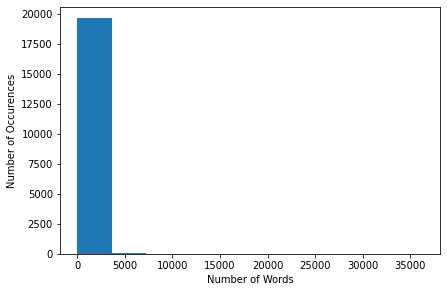

In [ ]:
words = re.findall('[A-Z|a-z]+', text)                                          # Getting vocab from text

print("Total number of words in Friends TV show")
print(len(words))
print("------------------------------------------")

dictionary = defaultdict(int)
for word in words:                                                              # count frequency of words
    dictionary[word] +=1

fig = plt.figure(figsize=(15,10))                                               # plotting words and their frequencies
fig.add_subplot(2,2,1)
sort = dict(sorted(dictionary.items(), key=lambda w:w[1], reverse=True))
x = sort.values()
plt.style.use('ggplot')
plt.hist(x,bins=10)
plt.xlabel("Number of Words")
plt.ylabel("Number of Occurences")
plt.show

freq = dict(sorted(dictionary.items(), key=lambda w:w[1], reverse=True)[60:70])
print("Frequently occuring words ignoring common words")
print(freq)
print("--------------------------------------------------")

# most of the words ranging 0 - 6000

#### **Getting conversation paris**
`getJoeyData` method reads all lines from scenes stored before and collects all the conversations in which Joey is involved. Stores the conversation paris in a dictionary which has utterance as key and response as value. This is later dumped into a JSON file.

In [ ]:
def getJoeyData(Joeyconvo, file):
    character = "Joey"
    responseDictionary = dict()
    with open("/Transcripts/scenes/" + file, "r") as fbFile:
        allLines = fbFile.readlines()
    characterMessage = ""
    reply = "" 
    Speaker = ""
    for index,lines in enumerate(allLines):
        Message = lines[0:]
        colon = Message.find(':')
        if (Message[:colon] == character):                                            # getting conversation of joey if he started first
            if not characterMessage:                                                  # loop - if he talked multiple times
                startMessageIndex = index - 1
            characterMessage += Message[colon + 2:]

        elif characterMessage:                                                        # getting replies to what joey talked
            for counter in range(startMessageIndex, 0, -1):
                currentLine = allLines[counter]
                Message = currentLine[0:]
                colon = Message.find(':')
                if not Speaker:
                    Speaker = Message[:colon]
                elif (Speaker != Message[:colon] and reply):
                    reply = reply
                    characterMessage = characterMessage
                    Joeyconvo[reply] = characterMessage
                    break
                reply = Message[colon + 2:] + reply
            characterMessage = ""
            reply = "" 
            Speaker = ""
    
    return Joeyconvo





# for every scene taking joey's conversation pairs
files = os.listdir("/Transcripts/scenes/")
count = 0
Joeyconvo = dict()
for file in files:
  count +=1
  dictionary = getJoeyData(Joeyconvo, file)
  Joeyconvo.update(dictionary)

# writing conversation pairs to file

with open('/Transcripts/joeyConversation.json', 'w') as fp:
    json.dump(Joeyconvo, fp)

`getConversationPairs` method reads all lines from scenes stored before and collects all the conversation paris. Stores the conversation paris in a dictionary which has utterance as key and response as value. This is later dumped into a JSON file. For Big Bang Transcripts it is done in similar way.

In [ ]:
# get conversations pairs for whole data

def getConversationPairs(conversations, file):
    
    
    with open("/Transcripts/scenes/" + file, "r") as fbFile:
        allLines = fbFile.readlines()
    character_1 = ""
    character_2 = "" 
    Speaker = ""
    index = 0
    #print(allLines)
    while index < len(allLines)-1:
        #print(index)
        Message = allLines[index][0:]
        colon = Message.find(':')
        name = Message[:colon]
        character_1 += Message[colon + 2:]
        nextLine = allLines[index+1]
        colon1 = nextLine.find(':')
        name1 = nextLine[:colon1]
        i = index
        cnt = 0
        if name == name1:
          while i < len(allLines)-1 and name == name1:
            character_1 = character_1.rstrip()
            character_1 += ' '
            character_1 += nextLine[colon1 + 2:]
            i += 1
            nextLine = allLines[i]
            colon1 = nextLine.find(':')
            name1 = nextLine[:colon1]

        else:

          character_2 += nextLine[colon1 + 2:]
          
          i+=1
          if i < len(allLines)-1:
            next_Line = allLines[i+1]
            colon2 = next_Line.find(':')
            name2 = next_Line[:colon2]
            if name1 == name2:
              
              while i < len(allLines)-1 and name1 == name2:
                cnt += 1
                #print(name1, name2)
                character_2 = character_2.rstrip()
                character_2 += ' '
                character_2 += next_Line[colon2 + 2:]
                #print(character_2)
                i += 1
                if i < len(allLines)-1:
                  next_Line = allLines[i+1]
                  colon2 = next_Line.find(':')
                  name2 = next_Line[:colon2]
            else:
              conversations[character_1] = character_2
        index = i - cnt 
        character_1 = ""
        character_2 = "" 
        Speaker = ""
    
    if len(allLines) > 2:
      character_1 = allLines[-2]
      character_2 = allLines[-1] 
    conversations[character_1] = character_2
    return conversations




# getting conversation pairs for each scene
files = os.listdir("/Transcripts/scenes/")
count = 0
conversations = dict()
for file in files:
  count +=1
  dictionary = getConversationPairs(conversations, file)
  conversations.update(dictionary)

# storing in file
with open('/Transcripts/allConversations.json', 'w') as fp:
    json.dump(conversations, fp)

I initially used the Cornell Movie-Dialogs Corpus, created by Ciristian Danescu-Niculescu-Mizil and Lillian Lee at Cornell University. I used this repository to get the Cornell Movie data - [Github](https://github.com/floydhub/textutil-preprocess-cornell-movie-corpus/blob/master/cornelldata.py) which I uploaded to the gitlab.

In order to run training on GPU, we need to apply `.cuda()` so that they can be moved to the `device`. And below are the initializations of variables which are used further.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MAX_LENGTH = 10
EOS = 2
attn_model = 'dot'
hidden_size = 500
embed_size = 500
dropout = 0.1
batch_size = 64
clip = 50.0
print_every = 1
save_every = 5000
iterations = 10000
n_layers = 3
learning_rate = 0.0001
loadFilename = None
model_name = 'my_model'
teacher_forcing_ratio = 1.0
decoder_learning_ratio = 5.0

## **Loading Data**

We will be representing each word in a sentence as a one-hot vector, or giant vector of zeros except for a single one (at the index of the word). Compared to the dozens of characters that might exist in a language, there are many many more words, so the encoding vector is much larger. 

![](https://drive.google.com/uc?export=view&id=1flLnFNQfHm8jTkQ5EMTA2MKIUDP19WPE)

Thus at first we should convert each word to a numeric value knwon as index. We’ll need a unique index per word to use as the inputs and targets of the model later. To keep track of all this we will use a helper class called `Vocabulary` which has `word2index` and `index2word` dictionaries, as well as a count of each word `word2count`. This class also has a function `addSentence` which adds all words in all the sentences and keeps track of words in the data.

In [4]:
class Vocabulary:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.num_words = 3

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            if word not in self.word2index:
                self.word2index[word] = self.num_words
                self.word2count[word] = 1
                self.index2word[self.num_words] = word
                self.num_words += 1
            else:
                self.word2count[word] += 1

##### **Prepare Data**

`PrepareData` method reads the conversation pairs json file we stored before and convert it into a two dimensional list. Those pairs which satisfy the `MAX_LENGTH` criteria are only added. This is useful for faster training convergence. Later each sentence in a pair is added to the vocabulary.

`input:` JSON file containing conversation pairs.

`output:` Vocabulary class object and two dimensional list of pairs

In [5]:
def PrepareData(datafile):
    with open(datafile) as f:
        data = json.load(f)
    li = list(data.items())
    pairs = [[li[i][j] for j in range(len(li[i]))] for i in range(len(li))]
    pairs = [pair for pair in pairs if len(pair[0].split(' ')) < MAX_LENGTH and len(pair[1].split(' ')) < MAX_LENGTH]
    vocab = Vocabulary()

    for pair in pairs:
        vocab.addSentence(pair[0])
        vocab.addSentence(pair[1])

    return vocab, pairs

#### **Preparing Training Data**

To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences. This can be done using all data at once i.e.; one single batch

But instead we want to use our GPU capabilities and hence we train our data in batches. While in batches we should make sure that all the inputs have same length, hence we pad zeros after EOS token for short sentences until its length is `MAX_LENGTH`. But when we do in batches, we get output for `inputVar` and `outputVar` functions as `(batch_size, max_length)` which is not as required. Because we will be getting same sequence across all time steps. Instead we need all sequences across one time step. Thus we transpose the padded matrix.



![](https://drive.google.com/uc?export=view&id=1JNVVq-WbbqOGCw_27s1ChdaSCgyejJxH)

In [6]:
def indexesFromSentence(vocab, sentence):
    return [vocab.word2index[word] for word in sentence.split(' ')] + [EOS]

def trainingBatches(vocab, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_pair, output_pair = [], []
    for pair in pair_batch:
        input_pair.append(pair[0])
        output_pair.append(pair[1])
    indexes_batch = [indexesFromSentence(vocab, sentence) for sentence in input_pair]
    inp_lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = list(itertools.zip_longest(*indexes_batch, fillvalue=0))  # generating fixed length input sentence
    inp_pad = torch.LongTensor(padList)
    indexes_batch = [indexesFromSentence(vocab, sentence) for sentence in output_pair]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = list(itertools.zip_longest(*indexes_batch, fillvalue=0)) # generating fixed length output sentence
    out_pad = torch.LongTensor(padList)
    mask = []
    for i, seq in enumerate(padList):
        mask.append([])
        for token in seq:
            if token == 0:
                mask[i].append(0)
            else:
                mask[i].append(1)
    mask = torch.BoolTensor(mask)
    
    return inp_pad, inp_lengths, out_pad, mask, max_target_len


# **Sequence to Sequence Model**

![](https://drive.google.com/uc?export=view&id=1UBAAa8otXwFZ9-6k9vlKIuH6pJW8vGsL)

A seq2seq model consists of two Recurrent Neural Networks (RNNs):

#### **Encoder**
A stack of several recurrent units (LSTM or GRU cells for better performance) where each accepts a single element of the input sequence, collects information for that element and propagates it forward. In our case, the input sequence is a collection of all words from the utterance. Each word is represented as x<sub>i</sub> where i is the order of that word. The hidden states h<sub>i</sub> are computed using the formula: 
h<sub>t</sub> = f(W<sup>hh</sup>h<sub>t-1</sub> + W<sup>hx</sup>x<sub>t</sub>)
Here, bidirectional GRU is used to encode both former and later info of a sentence. Both outputs are summed up at each time step.

#### **Encoder Vector**
This is the final hidden state produced from the encoder part of the model. This vector aims to encapsulate the information for all input elements in order to help the decoder make accurate predictions. It acts as the initial hidden state of the decoder part of the model.


In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=3, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout, bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        embedded = self.embedding(input_seq)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        outputs, hidden = self.gru(packed, hidden)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]

        return outputs, hidden

### **Attention Mechanism**
Prior to attention mechanism, seq2seq models can only deal with short sequences. This restriction arises because the “vanilla” seq2seq models can only fit a limited amount of information into the encoder vector and some informational content is loss in the process.

Attention mechanism was developed to solve this bottleneck. The core idea of attention is that at each time step during the decoding process, we will compare the decoder hidden state with all of the encoder hidden states. This comparison can be done using any function that takes two vectors and outputs a scalar that reflects their similarity. The simplest of such function is a simple dot product. The scalar output of the similarity function is called an “attention score”


![](https://drive.google.com/uc?export=view&id=1ZdXI3mkQuEeM4G-F_Y-zPJcKeEs28XEw)

Below Attn class will compare the decoder state with all of the encoder states by performing a dot product resulting attention scores, which is represented as blue circles in the figure above and then take the softmax of all these attention scores producing attention distribution. 

In [8]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        self.hidden_size = hidden_size

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def forward(self, hidden, encoder_outputs):
        attn_energies = self.dot_score(hidden, encoder_outputs)
        attn_energies = attn_energies.t()
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

#### **Attention Decoder**
Each recurrent unit accepts a hidden state from the previous unit and produces an output as well as its own hidden state.In our case, the output sequence is a collection of all words from the response. Each word is represented as y<sub>i</sub> where i is the order of that word. It continues generating words until it outputs an EOS_token. 

Below Attention decoder class initially generates hidden and outputs using GRU layers and then calls the attention class. Output of attention class is then multiplied with encoded_outputs, and then concatenated with decoder-outputs to get final output of that state. 

In [9]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=3, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        rnn_output, hidden = self.gru(embedded, last_hidden)
        attn_weights = self.attn(rnn_output, encoder_outputs)  # attention scores
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) 
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)  # attention output
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input)) 
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)

        return output, hidden

def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

### **Training Model**

`train` method is called in iterations passing batches of train data with batch_size of 64. To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the <SOS> token as its first input, and the last hidden state of the encoder as its first hidden state. Two techniques used to converge loss are teacher_forcing and gradient clipping. `Teacher forcing` is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input. Using teacher forcing causes it to converge faster but when the trained network is exploited, it may exhibit instability.

In [10]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):
    loss = 0
    print_losses = []
    n_totals = 0
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    lengths = lengths.to("cpu")

    encoder_outputs, encoder_hidden = encoder(input_variable, lengths) #encode sentence
    decoder_input = torch.LongTensor([[1 for _ in range(batch_size)]]) #prepare initial input for decoder
    decoder_input = decoder_input.to(device)
    decoder_hidden = encoder_hidden[:decoder.n_layers] #make encoder last hidden as decoder first hidden
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_input = target_variable[t].view(1, -1) # take target token
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            _, topi = decoder_output.topk(1) 
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]]) #take high predicted token
            decoder_input = decoder_input.to(device)
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    loss.backward()
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals



In [11]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, loadFilename):

    training_batches = [trainingBatches(voc, [random.choice(pairs) for _ in range(batch_size)]) for _ in range(n_iteration)] #get data in batches
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    for iteration in tqdm(range(start_iteration, n_iteration + 1)):
        training_batch = training_batches[iteration - 1]
        input_variable, lengths, target_variable, mask, max_target_len = training_batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print('%d %d%% %.4f' % (iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, '{}_{}'.format(n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

Due to small amount of utterances for each character that we train on, I first trained these bots on more general datasets. Training involved 3 phases, each involving a different set of data and a different number of training iterations, where each iteration consists of 64 batch examples.



**Phase 1:** Training on all datasets, the TV show transcripts and the Cornell Movie-Dialogs Corpus, for 10k iterations. This initial phase is meant for capturing basic dialog patterns between speakers and addressees. Here, all.json has the entire dataset

Each time the model is saved and loaded when needed


In [12]:
datafile = "/Transcripts/allConversations.json"
vocab, pairs = PrepareData(datafile)
save_dir = "Model"


embedding = nn.Embedding(vocab.num_words, hidden_size)
encoder = EncoderRNN(hidden_size, embedding, n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, vocab.num_words, n_layers, dropout)

encoder = encoder.to(device)
decoder = decoder.to(device)
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
encoder.train()
decoder.train()

for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

trainIters(model_name, vocab, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,embedding, n_layers, save_dir, iterations, batch_size,print_every,save_every, clip, loadFilename)


  0%|          | 1/10000 [00:00<56:13,  2.96it/s]

1 0% 11.2876


  0%|          | 3/10000 [00:00<44:09,  3.77it/s]

2 0% 11.2240
3 0% 11.1122


  0%|          | 5/10000 [00:01<38:01,  4.38it/s]

4 0% 10.9271
5 0% 10.5569


  0%|          | 7/10000 [00:01<35:14,  4.72it/s]

6 0% 10.0156
7 0% 9.4921


  0%|          | 9/10000 [00:01<33:38,  4.95it/s]

8 0% 9.2575
9 0% 9.1101


  0%|          | 11/10000 [00:02<32:14,  5.16it/s]

10 0% 9.4153
11 0% 9.3010


  0%|          | 13/10000 [00:02<32:16,  5.16it/s]

12 0% 9.4400
13 0% 9.3073


  0%|          | 15/10000 [00:03<32:19,  5.15it/s]

14 0% 8.6316
15 0% 8.7773


  0%|          | 17/10000 [00:03<32:19,  5.15it/s]

16 0% 8.3672
17 0% 8.1910


  0%|          | 19/10000 [00:03<32:04,  5.19it/s]

18 0% 7.9770
19 0% 7.9213


  0%|          | 21/10000 [00:04<31:59,  5.20it/s]

20 0% 7.4807
21 0% 7.7383


  0%|          | 23/10000 [00:04<31:55,  5.21it/s]

22 0% 7.5304
23 0% 7.5278


  0%|          | 25/10000 [00:04<31:58,  5.20it/s]

24 0% 7.6010
25 0% 7.2583


  0%|          | 27/10000 [00:05<31:49,  5.22it/s]

26 0% 7.1558
27 0% 7.4751


  0%|          | 29/10000 [00:05<31:51,  5.22it/s]

28 0% 7.3193
29 0% 7.4242


  0%|          | 31/10000 [00:06<31:59,  5.19it/s]

30 0% 7.1233
31 0% 7.2697


  0%|          | 33/10000 [00:06<31:58,  5.19it/s]

32 0% 7.2437
33 0% 7.5271


  0%|          | 35/10000 [00:06<32:03,  5.18it/s]

34 0% 6.8666
35 0% 7.2893


  0%|          | 37/10000 [00:07<32:10,  5.16it/s]

36 0% 7.3287
37 0% 7.3775


  0%|          | 39/10000 [00:07<32:03,  5.18it/s]

38 0% 7.2542
39 0% 7.2800


  0%|          | 41/10000 [00:08<32:03,  5.18it/s]

40 0% 7.4625
41 0% 7.2589


  0%|          | 43/10000 [00:08<32:09,  5.16it/s]

42 0% 7.1752
43 0% 6.9545


  0%|          | 45/10000 [00:08<31:54,  5.20it/s]

44 0% 7.4793
45 0% 7.1087


  0%|          | 47/10000 [00:09<31:51,  5.21it/s]

46 0% 7.3118
47 0% 7.1462


  0%|          | 49/10000 [00:09<31:52,  5.20it/s]

48 0% 7.1755
49 0% 7.2309


  1%|          | 51/10000 [00:09<32:00,  5.18it/s]

50 0% 7.0240
51 0% 7.0880


  1%|          | 53/10000 [00:10<31:38,  5.24it/s]

52 0% 6.9600
53 0% 7.1107


  1%|          | 55/10000 [00:10<31:48,  5.21it/s]

54 0% 7.2719
55 0% 7.1924


  1%|          | 57/10000 [00:11<32:06,  5.16it/s]

56 0% 7.2431
57 0% 7.1719


  1%|          | 59/10000 [00:11<31:41,  5.23it/s]

58 0% 7.1834
59 0% 7.0667


  1%|          | 61/10000 [00:11<31:42,  5.22it/s]

60 0% 7.1640
61 0% 7.2555


  1%|          | 63/10000 [00:12<31:46,  5.21it/s]

62 0% 7.3040
63 0% 7.0135


  1%|          | 65/10000 [00:12<31:45,  5.21it/s]

64 0% 7.0849
65 0% 7.1285


  1%|          | 67/10000 [00:13<31:47,  5.21it/s]

66 0% 7.2328
67 0% 7.3390


  1%|          | 69/10000 [00:13<31:47,  5.21it/s]

68 0% 7.1740
69 0% 7.0007


  1%|          | 71/10000 [00:13<31:49,  5.20it/s]

70 0% 7.2767
71 0% 7.1646


  1%|          | 73/10000 [00:14<31:48,  5.20it/s]

72 0% 7.2960
73 0% 7.0411


  1%|          | 75/10000 [00:14<31:50,  5.20it/s]

74 0% 7.0083
75 0% 6.8162


  1%|          | 77/10000 [00:14<31:50,  5.19it/s]

76 0% 7.0658
77 0% 7.1574


  1%|          | 79/10000 [00:15<31:45,  5.21it/s]

78 0% 7.3842
79 0% 7.2104


  1%|          | 81/10000 [00:15<31:49,  5.19it/s]

80 0% 7.6332
81 0% 6.9472


  1%|          | 83/10000 [00:16<31:50,  5.19it/s]

82 0% 7.0419
83 0% 7.2682


  1%|          | 85/10000 [00:16<31:54,  5.18it/s]

84 0% 7.0434
85 0% 7.2525


  1%|          | 87/10000 [00:16<31:54,  5.18it/s]

86 0% 7.2620
87 0% 7.1536


  1%|          | 89/10000 [00:17<31:57,  5.17it/s]

88 0% 7.3989
89 0% 6.9603


  1%|          | 91/10000 [00:17<31:57,  5.17it/s]

90 0% 7.0622
91 0% 7.0126


  1%|          | 93/10000 [00:18<32:08,  5.14it/s]

92 0% 7.4582
93 0% 6.9427


  1%|          | 95/10000 [00:18<32:00,  5.16it/s]

94 0% 7.0284
95 0% 6.9595


  1%|          | 97/10000 [00:18<31:53,  5.17it/s]

96 0% 6.9994
97 0% 7.2358


  1%|          | 99/10000 [00:19<31:48,  5.19it/s]

98 0% 7.1844
99 0% 6.9142


  1%|          | 101/10000 [00:19<31:52,  5.18it/s]

100 1% 7.1300
101 1% 6.9195


  1%|          | 103/10000 [00:19<31:55,  5.17it/s]

102 1% 7.2554
103 1% 7.2508


  1%|          | 105/10000 [00:20<31:54,  5.17it/s]

104 1% 7.0607
105 1% 7.1555


  1%|          | 107/10000 [00:20<31:52,  5.17it/s]

106 1% 6.7410
107 1% 7.3047


  1%|          | 109/10000 [00:21<32:02,  5.15it/s]

108 1% 7.0118
109 1% 7.2003


  1%|          | 111/10000 [00:21<32:03,  5.14it/s]

110 1% 7.1322
111 1% 7.1179


  1%|          | 113/10000 [00:21<32:10,  5.12it/s]

112 1% 6.8503
113 1% 6.9082


  1%|          | 115/10000 [00:22<32:02,  5.14it/s]

114 1% 6.9540
115 1% 7.1029


  1%|          | 117/10000 [00:22<32:08,  5.12it/s]

116 1% 7.2435
117 1% 6.8314


  1%|          | 119/10000 [00:23<32:08,  5.12it/s]

118 1% 6.8440
119 1% 6.8737


  1%|          | 121/10000 [00:23<31:59,  5.15it/s]

120 1% 7.1057
121 1% 6.8475


  1%|          | 123/10000 [00:23<31:59,  5.15it/s]

122 1% 6.9733
123 1% 7.1359


  1%|▏         | 125/10000 [00:24<31:56,  5.15it/s]

124 1% 6.8462
125 1% 6.6160


  1%|▏         | 127/10000 [00:24<31:57,  5.15it/s]

126 1% 6.8117
127 1% 7.1480


  1%|▏         | 129/10000 [00:25<31:56,  5.15it/s]

128 1% 7.0367
129 1% 7.1297


  1%|▏         | 131/10000 [00:25<31:56,  5.15it/s]

130 1% 6.9459
131 1% 6.8361


  1%|▏         | 133/10000 [00:25<32:00,  5.14it/s]

132 1% 7.3264
133 1% 7.0363


  1%|▏         | 135/10000 [00:26<31:55,  5.15it/s]

134 1% 6.5182
135 1% 6.5886


  1%|▏         | 137/10000 [00:26<31:55,  5.15it/s]

136 1% 6.8057
137 1% 6.8252


  1%|▏         | 139/10000 [00:26<31:57,  5.14it/s]

138 1% 7.1339
139 1% 7.3374


  1%|▏         | 141/10000 [00:27<32:01,  5.13it/s]

140 1% 6.7691
141 1% 6.9568


  1%|▏         | 143/10000 [00:27<31:56,  5.14it/s]

142 1% 6.7082
143 1% 7.0186


  1%|▏         | 145/10000 [00:28<32:10,  5.11it/s]

144 1% 6.8195
145 1% 6.9311


  1%|▏         | 147/10000 [00:28<32:14,  5.09it/s]

146 1% 6.8936
147 1% 6.9134


  1%|▏         | 149/10000 [00:28<32:03,  5.12it/s]

148 1% 6.7316
149 1% 7.0233


  2%|▏         | 151/10000 [00:29<32:09,  5.10it/s]

150 1% 6.6505
151 1% 6.9619


  2%|▏         | 153/10000 [00:29<32:02,  5.12it/s]

152 1% 7.0918
153 1% 7.0037


  2%|▏         | 155/10000 [00:30<32:02,  5.12it/s]

154 1% 6.8194
155 1% 6.6311


  2%|▏         | 157/10000 [00:30<32:01,  5.12it/s]

156 1% 6.8445
157 1% 6.8903


  2%|▏         | 159/10000 [00:30<32:09,  5.10it/s]

158 1% 6.8831
159 1% 6.7054


  2%|▏         | 161/10000 [00:31<32:01,  5.12it/s]

160 1% 6.7066
161 1% 6.6906


  2%|▏         | 163/10000 [00:31<32:01,  5.12it/s]

162 1% 6.9597
163 1% 6.9685


  2%|▏         | 165/10000 [00:32<32:04,  5.11it/s]

164 1% 6.8598
165 1% 6.9711


  2%|▏         | 167/10000 [00:32<32:10,  5.09it/s]

166 1% 7.0815
167 1% 6.9655


  2%|▏         | 169/10000 [00:32<32:13,  5.09it/s]

168 1% 6.6537
169 1% 7.1970


  2%|▏         | 171/10000 [00:33<32:06,  5.10it/s]

170 1% 6.7973
171 1% 6.8123


  2%|▏         | 173/10000 [00:33<32:03,  5.11it/s]

172 1% 7.1050
173 1% 6.7434


  2%|▏         | 175/10000 [00:34<32:03,  5.11it/s]

174 1% 6.4698
175 1% 6.6543


  2%|▏         | 177/10000 [00:34<32:07,  5.10it/s]

176 1% 6.6580
177 1% 6.6483


  2%|▏         | 179/10000 [00:34<32:11,  5.08it/s]

178 1% 6.8266
179 1% 6.7580


  2%|▏         | 181/10000 [00:35<32:18,  5.06it/s]

180 1% 6.6524
181 1% 6.5224


  2%|▏         | 183/10000 [00:35<32:15,  5.07it/s]

182 1% 6.7871
183 1% 7.2165


  2%|▏         | 185/10000 [00:36<32:20,  5.06it/s]

184 1% 6.9156
185 1% 6.3322


  2%|▏         | 187/10000 [00:36<31:58,  5.11it/s]

186 1% 6.6379
187 1% 6.8689


  2%|▏         | 189/10000 [00:36<32:01,  5.11it/s]

188 1% 6.5754
189 1% 6.7169


  2%|▏         | 191/10000 [00:37<32:10,  5.08it/s]

190 1% 6.6916
191 1% 6.8549


  2%|▏         | 193/10000 [00:37<32:05,  5.09it/s]

192 1% 6.6816
193 1% 6.5140


  2%|▏         | 195/10000 [00:37<32:05,  5.09it/s]

194 1% 6.5569
195 1% 7.0892


  2%|▏         | 197/10000 [00:38<32:00,  5.10it/s]

196 1% 6.9822
197 1% 6.7122


  2%|▏         | 199/10000 [00:38<31:59,  5.10it/s]

198 1% 6.8984
199 1% 6.6127


  2%|▏         | 201/10000 [00:39<32:08,  5.08it/s]

200 2% 6.6157
201 2% 6.3797


  2%|▏         | 203/10000 [00:39<32:02,  5.10it/s]

202 2% 6.8576
203 2% 6.5972


  2%|▏         | 205/10000 [00:39<32:01,  5.10it/s]

204 2% 6.8980
205 2% 6.9146


  2%|▏         | 207/10000 [00:40<32:12,  5.07it/s]

206 2% 6.8506
207 2% 6.9799


  2%|▏         | 209/10000 [00:40<32:10,  5.07it/s]

208 2% 6.9627
209 2% 6.5915


  2%|▏         | 211/10000 [00:41<32:07,  5.08it/s]

210 2% 6.5688
211 2% 7.1572


  2%|▏         | 213/10000 [00:41<32:03,  5.09it/s]

212 2% 6.5587
213 2% 6.5283


  2%|▏         | 214/10000 [00:41<31:59,  5.10it/s]

214 2% 6.8313
215 2% 6.7739


  2%|▏         | 216/10000 [00:42<31:57,  5.10it/s]

216 2% 6.7974


  2%|▏         | 218/10000 [00:42<31:28,  5.18it/s]

217 2% 6.2902
218 2% 7.0371


  2%|▏         | 220/10000 [00:42<31:43,  5.14it/s]

219 2% 6.5845
220 2% 6.7191


  2%|▏         | 222/10000 [00:43<31:57,  5.10it/s]

221 2% 6.5838
222 2% 6.7302


  2%|▏         | 224/10000 [00:43<32:00,  5.09it/s]

223 2% 6.6533
224 2% 6.4275


  2%|▏         | 225/10000 [00:43<32:01,  5.09it/s]

225 2% 7.0937
226 2% 6.9149

  2%|▏         | 227/10000 [00:44<32:00,  5.09it/s]


227 2% 7.0268


  2%|▏         | 229/10000 [00:44<31:56,  5.10it/s]

228 2% 6.6008
229 2% 6.8647


  2%|▏         | 231/10000 [00:45<32:05,  5.07it/s]

230 2% 6.5897
231 2% 6.7245


  2%|▏         | 233/10000 [00:45<32:01,  5.08it/s]

232 2% 6.7639
233 2% 6.6742


  2%|▏         | 235/10000 [00:45<31:47,  5.12it/s]

234 2% 6.6983
235 2% 6.4817


  2%|▏         | 237/10000 [00:46<31:55,  5.10it/s]

236 2% 5.8512
237 2% 6.5131


  2%|▏         | 239/10000 [00:46<31:57,  5.09it/s]

238 2% 6.3352
239 2% 6.4122


  2%|▏         | 241/10000 [00:46<31:49,  5.11it/s]

240 2% 6.7533
241 2% 6.2255


  2%|▏         | 243/10000 [00:47<31:45,  5.12it/s]

242 2% 6.6428
243 2% 6.4286


  2%|▏         | 245/10000 [00:47<31:44,  5.12it/s]

244 2% 6.5084
245 2% 6.6156


  2%|▏         | 247/10000 [00:48<31:42,  5.13it/s]

246 2% 6.7913
247 2% 6.6992


  2%|▏         | 249/10000 [00:48<31:36,  5.14it/s]

248 2% 6.4030
249 2% 6.6042


  3%|▎         | 251/10000 [00:48<31:44,  5.12it/s]

250 2% 6.5926
251 2% 6.5296


  3%|▎         | 253/10000 [00:49<31:45,  5.11it/s]

252 2% 6.9520
253 2% 6.8239


  3%|▎         | 255/10000 [00:49<31:45,  5.11it/s]

254 2% 6.9447
255 2% 6.7961


  3%|▎         | 257/10000 [00:50<31:52,  5.10it/s]

256 2% 6.5423
257 2% 6.7222


  3%|▎         | 259/10000 [00:50<31:56,  5.08it/s]

258 2% 6.6620
259 2% 6.4816


  3%|▎         | 261/10000 [00:50<31:52,  5.09it/s]

260 2% 6.3599
261 2% 6.5570


  3%|▎         | 263/10000 [00:51<31:46,  5.11it/s]

262 2% 6.3949
263 2% 6.6448


  3%|▎         | 265/10000 [00:51<31:42,  5.12it/s]

264 2% 6.7846
265 2% 6.5764


  3%|▎         | 267/10000 [00:52<31:34,  5.14it/s]

266 2% 6.6152
267 2% 6.6532


  3%|▎         | 269/10000 [00:52<31:29,  5.15it/s]

268 2% 6.8095
269 2% 6.6102


  3%|▎         | 271/10000 [00:52<31:35,  5.13it/s]

270 2% 6.8183
271 2% 6.7180


  3%|▎         | 273/10000 [00:53<31:43,  5.11it/s]

272 2% 6.3539
273 2% 6.4413


  3%|▎         | 275/10000 [00:53<31:39,  5.12it/s]

274 2% 6.6665
275 2% 6.7116


  3%|▎         | 277/10000 [00:54<31:31,  5.14it/s]

276 2% 6.7836
277 2% 6.4623


  3%|▎         | 279/10000 [00:54<31:30,  5.14it/s]

278 2% 6.6948
279 2% 6.8990


  3%|▎         | 281/10000 [00:54<31:25,  5.16it/s]

280 2% 6.4721
281 2% 6.4451


  3%|▎         | 283/10000 [00:55<31:28,  5.14it/s]

282 2% 6.3867
283 2% 6.8436


  3%|▎         | 285/10000 [00:55<31:21,  5.16it/s]

284 2% 6.5896
285 2% 6.6316


  3%|▎         | 287/10000 [00:55<31:24,  5.15it/s]

286 2% 6.7238
287 2% 6.5434


  3%|▎         | 289/10000 [00:56<31:22,  5.16it/s]

288 2% 6.4306
289 2% 6.4560


  3%|▎         | 291/10000 [00:56<31:19,  5.17it/s]

290 2% 6.4730
291 2% 6.6229


  3%|▎         | 293/10000 [00:57<31:27,  5.14it/s]

292 2% 6.6979
293 2% 6.4785


  3%|▎         | 295/10000 [00:57<31:37,  5.11it/s]

294 2% 6.7720
295 2% 6.4538


  3%|▎         | 297/10000 [00:57<31:29,  5.14it/s]

296 2% 6.4976
297 2% 6.7875


  3%|▎         | 299/10000 [00:58<31:20,  5.16it/s]

298 2% 6.5739
299 2% 6.6640


  3%|▎         | 301/10000 [00:58<30:48,  5.25it/s]

300 3% 6.8317
301 3% 6.1466


  3%|▎         | 303/10000 [00:59<30:55,  5.23it/s]

302 3% 6.6092
303 3% 6.4878


  3%|▎         | 305/10000 [00:59<31:05,  5.20it/s]

304 3% 6.4360
305 3% 6.5430


  3%|▎         | 307/10000 [00:59<31:16,  5.17it/s]

306 3% 6.9345
307 3% 6.2748


  3%|▎         | 309/10000 [01:00<31:11,  5.18it/s]

308 3% 6.6102
309 3% 6.4394


  3%|▎         | 311/10000 [01:00<31:12,  5.18it/s]

310 3% 6.9054
311 3% 6.5261


  3%|▎         | 313/10000 [01:00<31:25,  5.14it/s]

312 3% 6.4555
313 3% 6.4256


  3%|▎         | 315/10000 [01:01<31:25,  5.14it/s]

314 3% 6.6718
315 3% 6.8710


  3%|▎         | 317/10000 [01:01<31:25,  5.14it/s]

316 3% 6.6081
317 3% 6.6440


  3%|▎         | 319/10000 [01:02<31:18,  5.15it/s]

318 3% 7.2610
319 3% 6.5455


  3%|▎         | 321/10000 [01:02<31:12,  5.17it/s]

320 3% 6.5229
321 3% 6.7723


  3%|▎         | 323/10000 [01:02<31:11,  5.17it/s]

322 3% 6.4959
323 3% 6.8871


  3%|▎         | 325/10000 [01:03<31:19,  5.15it/s]

324 3% 6.4807
325 3% 6.4632


  3%|▎         | 327/10000 [01:03<31:13,  5.16it/s]

326 3% 6.5781
327 3% 6.4045


  3%|▎         | 329/10000 [01:04<31:11,  5.17it/s]

328 3% 6.4116
329 3% 6.6795


  3%|▎         | 331/10000 [01:04<31:11,  5.17it/s]

330 3% 6.5462
331 3% 6.3925


  3%|▎         | 333/10000 [01:04<31:22,  5.13it/s]

332 3% 6.5110
333 3% 6.7820


  3%|▎         | 335/10000 [01:05<31:12,  5.16it/s]

334 3% 6.5590
335 3% 6.7852


  3%|▎         | 337/10000 [01:05<31:17,  5.15it/s]

336 3% 6.3667
337 3% 6.8723


  3%|▎         | 339/10000 [01:06<31:11,  5.16it/s]

338 3% 6.6347
339 3% 6.8485


  3%|▎         | 341/10000 [01:06<31:18,  5.14it/s]

340 3% 6.6175
341 3% 6.6994


  3%|▎         | 343/10000 [01:06<31:07,  5.17it/s]

342 3% 6.5593
343 3% 6.2972


  3%|▎         | 345/10000 [01:07<31:04,  5.18it/s]

344 3% 6.5788
345 3% 6.5216


  3%|▎         | 347/10000 [01:07<31:10,  5.16it/s]

346 3% 6.3520
347 3% 6.4225


  3%|▎         | 349/10000 [01:07<31:09,  5.16it/s]

348 3% 6.6791
349 3% 6.3932


  4%|▎         | 351/10000 [01:08<31:13,  5.15it/s]

350 3% 6.4404
351 3% 6.4407


  4%|▎         | 353/10000 [01:08<31:01,  5.18it/s]

352 3% 6.2745
353 3% 6.3418


  4%|▎         | 355/10000 [01:09<31:06,  5.17it/s]

354 3% 6.3078
355 3% 6.4827


  4%|▎         | 357/10000 [01:09<31:06,  5.17it/s]

356 3% 6.6496
357 3% 6.6405


  4%|▎         | 359/10000 [01:09<31:05,  5.17it/s]

358 3% 6.8406
359 3% 6.5962


  4%|▎         | 361/10000 [01:10<31:05,  5.17it/s]

360 3% 6.7052
361 3% 6.6288


  4%|▎         | 363/10000 [01:10<31:06,  5.16it/s]

362 3% 6.4585
363 3% 6.7258


  4%|▎         | 365/10000 [01:11<31:04,  5.17it/s]

364 3% 6.6722
365 3% 6.4183


  4%|▎         | 367/10000 [01:11<30:59,  5.18it/s]

366 3% 6.6343
367 3% 6.4563


  4%|▎         | 369/10000 [01:11<31:00,  5.18it/s]

368 3% 6.4503
369 3% 6.3035


  4%|▎         | 371/10000 [01:12<31:04,  5.16it/s]

370 3% 6.4842
371 3% 6.8379


  4%|▎         | 373/10000 [01:12<31:03,  5.17it/s]

372 3% 6.3750
373 3% 6.3129


  4%|▍         | 375/10000 [01:13<31:03,  5.17it/s]

374 3% 6.4418
375 3% 6.1282


  4%|▍         | 377/10000 [01:13<31:05,  5.16it/s]

376 3% 6.4814
377 3% 6.5369


  4%|▍         | 379/10000 [01:13<31:02,  5.17it/s]

378 3% 6.6012
379 3% 6.3762


  4%|▍         | 381/10000 [01:14<30:58,  5.18it/s]

380 3% 6.5881
381 3% 6.4302


  4%|▍         | 383/10000 [01:14<30:55,  5.18it/s]

382 3% 6.6338
383 3% 6.2096


  4%|▍         | 385/10000 [01:14<30:55,  5.18it/s]

384 3% 6.3916
385 3% 6.5931


  4%|▍         | 387/10000 [01:15<30:51,  5.19it/s]

386 3% 6.4280
387 3% 6.4915


  4%|▍         | 389/10000 [01:15<30:58,  5.17it/s]

388 3% 6.7160
389 3% 6.5111


  4%|▍         | 391/10000 [01:16<30:57,  5.17it/s]

390 3% 6.4331
391 3% 6.1863


  4%|▍         | 393/10000 [01:16<30:49,  5.19it/s]

392 3% 6.2535
393 3% 6.7178


  4%|▍         | 395/10000 [01:16<30:49,  5.19it/s]

394 3% 6.4431
395 3% 6.3877


  4%|▍         | 397/10000 [01:17<30:56,  5.17it/s]

396 3% 6.3431
397 3% 6.3327


  4%|▍         | 399/10000 [01:17<30:55,  5.17it/s]

398 3% 6.3587
399 3% 6.0291


  4%|▍         | 401/10000 [01:18<30:53,  5.18it/s]

400 4% 6.6043
401 4% 6.3303


  4%|▍         | 403/10000 [01:18<30:55,  5.17it/s]

402 4% 6.7401
403 4% 6.3893


  4%|▍         | 405/10000 [01:18<30:56,  5.17it/s]

404 4% 6.5327
405 4% 6.4969


  4%|▍         | 407/10000 [01:19<31:01,  5.15it/s]

406 4% 6.4332
407 4% 6.6917


  4%|▍         | 409/10000 [01:19<30:34,  5.23it/s]

408 4% 6.3967
409 4% 6.0878


  4%|▍         | 411/10000 [01:19<30:42,  5.20it/s]

410 4% 6.3556
411 4% 6.5117


  4%|▍         | 413/10000 [01:20<30:42,  5.20it/s]

412 4% 6.3029
413 4% 6.3325


  4%|▍         | 415/10000 [01:20<30:46,  5.19it/s]

414 4% 6.3520
415 4% 6.6540


  4%|▍         | 417/10000 [01:21<30:55,  5.17it/s]

416 4% 6.2891
417 4% 6.3996


  4%|▍         | 419/10000 [01:21<30:50,  5.18it/s]

418 4% 6.3773
419 4% 5.9722


  4%|▍         | 421/10000 [01:21<30:51,  5.17it/s]

420 4% 6.0884
421 4% 6.3458


  4%|▍         | 423/10000 [01:22<30:54,  5.17it/s]

422 4% 6.4159
423 4% 6.2598


  4%|▍         | 425/10000 [01:22<30:52,  5.17it/s]

424 4% 6.5787
425 4% 6.0802


  4%|▍         | 427/10000 [01:23<30:50,  5.17it/s]

426 4% 6.2076
427 4% 6.7318


  4%|▍         | 429/10000 [01:23<30:51,  5.17it/s]

428 4% 6.1631
429 4% 6.5490


  4%|▍         | 431/10000 [01:23<30:51,  5.17it/s]

430 4% 6.1793
431 4% 6.4905


  4%|▍         | 433/10000 [01:24<30:49,  5.17it/s]

432 4% 6.5588
433 4% 6.2138


  4%|▍         | 435/10000 [01:24<30:52,  5.16it/s]

434 4% 6.5943
435 4% 6.3954


  4%|▍         | 437/10000 [01:24<30:53,  5.16it/s]

436 4% 6.2930
437 4% 6.3182


  4%|▍         | 439/10000 [01:25<30:50,  5.17it/s]

438 4% 6.5714
439 4% 6.3969


  4%|▍         | 441/10000 [01:25<30:11,  5.28it/s]

440 4% 6.2348
441 4% 6.2488


  4%|▍         | 443/10000 [01:26<30:28,  5.23it/s]

442 4% 6.0117
443 4% 6.5765


  4%|▍         | 445/10000 [01:26<30:39,  5.19it/s]

444 4% 5.8187
445 4% 6.3831


  4%|▍         | 447/10000 [01:26<30:47,  5.17it/s]

446 4% 6.4260
447 4% 6.0989


  4%|▍         | 449/10000 [01:27<30:52,  5.15it/s]

448 4% 5.8429
449 4% 6.4720


  5%|▍         | 451/10000 [01:27<30:48,  5.17it/s]

450 4% 6.2007
451 4% 6.6284


  5%|▍         | 453/10000 [01:28<30:55,  5.15it/s]

452 4% 6.3283
453 4% 6.4451


  5%|▍         | 455/10000 [01:28<30:47,  5.17it/s]

454 4% 6.5097
455 4% 6.4362


  5%|▍         | 457/10000 [01:28<30:46,  5.17it/s]

456 4% 6.5102
457 4% 6.3646


  5%|▍         | 459/10000 [01:29<30:46,  5.17it/s]

458 4% 6.4395
459 4% 6.4054


  5%|▍         | 461/10000 [01:29<30:47,  5.16it/s]

460 4% 6.4349
461 4% 6.1743


  5%|▍         | 463/10000 [01:30<30:52,  5.15it/s]

462 4% 6.3767
463 4% 6.5851


  5%|▍         | 465/10000 [01:30<30:45,  5.17it/s]

464 4% 6.1620
465 4% 6.3800


  5%|▍         | 467/10000 [01:30<30:46,  5.16it/s]

466 4% 6.2633
467 4% 6.6621


  5%|▍         | 469/10000 [01:31<30:43,  5.17it/s]

468 4% 6.1928
469 4% 6.1684


  5%|▍         | 471/10000 [01:31<30:44,  5.17it/s]

470 4% 6.1990
471 4% 6.3393


  5%|▍         | 473/10000 [01:31<30:49,  5.15it/s]

472 4% 6.2676
473 4% 6.2808


  5%|▍         | 475/10000 [01:32<30:48,  5.15it/s]

474 4% 6.0161
475 4% 5.8107


  5%|▍         | 477/10000 [01:32<30:55,  5.13it/s]

476 4% 6.0851
477 4% 6.2653


  5%|▍         | 479/10000 [01:33<30:50,  5.15it/s]

478 4% 6.1019
479 4% 6.6256


  5%|▍         | 481/10000 [01:33<30:48,  5.15it/s]

480 4% 6.1341
481 4% 6.3172


  5%|▍         | 483/10000 [01:33<30:49,  5.15it/s]

482 4% 6.2959
483 4% 6.3943


  5%|▍         | 485/10000 [01:34<30:43,  5.16it/s]

484 4% 6.3808
485 4% 6.4542


  5%|▍         | 487/10000 [01:34<30:46,  5.15it/s]

486 4% 6.3183
487 4% 6.2640


  5%|▍         | 489/10000 [01:35<30:39,  5.17it/s]

488 4% 6.1015
489 4% 6.3353


  5%|▍         | 491/10000 [01:35<30:39,  5.17it/s]

490 4% 6.3983
491 4% 6.3410


  5%|▍         | 493/10000 [01:35<30:45,  5.15it/s]

492 4% 6.1134
493 4% 6.5186


  5%|▍         | 495/10000 [01:36<30:47,  5.15it/s]

494 4% 6.3909
495 4% 6.1983


  5%|▍         | 497/10000 [01:36<30:43,  5.15it/s]

496 4% 6.3644
497 4% 6.0609


  5%|▍         | 499/10000 [01:36<30:49,  5.14it/s]

498 4% 5.7849
499 4% 6.2211


  5%|▌         | 501/10000 [01:37<30:51,  5.13it/s]

500 5% 6.2497
501 5% 6.4978


  5%|▌         | 503/10000 [01:37<30:44,  5.15it/s]

502 5% 6.1905
503 5% 6.3779


  5%|▌         | 505/10000 [01:38<30:45,  5.14it/s]

504 5% 6.0528
505 5% 6.1365


  5%|▌         | 507/10000 [01:38<30:40,  5.16it/s]

506 5% 6.0924
507 5% 6.3872


  5%|▌         | 509/10000 [01:38<30:39,  5.16it/s]

508 5% 6.0932
509 5% 6.2254


  5%|▌         | 511/10000 [01:39<30:39,  5.16it/s]

510 5% 6.3812
511 5% 6.1020


  5%|▌         | 513/10000 [01:39<30:39,  5.16it/s]

512 5% 5.9728
513 5% 5.9659


  5%|▌         | 515/10000 [01:40<30:44,  5.14it/s]

514 5% 5.9774
515 5% 6.6045


  5%|▌         | 517/10000 [01:40<30:50,  5.12it/s]

516 5% 6.4787
517 5% 6.1015


  5%|▌         | 519/10000 [01:40<30:45,  5.14it/s]

518 5% 6.3173
519 5% 6.5120


  5%|▌         | 521/10000 [01:41<30:45,  5.14it/s]

520 5% 6.2594
521 5% 6.4446


  5%|▌         | 523/10000 [01:41<30:47,  5.13it/s]

522 5% 5.9914
523 5% 6.3966


  5%|▌         | 525/10000 [01:42<30:42,  5.14it/s]

524 5% 6.1490
525 5% 6.3575


  5%|▌         | 527/10000 [01:42<30:41,  5.14it/s]

526 5% 6.0665
527 5% 6.4635


  5%|▌         | 529/10000 [01:42<30:45,  5.13it/s]

528 5% 6.4502
529 5% 6.0387


  5%|▌         | 531/10000 [01:43<30:51,  5.11it/s]

530 5% 6.0479
531 5% 6.3332


  5%|▌         | 533/10000 [01:43<30:50,  5.12it/s]

532 5% 6.1111
533 5% 6.3071


  5%|▌         | 535/10000 [01:43<30:43,  5.13it/s]

534 5% 6.3994
535 5% 6.2806


  5%|▌         | 537/10000 [01:44<30:46,  5.13it/s]

536 5% 6.3579
537 5% 6.3035


  5%|▌         | 539/10000 [01:44<30:47,  5.12it/s]

538 5% 5.7540
539 5% 6.0510


  5%|▌         | 541/10000 [01:45<30:44,  5.13it/s]

540 5% 6.2351
541 5% 6.1119


  5%|▌         | 543/10000 [01:45<30:42,  5.13it/s]

542 5% 6.2185
543 5% 6.6319


  5%|▌         | 545/10000 [01:45<30:39,  5.14it/s]

544 5% 6.6398
545 5% 6.1068


  5%|▌         | 547/10000 [01:46<30:38,  5.14it/s]

546 5% 6.3486
547 5% 6.2032


  5%|▌         | 549/10000 [01:46<30:38,  5.14it/s]

548 5% 5.8364
549 5% 6.3417


  6%|▌         | 551/10000 [01:47<30:43,  5.13it/s]

550 5% 6.5804
551 5% 6.2797


  6%|▌         | 553/10000 [01:47<30:41,  5.13it/s]

552 5% 6.0279
553 5% 6.2824


  6%|▌         | 555/10000 [01:47<30:40,  5.13it/s]

554 5% 6.3200
555 5% 6.3618


  6%|▌         | 557/10000 [01:48<30:38,  5.14it/s]

556 5% 6.3121
557 5% 6.3184


  6%|▌         | 559/10000 [01:48<30:12,  5.21it/s]

558 5% 6.0162
559 5% 6.4368


  6%|▌         | 561/10000 [01:49<30:25,  5.17it/s]

560 5% 6.4487
561 5% 5.9871


  6%|▌         | 563/10000 [01:49<30:28,  5.16it/s]

562 5% 6.4668
563 5% 6.1470


  6%|▌         | 565/10000 [01:49<30:34,  5.14it/s]

564 5% 6.2870
565 5% 6.2885


  6%|▌         | 567/10000 [01:50<30:29,  5.16it/s]

566 5% 6.5090
567 5% 6.1844


  6%|▌         | 569/10000 [01:50<30:41,  5.12it/s]

568 5% 6.4179
569 5% 6.2971


  6%|▌         | 571/10000 [01:50<30:40,  5.12it/s]

570 5% 6.0407
571 5% 5.8605


  6%|▌         | 573/10000 [01:51<30:38,  5.13it/s]

572 5% 6.1630
573 5% 6.1129


  6%|▌         | 575/10000 [01:51<30:36,  5.13it/s]

574 5% 6.1414
575 5% 6.2474


  6%|▌         | 577/10000 [01:52<30:35,  5.13it/s]

576 5% 6.2647
577 5% 6.1825


  6%|▌         | 579/10000 [01:52<30:36,  5.13it/s]

578 5% 5.7961
579 5% 6.3117


  6%|▌         | 581/10000 [01:52<30:35,  5.13it/s]

580 5% 6.1613
581 5% 6.5480


  6%|▌         | 583/10000 [01:53<30:37,  5.13it/s]

582 5% 6.4333
583 5% 6.0561


  6%|▌         | 585/10000 [01:53<30:33,  5.14it/s]

584 5% 5.9510
585 5% 6.2663


  6%|▌         | 587/10000 [01:54<30:30,  5.14it/s]

586 5% 5.9557
587 5% 6.2239


  6%|▌         | 589/10000 [01:54<30:27,  5.15it/s]

588 5% 6.3032
589 5% 6.0743


  6%|▌         | 591/10000 [01:54<30:33,  5.13it/s]

590 5% 6.4099
591 5% 6.1465


  6%|▌         | 593/10000 [01:55<30:47,  5.09it/s]

592 5% 6.2743
593 5% 6.3164


  6%|▌         | 595/10000 [01:55<30:39,  5.11it/s]

594 5% 6.2040
595 5% 5.7596


  6%|▌         | 597/10000 [01:56<30:35,  5.12it/s]

596 5% 5.9809
597 5% 6.2256


  6%|▌         | 599/10000 [01:56<30:33,  5.13it/s]

598 5% 6.0411
599 5% 5.9646


  6%|▌         | 601/10000 [01:56<30:37,  5.11it/s]

600 6% 6.1658
601 6% 6.3950


  6%|▌         | 603/10000 [01:57<30:35,  5.12it/s]

602 6% 5.7953
603 6% 6.2386


  6%|▌         | 605/10000 [01:57<30:30,  5.13it/s]

604 6% 6.0060
605 6% 6.1006


  6%|▌         | 607/10000 [01:58<30:27,  5.14it/s]

606 6% 5.8370
607 6% 6.1206


  6%|▌         | 609/10000 [01:58<30:27,  5.14it/s]

608 6% 6.2402
609 6% 6.2339


  6%|▌         | 611/10000 [01:58<30:28,  5.14it/s]

610 6% 6.0386
611 6% 6.3423


  6%|▌         | 613/10000 [01:59<30:28,  5.14it/s]

612 6% 6.1957
613 6% 5.8886


  6%|▌         | 615/10000 [01:59<30:31,  5.13it/s]

614 6% 5.8834
615 6% 6.1965


  6%|▌         | 617/10000 [01:59<30:25,  5.14it/s]

616 6% 6.1932
617 6% 6.1562


  6%|▌         | 619/10000 [02:00<30:25,  5.14it/s]

618 6% 6.5611
619 6% 6.1000


  6%|▌         | 621/10000 [02:00<30:26,  5.13it/s]

620 6% 6.1378
621 6% 6.1458


  6%|▌         | 623/10000 [02:01<30:25,  5.14it/s]

622 6% 6.1614
623 6% 6.0639


  6%|▋         | 625/10000 [02:01<30:24,  5.14it/s]

624 6% 6.0596
625 6% 5.8911


  6%|▋         | 627/10000 [02:01<30:24,  5.14it/s]

626 6% 5.9845
627 6% 6.2073


  6%|▋         | 629/10000 [02:02<30:24,  5.14it/s]

628 6% 6.3503
629 6% 6.1249


  6%|▋         | 631/10000 [02:02<30:32,  5.11it/s]

630 6% 6.1205
631 6% 6.1813


  6%|▋         | 633/10000 [02:03<29:55,  5.22it/s]

632 6% 6.2388
633 6% 6.0198


  6%|▋         | 635/10000 [02:03<30:14,  5.16it/s]

634 6% 6.0712
635 6% 6.1635


  6%|▋         | 637/10000 [02:03<30:14,  5.16it/s]

636 6% 5.8594
637 6% 5.9210


  6%|▋         | 639/10000 [02:04<30:26,  5.12it/s]

638 6% 5.8952
639 6% 6.2757


  6%|▋         | 641/10000 [02:04<30:22,  5.13it/s]

640 6% 6.1322
641 6% 5.8511


  6%|▋         | 643/10000 [02:05<30:22,  5.13it/s]

642 6% 5.7526
643 6% 5.9246


  6%|▋         | 645/10000 [02:05<30:27,  5.12it/s]

644 6% 5.9807
645 6% 5.9487


  6%|▋         | 647/10000 [02:05<30:25,  5.12it/s]

646 6% 5.9949
647 6% 6.2481


  6%|▋         | 649/10000 [02:06<30:25,  5.12it/s]

648 6% 6.2151
649 6% 6.1077


  7%|▋         | 651/10000 [02:06<30:23,  5.13it/s]

650 6% 6.1306
651 6% 6.0539


  7%|▋         | 653/10000 [02:06<30:22,  5.13it/s]

652 6% 6.3918
653 6% 5.7255


  7%|▋         | 655/10000 [02:07<30:16,  5.14it/s]

654 6% 6.2930
655 6% 6.0393


  7%|▋         | 657/10000 [02:07<30:14,  5.15it/s]

656 6% 5.9979
657 6% 5.9810


  7%|▋         | 659/10000 [02:08<30:16,  5.14it/s]

658 6% 6.2486
659 6% 6.2580


  7%|▋         | 661/10000 [02:08<30:17,  5.14it/s]

660 6% 5.8495
661 6% 6.4500


  7%|▋         | 663/10000 [02:08<29:50,  5.22it/s]

662 6% 6.1058
663 6% 5.9212


  7%|▋         | 665/10000 [02:09<29:58,  5.19it/s]

664 6% 6.1992
665 6% 6.0980


  7%|▋         | 667/10000 [02:09<30:07,  5.16it/s]

666 6% 6.2118
667 6% 6.2089


  7%|▋         | 669/10000 [02:10<30:07,  5.16it/s]

668 6% 6.0557
669 6% 6.0967


  7%|▋         | 671/10000 [02:10<29:47,  5.22it/s]

670 6% 6.4626
671 6% 5.9610


  7%|▋         | 673/10000 [02:10<29:55,  5.20it/s]

672 6% 6.0380
673 6% 6.1069


  7%|▋         | 675/10000 [02:11<30:10,  5.15it/s]

674 6% 6.1971
675 6% 5.8459


  7%|▋         | 677/10000 [02:11<30:11,  5.15it/s]

676 6% 5.8490
677 6% 6.4889


  7%|▋         | 679/10000 [02:12<30:11,  5.14it/s]

678 6% 5.9663
679 6% 6.3913


  7%|▋         | 681/10000 [02:12<30:07,  5.16it/s]

680 6% 5.8025
681 6% 5.8629


  7%|▋         | 683/10000 [02:12<30:12,  5.14it/s]

682 6% 5.9260
683 6% 5.8265


  7%|▋         | 685/10000 [02:13<30:13,  5.14it/s]

684 6% 6.2928
685 6% 6.1892


  7%|▋         | 687/10000 [02:13<30:08,  5.15it/s]

686 6% 5.8548
687 6% 6.1517


  7%|▋         | 689/10000 [02:13<30:08,  5.15it/s]

688 6% 6.4858
689 6% 6.3643


  7%|▋         | 691/10000 [02:14<30:10,  5.14it/s]

690 6% 6.3085
691 6% 6.2397


  7%|▋         | 693/10000 [02:14<30:03,  5.16it/s]

692 6% 5.9752
693 6% 6.0117


  7%|▋         | 695/10000 [02:15<30:06,  5.15it/s]

694 6% 5.9103
695 6% 5.8854


  7%|▋         | 697/10000 [02:15<30:09,  5.14it/s]

696 6% 6.0850
697 6% 6.4138


  7%|▋         | 699/10000 [02:15<30:08,  5.14it/s]

698 6% 6.1461
699 6% 6.0631


  7%|▋         | 701/10000 [02:16<30:23,  5.10it/s]

700 7% 6.4186
701 7% 5.9811


  7%|▋         | 703/10000 [02:16<30:23,  5.10it/s]

702 7% 6.0423
703 7% 5.8674


  7%|▋         | 705/10000 [02:17<30:16,  5.12it/s]

704 7% 6.3806
705 7% 6.2243


  7%|▋         | 707/10000 [02:17<30:20,  5.11it/s]

706 7% 6.0101
707 7% 6.3052


  7%|▋         | 709/10000 [02:17<30:21,  5.10it/s]

708 7% 6.1729
709 7% 6.0629


  7%|▋         | 711/10000 [02:18<30:14,  5.12it/s]

710 7% 5.8531
711 7% 5.8270


  7%|▋         | 713/10000 [02:18<30:13,  5.12it/s]

712 7% 5.8831
713 7% 6.0579


  7%|▋         | 715/10000 [02:19<30:05,  5.14it/s]

714 7% 6.3629
715 7% 5.9796


  7%|▋         | 717/10000 [02:19<30:07,  5.14it/s]

716 7% 6.0669
717 7% 6.0573


  7%|▋         | 719/10000 [02:19<30:01,  5.15it/s]

718 7% 6.2961
719 7% 6.2464


  7%|▋         | 721/10000 [02:20<29:57,  5.16it/s]

720 7% 5.7748
721 7% 5.9046


  7%|▋         | 723/10000 [02:20<30:01,  5.15it/s]

722 7% 5.9723
723 7% 6.0484


  7%|▋         | 725/10000 [02:20<30:04,  5.14it/s]

724 7% 5.8321
725 7% 5.8411


  7%|▋         | 727/10000 [02:21<30:10,  5.12it/s]

726 7% 6.1976
727 7% 6.1337


  7%|▋         | 729/10000 [02:21<30:06,  5.13it/s]

728 7% 5.9970
729 7% 6.0226


  7%|▋         | 731/10000 [02:22<30:02,  5.14it/s]

730 7% 5.6527
731 7% 5.9538


  7%|▋         | 733/10000 [02:22<30:03,  5.14it/s]

732 7% 6.0510
733 7% 6.1058


  7%|▋         | 735/10000 [02:22<30:03,  5.14it/s]

734 7% 5.9171
735 7% 5.8109


  7%|▋         | 737/10000 [02:23<30:02,  5.14it/s]

736 7% 6.1601
737 7% 5.7413


  7%|▋         | 739/10000 [02:23<30:02,  5.14it/s]

738 7% 5.8284
739 7% 5.9285


  7%|▋         | 741/10000 [02:24<29:59,  5.15it/s]

740 7% 5.9666
741 7% 6.0369


  7%|▋         | 743/10000 [02:24<29:56,  5.15it/s]

742 7% 6.0478
743 7% 6.2355


  7%|▋         | 745/10000 [02:24<29:59,  5.14it/s]

744 7% 6.4584
745 7% 6.0457


  7%|▋         | 747/10000 [02:25<30:06,  5.12it/s]

746 7% 6.1464
747 7% 6.3856


  7%|▋         | 749/10000 [02:25<30:10,  5.11it/s]

748 7% 6.3343
749 7% 5.5840


  8%|▊         | 751/10000 [02:26<30:03,  5.13it/s]

750 7% 5.8748
751 7% 6.1397


  8%|▊         | 753/10000 [02:26<30:13,  5.10it/s]

752 7% 6.2370
753 7% 6.1526


  8%|▊         | 755/10000 [02:26<30:03,  5.13it/s]

754 7% 6.1340
755 7% 6.0955


  8%|▊         | 757/10000 [02:27<29:55,  5.15it/s]

756 7% 6.0269
757 7% 6.0757


  8%|▊         | 759/10000 [02:27<29:54,  5.15it/s]

758 7% 5.8211
759 7% 5.8501


  8%|▊         | 761/10000 [02:27<30:00,  5.13it/s]

760 7% 6.0430
761 7% 6.1140


  8%|▊         | 763/10000 [02:28<30:03,  5.12it/s]

762 7% 5.5519
763 7% 6.1736


  8%|▊         | 765/10000 [02:28<30:00,  5.13it/s]

764 7% 5.7936
765 7% 5.8661


  8%|▊         | 767/10000 [02:29<30:01,  5.13it/s]

766 7% 6.0956
767 7% 6.0631


  8%|▊         | 769/10000 [02:29<30:00,  5.13it/s]

768 7% 5.6653
769 7% 5.9971


  8%|▊         | 771/10000 [02:29<29:55,  5.14it/s]

770 7% 5.8421
771 7% 6.0349


  8%|▊         | 773/10000 [02:30<29:54,  5.14it/s]

772 7% 5.9930
773 7% 6.1058


  8%|▊         | 775/10000 [02:30<29:54,  5.14it/s]

774 7% 5.6854
775 7% 6.1445


  8%|▊         | 777/10000 [02:31<29:50,  5.15it/s]

776 7% 6.0313
777 7% 6.2204


  8%|▊         | 779/10000 [02:31<29:50,  5.15it/s]

778 7% 5.7463
779 7% 5.6503


  8%|▊         | 781/10000 [02:31<29:22,  5.23it/s]

780 7% 6.4212
781 7% 6.0350


  8%|▊         | 783/10000 [02:32<29:45,  5.16it/s]

782 7% 6.1241
783 7% 6.1463


  8%|▊         | 785/10000 [02:32<29:54,  5.14it/s]

784 7% 6.0991
785 7% 6.3794


  8%|▊         | 787/10000 [02:33<29:59,  5.12it/s]

786 7% 6.0983
787 7% 6.0298


  8%|▊         | 789/10000 [02:33<30:06,  5.10it/s]

788 7% 5.7733
789 7% 5.9951


  8%|▊         | 791/10000 [02:33<29:55,  5.13it/s]

790 7% 6.0515
791 7% 5.7461


  8%|▊         | 793/10000 [02:34<29:54,  5.13it/s]

792 7% 6.1994
793 7% 6.3161


  8%|▊         | 795/10000 [02:34<29:57,  5.12it/s]

794 7% 6.1677
795 7% 6.0016


  8%|▊         | 797/10000 [02:34<29:55,  5.13it/s]

796 7% 5.9394
797 7% 5.9741


  8%|▊         | 799/10000 [02:35<30:02,  5.11it/s]

798 7% 6.3126
799 7% 5.9688


  8%|▊         | 801/10000 [02:35<29:50,  5.14it/s]

800 8% 6.1750
801 8% 5.6356


  8%|▊         | 803/10000 [02:36<29:56,  5.12it/s]

802 8% 5.6558
803 8% 5.9151


  8%|▊         | 805/10000 [02:36<30:06,  5.09it/s]

804 8% 5.8862
805 8% 5.9490


  8%|▊         | 807/10000 [02:36<30:06,  5.09it/s]

806 8% 5.9978
807 8% 5.8390


  8%|▊         | 809/10000 [02:37<29:50,  5.13it/s]

808 8% 6.0175
809 8% 6.2361


  8%|▊         | 811/10000 [02:37<29:42,  5.16it/s]

810 8% 6.0654
811 8% 6.0220


  8%|▊         | 813/10000 [02:38<29:44,  5.15it/s]

812 8% 5.7898
813 8% 5.6544


  8%|▊         | 815/10000 [02:38<29:39,  5.16it/s]

814 8% 6.4206
815 8% 5.6366


  8%|▊         | 817/10000 [02:38<29:43,  5.15it/s]

816 8% 5.5303
817 8% 6.2159


  8%|▊         | 819/10000 [02:39<29:48,  5.13it/s]

818 8% 5.7954
819 8% 6.0836


  8%|▊         | 821/10000 [02:39<29:42,  5.15it/s]

820 8% 5.9843
821 8% 6.4204


  8%|▊         | 823/10000 [02:40<29:44,  5.14it/s]

822 8% 6.0536
823 8% 6.2443


  8%|▊         | 825/10000 [02:40<29:54,  5.11it/s]

824 8% 6.0736
825 8% 6.1710


  8%|▊         | 827/10000 [02:40<29:43,  5.14it/s]

826 8% 5.9373
827 8% 6.5214


  8%|▊         | 829/10000 [02:41<29:47,  5.13it/s]

828 8% 6.1816
829 8% 5.8775


  8%|▊         | 831/10000 [02:41<29:46,  5.13it/s]

830 8% 6.1731
831 8% 5.9619


  8%|▊         | 833/10000 [02:42<29:53,  5.11it/s]

832 8% 5.9037
833 8% 5.8908


  8%|▊         | 835/10000 [02:42<29:53,  5.11it/s]

834 8% 6.2905
835 8% 5.5845


  8%|▊         | 837/10000 [02:42<29:50,  5.12it/s]

836 8% 6.1073
837 8% 5.8464


  8%|▊         | 839/10000 [02:43<29:46,  5.13it/s]

838 8% 6.1948
839 8% 6.1721


  8%|▊         | 841/10000 [02:43<29:07,  5.24it/s]

840 8% 6.2189
841 8% 5.6073


  8%|▊         | 843/10000 [02:43<29:20,  5.20it/s]

842 8% 5.9146
843 8% 5.8747


  8%|▊         | 845/10000 [02:44<29:22,  5.19it/s]

844 8% 5.9509
845 8% 5.7664


  8%|▊         | 847/10000 [02:44<29:39,  5.14it/s]

846 8% 6.1684
847 8% 5.7911


  8%|▊         | 849/10000 [02:45<29:11,  5.23it/s]

848 8% 5.7044
849 8% 5.8999


  9%|▊         | 851/10000 [02:45<29:29,  5.17it/s]

850 8% 5.7078
851 8% 6.3391


  9%|▊         | 853/10000 [02:45<29:33,  5.16it/s]

852 8% 6.1158
853 8% 6.0895


  9%|▊         | 855/10000 [02:46<29:31,  5.16it/s]

854 8% 5.6473
855 8% 6.0074


  9%|▊         | 857/10000 [02:46<29:39,  5.14it/s]

856 8% 6.3664
857 8% 6.1988


  9%|▊         | 859/10000 [02:47<29:45,  5.12it/s]

858 8% 6.2223
859 8% 5.9100


  9%|▊         | 861/10000 [02:47<29:50,  5.10it/s]

860 8% 6.1237
861 8% 6.1894


  9%|▊         | 863/10000 [02:47<29:39,  5.14it/s]

862 8% 5.8230
863 8% 6.2164


  9%|▊         | 865/10000 [02:48<29:39,  5.13it/s]

864 8% 5.9393
865 8% 5.9919


  9%|▊         | 867/10000 [02:48<29:39,  5.13it/s]

866 8% 5.8937
867 8% 6.1845


  9%|▊         | 869/10000 [02:48<29:34,  5.15it/s]

868 8% 6.1542
869 8% 6.3632


  9%|▊         | 871/10000 [02:49<29:30,  5.16it/s]

870 8% 5.5748
871 8% 6.2263


  9%|▊         | 873/10000 [02:49<29:30,  5.16it/s]

872 8% 5.8949
873 8% 5.7820


  9%|▉         | 875/10000 [02:50<29:29,  5.16it/s]

874 8% 6.0438
875 8% 6.6148


  9%|▉         | 877/10000 [02:50<29:31,  5.15it/s]

876 8% 6.1552
877 8% 5.9239


  9%|▉         | 879/10000 [02:50<29:25,  5.17it/s]

878 8% 6.0165
879 8% 6.1880


  9%|▉         | 881/10000 [02:51<29:23,  5.17it/s]

880 8% 5.9872
881 8% 5.8671


  9%|▉         | 883/10000 [02:51<29:26,  5.16it/s]

882 8% 5.9578
883 8% 6.0766


  9%|▉         | 885/10000 [02:52<29:26,  5.16it/s]

884 8% 5.9219
885 8% 6.2624


  9%|▉         | 887/10000 [02:52<29:27,  5.16it/s]

886 8% 6.2693
887 8% 6.0845


  9%|▉         | 889/10000 [02:52<28:53,  5.25it/s]

888 8% 6.2103
889 8% 5.7956


  9%|▉         | 891/10000 [02:53<29:08,  5.21it/s]

890 8% 5.8708
891 8% 5.8549


  9%|▉         | 893/10000 [02:53<29:16,  5.18it/s]

892 8% 5.8906
893 8% 6.0436


  9%|▉         | 895/10000 [02:54<29:24,  5.16it/s]

894 8% 6.0817
895 8% 5.9553


  9%|▉         | 897/10000 [02:54<29:29,  5.15it/s]

896 8% 5.8666
897 8% 5.5057


  9%|▉         | 899/10000 [02:54<29:26,  5.15it/s]

898 8% 6.1204
899 8% 5.8207


  9%|▉         | 901/10000 [02:55<29:24,  5.16it/s]

900 9% 5.8220
901 9% 6.0706


  9%|▉         | 903/10000 [02:55<29:24,  5.15it/s]

902 9% 6.0280
903 9% 6.0982


  9%|▉         | 905/10000 [02:55<29:29,  5.14it/s]

904 9% 5.9712
905 9% 5.9050


  9%|▉         | 907/10000 [02:56<29:22,  5.16it/s]

906 9% 5.6294
907 9% 5.3594


  9%|▉         | 909/10000 [02:56<29:25,  5.15it/s]

908 9% 6.1397
909 9% 5.8224


  9%|▉         | 911/10000 [02:57<29:24,  5.15it/s]

910 9% 6.0838
911 9% 5.7938


  9%|▉         | 913/10000 [02:57<29:23,  5.15it/s]

912 9% 5.8635
913 9% 6.3388


  9%|▉         | 915/10000 [02:57<29:25,  5.15it/s]

914 9% 5.7490
915 9% 5.8761


  9%|▉         | 917/10000 [02:58<29:31,  5.13it/s]

916 9% 5.9061
917 9% 6.1263


  9%|▉         | 919/10000 [02:58<29:32,  5.12it/s]

918 9% 5.6320
919 9% 6.0357


  9%|▉         | 921/10000 [02:59<29:32,  5.12it/s]

920 9% 5.7907
921 9% 6.5264


  9%|▉         | 923/10000 [02:59<29:32,  5.12it/s]

922 9% 6.0594
923 9% 6.4191


  9%|▉         | 925/10000 [02:59<29:27,  5.13it/s]

924 9% 5.7939
925 9% 5.7964


  9%|▉         | 927/10000 [03:00<29:24,  5.14it/s]

926 9% 6.2088
927 9% 6.0836


  9%|▉         | 929/10000 [03:00<28:54,  5.23it/s]

928 9% 6.3659
929 9% 5.6674


  9%|▉         | 931/10000 [03:01<29:11,  5.18it/s]

930 9% 5.8522
931 9% 6.2313


  9%|▉         | 933/10000 [03:01<29:21,  5.15it/s]

932 9% 6.0298
933 9% 5.7813


  9%|▉         | 935/10000 [03:01<29:17,  5.16it/s]

934 9% 5.8329
935 9% 5.8614


  9%|▉         | 937/10000 [03:02<29:17,  5.16it/s]

936 9% 5.9602
937 9% 5.9984


  9%|▉         | 939/10000 [03:02<29:21,  5.14it/s]

938 9% 5.7665
939 9% 5.7917


  9%|▉         | 941/10000 [03:02<29:16,  5.16it/s]

940 9% 5.6423
941 9% 5.9078


  9%|▉         | 943/10000 [03:03<29:16,  5.16it/s]

942 9% 6.0244
943 9% 6.1180


  9%|▉         | 945/10000 [03:03<29:24,  5.13it/s]

944 9% 6.1403
945 9% 6.0751


  9%|▉         | 947/10000 [03:04<29:14,  5.16it/s]

946 9% 6.0638
947 9% 5.9602


  9%|▉         | 949/10000 [03:04<29:13,  5.16it/s]

948 9% 5.8572
949 9% 5.8481


 10%|▉         | 951/10000 [03:04<29:28,  5.12it/s]

950 9% 5.6630
951 9% 5.8458


 10%|▉         | 953/10000 [03:05<29:19,  5.14it/s]

952 9% 5.6532
953 9% 6.0180


 10%|▉         | 955/10000 [03:05<29:15,  5.15it/s]

954 9% 5.8523
955 9% 5.6348


 10%|▉         | 957/10000 [03:06<29:16,  5.15it/s]

956 9% 5.7359
957 9% 5.8221


 10%|▉         | 959/10000 [03:06<29:18,  5.14it/s]

958 9% 5.8155
959 9% 5.9412


 10%|▉         | 961/10000 [03:06<29:15,  5.15it/s]

960 9% 5.7584
961 9% 6.0829


 10%|▉         | 963/10000 [03:07<29:15,  5.15it/s]

962 9% 5.7980
963 9% 5.7120


 10%|▉         | 965/10000 [03:07<29:16,  5.14it/s]

964 9% 6.0461
965 9% 6.0181


 10%|▉         | 967/10000 [03:08<29:22,  5.12it/s]

966 9% 5.7369
967 9% 5.4821


 10%|▉         | 969/10000 [03:08<29:10,  5.16it/s]

968 9% 6.0785
969 9% 5.7375


 10%|▉         | 971/10000 [03:08<29:19,  5.13it/s]

970 9% 5.9115
971 9% 5.7649


 10%|▉         | 973/10000 [03:09<29:18,  5.13it/s]

972 9% 5.7827
973 9% 5.5876


 10%|▉         | 975/10000 [03:09<29:19,  5.13it/s]

974 9% 5.8106
975 9% 6.2056


 10%|▉         | 977/10000 [03:09<29:17,  5.13it/s]

976 9% 5.9055
977 9% 6.0099


 10%|▉         | 979/10000 [03:10<29:10,  5.15it/s]

978 9% 6.0596
979 9% 5.5279


 10%|▉         | 981/10000 [03:10<29:15,  5.14it/s]

980 9% 5.7223
981 9% 5.9564


 10%|▉         | 983/10000 [03:11<29:12,  5.14it/s]

982 9% 6.0024
983 9% 6.1395


 10%|▉         | 985/10000 [03:11<29:20,  5.12it/s]

984 9% 5.7416
985 9% 5.6204


 10%|▉         | 987/10000 [03:11<29:10,  5.15it/s]

986 9% 5.9530
987 9% 6.4036


 10%|▉         | 989/10000 [03:12<29:13,  5.14it/s]

988 9% 6.1857
989 9% 5.4893


 10%|▉         | 991/10000 [03:12<29:16,  5.13it/s]

990 9% 5.8589
991 9% 6.0468


 10%|▉         | 993/10000 [03:13<28:53,  5.20it/s]

992 9% 5.6826
993 9% 5.8534


 10%|▉         | 995/10000 [03:13<29:08,  5.15it/s]

994 9% 5.5810
995 9% 5.8253


 10%|▉         | 997/10000 [03:13<29:06,  5.16it/s]

996 9% 5.9950
997 9% 5.9070


 10%|▉         | 999/10000 [03:14<29:16,  5.13it/s]

998 9% 5.9547
999 9% 6.0952


 10%|█         | 1001/10000 [03:14<29:24,  5.10it/s]

1000 10% 6.0573
1001 10% 5.9333


 10%|█         | 1003/10000 [03:15<29:12,  5.13it/s]

1002 10% 5.9224
1003 10% 5.6326


 10%|█         | 1005/10000 [03:15<29:02,  5.16it/s]

1004 10% 5.9720
1005 10% 5.6880


 10%|█         | 1007/10000 [03:15<29:03,  5.16it/s]

1006 10% 5.7653
1007 10% 5.6397


 10%|█         | 1009/10000 [03:16<29:10,  5.14it/s]

1008 10% 6.1206
1009 10% 5.7937


 10%|█         | 1011/10000 [03:16<29:15,  5.12it/s]

1010 10% 5.6851
1011 10% 5.8968


 10%|█         | 1013/10000 [03:16<29:07,  5.14it/s]

1012 10% 5.7394
1013 10% 6.0756


 10%|█         | 1015/10000 [03:17<29:13,  5.12it/s]

1014 10% 6.1431
1015 10% 6.0153


 10%|█         | 1017/10000 [03:17<29:04,  5.15it/s]

1016 10% 5.6357
1017 10% 5.6943


 10%|█         | 1019/10000 [03:18<29:03,  5.15it/s]

1018 10% 5.4829
1019 10% 5.8256


 10%|█         | 1021/10000 [03:18<29:03,  5.15it/s]

1020 10% 5.5399
1021 10% 5.6721


 10%|█         | 1023/10000 [03:18<29:04,  5.14it/s]

1022 10% 5.6707
1023 10% 6.1476


 10%|█         | 1025/10000 [03:19<29:09,  5.13it/s]

1024 10% 5.7191
1025 10% 5.7544


 10%|█         | 1027/10000 [03:19<29:03,  5.15it/s]

1026 10% 5.8472
1027 10% 5.8724


 10%|█         | 1029/10000 [03:20<29:06,  5.14it/s]

1028 10% 6.2042
1029 10% 5.5424


 10%|█         | 1031/10000 [03:20<29:02,  5.15it/s]

1030 10% 5.3868
1031 10% 6.0728


 10%|█         | 1033/10000 [03:20<28:57,  5.16it/s]

1032 10% 6.0971
1033 10% 6.3036


 10%|█         | 1035/10000 [03:21<29:03,  5.14it/s]

1034 10% 5.6608
1035 10% 5.9858


 10%|█         | 1037/10000 [03:21<29:05,  5.14it/s]

1036 10% 5.7716
1037 10% 5.6278


 10%|█         | 1039/10000 [03:22<29:05,  5.13it/s]

1038 10% 5.9437
1039 10% 5.6118


 10%|█         | 1041/10000 [03:22<28:59,  5.15it/s]

1040 10% 5.8976
1041 10% 5.9220


 10%|█         | 1043/10000 [03:22<29:05,  5.13it/s]

1042 10% 5.8790
1043 10% 5.8405


 10%|█         | 1045/10000 [03:23<29:14,  5.10it/s]

1044 10% 5.4186
1045 10% 5.6706


 10%|█         | 1047/10000 [03:23<29:02,  5.14it/s]

1046 10% 5.9384
1047 10% 6.1574


 10%|█         | 1049/10000 [03:23<29:15,  5.10it/s]

1048 10% 5.7798
1049 10% 5.9371


 11%|█         | 1051/10000 [03:24<29:08,  5.12it/s]

1050 10% 6.0777
1051 10% 6.0207


 11%|█         | 1053/10000 [03:24<29:03,  5.13it/s]

1052 10% 5.5422
1053 10% 5.5611


 11%|█         | 1055/10000 [03:25<29:07,  5.12it/s]

1054 10% 5.6321
1055 10% 5.8693


 11%|█         | 1057/10000 [03:25<29:06,  5.12it/s]

1056 10% 5.8943
1057 10% 5.6691


 11%|█         | 1059/10000 [03:25<28:59,  5.14it/s]

1058 10% 5.7975
1059 10% 6.0889


 11%|█         | 1061/10000 [03:26<29:00,  5.14it/s]

1060 10% 5.5727
1061 10% 5.6992


 11%|█         | 1063/10000 [03:26<28:52,  5.16it/s]

1062 10% 5.7479
1063 10% 5.8644


 11%|█         | 1065/10000 [03:27<28:53,  5.15it/s]

1064 10% 5.7858
1065 10% 5.6805


 11%|█         | 1067/10000 [03:27<28:58,  5.14it/s]

1066 10% 5.9438
1067 10% 5.8064


 11%|█         | 1069/10000 [03:27<29:00,  5.13it/s]

1068 10% 6.0693
1069 10% 6.1824


 11%|█         | 1071/10000 [03:28<29:11,  5.10it/s]

1070 10% 5.7002
1071 10% 5.8911


 11%|█         | 1073/10000 [03:28<29:00,  5.13it/s]

1072 10% 6.0157
1073 10% 5.8670


 11%|█         | 1075/10000 [03:29<29:05,  5.11it/s]

1074 10% 5.6271
1075 10% 5.5176


 11%|█         | 1077/10000 [03:29<28:54,  5.14it/s]

1076 10% 5.7884
1077 10% 5.7326


 11%|█         | 1079/10000 [03:29<28:54,  5.14it/s]

1078 10% 6.2528
1079 10% 5.8819


 11%|█         | 1081/10000 [03:30<28:57,  5.13it/s]

1080 10% 5.9503
1081 10% 6.0402


 11%|█         | 1083/10000 [03:30<28:50,  5.15it/s]

1082 10% 5.5510
1083 10% 5.7248


 11%|█         | 1085/10000 [03:30<28:53,  5.14it/s]

1084 10% 5.6166
1085 10% 6.0838


 11%|█         | 1087/10000 [03:31<28:54,  5.14it/s]

1086 10% 5.7319
1087 10% 5.9380


 11%|█         | 1089/10000 [03:31<28:59,  5.12it/s]

1088 10% 5.7907
1089 10% 5.7486


 11%|█         | 1091/10000 [03:32<28:49,  5.15it/s]

1090 10% 5.8846
1091 10% 5.9053


 11%|█         | 1093/10000 [03:32<28:48,  5.15it/s]

1092 10% 6.0079
1093 10% 5.5913


 11%|█         | 1095/10000 [03:32<28:48,  5.15it/s]

1094 10% 5.7969
1095 10% 5.7064


 11%|█         | 1097/10000 [03:33<28:49,  5.15it/s]

1096 10% 6.0638
1097 10% 6.1258


 11%|█         | 1099/10000 [03:33<28:52,  5.14it/s]

1098 10% 5.5771
1099 10% 5.6615


 11%|█         | 1101/10000 [03:34<28:58,  5.12it/s]

1100 11% 5.7408
1101 11% 5.9606


 11%|█         | 1103/10000 [03:34<28:46,  5.15it/s]

1102 11% 5.7571
1103 11% 5.6190


 11%|█         | 1105/10000 [03:34<28:44,  5.16it/s]

1104 11% 6.0502
1105 11% 5.7141


 11%|█         | 1107/10000 [03:35<28:58,  5.11it/s]

1106 11% 5.5714
1107 11% 5.6767


 11%|█         | 1109/10000 [03:35<28:59,  5.11it/s]

1108 11% 5.9974
1109 11% 5.8056


 11%|█         | 1111/10000 [03:36<29:03,  5.10it/s]

1110 11% 5.9663
1111 11% 5.6679


 11%|█         | 1113/10000 [03:36<28:51,  5.13it/s]

1112 11% 6.1757
1113 11% 5.7440


 11%|█         | 1115/10000 [03:36<28:46,  5.15it/s]

1114 11% 5.6162
1115 11% 6.1098


 11%|█         | 1117/10000 [03:37<28:47,  5.14it/s]

1116 11% 5.8333
1117 11% 5.4004


 11%|█         | 1119/10000 [03:37<28:46,  5.14it/s]

1118 11% 5.9522
1119 11% 5.7599


 11%|█         | 1121/10000 [03:37<28:52,  5.12it/s]

1120 11% 5.7837
1121 11% 6.1166


 11%|█         | 1123/10000 [03:38<28:48,  5.13it/s]

1122 11% 5.6457
1123 11% 5.7516


 11%|█▏        | 1125/10000 [03:38<28:51,  5.13it/s]

1124 11% 5.7806
1125 11% 6.0765


 11%|█▏        | 1127/10000 [03:39<28:48,  5.13it/s]

1126 11% 5.8183
1127 11% 5.7410


 11%|█▏        | 1129/10000 [03:39<28:44,  5.14it/s]

1128 11% 5.6743
1129 11% 6.0554


 11%|█▏        | 1131/10000 [03:39<28:39,  5.16it/s]

1130 11% 5.7381
1131 11% 5.7812


 11%|█▏        | 1133/10000 [03:40<28:48,  5.13it/s]

1132 11% 5.7337
1133 11% 5.9694


 11%|█▏        | 1135/10000 [03:40<28:42,  5.15it/s]

1134 11% 5.6914
1135 11% 6.0046


 11%|█▏        | 1137/10000 [03:41<28:45,  5.14it/s]

1136 11% 5.9358
1137 11% 5.9677


 11%|█▏        | 1139/10000 [03:41<28:57,  5.10it/s]

1138 11% 5.7739
1139 11% 5.6611


 11%|█▏        | 1141/10000 [03:41<29:03,  5.08it/s]

1140 11% 6.0326
1141 11% 6.1397


 11%|█▏        | 1143/10000 [03:42<28:48,  5.13it/s]

1142 11% 5.9734
1143 11% 6.2980


 11%|█▏        | 1145/10000 [03:42<28:45,  5.13it/s]

1144 11% 5.9471
1145 11% 5.8511


 11%|█▏        | 1147/10000 [03:43<28:44,  5.13it/s]

1146 11% 5.9140
1147 11% 5.6342


 11%|█▏        | 1149/10000 [03:43<28:42,  5.14it/s]

1148 11% 5.5938
1149 11% 6.0818


 12%|█▏        | 1151/10000 [03:43<28:44,  5.13it/s]

1150 11% 6.0457
1151 11% 5.6622


 12%|█▏        | 1153/10000 [03:44<28:44,  5.13it/s]

1152 11% 5.8754
1153 11% 6.0518


 12%|█▏        | 1155/10000 [03:44<28:39,  5.14it/s]

1154 11% 5.9006
1155 11% 5.9565


 12%|█▏        | 1157/10000 [03:44<28:38,  5.15it/s]

1156 11% 5.7948
1157 11% 5.7761


 12%|█▏        | 1159/10000 [03:45<28:36,  5.15it/s]

1158 11% 5.6749
1159 11% 5.5869


 12%|█▏        | 1161/10000 [03:45<28:39,  5.14it/s]

1160 11% 5.7694
1161 11% 5.5012


 12%|█▏        | 1163/10000 [03:46<28:42,  5.13it/s]

1162 11% 5.7607
1163 11% 5.6792


 12%|█▏        | 1165/10000 [03:46<28:35,  5.15it/s]

1164 11% 5.8753
1165 11% 5.7761


 12%|█▏        | 1167/10000 [03:46<28:42,  5.13it/s]

1166 11% 5.7568
1167 11% 6.2091


 12%|█▏        | 1169/10000 [03:47<28:36,  5.14it/s]

1168 11% 5.6342
1169 11% 5.8049


 12%|█▏        | 1171/10000 [03:47<28:38,  5.14it/s]

1170 11% 5.7653
1171 11% 5.8994


 12%|█▏        | 1173/10000 [03:48<28:39,  5.13it/s]

1172 11% 5.7206
1173 11% 5.6590


 12%|█▏        | 1175/10000 [03:48<28:31,  5.15it/s]

1174 11% 5.9244
1175 11% 5.6960


 12%|█▏        | 1177/10000 [03:48<28:38,  5.13it/s]

1176 11% 5.4096
1177 11% 5.7872


 12%|█▏        | 1179/10000 [03:49<28:39,  5.13it/s]

1178 11% 5.9138
1179 11% 6.1047


 12%|█▏        | 1181/10000 [03:49<28:34,  5.14it/s]

1180 11% 5.6307
1181 11% 5.8246


 12%|█▏        | 1183/10000 [03:50<28:40,  5.12it/s]

1182 11% 5.7740
1183 11% 5.3766


 12%|█▏        | 1185/10000 [03:50<28:35,  5.14it/s]

1184 11% 5.5829
1185 11% 5.7419


 12%|█▏        | 1187/10000 [03:50<28:45,  5.11it/s]

1186 11% 5.8838
1187 11% 5.9440


 12%|█▏        | 1189/10000 [03:51<28:37,  5.13it/s]

1188 11% 5.8809
1189 11% 5.5714


 12%|█▏        | 1191/10000 [03:51<28:38,  5.13it/s]

1190 11% 5.8304
1191 11% 5.8995


 12%|█▏        | 1193/10000 [03:51<28:38,  5.13it/s]

1192 11% 5.4677
1193 11% 5.7764


 12%|█▏        | 1195/10000 [03:52<28:41,  5.12it/s]

1194 11% 5.7333
1195 11% 5.6647


 12%|█▏        | 1197/10000 [03:52<28:35,  5.13it/s]

1196 11% 6.0252
1197 11% 6.1334


 12%|█▏        | 1199/10000 [03:53<28:35,  5.13it/s]

1198 11% 5.6315
1199 11% 5.8389


 12%|█▏        | 1201/10000 [03:53<28:30,  5.14it/s]

1200 12% 6.0064
1201 12% 5.5754


 12%|█▏        | 1203/10000 [03:53<28:31,  5.14it/s]

1202 12% 6.0882
1203 12% 5.8132


 12%|█▏        | 1205/10000 [03:54<28:33,  5.13it/s]

1204 12% 5.4318
1205 12% 5.9296


 12%|█▏        | 1207/10000 [03:54<28:33,  5.13it/s]

1206 12% 5.9107
1207 12% 5.9235


 12%|█▏        | 1209/10000 [03:55<28:32,  5.13it/s]

1208 12% 5.5084
1209 12% 5.9357


 12%|█▏        | 1211/10000 [03:55<28:39,  5.11it/s]

1210 12% 5.6072
1211 12% 5.5940


 12%|█▏        | 1213/10000 [03:55<28:31,  5.13it/s]

1212 12% 5.9201
1213 12% 5.9806


 12%|█▏        | 1215/10000 [03:56<28:35,  5.12it/s]

1214 12% 5.7764
1215 12% 5.7977


 12%|█▏        | 1217/10000 [03:56<28:34,  5.12it/s]

1216 12% 5.7612
1217 12% 5.7549


 12%|█▏        | 1219/10000 [03:57<28:30,  5.13it/s]

1218 12% 5.9470
1219 12% 6.1048


 12%|█▏        | 1221/10000 [03:57<28:27,  5.14it/s]

1220 12% 6.1215
1221 12% 5.7201


 12%|█▏        | 1223/10000 [03:57<28:40,  5.10it/s]

1222 12% 5.4831
1223 12% 5.6690


 12%|█▏        | 1225/10000 [03:58<28:33,  5.12it/s]

1224 12% 5.5646
1225 12% 5.6282


 12%|█▏        | 1227/10000 [03:58<28:28,  5.13it/s]

1226 12% 6.0478
1227 12% 6.2245


 12%|█▏        | 1229/10000 [03:59<28:37,  5.11it/s]

1228 12% 5.4763
1229 12% 5.6603


 12%|█▏        | 1231/10000 [03:59<28:43,  5.09it/s]

1230 12% 5.7019
1231 12% 5.5005


 12%|█▏        | 1233/10000 [03:59<28:27,  5.14it/s]

1232 12% 5.7684
1233 12% 5.8122


 12%|█▏        | 1235/10000 [04:00<28:25,  5.14it/s]

1234 12% 5.5458
1235 12% 5.7285


 12%|█▏        | 1237/10000 [04:00<28:21,  5.15it/s]

1236 12% 5.5685
1237 12% 5.7026


 12%|█▏        | 1239/10000 [04:00<28:25,  5.14it/s]

1238 12% 5.8090
1239 12% 5.6821


 12%|█▏        | 1241/10000 [04:01<28:21,  5.15it/s]

1240 12% 6.1139
1241 12% 5.5373


 12%|█▏        | 1243/10000 [04:01<28:27,  5.13it/s]

1242 12% 5.8521
1243 12% 5.8281


 12%|█▏        | 1245/10000 [04:02<28:28,  5.12it/s]

1244 12% 5.7501
1245 12% 5.8104


 12%|█▏        | 1247/10000 [04:02<28:30,  5.12it/s]

1246 12% 5.5764
1247 12% 5.8013


 12%|█▏        | 1249/10000 [04:02<28:31,  5.11it/s]

1248 12% 6.0809
1249 12% 5.8411


 13%|█▎        | 1251/10000 [04:03<28:35,  5.10it/s]

1250 12% 6.3192
1251 12% 5.7434


 13%|█▎        | 1253/10000 [04:03<28:32,  5.11it/s]

1252 12% 5.6230
1253 12% 6.0651


 13%|█▎        | 1255/10000 [04:04<28:23,  5.13it/s]

1254 12% 5.7797
1255 12% 5.9333


 13%|█▎        | 1257/10000 [04:04<28:23,  5.13it/s]

1256 12% 5.7421
1257 12% 5.8599


 13%|█▎        | 1259/10000 [04:04<28:16,  5.15it/s]

1258 12% 5.2924
1259 12% 5.8731


 13%|█▎        | 1261/10000 [04:05<28:18,  5.14it/s]

1260 12% 5.6238
1261 12% 5.7554


 13%|█▎        | 1263/10000 [04:05<28:21,  5.14it/s]

1262 12% 5.9654
1263 12% 5.7107


 13%|█▎        | 1265/10000 [04:06<28:20,  5.14it/s]

1264 12% 5.1710
1265 12% 5.7906


 13%|█▎        | 1267/10000 [04:06<28:30,  5.11it/s]

1266 12% 5.8246
1267 12% 5.9929


 13%|█▎        | 1269/10000 [04:06<28:24,  5.12it/s]

1268 12% 5.5025
1269 12% 5.4509


 13%|█▎        | 1271/10000 [04:07<28:29,  5.11it/s]

1270 12% 5.5313
1271 12% 5.5775


 13%|█▎        | 1273/10000 [04:07<28:33,  5.09it/s]

1272 12% 5.4093
1273 12% 5.9432


 13%|█▎        | 1275/10000 [04:07<28:29,  5.10it/s]

1274 12% 6.0997
1275 12% 6.1528


 13%|█▎        | 1277/10000 [04:08<28:25,  5.12it/s]

1276 12% 5.6152
1277 12% 5.5193


 13%|█▎        | 1279/10000 [04:08<28:24,  5.12it/s]

1278 12% 5.4355
1279 12% 5.6635


 13%|█▎        | 1281/10000 [04:09<28:20,  5.13it/s]

1280 12% 5.4924
1281 12% 5.8120


 13%|█▎        | 1283/10000 [04:09<28:18,  5.13it/s]

1282 12% 5.5939
1283 12% 5.8761


 13%|█▎        | 1285/10000 [04:09<28:16,  5.14it/s]

1284 12% 5.5804
1285 12% 5.5814


 13%|█▎        | 1287/10000 [04:10<28:12,  5.15it/s]

1286 12% 5.3892
1287 12% 5.7016


 13%|█▎        | 1289/10000 [04:10<28:15,  5.14it/s]

1288 12% 5.7685
1289 12% 5.6908


 13%|█▎        | 1291/10000 [04:11<28:17,  5.13it/s]

1290 12% 5.5281
1291 12% 5.6705


 13%|█▎        | 1293/10000 [04:11<28:12,  5.15it/s]

1292 12% 5.6551
1293 12% 5.6485


 13%|█▎        | 1295/10000 [04:11<28:19,  5.12it/s]

1294 12% 5.7167
1295 12% 5.5513


 13%|█▎        | 1297/10000 [04:12<28:20,  5.12it/s]

1296 12% 5.9461
1297 12% 5.4640


 13%|█▎        | 1299/10000 [04:12<28:16,  5.13it/s]

1298 12% 5.5578
1299 12% 5.5037


 13%|█▎        | 1300/10000 [04:12<28:11,  5.14it/s]

1300 13% 5.8728
1301 13% 5.5933


 13%|█▎        | 1303/10000 [04:13<28:15,  5.13it/s]

1302 13% 5.8139
1303 13% 5.8569


 13%|█▎        | 1305/10000 [04:13<28:24,  5.10it/s]

1304 13% 5.5507
1305 13% 5.9452


 13%|█▎        | 1307/10000 [04:14<28:18,  5.12it/s]

1306 13% 5.4569
1307 13% 5.8206


 13%|█▎        | 1309/10000 [04:14<28:18,  5.12it/s]

1308 13% 5.9283
1309 13% 5.8606


 13%|█▎        | 1311/10000 [04:15<28:14,  5.13it/s]

1310 13% 5.3086
1311 13% 6.0495


 13%|█▎        | 1313/10000 [04:15<28:15,  5.12it/s]

1312 13% 5.8050
1313 13% 5.7054


 13%|█▎        | 1315/10000 [04:15<28:12,  5.13it/s]

1314 13% 5.6236
1315 13% 5.4165


 13%|█▎        | 1317/10000 [04:16<28:14,  5.12it/s]

1316 13% 5.8086
1317 13% 5.6259


 13%|█▎        | 1319/10000 [04:16<28:21,  5.10it/s]

1318 13% 5.5823
1319 13% 5.6690


 13%|█▎        | 1321/10000 [04:16<28:12,  5.13it/s]

1320 13% 5.6360
1321 13% 6.0962


 13%|█▎        | 1323/10000 [04:17<28:08,  5.14it/s]

1322 13% 5.5450
1323 13% 5.1644


 13%|█▎        | 1325/10000 [04:17<28:13,  5.12it/s]

1324 13% 5.6367
1325 13% 5.8698


 13%|█▎        | 1327/10000 [04:18<28:12,  5.12it/s]

1326 13% 5.8110
1327 13% 5.4191


 13%|█▎        | 1329/10000 [04:18<28:09,  5.13it/s]

1328 13% 5.4504
1329 13% 5.8560


 13%|█▎        | 1331/10000 [04:18<28:05,  5.14it/s]

1330 13% 5.6321
1331 13% 5.6630


 13%|█▎        | 1333/10000 [04:19<28:08,  5.13it/s]

1332 13% 5.8530
1333 13% 5.5218


 13%|█▎        | 1335/10000 [04:19<28:07,  5.13it/s]

1334 13% 5.4170
1335 13% 5.7185


 13%|█▎        | 1337/10000 [04:20<28:11,  5.12it/s]

1336 13% 5.4373
1337 13% 5.8222


 13%|█▎        | 1339/10000 [04:20<28:06,  5.13it/s]

1338 13% 5.7270
1339 13% 5.2720


 13%|█▎        | 1341/10000 [04:20<28:07,  5.13it/s]

1340 13% 5.6683
1341 13% 5.9922


 13%|█▎        | 1343/10000 [04:21<28:07,  5.13it/s]

1342 13% 5.6991
1343 13% 5.9124


 13%|█▎        | 1345/10000 [04:21<28:06,  5.13it/s]

1344 13% 6.0676
1345 13% 5.8785


 13%|█▎        | 1347/10000 [04:22<28:05,  5.13it/s]

1346 13% 5.5951
1347 13% 6.0140


 13%|█▎        | 1349/10000 [04:22<28:07,  5.13it/s]

1348 13% 5.5769
1349 13% 5.5341


 14%|█▎        | 1351/10000 [04:22<28:16,  5.10it/s]

1350 13% 5.5094
1351 13% 5.5048


 14%|█▎        | 1353/10000 [04:23<28:04,  5.13it/s]

1352 13% 5.5254
1353 13% 5.5373


 14%|█▎        | 1355/10000 [04:23<28:04,  5.13it/s]

1354 13% 5.5266
1355 13% 5.9667


 14%|█▎        | 1357/10000 [04:23<28:03,  5.14it/s]

1356 13% 5.7741
1357 13% 5.6975


 14%|█▎        | 1359/10000 [04:24<28:01,  5.14it/s]

1358 13% 5.8693
1359 13% 5.7345


 14%|█▎        | 1361/10000 [04:24<28:08,  5.12it/s]

1360 13% 5.3754
1361 13% 5.7371


 14%|█▎        | 1363/10000 [04:25<28:07,  5.12it/s]

1362 13% 5.7568
1363 13% 5.6231


 14%|█▎        | 1365/10000 [04:25<27:57,  5.15it/s]

1364 13% 5.7075
1365 13% 6.0541


 14%|█▎        | 1367/10000 [04:25<28:01,  5.13it/s]

1366 13% 5.5377
1367 13% 5.6450


 14%|█▎        | 1369/10000 [04:26<28:10,  5.11it/s]

1368 13% 5.7654
1369 13% 5.8728


 14%|█▎        | 1371/10000 [04:26<28:17,  5.08it/s]

1370 13% 5.5257
1371 13% 5.6647


 14%|█▎        | 1373/10000 [04:27<28:05,  5.12it/s]

1372 13% 5.3522
1373 13% 5.5984


 14%|█▍        | 1375/10000 [04:27<28:04,  5.12it/s]

1374 13% 5.9874
1375 13% 5.7879


 14%|█▍        | 1377/10000 [04:27<28:01,  5.13it/s]

1376 13% 5.8320
1377 13% 5.6164


 14%|█▍        | 1379/10000 [04:28<27:57,  5.14it/s]

1378 13% 5.5690
1379 13% 5.7198


 14%|█▍        | 1381/10000 [04:28<27:57,  5.14it/s]

1380 13% 5.4634
1381 13% 5.0763


 14%|█▍        | 1383/10000 [04:29<28:04,  5.11it/s]

1382 13% 5.8500
1383 13% 5.5352


 14%|█▍        | 1385/10000 [04:29<28:01,  5.12it/s]

1384 13% 5.6986
1385 13% 5.5529


 14%|█▍        | 1387/10000 [04:29<28:02,  5.12it/s]

1386 13% 6.0359
1387 13% 5.6588


 14%|█▍        | 1389/10000 [04:30<27:58,  5.13it/s]

1388 13% 5.5661
1389 13% 5.9053


 14%|█▍        | 1391/10000 [04:30<28:02,  5.12it/s]

1390 13% 5.5414
1391 13% 5.4486


 14%|█▍        | 1393/10000 [04:31<27:56,  5.13it/s]

1392 13% 6.1424
1393 13% 5.9564


 14%|█▍        | 1395/10000 [04:31<27:51,  5.15it/s]

1394 13% 5.8959
1395 13% 5.6961


 14%|█▍        | 1397/10000 [04:31<28:00,  5.12it/s]

1396 13% 5.5528
1397 13% 5.5259


 14%|█▍        | 1399/10000 [04:32<27:57,  5.13it/s]

1398 13% 5.8732
1399 13% 5.8840


 14%|█▍        | 1401/10000 [04:32<28:06,  5.10it/s]

1400 14% 5.4682
1401 14% 5.9069


 14%|█▍        | 1403/10000 [04:32<28:02,  5.11it/s]

1402 14% 5.8586
1403 14% 5.8505


 14%|█▍        | 1405/10000 [04:33<27:58,  5.12it/s]

1404 14% 6.1242
1405 14% 5.5679


 14%|█▍        | 1407/10000 [04:33<27:52,  5.14it/s]

1406 14% 5.4350
1407 14% 5.4432


 14%|█▍        | 1409/10000 [04:34<27:49,  5.14it/s]

1408 14% 5.5426
1409 14% 5.5898


 14%|█▍        | 1411/10000 [04:34<27:47,  5.15it/s]

1410 14% 6.0398
1411 14% 5.8910


 14%|█▍        | 1413/10000 [04:34<27:49,  5.14it/s]

1412 14% 5.6064
1413 14% 5.4269


 14%|█▍        | 1415/10000 [04:35<27:53,  5.13it/s]

1414 14% 5.0435
1415 14% 5.9367


 14%|█▍        | 1417/10000 [04:35<27:55,  5.12it/s]

1416 14% 5.4592
1417 14% 5.8084


 14%|█▍        | 1419/10000 [04:36<27:50,  5.14it/s]

1418 14% 5.7995
1419 14% 5.8702


 14%|█▍        | 1421/10000 [04:36<27:47,  5.14it/s]

1420 14% 5.7594
1421 14% 5.4201


 14%|█▍        | 1423/10000 [04:36<27:52,  5.13it/s]

1422 14% 5.7637
1423 14% 5.4992


 14%|█▍        | 1425/10000 [04:37<27:44,  5.15it/s]

1424 14% 5.9888
1425 14% 5.3569


 14%|█▍        | 1427/10000 [04:37<27:50,  5.13it/s]

1426 14% 5.6787
1427 14% 5.7080


 14%|█▍        | 1429/10000 [04:38<27:48,  5.14it/s]

1428 14% 5.5727
1429 14% 5.5906


 14%|█▍        | 1431/10000 [04:38<27:43,  5.15it/s]

1430 14% 5.7820
1431 14% 5.3631


 14%|█▍        | 1433/10000 [04:38<27:43,  5.15it/s]

1432 14% 5.8657
1433 14% 5.7175


 14%|█▍        | 1435/10000 [04:39<27:49,  5.13it/s]

1434 14% 5.5393
1435 14% 5.2764


 14%|█▍        | 1437/10000 [04:39<27:54,  5.11it/s]

1436 14% 5.2968
1437 14% 5.6203


 14%|█▍        | 1439/10000 [04:39<27:53,  5.11it/s]

1438 14% 5.3325
1439 14% 5.6517


 14%|█▍        | 1441/10000 [04:40<27:51,  5.12it/s]

1440 14% 5.6799
1441 14% 5.8404


 14%|█▍        | 1443/10000 [04:40<27:55,  5.11it/s]

1442 14% 5.5802
1443 14% 5.3338


 14%|█▍        | 1445/10000 [04:41<27:48,  5.13it/s]

1444 14% 5.6486
1445 14% 6.0420


 14%|█▍        | 1447/10000 [04:41<27:43,  5.14it/s]

1446 14% 5.7647
1447 14% 5.6476


 14%|█▍        | 1449/10000 [04:41<27:42,  5.14it/s]

1448 14% 5.6562
1449 14% 5.2990


 15%|█▍        | 1451/10000 [04:42<27:44,  5.14it/s]

1450 14% 5.4276
1451 14% 5.7181


 15%|█▍        | 1453/10000 [04:42<27:43,  5.14it/s]

1452 14% 5.7175
1453 14% 5.6037


 15%|█▍        | 1455/10000 [04:43<27:42,  5.14it/s]

1454 14% 5.3590
1455 14% 5.7520


 15%|█▍        | 1457/10000 [04:43<27:47,  5.12it/s]

1456 14% 5.5722
1457 14% 5.7228


 15%|█▍        | 1459/10000 [04:43<27:40,  5.14it/s]

1458 14% 5.5224
1459 14% 5.7098


 15%|█▍        | 1461/10000 [04:44<27:52,  5.10it/s]

1460 14% 5.5396
1461 14% 5.4414


 15%|█▍        | 1463/10000 [04:44<27:51,  5.11it/s]

1462 14% 5.8442
1463 14% 5.5714


 15%|█▍        | 1465/10000 [04:45<27:48,  5.12it/s]

1464 14% 5.6086
1465 14% 5.7106


 15%|█▍        | 1467/10000 [04:45<27:49,  5.11it/s]

1466 14% 5.5171
1467 14% 5.8294


 15%|█▍        | 1469/10000 [04:45<27:47,  5.12it/s]

1468 14% 5.9599
1469 14% 5.3292


 15%|█▍        | 1471/10000 [04:46<27:47,  5.11it/s]

1470 14% 5.3526
1471 14% 5.8067


 15%|█▍        | 1473/10000 [04:46<27:49,  5.11it/s]

1472 14% 5.7055
1473 14% 5.6831


 15%|█▍        | 1475/10000 [04:47<27:56,  5.09it/s]

1474 14% 6.0009
1475 14% 5.8006


 15%|█▍        | 1477/10000 [04:47<27:48,  5.11it/s]

1476 14% 6.1597
1477 14% 5.2605


 15%|█▍        | 1479/10000 [04:47<27:47,  5.11it/s]

1478 14% 5.7241
1479 14% 5.7583


 15%|█▍        | 1481/10000 [04:48<27:43,  5.12it/s]

1480 14% 5.2866
1481 14% 5.6162


 15%|█▍        | 1483/10000 [04:48<27:33,  5.15it/s]

1482 14% 5.6919
1483 14% 5.4455


 15%|█▍        | 1485/10000 [04:48<27:40,  5.13it/s]

1484 14% 5.8246
1485 14% 5.7298


 15%|█▍        | 1487/10000 [04:49<27:46,  5.11it/s]

1486 14% 5.1948
1487 14% 6.0362


 15%|█▍        | 1489/10000 [04:49<27:43,  5.12it/s]

1488 14% 6.0588
1489 14% 6.2940


 15%|█▍        | 1491/10000 [04:50<27:33,  5.14it/s]

1490 14% 5.7195
1491 14% 5.4612


 15%|█▍        | 1493/10000 [04:50<27:38,  5.13it/s]

1492 14% 5.3520
1493 14% 5.4738


 15%|█▍        | 1495/10000 [04:50<27:38,  5.13it/s]

1494 14% 5.7020
1495 14% 5.5020


 15%|█▍        | 1497/10000 [04:51<27:32,  5.15it/s]

1496 14% 5.4008
1497 14% 5.3401


 15%|█▍        | 1499/10000 [04:51<27:30,  5.15it/s]

1498 14% 5.4429
1499 14% 5.4681


 15%|█▌        | 1501/10000 [04:52<27:34,  5.14it/s]

1500 15% 5.3768
1501 15% 5.3898


 15%|█▌        | 1503/10000 [04:52<27:43,  5.11it/s]

1502 15% 5.4213
1503 15% 5.8363


 15%|█▌        | 1505/10000 [04:52<27:33,  5.14it/s]

1504 15% 5.7387
1505 15% 5.5705


 15%|█▌        | 1507/10000 [04:53<27:26,  5.16it/s]

1506 15% 5.4763
1507 15% 5.5429


 15%|█▌        | 1509/10000 [04:53<27:31,  5.14it/s]

1508 15% 5.4855
1509 15% 5.4841


 15%|█▌        | 1511/10000 [04:54<27:33,  5.13it/s]

1510 15% 5.5617
1511 15% 5.6909


 15%|█▌        | 1513/10000 [04:54<27:40,  5.11it/s]

1512 15% 5.6488
1513 15% 5.6134


 15%|█▌        | 1515/10000 [04:54<27:38,  5.12it/s]

1514 15% 5.5652
1515 15% 5.2717


 15%|█▌        | 1517/10000 [04:55<27:31,  5.14it/s]

1516 15% 5.8091
1517 15% 5.3725


 15%|█▌        | 1519/10000 [04:55<27:31,  5.13it/s]

1518 15% 5.7351
1519 15% 5.7474


 15%|█▌        | 1521/10000 [04:55<27:36,  5.12it/s]

1520 15% 5.5696
1521 15% 5.2987


 15%|█▌        | 1523/10000 [04:56<27:31,  5.13it/s]

1522 15% 5.3851
1523 15% 5.3202


 15%|█▌        | 1525/10000 [04:56<27:26,  5.15it/s]

1524 15% 5.5164
1525 15% 5.6363


 15%|█▌        | 1527/10000 [04:57<27:31,  5.13it/s]

1526 15% 5.4773
1527 15% 5.2730


 15%|█▌        | 1529/10000 [04:57<27:25,  5.15it/s]

1528 15% 5.4058
1529 15% 5.8394


 15%|█▌        | 1531/10000 [04:57<27:27,  5.14it/s]

1530 15% 5.5747
1531 15% 5.3693


 15%|█▌        | 1533/10000 [04:58<27:30,  5.13it/s]

1532 15% 5.6349
1533 15% 5.5233


 15%|█▌        | 1535/10000 [04:58<27:20,  5.16it/s]

1534 15% 5.5816
1535 15% 5.8832


 15%|█▌        | 1537/10000 [04:59<27:29,  5.13it/s]

1536 15% 5.5487
1537 15% 5.5256


 15%|█▌        | 1539/10000 [04:59<27:30,  5.13it/s]

1538 15% 5.5218
1539 15% 5.5202


 15%|█▌        | 1541/10000 [04:59<27:33,  5.12it/s]

1540 15% 5.6806
1541 15% 5.6235


 15%|█▌        | 1543/10000 [05:00<27:28,  5.13it/s]

1542 15% 5.6150
1543 15% 5.5348


 15%|█▌        | 1545/10000 [05:00<27:27,  5.13it/s]

1544 15% 5.3939
1545 15% 5.8199


 15%|█▌        | 1547/10000 [05:01<27:26,  5.13it/s]

1546 15% 5.7716
1547 15% 5.5613


 15%|█▌        | 1549/10000 [05:01<27:22,  5.14it/s]

1548 15% 5.4248
1549 15% 5.8796


 16%|█▌        | 1551/10000 [05:01<27:23,  5.14it/s]

1550 15% 5.3863
1551 15% 5.5628


 16%|█▌        | 1553/10000 [05:02<27:19,  5.15it/s]

1552 15% 5.5566
1553 15% 5.6948


 16%|█▌        | 1555/10000 [05:02<27:25,  5.13it/s]

1554 15% 5.8604
1555 15% 5.7618


 16%|█▌        | 1557/10000 [05:02<27:18,  5.15it/s]

1556 15% 5.2942
1557 15% 5.5747


 16%|█▌        | 1559/10000 [05:03<27:20,  5.14it/s]

1558 15% 5.4937
1559 15% 5.8069


 16%|█▌        | 1561/10000 [05:03<27:26,  5.13it/s]

1560 15% 5.6172
1561 15% 5.9212


 16%|█▌        | 1563/10000 [05:04<27:17,  5.15it/s]

1562 15% 5.5172
1563 15% 5.6018


 16%|█▌        | 1565/10000 [05:04<27:19,  5.14it/s]

1564 15% 5.9115
1565 15% 5.7735


 16%|█▌        | 1567/10000 [05:04<27:17,  5.15it/s]

1566 15% 5.6109
1567 15% 5.8889


 16%|█▌        | 1569/10000 [05:05<27:17,  5.15it/s]

1568 15% 5.5083
1569 15% 5.7239


 16%|█▌        | 1571/10000 [05:05<27:23,  5.13it/s]

1570 15% 5.7248
1571 15% 5.4873


 16%|█▌        | 1573/10000 [05:06<27:28,  5.11it/s]

1572 15% 5.6861
1573 15% 5.5048


 16%|█▌        | 1575/10000 [05:06<27:38,  5.08it/s]

1574 15% 5.4977
1575 15% 5.5933


 16%|█▌        | 1577/10000 [05:06<27:31,  5.10it/s]

1576 15% 5.5896
1577 15% 5.7909


 16%|█▌        | 1579/10000 [05:07<27:27,  5.11it/s]

1578 15% 5.3599
1579 15% 5.4093


 16%|█▌        | 1581/10000 [05:07<27:36,  5.08it/s]

1580 15% 5.5742
1581 15% 5.8543


 16%|█▌        | 1583/10000 [05:08<27:26,  5.11it/s]

1582 15% 5.4771
1583 15% 5.4463


 16%|█▌        | 1585/10000 [05:08<27:23,  5.12it/s]

1584 15% 5.7794
1585 15% 5.3447


 16%|█▌        | 1587/10000 [05:08<27:19,  5.13it/s]

1586 15% 5.8392
1587 15% 5.3063


 16%|█▌        | 1589/10000 [05:09<27:14,  5.15it/s]

1588 15% 5.1949
1589 15% 5.1827


 16%|█▌        | 1591/10000 [05:09<26:52,  5.21it/s]

1590 15% 6.0961
1591 15% 6.0337


 16%|█▌        | 1593/10000 [05:09<27:05,  5.17it/s]

1592 15% 5.6600
1593 15% 5.2814


 16%|█▌        | 1595/10000 [05:10<26:41,  5.25it/s]

1594 15% 5.4950
1595 15% 5.3873


 16%|█▌        | 1597/10000 [05:10<27:01,  5.18it/s]

1596 15% 5.7620
1597 15% 5.8099


 16%|█▌        | 1599/10000 [05:11<27:09,  5.16it/s]

1598 15% 5.8022
1599 15% 5.3189


 16%|█▌        | 1601/10000 [05:11<27:14,  5.14it/s]

1600 16% 5.3552
1601 16% 5.7330


 16%|█▌        | 1603/10000 [05:11<27:12,  5.14it/s]

1602 16% 5.8228
1603 16% 5.4724


 16%|█▌        | 1605/10000 [05:12<27:09,  5.15it/s]

1604 16% 5.7055
1605 16% 5.9508


 16%|█▌        | 1607/10000 [05:12<27:10,  5.15it/s]

1606 16% 5.5871
1607 16% 5.6460


 16%|█▌        | 1609/10000 [05:13<27:10,  5.15it/s]

1608 16% 5.1851
1609 16% 5.3465


 16%|█▌        | 1611/10000 [05:13<27:22,  5.11it/s]

1610 16% 5.6947
1611 16% 5.4926


 16%|█▌        | 1613/10000 [05:13<27:23,  5.10it/s]

1612 16% 6.1063
1613 16% 5.6484


 16%|█▌        | 1615/10000 [05:14<27:11,  5.14it/s]

1614 16% 5.8028
1615 16% 5.6129


 16%|█▌        | 1617/10000 [05:14<27:12,  5.13it/s]

1616 16% 5.6234
1617 16% 5.8271


 16%|█▌        | 1619/10000 [05:15<27:10,  5.14it/s]

1618 16% 5.4624
1619 16% 5.6217


 16%|█▌        | 1621/10000 [05:15<27:08,  5.15it/s]

1620 16% 5.5038
1621 16% 5.4890


 16%|█▌        | 1623/10000 [05:15<27:18,  5.11it/s]

1622 16% 5.4364
1623 16% 5.5439


 16%|█▋        | 1625/10000 [05:16<27:13,  5.13it/s]

1624 16% 5.6135
1625 16% 5.7688


 16%|█▋        | 1627/10000 [05:16<27:12,  5.13it/s]

1626 16% 5.3571
1627 16% 5.4664


 16%|█▋        | 1629/10000 [05:16<27:12,  5.13it/s]

1628 16% 5.5347
1629 16% 5.7722


 16%|█▋        | 1631/10000 [05:17<27:09,  5.14it/s]

1630 16% 5.9879
1631 16% 5.6486


 16%|█▋        | 1633/10000 [05:17<27:06,  5.14it/s]

1632 16% 5.6631
1633 16% 5.9288


 16%|█▋        | 1635/10000 [05:18<27:03,  5.15it/s]

1634 16% 5.4911
1635 16% 5.4091


 16%|█▋        | 1637/10000 [05:18<27:21,  5.09it/s]

1636 16% 5.1607
1637 16% 5.3022


 16%|█▋        | 1639/10000 [05:18<27:17,  5.11it/s]

1638 16% 5.6240
1639 16% 5.7601


 16%|█▋        | 1641/10000 [05:19<27:15,  5.11it/s]

1640 16% 5.0830
1641 16% 5.3801


 16%|█▋        | 1643/10000 [05:19<27:08,  5.13it/s]

1642 16% 5.2921
1643 16% 5.6094


 16%|█▋        | 1645/10000 [05:20<27:06,  5.14it/s]

1644 16% 5.3793
1645 16% 5.4251


 16%|█▋        | 1647/10000 [05:20<27:07,  5.13it/s]

1646 16% 5.8459
1647 16% 5.4311


 16%|█▋        | 1649/10000 [05:20<27:05,  5.14it/s]

1648 16% 5.4853
1649 16% 5.6744


 17%|█▋        | 1651/10000 [05:21<27:07,  5.13it/s]

1650 16% 5.3429
1651 16% 5.6188


 17%|█▋        | 1653/10000 [05:21<27:05,  5.14it/s]

1652 16% 5.3670
1653 16% 5.7770


 17%|█▋        | 1655/10000 [05:22<27:07,  5.13it/s]

1654 16% 5.5099
1655 16% 5.6751


 17%|█▋        | 1657/10000 [05:22<27:19,  5.09it/s]

1656 16% 5.5422
1657 16% 5.6940


 17%|█▋        | 1659/10000 [05:22<27:07,  5.13it/s]

1658 16% 5.4836
1659 16% 5.7438


 17%|█▋        | 1661/10000 [05:23<27:13,  5.11it/s]

1660 16% 5.2972
1661 16% 6.0410


 17%|█▋        | 1663/10000 [05:23<27:09,  5.12it/s]

1662 16% 5.4898
1663 16% 5.6742


 17%|█▋        | 1665/10000 [05:24<27:16,  5.09it/s]

1664 16% 5.1450
1665 16% 5.6927


 17%|█▋        | 1667/10000 [05:24<27:26,  5.06it/s]

1666 16% 5.7336
1667 16% 5.5342


 17%|█▋        | 1669/10000 [05:24<27:08,  5.12it/s]

1668 16% 5.6791
1669 16% 5.6543


 17%|█▋        | 1671/10000 [05:25<27:06,  5.12it/s]

1670 16% 5.5654
1671 16% 5.1105


 17%|█▋        | 1673/10000 [05:25<27:00,  5.14it/s]

1672 16% 5.5976
1673 16% 5.8523


 17%|█▋        | 1675/10000 [05:25<26:59,  5.14it/s]

1674 16% 5.6482
1675 16% 5.5845


 17%|█▋        | 1677/10000 [05:26<27:13,  5.10it/s]

1676 16% 5.3629
1677 16% 5.6331


 17%|█▋        | 1679/10000 [05:26<27:10,  5.10it/s]

1678 16% 5.5958
1679 16% 6.2510


 17%|█▋        | 1681/10000 [05:27<27:16,  5.08it/s]

1680 16% 5.8794
1681 16% 5.6999


 17%|█▋        | 1683/10000 [05:27<27:16,  5.08it/s]

1682 16% 5.0763
1683 16% 5.5099


 17%|█▋        | 1685/10000 [05:27<27:04,  5.12it/s]

1684 16% 5.2419
1685 16% 5.5228


 17%|█▋        | 1687/10000 [05:28<27:03,  5.12it/s]

1686 16% 5.6793
1687 16% 5.7776


 17%|█▋        | 1689/10000 [05:28<26:58,  5.14it/s]

1688 16% 5.7280
1689 16% 5.5862


 17%|█▋        | 1691/10000 [05:29<26:55,  5.14it/s]

1690 16% 5.6773
1691 16% 5.2544


 17%|█▋        | 1693/10000 [05:29<26:56,  5.14it/s]

1692 16% 5.8461
1693 16% 5.4041


 17%|█▋        | 1695/10000 [05:29<26:55,  5.14it/s]

1694 16% 5.4531
1695 16% 5.4169


 17%|█▋        | 1697/10000 [05:30<27:05,  5.11it/s]

1696 16% 5.5232
1697 16% 5.6107


 17%|█▋        | 1699/10000 [05:30<27:02,  5.11it/s]

1698 16% 5.9579
1699 16% 5.1443


 17%|█▋        | 1701/10000 [05:31<27:03,  5.11it/s]

1700 17% 5.6669
1701 17% 5.6110


 17%|█▋        | 1703/10000 [05:31<27:07,  5.10it/s]

1702 17% 5.4227
1703 17% 5.1229


 17%|█▋        | 1705/10000 [05:31<27:02,  5.11it/s]

1704 17% 5.6660
1705 17% 5.9889


 17%|█▋        | 1707/10000 [05:32<27:08,  5.09it/s]

1706 17% 5.3313
1707 17% 5.2344


 17%|█▋        | 1709/10000 [05:32<26:58,  5.12it/s]

1708 17% 5.4804
1709 17% 5.4786


 17%|█▋        | 1711/10000 [05:33<26:57,  5.12it/s]

1710 17% 5.1846
1711 17% 5.3827


 17%|█▋        | 1713/10000 [05:33<27:01,  5.11it/s]

1712 17% 5.4134
1713 17% 5.4854


 17%|█▋        | 1715/10000 [05:33<26:53,  5.13it/s]

1714 17% 5.2314
1715 17% 6.0362


 17%|█▋        | 1717/10000 [05:34<26:52,  5.14it/s]

1716 17% 6.0180
1717 17% 5.4714


 17%|█▋        | 1719/10000 [05:34<26:48,  5.15it/s]

1718 17% 5.5765
1719 17% 5.3139


 17%|█▋        | 1721/10000 [05:34<26:48,  5.15it/s]

1720 17% 5.2688
1721 17% 5.6706


 17%|█▋        | 1723/10000 [05:35<26:52,  5.13it/s]

1722 17% 5.8769
1723 17% 5.6022


 17%|█▋        | 1725/10000 [05:35<26:52,  5.13it/s]

1724 17% 5.8018
1725 17% 5.3123


 17%|█▋        | 1727/10000 [05:36<26:51,  5.14it/s]

1726 17% 5.5511
1727 17% 5.5522


 17%|█▋        | 1729/10000 [05:36<26:51,  5.13it/s]

1728 17% 5.3976
1729 17% 5.5847


 17%|█▋        | 1731/10000 [05:36<26:22,  5.23it/s]

1730 17% 5.6450
1731 17% 5.3015


 17%|█▋        | 1733/10000 [05:37<26:01,  5.29it/s]

1732 17% 5.2527
1733 17% 5.6420


 17%|█▋        | 1735/10000 [05:37<25:57,  5.31it/s]

1734 17% 5.2908
1735 17% 5.6730


 17%|█▋        | 1737/10000 [05:38<26:18,  5.24it/s]

1736 17% 5.6974
1737 17% 5.8922


 17%|█▋        | 1739/10000 [05:38<26:31,  5.19it/s]

1738 17% 5.1648
1739 17% 5.6482


 17%|█▋        | 1741/10000 [05:38<26:36,  5.17it/s]

1740 17% 5.6681
1741 17% 5.8803


 17%|█▋        | 1743/10000 [05:39<26:42,  5.15it/s]

1742 17% 5.8153
1743 17% 5.4745


 17%|█▋        | 1745/10000 [05:39<26:48,  5.13it/s]

1744 17% 5.3851
1745 17% 5.6572


 17%|█▋        | 1747/10000 [05:39<26:41,  5.15it/s]

1746 17% 5.1555
1747 17% 5.3507


 17%|█▋        | 1749/10000 [05:40<26:47,  5.13it/s]

1748 17% 5.7969
1749 17% 5.2344


 18%|█▊        | 1751/10000 [05:40<26:49,  5.12it/s]

1750 17% 5.4489
1751 17% 5.3532


 18%|█▊        | 1753/10000 [05:41<26:55,  5.11it/s]

1752 17% 5.5169
1753 17% 5.3100


 18%|█▊        | 1755/10000 [05:41<26:52,  5.11it/s]

1754 17% 5.5968
1755 17% 5.1842


 18%|█▊        | 1757/10000 [05:41<26:58,  5.09it/s]

1756 17% 5.7576
1757 17% 5.4906


 18%|█▊        | 1759/10000 [05:42<26:51,  5.12it/s]

1758 17% 5.6662
1759 17% 5.6498


 18%|█▊        | 1761/10000 [05:42<26:49,  5.12it/s]

1760 17% 5.1685
1761 17% 5.2897


 18%|█▊        | 1763/10000 [05:43<26:55,  5.10it/s]

1762 17% 5.1784
1763 17% 5.2585


 18%|█▊        | 1765/10000 [05:43<26:57,  5.09it/s]

1764 17% 5.4985
1765 17% 5.2560


 18%|█▊        | 1767/10000 [05:43<26:53,  5.10it/s]

1766 17% 5.6083
1767 17% 5.4362


 18%|█▊        | 1769/10000 [05:44<26:39,  5.15it/s]

1768 17% 5.5680
1769 17% 5.6165


 18%|█▊        | 1771/10000 [05:44<26:46,  5.12it/s]

1770 17% 5.6214
1771 17% 5.3275


 18%|█▊        | 1773/10000 [05:45<26:07,  5.25it/s]

1772 17% 5.6885
1773 17% 5.6961


 18%|█▊        | 1775/10000 [05:45<26:24,  5.19it/s]

1774 17% 5.6863
1775 17% 5.5355


 18%|█▊        | 1777/10000 [05:45<26:35,  5.15it/s]

1776 17% 5.3793
1777 17% 5.2458


 18%|█▊        | 1779/10000 [05:46<26:38,  5.14it/s]

1778 17% 5.7462
1779 17% 5.4809


 18%|█▊        | 1781/10000 [05:46<26:36,  5.15it/s]

1780 17% 5.4882
1781 17% 5.7201


 18%|█▊        | 1783/10000 [05:47<26:39,  5.14it/s]

1782 17% 5.4724
1783 17% 5.0359


 18%|█▊        | 1785/10000 [05:47<26:35,  5.15it/s]

1784 17% 5.6509
1785 17% 5.5900


 18%|█▊        | 1787/10000 [05:47<26:44,  5.12it/s]

1786 17% 5.6121
1787 17% 5.6351


 18%|█▊        | 1789/10000 [05:48<26:45,  5.12it/s]

1788 17% 5.2085
1789 17% 5.9181


 18%|█▊        | 1791/10000 [05:48<26:41,  5.12it/s]

1790 17% 5.4779
1791 17% 5.6226


 18%|█▊        | 1793/10000 [05:48<26:48,  5.10it/s]

1792 17% 5.6732
1793 17% 5.7257


 18%|█▊        | 1795/10000 [05:49<26:42,  5.12it/s]

1794 17% 5.1686
1795 17% 5.6374


 18%|█▊        | 1797/10000 [05:49<26:39,  5.13it/s]

1796 17% 5.3855
1797 17% 5.1178


 18%|█▊        | 1799/10000 [05:50<26:45,  5.11it/s]

1798 17% 5.4800
1799 17% 5.1035


 18%|█▊        | 1801/10000 [05:50<26:46,  5.10it/s]

1800 18% 5.3129
1801 18% 5.1204


 18%|█▊        | 1803/10000 [05:50<26:43,  5.11it/s]

1802 18% 5.5424
1803 18% 5.4722


 18%|█▊        | 1805/10000 [05:51<26:35,  5.14it/s]

1804 18% 5.4061
1805 18% 5.2822


 18%|█▊        | 1807/10000 [05:51<26:36,  5.13it/s]

1806 18% 5.2406
1807 18% 5.1662


 18%|█▊        | 1809/10000 [05:52<26:38,  5.13it/s]

1808 18% 5.8701
1809 18% 5.4461


 18%|█▊        | 1811/10000 [05:52<26:37,  5.13it/s]

1810 18% 5.3110
1811 18% 5.3580


 18%|█▊        | 1813/10000 [05:52<26:34,  5.13it/s]

1812 18% 5.2072
1813 18% 5.1091


 18%|█▊        | 1815/10000 [05:53<26:28,  5.15it/s]

1814 18% 5.3705
1815 18% 5.5561


 18%|█▊        | 1817/10000 [05:53<26:27,  5.15it/s]

1816 18% 5.6433
1817 18% 5.6333


 18%|█▊        | 1819/10000 [05:54<26:31,  5.14it/s]

1818 18% 5.1766
1819 18% 5.5081


 18%|█▊        | 1821/10000 [05:54<26:31,  5.14it/s]

1820 18% 5.6594
1821 18% 5.8331


 18%|█▊        | 1823/10000 [05:54<26:33,  5.13it/s]

1822 18% 5.4442
1823 18% 4.9256


 18%|█▊        | 1825/10000 [05:55<26:31,  5.14it/s]

1824 18% 5.8288
1825 18% 5.4496


 18%|█▊        | 1827/10000 [05:55<26:11,  5.20it/s]

1826 18% 5.4244
1827 18% 5.3206


 18%|█▊        | 1829/10000 [05:55<26:20,  5.17it/s]

1828 18% 5.1687
1829 18% 5.1040


 18%|█▊        | 1831/10000 [05:56<26:32,  5.13it/s]

1830 18% 5.6019
1831 18% 5.4602


 18%|█▊        | 1833/10000 [05:56<26:37,  5.11it/s]

1832 18% 5.4298
1833 18% 5.4600


 18%|█▊        | 1835/10000 [05:57<26:36,  5.12it/s]

1834 18% 5.7870
1835 18% 5.3561


 18%|█▊        | 1837/10000 [05:57<26:33,  5.12it/s]

1836 18% 5.3303
1837 18% 5.1477


 18%|█▊        | 1839/10000 [05:57<26:33,  5.12it/s]

1838 18% 5.0563
1839 18% 5.5506


 18%|█▊        | 1841/10000 [05:58<26:28,  5.14it/s]

1840 18% 5.1274
1841 18% 5.4153


 18%|█▊        | 1843/10000 [05:58<26:32,  5.12it/s]

1842 18% 5.6803
1843 18% 5.5205


 18%|█▊        | 1845/10000 [05:59<26:27,  5.14it/s]

1844 18% 5.2862
1845 18% 5.6399


 18%|█▊        | 1847/10000 [05:59<26:28,  5.13it/s]

1846 18% 5.4477
1847 18% 5.4391


 18%|█▊        | 1849/10000 [05:59<26:42,  5.09it/s]

1848 18% 5.5341
1849 18% 5.3051


 19%|█▊        | 1851/10000 [06:00<26:34,  5.11it/s]

1850 18% 5.6079
1851 18% 5.6798


 19%|█▊        | 1853/10000 [06:00<26:30,  5.12it/s]

1852 18% 5.4721
1853 18% 6.0307


 19%|█▊        | 1855/10000 [06:01<26:34,  5.11it/s]

1854 18% 4.9372
1855 18% 5.4063


 19%|█▊        | 1857/10000 [06:01<26:29,  5.12it/s]

1856 18% 5.2362
1857 18% 5.3939


 19%|█▊        | 1859/10000 [06:01<26:23,  5.14it/s]

1858 18% 5.6634
1859 18% 5.2013


 19%|█▊        | 1861/10000 [06:02<26:30,  5.12it/s]

1860 18% 5.4445
1861 18% 5.1589


 19%|█▊        | 1863/10000 [06:02<26:27,  5.13it/s]

1862 18% 4.8856
1863 18% 5.0970


 19%|█▊        | 1865/10000 [06:02<26:28,  5.12it/s]

1864 18% 5.4855
1865 18% 5.6320


 19%|█▊        | 1867/10000 [06:03<26:21,  5.14it/s]

1866 18% 5.2382
1867 18% 5.3679


 19%|█▊        | 1869/10000 [06:03<26:28,  5.12it/s]

1868 18% 5.4951
1869 18% 5.6535


 19%|█▊        | 1871/10000 [06:04<26:24,  5.13it/s]

1870 18% 5.4512
1871 18% 5.3079


 19%|█▊        | 1873/10000 [06:04<26:25,  5.13it/s]

1872 18% 5.0246
1873 18% 5.4407


 19%|█▊        | 1874/10000 [06:04<26:22,  5.13it/s]

1874 18% 5.4217


 19%|█▉        | 1876/10000 [06:05<26:15,  5.16it/s]

1875 18% 5.6099
1876 18% 5.1881


 19%|█▉        | 1878/10000 [06:05<26:17,  5.15it/s]

1877 18% 5.4725
1878 18% 5.3045


 19%|█▉        | 1880/10000 [06:05<26:21,  5.13it/s]

1879 18% 5.3180
1880 18% 5.5603


 19%|█▉        | 1882/10000 [06:06<26:28,  5.11it/s]

1881 18% 5.7416
1882 18% 5.5996


 19%|█▉        | 1884/10000 [06:06<26:25,  5.12it/s]

1883 18% 5.3596
1884 18% 5.3267


 19%|█▉        | 1886/10000 [06:07<26:24,  5.12it/s]

1885 18% 5.4653
1886 18% 5.6609


 19%|█▉        | 1888/10000 [06:07<26:28,  5.11it/s]

1887 18% 5.4828
1888 18% 5.5618


 19%|█▉        | 1890/10000 [06:07<26:23,  5.12it/s]

1889 18% 5.4303
1890 18% 5.3659


 19%|█▉        | 1892/10000 [06:08<26:25,  5.11it/s]

1891 18% 5.5046
1892 18% 5.2912


 19%|█▉        | 1894/10000 [06:08<26:26,  5.11it/s]

1893 18% 5.4241
1894 18% 5.4514


 19%|█▉        | 1896/10000 [06:09<26:26,  5.11it/s]

1895 18% 5.4280
1896 18% 5.1846


 19%|█▉        | 1898/10000 [06:09<26:26,  5.11it/s]

1897 18% 5.4097
1898 18% 5.5275


 19%|█▉        | 1900/10000 [06:09<26:22,  5.12it/s]

1899 18% 5.2110
1900 19% 5.5878


 19%|█▉        | 1902/10000 [06:10<26:24,  5.11it/s]

1901 19% 5.3754
1902 19% 5.2723


 19%|█▉        | 1904/10000 [06:10<26:28,  5.10it/s]

1903 19% 5.7151
1904 19% 5.1865


 19%|█▉        | 1906/10000 [06:11<26:25,  5.11it/s]

1905 19% 5.4537
1906 19% 5.5514


 19%|█▉        | 1908/10000 [06:11<26:18,  5.13it/s]

1907 19% 5.5511
1908 19% 5.6255


 19%|█▉        | 1910/10000 [06:11<26:17,  5.13it/s]

1909 19% 5.5014
1910 19% 5.6337


 19%|█▉        | 1912/10000 [06:12<26:26,  5.10it/s]

1911 19% 5.8825
1912 19% 5.3598


 19%|█▉        | 1914/10000 [06:12<26:23,  5.11it/s]

1913 19% 5.3598
1914 19% 5.1999


 19%|█▉        | 1916/10000 [06:12<26:19,  5.12it/s]

1915 19% 5.5841
1916 19% 5.6772


 19%|█▉        | 1918/10000 [06:13<26:22,  5.11it/s]

1917 19% 5.4089
1918 19% 5.2103


 19%|█▉        | 1920/10000 [06:13<26:22,  5.11it/s]

1919 19% 5.5224
1920 19% 5.8792


 19%|█▉        | 1922/10000 [06:14<26:19,  5.11it/s]

1921 19% 5.5281
1922 19% 5.4661


 19%|█▉        | 1924/10000 [06:14<26:20,  5.11it/s]

1923 19% 5.5298
1924 19% 5.4656


 19%|█▉        | 1926/10000 [06:14<26:27,  5.09it/s]

1925 19% 5.2109
1926 19% 5.4873


 19%|█▉        | 1928/10000 [06:15<26:16,  5.12it/s]

1927 19% 5.1253
1928 19% 4.8203


 19%|█▉        | 1930/10000 [06:15<25:40,  5.24it/s]

1929 19% 5.2986
1930 19% 5.6541


 19%|█▉        | 1932/10000 [06:16<25:37,  5.25it/s]

1931 19% 5.6033
1932 19% 5.3049


 19%|█▉        | 1934/10000 [06:16<26:00,  5.17it/s]

1933 19% 5.6110
1934 19% 5.6025


 19%|█▉        | 1936/10000 [06:16<26:07,  5.15it/s]

1935 19% 5.3300
1936 19% 5.4498


 19%|█▉        | 1938/10000 [06:17<26:09,  5.14it/s]

1937 19% 5.3264
1938 19% 5.4679


 19%|█▉        | 1940/10000 [06:17<26:19,  5.10it/s]

1939 19% 5.6982
1940 19% 5.3567


 19%|█▉        | 1942/10000 [06:18<26:20,  5.10it/s]

1941 19% 5.2585
1942 19% 5.3761


 19%|█▉        | 1944/10000 [06:18<26:10,  5.13it/s]

1943 19% 5.1910
1944 19% 5.4410


 19%|█▉        | 1946/10000 [06:18<26:10,  5.13it/s]

1945 19% 5.3775
1946 19% 5.3440


 19%|█▉        | 1948/10000 [06:19<26:10,  5.13it/s]

1947 19% 5.4574
1948 19% 5.2067


 20%|█▉        | 1950/10000 [06:19<26:13,  5.11it/s]

1949 19% 5.5765
1950 19% 5.2279


 20%|█▉        | 1952/10000 [06:19<26:12,  5.12it/s]

1951 19% 5.5612
1952 19% 5.0898


 20%|█▉        | 1954/10000 [06:20<26:08,  5.13it/s]

1953 19% 5.2475
1954 19% 5.4256


 20%|█▉        | 1956/10000 [06:20<26:07,  5.13it/s]

1955 19% 5.2780
1956 19% 5.1951


 20%|█▉        | 1958/10000 [06:21<26:08,  5.13it/s]

1957 19% 5.2846
1958 19% 5.3666


 20%|█▉        | 1960/10000 [06:21<26:03,  5.14it/s]

1959 19% 5.1377
1960 19% 5.4871


 20%|█▉        | 1962/10000 [06:21<26:04,  5.14it/s]

1961 19% 5.3139
1962 19% 5.7753


 20%|█▉        | 1964/10000 [06:22<26:11,  5.11it/s]

1963 19% 5.4078
1964 19% 5.2512


 20%|█▉        | 1966/10000 [06:22<26:10,  5.12it/s]

1965 19% 5.5603
1966 19% 5.3685


 20%|█▉        | 1968/10000 [06:23<26:12,  5.11it/s]

1967 19% 5.2807
1968 19% 5.0085


 20%|█▉        | 1970/10000 [06:23<26:11,  5.11it/s]

1969 19% 5.0755
1970 19% 5.3855


 20%|█▉        | 1972/10000 [06:23<26:09,  5.11it/s]

1971 19% 5.5371
1972 19% 5.3409


 20%|█▉        | 1974/10000 [06:24<26:10,  5.11it/s]

1973 19% 5.1334
1974 19% 5.5076


 20%|█▉        | 1976/10000 [06:24<26:07,  5.12it/s]

1975 19% 5.6013
1976 19% 4.8380


 20%|█▉        | 1978/10000 [06:25<26:13,  5.10it/s]

1977 19% 5.3143
1978 19% 5.2771


 20%|█▉        | 1980/10000 [06:25<26:07,  5.12it/s]

1979 19% 5.4906
1980 19% 5.2909


 20%|█▉        | 1982/10000 [06:25<26:03,  5.13it/s]

1981 19% 5.3609
1982 19% 5.6579


 20%|█▉        | 1984/10000 [06:26<26:08,  5.11it/s]

1983 19% 5.1829
1984 19% 5.2916


 20%|█▉        | 1986/10000 [06:26<26:04,  5.12it/s]

1985 19% 5.2832
1986 19% 5.4521


 20%|█▉        | 1988/10000 [06:26<25:55,  5.15it/s]

1987 19% 4.9592
1988 19% 5.4144


 20%|█▉        | 1990/10000 [06:27<26:01,  5.13it/s]

1989 19% 5.4410
1990 19% 5.3919


 20%|█▉        | 1992/10000 [06:27<26:01,  5.13it/s]

1991 19% 5.4141
1992 19% 5.2256


 20%|█▉        | 1994/10000 [06:28<26:05,  5.11it/s]

1993 19% 5.3366
1994 19% 5.2665


 20%|█▉        | 1996/10000 [06:28<26:10,  5.10it/s]

1995 19% 5.1626
1996 19% 5.5738


 20%|█▉        | 1998/10000 [06:28<26:04,  5.11it/s]

1997 19% 4.9838
1998 19% 5.6632


 20%|██        | 2000/10000 [06:29<26:00,  5.13it/s]

1999 19% 5.7130
2000 20% 5.2574


 20%|██        | 2002/10000 [06:29<25:55,  5.14it/s]

2001 20% 5.5988
2002 20% 5.6175


 20%|██        | 2004/10000 [06:30<25:56,  5.14it/s]

2003 20% 5.5768
2004 20% 5.3974


 20%|██        | 2006/10000 [06:30<25:54,  5.14it/s]

2005 20% 5.6277
2006 20% 5.0187


 20%|██        | 2008/10000 [06:30<25:55,  5.14it/s]

2007 20% 5.2371
2008 20% 5.1602


 20%|██        | 2010/10000 [06:31<25:59,  5.12it/s]

2009 20% 5.2459
2010 20% 5.3871


 20%|██        | 2012/10000 [06:31<25:58,  5.13it/s]

2011 20% 5.4286
2012 20% 5.6179


 20%|██        | 2014/10000 [06:32<26:01,  5.11it/s]

2013 20% 5.4847
2014 20% 5.5155


 20%|██        | 2016/10000 [06:32<25:58,  5.12it/s]

2015 20% 5.0551
2016 20% 5.6724


 20%|██        | 2018/10000 [06:32<25:58,  5.12it/s]

2017 20% 5.3515
2018 20% 5.5600


 20%|██        | 2020/10000 [06:33<25:57,  5.12it/s]

2019 20% 5.1187
2020 20% 5.4157


 20%|██        | 2022/10000 [06:33<25:51,  5.14it/s]

2021 20% 5.2773
2022 20% 5.1812


 20%|██        | 2024/10000 [06:34<25:58,  5.12it/s]

2023 20% 5.3624
2024 20% 5.3480


 20%|██        | 2026/10000 [06:34<25:58,  5.12it/s]

2025 20% 5.1424
2026 20% 5.3114


 20%|██        | 2028/10000 [06:34<25:59,  5.11it/s]

2027 20% 5.2901
2028 20% 5.3779


 20%|██        | 2030/10000 [06:35<25:59,  5.11it/s]

2029 20% 5.1644
2030 20% 5.5521


 20%|██        | 2032/10000 [06:35<25:58,  5.11it/s]

2031 20% 5.4015
2032 20% 5.3104


 20%|██        | 2034/10000 [06:35<26:02,  5.10it/s]

2033 20% 5.3779
2034 20% 5.2587


 20%|██        | 2036/10000 [06:36<25:26,  5.22it/s]

2035 20% 5.6210
2036 20% 5.4705


 20%|██        | 2038/10000 [06:36<25:36,  5.18it/s]

2037 20% 5.3990
2038 20% 5.2595


 20%|██        | 2040/10000 [06:37<25:44,  5.16it/s]

2039 20% 5.2375
2040 20% 5.3963


 20%|██        | 2042/10000 [06:37<25:45,  5.15it/s]

2041 20% 5.2683
2042 20% 5.1694


 20%|██        | 2044/10000 [06:37<25:51,  5.13it/s]

2043 20% 5.2397
2044 20% 5.2536


 20%|██        | 2046/10000 [06:38<25:49,  5.13it/s]

2045 20% 5.6051
2046 20% 5.7168


 20%|██        | 2048/10000 [06:38<25:46,  5.14it/s]

2047 20% 5.3499
2048 20% 5.1940


 20%|██        | 2050/10000 [06:39<25:51,  5.12it/s]

2049 20% 5.4366
2050 20% 5.2269


 21%|██        | 2052/10000 [06:39<26:01,  5.09it/s]

2051 20% 5.3974
2052 20% 5.2966


 21%|██        | 2054/10000 [06:39<25:52,  5.12it/s]

2053 20% 4.9241
2054 20% 5.7452


 21%|██        | 2056/10000 [06:40<25:53,  5.11it/s]

2055 20% 5.2679
2056 20% 4.9504


 21%|██        | 2058/10000 [06:40<25:47,  5.13it/s]

2057 20% 5.2889
2058 20% 5.2637


 21%|██        | 2060/10000 [06:41<25:49,  5.12it/s]

2059 20% 5.4337
2060 20% 5.1582


 21%|██        | 2062/10000 [06:41<25:42,  5.15it/s]

2061 20% 5.2712
2062 20% 5.5212


 21%|██        | 2064/10000 [06:41<25:50,  5.12it/s]

2063 20% 5.3657
2064 20% 5.5319


 21%|██        | 2066/10000 [06:42<25:59,  5.09it/s]

2065 20% 5.1786
2066 20% 5.8656


 21%|██        | 2068/10000 [06:42<25:52,  5.11it/s]

2067 20% 5.9276
2068 20% 5.5313


 21%|██        | 2070/10000 [06:42<25:43,  5.14it/s]

2069 20% 5.0927
2070 20% 5.2498


 21%|██        | 2072/10000 [06:43<25:39,  5.15it/s]

2071 20% 5.4581
2072 20% 5.3610


 21%|██        | 2074/10000 [06:43<25:41,  5.14it/s]

2073 20% 5.2258
2074 20% 5.5045


 21%|██        | 2076/10000 [06:44<25:41,  5.14it/s]

2075 20% 5.1726
2076 20% 4.8549


 21%|██        | 2078/10000 [06:44<25:37,  5.15it/s]

2077 20% 5.5098
2078 20% 5.6949


 21%|██        | 2080/10000 [06:44<25:42,  5.14it/s]

2079 20% 5.2739
2080 20% 5.2891


 21%|██        | 2082/10000 [06:45<25:41,  5.14it/s]

2081 20% 5.3602
2082 20% 5.5092


 21%|██        | 2084/10000 [06:45<25:40,  5.14it/s]

2083 20% 5.1450
2084 20% 5.4774


 21%|██        | 2086/10000 [06:46<25:43,  5.13it/s]

2085 20% 5.3174
2086 20% 5.4734


 21%|██        | 2088/10000 [06:46<25:39,  5.14it/s]

2087 20% 5.2485
2088 20% 5.4413


 21%|██        | 2090/10000 [06:46<25:38,  5.14it/s]

2089 20% 5.2047
2090 20% 5.0356


 21%|██        | 2092/10000 [06:47<25:48,  5.11it/s]

2091 20% 5.4766
2092 20% 5.4378


 21%|██        | 2094/10000 [06:47<25:36,  5.15it/s]

2093 20% 5.4192
2094 20% 5.1970


 21%|██        | 2096/10000 [06:48<25:46,  5.11it/s]

2095 20% 5.6696
2096 20% 5.6938


 21%|██        | 2098/10000 [06:48<25:41,  5.13it/s]

2097 20% 5.2048
2098 20% 5.5109


 21%|██        | 2100/10000 [06:48<25:41,  5.13it/s]

2099 20% 5.1505
2100 21% 5.3044


 21%|██        | 2102/10000 [06:49<25:36,  5.14it/s]

2101 21% 5.4830
2102 21% 5.4525


 21%|██        | 2104/10000 [06:49<25:45,  5.11it/s]

2103 21% 5.2826
2104 21% 5.3567


 21%|██        | 2106/10000 [06:50<25:42,  5.12it/s]

2105 21% 4.9549
2106 21% 5.4100


 21%|██        | 2108/10000 [06:50<25:41,  5.12it/s]

2107 21% 5.2522
2108 21% 5.1038


 21%|██        | 2110/10000 [06:50<25:35,  5.14it/s]

2109 21% 5.3117
2110 21% 5.2907


 21%|██        | 2112/10000 [06:51<25:40,  5.12it/s]

2111 21% 5.3037
2112 21% 5.0097


 21%|██        | 2114/10000 [06:51<25:33,  5.14it/s]

2113 21% 5.2524
2114 21% 5.6275


 21%|██        | 2116/10000 [06:51<25:32,  5.14it/s]

2115 21% 5.7910
2116 21% 5.3120


 21%|██        | 2118/10000 [06:52<25:34,  5.14it/s]

2117 21% 5.3872
2118 21% 5.3203


 21%|██        | 2120/10000 [06:52<25:26,  5.16it/s]

2119 21% 5.5945
2120 21% 5.3470


 21%|██        | 2122/10000 [06:53<25:31,  5.14it/s]

2121 21% 5.1094
2122 21% 5.2524


 21%|██        | 2124/10000 [06:53<25:33,  5.14it/s]

2123 21% 5.2125
2124 21% 5.1766


 21%|██▏       | 2126/10000 [06:53<25:31,  5.14it/s]

2125 21% 5.3046
2126 21% 5.2938


 21%|██▏       | 2128/10000 [06:54<25:35,  5.13it/s]

2127 21% 5.4866
2128 21% 5.0787


 21%|██▏       | 2130/10000 [06:54<25:31,  5.14it/s]

2129 21% 5.3766
2130 21% 5.2225


 21%|██▏       | 2132/10000 [06:55<25:34,  5.13it/s]

2131 21% 4.9217
2132 21% 5.3932


 21%|██▏       | 2134/10000 [06:55<25:29,  5.14it/s]

2133 21% 5.2254
2134 21% 5.3491


 21%|██▏       | 2136/10000 [06:55<25:28,  5.15it/s]

2135 21% 5.2898
2136 21% 5.4363


 21%|██▏       | 2138/10000 [06:56<25:31,  5.13it/s]

2137 21% 5.2202
2138 21% 5.6179


 21%|██▏       | 2140/10000 [06:56<25:29,  5.14it/s]

2139 21% 5.4141
2140 21% 5.4357


 21%|██▏       | 2142/10000 [06:57<25:37,  5.11it/s]

2141 21% 5.3995
2142 21% 5.2627


 21%|██▏       | 2144/10000 [06:57<25:41,  5.10it/s]

2143 21% 5.2257
2144 21% 5.3548


 21%|██▏       | 2146/10000 [06:57<25:34,  5.12it/s]

2145 21% 5.5936
2146 21% 5.3643


 21%|██▏       | 2148/10000 [06:58<25:34,  5.12it/s]

2147 21% 5.2653
2148 21% 5.3795


 22%|██▏       | 2150/10000 [06:58<25:39,  5.10it/s]

2149 21% 5.6760
2150 21% 5.2449


 22%|██▏       | 2152/10000 [06:58<25:41,  5.09it/s]

2151 21% 5.4464
2152 21% 5.5374


 22%|██▏       | 2154/10000 [06:59<25:28,  5.13it/s]

2153 21% 5.0037
2154 21% 5.4623


 22%|██▏       | 2156/10000 [06:59<25:29,  5.13it/s]

2155 21% 5.5729
2156 21% 5.2710


 22%|██▏       | 2158/10000 [07:00<25:29,  5.13it/s]

2157 21% 5.7523
2158 21% 5.2277


 22%|██▏       | 2160/10000 [07:00<25:28,  5.13it/s]

2159 21% 5.3690
2160 21% 5.0198


 22%|██▏       | 2162/10000 [07:00<25:24,  5.14it/s]

2161 21% 5.0958
2162 21% 5.4185


 22%|██▏       | 2164/10000 [07:01<25:24,  5.14it/s]

2163 21% 5.2555
2164 21% 5.3797


 22%|██▏       | 2166/10000 [07:01<25:26,  5.13it/s]

2165 21% 5.3281
2166 21% 5.2551


 22%|██▏       | 2168/10000 [07:02<25:27,  5.13it/s]

2167 21% 5.3258
2168 21% 5.5705


 22%|██▏       | 2170/10000 [07:02<25:22,  5.14it/s]

2169 21% 5.4499
2170 21% 5.5563


 22%|██▏       | 2172/10000 [07:02<25:22,  5.14it/s]

2171 21% 5.4633
2172 21% 5.4325


 22%|██▏       | 2174/10000 [07:03<25:20,  5.15it/s]

2173 21% 5.2132
2174 21% 4.9221


 22%|██▏       | 2176/10000 [07:03<25:24,  5.13it/s]

2175 21% 5.2226
2176 21% 5.2882


 22%|██▏       | 2178/10000 [07:04<25:26,  5.13it/s]

2177 21% 5.2051
2178 21% 5.5471


 22%|██▏       | 2180/10000 [07:04<25:16,  5.16it/s]

2179 21% 5.7539
2180 21% 5.2261


 22%|██▏       | 2182/10000 [07:04<25:24,  5.13it/s]

2181 21% 5.2656
2182 21% 5.1904


 22%|██▏       | 2184/10000 [07:05<25:25,  5.12it/s]

2183 21% 5.5270
2184 21% 5.3022


 22%|██▏       | 2186/10000 [07:05<25:23,  5.13it/s]

2185 21% 5.1684
2186 21% 5.2045


 22%|██▏       | 2188/10000 [07:05<25:24,  5.12it/s]

2187 21% 5.4166
2188 21% 5.3378


 22%|██▏       | 2190/10000 [07:06<25:25,  5.12it/s]

2189 21% 4.8573
2190 21% 5.2187


 22%|██▏       | 2192/10000 [07:06<25:25,  5.12it/s]

2191 21% 5.0004
2192 21% 5.5076


 22%|██▏       | 2194/10000 [07:07<25:24,  5.12it/s]

2193 21% 5.2672
2194 21% 5.1388


 22%|██▏       | 2196/10000 [07:07<25:19,  5.14it/s]

2195 21% 5.4470
2196 21% 5.2568


 22%|██▏       | 2198/10000 [07:07<25:23,  5.12it/s]

2197 21% 5.2828
2198 21% 5.2774


 22%|██▏       | 2200/10000 [07:08<25:27,  5.11it/s]

2199 21% 5.0447
2200 22% 5.4725


 22%|██▏       | 2202/10000 [07:08<25:16,  5.14it/s]

2201 22% 5.3705
2202 22% 5.3637


 22%|██▏       | 2204/10000 [07:09<25:23,  5.12it/s]

2203 22% 5.5312
2204 22% 5.0208


 22%|██▏       | 2206/10000 [07:09<25:30,  5.09it/s]

2205 22% 5.0846
2206 22% 5.0532


 22%|██▏       | 2208/10000 [07:09<25:32,  5.08it/s]

2207 22% 5.2181
2208 22% 5.2165


 22%|██▏       | 2210/10000 [07:10<25:18,  5.13it/s]

2209 22% 5.2977
2210 22% 5.6372


 22%|██▏       | 2212/10000 [07:10<25:16,  5.14it/s]

2211 22% 5.3271
2212 22% 4.9886


 22%|██▏       | 2214/10000 [07:11<25:17,  5.13it/s]

2213 22% 5.5287
2214 22% 5.3671


 22%|██▏       | 2216/10000 [07:11<25:11,  5.15it/s]

2215 22% 5.2446
2216 22% 5.1872


 22%|██▏       | 2218/10000 [07:11<25:18,  5.13it/s]

2217 22% 4.9926
2218 22% 5.6942


 22%|██▏       | 2220/10000 [07:12<25:17,  5.13it/s]

2219 22% 5.3935
2220 22% 5.1835


 22%|██▏       | 2222/10000 [07:12<25:22,  5.11it/s]

2221 22% 5.1716
2222 22% 5.1630


 22%|██▏       | 2224/10000 [07:13<25:20,  5.12it/s]

2223 22% 5.2821
2224 22% 5.2867


 22%|██▏       | 2226/10000 [07:13<25:23,  5.10it/s]

2225 22% 5.5272
2226 22% 5.0127


 22%|██▏       | 2228/10000 [07:13<25:32,  5.07it/s]

2227 22% 4.8239
2228 22% 5.1631


 22%|██▏       | 2230/10000 [07:14<25:35,  5.06it/s]

2229 22% 5.2689
2230 22% 5.2788


 22%|██▏       | 2232/10000 [07:14<25:25,  5.09it/s]

2231 22% 5.4020
2232 22% 4.9552


 22%|██▏       | 2234/10000 [07:14<25:20,  5.11it/s]

2233 22% 5.5004
2234 22% 5.6167


 22%|██▏       | 2236/10000 [07:15<25:23,  5.10it/s]

2235 22% 5.2616
2236 22% 5.0628


 22%|██▏       | 2238/10000 [07:15<25:23,  5.10it/s]

2237 22% 5.0829
2238 22% 5.3495


 22%|██▏       | 2240/10000 [07:16<25:11,  5.13it/s]

2239 22% 5.2522
2240 22% 5.5009


 22%|██▏       | 2242/10000 [07:16<25:10,  5.14it/s]

2241 22% 5.2033
2242 22% 5.4019


 22%|██▏       | 2244/10000 [07:16<25:18,  5.11it/s]

2243 22% 5.5507
2244 22% 5.0170


 22%|██▏       | 2246/10000 [07:17<25:18,  5.11it/s]

2245 22% 5.4383
2246 22% 5.1344


 22%|██▏       | 2248/10000 [07:17<25:13,  5.12it/s]

2247 22% 5.1536
2248 22% 5.4135


 22%|██▎       | 2250/10000 [07:18<25:13,  5.12it/s]

2249 22% 5.3975
2250 22% 5.0528


 23%|██▎       | 2252/10000 [07:18<25:11,  5.13it/s]

2251 22% 5.0623
2252 22% 5.3639


 23%|██▎       | 2254/10000 [07:18<25:07,  5.14it/s]

2253 22% 5.0839
2254 22% 4.9931


 23%|██▎       | 2256/10000 [07:19<25:05,  5.14it/s]

2255 22% 5.2853
2256 22% 5.2677


 23%|██▎       | 2258/10000 [07:19<25:05,  5.14it/s]

2257 22% 5.2631
2258 22% 5.1408


 23%|██▎       | 2260/10000 [07:20<25:06,  5.14it/s]

2259 22% 4.8423
2260 22% 5.1826


 23%|██▎       | 2262/10000 [07:20<25:05,  5.14it/s]

2261 22% 5.2662
2262 22% 5.4988


 23%|██▎       | 2264/10000 [07:20<25:04,  5.14it/s]

2263 22% 5.1336
2264 22% 4.8352


 23%|██▎       | 2266/10000 [07:21<25:14,  5.11it/s]

2265 22% 5.4545
2266 22% 5.4257


 23%|██▎       | 2268/10000 [07:21<25:14,  5.10it/s]

2267 22% 5.4883
2268 22% 5.0783


 23%|██▎       | 2270/10000 [07:22<25:12,  5.11it/s]

2269 22% 5.2020
2270 22% 5.3143


 23%|██▎       | 2272/10000 [07:22<25:13,  5.10it/s]

2271 22% 4.9380
2272 22% 5.1913


 23%|██▎       | 2274/10000 [07:22<25:14,  5.10it/s]

2273 22% 5.1271
2274 22% 5.4287


 23%|██▎       | 2276/10000 [07:23<25:07,  5.12it/s]

2275 22% 5.0803
2276 22% 5.0141


 23%|██▎       | 2278/10000 [07:23<25:04,  5.13it/s]

2277 22% 5.6174
2278 22% 5.1713


 23%|██▎       | 2280/10000 [07:23<25:06,  5.12it/s]

2279 22% 5.2248
2280 22% 5.3509


 23%|██▎       | 2282/10000 [07:24<25:08,  5.12it/s]

2281 22% 5.5046
2282 22% 5.5230


 23%|██▎       | 2284/10000 [07:24<25:05,  5.13it/s]

2283 22% 5.2564
2284 22% 5.3429


 23%|██▎       | 2286/10000 [07:25<25:06,  5.12it/s]

2285 22% 5.2836
2286 22% 5.2753


 23%|██▎       | 2288/10000 [07:25<25:07,  5.12it/s]

2287 22% 5.4234
2288 22% 5.1273


 23%|██▎       | 2290/10000 [07:25<25:02,  5.13it/s]

2289 22% 5.1765
2290 22% 5.2152


 23%|██▎       | 2292/10000 [07:26<25:00,  5.14it/s]

2291 22% 5.4799
2292 22% 4.8302


 23%|██▎       | 2294/10000 [07:26<25:04,  5.12it/s]

2293 22% 5.2756
2294 22% 5.2326


 23%|██▎       | 2296/10000 [07:27<25:03,  5.13it/s]

2295 22% 5.0408
2296 22% 5.1030


 23%|██▎       | 2298/10000 [07:27<24:38,  5.21it/s]

2297 22% 4.8811
2298 22% 5.0329


 23%|██▎       | 2300/10000 [07:27<24:49,  5.17it/s]

2299 22% 5.4571
2300 23% 5.0923


 23%|██▎       | 2302/10000 [07:28<24:57,  5.14it/s]

2301 23% 4.9908
2302 23% 5.2895


 23%|██▎       | 2304/10000 [07:28<24:59,  5.13it/s]

2303 23% 5.6078
2304 23% 5.0572


 23%|██▎       | 2306/10000 [07:29<25:04,  5.11it/s]

2305 23% 5.5266
2306 23% 5.6102


 23%|██▎       | 2308/10000 [07:29<25:00,  5.13it/s]

2307 23% 5.2727
2308 23% 5.2581


 23%|██▎       | 2310/10000 [07:29<24:54,  5.14it/s]

2309 23% 5.2064
2310 23% 5.1254


 23%|██▎       | 2312/10000 [07:30<24:57,  5.14it/s]

2311 23% 5.2600
2312 23% 5.2404


 23%|██▎       | 2314/10000 [07:30<24:55,  5.14it/s]

2313 23% 4.9166
2314 23% 5.6202


 23%|██▎       | 2316/10000 [07:30<24:59,  5.13it/s]

2315 23% 5.3536
2316 23% 5.3495


 23%|██▎       | 2318/10000 [07:31<24:54,  5.14it/s]

2317 23% 5.3687
2318 23% 5.2077


 23%|██▎       | 2320/10000 [07:31<24:56,  5.13it/s]

2319 23% 4.8632
2320 23% 4.9628


 23%|██▎       | 2322/10000 [07:32<24:52,  5.14it/s]

2321 23% 5.3254
2322 23% 5.1584


 23%|██▎       | 2324/10000 [07:32<24:55,  5.13it/s]

2323 23% 5.2476
2324 23% 5.3587


 23%|██▎       | 2326/10000 [07:32<24:55,  5.13it/s]

2325 23% 5.5398
2326 23% 5.2599


 23%|██▎       | 2328/10000 [07:33<24:58,  5.12it/s]

2327 23% 5.3415
2328 23% 5.2395


 23%|██▎       | 2330/10000 [07:33<24:55,  5.13it/s]

2329 23% 5.2586
2330 23% 5.2384


 23%|██▎       | 2332/10000 [07:34<24:56,  5.13it/s]

2331 23% 5.2454
2332 23% 5.2005


 23%|██▎       | 2334/10000 [07:34<24:50,  5.14it/s]

2333 23% 5.3928
2334 23% 5.2872


 23%|██▎       | 2336/10000 [07:34<24:52,  5.13it/s]

2335 23% 5.1024
2336 23% 5.4219


 23%|██▎       | 2338/10000 [07:35<24:48,  5.15it/s]

2337 23% 5.4828
2338 23% 5.6462


 23%|██▎       | 2340/10000 [07:35<24:45,  5.16it/s]

2339 23% 5.1838
2340 23% 4.9040


 23%|██▎       | 2342/10000 [07:36<24:54,  5.12it/s]

2341 23% 5.4809
2342 23% 5.0725


 23%|██▎       | 2344/10000 [07:36<24:44,  5.16it/s]

2343 23% 5.2315
2344 23% 5.3279


 23%|██▎       | 2346/10000 [07:36<24:45,  5.15it/s]

2345 23% 5.1735
2346 23% 5.0982


 23%|██▎       | 2348/10000 [07:37<25:00,  5.10it/s]

2347 23% 5.1933
2348 23% 5.2457


 24%|██▎       | 2350/10000 [07:37<24:54,  5.12it/s]

2349 23% 5.3771
2350 23% 5.0815


 24%|██▎       | 2352/10000 [07:37<24:49,  5.13it/s]

2351 23% 5.1948
2352 23% 5.4337


 24%|██▎       | 2354/10000 [07:38<24:48,  5.14it/s]

2353 23% 5.1991
2354 23% 4.8417


 24%|██▎       | 2356/10000 [07:38<24:50,  5.13it/s]

2355 23% 5.2215
2356 23% 5.3709


 24%|██▎       | 2358/10000 [07:39<24:54,  5.11it/s]

2357 23% 5.1748
2358 23% 5.4043


 24%|██▎       | 2360/10000 [07:39<24:36,  5.17it/s]

2359 23% 5.1291
2360 23% 5.2578


 24%|██▎       | 2362/10000 [07:39<24:44,  5.15it/s]

2361 23% 5.1933
2362 23% 5.2441


 24%|██▎       | 2364/10000 [07:40<24:44,  5.15it/s]

2363 23% 5.1258
2364 23% 5.0726


 24%|██▎       | 2366/10000 [07:40<24:50,  5.12it/s]

2365 23% 5.4328
2366 23% 5.2853


 24%|██▎       | 2368/10000 [07:41<24:57,  5.10it/s]

2367 23% 5.3930
2368 23% 5.2432


 24%|██▎       | 2370/10000 [07:41<24:50,  5.12it/s]

2369 23% 5.3166
2370 23% 5.3262


 24%|██▎       | 2372/10000 [07:41<24:47,  5.13it/s]

2371 23% 5.3614
2372 23% 5.6644


 24%|██▎       | 2374/10000 [07:42<24:52,  5.11it/s]

2373 23% 4.9221
2374 23% 5.4764


 24%|██▍       | 2376/10000 [07:42<24:45,  5.13it/s]

2375 23% 4.9481
2376 23% 5.1569


 24%|██▍       | 2378/10000 [07:43<24:43,  5.14it/s]

2377 23% 4.9582
2378 23% 5.8003


 24%|██▍       | 2380/10000 [07:43<24:43,  5.14it/s]

2379 23% 5.4033
2380 23% 5.3128


 24%|██▍       | 2382/10000 [07:43<24:55,  5.09it/s]

2381 23% 5.3625
2382 23% 5.2350


 24%|██▍       | 2384/10000 [07:44<24:45,  5.13it/s]

2383 23% 5.1777
2384 23% 5.3738


 24%|██▍       | 2386/10000 [07:44<24:43,  5.13it/s]

2385 23% 5.0428
2386 23% 5.3610


 24%|██▍       | 2388/10000 [07:45<24:46,  5.12it/s]

2387 23% 5.3206
2388 23% 4.9659


 24%|██▍       | 2390/10000 [07:45<24:23,  5.20it/s]

2389 23% 4.9720
2390 23% 5.3986


 24%|██▍       | 2392/10000 [07:45<24:33,  5.16it/s]

2391 23% 5.3631
2392 23% 5.4685


 24%|██▍       | 2394/10000 [07:46<24:37,  5.15it/s]

2393 23% 5.3961
2394 23% 5.0486


 24%|██▍       | 2396/10000 [07:46<24:38,  5.14it/s]

2395 23% 5.2479
2396 23% 5.3222


 24%|██▍       | 2398/10000 [07:46<24:39,  5.14it/s]

2397 23% 5.2758
2398 23% 5.0380


 24%|██▍       | 2400/10000 [07:47<24:39,  5.14it/s]

2399 23% 4.8526
2400 24% 5.1423


 24%|██▍       | 2402/10000 [07:47<24:39,  5.14it/s]

2401 24% 4.9302
2402 24% 5.0565


 24%|██▍       | 2404/10000 [07:48<24:37,  5.14it/s]

2403 24% 5.0653
2404 24% 5.5688


 24%|██▍       | 2406/10000 [07:48<24:41,  5.13it/s]

2405 24% 5.5927
2406 24% 5.2405


 24%|██▍       | 2408/10000 [07:48<24:34,  5.15it/s]

2407 24% 5.3472
2408 24% 5.1359


 24%|██▍       | 2410/10000 [07:49<24:38,  5.13it/s]

2409 24% 5.0877
2410 24% 5.3487


 24%|██▍       | 2412/10000 [07:49<24:34,  5.15it/s]

2411 24% 5.5221
2412 24% 5.0454


 24%|██▍       | 2414/10000 [07:50<24:38,  5.13it/s]

2413 24% 4.9922
2414 24% 4.9979


 24%|██▍       | 2416/10000 [07:50<24:47,  5.10it/s]

2415 24% 5.0871
2416 24% 5.2578


 24%|██▍       | 2418/10000 [07:50<24:36,  5.13it/s]

2417 24% 5.2948
2418 24% 5.4832


 24%|██▍       | 2420/10000 [07:51<24:40,  5.12it/s]

2419 24% 5.2482
2420 24% 5.2333


 24%|██▍       | 2422/10000 [07:51<24:38,  5.12it/s]

2421 24% 5.3564
2422 24% 4.9133


 24%|██▍       | 2424/10000 [07:52<24:33,  5.14it/s]

2423 24% 5.2290
2424 24% 5.3114


 24%|██▍       | 2426/10000 [07:52<24:40,  5.12it/s]

2425 24% 4.9877
2426 24% 5.0838


 24%|██▍       | 2428/10000 [07:52<24:33,  5.14it/s]

2427 24% 5.1639
2428 24% 4.8424


 24%|██▍       | 2430/10000 [07:53<24:05,  5.24it/s]

2429 24% 5.4833
2430 24% 4.8709


 24%|██▍       | 2432/10000 [07:53<24:18,  5.19it/s]

2431 24% 5.2886
2432 24% 5.2712


 24%|██▍       | 2434/10000 [07:53<24:26,  5.16it/s]

2433 24% 4.9974
2434 24% 5.4559


 24%|██▍       | 2436/10000 [07:54<24:32,  5.14it/s]

2435 24% 5.2508
2436 24% 5.0513


 24%|██▍       | 2438/10000 [07:54<24:28,  5.15it/s]

2437 24% 5.0631
2438 24% 4.8622


 24%|██▍       | 2440/10000 [07:55<24:28,  5.15it/s]

2439 24% 5.2309
2440 24% 5.7832


 24%|██▍       | 2442/10000 [07:55<24:30,  5.14it/s]

2441 24% 5.1749
2442 24% 5.1562


 24%|██▍       | 2444/10000 [07:55<24:28,  5.14it/s]

2443 24% 5.1235
2444 24% 4.9019


 24%|██▍       | 2446/10000 [07:56<24:25,  5.15it/s]

2445 24% 4.7270
2446 24% 4.9905


 24%|██▍       | 2448/10000 [07:56<24:27,  5.15it/s]

2447 24% 5.1893
2448 24% 5.2970


 24%|██▍       | 2450/10000 [07:57<24:33,  5.12it/s]

2449 24% 5.0778
2450 24% 5.4805


 25%|██▍       | 2452/10000 [07:57<24:35,  5.11it/s]

2451 24% 5.2196
2452 24% 5.5807


 25%|██▍       | 2454/10000 [07:57<24:37,  5.11it/s]

2453 24% 5.0623
2454 24% 5.0707


 25%|██▍       | 2456/10000 [07:58<24:29,  5.13it/s]

2455 24% 5.4097
2456 24% 5.2095


 25%|██▍       | 2458/10000 [07:58<24:27,  5.14it/s]

2457 24% 5.4766
2458 24% 5.1198


 25%|██▍       | 2460/10000 [07:59<24:27,  5.14it/s]

2459 24% 5.2381
2460 24% 5.3695


 25%|██▍       | 2462/10000 [07:59<24:26,  5.14it/s]

2461 24% 5.0915
2462 24% 4.8855


 25%|██▍       | 2464/10000 [07:59<24:32,  5.12it/s]

2463 24% 5.3409
2464 24% 5.2192


 25%|██▍       | 2466/10000 [08:00<24:35,  5.11it/s]

2465 24% 5.3519
2466 24% 5.1328


 25%|██▍       | 2468/10000 [08:00<24:31,  5.12it/s]

2467 24% 5.3837
2468 24% 5.0990


 25%|██▍       | 2470/10000 [08:00<24:31,  5.12it/s]

2469 24% 5.2437
2470 24% 5.2367


 25%|██▍       | 2472/10000 [08:01<24:27,  5.13it/s]

2471 24% 5.2036
2472 24% 5.3522


 25%|██▍       | 2474/10000 [08:01<24:28,  5.13it/s]

2473 24% 5.1000
2474 24% 5.5928


 25%|██▍       | 2476/10000 [08:02<24:23,  5.14it/s]

2475 24% 5.3803
2476 24% 4.9024


 25%|██▍       | 2478/10000 [08:02<24:28,  5.12it/s]

2477 24% 5.3142
2478 24% 5.4384


 25%|██▍       | 2480/10000 [08:02<24:25,  5.13it/s]

2479 24% 5.5731
2480 24% 5.0726


 25%|██▍       | 2482/10000 [08:03<24:18,  5.15it/s]

2481 24% 5.0608
2482 24% 5.0261


 25%|██▍       | 2484/10000 [08:03<24:23,  5.13it/s]

2483 24% 5.1804
2484 24% 5.4622


 25%|██▍       | 2486/10000 [08:04<24:21,  5.14it/s]

2485 24% 5.0682
2486 24% 5.1501


 25%|██▍       | 2488/10000 [08:04<24:25,  5.13it/s]

2487 24% 5.0869
2488 24% 5.1081


 25%|██▍       | 2490/10000 [08:04<24:28,  5.11it/s]

2489 24% 5.1042
2490 24% 4.9407


 25%|██▍       | 2492/10000 [08:05<24:29,  5.11it/s]

2491 24% 5.0140
2492 24% 4.8674


 25%|██▍       | 2494/10000 [08:05<24:33,  5.09it/s]

2493 24% 5.1175
2494 24% 5.0706


 25%|██▍       | 2496/10000 [08:06<24:26,  5.12it/s]

2495 24% 5.1236
2496 24% 5.2130


 25%|██▍       | 2498/10000 [08:06<24:24,  5.12it/s]

2497 24% 4.9787
2498 24% 5.3936


 25%|██▌       | 2500/10000 [08:06<24:17,  5.15it/s]

2499 24% 5.1368
2500 25% 5.1731


 25%|██▌       | 2502/10000 [08:07<24:15,  5.15it/s]

2501 25% 5.0080
2502 25% 4.8828


 25%|██▌       | 2504/10000 [08:07<24:18,  5.14it/s]

2503 25% 5.1359
2504 25% 5.2330


 25%|██▌       | 2506/10000 [08:07<24:22,  5.12it/s]

2505 25% 5.2354
2506 25% 5.0183


 25%|██▌       | 2508/10000 [08:08<24:26,  5.11it/s]

2507 25% 5.1173
2508 25% 5.1768


 25%|██▌       | 2510/10000 [08:08<24:19,  5.13it/s]

2509 25% 5.5481
2510 25% 5.1734


 25%|██▌       | 2512/10000 [08:09<24:13,  5.15it/s]

2511 25% 5.1438
2512 25% 5.2664


 25%|██▌       | 2514/10000 [08:09<24:11,  5.16it/s]

2513 25% 5.1223
2514 25% 5.0716


 25%|██▌       | 2516/10000 [08:09<24:21,  5.12it/s]

2515 25% 5.2892
2516 25% 5.0335


 25%|██▌       | 2518/10000 [08:10<24:23,  5.11it/s]

2517 25% 5.2356
2518 25% 5.2831


 25%|██▌       | 2520/10000 [08:10<24:24,  5.11it/s]

2519 25% 4.9941
2520 25% 5.1391


 25%|██▌       | 2522/10000 [08:11<24:22,  5.11it/s]

2521 25% 5.2362
2522 25% 5.1996


 25%|██▌       | 2523/10000 [08:11<24:24,  5.11it/s]

2523 25% 5.1553


 25%|██▌       | 2525/10000 [08:11<24:19,  5.12it/s]

2524 25% 5.5224
2525 25% 5.3217


 25%|██▌       | 2527/10000 [08:12<24:18,  5.12it/s]

2526 25% 5.0752
2527 25% 5.2902


 25%|██▌       | 2529/10000 [08:12<24:14,  5.14it/s]

2528 25% 5.0732
2529 25% 4.9709


 25%|██▌       | 2531/10000 [08:12<24:16,  5.13it/s]

2530 25% 4.8636
2531 25% 5.1954


 25%|██▌       | 2533/10000 [08:13<24:11,  5.14it/s]

2532 25% 5.2541
2533 25% 5.0176


 25%|██▌       | 2535/10000 [08:13<24:25,  5.09it/s]

2534 25% 5.3809
2535 25% 5.4172


 25%|██▌       | 2537/10000 [08:14<24:19,  5.11it/s]

2536 25% 5.1963
2537 25% 4.7450


 25%|██▌       | 2539/10000 [08:14<24:15,  5.12it/s]

2538 25% 5.0129
2539 25% 5.5934


 25%|██▌       | 2541/10000 [08:14<24:17,  5.12it/s]

2540 25% 5.1084
2541 25% 5.3173


 25%|██▌       | 2543/10000 [08:15<24:11,  5.14it/s]

2542 25% 4.9142
2543 25% 5.0325


 25%|██▌       | 2545/10000 [08:15<24:11,  5.13it/s]

2544 25% 4.9873
2545 25% 5.0774


 25%|██▌       | 2547/10000 [08:15<24:11,  5.13it/s]

2546 25% 5.3960
2547 25% 5.1052


 25%|██▌       | 2549/10000 [08:16<24:08,  5.14it/s]

2548 25% 5.2736
2549 25% 5.2561


 26%|██▌       | 2551/10000 [08:16<24:10,  5.14it/s]

2550 25% 5.1467
2551 25% 5.0936


 26%|██▌       | 2553/10000 [08:17<24:07,  5.15it/s]

2552 25% 4.9689
2553 25% 5.2509


 26%|██▌       | 2555/10000 [08:17<24:06,  5.15it/s]

2554 25% 5.0269
2555 25% 5.2377


 26%|██▌       | 2557/10000 [08:17<24:05,  5.15it/s]

2556 25% 5.2953
2557 25% 5.1842


 26%|██▌       | 2559/10000 [08:18<24:04,  5.15it/s]

2558 25% 5.2456
2559 25% 5.0959


 26%|██▌       | 2561/10000 [08:18<24:09,  5.13it/s]

2560 25% 4.9102
2561 25% 4.9761


 26%|██▌       | 2563/10000 [08:19<24:05,  5.14it/s]

2562 25% 5.1305
2563 25% 5.2079


 26%|██▌       | 2565/10000 [08:19<24:08,  5.13it/s]

2564 25% 5.3443
2565 25% 4.9261


 26%|██▌       | 2567/10000 [08:19<24:11,  5.12it/s]

2566 25% 5.2085
2567 25% 5.0699


 26%|██▌       | 2569/10000 [08:20<23:51,  5.19it/s]

2568 25% 5.0928
2569 25% 5.1233


 26%|██▌       | 2571/10000 [08:20<24:01,  5.15it/s]

2570 25% 5.1398
2571 25% 5.0824


 26%|██▌       | 2573/10000 [08:21<24:06,  5.14it/s]

2572 25% 4.9113
2573 25% 5.2925


 26%|██▌       | 2575/10000 [08:21<24:12,  5.11it/s]

2574 25% 4.9890
2575 25% 5.0236


 26%|██▌       | 2577/10000 [08:21<24:09,  5.12it/s]

2576 25% 5.0367
2577 25% 5.1341


 26%|██▌       | 2579/10000 [08:22<24:14,  5.10it/s]

2578 25% 5.1608
2579 25% 5.0199


 26%|██▌       | 2581/10000 [08:22<24:12,  5.11it/s]

2580 25% 4.9750
2581 25% 5.1584


 26%|██▌       | 2583/10000 [08:23<24:11,  5.11it/s]

2582 25% 5.1811
2583 25% 5.2981


 26%|██▌       | 2585/10000 [08:23<24:09,  5.12it/s]

2584 25% 5.2451
2585 25% 5.2022


 26%|██▌       | 2587/10000 [08:23<24:10,  5.11it/s]

2586 25% 5.2171
2587 25% 4.9897


 26%|██▌       | 2589/10000 [08:24<24:11,  5.11it/s]

2588 25% 5.1208
2589 25% 5.2539


 26%|██▌       | 2591/10000 [08:24<24:03,  5.13it/s]

2590 25% 5.0361
2591 25% 4.9201


 26%|██▌       | 2593/10000 [08:24<24:05,  5.12it/s]

2592 25% 5.1406
2593 25% 4.8864


 26%|██▌       | 2595/10000 [08:25<23:59,  5.14it/s]

2594 25% 5.1328
2595 25% 4.7859


 26%|██▌       | 2597/10000 [08:25<24:00,  5.14it/s]

2596 25% 5.2511
2597 25% 5.0143


 26%|██▌       | 2599/10000 [08:26<23:56,  5.15it/s]

2598 25% 4.7312
2599 25% 5.3573


 26%|██▌       | 2601/10000 [08:26<23:57,  5.15it/s]

2600 26% 4.8224
2601 26% 5.2222


 26%|██▌       | 2603/10000 [08:26<23:58,  5.14it/s]

2602 26% 5.2920
2603 26% 5.2884


 26%|██▌       | 2605/10000 [08:27<23:59,  5.14it/s]

2604 26% 5.3592
2605 26% 5.3456


 26%|██▌       | 2607/10000 [08:27<23:56,  5.15it/s]

2606 26% 5.1612
2607 26% 5.1272


 26%|██▌       | 2609/10000 [08:28<23:58,  5.14it/s]

2608 26% 5.1828
2609 26% 5.1365


 26%|██▌       | 2611/10000 [08:28<23:55,  5.15it/s]

2610 26% 4.9543
2611 26% 4.9455


 26%|██▌       | 2613/10000 [08:28<24:05,  5.11it/s]

2612 26% 5.1270
2613 26% 5.2819


 26%|██▌       | 2615/10000 [08:29<23:58,  5.14it/s]

2614 26% 5.2505
2615 26% 5.1735


 26%|██▌       | 2617/10000 [08:29<23:56,  5.14it/s]

2616 26% 4.9482
2617 26% 5.2037


 26%|██▌       | 2619/10000 [08:30<23:58,  5.13it/s]

2618 26% 5.0029
2619 26% 5.1897


 26%|██▌       | 2621/10000 [08:30<23:26,  5.25it/s]

2620 26% 5.0226
2621 26% 5.1843


 26%|██▌       | 2623/10000 [08:30<23:41,  5.19it/s]

2622 26% 4.6869
2623 26% 5.0556


 26%|██▋       | 2625/10000 [08:31<23:30,  5.23it/s]

2624 26% 5.0908
2625 26% 5.0141


 26%|██▋       | 2627/10000 [08:31<23:41,  5.19it/s]

2626 26% 5.4159
2627 26% 5.1003


 26%|██▋       | 2629/10000 [08:31<23:48,  5.16it/s]

2628 26% 5.1886
2629 26% 5.0121


 26%|██▋       | 2631/10000 [08:32<23:48,  5.16it/s]

2630 26% 4.9181
2631 26% 5.1917


 26%|██▋       | 2633/10000 [08:32<23:49,  5.16it/s]

2632 26% 4.9189
2633 26% 5.0218


 26%|██▋       | 2635/10000 [08:33<23:55,  5.13it/s]

2634 26% 4.6910
2635 26% 4.8675


 26%|██▋       | 2637/10000 [08:33<24:05,  5.09it/s]

2636 26% 4.8994
2637 26% 5.4850


 26%|██▋       | 2639/10000 [08:33<23:55,  5.13it/s]

2638 26% 4.9777
2639 26% 5.1343


 26%|██▋       | 2641/10000 [08:34<24:02,  5.10it/s]

2640 26% 5.0307
2641 26% 5.3235


 26%|██▋       | 2643/10000 [08:34<24:03,  5.10it/s]

2642 26% 5.1659
2643 26% 4.5159


 26%|██▋       | 2645/10000 [08:35<24:04,  5.09it/s]

2644 26% 4.8585
2645 26% 5.3921


 26%|██▋       | 2647/10000 [08:35<24:10,  5.07it/s]

2646 26% 4.9550
2647 26% 5.0022


 26%|██▋       | 2649/10000 [08:35<23:57,  5.11it/s]

2648 26% 4.9071
2649 26% 5.3784


 27%|██▋       | 2651/10000 [08:36<23:57,  5.11it/s]

2650 26% 5.0373
2651 26% 5.0745


 27%|██▋       | 2653/10000 [08:36<23:52,  5.13it/s]

2652 26% 5.0418
2653 26% 5.1670


 27%|██▋       | 2655/10000 [08:37<23:56,  5.11it/s]

2654 26% 5.1213
2655 26% 5.0499


 27%|██▋       | 2657/10000 [08:37<23:59,  5.10it/s]

2656 26% 5.0903
2657 26% 5.1700


 27%|██▋       | 2659/10000 [08:37<23:58,  5.10it/s]

2658 26% 5.3097
2659 26% 5.3631


 27%|██▋       | 2661/10000 [08:38<23:42,  5.16it/s]

2660 26% 5.0379
2661 26% 5.1011


 27%|██▋       | 2663/10000 [08:38<23:41,  5.16it/s]

2662 26% 5.0187
2663 26% 5.0243


 27%|██▋       | 2665/10000 [08:38<23:53,  5.12it/s]

2664 26% 5.2425
2665 26% 5.3406


 27%|██▋       | 2667/10000 [08:39<23:55,  5.11it/s]

2666 26% 5.4172
2667 26% 4.9742


 27%|██▋       | 2669/10000 [08:39<23:52,  5.12it/s]

2668 26% 4.9292
2669 26% 5.1018


 27%|██▋       | 2671/10000 [08:40<23:52,  5.12it/s]

2670 26% 5.1990
2671 26% 5.2553


 27%|██▋       | 2673/10000 [08:40<23:46,  5.14it/s]

2672 26% 5.0691
2673 26% 5.7705


 27%|██▋       | 2675/10000 [08:40<23:48,  5.13it/s]

2674 26% 5.7033
2675 26% 5.5486


 27%|██▋       | 2677/10000 [08:41<23:46,  5.13it/s]

2676 26% 5.1920
2677 26% 5.1849


 27%|██▋       | 2679/10000 [08:41<23:44,  5.14it/s]

2678 26% 4.9631
2679 26% 4.9862


 27%|██▋       | 2681/10000 [08:42<23:48,  5.12it/s]

2680 26% 5.1870
2681 26% 5.0130


 27%|██▋       | 2683/10000 [08:42<23:50,  5.12it/s]

2682 26% 4.9970
2683 26% 5.1361


 27%|██▋       | 2684/10000 [08:42<23:47,  5.13it/s]

2684 26% 5.3284


 27%|██▋       | 2686/10000 [08:43<23:54,  5.10it/s]

2685 26% 5.2737
2686 26% 5.3589


 27%|██▋       | 2688/10000 [08:43<23:51,  5.11it/s]

2687 26% 5.3204
2688 26% 5.1101


 27%|██▋       | 2690/10000 [08:43<23:47,  5.12it/s]

2689 26% 5.3265
2690 26% 5.2819


 27%|██▋       | 2692/10000 [08:44<23:45,  5.13it/s]

2691 26% 5.0614
2692 26% 5.0152


 27%|██▋       | 2694/10000 [08:44<23:45,  5.13it/s]

2693 26% 4.8388
2694 26% 4.9025


 27%|██▋       | 2696/10000 [08:45<23:17,  5.23it/s]

2695 26% 4.9895
2696 26% 5.2459


 27%|██▋       | 2698/10000 [08:45<23:23,  5.20it/s]

2697 26% 4.8734
2698 26% 5.0371


 27%|██▋       | 2700/10000 [08:45<23:28,  5.18it/s]

2699 26% 5.0234
2700 27% 4.9508


 27%|██▋       | 2702/10000 [08:46<23:30,  5.17it/s]

2701 27% 5.0317
2702 27% 4.7788


 27%|██▋       | 2704/10000 [08:46<23:36,  5.15it/s]

2703 27% 5.2803
2704 27% 5.3018


 27%|██▋       | 2706/10000 [08:46<23:34,  5.16it/s]

2705 27% 5.2828
2706 27% 5.0280


 27%|██▋       | 2708/10000 [08:47<23:36,  5.15it/s]

2707 27% 5.0376
2708 27% 5.1486


 27%|██▋       | 2710/10000 [08:47<23:35,  5.15it/s]

2709 27% 5.0273
2710 27% 5.4667


 27%|██▋       | 2712/10000 [08:48<23:34,  5.15it/s]

2711 27% 5.4723
2712 27% 4.9274


 27%|██▋       | 2714/10000 [08:48<23:33,  5.16it/s]

2713 27% 5.2717
2714 27% 5.1390


 27%|██▋       | 2716/10000 [08:48<23:33,  5.15it/s]

2715 27% 5.0124
2716 27% 4.8109


 27%|██▋       | 2718/10000 [08:49<23:35,  5.14it/s]

2717 27% 5.4134
2718 27% 4.9773


 27%|██▋       | 2720/10000 [08:49<23:38,  5.13it/s]

2719 27% 5.3652
2720 27% 4.8886


 27%|██▋       | 2722/10000 [08:50<23:42,  5.11it/s]

2721 27% 5.0541
2722 27% 5.1778


 27%|██▋       | 2724/10000 [08:50<23:42,  5.12it/s]

2723 27% 4.9551
2724 27% 5.2036


 27%|██▋       | 2726/10000 [08:50<23:43,  5.11it/s]

2725 27% 5.3342
2726 27% 4.8489


 27%|██▋       | 2728/10000 [08:51<23:41,  5.12it/s]

2727 27% 4.9841
2728 27% 5.0686


 27%|██▋       | 2730/10000 [08:51<23:45,  5.10it/s]

2729 27% 5.3885
2730 27% 4.9212


 27%|██▋       | 2732/10000 [08:52<23:41,  5.11it/s]

2731 27% 4.7932
2732 27% 4.8763


 27%|██▋       | 2734/10000 [08:52<23:39,  5.12it/s]

2733 27% 4.9646
2734 27% 5.1857


 27%|██▋       | 2736/10000 [08:52<23:36,  5.13it/s]

2735 27% 5.2264
2736 27% 5.1347


 27%|██▋       | 2738/10000 [08:53<23:30,  5.15it/s]

2737 27% 5.0501
2738 27% 5.2287


 27%|██▋       | 2740/10000 [08:53<23:32,  5.14it/s]

2739 27% 5.0808
2740 27% 5.3499


 27%|██▋       | 2742/10000 [08:53<23:28,  5.15it/s]

2741 27% 5.0931
2742 27% 5.1906


 27%|██▋       | 2744/10000 [08:54<23:28,  5.15it/s]

2743 27% 5.1903
2744 27% 5.0447


 27%|██▋       | 2746/10000 [08:54<23:29,  5.15it/s]

2745 27% 5.0546
2746 27% 5.2273


 27%|██▋       | 2748/10000 [08:55<23:32,  5.13it/s]

2747 27% 5.2237
2748 27% 5.1357


 28%|██▊       | 2750/10000 [08:55<23:26,  5.16it/s]

2749 27% 5.4487
2750 27% 5.2018


 28%|██▊       | 2752/10000 [08:55<23:34,  5.12it/s]

2751 27% 5.0390
2752 27% 5.1066


 28%|██▊       | 2754/10000 [08:56<23:39,  5.11it/s]

2753 27% 5.1985
2754 27% 4.9432


 28%|██▊       | 2756/10000 [08:56<23:43,  5.09it/s]

2755 27% 4.8345
2756 27% 4.9662


 28%|██▊       | 2758/10000 [08:57<23:39,  5.10it/s]

2757 27% 4.8413
2758 27% 4.9803


 28%|██▊       | 2760/10000 [08:57<23:38,  5.10it/s]

2759 27% 5.2627
2760 27% 5.0644


 28%|██▊       | 2762/10000 [08:57<23:30,  5.13it/s]

2761 27% 5.1630
2762 27% 5.0885


 28%|██▊       | 2764/10000 [08:58<23:34,  5.11it/s]

2763 27% 5.4023
2764 27% 5.0905


 28%|██▊       | 2765/10000 [08:58<23:32,  5.12it/s]

2765 27% 4.7347
2766 27% 5.2606


 28%|██▊       | 2767/10000 [08:58<23:39,  5.10it/s]

2767 27% 5.2636


 28%|██▊       | 2769/10000 [08:59<23:39,  5.09it/s]

2768 27% 4.8812
2769 27% 4.9584


 28%|██▊       | 2771/10000 [08:59<23:32,  5.12it/s]

2770 27% 4.9879
2771 27% 4.8888


 28%|██▊       | 2773/10000 [09:00<23:31,  5.12it/s]

2772 27% 4.9801
2773 27% 4.9288


 28%|██▊       | 2775/10000 [09:00<23:25,  5.14it/s]

2774 27% 4.8653
2775 27% 5.0915


 28%|██▊       | 2777/10000 [09:00<23:25,  5.14it/s]

2776 27% 4.9015
2777 27% 4.7218


 28%|██▊       | 2779/10000 [09:01<23:25,  5.14it/s]

2778 27% 5.6280
2779 27% 5.4739


 28%|██▊       | 2781/10000 [09:01<23:25,  5.14it/s]

2780 27% 5.0710
2781 27% 5.4894


 28%|██▊       | 2783/10000 [09:01<23:25,  5.14it/s]

2782 27% 4.9698
2783 27% 4.9509


 28%|██▊       | 2785/10000 [09:02<23:26,  5.13it/s]

2784 27% 5.0714
2785 27% 4.8100


 28%|██▊       | 2787/10000 [09:02<23:25,  5.13it/s]

2786 27% 4.6403
2787 27% 5.3414


 28%|██▊       | 2789/10000 [09:03<23:22,  5.14it/s]

2788 27% 5.3197
2789 27% 5.0634


 28%|██▊       | 2791/10000 [09:03<23:29,  5.11it/s]

2790 27% 5.5772
2791 27% 5.3208


 28%|██▊       | 2793/10000 [09:03<23:01,  5.22it/s]

2792 27% 5.1530
2793 27% 5.1909


 28%|██▊       | 2795/10000 [09:04<23:07,  5.19it/s]

2794 27% 5.1153
2795 27% 4.9616


 28%|██▊       | 2797/10000 [09:04<23:32,  5.10it/s]

2796 27% 4.8794
2797 27% 5.1884


 28%|██▊       | 2799/10000 [09:05<23:35,  5.09it/s]

2798 27% 5.1726
2799 27% 5.0278


 28%|██▊       | 2801/10000 [09:05<23:37,  5.08it/s]

2800 28% 4.8609
2801 28% 5.4197


 28%|██▊       | 2803/10000 [09:05<23:25,  5.12it/s]

2802 28% 5.0701
2803 28% 4.7989


 28%|██▊       | 2805/10000 [09:06<23:27,  5.11it/s]

2804 28% 4.7381
2805 28% 4.8860


 28%|██▊       | 2807/10000 [09:06<23:19,  5.14it/s]

2806 28% 5.0867
2807 28% 5.1805


 28%|██▊       | 2809/10000 [09:07<23:21,  5.13it/s]

2808 28% 5.1569
2809 28% 5.2254


 28%|██▊       | 2811/10000 [09:07<23:24,  5.12it/s]

2810 28% 4.9684
2811 28% 5.1586


 28%|██▊       | 2813/10000 [09:07<23:20,  5.13it/s]

2812 28% 5.0212
2813 28% 5.2830


 28%|██▊       | 2815/10000 [09:08<23:21,  5.13it/s]

2814 28% 4.9469
2815 28% 5.1370


 28%|██▊       | 2817/10000 [09:08<23:16,  5.15it/s]

2816 28% 5.0084
2817 28% 4.8776


 28%|██▊       | 2819/10000 [09:09<23:20,  5.13it/s]

2818 28% 5.0972
2819 28% 5.1438


 28%|██▊       | 2821/10000 [09:09<23:23,  5.12it/s]

2820 28% 5.2955
2821 28% 5.5224


 28%|██▊       | 2823/10000 [09:09<23:20,  5.12it/s]

2822 28% 4.8189
2823 28% 5.0828


 28%|██▊       | 2825/10000 [09:10<23:19,  5.13it/s]

2824 28% 5.1187
2825 28% 4.9455


 28%|██▊       | 2827/10000 [09:10<23:19,  5.13it/s]

2826 28% 4.8308
2827 28% 5.2040


 28%|██▊       | 2829/10000 [09:10<23:13,  5.15it/s]

2828 28% 5.1087
2829 28% 4.9129


 28%|██▊       | 2831/10000 [09:11<23:15,  5.14it/s]

2830 28% 5.2526
2831 28% 4.7104


 28%|██▊       | 2833/10000 [09:11<23:15,  5.14it/s]

2832 28% 5.2468
2833 28% 4.8237


 28%|██▊       | 2835/10000 [09:12<23:15,  5.14it/s]

2834 28% 4.7378
2835 28% 4.7769


 28%|██▊       | 2837/10000 [09:12<23:17,  5.12it/s]

2836 28% 5.0845
2837 28% 5.3806


 28%|██▊       | 2839/10000 [09:12<23:16,  5.13it/s]

2838 28% 5.2469
2839 28% 5.5260


 28%|██▊       | 2841/10000 [09:13<23:16,  5.13it/s]

2840 28% 5.0223
2841 28% 4.9150


 28%|██▊       | 2843/10000 [09:13<23:17,  5.12it/s]

2842 28% 5.1142
2843 28% 4.7632


 28%|██▊       | 2845/10000 [09:14<23:15,  5.13it/s]

2844 28% 5.2592
2845 28% 5.3865


 28%|██▊       | 2847/10000 [09:14<23:09,  5.15it/s]

2846 28% 5.2697
2847 28% 4.8104


 28%|██▊       | 2849/10000 [09:14<23:10,  5.14it/s]

2848 28% 4.9596
2849 28% 5.1444


 29%|██▊       | 2851/10000 [09:15<23:10,  5.14it/s]

2850 28% 5.4809
2851 28% 4.8804


 29%|██▊       | 2853/10000 [09:15<23:11,  5.14it/s]

2852 28% 5.1814
2853 28% 4.8797


 29%|██▊       | 2855/10000 [09:16<23:09,  5.14it/s]

2854 28% 4.9368
2855 28% 4.9103


 29%|██▊       | 2857/10000 [09:16<23:10,  5.14it/s]

2856 28% 5.2344
2857 28% 5.3443


 29%|██▊       | 2859/10000 [09:16<23:12,  5.13it/s]

2858 28% 4.8545
2859 28% 4.7767


 29%|██▊       | 2861/10000 [09:17<23:11,  5.13it/s]

2860 28% 5.2132
2861 28% 5.0584


 29%|██▊       | 2863/10000 [09:17<23:10,  5.13it/s]

2862 28% 5.2144
2863 28% 5.3316


 29%|██▊       | 2865/10000 [09:17<23:10,  5.13it/s]

2864 28% 5.0336
2865 28% 4.8764


 29%|██▊       | 2867/10000 [09:18<23:07,  5.14it/s]

2866 28% 5.0933
2867 28% 5.0119


 29%|██▊       | 2869/10000 [09:18<23:04,  5.15it/s]

2868 28% 4.7655
2869 28% 4.8515


 29%|██▊       | 2871/10000 [09:19<23:10,  5.13it/s]

2870 28% 5.1258
2871 28% 4.9538


 29%|██▊       | 2873/10000 [09:19<23:12,  5.12it/s]

2872 28% 5.5264
2873 28% 4.8429


 29%|██▉       | 2875/10000 [09:19<23:12,  5.12it/s]

2874 28% 4.9403
2875 28% 4.9020


 29%|██▉       | 2877/10000 [09:20<23:09,  5.13it/s]

2876 28% 4.9190
2877 28% 5.3323


 29%|██▉       | 2879/10000 [09:20<23:06,  5.14it/s]

2878 28% 4.9640
2879 28% 5.1343


 29%|██▉       | 2881/10000 [09:21<23:08,  5.13it/s]

2880 28% 4.8242
2881 28% 5.3780


 29%|██▉       | 2883/10000 [09:21<23:02,  5.15it/s]

2882 28% 5.4336
2883 28% 5.1357


 29%|██▉       | 2885/10000 [09:21<23:10,  5.12it/s]

2884 28% 5.0303
2885 28% 5.1330


 29%|██▉       | 2887/10000 [09:22<23:07,  5.13it/s]

2886 28% 5.1909
2887 28% 5.0923


 29%|██▉       | 2889/10000 [09:22<23:02,  5.14it/s]

2888 28% 5.4397
2889 28% 4.5840


 29%|██▉       | 2891/10000 [09:23<23:06,  5.13it/s]

2890 28% 4.6813
2891 28% 4.8014


 29%|██▉       | 2893/10000 [09:23<23:03,  5.14it/s]

2892 28% 4.9573
2893 28% 5.0451


 29%|██▉       | 2895/10000 [09:23<23:01,  5.14it/s]

2894 28% 5.0347
2895 28% 5.1945


 29%|██▉       | 2897/10000 [09:24<23:06,  5.12it/s]

2896 28% 5.2483
2897 28% 5.0390


 29%|██▉       | 2899/10000 [09:24<22:45,  5.20it/s]

2898 28% 4.9152
2899 28% 5.1911


 29%|██▉       | 2901/10000 [09:24<22:56,  5.16it/s]

2900 28% 4.9707
2901 29% 4.8521


 29%|██▉       | 2903/10000 [09:25<22:51,  5.18it/s]

2902 29% 5.0742
2903 29% 4.9931


 29%|██▉       | 2905/10000 [09:25<22:58,  5.15it/s]

2904 29% 4.7370
2905 29% 5.0975


 29%|██▉       | 2907/10000 [09:26<23:05,  5.12it/s]

2906 29% 5.2932
2907 29% 4.9708


 29%|██▉       | 2909/10000 [09:26<23:06,  5.11it/s]

2908 29% 5.0700
2909 29% 4.8944


 29%|██▉       | 2911/10000 [09:26<22:58,  5.14it/s]

2910 29% 5.1994
2911 29% 5.2400


 29%|██▉       | 2913/10000 [09:27<22:58,  5.14it/s]

2912 29% 5.0728
2913 29% 5.2286


 29%|██▉       | 2915/10000 [09:27<22:57,  5.14it/s]

2914 29% 4.9198
2915 29% 5.1399


 29%|██▉       | 2917/10000 [09:28<23:03,  5.12it/s]

2916 29% 5.3565
2917 29% 4.7753


 29%|██▉       | 2919/10000 [09:28<23:00,  5.13it/s]

2918 29% 4.4980
2919 29% 4.9989


 29%|██▉       | 2921/10000 [09:28<22:59,  5.13it/s]

2920 29% 4.9198
2921 29% 5.1239


 29%|██▉       | 2923/10000 [09:29<22:58,  5.13it/s]

2922 29% 4.8987
2923 29% 4.8602


 29%|██▉       | 2925/10000 [09:29<22:59,  5.13it/s]

2924 29% 4.9778
2925 29% 4.9275


 29%|██▉       | 2927/10000 [09:30<22:54,  5.15it/s]

2926 29% 5.2093
2927 29% 5.0484


 29%|██▉       | 2929/10000 [09:30<22:53,  5.15it/s]

2928 29% 5.3820
2929 29% 5.0617


 29%|██▉       | 2931/10000 [09:30<22:54,  5.14it/s]

2930 29% 5.0557
2931 29% 5.0480


 29%|██▉       | 2933/10000 [09:31<22:55,  5.14it/s]

2932 29% 4.9148
2933 29% 5.1925


 29%|██▉       | 2935/10000 [09:31<22:59,  5.12it/s]

2934 29% 4.9291
2935 29% 5.0039


 29%|██▉       | 2937/10000 [09:31<22:50,  5.15it/s]

2936 29% 4.9403
2937 29% 5.0935


 29%|██▉       | 2939/10000 [09:32<22:54,  5.14it/s]

2938 29% 4.9967
2939 29% 4.9508


 29%|██▉       | 2941/10000 [09:32<22:53,  5.14it/s]

2940 29% 5.1756
2941 29% 4.9634


 29%|██▉       | 2943/10000 [09:33<22:54,  5.13it/s]

2942 29% 4.7088
2943 29% 4.7422


 29%|██▉       | 2945/10000 [09:33<23:01,  5.11it/s]

2944 29% 5.2747
2945 29% 4.6953


 29%|██▉       | 2947/10000 [09:33<22:58,  5.12it/s]

2946 29% 4.9062
2947 29% 4.7044


 29%|██▉       | 2949/10000 [09:34<23:06,  5.08it/s]

2948 29% 5.2611
2949 29% 5.0275


 30%|██▉       | 2951/10000 [09:34<23:03,  5.10it/s]

2950 29% 5.0998
2951 29% 5.2116


 30%|██▉       | 2953/10000 [09:35<22:55,  5.13it/s]

2952 29% 4.9736
2953 29% 5.1283


 30%|██▉       | 2955/10000 [09:35<23:00,  5.10it/s]

2954 29% 4.5215
2955 29% 5.3318


 30%|██▉       | 2957/10000 [09:35<22:52,  5.13it/s]

2956 29% 5.0047
2957 29% 5.1610


 30%|██▉       | 2959/10000 [09:36<22:51,  5.13it/s]

2958 29% 4.9214
2959 29% 4.9938


 30%|██▉       | 2961/10000 [09:36<22:51,  5.13it/s]

2960 29% 4.6592
2961 29% 5.3402


 30%|██▉       | 2963/10000 [09:37<22:48,  5.14it/s]

2962 29% 4.8393
2963 29% 5.0435


 30%|██▉       | 2965/10000 [09:37<22:49,  5.14it/s]

2964 29% 4.9154
2965 29% 4.7410


 30%|██▉       | 2967/10000 [09:37<22:48,  5.14it/s]

2966 29% 4.9720
2967 29% 4.6317


 30%|██▉       | 2969/10000 [09:38<22:47,  5.14it/s]

2968 29% 4.8742
2969 29% 4.9337


 30%|██▉       | 2971/10000 [09:38<22:45,  5.15it/s]

2970 29% 4.8650
2971 29% 4.7495


 30%|██▉       | 2973/10000 [09:39<22:49,  5.13it/s]

2972 29% 4.9828
2973 29% 4.9830


 30%|██▉       | 2975/10000 [09:39<22:50,  5.13it/s]

2974 29% 4.6376
2975 29% 5.0562


 30%|██▉       | 2977/10000 [09:39<22:46,  5.14it/s]

2976 29% 4.9208
2977 29% 4.7845


 30%|██▉       | 2979/10000 [09:40<22:47,  5.13it/s]

2978 29% 5.2647
2979 29% 4.7659


 30%|██▉       | 2981/10000 [09:40<22:45,  5.14it/s]

2980 29% 5.0615
2981 29% 4.8177


 30%|██▉       | 2983/10000 [09:40<22:46,  5.14it/s]

2982 29% 4.8087
2983 29% 4.7405


 30%|██▉       | 2985/10000 [09:41<22:46,  5.13it/s]

2984 29% 4.6111
2985 29% 5.1892


 30%|██▉       | 2987/10000 [09:41<22:51,  5.11it/s]

2986 29% 4.9372
2987 29% 4.9629


 30%|██▉       | 2989/10000 [09:42<22:44,  5.14it/s]

2988 29% 4.7776
2989 29% 5.0793


 30%|██▉       | 2991/10000 [09:42<22:48,  5.12it/s]

2990 29% 5.2817
2991 29% 4.8292


 30%|██▉       | 2993/10000 [09:42<22:44,  5.14it/s]

2992 29% 4.9959
2993 29% 5.1833


 30%|██▉       | 2995/10000 [09:43<22:45,  5.13it/s]

2994 29% 5.1943
2995 29% 4.7665


 30%|██▉       | 2997/10000 [09:43<22:38,  5.15it/s]

2996 29% 4.8474
2997 29% 4.9349


 30%|██▉       | 2999/10000 [09:44<22:41,  5.14it/s]

2998 29% 5.1174
2999 29% 4.5731


 30%|███       | 3001/10000 [09:44<22:42,  5.14it/s]

3000 30% 4.9949
3001 30% 4.8185


 30%|███       | 3003/10000 [09:44<22:42,  5.14it/s]

3002 30% 4.8996
3003 30% 5.2194


 30%|███       | 3005/10000 [09:45<22:42,  5.13it/s]

3004 30% 4.7906
3005 30% 4.9872


 30%|███       | 3007/10000 [09:45<22:41,  5.14it/s]

3006 30% 5.2732
3007 30% 5.0470


 30%|███       | 3009/10000 [09:46<22:46,  5.11it/s]

3008 30% 4.7423
3009 30% 4.7332


 30%|███       | 3011/10000 [09:46<22:46,  5.11it/s]

3010 30% 5.1452
3011 30% 5.3272


 30%|███       | 3013/10000 [09:46<22:52,  5.09it/s]

3012 30% 4.9311
3013 30% 4.9332


 30%|███       | 3015/10000 [09:47<22:47,  5.11it/s]

3014 30% 5.2527
3015 30% 5.2534


 30%|███       | 3017/10000 [09:47<22:47,  5.11it/s]

3016 30% 4.8385
3017 30% 4.9106


 30%|███       | 3019/10000 [09:47<22:50,  5.09it/s]

3018 30% 4.8132
3019 30% 4.6629


 30%|███       | 3021/10000 [09:48<22:44,  5.12it/s]

3020 30% 5.1200
3021 30% 4.8993


 30%|███       | 3023/10000 [09:48<22:42,  5.12it/s]

3022 30% 4.7346
3023 30% 4.4719


 30%|███       | 3025/10000 [09:49<22:43,  5.11it/s]

3024 30% 4.4723
3025 30% 4.9704


 30%|███       | 3027/10000 [09:49<22:45,  5.11it/s]

3026 30% 5.0644
3027 30% 4.9154


 30%|███       | 3029/10000 [09:49<22:39,  5.13it/s]

3028 30% 4.8389
3029 30% 5.2227


 30%|███       | 3031/10000 [09:50<22:38,  5.13it/s]

3030 30% 5.2689
3031 30% 5.0450


 30%|███       | 3033/10000 [09:50<22:36,  5.13it/s]

3032 30% 4.9105
3033 30% 4.9556


 30%|███       | 3035/10000 [09:51<22:43,  5.11it/s]

3034 30% 4.8477
3035 30% 4.8903


 30%|███       | 3037/10000 [09:51<22:35,  5.14it/s]

3036 30% 4.6723
3037 30% 5.0188


 30%|███       | 3039/10000 [09:51<22:32,  5.15it/s]

3038 30% 4.8597
3039 30% 5.5196


 30%|███       | 3041/10000 [09:52<22:36,  5.13it/s]

3040 30% 4.8265
3041 30% 4.9291


 30%|███       | 3043/10000 [09:52<22:30,  5.15it/s]

3042 30% 5.0119
3043 30% 5.4731


 30%|███       | 3045/10000 [09:53<22:37,  5.13it/s]

3044 30% 4.4847
3045 30% 4.8386


 30%|███       | 3047/10000 [09:53<22:34,  5.13it/s]

3046 30% 5.0316
3047 30% 4.9150


 30%|███       | 3049/10000 [09:53<22:12,  5.22it/s]

3048 30% 5.0361
3049 30% 5.0083


 31%|███       | 3051/10000 [09:54<22:28,  5.15it/s]

3050 30% 5.1665
3051 30% 4.9506


 31%|███       | 3053/10000 [09:54<22:35,  5.13it/s]

3052 30% 5.0157
3053 30% 5.2412


 31%|███       | 3055/10000 [09:54<22:35,  5.12it/s]

3054 30% 4.8340
3055 30% 5.0737


 31%|███       | 3057/10000 [09:55<22:41,  5.10it/s]

3056 30% 4.8790
3057 30% 4.9505


 31%|███       | 3059/10000 [09:55<22:36,  5.12it/s]

3058 30% 4.8767
3059 30% 4.7487


 31%|███       | 3061/10000 [09:56<22:30,  5.14it/s]

3060 30% 4.6562
3061 30% 5.1042


 31%|███       | 3063/10000 [09:56<22:26,  5.15it/s]

3062 30% 4.9171
3063 30% 4.8422


 31%|███       | 3065/10000 [09:56<22:35,  5.12it/s]

3064 30% 4.6039
3065 30% 4.7239


 31%|███       | 3067/10000 [09:57<22:30,  5.13it/s]

3066 30% 4.8259
3067 30% 4.9931


 31%|███       | 3069/10000 [09:57<22:35,  5.11it/s]

3068 30% 4.9363
3069 30% 5.2895


 31%|███       | 3071/10000 [09:58<22:26,  5.15it/s]

3070 30% 5.0233
3071 30% 5.3242


 31%|███       | 3073/10000 [09:58<22:28,  5.14it/s]

3072 30% 5.2382
3073 30% 5.1054


 31%|███       | 3075/10000 [09:58<22:27,  5.14it/s]

3074 30% 4.8389
3075 30% 4.8569


 31%|███       | 3077/10000 [09:59<22:28,  5.13it/s]

3076 30% 5.0454
3077 30% 4.5779


 31%|███       | 3079/10000 [09:59<22:29,  5.13it/s]

3078 30% 4.9643
3079 30% 4.5324


 31%|███       | 3081/10000 [10:00<22:32,  5.12it/s]

3080 30% 5.2787
3081 30% 4.6309


 31%|███       | 3083/10000 [10:00<22:33,  5.11it/s]

3082 30% 4.8997
3083 30% 5.1060


 31%|███       | 3085/10000 [10:00<22:36,  5.10it/s]

3084 30% 4.8340
3085 30% 4.8188


 31%|███       | 3087/10000 [10:01<22:38,  5.09it/s]

3086 30% 4.7061
3087 30% 4.8541


 31%|███       | 3089/10000 [10:01<22:36,  5.09it/s]

3088 30% 5.0439
3089 30% 4.6897


 31%|███       | 3091/10000 [10:02<22:26,  5.13it/s]

3090 30% 4.4229
3091 30% 4.8318


 31%|███       | 3093/10000 [10:02<22:25,  5.13it/s]

3092 30% 5.0764
3093 30% 4.9139


 31%|███       | 3095/10000 [10:02<22:26,  5.13it/s]

3094 30% 5.1137
3095 30% 5.1078


 31%|███       | 3097/10000 [10:03<22:21,  5.14it/s]

3096 30% 4.9967
3097 30% 4.8527


 31%|███       | 3099/10000 [10:03<22:29,  5.11it/s]

3098 30% 4.8975
3099 30% 5.2976


 31%|███       | 3101/10000 [10:03<22:21,  5.14it/s]

3100 31% 4.9182
3101 31% 5.0633


 31%|███       | 3103/10000 [10:04<22:22,  5.14it/s]

3102 31% 4.8094
3103 31% 5.1853


 31%|███       | 3105/10000 [10:04<22:21,  5.14it/s]

3104 31% 4.8782
3105 31% 4.9145


 31%|███       | 3107/10000 [10:05<22:00,  5.22it/s]

3106 31% 4.4910
3107 31% 4.8886


 31%|███       | 3109/10000 [10:05<22:14,  5.16it/s]

3108 31% 5.1019
3109 31% 4.7085


 31%|███       | 3111/10000 [10:05<22:16,  5.15it/s]

3110 31% 4.7757
3111 31% 4.6319


 31%|███       | 3113/10000 [10:06<22:16,  5.15it/s]

3112 31% 4.8493
3113 31% 4.8860


 31%|███       | 3115/10000 [10:06<22:16,  5.15it/s]

3114 31% 4.9395
3115 31% 5.0827


 31%|███       | 3117/10000 [10:07<22:20,  5.13it/s]

3116 31% 4.6716
3117 31% 4.8902


 31%|███       | 3119/10000 [10:07<22:15,  5.15it/s]

3118 31% 5.0488
3119 31% 5.2211


 31%|███       | 3121/10000 [10:07<22:18,  5.14it/s]

3120 31% 4.9482
3121 31% 5.0301


 31%|███       | 3123/10000 [10:08<22:25,  5.11it/s]

3122 31% 4.6857
3123 31% 4.9045


 31%|███▏      | 3125/10000 [10:08<22:24,  5.11it/s]

3124 31% 4.8054
3125 31% 4.8632


 31%|███▏      | 3127/10000 [10:09<22:26,  5.11it/s]

3126 31% 5.0612
3127 31% 4.9203


 31%|███▏      | 3129/10000 [10:09<22:26,  5.10it/s]

3128 31% 4.8973
3129 31% 5.0721


 31%|███▏      | 3131/10000 [10:09<22:23,  5.11it/s]

3130 31% 5.1124
3131 31% 5.0035


 31%|███▏      | 3133/10000 [10:10<22:21,  5.12it/s]

3132 31% 5.2359
3133 31% 5.0043


 31%|███▏      | 3135/10000 [10:10<22:19,  5.13it/s]

3134 31% 5.3672
3135 31% 4.7612


 31%|███▏      | 3137/10000 [10:10<22:23,  5.11it/s]

3136 31% 4.6696
3137 31% 4.8686


 31%|███▏      | 3139/10000 [10:11<22:32,  5.07it/s]

3138 31% 5.0609
3139 31% 5.0867


 31%|███▏      | 3141/10000 [10:11<22:22,  5.11it/s]

3140 31% 5.2173
3141 31% 5.0178


 31%|███▏      | 3143/10000 [10:12<22:21,  5.11it/s]

3142 31% 4.6596
3143 31% 4.9975


 31%|███▏      | 3145/10000 [10:12<22:15,  5.13it/s]

3144 31% 5.1989
3145 31% 4.8199


 31%|███▏      | 3147/10000 [10:12<22:15,  5.13it/s]

3146 31% 4.9509
3147 31% 4.8175


 31%|███▏      | 3149/10000 [10:13<22:12,  5.14it/s]

3148 31% 5.3579
3149 31% 4.9628


 32%|███▏      | 3151/10000 [10:13<22:17,  5.12it/s]

3150 31% 5.0275
3151 31% 4.9058


 32%|███▏      | 3153/10000 [10:14<22:24,  5.09it/s]

3152 31% 5.0155
3153 31% 4.9980


 32%|███▏      | 3155/10000 [10:14<22:21,  5.10it/s]

3154 31% 5.1707
3155 31% 5.3033


 32%|███▏      | 3157/10000 [10:14<22:26,  5.08it/s]

3156 31% 4.6755
3157 31% 4.7616


 32%|███▏      | 3159/10000 [10:15<22:27,  5.08it/s]

3158 31% 4.8286
3159 31% 5.0214


 32%|███▏      | 3161/10000 [10:15<22:23,  5.09it/s]

3160 31% 4.9682
3161 31% 4.7288


 32%|███▏      | 3163/10000 [10:16<22:18,  5.11it/s]

3162 31% 5.0009
3163 31% 4.9870


 32%|███▏      | 3165/10000 [10:16<22:15,  5.12it/s]

3164 31% 4.9020
3165 31% 4.8383


 32%|███▏      | 3167/10000 [10:16<22:13,  5.12it/s]

3166 31% 5.0128
3167 31% 4.7994


 32%|███▏      | 3169/10000 [10:17<22:17,  5.11it/s]

3168 31% 4.6713
3169 31% 4.7746


 32%|███▏      | 3171/10000 [10:17<22:11,  5.13it/s]

3170 31% 4.5752
3171 31% 4.8613


 32%|███▏      | 3173/10000 [10:18<22:19,  5.10it/s]

3172 31% 5.2262
3173 31% 4.8195


 32%|███▏      | 3175/10000 [10:18<22:10,  5.13it/s]

3174 31% 5.1491
3175 31% 4.9339


 32%|███▏      | 3177/10000 [10:18<22:07,  5.14it/s]

3176 31% 4.8525
3177 31% 4.8369


 32%|███▏      | 3179/10000 [10:19<22:06,  5.14it/s]

3178 31% 4.8015
3179 31% 5.0327


 32%|███▏      | 3181/10000 [10:19<22:06,  5.14it/s]

3180 31% 4.6102
3181 31% 4.6855


 32%|███▏      | 3183/10000 [10:19<22:04,  5.15it/s]

3182 31% 4.7468
3183 31% 4.9136


 32%|███▏      | 3185/10000 [10:20<22:05,  5.14it/s]

3184 31% 5.0568
3185 31% 5.1404


 32%|███▏      | 3187/10000 [10:20<22:06,  5.13it/s]

3186 31% 5.0103
3187 31% 4.9668


 32%|███▏      | 3189/10000 [10:21<22:08,  5.13it/s]

3188 31% 4.9149
3189 31% 4.6506


 32%|███▏      | 3191/10000 [10:21<22:02,  5.15it/s]

3190 31% 5.0773
3191 31% 5.3099


 32%|███▏      | 3193/10000 [10:21<22:03,  5.14it/s]

3192 31% 4.8813
3193 31% 5.2049


 32%|███▏      | 3195/10000 [10:22<22:04,  5.14it/s]

3194 31% 4.7749
3195 31% 5.0480


 32%|███▏      | 3197/10000 [10:22<22:04,  5.14it/s]

3196 31% 4.8349
3197 31% 5.1629


 32%|███▏      | 3199/10000 [10:23<22:15,  5.09it/s]

3198 31% 4.7517
3199 31% 5.1212


 32%|███▏      | 3201/10000 [10:23<22:07,  5.12it/s]

3200 32% 4.6532
3201 32% 4.7937


 32%|███▏      | 3203/10000 [10:23<22:03,  5.14it/s]

3202 32% 4.7530
3203 32% 4.9351


 32%|███▏      | 3205/10000 [10:24<22:00,  5.14it/s]

3204 32% 4.7618
3205 32% 5.1103


 32%|███▏      | 3207/10000 [10:24<22:05,  5.13it/s]

3206 32% 5.2657
3207 32% 5.0332


 32%|███▏      | 3209/10000 [10:25<22:05,  5.12it/s]

3208 32% 4.5667
3209 32% 4.9293


 32%|███▏      | 3211/10000 [10:25<22:02,  5.13it/s]

3210 32% 5.0908
3211 32% 4.7358


 32%|███▏      | 3213/10000 [10:25<22:03,  5.13it/s]

3212 32% 5.0032
3213 32% 4.8281


 32%|███▏      | 3215/10000 [10:26<22:10,  5.10it/s]

3214 32% 4.8239
3215 32% 5.1343


 32%|███▏      | 3217/10000 [10:26<22:04,  5.12it/s]

3216 32% 5.0668
3217 32% 4.7653


 32%|███▏      | 3219/10000 [10:26<22:06,  5.11it/s]

3218 32% 4.8926
3219 32% 4.8033


 32%|███▏      | 3221/10000 [10:27<22:10,  5.10it/s]

3220 32% 4.6303
3221 32% 4.8763


 32%|███▏      | 3223/10000 [10:27<22:00,  5.13it/s]

3222 32% 5.0856
3223 32% 4.8313


 32%|███▏      | 3225/10000 [10:28<22:00,  5.13it/s]

3224 32% 4.8956
3225 32% 5.0375


 32%|███▏      | 3227/10000 [10:28<21:57,  5.14it/s]

3226 32% 4.6671
3227 32% 4.7243


 32%|███▏      | 3229/10000 [10:28<21:54,  5.15it/s]

3228 32% 4.9462
3229 32% 4.6359


 32%|███▏      | 3231/10000 [10:29<21:59,  5.13it/s]

3230 32% 4.9492
3231 32% 4.8909


 32%|███▏      | 3233/10000 [10:29<21:53,  5.15it/s]

3232 32% 5.2194
3233 32% 4.6468


 32%|███▏      | 3235/10000 [10:30<22:01,  5.12it/s]

3234 32% 4.8536
3235 32% 4.7462


 32%|███▏      | 3237/10000 [10:30<22:10,  5.08it/s]

3236 32% 5.0862
3237 32% 4.5733


 32%|███▏      | 3239/10000 [10:30<22:06,  5.10it/s]

3238 32% 4.9505
3239 32% 4.9437


 32%|███▏      | 3241/10000 [10:31<22:02,  5.11it/s]

3240 32% 4.6378
3241 32% 4.5651


 32%|███▏      | 3243/10000 [10:31<21:58,  5.13it/s]

3242 32% 5.1384
3243 32% 4.6875


 32%|███▏      | 3245/10000 [10:32<22:00,  5.12it/s]

3244 32% 4.7731
3245 32% 5.2208


 32%|███▏      | 3247/10000 [10:32<21:54,  5.14it/s]

3246 32% 4.9322
3247 32% 5.0619


 32%|███▏      | 3249/10000 [10:32<21:54,  5.14it/s]

3248 32% 4.6136
3249 32% 4.9181


 33%|███▎      | 3251/10000 [10:33<21:51,  5.15it/s]

3250 32% 5.0433
3251 32% 5.4470


 33%|███▎      | 3253/10000 [10:33<21:32,  5.22it/s]

3252 32% 4.5189
3253 32% 4.7891


 33%|███▎      | 3255/10000 [10:34<21:45,  5.17it/s]

3254 32% 4.5572
3255 32% 4.7467


 33%|███▎      | 3257/10000 [10:34<21:53,  5.13it/s]

3256 32% 5.0115
3257 32% 5.1378


 33%|███▎      | 3259/10000 [10:34<21:52,  5.14it/s]

3258 32% 4.7899
3259 32% 5.2882


 33%|███▎      | 3261/10000 [10:35<21:53,  5.13it/s]

3260 32% 4.8165
3261 32% 4.7346


 33%|███▎      | 3263/10000 [10:35<21:54,  5.12it/s]

3262 32% 4.5997
3263 32% 4.6100


 33%|███▎      | 3265/10000 [10:35<21:51,  5.13it/s]

3264 32% 4.4273
3265 32% 4.7069


 33%|███▎      | 3267/10000 [10:36<22:01,  5.10it/s]

3266 32% 4.6959
3267 32% 5.1207


 33%|███▎      | 3269/10000 [10:36<21:59,  5.10it/s]

3268 32% 4.9356
3269 32% 4.9344


 33%|███▎      | 3271/10000 [10:37<21:59,  5.10it/s]

3270 32% 4.9537
3271 32% 5.1271


 33%|███▎      | 3273/10000 [10:37<21:56,  5.11it/s]

3272 32% 5.0881
3273 32% 4.7500


 33%|███▎      | 3275/10000 [10:37<22:00,  5.09it/s]

3274 32% 4.8302
3275 32% 4.8767


 33%|███▎      | 3277/10000 [10:38<21:59,  5.09it/s]

3276 32% 4.9828
3277 32% 4.5936


 33%|███▎      | 3279/10000 [10:38<21:54,  5.11it/s]

3278 32% 4.7597
3279 32% 4.7212


 33%|███▎      | 3281/10000 [10:39<21:53,  5.11it/s]

3280 32% 5.0307
3281 32% 4.9020


 33%|███▎      | 3283/10000 [10:39<21:51,  5.12it/s]

3282 32% 4.9018
3283 32% 4.6802


 33%|███▎      | 3285/10000 [10:39<21:54,  5.11it/s]

3284 32% 4.7339
3285 32% 4.9310


 33%|███▎      | 3287/10000 [10:40<21:46,  5.14it/s]

3286 32% 4.6006
3287 32% 5.2550


 33%|███▎      | 3289/10000 [10:40<21:46,  5.14it/s]

3288 32% 4.8490
3289 32% 4.5714


 33%|███▎      | 3291/10000 [10:41<21:52,  5.11it/s]

3290 32% 4.6328
3291 32% 4.7891


 33%|███▎      | 3293/10000 [10:41<21:58,  5.09it/s]

3292 32% 4.7722
3293 32% 4.5823


 33%|███▎      | 3295/10000 [10:41<21:56,  5.09it/s]

3294 32% 4.9528
3295 32% 4.7535


 33%|███▎      | 3297/10000 [10:42<21:50,  5.12it/s]

3296 32% 4.9770
3297 32% 5.0834


 33%|███▎      | 3299/10000 [10:42<21:46,  5.13it/s]

3298 32% 4.8512
3299 32% 4.6994


 33%|███▎      | 3301/10000 [10:42<21:20,  5.23it/s]

3300 33% 4.8189
3301 33% 5.0375


 33%|███▎      | 3303/10000 [10:43<21:31,  5.18it/s]

3302 33% 4.8532
3303 33% 5.0302


 33%|███▎      | 3305/10000 [10:43<21:37,  5.16it/s]

3304 33% 5.1669
3305 33% 5.0040


 33%|███▎      | 3307/10000 [10:44<21:39,  5.15it/s]

3306 33% 4.8955
3307 33% 4.9949


 33%|███▎      | 3309/10000 [10:44<21:42,  5.14it/s]

3308 33% 4.9199
3309 33% 4.8307


 33%|███▎      | 3311/10000 [10:44<21:46,  5.12it/s]

3310 33% 5.0591
3311 33% 4.8853


 33%|███▎      | 3313/10000 [10:45<21:45,  5.12it/s]

3312 33% 4.8935
3313 33% 4.8904


 33%|███▎      | 3315/10000 [10:45<21:42,  5.13it/s]

3314 33% 4.6289
3315 33% 4.8810


 33%|███▎      | 3317/10000 [10:46<21:46,  5.11it/s]

3316 33% 5.0437
3317 33% 4.8013


 33%|███▎      | 3319/10000 [10:46<21:43,  5.13it/s]

3318 33% 4.9585
3319 33% 4.7952


 33%|███▎      | 3321/10000 [10:46<21:22,  5.21it/s]

3320 33% 4.8500
3321 33% 4.7727


 33%|███▎      | 3323/10000 [10:47<21:30,  5.17it/s]

3322 33% 4.8887
3323 33% 4.8557


 33%|███▎      | 3325/10000 [10:47<21:35,  5.15it/s]

3324 33% 4.7152
3325 33% 5.2895


 33%|███▎      | 3327/10000 [10:48<21:50,  5.09it/s]

3326 33% 4.7074
3327 33% 4.7479


 33%|███▎      | 3329/10000 [10:48<21:51,  5.09it/s]

3328 33% 4.7340
3329 33% 4.6926


 33%|███▎      | 3331/10000 [10:48<21:44,  5.11it/s]

3330 33% 4.8565
3331 33% 4.6108


 33%|███▎      | 3333/10000 [10:49<21:47,  5.10it/s]

3332 33% 4.9980
3333 33% 5.2767


 33%|███▎      | 3335/10000 [10:49<21:51,  5.08it/s]

3334 33% 5.2330
3335 33% 4.8395


 33%|███▎      | 3337/10000 [10:50<21:44,  5.11it/s]

3336 33% 4.7829
3337 33% 5.2106


 33%|███▎      | 3339/10000 [10:50<21:42,  5.11it/s]

3338 33% 4.7618
3339 33% 4.5532


 33%|███▎      | 3341/10000 [10:50<21:44,  5.10it/s]

3340 33% 4.4748
3341 33% 4.7485


 33%|███▎      | 3343/10000 [10:51<21:37,  5.13it/s]

3342 33% 4.6136
3343 33% 5.1987


 33%|███▎      | 3345/10000 [10:51<21:38,  5.12it/s]

3344 33% 4.7372
3345 33% 4.5142


 33%|███▎      | 3347/10000 [10:51<21:34,  5.14it/s]

3346 33% 4.7148
3347 33% 4.7115


 33%|███▎      | 3349/10000 [10:52<21:30,  5.15it/s]

3348 33% 4.6363
3349 33% 4.9326


 34%|███▎      | 3351/10000 [10:52<21:33,  5.14it/s]

3350 33% 4.6231
3351 33% 4.7398


 34%|███▎      | 3353/10000 [10:53<21:33,  5.14it/s]

3352 33% 5.1717
3353 33% 4.7331


 34%|███▎      | 3355/10000 [10:53<21:39,  5.11it/s]

3354 33% 5.0671
3355 33% 4.7515


 34%|███▎      | 3357/10000 [10:53<21:37,  5.12it/s]

3356 33% 5.0948
3357 33% 5.1100


 34%|███▎      | 3359/10000 [10:54<21:39,  5.11it/s]

3358 33% 4.9304
3359 33% 4.7913


 34%|███▎      | 3361/10000 [10:54<21:36,  5.12it/s]

3360 33% 5.1814
3361 33% 4.8647


 34%|███▎      | 3363/10000 [10:55<21:31,  5.14it/s]

3362 33% 4.9125
3363 33% 5.1433


 34%|███▎      | 3365/10000 [10:55<21:35,  5.12it/s]

3364 33% 5.2213
3365 33% 4.5108


 34%|███▎      | 3367/10000 [10:55<21:34,  5.12it/s]

3366 33% 4.7671
3367 33% 5.2282


 34%|███▎      | 3369/10000 [10:56<21:24,  5.16it/s]

3368 33% 4.8638
3369 33% 4.6280


 34%|███▎      | 3371/10000 [10:56<21:29,  5.14it/s]

3370 33% 5.3659
3371 33% 4.7470


 34%|███▎      | 3373/10000 [10:57<21:27,  5.15it/s]

3372 33% 5.0434
3373 33% 4.8226


 34%|███▍      | 3375/10000 [10:57<21:30,  5.13it/s]

3374 33% 4.7687
3375 33% 4.5027


 34%|███▍      | 3377/10000 [10:57<21:33,  5.12it/s]

3376 33% 4.9793
3377 33% 4.8204


 34%|███▍      | 3379/10000 [10:58<21:31,  5.13it/s]

3378 33% 5.0107
3379 33% 4.7017


 34%|███▍      | 3381/10000 [10:58<21:29,  5.13it/s]

3380 33% 5.0293
3381 33% 4.6584


 34%|███▍      | 3383/10000 [10:58<21:27,  5.14it/s]

3382 33% 4.8567
3383 33% 5.1472


 34%|███▍      | 3385/10000 [10:59<21:29,  5.13it/s]

3384 33% 5.1556
3385 33% 4.8146


 34%|███▍      | 3387/10000 [10:59<21:27,  5.14it/s]

3386 33% 5.0310
3387 33% 4.7841


 34%|███▍      | 3389/10000 [11:00<21:33,  5.11it/s]

3388 33% 4.9903
3389 33% 4.6737


 34%|███▍      | 3391/10000 [11:00<21:35,  5.10it/s]

3390 33% 4.8000
3391 33% 4.5605


 34%|███▍      | 3393/10000 [11:00<21:28,  5.13it/s]

3392 33% 4.9692
3393 33% 4.9991


 34%|███▍      | 3395/10000 [11:01<21:22,  5.15it/s]

3394 33% 4.5864
3395 33% 4.9359


 34%|███▍      | 3397/10000 [11:01<21:26,  5.13it/s]

3396 33% 4.7999
3397 33% 4.9313


 34%|███▍      | 3399/10000 [11:02<21:29,  5.12it/s]

3398 33% 4.7028
3399 33% 4.9963


 34%|███▍      | 3401/10000 [11:02<21:24,  5.14it/s]

3400 34% 4.8184
3401 34% 4.8220


 34%|███▍      | 3403/10000 [11:02<21:25,  5.13it/s]

3402 34% 4.8141
3403 34% 4.6497


 34%|███▍      | 3405/10000 [11:03<21:21,  5.15it/s]

3404 34% 5.1254
3405 34% 4.7700


 34%|███▍      | 3407/10000 [11:03<21:19,  5.15it/s]

3406 34% 4.5805
3407 34% 4.5648


 34%|███▍      | 3409/10000 [11:04<21:22,  5.14it/s]

3408 34% 4.8664
3409 34% 4.6663


 34%|███▍      | 3411/10000 [11:04<21:21,  5.14it/s]

3410 34% 4.9844
3411 34% 4.5662


 34%|███▍      | 3413/10000 [11:04<21:21,  5.14it/s]

3412 34% 4.7165
3413 34% 4.6807


 34%|███▍      | 3415/10000 [11:05<21:21,  5.14it/s]

3414 34% 5.0791
3415 34% 5.0113


 34%|███▍      | 3417/10000 [11:05<21:20,  5.14it/s]

3416 34% 4.9109
3417 34% 4.7743


 34%|███▍      | 3419/10000 [11:05<21:21,  5.13it/s]

3418 34% 5.3072
3419 34% 4.8341


 34%|███▍      | 3421/10000 [11:06<21:20,  5.14it/s]

3420 34% 4.9331
3421 34% 4.6807


 34%|███▍      | 3423/10000 [11:06<21:21,  5.13it/s]

3422 34% 5.1460
3423 34% 4.6928


 34%|███▍      | 3425/10000 [11:07<21:20,  5.13it/s]

3424 34% 5.0616
3425 34% 5.0040


 34%|███▍      | 3427/10000 [11:07<21:22,  5.12it/s]

3426 34% 4.4045
3427 34% 4.5978


 34%|███▍      | 3429/10000 [11:07<21:18,  5.14it/s]

3428 34% 4.7587
3429 34% 4.7353


 34%|███▍      | 3431/10000 [11:08<21:21,  5.13it/s]

3430 34% 4.5309
3431 34% 4.6027


 34%|███▍      | 3433/10000 [11:08<21:17,  5.14it/s]

3432 34% 4.4581
3433 34% 4.7792


 34%|███▍      | 3435/10000 [11:09<21:19,  5.13it/s]

3434 34% 4.9285
3435 34% 4.6462


 34%|███▍      | 3437/10000 [11:09<20:51,  5.25it/s]

3436 34% 4.8762
3437 34% 4.3381


 34%|███▍      | 3439/10000 [11:09<21:02,  5.20it/s]

3438 34% 5.0317
3439 34% 4.9812


 34%|███▍      | 3441/10000 [11:10<21:07,  5.18it/s]

3440 34% 5.0363
3441 34% 4.8485


 34%|███▍      | 3443/10000 [11:10<21:10,  5.16it/s]

3442 34% 4.5331
3443 34% 4.9219


 34%|███▍      | 3445/10000 [11:11<21:14,  5.14it/s]

3444 34% 5.0090
3445 34% 4.7601


 34%|███▍      | 3447/10000 [11:11<21:07,  5.17it/s]

3446 34% 4.6920
3447 34% 4.8494


 34%|███▍      | 3449/10000 [11:11<21:15,  5.13it/s]

3448 34% 5.0149
3449 34% 4.9798


 35%|███▍      | 3451/10000 [11:12<21:19,  5.12it/s]

3450 34% 4.6307
3451 34% 5.0097


 35%|███▍      | 3453/10000 [11:12<21:16,  5.13it/s]

3452 34% 5.1404
3453 34% 4.9573


 35%|███▍      | 3455/10000 [11:12<21:21,  5.11it/s]

3454 34% 4.8826
3455 34% 4.9309


 35%|███▍      | 3457/10000 [11:13<21:25,  5.09it/s]

3456 34% 5.0460
3457 34% 4.7112


 35%|███▍      | 3459/10000 [11:13<21:18,  5.12it/s]

3458 34% 5.2027
3459 34% 4.9336


 35%|███▍      | 3461/10000 [11:14<21:14,  5.13it/s]

3460 34% 4.6252
3461 34% 4.8164


 35%|███▍      | 3463/10000 [11:14<21:14,  5.13it/s]

3462 34% 4.5468
3463 34% 4.8562


 35%|███▍      | 3465/10000 [11:14<21:13,  5.13it/s]

3464 34% 4.7697
3465 34% 4.8285


 35%|███▍      | 3467/10000 [11:15<21:16,  5.12it/s]

3466 34% 4.9136
3467 34% 4.8422


 35%|███▍      | 3469/10000 [11:15<21:12,  5.13it/s]

3468 34% 4.7161
3469 34% 5.0169


 35%|███▍      | 3471/10000 [11:16<21:15,  5.12it/s]

3470 34% 4.8413
3471 34% 4.4949


 35%|███▍      | 3473/10000 [11:16<20:56,  5.20it/s]

3472 34% 4.8183
3473 34% 4.9534


 35%|███▍      | 3475/10000 [11:16<21:05,  5.16it/s]

3474 34% 4.9210
3475 34% 4.7572


 35%|███▍      | 3477/10000 [11:17<21:06,  5.15it/s]

3476 34% 4.5847
3477 34% 4.9469


 35%|███▍      | 3479/10000 [11:17<21:10,  5.13it/s]

3478 34% 4.6263
3479 34% 4.8125


 35%|███▍      | 3481/10000 [11:18<21:12,  5.12it/s]

3480 34% 4.6327
3481 34% 4.9773


 35%|███▍      | 3483/10000 [11:18<21:12,  5.12it/s]

3482 34% 4.8532
3483 34% 4.8195


 35%|███▍      | 3485/10000 [11:18<21:06,  5.15it/s]

3484 34% 4.7163
3485 34% 4.7369


 35%|███▍      | 3487/10000 [11:19<21:04,  5.15it/s]

3486 34% 4.5846
3487 34% 4.8024


 35%|███▍      | 3489/10000 [11:19<21:09,  5.13it/s]

3488 34% 4.5598
3489 34% 4.8443


 35%|███▍      | 3491/10000 [11:19<21:09,  5.13it/s]

3490 34% 4.6528
3491 34% 4.7704


 35%|███▍      | 3493/10000 [11:20<21:14,  5.11it/s]

3492 34% 4.8922
3493 34% 5.1321


 35%|███▍      | 3495/10000 [11:20<21:09,  5.12it/s]

3494 34% 4.7181
3495 34% 5.1209


 35%|███▍      | 3497/10000 [11:21<21:10,  5.12it/s]

3496 34% 4.6399
3497 34% 5.0194


 35%|███▍      | 3499/10000 [11:21<21:07,  5.13it/s]

3498 34% 4.7977
3499 34% 4.5875


 35%|███▌      | 3501/10000 [11:21<21:12,  5.11it/s]

3500 35% 4.6830
3501 35% 4.6968


 35%|███▌      | 3503/10000 [11:22<21:11,  5.11it/s]

3502 35% 4.9556
3503 35% 4.5712


 35%|███▌      | 3505/10000 [11:22<21:07,  5.12it/s]

3504 35% 4.9234
3505 35% 4.9346


 35%|███▌      | 3507/10000 [11:23<21:07,  5.12it/s]

3506 35% 4.6401
3507 35% 4.7865


 35%|███▌      | 3509/10000 [11:23<21:02,  5.14it/s]

3508 35% 4.5588
3509 35% 5.0612


 35%|███▌      | 3511/10000 [11:23<21:03,  5.13it/s]

3510 35% 4.8113
3511 35% 4.7381


 35%|███▌      | 3513/10000 [11:24<21:08,  5.12it/s]

3512 35% 5.3150
3513 35% 4.4881


 35%|███▌      | 3515/10000 [11:24<21:05,  5.12it/s]

3514 35% 4.3483
3515 35% 4.7108


 35%|███▌      | 3517/10000 [11:25<21:07,  5.12it/s]

3516 35% 4.6983
3517 35% 4.6541


 35%|███▌      | 3519/10000 [11:25<21:05,  5.12it/s]

3518 35% 4.6842
3519 35% 5.0835


 35%|███▌      | 3521/10000 [11:25<21:09,  5.10it/s]

3520 35% 4.6519
3521 35% 4.7185


 35%|███▌      | 3523/10000 [11:26<20:58,  5.15it/s]

3522 35% 4.5248
3523 35% 4.5455


 35%|███▌      | 3525/10000 [11:26<20:57,  5.15it/s]

3524 35% 4.9634
3525 35% 4.8770


 35%|███▌      | 3527/10000 [11:27<20:56,  5.15it/s]

3526 35% 4.3723
3527 35% 4.7838


 35%|███▌      | 3529/10000 [11:27<20:58,  5.14it/s]

3528 35% 5.0160
3529 35% 4.4937


 35%|███▌      | 3531/10000 [11:27<21:02,  5.12it/s]

3530 35% 4.9202
3531 35% 4.8573


 35%|███▌      | 3533/10000 [11:28<21:03,  5.12it/s]

3532 35% 4.5135
3533 35% 4.6566


 35%|███▌      | 3535/10000 [11:28<21:07,  5.10it/s]

3534 35% 4.5199
3535 35% 5.1708


 35%|███▌      | 3537/10000 [11:28<21:01,  5.13it/s]

3536 35% 4.7030
3537 35% 4.8778


 35%|███▌      | 3539/10000 [11:29<20:55,  5.15it/s]

3538 35% 4.5910
3539 35% 4.6924


 35%|███▌      | 3541/10000 [11:29<20:55,  5.15it/s]

3540 35% 4.7115
3541 35% 4.2988


 35%|███▌      | 3543/10000 [11:30<21:00,  5.12it/s]

3542 35% 4.5804
3543 35% 4.7134


 35%|███▌      | 3545/10000 [11:30<20:55,  5.14it/s]

3544 35% 4.9357
3545 35% 4.4623


 35%|███▌      | 3547/10000 [11:30<21:03,  5.11it/s]

3546 35% 4.9399
3547 35% 4.5471


 35%|███▌      | 3549/10000 [11:31<20:51,  5.15it/s]

3548 35% 4.7478
3549 35% 5.0519


 36%|███▌      | 3551/10000 [11:31<20:59,  5.12it/s]

3550 35% 4.8729
3551 35% 4.4538


 36%|███▌      | 3553/10000 [11:32<21:01,  5.11it/s]

3552 35% 4.7487
3553 35% 4.8056


 36%|███▌      | 3555/10000 [11:32<21:01,  5.11it/s]

3554 35% 4.7251
3555 35% 5.0720


 36%|███▌      | 3557/10000 [11:32<21:02,  5.10it/s]

3556 35% 5.0758
3557 35% 4.7570


 36%|███▌      | 3559/10000 [11:33<21:07,  5.08it/s]

3558 35% 5.1955
3559 35% 4.6128


 36%|███▌      | 3561/10000 [11:33<21:08,  5.08it/s]

3560 35% 4.8291
3561 35% 4.6710


 36%|███▌      | 3563/10000 [11:34<21:04,  5.09it/s]

3562 35% 4.9454
3563 35% 4.6291


 36%|███▌      | 3565/10000 [11:34<21:01,  5.10it/s]

3564 35% 4.7557
3565 35% 4.8285


 36%|███▌      | 3567/10000 [11:34<21:09,  5.07it/s]

3566 35% 4.7864
3567 35% 4.6496


 36%|███▌      | 3569/10000 [11:35<20:59,  5.11it/s]

3568 35% 4.5921
3569 35% 4.8701


 36%|███▌      | 3571/10000 [11:35<20:54,  5.12it/s]

3570 35% 4.8992
3571 35% 4.4745


 36%|███▌      | 3573/10000 [11:36<20:59,  5.10it/s]

3572 35% 4.6953
3573 35% 4.7621


 36%|███▌      | 3575/10000 [11:36<20:53,  5.12it/s]

3574 35% 4.9372
3575 35% 4.7785


 36%|███▌      | 3577/10000 [11:36<20:49,  5.14it/s]

3576 35% 4.6654
3577 35% 4.6430


 36%|███▌      | 3579/10000 [11:37<20:51,  5.13it/s]

3578 35% 5.2576
3579 35% 4.5242


 36%|███▌      | 3581/10000 [11:37<20:50,  5.13it/s]

3580 35% 4.2788
3581 35% 4.9255


 36%|███▌      | 3583/10000 [11:37<20:49,  5.14it/s]

3582 35% 5.1574
3583 35% 4.9390


 36%|███▌      | 3585/10000 [11:38<20:49,  5.13it/s]

3584 35% 4.9046
3585 35% 4.7311


 36%|███▌      | 3587/10000 [11:38<20:50,  5.13it/s]

3586 35% 4.8734
3587 35% 4.8594


 36%|███▌      | 3589/10000 [11:39<20:48,  5.13it/s]

3588 35% 4.7059
3589 35% 4.7506


 36%|███▌      | 3591/10000 [11:39<20:50,  5.12it/s]

3590 35% 4.9665
3591 35% 4.6295


 36%|███▌      | 3593/10000 [11:39<20:48,  5.13it/s]

3592 35% 5.0445
3593 35% 4.3104


 36%|███▌      | 3595/10000 [11:40<20:47,  5.13it/s]

3594 35% 4.6619
3595 35% 4.7213


 36%|███▌      | 3597/10000 [11:40<20:45,  5.14it/s]

3596 35% 4.7121
3597 35% 4.8015


 36%|███▌      | 3599/10000 [11:41<20:51,  5.11it/s]

3598 35% 4.8275
3599 35% 4.8497


 36%|███▌      | 3601/10000 [11:41<20:54,  5.10it/s]

3600 36% 4.6785
3601 36% 5.2174


 36%|███▌      | 3603/10000 [11:41<20:51,  5.11it/s]

3602 36% 4.6767
3603 36% 4.6976


 36%|███▌      | 3605/10000 [11:42<20:46,  5.13it/s]

3604 36% 4.5189
3605 36% 4.5862


 36%|███▌      | 3607/10000 [11:42<20:46,  5.13it/s]

3606 36% 4.7490
3607 36% 4.6438


 36%|███▌      | 3609/10000 [11:43<20:52,  5.10it/s]

3608 36% 4.6076
3609 36% 4.8885


 36%|███▌      | 3611/10000 [11:43<20:49,  5.11it/s]

3610 36% 4.9664
3611 36% 4.8105


 36%|███▌      | 3613/10000 [11:43<20:45,  5.13it/s]

3612 36% 4.5563
3613 36% 4.6362


 36%|███▌      | 3615/10000 [11:44<20:53,  5.10it/s]

3614 36% 4.7865
3615 36% 4.8155


 36%|███▌      | 3617/10000 [11:44<20:51,  5.10it/s]

3616 36% 4.6492
3617 36% 4.4820


 36%|███▌      | 3619/10000 [11:44<20:48,  5.11it/s]

3618 36% 5.0559
3619 36% 4.5593


 36%|███▌      | 3621/10000 [11:45<20:43,  5.13it/s]

3620 36% 4.2725
3621 36% 4.7712


 36%|███▌      | 3623/10000 [11:45<20:45,  5.12it/s]

3622 36% 4.5855
3623 36% 4.8861


 36%|███▋      | 3625/10000 [11:46<20:46,  5.11it/s]

3624 36% 4.6285
3625 36% 4.8854


 36%|███▋      | 3627/10000 [11:46<20:52,  5.09it/s]

3626 36% 4.7696
3627 36% 4.8689


 36%|███▋      | 3629/10000 [11:46<20:44,  5.12it/s]

3628 36% 4.4898
3629 36% 4.6438


 36%|███▋      | 3631/10000 [11:47<20:49,  5.10it/s]

3630 36% 4.8464
3631 36% 4.6570


 36%|███▋      | 3633/10000 [11:47<20:45,  5.11it/s]

3632 36% 4.3833
3633 36% 5.0103


 36%|███▋      | 3635/10000 [11:48<20:41,  5.13it/s]

3634 36% 4.7966
3635 36% 4.5269


 36%|███▋      | 3637/10000 [11:48<20:42,  5.12it/s]

3636 36% 4.8043
3637 36% 4.7751


 36%|███▋      | 3639/10000 [11:48<20:40,  5.13it/s]

3638 36% 5.2790
3639 36% 4.6085


 36%|███▋      | 3641/10000 [11:49<20:41,  5.12it/s]

3640 36% 4.8079
3641 36% 4.8998


 36%|███▋      | 3643/10000 [11:49<20:37,  5.14it/s]

3642 36% 4.9854
3643 36% 4.9855


 36%|███▋      | 3645/10000 [11:50<20:44,  5.11it/s]

3644 36% 4.9040
3645 36% 4.6965


 36%|███▋      | 3647/10000 [11:50<20:40,  5.12it/s]

3646 36% 4.6560
3647 36% 4.5623


 36%|███▋      | 3649/10000 [11:50<20:37,  5.13it/s]

3648 36% 4.7493
3649 36% 4.7063


 37%|███▋      | 3651/10000 [11:51<20:34,  5.14it/s]

3650 36% 4.5542
3651 36% 4.7828


 37%|███▋      | 3653/10000 [11:51<20:37,  5.13it/s]

3652 36% 4.6193
3653 36% 4.8466


 37%|███▋      | 3655/10000 [11:52<20:34,  5.14it/s]

3654 36% 4.6813
3655 36% 4.7855


 37%|███▋      | 3657/10000 [11:52<20:37,  5.12it/s]

3656 36% 4.7564
3657 36% 4.3393


 37%|███▋      | 3659/10000 [11:52<20:34,  5.14it/s]

3658 36% 5.0214
3659 36% 4.4585


 37%|███▋      | 3661/10000 [11:53<20:08,  5.24it/s]

3660 36% 4.9475
3661 36% 5.0026


 37%|███▋      | 3663/10000 [11:53<20:25,  5.17it/s]

3662 36% 4.6090
3663 36% 4.5327


 37%|███▋      | 3665/10000 [11:53<20:32,  5.14it/s]

3664 36% 4.8045
3665 36% 4.8213


 37%|███▋      | 3667/10000 [11:54<20:38,  5.11it/s]

3666 36% 4.7618
3667 36% 4.7918


 37%|███▋      | 3669/10000 [11:54<20:40,  5.10it/s]

3668 36% 4.6354
3669 36% 4.6385


 37%|███▋      | 3671/10000 [11:55<20:36,  5.12it/s]

3670 36% 4.5447
3671 36% 4.5714


 37%|███▋      | 3673/10000 [11:55<20:33,  5.13it/s]

3672 36% 4.3370
3673 36% 4.7288


 37%|███▋      | 3675/10000 [11:55<20:32,  5.13it/s]

3674 36% 4.9873
3675 36% 4.7916


 37%|███▋      | 3677/10000 [11:56<20:31,  5.13it/s]

3676 36% 4.8344
3677 36% 4.6982


 37%|███▋      | 3679/10000 [11:56<20:28,  5.15it/s]

3678 36% 4.6016
3679 36% 4.8599


 37%|███▋      | 3681/10000 [11:57<20:32,  5.13it/s]

3680 36% 4.3241
3681 36% 4.7630


 37%|███▋      | 3683/10000 [11:57<20:31,  5.13it/s]

3682 36% 4.5112
3683 36% 4.5775


 37%|███▋      | 3685/10000 [11:57<20:30,  5.13it/s]

3684 36% 4.5269
3685 36% 4.1988


 37%|███▋      | 3687/10000 [11:58<20:35,  5.11it/s]

3686 36% 4.7383
3687 36% 4.7939


 37%|███▋      | 3689/10000 [11:58<20:25,  5.15it/s]

3688 36% 4.7791
3689 36% 4.5617


 37%|███▋      | 3691/10000 [11:59<20:30,  5.13it/s]

3690 36% 4.7258
3691 36% 4.4163


 37%|███▋      | 3693/10000 [11:59<20:36,  5.10it/s]

3692 36% 4.2929
3693 36% 4.6960


 37%|███▋      | 3695/10000 [11:59<20:33,  5.11it/s]

3694 36% 5.2151
3695 36% 4.6566


 37%|███▋      | 3697/10000 [12:00<20:28,  5.13it/s]

3696 36% 4.6167
3697 36% 5.0039


 37%|███▋      | 3699/10000 [12:00<20:30,  5.12it/s]

3698 36% 4.3784
3699 36% 4.7031


 37%|███▋      | 3701/10000 [12:00<20:29,  5.12it/s]

3700 37% 4.8091
3701 37% 4.3211


 37%|███▋      | 3703/10000 [12:01<20:28,  5.13it/s]

3702 37% 4.4922
3703 37% 4.4347


 37%|███▋      | 3705/10000 [12:01<20:26,  5.13it/s]

3704 37% 4.3791
3705 37% 4.4577


 37%|███▋      | 3707/10000 [12:02<20:26,  5.13it/s]

3706 37% 4.7641
3707 37% 4.6710


 37%|███▋      | 3709/10000 [12:02<20:08,  5.20it/s]

3708 37% 4.3770
3709 37% 4.3184


 37%|███▋      | 3711/10000 [12:02<20:16,  5.17it/s]

3710 37% 4.3866
3711 37% 4.9018


 37%|███▋      | 3713/10000 [12:03<20:27,  5.12it/s]

3712 37% 4.8421
3713 37% 4.6314


 37%|███▋      | 3715/10000 [12:03<20:22,  5.14it/s]

3714 37% 4.6274
3715 37% 4.7637


 37%|███▋      | 3717/10000 [12:04<20:24,  5.13it/s]

3716 37% 4.7153
3717 37% 4.6380


 37%|███▋      | 3719/10000 [12:04<20:21,  5.14it/s]

3718 37% 4.6008
3719 37% 4.8413


 37%|███▋      | 3721/10000 [12:04<20:20,  5.14it/s]

3720 37% 4.6436
3721 37% 4.5955


 37%|███▋      | 3723/10000 [12:05<20:22,  5.14it/s]

3722 37% 4.3532
3723 37% 4.8682


 37%|███▋      | 3725/10000 [12:05<20:23,  5.13it/s]

3724 37% 4.8450
3725 37% 4.6657


 37%|███▋      | 3727/10000 [12:06<20:25,  5.12it/s]

3726 37% 4.9809
3727 37% 4.5923


 37%|███▋      | 3729/10000 [12:06<20:29,  5.10it/s]

3728 37% 4.5799
3729 37% 4.3301


 37%|███▋      | 3731/10000 [12:06<20:24,  5.12it/s]

3730 37% 4.7272
3731 37% 4.3978


 37%|███▋      | 3733/10000 [12:07<20:25,  5.11it/s]

3732 37% 4.7944
3733 37% 4.3576


 37%|███▋      | 3735/10000 [12:07<20:23,  5.12it/s]

3734 37% 4.7720
3735 37% 4.6007


 37%|███▋      | 3737/10000 [12:07<20:21,  5.13it/s]

3736 37% 4.5785
3737 37% 4.9319


 37%|███▋      | 3739/10000 [12:08<20:28,  5.10it/s]

3738 37% 4.7641
3739 37% 4.9159


 37%|███▋      | 3741/10000 [12:08<20:18,  5.14it/s]

3740 37% 4.3646
3741 37% 4.5267


 37%|███▋      | 3743/10000 [12:09<20:19,  5.13it/s]

3742 37% 4.3823
3743 37% 4.6233


 37%|███▋      | 3745/10000 [12:09<20:20,  5.13it/s]

3744 37% 4.5859
3745 37% 4.7001


 37%|███▋      | 3747/10000 [12:09<20:20,  5.12it/s]

3746 37% 4.3899
3747 37% 4.8455


 37%|███▋      | 3749/10000 [12:10<20:18,  5.13it/s]

3748 37% 4.6606
3749 37% 4.6959


 38%|███▊      | 3751/10000 [12:10<20:23,  5.11it/s]

3750 37% 4.8092
3751 37% 4.9284


 38%|███▊      | 3753/10000 [12:11<20:18,  5.13it/s]

3752 37% 4.9182
3753 37% 4.5104


 38%|███▊      | 3755/10000 [12:11<20:17,  5.13it/s]

3754 37% 4.6339
3755 37% 4.7845


 38%|███▊      | 3757/10000 [12:11<20:26,  5.09it/s]

3756 37% 4.9120
3757 37% 4.5067


 38%|███▊      | 3759/10000 [12:12<20:21,  5.11it/s]

3758 37% 4.9361
3759 37% 4.7764


 38%|███▊      | 3761/10000 [12:12<20:21,  5.11it/s]

3760 37% 4.4760
3761 37% 4.6125


 38%|███▊      | 3763/10000 [12:13<20:19,  5.11it/s]

3762 37% 4.5987
3763 37% 4.7991


 38%|███▊      | 3765/10000 [12:13<20:21,  5.11it/s]

3764 37% 4.8143
3765 37% 4.6119


 38%|███▊      | 3767/10000 [12:13<20:17,  5.12it/s]

3766 37% 4.6255
3767 37% 4.4248


 38%|███▊      | 3769/10000 [12:14<20:23,  5.09it/s]

3768 37% 4.6345
3769 37% 4.5342


 38%|███▊      | 3771/10000 [12:14<20:21,  5.10it/s]

3770 37% 4.7341
3771 37% 4.5934


 38%|███▊      | 3773/10000 [12:15<20:18,  5.11it/s]

3772 37% 4.4735
3773 37% 4.5205


 38%|███▊      | 3775/10000 [12:15<20:18,  5.11it/s]

3774 37% 4.9257
3775 37% 4.6670


 38%|███▊      | 3777/10000 [12:15<20:29,  5.06it/s]

3776 37% 4.3952
3777 37% 4.7141


 38%|███▊      | 3779/10000 [12:16<20:13,  5.12it/s]

3778 37% 4.8228
3779 37% 4.8693


 38%|███▊      | 3781/10000 [12:16<20:14,  5.12it/s]

3780 37% 4.4042
3781 37% 4.5276


 38%|███▊      | 3783/10000 [12:16<20:12,  5.13it/s]

3782 37% 4.5664
3783 37% 4.5382


 38%|███▊      | 3785/10000 [12:17<20:13,  5.12it/s]

3784 37% 4.6382
3785 37% 4.5166


 38%|███▊      | 3787/10000 [12:17<20:17,  5.10it/s]

3786 37% 4.3194
3787 37% 4.2980


 38%|███▊      | 3789/10000 [12:18<20:14,  5.12it/s]

3788 37% 4.6385
3789 37% 4.3099


 38%|███▊      | 3791/10000 [12:18<20:10,  5.13it/s]

3790 37% 4.5238
3791 37% 4.5320


 38%|███▊      | 3793/10000 [12:18<20:10,  5.13it/s]

3792 37% 4.5653
3793 37% 4.7869


 38%|███▊      | 3795/10000 [12:19<20:10,  5.13it/s]

3794 37% 4.9023
3795 37% 4.5516


 38%|███▊      | 3797/10000 [12:19<20:08,  5.13it/s]

3796 37% 4.5293
3797 37% 4.5920


 38%|███▊      | 3799/10000 [12:20<20:07,  5.14it/s]

3798 37% 5.0095
3799 37% 4.5079


 38%|███▊      | 3801/10000 [12:20<20:09,  5.12it/s]

3800 38% 4.7522
3801 38% 4.3502


 38%|███▊      | 3803/10000 [12:20<20:12,  5.11it/s]

3802 38% 4.8632
3803 38% 4.6024


 38%|███▊      | 3805/10000 [12:21<20:17,  5.09it/s]

3804 38% 4.7895
3805 38% 4.6022


 38%|███▊      | 3807/10000 [12:21<20:13,  5.10it/s]

3806 38% 4.4024
3807 38% 4.3946


 38%|███▊      | 3809/10000 [12:22<20:16,  5.09it/s]

3808 38% 4.7684
3809 38% 4.9083


 38%|███▊      | 3811/10000 [12:22<20:17,  5.08it/s]

3810 38% 4.3378
3811 38% 4.5506


 38%|███▊      | 3813/10000 [12:22<20:09,  5.12it/s]

3812 38% 4.6213
3813 38% 4.5373


 38%|███▊      | 3815/10000 [12:23<20:04,  5.13it/s]

3814 38% 4.4864
3815 38% 4.6822


 38%|███▊      | 3817/10000 [12:23<20:06,  5.13it/s]

3816 38% 4.7554
3817 38% 4.7221


 38%|███▊      | 3819/10000 [12:24<20:09,  5.11it/s]

3818 38% 4.9657
3819 38% 4.8054


 38%|███▊      | 3821/10000 [12:24<19:57,  5.16it/s]

3820 38% 4.8997
3821 38% 5.0148


 38%|███▊      | 3823/10000 [12:24<20:03,  5.13it/s]

3822 38% 4.8532
3823 38% 4.8414


 38%|███▊      | 3825/10000 [12:25<20:03,  5.13it/s]

3824 38% 4.5764
3825 38% 4.4022


 38%|███▊      | 3827/10000 [12:25<20:00,  5.14it/s]

3826 38% 4.7986
3827 38% 4.2258


 38%|███▊      | 3829/10000 [12:25<20:05,  5.12it/s]

3828 38% 4.7681
3829 38% 4.5553


 38%|███▊      | 3831/10000 [12:26<20:00,  5.14it/s]

3830 38% 4.7611
3831 38% 4.3272


 38%|███▊      | 3833/10000 [12:26<20:01,  5.13it/s]

3832 38% 4.4219
3833 38% 4.8150


 38%|███▊      | 3835/10000 [12:27<20:03,  5.12it/s]

3834 38% 4.6095
3835 38% 4.5992


 38%|███▊      | 3837/10000 [12:27<20:00,  5.13it/s]

3836 38% 4.6240
3837 38% 4.9938


 38%|███▊      | 3839/10000 [12:27<19:59,  5.14it/s]

3838 38% 4.3412
3839 38% 4.8064


 38%|███▊      | 3841/10000 [12:28<20:08,  5.10it/s]

3840 38% 4.6124
3841 38% 4.5178


 38%|███▊      | 3843/10000 [12:28<20:02,  5.12it/s]

3842 38% 4.4458
3843 38% 4.8172


 38%|███▊      | 3845/10000 [12:29<20:08,  5.09it/s]

3844 38% 4.4848
3845 38% 4.7017


 38%|███▊      | 3847/10000 [12:29<20:11,  5.08it/s]

3846 38% 4.6368
3847 38% 4.4284


 38%|███▊      | 3849/10000 [12:29<20:09,  5.09it/s]

3848 38% 4.6472
3849 38% 4.5941


 39%|███▊      | 3851/10000 [12:30<20:09,  5.08it/s]

3850 38% 4.5736
3851 38% 4.5562


 39%|███▊      | 3853/10000 [12:30<20:02,  5.11it/s]

3852 38% 4.6809
3853 38% 4.5908


 39%|███▊      | 3855/10000 [12:31<19:59,  5.12it/s]

3854 38% 5.0401
3855 38% 4.5862


 39%|███▊      | 3857/10000 [12:31<19:54,  5.14it/s]

3856 38% 4.5177
3857 38% 4.6736


 39%|███▊      | 3859/10000 [12:31<19:55,  5.14it/s]

3858 38% 4.8543
3859 38% 4.9695


 39%|███▊      | 3861/10000 [12:32<19:55,  5.13it/s]

3860 38% 4.4685
3861 38% 4.6936


 39%|███▊      | 3863/10000 [12:32<19:55,  5.13it/s]

3862 38% 4.4320
3863 38% 4.4362


 39%|███▊      | 3865/10000 [12:33<20:03,  5.10it/s]

3864 38% 4.5952
3865 38% 4.3114


 39%|███▊      | 3867/10000 [12:33<20:07,  5.08it/s]

3866 38% 4.8180
3867 38% 4.6111


 39%|███▊      | 3869/10000 [12:33<19:57,  5.12it/s]

3868 38% 4.6472
3869 38% 4.6559


 39%|███▊      | 3871/10000 [12:34<19:57,  5.12it/s]

3870 38% 4.7567
3871 38% 4.6528


 39%|███▊      | 3873/10000 [12:34<19:54,  5.13it/s]

3872 38% 4.6403
3873 38% 4.7806


 39%|███▉      | 3875/10000 [12:34<19:55,  5.12it/s]

3874 38% 4.7065
3875 38% 4.3147


 39%|███▉      | 3877/10000 [12:35<19:54,  5.13it/s]

3876 38% 4.3753
3877 38% 4.4608


 39%|███▉      | 3879/10000 [12:35<19:54,  5.12it/s]

3878 38% 4.8531
3879 38% 4.3157


 39%|███▉      | 3881/10000 [12:36<19:57,  5.11it/s]

3880 38% 4.9710
3881 38% 4.7512


 39%|███▉      | 3883/10000 [12:36<19:54,  5.12it/s]

3882 38% 5.1372
3883 38% 4.8426


 39%|███▉      | 3885/10000 [12:36<19:54,  5.12it/s]

3884 38% 4.7055
3885 38% 4.8250


 39%|███▉      | 3887/10000 [12:37<19:51,  5.13it/s]

3886 38% 4.5059
3887 38% 4.5548


 39%|███▉      | 3889/10000 [12:37<19:50,  5.13it/s]

3888 38% 4.7392
3889 38% 4.5343


 39%|███▉      | 3891/10000 [12:38<19:49,  5.14it/s]

3890 38% 4.6307
3891 38% 4.5447


 39%|███▉      | 3893/10000 [12:38<19:51,  5.12it/s]

3892 38% 4.9097
3893 38% 4.7890


 39%|███▉      | 3895/10000 [12:38<19:49,  5.13it/s]

3894 38% 4.5939
3895 38% 4.2867


 39%|███▉      | 3897/10000 [12:39<19:49,  5.13it/s]

3896 38% 4.7524
3897 38% 5.2490


 39%|███▉      | 3899/10000 [12:39<19:47,  5.14it/s]

3898 38% 4.8736
3899 38% 4.9681


 39%|███▉      | 3901/10000 [12:40<19:47,  5.13it/s]

3900 39% 4.5815
3901 39% 4.5373


 39%|███▉      | 3903/10000 [12:40<19:47,  5.13it/s]

3902 39% 4.3849
3903 39% 4.5819


 39%|███▉      | 3905/10000 [12:40<19:49,  5.13it/s]

3904 39% 4.6549
3905 39% 4.6370


 39%|███▉      | 3907/10000 [12:41<19:47,  5.13it/s]

3906 39% 4.5067
3907 39% 4.6631


 39%|███▉      | 3909/10000 [12:41<19:48,  5.12it/s]

3908 39% 4.5731
3909 39% 4.5084


 39%|███▉      | 3911/10000 [12:41<19:46,  5.13it/s]

3910 39% 4.8147
3911 39% 4.5321


 39%|███▉      | 3913/10000 [12:42<19:45,  5.13it/s]

3912 39% 4.6759
3913 39% 4.4511


 39%|███▉      | 3915/10000 [12:42<19:45,  5.13it/s]

3914 39% 4.7680
3915 39% 4.3621


 39%|███▉      | 3917/10000 [12:43<19:46,  5.12it/s]

3916 39% 4.6701
3917 39% 4.4661


 39%|███▉      | 3919/10000 [12:43<19:47,  5.12it/s]

3918 39% 4.4178
3919 39% 4.4423


 39%|███▉      | 3921/10000 [12:43<19:19,  5.24it/s]

3920 39% 4.4686
3921 39% 5.0592


 39%|███▉      | 3923/10000 [12:44<19:36,  5.16it/s]

3922 39% 4.2781
3923 39% 4.2926


 39%|███▉      | 3925/10000 [12:44<19:41,  5.14it/s]

3924 39% 4.5546
3925 39% 4.3961


 39%|███▉      | 3927/10000 [12:45<19:42,  5.14it/s]

3926 39% 4.6401
3927 39% 4.6133


 39%|███▉      | 3929/10000 [12:45<19:39,  5.15it/s]

3928 39% 4.5166
3929 39% 4.1963


 39%|███▉      | 3931/10000 [12:45<19:42,  5.13it/s]

3930 39% 4.4498
3931 39% 4.5158


 39%|███▉      | 3933/10000 [12:46<19:39,  5.15it/s]

3932 39% 4.4128
3933 39% 4.7254


 39%|███▉      | 3935/10000 [12:46<19:40,  5.14it/s]

3934 39% 4.5710
3935 39% 4.6327


 39%|███▉      | 3937/10000 [12:47<19:43,  5.12it/s]

3936 39% 4.4312
3937 39% 4.5229


 39%|███▉      | 3939/10000 [12:47<19:47,  5.10it/s]

3938 39% 4.5674
3939 39% 4.2113


 39%|███▉      | 3941/10000 [12:47<19:44,  5.12it/s]

3940 39% 4.2564
3941 39% 4.8072


 39%|███▉      | 3943/10000 [12:48<19:41,  5.13it/s]

3942 39% 4.4140
3943 39% 4.4895


 39%|███▉      | 3945/10000 [12:48<19:40,  5.13it/s]

3944 39% 4.8759
3945 39% 4.6747


 39%|███▉      | 3947/10000 [12:48<19:44,  5.11it/s]

3946 39% 4.7759
3947 39% 4.9759


 39%|███▉      | 3949/10000 [12:49<19:41,  5.12it/s]

3948 39% 4.3451
3949 39% 4.8579


 40%|███▉      | 3951/10000 [12:49<19:42,  5.11it/s]

3950 39% 4.3636
3951 39% 4.4720


 40%|███▉      | 3953/10000 [12:50<19:44,  5.11it/s]

3952 39% 4.4567
3953 39% 4.7603


 40%|███▉      | 3955/10000 [12:50<19:43,  5.11it/s]

3954 39% 4.5964
3955 39% 4.5037


 40%|███▉      | 3957/10000 [12:50<19:41,  5.11it/s]

3956 39% 4.3798
3957 39% 4.6302


 40%|███▉      | 3959/10000 [12:51<19:38,  5.13it/s]

3958 39% 4.8923
3959 39% 4.9475


 40%|███▉      | 3961/10000 [12:51<19:39,  5.12it/s]

3960 39% 4.8061
3961 39% 4.3733


 40%|███▉      | 3963/10000 [12:52<19:39,  5.12it/s]

3962 39% 4.7571
3963 39% 4.3680


 40%|███▉      | 3965/10000 [12:52<19:40,  5.11it/s]

3964 39% 4.6196
3965 39% 4.8530


 40%|███▉      | 3967/10000 [12:52<19:42,  5.10it/s]

3966 39% 4.6116
3967 39% 4.4347


 40%|███▉      | 3969/10000 [12:53<19:33,  5.14it/s]

3968 39% 4.7274
3969 39% 4.2640


 40%|███▉      | 3971/10000 [12:53<19:33,  5.14it/s]

3970 39% 4.6120
3971 39% 4.5015


 40%|███▉      | 3973/10000 [12:54<19:35,  5.13it/s]

3972 39% 4.7788
3973 39% 4.4531


 40%|███▉      | 3975/10000 [12:54<19:35,  5.13it/s]

3974 39% 4.6721
3975 39% 4.5767


 40%|███▉      | 3977/10000 [12:54<19:30,  5.14it/s]

3976 39% 4.5290
3977 39% 4.6199


 40%|███▉      | 3979/10000 [12:55<19:35,  5.12it/s]

3978 39% 4.8896
3979 39% 4.5472


 40%|███▉      | 3981/10000 [12:55<19:39,  5.10it/s]

3980 39% 4.6202
3981 39% 4.6178


 40%|███▉      | 3983/10000 [12:56<19:39,  5.10it/s]

3982 39% 4.4342
3983 39% 4.4998


 40%|███▉      | 3985/10000 [12:56<19:39,  5.10it/s]

3984 39% 4.5722
3985 39% 4.9199


 40%|███▉      | 3987/10000 [12:56<19:32,  5.13it/s]

3986 39% 4.4540
3987 39% 4.3344


 40%|███▉      | 3989/10000 [12:57<19:35,  5.12it/s]

3988 39% 4.1571
3989 39% 4.3335


 40%|███▉      | 3991/10000 [12:57<19:34,  5.12it/s]

3990 39% 4.8645
3991 39% 4.6585


 40%|███▉      | 3993/10000 [12:57<19:35,  5.11it/s]

3992 39% 4.4306
3993 39% 4.9957


 40%|███▉      | 3995/10000 [12:58<19:30,  5.13it/s]

3994 39% 4.7426
3995 39% 4.3854


 40%|███▉      | 3997/10000 [12:58<19:28,  5.14it/s]

3996 39% 4.6378
3997 39% 4.0957


 40%|███▉      | 3999/10000 [12:59<19:24,  5.15it/s]

3998 39% 4.5695
3999 39% 4.5052


 40%|████      | 4001/10000 [12:59<19:29,  5.13it/s]

4000 40% 4.2894
4001 40% 4.4642


 40%|████      | 4003/10000 [12:59<19:28,  5.13it/s]

4002 40% 4.7311
4003 40% 4.5443


 40%|████      | 4005/10000 [13:00<19:34,  5.11it/s]

4004 40% 4.6948
4005 40% 4.2173


 40%|████      | 4007/10000 [13:00<19:30,  5.12it/s]

4006 40% 4.5901
4007 40% 4.7300


 40%|████      | 4009/10000 [13:01<19:29,  5.12it/s]

4008 40% 4.6990
4009 40% 4.5179


 40%|████      | 4011/10000 [13:01<19:26,  5.14it/s]

4010 40% 4.8544
4011 40% 4.5886


 40%|████      | 4013/10000 [13:01<19:28,  5.12it/s]

4012 40% 4.1148
4013 40% 4.8622


 40%|████      | 4015/10000 [13:02<19:31,  5.11it/s]

4014 40% 4.9618
4015 40% 4.4400


 40%|████      | 4017/10000 [13:02<19:27,  5.12it/s]

4016 40% 4.3914
4017 40% 4.4771


 40%|████      | 4019/10000 [13:03<19:32,  5.10it/s]

4018 40% 4.4938
4019 40% 4.6974


 40%|████      | 4021/10000 [13:03<19:30,  5.11it/s]

4020 40% 4.6858
4021 40% 4.5356


 40%|████      | 4023/10000 [13:03<19:28,  5.12it/s]

4022 40% 4.6574
4023 40% 4.4170


 40%|████      | 4025/10000 [13:04<19:33,  5.09it/s]

4024 40% 4.5341
4025 40% 4.5321


 40%|████      | 4027/10000 [13:04<19:25,  5.12it/s]

4026 40% 4.6874
4027 40% 4.5075


 40%|████      | 4029/10000 [13:05<19:32,  5.09it/s]

4028 40% 4.4387
4029 40% 4.5147


 40%|████      | 4031/10000 [13:05<19:31,  5.09it/s]

4030 40% 4.5448
4031 40% 4.4818


 40%|████      | 4033/10000 [13:05<19:26,  5.12it/s]

4032 40% 4.6821
4033 40% 4.6699


 40%|████      | 4035/10000 [13:06<19:26,  5.12it/s]

4034 40% 4.2120
4035 40% 4.5097


 40%|████      | 4037/10000 [13:06<19:22,  5.13it/s]

4036 40% 4.6935
4037 40% 4.3040


 40%|████      | 4039/10000 [13:06<19:20,  5.14it/s]

4038 40% 4.6483
4039 40% 4.7191


 40%|████      | 4041/10000 [13:07<19:20,  5.14it/s]

4040 40% 4.4236
4041 40% 4.3884


 40%|████      | 4043/10000 [13:07<19:19,  5.14it/s]

4042 40% 4.6458
4043 40% 4.5246


 40%|████      | 4045/10000 [13:08<19:21,  5.13it/s]

4044 40% 4.2457
4045 40% 4.6045


 40%|████      | 4047/10000 [13:08<19:18,  5.14it/s]

4046 40% 4.3373
4047 40% 4.3478


 40%|████      | 4049/10000 [13:08<19:18,  5.14it/s]

4048 40% 4.6295
4049 40% 4.7097


 41%|████      | 4051/10000 [13:09<19:21,  5.12it/s]

4050 40% 4.6172
4051 40% 4.0667


 41%|████      | 4053/10000 [13:09<19:20,  5.12it/s]

4052 40% 4.1477
4053 40% 4.6926


 41%|████      | 4055/10000 [13:10<19:23,  5.11it/s]

4054 40% 4.2965
4055 40% 4.7112


 41%|████      | 4057/10000 [13:10<19:06,  5.18it/s]

4056 40% 4.4907
4057 40% 4.4354


 41%|████      | 4059/10000 [13:10<19:08,  5.17it/s]

4058 40% 4.4751
4059 40% 4.8700


 41%|████      | 4061/10000 [13:11<19:15,  5.14it/s]

4060 40% 4.3954
4061 40% 4.8309


 41%|████      | 4063/10000 [13:11<19:15,  5.14it/s]

4062 40% 4.9724
4063 40% 4.6210


 41%|████      | 4065/10000 [13:12<19:17,  5.13it/s]

4064 40% 4.8864
4065 40% 4.4864


 41%|████      | 4067/10000 [13:12<19:21,  5.11it/s]

4066 40% 4.7985
4067 40% 4.3091


 41%|████      | 4069/10000 [13:12<19:18,  5.12it/s]

4068 40% 4.6224
4069 40% 4.3699


 41%|████      | 4071/10000 [13:13<19:17,  5.12it/s]

4070 40% 4.7623
4071 40% 4.7458


 41%|████      | 4073/10000 [13:13<19:15,  5.13it/s]

4072 40% 4.4903
4073 40% 4.6643


 41%|████      | 4075/10000 [13:13<18:59,  5.20it/s]

4074 40% 4.8345
4075 40% 4.7218


 41%|████      | 4077/10000 [13:14<19:09,  5.15it/s]

4076 40% 4.4282
4077 40% 4.4991


 41%|████      | 4079/10000 [13:14<19:13,  5.13it/s]

4078 40% 4.1927
4079 40% 4.9668


 41%|████      | 4081/10000 [13:15<19:21,  5.09it/s]

4080 40% 4.6129
4081 40% 4.5557


 41%|████      | 4083/10000 [13:15<19:37,  5.03it/s]

4082 40% 4.7001
4083 40% 4.7101


 41%|████      | 4085/10000 [13:15<19:26,  5.07it/s]

4084 40% 4.7503
4085 40% 4.4118


 41%|████      | 4087/10000 [13:16<19:20,  5.10it/s]

4086 40% 4.3992
4087 40% 4.3581


 41%|████      | 4089/10000 [13:16<19:12,  5.13it/s]

4088 40% 4.4242
4089 40% 4.3165


 41%|████      | 4091/10000 [13:17<19:14,  5.12it/s]

4090 40% 4.7164
4091 40% 4.5038


 41%|████      | 4093/10000 [13:17<19:10,  5.14it/s]

4092 40% 4.2709
4093 40% 4.8133


 41%|████      | 4095/10000 [13:17<19:12,  5.12it/s]

4094 40% 4.6927
4095 40% 4.5777


 41%|████      | 4097/10000 [13:18<19:10,  5.13it/s]

4096 40% 4.3638
4097 40% 4.6734


 41%|████      | 4099/10000 [13:18<19:13,  5.12it/s]

4098 40% 4.4908
4099 40% 4.9903


 41%|████      | 4101/10000 [13:19<19:10,  5.13it/s]

4100 41% 4.5134
4101 41% 4.7371


 41%|████      | 4103/10000 [13:19<19:08,  5.13it/s]

4102 41% 4.5774
4103 41% 4.5433


 41%|████      | 4105/10000 [13:19<19:06,  5.14it/s]

4104 41% 4.5447
4105 41% 4.4341


 41%|████      | 4107/10000 [13:20<19:10,  5.12it/s]

4106 41% 4.5999
4107 41% 4.6753


 41%|████      | 4109/10000 [13:20<19:10,  5.12it/s]

4108 41% 4.7676
4109 41% 4.5729


 41%|████      | 4111/10000 [13:21<19:09,  5.13it/s]

4110 41% 4.3996
4111 41% 4.1844


 41%|████      | 4113/10000 [13:21<19:05,  5.14it/s]

4112 41% 4.4371
4113 41% 4.5404


 41%|████      | 4115/10000 [13:21<19:11,  5.11it/s]

4114 41% 4.3555
4115 41% 4.4223


 41%|████      | 4117/10000 [13:22<19:07,  5.13it/s]

4116 41% 4.8039
4117 41% 4.6535


 41%|████      | 4119/10000 [13:22<19:06,  5.13it/s]

4118 41% 4.3219
4119 41% 4.5861


 41%|████      | 4121/10000 [13:22<19:04,  5.14it/s]

4120 41% 5.0334
4121 41% 4.7770


 41%|████      | 4123/10000 [13:23<19:03,  5.14it/s]

4122 41% 4.5161
4123 41% 4.4256


 41%|████▏     | 4125/10000 [13:23<19:00,  5.15it/s]

4124 41% 4.3938
4125 41% 4.7182


 41%|████▏     | 4127/10000 [13:24<19:07,  5.12it/s]

4126 41% 4.4052
4127 41% 4.3832


 41%|████▏     | 4129/10000 [13:24<19:14,  5.08it/s]

4128 41% 4.2779
4129 41% 4.4013


 41%|████▏     | 4131/10000 [13:24<19:08,  5.11it/s]

4130 41% 4.5379
4131 41% 4.6042


 41%|████▏     | 4133/10000 [13:25<19:06,  5.12it/s]

4132 41% 4.6524
4133 41% 4.4914


 41%|████▏     | 4135/10000 [13:25<19:03,  5.13it/s]

4134 41% 4.5495
4135 41% 4.4497


 41%|████▏     | 4137/10000 [13:26<19:03,  5.13it/s]

4136 41% 4.7546
4137 41% 4.2111


 41%|████▏     | 4139/10000 [13:26<19:10,  5.09it/s]

4138 41% 4.4121
4139 41% 4.3502


 41%|████▏     | 4141/10000 [13:26<19:08,  5.10it/s]

4140 41% 4.2846
4141 41% 4.5761


 41%|████▏     | 4143/10000 [13:27<19:05,  5.11it/s]

4142 41% 4.4273
4143 41% 4.2076


 41%|████▏     | 4145/10000 [13:27<19:06,  5.11it/s]

4144 41% 4.2337
4145 41% 4.4900


 41%|████▏     | 4147/10000 [13:28<19:03,  5.12it/s]

4146 41% 4.3422
4147 41% 4.7563


 41%|████▏     | 4148/10000 [13:28<19:04,  5.12it/s]

4148 41% 4.2542


 42%|████▏     | 4150/10000 [13:28<19:03,  5.12it/s]

4149 41% 4.4714
4150 41% 4.6799


 42%|████▏     | 4152/10000 [13:29<19:01,  5.12it/s]

4151 41% 4.3042
4152 41% 4.4577


 42%|████▏     | 4154/10000 [13:29<19:00,  5.13it/s]

4153 41% 4.4263
4154 41% 4.3662


 42%|████▏     | 4156/10000 [13:29<18:57,  5.14it/s]

4155 41% 4.5175
4156 41% 4.5333


 42%|████▏     | 4158/10000 [13:30<18:57,  5.14it/s]

4157 41% 4.9924
4158 41% 4.5184


 42%|████▏     | 4160/10000 [13:30<18:55,  5.14it/s]

4159 41% 4.4776
4160 41% 4.6848


 42%|████▏     | 4162/10000 [13:30<18:57,  5.13it/s]

4161 41% 4.5468
4162 41% 4.2996


 42%|████▏     | 4164/10000 [13:31<18:58,  5.13it/s]

4163 41% 4.5607
4164 41% 4.3052


 42%|████▏     | 4166/10000 [13:31<18:53,  5.15it/s]

4165 41% 4.6624
4166 41% 3.9665


 42%|████▏     | 4168/10000 [13:32<18:51,  5.15it/s]

4167 41% 4.7046
4168 41% 4.7095


 42%|████▏     | 4170/10000 [13:32<18:52,  5.15it/s]

4169 41% 4.3541
4170 41% 4.4814


 42%|████▏     | 4172/10000 [13:32<18:53,  5.14it/s]

4171 41% 4.5785
4172 41% 4.5836


 42%|████▏     | 4174/10000 [13:33<18:57,  5.12it/s]

4173 41% 4.5974
4174 41% 4.4141


 42%|████▏     | 4176/10000 [13:33<18:54,  5.13it/s]

4175 41% 4.3831
4176 41% 4.6494


 42%|████▏     | 4178/10000 [13:34<18:56,  5.12it/s]

4177 41% 4.2901
4178 41% 4.3322


 42%|████▏     | 4180/10000 [13:34<18:53,  5.13it/s]

4179 41% 4.4316
4180 41% 4.1203


 42%|████▏     | 4182/10000 [13:34<18:52,  5.14it/s]

4181 41% 4.4969
4182 41% 4.5564


 42%|████▏     | 4184/10000 [13:35<18:57,  5.11it/s]

4183 41% 4.1836
4184 41% 4.5000


 42%|████▏     | 4186/10000 [13:35<18:56,  5.12it/s]

4185 41% 4.2882
4186 41% 4.2097


 42%|████▏     | 4188/10000 [13:36<18:51,  5.14it/s]

4187 41% 4.3628
4188 41% 4.5742


 42%|████▏     | 4190/10000 [13:36<18:52,  5.13it/s]

4189 41% 4.8917
4190 41% 4.7716


 42%|████▏     | 4192/10000 [13:36<18:51,  5.13it/s]

4191 41% 4.6659
4192 41% 4.5369


 42%|████▏     | 4194/10000 [13:37<18:52,  5.13it/s]

4193 41% 4.4690
4194 41% 4.3025


 42%|████▏     | 4196/10000 [13:37<18:58,  5.10it/s]

4195 41% 4.7210
4196 41% 4.3046


 42%|████▏     | 4198/10000 [13:37<18:59,  5.09it/s]

4197 41% 4.6345
4198 41% 4.4075


 42%|████▏     | 4200/10000 [13:38<18:56,  5.10it/s]

4199 41% 4.5422
4200 42% 4.7557


 42%|████▏     | 4202/10000 [13:38<18:51,  5.12it/s]

4201 42% 4.5945
4202 42% 4.4700


 42%|████▏     | 4204/10000 [13:39<18:50,  5.13it/s]

4203 42% 4.1302
4204 42% 4.9330


 42%|████▏     | 4206/10000 [13:39<18:49,  5.13it/s]

4205 42% 4.2255
4206 42% 4.3970


 42%|████▏     | 4208/10000 [13:39<18:47,  5.14it/s]

4207 42% 4.7877
4208 42% 4.3890


 42%|████▏     | 4210/10000 [13:40<18:49,  5.13it/s]

4209 42% 4.3577
4210 42% 4.4211


 42%|████▏     | 4212/10000 [13:40<18:46,  5.14it/s]

4211 42% 4.9465
4212 42% 4.3085


 42%|████▏     | 4214/10000 [13:41<18:47,  5.13it/s]

4213 42% 4.5770
4214 42% 4.7240


 42%|████▏     | 4216/10000 [13:41<18:46,  5.13it/s]

4215 42% 4.6198
4216 42% 4.2995


 42%|████▏     | 4218/10000 [13:41<18:43,  5.15it/s]

4217 42% 5.0110
4218 42% 4.5583


 42%|████▏     | 4220/10000 [13:42<18:50,  5.11it/s]

4219 42% 4.5502
4220 42% 4.4886


 42%|████▏     | 4222/10000 [13:42<18:51,  5.11it/s]

4221 42% 4.1502
4222 42% 4.3842


 42%|████▏     | 4224/10000 [13:43<18:49,  5.11it/s]

4223 42% 4.3789
4224 42% 4.3689


 42%|████▏     | 4226/10000 [13:43<18:45,  5.13it/s]

4225 42% 4.0673
4226 42% 4.5952


 42%|████▏     | 4228/10000 [13:43<18:48,  5.11it/s]

4227 42% 4.3590
4228 42% 4.4005


 42%|████▏     | 4230/10000 [13:44<18:44,  5.13it/s]

4229 42% 4.3195
4230 42% 4.2609


 42%|████▏     | 4232/10000 [13:44<18:42,  5.14it/s]

4231 42% 4.6507
4232 42% 4.1268


 42%|████▏     | 4234/10000 [13:45<18:40,  5.15it/s]

4233 42% 4.4847
4234 42% 4.4116


 42%|████▏     | 4236/10000 [13:45<18:39,  5.15it/s]

4235 42% 4.8643
4236 42% 4.3862


 42%|████▏     | 4238/10000 [13:45<18:42,  5.13it/s]

4237 42% 4.1992
4238 42% 4.5773


 42%|████▏     | 4240/10000 [13:46<18:46,  5.11it/s]

4239 42% 4.4295
4240 42% 4.6264


 42%|████▏     | 4242/10000 [13:46<18:47,  5.11it/s]

4241 42% 4.4186
4242 42% 4.5090


 42%|████▏     | 4244/10000 [13:46<18:42,  5.13it/s]

4243 42% 4.7583
4244 42% 4.2550


 42%|████▏     | 4246/10000 [13:47<18:42,  5.13it/s]

4245 42% 4.5015
4246 42% 4.4199


 42%|████▏     | 4248/10000 [13:47<18:42,  5.12it/s]

4247 42% 4.3218
4248 42% 4.2247


 42%|████▎     | 4250/10000 [13:48<18:44,  5.11it/s]

4249 42% 4.3823
4250 42% 4.0651


 43%|████▎     | 4252/10000 [13:48<18:47,  5.10it/s]

4251 42% 4.5060
4252 42% 4.6482


 43%|████▎     | 4254/10000 [13:48<18:44,  5.11it/s]

4253 42% 4.3252
4254 42% 4.3402


 43%|████▎     | 4256/10000 [13:49<18:46,  5.10it/s]

4255 42% 4.1302
4256 42% 4.7633


 43%|████▎     | 4258/10000 [13:49<18:44,  5.11it/s]

4257 42% 4.1476
4258 42% 4.3870


 43%|████▎     | 4260/10000 [13:50<18:42,  5.11it/s]

4259 42% 4.5607
4260 42% 4.5627


 43%|████▎     | 4262/10000 [13:50<18:42,  5.11it/s]

4261 42% 4.2867
4262 42% 4.2183


 43%|████▎     | 4264/10000 [13:50<18:45,  5.10it/s]

4263 42% 4.4112
4264 42% 4.1402


 43%|████▎     | 4266/10000 [13:51<18:45,  5.10it/s]

4265 42% 4.7150
4266 42% 4.4524


 43%|████▎     | 4268/10000 [13:51<18:41,  5.11it/s]

4267 42% 4.3790
4268 42% 4.9020


 43%|████▎     | 4270/10000 [13:52<18:42,  5.10it/s]

4269 42% 4.4439
4270 42% 4.4072


 43%|████▎     | 4272/10000 [13:52<18:38,  5.12it/s]

4271 42% 4.4220
4272 42% 4.5209


 43%|████▎     | 4274/10000 [13:52<18:38,  5.12it/s]

4273 42% 4.6745
4274 42% 4.4714


 43%|████▎     | 4276/10000 [13:53<18:38,  5.12it/s]

4275 42% 4.3624
4276 42% 4.5086


 43%|████▎     | 4278/10000 [13:53<18:43,  5.09it/s]

4277 42% 4.5517
4278 42% 4.5310


 43%|████▎     | 4280/10000 [13:54<18:41,  5.10it/s]

4279 42% 4.6852
4280 42% 4.5037


 43%|████▎     | 4282/10000 [13:54<18:36,  5.12it/s]

4281 42% 4.6369
4282 42% 4.5729


 43%|████▎     | 4284/10000 [13:54<18:32,  5.14it/s]

4283 42% 4.2000
4284 42% 4.3144


 43%|████▎     | 4286/10000 [13:55<18:31,  5.14it/s]

4285 42% 4.4342
4286 42% 4.6329


 43%|████▎     | 4288/10000 [13:55<18:29,  5.15it/s]

4287 42% 4.3420
4288 42% 4.6610


 43%|████▎     | 4290/10000 [13:55<18:32,  5.13it/s]

4289 42% 4.5872
4290 42% 4.2511


 43%|████▎     | 4292/10000 [13:56<18:30,  5.14it/s]

4291 42% 4.3116
4292 42% 4.3237


 43%|████▎     | 4294/10000 [13:56<18:31,  5.13it/s]

4293 42% 4.8394
4294 42% 4.2626


 43%|████▎     | 4296/10000 [13:57<18:29,  5.14it/s]

4295 42% 4.3114
4296 42% 4.3954


 43%|████▎     | 4298/10000 [13:57<18:33,  5.12it/s]

4297 42% 4.3250
4298 42% 4.5083


 43%|████▎     | 4300/10000 [13:57<18:32,  5.12it/s]

4299 42% 4.5253
4300 43% 4.2408


 43%|████▎     | 4302/10000 [13:58<18:34,  5.11it/s]

4301 43% 4.3719
4302 43% 4.1805


 43%|████▎     | 4304/10000 [13:58<18:30,  5.13it/s]

4303 43% 4.6109
4304 43% 4.6466


 43%|████▎     | 4306/10000 [13:59<18:29,  5.13it/s]

4305 43% 4.5783
4306 43% 4.5130


 43%|████▎     | 4308/10000 [13:59<18:27,  5.14it/s]

4307 43% 4.4920
4308 43% 4.8737


 43%|████▎     | 4310/10000 [13:59<18:32,  5.11it/s]

4309 43% 4.2024
4310 43% 4.6587


 43%|████▎     | 4312/10000 [14:00<18:33,  5.11it/s]

4311 43% 4.2699
4312 43% 4.6658


 43%|████▎     | 4314/10000 [14:00<18:30,  5.12it/s]

4313 43% 4.7307
4314 43% 4.3235


 43%|████▎     | 4316/10000 [14:01<18:32,  5.11it/s]

4315 43% 4.4148
4316 43% 4.3857


 43%|████▎     | 4318/10000 [14:01<18:30,  5.12it/s]

4317 43% 4.3583
4318 43% 4.3133


 43%|████▎     | 4320/10000 [14:01<18:26,  5.13it/s]

4319 43% 5.0250
4320 43% 4.4234


 43%|████▎     | 4322/10000 [14:02<18:25,  5.14it/s]

4321 43% 4.2845
4322 43% 4.9902


 43%|████▎     | 4324/10000 [14:02<18:23,  5.14it/s]

4323 43% 4.4939
4324 43% 4.7869


 43%|████▎     | 4326/10000 [14:02<18:23,  5.14it/s]

4325 43% 4.7147
4326 43% 4.8770


 43%|████▎     | 4328/10000 [14:03<18:22,  5.15it/s]

4327 43% 4.5623
4328 43% 4.6171


 43%|████▎     | 4330/10000 [14:03<18:24,  5.13it/s]

4329 43% 4.3047
4330 43% 4.6835


 43%|████▎     | 4332/10000 [14:04<18:20,  5.15it/s]

4331 43% 4.4074
4332 43% 3.9398


 43%|████▎     | 4334/10000 [14:04<18:21,  5.14it/s]

4333 43% 4.4897
4334 43% 4.4869


 43%|████▎     | 4336/10000 [14:04<18:22,  5.14it/s]

4335 43% 4.5244
4336 43% 4.5286


 43%|████▎     | 4338/10000 [14:05<18:25,  5.12it/s]

4337 43% 4.4825
4338 43% 4.4909


 43%|████▎     | 4340/10000 [14:05<18:24,  5.13it/s]

4339 43% 4.0683
4340 43% 4.6441


 43%|████▎     | 4342/10000 [14:06<18:23,  5.13it/s]

4341 43% 4.4090
4342 43% 4.4032


 43%|████▎     | 4344/10000 [14:06<18:22,  5.13it/s]

4343 43% 4.3327
4344 43% 4.7516


 43%|████▎     | 4346/10000 [14:06<18:29,  5.10it/s]

4345 43% 4.7565
4346 43% 4.4727


 43%|████▎     | 4348/10000 [14:07<18:23,  5.12it/s]

4347 43% 4.7802
4348 43% 4.2651


 44%|████▎     | 4350/10000 [14:07<18:27,  5.10it/s]

4349 43% 4.2185
4350 43% 4.6838


 44%|████▎     | 4352/10000 [14:08<18:25,  5.11it/s]

4351 43% 4.4472
4352 43% 4.1678


 44%|████▎     | 4354/10000 [14:08<18:25,  5.11it/s]

4353 43% 4.5108
4354 43% 4.2212


 44%|████▎     | 4356/10000 [14:08<18:21,  5.13it/s]

4355 43% 4.7049
4356 43% 4.3978


 44%|████▎     | 4358/10000 [14:09<18:24,  5.11it/s]

4357 43% 4.8663
4358 43% 4.3844


 44%|████▎     | 4360/10000 [14:09<18:05,  5.20it/s]

4359 43% 4.4353
4360 43% 4.2281


 44%|████▎     | 4362/10000 [14:09<18:10,  5.17it/s]

4361 43% 4.1396
4362 43% 4.4465


 44%|████▎     | 4364/10000 [14:10<18:15,  5.14it/s]

4363 43% 4.4103
4364 43% 4.5469


 44%|████▎     | 4366/10000 [14:10<18:13,  5.15it/s]

4365 43% 4.8327
4366 43% 4.5096


 44%|████▎     | 4368/10000 [14:11<18:15,  5.14it/s]

4367 43% 4.2375
4368 43% 4.8462


 44%|████▎     | 4370/10000 [14:11<18:15,  5.14it/s]

4369 43% 4.6658
4370 43% 4.4326


 44%|████▎     | 4372/10000 [14:11<18:21,  5.11it/s]

4371 43% 4.6769
4372 43% 4.3927


 44%|████▎     | 4374/10000 [14:12<18:17,  5.12it/s]

4373 43% 4.3448
4374 43% 4.5523


 44%|████▍     | 4376/10000 [14:12<18:16,  5.13it/s]

4375 43% 4.6279
4376 43% 4.3811


 44%|████▍     | 4378/10000 [14:13<18:21,  5.10it/s]

4377 43% 4.4537
4378 43% 4.4163


 44%|████▍     | 4380/10000 [14:13<18:05,  5.18it/s]

4379 43% 4.2999
4380 43% 4.6334


 44%|████▍     | 4382/10000 [14:13<18:09,  5.16it/s]

4381 43% 4.5359
4382 43% 4.4268


 44%|████▍     | 4384/10000 [14:14<18:11,  5.14it/s]

4383 43% 4.4162
4384 43% 4.2196


 44%|████▍     | 4386/10000 [14:14<18:12,  5.14it/s]

4385 43% 4.3366
4386 43% 4.1197


 44%|████▍     | 4388/10000 [14:15<18:16,  5.12it/s]

4387 43% 4.6159
4388 43% 4.4978


 44%|████▍     | 4389/10000 [14:15<18:18,  5.11it/s]

4389 43% 4.4456


 44%|████▍     | 4392/10000 [14:15<18:21,  5.09it/s]

4390 43% 4.7377
4391 43% 4.1474
4392 43% 4.4662


 44%|████▍     | 4394/10000 [14:16<18:15,  5.12it/s]

4393 43% 4.2490
4394 43% 3.9882


 44%|████▍     | 4396/10000 [14:16<18:12,  5.13it/s]

4395 43% 4.4989
4396 43% 4.6262


 44%|████▍     | 4398/10000 [14:17<18:12,  5.13it/s]

4397 43% 4.2933
4398 43% 4.6043


 44%|████▍     | 4400/10000 [14:17<18:11,  5.13it/s]

4399 43% 4.0265
4400 44% 4.0439


 44%|████▍     | 4402/10000 [14:17<18:06,  5.15it/s]

4401 44% 4.6499
4402 44% 4.3753


 44%|████▍     | 4404/10000 [14:18<18:06,  5.15it/s]

4403 44% 4.2660
4404 44% 4.5665


 44%|████▍     | 4406/10000 [14:18<18:10,  5.13it/s]

4405 44% 4.4969
4406 44% 4.4787


 44%|████▍     | 4408/10000 [14:18<18:13,  5.11it/s]

4407 44% 4.4265
4408 44% 4.2562


 44%|████▍     | 4410/10000 [14:19<18:15,  5.10it/s]

4409 44% 4.2855
4410 44% 4.1465


 44%|████▍     | 4412/10000 [14:19<18:14,  5.10it/s]

4411 44% 4.4591
4412 44% 4.3284


 44%|████▍     | 4414/10000 [14:20<18:10,  5.12it/s]

4413 44% 4.5365
4414 44% 4.2967


 44%|████▍     | 4416/10000 [14:20<18:08,  5.13it/s]

4415 44% 4.5318
4416 44% 4.6141


 44%|████▍     | 4418/10000 [14:20<18:06,  5.14it/s]

4417 44% 4.5943
4418 44% 4.2344


 44%|████▍     | 4420/10000 [14:21<18:08,  5.13it/s]

4419 44% 4.3722
4420 44% 4.6682


 44%|████▍     | 4422/10000 [14:21<18:02,  5.15it/s]

4421 44% 4.3811
4422 44% 4.2356


 44%|████▍     | 4424/10000 [14:22<18:09,  5.12it/s]

4423 44% 4.2158
4424 44% 4.3871


 44%|████▍     | 4426/10000 [14:22<18:08,  5.12it/s]

4425 44% 4.2236
4426 44% 4.4477


 44%|████▍     | 4428/10000 [14:22<18:06,  5.13it/s]

4427 44% 4.2165
4428 44% 4.2756


 44%|████▍     | 4430/10000 [14:23<18:02,  5.14it/s]

4429 44% 4.4819
4430 44% 4.4056


 44%|████▍     | 4432/10000 [14:23<18:06,  5.12it/s]

4431 44% 4.2984
4432 44% 4.5225


 44%|████▍     | 4434/10000 [14:24<18:14,  5.09it/s]

4433 44% 4.4311
4434 44% 4.1486


 44%|████▍     | 4436/10000 [14:24<18:08,  5.11it/s]

4435 44% 4.4193
4436 44% 4.0036


 44%|████▍     | 4438/10000 [14:24<18:04,  5.13it/s]

4437 44% 4.2699
4438 44% 4.2365


 44%|████▍     | 4440/10000 [14:25<18:02,  5.14it/s]

4439 44% 4.4790
4440 44% 4.3879


 44%|████▍     | 4442/10000 [14:25<18:02,  5.13it/s]

4441 44% 4.1343
4442 44% 4.4960


 44%|████▍     | 4444/10000 [14:25<18:04,  5.12it/s]

4443 44% 4.3606
4444 44% 4.2989


 44%|████▍     | 4446/10000 [14:26<18:02,  5.13it/s]

4445 44% 4.0558
4446 44% 3.9926


 44%|████▍     | 4448/10000 [14:26<17:59,  5.15it/s]

4447 44% 4.3779
4448 44% 4.3251


 44%|████▍     | 4450/10000 [14:27<17:58,  5.15it/s]

4449 44% 4.5445
4450 44% 4.2774


 45%|████▍     | 4452/10000 [14:27<17:59,  5.14it/s]

4451 44% 4.5859
4452 44% 4.5278


 45%|████▍     | 4454/10000 [14:27<17:58,  5.14it/s]

4453 44% 4.0745
4454 44% 4.6604


 45%|████▍     | 4456/10000 [14:28<17:59,  5.14it/s]

4455 44% 4.4262
4456 44% 4.4457


 45%|████▍     | 4458/10000 [14:28<17:56,  5.15it/s]

4457 44% 4.4560
4458 44% 4.5137


 45%|████▍     | 4460/10000 [14:29<18:04,  5.11it/s]

4459 44% 4.4553
4460 44% 4.0522


 45%|████▍     | 4462/10000 [14:29<17:59,  5.13it/s]

4461 44% 3.8256
4462 44% 4.6605


 45%|████▍     | 4464/10000 [14:29<17:57,  5.14it/s]

4463 44% 4.1449
4464 44% 4.5717


 45%|████▍     | 4466/10000 [14:30<17:56,  5.14it/s]

4465 44% 4.5169
4466 44% 4.2786


 45%|████▍     | 4468/10000 [14:30<17:55,  5.14it/s]

4467 44% 4.5750
4468 44% 4.2602


 45%|████▍     | 4470/10000 [14:31<17:55,  5.14it/s]

4469 44% 4.6479
4470 44% 4.0412


 45%|████▍     | 4472/10000 [14:31<17:54,  5.15it/s]

4471 44% 4.5183
4472 44% 4.4338


 45%|████▍     | 4474/10000 [14:31<17:55,  5.14it/s]

4473 44% 4.6259
4474 44% 4.1711


 45%|████▍     | 4476/10000 [14:32<17:53,  5.15it/s]

4475 44% 4.3789
4476 44% 4.9199


 45%|████▍     | 4478/10000 [14:32<17:55,  5.14it/s]

4477 44% 4.6913
4478 44% 4.1211


 45%|████▍     | 4480/10000 [14:32<17:56,  5.13it/s]

4479 44% 4.0579
4480 44% 4.6703


 45%|████▍     | 4482/10000 [14:33<17:52,  5.14it/s]

4481 44% 4.5422
4482 44% 4.6584


 45%|████▍     | 4484/10000 [14:33<17:55,  5.13it/s]

4483 44% 4.3568
4484 44% 4.7286


 45%|████▍     | 4486/10000 [14:34<17:57,  5.12it/s]

4485 44% 4.4507
4486 44% 4.1425


 45%|████▍     | 4488/10000 [14:34<17:52,  5.14it/s]

4487 44% 4.3643
4488 44% 4.4046


 45%|████▍     | 4490/10000 [14:34<17:50,  5.14it/s]

4489 44% 4.5380
4490 44% 4.8005


 45%|████▍     | 4492/10000 [14:35<17:52,  5.13it/s]

4491 44% 4.5668
4492 44% 4.4786


 45%|████▍     | 4494/10000 [14:35<17:52,  5.13it/s]

4493 44% 4.3362
4494 44% 4.6143


 45%|████▍     | 4496/10000 [14:36<17:41,  5.19it/s]

4495 44% 3.9472
4496 44% 4.0477


 45%|████▍     | 4498/10000 [14:36<17:45,  5.16it/s]

4497 44% 4.1883
4498 44% 4.3959


 45%|████▌     | 4500/10000 [14:36<17:56,  5.11it/s]

4499 44% 4.5374
4500 45% 4.1114


 45%|████▌     | 4502/10000 [14:37<17:50,  5.14it/s]

4501 45% 4.3232
4502 45% 4.3971


 45%|████▌     | 4504/10000 [14:37<17:50,  5.13it/s]

4503 45% 4.3308
4504 45% 4.5418


 45%|████▌     | 4506/10000 [14:38<17:47,  5.15it/s]

4505 45% 4.5505
4506 45% 4.3837


 45%|████▌     | 4508/10000 [14:38<17:50,  5.13it/s]

4507 45% 4.1564
4508 45% 4.1833


 45%|████▌     | 4510/10000 [14:38<17:48,  5.14it/s]

4509 45% 4.3428
4510 45% 4.2304


 45%|████▌     | 4512/10000 [14:39<17:51,  5.12it/s]

4511 45% 4.0707
4512 45% 4.0810


 45%|████▌     | 4514/10000 [14:39<17:52,  5.11it/s]

4513 45% 4.2132
4514 45% 4.5977


 45%|████▌     | 4516/10000 [14:40<17:55,  5.10it/s]

4515 45% 4.5467
4516 45% 4.2933


 45%|████▌     | 4518/10000 [14:40<17:53,  5.11it/s]

4517 45% 4.1208
4518 45% 4.6244


 45%|████▌     | 4520/10000 [14:40<17:57,  5.09it/s]

4519 45% 4.1819
4520 45% 4.1292


 45%|████▌     | 4522/10000 [14:41<17:56,  5.09it/s]

4521 45% 4.0818
4522 45% 4.3433


 45%|████▌     | 4524/10000 [14:41<17:58,  5.08it/s]

4523 45% 4.0579
4524 45% 4.2110


 45%|████▌     | 4526/10000 [14:41<17:56,  5.08it/s]

4525 45% 4.0336
4526 45% 4.7395


 45%|████▌     | 4528/10000 [14:42<17:54,  5.09it/s]

4527 45% 4.4417
4528 45% 4.2693


 45%|████▌     | 4530/10000 [14:42<17:58,  5.07it/s]

4529 45% 4.6343
4530 45% 4.5280


 45%|████▌     | 4532/10000 [14:43<17:50,  5.11it/s]

4531 45% 4.5744
4532 45% 4.1659


 45%|████▌     | 4534/10000 [14:43<17:50,  5.10it/s]

4533 45% 4.0104
4534 45% 4.3197


 45%|████▌     | 4536/10000 [14:43<17:44,  5.13it/s]

4535 45% 4.3277
4536 45% 4.2846


 45%|████▌     | 4538/10000 [14:44<17:53,  5.09it/s]

4537 45% 4.7169
4538 45% 4.2283


 45%|████▌     | 4540/10000 [14:44<17:50,  5.10it/s]

4539 45% 4.3973
4540 45% 4.2754


 45%|████▌     | 4542/10000 [14:45<17:46,  5.12it/s]

4541 45% 4.4473
4542 45% 4.8577


 45%|████▌     | 4544/10000 [14:45<17:43,  5.13it/s]

4543 45% 4.6306
4544 45% 4.2870


 45%|████▌     | 4546/10000 [14:45<17:45,  5.12it/s]

4545 45% 4.2330
4546 45% 4.7274


 45%|████▌     | 4548/10000 [14:46<17:49,  5.10it/s]

4547 45% 4.3420
4548 45% 4.4942


 46%|████▌     | 4550/10000 [14:46<17:45,  5.12it/s]

4549 45% 4.3136
4550 45% 4.4386


 46%|████▌     | 4552/10000 [14:47<17:43,  5.12it/s]

4551 45% 4.3554
4552 45% 4.4840


 46%|████▌     | 4554/10000 [14:47<17:44,  5.12it/s]

4553 45% 4.3313
4554 45% 4.3707


 46%|████▌     | 4556/10000 [14:47<17:43,  5.12it/s]

4555 45% 4.3925
4556 45% 4.3995


 46%|████▌     | 4558/10000 [14:48<17:38,  5.14it/s]

4557 45% 4.2208
4558 45% 4.6728


 46%|████▌     | 4560/10000 [14:48<17:39,  5.13it/s]

4559 45% 4.1866
4560 45% 4.7385


 46%|████▌     | 4562/10000 [14:49<17:41,  5.12it/s]

4561 45% 4.5121
4562 45% 3.9799


 46%|████▌     | 4564/10000 [14:49<17:39,  5.13it/s]

4563 45% 3.9653
4564 45% 4.2382


 46%|████▌     | 4566/10000 [14:49<17:40,  5.12it/s]

4565 45% 4.2529
4566 45% 4.3848


 46%|████▌     | 4568/10000 [14:50<17:40,  5.12it/s]

4567 45% 4.1048
4568 45% 4.1527


 46%|████▌     | 4570/10000 [14:50<17:37,  5.13it/s]

4569 45% 4.4941
4570 45% 4.1266


 46%|████▌     | 4572/10000 [14:50<17:37,  5.13it/s]

4571 45% 4.5101
4572 45% 4.2599


 46%|████▌     | 4574/10000 [14:51<17:36,  5.13it/s]

4573 45% 4.7400
4574 45% 4.4799


 46%|████▌     | 4576/10000 [14:51<17:39,  5.12it/s]

4575 45% 4.5340
4576 45% 4.4477


 46%|████▌     | 4578/10000 [14:52<17:37,  5.13it/s]

4577 45% 4.3064
4578 45% 4.6773


 46%|████▌     | 4580/10000 [14:52<17:36,  5.13it/s]

4579 45% 4.4756
4580 45% 4.3107


 46%|████▌     | 4582/10000 [14:52<17:35,  5.13it/s]

4581 45% 4.6716
4582 45% 4.2405


 46%|████▌     | 4584/10000 [14:53<17:33,  5.14it/s]

4583 45% 4.3406
4584 45% 3.9021


 46%|████▌     | 4586/10000 [14:53<17:30,  5.15it/s]

4585 45% 4.2544
4586 45% 4.6350


 46%|████▌     | 4588/10000 [14:54<17:33,  5.14it/s]

4587 45% 4.0687
4588 45% 4.3812


 46%|████▌     | 4590/10000 [14:54<17:31,  5.14it/s]

4589 45% 4.6197
4590 45% 4.4880


 46%|████▌     | 4592/10000 [14:54<17:33,  5.13it/s]

4591 45% 4.4201
4592 45% 4.0105


 46%|████▌     | 4594/10000 [14:55<17:36,  5.12it/s]

4593 45% 4.4352
4594 45% 4.4009


 46%|████▌     | 4596/10000 [14:55<17:30,  5.14it/s]

4595 45% 4.3567
4596 45% 4.5551


 46%|████▌     | 4598/10000 [14:56<17:32,  5.13it/s]

4597 45% 4.8527
4598 45% 4.2250


 46%|████▌     | 4600/10000 [14:56<17:32,  5.13it/s]

4599 45% 4.3807
4600 46% 4.4540


 46%|████▌     | 4602/10000 [14:56<17:32,  5.13it/s]

4601 46% 4.1893
4602 46% 4.1801


 46%|████▌     | 4604/10000 [14:57<17:13,  5.22it/s]

4603 46% 4.6344
4604 46% 4.3946


 46%|████▌     | 4606/10000 [14:57<17:30,  5.14it/s]

4605 46% 4.4485
4606 46% 4.1076


 46%|████▌     | 4608/10000 [14:57<17:26,  5.15it/s]

4607 46% 4.7347
4608 46% 4.5122


 46%|████▌     | 4610/10000 [14:58<17:29,  5.13it/s]

4609 46% 4.4944
4610 46% 4.0915


 46%|████▌     | 4612/10000 [14:58<17:30,  5.13it/s]

4611 46% 4.4436
4612 46% 4.5772


 46%|████▌     | 4614/10000 [14:59<17:28,  5.14it/s]

4613 46% 4.2145
4614 46% 4.6323


 46%|████▌     | 4616/10000 [14:59<17:28,  5.14it/s]

4615 46% 4.2911
4616 46% 4.3230


 46%|████▌     | 4618/10000 [14:59<17:29,  5.13it/s]

4617 46% 4.2560
4618 46% 4.1105


 46%|████▌     | 4620/10000 [15:00<17:28,  5.13it/s]

4619 46% 4.0477
4620 46% 4.2183


 46%|████▌     | 4622/10000 [15:00<17:32,  5.11it/s]

4621 46% 4.2788
4622 46% 4.8369


 46%|████▌     | 4624/10000 [15:01<17:32,  5.11it/s]

4623 46% 4.1800
4624 46% 4.3617


 46%|████▋     | 4625/10000 [15:01<17:31,  5.11it/s]

4625 46% 4.2495
4626 46% 4.6405

 46%|████▋     | 4627/10000 [15:01<17:29,  5.12it/s]


4627 46% 4.5130


 46%|████▋     | 4629/10000 [15:02<17:28,  5.12it/s]

4628 46% 4.5246
4629 46% 4.6959


 46%|████▋     | 4631/10000 [15:02<17:26,  5.13it/s]

4630 46% 4.3469
4631 46% 4.7044


 46%|████▋     | 4633/10000 [15:02<17:26,  5.13it/s]

4632 46% 4.5758
4633 46% 4.2368


 46%|████▋     | 4635/10000 [15:03<17:25,  5.13it/s]

4634 46% 4.4229
4635 46% 4.4215


 46%|████▋     | 4637/10000 [15:03<17:26,  5.13it/s]

4636 46% 4.6226
4637 46% 4.4049


 46%|████▋     | 4639/10000 [15:04<17:23,  5.14it/s]

4638 46% 4.5382
4639 46% 4.7452


 46%|████▋     | 4641/10000 [15:04<17:22,  5.14it/s]

4640 46% 4.8484
4641 46% 3.9127


 46%|████▋     | 4643/10000 [15:04<17:25,  5.13it/s]

4642 46% 4.1405
4643 46% 4.4905


 46%|████▋     | 4645/10000 [15:05<17:25,  5.12it/s]

4644 46% 4.2664
4645 46% 4.3372


 46%|████▋     | 4647/10000 [15:05<17:25,  5.12it/s]

4646 46% 4.1993
4647 46% 4.6605


 46%|████▋     | 4649/10000 [15:05<17:24,  5.12it/s]

4648 46% 4.1593
4649 46% 4.2034


 47%|████▋     | 4651/10000 [15:06<17:28,  5.10it/s]

4650 46% 4.4275
4651 46% 4.3725


 47%|████▋     | 4653/10000 [15:06<17:24,  5.12it/s]

4652 46% 4.0463
4653 46% 4.3748


 47%|████▋     | 4655/10000 [15:07<17:25,  5.11it/s]

4654 46% 4.7961
4655 46% 4.2340


 47%|████▋     | 4657/10000 [15:07<17:24,  5.12it/s]

4656 46% 4.3612
4657 46% 4.0202


 47%|████▋     | 4659/10000 [15:07<17:21,  5.13it/s]

4658 46% 4.4717
4659 46% 4.3064


 47%|████▋     | 4661/10000 [15:08<17:23,  5.11it/s]

4660 46% 4.5962
4661 46% 4.3829


 47%|████▋     | 4663/10000 [15:08<17:20,  5.13it/s]

4662 46% 4.0856
4663 46% 4.2252


 47%|████▋     | 4665/10000 [15:09<17:18,  5.14it/s]

4664 46% 4.1709
4665 46% 4.7373


 47%|████▋     | 4667/10000 [15:09<17:17,  5.14it/s]

4666 46% 4.4152
4667 46% 4.2249


 47%|████▋     | 4669/10000 [15:09<17:20,  5.12it/s]

4668 46% 4.1893
4669 46% 4.5009


 47%|████▋     | 4671/10000 [15:10<17:22,  5.11it/s]

4670 46% 4.3530
4671 46% 4.1666


 47%|████▋     | 4673/10000 [15:10<17:22,  5.11it/s]

4672 46% 4.2958
4673 46% 4.4751


 47%|████▋     | 4675/10000 [15:11<17:19,  5.12it/s]

4674 46% 4.3235
4675 46% 4.3579


 47%|████▋     | 4677/10000 [15:11<17:15,  5.14it/s]

4676 46% 4.3701
4677 46% 4.2538


 47%|████▋     | 4679/10000 [15:11<17:20,  5.12it/s]

4678 46% 4.0376
4679 46% 4.5698


 47%|████▋     | 4681/10000 [15:12<17:21,  5.11it/s]

4680 46% 4.6887
4681 46% 4.3698


 47%|████▋     | 4683/10000 [15:12<17:15,  5.13it/s]

4682 46% 4.3066
4683 46% 4.0894


 47%|████▋     | 4685/10000 [15:12<17:12,  5.15it/s]

4684 46% 4.3599
4685 46% 4.7352


 47%|████▋     | 4687/10000 [15:13<17:11,  5.15it/s]

4686 46% 4.5185
4687 46% 4.6565


 47%|████▋     | 4689/10000 [15:13<17:19,  5.11it/s]

4688 46% 4.1671
4689 46% 4.4117


 47%|████▋     | 4691/10000 [15:14<17:12,  5.14it/s]

4690 46% 4.3749
4691 46% 4.4095


 47%|████▋     | 4693/10000 [15:14<17:13,  5.13it/s]

4692 46% 4.1313
4693 46% 4.3312


 47%|████▋     | 4695/10000 [15:14<17:11,  5.14it/s]

4694 46% 4.1766
4695 46% 3.7392


 47%|████▋     | 4697/10000 [15:15<17:13,  5.13it/s]

4696 46% 4.4509
4697 46% 4.4644


 47%|████▋     | 4699/10000 [15:15<17:14,  5.13it/s]

4698 46% 4.1873
4699 46% 4.4146


 47%|████▋     | 4701/10000 [15:16<17:15,  5.12it/s]

4700 47% 4.6226
4701 47% 4.4015


 47%|████▋     | 4703/10000 [15:16<17:16,  5.11it/s]

4702 47% 4.4411
4703 47% 4.1989


 47%|████▋     | 4705/10000 [15:16<17:14,  5.12it/s]

4704 47% 4.4395
4705 47% 4.2082


 47%|████▋     | 4707/10000 [15:17<17:10,  5.14it/s]

4706 47% 4.3229
4707 47% 4.3289


 47%|████▋     | 4709/10000 [15:17<17:13,  5.12it/s]

4708 47% 4.1348
4709 47% 4.3522


 47%|████▋     | 4711/10000 [15:18<17:12,  5.12it/s]

4710 47% 4.2751
4711 47% 4.2076


 47%|████▋     | 4713/10000 [15:18<17:10,  5.13it/s]

4712 47% 4.5560
4713 47% 4.3491


 47%|████▋     | 4715/10000 [15:18<17:10,  5.13it/s]

4714 47% 4.1831
4715 47% 4.4522


 47%|████▋     | 4717/10000 [15:19<17:05,  5.15it/s]

4716 47% 3.9600
4717 47% 4.1940


 47%|████▋     | 4719/10000 [15:19<17:08,  5.13it/s]

4718 47% 4.4479
4719 47% 4.4021


 47%|████▋     | 4721/10000 [15:20<17:08,  5.13it/s]

4720 47% 4.1511
4721 47% 4.2736


 47%|████▋     | 4723/10000 [15:20<17:07,  5.13it/s]

4722 47% 4.4720
4723 47% 4.4042


 47%|████▋     | 4725/10000 [15:20<17:08,  5.13it/s]

4724 47% 4.0640
4725 47% 4.6540


 47%|████▋     | 4727/10000 [15:21<17:12,  5.11it/s]

4726 47% 4.1781
4727 47% 4.2920


 47%|████▋     | 4729/10000 [15:21<17:13,  5.10it/s]

4728 47% 4.2416
4729 47% 4.3357


 47%|████▋     | 4731/10000 [15:21<17:13,  5.10it/s]

4730 47% 4.3207
4731 47% 4.3341


 47%|████▋     | 4733/10000 [15:22<17:01,  5.16it/s]

4732 47% 4.2981
4733 47% 4.0966


 47%|████▋     | 4735/10000 [15:22<17:10,  5.11it/s]

4734 47% 4.1291
4735 47% 4.3393


 47%|████▋     | 4737/10000 [15:23<17:02,  5.15it/s]

4736 47% 4.3258
4737 47% 4.7723


 47%|████▋     | 4739/10000 [15:23<17:03,  5.14it/s]

4738 47% 3.9294
4739 47% 4.3875


 47%|████▋     | 4741/10000 [15:23<17:03,  5.14it/s]

4740 47% 4.2253
4741 47% 4.2327


 47%|████▋     | 4743/10000 [15:24<16:58,  5.16it/s]

4742 47% 4.0847
4743 47% 4.3889


 47%|████▋     | 4745/10000 [15:24<17:03,  5.13it/s]

4744 47% 4.0589
4745 47% 3.7820


 47%|████▋     | 4747/10000 [15:25<17:07,  5.11it/s]

4746 47% 4.3353
4747 47% 4.2761


 47%|████▋     | 4749/10000 [15:25<17:02,  5.14it/s]

4748 47% 4.1521
4749 47% 4.4564


 48%|████▊     | 4751/10000 [15:25<17:02,  5.13it/s]

4750 47% 4.2547
4751 47% 4.2027


 48%|████▊     | 4753/10000 [15:26<17:00,  5.14it/s]

4752 47% 4.6242
4753 47% 4.6676


 48%|████▊     | 4755/10000 [15:26<17:04,  5.12it/s]

4754 47% 4.4259
4755 47% 4.7531


 48%|████▊     | 4757/10000 [15:27<17:04,  5.12it/s]

4756 47% 4.2458
4757 47% 4.2692


 48%|████▊     | 4759/10000 [15:27<17:01,  5.13it/s]

4758 47% 4.3517
4759 47% 4.0770


 48%|████▊     | 4761/10000 [15:27<17:07,  5.10it/s]

4760 47% 4.4033
4761 47% 4.5606


 48%|████▊     | 4763/10000 [15:28<17:07,  5.10it/s]

4762 47% 4.6628
4763 47% 4.2659


 48%|████▊     | 4765/10000 [15:28<17:07,  5.09it/s]

4764 47% 4.3044
4765 47% 4.3184


 48%|████▊     | 4767/10000 [15:28<17:04,  5.11it/s]

4766 47% 4.2058
4767 47% 4.6099


 48%|████▊     | 4769/10000 [15:29<17:02,  5.12it/s]

4768 47% 4.5666
4769 47% 4.4717


 48%|████▊     | 4771/10000 [15:29<17:01,  5.12it/s]

4770 47% 4.4227
4771 47% 4.2585


 48%|████▊     | 4773/10000 [15:30<17:03,  5.11it/s]

4772 47% 4.2521
4773 47% 3.8242


 48%|████▊     | 4775/10000 [15:30<17:00,  5.12it/s]

4774 47% 4.3246
4775 47% 4.2111


 48%|████▊     | 4777/10000 [15:30<17:00,  5.12it/s]

4776 47% 4.1792
4777 47% 4.0746


 48%|████▊     | 4779/10000 [15:31<16:59,  5.12it/s]

4778 47% 4.6143
4779 47% 4.5358


 48%|████▊     | 4781/10000 [15:31<16:56,  5.13it/s]

4780 47% 4.1071
4781 47% 3.9710


 48%|████▊     | 4783/10000 [15:32<16:57,  5.13it/s]

4782 47% 4.3062
4783 47% 4.1372


 48%|████▊     | 4785/10000 [15:32<16:57,  5.13it/s]

4784 47% 4.3220
4785 47% 4.2156


 48%|████▊     | 4787/10000 [15:32<16:53,  5.15it/s]

4786 47% 4.1806
4787 47% 4.6392


 48%|████▊     | 4789/10000 [15:33<16:52,  5.15it/s]

4788 47% 4.2596
4789 47% 4.1141


 48%|████▊     | 4791/10000 [15:33<16:52,  5.14it/s]

4790 47% 4.0805
4791 47% 4.4623


 48%|████▊     | 4793/10000 [15:34<16:57,  5.12it/s]

4792 47% 4.2622
4793 47% 4.5444


 48%|████▊     | 4795/10000 [15:34<16:54,  5.13it/s]

4794 47% 4.4938
4795 47% 4.5534


 48%|████▊     | 4797/10000 [15:34<17:03,  5.08it/s]

4796 47% 4.0745
4797 47% 4.2349


 48%|████▊     | 4799/10000 [15:35<17:00,  5.10it/s]

4798 47% 4.6906
4799 47% 4.1589


 48%|████▊     | 4801/10000 [15:35<16:57,  5.11it/s]

4800 48% 4.4909
4801 48% 4.2747


 48%|████▊     | 4803/10000 [15:36<16:59,  5.10it/s]

4802 48% 4.4443
4803 48% 4.3997


 48%|████▊     | 4805/10000 [15:36<16:59,  5.09it/s]

4804 48% 4.2141
4805 48% 4.1553


 48%|████▊     | 4807/10000 [15:36<16:52,  5.13it/s]

4806 48% 4.4392
4807 48% 4.1489


 48%|████▊     | 4809/10000 [15:37<16:55,  5.11it/s]

4808 48% 4.0882
4809 48% 4.4030


 48%|████▊     | 4811/10000 [15:37<16:50,  5.13it/s]

4810 48% 4.3977
4811 48% 4.3422


 48%|████▊     | 4813/10000 [15:37<16:51,  5.13it/s]

4812 48% 4.2696
4813 48% 4.0412


 48%|████▊     | 4815/10000 [15:38<16:54,  5.11it/s]

4814 48% 4.0620
4815 48% 4.4645


 48%|████▊     | 4817/10000 [15:38<16:52,  5.12it/s]

4816 48% 4.0592
4817 48% 4.0101


 48%|████▊     | 4819/10000 [15:39<16:51,  5.12it/s]

4818 48% 4.4994
4819 48% 4.4726


 48%|████▊     | 4821/10000 [15:39<16:45,  5.15it/s]

4820 48% 4.5735
4821 48% 4.3232


 48%|████▊     | 4823/10000 [15:39<16:44,  5.15it/s]

4822 48% 4.1245
4823 48% 4.4764


 48%|████▊     | 4825/10000 [15:40<16:44,  5.15it/s]

4824 48% 4.2082
4825 48% 4.1723


 48%|████▊     | 4827/10000 [15:40<16:45,  5.15it/s]

4826 48% 4.5285
4827 48% 4.3681


 48%|████▊     | 4829/10000 [15:41<16:45,  5.14it/s]

4828 48% 4.4363
4829 48% 3.9016


 48%|████▊     | 4831/10000 [15:41<16:46,  5.13it/s]

4830 48% 4.0845
4831 48% 4.0875


 48%|████▊     | 4833/10000 [15:41<16:45,  5.14it/s]

4832 48% 4.0402
4833 48% 4.3306


 48%|████▊     | 4835/10000 [15:42<16:45,  5.14it/s]

4834 48% 4.3195
4835 48% 4.1909


 48%|████▊     | 4837/10000 [15:42<16:48,  5.12it/s]

4836 48% 4.0910
4837 48% 4.2930


 48%|████▊     | 4839/10000 [15:43<16:49,  5.11it/s]

4838 48% 4.2033
4839 48% 4.2975


 48%|████▊     | 4841/10000 [15:43<16:51,  5.10it/s]

4840 48% 4.4654
4841 48% 4.1679


 48%|████▊     | 4843/10000 [15:43<16:45,  5.13it/s]

4842 48% 4.4272
4843 48% 4.1931


 48%|████▊     | 4845/10000 [15:44<16:49,  5.11it/s]

4844 48% 4.5080
4845 48% 4.1386


 48%|████▊     | 4847/10000 [15:44<16:54,  5.08it/s]

4846 48% 4.2175
4847 48% 4.3711


 48%|████▊     | 4849/10000 [15:44<16:48,  5.11it/s]

4848 48% 4.6666
4849 48% 4.1013


 49%|████▊     | 4851/10000 [15:45<16:51,  5.09it/s]

4850 48% 4.3470
4851 48% 4.2454


 49%|████▊     | 4853/10000 [15:45<16:49,  5.10it/s]

4852 48% 4.2717
4853 48% 4.1498


 49%|████▊     | 4855/10000 [15:46<16:44,  5.12it/s]

4854 48% 4.1111
4855 48% 4.0156


 49%|████▊     | 4857/10000 [15:46<16:40,  5.14it/s]

4856 48% 3.8303
4857 48% 4.4686


 49%|████▊     | 4859/10000 [15:46<16:40,  5.14it/s]

4858 48% 4.3146
4859 48% 4.1709


 49%|████▊     | 4861/10000 [15:47<16:37,  5.15it/s]

4860 48% 4.2822
4861 48% 4.6893


 49%|████▊     | 4863/10000 [15:47<16:40,  5.13it/s]

4862 48% 4.3336
4863 48% 4.2908


 49%|████▊     | 4865/10000 [15:48<16:42,  5.12it/s]

4864 48% 3.8781
4865 48% 4.1180


 49%|████▊     | 4867/10000 [15:48<16:37,  5.15it/s]

4866 48% 4.2305
4867 48% 4.3644


 49%|████▊     | 4869/10000 [15:48<16:40,  5.13it/s]

4868 48% 3.9864
4869 48% 4.0681


 49%|████▊     | 4871/10000 [15:49<16:38,  5.14it/s]

4870 48% 4.4766
4871 48% 4.3460


 49%|████▊     | 4873/10000 [15:49<16:36,  5.15it/s]

4872 48% 4.3752
4873 48% 3.9396


 49%|████▉     | 4875/10000 [15:50<16:38,  5.13it/s]

4874 48% 4.1990
4875 48% 3.8695


 49%|████▉     | 4877/10000 [15:50<16:35,  5.15it/s]

4876 48% 4.2961
4877 48% 4.3707


 49%|████▉     | 4879/10000 [15:50<16:36,  5.14it/s]

4878 48% 4.4286
4879 48% 4.3226


 49%|████▉     | 4881/10000 [15:51<16:37,  5.13it/s]

4880 48% 4.4781
4881 48% 4.4347


 49%|████▉     | 4883/10000 [15:51<16:36,  5.14it/s]

4882 48% 4.1903
4883 48% 3.9998


 49%|████▉     | 4885/10000 [15:52<16:36,  5.13it/s]

4884 48% 4.5771
4885 48% 4.1620


 49%|████▉     | 4887/10000 [15:52<16:36,  5.13it/s]

4886 48% 3.8163
4887 48% 3.8747


 49%|████▉     | 4889/10000 [15:52<16:37,  5.13it/s]

4888 48% 4.0018
4889 48% 4.3288


 49%|████▉     | 4891/10000 [15:53<16:35,  5.13it/s]

4890 48% 4.0679
4891 48% 4.3426


 49%|████▉     | 4893/10000 [15:53<16:34,  5.14it/s]

4892 48% 4.1569
4893 48% 4.2809


 49%|████▉     | 4895/10000 [15:53<16:36,  5.12it/s]

4894 48% 4.3526
4895 48% 4.1646


 49%|████▉     | 4897/10000 [15:54<16:34,  5.13it/s]

4896 48% 4.3079
4897 48% 4.0689


 49%|████▉     | 4899/10000 [15:54<16:34,  5.13it/s]

4898 48% 4.4044
4899 48% 3.8539


 49%|████▉     | 4901/10000 [15:55<16:33,  5.13it/s]

4900 49% 4.1927
4901 49% 4.5061


 49%|████▉     | 4903/10000 [15:55<16:34,  5.12it/s]

4902 49% 4.3620
4903 49% 4.2649


 49%|████▉     | 4905/10000 [15:55<16:13,  5.23it/s]

4904 49% 4.2823
4905 49% 4.2348


 49%|████▉     | 4907/10000 [15:56<16:23,  5.18it/s]

4906 49% 4.1720
4907 49% 4.4995


 49%|████▉     | 4909/10000 [15:56<16:28,  5.15it/s]

4908 49% 4.2064
4909 49% 4.4263


 49%|████▉     | 4911/10000 [15:57<16:12,  5.23it/s]

4910 49% 4.2064
4911 49% 4.0432


 49%|████▉     | 4913/10000 [15:57<16:21,  5.18it/s]

4912 49% 4.2732
4913 49% 4.2718


 49%|████▉     | 4915/10000 [15:57<16:31,  5.13it/s]

4914 49% 4.3984
4915 49% 4.0305


 49%|████▉     | 4917/10000 [15:58<16:29,  5.14it/s]

4916 49% 4.2676
4917 49% 4.2598


 49%|████▉     | 4919/10000 [15:58<16:25,  5.15it/s]

4918 49% 4.2062
4919 49% 4.5909


 49%|████▉     | 4921/10000 [15:58<16:29,  5.13it/s]

4920 49% 3.9825
4921 49% 4.1912


 49%|████▉     | 4923/10000 [15:59<16:30,  5.13it/s]

4922 49% 4.3967
4923 49% 4.5210


 49%|████▉     | 4925/10000 [15:59<16:30,  5.13it/s]

4924 49% 4.0927
4925 49% 4.3271


 49%|████▉     | 4927/10000 [16:00<16:27,  5.14it/s]

4926 49% 4.5318
4927 49% 4.3006


 49%|████▉     | 4929/10000 [16:00<16:25,  5.15it/s]

4928 49% 4.1988
4929 49% 4.0196


 49%|████▉     | 4931/10000 [16:00<16:26,  5.14it/s]

4930 49% 4.0271
4931 49% 4.3245


 49%|████▉     | 4933/10000 [16:01<16:28,  5.13it/s]

4932 49% 4.0016
4933 49% 4.3457


 49%|████▉     | 4935/10000 [16:01<16:25,  5.14it/s]

4934 49% 4.1260
4935 49% 4.1214


 49%|████▉     | 4937/10000 [16:02<16:31,  5.10it/s]

4936 49% 4.0930
4937 49% 3.9504


 49%|████▉     | 4939/10000 [16:02<16:29,  5.11it/s]

4938 49% 3.9332
4939 49% 4.1312


 49%|████▉     | 4941/10000 [16:02<16:27,  5.12it/s]

4940 49% 4.3934
4941 49% 4.0875


 49%|████▉     | 4943/10000 [16:03<16:27,  5.12it/s]

4942 49% 4.2607
4943 49% 4.1649


 49%|████▉     | 4945/10000 [16:03<16:28,  5.11it/s]

4944 49% 4.3877
4945 49% 4.2320


 49%|████▉     | 4947/10000 [16:04<16:28,  5.11it/s]

4946 49% 4.2376
4947 49% 4.3368


 49%|████▉     | 4949/10000 [16:04<16:23,  5.14it/s]

4948 49% 4.1230
4949 49% 4.1763


 50%|████▉     | 4951/10000 [16:04<16:23,  5.14it/s]

4950 49% 4.2978
4951 49% 4.3124


 50%|████▉     | 4953/10000 [16:05<16:21,  5.14it/s]

4952 49% 4.7122
4953 49% 4.0402


 50%|████▉     | 4955/10000 [16:05<16:22,  5.14it/s]

4954 49% 4.1952
4955 49% 4.3691


 50%|████▉     | 4957/10000 [16:06<16:26,  5.11it/s]

4956 49% 4.1401
4957 49% 3.7248


 50%|████▉     | 4959/10000 [16:06<16:31,  5.09it/s]

4958 49% 4.0051
4959 49% 4.1585


 50%|████▉     | 4961/10000 [16:06<16:25,  5.12it/s]

4960 49% 4.1350
4961 49% 4.3463


 50%|████▉     | 4963/10000 [16:07<16:23,  5.12it/s]

4962 49% 4.5705
4963 49% 4.0641


 50%|████▉     | 4965/10000 [16:07<16:19,  5.14it/s]

4964 49% 4.2164
4965 49% 4.4387


 50%|████▉     | 4967/10000 [16:07<16:20,  5.13it/s]

4966 49% 3.9680
4967 49% 4.1248


 50%|████▉     | 4969/10000 [16:08<16:17,  5.15it/s]

4968 49% 4.0093
4969 49% 4.2482


 50%|████▉     | 4971/10000 [16:08<16:18,  5.14it/s]

4970 49% 4.3261
4971 49% 4.1525


 50%|████▉     | 4973/10000 [16:09<16:17,  5.14it/s]

4972 49% 4.4527
4973 49% 4.3397


 50%|████▉     | 4975/10000 [16:09<16:17,  5.14it/s]

4974 49% 4.2815
4975 49% 4.2657


 50%|████▉     | 4977/10000 [16:09<16:16,  5.15it/s]

4976 49% 4.1860
4977 49% 4.1482


 50%|████▉     | 4979/10000 [16:10<16:17,  5.13it/s]

4978 49% 4.6588
4979 49% 4.4498


 50%|████▉     | 4981/10000 [16:10<16:17,  5.13it/s]

4980 49% 4.2953
4981 49% 4.1870


 50%|████▉     | 4983/10000 [16:11<16:18,  5.13it/s]

4982 49% 4.5974
4983 49% 4.2405


 50%|████▉     | 4985/10000 [16:11<16:22,  5.10it/s]

4984 49% 4.4301
4985 49% 4.2182


 50%|████▉     | 4987/10000 [16:11<16:21,  5.11it/s]

4986 49% 4.2009
4987 49% 3.9853


 50%|████▉     | 4989/10000 [16:12<16:16,  5.13it/s]

4988 49% 4.2243
4989 49% 4.0946


 50%|████▉     | 4991/10000 [16:12<16:16,  5.13it/s]

4990 49% 4.1593
4991 49% 4.1735


 50%|████▉     | 4993/10000 [16:13<16:14,  5.14it/s]

4992 49% 4.0668
4993 49% 4.2322


 50%|████▉     | 4995/10000 [16:13<16:22,  5.09it/s]

4994 49% 4.3831
4995 49% 4.2483


 50%|████▉     | 4997/10000 [16:13<16:18,  5.11it/s]

4996 49% 4.2987
4997 49% 4.0004


 50%|████▉     | 4999/10000 [16:14<16:13,  5.14it/s]

4998 49% 4.4403
4999 49% 4.3438
5000 50% 4.1491


 50%|█████     | 5002/10000 [16:21<1:39:09,  1.19s/it]

5001 50% 4.0143
5002 50% 4.1782


 50%|█████     | 5004/10000 [16:21<56:44,  1.47it/s]  

5003 50% 4.3738
5004 50% 4.3333


 50%|█████     | 5006/10000 [16:22<35:59,  2.31it/s]

5005 50% 4.4602
5006 50% 4.3546


 50%|█████     | 5008/10000 [16:22<25:51,  3.22it/s]

5007 50% 3.8541
5008 50% 4.3322


 50%|█████     | 5010/10000 [16:23<20:56,  3.97it/s]

5009 50% 3.7027
5010 50% 4.1066


 50%|█████     | 5012/10000 [16:23<18:37,  4.46it/s]

5011 50% 4.1354
5012 50% 4.0545


 50%|█████     | 5014/10000 [16:23<17:19,  4.79it/s]

5013 50% 4.3091
5014 50% 4.0762


 50%|█████     | 5016/10000 [16:24<16:44,  4.96it/s]

5015 50% 4.3816
5016 50% 3.9334


 50%|█████     | 5018/10000 [16:24<16:28,  5.04it/s]

5017 50% 4.0138
5018 50% 3.9968


 50%|█████     | 5020/10000 [16:25<16:17,  5.09it/s]

5019 50% 4.1176
5020 50% 4.4285


 50%|█████     | 5022/10000 [16:25<16:14,  5.11it/s]

5021 50% 4.2419
5022 50% 4.4969


 50%|█████     | 5024/10000 [16:25<16:09,  5.13it/s]

5023 50% 4.1934
5024 50% 4.0060


 50%|█████     | 5026/10000 [16:26<16:07,  5.14it/s]

5025 50% 4.3430
5026 50% 4.1453


 50%|█████     | 5028/10000 [16:26<16:05,  5.15it/s]

5027 50% 4.0444
5028 50% 4.5039


 50%|█████     | 5030/10000 [16:27<16:03,  5.16it/s]

5029 50% 4.1526
5030 50% 4.1679


 50%|█████     | 5032/10000 [16:27<16:04,  5.15it/s]

5031 50% 4.2456
5032 50% 4.2209


 50%|█████     | 5034/10000 [16:27<16:11,  5.11it/s]

5033 50% 4.3362
5034 50% 4.2799


 50%|█████     | 5036/10000 [16:28<16:13,  5.10it/s]

5035 50% 4.2926
5036 50% 4.0013


 50%|█████     | 5038/10000 [16:28<16:16,  5.08it/s]

5037 50% 3.9264
5038 50% 4.2238


 50%|█████     | 5040/10000 [16:28<16:08,  5.12it/s]

5039 50% 4.7880
5040 50% 4.5167


 50%|█████     | 5042/10000 [16:29<16:09,  5.11it/s]

5041 50% 4.2623
5042 50% 4.3366


 50%|█████     | 5044/10000 [16:29<16:13,  5.09it/s]

5043 50% 4.0659
5044 50% 4.4407


 50%|█████     | 5046/10000 [16:30<16:08,  5.11it/s]

5045 50% 4.0989
5046 50% 4.1044


 50%|█████     | 5048/10000 [16:30<16:23,  5.04it/s]

5047 50% 4.1520
5048 50% 4.2606


 50%|█████     | 5049/10000 [16:30<16:18,  5.06it/s]

5049 50% 4.4189


 51%|█████     | 5051/10000 [16:31<16:22,  5.04it/s]

5050 50% 4.1229
5051 50% 4.1109


 51%|█████     | 5053/10000 [16:31<16:14,  5.08it/s]

5052 50% 4.6064
5053 50% 4.1655


 51%|█████     | 5055/10000 [16:31<16:11,  5.09it/s]

5054 50% 4.0509
5055 50% 4.1306


 51%|█████     | 5057/10000 [16:32<16:03,  5.13it/s]

5056 50% 4.0744
5057 50% 4.1397


 51%|█████     | 5059/10000 [16:32<16:01,  5.14it/s]

5058 50% 4.0951
5059 50% 4.0810


 51%|█████     | 5061/10000 [16:33<16:12,  5.08it/s]

5060 50% 4.3916
5061 50% 3.9662


 51%|█████     | 5063/10000 [16:33<16:13,  5.07it/s]

5062 50% 4.3091
5063 50% 3.9978


 51%|█████     | 5065/10000 [16:33<16:04,  5.12it/s]

5064 50% 4.0559
5065 50% 4.3303


 51%|█████     | 5067/10000 [16:34<16:11,  5.08it/s]

5066 50% 3.9826
5067 50% 4.1313


 51%|█████     | 5069/10000 [16:34<16:06,  5.10it/s]

5068 50% 4.3331
5069 50% 4.1344


 51%|█████     | 5071/10000 [16:35<16:14,  5.06it/s]

5070 50% 4.2106
5071 50% 4.3258


 51%|█████     | 5073/10000 [16:35<16:08,  5.09it/s]

5072 50% 3.9981
5073 50% 4.4585


 51%|█████     | 5075/10000 [16:35<16:01,  5.12it/s]

5074 50% 4.0143
5075 50% 4.5702


 51%|█████     | 5077/10000 [16:36<16:07,  5.09it/s]

5076 50% 4.1016
5077 50% 3.8458


 51%|█████     | 5078/10000 [16:36<16:10,  5.07it/s]

5078 50% 4.0938


 51%|█████     | 5080/10000 [16:36<16:14,  5.05it/s]

5079 50% 4.2204
5080 50% 4.3511


 51%|█████     | 5082/10000 [16:37<16:16,  5.04it/s]

5081 50% 4.3371
5082 50% 4.1980


 51%|█████     | 5083/10000 [16:37<16:16,  5.03it/s]

5083 50% 3.9383


 51%|█████     | 5085/10000 [16:37<15:57,  5.13it/s]

5084 50% 4.1153
5085 50% 3.8778


 51%|█████     | 5087/10000 [16:38<16:00,  5.11it/s]

5086 50% 4.5851
5087 50% 4.1368


 51%|█████     | 5089/10000 [16:38<16:05,  5.09it/s]

5088 50% 4.1930
5089 50% 4.1535


 51%|█████     | 5091/10000 [16:39<16:02,  5.10it/s]

5090 50% 3.9297
5091 50% 4.1467


 51%|█████     | 5093/10000 [16:39<16:11,  5.05it/s]

5092 50% 4.3553
5093 50% 3.9022


 51%|█████     | 5095/10000 [16:39<16:08,  5.07it/s]

5094 50% 4.2358
5095 50% 4.2814


 51%|█████     | 5097/10000 [16:40<16:05,  5.08it/s]

5096 50% 4.0162
5097 50% 4.1777


 51%|█████     | 5099/10000 [16:40<16:04,  5.08it/s]

5098 50% 4.0591
5099 50% 4.1619


 51%|█████     | 5101/10000 [16:40<15:50,  5.16it/s]

5100 51% 4.2079
5101 51% 4.3176


 51%|█████     | 5103/10000 [16:41<15:56,  5.12it/s]

5102 51% 4.3352
5103 51% 4.2335


 51%|█████     | 5105/10000 [16:41<15:54,  5.13it/s]

5104 51% 4.1855
5105 51% 4.0309


 51%|█████     | 5107/10000 [16:42<15:58,  5.11it/s]

5106 51% 4.2611
5107 51% 4.1710


 51%|█████     | 5109/10000 [16:42<15:57,  5.11it/s]

5108 51% 3.9236
5109 51% 4.1887


 51%|█████     | 5110/10000 [16:42<15:58,  5.10it/s]

5110 51% 4.0702


 51%|█████     | 5112/10000 [16:43<16:02,  5.08it/s]

5111 51% 4.6166
5112 51% 4.0549


 51%|█████     | 5114/10000 [16:43<16:04,  5.06it/s]

5113 51% 4.5388
5114 51% 4.2735


 51%|█████     | 5116/10000 [16:43<15:52,  5.13it/s]

5115 51% 4.1312
5116 51% 4.0800


 51%|█████     | 5118/10000 [16:44<16:00,  5.08it/s]

5117 51% 4.0634
5118 51% 4.1781


 51%|█████     | 5120/10000 [16:44<16:04,  5.06it/s]

5119 51% 4.5518
5120 51% 4.2886


 51%|█████     | 5122/10000 [16:45<16:12,  5.02it/s]

5121 51% 4.2042
5122 51% 4.0469


 51%|█████     | 5124/10000 [16:45<16:02,  5.07it/s]

5123 51% 4.2358
5124 51% 4.2257


 51%|█████▏    | 5126/10000 [16:45<16:01,  5.07it/s]

5125 51% 4.0174
5126 51% 4.1253


 51%|█████▏    | 5128/10000 [16:46<16:02,  5.06it/s]

5127 51% 3.8612
5128 51% 4.5862


 51%|█████▏    | 5130/10000 [16:46<16:05,  5.04it/s]

5129 51% 4.2100
5130 51% 4.4839


 51%|█████▏    | 5132/10000 [16:47<16:11,  5.01it/s]

5131 51% 3.9935
5132 51% 4.1433


 51%|█████▏    | 5134/10000 [16:47<16:07,  5.03it/s]

5133 51% 4.1757
5134 51% 4.0961


 51%|█████▏    | 5135/10000 [16:47<16:05,  5.04it/s]

5135 51% 4.3145


 51%|█████▏    | 5137/10000 [16:48<16:13,  5.00it/s]

5136 51% 4.0273
5137 51% 4.0025


 51%|█████▏    | 5139/10000 [16:48<16:04,  5.04it/s]

5138 51% 4.0971
5139 51% 4.1523


 51%|█████▏    | 5140/10000 [16:48<16:07,  5.02it/s]

5140 51% 4.0465


 51%|█████▏    | 5142/10000 [16:49<16:14,  4.99it/s]

5141 51% 3.8707
5142 51% 4.2099


 51%|█████▏    | 5143/10000 [16:49<16:14,  4.98it/s]

5143 51% 4.3918


 51%|█████▏    | 5145/10000 [16:49<16:16,  4.97it/s]

5144 51% 4.0946
5145 51% 3.9276


 51%|█████▏    | 5147/10000 [16:50<16:06,  5.02it/s]

5146 51% 4.1951
5147 51% 4.1764


 51%|█████▏    | 5149/10000 [16:50<15:59,  5.06it/s]

5148 51% 4.2059
5149 51% 3.9667


 52%|█████▏    | 5151/10000 [16:50<15:55,  5.08it/s]

5150 51% 3.9077
5151 51% 4.3823


 52%|█████▏    | 5153/10000 [16:51<15:52,  5.09it/s]

5152 51% 4.2515
5153 51% 4.1360


 52%|█████▏    | 5155/10000 [16:51<15:49,  5.10it/s]

5154 51% 4.2759
5155 51% 4.2640


 52%|█████▏    | 5157/10000 [16:52<15:54,  5.08it/s]

5156 51% 4.3466
5157 51% 4.4172


 52%|█████▏    | 5159/10000 [16:52<15:54,  5.07it/s]

5158 51% 4.2320
5159 51% 4.1821


 52%|█████▏    | 5161/10000 [16:52<15:52,  5.08it/s]

5160 51% 4.1388
5161 51% 4.1009


 52%|█████▏    | 5163/10000 [16:53<15:49,  5.10it/s]

5162 51% 3.9387
5163 51% 4.0386


 52%|█████▏    | 5165/10000 [16:53<15:47,  5.10it/s]

5164 51% 4.2172
5165 51% 4.2106


 52%|█████▏    | 5167/10000 [16:54<15:48,  5.10it/s]

5166 51% 4.2795
5167 51% 4.1516


 52%|█████▏    | 5169/10000 [16:54<15:45,  5.11it/s]

5168 51% 4.1503
5169 51% 3.7559


 52%|█████▏    | 5171/10000 [16:54<15:45,  5.11it/s]

5170 51% 4.5707
5171 51% 3.7484


 52%|█████▏    | 5173/10000 [16:55<15:44,  5.11it/s]

5172 51% 4.4678
5173 51% 3.7351


 52%|█████▏    | 5175/10000 [16:55<15:44,  5.11it/s]

5174 51% 3.9625
5175 51% 3.9945


 52%|█████▏    | 5177/10000 [16:55<15:42,  5.12it/s]

5176 51% 4.0102
5177 51% 4.4056


 52%|█████▏    | 5179/10000 [16:56<15:42,  5.12it/s]

5178 51% 3.8345
5179 51% 4.0976


 52%|█████▏    | 5181/10000 [16:56<15:40,  5.12it/s]

5180 51% 3.9327
5181 51% 4.3473


 52%|█████▏    | 5183/10000 [16:57<15:38,  5.13it/s]

5182 51% 4.0231
5183 51% 3.9358


 52%|█████▏    | 5185/10000 [16:57<15:41,  5.12it/s]

5184 51% 4.2032
5185 51% 4.1176


 52%|█████▏    | 5187/10000 [16:57<15:39,  5.12it/s]

5186 51% 4.1824
5187 51% 4.0715


 52%|█████▏    | 5189/10000 [16:58<15:42,  5.10it/s]

5188 51% 4.3352
5189 51% 4.5676


 52%|█████▏    | 5191/10000 [16:58<15:40,  5.11it/s]

5190 51% 4.1017
5191 51% 4.2159


 52%|█████▏    | 5193/10000 [16:59<15:40,  5.11it/s]

5192 51% 4.2135
5193 51% 4.3761


 52%|█████▏    | 5195/10000 [16:59<15:41,  5.10it/s]

5194 51% 4.5435
5195 51% 4.2524


 52%|█████▏    | 5197/10000 [16:59<15:37,  5.12it/s]

5196 51% 4.4061
5197 51% 4.0833


 52%|█████▏    | 5199/10000 [17:00<15:41,  5.10it/s]

5198 51% 3.9012
5199 51% 4.1352


 52%|█████▏    | 5201/10000 [17:00<15:44,  5.08it/s]

5200 52% 3.8900
5201 52% 4.1784


 52%|█████▏    | 5203/10000 [17:01<15:35,  5.13it/s]

5202 52% 4.2810
5203 52% 3.8373


 52%|█████▏    | 5205/10000 [17:01<15:37,  5.11it/s]

5204 52% 3.9568
5205 52% 4.1150


 52%|█████▏    | 5207/10000 [17:01<15:35,  5.12it/s]

5206 52% 4.2275
5207 52% 4.1494


 52%|█████▏    | 5209/10000 [17:02<15:31,  5.15it/s]

5208 52% 3.9949
5209 52% 4.3093


 52%|█████▏    | 5211/10000 [17:02<15:32,  5.14it/s]

5210 52% 3.7471
5211 52% 4.3693


 52%|█████▏    | 5213/10000 [17:03<15:35,  5.12it/s]

5212 52% 4.2760
5213 52% 4.0107


 52%|█████▏    | 5215/10000 [17:03<15:31,  5.14it/s]

5214 52% 4.0895
5215 52% 4.1522


 52%|█████▏    | 5217/10000 [17:03<15:30,  5.14it/s]

5216 52% 4.2182
5217 52% 4.2061


 52%|█████▏    | 5219/10000 [17:04<15:33,  5.12it/s]

5218 52% 4.3848
5219 52% 4.3925


 52%|█████▏    | 5221/10000 [17:04<15:36,  5.10it/s]

5220 52% 4.2374
5221 52% 3.7379


 52%|█████▏    | 5223/10000 [17:04<15:32,  5.12it/s]

5222 52% 4.1819
5223 52% 4.0537


 52%|█████▏    | 5225/10000 [17:05<15:28,  5.14it/s]

5224 52% 4.0105
5225 52% 4.0059


 52%|█████▏    | 5227/10000 [17:05<15:32,  5.12it/s]

5226 52% 4.5529
5227 52% 3.8086


 52%|█████▏    | 5229/10000 [17:06<15:27,  5.14it/s]

5228 52% 4.1972
5229 52% 4.5450


 52%|█████▏    | 5231/10000 [17:06<15:26,  5.15it/s]

5230 52% 3.9898
5231 52% 3.8946


 52%|█████▏    | 5233/10000 [17:06<15:27,  5.14it/s]

5232 52% 4.2318
5233 52% 3.9323


 52%|█████▏    | 5235/10000 [17:07<15:27,  5.14it/s]

5234 52% 4.4353
5235 52% 4.1070


 52%|█████▏    | 5237/10000 [17:07<15:29,  5.13it/s]

5236 52% 4.2450
5237 52% 4.1311


 52%|█████▏    | 5239/10000 [17:08<15:33,  5.10it/s]

5238 52% 4.0182
5239 52% 4.3184


 52%|█████▏    | 5241/10000 [17:08<15:27,  5.13it/s]

5240 52% 4.1127
5241 52% 3.8422


 52%|█████▏    | 5243/10000 [17:08<15:27,  5.13it/s]

5242 52% 3.8766
5243 52% 4.2810


 52%|█████▏    | 5245/10000 [17:09<15:25,  5.14it/s]

5244 52% 4.2635
5245 52% 4.0722


 52%|█████▏    | 5247/10000 [17:09<15:24,  5.14it/s]

5246 52% 4.1691
5247 52% 4.3521


 52%|█████▏    | 5249/10000 [17:10<15:24,  5.14it/s]

5248 52% 3.7804
5249 52% 4.3671


 53%|█████▎    | 5251/10000 [17:10<15:26,  5.13it/s]

5250 52% 4.4885
5251 52% 4.0327


 53%|█████▎    | 5253/10000 [17:10<15:23,  5.14it/s]

5252 52% 3.9236
5253 52% 4.3356


 53%|█████▎    | 5255/10000 [17:11<15:28,  5.11it/s]

5254 52% 4.1998
5255 52% 4.0928


 53%|█████▎    | 5257/10000 [17:11<15:26,  5.12it/s]

5256 52% 4.1375
5257 52% 3.6702


 53%|█████▎    | 5259/10000 [17:11<15:24,  5.13it/s]

5258 52% 4.2693
5259 52% 4.3487


 53%|█████▎    | 5261/10000 [17:12<15:25,  5.12it/s]

5260 52% 4.2649
5261 52% 3.7663


 53%|█████▎    | 5263/10000 [17:12<15:24,  5.12it/s]

5262 52% 4.3007
5263 52% 4.3025


 53%|█████▎    | 5265/10000 [17:13<15:23,  5.13it/s]

5264 52% 4.4590
5265 52% 4.0013


 53%|█████▎    | 5267/10000 [17:13<15:21,  5.14it/s]

5266 52% 3.8679
5267 52% 4.2700


 53%|█████▎    | 5269/10000 [17:13<15:18,  5.15it/s]

5268 52% 4.1125
5269 52% 4.3312


 53%|█████▎    | 5271/10000 [17:14<15:19,  5.14it/s]

5270 52% 3.8458
5271 52% 4.2647


 53%|█████▎    | 5273/10000 [17:14<15:19,  5.14it/s]

5272 52% 4.3956
5273 52% 3.7957


 53%|█████▎    | 5275/10000 [17:15<15:16,  5.16it/s]

5274 52% 4.4785
5275 52% 3.7751


 53%|█████▎    | 5277/10000 [17:15<15:22,  5.12it/s]

5276 52% 4.3295
5277 52% 4.0065


 53%|█████▎    | 5279/10000 [17:15<15:19,  5.13it/s]

5278 52% 4.3038
5279 52% 4.0948


 53%|█████▎    | 5281/10000 [17:16<15:13,  5.17it/s]

5280 52% 4.1878
5281 52% 4.3316


 53%|█████▎    | 5283/10000 [17:16<15:18,  5.13it/s]

5282 52% 3.9884
5283 52% 3.8062


 53%|█████▎    | 5285/10000 [17:17<15:18,  5.13it/s]

5284 52% 4.2376
5285 52% 3.7538


 53%|█████▎    | 5287/10000 [17:17<15:15,  5.15it/s]

5286 52% 3.9810
5287 52% 3.7769


 53%|█████▎    | 5289/10000 [17:17<15:16,  5.14it/s]

5288 52% 4.0893
5289 52% 3.8701


 53%|█████▎    | 5291/10000 [17:18<15:16,  5.14it/s]

5290 52% 3.9069
5291 52% 4.3324


 53%|█████▎    | 5293/10000 [17:18<15:15,  5.14it/s]

5292 52% 3.9394
5293 52% 4.0191


 53%|█████▎    | 5295/10000 [17:18<15:15,  5.14it/s]

5294 52% 4.3302
5295 52% 4.0832


 53%|█████▎    | 5297/10000 [17:19<15:13,  5.15it/s]

5296 52% 4.2925
5297 52% 4.0054


 53%|█████▎    | 5299/10000 [17:19<15:17,  5.12it/s]

5298 52% 4.2439
5299 52% 4.0454


 53%|█████▎    | 5301/10000 [17:20<15:16,  5.13it/s]

5300 53% 3.7515
5301 53% 4.0120


 53%|█████▎    | 5303/10000 [17:20<15:19,  5.11it/s]

5302 53% 4.0048
5303 53% 3.9601


 53%|█████▎    | 5305/10000 [17:20<15:15,  5.13it/s]

5304 53% 4.0145
5305 53% 3.6566


 53%|█████▎    | 5307/10000 [17:21<15:12,  5.14it/s]

5306 53% 4.3677
5307 53% 3.8556


 53%|█████▎    | 5309/10000 [17:21<15:11,  5.15it/s]

5308 53% 4.0513
5309 53% 4.1484


 53%|█████▎    | 5311/10000 [17:22<15:13,  5.13it/s]

5310 53% 4.0975
5311 53% 4.0025


 53%|█████▎    | 5313/10000 [17:22<15:12,  5.13it/s]

5312 53% 4.0832
5313 53% 3.8657


 53%|█████▎    | 5315/10000 [17:22<15:14,  5.12it/s]

5314 53% 4.0749
5315 53% 4.2100


 53%|█████▎    | 5317/10000 [17:23<15:11,  5.14it/s]

5316 53% 3.9853
5317 53% 4.2952


 53%|█████▎    | 5319/10000 [17:23<15:14,  5.12it/s]

5318 53% 4.0702
5319 53% 4.3978


 53%|█████▎    | 5321/10000 [17:24<15:12,  5.13it/s]

5320 53% 3.8974
5321 53% 4.4852


 53%|█████▎    | 5323/10000 [17:24<15:11,  5.13it/s]

5322 53% 4.3972
5323 53% 3.4312


 53%|█████▎    | 5325/10000 [17:24<15:08,  5.15it/s]

5324 53% 3.9268
5325 53% 3.8346


 53%|█████▎    | 5327/10000 [17:25<15:08,  5.15it/s]

5326 53% 3.9793
5327 53% 4.0864


 53%|█████▎    | 5329/10000 [17:25<15:13,  5.11it/s]

5328 53% 4.0280
5329 53% 4.3142


 53%|█████▎    | 5331/10000 [17:25<15:13,  5.11it/s]

5330 53% 4.1523
5331 53% 4.1240


 53%|█████▎    | 5333/10000 [17:26<15:11,  5.12it/s]

5332 53% 4.5141
5333 53% 4.0794


 53%|█████▎    | 5335/10000 [17:26<15:10,  5.12it/s]

5334 53% 4.2657
5335 53% 3.8995


 53%|█████▎    | 5337/10000 [17:27<15:10,  5.12it/s]

5336 53% 4.0321
5337 53% 3.7847


 53%|█████▎    | 5339/10000 [17:27<15:14,  5.10it/s]

5338 53% 4.2333
5339 53% 4.0292


 53%|█████▎    | 5341/10000 [17:27<15:14,  5.09it/s]

5340 53% 3.9009
5341 53% 3.9595


 53%|█████▎    | 5343/10000 [17:28<15:12,  5.10it/s]

5342 53% 3.9080
5343 53% 4.0754


 53%|█████▎    | 5345/10000 [17:28<15:07,  5.13it/s]

5344 53% 4.0188
5345 53% 3.8575


 53%|█████▎    | 5347/10000 [17:29<15:11,  5.11it/s]

5346 53% 4.1385
5347 53% 4.0108


 53%|█████▎    | 5349/10000 [17:29<15:12,  5.09it/s]

5348 53% 4.3552
5349 53% 4.0469


 54%|█████▎    | 5351/10000 [17:29<15:07,  5.12it/s]

5350 53% 3.6022
5351 53% 3.9425


 54%|█████▎    | 5353/10000 [17:30<15:06,  5.13it/s]

5352 53% 3.8792
5353 53% 3.6435


 54%|█████▎    | 5355/10000 [17:30<15:05,  5.13it/s]

5354 53% 4.1612
5355 53% 3.7827


 54%|█████▎    | 5357/10000 [17:31<15:08,  5.11it/s]

5356 53% 4.0192
5357 53% 4.0050


 54%|█████▎    | 5359/10000 [17:31<15:12,  5.09it/s]

5358 53% 4.2036
5359 53% 4.2821


 54%|█████▎    | 5361/10000 [17:31<15:07,  5.11it/s]

5360 53% 3.8936
5361 53% 3.9337


 54%|█████▎    | 5363/10000 [17:32<15:06,  5.12it/s]

5362 53% 3.9688
5363 53% 3.8989


 54%|█████▎    | 5365/10000 [17:32<15:05,  5.12it/s]

5364 53% 3.9322
5365 53% 4.0313


 54%|█████▎    | 5367/10000 [17:33<15:04,  5.12it/s]

5366 53% 4.0647
5367 53% 3.7485


 54%|█████▎    | 5369/10000 [17:33<15:01,  5.14it/s]

5368 53% 4.0818
5369 53% 4.0480


 54%|█████▎    | 5371/10000 [17:33<15:03,  5.12it/s]

5370 53% 3.8895
5371 53% 3.8435


 54%|█████▎    | 5373/10000 [17:34<15:08,  5.10it/s]

5372 53% 4.1171
5373 53% 4.0421


 54%|█████▍    | 5375/10000 [17:34<15:03,  5.12it/s]

5374 53% 4.3872
5375 53% 3.5828


 54%|█████▍    | 5377/10000 [17:34<15:03,  5.12it/s]

5376 53% 4.0111
5377 53% 3.8861


 54%|█████▍    | 5379/10000 [17:35<15:04,  5.11it/s]

5378 53% 4.4129
5379 53% 3.8123


 54%|█████▍    | 5381/10000 [17:35<15:00,  5.13it/s]

5380 53% 3.9812
5381 53% 4.0608


 54%|█████▍    | 5383/10000 [17:36<14:58,  5.14it/s]

5382 53% 3.8528
5383 53% 3.7091


 54%|█████▍    | 5385/10000 [17:36<14:59,  5.13it/s]

5384 53% 3.9711
5385 53% 4.3518


 54%|█████▍    | 5387/10000 [17:36<14:57,  5.14it/s]

5386 53% 4.2128
5387 53% 4.0577


 54%|█████▍    | 5389/10000 [17:37<14:56,  5.15it/s]

5388 53% 4.4561
5389 53% 4.1431


 54%|█████▍    | 5391/10000 [17:37<14:56,  5.14it/s]

5390 53% 4.4699
5391 53% 4.1192


 54%|█████▍    | 5393/10000 [17:38<14:56,  5.14it/s]

5392 53% 4.1826
5393 53% 3.8711


 54%|█████▍    | 5395/10000 [17:38<14:57,  5.13it/s]

5394 53% 3.5801
5395 53% 3.8107


 54%|█████▍    | 5397/10000 [17:38<14:53,  5.15it/s]

5396 53% 3.9368
5397 53% 4.0930


 54%|█████▍    | 5399/10000 [17:39<14:53,  5.15it/s]

5398 53% 4.2418
5399 53% 4.0949


 54%|█████▍    | 5401/10000 [17:39<14:55,  5.13it/s]

5400 54% 4.1170
5401 54% 4.0247


 54%|█████▍    | 5403/10000 [17:40<14:53,  5.14it/s]

5402 54% 4.1314
5403 54% 4.1338


 54%|█████▍    | 5405/10000 [17:40<14:56,  5.13it/s]

5404 54% 4.0712
5405 54% 4.0359


 54%|█████▍    | 5407/10000 [17:40<14:58,  5.11it/s]

5406 54% 4.2719
5407 54% 4.0158


 54%|█████▍    | 5409/10000 [17:41<14:57,  5.12it/s]

5408 54% 3.9654
5409 54% 3.9954


 54%|█████▍    | 5411/10000 [17:41<15:00,  5.10it/s]

5410 54% 3.9876
5411 54% 4.0418


 54%|█████▍    | 5413/10000 [17:42<14:59,  5.10it/s]

5412 54% 4.0896
5413 54% 3.9339


 54%|█████▍    | 5415/10000 [17:42<14:54,  5.13it/s]

5414 54% 4.0743
5415 54% 4.3481


 54%|█████▍    | 5417/10000 [17:42<14:55,  5.12it/s]

5416 54% 3.9417
5417 54% 3.9555


 54%|█████▍    | 5419/10000 [17:43<14:53,  5.13it/s]

5418 54% 3.7818
5419 54% 4.0988


 54%|█████▍    | 5421/10000 [17:43<14:50,  5.14it/s]

5420 54% 3.9891
5421 54% 4.1204


 54%|█████▍    | 5423/10000 [17:43<14:52,  5.13it/s]

5422 54% 3.8941
5423 54% 4.0270


 54%|█████▍    | 5425/10000 [17:44<14:54,  5.11it/s]

5424 54% 3.9483
5425 54% 4.3018


 54%|█████▍    | 5427/10000 [17:44<14:56,  5.10it/s]

5426 54% 4.2054
5427 54% 3.8816


 54%|█████▍    | 5429/10000 [17:45<14:58,  5.09it/s]

5428 54% 4.0456
5429 54% 4.0763


 54%|█████▍    | 5431/10000 [17:45<14:58,  5.09it/s]

5430 54% 3.7729
5431 54% 3.8900


 54%|█████▍    | 5433/10000 [17:45<14:56,  5.09it/s]

5432 54% 4.2598
5433 54% 3.7776


 54%|█████▍    | 5435/10000 [17:46<14:50,  5.13it/s]

5434 54% 4.1375
5435 54% 4.1199


 54%|█████▍    | 5437/10000 [17:46<14:49,  5.13it/s]

5436 54% 4.0555
5437 54% 4.2826


 54%|█████▍    | 5439/10000 [17:47<14:47,  5.14it/s]

5438 54% 4.0578
5439 54% 4.1626


 54%|█████▍    | 5441/10000 [17:47<14:46,  5.14it/s]

5440 54% 3.9492
5441 54% 4.0631


 54%|█████▍    | 5443/10000 [17:47<14:49,  5.12it/s]

5442 54% 4.1434
5443 54% 3.8611


 54%|█████▍    | 5445/10000 [17:48<14:47,  5.13it/s]

5444 54% 4.2043
5445 54% 4.1190


 54%|█████▍    | 5447/10000 [17:48<14:47,  5.13it/s]

5446 54% 4.1014
5447 54% 4.4223


 54%|█████▍    | 5449/10000 [17:49<14:47,  5.13it/s]

5448 54% 4.2659
5449 54% 3.7538


 55%|█████▍    | 5451/10000 [17:49<14:47,  5.12it/s]

5450 54% 3.9239
5451 54% 3.8970


 55%|█████▍    | 5453/10000 [17:49<14:46,  5.13it/s]

5452 54% 3.8369
5453 54% 4.5129


 55%|█████▍    | 5455/10000 [17:50<14:51,  5.10it/s]

5454 54% 4.0457
5455 54% 4.2305


 55%|█████▍    | 5457/10000 [17:50<14:50,  5.10it/s]

5456 54% 4.0670
5457 54% 3.8609


 55%|█████▍    | 5459/10000 [17:50<14:44,  5.13it/s]

5458 54% 4.1956
5459 54% 3.9637


 55%|█████▍    | 5461/10000 [17:51<14:44,  5.13it/s]

5460 54% 3.9707
5461 54% 3.8250


 55%|█████▍    | 5463/10000 [17:51<14:41,  5.14it/s]

5462 54% 4.1720
5463 54% 4.2358


 55%|█████▍    | 5465/10000 [17:52<14:47,  5.11it/s]

5464 54% 3.9203
5465 54% 4.0319


 55%|█████▍    | 5467/10000 [17:52<14:43,  5.13it/s]

5466 54% 4.0919
5467 54% 3.8838


 55%|█████▍    | 5469/10000 [17:52<14:47,  5.11it/s]

5468 54% 3.8796
5469 54% 3.9177


 55%|█████▍    | 5471/10000 [17:53<14:43,  5.13it/s]

5470 54% 4.1195
5471 54% 4.2736


 55%|█████▍    | 5473/10000 [17:53<14:43,  5.12it/s]

5472 54% 4.1534
5473 54% 3.9006


 55%|█████▍    | 5475/10000 [17:54<14:46,  5.11it/s]

5474 54% 4.2179
5475 54% 4.1955


 55%|█████▍    | 5477/10000 [17:54<14:47,  5.09it/s]

5476 54% 3.8859
5477 54% 4.1638


 55%|█████▍    | 5479/10000 [17:54<14:44,  5.11it/s]

5478 54% 3.9407
5479 54% 4.0454


 55%|█████▍    | 5481/10000 [17:55<14:45,  5.10it/s]

5480 54% 3.8679
5481 54% 4.5710


 55%|█████▍    | 5483/10000 [17:55<14:49,  5.08it/s]

5482 54% 4.1120
5483 54% 4.2862


 55%|█████▍    | 5485/10000 [17:56<14:45,  5.10it/s]

5484 54% 3.8112
5485 54% 4.2620


 55%|█████▍    | 5487/10000 [17:56<14:41,  5.12it/s]

5486 54% 3.7646
5487 54% 4.0256


 55%|█████▍    | 5489/10000 [17:56<14:39,  5.13it/s]

5488 54% 3.9490
5489 54% 3.9289


 55%|█████▍    | 5491/10000 [17:57<14:41,  5.12it/s]

5490 54% 3.8366
5491 54% 4.2083


 55%|█████▍    | 5493/10000 [17:57<14:37,  5.14it/s]

5492 54% 3.8792
5493 54% 4.1371


 55%|█████▍    | 5495/10000 [17:58<14:38,  5.13it/s]

5494 54% 4.1978
5495 54% 4.2694


 55%|█████▍    | 5497/10000 [17:58<14:39,  5.12it/s]

5496 54% 3.5978
5497 54% 4.2996


 55%|█████▍    | 5499/10000 [17:58<14:40,  5.11it/s]

5498 54% 3.9683
5499 54% 3.9165


 55%|█████▌    | 5501/10000 [17:59<14:36,  5.13it/s]

5500 55% 3.9290
5501 55% 3.8266


 55%|█████▌    | 5503/10000 [17:59<14:37,  5.13it/s]

5502 55% 3.8838
5503 55% 4.3486


 55%|█████▌    | 5505/10000 [17:59<14:36,  5.13it/s]

5504 55% 3.8862
5505 55% 3.9035


 55%|█████▌    | 5507/10000 [18:00<14:35,  5.13it/s]

5506 55% 3.8624
5507 55% 3.9680


 55%|█████▌    | 5509/10000 [18:00<14:34,  5.13it/s]

5508 55% 4.1999
5509 55% 4.0068


 55%|█████▌    | 5511/10000 [18:01<14:33,  5.14it/s]

5510 55% 3.8814
5511 55% 4.1126


 55%|█████▌    | 5513/10000 [18:01<14:34,  5.13it/s]

5512 55% 3.8149
5513 55% 3.9134


 55%|█████▌    | 5515/10000 [18:01<14:37,  5.11it/s]

5514 55% 3.8162
5515 55% 3.7170


 55%|█████▌    | 5517/10000 [18:02<14:35,  5.12it/s]

5516 55% 4.0254
5517 55% 4.0935


 55%|█████▌    | 5519/10000 [18:02<14:35,  5.12it/s]

5518 55% 3.9549
5519 55% 4.1905


 55%|█████▌    | 5521/10000 [18:03<14:38,  5.10it/s]

5520 55% 4.3956
5521 55% 4.2922


 55%|█████▌    | 5523/10000 [18:03<14:33,  5.12it/s]

5522 55% 3.6344
5523 55% 3.9425


 55%|█████▌    | 5525/10000 [18:03<14:36,  5.11it/s]

5524 55% 3.9232
5525 55% 3.9997


 55%|█████▌    | 5527/10000 [18:04<14:41,  5.08it/s]

5526 55% 4.1652
5527 55% 3.8745


 55%|█████▌    | 5529/10000 [18:04<14:37,  5.10it/s]

5528 55% 3.7968
5529 55% 3.9158


 55%|█████▌    | 5531/10000 [18:05<14:36,  5.10it/s]

5530 55% 4.0396
5531 55% 3.9388


 55%|█████▌    | 5533/10000 [18:05<14:37,  5.09it/s]

5532 55% 4.3356
5533 55% 4.2498


 55%|█████▌    | 5535/10000 [18:05<14:34,  5.10it/s]

5534 55% 4.1433
5535 55% 4.0027


 55%|█████▌    | 5537/10000 [18:06<14:35,  5.10it/s]

5536 55% 3.8401
5537 55% 4.0987


 55%|█████▌    | 5539/10000 [18:06<14:19,  5.19it/s]

5538 55% 4.0576
5539 55% 4.1263


 55%|█████▌    | 5541/10000 [18:07<14:23,  5.17it/s]

5540 55% 4.2378
5541 55% 3.9711


 55%|█████▌    | 5543/10000 [18:07<14:28,  5.13it/s]

5542 55% 4.0729
5543 55% 4.3094


 55%|█████▌    | 5544/10000 [18:07<14:27,  5.14it/s]

5544 55% 3.9860
5545 55% 3.7109


 55%|█████▌    | 5546/10000 [18:07<14:31,  5.11it/s]

5546 55% 4.1902


 55%|█████▌    | 5548/10000 [18:08<14:28,  5.12it/s]

5547 55% 3.9782
5548 55% 4.1227


 56%|█████▌    | 5550/10000 [18:08<14:30,  5.11it/s]

5549 55% 4.2511
5550 55% 3.7710


 56%|█████▌    | 5552/10000 [18:09<14:25,  5.14it/s]

5551 55% 3.9806
5552 55% 4.0928


 56%|█████▌    | 5554/10000 [18:09<14:27,  5.13it/s]

5553 55% 4.2689
5554 55% 4.0829


 56%|█████▌    | 5556/10000 [18:09<14:31,  5.10it/s]

5555 55% 4.1457
5556 55% 3.6243


 56%|█████▌    | 5558/10000 [18:10<14:32,  5.09it/s]

5557 55% 3.9924
5558 55% 3.6640


 56%|█████▌    | 5560/10000 [18:10<14:29,  5.10it/s]

5559 55% 3.9602
5560 55% 3.8579


 56%|█████▌    | 5562/10000 [18:11<14:31,  5.09it/s]

5561 55% 4.0667
5562 55% 3.7357


 56%|█████▌    | 5564/10000 [18:11<14:33,  5.08it/s]

5563 55% 4.2747
5564 55% 3.9759


 56%|█████▌    | 5566/10000 [18:11<14:33,  5.08it/s]

5565 55% 3.9472
5566 55% 3.8404


 56%|█████▌    | 5568/10000 [18:12<14:31,  5.09it/s]

5567 55% 3.8704
5568 55% 4.2315


 56%|█████▌    | 5570/10000 [18:12<14:30,  5.09it/s]

5569 55% 3.9523
5570 55% 3.9129


 56%|█████▌    | 5572/10000 [18:13<14:30,  5.09it/s]

5571 55% 3.8310
5572 55% 4.2075


 56%|█████▌    | 5574/10000 [18:13<14:30,  5.09it/s]

5573 55% 4.0229
5574 55% 4.2038


 56%|█████▌    | 5576/10000 [18:13<14:29,  5.09it/s]

5575 55% 3.8063
5576 55% 4.1067


 56%|█████▌    | 5578/10000 [18:14<14:26,  5.10it/s]

5577 55% 3.9566
5578 55% 4.1452


 56%|█████▌    | 5580/10000 [18:14<14:25,  5.11it/s]

5579 55% 3.7592
5580 55% 3.9238


 56%|█████▌    | 5582/10000 [18:15<14:25,  5.11it/s]

5581 55% 3.8987
5582 55% 3.9388


 56%|█████▌    | 5584/10000 [18:15<14:22,  5.12it/s]

5583 55% 3.9476
5584 55% 4.1945


 56%|█████▌    | 5586/10000 [18:15<14:19,  5.14it/s]

5585 55% 3.9420
5586 55% 3.6877


 56%|█████▌    | 5588/10000 [18:16<14:22,  5.11it/s]

5587 55% 4.1078
5588 55% 4.0012


 56%|█████▌    | 5590/10000 [18:16<14:17,  5.14it/s]

5589 55% 3.8561
5590 55% 3.9662


 56%|█████▌    | 5592/10000 [18:17<14:20,  5.12it/s]

5591 55% 3.8166
5592 55% 3.8990


 56%|█████▌    | 5594/10000 [18:17<14:20,  5.12it/s]

5593 55% 4.1090
5594 55% 3.8913


 56%|█████▌    | 5596/10000 [18:17<14:22,  5.11it/s]

5595 55% 4.1970
5596 55% 3.9412


 56%|█████▌    | 5598/10000 [18:18<14:20,  5.11it/s]

5597 55% 4.1034
5598 55% 4.1753


 56%|█████▌    | 5600/10000 [18:18<14:22,  5.10it/s]

5599 55% 3.9313
5600 56% 4.2162


 56%|█████▌    | 5602/10000 [18:18<14:20,  5.11it/s]

5601 56% 4.0376
5602 56% 3.9946


 56%|█████▌    | 5604/10000 [18:19<14:18,  5.12it/s]

5603 56% 3.8711
5604 56% 4.0299


 56%|█████▌    | 5606/10000 [18:19<14:19,  5.11it/s]

5605 56% 3.9055
5606 56% 4.0445


 56%|█████▌    | 5608/10000 [18:20<14:17,  5.12it/s]

5607 56% 3.9455
5608 56% 3.8485


 56%|█████▌    | 5610/10000 [18:20<14:19,  5.11it/s]

5609 56% 3.7897
5610 56% 3.9356


 56%|█████▌    | 5612/10000 [18:20<14:20,  5.10it/s]

5611 56% 3.9039
5612 56% 3.9095


 56%|█████▌    | 5614/10000 [18:21<14:24,  5.07it/s]

5613 56% 4.0459
5614 56% 4.0463


 56%|█████▌    | 5616/10000 [18:21<14:18,  5.10it/s]

5615 56% 4.3181
5616 56% 3.9619


 56%|█████▌    | 5618/10000 [18:22<14:19,  5.10it/s]

5617 56% 4.0404
5618 56% 4.1712


 56%|█████▌    | 5620/10000 [18:22<14:18,  5.10it/s]

5619 56% 3.9850
5620 56% 3.9563


 56%|█████▌    | 5622/10000 [18:22<14:13,  5.13it/s]

5621 56% 4.1352
5622 56% 4.1690


 56%|█████▌    | 5624/10000 [18:23<14:17,  5.10it/s]

5623 56% 3.8377
5624 56% 4.0267


 56%|█████▋    | 5626/10000 [18:23<14:16,  5.11it/s]

5625 56% 3.5677
5626 56% 3.8176


 56%|█████▋    | 5628/10000 [18:24<14:21,  5.08it/s]

5627 56% 4.3227
5628 56% 3.8468


 56%|█████▋    | 5630/10000 [18:24<14:15,  5.11it/s]

5629 56% 3.3939
5630 56% 4.0512


 56%|█████▋    | 5632/10000 [18:24<14:15,  5.11it/s]

5631 56% 4.2562
5632 56% 4.0795


 56%|█████▋    | 5634/10000 [18:25<14:14,  5.11it/s]

5633 56% 4.1980
5634 56% 3.8195


 56%|█████▋    | 5636/10000 [18:25<14:15,  5.10it/s]

5635 56% 4.1229
5636 56% 3.7136


 56%|█████▋    | 5638/10000 [18:26<14:13,  5.11it/s]

5637 56% 3.9899
5638 56% 3.8918


 56%|█████▋    | 5640/10000 [18:26<14:10,  5.12it/s]

5639 56% 3.9147
5640 56% 3.6811


 56%|█████▋    | 5642/10000 [18:26<14:15,  5.09it/s]

5641 56% 3.9984
5642 56% 3.7262


 56%|█████▋    | 5644/10000 [18:27<14:14,  5.10it/s]

5643 56% 3.8439
5644 56% 4.2105


 56%|█████▋    | 5646/10000 [18:27<14:15,  5.09it/s]

5645 56% 3.9077
5646 56% 4.2921


 56%|█████▋    | 5648/10000 [18:27<14:11,  5.11it/s]

5647 56% 4.1580
5648 56% 3.8438


 56%|█████▋    | 5650/10000 [18:28<14:11,  5.11it/s]

5649 56% 4.0356
5650 56% 4.1111


 57%|█████▋    | 5652/10000 [18:28<14:07,  5.13it/s]

5651 56% 4.0914
5652 56% 3.6632


 57%|█████▋    | 5654/10000 [18:29<14:08,  5.12it/s]

5653 56% 4.1139
5654 56% 4.1658


 57%|█████▋    | 5656/10000 [18:29<14:06,  5.13it/s]

5655 56% 4.1499
5656 56% 4.0434


 57%|█████▋    | 5658/10000 [18:29<14:11,  5.10it/s]

5657 56% 4.2688
5658 56% 4.0702


 57%|█████▋    | 5660/10000 [18:30<14:07,  5.12it/s]

5659 56% 4.1283
5660 56% 4.0801


 57%|█████▋    | 5662/10000 [18:30<14:07,  5.12it/s]

5661 56% 3.9986
5662 56% 3.7784


 57%|█████▋    | 5664/10000 [18:31<14:10,  5.10it/s]

5663 56% 4.2468
5664 56% 3.5937


 57%|█████▋    | 5666/10000 [18:31<14:11,  5.09it/s]

5665 56% 4.1457
5666 56% 3.8336


 57%|█████▋    | 5668/10000 [18:31<14:06,  5.12it/s]

5667 56% 4.0925
5668 56% 3.7427


 57%|█████▋    | 5670/10000 [18:32<14:04,  5.13it/s]

5669 56% 3.8076
5670 56% 4.0258


 57%|█████▋    | 5672/10000 [18:32<14:04,  5.12it/s]

5671 56% 4.0006
5672 56% 4.1257


 57%|█████▋    | 5674/10000 [18:33<14:05,  5.12it/s]

5673 56% 3.8446
5674 56% 3.7843


 57%|█████▋    | 5676/10000 [18:33<14:08,  5.10it/s]

5675 56% 3.8997
5676 56% 4.1706


 57%|█████▋    | 5678/10000 [18:33<14:10,  5.08it/s]

5677 56% 4.0371
5678 56% 4.0334


 57%|█████▋    | 5680/10000 [18:34<14:07,  5.10it/s]

5679 56% 4.0880
5680 56% 3.9477


 57%|█████▋    | 5682/10000 [18:34<14:09,  5.08it/s]

5681 56% 4.0429
5682 56% 4.3371


 57%|█████▋    | 5684/10000 [18:35<14:04,  5.11it/s]

5683 56% 3.8708
5684 56% 3.9605


 57%|█████▋    | 5686/10000 [18:35<14:07,  5.09it/s]

5685 56% 3.8372
5686 56% 4.2519


 57%|█████▋    | 5688/10000 [18:35<14:05,  5.10it/s]

5687 56% 4.2977
5688 56% 3.6244


 57%|█████▋    | 5690/10000 [18:36<14:01,  5.12it/s]

5689 56% 3.7504
5690 56% 3.8841


 57%|█████▋    | 5692/10000 [18:36<13:48,  5.20it/s]

5691 56% 3.8445
5692 56% 3.9001


 57%|█████▋    | 5694/10000 [18:36<13:44,  5.22it/s]

5693 56% 3.7691
5694 56% 4.0586


 57%|█████▋    | 5696/10000 [18:37<13:47,  5.20it/s]

5695 56% 3.6832
5696 56% 4.1491


 57%|█████▋    | 5698/10000 [18:37<13:53,  5.16it/s]

5697 56% 3.8388
5698 56% 3.7993


 57%|█████▋    | 5700/10000 [18:38<13:56,  5.14it/s]

5699 56% 3.9384
5700 56% 3.7706


 57%|█████▋    | 5702/10000 [18:38<13:57,  5.13it/s]

5701 57% 4.2150
5702 57% 3.7905


 57%|█████▋    | 5704/10000 [18:38<13:54,  5.15it/s]

5703 57% 3.9665
5704 57% 4.2803


 57%|█████▋    | 5706/10000 [18:39<14:00,  5.11it/s]

5705 57% 3.6701
5706 57% 4.2837


 57%|█████▋    | 5708/10000 [18:39<14:00,  5.10it/s]

5707 57% 3.9229
5708 57% 3.9824


 57%|█████▋    | 5710/10000 [18:40<14:01,  5.10it/s]

5709 57% 4.0090
5710 57% 3.9230


 57%|█████▋    | 5712/10000 [18:40<14:01,  5.09it/s]

5711 57% 3.9806
5712 57% 3.8122


 57%|█████▋    | 5714/10000 [18:40<14:01,  5.09it/s]

5713 57% 4.1228
5714 57% 3.7330


 57%|█████▋    | 5716/10000 [18:41<13:59,  5.10it/s]

5715 57% 3.7272
5716 57% 3.9889


 57%|█████▋    | 5718/10000 [18:41<13:59,  5.10it/s]

5717 57% 4.0052
5718 57% 3.8213


 57%|█████▋    | 5720/10000 [18:42<13:54,  5.13it/s]

5719 57% 3.9134
5720 57% 4.1830


 57%|█████▋    | 5722/10000 [18:42<13:52,  5.14it/s]

5721 57% 3.7612
5722 57% 3.9384


 57%|█████▋    | 5724/10000 [18:42<13:51,  5.14it/s]

5723 57% 3.8440
5724 57% 3.7317


 57%|█████▋    | 5726/10000 [18:43<13:54,  5.12it/s]

5725 57% 3.8996
5726 57% 3.8037


 57%|█████▋    | 5728/10000 [18:43<13:52,  5.13it/s]

5727 57% 4.0827
5728 57% 3.9499


 57%|█████▋    | 5730/10000 [18:43<13:52,  5.13it/s]

5729 57% 4.0277
5730 57% 4.1135


 57%|█████▋    | 5732/10000 [18:44<13:56,  5.11it/s]

5731 57% 3.8777
5732 57% 4.3032


 57%|█████▋    | 5734/10000 [18:44<13:51,  5.13it/s]

5733 57% 3.8393
5734 57% 3.9703


 57%|█████▋    | 5736/10000 [18:45<13:51,  5.13it/s]

5735 57% 4.0843
5736 57% 4.0304


 57%|█████▋    | 5738/10000 [18:45<13:50,  5.13it/s]

5737 57% 4.0238
5738 57% 3.8091


 57%|█████▋    | 5740/10000 [18:45<13:38,  5.20it/s]

5739 57% 4.0262
5740 57% 3.9646


 57%|█████▋    | 5742/10000 [18:46<13:42,  5.17it/s]

5741 57% 4.1586
5742 57% 3.9638


 57%|█████▋    | 5744/10000 [18:46<13:44,  5.16it/s]

5743 57% 4.0713
5744 57% 3.9800


 57%|█████▋    | 5746/10000 [18:47<13:46,  5.15it/s]

5745 57% 4.0121
5746 57% 4.1530


 57%|█████▋    | 5748/10000 [18:47<13:46,  5.14it/s]

5747 57% 3.9551
5748 57% 3.9069


 57%|█████▊    | 5750/10000 [18:47<13:45,  5.15it/s]

5749 57% 3.8860
5750 57% 3.6961


 58%|█████▊    | 5752/10000 [18:48<13:48,  5.13it/s]

5751 57% 3.8136
5752 57% 3.9094


 58%|█████▊    | 5754/10000 [18:48<13:46,  5.14it/s]

5753 57% 3.8503
5754 57% 3.9079


 58%|█████▊    | 5756/10000 [18:49<13:48,  5.12it/s]

5755 57% 3.6919
5756 57% 3.8312


 58%|█████▊    | 5758/10000 [18:49<13:45,  5.14it/s]

5757 57% 3.6541
5758 57% 3.9605


 58%|█████▊    | 5760/10000 [18:49<13:46,  5.13it/s]

5759 57% 3.8323
5760 57% 3.9110


 58%|█████▊    | 5762/10000 [18:50<13:45,  5.14it/s]

5761 57% 3.7411
5762 57% 3.9338


 58%|█████▊    | 5764/10000 [18:50<13:44,  5.14it/s]

5763 57% 3.6906
5764 57% 3.7900


 58%|█████▊    | 5766/10000 [18:50<13:43,  5.14it/s]

5765 57% 3.9305
5766 57% 3.9690


 58%|█████▊    | 5768/10000 [18:51<13:46,  5.12it/s]

5767 57% 3.8127
5768 57% 3.9963


 58%|█████▊    | 5770/10000 [18:51<13:47,  5.11it/s]

5769 57% 3.9163
5770 57% 3.7477


 58%|█████▊    | 5772/10000 [18:52<13:44,  5.13it/s]

5771 57% 4.0123
5772 57% 3.9985


 58%|█████▊    | 5774/10000 [18:52<13:45,  5.12it/s]

5773 57% 3.8434
5774 57% 3.9319


 58%|█████▊    | 5776/10000 [18:52<13:41,  5.14it/s]

5775 57% 3.9024
5776 57% 3.8232


 58%|█████▊    | 5778/10000 [18:53<13:39,  5.15it/s]

5777 57% 3.9989
5778 57% 3.9574


 58%|█████▊    | 5780/10000 [18:53<13:38,  5.16it/s]

5779 57% 3.7725
5780 57% 4.1093


 58%|█████▊    | 5782/10000 [18:54<13:42,  5.13it/s]

5781 57% 3.8265
5782 57% 3.9692


 58%|█████▊    | 5784/10000 [18:54<13:25,  5.23it/s]

5783 57% 3.9515
5784 57% 3.8167


 58%|█████▊    | 5786/10000 [18:54<13:31,  5.19it/s]

5785 57% 3.7997
5786 57% 3.7609


 58%|█████▊    | 5788/10000 [18:55<13:36,  5.16it/s]

5787 57% 3.9899
5788 57% 4.0757


 58%|█████▊    | 5790/10000 [18:55<13:25,  5.23it/s]

5789 57% 3.4203
5790 57% 3.7253


 58%|█████▊    | 5792/10000 [18:56<13:33,  5.17it/s]

5791 57% 4.0295
5792 57% 3.9555


 58%|█████▊    | 5794/10000 [18:56<13:35,  5.16it/s]

5793 57% 4.0350
5794 57% 4.0211


 58%|█████▊    | 5796/10000 [18:56<13:38,  5.14it/s]

5795 57% 3.7163
5796 57% 3.5460


 58%|█████▊    | 5798/10000 [18:57<13:36,  5.14it/s]

5797 57% 3.7518
5798 57% 3.8003


 58%|█████▊    | 5800/10000 [18:57<13:37,  5.14it/s]

5799 57% 4.3709
5800 57% 3.9135


 58%|█████▊    | 5802/10000 [18:57<13:38,  5.13it/s]

5801 58% 3.9356
5802 58% 3.8146


 58%|█████▊    | 5804/10000 [18:58<13:37,  5.13it/s]

5803 58% 3.9020
5804 58% 4.1769


 58%|█████▊    | 5806/10000 [18:58<13:39,  5.12it/s]

5805 58% 3.6951
5806 58% 3.7950


 58%|█████▊    | 5808/10000 [18:59<13:40,  5.11it/s]

5807 58% 3.9555
5808 58% 3.9095


 58%|█████▊    | 5810/10000 [18:59<13:40,  5.11it/s]

5809 58% 4.2419
5810 58% 3.5926


 58%|█████▊    | 5812/10000 [18:59<13:37,  5.13it/s]

5811 58% 3.8973
5812 58% 3.8064


 58%|█████▊    | 5814/10000 [19:00<13:34,  5.14it/s]

5813 58% 4.0472
5814 58% 3.8318


 58%|█████▊    | 5816/10000 [19:00<13:34,  5.14it/s]

5815 58% 3.8128
5816 58% 3.7506


 58%|█████▊    | 5818/10000 [19:01<13:32,  5.15it/s]

5817 58% 3.8229
5818 58% 4.0252


 58%|█████▊    | 5820/10000 [19:01<13:32,  5.15it/s]

5819 58% 3.7270
5820 58% 3.8986


 58%|█████▊    | 5822/10000 [19:01<13:32,  5.14it/s]

5821 58% 4.1809
5822 58% 3.8399


 58%|█████▊    | 5824/10000 [19:02<13:32,  5.14it/s]

5823 58% 3.8048
5824 58% 4.1290


 58%|█████▊    | 5826/10000 [19:02<13:33,  5.13it/s]

5825 58% 3.9399
5826 58% 3.8592


 58%|█████▊    | 5828/10000 [19:03<13:31,  5.14it/s]

5827 58% 4.0145
5828 58% 3.5955


 58%|█████▊    | 5830/10000 [19:03<13:31,  5.14it/s]

5829 58% 3.6451
5830 58% 4.2268


 58%|█████▊    | 5832/10000 [19:03<13:32,  5.13it/s]

5831 58% 3.8820
5832 58% 3.7591


 58%|█████▊    | 5834/10000 [19:04<13:30,  5.14it/s]

5833 58% 3.9023
5834 58% 3.8055


 58%|█████▊    | 5836/10000 [19:04<13:30,  5.14it/s]

5835 58% 4.0793
5836 58% 3.5987


 58%|█████▊    | 5838/10000 [19:04<13:29,  5.14it/s]

5837 58% 3.8079
5838 58% 3.6175


 58%|█████▊    | 5840/10000 [19:05<13:29,  5.14it/s]

5839 58% 3.8510
5840 58% 3.9078


 58%|█████▊    | 5842/10000 [19:05<13:30,  5.13it/s]

5841 58% 4.2302
5842 58% 3.5324


 58%|█████▊    | 5844/10000 [19:06<13:30,  5.13it/s]

5843 58% 3.9614
5844 58% 4.4271


 58%|█████▊    | 5846/10000 [19:06<13:25,  5.16it/s]

5845 58% 4.1561
5846 58% 3.6901


 58%|█████▊    | 5848/10000 [19:06<13:30,  5.12it/s]

5847 58% 3.8570
5848 58% 4.2227


 58%|█████▊    | 5850/10000 [19:07<13:24,  5.16it/s]

5849 58% 4.1772
5850 58% 3.7824


 59%|█████▊    | 5852/10000 [19:07<13:27,  5.14it/s]

5851 58% 4.0950
5852 58% 4.0694


 59%|█████▊    | 5854/10000 [19:08<13:29,  5.12it/s]

5853 58% 4.0768
5854 58% 3.9873


 59%|█████▊    | 5856/10000 [19:08<13:26,  5.14it/s]

5855 58% 3.8732
5856 58% 3.7550


 59%|█████▊    | 5858/10000 [19:08<13:28,  5.12it/s]

5857 58% 3.7988
5858 58% 3.7935


 59%|█████▊    | 5860/10000 [19:09<13:32,  5.09it/s]

5859 58% 3.6094
5860 58% 4.1959


 59%|█████▊    | 5862/10000 [19:09<13:30,  5.11it/s]

5861 58% 3.7017
5862 58% 4.4307


 59%|█████▊    | 5864/10000 [19:10<13:27,  5.12it/s]

5863 58% 3.7467
5864 58% 3.9498


 59%|█████▊    | 5866/10000 [19:10<13:29,  5.11it/s]

5865 58% 3.5522
5866 58% 4.0154


 59%|█████▊    | 5868/10000 [19:10<13:25,  5.13it/s]

5867 58% 3.6217
5868 58% 3.8347


 59%|█████▊    | 5870/10000 [19:11<13:27,  5.12it/s]

5869 58% 3.8710
5870 58% 4.2485


 59%|█████▊    | 5872/10000 [19:11<13:27,  5.11it/s]

5871 58% 3.9363
5872 58% 4.0375


 59%|█████▊    | 5874/10000 [19:12<13:25,  5.12it/s]

5873 58% 3.7755
5874 58% 3.7156


 59%|█████▉    | 5876/10000 [19:12<13:21,  5.14it/s]

5875 58% 3.6495
5876 58% 4.0008


 59%|█████▉    | 5878/10000 [19:12<13:21,  5.14it/s]

5877 58% 4.1790
5878 58% 4.0285


 59%|█████▉    | 5880/10000 [19:13<13:22,  5.13it/s]

5879 58% 3.9062
5880 58% 3.4408


 59%|█████▉    | 5882/10000 [19:13<13:24,  5.12it/s]

5881 58% 4.0086
5882 58% 3.7489


 59%|█████▉    | 5884/10000 [19:13<13:21,  5.13it/s]

5883 58% 3.8464
5884 58% 3.5466


 59%|█████▉    | 5886/10000 [19:14<13:22,  5.12it/s]

5885 58% 3.9308
5886 58% 4.1847


 59%|█████▉    | 5888/10000 [19:14<13:11,  5.19it/s]

5887 58% 4.0321
5888 58% 3.6017


 59%|█████▉    | 5890/10000 [19:15<13:16,  5.16it/s]

5889 58% 3.8827
5890 58% 3.6122


 59%|█████▉    | 5892/10000 [19:15<13:17,  5.15it/s]

5891 58% 4.1531
5892 58% 3.8716


 59%|█████▉    | 5894/10000 [19:15<13:19,  5.14it/s]

5893 58% 3.8800
5894 58% 4.1789


 59%|█████▉    | 5896/10000 [19:16<13:18,  5.14it/s]

5895 58% 4.2085
5896 58% 3.7873


 59%|█████▉    | 5898/10000 [19:16<13:15,  5.15it/s]

5897 58% 3.7893
5898 58% 3.7241


 59%|█████▉    | 5900/10000 [19:17<13:13,  5.17it/s]

5899 58% 3.7007
5900 59% 3.8569


 59%|█████▉    | 5902/10000 [19:17<13:14,  5.16it/s]

5901 59% 4.1304
5902 59% 4.0506


 59%|█████▉    | 5904/10000 [19:17<13:18,  5.13it/s]

5903 59% 3.8456
5904 59% 3.9168


 59%|█████▉    | 5906/10000 [19:18<13:19,  5.12it/s]

5905 59% 3.7177
5906 59% 3.6654


 59%|█████▉    | 5908/10000 [19:18<13:19,  5.12it/s]

5907 59% 3.9154
5908 59% 3.8444


 59%|█████▉    | 5910/10000 [19:19<13:23,  5.09it/s]

5909 59% 3.7991
5910 59% 4.1018


 59%|█████▉    | 5912/10000 [19:19<13:20,  5.11it/s]

5911 59% 3.8407
5912 59% 3.7386


 59%|█████▉    | 5914/10000 [19:19<13:19,  5.11it/s]

5913 59% 4.0224
5914 59% 3.8361


 59%|█████▉    | 5916/10000 [19:20<13:17,  5.12it/s]

5915 59% 3.7777
5916 59% 3.8671


 59%|█████▉    | 5918/10000 [19:20<13:17,  5.12it/s]

5917 59% 4.0224
5918 59% 3.5462


 59%|█████▉    | 5920/10000 [19:20<13:14,  5.13it/s]

5919 59% 4.0273
5920 59% 4.2904


 59%|█████▉    | 5922/10000 [19:21<13:13,  5.14it/s]

5921 59% 3.6655
5922 59% 3.9276


 59%|█████▉    | 5924/10000 [19:21<13:11,  5.15it/s]

5923 59% 3.5946
5924 59% 3.9231


 59%|█████▉    | 5926/10000 [19:22<13:15,  5.12it/s]

5925 59% 3.6079
5926 59% 3.6246


 59%|█████▉    | 5928/10000 [19:22<13:14,  5.13it/s]

5927 59% 3.7383
5928 59% 3.6298


 59%|█████▉    | 5930/10000 [19:22<13:15,  5.12it/s]

5929 59% 3.9050
5930 59% 4.2895


 59%|█████▉    | 5932/10000 [19:23<13:11,  5.14it/s]

5931 59% 3.8918
5932 59% 3.8777


 59%|█████▉    | 5934/10000 [19:23<13:11,  5.13it/s]

5933 59% 3.6675
5934 59% 3.6845


 59%|█████▉    | 5936/10000 [19:24<13:15,  5.11it/s]

5935 59% 4.2910
5936 59% 3.8855


 59%|█████▉    | 5938/10000 [19:24<13:15,  5.11it/s]

5937 59% 3.8771
5938 59% 3.8748


 59%|█████▉    | 5940/10000 [19:24<13:14,  5.11it/s]

5939 59% 3.6701
5940 59% 3.7824


 59%|█████▉    | 5942/10000 [19:25<13:20,  5.07it/s]

5941 59% 4.1988
5942 59% 3.8018


 59%|█████▉    | 5944/10000 [19:25<13:16,  5.09it/s]

5943 59% 4.0631
5944 59% 3.9533


 59%|█████▉    | 5946/10000 [19:26<13:15,  5.10it/s]

5945 59% 3.9441
5946 59% 3.9248


 59%|█████▉    | 5948/10000 [19:26<13:14,  5.10it/s]

5947 59% 3.9602
5948 59% 4.1041


 60%|█████▉    | 5950/10000 [19:26<13:12,  5.11it/s]

5949 59% 3.6596
5950 59% 4.0840


 60%|█████▉    | 5952/10000 [19:27<13:12,  5.11it/s]

5951 59% 4.0346
5952 59% 4.0574


 60%|█████▉    | 5954/10000 [19:27<13:11,  5.11it/s]

5953 59% 3.6306
5954 59% 4.2979


 60%|█████▉    | 5956/10000 [19:28<13:12,  5.10it/s]

5955 59% 3.7552
5956 59% 3.9329


 60%|█████▉    | 5958/10000 [19:28<13:09,  5.12it/s]

5957 59% 3.7692
5958 59% 3.9036


 60%|█████▉    | 5960/10000 [19:28<13:12,  5.10it/s]

5959 59% 4.0453
5960 59% 4.0036


 60%|█████▉    | 5962/10000 [19:29<13:12,  5.10it/s]

5961 59% 3.9522
5962 59% 3.9190


 60%|█████▉    | 5964/10000 [19:29<13:08,  5.12it/s]

5963 59% 3.5960
5964 59% 3.6735


 60%|█████▉    | 5966/10000 [19:29<13:07,  5.12it/s]

5965 59% 3.8570
5966 59% 4.0393


 60%|█████▉    | 5968/10000 [19:30<13:05,  5.14it/s]

5967 59% 3.7992
5968 59% 3.7631


 60%|█████▉    | 5969/10000 [19:30<13:04,  5.14it/s]

5969 59% 3.8641


 60%|█████▉    | 5971/10000 [19:30<13:05,  5.13it/s]

5970 59% 3.7454
5971 59% 3.9457


 60%|█████▉    | 5973/10000 [19:31<13:10,  5.09it/s]

5972 59% 3.7908
5973 59% 3.8961


 60%|█████▉    | 5975/10000 [19:31<13:05,  5.13it/s]

5974 59% 4.1108
5975 59% 4.0969


 60%|█████▉    | 5977/10000 [19:32<13:04,  5.13it/s]

5976 59% 3.6807
5977 59% 4.0710


 60%|█████▉    | 5979/10000 [19:32<13:04,  5.13it/s]

5978 59% 3.9721
5979 59% 4.3360


 60%|█████▉    | 5981/10000 [19:32<13:05,  5.11it/s]

5980 59% 3.8055
5981 59% 3.9884


 60%|█████▉    | 5983/10000 [19:33<13:06,  5.11it/s]

5982 59% 3.8382
5983 59% 3.5631


 60%|█████▉    | 5985/10000 [19:33<13:07,  5.10it/s]

5984 59% 3.6735
5985 59% 3.7071


 60%|█████▉    | 5987/10000 [19:34<13:05,  5.11it/s]

5986 59% 3.9064
5987 59% 4.0218


 60%|█████▉    | 5989/10000 [19:34<13:01,  5.13it/s]

5988 59% 4.0455
5989 59% 3.5798


 60%|█████▉    | 5991/10000 [19:34<13:03,  5.11it/s]

5990 59% 3.6840
5991 59% 3.8084


 60%|█████▉    | 5993/10000 [19:35<13:00,  5.14it/s]

5992 59% 3.9986
5993 59% 3.5424


 60%|█████▉    | 5995/10000 [19:35<13:01,  5.12it/s]

5994 59% 3.7404
5995 59% 3.8543


 60%|█████▉    | 5997/10000 [19:36<13:02,  5.12it/s]

5996 59% 4.0544
5997 59% 3.9418


 60%|█████▉    | 5999/10000 [19:36<12:58,  5.14it/s]

5998 59% 3.9251
5999 59% 3.9081


 60%|██████    | 6001/10000 [19:36<12:57,  5.14it/s]

6000 60% 3.5764
6001 60% 3.6977


 60%|██████    | 6003/10000 [19:37<12:56,  5.15it/s]

6002 60% 3.9248
6003 60% 3.7203


 60%|██████    | 6005/10000 [19:37<12:55,  5.15it/s]

6004 60% 3.8437
6005 60% 3.9936


 60%|██████    | 6007/10000 [19:37<12:59,  5.12it/s]

6006 60% 3.5714
6007 60% 3.7246


 60%|██████    | 6009/10000 [19:38<12:58,  5.13it/s]

6008 60% 3.7563
6009 60% 3.6386


 60%|██████    | 6011/10000 [19:38<12:59,  5.11it/s]

6010 60% 4.0163
6011 60% 3.9792


 60%|██████    | 6013/10000 [19:39<12:55,  5.14it/s]

6012 60% 3.7808
6013 60% 3.8180


 60%|██████    | 6015/10000 [19:39<12:53,  5.15it/s]

6014 60% 3.9623
6015 60% 3.3664


 60%|██████    | 6017/10000 [19:39<12:55,  5.13it/s]

6016 60% 4.1011
6017 60% 4.1479


 60%|██████    | 6019/10000 [19:40<12:57,  5.12it/s]

6018 60% 3.7868
6019 60% 4.0280


 60%|██████    | 6021/10000 [19:40<12:57,  5.12it/s]

6020 60% 4.1077
6021 60% 3.6968


 60%|██████    | 6023/10000 [19:41<12:59,  5.10it/s]

6022 60% 3.7636
6023 60% 3.7137


 60%|██████    | 6025/10000 [19:41<13:00,  5.09it/s]

6024 60% 3.5552
6025 60% 3.8479


 60%|██████    | 6027/10000 [19:41<12:56,  5.11it/s]

6026 60% 4.1360
6027 60% 3.5570


 60%|██████    | 6029/10000 [19:42<12:53,  5.13it/s]

6028 60% 3.7829
6029 60% 3.6987


 60%|██████    | 6031/10000 [19:42<12:51,  5.14it/s]

6030 60% 3.7458
6031 60% 3.6706


 60%|██████    | 6033/10000 [19:43<12:51,  5.14it/s]

6032 60% 3.7597
6033 60% 3.6074


 60%|██████    | 6035/10000 [19:43<12:50,  5.15it/s]

6034 60% 3.9058
6035 60% 3.8038


 60%|██████    | 6037/10000 [19:43<12:51,  5.14it/s]

6036 60% 3.6293
6037 60% 3.9346


 60%|██████    | 6039/10000 [19:44<12:55,  5.11it/s]

6038 60% 4.2498
6039 60% 3.9139


 60%|██████    | 6041/10000 [19:44<12:54,  5.11it/s]

6040 60% 4.1476
6041 60% 3.9579


 60%|██████    | 6043/10000 [19:44<12:50,  5.13it/s]

6042 60% 3.6025
6043 60% 3.8525


 60%|██████    | 6045/10000 [19:45<12:53,  5.11it/s]

6044 60% 3.8885
6045 60% 4.0414


 60%|██████    | 6047/10000 [19:45<12:50,  5.13it/s]

6046 60% 3.7765
6047 60% 4.1591


 60%|██████    | 6049/10000 [19:46<12:52,  5.12it/s]

6048 60% 4.0292
6049 60% 3.9634


 61%|██████    | 6051/10000 [19:46<12:49,  5.13it/s]

6050 60% 3.9588
6051 60% 4.2818


 61%|██████    | 6053/10000 [19:46<12:49,  5.13it/s]

6052 60% 3.9050
6053 60% 3.8358


 61%|██████    | 6055/10000 [19:47<12:53,  5.10it/s]

6054 60% 3.7190
6055 60% 4.1772


 61%|██████    | 6057/10000 [19:47<12:38,  5.20it/s]

6056 60% 4.0437
6057 60% 3.9966


 61%|██████    | 6059/10000 [19:48<12:45,  5.15it/s]

6058 60% 3.8531
6059 60% 3.5111


 61%|██████    | 6061/10000 [19:48<12:46,  5.14it/s]

6060 60% 3.7813
6061 60% 3.5611


 61%|██████    | 6063/10000 [19:48<12:47,  5.13it/s]

6062 60% 3.5721
6063 60% 3.8044


 61%|██████    | 6065/10000 [19:49<12:47,  5.13it/s]

6064 60% 3.8418
6065 60% 3.5713


 61%|██████    | 6067/10000 [19:49<12:46,  5.13it/s]

6066 60% 3.6488
6067 60% 3.3351


 61%|██████    | 6069/10000 [19:50<12:46,  5.13it/s]

6068 60% 3.6927
6069 60% 3.9790


 61%|██████    | 6071/10000 [19:50<12:45,  5.13it/s]

6070 60% 3.8123
6071 60% 3.8696


 61%|██████    | 6073/10000 [19:50<12:45,  5.13it/s]

6072 60% 3.7130
6073 60% 3.6227


 61%|██████    | 6075/10000 [19:51<12:39,  5.17it/s]

6074 60% 4.1034
6075 60% 3.7472


 61%|██████    | 6077/10000 [19:51<12:45,  5.12it/s]

6076 60% 3.8096
6077 60% 3.7699


 61%|██████    | 6079/10000 [19:51<12:43,  5.14it/s]

6078 60% 3.6698
6079 60% 3.7083


 61%|██████    | 6081/10000 [19:52<12:43,  5.13it/s]

6080 60% 4.2426
6081 60% 3.8665


 61%|██████    | 6083/10000 [19:52<12:42,  5.14it/s]

6082 60% 3.5428
6083 60% 3.5959


 61%|██████    | 6085/10000 [19:53<12:43,  5.13it/s]

6084 60% 3.7945
6085 60% 3.6120


 61%|██████    | 6087/10000 [19:53<12:39,  5.15it/s]

6086 60% 3.6842
6087 60% 3.9041


 61%|██████    | 6089/10000 [19:53<12:45,  5.11it/s]

6088 60% 4.1754
6089 60% 3.9375


 61%|██████    | 6091/10000 [19:54<12:45,  5.11it/s]

6090 60% 3.6062
6091 60% 3.6487


 61%|██████    | 6093/10000 [19:54<12:40,  5.14it/s]

6092 60% 4.0828
6093 60% 3.4504


 61%|██████    | 6095/10000 [19:55<12:43,  5.12it/s]

6094 60% 3.7404
6095 60% 3.6962


 61%|██████    | 6097/10000 [19:55<12:40,  5.13it/s]

6096 60% 3.7552
6097 60% 3.8137


 61%|██████    | 6099/10000 [19:55<12:43,  5.11it/s]

6098 60% 3.8578
6099 60% 3.9378


 61%|██████    | 6101/10000 [19:56<12:39,  5.13it/s]

6100 61% 3.6756
6101 61% 3.7264


 61%|██████    | 6103/10000 [19:56<12:40,  5.12it/s]

6102 61% 3.6391
6103 61% 3.7156


 61%|██████    | 6105/10000 [19:57<12:38,  5.13it/s]

6104 61% 4.1901
6105 61% 3.7919


 61%|██████    | 6107/10000 [19:57<12:39,  5.13it/s]

6106 61% 3.3671
6107 61% 4.0226


 61%|██████    | 6109/10000 [19:57<12:38,  5.13it/s]

6108 61% 3.6228
6109 61% 3.9758


 61%|██████    | 6111/10000 [19:58<12:37,  5.13it/s]

6110 61% 3.5709
6111 61% 3.9093


 61%|██████    | 6113/10000 [19:58<12:36,  5.14it/s]

6112 61% 3.5739
6113 61% 3.5115


 61%|██████    | 6115/10000 [19:59<12:37,  5.13it/s]

6114 61% 3.8586
6115 61% 3.9981


 61%|██████    | 6117/10000 [19:59<12:40,  5.11it/s]

6116 61% 3.4193
6117 61% 3.7867


 61%|██████    | 6119/10000 [19:59<12:34,  5.14it/s]

6118 61% 3.6774
6119 61% 3.6827


 61%|██████    | 6121/10000 [20:00<12:37,  5.12it/s]

6120 61% 3.7217
6121 61% 3.8899


 61%|██████    | 6123/10000 [20:00<12:34,  5.14it/s]

6122 61% 3.8853
6123 61% 3.7685


 61%|██████▏   | 6125/10000 [20:00<12:38,  5.11it/s]

6124 61% 3.9423
6125 61% 4.1190


 61%|██████▏   | 6127/10000 [20:01<12:38,  5.11it/s]

6126 61% 3.5696
6127 61% 4.0710


 61%|██████▏   | 6129/10000 [20:01<12:35,  5.12it/s]

6128 61% 3.8173
6129 61% 3.7367


 61%|██████▏   | 6131/10000 [20:02<12:33,  5.13it/s]

6130 61% 3.7892
6131 61% 3.8887


 61%|██████▏   | 6133/10000 [20:02<12:32,  5.14it/s]

6132 61% 3.5357
6133 61% 3.9603


 61%|██████▏   | 6135/10000 [20:02<12:32,  5.13it/s]

6134 61% 3.9961
6135 61% 4.1363


 61%|██████▏   | 6137/10000 [20:03<12:29,  5.15it/s]

6136 61% 3.8721
6137 61% 4.2890


 61%|██████▏   | 6139/10000 [20:03<12:29,  5.15it/s]

6138 61% 3.7050
6139 61% 3.7116


 61%|██████▏   | 6141/10000 [20:04<12:33,  5.12it/s]

6140 61% 4.0213
6141 61% 3.8055


 61%|██████▏   | 6143/10000 [20:04<12:28,  5.15it/s]

6142 61% 3.6936
6143 61% 3.6843


 61%|██████▏   | 6145/10000 [20:04<12:31,  5.13it/s]

6144 61% 3.8549
6145 61% 3.8788


 61%|██████▏   | 6147/10000 [20:05<12:34,  5.11it/s]

6146 61% 4.0535
6147 61% 3.7202


 61%|██████▏   | 6149/10000 [20:05<12:31,  5.12it/s]

6148 61% 3.9306
6149 61% 3.9078


 62%|██████▏   | 6151/10000 [20:06<12:30,  5.13it/s]

6150 61% 3.9623
6151 61% 3.6007


 62%|██████▏   | 6153/10000 [20:06<12:30,  5.12it/s]

6152 61% 3.9528
6153 61% 3.4412


 62%|██████▏   | 6155/10000 [20:06<12:30,  5.13it/s]

6154 61% 3.9781
6155 61% 3.4970


 62%|██████▏   | 6157/10000 [20:07<12:29,  5.13it/s]

6156 61% 3.6040
6157 61% 4.0492


 62%|██████▏   | 6159/10000 [20:07<12:26,  5.14it/s]

6158 61% 3.8877
6159 61% 3.8103


 62%|██████▏   | 6161/10000 [20:07<12:29,  5.12it/s]

6160 61% 3.8282
6161 61% 3.5224


 62%|██████▏   | 6163/10000 [20:08<12:27,  5.14it/s]

6162 61% 3.8308
6163 61% 3.4308


 62%|██████▏   | 6165/10000 [20:08<12:25,  5.14it/s]

6164 61% 3.7051
6165 61% 3.5676


 62%|██████▏   | 6167/10000 [20:09<12:26,  5.14it/s]

6166 61% 4.0118
6167 61% 3.6038


 62%|██████▏   | 6169/10000 [20:09<12:24,  5.15it/s]

6168 61% 4.0236
6169 61% 3.8881


 62%|██████▏   | 6171/10000 [20:09<12:26,  5.13it/s]

6170 61% 3.8788
6171 61% 3.8434


 62%|██████▏   | 6173/10000 [20:10<12:25,  5.14it/s]

6172 61% 3.9526
6173 61% 3.8077


 62%|██████▏   | 6175/10000 [20:10<12:26,  5.13it/s]

6174 61% 4.1417
6175 61% 3.6549


 62%|██████▏   | 6177/10000 [20:11<12:24,  5.13it/s]

6176 61% 3.6447
6177 61% 3.7482


 62%|██████▏   | 6179/10000 [20:11<12:27,  5.11it/s]

6178 61% 3.6172
6179 61% 3.5340


 62%|██████▏   | 6181/10000 [20:11<12:29,  5.10it/s]

6180 61% 3.7814
6181 61% 3.7134


 62%|██████▏   | 6183/10000 [20:12<12:23,  5.14it/s]

6182 61% 3.7532
6183 61% 3.9316


 62%|██████▏   | 6185/10000 [20:12<12:23,  5.13it/s]

6184 61% 3.6473
6185 61% 3.8704


 62%|██████▏   | 6187/10000 [20:13<12:22,  5.13it/s]

6186 61% 3.5633
6187 61% 3.6375


 62%|██████▏   | 6189/10000 [20:13<12:06,  5.24it/s]

6188 61% 3.7223
6189 61% 3.9095


 62%|██████▏   | 6191/10000 [20:13<12:14,  5.19it/s]

6190 61% 3.9116
6191 61% 4.1421


 62%|██████▏   | 6193/10000 [20:14<12:03,  5.26it/s]

6192 61% 4.1569
6193 61% 3.9031


 62%|██████▏   | 6195/10000 [20:14<12:11,  5.20it/s]

6194 61% 3.9270
6195 61% 3.2739


 62%|██████▏   | 6197/10000 [20:14<12:15,  5.17it/s]

6196 61% 3.7670
6197 61% 3.9200


 62%|██████▏   | 6199/10000 [20:15<12:20,  5.13it/s]

6198 61% 3.8308
6199 61% 3.4642


 62%|██████▏   | 6201/10000 [20:15<12:18,  5.14it/s]

6200 62% 3.8648
6201 62% 3.5306


 62%|██████▏   | 6203/10000 [20:16<12:17,  5.15it/s]

6202 62% 3.7913
6203 62% 3.9798


 62%|██████▏   | 6205/10000 [20:16<12:17,  5.14it/s]

6204 62% 3.8696
6205 62% 3.8833


 62%|██████▏   | 6207/10000 [20:16<12:17,  5.14it/s]

6206 62% 3.8465
6207 62% 3.7823


 62%|██████▏   | 6209/10000 [20:17<12:23,  5.10it/s]

6208 62% 3.8698
6209 62% 3.8514


 62%|██████▏   | 6211/10000 [20:17<12:22,  5.11it/s]

6210 62% 3.9655
6211 62% 4.0723


 62%|██████▏   | 6213/10000 [20:18<12:20,  5.11it/s]

6212 62% 3.8667
6213 62% 3.8002


 62%|██████▏   | 6215/10000 [20:18<12:20,  5.11it/s]

6214 62% 4.0507
6215 62% 3.6408


 62%|██████▏   | 6217/10000 [20:18<12:18,  5.12it/s]

6216 62% 3.6946
6217 62% 3.7485


 62%|██████▏   | 6219/10000 [20:19<12:17,  5.13it/s]

6218 62% 4.0494
6219 62% 4.1178


 62%|██████▏   | 6221/10000 [20:19<12:15,  5.14it/s]

6220 62% 3.7926
6221 62% 3.9977


 62%|██████▏   | 6223/10000 [20:20<12:16,  5.12it/s]

6222 62% 3.6905
6223 62% 3.7113


 62%|██████▏   | 6225/10000 [20:20<12:17,  5.12it/s]

6224 62% 3.7809
6225 62% 4.0363


 62%|██████▏   | 6227/10000 [20:20<12:13,  5.15it/s]

6226 62% 4.0525
6227 62% 3.5971


 62%|██████▏   | 6229/10000 [20:21<12:02,  5.22it/s]

6228 62% 3.8775
6229 62% 3.6546


 62%|██████▏   | 6231/10000 [20:21<12:10,  5.16it/s]

6230 62% 3.7486
6231 62% 3.6716


 62%|██████▏   | 6233/10000 [20:21<12:13,  5.13it/s]

6232 62% 3.9752
6233 62% 3.7311


 62%|██████▏   | 6235/10000 [20:22<12:19,  5.09it/s]

6234 62% 3.6609
6235 62% 4.1239


 62%|██████▏   | 6237/10000 [20:22<12:15,  5.12it/s]

6236 62% 3.8349
6237 62% 3.8123


 62%|██████▏   | 6239/10000 [20:23<12:14,  5.12it/s]

6238 62% 3.8758
6239 62% 3.8093


 62%|██████▏   | 6241/10000 [20:23<12:12,  5.14it/s]

6240 62% 3.8604
6241 62% 3.9483


 62%|██████▏   | 6243/10000 [20:23<12:11,  5.13it/s]

6242 62% 3.5780
6243 62% 3.8544


 62%|██████▏   | 6245/10000 [20:24<12:08,  5.15it/s]

6244 62% 3.5449
6245 62% 4.0691


 62%|██████▏   | 6247/10000 [20:24<12:09,  5.14it/s]

6246 62% 3.9149
6247 62% 3.4483


 62%|██████▏   | 6249/10000 [20:25<12:11,  5.13it/s]

6248 62% 3.5878
6249 62% 3.6343


 63%|██████▎   | 6251/10000 [20:25<12:11,  5.12it/s]

6250 62% 3.6355
6251 62% 3.7837


 63%|██████▎   | 6253/10000 [20:25<12:10,  5.13it/s]

6252 62% 3.7328
6253 62% 3.8906


 63%|██████▎   | 6255/10000 [20:26<12:10,  5.13it/s]

6254 62% 3.4923
6255 62% 3.4947


 63%|██████▎   | 6257/10000 [20:26<12:09,  5.13it/s]

6256 62% 3.7892
6257 62% 3.7617


 63%|██████▎   | 6259/10000 [20:27<12:10,  5.12it/s]

6258 62% 3.8974
6259 62% 4.0308


 63%|██████▎   | 6261/10000 [20:27<12:09,  5.12it/s]

6260 62% 3.7521
6261 62% 3.7634


 63%|██████▎   | 6263/10000 [20:27<12:08,  5.13it/s]

6262 62% 3.7204
6263 62% 3.6709


 63%|██████▎   | 6265/10000 [20:28<12:11,  5.11it/s]

6264 62% 3.8992
6265 62% 3.8400


 63%|██████▎   | 6267/10000 [20:28<12:09,  5.12it/s]

6266 62% 4.1124
6267 62% 3.5380


 63%|██████▎   | 6269/10000 [20:29<12:09,  5.12it/s]

6268 62% 3.9223
6269 62% 3.7904


 63%|██████▎   | 6271/10000 [20:29<12:09,  5.11it/s]

6270 62% 3.8088
6271 62% 3.5196


 63%|██████▎   | 6273/10000 [20:29<12:08,  5.12it/s]

6272 62% 3.7177
6273 62% 3.5855


 63%|██████▎   | 6275/10000 [20:30<12:07,  5.12it/s]

6274 62% 3.9987
6275 62% 3.7462


 63%|██████▎   | 6277/10000 [20:30<12:05,  5.13it/s]

6276 62% 3.7486
6277 62% 3.8081


 63%|██████▎   | 6278/10000 [20:30<12:08,  5.11it/s]

6278 62% 3.8573


 63%|██████▎   | 6280/10000 [20:31<12:15,  5.05it/s]

6279 62% 4.0844
6280 62% 3.7896


 63%|██████▎   | 6281/10000 [20:31<12:13,  5.07it/s]

6281 62% 3.7573


 63%|██████▎   | 6283/10000 [20:31<12:09,  5.10it/s]

6282 62% 3.9762
6283 62% 3.9672


 63%|██████▎   | 6285/10000 [20:32<12:09,  5.09it/s]

6284 62% 3.7841
6285 62% 3.8457


 63%|██████▎   | 6287/10000 [20:32<11:58,  5.17it/s]

6286 62% 3.6744
6287 62% 3.7567


 63%|██████▎   | 6289/10000 [20:32<11:59,  5.16it/s]

6288 62% 3.4342
6289 62% 3.6343


 63%|██████▎   | 6291/10000 [20:33<12:02,  5.13it/s]

6290 62% 3.7527
6291 62% 3.6792


 63%|██████▎   | 6293/10000 [20:33<12:01,  5.14it/s]

6292 62% 3.6882
6293 62% 3.7348


 63%|██████▎   | 6295/10000 [20:34<11:59,  5.15it/s]

6294 62% 3.5899
6295 62% 4.2099


 63%|██████▎   | 6297/10000 [20:34<12:02,  5.12it/s]

6296 62% 3.8619
6297 62% 3.6790


 63%|██████▎   | 6299/10000 [20:34<11:58,  5.15it/s]

6298 62% 3.4756
6299 62% 3.7146


 63%|██████▎   | 6301/10000 [20:35<12:01,  5.12it/s]

6300 63% 3.5104
6301 63% 3.7006


 63%|██████▎   | 6303/10000 [20:35<12:02,  5.12it/s]

6302 63% 3.8199
6303 63% 3.6033


 63%|██████▎   | 6305/10000 [20:36<12:00,  5.13it/s]

6304 63% 3.6979
6305 63% 3.8050


 63%|██████▎   | 6307/10000 [20:36<11:58,  5.14it/s]

6306 63% 3.8330
6307 63% 3.5868


 63%|██████▎   | 6309/10000 [20:36<12:00,  5.13it/s]

6308 63% 3.4993
6309 63% 3.9559


 63%|██████▎   | 6311/10000 [20:37<12:02,  5.11it/s]

6310 63% 3.6093
6311 63% 3.7282


 63%|██████▎   | 6313/10000 [20:37<12:02,  5.10it/s]

6312 63% 3.5889
6313 63% 3.7079


 63%|██████▎   | 6315/10000 [20:37<11:59,  5.12it/s]

6314 63% 3.5251
6315 63% 3.7225


 63%|██████▎   | 6317/10000 [20:38<11:56,  5.14it/s]

6316 63% 3.6455
6317 63% 3.9061


 63%|██████▎   | 6319/10000 [20:38<11:56,  5.14it/s]

6318 63% 3.7414
6319 63% 4.1444


 63%|██████▎   | 6321/10000 [20:39<11:57,  5.12it/s]

6320 63% 3.7579
6321 63% 3.7819


 63%|██████▎   | 6323/10000 [20:39<11:59,  5.11it/s]

6322 63% 3.7540
6323 63% 3.5180


 63%|██████▎   | 6325/10000 [20:39<11:59,  5.11it/s]

6324 63% 3.9362
6325 63% 3.5824


 63%|██████▎   | 6327/10000 [20:40<11:58,  5.11it/s]

6326 63% 3.5228
6327 63% 3.6299


 63%|██████▎   | 6329/10000 [20:40<11:56,  5.12it/s]

6328 63% 3.6249
6329 63% 3.7875


 63%|██████▎   | 6331/10000 [20:41<11:55,  5.12it/s]

6330 63% 4.0005
6331 63% 3.8295


 63%|██████▎   | 6333/10000 [20:41<11:55,  5.13it/s]

6332 63% 3.4902
6333 63% 3.7900


 63%|██████▎   | 6335/10000 [20:41<11:54,  5.13it/s]

6334 63% 3.7222
6335 63% 3.2878


 63%|██████▎   | 6337/10000 [20:42<11:53,  5.13it/s]

6336 63% 3.7168
6337 63% 3.8192


 63%|██████▎   | 6339/10000 [20:42<11:53,  5.13it/s]

6338 63% 3.9244
6339 63% 3.5236


 63%|██████▎   | 6341/10000 [20:43<11:54,  5.12it/s]

6340 63% 3.7534
6341 63% 3.5853


 63%|██████▎   | 6343/10000 [20:43<11:52,  5.14it/s]

6342 63% 4.0996
6343 63% 3.7361


 63%|██████▎   | 6345/10000 [20:43<11:53,  5.12it/s]

6344 63% 3.7073
6345 63% 3.3946


 63%|██████▎   | 6347/10000 [20:44<11:55,  5.11it/s]

6346 63% 3.8059
6347 63% 3.9530


 63%|██████▎   | 6349/10000 [20:44<11:51,  5.13it/s]

6348 63% 4.0614
6349 63% 3.7927


 64%|██████▎   | 6351/10000 [20:45<11:50,  5.14it/s]

6350 63% 3.6767
6351 63% 3.8622


 64%|██████▎   | 6353/10000 [20:45<11:50,  5.13it/s]

6352 63% 3.5500
6353 63% 3.4994


 64%|██████▎   | 6355/10000 [20:45<11:49,  5.14it/s]

6354 63% 3.6558
6355 63% 3.9549


 64%|██████▎   | 6357/10000 [20:46<11:49,  5.13it/s]

6356 63% 3.7977
6357 63% 3.5586


 64%|██████▎   | 6359/10000 [20:46<11:49,  5.13it/s]

6358 63% 3.6199
6359 63% 3.9614


 64%|██████▎   | 6361/10000 [20:46<11:50,  5.12it/s]

6360 63% 3.5959
6361 63% 3.7770


 64%|██████▎   | 6363/10000 [20:47<11:46,  5.15it/s]

6362 63% 3.4691
6363 63% 3.7386


 64%|██████▎   | 6365/10000 [20:47<11:48,  5.13it/s]

6364 63% 3.1812
6365 63% 3.4847


 64%|██████▎   | 6367/10000 [20:48<11:46,  5.14it/s]

6366 63% 4.0405
6367 63% 3.9563


 64%|██████▎   | 6369/10000 [20:48<11:45,  5.14it/s]

6368 63% 3.8180
6369 63% 3.7851


 64%|██████▎   | 6371/10000 [20:48<11:48,  5.12it/s]

6370 63% 3.4831
6371 63% 4.1172


 64%|██████▎   | 6373/10000 [20:49<11:46,  5.13it/s]

6372 63% 3.7397
6373 63% 3.9177


 64%|██████▍   | 6375/10000 [20:49<11:46,  5.13it/s]

6374 63% 3.6744
6375 63% 3.5232


 64%|██████▍   | 6377/10000 [20:50<11:45,  5.13it/s]

6376 63% 3.3196
6377 63% 3.7461


 64%|██████▍   | 6379/10000 [20:50<11:45,  5.13it/s]

6378 63% 3.6610
6379 63% 3.8270


 64%|██████▍   | 6381/10000 [20:50<11:43,  5.14it/s]

6380 63% 3.5911
6381 63% 3.7070


 64%|██████▍   | 6383/10000 [20:51<11:43,  5.14it/s]

6382 63% 3.7390
6383 63% 3.4776


 64%|██████▍   | 6385/10000 [20:51<11:43,  5.14it/s]

6384 63% 3.7871
6385 63% 3.3754


 64%|██████▍   | 6387/10000 [20:52<11:36,  5.19it/s]

6386 63% 4.0658
6387 63% 3.6679


 64%|██████▍   | 6389/10000 [20:52<11:43,  5.13it/s]

6388 63% 3.4693
6389 63% 3.8900


 64%|██████▍   | 6391/10000 [20:52<11:42,  5.14it/s]

6390 63% 3.8378
6391 63% 3.8796


 64%|██████▍   | 6393/10000 [20:53<11:42,  5.14it/s]

6392 63% 3.6423
6393 63% 3.6660


 64%|██████▍   | 6395/10000 [20:53<11:41,  5.14it/s]

6394 63% 3.9675
6395 63% 3.7893


 64%|██████▍   | 6397/10000 [20:53<11:43,  5.12it/s]

6396 63% 3.9333
6397 63% 3.5315


 64%|██████▍   | 6399/10000 [20:54<11:41,  5.14it/s]

6398 63% 3.6549
6399 63% 3.9840


 64%|██████▍   | 6401/10000 [20:54<11:39,  5.15it/s]

6400 64% 3.8547
6401 64% 3.9848


 64%|██████▍   | 6403/10000 [20:55<11:44,  5.11it/s]

6402 64% 3.5211
6403 64% 3.7093


 64%|██████▍   | 6405/10000 [20:55<11:44,  5.10it/s]

6404 64% 3.8745
6405 64% 3.6553


 64%|██████▍   | 6407/10000 [20:55<11:42,  5.11it/s]

6406 64% 3.8734
6407 64% 3.9117


 64%|██████▍   | 6409/10000 [20:56<11:39,  5.13it/s]

6408 64% 3.4889
6409 64% 3.8929


 64%|██████▍   | 6411/10000 [20:56<11:39,  5.13it/s]

6410 64% 3.5457
6411 64% 3.5631


 64%|██████▍   | 6413/10000 [20:57<11:41,  5.12it/s]

6412 64% 3.7068
6413 64% 3.7048


 64%|██████▍   | 6415/10000 [20:57<11:39,  5.12it/s]

6414 64% 3.6887
6415 64% 3.7997


 64%|██████▍   | 6417/10000 [20:57<11:42,  5.10it/s]

6416 64% 3.6672
6417 64% 3.4962


 64%|██████▍   | 6419/10000 [20:58<11:38,  5.13it/s]

6418 64% 3.6707
6419 64% 3.5018


 64%|██████▍   | 6421/10000 [20:58<11:36,  5.14it/s]

6420 64% 3.9315
6421 64% 3.9265


 64%|██████▍   | 6423/10000 [20:59<11:37,  5.13it/s]

6422 64% 3.5829
6423 64% 3.8076


 64%|██████▍   | 6425/10000 [20:59<11:40,  5.11it/s]

6424 64% 3.8572
6425 64% 3.8910


 64%|██████▍   | 6427/10000 [20:59<11:33,  5.16it/s]

6426 64% 3.8847
6427 64% 3.9817


 64%|██████▍   | 6429/10000 [21:00<11:35,  5.13it/s]

6428 64% 3.8818
6429 64% 3.7671


 64%|██████▍   | 6431/10000 [21:00<11:32,  5.15it/s]

6430 64% 3.8280
6431 64% 3.6612


 64%|██████▍   | 6433/10000 [21:00<11:34,  5.14it/s]

6432 64% 3.5487
6433 64% 3.6952


 64%|██████▍   | 6435/10000 [21:01<11:36,  5.12it/s]

6434 64% 3.6015
6435 64% 3.5613


 64%|██████▍   | 6437/10000 [21:01<11:34,  5.13it/s]

6436 64% 3.6595
6437 64% 3.7586


 64%|██████▍   | 6438/10000 [21:01<11:34,  5.13it/s]

6438 64% 3.3850


 64%|██████▍   | 6440/10000 [21:02<11:36,  5.11it/s]

6439 64% 3.3421
6440 64% 3.7889


 64%|██████▍   | 6442/10000 [21:02<11:35,  5.11it/s]

6441 64% 3.7277
6442 64% 4.0293


 64%|██████▍   | 6444/10000 [21:03<11:32,  5.14it/s]

6443 64% 3.6273
6444 64% 3.5989


 64%|██████▍   | 6446/10000 [21:03<11:32,  5.13it/s]

6445 64% 3.6167
6446 64% 3.6125


 64%|██████▍   | 6448/10000 [21:03<11:31,  5.14it/s]

6447 64% 3.7152
6448 64% 3.8823


 64%|██████▍   | 6450/10000 [21:04<11:35,  5.10it/s]

6449 64% 3.8237
6450 64% 3.9756


 65%|██████▍   | 6452/10000 [21:04<11:36,  5.09it/s]

6451 64% 3.9502
6452 64% 3.7215


 65%|██████▍   | 6454/10000 [21:05<11:34,  5.11it/s]

6453 64% 3.5084
6454 64% 3.8728


 65%|██████▍   | 6456/10000 [21:05<11:33,  5.11it/s]

6455 64% 3.6345
6456 64% 3.7200


 65%|██████▍   | 6458/10000 [21:05<11:33,  5.11it/s]

6457 64% 3.7572
6458 64% 3.4873


 65%|██████▍   | 6460/10000 [21:06<11:30,  5.13it/s]

6459 64% 3.4384
6460 64% 3.8996


 65%|██████▍   | 6462/10000 [21:06<11:30,  5.12it/s]

6461 64% 3.7703
6462 64% 3.5736


 65%|██████▍   | 6464/10000 [21:07<11:29,  5.13it/s]

6463 64% 3.9594
6464 64% 3.7059


 65%|██████▍   | 6466/10000 [21:07<11:28,  5.13it/s]

6465 64% 4.0722
6466 64% 3.7175


 65%|██████▍   | 6468/10000 [21:07<11:29,  5.12it/s]

6467 64% 3.7364
6468 64% 3.7077


 65%|██████▍   | 6470/10000 [21:08<11:28,  5.12it/s]

6469 64% 3.8007
6470 64% 3.4791


 65%|██████▍   | 6472/10000 [21:08<11:27,  5.13it/s]

6471 64% 3.5646
6472 64% 3.6731


 65%|██████▍   | 6474/10000 [21:09<11:27,  5.13it/s]

6473 64% 3.7623
6474 64% 3.7343


 65%|██████▍   | 6476/10000 [21:09<11:25,  5.14it/s]

6475 64% 3.6409
6476 64% 3.5986


 65%|██████▍   | 6478/10000 [21:09<11:28,  5.12it/s]

6477 64% 3.7679
6478 64% 3.6050


 65%|██████▍   | 6480/10000 [21:10<11:28,  5.11it/s]

6479 64% 3.5889
6480 64% 3.9066


 65%|██████▍   | 6482/10000 [21:10<11:27,  5.12it/s]

6481 64% 3.8531
6482 64% 3.8994


 65%|██████▍   | 6484/10000 [21:10<11:26,  5.12it/s]

6483 64% 3.6756
6484 64% 3.4962


 65%|██████▍   | 6486/10000 [21:11<11:30,  5.09it/s]

6485 64% 3.7164
6486 64% 3.7538


 65%|██████▍   | 6488/10000 [21:11<11:30,  5.09it/s]

6487 64% 3.9571
6488 64% 3.8939


 65%|██████▍   | 6490/10000 [21:12<11:26,  5.11it/s]

6489 64% 3.7508
6490 64% 3.6408


 65%|██████▍   | 6492/10000 [21:12<11:22,  5.14it/s]

6491 64% 3.8549
6492 64% 3.5975


 65%|██████▍   | 6494/10000 [21:12<11:22,  5.13it/s]

6493 64% 3.5741
6494 64% 3.8795


 65%|██████▍   | 6496/10000 [21:13<11:23,  5.12it/s]

6495 64% 3.6534
6496 64% 3.3027


 65%|██████▍   | 6498/10000 [21:13<11:21,  5.14it/s]

6497 64% 3.6842
6498 64% 3.4555


 65%|██████▌   | 6500/10000 [21:14<11:27,  5.09it/s]

6499 64% 3.7459
6500 65% 3.5969


 65%|██████▌   | 6502/10000 [21:14<11:21,  5.13it/s]

6501 65% 3.5609
6502 65% 3.4145


 65%|██████▌   | 6504/10000 [21:14<11:22,  5.12it/s]

6503 65% 3.7247
6504 65% 3.6676


 65%|██████▌   | 6506/10000 [21:15<11:20,  5.14it/s]

6505 65% 3.6526
6506 65% 3.8245


 65%|██████▌   | 6508/10000 [21:15<11:21,  5.12it/s]

6507 65% 3.8299
6508 65% 3.8016


 65%|██████▌   | 6510/10000 [21:16<11:24,  5.10it/s]

6509 65% 3.7635
6510 65% 3.4617


 65%|██████▌   | 6512/10000 [21:16<11:24,  5.10it/s]

6511 65% 3.7514
6512 65% 3.4697


 65%|██████▌   | 6514/10000 [21:16<11:22,  5.11it/s]

6513 65% 3.4710
6514 65% 3.5456


 65%|██████▌   | 6516/10000 [21:17<11:21,  5.11it/s]

6515 65% 3.4393
6516 65% 3.9431


 65%|██████▌   | 6518/10000 [21:17<11:20,  5.12it/s]

6517 65% 3.8099
6518 65% 3.4330


 65%|██████▌   | 6520/10000 [21:17<11:19,  5.12it/s]

6519 65% 3.6123
6520 65% 4.0044


 65%|██████▌   | 6522/10000 [21:18<11:16,  5.14it/s]

6521 65% 3.7172
6522 65% 3.5083


 65%|██████▌   | 6524/10000 [21:18<11:19,  5.11it/s]

6523 65% 3.6809
6524 65% 3.7165


 65%|██████▌   | 6526/10000 [21:19<11:20,  5.11it/s]

6525 65% 3.7996
6526 65% 3.7596


 65%|██████▌   | 6528/10000 [21:19<11:17,  5.12it/s]

6527 65% 3.7435
6528 65% 3.5577


 65%|██████▌   | 6530/10000 [21:19<11:15,  5.14it/s]

6529 65% 3.7400
6530 65% 3.6168


 65%|██████▌   | 6532/10000 [21:20<11:16,  5.13it/s]

6531 65% 3.7820
6532 65% 3.6765


 65%|██████▌   | 6534/10000 [21:20<11:14,  5.14it/s]

6533 65% 3.4674
6534 65% 3.7779


 65%|██████▌   | 6536/10000 [21:21<11:16,  5.12it/s]

6535 65% 3.6081
6536 65% 3.5169


 65%|██████▌   | 6538/10000 [21:21<11:15,  5.13it/s]

6537 65% 3.6721
6538 65% 3.6816


 65%|██████▌   | 6540/10000 [21:21<11:17,  5.11it/s]

6539 65% 3.6822
6540 65% 3.3914


 65%|██████▌   | 6542/10000 [21:22<11:18,  5.09it/s]

6541 65% 3.7434
6542 65% 3.3776


 65%|██████▌   | 6544/10000 [21:22<11:14,  5.12it/s]

6543 65% 3.8343
6544 65% 3.9539


 65%|██████▌   | 6546/10000 [21:23<11:17,  5.10it/s]

6545 65% 3.5065
6546 65% 3.6828


 65%|██████▌   | 6548/10000 [21:23<11:15,  5.11it/s]

6547 65% 3.4926
6548 65% 3.7384


 66%|██████▌   | 6550/10000 [21:23<11:14,  5.12it/s]

6549 65% 4.0524
6550 65% 3.4638


 66%|██████▌   | 6552/10000 [21:24<11:13,  5.12it/s]

6551 65% 3.6879
6552 65% 3.8296


 66%|██████▌   | 6554/10000 [21:24<11:10,  5.14it/s]

6553 65% 3.6780
6554 65% 3.7362


 66%|██████▌   | 6556/10000 [21:25<11:12,  5.12it/s]

6555 65% 3.5734
6556 65% 3.6538


 66%|██████▌   | 6558/10000 [21:25<11:10,  5.13it/s]

6557 65% 3.5670
6558 65% 3.7234


 66%|██████▌   | 6560/10000 [21:25<11:11,  5.12it/s]

6559 65% 3.3828
6560 65% 3.6418


 66%|██████▌   | 6562/10000 [21:26<11:13,  5.11it/s]

6561 65% 3.6529
6562 65% 3.4749


 66%|██████▌   | 6564/10000 [21:26<11:13,  5.10it/s]

6563 65% 3.8699
6564 65% 3.2834


 66%|██████▌   | 6566/10000 [21:26<11:12,  5.11it/s]

6565 65% 4.0551
6566 65% 3.4557


 66%|██████▌   | 6567/10000 [21:27<11:12,  5.11it/s]

6567 65% 3.7754


 66%|██████▌   | 6569/10000 [21:27<11:17,  5.06it/s]

6568 65% 3.7481
6569 65% 3.8314


 66%|██████▌   | 6571/10000 [21:27<11:09,  5.12it/s]

6570 65% 3.7288
6571 65% 4.0268


 66%|██████▌   | 6573/10000 [21:28<11:08,  5.13it/s]

6572 65% 3.7838
6573 65% 3.4783


 66%|██████▌   | 6575/10000 [21:28<11:08,  5.12it/s]

6574 65% 3.7345
6575 65% 4.0728


 66%|██████▌   | 6577/10000 [21:29<11:10,  5.11it/s]

6576 65% 3.6499
6577 65% 3.5317


 66%|██████▌   | 6579/10000 [21:29<11:06,  5.13it/s]

6578 65% 3.6658
6579 65% 4.0567


 66%|██████▌   | 6581/10000 [21:29<11:10,  5.10it/s]

6580 65% 3.6588
6581 65% 3.9265


 66%|██████▌   | 6583/10000 [21:30<11:06,  5.13it/s]

6582 65% 3.6254
6583 65% 3.6848


 66%|██████▌   | 6585/10000 [21:30<11:08,  5.11it/s]

6584 65% 3.4979
6585 65% 3.6456


 66%|██████▌   | 6587/10000 [21:31<11:09,  5.10it/s]

6586 65% 3.9966
6587 65% 3.3265


 66%|██████▌   | 6589/10000 [21:31<11:07,  5.11it/s]

6588 65% 3.5758
6589 65% 3.5561


 66%|██████▌   | 6591/10000 [21:31<11:09,  5.09it/s]

6590 65% 3.7126
6591 65% 3.5849


 66%|██████▌   | 6593/10000 [21:32<11:07,  5.10it/s]

6592 65% 3.4280
6593 65% 3.8494


 66%|██████▌   | 6595/10000 [21:32<11:06,  5.11it/s]

6594 65% 3.3483
6595 65% 3.6130


 66%|██████▌   | 6597/10000 [21:33<11:06,  5.10it/s]

6596 65% 3.6611
6597 65% 3.4503


 66%|██████▌   | 6599/10000 [21:33<11:08,  5.09it/s]

6598 65% 3.8587
6599 65% 3.8089


 66%|██████▌   | 6601/10000 [21:33<11:03,  5.12it/s]

6600 66% 3.7116
6601 66% 3.5060


 66%|██████▌   | 6603/10000 [21:34<11:06,  5.09it/s]

6602 66% 3.7365
6603 66% 3.5935


 66%|██████▌   | 6605/10000 [21:34<11:05,  5.10it/s]

6604 66% 3.4775
6605 66% 3.5561


 66%|██████▌   | 6607/10000 [21:35<11:05,  5.10it/s]

6606 66% 3.4915
6607 66% 3.6827


 66%|██████▌   | 6609/10000 [21:35<11:05,  5.10it/s]

6608 66% 3.8474
6609 66% 3.7061


 66%|██████▌   | 6611/10000 [21:35<11:03,  5.10it/s]

6610 66% 3.3658
6611 66% 3.4103


 66%|██████▌   | 6613/10000 [21:36<11:01,  5.12it/s]

6612 66% 3.8312
6613 66% 3.7764


 66%|██████▌   | 6615/10000 [21:36<10:59,  5.13it/s]

6614 66% 3.5043
6615 66% 3.5639


 66%|██████▌   | 6617/10000 [21:36<10:57,  5.14it/s]

6616 66% 3.4140
6617 66% 3.8961


 66%|██████▌   | 6619/10000 [21:37<10:59,  5.13it/s]

6618 66% 3.4428
6619 66% 3.3604


 66%|██████▌   | 6621/10000 [21:37<10:57,  5.14it/s]

6620 66% 3.8120
6621 66% 3.9444


 66%|██████▌   | 6623/10000 [21:38<11:00,  5.11it/s]

6622 66% 3.7068
6623 66% 3.5896


 66%|██████▋   | 6625/10000 [21:38<11:02,  5.09it/s]

6624 66% 3.6631
6625 66% 3.2573


 66%|██████▋   | 6627/10000 [21:38<11:02,  5.09it/s]

6626 66% 3.4998
6627 66% 3.6878


 66%|██████▋   | 6629/10000 [21:39<11:02,  5.09it/s]

6628 66% 3.9837
6629 66% 3.5284


 66%|██████▋   | 6631/10000 [21:39<11:03,  5.08it/s]

6630 66% 3.7127
6631 66% 3.5990


 66%|██████▋   | 6633/10000 [21:40<10:58,  5.12it/s]

6632 66% 3.5791
6633 66% 4.1916


 66%|██████▋   | 6635/10000 [21:40<10:54,  5.14it/s]

6634 66% 3.6506
6635 66% 3.7424


 66%|██████▋   | 6637/10000 [21:40<10:55,  5.13it/s]

6636 66% 3.8112
6637 66% 3.6420


 66%|██████▋   | 6639/10000 [21:41<10:53,  5.15it/s]

6638 66% 3.7499
6639 66% 3.9271


 66%|██████▋   | 6641/10000 [21:41<10:53,  5.14it/s]

6640 66% 3.6940
6641 66% 3.6107


 66%|██████▋   | 6643/10000 [21:42<10:55,  5.12it/s]

6642 66% 4.0729
6643 66% 3.8154


 66%|██████▋   | 6645/10000 [21:42<10:52,  5.14it/s]

6644 66% 3.4714
6645 66% 3.5562


 66%|██████▋   | 6647/10000 [21:42<10:41,  5.23it/s]

6646 66% 3.7164
6647 66% 3.8189


 66%|██████▋   | 6649/10000 [21:43<10:38,  5.25it/s]

6648 66% 3.9833
6649 66% 3.5413


 67%|██████▋   | 6651/10000 [21:43<10:46,  5.18it/s]

6650 66% 3.8086
6651 66% 3.5585


 67%|██████▋   | 6653/10000 [21:43<10:52,  5.13it/s]

6652 66% 3.9017
6653 66% 3.8616


 67%|██████▋   | 6655/10000 [21:44<10:52,  5.13it/s]

6654 66% 3.6416
6655 66% 3.5170


 67%|██████▋   | 6657/10000 [21:44<10:54,  5.10it/s]

6656 66% 3.9489
6657 66% 3.4952


 67%|██████▋   | 6659/10000 [21:45<10:56,  5.09it/s]

6658 66% 3.3656
6659 66% 3.6337


 67%|██████▋   | 6661/10000 [21:45<10:55,  5.09it/s]

6660 66% 3.7883
6661 66% 3.4804


 67%|██████▋   | 6663/10000 [21:45<10:56,  5.08it/s]

6662 66% 3.9772
6663 66% 3.6762


 67%|██████▋   | 6665/10000 [21:46<10:51,  5.12it/s]

6664 66% 3.4103
6665 66% 3.4850


 67%|██████▋   | 6667/10000 [21:46<10:51,  5.12it/s]

6666 66% 3.2563
6667 66% 3.9068


 67%|██████▋   | 6669/10000 [21:47<10:52,  5.11it/s]

6668 66% 3.4829
6669 66% 3.5100


 67%|██████▋   | 6671/10000 [21:47<10:49,  5.13it/s]

6670 66% 3.4386
6671 66% 3.7041


 67%|██████▋   | 6673/10000 [21:47<10:50,  5.11it/s]

6672 66% 3.6341
6673 66% 3.6100


 67%|██████▋   | 6675/10000 [21:48<10:49,  5.12it/s]

6674 66% 3.5652
6675 66% 3.7953


 67%|██████▋   | 6677/10000 [21:48<10:50,  5.11it/s]

6676 66% 3.6026
6677 66% 3.4912


 67%|██████▋   | 6679/10000 [21:49<10:47,  5.13it/s]

6678 66% 3.6621
6679 66% 3.5585


 67%|██████▋   | 6681/10000 [21:49<10:47,  5.13it/s]

6680 66% 3.6616
6681 66% 3.6378


 67%|██████▋   | 6683/10000 [21:49<10:48,  5.12it/s]

6682 66% 3.2518
6683 66% 3.4109


 67%|██████▋   | 6685/10000 [21:50<10:46,  5.13it/s]

6684 66% 3.8021
6685 66% 3.6954


 67%|██████▋   | 6687/10000 [21:50<10:44,  5.14it/s]

6686 66% 3.7007
6687 66% 3.7879


 67%|██████▋   | 6689/10000 [21:51<10:46,  5.12it/s]

6688 66% 3.7008
6689 66% 3.2201


 67%|██████▋   | 6691/10000 [21:51<10:46,  5.12it/s]

6690 66% 3.3337
6691 66% 3.8670


 67%|██████▋   | 6693/10000 [21:51<10:46,  5.12it/s]

6692 66% 3.5316
6693 66% 3.3470


 67%|██████▋   | 6695/10000 [21:52<10:43,  5.13it/s]

6694 66% 3.8506
6695 66% 3.7480


 67%|██████▋   | 6697/10000 [21:52<10:46,  5.11it/s]

6696 66% 3.1879
6697 66% 3.4332


 67%|██████▋   | 6699/10000 [21:52<10:41,  5.14it/s]

6698 66% 3.3189
6699 66% 3.9631


 67%|██████▋   | 6701/10000 [21:53<10:43,  5.13it/s]

6700 67% 3.6064
6701 67% 3.8874


 67%|██████▋   | 6703/10000 [21:53<10:43,  5.12it/s]

6702 67% 3.6054
6703 67% 3.6635


 67%|██████▋   | 6705/10000 [21:54<10:45,  5.10it/s]

6704 67% 3.7027
6705 67% 3.4841


 67%|██████▋   | 6707/10000 [21:54<10:45,  5.10it/s]

6706 67% 3.5368
6707 67% 3.5500


 67%|██████▋   | 6709/10000 [21:54<10:42,  5.12it/s]

6708 67% 3.5300
6709 67% 3.6269


 67%|██████▋   | 6711/10000 [21:55<10:43,  5.11it/s]

6710 67% 3.7038
6711 67% 3.6976


 67%|██████▋   | 6713/10000 [21:55<10:42,  5.11it/s]

6712 67% 3.4745
6713 67% 3.3888


 67%|██████▋   | 6715/10000 [21:56<10:41,  5.12it/s]

6714 67% 3.5921
6715 67% 3.4961


 67%|██████▋   | 6717/10000 [21:56<10:41,  5.11it/s]

6716 67% 3.4534
6717 67% 3.6284


 67%|██████▋   | 6719/10000 [21:56<10:41,  5.11it/s]

6718 67% 3.5351
6719 67% 3.9712


 67%|██████▋   | 6721/10000 [21:57<10:39,  5.12it/s]

6720 67% 3.8291
6721 67% 3.9080


 67%|██████▋   | 6723/10000 [21:57<10:40,  5.12it/s]

6722 67% 3.5157
6723 67% 3.5579


 67%|██████▋   | 6725/10000 [21:58<10:40,  5.11it/s]

6724 67% 3.4980
6725 67% 3.5574


 67%|██████▋   | 6727/10000 [21:58<10:41,  5.10it/s]

6726 67% 3.4527
6727 67% 3.4518


 67%|██████▋   | 6729/10000 [21:58<10:40,  5.11it/s]

6728 67% 3.6003
6729 67% 3.3229


 67%|██████▋   | 6731/10000 [21:59<10:38,  5.12it/s]

6730 67% 3.7032
6731 67% 3.5208


 67%|██████▋   | 6733/10000 [21:59<10:39,  5.11it/s]

6732 67% 3.7790
6733 67% 3.5623


 67%|██████▋   | 6735/10000 [22:00<10:38,  5.12it/s]

6734 67% 3.6034
6735 67% 3.5911


 67%|██████▋   | 6737/10000 [22:00<10:36,  5.13it/s]

6736 67% 3.8576
6737 67% 3.7080


 67%|██████▋   | 6739/10000 [22:00<10:37,  5.12it/s]

6738 67% 3.6267
6739 67% 3.5705


 67%|██████▋   | 6741/10000 [22:01<10:37,  5.11it/s]

6740 67% 3.5319
6741 67% 3.8753


 67%|██████▋   | 6743/10000 [22:01<10:33,  5.14it/s]

6742 67% 3.5369
6743 67% 3.7222


 67%|██████▋   | 6745/10000 [22:01<10:32,  5.14it/s]

6744 67% 3.5689
6745 67% 3.6340


 67%|██████▋   | 6747/10000 [22:02<10:33,  5.14it/s]

6746 67% 3.5475
6747 67% 3.3407


 67%|██████▋   | 6749/10000 [22:02<10:31,  5.15it/s]

6748 67% 3.9679
6749 67% 3.8552


 68%|██████▊   | 6751/10000 [22:03<10:31,  5.15it/s]

6750 67% 3.3455
6751 67% 3.5766


 68%|██████▊   | 6753/10000 [22:03<10:32,  5.13it/s]

6752 67% 3.6875
6753 67% 3.4378


 68%|██████▊   | 6755/10000 [22:03<10:31,  5.13it/s]

6754 67% 3.5886
6755 67% 3.6321


 68%|██████▊   | 6757/10000 [22:04<10:33,  5.12it/s]

6756 67% 3.3988
6757 67% 3.2469


 68%|██████▊   | 6759/10000 [22:04<10:32,  5.12it/s]

6758 67% 3.9040
6759 67% 3.4735


 68%|██████▊   | 6761/10000 [22:05<10:33,  5.11it/s]

6760 67% 3.6903
6761 67% 3.5330


 68%|██████▊   | 6763/10000 [22:05<10:30,  5.14it/s]

6762 67% 3.6615
6763 67% 3.5994


 68%|██████▊   | 6765/10000 [22:05<10:28,  5.14it/s]

6764 67% 3.2681
6765 67% 3.5442


 68%|██████▊   | 6767/10000 [22:06<10:30,  5.13it/s]

6766 67% 3.9584
6767 67% 3.4555


 68%|██████▊   | 6769/10000 [22:06<10:27,  5.15it/s]

6768 67% 3.8136
6769 67% 3.7021


 68%|██████▊   | 6771/10000 [22:07<10:30,  5.12it/s]

6770 67% 3.3731
6771 67% 3.7850


 68%|██████▊   | 6773/10000 [22:07<10:28,  5.13it/s]

6772 67% 3.5849
6773 67% 3.5468


 68%|██████▊   | 6775/10000 [22:07<10:29,  5.13it/s]

6774 67% 3.5590
6775 67% 3.7957


 68%|██████▊   | 6777/10000 [22:08<10:30,  5.11it/s]

6776 67% 3.3633
6777 67% 3.5661


 68%|██████▊   | 6779/10000 [22:08<10:32,  5.09it/s]

6778 67% 3.4891
6779 67% 3.4806


 68%|██████▊   | 6781/10000 [22:08<10:31,  5.10it/s]

6780 67% 3.8944
6781 67% 3.7893


 68%|██████▊   | 6783/10000 [22:09<10:17,  5.21it/s]

6782 67% 3.7391
6783 67% 3.3028


 68%|██████▊   | 6785/10000 [22:09<10:12,  5.25it/s]

6784 67% 3.6634
6785 67% 3.5392


 68%|██████▊   | 6787/10000 [22:10<10:18,  5.20it/s]

6786 67% 3.6905
6787 67% 3.4715


 68%|██████▊   | 6789/10000 [22:10<10:21,  5.16it/s]

6788 67% 3.5518
6789 67% 3.3534


 68%|██████▊   | 6791/10000 [22:10<10:25,  5.13it/s]

6790 67% 3.5263
6791 67% 3.7833


 68%|██████▊   | 6793/10000 [22:11<10:23,  5.14it/s]

6792 67% 3.7128
6793 67% 3.7373


 68%|██████▊   | 6795/10000 [22:11<10:24,  5.13it/s]

6794 67% 3.2197
6795 67% 3.9673


 68%|██████▊   | 6797/10000 [22:12<10:27,  5.10it/s]

6796 67% 3.4846
6797 67% 3.7591


 68%|██████▊   | 6799/10000 [22:12<10:24,  5.12it/s]

6798 67% 3.7341
6799 67% 3.5028


 68%|██████▊   | 6801/10000 [22:12<10:23,  5.13it/s]

6800 68% 3.7896
6801 68% 3.4479


 68%|██████▊   | 6803/10000 [22:13<10:22,  5.14it/s]

6802 68% 3.6502
6803 68% 3.5069


 68%|██████▊   | 6805/10000 [22:13<10:22,  5.13it/s]

6804 68% 3.6526
6805 68% 3.4227


 68%|██████▊   | 6807/10000 [22:14<10:22,  5.13it/s]

6806 68% 3.5881
6807 68% 3.7152


 68%|██████▊   | 6809/10000 [22:14<10:23,  5.12it/s]

6808 68% 3.5822
6809 68% 3.9551


 68%|██████▊   | 6811/10000 [22:14<10:24,  5.11it/s]

6810 68% 3.6907
6811 68% 3.6388


 68%|██████▊   | 6813/10000 [22:15<10:24,  5.11it/s]

6812 68% 3.6438
6813 68% 3.8292


 68%|██████▊   | 6815/10000 [22:15<10:23,  5.11it/s]

6814 68% 3.4263
6815 68% 3.6888


 68%|██████▊   | 6817/10000 [22:15<10:21,  5.12it/s]

6816 68% 3.5324
6817 68% 3.5038


 68%|██████▊   | 6819/10000 [22:16<10:21,  5.11it/s]

6818 68% 3.7595
6819 68% 3.5708


 68%|██████▊   | 6821/10000 [22:16<10:20,  5.12it/s]

6820 68% 3.8034
6821 68% 3.4705


 68%|██████▊   | 6823/10000 [22:17<10:21,  5.11it/s]

6822 68% 3.8817
6823 68% 3.7415


 68%|██████▊   | 6825/10000 [22:17<10:20,  5.12it/s]

6824 68% 3.4714
6825 68% 3.6437


 68%|██████▊   | 6827/10000 [22:17<10:20,  5.11it/s]

6826 68% 3.7271
6827 68% 3.4873


 68%|██████▊   | 6829/10000 [22:18<10:19,  5.12it/s]

6828 68% 3.4768
6829 68% 3.8762


 68%|██████▊   | 6831/10000 [22:18<10:16,  5.14it/s]

6830 68% 3.5249
6831 68% 3.5801


 68%|██████▊   | 6833/10000 [22:19<10:20,  5.10it/s]

6832 68% 3.5548
6833 68% 3.6577


 68%|██████▊   | 6835/10000 [22:19<10:17,  5.13it/s]

6834 68% 3.5817
6835 68% 3.2837


 68%|██████▊   | 6837/10000 [22:19<10:17,  5.13it/s]

6836 68% 3.6887
6837 68% 3.6178


 68%|██████▊   | 6839/10000 [22:20<10:17,  5.12it/s]

6838 68% 3.5202
6839 68% 3.5487


 68%|██████▊   | 6841/10000 [22:20<10:17,  5.12it/s]

6840 68% 3.5714
6841 68% 3.7155


 68%|██████▊   | 6843/10000 [22:21<10:15,  5.13it/s]

6842 68% 3.7498
6843 68% 3.8990


 68%|██████▊   | 6845/10000 [22:21<10:16,  5.11it/s]

6844 68% 3.6766
6845 68% 3.7983


 68%|██████▊   | 6847/10000 [22:21<10:15,  5.12it/s]

6846 68% 3.6634
6847 68% 3.3883


 68%|██████▊   | 6849/10000 [22:22<10:15,  5.12it/s]

6848 68% 3.5005
6849 68% 3.8296


 69%|██████▊   | 6851/10000 [22:22<10:14,  5.12it/s]

6850 68% 3.4445
6851 68% 3.8703


 69%|██████▊   | 6853/10000 [22:23<10:16,  5.11it/s]

6852 68% 3.4589
6853 68% 3.5547


 69%|██████▊   | 6855/10000 [22:23<10:17,  5.10it/s]

6854 68% 3.6414
6855 68% 3.5445


 69%|██████▊   | 6857/10000 [22:23<10:13,  5.12it/s]

6856 68% 3.6923
6857 68% 3.8352


 69%|██████▊   | 6859/10000 [22:24<10:14,  5.11it/s]

6858 68% 3.5893
6859 68% 3.6955


 69%|██████▊   | 6861/10000 [22:24<10:13,  5.12it/s]

6860 68% 3.6763
6861 68% 3.6511


 69%|██████▊   | 6863/10000 [22:24<10:13,  5.11it/s]

6862 68% 3.6824
6863 68% 3.6808


 69%|██████▊   | 6865/10000 [22:25<10:11,  5.12it/s]

6864 68% 3.6713
6865 68% 3.7064


 69%|██████▊   | 6867/10000 [22:25<10:12,  5.12it/s]

6866 68% 3.6882
6867 68% 3.8528


 69%|██████▊   | 6869/10000 [22:26<10:13,  5.10it/s]

6868 68% 3.4006
6869 68% 3.7110


 69%|██████▊   | 6871/10000 [22:26<10:12,  5.11it/s]

6870 68% 3.0821
6871 68% 3.6679


 69%|██████▊   | 6873/10000 [22:26<10:11,  5.11it/s]

6872 68% 3.5437
6873 68% 3.4797


 69%|██████▉   | 6875/10000 [22:27<10:11,  5.11it/s]

6874 68% 3.4590
6875 68% 3.5238


 69%|██████▉   | 6877/10000 [22:27<10:13,  5.09it/s]

6876 68% 3.2126
6877 68% 3.4074


 69%|██████▉   | 6879/10000 [22:28<10:11,  5.10it/s]

6878 68% 3.5234
6879 68% 3.3085


 69%|██████▉   | 6881/10000 [22:28<10:09,  5.12it/s]

6880 68% 3.7593
6881 68% 3.2302


 69%|██████▉   | 6883/10000 [22:28<10:07,  5.13it/s]

6882 68% 3.8328
6883 68% 3.6403


 69%|██████▉   | 6885/10000 [22:29<10:11,  5.10it/s]

6884 68% 3.5490
6885 68% 3.5102


 69%|██████▉   | 6887/10000 [22:29<10:10,  5.10it/s]

6886 68% 3.7856
6887 68% 3.6329


 69%|██████▉   | 6889/10000 [22:30<10:07,  5.12it/s]

6888 68% 3.4940
6889 68% 3.8133


 69%|██████▉   | 6891/10000 [22:30<10:05,  5.14it/s]

6890 68% 3.3524
6891 68% 3.5338


 69%|██████▉   | 6893/10000 [22:30<10:04,  5.14it/s]

6892 68% 3.6132
6893 68% 3.4040


 69%|██████▉   | 6895/10000 [22:31<10:04,  5.13it/s]

6894 68% 3.6528
6895 68% 3.2734


 69%|██████▉   | 6897/10000 [22:31<10:05,  5.13it/s]

6896 68% 3.4085
6897 68% 3.5283


 69%|██████▉   | 6899/10000 [22:32<10:04,  5.13it/s]

6898 68% 3.6487
6899 68% 3.5040


 69%|██████▉   | 6901/10000 [22:32<10:05,  5.12it/s]

6900 69% 3.3688
6901 69% 3.6349


 69%|██████▉   | 6903/10000 [22:32<10:03,  5.13it/s]

6902 69% 3.5529
6903 69% 3.7511


 69%|██████▉   | 6905/10000 [22:33<10:03,  5.13it/s]

6904 69% 3.5047
6905 69% 3.3998


 69%|██████▉   | 6907/10000 [22:33<10:02,  5.14it/s]

6906 69% 3.7050
6907 69% 3.5216


 69%|██████▉   | 6909/10000 [22:33<10:01,  5.14it/s]

6908 69% 3.3059
6909 69% 3.4689


 69%|██████▉   | 6911/10000 [22:34<10:01,  5.13it/s]

6910 69% 3.5741
6911 69% 3.7561


 69%|██████▉   | 6913/10000 [22:34<10:02,  5.13it/s]

6912 69% 3.3848
6913 69% 3.5149


 69%|██████▉   | 6915/10000 [22:35<10:01,  5.13it/s]

6914 69% 3.6279
6915 69% 3.5560


 69%|██████▉   | 6917/10000 [22:35<10:03,  5.11it/s]

6916 69% 3.6979
6917 69% 3.6866


 69%|██████▉   | 6919/10000 [22:35<10:04,  5.10it/s]

6918 69% 3.4555
6919 69% 3.5360


 69%|██████▉   | 6921/10000 [22:36<10:03,  5.11it/s]

6920 69% 3.7040
6921 69% 3.5117


 69%|██████▉   | 6923/10000 [22:36<09:59,  5.13it/s]

6922 69% 3.4956
6923 69% 3.7994


 69%|██████▉   | 6925/10000 [22:37<10:03,  5.09it/s]

6924 69% 3.5716
6925 69% 3.5732


 69%|██████▉   | 6927/10000 [22:37<10:01,  5.11it/s]

6926 69% 3.2202
6927 69% 3.0993


 69%|██████▉   | 6929/10000 [22:37<10:00,  5.11it/s]

6928 69% 3.7769
6929 69% 3.3071


 69%|██████▉   | 6931/10000 [22:38<10:02,  5.09it/s]

6930 69% 3.7109
6931 69% 3.3645


 69%|██████▉   | 6933/10000 [22:38<09:59,  5.12it/s]

6932 69% 2.9801
6933 69% 3.4142


 69%|██████▉   | 6935/10000 [22:39<09:59,  5.11it/s]

6934 69% 3.7155
6935 69% 3.7757


 69%|██████▉   | 6937/10000 [22:39<09:59,  5.11it/s]

6936 69% 3.6815
6937 69% 3.4182


 69%|██████▉   | 6939/10000 [22:39<10:00,  5.10it/s]

6938 69% 3.7900
6939 69% 3.2513


 69%|██████▉   | 6941/10000 [22:40<10:00,  5.09it/s]

6940 69% 3.4314
6941 69% 3.2658


 69%|██████▉   | 6943/10000 [22:40<09:58,  5.10it/s]

6942 69% 3.6209
6943 69% 3.7884


 69%|██████▉   | 6945/10000 [22:41<09:56,  5.12it/s]

6944 69% 3.5045
6945 69% 3.7386


 69%|██████▉   | 6947/10000 [22:41<09:55,  5.13it/s]

6946 69% 3.4990
6947 69% 3.8852


 69%|██████▉   | 6949/10000 [22:41<09:53,  5.14it/s]

6948 69% 3.6212
6949 69% 3.8147


 70%|██████▉   | 6951/10000 [22:42<09:52,  5.15it/s]

6950 69% 3.6851
6951 69% 3.5332


 70%|██████▉   | 6953/10000 [22:42<09:51,  5.15it/s]

6952 69% 3.5558
6953 69% 3.7562


 70%|██████▉   | 6955/10000 [22:42<09:53,  5.13it/s]

6954 69% 3.7568
6955 69% 3.3061


 70%|██████▉   | 6957/10000 [22:43<09:52,  5.14it/s]

6956 69% 3.6533
6957 69% 3.4923


 70%|██████▉   | 6959/10000 [22:43<09:52,  5.13it/s]

6958 69% 3.6686
6959 69% 3.5239


 70%|██████▉   | 6961/10000 [22:44<09:51,  5.14it/s]

6960 69% 3.6158
6961 69% 3.4318


 70%|██████▉   | 6963/10000 [22:44<09:52,  5.13it/s]

6962 69% 3.4981
6963 69% 3.3707


 70%|██████▉   | 6965/10000 [22:44<09:39,  5.24it/s]

6964 69% 3.8072
6965 69% 3.5348


 70%|██████▉   | 6967/10000 [22:45<09:47,  5.16it/s]

6966 69% 3.4971
6967 69% 3.3281


 70%|██████▉   | 6969/10000 [22:45<09:47,  5.16it/s]

6968 69% 3.3662
6969 69% 3.3047


 70%|██████▉   | 6971/10000 [22:46<09:48,  5.14it/s]

6970 69% 3.5478
6971 69% 3.4193


 70%|██████▉   | 6973/10000 [22:46<09:48,  5.14it/s]

6972 69% 3.7161
6973 69% 3.5914


 70%|██████▉   | 6975/10000 [22:46<09:48,  5.14it/s]

6974 69% 3.7130
6975 69% 3.4595


 70%|██████▉   | 6977/10000 [22:47<09:49,  5.13it/s]

6976 69% 3.6355
6977 69% 3.5009


 70%|██████▉   | 6979/10000 [22:47<09:49,  5.12it/s]

6978 69% 3.3526
6979 69% 3.5041


 70%|██████▉   | 6981/10000 [22:48<09:52,  5.09it/s]

6980 69% 3.3571
6981 69% 3.5199


 70%|██████▉   | 6983/10000 [22:48<09:52,  5.09it/s]

6982 69% 3.5430
6983 69% 3.6331


 70%|██████▉   | 6985/10000 [22:48<09:47,  5.13it/s]

6984 69% 3.5320
6985 69% 3.3507


 70%|██████▉   | 6987/10000 [22:49<09:48,  5.12it/s]

6986 69% 3.3152
6987 69% 3.2014


 70%|██████▉   | 6989/10000 [22:49<09:45,  5.14it/s]

6988 69% 3.3088
6989 69% 3.5076


 70%|██████▉   | 6991/10000 [22:49<09:48,  5.12it/s]

6990 69% 3.5717
6991 69% 3.7293


 70%|██████▉   | 6993/10000 [22:50<09:51,  5.08it/s]

6992 69% 3.4509
6993 69% 3.4908


 70%|██████▉   | 6995/10000 [22:50<09:48,  5.11it/s]

6994 69% 3.4351
6995 69% 3.5939


 70%|██████▉   | 6997/10000 [22:51<09:51,  5.08it/s]

6996 69% 3.5898
6997 69% 3.7278


 70%|██████▉   | 6999/10000 [22:51<09:48,  5.10it/s]

6998 69% 3.3723
6999 69% 3.4225


 70%|███████   | 7001/10000 [22:51<09:45,  5.12it/s]

7000 70% 3.3823
7001 70% 3.3042


 70%|███████   | 7003/10000 [22:52<09:45,  5.11it/s]

7002 70% 3.5841
7003 70% 3.5628


 70%|███████   | 7005/10000 [22:52<09:43,  5.14it/s]

7004 70% 3.4923
7005 70% 3.5575


 70%|███████   | 7007/10000 [22:53<09:44,  5.12it/s]

7006 70% 3.5746
7007 70% 3.3461


 70%|███████   | 7009/10000 [22:53<09:44,  5.12it/s]

7008 70% 3.8014
7009 70% 3.1905


 70%|███████   | 7011/10000 [22:53<09:43,  5.12it/s]

7010 70% 3.9364
7011 70% 3.4476


 70%|███████   | 7013/10000 [22:54<09:43,  5.12it/s]

7012 70% 3.5158
7013 70% 3.4555


 70%|███████   | 7015/10000 [22:54<09:43,  5.12it/s]

7014 70% 3.5317
7015 70% 3.4594


 70%|███████   | 7017/10000 [22:55<09:43,  5.11it/s]

7016 70% 3.2983
7017 70% 3.5348


 70%|███████   | 7019/10000 [22:55<09:40,  5.13it/s]

7018 70% 3.4209
7019 70% 3.4382


 70%|███████   | 7021/10000 [22:55<09:41,  5.12it/s]

7020 70% 3.8709
7021 70% 3.0699


 70%|███████   | 7023/10000 [22:56<09:42,  5.11it/s]

7022 70% 3.9522
7023 70% 3.8794


 70%|███████   | 7025/10000 [22:56<09:43,  5.10it/s]

7024 70% 3.6779
7025 70% 3.7220


 70%|███████   | 7027/10000 [22:57<09:42,  5.10it/s]

7026 70% 3.4956
7027 70% 3.9898


 70%|███████   | 7029/10000 [22:57<09:41,  5.11it/s]

7028 70% 3.6697
7029 70% 3.6584


 70%|███████   | 7031/10000 [22:57<09:40,  5.11it/s]

7030 70% 3.3482
7031 70% 3.4257


 70%|███████   | 7033/10000 [22:58<09:40,  5.11it/s]

7032 70% 3.6466
7033 70% 3.5821


 70%|███████   | 7035/10000 [22:58<09:39,  5.11it/s]

7034 70% 3.2668
7035 70% 3.4643


 70%|███████   | 7037/10000 [22:58<09:41,  5.10it/s]

7036 70% 3.6102
7037 70% 3.5601


 70%|███████   | 7039/10000 [22:59<09:29,  5.20it/s]

7038 70% 3.6820
7039 70% 3.7735


 70%|███████   | 7041/10000 [22:59<09:35,  5.14it/s]

7040 70% 3.4745
7041 70% 3.3795


 70%|███████   | 7043/10000 [23:00<09:34,  5.15it/s]

7042 70% 3.3798
7043 70% 3.2286


 70%|███████   | 7045/10000 [23:00<09:35,  5.13it/s]

7044 70% 3.4879
7045 70% 3.6963


 70%|███████   | 7047/10000 [23:00<09:35,  5.14it/s]

7046 70% 3.6640
7047 70% 3.5387


 70%|███████   | 7049/10000 [23:01<09:34,  5.13it/s]

7048 70% 3.4733
7049 70% 3.5192


 71%|███████   | 7051/10000 [23:01<09:34,  5.13it/s]

7050 70% 3.5274
7051 70% 3.8713


 71%|███████   | 7053/10000 [23:02<09:36,  5.11it/s]

7052 70% 3.5321
7053 70% 3.4926


 71%|███████   | 7055/10000 [23:02<09:40,  5.07it/s]

7054 70% 3.2325
7055 70% 3.7013


 71%|███████   | 7057/10000 [23:02<09:37,  5.09it/s]

7056 70% 3.4321
7057 70% 3.7012


 71%|███████   | 7059/10000 [23:03<09:33,  5.13it/s]

7058 70% 3.6013
7059 70% 3.4519


 71%|███████   | 7061/10000 [23:03<09:32,  5.13it/s]

7060 70% 3.5856
7061 70% 3.5836


 71%|███████   | 7063/10000 [23:04<09:33,  5.12it/s]

7062 70% 3.1804
7063 70% 3.3442


 71%|███████   | 7065/10000 [23:04<09:37,  5.09it/s]

7064 70% 3.4643
7065 70% 3.5633


 71%|███████   | 7067/10000 [23:04<09:33,  5.12it/s]

7066 70% 3.4600
7067 70% 3.3904


 71%|███████   | 7069/10000 [23:05<09:31,  5.13it/s]

7068 70% 3.8211
7069 70% 3.4723


 71%|███████   | 7071/10000 [23:05<09:32,  5.12it/s]

7070 70% 3.4325
7071 70% 3.5420


 71%|███████   | 7073/10000 [23:05<09:33,  5.11it/s]

7072 70% 3.3061
7073 70% 3.4482


 71%|███████   | 7075/10000 [23:06<09:32,  5.11it/s]

7074 70% 3.4888
7075 70% 3.2005


 71%|███████   | 7077/10000 [23:06<09:31,  5.11it/s]

7076 70% 3.5760
7077 70% 3.0771


 71%|███████   | 7079/10000 [23:07<09:33,  5.09it/s]

7078 70% 3.5854
7079 70% 3.6808


 71%|███████   | 7081/10000 [23:07<09:31,  5.11it/s]

7080 70% 3.3521
7081 70% 3.7131


 71%|███████   | 7083/10000 [23:07<09:31,  5.11it/s]

7082 70% 3.3591
7083 70% 3.4184


 71%|███████   | 7085/10000 [23:08<09:30,  5.11it/s]

7084 70% 3.6086
7085 70% 3.1458


 71%|███████   | 7087/10000 [23:08<09:29,  5.11it/s]

7086 70% 3.5094
7087 70% 3.7413


 71%|███████   | 7089/10000 [23:09<09:31,  5.09it/s]

7088 70% 3.5549
7089 70% 3.6952


 71%|███████   | 7091/10000 [23:09<09:32,  5.08it/s]

7090 70% 3.2023
7091 70% 3.4663


 71%|███████   | 7093/10000 [23:09<09:27,  5.13it/s]

7092 70% 3.3320
7093 70% 3.4722


 71%|███████   | 7095/10000 [23:10<09:27,  5.12it/s]

7094 70% 3.4989
7095 70% 3.3960


 71%|███████   | 7097/10000 [23:10<09:28,  5.11it/s]

7096 70% 3.2194
7097 70% 3.4297


 71%|███████   | 7099/10000 [23:11<09:25,  5.13it/s]

7098 70% 3.6296
7099 70% 3.4889


 71%|███████   | 7101/10000 [23:11<09:24,  5.13it/s]

7100 71% 3.3547
7101 71% 3.4830


 71%|███████   | 7103/10000 [23:11<09:26,  5.11it/s]

7102 71% 3.6843
7103 71% 3.6021


 71%|███████   | 7105/10000 [23:12<09:27,  5.11it/s]

7104 71% 3.5177
7105 71% 3.4591


 71%|███████   | 7107/10000 [23:12<09:27,  5.10it/s]

7106 71% 3.3187
7107 71% 3.7491


 71%|███████   | 7109/10000 [23:13<09:26,  5.10it/s]

7108 71% 3.3010
7109 71% 3.6889


 71%|███████   | 7111/10000 [23:13<09:26,  5.10it/s]

7110 71% 3.5809
7111 71% 3.6505


 71%|███████   | 7113/10000 [23:13<09:23,  5.12it/s]

7112 71% 3.2174
7113 71% 3.7823


 71%|███████   | 7115/10000 [23:14<09:25,  5.10it/s]

7114 71% 3.7320
7115 71% 3.9650


 71%|███████   | 7117/10000 [23:14<09:23,  5.12it/s]

7116 71% 3.4831
7117 71% 3.5264


 71%|███████   | 7119/10000 [23:14<09:23,  5.11it/s]

7118 71% 3.3789
7119 71% 3.4786


 71%|███████   | 7121/10000 [23:15<09:23,  5.11it/s]

7120 71% 3.3581
7121 71% 3.2843


 71%|███████   | 7123/10000 [23:15<09:21,  5.12it/s]

7122 71% 3.3244
7123 71% 3.4050


 71%|███████▏  | 7125/10000 [23:16<09:21,  5.12it/s]

7124 71% 3.7669
7125 71% 3.4158


 71%|███████▏  | 7127/10000 [23:16<09:23,  5.10it/s]

7126 71% 3.5324
7127 71% 3.4518


 71%|███████▏  | 7129/10000 [23:16<09:20,  5.12it/s]

7128 71% 3.4692
7129 71% 3.5685


 71%|███████▏  | 7131/10000 [23:17<09:22,  5.10it/s]

7130 71% 3.8124
7131 71% 3.7326


 71%|███████▏  | 7133/10000 [23:17<09:22,  5.10it/s]

7132 71% 3.2853
7133 71% 4.0344


 71%|███████▏  | 7135/10000 [23:18<09:20,  5.11it/s]

7134 71% 3.4661
7135 71% 3.5903


 71%|███████▏  | 7137/10000 [23:18<09:17,  5.13it/s]

7136 71% 3.6162
7137 71% 3.2087


 71%|███████▏  | 7139/10000 [23:18<09:17,  5.13it/s]

7138 71% 3.1595
7139 71% 3.6141


 71%|███████▏  | 7141/10000 [23:19<09:16,  5.13it/s]

7140 71% 3.3535
7141 71% 3.5120


 71%|███████▏  | 7143/10000 [23:19<09:16,  5.14it/s]

7142 71% 3.7348
7143 71% 3.4802


 71%|███████▏  | 7145/10000 [23:20<09:15,  5.14it/s]

7144 71% 3.4803
7145 71% 3.3217


 71%|███████▏  | 7147/10000 [23:20<09:16,  5.13it/s]

7146 71% 3.8316
7147 71% 3.2933


 71%|███████▏  | 7149/10000 [23:20<09:13,  5.15it/s]

7148 71% 3.6172
7149 71% 3.1912


 72%|███████▏  | 7151/10000 [23:21<09:14,  5.13it/s]

7150 71% 3.5915
7151 71% 3.4000


 72%|███████▏  | 7153/10000 [23:21<09:14,  5.13it/s]

7152 71% 3.3474
7153 71% 3.5637


 72%|███████▏  | 7155/10000 [23:22<09:15,  5.12it/s]

7154 71% 3.2194
7155 71% 3.2934


 72%|███████▏  | 7157/10000 [23:22<09:13,  5.14it/s]

7156 71% 3.4059
7157 71% 3.9632


 72%|███████▏  | 7159/10000 [23:22<09:13,  5.13it/s]

7158 71% 3.7094
7159 71% 3.1843


 72%|███████▏  | 7161/10000 [23:23<09:15,  5.11it/s]

7160 71% 3.6502
7161 71% 3.6792


 72%|███████▏  | 7163/10000 [23:23<09:15,  5.11it/s]

7162 71% 3.9554
7163 71% 3.4355


 72%|███████▏  | 7165/10000 [23:23<09:15,  5.10it/s]

7164 71% 3.7686
7165 71% 3.4212


 72%|███████▏  | 7167/10000 [23:24<09:10,  5.15it/s]

7166 71% 3.6791
7167 71% 3.5540


 72%|███████▏  | 7169/10000 [23:24<09:11,  5.13it/s]

7168 71% 3.6813
7169 71% 3.5617


 72%|███████▏  | 7171/10000 [23:25<09:11,  5.13it/s]

7170 71% 3.6588
7171 71% 3.2120


 72%|███████▏  | 7173/10000 [23:25<09:12,  5.12it/s]

7172 71% 3.6550
7173 71% 3.4835


 72%|███████▏  | 7175/10000 [23:25<09:13,  5.11it/s]

7174 71% 3.5002
7175 71% 3.7859


 72%|███████▏  | 7177/10000 [23:26<09:13,  5.10it/s]

7176 71% 3.6587
7177 71% 3.3846


 72%|███████▏  | 7179/10000 [23:26<09:12,  5.11it/s]

7178 71% 3.5388
7179 71% 3.3429


 72%|███████▏  | 7181/10000 [23:27<09:10,  5.12it/s]

7180 71% 3.3989
7181 71% 3.5195


 72%|███████▏  | 7183/10000 [23:27<09:09,  5.13it/s]

7182 71% 3.3142
7183 71% 3.7947


 72%|███████▏  | 7185/10000 [23:27<09:09,  5.13it/s]

7184 71% 3.6087
7185 71% 3.4795


 72%|███████▏  | 7187/10000 [23:28<09:12,  5.10it/s]

7186 71% 3.5657
7187 71% 3.6834


 72%|███████▏  | 7189/10000 [23:28<09:09,  5.12it/s]

7188 71% 3.2019
7189 71% 3.3824


 72%|███████▏  | 7191/10000 [23:29<09:12,  5.09it/s]

7190 71% 3.2429
7191 71% 3.6965


 72%|███████▏  | 7193/10000 [23:29<09:09,  5.11it/s]

7192 71% 3.4315
7193 71% 3.6138


 72%|███████▏  | 7195/10000 [23:29<09:08,  5.11it/s]

7194 71% 3.3180
7195 71% 3.6734


 72%|███████▏  | 7197/10000 [23:30<09:06,  5.13it/s]

7196 71% 3.3895
7197 71% 3.6829


 72%|███████▏  | 7199/10000 [23:30<09:04,  5.15it/s]

7198 71% 3.4717
7199 71% 3.4178


 72%|███████▏  | 7201/10000 [23:31<09:05,  5.14it/s]

7200 72% 3.4614
7201 72% 3.4537


 72%|███████▏  | 7203/10000 [23:31<09:05,  5.13it/s]

7202 72% 3.4216
7203 72% 3.6418


 72%|███████▏  | 7204/10000 [23:31<09:06,  5.12it/s]

7204 72% 3.3244
7205 72% 3.6204


 72%|███████▏  | 7207/10000 [23:32<09:05,  5.12it/s]

7206 72% 3.1569
7207 72% 3.6490


 72%|███████▏  | 7209/10000 [23:32<09:04,  5.12it/s]

7208 72% 3.7164
7209 72% 3.1883


 72%|███████▏  | 7211/10000 [23:32<09:06,  5.11it/s]

7210 72% 3.3574
7211 72% 3.4683


 72%|███████▏  | 7213/10000 [23:33<09:03,  5.13it/s]

7212 72% 3.5020
7213 72% 3.5592


 72%|███████▏  | 7215/10000 [23:33<09:03,  5.12it/s]

7214 72% 3.5658
7215 72% 3.6756


 72%|███████▏  | 7217/10000 [23:34<09:06,  5.09it/s]

7216 72% 3.7654
7217 72% 3.2065


 72%|███████▏  | 7219/10000 [23:34<09:07,  5.08it/s]

7218 72% 3.4623
7219 72% 3.4503


 72%|███████▏  | 7221/10000 [23:34<09:04,  5.11it/s]

7220 72% 3.2872
7221 72% 3.5050


 72%|███████▏  | 7223/10000 [23:35<09:03,  5.11it/s]

7222 72% 3.3781
7223 72% 3.5166


 72%|███████▏  | 7224/10000 [23:35<09:02,  5.12it/s]

7224 72% 3.2115


 72%|███████▏  | 7226/10000 [23:35<09:06,  5.08it/s]

7225 72% 3.3199
7226 72% 3.6489


 72%|███████▏  | 7228/10000 [23:36<09:03,  5.10it/s]

7227 72% 3.1529
7228 72% 3.4462


 72%|███████▏  | 7230/10000 [23:36<09:01,  5.11it/s]

7229 72% 3.4302
7230 72% 3.7155


 72%|███████▏  | 7232/10000 [23:37<09:00,  5.13it/s]

7231 72% 3.5387
7232 72% 3.7658


 72%|███████▏  | 7234/10000 [23:37<08:58,  5.14it/s]

7233 72% 3.0975
7234 72% 3.4318


 72%|███████▏  | 7236/10000 [23:37<08:59,  5.13it/s]

7235 72% 3.1071
7236 72% 3.6004


 72%|███████▏  | 7238/10000 [23:38<09:00,  5.11it/s]

7237 72% 3.4061
7238 72% 3.5624


 72%|███████▏  | 7240/10000 [23:38<09:01,  5.09it/s]

7239 72% 3.6735
7240 72% 3.3184


 72%|███████▏  | 7242/10000 [23:39<08:59,  5.11it/s]

7241 72% 3.5100
7242 72% 3.6012


 72%|███████▏  | 7244/10000 [23:39<08:56,  5.14it/s]

7243 72% 3.6181
7244 72% 3.5226


 72%|███████▏  | 7246/10000 [23:39<08:56,  5.14it/s]

7245 72% 3.2363
7246 72% 3.3250


 72%|███████▏  | 7248/10000 [23:40<08:57,  5.12it/s]

7247 72% 3.3192
7248 72% 3.8861


 72%|███████▎  | 7250/10000 [23:40<08:48,  5.21it/s]

7249 72% 3.4445
7250 72% 3.4469


 73%|███████▎  | 7252/10000 [23:40<08:53,  5.16it/s]

7251 72% 3.6191
7252 72% 3.6187


 73%|███████▎  | 7254/10000 [23:41<08:54,  5.13it/s]

7253 72% 3.5003
7254 72% 3.7464


 73%|███████▎  | 7256/10000 [23:41<08:53,  5.15it/s]

7255 72% 3.2960
7256 72% 3.5851


 73%|███████▎  | 7258/10000 [23:42<08:54,  5.13it/s]

7257 72% 3.4306
7258 72% 3.5930


 73%|███████▎  | 7260/10000 [23:42<08:55,  5.12it/s]

7259 72% 3.5525
7260 72% 3.6184


 73%|███████▎  | 7262/10000 [23:42<08:53,  5.13it/s]

7261 72% 3.3838
7262 72% 3.3680


 73%|███████▎  | 7264/10000 [23:43<08:54,  5.12it/s]

7263 72% 3.7935
7264 72% 3.6055


 73%|███████▎  | 7266/10000 [23:43<08:55,  5.11it/s]

7265 72% 3.4456
7266 72% 3.3664


 73%|███████▎  | 7268/10000 [23:44<08:55,  5.10it/s]

7267 72% 3.4820
7268 72% 3.5308


 73%|███████▎  | 7270/10000 [23:44<08:53,  5.12it/s]

7269 72% 3.6566
7270 72% 3.6078


 73%|███████▎  | 7272/10000 [23:44<08:53,  5.12it/s]

7271 72% 3.5157
7272 72% 3.5897


 73%|███████▎  | 7274/10000 [23:45<08:52,  5.12it/s]

7273 72% 3.4418
7274 72% 3.3086


 73%|███████▎  | 7276/10000 [23:45<08:53,  5.10it/s]

7275 72% 3.4898
7276 72% 3.5207


 73%|███████▎  | 7278/10000 [23:46<08:53,  5.11it/s]

7277 72% 3.5500
7278 72% 3.5502


 73%|███████▎  | 7280/10000 [23:46<08:50,  5.13it/s]

7279 72% 3.3833
7280 72% 3.4416


 73%|███████▎  | 7282/10000 [23:46<08:49,  5.14it/s]

7281 72% 3.1989
7282 72% 3.4530


 73%|███████▎  | 7284/10000 [23:47<08:49,  5.13it/s]

7283 72% 3.5396
7284 72% 3.2495


 73%|███████▎  | 7286/10000 [23:47<08:49,  5.12it/s]

7285 72% 3.5683
7286 72% 3.4275


 73%|███████▎  | 7288/10000 [23:48<08:52,  5.09it/s]

7287 72% 3.5656
7288 72% 3.3687


 73%|███████▎  | 7290/10000 [23:48<08:47,  5.13it/s]

7289 72% 3.5228
7290 72% 3.4361


 73%|███████▎  | 7292/10000 [23:48<08:46,  5.15it/s]

7291 72% 3.6515
7292 72% 3.4173


 73%|███████▎  | 7294/10000 [23:49<08:47,  5.13it/s]

7293 72% 3.3062
7294 72% 3.4952


 73%|███████▎  | 7296/10000 [23:49<08:48,  5.11it/s]

7295 72% 3.3556
7296 72% 3.3824


 73%|███████▎  | 7298/10000 [23:49<08:48,  5.11it/s]

7297 72% 3.7760
7298 72% 3.7363


 73%|███████▎  | 7300/10000 [23:50<08:50,  5.09it/s]

7299 72% 3.5367
7300 73% 3.8551


 73%|███████▎  | 7302/10000 [23:50<08:50,  5.08it/s]

7301 73% 3.6046
7302 73% 3.2881


 73%|███████▎  | 7304/10000 [23:51<08:49,  5.09it/s]

7303 73% 3.4306
7304 73% 3.3531


 73%|███████▎  | 7306/10000 [23:51<08:49,  5.09it/s]

7305 73% 3.5130
7306 73% 3.5771


 73%|███████▎  | 7308/10000 [23:51<08:48,  5.10it/s]

7307 73% 3.1239
7308 73% 3.3833


 73%|███████▎  | 7310/10000 [23:52<08:46,  5.11it/s]

7309 73% 3.3359
7310 73% 3.4665


 73%|███████▎  | 7312/10000 [23:52<08:44,  5.12it/s]

7311 73% 3.6204
7312 73% 3.3407


 73%|███████▎  | 7314/10000 [23:53<08:43,  5.13it/s]

7313 73% 3.4820
7314 73% 3.6676


 73%|███████▎  | 7316/10000 [23:53<08:44,  5.12it/s]

7315 73% 3.4288
7316 73% 3.6079


 73%|███████▎  | 7318/10000 [23:53<08:43,  5.12it/s]

7317 73% 3.0699
7318 73% 3.3925


 73%|███████▎  | 7320/10000 [23:54<08:41,  5.14it/s]

7319 73% 3.4066
7320 73% 3.4428


 73%|███████▎  | 7322/10000 [23:54<08:42,  5.13it/s]

7321 73% 3.3713
7322 73% 3.5172


 73%|███████▎  | 7324/10000 [23:55<08:41,  5.13it/s]

7323 73% 3.3832
7324 73% 3.4414


 73%|███████▎  | 7326/10000 [23:55<08:41,  5.13it/s]

7325 73% 3.4824
7326 73% 3.2764


 73%|███████▎  | 7328/10000 [23:55<08:41,  5.12it/s]

7327 73% 3.5603
7328 73% 3.2118


 73%|███████▎  | 7330/10000 [23:56<08:40,  5.13it/s]

7329 73% 3.4741
7330 73% 3.4731


 73%|███████▎  | 7332/10000 [23:56<08:39,  5.14it/s]

7331 73% 3.2407
7332 73% 3.4935


 73%|███████▎  | 7334/10000 [23:56<08:40,  5.12it/s]

7333 73% 3.4388
7334 73% 3.4765


 73%|███████▎  | 7336/10000 [23:57<08:39,  5.13it/s]

7335 73% 3.3470
7336 73% 3.4795


 73%|███████▎  | 7338/10000 [23:57<08:39,  5.13it/s]

7337 73% 3.5288
7338 73% 3.2937


 73%|███████▎  | 7340/10000 [23:58<08:40,  5.11it/s]

7339 73% 3.6164
7340 73% 3.6323


 73%|███████▎  | 7342/10000 [23:58<08:38,  5.12it/s]

7341 73% 3.1768
7342 73% 3.3684


 73%|███████▎  | 7344/10000 [23:58<08:38,  5.12it/s]

7343 73% 3.2809
7344 73% 3.2750


 73%|███████▎  | 7346/10000 [23:59<08:35,  5.15it/s]

7345 73% 3.5436
7346 73% 3.4623


 73%|███████▎  | 7348/10000 [23:59<08:35,  5.15it/s]

7347 73% 3.7833
7348 73% 3.1380


 74%|███████▎  | 7350/10000 [24:00<08:37,  5.12it/s]

7349 73% 3.5453
7350 73% 3.1737


 74%|███████▎  | 7352/10000 [24:00<08:36,  5.13it/s]

7351 73% 3.3429
7352 73% 3.4500


 74%|███████▎  | 7354/10000 [24:00<08:37,  5.11it/s]

7353 73% 3.5768
7354 73% 3.5325


 74%|███████▎  | 7356/10000 [24:01<08:39,  5.09it/s]

7355 73% 3.3940
7356 73% 3.3173


 74%|███████▎  | 7358/10000 [24:01<08:36,  5.11it/s]

7357 73% 3.2171
7358 73% 3.7557


 74%|███████▎  | 7360/10000 [24:02<08:36,  5.11it/s]

7359 73% 3.1895
7360 73% 3.6909


 74%|███████▎  | 7362/10000 [24:02<08:36,  5.10it/s]

7361 73% 3.3666
7362 73% 3.4932


 74%|███████▎  | 7364/10000 [24:02<08:33,  5.13it/s]

7363 73% 3.2657
7364 73% 3.5377


 74%|███████▎  | 7366/10000 [24:03<08:32,  5.14it/s]

7365 73% 3.5732
7366 73% 3.3566


 74%|███████▎  | 7368/10000 [24:03<08:32,  5.13it/s]

7367 73% 3.2844
7368 73% 3.2203


 74%|███████▎  | 7370/10000 [24:04<08:34,  5.11it/s]

7369 73% 3.2612
7370 73% 3.2049


 74%|███████▎  | 7372/10000 [24:04<08:32,  5.13it/s]

7371 73% 3.4515
7372 73% 3.2424


 74%|███████▎  | 7374/10000 [24:04<08:32,  5.13it/s]

7373 73% 3.5055
7374 73% 3.2839


 74%|███████▍  | 7376/10000 [24:05<08:33,  5.11it/s]

7375 73% 3.4214
7376 73% 3.1639


 74%|███████▍  | 7378/10000 [24:05<08:31,  5.13it/s]

7377 73% 3.5872
7378 73% 3.6548


 74%|███████▍  | 7380/10000 [24:05<08:32,  5.11it/s]

7379 73% 3.3800
7380 73% 3.5529


 74%|███████▍  | 7382/10000 [24:06<08:31,  5.12it/s]

7381 73% 3.5607
7382 73% 3.3508


 74%|███████▍  | 7384/10000 [24:06<08:29,  5.13it/s]

7383 73% 3.4622
7384 73% 3.5057


 74%|███████▍  | 7386/10000 [24:07<08:31,  5.11it/s]

7385 73% 3.3220
7386 73% 3.3561


 74%|███████▍  | 7388/10000 [24:07<08:30,  5.12it/s]

7387 73% 3.3907
7388 73% 3.3093


 74%|███████▍  | 7390/10000 [24:07<08:29,  5.12it/s]

7389 73% 3.4256
7390 73% 3.2287


 74%|███████▍  | 7392/10000 [24:08<08:30,  5.11it/s]

7391 73% 3.3724
7392 73% 3.5297


 74%|███████▍  | 7394/10000 [24:08<08:30,  5.11it/s]

7393 73% 3.6518
7394 73% 3.2153


 74%|███████▍  | 7396/10000 [24:09<08:30,  5.11it/s]

7395 73% 3.2767
7396 73% 3.5094


 74%|███████▍  | 7398/10000 [24:09<08:28,  5.11it/s]

7397 73% 3.2852
7398 73% 3.7576


 74%|███████▍  | 7400/10000 [24:09<08:28,  5.11it/s]

7399 73% 3.4149
7400 74% 3.7135


 74%|███████▍  | 7402/10000 [24:10<08:30,  5.09it/s]

7401 74% 3.6985
7402 74% 3.3019


 74%|███████▍  | 7404/10000 [24:10<08:26,  5.12it/s]

7403 74% 3.1992
7404 74% 3.3855


 74%|███████▍  | 7406/10000 [24:11<08:26,  5.12it/s]

7405 74% 3.4983
7406 74% 3.3865


 74%|███████▍  | 7408/10000 [24:11<08:24,  5.14it/s]

7407 74% 3.3453
7408 74% 3.3380


 74%|███████▍  | 7410/10000 [24:11<08:25,  5.12it/s]

7409 74% 3.3807
7410 74% 3.4523


 74%|███████▍  | 7412/10000 [24:12<08:26,  5.11it/s]

7411 74% 3.6965
7412 74% 3.6974


 74%|███████▍  | 7414/10000 [24:12<08:27,  5.10it/s]

7413 74% 3.6359
7414 74% 3.5461


 74%|███████▍  | 7416/10000 [24:13<08:25,  5.11it/s]

7415 74% 3.6007
7416 74% 3.5043


 74%|███████▍  | 7418/10000 [24:13<08:28,  5.07it/s]

7417 74% 3.3441
7418 74% 3.2478


 74%|███████▍  | 7420/10000 [24:13<08:25,  5.11it/s]

7419 74% 3.6032
7420 74% 3.2065


 74%|███████▍  | 7422/10000 [24:14<08:23,  5.12it/s]

7421 74% 3.5604
7422 74% 3.1532


 74%|███████▍  | 7424/10000 [24:14<08:23,  5.12it/s]

7423 74% 3.0782
7424 74% 3.2562


 74%|███████▍  | 7426/10000 [24:14<08:24,  5.10it/s]

7425 74% 3.5298
7426 74% 3.6820


 74%|███████▍  | 7428/10000 [24:15<08:14,  5.20it/s]

7427 74% 3.7104
7428 74% 3.5291


 74%|███████▍  | 7430/10000 [24:15<08:20,  5.14it/s]

7429 74% 3.3165
7430 74% 3.3383


 74%|███████▍  | 7432/10000 [24:16<08:18,  5.15it/s]

7431 74% 3.3417
7432 74% 3.3725


 74%|███████▍  | 7434/10000 [24:16<08:20,  5.13it/s]

7433 74% 3.6403
7434 74% 3.0496


 74%|███████▍  | 7436/10000 [24:16<08:24,  5.08it/s]

7435 74% 3.5301
7436 74% 3.5375


 74%|███████▍  | 7438/10000 [24:17<08:22,  5.10it/s]

7437 74% 3.7327
7438 74% 3.3668


 74%|███████▍  | 7439/10000 [24:17<08:22,  5.10it/s]

7439 74% 3.2725


 74%|███████▍  | 7441/10000 [24:17<08:24,  5.08it/s]

7440 74% 3.3394
7441 74% 3.5525


 74%|███████▍  | 7443/10000 [24:18<08:25,  5.06it/s]

7442 74% 3.6300
7443 74% 3.3890


 74%|███████▍  | 7445/10000 [24:18<08:31,  4.99it/s]

7444 74% 3.6319
7445 74% 3.6281


 74%|███████▍  | 7447/10000 [24:19<08:25,  5.05it/s]

7446 74% 3.3621
7447 74% 3.3683


 74%|███████▍  | 7449/10000 [24:19<08:21,  5.09it/s]

7448 74% 3.7077
7449 74% 3.3252


 75%|███████▍  | 7451/10000 [24:19<08:20,  5.10it/s]

7450 74% 3.1478
7451 74% 3.2022


 75%|███████▍  | 7453/10000 [24:20<08:20,  5.09it/s]

7452 74% 3.2483
7453 74% 3.5380


 75%|███████▍  | 7455/10000 [24:20<08:19,  5.10it/s]

7454 74% 3.3999
7455 74% 3.5603


 75%|███████▍  | 7457/10000 [24:21<08:18,  5.11it/s]

7456 74% 3.1081
7457 74% 3.1380


 75%|███████▍  | 7459/10000 [24:21<08:16,  5.12it/s]

7458 74% 3.2782
7459 74% 3.5544


 75%|███████▍  | 7461/10000 [24:21<08:15,  5.12it/s]

7460 74% 3.3896
7461 74% 3.5680


 75%|███████▍  | 7463/10000 [24:22<08:16,  5.11it/s]

7462 74% 3.4109
7463 74% 3.3281


 75%|███████▍  | 7465/10000 [24:22<08:14,  5.13it/s]

7464 74% 3.3703
7465 74% 3.4341


 75%|███████▍  | 7467/10000 [24:23<08:15,  5.11it/s]

7466 74% 3.5229
7467 74% 3.4346


 75%|███████▍  | 7469/10000 [24:23<08:17,  5.09it/s]

7468 74% 3.7107
7469 74% 3.3874


 75%|███████▍  | 7471/10000 [24:23<08:14,  5.11it/s]

7470 74% 3.2576
7471 74% 3.5875


 75%|███████▍  | 7473/10000 [24:24<08:14,  5.11it/s]

7472 74% 3.2723
7473 74% 3.5823


 75%|███████▍  | 7475/10000 [24:24<08:17,  5.08it/s]

7474 74% 3.3647
7475 74% 3.2396


 75%|███████▍  | 7477/10000 [24:24<08:13,  5.11it/s]

7476 74% 3.2483
7477 74% 3.3351


 75%|███████▍  | 7479/10000 [24:25<08:11,  5.13it/s]

7478 74% 3.3568
7479 74% 3.4100


 75%|███████▍  | 7481/10000 [24:25<08:14,  5.10it/s]

7480 74% 3.4687
7481 74% 3.0585


 75%|███████▍  | 7483/10000 [24:26<08:11,  5.12it/s]

7482 74% 3.3698
7483 74% 3.1740


 75%|███████▍  | 7485/10000 [24:26<08:11,  5.12it/s]

7484 74% 3.1147
7485 74% 3.2888


 75%|███████▍  | 7487/10000 [24:26<08:12,  5.11it/s]

7486 74% 3.4312
7487 74% 3.5657


 75%|███████▍  | 7489/10000 [24:27<08:13,  5.08it/s]

7488 74% 3.2696
7489 74% 3.8310


 75%|███████▍  | 7491/10000 [24:27<08:12,  5.10it/s]

7490 74% 3.3614
7491 74% 3.5280


 75%|███████▍  | 7493/10000 [24:28<08:11,  5.10it/s]

7492 74% 3.8202
7493 74% 3.4778


 75%|███████▍  | 7495/10000 [24:28<08:10,  5.10it/s]

7494 74% 3.6042
7495 74% 3.7109


 75%|███████▍  | 7497/10000 [24:28<08:09,  5.11it/s]

7496 74% 3.2815
7497 74% 3.4221


 75%|███████▍  | 7499/10000 [24:29<08:10,  5.10it/s]

7498 74% 3.1185
7499 74% 3.5311


 75%|███████▌  | 7501/10000 [24:29<08:07,  5.12it/s]

7500 75% 3.4108
7501 75% 3.4907


 75%|███████▌  | 7503/10000 [24:30<08:08,  5.11it/s]

7502 75% 3.4469
7503 75% 3.4007


 75%|███████▌  | 7505/10000 [24:30<08:11,  5.07it/s]

7504 75% 3.6631
7505 75% 3.3938


 75%|███████▌  | 7507/10000 [24:30<08:09,  5.09it/s]

7506 75% 3.2885
7507 75% 3.5387


 75%|███████▌  | 7509/10000 [24:31<08:07,  5.11it/s]

7508 75% 3.2095
7509 75% 3.1036


 75%|███████▌  | 7511/10000 [24:31<08:07,  5.11it/s]

7510 75% 2.9869
7511 75% 3.5922


 75%|███████▌  | 7513/10000 [24:32<08:07,  5.10it/s]

7512 75% 3.1093
7513 75% 3.2770


 75%|███████▌  | 7515/10000 [24:32<08:08,  5.09it/s]

7514 75% 3.4270
7515 75% 3.6112


 75%|███████▌  | 7517/10000 [24:32<08:04,  5.13it/s]

7516 75% 3.3386
7517 75% 3.4006


 75%|███████▌  | 7519/10000 [24:33<08:05,  5.11it/s]

7518 75% 3.6033
7519 75% 3.6032


 75%|███████▌  | 7521/10000 [24:33<08:03,  5.13it/s]

7520 75% 3.4291
7521 75% 3.5732


 75%|███████▌  | 7523/10000 [24:33<08:02,  5.13it/s]

7522 75% 3.3892
7523 75% 3.4141


 75%|███████▌  | 7525/10000 [24:34<08:04,  5.11it/s]

7524 75% 3.1209
7525 75% 3.5751


 75%|███████▌  | 7527/10000 [24:34<08:02,  5.13it/s]

7526 75% 3.4541
7527 75% 3.3217


 75%|███████▌  | 7529/10000 [24:35<08:01,  5.13it/s]

7528 75% 3.3646
7529 75% 3.2513


 75%|███████▌  | 7531/10000 [24:35<08:02,  5.12it/s]

7530 75% 3.3267
7531 75% 3.4868


 75%|███████▌  | 7533/10000 [24:35<08:02,  5.11it/s]

7532 75% 3.6121
7533 75% 3.3647


 75%|███████▌  | 7535/10000 [24:36<08:00,  5.13it/s]

7534 75% 3.5376
7535 75% 3.0921


 75%|███████▌  | 7537/10000 [24:36<08:00,  5.13it/s]

7536 75% 3.5313
7537 75% 3.3625


 75%|███████▌  | 7539/10000 [24:37<08:00,  5.12it/s]

7538 75% 3.2449
7539 75% 3.1813


 75%|███████▌  | 7541/10000 [24:37<08:00,  5.11it/s]

7540 75% 3.6155
7541 75% 3.3227


 75%|███████▌  | 7543/10000 [24:37<08:01,  5.10it/s]

7542 75% 3.0935
7543 75% 3.0967


 75%|███████▌  | 7545/10000 [24:38<08:01,  5.10it/s]

7544 75% 3.3981
7545 75% 3.4598


 75%|███████▌  | 7547/10000 [24:38<07:59,  5.12it/s]

7546 75% 3.3794
7547 75% 3.3339


 75%|███████▌  | 7549/10000 [24:39<08:02,  5.08it/s]

7548 75% 3.0802
7549 75% 3.1645


 76%|███████▌  | 7551/10000 [24:39<08:01,  5.09it/s]

7550 75% 3.7726
7551 75% 3.2926


 76%|███████▌  | 7553/10000 [24:39<07:59,  5.10it/s]

7552 75% 3.5781
7553 75% 3.3727


 76%|███████▌  | 7555/10000 [24:40<08:02,  5.07it/s]

7554 75% 3.5992
7555 75% 3.2658


 76%|███████▌  | 7557/10000 [24:40<08:00,  5.08it/s]

7556 75% 3.3416
7557 75% 3.2386


 76%|███████▌  | 7559/10000 [24:41<07:59,  5.09it/s]

7558 75% 3.5230
7559 75% 3.2719


 76%|███████▌  | 7561/10000 [24:41<07:57,  5.11it/s]

7560 75% 3.2364
7561 75% 2.9911


 76%|███████▌  | 7563/10000 [24:41<07:57,  5.11it/s]

7562 75% 3.4244
7563 75% 3.4569


 76%|███████▌  | 7565/10000 [24:42<08:00,  5.07it/s]

7564 75% 3.4213
7565 75% 3.4940


 76%|███████▌  | 7567/10000 [24:42<07:58,  5.08it/s]

7566 75% 3.2605
7567 75% 3.3003


 76%|███████▌  | 7569/10000 [24:43<07:56,  5.11it/s]

7568 75% 3.6232
7569 75% 3.4307


 76%|███████▌  | 7571/10000 [24:43<07:55,  5.11it/s]

7570 75% 3.7388
7571 75% 3.1637


 76%|███████▌  | 7573/10000 [24:43<07:54,  5.12it/s]

7572 75% 3.4673
7573 75% 3.3006


 76%|███████▌  | 7575/10000 [24:44<07:44,  5.22it/s]

7574 75% 2.9413
7575 75% 3.5145


 76%|███████▌  | 7577/10000 [24:44<07:47,  5.19it/s]

7576 75% 3.3389
7577 75% 3.3054


 76%|███████▌  | 7579/10000 [24:44<07:50,  5.15it/s]

7578 75% 3.5518
7579 75% 3.3892


 76%|███████▌  | 7581/10000 [24:45<07:49,  5.15it/s]

7580 75% 3.6746
7581 75% 3.5766


 76%|███████▌  | 7583/10000 [24:45<07:51,  5.13it/s]

7582 75% 3.2387
7583 75% 3.2772


 76%|███████▌  | 7585/10000 [24:46<07:53,  5.10it/s]

7584 75% 3.2060
7585 75% 3.2775


 76%|███████▌  | 7587/10000 [24:46<07:51,  5.12it/s]

7586 75% 3.1669
7587 75% 3.3861


 76%|███████▌  | 7589/10000 [24:46<07:50,  5.13it/s]

7588 75% 3.4402
7589 75% 3.3608


 76%|███████▌  | 7591/10000 [24:47<07:50,  5.13it/s]

7590 75% 3.0747
7591 75% 3.4774


 76%|███████▌  | 7593/10000 [24:47<07:50,  5.12it/s]

7592 75% 3.6477
7593 75% 3.3073


 76%|███████▌  | 7595/10000 [24:48<07:50,  5.11it/s]

7594 75% 3.3251
7595 75% 3.6114


 76%|███████▌  | 7597/10000 [24:48<07:48,  5.12it/s]

7596 75% 3.3588
7597 75% 3.4769


 76%|███████▌  | 7599/10000 [24:48<07:50,  5.10it/s]

7598 75% 3.5068
7599 75% 3.4851


 76%|███████▌  | 7601/10000 [24:49<07:49,  5.11it/s]

7600 76% 3.5794
7601 76% 3.6739


 76%|███████▌  | 7603/10000 [24:49<07:50,  5.10it/s]

7602 76% 3.4234
7603 76% 3.1215


 76%|███████▌  | 7605/10000 [24:50<07:51,  5.08it/s]

7604 76% 2.9194
7605 76% 3.2359


 76%|███████▌  | 7607/10000 [24:50<07:48,  5.11it/s]

7606 76% 3.3804
7607 76% 3.1667


 76%|███████▌  | 7609/10000 [24:50<07:49,  5.09it/s]

7608 76% 3.4318
7609 76% 3.5192


 76%|███████▌  | 7611/10000 [24:51<07:49,  5.09it/s]

7610 76% 3.4479
7611 76% 3.5420


 76%|███████▌  | 7613/10000 [24:51<07:47,  5.10it/s]

7612 76% 3.3850
7613 76% 3.4371


 76%|███████▌  | 7615/10000 [24:51<07:47,  5.10it/s]

7614 76% 3.6831
7615 76% 3.7938


 76%|███████▌  | 7617/10000 [24:52<07:44,  5.13it/s]

7616 76% 3.4443
7617 76% 3.0224


 76%|███████▌  | 7619/10000 [24:52<07:45,  5.12it/s]

7618 76% 3.4649
7619 76% 3.4221


 76%|███████▌  | 7621/10000 [24:53<07:46,  5.09it/s]

7620 76% 3.3392
7621 76% 3.4652


 76%|███████▌  | 7623/10000 [24:53<07:46,  5.09it/s]

7622 76% 3.3141
7623 76% 3.3061


 76%|███████▋  | 7625/10000 [24:53<07:47,  5.08it/s]

7624 76% 3.1480
7625 76% 3.1279


 76%|███████▋  | 7627/10000 [24:54<07:47,  5.07it/s]

7626 76% 3.3873
7627 76% 3.2620


 76%|███████▋  | 7629/10000 [24:54<07:48,  5.07it/s]

7628 76% 3.0489
7629 76% 3.5464


 76%|███████▋  | 7631/10000 [24:55<07:44,  5.10it/s]

7630 76% 3.2251
7631 76% 3.2370


 76%|███████▋  | 7633/10000 [24:55<07:43,  5.11it/s]

7632 76% 3.7222
7633 76% 3.6343


 76%|███████▋  | 7635/10000 [24:55<07:45,  5.09it/s]

7634 76% 3.2810
7635 76% 3.5451


 76%|███████▋  | 7637/10000 [24:56<07:41,  5.12it/s]

7636 76% 3.5228
7637 76% 3.5479


 76%|███████▋  | 7639/10000 [24:56<07:40,  5.12it/s]

7638 76% 3.4494
7639 76% 3.7161


 76%|███████▋  | 7641/10000 [24:57<07:41,  5.11it/s]

7640 76% 3.2615
7641 76% 3.4253


 76%|███████▋  | 7643/10000 [24:57<07:41,  5.11it/s]

7642 76% 3.5242
7643 76% 3.4431


 76%|███████▋  | 7645/10000 [24:57<07:40,  5.11it/s]

7644 76% 3.2771
7645 76% 3.3197


 76%|███████▋  | 7647/10000 [24:58<07:40,  5.11it/s]

7646 76% 3.3079
7647 76% 3.3117


 76%|███████▋  | 7649/10000 [24:58<07:40,  5.10it/s]

7648 76% 3.1987
7649 76% 3.4414


 77%|███████▋  | 7651/10000 [24:59<07:41,  5.09it/s]

7650 76% 3.4490
7651 76% 3.2350


 77%|███████▋  | 7653/10000 [24:59<07:39,  5.11it/s]

7652 76% 3.9359
7653 76% 3.2519


 77%|███████▋  | 7655/10000 [24:59<07:40,  5.09it/s]

7654 76% 3.2916
7655 76% 3.7077


 77%|███████▋  | 7657/10000 [25:00<07:40,  5.09it/s]

7656 76% 3.0775
7657 76% 3.2674


 77%|███████▋  | 7659/10000 [25:00<07:40,  5.09it/s]

7658 76% 3.3251
7659 76% 3.3955


 77%|███████▋  | 7661/10000 [25:01<07:40,  5.08it/s]

7660 76% 3.5031
7661 76% 3.5241


 77%|███████▋  | 7663/10000 [25:01<07:39,  5.08it/s]

7662 76% 3.5655
7663 76% 3.3212


 77%|███████▋  | 7665/10000 [25:01<07:39,  5.08it/s]

7664 76% 3.7082
7665 76% 3.1193


 77%|███████▋  | 7667/10000 [25:02<07:36,  5.11it/s]

7666 76% 3.2872
7667 76% 3.2944


 77%|███████▋  | 7669/10000 [25:02<07:38,  5.09it/s]

7668 76% 3.6503
7669 76% 3.5045


 77%|███████▋  | 7671/10000 [25:02<07:36,  5.10it/s]

7670 76% 3.3391
7671 76% 3.4272


 77%|███████▋  | 7673/10000 [25:03<07:30,  5.17it/s]

7672 76% 3.2137
7673 76% 3.3431


 77%|███████▋  | 7675/10000 [25:03<07:33,  5.12it/s]

7674 76% 3.2150
7675 76% 3.1619


 77%|███████▋  | 7677/10000 [25:04<07:33,  5.12it/s]

7676 76% 3.2645
7677 76% 3.5833


 77%|███████▋  | 7679/10000 [25:04<07:33,  5.11it/s]

7678 76% 3.4719
7679 76% 3.2221


 77%|███████▋  | 7681/10000 [25:04<07:35,  5.09it/s]

7680 76% 3.4093
7681 76% 3.4339


 77%|███████▋  | 7683/10000 [25:05<07:34,  5.09it/s]

7682 76% 3.3572
7683 76% 3.2510


 77%|███████▋  | 7685/10000 [25:05<07:36,  5.07it/s]

7684 76% 3.5443
7685 76% 3.3331


 77%|███████▋  | 7687/10000 [25:06<07:36,  5.07it/s]

7686 76% 3.5033
7687 76% 3.1115


 77%|███████▋  | 7689/10000 [25:06<07:37,  5.06it/s]

7688 76% 3.7584
7689 76% 3.4344


 77%|███████▋  | 7691/10000 [25:06<07:34,  5.08it/s]

7690 76% 3.4509
7691 76% 3.4537


 77%|███████▋  | 7693/10000 [25:07<07:34,  5.08it/s]

7692 76% 3.0930
7693 76% 3.4251


 77%|███████▋  | 7695/10000 [25:07<07:32,  5.09it/s]

7694 76% 3.3152
7695 76% 3.2718


 77%|███████▋  | 7697/10000 [25:08<07:31,  5.10it/s]

7696 76% 3.3074
7697 76% 3.3878


 77%|███████▋  | 7699/10000 [25:08<07:30,  5.10it/s]

7698 76% 3.4686
7699 76% 3.1234


 77%|███████▋  | 7701/10000 [25:08<07:31,  5.09it/s]

7700 77% 3.1834
7701 77% 3.3182


 77%|███████▋  | 7703/10000 [25:09<07:30,  5.10it/s]

7702 77% 3.3130
7703 77% 3.2954


 77%|███████▋  | 7705/10000 [25:09<07:31,  5.09it/s]

7704 77% 3.2881
7705 77% 3.4731


 77%|███████▋  | 7707/10000 [25:10<07:28,  5.11it/s]

7706 77% 3.2946
7707 77% 3.3057


 77%|███████▋  | 7709/10000 [25:10<07:25,  5.14it/s]

7708 77% 3.6821
7709 77% 3.4951


 77%|███████▋  | 7711/10000 [25:10<07:27,  5.12it/s]

7710 77% 3.2559
7711 77% 3.3664


 77%|███████▋  | 7713/10000 [25:11<07:25,  5.13it/s]

7712 77% 3.2948
7713 77% 3.3058


 77%|███████▋  | 7715/10000 [25:11<07:25,  5.13it/s]

7714 77% 3.4825
7715 77% 3.2074


 77%|███████▋  | 7717/10000 [25:11<07:16,  5.23it/s]

7716 77% 3.2437
7717 77% 3.5529


 77%|███████▋  | 7719/10000 [25:12<07:21,  5.17it/s]

7718 77% 3.7066
7719 77% 3.5090


 77%|███████▋  | 7721/10000 [25:12<07:20,  5.17it/s]

7720 77% 3.8937
7721 77% 3.1151


 77%|███████▋  | 7723/10000 [25:13<07:22,  5.14it/s]

7722 77% 3.2748
7723 77% 3.6766


 77%|███████▋  | 7725/10000 [25:13<07:15,  5.23it/s]

7724 77% 3.4959
7725 77% 3.2539


 77%|███████▋  | 7727/10000 [25:13<07:20,  5.16it/s]

7726 77% 3.3130
7727 77% 3.4670


 77%|███████▋  | 7729/10000 [25:14<07:23,  5.12it/s]

7728 77% 3.2679
7729 77% 3.2454


 77%|███████▋  | 7731/10000 [25:14<07:21,  5.14it/s]

7730 77% 3.3597
7731 77% 3.4447


 77%|███████▋  | 7733/10000 [25:15<07:21,  5.13it/s]

7732 77% 3.3240
7733 77% 3.4743


 77%|███████▋  | 7735/10000 [25:15<07:21,  5.13it/s]

7734 77% 3.3398
7735 77% 3.3866


 77%|███████▋  | 7737/10000 [25:15<07:22,  5.12it/s]

7736 77% 3.4621
7737 77% 3.3836


 77%|███████▋  | 7739/10000 [25:16<07:22,  5.11it/s]

7738 77% 3.1440
7739 77% 3.0454


 77%|███████▋  | 7741/10000 [25:16<07:23,  5.09it/s]

7740 77% 3.4703
7741 77% 3.3969


 77%|███████▋  | 7743/10000 [25:17<07:20,  5.12it/s]

7742 77% 3.4635
7743 77% 3.4094


 77%|███████▋  | 7745/10000 [25:17<07:20,  5.12it/s]

7744 77% 3.1059
7745 77% 3.4839


 77%|███████▋  | 7747/10000 [25:17<07:13,  5.20it/s]

7746 77% 3.5756
7747 77% 3.0856


 77%|███████▋  | 7749/10000 [25:18<07:17,  5.14it/s]

7748 77% 3.3366
7749 77% 3.5940


 78%|███████▊  | 7751/10000 [25:18<07:18,  5.13it/s]

7750 77% 3.3336
7751 77% 3.2000


 78%|███████▊  | 7753/10000 [25:18<07:17,  5.13it/s]

7752 77% 3.0801
7753 77% 3.4902


 78%|███████▊  | 7755/10000 [25:19<07:17,  5.13it/s]

7754 77% 3.3836
7755 77% 3.3519


 78%|███████▊  | 7757/10000 [25:19<07:17,  5.13it/s]

7756 77% 3.1569
7757 77% 3.1473


 78%|███████▊  | 7759/10000 [25:20<07:19,  5.10it/s]

7758 77% 3.2686
7759 77% 3.5002


 78%|███████▊  | 7761/10000 [25:20<07:19,  5.10it/s]

7760 77% 3.1113
7761 77% 3.6928


 78%|███████▊  | 7763/10000 [25:20<07:17,  5.12it/s]

7762 77% 3.0847
7763 77% 3.0491


 78%|███████▊  | 7765/10000 [25:21<07:19,  5.09it/s]

7764 77% 3.4367
7765 77% 3.2939


 78%|███████▊  | 7767/10000 [25:21<07:19,  5.08it/s]

7766 77% 3.6255
7767 77% 3.1266


 78%|███████▊  | 7769/10000 [25:22<07:17,  5.10it/s]

7768 77% 3.3061
7769 77% 3.4940


 78%|███████▊  | 7771/10000 [25:22<07:19,  5.07it/s]

7770 77% 3.5033
7771 77% 3.3143


 78%|███████▊  | 7773/10000 [25:22<07:16,  5.11it/s]

7772 77% 3.2820
7773 77% 3.4112


 78%|███████▊  | 7775/10000 [25:23<07:15,  5.10it/s]

7774 77% 3.5360
7775 77% 3.2672


 78%|███████▊  | 7777/10000 [25:23<07:13,  5.13it/s]

7776 77% 3.2594
7777 77% 3.3380


 78%|███████▊  | 7779/10000 [25:24<07:05,  5.22it/s]

7778 77% 3.1659
7779 77% 3.6017


 78%|███████▊  | 7781/10000 [25:24<07:09,  5.17it/s]

7780 77% 3.3493
7781 77% 3.0973


 78%|███████▊  | 7783/10000 [25:24<07:12,  5.13it/s]

7782 77% 3.0908
7783 77% 3.4670


 78%|███████▊  | 7785/10000 [25:25<07:15,  5.09it/s]

7784 77% 3.1583
7785 77% 3.3111


 78%|███████▊  | 7787/10000 [25:25<07:13,  5.10it/s]

7786 77% 3.5087
7787 77% 3.0578


 78%|███████▊  | 7789/10000 [25:26<07:13,  5.10it/s]

7788 77% 2.9786
7789 77% 3.4525


 78%|███████▊  | 7791/10000 [25:26<07:13,  5.09it/s]

7790 77% 3.2950
7791 77% 3.6216


 78%|███████▊  | 7793/10000 [25:26<07:13,  5.10it/s]

7792 77% 3.2553
7793 77% 3.4418


 78%|███████▊  | 7794/10000 [25:26<07:04,  5.20it/s]

7794 77% 3.3543
7795 77% 3.1855


 78%|███████▊  | 7797/10000 [25:27<07:12,  5.09it/s]

7796 77% 3.0617
7797 77% 3.1728


 78%|███████▊  | 7799/10000 [25:27<07:12,  5.09it/s]

7798 77% 3.6194
7799 77% 3.3506


 78%|███████▊  | 7801/10000 [25:28<07:13,  5.08it/s]

7800 78% 3.3207
7801 78% 3.2542


 78%|███████▊  | 7803/10000 [25:28<07:11,  5.09it/s]

7802 78% 3.3462
7803 78% 3.3184


 78%|███████▊  | 7805/10000 [25:29<07:11,  5.09it/s]

7804 78% 3.2492
7805 78% 3.4966


 78%|███████▊  | 7807/10000 [25:29<07:11,  5.08it/s]

7806 78% 3.3610
7807 78% 3.4366


 78%|███████▊  | 7809/10000 [25:29<07:09,  5.10it/s]

7808 78% 3.3911
7809 78% 3.3171


 78%|███████▊  | 7811/10000 [25:30<07:08,  5.11it/s]

7810 78% 3.3489
7811 78% 3.3274


 78%|███████▊  | 7813/10000 [25:30<07:10,  5.08it/s]

7812 78% 3.2474
7813 78% 3.4486


 78%|███████▊  | 7815/10000 [25:31<07:07,  5.11it/s]

7814 78% 3.2855
7815 78% 3.2724


 78%|███████▊  | 7817/10000 [25:31<07:06,  5.11it/s]

7816 78% 3.4156
7817 78% 3.4375


 78%|███████▊  | 7819/10000 [25:31<07:11,  5.05it/s]

7818 78% 3.3313
7819 78% 3.4754


 78%|███████▊  | 7821/10000 [25:32<07:07,  5.10it/s]

7820 78% 3.5596
7821 78% 3.2610


 78%|███████▊  | 7823/10000 [25:32<07:06,  5.11it/s]

7822 78% 3.1232
7823 78% 3.0649


 78%|███████▊  | 7825/10000 [25:33<07:05,  5.11it/s]

7824 78% 3.2350
7825 78% 3.4798


 78%|███████▊  | 7827/10000 [25:33<07:05,  5.11it/s]

7826 78% 3.5126
7827 78% 3.1990


 78%|███████▊  | 7829/10000 [25:33<07:04,  5.12it/s]

7828 78% 3.1014
7829 78% 2.9696


 78%|███████▊  | 7831/10000 [25:34<07:04,  5.11it/s]

7830 78% 3.5021
7831 78% 3.1808


 78%|███████▊  | 7833/10000 [25:34<07:04,  5.11it/s]

7832 78% 3.0884
7833 78% 3.1459


 78%|███████▊  | 7835/10000 [25:35<07:05,  5.09it/s]

7834 78% 3.2888
7835 78% 3.2060


 78%|███████▊  | 7837/10000 [25:35<07:04,  5.09it/s]

7836 78% 3.2064
7837 78% 3.3815


 78%|███████▊  | 7839/10000 [25:35<07:02,  5.12it/s]

7838 78% 3.4671
7839 78% 3.3248


 78%|███████▊  | 7841/10000 [25:36<07:03,  5.09it/s]

7840 78% 3.3528
7841 78% 3.2638


 78%|███████▊  | 7843/10000 [25:36<07:02,  5.11it/s]

7842 78% 3.3685
7843 78% 3.2135


 78%|███████▊  | 7845/10000 [25:37<07:02,  5.10it/s]

7844 78% 3.3026
7845 78% 3.3630


 78%|███████▊  | 7847/10000 [25:37<07:02,  5.10it/s]

7846 78% 3.6062
7847 78% 3.3978


 78%|███████▊  | 7849/10000 [25:37<07:01,  5.10it/s]

7848 78% 3.5489
7849 78% 3.3432


 79%|███████▊  | 7851/10000 [25:38<07:02,  5.09it/s]

7850 78% 3.2182
7851 78% 3.3962


 79%|███████▊  | 7853/10000 [25:38<07:02,  5.08it/s]

7852 78% 3.3169
7853 78% 3.3263


 79%|███████▊  | 7855/10000 [25:38<07:01,  5.08it/s]

7854 78% 3.5345
7855 78% 3.4951


 79%|███████▊  | 7857/10000 [25:39<06:58,  5.12it/s]

7856 78% 3.5359
7857 78% 3.3888


 79%|███████▊  | 7859/10000 [25:39<07:00,  5.09it/s]

7858 78% 3.1601
7859 78% 3.1818


 79%|███████▊  | 7861/10000 [25:40<06:58,  5.11it/s]

7860 78% 3.3630
7861 78% 3.1670


 79%|███████▊  | 7863/10000 [25:40<06:58,  5.11it/s]

7862 78% 3.3956
7863 78% 2.9840


 79%|███████▊  | 7865/10000 [25:40<06:59,  5.09it/s]

7864 78% 2.9010
7865 78% 3.2294


 79%|███████▊  | 7867/10000 [25:41<06:58,  5.10it/s]

7866 78% 3.1254
7867 78% 3.1677


 79%|███████▊  | 7869/10000 [25:41<06:57,  5.11it/s]

7868 78% 3.3806
7869 78% 3.2787


 79%|███████▊  | 7871/10000 [25:42<06:56,  5.11it/s]

7870 78% 3.3111
7871 78% 3.4285


 79%|███████▊  | 7873/10000 [25:42<06:54,  5.13it/s]

7872 78% 3.0727
7873 78% 3.2738


 79%|███████▉  | 7875/10000 [25:42<06:57,  5.09it/s]

7874 78% 3.2084
7875 78% 3.3131


 79%|███████▉  | 7877/10000 [25:43<06:55,  5.11it/s]

7876 78% 3.0274
7877 78% 3.3185


 79%|███████▉  | 7879/10000 [25:43<06:54,  5.12it/s]

7878 78% 3.3203
7879 78% 3.4187


 79%|███████▉  | 7881/10000 [25:44<06:54,  5.11it/s]

7880 78% 3.4397
7881 78% 3.3328


 79%|███████▉  | 7883/10000 [25:44<06:53,  5.12it/s]

7882 78% 3.2899
7883 78% 3.1215


 79%|███████▉  | 7885/10000 [25:44<06:54,  5.11it/s]

7884 78% 3.2981
7885 78% 3.2780


 79%|███████▉  | 7887/10000 [25:45<06:52,  5.12it/s]

7886 78% 3.0137
7887 78% 3.3039


 79%|███████▉  | 7889/10000 [25:45<06:52,  5.12it/s]

7888 78% 3.1694
7889 78% 3.3156


 79%|███████▉  | 7891/10000 [25:46<06:54,  5.09it/s]

7890 78% 2.9700
7891 78% 3.3783


 79%|███████▉  | 7893/10000 [25:46<06:54,  5.09it/s]

7892 78% 3.4732
7893 78% 3.3709


 79%|███████▉  | 7895/10000 [25:46<06:51,  5.12it/s]

7894 78% 3.3412
7895 78% 3.3991


 79%|███████▉  | 7897/10000 [25:47<06:50,  5.12it/s]

7896 78% 3.3366
7897 78% 3.0307


 79%|███████▉  | 7899/10000 [25:47<06:50,  5.12it/s]

7898 78% 3.3123
7899 78% 3.3156


 79%|███████▉  | 7901/10000 [25:47<06:50,  5.12it/s]

7900 79% 3.1260
7901 79% 3.2438


 79%|███████▉  | 7903/10000 [25:48<06:50,  5.11it/s]

7902 79% 3.2873
7903 79% 3.3651


 79%|███████▉  | 7905/10000 [25:48<06:48,  5.13it/s]

7904 79% 3.1856
7905 79% 3.6475


 79%|███████▉  | 7907/10000 [25:49<06:47,  5.14it/s]

7906 79% 3.3132
7907 79% 3.3860


 79%|███████▉  | 7909/10000 [25:49<06:47,  5.13it/s]

7908 79% 3.4872
7909 79% 3.4595


 79%|███████▉  | 7911/10000 [25:49<06:47,  5.12it/s]

7910 79% 3.3355
7911 79% 3.7288


 79%|███████▉  | 7913/10000 [25:50<06:48,  5.11it/s]

7912 79% 3.4374
7913 79% 3.4069


 79%|███████▉  | 7915/10000 [25:50<06:51,  5.07it/s]

7914 79% 3.1966
7915 79% 3.4552


 79%|███████▉  | 7917/10000 [25:51<06:47,  5.11it/s]

7916 79% 3.6377
7917 79% 3.1950


 79%|███████▉  | 7919/10000 [25:51<06:47,  5.11it/s]

7918 79% 3.4063
7919 79% 3.1967


 79%|███████▉  | 7921/10000 [25:51<06:46,  5.12it/s]

7920 79% 3.2183
7921 79% 3.0552


 79%|███████▉  | 7923/10000 [25:52<06:47,  5.09it/s]

7922 79% 3.2711
7923 79% 3.0519


 79%|███████▉  | 7925/10000 [25:52<06:46,  5.11it/s]

7924 79% 3.1467
7925 79% 3.0151


 79%|███████▉  | 7927/10000 [25:53<06:45,  5.12it/s]

7926 79% 2.9423
7927 79% 3.2938


 79%|███████▉  | 7929/10000 [25:53<06:45,  5.10it/s]

7928 79% 3.2476
7929 79% 3.1323


 79%|███████▉  | 7931/10000 [25:53<06:44,  5.12it/s]

7930 79% 3.3046
7931 79% 3.3069


 79%|███████▉  | 7933/10000 [25:54<06:43,  5.12it/s]

7932 79% 3.0374
7933 79% 3.1679


 79%|███████▉  | 7935/10000 [25:54<06:44,  5.10it/s]

7934 79% 3.4100
7935 79% 3.2444


 79%|███████▉  | 7937/10000 [25:55<06:45,  5.09it/s]

7936 79% 3.1197
7937 79% 3.2776


 79%|███████▉  | 7939/10000 [25:55<06:42,  5.12it/s]

7938 79% 3.0267
7939 79% 3.1534


 79%|███████▉  | 7941/10000 [25:55<06:42,  5.12it/s]

7940 79% 3.2723
7941 79% 3.4878


 79%|███████▉  | 7943/10000 [25:56<06:43,  5.10it/s]

7942 79% 3.2135
7943 79% 2.9743


 79%|███████▉  | 7945/10000 [25:56<06:42,  5.10it/s]

7944 79% 3.3135
7945 79% 3.1374


 79%|███████▉  | 7947/10000 [25:56<06:45,  5.07it/s]

7946 79% 3.3743
7947 79% 2.9909


 79%|███████▉  | 7949/10000 [25:57<06:43,  5.09it/s]

7948 79% 2.9240
7949 79% 3.3959


 80%|███████▉  | 7951/10000 [25:57<06:42,  5.09it/s]

7950 79% 3.0990
7951 79% 3.6947


 80%|███████▉  | 7953/10000 [25:58<06:40,  5.11it/s]

7952 79% 3.1493
7953 79% 3.1860


 80%|███████▉  | 7955/10000 [25:58<06:39,  5.12it/s]

7954 79% 3.2501
7955 79% 3.0702


 80%|███████▉  | 7957/10000 [25:58<06:40,  5.11it/s]

7956 79% 3.4639
7957 79% 3.4674


 80%|███████▉  | 7959/10000 [25:59<06:39,  5.11it/s]

7958 79% 3.1066
7959 79% 3.2223


 80%|███████▉  | 7961/10000 [25:59<06:39,  5.11it/s]

7960 79% 3.3566
7961 79% 3.1031


 80%|███████▉  | 7963/10000 [26:00<06:37,  5.12it/s]

7962 79% 3.2088
7963 79% 3.4277


 80%|███████▉  | 7965/10000 [26:00<06:36,  5.13it/s]

7964 79% 3.1830
7965 79% 3.3058


 80%|███████▉  | 7967/10000 [26:00<06:37,  5.12it/s]

7966 79% 2.8544
7967 79% 3.4302


 80%|███████▉  | 7969/10000 [26:01<06:37,  5.11it/s]

7968 79% 3.6393
7969 79% 3.2938


 80%|███████▉  | 7971/10000 [26:01<06:35,  5.13it/s]

7970 79% 3.1454
7971 79% 3.2733


 80%|███████▉  | 7973/10000 [26:02<06:35,  5.12it/s]

7972 79% 3.5324
7973 79% 3.3108


 80%|███████▉  | 7975/10000 [26:02<06:36,  5.11it/s]

7974 79% 3.3523
7975 79% 3.2892


 80%|███████▉  | 7977/10000 [26:02<06:36,  5.11it/s]

7976 79% 3.6172
7977 79% 2.8319


 80%|███████▉  | 7979/10000 [26:03<06:35,  5.11it/s]

7978 79% 2.9395
7979 79% 3.5677


 80%|███████▉  | 7981/10000 [26:03<06:34,  5.12it/s]

7980 79% 3.4541
7981 79% 3.4056


 80%|███████▉  | 7983/10000 [26:04<06:34,  5.11it/s]

7982 79% 3.3497
7983 79% 3.1088


 80%|███████▉  | 7984/10000 [26:04<06:35,  5.10it/s]

7984 79% 3.2521
7985 79% 3.1981

 80%|███████▉  | 7986/10000 [26:04<06:33,  5.11it/s]


7986 79% 3.2104


 80%|███████▉  | 7988/10000 [26:04<06:32,  5.12it/s]

7987 79% 3.3512
7988 79% 3.5018


 80%|███████▉  | 7990/10000 [26:05<06:31,  5.13it/s]

7989 79% 3.2349
7990 79% 3.1069


 80%|███████▉  | 7991/10000 [26:05<06:32,  5.12it/s]

7991 79% 3.3878


 80%|███████▉  | 7993/10000 [26:05<06:29,  5.15it/s]

7992 79% 3.5547
7993 79% 3.0238


 80%|███████▉  | 7995/10000 [26:06<06:32,  5.11it/s]

7994 79% 3.0341
7995 79% 3.4215


 80%|███████▉  | 7997/10000 [26:06<06:34,  5.07it/s]

7996 79% 3.1535
7997 79% 3.0847


 80%|███████▉  | 7999/10000 [26:07<06:32,  5.09it/s]

7998 79% 3.1577
7999 79% 3.4243


 80%|████████  | 8001/10000 [26:07<06:32,  5.10it/s]

8000 80% 3.3019
8001 80% 3.2243


 80%|████████  | 8003/10000 [26:07<06:30,  5.11it/s]

8002 80% 3.4938
8003 80% 3.2656


 80%|████████  | 8005/10000 [26:08<06:29,  5.12it/s]

8004 80% 3.6865
8005 80% 3.3275


 80%|████████  | 8007/10000 [26:08<06:28,  5.12it/s]

8006 80% 3.2732
8007 80% 3.2951


 80%|████████  | 8009/10000 [26:09<06:30,  5.10it/s]

8008 80% 3.3818
8009 80% 3.3749


 80%|████████  | 8011/10000 [26:09<06:28,  5.12it/s]

8010 80% 3.2274
8011 80% 3.1238


 80%|████████  | 8013/10000 [26:09<06:28,  5.12it/s]

8012 80% 3.5461
8013 80% 3.1217


 80%|████████  | 8015/10000 [26:10<06:28,  5.11it/s]

8014 80% 3.1131
8015 80% 3.2517


 80%|████████  | 8017/10000 [26:10<06:26,  5.14it/s]

8016 80% 3.1996
8017 80% 3.1595


 80%|████████  | 8019/10000 [26:11<06:25,  5.14it/s]

8018 80% 3.4422
8019 80% 3.6520


 80%|████████  | 8021/10000 [26:11<06:26,  5.13it/s]

8020 80% 3.1528
8021 80% 3.3324


 80%|████████  | 8023/10000 [26:11<06:24,  5.14it/s]

8022 80% 3.3181
8023 80% 3.3269


 80%|████████  | 8025/10000 [26:12<06:24,  5.13it/s]

8024 80% 3.4928
8025 80% 2.9807


 80%|████████  | 8027/10000 [26:12<06:23,  5.14it/s]

8026 80% 3.0449
8027 80% 3.1242


 80%|████████  | 8029/10000 [26:13<06:25,  5.11it/s]

8028 80% 3.5926
8029 80% 3.0315


 80%|████████  | 8031/10000 [26:13<06:25,  5.11it/s]

8030 80% 3.1524
8031 80% 3.4280


 80%|████████  | 8033/10000 [26:13<06:23,  5.13it/s]

8032 80% 3.0135
8033 80% 3.1100


 80%|████████  | 8035/10000 [26:14<06:24,  5.11it/s]

8034 80% 3.6392
8035 80% 3.4233


 80%|████████  | 8037/10000 [26:14<06:22,  5.13it/s]

8036 80% 3.0848
8037 80% 3.0667


 80%|████████  | 8039/10000 [26:14<06:23,  5.12it/s]

8038 80% 3.0422
8039 80% 3.4472


 80%|████████  | 8041/10000 [26:15<06:23,  5.10it/s]

8040 80% 3.1819
8041 80% 3.3083


 80%|████████  | 8043/10000 [26:15<06:25,  5.07it/s]

8042 80% 3.1414
8043 80% 3.1999


 80%|████████  | 8045/10000 [26:16<06:22,  5.11it/s]

8044 80% 3.1647
8045 80% 3.2800


 80%|████████  | 8047/10000 [26:16<06:21,  5.12it/s]

8046 80% 3.0052
8047 80% 3.0602


 80%|████████  | 8049/10000 [26:16<06:22,  5.10it/s]

8048 80% 3.1126
8049 80% 3.4044


 81%|████████  | 8051/10000 [26:17<06:19,  5.13it/s]

8050 80% 3.4263
8051 80% 3.2828


 81%|████████  | 8053/10000 [26:17<06:20,  5.12it/s]

8052 80% 2.9666
8053 80% 3.5406


 81%|████████  | 8055/10000 [26:18<06:18,  5.14it/s]

8054 80% 3.3091
8055 80% 3.3143


 81%|████████  | 8057/10000 [26:18<06:18,  5.13it/s]

8056 80% 3.3147
8057 80% 3.2250


 81%|████████  | 8059/10000 [26:18<06:19,  5.12it/s]

8058 80% 3.4539
8059 80% 3.2848


 81%|████████  | 8061/10000 [26:19<06:19,  5.11it/s]

8060 80% 3.3796
8061 80% 3.1494


 81%|████████  | 8063/10000 [26:19<06:20,  5.09it/s]

8062 80% 3.2250
8063 80% 3.3882


 81%|████████  | 8065/10000 [26:20<06:19,  5.10it/s]

8064 80% 3.2775
8065 80% 3.2982


 81%|████████  | 8067/10000 [26:20<06:17,  5.13it/s]

8066 80% 3.1295
8067 80% 3.5842


 81%|████████  | 8069/10000 [26:20<06:17,  5.12it/s]

8068 80% 2.8983
8069 80% 3.3688


 81%|████████  | 8071/10000 [26:21<06:17,  5.11it/s]

8070 80% 3.2658
8071 80% 3.0776


 81%|████████  | 8073/10000 [26:21<06:17,  5.11it/s]

8072 80% 3.2807
8073 80% 3.3842


 81%|████████  | 8075/10000 [26:22<06:18,  5.09it/s]

8074 80% 3.2718
8075 80% 3.1350


 81%|████████  | 8077/10000 [26:22<06:09,  5.20it/s]

8076 80% 2.9996
8077 80% 3.3629


 81%|████████  | 8079/10000 [26:22<06:13,  5.14it/s]

8078 80% 3.3020
8079 80% 3.1739


 81%|████████  | 8081/10000 [26:23<06:15,  5.12it/s]

8080 80% 3.1364
8081 80% 3.3087


 81%|████████  | 8083/10000 [26:23<06:15,  5.11it/s]

8082 80% 3.0003
8083 80% 3.1287


 81%|████████  | 8085/10000 [26:23<06:10,  5.17it/s]

8084 80% 3.4094
8085 80% 3.0594


 81%|████████  | 8087/10000 [26:24<06:12,  5.14it/s]

8086 80% 3.1517
8087 80% 3.2772


 81%|████████  | 8089/10000 [26:24<06:12,  5.13it/s]

8088 80% 3.1623
8089 80% 3.1664


 81%|████████  | 8091/10000 [26:25<06:13,  5.12it/s]

8090 80% 3.0870
8091 80% 3.1131


 81%|████████  | 8093/10000 [26:25<06:12,  5.13it/s]

8092 80% 3.2186
8093 80% 3.3557


 81%|████████  | 8095/10000 [26:25<06:05,  5.21it/s]

8094 80% 3.3731
8095 80% 3.3186


 81%|████████  | 8097/10000 [26:26<06:07,  5.17it/s]

8096 80% 3.0009
8097 80% 3.3545


 81%|████████  | 8099/10000 [26:26<06:09,  5.15it/s]

8098 80% 3.2682
8099 80% 3.1491


 81%|████████  | 8101/10000 [26:27<06:10,  5.13it/s]

8100 81% 3.4688
8101 81% 2.8905


 81%|████████  | 8103/10000 [26:27<06:11,  5.10it/s]

8102 81% 2.7710
8103 81% 3.3289


 81%|████████  | 8105/10000 [26:27<06:10,  5.11it/s]

8104 81% 3.5488
8105 81% 3.0279


 81%|████████  | 8107/10000 [26:28<06:11,  5.10it/s]

8106 81% 2.9230
8107 81% 3.3176


 81%|████████  | 8109/10000 [26:28<06:11,  5.09it/s]

8108 81% 2.8947
8109 81% 3.4215


 81%|████████  | 8111/10000 [26:29<06:10,  5.10it/s]

8110 81% 3.2094
8111 81% 3.2065


 81%|████████  | 8113/10000 [26:29<06:09,  5.11it/s]

8112 81% 3.1573
8113 81% 3.2317


 81%|████████  | 8115/10000 [26:29<06:08,  5.11it/s]

8114 81% 3.3241
8115 81% 3.2322


 81%|████████  | 8117/10000 [26:30<06:09,  5.09it/s]

8116 81% 3.3672
8117 81% 3.3909


 81%|████████  | 8119/10000 [26:30<06:11,  5.07it/s]

8118 81% 3.2177
8119 81% 3.3028


 81%|████████  | 8121/10000 [26:30<06:07,  5.12it/s]

8120 81% 3.0196
8121 81% 3.0353


 81%|████████  | 8123/10000 [26:31<06:06,  5.12it/s]

8122 81% 3.3324
8123 81% 3.1122


 81%|████████▏ | 8125/10000 [26:31<06:06,  5.11it/s]

8124 81% 3.4981
8125 81% 3.2014


 81%|████████▏ | 8127/10000 [26:32<06:08,  5.08it/s]

8126 81% 3.1031
8127 81% 2.9716


 81%|████████▏ | 8129/10000 [26:32<06:08,  5.07it/s]

8128 81% 3.3350
8129 81% 3.2375


 81%|████████▏ | 8131/10000 [26:32<06:11,  5.03it/s]

8130 81% 2.9793
8131 81% 3.0815


 81%|████████▏ | 8133/10000 [26:33<06:08,  5.06it/s]

8132 81% 3.3279
8133 81% 3.2666


 81%|████████▏ | 8135/10000 [26:33<06:07,  5.08it/s]

8134 81% 3.2130
8135 81% 3.3116


 81%|████████▏ | 8137/10000 [26:34<06:03,  5.12it/s]

8136 81% 3.2307
8137 81% 3.3613


 81%|████████▏ | 8139/10000 [26:34<06:03,  5.12it/s]

8138 81% 3.4901
8139 81% 2.9687


 81%|████████▏ | 8141/10000 [26:34<06:04,  5.10it/s]

8140 81% 3.0797
8141 81% 3.2253


 81%|████████▏ | 8143/10000 [26:35<06:01,  5.13it/s]

8142 81% 3.6872
8143 81% 3.6371


 81%|████████▏ | 8145/10000 [26:35<06:02,  5.12it/s]

8144 81% 3.2128
8145 81% 3.5378


 81%|████████▏ | 8147/10000 [26:36<06:03,  5.09it/s]

8146 81% 3.0403
8147 81% 3.4504


 81%|████████▏ | 8149/10000 [26:36<06:03,  5.09it/s]

8148 81% 3.3572
8149 81% 3.1460


 82%|████████▏ | 8151/10000 [26:36<06:03,  5.08it/s]

8150 81% 3.3088
8151 81% 3.4982


 82%|████████▏ | 8153/10000 [26:37<06:01,  5.11it/s]

8152 81% 3.6597
8153 81% 3.2126


 82%|████████▏ | 8155/10000 [26:37<06:02,  5.09it/s]

8154 81% 3.1347
8155 81% 3.2743


 82%|████████▏ | 8157/10000 [26:38<06:00,  5.11it/s]

8156 81% 3.1914
8157 81% 3.2311


 82%|████████▏ | 8159/10000 [26:38<05:59,  5.12it/s]

8158 81% 3.1186
8159 81% 3.2967


 82%|████████▏ | 8161/10000 [26:38<05:59,  5.12it/s]

8160 81% 3.1806
8161 81% 3.0715


 82%|████████▏ | 8163/10000 [26:39<06:02,  5.07it/s]

8162 81% 2.8858
8163 81% 3.1456


 82%|████████▏ | 8165/10000 [26:39<06:01,  5.08it/s]

8164 81% 3.3444
8165 81% 3.4009


 82%|████████▏ | 8167/10000 [26:40<06:00,  5.09it/s]

8166 81% 3.2231
8167 81% 3.5129


 82%|████████▏ | 8169/10000 [26:40<05:59,  5.09it/s]

8168 81% 3.2018
8169 81% 3.0471


 82%|████████▏ | 8171/10000 [26:40<05:57,  5.11it/s]

8170 81% 3.3205
8171 81% 3.0053


 82%|████████▏ | 8173/10000 [26:41<05:56,  5.13it/s]

8172 81% 3.4460
8173 81% 3.2449


 82%|████████▏ | 8175/10000 [26:41<05:57,  5.10it/s]

8174 81% 3.1416
8175 81% 3.3545


 82%|████████▏ | 8177/10000 [26:41<05:56,  5.12it/s]

8176 81% 3.1549
8177 81% 3.5154


 82%|████████▏ | 8178/10000 [26:42<05:57,  5.09it/s]

8178 81% 3.4799


 82%|████████▏ | 8180/10000 [26:42<05:59,  5.06it/s]

8179 81% 3.4460
8180 81% 3.3256


 82%|████████▏ | 8182/10000 [26:42<05:58,  5.07it/s]

8181 81% 2.9033
8182 81% 3.0915


 82%|████████▏ | 8184/10000 [26:43<05:57,  5.08it/s]

8183 81% 3.2362
8184 81% 3.3635


 82%|████████▏ | 8186/10000 [26:43<05:56,  5.09it/s]

8185 81% 3.1424
8186 81% 3.1658


 82%|████████▏ | 8188/10000 [26:44<05:53,  5.12it/s]

8187 81% 3.0335
8188 81% 3.2049


 82%|████████▏ | 8190/10000 [26:44<05:53,  5.12it/s]

8189 81% 3.2943
8190 81% 3.3188


 82%|████████▏ | 8192/10000 [26:44<05:54,  5.10it/s]

8191 81% 3.5838
8192 81% 3.3436


 82%|████████▏ | 8194/10000 [26:45<05:52,  5.13it/s]

8193 81% 3.6951
8194 81% 2.9436


 82%|████████▏ | 8196/10000 [26:45<05:51,  5.13it/s]

8195 81% 3.1256
8196 81% 3.3105


 82%|████████▏ | 8198/10000 [26:46<05:51,  5.12it/s]

8197 81% 3.2059
8198 81% 3.3247


 82%|████████▏ | 8200/10000 [26:46<05:52,  5.11it/s]

8199 81% 3.1563
8200 82% 3.5426


 82%|████████▏ | 8202/10000 [26:46<05:49,  5.14it/s]

8201 82% 3.1238
8202 82% 3.0036


 82%|████████▏ | 8204/10000 [26:47<05:51,  5.11it/s]

8203 82% 3.4456
8204 82% 3.1044


 82%|████████▏ | 8206/10000 [26:47<05:53,  5.08it/s]

8205 82% 3.1240
8206 82% 3.5747


 82%|████████▏ | 8208/10000 [26:48<05:50,  5.11it/s]

8207 82% 3.2351
8208 82% 3.0156


 82%|████████▏ | 8210/10000 [26:48<05:49,  5.11it/s]

8209 82% 3.3657
8210 82% 3.1775


 82%|████████▏ | 8212/10000 [26:48<05:51,  5.09it/s]

8211 82% 2.9939
8212 82% 3.1916


 82%|████████▏ | 8214/10000 [26:49<05:50,  5.10it/s]

8213 82% 3.2524
8214 82% 2.9807


 82%|████████▏ | 8216/10000 [26:49<05:50,  5.09it/s]

8215 82% 2.9744
8216 82% 3.1233


 82%|████████▏ | 8218/10000 [26:49<05:48,  5.11it/s]

8217 82% 3.3938
8218 82% 3.3714


 82%|████████▏ | 8220/10000 [26:50<05:46,  5.13it/s]

8219 82% 3.2234
8220 82% 3.2180


 82%|████████▏ | 8222/10000 [26:50<05:46,  5.13it/s]

8221 82% 3.1613
8222 82% 3.3142


 82%|████████▏ | 8224/10000 [26:51<05:47,  5.11it/s]

8223 82% 3.1914
8224 82% 3.0790


 82%|████████▏ | 8226/10000 [26:51<05:41,  5.19it/s]

8225 82% 3.2307
8226 82% 3.3074


 82%|████████▏ | 8228/10000 [26:51<05:43,  5.16it/s]

8227 82% 3.1104
8228 82% 3.3674


 82%|████████▏ | 8230/10000 [26:52<05:45,  5.12it/s]

8229 82% 3.1271
8230 82% 3.4669


 82%|████████▏ | 8232/10000 [26:52<05:44,  5.14it/s]

8231 82% 3.1445
8232 82% 3.2640


 82%|████████▏ | 8234/10000 [26:53<05:45,  5.11it/s]

8233 82% 3.1765
8234 82% 3.4720


 82%|████████▏ | 8236/10000 [26:53<05:47,  5.07it/s]

8235 82% 3.1577
8236 82% 3.5050


 82%|████████▏ | 8238/10000 [26:53<05:45,  5.10it/s]

8237 82% 2.9572
8238 82% 3.2778


 82%|████████▏ | 8240/10000 [26:54<05:44,  5.11it/s]

8239 82% 3.0046
8240 82% 3.3171


 82%|████████▏ | 8242/10000 [26:54<05:45,  5.09it/s]

8241 82% 2.9651
8242 82% 3.5701


 82%|████████▏ | 8244/10000 [26:55<05:44,  5.10it/s]

8243 82% 2.9812
8244 82% 3.0431


 82%|████████▏ | 8246/10000 [26:55<05:42,  5.12it/s]

8245 82% 2.8026
8246 82% 2.8548


 82%|████████▏ | 8248/10000 [26:55<05:43,  5.10it/s]

8247 82% 3.4123
8248 82% 3.1360


 82%|████████▎ | 8250/10000 [26:56<05:42,  5.11it/s]

8249 82% 3.3219
8250 82% 3.2020


 83%|████████▎ | 8252/10000 [26:56<05:40,  5.13it/s]

8251 82% 3.4401
8252 82% 2.9242


 83%|████████▎ | 8254/10000 [26:57<05:42,  5.10it/s]

8253 82% 3.2230
8254 82% 2.9646


 83%|████████▎ | 8256/10000 [26:57<05:42,  5.09it/s]

8255 82% 3.5276
8256 82% 3.3032


 83%|████████▎ | 8258/10000 [26:57<05:41,  5.10it/s]

8257 82% 3.2117
8258 82% 3.2929


 83%|████████▎ | 8260/10000 [26:58<05:40,  5.11it/s]

8259 82% 2.9494
8260 82% 3.1445


 83%|████████▎ | 8262/10000 [26:58<05:39,  5.12it/s]

8261 82% 3.0038
8262 82% 3.4086


 83%|████████▎ | 8264/10000 [26:58<05:40,  5.09it/s]

8263 82% 3.2656
8264 82% 3.2599


 83%|████████▎ | 8266/10000 [26:59<05:41,  5.08it/s]

8265 82% 3.1621
8266 82% 3.3094


 83%|████████▎ | 8268/10000 [26:59<05:40,  5.08it/s]

8267 82% 3.3402
8268 82% 3.1681


 83%|████████▎ | 8270/10000 [27:00<05:39,  5.09it/s]

8269 82% 3.2595
8270 82% 3.1804


 83%|████████▎ | 8272/10000 [27:00<05:38,  5.11it/s]

8271 82% 3.2722
8272 82% 3.0540


 83%|████████▎ | 8274/10000 [27:00<05:38,  5.10it/s]

8273 82% 3.2872
8274 82% 3.1641


 83%|████████▎ | 8276/10000 [27:01<05:36,  5.12it/s]

8275 82% 3.3331
8276 82% 3.0534


 83%|████████▎ | 8278/10000 [27:01<05:36,  5.11it/s]

8277 82% 3.3583
8278 82% 3.2581


 83%|████████▎ | 8280/10000 [27:02<05:36,  5.11it/s]

8279 82% 3.2501
8280 82% 3.2514


 83%|████████▎ | 8282/10000 [27:02<05:36,  5.10it/s]

8281 82% 3.4188
8282 82% 3.1115


 83%|████████▎ | 8284/10000 [27:02<05:36,  5.09it/s]

8283 82% 3.2561
8284 82% 3.1255


 83%|████████▎ | 8286/10000 [27:03<05:37,  5.07it/s]

8285 82% 3.1436
8286 82% 2.9858


 83%|████████▎ | 8288/10000 [27:03<05:35,  5.10it/s]

8287 82% 3.2820
8288 82% 2.9064


 83%|████████▎ | 8290/10000 [27:04<05:35,  5.10it/s]

8289 82% 3.0537
8290 82% 3.0849


 83%|████████▎ | 8292/10000 [27:04<05:35,  5.09it/s]

8291 82% 3.3281
8292 82% 3.2126


 83%|████████▎ | 8294/10000 [27:04<05:34,  5.09it/s]

8293 82% 3.2281
8294 82% 3.3482


 83%|████████▎ | 8296/10000 [27:05<05:33,  5.11it/s]

8295 82% 3.3767
8296 82% 3.1427


 83%|████████▎ | 8298/10000 [27:05<05:33,  5.11it/s]

8297 82% 3.1125
8298 82% 3.2483


 83%|████████▎ | 8300/10000 [27:06<05:32,  5.11it/s]

8299 82% 3.2950
8300 83% 2.9656


 83%|████████▎ | 8302/10000 [27:06<05:30,  5.14it/s]

8301 83% 3.2062
8302 83% 3.1454


 83%|████████▎ | 8304/10000 [27:06<05:31,  5.12it/s]

8303 83% 3.2914
8304 83% 3.3265


 83%|████████▎ | 8306/10000 [27:07<05:30,  5.13it/s]

8305 83% 3.3238
8306 83% 3.0198


 83%|████████▎ | 8308/10000 [27:07<05:30,  5.11it/s]

8307 83% 3.2988
8308 83% 3.0237


 83%|████████▎ | 8310/10000 [27:07<05:30,  5.12it/s]

8309 83% 3.1587
8310 83% 3.2031


 83%|████████▎ | 8312/10000 [27:08<05:30,  5.10it/s]

8311 83% 3.2587
8312 83% 3.0303


 83%|████████▎ | 8314/10000 [27:08<05:30,  5.11it/s]

8313 83% 3.2482
8314 83% 3.5664


 83%|████████▎ | 8316/10000 [27:09<05:28,  5.12it/s]

8315 83% 3.3827
8316 83% 2.9136


 83%|████████▎ | 8318/10000 [27:09<05:29,  5.10it/s]

8317 83% 3.3852
8318 83% 3.1822


 83%|████████▎ | 8320/10000 [27:09<05:28,  5.12it/s]

8319 83% 3.2665
8320 83% 2.9427


 83%|████████▎ | 8322/10000 [27:10<05:27,  5.12it/s]

8321 83% 2.9824
8322 83% 2.9867


 83%|████████▎ | 8324/10000 [27:10<05:27,  5.12it/s]

8323 83% 3.1299
8324 83% 3.0715


 83%|████████▎ | 8326/10000 [27:11<05:28,  5.10it/s]

8325 83% 3.1683
8326 83% 3.2796


 83%|████████▎ | 8328/10000 [27:11<05:27,  5.10it/s]

8327 83% 3.1496
8328 83% 3.3095


 83%|████████▎ | 8330/10000 [27:11<05:26,  5.12it/s]

8329 83% 3.2317
8330 83% 3.3246


 83%|████████▎ | 8332/10000 [27:12<05:25,  5.13it/s]

8331 83% 2.9474
8332 83% 3.4163


 83%|████████▎ | 8334/10000 [27:12<05:24,  5.14it/s]

8333 83% 3.2377
8334 83% 3.1695


 83%|████████▎ | 8336/10000 [27:13<05:26,  5.10it/s]

8335 83% 3.2768
8336 83% 2.7889


 83%|████████▎ | 8338/10000 [27:13<05:24,  5.11it/s]

8337 83% 3.1132
8338 83% 3.0777


 83%|████████▎ | 8340/10000 [27:13<05:26,  5.08it/s]

8339 83% 2.8859
8340 83% 3.4021


 83%|████████▎ | 8342/10000 [27:14<05:26,  5.09it/s]

8341 83% 3.3092
8342 83% 3.1467


 83%|████████▎ | 8344/10000 [27:14<05:24,  5.10it/s]

8343 83% 2.8693
8344 83% 3.3012


 83%|████████▎ | 8346/10000 [27:15<05:23,  5.12it/s]

8345 83% 3.3268
8346 83% 2.9863


 83%|████████▎ | 8348/10000 [27:15<05:24,  5.10it/s]

8347 83% 3.2014
8348 83% 2.9976


 84%|████████▎ | 8350/10000 [27:15<05:22,  5.11it/s]

8349 83% 3.3894
8350 83% 3.1972


 84%|████████▎ | 8352/10000 [27:16<05:23,  5.09it/s]

8351 83% 3.0553
8352 83% 3.5145


 84%|████████▎ | 8354/10000 [27:16<05:24,  5.08it/s]

8353 83% 3.3686
8354 83% 3.0320


 84%|████████▎ | 8356/10000 [27:17<05:22,  5.11it/s]

8355 83% 2.9549
8356 83% 3.1388


 84%|████████▎ | 8358/10000 [27:17<05:19,  5.13it/s]

8357 83% 3.3825
8358 83% 3.0726


 84%|████████▎ | 8360/10000 [27:17<05:20,  5.12it/s]

8359 83% 3.1817
8360 83% 3.2497


 84%|████████▎ | 8362/10000 [27:18<05:21,  5.09it/s]

8361 83% 3.0533
8362 83% 3.3366


 84%|████████▎ | 8364/10000 [27:18<05:22,  5.08it/s]

8363 83% 3.0044
8364 83% 3.2722


 84%|████████▎ | 8366/10000 [27:18<05:19,  5.12it/s]

8365 83% 2.8629
8366 83% 3.0089


 84%|████████▎ | 8368/10000 [27:19<05:18,  5.13it/s]

8367 83% 3.3701
8368 83% 3.1345


 84%|████████▎ | 8370/10000 [27:19<05:17,  5.13it/s]

8369 83% 2.8085
8370 83% 3.0449


 84%|████████▎ | 8372/10000 [27:20<05:18,  5.11it/s]

8371 83% 3.0937
8372 83% 3.1401


 84%|████████▎ | 8374/10000 [27:20<05:19,  5.09it/s]

8373 83% 3.1017
8374 83% 3.0698


 84%|████████▍ | 8376/10000 [27:20<05:18,  5.10it/s]

8375 83% 3.0078
8376 83% 3.3758


 84%|████████▍ | 8378/10000 [27:21<05:18,  5.10it/s]

8377 83% 3.3784
8378 83% 2.9890


 84%|████████▍ | 8380/10000 [27:21<05:17,  5.10it/s]

8379 83% 3.0363
8380 83% 3.1704


 84%|████████▍ | 8382/10000 [27:22<05:17,  5.09it/s]

8381 83% 3.1270
8382 83% 3.0194


 84%|████████▍ | 8384/10000 [27:22<05:13,  5.16it/s]

8383 83% 3.3805
8384 83% 3.1045


 84%|████████▍ | 8385/10000 [27:22<05:13,  5.15it/s]

8385 83% 3.2257


 84%|████████▍ | 8387/10000 [27:23<05:14,  5.14it/s]

8386 83% 3.3538
8387 83% 2.8334


 84%|████████▍ | 8389/10000 [27:23<05:12,  5.15it/s]

8388 83% 3.3230
8389 83% 3.5052


 84%|████████▍ | 8391/10000 [27:23<05:14,  5.12it/s]

8390 83% 3.1651
8391 83% 2.8899


 84%|████████▍ | 8393/10000 [27:24<05:13,  5.13it/s]

8392 83% 2.9722
8393 83% 3.0187


 84%|████████▍ | 8395/10000 [27:24<05:12,  5.13it/s]

8394 83% 2.9407
8395 83% 3.0581


 84%|████████▍ | 8397/10000 [27:25<05:14,  5.10it/s]

8396 83% 2.9336
8397 83% 3.2289


 84%|████████▍ | 8399/10000 [27:25<05:13,  5.10it/s]

8398 83% 3.3551
8399 83% 3.2216


 84%|████████▍ | 8401/10000 [27:25<05:13,  5.09it/s]

8400 84% 3.4218
8401 84% 3.3723


 84%|████████▍ | 8403/10000 [27:26<05:12,  5.11it/s]

8402 84% 2.9050
8403 84% 3.0566


 84%|████████▍ | 8405/10000 [27:26<05:11,  5.13it/s]

8404 84% 2.8429
8405 84% 3.0890


 84%|████████▍ | 8407/10000 [27:26<05:11,  5.11it/s]

8406 84% 3.2880
8407 84% 2.8367


 84%|████████▍ | 8409/10000 [27:27<05:09,  5.13it/s]

8408 84% 3.0890
8409 84% 3.3827


 84%|████████▍ | 8411/10000 [27:27<05:10,  5.12it/s]

8410 84% 3.2518
8411 84% 2.9710


 84%|████████▍ | 8413/10000 [27:28<05:11,  5.10it/s]

8412 84% 3.2020
8413 84% 3.5635


 84%|████████▍ | 8415/10000 [27:28<05:11,  5.08it/s]

8414 84% 2.9579
8415 84% 3.0070


 84%|████████▍ | 8417/10000 [27:28<05:11,  5.08it/s]

8416 84% 3.0882
8417 84% 3.2967


 84%|████████▍ | 8419/10000 [27:29<05:09,  5.12it/s]

8418 84% 3.0029
8419 84% 3.2318


 84%|████████▍ | 8421/10000 [27:29<05:08,  5.12it/s]

8420 84% 3.2241
8421 84% 3.0975


 84%|████████▍ | 8423/10000 [27:30<05:07,  5.13it/s]

8422 84% 3.1802
8423 84% 3.3816


 84%|████████▍ | 8425/10000 [27:30<05:07,  5.12it/s]

8424 84% 3.3502
8425 84% 3.0814


 84%|████████▍ | 8427/10000 [27:30<05:06,  5.13it/s]

8426 84% 3.2525
8427 84% 3.1372


 84%|████████▍ | 8429/10000 [27:31<05:07,  5.12it/s]

8428 84% 3.2413
8429 84% 3.0765


 84%|████████▍ | 8431/10000 [27:31<05:07,  5.10it/s]

8430 84% 3.2038
8431 84% 3.2897


 84%|████████▍ | 8433/10000 [27:32<05:07,  5.09it/s]

8432 84% 3.0727
8433 84% 3.3065


 84%|████████▍ | 8435/10000 [27:32<05:07,  5.09it/s]

8434 84% 3.1722
8435 84% 3.4018


 84%|████████▍ | 8437/10000 [27:32<05:06,  5.09it/s]

8436 84% 3.0161
8437 84% 3.0898


 84%|████████▍ | 8439/10000 [27:33<05:07,  5.08it/s]

8438 84% 3.0467
8439 84% 3.0028


 84%|████████▍ | 8441/10000 [27:33<05:04,  5.12it/s]

8440 84% 3.2579
8441 84% 3.0279


 84%|████████▍ | 8443/10000 [27:34<05:05,  5.10it/s]

8442 84% 3.1103
8443 84% 3.2251


 84%|████████▍ | 8445/10000 [27:34<05:04,  5.10it/s]

8444 84% 2.8928
8445 84% 2.8968


 84%|████████▍ | 8447/10000 [27:34<05:04,  5.10it/s]

8446 84% 3.2283
8447 84% 3.2090


 84%|████████▍ | 8449/10000 [27:35<05:03,  5.11it/s]

8448 84% 3.1060
8449 84% 3.2675


 85%|████████▍ | 8451/10000 [27:35<05:04,  5.09it/s]

8450 84% 2.9561
8451 84% 2.8997


 85%|████████▍ | 8453/10000 [27:35<05:02,  5.11it/s]

8452 84% 3.0461
8453 84% 3.0923


 85%|████████▍ | 8455/10000 [27:36<05:01,  5.13it/s]

8454 84% 3.1121
8455 84% 2.9828


 85%|████████▍ | 8457/10000 [27:36<05:01,  5.11it/s]

8456 84% 3.2831
8457 84% 3.1851


 85%|████████▍ | 8459/10000 [27:37<05:00,  5.14it/s]

8458 84% 3.2809
8459 84% 3.0610


 85%|████████▍ | 8461/10000 [27:37<05:00,  5.12it/s]

8460 84% 3.0575
8461 84% 3.2759


 85%|████████▍ | 8463/10000 [27:37<05:00,  5.12it/s]

8462 84% 3.3415
8463 84% 3.0747


 85%|████████▍ | 8465/10000 [27:38<05:00,  5.10it/s]

8464 84% 3.1484
8465 84% 3.1415


 85%|████████▍ | 8467/10000 [27:38<05:00,  5.10it/s]

8466 84% 3.0062
8467 84% 3.2046


 85%|████████▍ | 8469/10000 [27:39<05:01,  5.08it/s]

8468 84% 3.1354
8469 84% 3.0014


 85%|████████▍ | 8471/10000 [27:39<05:01,  5.07it/s]

8470 84% 3.2289
8471 84% 3.6354


 85%|████████▍ | 8473/10000 [27:39<04:58,  5.11it/s]

8472 84% 3.1910
8473 84% 3.4440


 85%|████████▍ | 8475/10000 [27:40<04:59,  5.10it/s]

8474 84% 3.1078
8475 84% 3.5852


 85%|████████▍ | 8477/10000 [27:40<05:00,  5.07it/s]

8476 84% 3.0379
8477 84% 3.1241


 85%|████████▍ | 8479/10000 [27:41<04:59,  5.09it/s]

8478 84% 3.3741
8479 84% 3.1898


 85%|████████▍ | 8481/10000 [27:41<04:58,  5.09it/s]

8480 84% 3.1635
8481 84% 3.2972


 85%|████████▍ | 8483/10000 [27:41<04:57,  5.11it/s]

8482 84% 2.6970
8483 84% 3.1317


 85%|████████▍ | 8485/10000 [27:42<04:56,  5.11it/s]

8484 84% 3.3260
8485 84% 3.1817


 85%|████████▍ | 8487/10000 [27:42<04:57,  5.09it/s]

8486 84% 3.4854
8487 84% 3.0668


 85%|████████▍ | 8489/10000 [27:43<04:55,  5.11it/s]

8488 84% 3.2784
8489 84% 3.0072


 85%|████████▍ | 8491/10000 [27:43<04:55,  5.11it/s]

8490 84% 2.9950
8491 84% 3.0058


 85%|████████▍ | 8493/10000 [27:43<04:53,  5.13it/s]

8492 84% 3.4362
8493 84% 3.1201


 85%|████████▍ | 8495/10000 [27:44<04:53,  5.12it/s]

8494 84% 3.0282
8495 84% 3.1538


 85%|████████▍ | 8497/10000 [27:44<04:48,  5.20it/s]

8496 84% 2.9325
8497 84% 3.1208


 85%|████████▍ | 8499/10000 [27:44<04:51,  5.15it/s]

8498 84% 3.0173
8499 84% 3.1858


 85%|████████▌ | 8501/10000 [27:45<04:52,  5.12it/s]

8500 85% 2.8925
8501 85% 3.1932


 85%|████████▌ | 8503/10000 [27:45<04:52,  5.12it/s]

8502 85% 3.0922
8503 85% 3.2427


 85%|████████▌ | 8505/10000 [27:46<04:52,  5.11it/s]

8504 85% 3.1622
8505 85% 3.1117


 85%|████████▌ | 8507/10000 [27:46<04:51,  5.12it/s]

8506 85% 2.9801
8507 85% 2.9173


 85%|████████▌ | 8509/10000 [27:46<04:52,  5.10it/s]

8508 85% 3.1159
8509 85% 3.0785


 85%|████████▌ | 8511/10000 [27:47<04:51,  5.10it/s]

8510 85% 3.0701
8511 85% 3.6162


 85%|████████▌ | 8513/10000 [27:47<04:50,  5.11it/s]

8512 85% 3.4660
8513 85% 3.3082


 85%|████████▌ | 8515/10000 [27:48<04:50,  5.12it/s]

8514 85% 3.4220
8515 85% 2.9824


 85%|████████▌ | 8517/10000 [27:48<04:48,  5.13it/s]

8516 85% 3.0148
8517 85% 2.9502


 85%|████████▌ | 8519/10000 [27:48<04:48,  5.13it/s]

8518 85% 2.9307
8519 85% 3.2044


 85%|████████▌ | 8521/10000 [27:49<04:49,  5.11it/s]

8520 85% 2.7949
8521 85% 3.3703


 85%|████████▌ | 8523/10000 [27:49<04:48,  5.11it/s]

8522 85% 3.1745
8523 85% 3.4665


 85%|████████▌ | 8525/10000 [27:50<04:50,  5.08it/s]

8524 85% 3.1890
8525 85% 3.4253


 85%|████████▌ | 8527/10000 [27:50<04:48,  5.11it/s]

8526 85% 2.9276
8527 85% 3.1261


 85%|████████▌ | 8529/10000 [27:50<04:49,  5.09it/s]

8528 85% 2.8712
8529 85% 2.9382


 85%|████████▌ | 8531/10000 [27:51<04:48,  5.10it/s]

8530 85% 3.3817
8531 85% 2.9459


 85%|████████▌ | 8533/10000 [27:51<04:47,  5.11it/s]

8532 85% 3.2960
8533 85% 3.2906


 85%|████████▌ | 8535/10000 [27:52<04:46,  5.11it/s]

8534 85% 3.2671
8535 85% 3.3241


 85%|████████▌ | 8537/10000 [27:52<04:47,  5.09it/s]

8536 85% 3.2864
8537 85% 3.0582


 85%|████████▌ | 8539/10000 [27:52<04:46,  5.09it/s]

8538 85% 3.1937
8539 85% 2.9454


 85%|████████▌ | 8541/10000 [27:53<04:46,  5.10it/s]

8540 85% 3.0784
8541 85% 3.1434


 85%|████████▌ | 8543/10000 [27:53<04:44,  5.11it/s]

8542 85% 3.4391
8543 85% 3.1319


 85%|████████▌ | 8545/10000 [27:53<04:38,  5.22it/s]

8544 85% 3.2499
8545 85% 3.4744


 85%|████████▌ | 8547/10000 [27:54<04:41,  5.15it/s]

8546 85% 2.8933
8547 85% 3.2323


 85%|████████▌ | 8549/10000 [27:54<04:42,  5.14it/s]

8548 85% 3.1371
8549 85% 3.4048


 86%|████████▌ | 8551/10000 [27:55<04:43,  5.12it/s]

8550 85% 2.9363
8551 85% 3.4495


 86%|████████▌ | 8553/10000 [27:55<04:43,  5.11it/s]

8552 85% 3.2177
8553 85% 3.1706


 86%|████████▌ | 8555/10000 [27:55<04:43,  5.10it/s]

8554 85% 3.1895
8555 85% 3.0997


 86%|████████▌ | 8557/10000 [27:56<04:41,  5.13it/s]

8556 85% 2.9658
8557 85% 2.9998


 86%|████████▌ | 8559/10000 [27:56<04:42,  5.10it/s]

8558 85% 2.9675
8559 85% 3.2976


 86%|████████▌ | 8561/10000 [27:57<04:41,  5.10it/s]

8560 85% 3.0079
8561 85% 3.3241


 86%|████████▌ | 8563/10000 [27:57<04:42,  5.09it/s]

8562 85% 3.2752
8563 85% 2.8680


 86%|████████▌ | 8565/10000 [27:57<04:40,  5.11it/s]

8564 85% 3.0539
8565 85% 2.8941


 86%|████████▌ | 8567/10000 [27:58<04:41,  5.10it/s]

8566 85% 3.0154
8567 85% 3.2347


 86%|████████▌ | 8569/10000 [27:58<04:42,  5.07it/s]

8568 85% 3.2369
8569 85% 2.9020


 86%|████████▌ | 8571/10000 [27:59<04:40,  5.10it/s]

8570 85% 3.5046
8571 85% 2.9808


 86%|████████▌ | 8573/10000 [27:59<04:38,  5.12it/s]

8572 85% 3.1565
8573 85% 2.9390


 86%|████████▌ | 8575/10000 [27:59<04:38,  5.12it/s]

8574 85% 2.9682
8575 85% 3.0231


 86%|████████▌ | 8577/10000 [28:00<04:38,  5.12it/s]

8576 85% 2.9393
8577 85% 3.1205


 86%|████████▌ | 8579/10000 [28:00<04:36,  5.13it/s]

8578 85% 3.0431
8579 85% 3.2005


 86%|████████▌ | 8581/10000 [28:01<04:37,  5.12it/s]

8580 85% 2.9797
8581 85% 3.1589


 86%|████████▌ | 8583/10000 [28:01<04:37,  5.12it/s]

8582 85% 3.0744
8583 85% 3.2376


 86%|████████▌ | 8585/10000 [28:01<04:35,  5.13it/s]

8584 85% 3.1261
8585 85% 3.1263


 86%|████████▌ | 8587/10000 [28:02<04:34,  5.14it/s]

8586 85% 3.2704
8587 85% 3.0974


 86%|████████▌ | 8589/10000 [28:02<04:34,  5.14it/s]

8588 85% 2.9255
8589 85% 2.8716


 86%|████████▌ | 8591/10000 [28:02<04:34,  5.12it/s]

8590 85% 3.3210
8591 85% 3.0557


 86%|████████▌ | 8593/10000 [28:03<04:35,  5.11it/s]

8592 85% 3.2946
8593 85% 3.2674


 86%|████████▌ | 8595/10000 [28:03<04:35,  5.11it/s]

8594 85% 3.2710
8595 85% 2.8089


 86%|████████▌ | 8597/10000 [28:04<04:35,  5.09it/s]

8596 85% 3.0860
8597 85% 3.1129


 86%|████████▌ | 8599/10000 [28:04<04:35,  5.09it/s]

8598 85% 3.1873
8599 85% 3.0808


 86%|████████▌ | 8601/10000 [28:04<04:33,  5.11it/s]

8600 86% 3.1603
8601 86% 3.1639


 86%|████████▌ | 8603/10000 [28:05<04:33,  5.11it/s]

8602 86% 3.0421
8603 86% 2.9607


 86%|████████▌ | 8605/10000 [28:05<04:32,  5.12it/s]

8604 86% 2.9665
8605 86% 3.0116


 86%|████████▌ | 8606/10000 [28:05<04:33,  5.09it/s]

8606 86% 3.3046


 86%|████████▌ | 8608/10000 [28:06<04:31,  5.14it/s]

8607 86% 3.1917
8608 86% 2.8851


 86%|████████▌ | 8610/10000 [28:06<04:32,  5.11it/s]

8609 86% 3.2411
8610 86% 3.1236


 86%|████████▌ | 8612/10000 [28:07<04:32,  5.09it/s]

8611 86% 2.7555
8612 86% 3.0486


 86%|████████▌ | 8614/10000 [28:07<04:31,  5.10it/s]

8613 86% 2.9045
8614 86% 2.8244


 86%|████████▌ | 8616/10000 [28:07<04:30,  5.12it/s]

8615 86% 3.2982
8616 86% 2.8150


 86%|████████▌ | 8618/10000 [28:08<04:30,  5.12it/s]

8617 86% 3.1037
8618 86% 3.1087


 86%|████████▌ | 8620/10000 [28:08<04:28,  5.14it/s]

8619 86% 2.9136
8620 86% 3.1366


 86%|████████▌ | 8622/10000 [28:09<04:28,  5.13it/s]

8621 86% 3.2318
8622 86% 3.2953


 86%|████████▌ | 8624/10000 [28:09<04:31,  5.07it/s]

8623 86% 3.0086
8624 86% 3.2475


 86%|████████▋ | 8626/10000 [28:09<04:29,  5.09it/s]

8625 86% 3.4126
8626 86% 3.1718


 86%|████████▋ | 8628/10000 [28:10<04:27,  5.13it/s]

8627 86% 3.1212
8628 86% 3.0268


 86%|████████▋ | 8630/10000 [28:10<04:26,  5.14it/s]

8629 86% 3.2316
8630 86% 2.9547


 86%|████████▋ | 8632/10000 [28:10<04:26,  5.13it/s]

8631 86% 3.2290
8632 86% 2.9997


 86%|████████▋ | 8634/10000 [28:11<04:26,  5.13it/s]

8633 86% 3.2890
8634 86% 3.1698


 86%|████████▋ | 8636/10000 [28:11<04:26,  5.13it/s]

8635 86% 3.2207
8636 86% 3.1407


 86%|████████▋ | 8638/10000 [28:12<04:26,  5.12it/s]

8637 86% 2.8382
8638 86% 3.0491


 86%|████████▋ | 8640/10000 [28:12<04:25,  5.12it/s]

8639 86% 3.1791
8640 86% 2.9758


 86%|████████▋ | 8642/10000 [28:12<04:25,  5.12it/s]

8641 86% 2.9319
8642 86% 3.1789


 86%|████████▋ | 8644/10000 [28:13<04:24,  5.13it/s]

8643 86% 2.9238
8644 86% 3.1476


 86%|████████▋ | 8646/10000 [28:13<04:25,  5.11it/s]

8645 86% 2.9696
8646 86% 3.0225


 86%|████████▋ | 8648/10000 [28:14<04:24,  5.11it/s]

8647 86% 2.9420
8648 86% 3.0813


 86%|████████▋ | 8650/10000 [28:14<04:25,  5.09it/s]

8649 86% 3.2316
8650 86% 2.9432


 87%|████████▋ | 8652/10000 [28:14<04:25,  5.08it/s]

8651 86% 2.8635
8652 86% 3.1686


 87%|████████▋ | 8654/10000 [28:15<04:24,  5.09it/s]

8653 86% 3.0479
8654 86% 3.2746


 87%|████████▋ | 8656/10000 [28:15<04:23,  5.10it/s]

8655 86% 2.9483
8656 86% 3.1105


 87%|████████▋ | 8658/10000 [28:16<04:23,  5.09it/s]

8657 86% 3.0323
8658 86% 3.2540


 87%|████████▋ | 8660/10000 [28:16<04:23,  5.08it/s]

8659 86% 2.9316
8660 86% 3.0855


 87%|████████▋ | 8662/10000 [28:16<04:22,  5.09it/s]

8661 86% 3.1153
8662 86% 3.1033


 87%|████████▋ | 8664/10000 [28:17<04:21,  5.11it/s]

8663 86% 2.9410
8664 86% 3.2813


 87%|████████▋ | 8666/10000 [28:17<04:20,  5.11it/s]

8665 86% 3.3696
8666 86% 2.9500


 87%|████████▋ | 8668/10000 [28:18<04:21,  5.09it/s]

8667 86% 3.3292
8668 86% 3.2247


 87%|████████▋ | 8670/10000 [28:18<04:19,  5.12it/s]

8669 86% 2.9107
8670 86% 3.1549


 87%|████████▋ | 8672/10000 [28:18<04:19,  5.11it/s]

8671 86% 2.9355
8672 86% 3.1116


 87%|████████▋ | 8674/10000 [28:19<04:19,  5.12it/s]

8673 86% 2.9645
8674 86% 3.1785


 87%|████████▋ | 8676/10000 [28:19<04:18,  5.11it/s]

8675 86% 2.9293
8676 86% 2.8121


 87%|████████▋ | 8678/10000 [28:20<04:19,  5.09it/s]

8677 86% 3.1476
8678 86% 3.1453


 87%|████████▋ | 8680/10000 [28:20<04:19,  5.09it/s]

8679 86% 2.9590
8680 86% 3.1830


 87%|████████▋ | 8682/10000 [28:20<04:19,  5.08it/s]

8681 86% 3.0766
8682 86% 3.3056


 87%|████████▋ | 8684/10000 [28:21<04:20,  5.06it/s]

8683 86% 2.8950
8684 86% 2.9884


 87%|████████▋ | 8686/10000 [28:21<04:19,  5.06it/s]

8685 86% 3.0827
8686 86% 2.7685


 87%|████████▋ | 8688/10000 [28:21<04:17,  5.10it/s]

8687 86% 2.9798
8688 86% 3.0904


 87%|████████▋ | 8690/10000 [28:22<04:16,  5.11it/s]

8689 86% 3.1076
8690 86% 3.1397


 87%|████████▋ | 8692/10000 [28:22<04:15,  5.12it/s]

8691 86% 3.3270
8692 86% 3.0307


 87%|████████▋ | 8694/10000 [28:23<04:15,  5.11it/s]

8693 86% 3.2074
8694 86% 3.0077


 87%|████████▋ | 8696/10000 [28:23<04:15,  5.11it/s]

8695 86% 3.3270
8696 86% 3.2078


 87%|████████▋ | 8698/10000 [28:23<04:14,  5.11it/s]

8697 86% 3.0870
8698 86% 2.7563


 87%|████████▋ | 8700/10000 [28:24<04:13,  5.12it/s]

8699 86% 3.2735
8700 87% 3.0027


 87%|████████▋ | 8702/10000 [28:24<04:13,  5.12it/s]

8701 87% 3.0152
8702 87% 3.4177


 87%|████████▋ | 8704/10000 [28:25<04:13,  5.11it/s]

8703 87% 2.8782
8704 87% 2.8330


 87%|████████▋ | 8706/10000 [28:25<04:12,  5.13it/s]

8705 87% 2.9027
8706 87% 3.3209


 87%|████████▋ | 8708/10000 [28:25<04:12,  5.12it/s]

8707 87% 3.0518
8708 87% 2.8166


 87%|████████▋ | 8710/10000 [28:26<04:12,  5.11it/s]

8709 87% 3.0906
8710 87% 3.1049


 87%|████████▋ | 8712/10000 [28:26<04:13,  5.07it/s]

8711 87% 3.0633
8712 87% 3.4373


 87%|████████▋ | 8714/10000 [28:27<04:12,  5.10it/s]

8713 87% 3.3161
8714 87% 3.1502


 87%|████████▋ | 8716/10000 [28:27<04:10,  5.13it/s]

8715 87% 3.1729
8716 87% 3.0887


 87%|████████▋ | 8718/10000 [28:27<04:10,  5.12it/s]

8717 87% 3.2300
8718 87% 3.3911


 87%|████████▋ | 8720/10000 [28:28<04:09,  5.12it/s]

8719 87% 3.3098
8720 87% 3.1173


 87%|████████▋ | 8722/10000 [28:28<04:09,  5.13it/s]

8721 87% 2.7821
8722 87% 2.9690


 87%|████████▋ | 8724/10000 [28:29<04:10,  5.10it/s]

8723 87% 2.8500
8724 87% 3.3657


 87%|████████▋ | 8726/10000 [28:29<04:10,  5.09it/s]

8725 87% 3.1035
8726 87% 3.1596


 87%|████████▋ | 8728/10000 [28:29<04:08,  5.12it/s]

8727 87% 2.9002
8728 87% 3.5007


 87%|████████▋ | 8730/10000 [28:30<04:09,  5.09it/s]

8729 87% 3.2075
8730 87% 3.1821


 87%|████████▋ | 8732/10000 [28:30<04:09,  5.08it/s]

8731 87% 3.0203
8732 87% 2.9593


 87%|████████▋ | 8734/10000 [28:30<04:08,  5.09it/s]

8733 87% 2.7960
8734 87% 3.0426


 87%|████████▋ | 8736/10000 [28:31<04:08,  5.09it/s]

8735 87% 3.2304
8736 87% 3.1507


 87%|████████▋ | 8738/10000 [28:31<04:07,  5.11it/s]

8737 87% 3.0562
8738 87% 2.9005


 87%|████████▋ | 8740/10000 [28:32<04:07,  5.09it/s]

8739 87% 3.2346
8740 87% 3.0171


 87%|████████▋ | 8742/10000 [28:32<04:09,  5.04it/s]

8741 87% 3.0868
8742 87% 3.0342


 87%|████████▋ | 8744/10000 [28:32<04:07,  5.08it/s]

8743 87% 2.9856
8744 87% 2.9901


 87%|████████▋ | 8746/10000 [28:33<04:06,  5.09it/s]

8745 87% 3.1587
8746 87% 2.6554


 87%|████████▋ | 8748/10000 [28:33<04:05,  5.11it/s]

8747 87% 3.1721
8748 87% 3.2824


 88%|████████▊ | 8750/10000 [28:34<04:04,  5.12it/s]

8749 87% 3.1337
8750 87% 3.0930


 88%|████████▊ | 8752/10000 [28:34<04:04,  5.11it/s]

8751 87% 3.0777
8752 87% 2.9290


 88%|████████▊ | 8754/10000 [28:34<04:03,  5.12it/s]

8753 87% 3.1529
8754 87% 2.8964


 88%|████████▊ | 8756/10000 [28:35<04:01,  5.15it/s]

8755 87% 2.9854
8756 87% 3.3390


 88%|████████▊ | 8758/10000 [28:35<04:03,  5.10it/s]

8757 87% 2.9931
8758 87% 3.0179


 88%|████████▊ | 8760/10000 [28:36<04:01,  5.13it/s]

8759 87% 2.9472
8760 87% 3.1292


 88%|████████▊ | 8762/10000 [28:36<03:55,  5.25it/s]

8761 87% 2.7398
8762 87% 2.9291


 88%|████████▊ | 8764/10000 [28:36<03:59,  5.16it/s]

8763 87% 3.2187
8764 87% 3.1718


 88%|████████▊ | 8766/10000 [28:37<03:59,  5.14it/s]

8765 87% 3.0039
8766 87% 3.0935


 88%|████████▊ | 8768/10000 [28:37<04:00,  5.12it/s]

8767 87% 2.9836
8768 87% 3.0919


 88%|████████▊ | 8770/10000 [28:38<04:00,  5.12it/s]

8769 87% 2.9914
8770 87% 2.9473


 88%|████████▊ | 8772/10000 [28:38<04:00,  5.12it/s]

8771 87% 3.1415
8772 87% 2.9580


 88%|████████▊ | 8774/10000 [28:38<04:00,  5.09it/s]

8773 87% 3.1879
8774 87% 3.1714


 88%|████████▊ | 8776/10000 [28:39<04:00,  5.09it/s]

8775 87% 3.0800
8776 87% 3.2682


 88%|████████▊ | 8778/10000 [28:39<03:59,  5.10it/s]

8777 87% 3.1461
8778 87% 2.8836


 88%|████████▊ | 8780/10000 [28:39<03:59,  5.09it/s]

8779 87% 3.1363
8780 87% 2.9165


 88%|████████▊ | 8782/10000 [28:40<03:58,  5.10it/s]

8781 87% 3.1480
8782 87% 3.2567


 88%|████████▊ | 8784/10000 [28:40<03:58,  5.10it/s]

8783 87% 3.2721
8784 87% 3.1010


 88%|████████▊ | 8786/10000 [28:41<03:57,  5.12it/s]

8785 87% 3.1405
8786 87% 2.8903


 88%|████████▊ | 8788/10000 [28:41<03:56,  5.11it/s]

8787 87% 2.9925
8788 87% 3.2947


 88%|████████▊ | 8790/10000 [28:41<03:56,  5.12it/s]

8789 87% 2.8441
8790 87% 3.1694


 88%|████████▊ | 8792/10000 [28:42<03:57,  5.10it/s]

8791 87% 3.1446
8792 87% 3.3392


 88%|████████▊ | 8794/10000 [28:42<03:55,  5.11it/s]

8793 87% 3.0106
8794 87% 3.0369


 88%|████████▊ | 8796/10000 [28:43<03:55,  5.10it/s]

8795 87% 3.1555
8796 87% 3.1669


 88%|████████▊ | 8798/10000 [28:43<03:55,  5.10it/s]

8797 87% 3.2102
8798 87% 3.0165


 88%|████████▊ | 8800/10000 [28:43<03:54,  5.11it/s]

8799 87% 3.3836
8800 88% 2.9212


 88%|████████▊ | 8802/10000 [28:44<03:55,  5.10it/s]

8801 88% 2.7594
8802 88% 3.3343


 88%|████████▊ | 8804/10000 [28:44<03:54,  5.09it/s]

8803 88% 2.8760
8804 88% 3.0994


 88%|████████▊ | 8806/10000 [28:45<03:55,  5.08it/s]

8805 88% 2.9753
8806 88% 3.1103


 88%|████████▊ | 8808/10000 [28:45<03:53,  5.10it/s]

8807 88% 2.9440
8808 88% 2.9028


 88%|████████▊ | 8810/10000 [28:45<03:54,  5.08it/s]

8809 88% 3.1557
8810 88% 3.1555


 88%|████████▊ | 8812/10000 [28:46<03:52,  5.11it/s]

8811 88% 3.3066
8812 88% 2.9493


 88%|████████▊ | 8814/10000 [28:46<03:52,  5.10it/s]

8813 88% 3.3736
8814 88% 2.8252


 88%|████████▊ | 8816/10000 [28:47<03:52,  5.10it/s]

8815 88% 2.9508
8816 88% 3.0671


 88%|████████▊ | 8818/10000 [28:47<03:50,  5.12it/s]

8817 88% 2.9459
8818 88% 2.9620


 88%|████████▊ | 8820/10000 [28:47<03:51,  5.11it/s]

8819 88% 3.2766
8820 88% 2.8721


 88%|████████▊ | 8822/10000 [28:48<03:49,  5.13it/s]

8821 88% 3.2687
8822 88% 3.1065


 88%|████████▊ | 8824/10000 [28:48<03:48,  5.14it/s]

8823 88% 3.0316
8824 88% 3.0768


 88%|████████▊ | 8826/10000 [28:48<03:48,  5.13it/s]

8825 88% 2.7331
8826 88% 2.8999


 88%|████████▊ | 8828/10000 [28:49<03:48,  5.12it/s]

8827 88% 2.9562
8828 88% 3.1879


 88%|████████▊ | 8830/10000 [28:49<03:48,  5.11it/s]

8829 88% 3.1118
8830 88% 2.8699


 88%|████████▊ | 8832/10000 [28:50<03:48,  5.12it/s]

8831 88% 2.9917
8832 88% 2.9960


 88%|████████▊ | 8834/10000 [28:50<03:47,  5.12it/s]

8833 88% 2.9827
8834 88% 2.9340


 88%|████████▊ | 8836/10000 [28:50<03:48,  5.10it/s]

8835 88% 2.8937
8836 88% 2.9235


 88%|████████▊ | 8838/10000 [28:51<03:47,  5.12it/s]

8837 88% 2.9908
8838 88% 3.3138


 88%|████████▊ | 8840/10000 [28:51<03:47,  5.10it/s]

8839 88% 3.0338
8840 88% 3.0730


 88%|████████▊ | 8842/10000 [28:52<03:45,  5.13it/s]

8841 88% 3.0247
8842 88% 2.9670


 88%|████████▊ | 8844/10000 [28:52<03:41,  5.21it/s]

8843 88% 3.0076
8844 88% 2.9841


 88%|████████▊ | 8846/10000 [28:52<03:43,  5.17it/s]

8845 88% 2.8522
8846 88% 2.9675


 88%|████████▊ | 8848/10000 [28:53<03:43,  5.15it/s]

8847 88% 3.0363
8848 88% 2.9797


 88%|████████▊ | 8850/10000 [28:53<03:44,  5.13it/s]

8849 88% 2.7500
8850 88% 2.9882


 89%|████████▊ | 8852/10000 [28:54<03:44,  5.12it/s]

8851 88% 3.3545
8852 88% 2.8387


 89%|████████▊ | 8854/10000 [28:54<03:44,  5.11it/s]

8853 88% 3.0432
8854 88% 3.2115


 89%|████████▊ | 8856/10000 [28:54<03:43,  5.12it/s]

8855 88% 2.9642
8856 88% 2.6271


 89%|████████▊ | 8858/10000 [28:55<03:44,  5.10it/s]

8857 88% 3.2878
8858 88% 2.8567


 89%|████████▊ | 8860/10000 [28:55<03:43,  5.10it/s]

8859 88% 2.8392
8860 88% 3.0298


 89%|████████▊ | 8862/10000 [28:56<03:43,  5.08it/s]

8861 88% 3.3353
8862 88% 3.2290


 89%|████████▊ | 8864/10000 [28:56<03:44,  5.07it/s]

8863 88% 2.9175
8864 88% 3.0133


 89%|████████▊ | 8866/10000 [28:56<03:42,  5.09it/s]

8865 88% 3.0936
8866 88% 2.9791


 89%|████████▊ | 8868/10000 [28:57<03:42,  5.10it/s]

8867 88% 3.0610
8868 88% 2.8813


 89%|████████▊ | 8870/10000 [28:57<03:41,  5.09it/s]

8869 88% 3.0470
8870 88% 2.7685


 89%|████████▊ | 8872/10000 [28:57<03:41,  5.10it/s]

8871 88% 2.7340
8872 88% 2.9168


 89%|████████▊ | 8874/10000 [28:58<03:40,  5.10it/s]

8873 88% 2.9884
8874 88% 2.8836


 89%|████████▉ | 8876/10000 [28:58<03:39,  5.11it/s]

8875 88% 2.9198
8876 88% 3.0614


 89%|████████▉ | 8878/10000 [28:59<03:40,  5.08it/s]

8877 88% 3.1213
8878 88% 2.9115


 89%|████████▉ | 8880/10000 [28:59<03:40,  5.08it/s]

8879 88% 3.1842
8880 88% 3.1574


 89%|████████▉ | 8882/10000 [28:59<03:40,  5.08it/s]

8881 88% 3.0960
8882 88% 3.0999


 89%|████████▉ | 8884/10000 [29:00<03:38,  5.12it/s]

8883 88% 2.9070
8884 88% 3.0885


 89%|████████▉ | 8886/10000 [29:00<03:34,  5.19it/s]

8885 88% 3.0589
8886 88% 2.8377


 89%|████████▉ | 8887/10000 [29:00<03:34,  5.19it/s]

8887 88% 2.9039
8888 88% 2.9760

 89%|████████▉ | 8889/10000 [29:01<03:36,  5.12it/s]


8889 88% 3.0560


 89%|████████▉ | 8891/10000 [29:01<03:36,  5.11it/s]

8890 88% 3.4091
8891 88% 2.9626


 89%|████████▉ | 8893/10000 [29:02<03:37,  5.09it/s]

8892 88% 2.9559
8893 88% 2.9927


 89%|████████▉ | 8895/10000 [29:02<03:37,  5.07it/s]

8894 88% 3.1329
8895 88% 2.9083


 89%|████████▉ | 8897/10000 [29:02<03:37,  5.08it/s]

8896 88% 2.8931
8897 88% 3.2166


 89%|████████▉ | 8899/10000 [29:03<03:37,  5.05it/s]

8898 88% 2.9929
8899 88% 2.7839


 89%|████████▉ | 8901/10000 [29:03<03:36,  5.08it/s]

8900 89% 3.2700
8901 89% 2.7812


 89%|████████▉ | 8903/10000 [29:04<03:34,  5.11it/s]

8902 89% 3.0128
8903 89% 2.8585


 89%|████████▉ | 8905/10000 [29:04<03:35,  5.09it/s]

8904 89% 3.1912
8905 89% 3.0424


 89%|████████▉ | 8907/10000 [29:04<03:34,  5.09it/s]

8906 89% 2.9946
8907 89% 2.9275


 89%|████████▉ | 8909/10000 [29:05<03:30,  5.17it/s]

8908 89% 2.7275
8909 89% 2.9751


 89%|████████▉ | 8911/10000 [29:05<03:32,  5.12it/s]

8910 89% 2.9720
8911 89% 3.0135


 89%|████████▉ | 8913/10000 [29:06<03:32,  5.11it/s]

8912 89% 2.7158
8913 89% 2.9784


 89%|████████▉ | 8915/10000 [29:06<03:32,  5.11it/s]

8914 89% 2.8329
8915 89% 3.0720


 89%|████████▉ | 8917/10000 [29:06<03:32,  5.10it/s]

8916 89% 3.0599
8917 89% 2.8780


 89%|████████▉ | 8919/10000 [29:07<03:32,  5.08it/s]

8918 89% 3.4409
8919 89% 3.3339


 89%|████████▉ | 8921/10000 [29:07<03:31,  5.10it/s]

8920 89% 3.2499
8921 89% 3.1774


 89%|████████▉ | 8923/10000 [29:07<03:27,  5.20it/s]

8922 89% 2.8495
8923 89% 3.0986


 89%|████████▉ | 8925/10000 [29:08<03:29,  5.14it/s]

8924 89% 2.9919
8925 89% 3.2855


 89%|████████▉ | 8927/10000 [29:08<03:30,  5.11it/s]

8926 89% 3.1484
8927 89% 2.9779


 89%|████████▉ | 8929/10000 [29:09<03:29,  5.10it/s]

8928 89% 2.9648
8929 89% 2.9987


 89%|████████▉ | 8931/10000 [29:09<03:29,  5.11it/s]

8930 89% 2.9276
8931 89% 3.2621


 89%|████████▉ | 8933/10000 [29:09<03:28,  5.11it/s]

8932 89% 3.0115
8933 89% 3.0478


 89%|████████▉ | 8935/10000 [29:10<03:27,  5.12it/s]

8934 89% 3.1661
8935 89% 3.0994


 89%|████████▉ | 8937/10000 [29:10<03:27,  5.13it/s]

8936 89% 3.0463
8937 89% 2.9675


 89%|████████▉ | 8939/10000 [29:11<03:27,  5.13it/s]

8938 89% 3.1272
8939 89% 3.1697


 89%|████████▉ | 8941/10000 [29:11<03:26,  5.13it/s]

8940 89% 2.9364
8941 89% 3.1259


 89%|████████▉ | 8943/10000 [29:11<03:26,  5.13it/s]

8942 89% 2.7405
8943 89% 3.1417


 89%|████████▉ | 8945/10000 [29:12<03:26,  5.11it/s]

8944 89% 2.8054
8945 89% 2.8767


 89%|████████▉ | 8947/10000 [29:12<03:26,  5.09it/s]

8946 89% 3.0087
8947 89% 3.4608


 89%|████████▉ | 8949/10000 [29:13<03:26,  5.09it/s]

8948 89% 3.0505
8949 89% 2.7650


 90%|████████▉ | 8951/10000 [29:13<03:25,  5.12it/s]

8950 89% 2.8184
8951 89% 2.9731


 90%|████████▉ | 8953/10000 [29:13<03:25,  5.10it/s]

8952 89% 2.9475
8953 89% 2.7521


 90%|████████▉ | 8955/10000 [29:14<03:24,  5.11it/s]

8954 89% 3.2628
8955 89% 3.0619


 90%|████████▉ | 8957/10000 [29:14<03:24,  5.10it/s]

8956 89% 3.0928
8957 89% 2.9439


 90%|████████▉ | 8959/10000 [29:14<03:23,  5.11it/s]

8958 89% 3.0222
8959 89% 2.9558


 90%|████████▉ | 8961/10000 [29:15<03:23,  5.12it/s]

8960 89% 3.0823
8961 89% 3.0774


 90%|████████▉ | 8963/10000 [29:15<03:22,  5.13it/s]

8962 89% 3.0796
8963 89% 2.9091


 90%|████████▉ | 8965/10000 [29:16<03:21,  5.14it/s]

8964 89% 2.9439
8965 89% 2.9957


 90%|████████▉ | 8967/10000 [29:16<03:20,  5.15it/s]

8966 89% 3.1878
8967 89% 3.2589


 90%|████████▉ | 8969/10000 [29:16<03:20,  5.14it/s]

8968 89% 2.8495
8969 89% 2.8603


 90%|████████▉ | 8971/10000 [29:17<03:20,  5.13it/s]

8970 89% 3.1063
8971 89% 2.7901


 90%|████████▉ | 8973/10000 [29:17<03:20,  5.12it/s]

8972 89% 3.1007
8973 89% 2.9598


 90%|████████▉ | 8975/10000 [29:18<03:19,  5.14it/s]

8974 89% 3.1049
8975 89% 3.1288


 90%|████████▉ | 8977/10000 [29:18<03:19,  5.12it/s]

8976 89% 3.1592
8977 89% 3.1966


 90%|████████▉ | 8979/10000 [29:18<03:19,  5.13it/s]

8978 89% 2.7477
8979 89% 2.8229


 90%|████████▉ | 8981/10000 [29:19<03:19,  5.10it/s]

8980 89% 2.8392
8981 89% 2.9318


 90%|████████▉ | 8983/10000 [29:19<03:17,  5.15it/s]

8982 89% 3.0771
8983 89% 3.1526


 90%|████████▉ | 8985/10000 [29:20<03:16,  5.17it/s]

8984 89% 2.7700
8985 89% 3.0130


 90%|████████▉ | 8987/10000 [29:20<03:17,  5.13it/s]

8986 89% 3.0060
8987 89% 2.9537


 90%|████████▉ | 8989/10000 [29:20<03:17,  5.11it/s]

8988 89% 3.1906
8989 89% 2.9942


 90%|████████▉ | 8991/10000 [29:21<03:16,  5.13it/s]

8990 89% 3.0663
8991 89% 2.6866


 90%|████████▉ | 8993/10000 [29:21<03:16,  5.11it/s]

8992 89% 2.9505
8993 89% 3.1565


 90%|████████▉ | 8995/10000 [29:22<03:17,  5.09it/s]

8994 89% 2.9781
8995 89% 3.2018


 90%|████████▉ | 8997/10000 [29:22<03:16,  5.10it/s]

8996 89% 2.9136
8997 89% 2.7863


 90%|████████▉ | 8999/10000 [29:22<03:15,  5.11it/s]

8998 89% 3.1462
8999 89% 3.2756


 90%|█████████ | 9001/10000 [29:23<03:15,  5.12it/s]

9000 90% 2.8427
9001 90% 3.1693


 90%|█████████ | 9003/10000 [29:23<03:13,  5.14it/s]

9002 90% 2.8095
9003 90% 2.8549


 90%|█████████ | 9005/10000 [29:23<03:14,  5.12it/s]

9004 90% 3.2076
9005 90% 2.9361


 90%|█████████ | 9007/10000 [29:24<03:15,  5.09it/s]

9006 90% 2.9913
9007 90% 3.1108


 90%|█████████ | 9009/10000 [29:24<03:14,  5.10it/s]

9008 90% 3.5393
9009 90% 2.8560


 90%|█████████ | 9011/10000 [29:25<03:14,  5.08it/s]

9010 90% 3.1763
9011 90% 3.0788


 90%|█████████ | 9013/10000 [29:25<03:14,  5.08it/s]

9012 90% 2.8525
9013 90% 2.9791


 90%|█████████ | 9015/10000 [29:25<03:13,  5.09it/s]

9014 90% 3.1465
9015 90% 2.7494


 90%|█████████ | 9017/10000 [29:26<03:05,  5.29it/s]

9016 90% 2.9782
9017 90% 2.6929


 90%|█████████ | 9019/10000 [29:26<03:08,  5.20it/s]

9018 90% 3.1344
9019 90% 3.2209


 90%|█████████ | 9021/10000 [29:27<03:11,  5.12it/s]

9020 90% 3.1946
9021 90% 2.9655


 90%|█████████ | 9023/10000 [29:27<03:10,  5.12it/s]

9022 90% 2.9816
9023 90% 2.6662


 90%|█████████ | 9025/10000 [29:27<03:10,  5.13it/s]

9024 90% 2.9812
9025 90% 2.9708


 90%|█████████ | 9027/10000 [29:28<03:09,  5.14it/s]

9026 90% 3.1416
9027 90% 3.1422


 90%|█████████ | 9029/10000 [29:28<03:09,  5.13it/s]

9028 90% 3.2184
9029 90% 3.2331


 90%|█████████ | 9031/10000 [29:29<03:10,  5.09it/s]

9030 90% 2.8238
9031 90% 3.0960


 90%|█████████ | 9033/10000 [29:29<03:08,  5.12it/s]

9032 90% 2.8163
9033 90% 3.1494


 90%|█████████ | 9035/10000 [29:29<03:08,  5.12it/s]

9034 90% 3.1293
9035 90% 2.9801


 90%|█████████ | 9037/10000 [29:30<03:07,  5.13it/s]

9036 90% 2.8591
9037 90% 2.9540


 90%|█████████ | 9039/10000 [29:30<03:08,  5.11it/s]

9038 90% 3.0293
9039 90% 3.1403


 90%|█████████ | 9041/10000 [29:31<03:07,  5.11it/s]

9040 90% 3.2747
9041 90% 3.1419


 90%|█████████ | 9043/10000 [29:31<03:06,  5.13it/s]

9042 90% 2.8038
9043 90% 3.0651


 90%|█████████ | 9045/10000 [29:31<03:07,  5.10it/s]

9044 90% 3.0565
9045 90% 3.0256


 90%|█████████ | 9047/10000 [29:32<03:06,  5.12it/s]

9046 90% 3.3487
9047 90% 3.0638


 90%|█████████ | 9048/10000 [29:32<03:06,  5.10it/s]

9048 90% 2.7570


 90%|█████████ | 9050/10000 [29:32<03:07,  5.06it/s]

9049 90% 3.0051
9050 90% 3.1642


 91%|█████████ | 9052/10000 [29:33<03:07,  5.05it/s]

9051 90% 3.2426
9052 90% 2.9548


 91%|█████████ | 9054/10000 [29:33<03:06,  5.07it/s]

9053 90% 3.1399
9054 90% 2.9883


 91%|█████████ | 9056/10000 [29:33<03:06,  5.07it/s]

9055 90% 3.0273
9056 90% 3.0635


 91%|█████████ | 9058/10000 [29:34<03:04,  5.10it/s]

9057 90% 2.8166
9058 90% 3.1087


 91%|█████████ | 9060/10000 [29:34<03:04,  5.11it/s]

9059 90% 2.9717
9060 90% 3.0437


 91%|█████████ | 9062/10000 [29:35<03:03,  5.11it/s]

9061 90% 2.7817
9062 90% 3.1245


 91%|█████████ | 9064/10000 [29:35<03:00,  5.20it/s]

9063 90% 3.1526
9064 90% 2.9685


 91%|█████████ | 9066/10000 [29:35<03:00,  5.18it/s]

9065 90% 2.8563
9066 90% 3.0913


 91%|█████████ | 9068/10000 [29:36<03:01,  5.14it/s]

9067 90% 3.0639
9068 90% 2.9133


 91%|█████████ | 9070/10000 [29:36<03:01,  5.13it/s]

9069 90% 3.0292
9070 90% 2.7193


 91%|█████████ | 9072/10000 [29:37<03:01,  5.11it/s]

9071 90% 3.2405
9072 90% 3.1625


 91%|█████████ | 9074/10000 [29:37<03:01,  5.10it/s]

9073 90% 2.7504
9074 90% 2.8241


 91%|█████████ | 9076/10000 [29:37<03:01,  5.10it/s]

9075 90% 2.8910
9076 90% 2.7479


 91%|█████████ | 9078/10000 [29:38<03:00,  5.11it/s]

9077 90% 2.9855
9078 90% 2.9540


 91%|█████████ | 9080/10000 [29:38<03:00,  5.11it/s]

9079 90% 3.0158
9080 90% 3.1599


 91%|█████████ | 9082/10000 [29:39<03:01,  5.07it/s]

9081 90% 2.9975
9082 90% 2.8219


 91%|█████████ | 9084/10000 [29:39<03:00,  5.08it/s]

9083 90% 2.8708
9084 90% 2.6148


 91%|█████████ | 9086/10000 [29:39<02:59,  5.10it/s]

9085 90% 2.8094
9086 90% 2.7145


 91%|█████████ | 9088/10000 [29:40<02:59,  5.09it/s]

9087 90% 3.1375
9088 90% 3.0968


 91%|█████████ | 9090/10000 [29:40<02:59,  5.08it/s]

9089 90% 2.7073
9090 90% 3.0554


 91%|█████████ | 9092/10000 [29:41<02:58,  5.09it/s]

9091 90% 2.7826
9092 90% 2.9939


 91%|█████████ | 9094/10000 [29:41<02:57,  5.10it/s]

9093 90% 2.8801
9094 90% 3.4411


 91%|█████████ | 9096/10000 [29:41<02:56,  5.11it/s]

9095 90% 2.9548
9096 90% 2.8592


 91%|█████████ | 9098/10000 [29:42<02:56,  5.12it/s]

9097 90% 3.0628
9098 90% 3.0846


 91%|█████████ | 9100/10000 [29:42<02:55,  5.12it/s]

9099 90% 3.0771
9100 91% 2.9755


 91%|█████████ | 9102/10000 [29:42<02:55,  5.11it/s]

9101 91% 2.9990
9102 91% 2.9395


 91%|█████████ | 9104/10000 [29:43<02:56,  5.08it/s]

9103 91% 3.0937
9104 91% 3.1470


 91%|█████████ | 9106/10000 [29:43<02:55,  5.09it/s]

9105 91% 3.1138
9106 91% 2.9360


 91%|█████████ | 9108/10000 [29:44<02:55,  5.09it/s]

9107 91% 3.1759
9108 91% 3.0717


 91%|█████████ | 9110/10000 [29:44<02:54,  5.10it/s]

9109 91% 3.0424
9110 91% 2.9740


 91%|█████████ | 9112/10000 [29:44<02:54,  5.09it/s]

9111 91% 3.2651
9112 91% 3.0025


 91%|█████████ | 9114/10000 [29:45<02:53,  5.10it/s]

9113 91% 3.1069
9114 91% 3.1142


 91%|█████████ | 9116/10000 [29:45<02:53,  5.09it/s]

9115 91% 3.0302
9116 91% 2.8519


 91%|█████████ | 9118/10000 [29:46<02:52,  5.11it/s]

9117 91% 2.8819
9118 91% 3.3942


 91%|█████████ | 9120/10000 [29:46<02:52,  5.10it/s]

9119 91% 3.3366
9120 91% 2.9279


 91%|█████████ | 9122/10000 [29:46<02:52,  5.10it/s]

9121 91% 3.0141
9122 91% 2.6003


 91%|█████████ | 9124/10000 [29:47<02:50,  5.13it/s]

9123 91% 2.6840
9124 91% 2.9970


 91%|█████████▏| 9126/10000 [29:47<02:50,  5.14it/s]

9125 91% 2.9606
9126 91% 2.9496


 91%|█████████▏| 9128/10000 [29:48<02:50,  5.10it/s]

9127 91% 2.9333
9128 91% 2.8480


 91%|█████████▏| 9130/10000 [29:48<02:50,  5.11it/s]

9129 91% 2.9276
9130 91% 2.8671


 91%|█████████▏| 9132/10000 [29:48<02:50,  5.11it/s]

9131 91% 3.3601
9132 91% 3.0602


 91%|█████████▏| 9134/10000 [29:49<02:48,  5.15it/s]

9133 91% 2.8454
9134 91% 2.8919


 91%|█████████▏| 9136/10000 [29:49<02:48,  5.12it/s]

9135 91% 2.9091
9136 91% 2.8819


 91%|█████████▏| 9138/10000 [29:50<02:48,  5.12it/s]

9137 91% 2.9037
9138 91% 2.9335


 91%|█████████▏| 9140/10000 [29:50<02:47,  5.14it/s]

9139 91% 3.2011
9140 91% 2.8848


 91%|█████████▏| 9142/10000 [29:50<02:47,  5.12it/s]

9141 91% 2.9731
9142 91% 2.9823


 91%|█████████▏| 9144/10000 [29:51<02:46,  5.14it/s]

9143 91% 2.8863
9144 91% 2.8295


 91%|█████████▏| 9146/10000 [29:51<02:46,  5.12it/s]

9145 91% 3.0291
9146 91% 2.7048


 91%|█████████▏| 9148/10000 [29:51<02:45,  5.13it/s]

9147 91% 3.0305
9148 91% 3.2212


 92%|█████████▏| 9150/10000 [29:52<02:45,  5.13it/s]

9149 91% 3.0809
9150 91% 2.7407


 92%|█████████▏| 9152/10000 [29:52<02:45,  5.12it/s]

9151 91% 2.9915
9152 91% 3.0681


 92%|█████████▏| 9154/10000 [29:53<02:45,  5.11it/s]

9153 91% 3.0823
9154 91% 3.1289


 92%|█████████▏| 9156/10000 [29:53<02:44,  5.12it/s]

9155 91% 2.9695
9156 91% 2.7693


 92%|█████████▏| 9158/10000 [29:53<02:44,  5.12it/s]

9157 91% 3.1241
9158 91% 2.8885


 92%|█████████▏| 9160/10000 [29:54<02:44,  5.12it/s]

9159 91% 3.1719
9160 91% 3.0325


 92%|█████████▏| 9162/10000 [29:54<02:43,  5.12it/s]

9161 91% 3.0843
9162 91% 3.1466


 92%|█████████▏| 9164/10000 [29:55<02:43,  5.12it/s]

9163 91% 2.8415
9164 91% 2.8633


 92%|█████████▏| 9166/10000 [29:55<02:43,  5.11it/s]

9165 91% 3.1510
9166 91% 3.0843


 92%|█████████▏| 9168/10000 [29:55<02:42,  5.11it/s]

9167 91% 3.0738
9168 91% 2.8603


 92%|█████████▏| 9170/10000 [29:56<02:42,  5.12it/s]

9169 91% 3.1251
9170 91% 3.1398


 92%|█████████▏| 9172/10000 [29:56<02:41,  5.12it/s]

9171 91% 3.1626
9172 91% 2.9006


 92%|█████████▏| 9174/10000 [29:57<02:41,  5.12it/s]

9173 91% 2.6702
9174 91% 2.7551


 92%|█████████▏| 9176/10000 [29:57<02:40,  5.12it/s]

9175 91% 2.8425
9176 91% 3.1011


 92%|█████████▏| 9178/10000 [29:57<02:40,  5.11it/s]

9177 91% 2.9941
9178 91% 2.8726


 92%|█████████▏| 9180/10000 [29:58<02:40,  5.10it/s]

9179 91% 2.8291
9180 91% 2.9875


 92%|█████████▏| 9182/10000 [29:58<02:39,  5.13it/s]

9181 91% 3.2130
9182 91% 2.8094


 92%|█████████▏| 9184/10000 [29:58<02:39,  5.11it/s]

9183 91% 2.8784
9184 91% 3.1156


 92%|█████████▏| 9186/10000 [29:59<02:40,  5.08it/s]

9185 91% 3.0344
9186 91% 2.7288


 92%|█████████▏| 9188/10000 [29:59<02:39,  5.10it/s]

9187 91% 2.7857
9188 91% 2.6835


 92%|█████████▏| 9189/10000 [29:59<02:38,  5.10it/s]

9189 91% 3.0029
9190 91% 2.8827


 92%|█████████▏| 9191/10000 [30:00<02:39,  5.08it/s]

9191 91% 2.8817


 92%|█████████▏| 9193/10000 [30:00<02:38,  5.10it/s]

9192 91% 2.9855
9193 91% 2.9949


 92%|█████████▏| 9195/10000 [30:01<02:38,  5.09it/s]

9194 91% 3.1678
9195 91% 2.7311


 92%|█████████▏| 9197/10000 [30:01<02:37,  5.09it/s]

9196 91% 2.8430
9197 91% 2.9793


 92%|█████████▏| 9199/10000 [30:01<02:37,  5.09it/s]

9198 91% 3.0280
9199 91% 2.7631


 92%|█████████▏| 9201/10000 [30:02<02:37,  5.09it/s]

9200 92% 3.1204
9201 92% 3.0968


 92%|█████████▏| 9203/10000 [30:02<02:36,  5.10it/s]

9202 92% 3.0122
9203 92% 2.7581


 92%|█████████▏| 9205/10000 [30:03<02:35,  5.12it/s]

9204 92% 2.8345
9205 92% 3.1156


 92%|█████████▏| 9207/10000 [30:03<02:35,  5.11it/s]

9206 92% 2.8196
9207 92% 2.6627


 92%|█████████▏| 9209/10000 [30:03<02:34,  5.13it/s]

9208 92% 2.8102
9209 92% 2.7469


 92%|█████████▏| 9211/10000 [30:04<02:34,  5.12it/s]

9210 92% 3.1617
9211 92% 3.0470


 92%|█████████▏| 9213/10000 [30:04<02:33,  5.13it/s]

9212 92% 3.2178
9213 92% 3.2207


 92%|█████████▏| 9215/10000 [30:05<02:33,  5.10it/s]

9214 92% 3.3024
9215 92% 2.9479


 92%|█████████▏| 9217/10000 [30:05<02:33,  5.11it/s]

9216 92% 2.9641
9217 92% 3.1161


 92%|█████████▏| 9219/10000 [30:05<02:32,  5.12it/s]

9218 92% 2.8319
9219 92% 2.8376


 92%|█████████▏| 9221/10000 [30:06<02:32,  5.11it/s]

9220 92% 3.0607
9221 92% 2.8908


 92%|█████████▏| 9223/10000 [30:06<02:33,  5.07it/s]

9222 92% 3.2115
9223 92% 2.9735


 92%|█████████▏| 9225/10000 [30:07<02:32,  5.09it/s]

9224 92% 2.8931
9225 92% 3.3929


 92%|█████████▏| 9227/10000 [30:07<02:30,  5.12it/s]

9226 92% 2.7768
9227 92% 2.7569


 92%|█████████▏| 9229/10000 [30:07<02:30,  5.11it/s]

9228 92% 3.1640
9229 92% 3.1482


 92%|█████████▏| 9231/10000 [30:08<02:31,  5.08it/s]

9230 92% 3.0707
9231 92% 2.8311


 92%|█████████▏| 9233/10000 [30:08<02:30,  5.08it/s]

9232 92% 2.8718
9233 92% 3.1294


 92%|█████████▏| 9235/10000 [30:08<02:30,  5.08it/s]

9234 92% 2.8404
9235 92% 2.8627


 92%|█████████▏| 9237/10000 [30:09<02:30,  5.08it/s]

9236 92% 2.9917
9237 92% 2.8138


 92%|█████████▏| 9239/10000 [30:09<02:29,  5.10it/s]

9238 92% 2.8596
9239 92% 2.8530


 92%|█████████▏| 9241/10000 [30:10<02:28,  5.11it/s]

9240 92% 3.0814
9241 92% 2.9235


 92%|█████████▏| 9243/10000 [30:10<02:28,  5.11it/s]

9242 92% 2.7819
9243 92% 2.9911


 92%|█████████▏| 9245/10000 [30:10<02:28,  5.08it/s]

9244 92% 2.8699
9245 92% 2.8582


 92%|█████████▏| 9247/10000 [30:11<02:27,  5.09it/s]

9246 92% 3.4134
9247 92% 2.8278


 92%|█████████▏| 9249/10000 [30:11<02:27,  5.08it/s]

9248 92% 2.9822
9249 92% 2.8441


 93%|█████████▎| 9251/10000 [30:12<02:26,  5.12it/s]

9250 92% 2.8112
9251 92% 2.8927


 93%|█████████▎| 9253/10000 [30:12<02:26,  5.11it/s]

9252 92% 2.6192
9253 92% 3.0251


 93%|█████████▎| 9255/10000 [30:12<02:26,  5.07it/s]

9254 92% 3.3896
9255 92% 2.9505


 93%|█████████▎| 9257/10000 [30:13<02:26,  5.08it/s]

9256 92% 3.0235
9257 92% 3.1880


 93%|█████████▎| 9259/10000 [30:13<02:26,  5.07it/s]

9258 92% 3.1813
9259 92% 3.0740


 93%|█████████▎| 9261/10000 [30:14<02:24,  5.10it/s]

9260 92% 2.9698
9261 92% 2.9538


 93%|█████████▎| 9263/10000 [30:14<02:25,  5.08it/s]

9262 92% 2.6948
9263 92% 2.9045


 93%|█████████▎| 9265/10000 [30:14<02:24,  5.09it/s]

9264 92% 2.9035
9265 92% 2.9505


 93%|█████████▎| 9267/10000 [30:15<02:23,  5.10it/s]

9266 92% 3.1442
9267 92% 3.1540


 93%|█████████▎| 9269/10000 [30:15<02:22,  5.12it/s]

9268 92% 2.7736
9269 92% 2.9406


 93%|█████████▎| 9271/10000 [30:16<02:22,  5.12it/s]

9270 92% 3.1316
9271 92% 2.7517


 93%|█████████▎| 9273/10000 [30:16<02:21,  5.13it/s]

9272 92% 2.7780
9273 92% 2.9680


 93%|█████████▎| 9275/10000 [30:16<02:21,  5.12it/s]

9274 92% 2.6849
9275 92% 3.0300


 93%|█████████▎| 9277/10000 [30:17<02:22,  5.08it/s]

9276 92% 2.6626
9277 92% 3.2114


 93%|█████████▎| 9279/10000 [30:17<02:21,  5.10it/s]

9278 92% 2.8406
9279 92% 2.6775


 93%|█████████▎| 9281/10000 [30:18<02:21,  5.10it/s]

9280 92% 2.8937
9281 92% 3.2588


 93%|█████████▎| 9283/10000 [30:18<02:21,  5.08it/s]

9282 92% 2.7967
9283 92% 3.0938


 93%|█████████▎| 9285/10000 [30:18<02:20,  5.10it/s]

9284 92% 3.0119
9285 92% 3.0042


 93%|█████████▎| 9287/10000 [30:19<02:19,  5.12it/s]

9286 92% 3.1085
9287 92% 2.7759


 93%|█████████▎| 9289/10000 [30:19<02:19,  5.11it/s]

9288 92% 2.7784
9289 92% 3.0448


 93%|█████████▎| 9291/10000 [30:19<02:19,  5.09it/s]

9290 92% 3.0047
9291 92% 3.0796


 93%|█████████▎| 9293/10000 [30:20<02:17,  5.13it/s]

9292 92% 2.6331
9293 92% 2.8443


 93%|█████████▎| 9295/10000 [30:20<02:17,  5.11it/s]

9294 92% 2.9386
9295 92% 2.6890


 93%|█████████▎| 9297/10000 [30:21<02:17,  5.12it/s]

9296 92% 2.9652
9297 92% 2.8879


 93%|█████████▎| 9299/10000 [30:21<02:16,  5.12it/s]

9298 92% 2.9223
9299 92% 3.0096


 93%|█████████▎| 9301/10000 [30:21<02:17,  5.09it/s]

9300 93% 3.1615
9301 93% 2.9424


 93%|█████████▎| 9303/10000 [30:22<02:17,  5.07it/s]

9302 93% 2.6356
9303 93% 2.8083


 93%|█████████▎| 9305/10000 [30:22<02:16,  5.09it/s]

9304 93% 2.8509
9305 93% 2.9113


 93%|█████████▎| 9307/10000 [30:23<02:16,  5.06it/s]

9306 93% 2.5621
9307 93% 2.7853


 93%|█████████▎| 9309/10000 [30:23<02:16,  5.07it/s]

9308 93% 3.0612
9309 93% 2.9820


 93%|█████████▎| 9311/10000 [30:23<02:14,  5.11it/s]

9310 93% 2.9618
9311 93% 2.9281


 93%|█████████▎| 9313/10000 [30:24<02:14,  5.11it/s]

9312 93% 2.9430
9313 93% 2.9836


 93%|█████████▎| 9315/10000 [30:24<02:13,  5.12it/s]

9314 93% 2.9966
9315 93% 2.8696


 93%|█████████▎| 9317/10000 [30:25<02:13,  5.10it/s]

9316 93% 3.1305
9317 93% 3.2103


 93%|█████████▎| 9319/10000 [30:25<02:13,  5.10it/s]

9318 93% 2.9554
9319 93% 2.8877


 93%|█████████▎| 9321/10000 [30:25<02:13,  5.10it/s]

9320 93% 3.3497
9321 93% 3.1053


 93%|█████████▎| 9323/10000 [30:26<02:12,  5.13it/s]

9322 93% 3.0051
9323 93% 3.0124


 93%|█████████▎| 9325/10000 [30:26<02:12,  5.11it/s]

9324 93% 2.8724
9325 93% 2.8624


 93%|█████████▎| 9327/10000 [30:27<02:12,  5.09it/s]

9326 93% 2.7778
9327 93% 2.9448


 93%|█████████▎| 9329/10000 [30:27<02:11,  5.11it/s]

9328 93% 2.9500
9329 93% 3.0092


 93%|█████████▎| 9331/10000 [30:27<02:10,  5.12it/s]

9330 93% 2.7266
9331 93% 2.6020


 93%|█████████▎| 9333/10000 [30:28<02:11,  5.06it/s]

9332 93% 2.9406
9333 93% 3.1018


 93%|█████████▎| 9335/10000 [30:28<02:10,  5.08it/s]

9334 93% 3.0140
9335 93% 3.1548


 93%|█████████▎| 9337/10000 [30:29<02:10,  5.09it/s]

9336 93% 2.7266
9337 93% 3.0966


 93%|█████████▎| 9339/10000 [30:29<02:10,  5.07it/s]

9338 93% 2.9314
9339 93% 3.0210


 93%|█████████▎| 9341/10000 [30:29<02:09,  5.10it/s]

9340 93% 2.6661
9341 93% 2.9620


 93%|█████████▎| 9343/10000 [30:30<02:09,  5.09it/s]

9342 93% 3.1020
9343 93% 2.8411


 93%|█████████▎| 9345/10000 [30:30<02:08,  5.11it/s]

9344 93% 3.0107
9345 93% 2.7204


 93%|█████████▎| 9347/10000 [30:30<02:08,  5.10it/s]

9346 93% 2.6788
9347 93% 2.9072


 93%|█████████▎| 9349/10000 [30:31<02:08,  5.09it/s]

9348 93% 2.8929
9349 93% 2.7895


 94%|█████████▎| 9351/10000 [30:31<02:07,  5.08it/s]

9350 93% 3.0347
9351 93% 2.9205


 94%|█████████▎| 9353/10000 [30:32<02:06,  5.10it/s]

9352 93% 2.9440
9353 93% 3.0960


 94%|█████████▎| 9355/10000 [30:32<02:07,  5.08it/s]

9354 93% 3.1302
9355 93% 2.8281


 94%|█████████▎| 9357/10000 [30:32<02:06,  5.08it/s]

9356 93% 3.2462
9357 93% 3.1737


 94%|█████████▎| 9359/10000 [30:33<02:06,  5.06it/s]

9358 93% 2.8307
9359 93% 2.8377


 94%|█████████▎| 9361/10000 [30:33<02:06,  5.07it/s]

9360 93% 3.0245
9361 93% 2.8973


 94%|█████████▎| 9363/10000 [30:34<02:06,  5.05it/s]

9362 93% 2.9295
9363 93% 3.0569


 94%|█████████▎| 9365/10000 [30:34<02:05,  5.07it/s]

9364 93% 2.9843
9365 93% 2.9823


 94%|█████████▎| 9367/10000 [30:34<02:04,  5.07it/s]

9366 93% 2.8833
9367 93% 2.9000


 94%|█████████▎| 9369/10000 [30:35<02:03,  5.10it/s]

9368 93% 3.1329
9369 93% 2.9919


 94%|█████████▎| 9371/10000 [30:35<02:03,  5.10it/s]

9370 93% 2.8564
9371 93% 3.1468


 94%|█████████▎| 9373/10000 [30:36<02:03,  5.09it/s]

9372 93% 3.0864
9373 93% 3.0872


 94%|█████████▍| 9375/10000 [30:36<02:02,  5.12it/s]

9374 93% 2.8537
9375 93% 2.9767


 94%|█████████▍| 9377/10000 [30:36<02:01,  5.12it/s]

9376 93% 3.1844
9377 93% 2.8179


 94%|█████████▍| 9379/10000 [30:37<02:02,  5.09it/s]

9378 93% 2.8238
9379 93% 2.7181


 94%|█████████▍| 9381/10000 [30:37<02:01,  5.10it/s]

9380 93% 2.8928
9381 93% 2.8159


 94%|█████████▍| 9383/10000 [30:38<02:01,  5.09it/s]

9382 93% 2.9975
9383 93% 2.6794


 94%|█████████▍| 9385/10000 [30:38<02:00,  5.11it/s]

9384 93% 3.1024
9385 93% 2.8568


 94%|█████████▍| 9387/10000 [30:38<01:57,  5.20it/s]

9386 93% 3.1731
9387 93% 2.7076


 94%|█████████▍| 9389/10000 [30:39<01:58,  5.16it/s]

9388 93% 3.3364
9389 93% 3.1544


 94%|█████████▍| 9391/10000 [30:39<01:58,  5.15it/s]

9390 93% 3.1345
9391 93% 3.3038


 94%|█████████▍| 9393/10000 [30:39<01:58,  5.13it/s]

9392 93% 3.0377
9393 93% 2.7554


 94%|█████████▍| 9395/10000 [30:40<01:58,  5.12it/s]

9394 93% 2.9751
9395 93% 3.1522


 94%|█████████▍| 9397/10000 [30:40<01:58,  5.10it/s]

9396 93% 3.1239
9397 93% 3.2850


 94%|█████████▍| 9399/10000 [30:41<01:57,  5.13it/s]

9398 93% 3.0369
9399 93% 2.7875


 94%|█████████▍| 9401/10000 [30:41<01:56,  5.12it/s]

9400 94% 2.8368
9401 94% 2.9192


 94%|█████████▍| 9403/10000 [30:41<01:56,  5.13it/s]

9402 94% 2.8901
9403 94% 2.9543


 94%|█████████▍| 9405/10000 [30:42<01:55,  5.13it/s]

9404 94% 2.7931
9405 94% 2.9260


 94%|█████████▍| 9407/10000 [30:42<01:55,  5.14it/s]

9406 94% 2.9949
9407 94% 3.1478


 94%|█████████▍| 9409/10000 [30:43<01:53,  5.19it/s]

9408 94% 2.9492
9409 94% 3.0873


 94%|█████████▍| 9411/10000 [30:43<01:54,  5.16it/s]

9410 94% 3.0783
9411 94% 2.8210


 94%|█████████▍| 9413/10000 [30:43<01:54,  5.14it/s]

9412 94% 3.0342
9413 94% 3.0264


 94%|█████████▍| 9415/10000 [30:44<01:54,  5.11it/s]

9414 94% 2.6734
9415 94% 2.7135


 94%|█████████▍| 9417/10000 [30:44<01:53,  5.12it/s]

9416 94% 2.9802
9417 94% 2.7447


 94%|█████████▍| 9419/10000 [30:45<01:53,  5.11it/s]

9418 94% 2.6741
9419 94% 3.0179


 94%|█████████▍| 9421/10000 [30:45<01:53,  5.10it/s]

9420 94% 2.8361
9421 94% 2.9932


 94%|█████████▍| 9423/10000 [30:45<01:53,  5.10it/s]

9422 94% 2.7682
9423 94% 2.6504


 94%|█████████▍| 9425/10000 [30:46<01:52,  5.10it/s]

9424 94% 2.9494
9425 94% 3.0285


 94%|█████████▍| 9427/10000 [30:46<01:52,  5.10it/s]

9426 94% 2.8542
9427 94% 3.1022


 94%|█████████▍| 9429/10000 [30:47<01:52,  5.08it/s]

9428 94% 2.9146
9429 94% 2.7730


 94%|█████████▍| 9430/10000 [30:47<01:51,  5.10it/s]

9430 94% 2.5977
9431 94% 2.7332


 94%|█████████▍| 9432/10000 [30:47<01:51,  5.09it/s]

9432 94% 2.8772


 94%|█████████▍| 9434/10000 [30:48<01:51,  5.09it/s]

9433 94% 2.8418
9434 94% 2.7235


 94%|█████████▍| 9436/10000 [30:48<01:50,  5.13it/s]

9435 94% 2.8748
9436 94% 2.8207


 94%|█████████▍| 9438/10000 [30:48<01:49,  5.11it/s]

9437 94% 2.7567
9438 94% 2.9933


 94%|█████████▍| 9440/10000 [30:49<01:49,  5.12it/s]

9439 94% 3.0456
9440 94% 2.8501


 94%|█████████▍| 9442/10000 [30:49<01:48,  5.13it/s]

9441 94% 2.8102
9442 94% 2.7351


 94%|█████████▍| 9444/10000 [30:49<01:48,  5.11it/s]

9443 94% 2.6209
9444 94% 2.7730


 94%|█████████▍| 9446/10000 [30:50<01:49,  5.07it/s]

9445 94% 2.7820
9446 94% 3.0756


 94%|█████████▍| 9448/10000 [30:50<01:48,  5.10it/s]

9447 94% 3.0055
9448 94% 2.8654


 94%|█████████▍| 9450/10000 [30:51<01:48,  5.08it/s]

9449 94% 3.1056
9450 94% 2.8580


 95%|█████████▍| 9452/10000 [30:51<01:47,  5.08it/s]

9451 94% 3.0926
9452 94% 2.9449


 95%|█████████▍| 9454/10000 [30:51<01:46,  5.11it/s]

9453 94% 2.8625
9454 94% 2.8552


 95%|█████████▍| 9456/10000 [30:52<01:46,  5.13it/s]

9455 94% 3.1688
9456 94% 3.0262


 95%|█████████▍| 9458/10000 [30:52<01:45,  5.12it/s]

9457 94% 2.9433
9458 94% 3.0069


 95%|█████████▍| 9460/10000 [30:53<01:45,  5.10it/s]

9459 94% 2.8743
9460 94% 3.0348


 95%|█████████▍| 9462/10000 [30:53<01:45,  5.10it/s]

9461 94% 2.7949
9462 94% 2.8498


 95%|█████████▍| 9464/10000 [30:53<01:45,  5.10it/s]

9463 94% 3.0962
9464 94% 2.9938


 95%|█████████▍| 9466/10000 [30:54<01:44,  5.09it/s]

9465 94% 2.9753
9466 94% 3.0066


 95%|█████████▍| 9468/10000 [30:54<01:44,  5.10it/s]

9467 94% 2.8054
9468 94% 2.9161


 95%|█████████▍| 9470/10000 [30:55<01:43,  5.11it/s]

9469 94% 2.8101
9470 94% 2.8393


 95%|█████████▍| 9472/10000 [30:55<01:43,  5.11it/s]

9471 94% 2.5956
9472 94% 2.9177


 95%|█████████▍| 9474/10000 [30:55<01:42,  5.13it/s]

9473 94% 2.8757
9474 94% 2.8433


 95%|█████████▍| 9476/10000 [30:56<01:42,  5.12it/s]

9475 94% 2.8389
9476 94% 3.2013


 95%|█████████▍| 9478/10000 [30:56<01:41,  5.12it/s]

9477 94% 2.8334
9478 94% 2.7795


 95%|█████████▍| 9480/10000 [30:57<01:41,  5.11it/s]

9479 94% 2.9832
9480 94% 3.0822


 95%|█████████▍| 9482/10000 [30:57<01:41,  5.09it/s]

9481 94% 2.8018
9482 94% 2.8095


 95%|█████████▍| 9484/10000 [30:57<01:41,  5.10it/s]

9483 94% 3.2002
9484 94% 2.7360


 95%|█████████▍| 9486/10000 [30:58<01:39,  5.18it/s]

9485 94% 2.5391
9486 94% 3.0178


 95%|█████████▍| 9488/10000 [30:58<01:40,  5.10it/s]

9487 94% 2.9769
9488 94% 3.0033


 95%|█████████▍| 9490/10000 [30:58<01:39,  5.10it/s]

9489 94% 3.1090
9490 94% 2.9514


 95%|█████████▍| 9492/10000 [30:59<01:38,  5.13it/s]

9491 94% 2.9341
9492 94% 3.0055


 95%|█████████▍| 9494/10000 [30:59<01:38,  5.12it/s]

9493 94% 3.0121
9494 94% 2.9322


 95%|█████████▍| 9496/10000 [31:00<01:38,  5.10it/s]

9495 94% 3.0135
9496 94% 3.0987


 95%|█████████▍| 9498/10000 [31:00<01:38,  5.12it/s]

9497 94% 2.9499
9498 94% 3.0051


 95%|█████████▌| 9500/10000 [31:00<01:38,  5.08it/s]

9499 94% 3.1844
9500 95% 2.9025


 95%|█████████▌| 9502/10000 [31:01<01:37,  5.12it/s]

9501 95% 2.6792
9502 95% 2.8749


 95%|█████████▌| 9504/10000 [31:01<01:36,  5.11it/s]

9503 95% 2.9239
9504 95% 2.8289


 95%|█████████▌| 9506/10000 [31:02<01:36,  5.11it/s]

9505 95% 2.9697
9506 95% 3.1173


 95%|█████████▌| 9508/10000 [31:02<01:36,  5.11it/s]

9507 95% 3.2115
9508 95% 2.9075


 95%|█████████▌| 9510/10000 [31:02<01:35,  5.13it/s]

9509 95% 2.9609
9510 95% 2.8050


 95%|█████████▌| 9512/10000 [31:03<01:35,  5.11it/s]

9511 95% 2.9868
9512 95% 2.7715


 95%|█████████▌| 9514/10000 [31:03<01:34,  5.12it/s]

9513 95% 2.7799
9514 95% 2.7153


 95%|█████████▌| 9516/10000 [31:04<01:34,  5.11it/s]

9515 95% 2.6473
9516 95% 2.7778


 95%|█████████▌| 9518/10000 [31:04<01:34,  5.08it/s]

9517 95% 2.9391
9518 95% 3.1443


 95%|█████████▌| 9520/10000 [31:04<01:33,  5.11it/s]

9519 95% 3.1061
9520 95% 3.0068


 95%|█████████▌| 9522/10000 [31:05<01:33,  5.10it/s]

9521 95% 2.8146
9522 95% 2.9923


 95%|█████████▌| 9524/10000 [31:05<01:33,  5.10it/s]

9523 95% 2.9564
9524 95% 2.8591


 95%|█████████▌| 9526/10000 [31:06<01:32,  5.11it/s]

9525 95% 3.0324
9526 95% 2.9316


 95%|█████████▌| 9528/10000 [31:06<01:32,  5.12it/s]

9527 95% 2.9193
9528 95% 2.8683


 95%|█████████▌| 9530/10000 [31:06<01:32,  5.11it/s]

9529 95% 2.6410
9530 95% 2.9437


 95%|█████████▌| 9532/10000 [31:07<01:31,  5.10it/s]

9531 95% 2.8245
9532 95% 2.6414


 95%|█████████▌| 9534/10000 [31:07<01:31,  5.10it/s]

9533 95% 2.7298
9534 95% 2.6713


 95%|█████████▌| 9536/10000 [31:07<01:30,  5.11it/s]

9535 95% 2.5649
9536 95% 2.9137


 95%|█████████▌| 9538/10000 [31:08<01:30,  5.09it/s]

9537 95% 2.8445
9538 95% 2.8085


 95%|█████████▌| 9540/10000 [31:08<01:30,  5.09it/s]

9539 95% 2.6765
9540 95% 3.3465


 95%|█████████▌| 9542/10000 [31:09<01:30,  5.09it/s]

9541 95% 2.4918
9542 95% 3.0185


 95%|█████████▌| 9544/10000 [31:09<01:29,  5.08it/s]

9543 95% 2.9873
9544 95% 3.0271


 95%|█████████▌| 9546/10000 [31:09<01:28,  5.11it/s]

9545 95% 2.8578
9546 95% 2.9173


 95%|█████████▌| 9548/10000 [31:10<01:28,  5.11it/s]

9547 95% 3.0109
9548 95% 3.0828


 96%|█████████▌| 9550/10000 [31:10<01:27,  5.14it/s]

9549 95% 2.9003
9550 95% 2.8888


 96%|█████████▌| 9552/10000 [31:11<01:27,  5.13it/s]

9551 95% 2.8563
9552 95% 2.8024


 96%|█████████▌| 9554/10000 [31:11<01:26,  5.15it/s]

9553 95% 2.8932
9554 95% 2.7664


 96%|█████████▌| 9556/10000 [31:11<01:26,  5.15it/s]

9555 95% 2.6385
9556 95% 2.8851


 96%|█████████▌| 9558/10000 [31:12<01:26,  5.12it/s]

9557 95% 2.7761
9558 95% 3.0141


 96%|█████████▌| 9560/10000 [31:12<01:25,  5.13it/s]

9559 95% 2.9272
9560 95% 2.9634


 96%|█████████▌| 9562/10000 [31:13<01:25,  5.12it/s]

9561 95% 3.0953
9562 95% 2.8047


 96%|█████████▌| 9564/10000 [31:13<01:25,  5.11it/s]

9563 95% 2.9216
9564 95% 3.1530


 96%|█████████▌| 9566/10000 [31:13<01:25,  5.10it/s]

9565 95% 2.8368
9566 95% 3.1598


 96%|█████████▌| 9568/10000 [31:14<01:24,  5.11it/s]

9567 95% 2.8207
9568 95% 3.0920


 96%|█████████▌| 9570/10000 [31:14<01:24,  5.10it/s]

9569 95% 2.9614
9570 95% 3.2462


 96%|█████████▌| 9572/10000 [31:15<01:24,  5.09it/s]

9571 95% 2.7730
9572 95% 2.8927


 96%|█████████▌| 9574/10000 [31:15<01:21,  5.20it/s]

9573 95% 3.2283
9574 95% 3.0854


 96%|█████████▌| 9576/10000 [31:15<01:22,  5.14it/s]

9575 95% 3.1811
9576 95% 3.0643


 96%|█████████▌| 9578/10000 [31:16<01:21,  5.15it/s]

9577 95% 2.8305
9578 95% 2.8373


 96%|█████████▌| 9580/10000 [31:16<01:21,  5.14it/s]

9579 95% 3.0562
9580 95% 3.1796


 96%|█████████▌| 9582/10000 [31:16<01:21,  5.11it/s]

9581 95% 2.5718
9582 95% 2.9538


 96%|█████████▌| 9584/10000 [31:17<01:21,  5.09it/s]

9583 95% 2.6880
9584 95% 2.7798


 96%|█████████▌| 9586/10000 [31:17<01:21,  5.08it/s]

9585 95% 2.7685
9586 95% 2.9938


 96%|█████████▌| 9588/10000 [31:18<01:21,  5.06it/s]

9587 95% 2.8418
9588 95% 2.8857


 96%|█████████▌| 9590/10000 [31:18<01:20,  5.09it/s]

9589 95% 2.6443
9590 95% 2.8207


 96%|█████████▌| 9592/10000 [31:18<01:19,  5.13it/s]

9591 95% 2.9226
9592 95% 2.8253


 96%|█████████▌| 9594/10000 [31:19<01:19,  5.11it/s]

9593 95% 2.7918
9594 95% 3.2032


 96%|█████████▌| 9596/10000 [31:19<01:18,  5.13it/s]

9595 95% 2.7949
9596 95% 2.9021


 96%|█████████▌| 9598/10000 [31:20<01:18,  5.13it/s]

9597 95% 2.8381
9598 95% 3.0543


 96%|█████████▌| 9600/10000 [31:20<01:17,  5.13it/s]

9599 95% 2.7460
9600 96% 2.9204


 96%|█████████▌| 9602/10000 [31:20<01:17,  5.11it/s]

9601 96% 2.9444
9602 96% 2.9089


 96%|█████████▌| 9604/10000 [31:21<01:17,  5.10it/s]

9603 96% 3.0173
9604 96% 3.0336


 96%|█████████▌| 9606/10000 [31:21<01:17,  5.09it/s]

9605 96% 2.8215
9606 96% 3.0767


 96%|█████████▌| 9608/10000 [31:22<01:16,  5.10it/s]

9607 96% 2.9184
9608 96% 2.7365


 96%|█████████▌| 9610/10000 [31:22<01:16,  5.09it/s]

9609 96% 2.9482
9610 96% 2.7959


 96%|█████████▌| 9612/10000 [31:22<01:15,  5.12it/s]

9611 96% 3.0727
9612 96% 3.0414


 96%|█████████▌| 9614/10000 [31:23<01:15,  5.10it/s]

9613 96% 2.8536
9614 96% 2.9469


 96%|█████████▌| 9616/10000 [31:23<01:15,  5.10it/s]

9615 96% 2.4516
9616 96% 2.7405


 96%|█████████▌| 9618/10000 [31:24<01:14,  5.11it/s]

9617 96% 3.0646
9618 96% 2.7367


 96%|█████████▌| 9620/10000 [31:24<01:14,  5.11it/s]

9619 96% 2.8205
9620 96% 3.0771


 96%|█████████▌| 9622/10000 [31:24<01:14,  5.10it/s]

9621 96% 3.0486
9622 96% 2.8354


 96%|█████████▌| 9624/10000 [31:25<01:13,  5.13it/s]

9623 96% 2.8464
9624 96% 2.8343


 96%|█████████▋| 9626/10000 [31:25<01:13,  5.12it/s]

9625 96% 2.7793
9626 96% 3.0253


 96%|█████████▋| 9628/10000 [31:25<01:12,  5.12it/s]

9627 96% 2.9695
9628 96% 3.1079


 96%|█████████▋| 9630/10000 [31:26<01:12,  5.12it/s]

9629 96% 2.6730
9630 96% 2.9051


 96%|█████████▋| 9632/10000 [31:26<01:12,  5.10it/s]

9631 96% 2.9427
9632 96% 2.8794


 96%|█████████▋| 9634/10000 [31:27<01:11,  5.10it/s]

9633 96% 3.2379
9634 96% 2.9724


 96%|█████████▋| 9636/10000 [31:27<01:11,  5.12it/s]

9635 96% 2.9470
9636 96% 2.8740


 96%|█████████▋| 9638/10000 [31:27<01:10,  5.12it/s]

9637 96% 2.8643
9638 96% 3.1584


 96%|█████████▋| 9640/10000 [31:28<01:10,  5.13it/s]

9639 96% 2.9499
9640 96% 2.8218


 96%|█████████▋| 9642/10000 [31:28<01:09,  5.12it/s]

9641 96% 2.7068
9642 96% 2.7730


 96%|█████████▋| 9644/10000 [31:29<01:08,  5.20it/s]

9643 96% 2.9216
9644 96% 2.9316


 96%|█████████▋| 9646/10000 [31:29<01:08,  5.13it/s]

9645 96% 2.9234
9646 96% 2.9958


 96%|█████████▋| 9648/10000 [31:29<01:08,  5.12it/s]

9647 96% 2.9392
9648 96% 2.7008


 96%|█████████▋| 9650/10000 [31:30<01:08,  5.12it/s]

9649 96% 2.9845
9650 96% 2.6454


 97%|█████████▋| 9652/10000 [31:30<01:08,  5.10it/s]

9651 96% 2.9592
9652 96% 2.4266


 97%|█████████▋| 9654/10000 [31:31<01:07,  5.10it/s]

9653 96% 2.9391
9654 96% 2.8532


 97%|█████████▋| 9656/10000 [31:31<01:07,  5.10it/s]

9655 96% 2.9168
9656 96% 3.0017


 97%|█████████▋| 9658/10000 [31:31<01:06,  5.11it/s]

9657 96% 2.8298
9658 96% 2.9733


 97%|█████████▋| 9660/10000 [31:32<01:06,  5.11it/s]

9659 96% 2.8632
9660 96% 2.5949


 97%|█████████▋| 9662/10000 [31:32<01:06,  5.12it/s]

9661 96% 2.9691
9662 96% 2.7232


 97%|█████████▋| 9664/10000 [31:33<01:05,  5.12it/s]

9663 96% 3.0254
9664 96% 2.7489


 97%|█████████▋| 9666/10000 [31:33<01:05,  5.11it/s]

9665 96% 2.9542
9666 96% 2.7109


 97%|█████████▋| 9668/10000 [31:33<01:04,  5.12it/s]

9667 96% 2.8843
9668 96% 3.1165


 97%|█████████▋| 9670/10000 [31:34<01:04,  5.10it/s]

9669 96% 2.9282
9670 96% 2.7340


 97%|█████████▋| 9672/10000 [31:34<01:04,  5.10it/s]

9671 96% 2.7860
9672 96% 2.6956


 97%|█████████▋| 9674/10000 [31:34<01:03,  5.11it/s]

9673 96% 3.1472
9674 96% 3.1778


 97%|█████████▋| 9676/10000 [31:35<01:03,  5.13it/s]

9675 96% 3.0904
9676 96% 3.1877


 97%|█████████▋| 9678/10000 [31:35<01:02,  5.13it/s]

9677 96% 2.9056
9678 96% 2.9870


 97%|█████████▋| 9680/10000 [31:36<01:02,  5.11it/s]

9679 96% 3.2250
9680 96% 2.7506


 97%|█████████▋| 9682/10000 [31:36<01:02,  5.11it/s]

9681 96% 2.6608
9682 96% 2.6438


 97%|█████████▋| 9684/10000 [31:36<01:01,  5.11it/s]

9683 96% 2.9025
9684 96% 2.8951


 97%|█████████▋| 9686/10000 [31:37<01:01,  5.11it/s]

9685 96% 2.6982
9686 96% 2.9660


 97%|█████████▋| 9688/10000 [31:37<01:01,  5.11it/s]

9687 96% 2.9059
9688 96% 2.7224


 97%|█████████▋| 9690/10000 [31:38<01:00,  5.12it/s]

9689 96% 2.9453
9690 96% 2.9322


 97%|█████████▋| 9692/10000 [31:38<01:00,  5.13it/s]

9691 96% 2.9205
9692 96% 2.6232


 97%|█████████▋| 9694/10000 [31:38<00:59,  5.10it/s]

9693 96% 2.8218
9694 96% 2.7147


 97%|█████████▋| 9696/10000 [31:39<00:59,  5.11it/s]

9695 96% 2.8066
9696 96% 2.9408


 97%|█████████▋| 9698/10000 [31:39<00:59,  5.11it/s]

9697 96% 2.9111
9698 96% 2.9965


 97%|█████████▋| 9700/10000 [31:40<00:58,  5.11it/s]

9699 96% 2.6873
9700 97% 2.7169


 97%|█████████▋| 9702/10000 [31:40<00:58,  5.13it/s]

9701 97% 2.9356
9702 97% 2.8485


 97%|█████████▋| 9704/10000 [31:40<00:57,  5.13it/s]

9703 97% 3.2202
9704 97% 2.8239


 97%|█████████▋| 9706/10000 [31:41<00:57,  5.11it/s]

9705 97% 2.8371
9706 97% 2.8944


 97%|█████████▋| 9708/10000 [31:41<00:57,  5.10it/s]

9707 97% 2.7022
9708 97% 2.9844


 97%|█████████▋| 9710/10000 [31:42<00:56,  5.10it/s]

9709 97% 2.8336
9710 97% 3.0715


 97%|█████████▋| 9712/10000 [31:42<00:56,  5.11it/s]

9711 97% 2.8140
9712 97% 3.3156


 97%|█████████▋| 9714/10000 [31:42<00:56,  5.09it/s]

9713 97% 2.6933
9714 97% 2.8384


 97%|█████████▋| 9716/10000 [31:43<00:56,  5.07it/s]

9715 97% 2.8161
9716 97% 2.6143


 97%|█████████▋| 9718/10000 [31:43<00:55,  5.07it/s]

9717 97% 2.9007
9718 97% 2.8125


 97%|█████████▋| 9720/10000 [31:43<00:54,  5.10it/s]

9719 97% 2.7565
9720 97% 2.8856


 97%|█████████▋| 9722/10000 [31:44<00:54,  5.12it/s]

9721 97% 2.7244
9722 97% 2.9776


 97%|█████████▋| 9724/10000 [31:44<00:54,  5.11it/s]

9723 97% 2.7654
9724 97% 2.7829


 97%|█████████▋| 9726/10000 [31:45<00:53,  5.11it/s]

9725 97% 2.8927
9726 97% 2.7416


 97%|█████████▋| 9728/10000 [31:45<00:52,  5.13it/s]

9727 97% 2.7841
9728 97% 2.9833


 97%|█████████▋| 9730/10000 [31:45<00:52,  5.14it/s]

9729 97% 2.9321
9730 97% 2.9312


 97%|█████████▋| 9732/10000 [31:46<00:52,  5.15it/s]

9731 97% 3.0670
9732 97% 3.0970


 97%|█████████▋| 9734/10000 [31:46<00:51,  5.15it/s]

9733 97% 3.0750
9734 97% 2.7752


 97%|█████████▋| 9736/10000 [31:47<00:51,  5.10it/s]

9735 97% 2.9146
9736 97% 2.8474


 97%|█████████▋| 9738/10000 [31:47<00:51,  5.13it/s]

9737 97% 2.5630
9738 97% 3.0493


 97%|█████████▋| 9740/10000 [31:47<00:50,  5.14it/s]

9739 97% 2.8586
9740 97% 2.6200


 97%|█████████▋| 9742/10000 [31:48<00:50,  5.14it/s]

9741 97% 2.6142
9742 97% 2.8455


 97%|█████████▋| 9744/10000 [31:48<00:49,  5.12it/s]

9743 97% 2.6234
9744 97% 2.8459


 97%|█████████▋| 9746/10000 [31:49<00:49,  5.13it/s]

9745 97% 2.4840
9746 97% 2.6433


 97%|█████████▋| 9748/10000 [31:49<00:49,  5.12it/s]

9747 97% 3.2586
9748 97% 2.8803


 98%|█████████▊| 9750/10000 [31:49<00:48,  5.11it/s]

9749 97% 2.8365
9750 97% 2.7707


 98%|█████████▊| 9752/10000 [31:50<00:48,  5.11it/s]

9751 97% 2.8239
9752 97% 2.8579


 98%|█████████▊| 9754/10000 [31:50<00:48,  5.12it/s]

9753 97% 2.8201
9754 97% 2.7404


 98%|█████████▊| 9756/10000 [31:50<00:47,  5.13it/s]

9755 97% 3.0163
9756 97% 2.6681


 98%|█████████▊| 9758/10000 [31:51<00:47,  5.12it/s]

9757 97% 2.6774
9758 97% 2.9389


 98%|█████████▊| 9760/10000 [31:51<00:46,  5.11it/s]

9759 97% 2.7997
9760 97% 2.9548


 98%|█████████▊| 9762/10000 [31:52<00:46,  5.15it/s]

9761 97% 2.5853
9762 97% 2.8709


 98%|█████████▊| 9764/10000 [31:52<00:46,  5.10it/s]

9763 97% 2.8285
9764 97% 2.6882


 98%|█████████▊| 9766/10000 [31:52<00:45,  5.12it/s]

9765 97% 2.7787
9766 97% 2.9687


 98%|█████████▊| 9768/10000 [31:53<00:45,  5.13it/s]

9767 97% 3.0979
9768 97% 2.6091


 98%|█████████▊| 9770/10000 [31:53<00:44,  5.13it/s]

9769 97% 2.6759
9770 97% 3.0195


 98%|█████████▊| 9772/10000 [31:54<00:44,  5.11it/s]

9771 97% 2.9098
9772 97% 2.9363


 98%|█████████▊| 9774/10000 [31:54<00:44,  5.10it/s]

9773 97% 2.6835
9774 97% 3.0879


 98%|█████████▊| 9776/10000 [31:54<00:43,  5.11it/s]

9775 97% 2.8524
9776 97% 2.7985


 98%|█████████▊| 9778/10000 [31:55<00:43,  5.10it/s]

9777 97% 2.8709
9778 97% 2.9705


 98%|█████████▊| 9780/10000 [31:55<00:43,  5.10it/s]

9779 97% 2.2941
9780 97% 2.5084


 98%|█████████▊| 9782/10000 [31:56<00:42,  5.12it/s]

9781 97% 2.9641
9782 97% 2.9300


 98%|█████████▊| 9784/10000 [31:56<00:42,  5.12it/s]

9783 97% 3.0950
9784 97% 2.6838


 98%|█████████▊| 9786/10000 [31:56<00:41,  5.11it/s]

9785 97% 2.8160
9786 97% 2.7312


 98%|█████████▊| 9788/10000 [31:57<00:41,  5.12it/s]

9787 97% 2.8924
9788 97% 3.0798


 98%|█████████▊| 9790/10000 [31:57<00:41,  5.11it/s]

9789 97% 3.1171
9790 97% 2.7003


 98%|█████████▊| 9792/10000 [31:58<00:40,  5.10it/s]

9791 97% 3.0006
9792 97% 2.7031


 98%|█████████▊| 9794/10000 [31:58<00:40,  5.12it/s]

9793 97% 2.8620
9794 97% 2.9302


 98%|█████████▊| 9796/10000 [31:58<00:40,  5.10it/s]

9795 97% 2.8400
9796 97% 2.7020


 98%|█████████▊| 9798/10000 [31:59<00:39,  5.11it/s]

9797 97% 2.8140
9798 97% 2.9792


 98%|█████████▊| 9800/10000 [31:59<00:39,  5.12it/s]

9799 97% 2.9984
9800 98% 2.7435


 98%|█████████▊| 9802/10000 [31:59<00:38,  5.12it/s]

9801 98% 2.6291
9802 98% 2.4842


 98%|█████████▊| 9804/10000 [32:00<00:38,  5.11it/s]

9803 98% 2.9262
9804 98% 2.7943


 98%|█████████▊| 9806/10000 [32:00<00:38,  5.10it/s]

9805 98% 2.7962
9806 98% 2.7204


 98%|█████████▊| 9808/10000 [32:01<00:37,  5.10it/s]

9807 98% 2.8837
9808 98% 2.9520


 98%|█████████▊| 9810/10000 [32:01<00:37,  5.08it/s]

9809 98% 2.9417
9810 98% 3.0034


 98%|█████████▊| 9812/10000 [32:01<00:36,  5.10it/s]

9811 98% 2.8975
9812 98% 2.9722


 98%|█████████▊| 9814/10000 [32:02<00:36,  5.08it/s]

9813 98% 2.7529
9814 98% 2.6112


 98%|█████████▊| 9816/10000 [32:02<00:35,  5.18it/s]

9815 98% 2.8626
9816 98% 2.7479


 98%|█████████▊| 9818/10000 [32:03<00:35,  5.12it/s]

9817 98% 3.0783
9818 98% 2.9146


 98%|█████████▊| 9820/10000 [32:03<00:35,  5.11it/s]

9819 98% 2.9802
9820 98% 2.9700


 98%|█████████▊| 9822/10000 [32:03<00:34,  5.11it/s]

9821 98% 2.6903
9822 98% 2.7246


 98%|█████████▊| 9824/10000 [32:04<00:34,  5.09it/s]

9823 98% 2.8544
9824 98% 2.9477


 98%|█████████▊| 9826/10000 [32:04<00:34,  5.12it/s]

9825 98% 3.1178
9826 98% 2.8149


 98%|█████████▊| 9828/10000 [32:05<00:33,  5.11it/s]

9827 98% 3.0895
9828 98% 2.7093


 98%|█████████▊| 9830/10000 [32:05<00:33,  5.09it/s]

9829 98% 2.7261
9830 98% 2.6637


 98%|█████████▊| 9832/10000 [32:05<00:32,  5.21it/s]

9831 98% 2.5304
9832 98% 3.2166


 98%|█████████▊| 9834/10000 [32:06<00:32,  5.16it/s]

9833 98% 2.8454
9834 98% 2.8822


 98%|█████████▊| 9836/10000 [32:06<00:32,  5.12it/s]

9835 98% 2.9724
9836 98% 2.7247


 98%|█████████▊| 9838/10000 [32:07<00:31,  5.12it/s]

9837 98% 2.8683
9838 98% 2.9247


 98%|█████████▊| 9840/10000 [32:07<00:31,  5.12it/s]

9839 98% 2.7952
9840 98% 2.9741


 98%|█████████▊| 9842/10000 [32:07<00:30,  5.13it/s]

9841 98% 2.9471
9842 98% 3.0408


 98%|█████████▊| 9844/10000 [32:08<00:30,  5.11it/s]

9843 98% 2.9313
9844 98% 2.6259


 98%|█████████▊| 9846/10000 [32:08<00:30,  5.10it/s]

9845 98% 2.4461
9846 98% 3.2112


 98%|█████████▊| 9847/10000 [32:08<00:29,  5.11it/s]

9847 98% 2.7856


 98%|█████████▊| 9849/10000 [32:09<00:29,  5.09it/s]

9848 98% 2.9289
9849 98% 3.1065


 99%|█████████▊| 9851/10000 [32:09<00:29,  5.09it/s]

9850 98% 2.6956
9851 98% 2.9884


 99%|█████████▊| 9853/10000 [32:09<00:28,  5.09it/s]

9852 98% 2.6893
9853 98% 2.9393


 99%|█████████▊| 9855/10000 [32:10<00:28,  5.11it/s]

9854 98% 2.8124
9855 98% 2.7289


 99%|█████████▊| 9857/10000 [32:10<00:27,  5.12it/s]

9856 98% 2.6367
9857 98% 2.7513


 99%|█████████▊| 9859/10000 [32:11<00:27,  5.11it/s]

9858 98% 2.7213
9859 98% 3.0004


 99%|█████████▊| 9861/10000 [32:11<00:27,  5.11it/s]

9860 98% 2.8500
9861 98% 2.9532


 99%|█████████▊| 9863/10000 [32:11<00:26,  5.24it/s]

9862 98% 2.7865
9863 98% 2.8845


 99%|█████████▊| 9865/10000 [32:12<00:26,  5.18it/s]

9864 98% 2.7880
9865 98% 2.7871


 99%|█████████▊| 9867/10000 [32:12<00:25,  5.16it/s]

9866 98% 2.6382
9867 98% 2.8367


 99%|█████████▊| 9869/10000 [32:13<00:25,  5.13it/s]

9868 98% 2.8259
9869 98% 2.7674


 99%|█████████▊| 9871/10000 [32:13<00:25,  5.13it/s]

9870 98% 3.0483
9871 98% 2.9019


 99%|█████████▊| 9873/10000 [32:13<00:24,  5.12it/s]

9872 98% 2.7815
9873 98% 3.0931


 99%|█████████▉| 9875/10000 [32:14<00:24,  5.09it/s]

9874 98% 2.7701
9875 98% 2.8572


 99%|█████████▉| 9877/10000 [32:14<00:24,  5.09it/s]

9876 98% 2.9651
9877 98% 2.7045


 99%|█████████▉| 9879/10000 [32:15<00:23,  5.09it/s]

9878 98% 3.0167
9879 98% 2.9149


 99%|█████████▉| 9881/10000 [32:15<00:23,  5.10it/s]

9880 98% 2.9216
9881 98% 2.6707


 99%|█████████▉| 9883/10000 [32:15<00:22,  5.10it/s]

9882 98% 2.8631
9883 98% 2.8732


 99%|█████████▉| 9885/10000 [32:16<00:22,  5.12it/s]

9884 98% 3.0274
9885 98% 2.9962


 99%|█████████▉| 9887/10000 [32:16<00:22,  5.12it/s]

9886 98% 2.8682
9887 98% 3.1720


 99%|█████████▉| 9889/10000 [32:16<00:21,  5.14it/s]

9888 98% 2.4723
9889 98% 2.7230


 99%|█████████▉| 9891/10000 [32:17<00:21,  5.11it/s]

9890 98% 2.7432
9891 98% 2.9285


 99%|█████████▉| 9893/10000 [32:17<00:20,  5.13it/s]

9892 98% 2.8372
9893 98% 2.9677


 99%|█████████▉| 9895/10000 [32:18<00:20,  5.11it/s]

9894 98% 2.6612
9895 98% 2.8306


 99%|█████████▉| 9897/10000 [32:18<00:20,  5.07it/s]

9896 98% 2.7467
9897 98% 3.0418


 99%|█████████▉| 9899/10000 [32:18<00:19,  5.10it/s]

9898 98% 2.8511
9899 98% 3.1881


 99%|█████████▉| 9901/10000 [32:19<00:19,  5.09it/s]

9900 99% 2.8935
9901 99% 2.6892


 99%|█████████▉| 9903/10000 [32:19<00:19,  5.08it/s]

9902 99% 2.8880
9903 99% 2.9758


 99%|█████████▉| 9905/10000 [32:20<00:18,  5.11it/s]

9904 99% 2.8651
9905 99% 2.6875


 99%|█████████▉| 9907/10000 [32:20<00:18,  5.11it/s]

9906 99% 2.6870
9907 99% 2.4248


 99%|█████████▉| 9909/10000 [32:20<00:17,  5.11it/s]

9908 99% 2.6444
9909 99% 2.9059


 99%|█████████▉| 9911/10000 [32:21<00:17,  5.11it/s]

9910 99% 2.9312
9911 99% 2.7686


 99%|█████████▉| 9913/10000 [32:21<00:17,  5.10it/s]

9912 99% 2.7810
9913 99% 2.8160


 99%|█████████▉| 9915/10000 [32:22<00:16,  5.10it/s]

9914 99% 2.8092
9915 99% 2.7665


 99%|█████████▉| 9917/10000 [32:22<00:16,  5.11it/s]

9916 99% 2.6391
9917 99% 2.9003


 99%|█████████▉| 9919/10000 [32:22<00:15,  5.11it/s]

9918 99% 2.8388
9919 99% 2.9762


 99%|█████████▉| 9921/10000 [32:23<00:15,  5.10it/s]

9920 99% 2.6905
9921 99% 2.7037


 99%|█████████▉| 9923/10000 [32:23<00:15,  5.11it/s]

9922 99% 2.8194
9923 99% 2.6036


 99%|█████████▉| 9925/10000 [32:24<00:14,  5.09it/s]

9924 99% 2.7978
9925 99% 2.6240


 99%|█████████▉| 9927/10000 [32:24<00:14,  5.11it/s]

9926 99% 2.7720
9927 99% 2.6705


 99%|█████████▉| 9929/10000 [32:24<00:13,  5.11it/s]

9928 99% 2.7579
9929 99% 2.5636


 99%|█████████▉| 9931/10000 [32:25<00:13,  5.10it/s]

9930 99% 2.7087
9931 99% 2.8712


 99%|█████████▉| 9933/10000 [32:25<00:13,  5.10it/s]

9932 99% 2.5506
9933 99% 2.7012


 99%|█████████▉| 9935/10000 [32:25<00:12,  5.12it/s]

9934 99% 2.7592
9935 99% 3.0188


 99%|█████████▉| 9937/10000 [32:26<00:12,  5.10it/s]

9936 99% 2.3852
9937 99% 2.9125


 99%|█████████▉| 9939/10000 [32:26<00:11,  5.20it/s]

9938 99% 3.0398
9939 99% 2.6067


 99%|█████████▉| 9941/10000 [32:27<00:11,  5.13it/s]

9940 99% 2.9724
9941 99% 2.8593


 99%|█████████▉| 9943/10000 [32:27<00:11,  5.12it/s]

9942 99% 2.5511
9943 99% 2.8672


 99%|█████████▉| 9945/10000 [32:27<00:10,  5.10it/s]

9944 99% 3.1019
9945 99% 2.7985


 99%|█████████▉| 9947/10000 [32:28<00:10,  5.09it/s]

9946 99% 2.7815
9947 99% 2.8724


 99%|█████████▉| 9949/10000 [32:28<00:10,  5.06it/s]

9948 99% 2.6971
9949 99% 2.7534


100%|█████████▉| 9951/10000 [32:29<00:09,  5.09it/s]

9950 99% 2.6186
9951 99% 2.7222


100%|█████████▉| 9953/10000 [32:29<00:09,  5.10it/s]

9952 99% 2.8148
9953 99% 2.6326


100%|█████████▉| 9955/10000 [32:29<00:08,  5.09it/s]

9954 99% 2.9758
9955 99% 2.6350


100%|█████████▉| 9957/10000 [32:30<00:08,  5.08it/s]

9956 99% 2.7418
9957 99% 2.7155


100%|█████████▉| 9959/10000 [32:30<00:08,  5.09it/s]

9958 99% 2.6234
9959 99% 2.5902


100%|█████████▉| 9961/10000 [32:31<00:07,  5.11it/s]

9960 99% 2.9494
9961 99% 3.0902


100%|█████████▉| 9963/10000 [32:31<00:07,  5.22it/s]

9962 99% 2.9082
9963 99% 2.9604


100%|█████████▉| 9965/10000 [32:31<00:06,  5.17it/s]

9964 99% 2.7329
9965 99% 2.7976


100%|█████████▉| 9967/10000 [32:32<00:06,  5.15it/s]

9966 99% 2.5846
9967 99% 2.9629


100%|█████████▉| 9969/10000 [32:32<00:06,  5.13it/s]

9968 99% 2.7305
9969 99% 3.1453


100%|█████████▉| 9971/10000 [32:33<00:05,  5.14it/s]

9970 99% 2.9854
9971 99% 2.8494


100%|█████████▉| 9973/10000 [32:33<00:05,  5.10it/s]

9972 99% 2.8344
9973 99% 2.5399


100%|█████████▉| 9974/10000 [32:33<00:05,  5.10it/s]

9974 99% 2.7849


100%|█████████▉| 9976/10000 [32:34<00:04,  5.08it/s]

9975 99% 2.6008
9976 99% 2.6276


100%|█████████▉| 9978/10000 [32:34<00:04,  5.07it/s]

9977 99% 2.7032
9978 99% 2.7911


100%|█████████▉| 9980/10000 [32:34<00:03,  5.11it/s]

9979 99% 2.8957
9980 99% 2.7396


100%|█████████▉| 9982/10000 [32:35<00:03,  5.11it/s]

9981 99% 2.7102
9982 99% 2.8315


100%|█████████▉| 9984/10000 [32:35<00:03,  5.13it/s]

9983 99% 2.5040
9984 99% 2.7708


100%|█████████▉| 9986/10000 [32:35<00:02,  5.12it/s]

9985 99% 2.9452
9986 99% 2.6872


100%|█████████▉| 9988/10000 [32:36<00:02,  5.13it/s]

9987 99% 2.7075
9988 99% 2.8326


100%|█████████▉| 9990/10000 [32:36<00:01,  5.10it/s]

9989 99% 2.8475
9990 99% 2.8257


100%|█████████▉| 9992/10000 [32:37<00:01,  5.09it/s]

9991 99% 2.6842
9992 99% 3.0070


100%|█████████▉| 9994/10000 [32:37<00:01,  5.10it/s]

9993 99% 3.1025
9994 99% 2.9017


100%|█████████▉| 9996/10000 [32:37<00:00,  5.10it/s]

9995 99% 2.9204
9996 99% 2.8493


100%|█████████▉| 9998/10000 [32:38<00:00,  5.11it/s]

9997 99% 2.9101
9998 99% 3.2812


100%|█████████▉| 9999/10000 [32:38<00:00,  5.10it/s]

9999 99% 2.7256
10000 100% 3.0182


100%|██████████| 10000/10000 [32:46<00:00,  5.09it/s]


**Phase 2:** Training only the TV show transcripts for 5k iterations. By training only on the TV shows transcripts, we tune our model to be more realistic, capturing the more conversational dialog patterns found in TV shows. Here, TVConversations.json has conversations of TV show. Now since we trained till 10000 iterations we now load the model from 10k and then perform 5k more iterations.

In [14]:
datafile = "/Transcripts/TVConversations.json"
vocab, pairs = PrepareData(datafile)
save_dir = "Model"
checkpoint_iter = 10000
loadFilename = os.path.join(save_dir, model_name, '{}_{}'.format(n_layers, hidden_size),'{}_checkpoint.tar'.format(checkpoint_iter))

if loadFilename:

    checkpoint = torch.load(loadFilename)
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    vocab.__dict__ = checkpoint['voc_dict']


if loadFilename:
    embedding.load_state_dict(embedding_sd)

if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)

encoder = encoder.to(device)
decoder = decoder.to(device)
encoder.train()
decoder.train()

encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)


for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()
save_every=5000
iterations = 15000
trainIters(model_name, vocab, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,embedding, n_layers, save_dir, iterations, batch_size,print_every, save_every,clip, loadFilename)


  0%|          | 2/5000 [00:00<16:14,  5.13it/s]

10001 66% 2.6009
10002 66% 2.7442



  0%|          | 4/5000 [00:00<16:17,  5.11it/s]

10003 66% 2.8240
10004 66% 2.5997



  0%|          | 6/5000 [00:01<16:10,  5.14it/s]

10005 66% 2.6472
10006 66% 2.8146



  0%|          | 8/5000 [00:01<16:08,  5.16it/s]

10007 66% 2.7190
10008 66% 2.6631



  0%|          | 10/5000 [00:01<16:08,  5.15it/s]

10009 66% 3.1095
10010 66% 2.6688



  0%|          | 12/5000 [00:02<15:49,  5.25it/s]

10011 66% 2.7912
10012 66% 2.5468



  0%|          | 14/5000 [00:02<15:58,  5.20it/s]

10013 66% 2.4774
10014 66% 2.9010



  0%|          | 16/5000 [00:03<16:02,  5.18it/s]

10015 66% 2.9132
10016 66% 2.7207



  0%|          | 18/5000 [00:03<16:06,  5.15it/s]

10017 66% 2.5768
10018 66% 2.3962



  0%|          | 20/5000 [00:03<16:07,  5.15it/s]

10019 66% 2.5780
10020 66% 2.4665



  0%|          | 22/5000 [00:04<16:15,  5.10it/s]

10021 66% 2.5632
10022 66% 2.9440



  0%|          | 23/5000 [00:04<16:13,  5.11it/s]


10023 66% 2.7542
10024 66% 2.6262


  1%|          | 26/5000 [00:05<16:12,  5.12it/s]

10025 66% 2.6072
10026 66% 2.3774



  1%|          | 27/5000 [00:05<16:13,  5.11it/s]

10027 66% 2.7769
10028 66% 2.5615



  1%|          | 30/5000 [00:05<16:12,  5.11it/s]

10029 66% 2.7066
10030 66% 2.6455



  1%|          | 32/5000 [00:06<16:08,  5.13it/s]

10031 66% 2.5050
10032 66% 2.7962



  1%|          | 34/5000 [00:06<16:02,  5.16it/s]

10033 66% 2.6009
10034 66% 2.5055



  1%|          | 36/5000 [00:07<16:02,  5.16it/s]

10035 66% 2.5631
10036 66% 2.5634



  1%|          | 38/5000 [00:07<16:08,  5.12it/s]

10037 66% 2.5011
10038 66% 2.6220



  1%|          | 40/5000 [00:07<16:09,  5.12it/s]

10039 66% 2.5595
10040 66% 2.9636



  1%|          | 42/5000 [00:08<16:04,  5.14it/s]

10041 66% 2.6129
10042 66% 2.8114



  1%|          | 44/5000 [00:08<16:05,  5.13it/s]

10043 66% 2.4832
10044 66% 2.7325



  1%|          | 46/5000 [00:08<16:05,  5.13it/s]

10045 66% 2.4918
10046 66% 2.6912



  1%|          | 48/5000 [00:09<16:03,  5.14it/s]

10047 66% 2.7702
10048 66% 2.5497



  1%|          | 50/5000 [00:09<16:01,  5.15it/s]

10049 66% 2.8384
10050 67% 2.6622



  1%|          | 52/5000 [00:10<16:03,  5.13it/s]

10051 67% 2.6355
10052 67% 2.5991



  1%|          | 54/5000 [00:10<16:04,  5.13it/s]

10053 67% 2.7490
10054 67% 2.7164



  1%|          | 56/5000 [00:10<16:03,  5.13it/s]

10055 67% 2.6481
10056 67% 2.8368



  1%|          | 58/5000 [00:11<16:03,  5.13it/s]

10057 67% 2.5948
10058 67% 2.6969



  1%|          | 60/5000 [00:11<16:01,  5.14it/s]

10059 67% 2.6033
10060 67% 2.3500



  1%|          | 62/5000 [00:12<16:00,  5.14it/s]

10061 67% 2.6453
10062 67% 2.6764



  1%|▏         | 64/5000 [00:12<16:01,  5.13it/s]

10063 67% 2.6755
10064 67% 2.6063



  1%|▏         | 66/5000 [00:12<16:01,  5.13it/s]

10065 67% 2.6426
10066 67% 2.6941



  1%|▏         | 68/5000 [00:13<16:01,  5.13it/s]

10067 67% 2.7577
10068 67% 2.7129



  1%|▏         | 70/5000 [00:13<16:03,  5.12it/s]

10069 67% 2.4427
10070 67% 2.9045



  1%|▏         | 72/5000 [00:14<16:02,  5.12it/s]

10071 67% 2.7863
10072 67% 2.2844



  1%|▏         | 74/5000 [00:14<16:04,  5.11it/s]

10073 67% 2.7712
10074 67% 2.2806



  2%|▏         | 76/5000 [00:14<15:59,  5.13it/s]

10075 67% 2.6918
10076 67% 2.6916



  2%|▏         | 78/5000 [00:15<16:04,  5.10it/s]

10077 67% 2.3908
10078 67% 2.4835



  2%|▏         | 80/5000 [00:15<16:01,  5.12it/s]

10079 67% 2.4636
10080 67% 2.9154



  2%|▏         | 82/5000 [00:15<15:59,  5.13it/s]

10081 67% 2.4445
10082 67% 2.6493



  2%|▏         | 84/5000 [00:16<16:03,  5.10it/s]

10083 67% 2.8601
10084 67% 2.3066



  2%|▏         | 86/5000 [00:16<16:04,  5.10it/s]

10085 67% 2.3858
10086 67% 2.4995



  2%|▏         | 88/5000 [00:17<16:02,  5.10it/s]

10087 67% 2.3967
10088 67% 2.2934



  2%|▏         | 90/5000 [00:17<16:06,  5.08it/s]

10089 67% 2.5565
10090 67% 2.4400



  2%|▏         | 92/5000 [00:17<16:07,  5.07it/s]

10091 67% 2.2737
10092 67% 2.3291



  2%|▏         | 94/5000 [00:18<16:01,  5.11it/s]

10093 67% 2.5833
10094 67% 2.6445



  2%|▏         | 96/5000 [00:18<15:59,  5.11it/s]

10095 67% 2.5426
10096 67% 2.5110



  2%|▏         | 98/5000 [00:19<15:59,  5.11it/s]

10097 67% 2.6292
10098 67% 2.5545



  2%|▏         | 100/5000 [00:19<16:02,  5.09it/s]

10099 67% 2.5262
10100 67% 2.6734



  2%|▏         | 102/5000 [00:19<15:58,  5.11it/s]

10101 67% 2.4398
10102 67% 2.4163



  2%|▏         | 104/5000 [00:20<16:01,  5.09it/s]

10103 67% 2.5483
10104 67% 2.6541



  2%|▏         | 106/5000 [00:20<16:02,  5.09it/s]

10105 67% 2.4333
10106 67% 2.7453



  2%|▏         | 108/5000 [00:21<16:01,  5.09it/s]

10107 67% 2.5120
10108 67% 2.3446



  2%|▏         | 110/5000 [00:21<16:02,  5.08it/s]

10109 67% 2.5149
10110 67% 2.5943



  2%|▏         | 112/5000 [00:21<16:01,  5.09it/s]

10111 67% 2.6078
10112 67% 2.5010



  2%|▏         | 114/5000 [00:22<16:00,  5.09it/s]

10113 67% 2.4861
10114 67% 2.6224



  2%|▏         | 116/5000 [00:22<16:02,  5.08it/s]

10115 67% 2.3971
10116 67% 2.5723



  2%|▏         | 118/5000 [00:23<16:00,  5.08it/s]

10117 67% 2.6703
10118 67% 2.4970



  2%|▏         | 120/5000 [00:23<16:02,  5.07it/s]

10119 67% 2.3705
10120 67% 2.4975



  2%|▏         | 122/5000 [00:23<15:59,  5.09it/s]

10121 67% 2.5395
10122 67% 2.6959



  2%|▏         | 124/5000 [00:24<16:01,  5.07it/s]

10123 67% 2.3594
10124 67% 2.5270



  3%|▎         | 126/5000 [00:24<16:00,  5.07it/s]

10125 67% 2.3774
10126 67% 2.4045



  3%|▎         | 128/5000 [00:25<15:58,  5.08it/s]

10127 67% 2.6120
10128 67% 2.7267



  3%|▎         | 130/5000 [00:25<15:57,  5.09it/s]

10129 67% 2.3536
10130 67% 2.6757



  3%|▎         | 132/5000 [00:25<15:56,  5.09it/s]

10131 67% 2.4836
10132 67% 2.2001



  3%|▎         | 134/5000 [00:26<16:00,  5.06it/s]

10133 67% 2.2921
10134 67% 2.1907



  3%|▎         | 136/5000 [00:26<15:57,  5.08it/s]

10135 67% 2.4359
10136 67% 2.2022



  3%|▎         | 138/5000 [00:26<15:59,  5.07it/s]

10137 67% 2.4171
10138 67% 2.4682



  3%|▎         | 139/5000 [00:27<15:56,  5.08it/s]


10139 67% 2.1206
10140 67% 2.7051


  3%|▎         | 142/5000 [00:27<15:58,  5.07it/s]

10141 67% 2.2742
10142 67% 2.1917



  3%|▎         | 143/5000 [00:27<15:54,  5.09it/s]

10143 67% 2.5379



  3%|▎         | 145/5000 [00:28<15:57,  5.07it/s]

10144 67% 2.6874
10145 67% 2.1881



  3%|▎         | 147/5000 [00:28<15:54,  5.08it/s]

10146 67% 2.6426
10147 67% 2.6345



  3%|▎         | 149/5000 [00:29<15:57,  5.07it/s]

10148 67% 2.5567
10149 67% 2.3920



  3%|▎         | 151/5000 [00:29<15:56,  5.07it/s]

10150 67% 2.1984
10151 67% 2.4076



  3%|▎         | 153/5000 [00:29<15:54,  5.08it/s]

10152 67% 2.0296
10153 67% 2.5145



  3%|▎         | 155/5000 [00:30<15:53,  5.08it/s]

10154 67% 2.5912
10155 67% 2.5009



  3%|▎         | 157/5000 [00:30<15:54,  5.08it/s]

10156 67% 2.2222
10157 67% 2.3824



  3%|▎         | 159/5000 [00:31<15:53,  5.08it/s]

10158 67% 2.3212
10159 67% 2.3612



  3%|▎         | 161/5000 [00:31<15:51,  5.09it/s]

10160 67% 2.2916
10161 67% 2.4023



  3%|▎         | 163/5000 [00:31<15:53,  5.07it/s]

10162 67% 2.2081
10163 67% 2.6060



  3%|▎         | 165/5000 [00:32<15:46,  5.11it/s]

10164 67% 2.4558
10165 67% 2.6724



  3%|▎         | 167/5000 [00:32<15:53,  5.07it/s]

10166 67% 2.0897
10167 67% 2.2253



  3%|▎         | 168/5000 [00:32<15:52,  5.07it/s]


10168 67% 2.3892
10169 67% 2.4647


  3%|▎         | 170/5000 [00:33<15:52,  5.07it/s]


10170 67% 2.2291
10171 67% 2.4275


  3%|▎         | 172/5000 [00:33<15:50,  5.08it/s]


10172 67% 2.4546
10173 67% 2.3713


  3%|▎         | 174/5000 [00:34<15:54,  5.06it/s]

10174 67% 2.2738
10175 67% 2.3691


  4%|▎         | 176/5000 [00:34<15:58,  5.03it/s]


10176 67% 2.3505



  4%|▎         | 178/5000 [00:34<15:54,  5.05it/s]

10177 67% 2.5247
10178 67% 2.4646



  4%|▎         | 180/5000 [00:35<15:52,  5.06it/s]

10179 67% 2.2836
10180 67% 2.1472



  4%|▎         | 182/5000 [00:35<15:49,  5.08it/s]

10181 67% 2.1926
10182 67% 2.3286



  4%|▎         | 184/5000 [00:36<15:54,  5.05it/s]

10183 67% 2.3394
10184 67% 2.0321



  4%|▎         | 186/5000 [00:36<15:49,  5.07it/s]

10185 67% 2.4592
10186 67% 2.0714



  4%|▍         | 188/5000 [00:36<15:53,  5.05it/s]

10187 67% 2.3633
10188 67% 2.6167



  4%|▍         | 190/5000 [00:37<15:47,  5.08it/s]

10189 67% 2.4127
10190 67% 2.1758



  4%|▍         | 192/5000 [00:37<15:46,  5.08it/s]

10191 67% 2.3799
10192 67% 2.2828



  4%|▍         | 193/5000 [00:37<15:45,  5.08it/s]


10193 67% 2.1529
10194 67% 2.2481


  4%|▍         | 196/5000 [00:38<15:46,  5.08it/s]

10195 67% 2.1988
10196 67% 2.3993



  4%|▍         | 198/5000 [00:38<15:46,  5.07it/s]

10197 67% 2.3139
10198 67% 2.3688



  4%|▍         | 199/5000 [00:39<15:44,  5.08it/s]

10199 67% 2.1095
10200 68% 2.1739


  4%|▍         | 201/5000 [00:39<15:42,  5.09it/s]


10201 68% 2.3338



  4%|▍         | 203/5000 [00:39<15:41,  5.09it/s]

10202 68% 2.3501
10203 68% 2.4292



  4%|▍         | 205/5000 [00:40<15:44,  5.08it/s]

10204 68% 2.3576
10205 68% 2.4541



  4%|▍         | 207/5000 [00:40<15:52,  5.03it/s]

10206 68% 2.3859
10207 68% 2.2648



  4%|▍         | 209/5000 [00:40<15:47,  5.05it/s]

10208 68% 2.2396
10209 68% 2.2871



  4%|▍         | 211/5000 [00:41<15:46,  5.06it/s]

10210 68% 2.4132
10211 68% 2.1299



  4%|▍         | 213/5000 [00:41<15:42,  5.08it/s]

10212 68% 2.6934
10213 68% 2.1977



  4%|▍         | 215/5000 [00:42<15:39,  5.09it/s]

10214 68% 2.5528
10215 68% 2.4498



  4%|▍         | 217/5000 [00:42<15:41,  5.08it/s]

10216 68% 2.2641
10217 68% 2.1767



  4%|▍         | 219/5000 [00:42<15:40,  5.08it/s]

10218 68% 2.1813
10219 68% 2.4609



  4%|▍         | 221/5000 [00:43<15:43,  5.06it/s]

10220 68% 2.3077
10221 68% 2.1030



  4%|▍         | 223/5000 [00:43<15:46,  5.05it/s]

10222 68% 2.1036
10223 68% 2.1698



  4%|▍         | 225/5000 [00:44<15:41,  5.07it/s]

10224 68% 2.2534
10225 68% 2.1421



  5%|▍         | 227/5000 [00:44<15:36,  5.10it/s]

10226 68% 2.3677
10227 68% 2.5148



  5%|▍         | 229/5000 [00:44<15:32,  5.12it/s]

10228 68% 2.1180
10229 68% 2.1587



  5%|▍         | 231/5000 [00:45<15:37,  5.09it/s]

10230 68% 2.2015
10231 68% 2.2344



  5%|▍         | 233/5000 [00:45<15:37,  5.08it/s]

10232 68% 2.6109
10233 68% 2.0641



  5%|▍         | 234/5000 [00:45<15:37,  5.08it/s]


10234 68% 2.4038
10235 68% 2.1890


  5%|▍         | 237/5000 [00:46<15:34,  5.10it/s]

10236 68% 2.2164
10237 68% 2.1573



  5%|▍         | 239/5000 [00:46<15:33,  5.10it/s]

10238 68% 2.3443
10239 68% 2.2543



  5%|▍         | 241/5000 [00:47<15:32,  5.10it/s]

10240 68% 2.1319
10241 68% 2.2343



  5%|▍         | 243/5000 [00:47<15:30,  5.11it/s]

10242 68% 2.3718
10243 68% 2.1381



  5%|▍         | 245/5000 [00:48<15:26,  5.13it/s]

10244 68% 2.2418
10245 68% 2.2615



  5%|▍         | 246/5000 [00:48<15:27,  5.13it/s]


10246 68% 2.2508
10247 68% 2.3853


  5%|▍         | 249/5000 [00:48<15:14,  5.20it/s]

10248 68% 2.4583
10249 68% 2.1916



  5%|▌         | 251/5000 [00:49<15:22,  5.15it/s]

10250 68% 2.3681
10251 68% 2.1559



  5%|▌         | 253/5000 [00:49<15:22,  5.14it/s]

10252 68% 2.1052
10253 68% 2.0925



  5%|▌         | 255/5000 [00:50<15:22,  5.15it/s]

10254 68% 2.3036
10255 68% 2.2931



  5%|▌         | 257/5000 [00:50<15:23,  5.14it/s]

10256 68% 2.5501
10257 68% 2.3518



  5%|▌         | 259/5000 [00:50<15:22,  5.14it/s]

10258 68% 2.1160
10259 68% 2.1364



  5%|▌         | 261/5000 [00:51<15:19,  5.15it/s]

10260 68% 2.3309
10261 68% 2.1494



  5%|▌         | 263/5000 [00:51<15:22,  5.14it/s]

10262 68% 2.3135
10263 68% 2.3662



  5%|▌         | 265/5000 [00:51<15:22,  5.13it/s]

10264 68% 2.1512
10265 68% 2.3074



  5%|▌         | 267/5000 [00:52<15:05,  5.23it/s]

10266 68% 2.0121
10267 68% 2.3740



  5%|▌         | 269/5000 [00:52<15:14,  5.18it/s]

10268 68% 2.2940
10269 68% 1.8662



  5%|▌         | 271/5000 [00:53<15:16,  5.16it/s]

10270 68% 2.2511
10271 68% 2.3100



  5%|▌         | 273/5000 [00:53<15:21,  5.13it/s]

10272 68% 2.2406
10273 68% 2.1866



  6%|▌         | 275/5000 [00:53<15:05,  5.22it/s]

10274 68% 2.5364
10275 68% 2.3206



  6%|▌         | 277/5000 [00:54<15:12,  5.17it/s]

10276 68% 2.2511
10277 68% 2.2684



  6%|▌         | 279/5000 [00:54<15:21,  5.12it/s]

10278 68% 2.1609
10279 68% 2.1004



  6%|▌         | 281/5000 [00:55<15:08,  5.19it/s]

10280 68% 2.2765
10281 68% 2.1822



  6%|▌         | 283/5000 [00:55<15:17,  5.14it/s]

10282 68% 2.1183
10283 68% 2.0900



  6%|▌         | 285/5000 [00:55<15:17,  5.14it/s]

10284 68% 1.8953
10285 68% 1.9426



  6%|▌         | 287/5000 [00:56<15:19,  5.12it/s]

10286 68% 2.2103
10287 68% 2.1006



  6%|▌         | 289/5000 [00:56<15:22,  5.11it/s]

10288 68% 1.9359
10289 68% 2.1949



  6%|▌         | 291/5000 [00:57<15:18,  5.13it/s]

10290 68% 1.8555
10291 68% 2.2521



  6%|▌         | 293/5000 [00:57<15:19,  5.12it/s]

10292 68% 2.0905
10293 68% 2.0869



  6%|▌         | 294/5000 [00:57<15:19,  5.12it/s]

10294 68% 2.2118
10295 68% 2.2870


  6%|▌         | 296/5000 [00:57<15:20,  5.11it/s]


10296 68% 2.2259



  6%|▌         | 298/5000 [00:58<15:21,  5.10it/s]

10297 68% 2.2715
10298 68% 2.1624



  6%|▌         | 300/5000 [00:58<15:20,  5.10it/s]

10299 68% 2.1946
10300 68% 1.9545



  6%|▌         | 302/5000 [00:59<15:18,  5.11it/s]

10301 68% 2.2110
10302 68% 1.8637



  6%|▌         | 304/5000 [00:59<15:14,  5.14it/s]

10303 68% 2.2286
10304 68% 2.1807



  6%|▌         | 306/5000 [00:59<15:15,  5.13it/s]

10305 68% 2.4684
10306 68% 2.4425



  6%|▌         | 308/5000 [01:00<15:13,  5.13it/s]

10307 68% 2.1491
10308 68% 2.1621



  6%|▌         | 310/5000 [01:00<15:17,  5.11it/s]

10309 68% 2.1624
10310 68% 2.1630



  6%|▌         | 312/5000 [01:01<15:15,  5.12it/s]

10311 68% 2.2891
10312 68% 2.1540



  6%|▋         | 314/5000 [01:01<15:12,  5.13it/s]

10313 68% 1.9200
10314 68% 1.9233



  6%|▋         | 316/5000 [01:01<15:12,  5.13it/s]

10315 68% 2.0852
10316 68% 2.1189



  6%|▋         | 318/5000 [01:02<15:11,  5.13it/s]

10317 68% 2.0176
10318 68% 2.1161



  6%|▋         | 320/5000 [01:02<15:15,  5.11it/s]

10319 68% 2.0311
10320 68% 2.2006



  6%|▋         | 322/5000 [01:03<15:16,  5.11it/s]

10321 68% 1.7888
10322 68% 2.2577



  6%|▋         | 324/5000 [01:03<15:14,  5.11it/s]

10323 68% 2.1545
10324 68% 2.1481



  7%|▋         | 326/5000 [01:03<15:13,  5.12it/s]

10325 68% 2.0451
10326 68% 2.0291



  7%|▋         | 328/5000 [01:04<15:12,  5.12it/s]

10327 68% 2.0548
10328 68% 2.1613



  7%|▋         | 330/5000 [01:04<15:08,  5.14it/s]

10329 68% 2.0628
10330 68% 2.1577



  7%|▋         | 332/5000 [01:05<15:12,  5.12it/s]

10331 68% 2.0940
10332 68% 2.0024



  7%|▋         | 334/5000 [01:05<15:05,  5.15it/s]

10333 68% 2.2170
10334 68% 2.2630



  7%|▋         | 336/5000 [01:05<15:08,  5.13it/s]

10335 68% 2.3629
10336 68% 2.1584



  7%|▋         | 338/5000 [01:06<15:04,  5.16it/s]

10337 68% 1.9948
10338 68% 2.0138



  7%|▋         | 340/5000 [01:06<15:08,  5.13it/s]

10339 68% 2.0970
10340 68% 1.9346



  7%|▋         | 342/5000 [01:06<15:06,  5.14it/s]

10341 68% 1.9506
10342 68% 2.2445



  7%|▋         | 344/5000 [01:07<15:06,  5.14it/s]

10343 68% 2.0256
10344 68% 1.8134



  7%|▋         | 346/5000 [01:07<15:09,  5.12it/s]

10345 68% 2.0343
10346 68% 1.9335



  7%|▋         | 348/5000 [01:08<15:06,  5.13it/s]

10347 68% 1.7209
10348 68% 2.1387



  7%|▋         | 350/5000 [01:08<14:59,  5.17it/s]

10349 68% 2.0124
10350 69% 2.1190



  7%|▋         | 352/5000 [01:08<14:59,  5.17it/s]

10351 69% 2.1172
10352 69% 2.1763



  7%|▋         | 354/5000 [01:09<15:02,  5.15it/s]

10353 69% 2.0577
10354 69% 1.9647



  7%|▋         | 356/5000 [01:09<15:01,  5.15it/s]

10355 69% 2.1273
10356 69% 2.0784



  7%|▋         | 358/5000 [01:10<15:02,  5.14it/s]

10357 69% 1.9691
10358 69% 2.2213



  7%|▋         | 360/5000 [01:10<15:01,  5.15it/s]

10359 69% 2.3799
10360 69% 2.3193



  7%|▋         | 362/5000 [01:10<15:00,  5.15it/s]

10361 69% 2.1939
10362 69% 2.0107



  7%|▋         | 364/5000 [01:11<15:01,  5.14it/s]

10363 69% 2.0079
10364 69% 2.1806



  7%|▋         | 366/5000 [01:11<15:01,  5.14it/s]

10365 69% 1.8476
10366 69% 2.1374



  7%|▋         | 368/5000 [01:12<15:02,  5.13it/s]

10367 69% 1.8298
10368 69% 2.0909



  7%|▋         | 370/5000 [01:12<15:00,  5.14it/s]

10369 69% 2.0739
10370 69% 1.9804



  7%|▋         | 372/5000 [01:12<15:01,  5.13it/s]

10371 69% 2.0953
10372 69% 2.0873



  7%|▋         | 374/5000 [01:13<14:57,  5.15it/s]

10373 69% 2.0792
10374 69% 2.0928



  8%|▊         | 376/5000 [01:13<14:57,  5.15it/s]

10375 69% 2.1093
10376 69% 2.1643



  8%|▊         | 378/5000 [01:13<14:57,  5.15it/s]

10377 69% 1.8166
10378 69% 2.4926



  8%|▊         | 380/5000 [01:14<14:57,  5.15it/s]

10379 69% 1.8902
10380 69% 1.7363



  8%|▊         | 382/5000 [01:14<14:58,  5.14it/s]

10381 69% 2.2471
10382 69% 1.9807



  8%|▊         | 384/5000 [01:15<14:56,  5.15it/s]

10383 69% 2.2096
10384 69% 1.9699



  8%|▊         | 386/5000 [01:15<15:00,  5.12it/s]

10385 69% 2.0646
10386 69% 2.0142



  8%|▊         | 388/5000 [01:15<15:01,  5.12it/s]

10387 69% 2.1587
10388 69% 1.9652



  8%|▊         | 390/5000 [01:16<14:59,  5.13it/s]

10389 69% 2.1921
10390 69% 2.0986



  8%|▊         | 392/5000 [01:16<15:00,  5.12it/s]

10391 69% 2.0107
10392 69% 2.1173



  8%|▊         | 394/5000 [01:17<14:58,  5.13it/s]

10393 69% 1.9738
10394 69% 2.1786



  8%|▊         | 396/5000 [01:17<14:54,  5.15it/s]

10395 69% 2.0251
10396 69% 1.9382



  8%|▊         | 398/5000 [01:17<14:58,  5.12it/s]

10397 69% 2.0746
10398 69% 2.0278



  8%|▊         | 400/5000 [01:18<14:53,  5.15it/s]

10399 69% 2.0969
10400 69% 2.1480



  8%|▊         | 402/5000 [01:18<14:54,  5.14it/s]

10401 69% 2.0928
10402 69% 2.0822



  8%|▊         | 404/5000 [01:19<14:55,  5.14it/s]

10403 69% 1.9337
10404 69% 2.3082



  8%|▊         | 406/5000 [01:19<14:55,  5.13it/s]

10405 69% 1.9150
10406 69% 2.0960



  8%|▊         | 408/5000 [01:19<14:55,  5.13it/s]

10407 69% 1.7555
10408 69% 1.8537



  8%|▊         | 410/5000 [01:20<14:51,  5.15it/s]

10409 69% 1.8658
10410 69% 2.3572



  8%|▊         | 412/5000 [01:20<14:40,  5.21it/s]

10411 69% 2.0159
10412 69% 1.8618



  8%|▊         | 414/5000 [01:20<14:45,  5.18it/s]

10413 69% 1.8644
10414 69% 1.8885



  8%|▊         | 416/5000 [01:21<14:53,  5.13it/s]

10415 69% 2.1574
10416 69% 1.9497



  8%|▊         | 418/5000 [01:21<14:48,  5.16it/s]

10417 69% 1.8045
10418 69% 2.0685



  8%|▊         | 420/5000 [01:22<14:51,  5.14it/s]

10419 69% 1.8421
10420 69% 1.8517



  8%|▊         | 422/5000 [01:22<14:52,  5.13it/s]

10421 69% 1.9319
10422 69% 2.0868



  8%|▊         | 424/5000 [01:22<14:54,  5.11it/s]

10423 69% 1.9705
10424 69% 2.1355



  9%|▊         | 426/5000 [01:23<14:54,  5.11it/s]

10425 69% 1.7217
10426 69% 2.1294



  9%|▊         | 428/5000 [01:23<14:55,  5.11it/s]

10427 69% 2.1284
10428 69% 1.9515



  9%|▊         | 430/5000 [01:24<14:51,  5.13it/s]

10429 69% 1.9619
10430 69% 1.8986



  9%|▊         | 432/5000 [01:24<14:55,  5.10it/s]

10431 69% 2.0249
10432 69% 2.2077



  9%|▊         | 434/5000 [01:24<14:53,  5.11it/s]

10433 69% 1.9143
10434 69% 1.8556



  9%|▊         | 436/5000 [01:25<14:52,  5.11it/s]

10435 69% 1.6332
10436 69% 1.8943



  9%|▉         | 438/5000 [01:25<14:59,  5.07it/s]

10437 69% 2.0468
10438 69% 1.9666



  9%|▉         | 440/5000 [01:26<14:55,  5.09it/s]

10439 69% 1.9421
10440 69% 1.9777



  9%|▉         | 442/5000 [01:26<14:53,  5.10it/s]

10441 69% 1.9866
10442 69% 1.9081



  9%|▉         | 444/5000 [01:26<14:51,  5.11it/s]

10443 69% 1.8029
10444 69% 1.9538



  9%|▉         | 446/5000 [01:27<14:53,  5.10it/s]

10445 69% 1.7730
10446 69% 1.8362



  9%|▉         | 448/5000 [01:27<14:53,  5.10it/s]

10447 69% 1.8972
10448 69% 2.0702



  9%|▉         | 450/5000 [01:28<14:53,  5.09it/s]

10449 69% 1.8727
10450 69% 2.0829



  9%|▉         | 452/5000 [01:28<14:52,  5.10it/s]

10451 69% 2.0550
10452 69% 1.9546



  9%|▉         | 454/5000 [01:28<14:33,  5.20it/s]

10453 69% 2.0350
10454 69% 1.8655



  9%|▉         | 456/5000 [01:29<14:41,  5.15it/s]

10455 69% 2.1076
10456 69% 1.7448



  9%|▉         | 458/5000 [01:29<14:45,  5.13it/s]

10457 69% 1.8201
10458 69% 2.0883



  9%|▉         | 460/5000 [01:29<14:46,  5.12it/s]

10459 69% 1.8473
10460 69% 2.1182



  9%|▉         | 462/5000 [01:30<14:48,  5.11it/s]

10461 69% 1.7273
10462 69% 1.9519



  9%|▉         | 464/5000 [01:30<14:50,  5.10it/s]

10463 69% 1.8127
10464 69% 2.0800



  9%|▉         | 466/5000 [01:31<14:50,  5.09it/s]

10465 69% 1.7946
10466 69% 1.7655



  9%|▉         | 468/5000 [01:31<14:48,  5.10it/s]

10467 69% 1.7409
10468 69% 1.7665



  9%|▉         | 470/5000 [01:31<14:44,  5.12it/s]

10469 69% 1.8012
10470 69% 1.9004



  9%|▉         | 472/5000 [01:32<14:45,  5.11it/s]

10471 69% 2.0232
10472 69% 1.9995



  9%|▉         | 474/5000 [01:32<14:30,  5.20it/s]

10473 69% 1.7559
10474 69% 1.8610



 10%|▉         | 476/5000 [01:33<14:39,  5.15it/s]

10475 69% 2.0556
10476 69% 1.8626



 10%|▉         | 478/5000 [01:33<14:46,  5.10it/s]

10477 69% 2.0053
10478 69% 2.0218



 10%|▉         | 480/5000 [01:33<14:43,  5.11it/s]

10479 69% 1.9587
10480 69% 2.1462



 10%|▉         | 482/5000 [01:34<14:44,  5.11it/s]

10481 69% 1.8282
10482 69% 2.1052



 10%|▉         | 484/5000 [01:34<14:41,  5.12it/s]

10483 69% 1.7239
10484 69% 1.9862



 10%|▉         | 486/5000 [01:35<14:40,  5.12it/s]

10485 69% 1.8390
10486 69% 1.8723



 10%|▉         | 488/5000 [01:35<14:41,  5.12it/s]

10487 69% 1.8544
10488 69% 1.9211



 10%|▉         | 490/5000 [01:35<14:39,  5.13it/s]

10489 69% 1.9060
10490 69% 1.7971



 10%|▉         | 492/5000 [01:36<14:43,  5.10it/s]

10491 69% 1.9328
10492 69% 1.9041



 10%|▉         | 494/5000 [01:36<14:42,  5.10it/s]

10493 69% 1.9102
10494 69% 1.7958



 10%|▉         | 496/5000 [01:36<14:41,  5.11it/s]

10495 69% 1.7443
10496 69% 1.9541



 10%|▉         | 498/5000 [01:37<14:40,  5.11it/s]

10497 69% 2.0060
10498 69% 1.6730



 10%|█         | 500/5000 [01:37<14:37,  5.13it/s]

10499 69% 1.7475
10500 70% 1.7719



 10%|█         | 502/5000 [01:38<14:36,  5.13it/s]

10501 70% 1.8370
10502 70% 1.8850



 10%|█         | 504/5000 [01:38<14:38,  5.12it/s]

10503 70% 1.8900
10504 70% 1.8832



 10%|█         | 506/5000 [01:38<14:36,  5.13it/s]

10505 70% 1.6056
10506 70% 1.8788



 10%|█         | 508/5000 [01:39<14:35,  5.13it/s]

10507 70% 1.8737
10508 70% 1.9236



 10%|█         | 510/5000 [01:39<14:36,  5.13it/s]

10509 70% 2.0854
10510 70% 1.9119



 10%|█         | 512/5000 [01:40<14:36,  5.12it/s]

10511 70% 1.9662
10512 70% 1.9410



 10%|█         | 514/5000 [01:40<14:40,  5.09it/s]

10513 70% 1.7419
10514 70% 1.7014



 10%|█         | 516/5000 [01:40<14:37,  5.11it/s]

10515 70% 1.9430
10516 70% 1.9436



 10%|█         | 518/5000 [01:41<14:39,  5.10it/s]

10517 70% 1.9085
10518 70% 2.0869



 10%|█         | 520/5000 [01:41<14:40,  5.09it/s]

10519 70% 1.8855
10520 70% 2.1196



 10%|█         | 522/5000 [01:42<14:42,  5.08it/s]

10521 70% 2.0159
10522 70% 1.8781



 10%|█         | 524/5000 [01:42<14:36,  5.10it/s]

10523 70% 1.8455
10524 70% 1.9758



 11%|█         | 526/5000 [01:42<14:37,  5.10it/s]

10525 70% 1.6290
10526 70% 2.0948



 11%|█         | 527/5000 [01:43<14:33,  5.12it/s]


10527 70% 1.9134
10528 70% 1.8730


 11%|█         | 530/5000 [01:43<14:37,  5.10it/s]

10529 70% 1.8694
10530 70% 2.0348



 11%|█         | 532/5000 [01:44<14:31,  5.12it/s]

10531 70% 1.6503
10532 70% 1.8918



 11%|█         | 534/5000 [01:44<14:35,  5.10it/s]

10533 70% 1.7644
10534 70% 1.8511



 11%|█         | 536/5000 [01:44<14:37,  5.09it/s]

10535 70% 2.0041
10536 70% 1.7635



 11%|█         | 538/5000 [01:45<14:32,  5.11it/s]

10537 70% 1.6506
10538 70% 1.8390



 11%|█         | 540/5000 [01:45<14:31,  5.12it/s]

10539 70% 1.7609
10540 70% 2.1745



 11%|█         | 542/5000 [01:45<14:30,  5.12it/s]

10541 70% 1.7754
10542 70% 1.8971



 11%|█         | 544/5000 [01:46<14:31,  5.11it/s]

10543 70% 1.6075
10544 70% 1.8819



 11%|█         | 546/5000 [01:46<14:33,  5.10it/s]

10545 70% 1.8042
10546 70% 1.7986



 11%|█         | 548/5000 [01:47<14:30,  5.11it/s]

10547 70% 1.9114
10548 70% 1.8124



 11%|█         | 550/5000 [01:47<14:30,  5.11it/s]

10549 70% 1.8284
10550 70% 1.9418



 11%|█         | 552/5000 [01:47<14:35,  5.08it/s]

10551 70% 1.8018
10552 70% 1.8990



 11%|█         | 553/5000 [01:48<14:31,  5.10it/s]

10553 70% 1.6735



 11%|█         | 555/5000 [01:48<14:37,  5.07it/s]

10554 70% 1.8547
10555 70% 1.9982



 11%|█         | 557/5000 [01:48<14:33,  5.08it/s]

10556 70% 1.8290
10557 70% 1.8122



 11%|█         | 559/5000 [01:49<14:32,  5.09it/s]

10558 70% 1.8071
10559 70% 1.7652



 11%|█         | 561/5000 [01:49<14:28,  5.11it/s]

10560 70% 1.6399
10561 70% 1.9700



 11%|█▏        | 563/5000 [01:50<14:29,  5.10it/s]

10562 70% 1.8436
10563 70% 1.6928



 11%|█▏        | 565/5000 [01:50<14:30,  5.10it/s]

10564 70% 1.9485
10565 70% 1.9747



 11%|█▏        | 567/5000 [01:50<14:26,  5.11it/s]

10566 70% 1.7215
10567 70% 1.7576



 11%|█▏        | 569/5000 [01:51<14:26,  5.11it/s]

10568 70% 1.8743
10569 70% 1.8426



 11%|█▏        | 571/5000 [01:51<14:25,  5.12it/s]

10570 70% 1.9232
10571 70% 1.8370



 11%|█▏        | 573/5000 [01:52<14:25,  5.11it/s]

10572 70% 1.7485
10573 70% 1.8295



 12%|█▏        | 575/5000 [01:52<14:26,  5.11it/s]

10574 70% 1.8846
10575 70% 2.0189



 12%|█▏        | 577/5000 [01:52<14:24,  5.12it/s]

10576 70% 1.8391
10577 70% 1.7521



 12%|█▏        | 579/5000 [01:53<14:25,  5.11it/s]

10578 70% 1.7296
10579 70% 1.8257



 12%|█▏        | 581/5000 [01:53<14:25,  5.11it/s]

10580 70% 1.7829
10581 70% 1.7414



 12%|█▏        | 583/5000 [01:54<14:24,  5.11it/s]

10582 70% 1.7733
10583 70% 1.7341



 12%|█▏        | 585/5000 [01:54<14:10,  5.19it/s]

10584 70% 1.8340
10585 70% 1.7618



 12%|█▏        | 587/5000 [01:54<14:20,  5.13it/s]

10586 70% 1.8413
10587 70% 1.7713



 12%|█▏        | 589/5000 [01:55<14:23,  5.11it/s]

10588 70% 1.7625
10589 70% 1.7540



 12%|█▏        | 591/5000 [01:55<14:21,  5.12it/s]

10590 70% 1.9784
10591 70% 1.8588



 12%|█▏        | 593/5000 [01:55<14:21,  5.11it/s]

10592 70% 1.9076
10593 70% 1.5509



 12%|█▏        | 595/5000 [01:56<14:20,  5.12it/s]

10594 70% 1.9845
10595 70% 1.5600



 12%|█▏        | 597/5000 [01:56<14:20,  5.12it/s]

10596 70% 1.4890
10597 70% 1.6951



 12%|█▏        | 599/5000 [01:57<14:21,  5.11it/s]

10598 70% 1.9961
10599 70% 1.6303



 12%|█▏        | 601/5000 [01:57<14:18,  5.12it/s]

10600 70% 1.9061
10601 70% 1.7832



 12%|█▏        | 603/5000 [01:57<14:19,  5.12it/s]

10602 70% 1.7846
10603 70% 1.9550



 12%|█▏        | 605/5000 [01:58<14:17,  5.13it/s]

10604 70% 1.8109
10605 70% 1.7475



 12%|█▏        | 607/5000 [01:58<14:18,  5.12it/s]

10606 70% 1.7580
10607 70% 1.7967



 12%|█▏        | 609/5000 [01:59<14:18,  5.12it/s]

10608 70% 1.8190
10609 70% 1.9703



 12%|█▏        | 611/5000 [01:59<14:18,  5.11it/s]

10610 70% 1.9838
10611 70% 1.8567



 12%|█▏        | 613/5000 [01:59<14:16,  5.12it/s]

10612 70% 1.7914
10613 70% 1.7271



 12%|█▏        | 615/5000 [02:00<14:17,  5.12it/s]

10614 70% 1.7112
10615 70% 1.8161



 12%|█▏        | 617/5000 [02:00<14:14,  5.13it/s]

10616 70% 1.9966
10617 70% 1.7911



 12%|█▏        | 619/5000 [02:01<14:14,  5.13it/s]

10618 70% 1.7209
10619 70% 1.9358



 12%|█▏        | 621/5000 [02:01<14:15,  5.12it/s]

10620 70% 1.6750
10621 70% 1.9218



 12%|█▏        | 623/5000 [02:01<14:15,  5.12it/s]

10622 70% 1.6805
10623 70% 1.8064



 12%|█▎        | 625/5000 [02:02<14:15,  5.11it/s]

10624 70% 1.6837
10625 70% 1.7448



 13%|█▎        | 627/5000 [02:02<14:18,  5.10it/s]

10626 70% 1.7613
10627 70% 1.5661



 13%|█▎        | 629/5000 [02:03<14:14,  5.11it/s]

10628 70% 1.6390
10629 70% 1.8973



 13%|█▎        | 631/5000 [02:03<14:19,  5.08it/s]

10630 70% 1.6362
10631 70% 1.8003



 13%|█▎        | 633/5000 [02:03<14:16,  5.10it/s]

10632 70% 1.7043
10633 70% 1.7934



 13%|█▎        | 635/5000 [02:04<14:18,  5.09it/s]

10634 70% 1.9485
10635 70% 1.7724



 13%|█▎        | 637/5000 [02:04<14:16,  5.09it/s]

10636 70% 2.1088
10637 70% 1.5837



 13%|█▎        | 639/5000 [02:04<14:15,  5.10it/s]

10638 70% 1.6244
10639 70% 1.5196



 13%|█▎        | 641/5000 [02:05<14:16,  5.09it/s]

10640 70% 1.6370
10641 70% 1.8032



 13%|█▎        | 643/5000 [02:05<14:18,  5.08it/s]

10642 70% 1.4943
10643 70% 1.6791



 13%|█▎        | 645/5000 [02:06<14:15,  5.09it/s]

10644 70% 1.5013
10645 70% 1.7652



 13%|█▎        | 647/5000 [02:06<14:12,  5.10it/s]

10646 70% 1.7105
10647 70% 1.9108



 13%|█▎        | 649/5000 [02:06<14:13,  5.10it/s]

10648 70% 2.0007
10649 70% 1.7763



 13%|█▎        | 651/5000 [02:07<14:09,  5.12it/s]

10650 71% 1.6986
10651 71% 1.5121



 13%|█▎        | 653/5000 [02:07<14:06,  5.13it/s]

10652 71% 1.6590
10653 71% 1.8998



 13%|█▎        | 655/5000 [02:08<14:05,  5.14it/s]

10654 71% 1.8491
10655 71% 1.7922



 13%|█▎        | 657/5000 [02:08<14:07,  5.12it/s]

10656 71% 1.6523
10657 71% 1.5606



 13%|█▎        | 659/5000 [02:08<14:09,  5.11it/s]

10658 71% 1.9457
10659 71% 1.7106



 13%|█▎        | 661/5000 [02:09<14:08,  5.11it/s]

10660 71% 1.7609
10661 71% 1.8228



 13%|█▎        | 663/5000 [02:09<14:04,  5.13it/s]

10662 71% 1.5716
10663 71% 1.7688



 13%|█▎        | 664/5000 [02:09<14:03,  5.14it/s]


10664 71% 1.5997
10665 71% 1.7417


 13%|█▎        | 667/5000 [02:10<14:06,  5.12it/s]

10666 71% 1.9232
10667 71% 1.5277



 13%|█▎        | 669/5000 [02:10<14:08,  5.11it/s]

10668 71% 1.7743
10669 71% 1.8102



 13%|█▎        | 671/5000 [02:11<14:08,  5.10it/s]

10670 71% 1.7009
10671 71% 1.6402



 13%|█▎        | 673/5000 [02:11<14:04,  5.12it/s]

10672 71% 1.7916
10673 71% 1.6875



 14%|█▎        | 675/5000 [02:12<14:01,  5.14it/s]

10674 71% 1.6278
10675 71% 1.6009



 14%|█▎        | 677/5000 [02:12<14:07,  5.10it/s]

10676 71% 1.7814
10677 71% 1.6984



 14%|█▎        | 679/5000 [02:12<14:08,  5.10it/s]

10678 71% 1.8033
10679 71% 1.6538



 14%|█▎        | 681/5000 [02:13<14:01,  5.13it/s]

10680 71% 1.4244
10681 71% 1.7675



 14%|█▎        | 683/5000 [02:13<14:04,  5.11it/s]

10682 71% 1.9523
10683 71% 1.5497



 14%|█▎        | 685/5000 [02:13<14:00,  5.14it/s]

10684 71% 1.8027
10685 71% 1.7496



 14%|█▎        | 687/5000 [02:14<14:01,  5.13it/s]

10686 71% 1.6354
10687 71% 1.5335



 14%|█▍        | 689/5000 [02:14<14:00,  5.13it/s]

10688 71% 1.3658
10689 71% 1.7329



 14%|█▍        | 691/5000 [02:15<14:00,  5.13it/s]

10690 71% 1.8628
10691 71% 1.7273



 14%|█▍        | 693/5000 [02:15<14:01,  5.12it/s]

10692 71% 1.5821
10693 71% 1.6710



 14%|█▍        | 695/5000 [02:15<14:04,  5.10it/s]

10694 71% 1.6963
10695 71% 1.6468



 14%|█▍        | 697/5000 [02:16<14:01,  5.11it/s]

10696 71% 1.6304
10697 71% 1.4973



 14%|█▍        | 699/5000 [02:16<14:00,  5.12it/s]

10698 71% 1.7405
10699 71% 1.7370



 14%|█▍        | 701/5000 [02:17<14:02,  5.11it/s]

10700 71% 1.7698
10701 71% 1.6457



 14%|█▍        | 703/5000 [02:17<14:03,  5.09it/s]

10702 71% 1.5659
10703 71% 1.6312



 14%|█▍        | 705/5000 [02:17<14:03,  5.09it/s]

10704 71% 1.5475
10705 71% 1.8243



 14%|█▍        | 707/5000 [02:18<13:56,  5.13it/s]

10706 71% 1.4058
10707 71% 1.5980



 14%|█▍        | 709/5000 [02:18<13:52,  5.15it/s]

10708 71% 1.7712
10709 71% 1.7507



 14%|█▍        | 711/5000 [02:19<13:51,  5.16it/s]

10710 71% 1.8167
10711 71% 1.8156



 14%|█▍        | 713/5000 [02:19<13:52,  5.15it/s]

10712 71% 1.5994
10713 71% 1.6330



 14%|█▍        | 715/5000 [02:19<13:53,  5.14it/s]

10714 71% 1.7772
10715 71% 1.6707



 14%|█▍        | 717/5000 [02:20<13:52,  5.14it/s]

10716 71% 1.4865
10717 71% 1.5456



 14%|█▍        | 719/5000 [02:20<13:56,  5.12it/s]

10718 71% 1.6491
10719 71% 1.5547



 14%|█▍        | 721/5000 [02:21<13:55,  5.12it/s]

10720 71% 1.7603
10721 71% 1.3939



 14%|█▍        | 722/5000 [02:21<13:57,  5.11it/s]


10722 71% 1.6334
10723 71% 1.6077


 14%|█▍        | 725/5000 [02:21<14:00,  5.09it/s]

10724 71% 1.5956
10725 71% 1.5162



 15%|█▍        | 727/5000 [02:22<14:00,  5.08it/s]

10726 71% 1.5108
10727 71% 1.5611



 15%|█▍        | 729/5000 [02:22<13:57,  5.10it/s]

10728 71% 1.7162
10729 71% 1.6390



 15%|█▍        | 731/5000 [02:22<13:53,  5.12it/s]

10730 71% 1.7211
10731 71% 1.4523



 15%|█▍        | 733/5000 [02:23<13:51,  5.13it/s]

10732 71% 1.6641
10733 71% 1.6817



 15%|█▍        | 735/5000 [02:23<13:48,  5.15it/s]

10734 71% 1.7081
10735 71% 1.4521



 15%|█▍        | 737/5000 [02:24<13:48,  5.14it/s]

10736 71% 1.4605
10737 71% 1.6633



 15%|█▍        | 739/5000 [02:24<13:48,  5.14it/s]

10738 71% 1.4798
10739 71% 1.6036



 15%|█▍        | 741/5000 [02:24<13:48,  5.14it/s]

10740 71% 1.5559
10741 71% 1.5304



 15%|█▍        | 742/5000 [02:25<13:49,  5.13it/s]


10742 71% 1.5912
10743 71% 1.6086


 15%|█▍        | 745/5000 [02:25<13:53,  5.11it/s]

10744 71% 1.6196
10745 71% 1.6601



 15%|█▍        | 747/5000 [02:26<13:51,  5.12it/s]

10746 71% 1.5633
10747 71% 1.9718



 15%|█▍        | 749/5000 [02:26<13:48,  5.13it/s]

10748 71% 1.5799
10749 71% 1.6507



 15%|█▌        | 751/5000 [02:26<13:49,  5.12it/s]

10750 71% 1.6048
10751 71% 1.6316



 15%|█▌        | 753/5000 [02:27<13:48,  5.13it/s]

10752 71% 1.7068
10753 71% 1.7888



 15%|█▌        | 755/5000 [02:27<13:50,  5.11it/s]

10754 71% 1.5085
10755 71% 1.8197



 15%|█▌        | 757/5000 [02:28<13:50,  5.11it/s]

10756 71% 1.4329
10757 71% 1.6192



 15%|█▌        | 759/5000 [02:28<13:50,  5.10it/s]

10758 71% 1.5398
10759 71% 1.6571



 15%|█▌        | 761/5000 [02:28<13:46,  5.13it/s]

10760 71% 1.7359
10761 71% 1.8632



 15%|█▌        | 763/5000 [02:29<13:51,  5.09it/s]

10762 71% 1.3656
10763 71% 1.3231



 15%|█▌        | 765/5000 [02:29<13:47,  5.12it/s]

10764 71% 1.3525
10765 71% 1.6065



 15%|█▌        | 767/5000 [02:29<13:48,  5.11it/s]

10766 71% 1.5695
10767 71% 1.7524



 15%|█▌        | 769/5000 [02:30<13:45,  5.13it/s]

10768 71% 1.7998
10769 71% 1.5713



 15%|█▌        | 771/5000 [02:30<13:28,  5.23it/s]

10770 71% 1.9856
10771 71% 1.6113



 15%|█▌        | 773/5000 [02:31<13:39,  5.16it/s]

10772 71% 1.5204
10773 71% 1.7552



 16%|█▌        | 775/5000 [02:31<13:26,  5.24it/s]

10774 71% 1.4610
10775 71% 1.5228



 16%|█▌        | 777/5000 [02:31<13:38,  5.16it/s]

10776 71% 1.4430
10777 71% 1.6718



 16%|█▌        | 779/5000 [02:32<13:38,  5.16it/s]

10778 71% 1.8897
10779 71% 1.7268



 16%|█▌        | 781/5000 [02:32<13:38,  5.16it/s]

10780 71% 1.4521
10781 71% 1.4916



 16%|█▌        | 783/5000 [02:33<13:40,  5.14it/s]

10782 71% 1.7534
10783 71% 1.6429



 16%|█▌        | 785/5000 [02:33<13:40,  5.14it/s]

10784 71% 1.6947
10785 71% 1.7575



 16%|█▌        | 787/5000 [02:33<13:41,  5.13it/s]

10786 71% 1.4459
10787 71% 1.7385



 16%|█▌        | 789/5000 [02:34<13:45,  5.10it/s]

10788 71% 1.4304
10789 71% 1.5060



 16%|█▌        | 790/5000 [02:34<13:46,  5.09it/s]

10790 71% 1.4575



 16%|█▌        | 791/5000 [02:34<14:27,  4.85it/s]

10791 71% 1.7454



 16%|█▌        | 792/5000 [02:34<15:59,  4.39it/s]

10792 71% 1.5383



 16%|█▌        | 793/5000 [02:35<15:58,  4.39it/s]

10793 71% 1.4672



 16%|█▌        | 794/5000 [02:35<15:39,  4.48it/s]

10794 71% 1.5581



 16%|█▌        | 796/5000 [02:35<14:54,  4.70it/s]

10795 71% 1.5070
10796 71% 1.5315



 16%|█▌        | 798/5000 [02:36<14:18,  4.89it/s]

10797 71% 1.5459
10798 71% 1.3327



 16%|█▌        | 800/5000 [02:36<13:56,  5.02it/s]

10799 71% 1.5349
10800 72% 1.6345



 16%|█▌        | 802/5000 [02:36<13:46,  5.08it/s]

10801 72% 1.6870
10802 72% 1.5313



 16%|█▌        | 804/5000 [02:37<13:44,  5.09it/s]

10803 72% 1.4784
10804 72% 1.7402



 16%|█▌        | 806/5000 [02:37<13:40,  5.11it/s]

10805 72% 1.4497
10806 72% 1.5992



 16%|█▌        | 808/5000 [02:38<13:40,  5.11it/s]

10807 72% 1.6820
10808 72% 1.4508



 16%|█▌        | 810/5000 [02:38<13:38,  5.12it/s]

10809 72% 1.6737
10810 72% 1.6175



 16%|█▌        | 812/5000 [02:38<13:36,  5.13it/s]

10811 72% 1.5620
10812 72% 1.7251



 16%|█▋        | 814/5000 [02:39<13:34,  5.14it/s]

10813 72% 1.3484
10814 72% 1.4855



 16%|█▋        | 816/5000 [02:39<13:20,  5.23it/s]

10815 72% 1.6925
10816 72% 1.7645



 16%|█▋        | 818/5000 [02:40<13:25,  5.19it/s]

10817 72% 1.6227
10818 72% 1.5581



 16%|█▋        | 820/5000 [02:40<13:35,  5.13it/s]

10819 72% 1.5574
10820 72% 1.4468



 16%|█▋        | 822/5000 [02:40<13:39,  5.10it/s]

10821 72% 1.5457
10822 72% 1.4213



 16%|█▋        | 824/5000 [02:41<13:32,  5.14it/s]

10823 72% 1.5886
10824 72% 1.6757



 17%|█▋        | 826/5000 [02:41<13:31,  5.15it/s]

10825 72% 1.7284
10826 72% 1.4433



 17%|█▋        | 828/5000 [02:42<13:30,  5.14it/s]

10827 72% 1.4795
10828 72% 1.5169



 17%|█▋        | 830/5000 [02:42<13:37,  5.10it/s]

10829 72% 1.5808
10830 72% 1.5657



 17%|█▋        | 832/5000 [02:42<13:38,  5.09it/s]

10831 72% 1.6041
10832 72% 1.7897



 17%|█▋        | 834/5000 [02:43<13:34,  5.12it/s]

10833 72% 1.4474
10834 72% 1.4060



 17%|█▋        | 836/5000 [02:43<13:37,  5.09it/s]

10835 72% 1.5988
10836 72% 1.8263



 17%|█▋        | 838/5000 [02:44<13:38,  5.08it/s]

10837 72% 1.6165
10838 72% 1.3807



 17%|█▋        | 840/5000 [02:44<13:30,  5.13it/s]

10839 72% 1.6409
10840 72% 1.3992



 17%|█▋        | 842/5000 [02:44<13:15,  5.23it/s]

10841 72% 1.4052
10842 72% 1.7386



 17%|█▋        | 844/5000 [02:45<13:23,  5.17it/s]

10843 72% 1.4598
10844 72% 1.5218



 17%|█▋        | 846/5000 [02:45<13:26,  5.15it/s]

10845 72% 1.6613
10846 72% 1.7615



 17%|█▋        | 848/5000 [02:45<13:21,  5.18it/s]

10847 72% 1.7156
10848 72% 1.5302



 17%|█▋        | 850/5000 [02:46<13:23,  5.17it/s]

10849 72% 1.4581
10850 72% 1.4992



 17%|█▋        | 852/5000 [02:46<13:26,  5.14it/s]

10851 72% 1.6433
10852 72% 1.6358



 17%|█▋        | 854/5000 [02:47<13:25,  5.14it/s]

10853 72% 1.3958
10854 72% 1.4775



 17%|█▋        | 856/5000 [02:47<13:31,  5.11it/s]

10855 72% 1.6889
10856 72% 1.4809



 17%|█▋        | 858/5000 [02:47<13:32,  5.10it/s]

10857 72% 1.5456
10858 72% 1.4495



 17%|█▋        | 860/5000 [02:48<13:31,  5.10it/s]

10859 72% 1.6859
10860 72% 1.6273



 17%|█▋        | 862/5000 [02:48<13:31,  5.10it/s]

10861 72% 1.6865
10862 72% 1.6596



 17%|█▋        | 864/5000 [02:49<13:30,  5.11it/s]

10863 72% 1.4287
10864 72% 1.5101



 17%|█▋        | 866/5000 [02:49<13:27,  5.12it/s]

10865 72% 1.4048
10866 72% 1.5801



 17%|█▋        | 868/5000 [02:49<13:28,  5.11it/s]

10867 72% 1.6409
10868 72% 1.5976



 17%|█▋        | 870/5000 [02:50<13:30,  5.10it/s]

10869 72% 1.4937
10870 72% 1.6433



 17%|█▋        | 872/5000 [02:50<13:29,  5.10it/s]

10871 72% 1.8214
10872 72% 1.4120



 17%|█▋        | 874/5000 [02:51<13:27,  5.11it/s]

10873 72% 1.4991
10874 72% 1.7070



 18%|█▊        | 876/5000 [02:51<13:25,  5.12it/s]

10875 72% 1.5719
10876 72% 1.4979



 18%|█▊        | 878/5000 [02:51<13:22,  5.13it/s]

10877 72% 1.4713
10878 72% 1.5428



 18%|█▊        | 880/5000 [02:52<13:28,  5.09it/s]

10879 72% 1.4857
10880 72% 1.4845



 18%|█▊        | 882/5000 [02:52<13:25,  5.11it/s]

10881 72% 1.5941
10882 72% 1.3722



 18%|█▊        | 884/5000 [02:52<13:22,  5.13it/s]

10883 72% 1.2376
10884 72% 1.4596



 18%|█▊        | 886/5000 [02:53<13:18,  5.15it/s]

10885 72% 1.8129
10886 72% 1.5002



 18%|█▊        | 888/5000 [02:53<13:18,  5.15it/s]

10887 72% 1.5286
10888 72% 1.6133



 18%|█▊        | 890/5000 [02:54<13:23,  5.12it/s]

10889 72% 1.6473
10890 72% 1.6078



 18%|█▊        | 892/5000 [02:54<13:22,  5.12it/s]

10891 72% 1.5749
10892 72% 1.5673



 18%|█▊        | 894/5000 [02:54<13:23,  5.11it/s]

10893 72% 1.4667
10894 72% 1.5529



 18%|█▊        | 896/5000 [02:55<13:24,  5.10it/s]

10895 72% 1.4626
10896 72% 1.4438



 18%|█▊        | 898/5000 [02:55<13:26,  5.09it/s]

10897 72% 1.3511
10898 72% 1.2390



 18%|█▊        | 900/5000 [02:56<13:27,  5.08it/s]

10899 72% 1.4280
10900 72% 1.4414



 18%|█▊        | 902/5000 [02:56<13:23,  5.10it/s]

10901 72% 1.6342
10902 72% 1.4425



 18%|█▊        | 904/5000 [02:56<13:21,  5.11it/s]

10903 72% 1.5795
10904 72% 1.4802



 18%|█▊        | 906/5000 [02:57<13:21,  5.11it/s]

10905 72% 1.5845
10906 72% 1.5577



 18%|█▊        | 908/5000 [02:57<13:26,  5.08it/s]

10907 72% 1.4557
10908 72% 1.5893



 18%|█▊        | 910/5000 [02:58<13:20,  5.11it/s]

10909 72% 1.4616
10910 72% 1.4057



 18%|█▊        | 912/5000 [02:58<13:17,  5.13it/s]

10911 72% 1.3303
10912 72% 1.3951



 18%|█▊        | 914/5000 [02:58<13:16,  5.13it/s]

10913 72% 1.4103
10914 72% 1.4656



 18%|█▊        | 916/5000 [02:59<13:15,  5.13it/s]

10915 72% 1.5320
10916 72% 1.4382



 18%|█▊        | 918/5000 [02:59<13:16,  5.12it/s]

10917 72% 1.4111
10918 72% 1.6066



 18%|█▊        | 920/5000 [03:00<13:21,  5.09it/s]

10919 72% 1.5793
10920 72% 1.5181



 18%|█▊        | 922/5000 [03:00<13:17,  5.11it/s]

10921 72% 1.4505
10922 72% 1.4448



 18%|█▊        | 924/5000 [03:00<13:16,  5.12it/s]

10923 72% 1.4464
10924 72% 1.2780



 19%|█▊        | 926/5000 [03:01<13:18,  5.10it/s]

10925 72% 1.3536
10926 72% 1.3801



 19%|█▊        | 928/5000 [03:01<13:14,  5.13it/s]

10927 72% 1.4557
10928 72% 1.4116



 19%|█▊        | 930/5000 [03:01<13:15,  5.11it/s]

10929 72% 1.5056
10930 72% 1.5920



 19%|█▊        | 932/5000 [03:02<13:14,  5.12it/s]

10931 72% 1.4759
10932 72% 1.4672



 19%|█▊        | 934/5000 [03:02<13:16,  5.11it/s]

10933 72% 1.3542
10934 72% 1.5637



 19%|█▊        | 936/5000 [03:03<13:12,  5.13it/s]

10935 72% 1.4829
10936 72% 1.7207



 19%|█▉        | 938/5000 [03:03<13:10,  5.14it/s]

10937 72% 1.4897
10938 72% 1.4248



 19%|█▉        | 940/5000 [03:03<13:12,  5.12it/s]

10939 72% 1.4357
10940 72% 1.2778



 19%|█▉        | 942/5000 [03:04<13:09,  5.14it/s]

10941 72% 1.4665
10942 72% 1.4123



 19%|█▉        | 944/5000 [03:04<13:07,  5.15it/s]

10943 72% 1.5086
10944 72% 1.4937



 19%|█▉        | 946/5000 [03:05<13:10,  5.13it/s]

10945 72% 1.3044
10946 72% 1.6244



 19%|█▉        | 948/5000 [03:05<13:09,  5.13it/s]

10947 72% 1.4054
10948 72% 1.5110



 19%|█▉        | 950/5000 [03:05<13:11,  5.12it/s]

10949 72% 1.3723
10950 73% 1.4445



 19%|█▉        | 952/5000 [03:06<13:01,  5.18it/s]

10951 73% 1.4723
10952 73% 1.5240



 19%|█▉        | 954/5000 [03:06<13:08,  5.13it/s]

10953 73% 1.3401
10954 73% 1.6309



 19%|█▉        | 956/5000 [03:07<13:08,  5.13it/s]

10955 73% 1.3679
10956 73% 1.4638



 19%|█▉        | 958/5000 [03:07<13:08,  5.13it/s]

10957 73% 1.3960
10958 73% 1.3490



 19%|█▉        | 960/5000 [03:07<13:10,  5.11it/s]

10959 73% 1.6722
10960 73% 1.4319



 19%|█▉        | 962/5000 [03:08<13:07,  5.12it/s]

10961 73% 1.4659
10962 73% 1.5653



 19%|█▉        | 964/5000 [03:08<13:08,  5.12it/s]

10963 73% 1.3956
10964 73% 1.6104



 19%|█▉        | 966/5000 [03:09<13:05,  5.13it/s]

10965 73% 1.3141
10966 73% 1.3159



 19%|█▉        | 968/5000 [03:09<13:05,  5.13it/s]

10967 73% 1.6569
10968 73% 1.3634



 19%|█▉        | 970/5000 [03:09<13:04,  5.14it/s]

10969 73% 1.4433
10970 73% 1.4614



 19%|█▉        | 972/5000 [03:10<13:04,  5.13it/s]

10971 73% 1.5458
10972 73% 1.4616



 19%|█▉        | 974/5000 [03:10<13:03,  5.14it/s]

10973 73% 1.1579
10974 73% 1.4304



 20%|█▉        | 976/5000 [03:10<13:05,  5.13it/s]

10975 73% 1.5639
10976 73% 1.2392



 20%|█▉        | 978/5000 [03:11<13:07,  5.11it/s]

10977 73% 1.3850
10978 73% 1.3922



 20%|█▉        | 980/5000 [03:11<13:07,  5.10it/s]

10979 73% 1.3874
10980 73% 1.2973



 20%|█▉        | 982/5000 [03:12<13:09,  5.09it/s]

10981 73% 1.6377
10982 73% 1.4106



 20%|█▉        | 984/5000 [03:12<13:06,  5.11it/s]

10983 73% 1.4915
10984 73% 1.4672



 20%|█▉        | 986/5000 [03:12<13:04,  5.12it/s]

10985 73% 1.2362
10986 73% 1.5042



 20%|█▉        | 988/5000 [03:13<13:04,  5.12it/s]

10987 73% 1.3165
10988 73% 1.4179



 20%|█▉        | 990/5000 [03:13<13:06,  5.10it/s]

10989 73% 1.2075
10990 73% 1.4169



 20%|█▉        | 992/5000 [03:14<13:02,  5.12it/s]

10991 73% 1.4219
10992 73% 1.5397



 20%|█▉        | 994/5000 [03:14<13:03,  5.11it/s]

10993 73% 1.3629
10994 73% 1.5514



 20%|█▉        | 996/5000 [03:14<13:00,  5.13it/s]

10995 73% 1.3694
10996 73% 1.3377



 20%|█▉        | 997/5000 [03:15<12:59,  5.13it/s]


10997 73% 1.4542
10998 73% 1.3868


 20%|██        | 1000/5000 [03:15<13:05,  5.09it/s]

10999 73% 1.4968
11000 73% 1.2925



 20%|██        | 1002/5000 [03:16<13:03,  5.10it/s]

11001 73% 1.4298
11002 73% 1.3699



 20%|██        | 1004/5000 [03:16<13:00,  5.12it/s]

11003 73% 1.6191
11004 73% 1.3667



 20%|██        | 1006/5000 [03:16<13:00,  5.11it/s]

11005 73% 1.3860
11006 73% 1.4006



 20%|██        | 1008/5000 [03:17<12:59,  5.12it/s]

11007 73% 1.4804
11008 73% 1.5127



 20%|██        | 1010/5000 [03:17<12:57,  5.13it/s]

11009 73% 1.3635
11010 73% 1.4908



 20%|██        | 1011/5000 [03:17<12:58,  5.12it/s]


11011 73% 1.4782
11012 73% 1.3950


 20%|██        | 1014/5000 [03:18<13:02,  5.09it/s]

11013 73% 1.4136
11014 73% 1.2554



 20%|██        | 1016/5000 [03:18<13:02,  5.09it/s]

11015 73% 1.3679
11016 73% 1.5224



 20%|██        | 1018/5000 [03:19<13:00,  5.10it/s]

11017 73% 1.1533
11018 73% 1.4158



 20%|██        | 1020/5000 [03:19<12:56,  5.12it/s]

11019 73% 1.4750
11020 73% 1.4857



 20%|██        | 1022/5000 [03:19<12:56,  5.13it/s]

11021 73% 1.4657
11022 73% 1.1877



 20%|██        | 1024/5000 [03:20<12:59,  5.10it/s]

11023 73% 1.3025
11024 73% 1.4256



 21%|██        | 1026/5000 [03:20<12:57,  5.11it/s]

11025 73% 1.1769
11026 73% 1.2731



 21%|██        | 1028/5000 [03:21<12:58,  5.10it/s]

11027 73% 1.4375
11028 73% 1.3015



 21%|██        | 1030/5000 [03:21<12:45,  5.18it/s]

11029 73% 1.6455
11030 73% 1.4761



 21%|██        | 1032/5000 [03:21<12:50,  5.15it/s]

11031 73% 1.2508
11032 73% 1.5875



 21%|██        | 1034/5000 [03:22<12:48,  5.16it/s]

11033 73% 1.4777
11034 73% 1.4954



 21%|██        | 1036/5000 [03:22<12:52,  5.13it/s]

11035 73% 1.2833
11036 73% 1.2786



 21%|██        | 1038/5000 [03:23<12:51,  5.14it/s]

11037 73% 1.2801
11038 73% 1.2278



 21%|██        | 1040/5000 [03:23<12:51,  5.13it/s]

11039 73% 1.3465
11040 73% 1.3388



 21%|██        | 1042/5000 [03:23<12:52,  5.13it/s]

11041 73% 1.3006
11042 73% 1.2938



 21%|██        | 1044/5000 [03:24<12:55,  5.10it/s]

11043 73% 1.2879
11044 73% 1.3083



 21%|██        | 1046/5000 [03:24<12:54,  5.11it/s]

11045 73% 1.2855
11046 73% 1.4125



 21%|██        | 1048/5000 [03:25<12:51,  5.12it/s]

11047 73% 1.3956
11048 73% 1.3546



 21%|██        | 1050/5000 [03:25<12:52,  5.11it/s]

11049 73% 1.2775
11050 73% 1.4544



 21%|██        | 1052/5000 [03:25<12:50,  5.13it/s]

11051 73% 1.3993
11052 73% 1.3846



 21%|██        | 1054/5000 [03:26<12:53,  5.10it/s]

11053 73% 1.4066
11054 73% 1.4251



 21%|██        | 1056/5000 [03:26<12:52,  5.10it/s]

11055 73% 1.4790
11056 73% 1.3768



 21%|██        | 1058/5000 [03:26<12:52,  5.10it/s]

11057 73% 1.4205
11058 73% 1.2646



 21%|██        | 1059/5000 [03:27<12:53,  5.09it/s]


11059 73% 1.3827
11060 73% 1.3300


 21%|██        | 1062/5000 [03:27<12:52,  5.10it/s]

11061 73% 1.1037
11062 73% 1.4252



 21%|██▏       | 1064/5000 [03:28<12:51,  5.10it/s]

11063 73% 1.4088
11064 73% 1.3298



 21%|██▏       | 1066/5000 [03:28<12:52,  5.09it/s]

11065 73% 1.2754
11066 73% 1.4747



 21%|██▏       | 1068/5000 [03:28<12:55,  5.07it/s]

11067 73% 1.2402
11068 73% 1.2578



 21%|██▏       | 1070/5000 [03:29<12:51,  5.10it/s]

11069 73% 1.5585
11070 73% 1.3361



 21%|██▏       | 1072/5000 [03:29<12:53,  5.08it/s]

11071 73% 1.2451
11072 73% 1.1646



 21%|██▏       | 1074/5000 [03:30<12:51,  5.09it/s]

11073 73% 1.3510
11074 73% 1.2366



 22%|██▏       | 1076/5000 [03:30<12:52,  5.08it/s]

11075 73% 1.3463
11076 73% 1.2591



 22%|██▏       | 1078/5000 [03:30<12:50,  5.09it/s]

11077 73% 1.1790
11078 73% 1.2504



 22%|██▏       | 1080/5000 [03:31<12:45,  5.12it/s]

11079 73% 1.3052
11080 73% 1.3065



 22%|██▏       | 1082/5000 [03:31<12:43,  5.13it/s]

11081 73% 1.5941
11082 73% 1.3857



 22%|██▏       | 1084/5000 [03:32<12:45,  5.12it/s]

11083 73% 1.4296
11084 73% 1.2672



 22%|██▏       | 1086/5000 [03:32<12:42,  5.13it/s]

11085 73% 1.2795
11086 73% 1.3241



 22%|██▏       | 1088/5000 [03:32<12:43,  5.12it/s]

11087 73% 1.2220
11088 73% 1.4085



 22%|██▏       | 1090/5000 [03:33<12:43,  5.12it/s]

11089 73% 1.3521
11090 73% 1.5426



 22%|██▏       | 1092/5000 [03:33<12:42,  5.12it/s]

11091 73% 1.3833
11092 73% 1.2288



 22%|██▏       | 1094/5000 [03:34<12:44,  5.11it/s]

11093 73% 1.1925
11094 73% 1.4370



 22%|██▏       | 1096/5000 [03:34<12:45,  5.10it/s]

11095 73% 1.2992
11096 73% 1.4722



 22%|██▏       | 1098/5000 [03:34<12:46,  5.09it/s]

11097 73% 1.5195
11098 73% 1.2518



 22%|██▏       | 1100/5000 [03:35<12:42,  5.12it/s]

11099 73% 1.3665
11100 74% 1.1328



 22%|██▏       | 1102/5000 [03:35<12:41,  5.12it/s]

11101 74% 1.5258
11102 74% 1.5316



 22%|██▏       | 1104/5000 [03:35<12:43,  5.11it/s]

11103 74% 1.3915
11104 74% 1.3995



 22%|██▏       | 1106/5000 [03:36<12:41,  5.12it/s]

11105 74% 1.4017
11106 74% 1.3974



 22%|██▏       | 1108/5000 [03:36<12:41,  5.11it/s]

11107 74% 1.2339
11108 74% 1.5168



 22%|██▏       | 1110/5000 [03:37<12:41,  5.11it/s]

11109 74% 1.4659
11110 74% 1.3609



 22%|██▏       | 1112/5000 [03:37<12:37,  5.13it/s]

11111 74% 1.4453
11112 74% 1.1915



 22%|██▏       | 1114/5000 [03:37<12:40,  5.11it/s]

11113 74% 1.1102
11114 74% 1.4837



 22%|██▏       | 1116/5000 [03:38<12:43,  5.09it/s]

11115 74% 1.6705
11116 74% 1.2474



 22%|██▏       | 1118/5000 [03:38<12:45,  5.07it/s]

11117 74% 1.3595
11118 74% 1.3938



 22%|██▏       | 1120/5000 [03:39<12:41,  5.09it/s]

11119 74% 1.4583
11120 74% 1.4252



 22%|██▏       | 1122/5000 [03:39<12:38,  5.11it/s]

11121 74% 1.2157
11122 74% 1.3190



 22%|██▏       | 1124/5000 [03:39<12:36,  5.12it/s]

11123 74% 1.2318
11124 74% 1.4204



 23%|██▎       | 1126/5000 [03:40<12:36,  5.12it/s]

11125 74% 1.2404
11126 74% 1.2388



 23%|██▎       | 1128/5000 [03:40<12:38,  5.10it/s]

11127 74% 1.0876
11128 74% 1.3124



 23%|██▎       | 1130/5000 [03:41<12:36,  5.11it/s]

11129 74% 1.4493
11130 74% 1.4728



 23%|██▎       | 1131/5000 [03:41<12:39,  5.10it/s]


11131 74% 1.3095
11132 74% 1.2877


 23%|██▎       | 1134/5000 [03:41<12:39,  5.09it/s]

11133 74% 1.2335
11134 74% 1.1354



 23%|██▎       | 1136/5000 [03:42<12:38,  5.09it/s]

11135 74% 1.2826
11136 74% 1.2898



 23%|██▎       | 1138/5000 [03:42<12:38,  5.09it/s]

11137 74% 1.2051
11138 74% 1.2337



 23%|██▎       | 1140/5000 [03:43<12:36,  5.10it/s]

11139 74% 1.1563
11140 74% 1.2494



 23%|██▎       | 1142/5000 [03:43<12:37,  5.09it/s]

11141 74% 1.2845
11142 74% 1.3722



 23%|██▎       | 1144/5000 [03:43<12:34,  5.11it/s]

11143 74% 1.1445
11144 74% 1.3370



 23%|██▎       | 1146/5000 [03:44<12:37,  5.09it/s]

11145 74% 1.4111
11146 74% 1.2813



 23%|██▎       | 1148/5000 [03:44<12:35,  5.10it/s]

11147 74% 1.1469
11148 74% 1.2039



 23%|██▎       | 1150/5000 [03:45<12:32,  5.12it/s]

11149 74% 1.1616
11150 74% 1.2148



 23%|██▎       | 1151/5000 [03:45<12:30,  5.13it/s]


11151 74% 1.3314
11152 74% 1.1350


 23%|██▎       | 1154/5000 [03:45<12:33,  5.11it/s]

11153 74% 1.1447
11154 74% 1.4194



 23%|██▎       | 1156/5000 [03:46<12:33,  5.10it/s]

11155 74% 1.1747
11156 74% 1.3389



 23%|██▎       | 1158/5000 [03:46<12:33,  5.10it/s]

11157 74% 1.2460
11158 74% 1.1230



 23%|██▎       | 1160/5000 [03:46<12:33,  5.10it/s]

11159 74% 1.2431
11160 74% 1.3870



 23%|██▎       | 1162/5000 [03:47<12:33,  5.09it/s]

11161 74% 1.2021
11162 74% 0.9565



 23%|██▎       | 1164/5000 [03:47<12:37,  5.07it/s]

11163 74% 1.2403
11164 74% 1.1691



 23%|██▎       | 1166/5000 [03:48<12:32,  5.10it/s]

11165 74% 1.3714
11166 74% 1.0825



 23%|██▎       | 1168/5000 [03:48<12:30,  5.11it/s]

11167 74% 1.3333
11168 74% 1.3577



 23%|██▎       | 1170/5000 [03:48<12:30,  5.10it/s]

11169 74% 1.3334
11170 74% 1.2494



 23%|██▎       | 1172/5000 [03:49<12:28,  5.11it/s]

11171 74% 1.2289
11172 74% 1.3513



 23%|██▎       | 1174/5000 [03:49<12:27,  5.12it/s]

11173 74% 1.1975
11174 74% 1.3218



 24%|██▎       | 1176/5000 [03:50<12:25,  5.13it/s]

11175 74% 1.2181
11176 74% 1.3247



 24%|██▎       | 1178/5000 [03:50<12:26,  5.12it/s]

11177 74% 1.1633
11178 74% 1.4551



 24%|██▎       | 1180/5000 [03:50<12:24,  5.13it/s]

11179 74% 1.1377
11180 74% 1.1211



 24%|██▎       | 1182/5000 [03:51<12:26,  5.11it/s]

11181 74% 1.2466
11182 74% 1.3976



 24%|██▎       | 1184/5000 [03:51<12:30,  5.08it/s]

11183 74% 1.0993
11184 74% 1.1633



 24%|██▎       | 1186/5000 [03:52<12:28,  5.09it/s]

11185 74% 1.2479
11186 74% 1.3321



 24%|██▍       | 1188/5000 [03:52<12:31,  5.07it/s]

11187 74% 1.1556
11188 74% 1.2586



 24%|██▍       | 1190/5000 [03:52<12:28,  5.09it/s]

11189 74% 1.1633
11190 74% 1.2603



 24%|██▍       | 1192/5000 [03:53<12:24,  5.12it/s]

11191 74% 1.1623
11192 74% 1.3221



 24%|██▍       | 1194/5000 [03:53<12:26,  5.10it/s]

11193 74% 1.2902
11194 74% 1.1871



 24%|██▍       | 1196/5000 [03:54<12:27,  5.09it/s]

11195 74% 1.2179
11196 74% 1.2590



 24%|██▍       | 1198/5000 [03:54<12:16,  5.16it/s]

11197 74% 1.3486
11198 74% 1.3029



 24%|██▍       | 1200/5000 [03:54<12:25,  5.09it/s]

11199 74% 1.2416
11200 74% 1.2739



 24%|██▍       | 1202/5000 [03:55<12:24,  5.10it/s]

11201 74% 1.1417
11202 74% 1.3051



 24%|██▍       | 1204/5000 [03:55<12:19,  5.13it/s]

11203 74% 1.1567
11204 74% 1.3301



 24%|██▍       | 1206/5000 [03:55<12:22,  5.11it/s]

11205 74% 1.2644
11206 74% 1.3607



 24%|██▍       | 1208/5000 [03:56<12:19,  5.13it/s]

11207 74% 1.1849
11208 74% 1.2795



 24%|██▍       | 1210/5000 [03:56<12:22,  5.11it/s]

11209 74% 1.1493
11210 74% 1.2721



 24%|██▍       | 1212/5000 [03:57<12:21,  5.11it/s]

11211 74% 1.2167
11212 74% 1.0531



 24%|██▍       | 1214/5000 [03:57<12:23,  5.09it/s]

11213 74% 1.2979
11214 74% 1.3219



 24%|██▍       | 1216/5000 [03:57<12:22,  5.10it/s]

11215 74% 1.5399
11216 74% 1.2119



 24%|██▍       | 1218/5000 [03:58<12:21,  5.10it/s]

11217 74% 1.3133
11218 74% 1.2456



 24%|██▍       | 1220/5000 [03:58<12:18,  5.12it/s]

11219 74% 1.2027
11220 74% 1.1572



 24%|██▍       | 1222/5000 [03:59<12:19,  5.11it/s]

11221 74% 1.2951
11222 74% 1.2406



 24%|██▍       | 1224/5000 [03:59<12:17,  5.12it/s]

11223 74% 1.3590
11224 74% 1.2283



 25%|██▍       | 1226/5000 [03:59<12:20,  5.09it/s]

11225 74% 1.1928
11226 74% 1.3222



 25%|██▍       | 1228/5000 [04:00<12:21,  5.09it/s]

11227 74% 1.1105
11228 74% 1.2574



 25%|██▍       | 1230/5000 [04:00<12:19,  5.10it/s]

11229 74% 1.2463
11230 74% 1.1378



 25%|██▍       | 1232/5000 [04:01<12:21,  5.08it/s]

11231 74% 1.1299
11232 74% 1.2795



 25%|██▍       | 1234/5000 [04:01<12:16,  5.11it/s]

11233 74% 1.2229
11234 74% 1.2787



 25%|██▍       | 1236/5000 [04:01<12:17,  5.11it/s]

11235 74% 1.5016
11236 74% 1.2266



 25%|██▍       | 1238/5000 [04:02<12:15,  5.11it/s]

11237 74% 1.1880
11238 74% 1.1839



 25%|██▍       | 1240/5000 [04:02<12:02,  5.20it/s]

11239 74% 1.2687
11240 74% 1.2814



 25%|██▍       | 1242/5000 [04:03<12:08,  5.16it/s]

11241 74% 1.1707
11242 74% 1.2700



 25%|██▍       | 1244/5000 [04:03<12:12,  5.13it/s]

11243 74% 1.2731
11244 74% 1.2599



 25%|██▍       | 1246/5000 [04:03<12:12,  5.12it/s]

11245 74% 1.4133
11246 74% 1.1763



 25%|██▍       | 1248/5000 [04:04<12:14,  5.11it/s]

11247 74% 1.1830
11248 74% 0.9978



 25%|██▌       | 1250/5000 [04:04<12:16,  5.09it/s]

11249 74% 1.2772
11250 75% 1.2186



 25%|██▌       | 1252/5000 [04:04<12:11,  5.12it/s]

11251 75% 1.1624
11252 75% 1.3324



 25%|██▌       | 1254/5000 [04:05<12:11,  5.12it/s]

11253 75% 1.1124
11254 75% 1.2261



 25%|██▌       | 1256/5000 [04:05<12:11,  5.12it/s]

11255 75% 1.1949
11256 75% 1.2892



 25%|██▌       | 1258/5000 [04:06<12:14,  5.09it/s]

11257 75% 1.1142
11258 75% 1.0922



 25%|██▌       | 1260/5000 [04:06<12:11,  5.12it/s]

11259 75% 1.3383
11260 75% 1.1624



 25%|██▌       | 1262/5000 [04:06<12:10,  5.12it/s]

11261 75% 1.1469
11262 75% 1.1352



 25%|██▌       | 1264/5000 [04:07<12:08,  5.13it/s]

11263 75% 1.2352
11264 75% 1.3311



 25%|██▌       | 1266/5000 [04:07<12:08,  5.13it/s]

11265 75% 1.1715
11266 75% 1.2151



 25%|██▌       | 1268/5000 [04:08<12:11,  5.10it/s]

11267 75% 1.4102
11268 75% 1.0607



 25%|██▌       | 1270/5000 [04:08<12:08,  5.12it/s]

11269 75% 1.1313
11270 75% 1.0852



 25%|██▌       | 1272/5000 [04:08<12:07,  5.12it/s]

11271 75% 1.1661
11272 75% 1.1999



 25%|██▌       | 1274/5000 [04:09<12:07,  5.12it/s]

11273 75% 1.3019
11274 75% 1.1017



 26%|██▌       | 1276/5000 [04:09<12:06,  5.12it/s]

11275 75% 1.0736
11276 75% 1.2328



 26%|██▌       | 1277/5000 [04:09<12:08,  5.11it/s]


11277 75% 1.1733
11278 75% 1.1937


 26%|██▌       | 1280/5000 [04:10<12:00,  5.16it/s]

11279 75% 1.1869
11280 75% 1.1448



 26%|██▌       | 1282/5000 [04:10<12:02,  5.14it/s]

11281 75% 1.0168
11282 75% 1.1740



 26%|██▌       | 1284/5000 [04:11<12:05,  5.12it/s]

11283 75% 1.1270
11284 75% 1.1702



 26%|██▌       | 1286/5000 [04:11<12:03,  5.13it/s]

11285 75% 1.3009
11286 75% 1.3544



 26%|██▌       | 1288/5000 [04:12<12:06,  5.11it/s]

11287 75% 1.2440
11288 75% 1.2066



 26%|██▌       | 1290/5000 [04:12<12:05,  5.11it/s]

11289 75% 1.2457
11290 75% 1.0968



 26%|██▌       | 1292/5000 [04:12<12:04,  5.12it/s]

11291 75% 1.2268
11292 75% 1.1232



 26%|██▌       | 1294/5000 [04:13<12:05,  5.11it/s]

11293 75% 1.1737
11294 75% 1.1143



 26%|██▌       | 1296/5000 [04:13<12:06,  5.10it/s]

11295 75% 1.2602
11296 75% 1.1225



 26%|██▌       | 1298/5000 [04:13<12:07,  5.09it/s]

11297 75% 1.1399
11298 75% 1.0488



 26%|██▌       | 1300/5000 [04:14<12:05,  5.10it/s]

11299 75% 1.1772
11300 75% 1.2445



 26%|██▌       | 1302/5000 [04:14<12:07,  5.08it/s]

11301 75% 1.1484
11302 75% 1.1612



 26%|██▌       | 1304/5000 [04:15<12:05,  5.09it/s]

11303 75% 1.1071
11304 75% 1.1943



 26%|██▌       | 1306/5000 [04:15<12:06,  5.09it/s]

11305 75% 1.0674
11306 75% 1.1520



 26%|██▌       | 1308/5000 [04:15<12:02,  5.11it/s]

11307 75% 1.1925
11308 75% 1.2375



 26%|██▌       | 1310/5000 [04:16<12:00,  5.12it/s]

11309 75% 1.3102
11310 75% 1.1580



 26%|██▌       | 1312/5000 [04:16<12:02,  5.10it/s]

11311 75% 1.2602
11312 75% 1.1711



 26%|██▋       | 1314/5000 [04:17<12:03,  5.09it/s]

11313 75% 1.1686
11314 75% 1.2638



 26%|██▋       | 1316/5000 [04:17<11:59,  5.12it/s]

11315 75% 0.9224
11316 75% 1.0702



 26%|██▋       | 1318/5000 [04:17<12:01,  5.10it/s]

11317 75% 1.1547
11318 75% 1.2870



 26%|██▋       | 1320/5000 [04:18<12:01,  5.10it/s]

11319 75% 1.1502
11320 75% 1.0347



 26%|██▋       | 1322/5000 [04:18<12:00,  5.11it/s]

11321 75% 1.0320
11322 75% 1.1239



 26%|██▋       | 1324/5000 [04:19<12:00,  5.10it/s]

11323 75% 1.1481
11324 75% 1.1683



 27%|██▋       | 1326/5000 [04:19<11:55,  5.14it/s]

11325 75% 1.0736
11326 75% 1.0619



 27%|██▋       | 1328/5000 [04:19<11:56,  5.12it/s]

11327 75% 0.9795
11328 75% 1.3083



 27%|██▋       | 1330/5000 [04:20<11:50,  5.16it/s]

11329 75% 1.0927
11330 75% 1.1466



 27%|██▋       | 1332/5000 [04:20<11:52,  5.15it/s]

11331 75% 1.1620
11332 75% 1.1949



 27%|██▋       | 1334/5000 [04:20<11:52,  5.15it/s]

11333 75% 1.1326
11334 75% 1.1885



 27%|██▋       | 1336/5000 [04:21<11:54,  5.13it/s]

11335 75% 1.2221
11336 75% 1.1703



 27%|██▋       | 1338/5000 [04:21<11:55,  5.12it/s]

11337 75% 1.1012
11338 75% 1.1043



 27%|██▋       | 1340/5000 [04:22<11:53,  5.13it/s]

11339 75% 1.3386
11340 75% 1.2111



 27%|██▋       | 1342/5000 [04:22<11:55,  5.11it/s]

11341 75% 1.1204
11342 75% 1.1336



 27%|██▋       | 1344/5000 [04:22<11:53,  5.12it/s]

11343 75% 1.2003
11344 75% 1.0372



 27%|██▋       | 1346/5000 [04:23<11:52,  5.13it/s]

11345 75% 1.1674
11346 75% 1.2673



 27%|██▋       | 1348/5000 [04:23<11:50,  5.14it/s]

11347 75% 1.0504
11348 75% 0.9512



 27%|██▋       | 1350/5000 [04:24<11:54,  5.11it/s]

11349 75% 1.2896
11350 75% 1.0570



 27%|██▋       | 1352/5000 [04:24<11:52,  5.12it/s]

11351 75% 1.1207
11352 75% 1.1933



 27%|██▋       | 1354/5000 [04:24<11:52,  5.12it/s]

11353 75% 0.9313
11354 75% 1.1032



 27%|██▋       | 1356/5000 [04:25<11:50,  5.13it/s]

11355 75% 1.0893
11356 75% 1.1026



 27%|██▋       | 1358/5000 [04:25<11:50,  5.13it/s]

11357 75% 1.1512
11358 75% 1.1319



 27%|██▋       | 1360/5000 [04:26<11:50,  5.13it/s]

11359 75% 1.1230
11360 75% 1.0393



 27%|██▋       | 1362/5000 [04:26<11:51,  5.11it/s]

11361 75% 1.0830
11362 75% 1.0569



 27%|██▋       | 1364/5000 [04:26<11:50,  5.12it/s]

11363 75% 0.9409
11364 75% 1.0264



 27%|██▋       | 1366/5000 [04:27<11:49,  5.12it/s]

11365 75% 1.0129
11366 75% 1.2222



 27%|██▋       | 1368/5000 [04:27<11:50,  5.11it/s]

11367 75% 1.1804
11368 75% 1.1632



 27%|██▋       | 1370/5000 [04:28<11:50,  5.11it/s]

11369 75% 0.9787
11370 75% 1.2166



 27%|██▋       | 1372/5000 [04:28<11:47,  5.13it/s]

11371 75% 0.9562
11372 75% 1.0666



 27%|██▋       | 1374/5000 [04:28<11:46,  5.14it/s]

11373 75% 0.9384
11374 75% 1.1088



 28%|██▊       | 1376/5000 [04:29<11:45,  5.14it/s]

11375 75% 1.2405
11376 75% 0.9915



 28%|██▊       | 1378/5000 [04:29<11:44,  5.14it/s]

11377 75% 1.0088
11378 75% 0.9969



 28%|██▊       | 1379/5000 [04:29<11:44,  5.14it/s]

11379 75% 1.1798



 28%|██▊       | 1380/5000 [04:30<12:12,  4.94it/s]

11380 75% 1.1744



 28%|██▊       | 1381/5000 [04:30<13:34,  4.44it/s]

11381 75% 1.1303



 28%|██▊       | 1382/5000 [04:30<13:43,  4.39it/s]

11382 75% 1.2522



 28%|██▊       | 1384/5000 [04:30<13:00,  4.63it/s]

11383 75% 1.0605
11384 75% 0.9360



 28%|██▊       | 1386/5000 [04:31<12:26,  4.84it/s]

11385 75% 1.1392
11386 75% 1.1783



 28%|██▊       | 1388/5000 [04:31<12:01,  5.01it/s]

11387 75% 1.1318
11388 75% 1.0194



 28%|██▊       | 1390/5000 [04:32<11:38,  5.17it/s]

11389 75% 1.0094
11390 75% 1.0086



 28%|██▊       | 1392/5000 [04:32<11:40,  5.15it/s]

11391 75% 1.2285
11392 75% 0.9487



 28%|██▊       | 1394/5000 [04:32<11:39,  5.15it/s]

11393 75% 1.1744
11394 75% 1.2993



 28%|██▊       | 1396/5000 [04:33<11:42,  5.13it/s]

11395 75% 1.1188
11396 75% 0.9613



 28%|██▊       | 1398/5000 [04:33<11:40,  5.15it/s]

11397 75% 1.1127
11398 75% 1.0562



 28%|██▊       | 1400/5000 [04:34<11:44,  5.11it/s]

11399 75% 1.0569
11400 76% 1.0329



 28%|██▊       | 1402/5000 [04:34<11:43,  5.11it/s]

11401 76% 1.1740
11402 76% 0.8267



 28%|██▊       | 1404/5000 [04:34<11:45,  5.10it/s]

11403 76% 1.1922
11404 76% 0.9754



 28%|██▊       | 1406/5000 [04:35<11:45,  5.09it/s]

11405 76% 1.0871
11406 76% 0.9430



 28%|██▊       | 1408/5000 [04:35<11:46,  5.09it/s]

11407 76% 1.1350
11408 76% 1.1241



 28%|██▊       | 1410/5000 [04:36<11:43,  5.10it/s]

11409 76% 0.9396
11410 76% 1.0586



 28%|██▊       | 1412/5000 [04:36<11:40,  5.13it/s]

11411 76% 1.0602
11412 76% 1.2237



 28%|██▊       | 1414/5000 [04:36<11:41,  5.11it/s]

11413 76% 0.8943
11414 76% 1.2438



 28%|██▊       | 1416/5000 [04:37<11:42,  5.10it/s]

11415 76% 1.1868
11416 76% 1.0359



 28%|██▊       | 1418/5000 [04:37<11:38,  5.13it/s]

11417 76% 1.0318
11418 76% 1.1455



 28%|██▊       | 1420/5000 [04:37<11:42,  5.09it/s]

11419 76% 1.0962
11420 76% 0.9751



 28%|██▊       | 1422/5000 [04:38<11:38,  5.12it/s]

11421 76% 1.0407
11422 76% 1.1606



 28%|██▊       | 1424/5000 [04:38<11:37,  5.13it/s]

11423 76% 1.0599
11424 76% 1.0689



 29%|██▊       | 1426/5000 [04:39<11:36,  5.13it/s]

11425 76% 1.1069
11426 76% 1.1163



 29%|██▊       | 1428/5000 [04:39<11:34,  5.14it/s]

11427 76% 0.9150
11428 76% 1.0856



 29%|██▊       | 1430/5000 [04:39<11:36,  5.12it/s]

11429 76% 1.2263
11430 76% 0.9774



 29%|██▊       | 1432/5000 [04:40<11:35,  5.13it/s]

11431 76% 1.1068
11432 76% 1.1766



 29%|██▊       | 1434/5000 [04:40<11:35,  5.13it/s]

11433 76% 1.0339
11434 76% 1.0567



 29%|██▊       | 1436/5000 [04:41<11:31,  5.15it/s]

11435 76% 1.0759
11436 76% 1.1094



 29%|██▉       | 1438/5000 [04:41<11:38,  5.10it/s]

11437 76% 1.1485
11438 76% 1.1661



 29%|██▉       | 1440/5000 [04:41<11:36,  5.11it/s]

11439 76% 1.1148
11440 76% 1.0678



 29%|██▉       | 1441/5000 [04:42<11:36,  5.11it/s]


11441 76% 1.0268
11442 76% 1.0317


 29%|██▉       | 1443/5000 [04:42<11:39,  5.09it/s]


11443 76% 1.0815
11444 76% 1.0537


 29%|██▉       | 1446/5000 [04:43<11:34,  5.12it/s]

11445 76% 0.9349
11446 76% 0.9736



 29%|██▉       | 1448/5000 [04:43<11:34,  5.12it/s]

11447 76% 1.0503
11448 76% 1.0342



 29%|██▉       | 1450/5000 [04:43<11:33,  5.12it/s]

11449 76% 1.1754
11450 76% 1.0013



 29%|██▉       | 1452/5000 [04:44<11:34,  5.11it/s]

11451 76% 1.0779
11452 76% 1.2416



 29%|██▉       | 1454/5000 [04:44<11:32,  5.12it/s]

11453 76% 1.0027
11454 76% 1.1460



 29%|██▉       | 1456/5000 [04:44<11:32,  5.12it/s]

11455 76% 1.1542
11456 76% 1.0756



 29%|██▉       | 1458/5000 [04:45<11:31,  5.12it/s]

11457 76% 1.0831
11458 76% 1.1157



 29%|██▉       | 1460/5000 [04:45<11:32,  5.11it/s]

11459 76% 1.1409
11460 76% 1.0621



 29%|██▉       | 1462/5000 [04:46<11:31,  5.12it/s]

11461 76% 1.0309
11462 76% 1.1062



 29%|██▉       | 1463/5000 [04:46<11:33,  5.10it/s]

11463 76% 1.0140
11464 76% 0.9313



 29%|██▉       | 1466/5000 [04:46<11:31,  5.11it/s]

11465 76% 1.2074
11466 76% 1.1005



 29%|██▉       | 1468/5000 [04:47<11:30,  5.12it/s]

11467 76% 1.1976
11468 76% 1.1111



 29%|██▉       | 1470/5000 [04:47<11:28,  5.13it/s]

11469 76% 1.2369
11470 76% 0.9672



 29%|██▉       | 1472/5000 [04:48<11:29,  5.12it/s]

11471 76% 1.0648
11472 76% 0.9907



 29%|██▉       | 1474/5000 [04:48<11:27,  5.13it/s]

11473 76% 0.9776
11474 76% 0.9937



 30%|██▉       | 1476/5000 [04:48<11:24,  5.15it/s]

11475 76% 0.8736
11476 76% 1.0069



 30%|██▉       | 1478/5000 [04:49<11:27,  5.12it/s]

11477 76% 1.1127
11478 76% 0.9501



 30%|██▉       | 1480/5000 [04:49<11:26,  5.12it/s]

11479 76% 1.0201
11480 76% 1.2720



 30%|██▉       | 1482/5000 [04:50<11:26,  5.13it/s]

11481 76% 1.0276
11482 76% 0.9720



 30%|██▉       | 1483/5000 [04:50<11:27,  5.12it/s]

11483 76% 1.0687
11484 76% 1.0171



 30%|██▉       | 1486/5000 [04:50<11:25,  5.13it/s]

11485 76% 1.0061
11486 76% 1.0121



 30%|██▉       | 1488/5000 [04:51<11:28,  5.10it/s]

11487 76% 0.9169
11488 76% 1.0216



 30%|██▉       | 1490/5000 [04:51<11:27,  5.10it/s]

11489 76% 1.0906
11490 76% 1.1286



 30%|██▉       | 1492/5000 [04:52<11:27,  5.10it/s]

11491 76% 1.1063
11492 76% 1.1004



 30%|██▉       | 1494/5000 [04:52<11:25,  5.11it/s]

11493 76% 1.1399
11494 76% 1.0806



 30%|██▉       | 1496/5000 [04:52<11:27,  5.10it/s]

11495 76% 1.0516
11496 76% 0.9832



 30%|██▉       | 1498/5000 [04:53<11:24,  5.12it/s]

11497 76% 0.8932
11498 76% 1.0283



 30%|███       | 1500/5000 [04:53<11:24,  5.11it/s]

11499 76% 1.3034
11500 76% 0.9340



 30%|███       | 1502/5000 [04:53<11:24,  5.11it/s]

11501 76% 1.0469
11502 76% 0.9792



 30%|███       | 1504/5000 [04:54<11:22,  5.12it/s]

11503 76% 0.9922
11504 76% 1.1505



 30%|███       | 1506/5000 [04:54<11:20,  5.13it/s]

11505 76% 1.1305
11506 76% 1.0780



 30%|███       | 1508/5000 [04:55<11:20,  5.13it/s]

11507 76% 1.1391
11508 76% 0.9308



 30%|███       | 1510/5000 [04:55<11:22,  5.11it/s]

11509 76% 1.0389
11510 76% 1.1173



 30%|███       | 1512/5000 [04:55<11:22,  5.11it/s]

11511 76% 1.1399
11512 76% 0.9695



 30%|███       | 1514/5000 [04:56<11:23,  5.10it/s]

11513 76% 0.8870
11514 76% 1.2788



 30%|███       | 1516/5000 [04:56<11:22,  5.10it/s]

11515 76% 1.2323
11516 76% 1.0020



 30%|███       | 1518/5000 [04:57<11:20,  5.12it/s]

11517 76% 0.9281
11518 76% 1.0811



 30%|███       | 1520/5000 [04:57<11:22,  5.10it/s]

11519 76% 1.2251
11520 76% 1.0443



 30%|███       | 1522/5000 [04:57<11:23,  5.09it/s]

11521 76% 1.0386
11522 76% 1.0218



 30%|███       | 1524/5000 [04:58<11:23,  5.08it/s]

11523 76% 0.9669
11524 76% 0.9572



 30%|███       | 1525/5000 [04:58<11:24,  5.08it/s]

11525 76% 1.0370



 31%|███       | 1527/5000 [04:58<11:26,  5.06it/s]

11526 76% 1.1964
11527 76% 0.9541



 31%|███       | 1529/5000 [04:59<11:23,  5.08it/s]

11528 76% 0.8928
11529 76% 1.1045



 31%|███       | 1531/5000 [04:59<11:22,  5.08it/s]

11530 76% 1.0697
11531 76% 1.1551



 31%|███       | 1533/5000 [05:00<11:19,  5.11it/s]

11532 76% 0.9623
11533 76% 1.0619



 31%|███       | 1535/5000 [05:00<11:17,  5.11it/s]

11534 76% 1.2293
11535 76% 0.9788



 31%|███       | 1537/5000 [05:00<11:17,  5.11it/s]

11536 76% 1.0535
11537 76% 1.0539



 31%|███       | 1539/5000 [05:01<11:13,  5.14it/s]

11538 76% 1.0567
11539 76% 1.1682



 31%|███       | 1541/5000 [05:01<11:18,  5.10it/s]

11540 76% 1.1125
11541 76% 1.0244



 31%|███       | 1543/5000 [05:02<11:17,  5.10it/s]

11542 76% 1.0214
11543 76% 0.9340



 31%|███       | 1545/5000 [05:02<11:16,  5.11it/s]

11544 76% 0.9767
11545 76% 1.1298



 31%|███       | 1547/5000 [05:02<11:13,  5.13it/s]

11546 76% 1.1521
11547 76% 0.9562



 31%|███       | 1549/5000 [05:03<11:16,  5.10it/s]

11548 76% 1.0681
11549 76% 0.8142



 31%|███       | 1551/5000 [05:03<11:13,  5.12it/s]

11550 77% 1.0806
11551 77% 1.0791



 31%|███       | 1553/5000 [05:03<11:16,  5.10it/s]

11552 77% 0.8826
11553 77% 1.0517



 31%|███       | 1555/5000 [05:04<11:15,  5.10it/s]

11554 77% 1.1310
11555 77% 1.0939



 31%|███       | 1557/5000 [05:04<11:17,  5.08it/s]

11556 77% 1.1453
11557 77% 0.8992



 31%|███       | 1559/5000 [05:05<11:16,  5.09it/s]

11558 77% 0.9954
11559 77% 0.9882



 31%|███       | 1561/5000 [05:05<11:11,  5.12it/s]

11560 77% 1.1142
11561 77% 0.9576



 31%|███▏      | 1563/5000 [05:05<11:12,  5.11it/s]

11562 77% 1.0518
11563 77% 1.0822



 31%|███▏      | 1565/5000 [05:06<11:09,  5.13it/s]

11564 77% 1.0687
11565 77% 0.9104



 31%|███▏      | 1567/5000 [05:06<11:09,  5.13it/s]

11566 77% 1.0497
11567 77% 1.0888



 31%|███▏      | 1569/5000 [05:07<11:10,  5.11it/s]

11568 77% 1.0443
11569 77% 1.0007



 31%|███▏      | 1571/5000 [05:07<11:07,  5.14it/s]

11570 77% 0.9047
11571 77% 0.8697



 31%|███▏      | 1573/5000 [05:07<11:07,  5.13it/s]

11572 77% 0.9992
11573 77% 1.2140



 32%|███▏      | 1575/5000 [05:08<11:12,  5.09it/s]

11574 77% 1.1207
11575 77% 0.9005



 32%|███▏      | 1577/5000 [05:08<11:07,  5.13it/s]

11576 77% 1.1214
11577 77% 1.2495



 32%|███▏      | 1579/5000 [05:09<11:06,  5.14it/s]

11578 77% 1.0426
11579 77% 0.8759



 32%|███▏      | 1581/5000 [05:09<11:05,  5.14it/s]

11580 77% 0.9397
11581 77% 1.1075



 32%|███▏      | 1582/5000 [05:09<11:04,  5.15it/s]


11582 77% 1.0563
11583 77% 1.1663


 32%|███▏      | 1585/5000 [05:10<11:05,  5.13it/s]

11584 77% 0.8002
11585 77% 0.8979



 32%|███▏      | 1587/5000 [05:10<11:06,  5.12it/s]

11586 77% 0.9544
11587 77% 1.0132



 32%|███▏      | 1589/5000 [05:11<11:03,  5.14it/s]

11588 77% 0.9401
11589 77% 1.0019



 32%|███▏      | 1591/5000 [05:11<11:03,  5.14it/s]

11590 77% 1.0327
11591 77% 1.0269



 32%|███▏      | 1593/5000 [05:11<11:02,  5.14it/s]

11592 77% 1.0611
11593 77% 1.0138



 32%|███▏      | 1595/5000 [05:12<11:05,  5.12it/s]

11594 77% 0.8942
11595 77% 1.0463



 32%|███▏      | 1597/5000 [05:12<11:08,  5.09it/s]

11596 77% 1.0320
11597 77% 1.0108



 32%|███▏      | 1599/5000 [05:12<11:06,  5.11it/s]

11598 77% 1.0454
11599 77% 1.0989



 32%|███▏      | 1601/5000 [05:13<11:06,  5.10it/s]

11600 77% 1.0271
11601 77% 0.9233



 32%|███▏      | 1603/5000 [05:13<11:05,  5.10it/s]

11602 77% 0.9964
11603 77% 1.0105



 32%|███▏      | 1605/5000 [05:14<11:02,  5.13it/s]

11604 77% 1.1241
11605 77% 0.8177



 32%|███▏      | 1607/5000 [05:14<11:02,  5.12it/s]

11606 77% 1.1305
11607 77% 1.0628



 32%|███▏      | 1609/5000 [05:14<10:49,  5.22it/s]

11608 77% 1.0403
11609 77% 0.9543



 32%|███▏      | 1610/5000 [05:15<10:52,  5.19it/s]


11610 77% 0.9889
11611 77% 0.8781


 32%|███▏      | 1613/5000 [05:15<11:02,  5.11it/s]

11612 77% 1.0141
11613 77% 0.9101



 32%|███▏      | 1615/5000 [05:16<11:04,  5.10it/s]

11614 77% 0.8883
11615 77% 0.9543



 32%|███▏      | 1617/5000 [05:16<11:00,  5.12it/s]

11616 77% 0.9143
11617 77% 0.8930



 32%|███▏      | 1619/5000 [05:16<11:00,  5.12it/s]

11618 77% 0.9234
11619 77% 0.9760



 32%|███▏      | 1621/5000 [05:17<10:59,  5.12it/s]

11620 77% 0.9583
11621 77% 1.0230



 32%|███▏      | 1623/5000 [05:17<10:56,  5.14it/s]

11622 77% 0.9654
11623 77% 0.8220



 32%|███▎      | 1625/5000 [05:18<10:59,  5.11it/s]

11624 77% 1.0996
11625 77% 0.9400



 33%|███▎      | 1627/5000 [05:18<11:00,  5.10it/s]

11626 77% 1.0846
11627 77% 0.9024



 33%|███▎      | 1629/5000 [05:18<10:56,  5.14it/s]

11628 77% 0.9293
11629 77% 0.9694



 33%|███▎      | 1631/5000 [05:19<10:59,  5.11it/s]

11630 77% 0.9113
11631 77% 0.8804



 33%|███▎      | 1633/5000 [05:19<10:57,  5.12it/s]

11632 77% 0.9207
11633 77% 1.0388



 33%|███▎      | 1635/5000 [05:19<11:01,  5.09it/s]

11634 77% 0.9764
11635 77% 0.9109



 33%|███▎      | 1637/5000 [05:20<11:00,  5.09it/s]

11636 77% 0.9905
11637 77% 0.9014



 33%|███▎      | 1639/5000 [05:20<11:00,  5.09it/s]

11638 77% 0.9884
11639 77% 0.9633



 33%|███▎      | 1641/5000 [05:21<10:56,  5.12it/s]

11640 77% 0.9238
11641 77% 0.9362



 33%|███▎      | 1643/5000 [05:21<10:58,  5.10it/s]

11642 77% 0.7881
11643 77% 1.0288



 33%|███▎      | 1645/5000 [05:21<10:58,  5.10it/s]

11644 77% 0.9984
11645 77% 0.6566



 33%|███▎      | 1647/5000 [05:22<10:54,  5.12it/s]

11646 77% 1.1232
11647 77% 0.7966



 33%|███▎      | 1649/5000 [05:22<10:52,  5.14it/s]

11648 77% 1.0085
11649 77% 0.9890



 33%|███▎      | 1651/5000 [05:23<10:52,  5.13it/s]

11650 77% 1.0519
11651 77% 1.0528



 33%|███▎      | 1653/5000 [05:23<10:52,  5.13it/s]

11652 77% 0.8623
11653 77% 1.0599



 33%|███▎      | 1655/5000 [05:23<10:57,  5.09it/s]

11654 77% 0.9016
11655 77% 0.9298



 33%|███▎      | 1657/5000 [05:24<10:53,  5.12it/s]

11656 77% 0.8384
11657 77% 1.0773



 33%|███▎      | 1659/5000 [05:24<10:51,  5.13it/s]

11658 77% 0.8363
11659 77% 0.7865



 33%|███▎      | 1661/5000 [05:25<10:51,  5.13it/s]

11660 77% 0.9803
11661 77% 0.8962



 33%|███▎      | 1663/5000 [05:25<10:49,  5.14it/s]

11662 77% 1.0005
11663 77% 1.1093



 33%|███▎      | 1665/5000 [05:25<10:51,  5.12it/s]

11664 77% 0.8306
11665 77% 0.8659



 33%|███▎      | 1667/5000 [05:26<10:53,  5.10it/s]

11666 77% 0.8832
11667 77% 0.9735



 33%|███▎      | 1669/5000 [05:26<10:49,  5.13it/s]

11668 77% 1.2228
11669 77% 0.9266



 33%|███▎      | 1671/5000 [05:27<10:50,  5.12it/s]

11670 77% 0.8499
11671 77% 0.8510



 33%|███▎      | 1673/5000 [05:27<10:49,  5.12it/s]

11672 77% 1.0069
11673 77% 1.0345



 34%|███▎      | 1675/5000 [05:27<10:49,  5.12it/s]

11674 77% 0.8458
11675 77% 0.9772



 34%|███▎      | 1677/5000 [05:28<10:51,  5.10it/s]

11676 77% 1.0175
11677 77% 0.9222



 34%|███▎      | 1679/5000 [05:28<10:51,  5.10it/s]

11678 77% 1.0001
11679 77% 0.8121



 34%|███▎      | 1681/5000 [05:28<10:48,  5.12it/s]

11680 77% 0.9953
11681 77% 0.8618



 34%|███▎      | 1683/5000 [05:29<10:50,  5.10it/s]

11682 77% 0.9407
11683 77% 0.7855



 34%|███▎      | 1685/5000 [05:29<10:50,  5.09it/s]

11684 77% 0.9312
11685 77% 0.9380



 34%|███▎      | 1687/5000 [05:30<10:48,  5.11it/s]

11686 77% 0.9512
11687 77% 0.8299



 34%|███▍      | 1689/5000 [05:30<10:50,  5.09it/s]

11688 77% 0.9063
11689 77% 0.8668



 34%|███▍      | 1691/5000 [05:30<10:46,  5.12it/s]

11690 77% 0.7813
11691 77% 0.8449



 34%|███▍      | 1693/5000 [05:31<10:46,  5.12it/s]

11692 77% 0.8566
11693 77% 0.9524



 34%|███▍      | 1695/5000 [05:31<10:46,  5.11it/s]

11694 77% 0.9788
11695 77% 1.1809



 34%|███▍      | 1697/5000 [05:32<10:47,  5.10it/s]

11696 77% 1.0040
11697 77% 0.9944



 34%|███▍      | 1699/5000 [05:32<10:46,  5.10it/s]

11698 77% 0.8960
11699 77% 0.9088



 34%|███▍      | 1701/5000 [05:32<10:45,  5.11it/s]

11700 78% 0.9629
11701 78% 0.7408



 34%|███▍      | 1703/5000 [05:33<10:44,  5.12it/s]

11702 78% 0.9429
11703 78% 0.6894



 34%|███▍      | 1705/5000 [05:33<10:41,  5.14it/s]

11704 78% 0.9520
11705 78% 0.8259



 34%|███▍      | 1707/5000 [05:34<10:39,  5.15it/s]

11706 78% 0.8656
11707 78% 0.8378



 34%|███▍      | 1709/5000 [05:34<10:42,  5.12it/s]

11708 78% 0.9353
11709 78% 0.8925



 34%|███▍      | 1711/5000 [05:34<10:42,  5.12it/s]

11710 78% 0.9507
11711 78% 0.8873



 34%|███▍      | 1713/5000 [05:35<10:40,  5.13it/s]

11712 78% 0.9245
11713 78% 0.8775



 34%|███▍      | 1715/5000 [05:35<10:38,  5.14it/s]

11714 78% 0.9542
11715 78% 0.9240



 34%|███▍      | 1717/5000 [05:36<10:41,  5.11it/s]

11716 78% 1.0452
11717 78% 0.9665



 34%|███▍      | 1719/5000 [05:36<10:41,  5.12it/s]

11718 78% 1.0692
11719 78% 0.7964



 34%|███▍      | 1721/5000 [05:36<10:42,  5.10it/s]

11720 78% 0.8741
11721 78% 0.9339



 34%|███▍      | 1723/5000 [05:37<10:44,  5.09it/s]

11722 78% 0.8076
11723 78% 0.9852



 34%|███▍      | 1725/5000 [05:37<10:43,  5.09it/s]

11724 78% 1.0523
11725 78% 0.7115



 35%|███▍      | 1727/5000 [05:37<10:44,  5.08it/s]

11726 78% 0.7892
11727 78% 0.9925



 35%|███▍      | 1729/5000 [05:38<10:42,  5.09it/s]

11728 78% 0.8011
11729 78% 0.7620



 35%|███▍      | 1731/5000 [05:38<10:40,  5.10it/s]

11730 78% 0.7867
11731 78% 0.7391



 35%|███▍      | 1733/5000 [05:39<10:39,  5.11it/s]

11732 78% 0.9243
11733 78% 0.8403



 35%|███▍      | 1735/5000 [05:39<10:37,  5.12it/s]

11734 78% 0.9230
11735 78% 0.8197



 35%|███▍      | 1737/5000 [05:39<10:38,  5.11it/s]

11736 78% 0.9313
11737 78% 0.9303



 35%|███▍      | 1739/5000 [05:40<10:39,  5.10it/s]

11738 78% 0.8536
11739 78% 0.9428



 35%|███▍      | 1741/5000 [05:40<10:37,  5.11it/s]

11740 78% 0.8184
11741 78% 0.9885



 35%|███▍      | 1743/5000 [05:41<10:35,  5.12it/s]

11742 78% 0.8046
11743 78% 0.8320



 35%|███▍      | 1745/5000 [05:41<10:38,  5.10it/s]

11744 78% 0.9109
11745 78% 1.0258



 35%|███▍      | 1747/5000 [05:41<10:38,  5.10it/s]

11746 78% 0.8251
11747 78% 0.9270



 35%|███▍      | 1749/5000 [05:42<10:37,  5.10it/s]

11748 78% 0.8681
11749 78% 0.9017



 35%|███▌      | 1751/5000 [05:42<10:39,  5.08it/s]

11750 78% 0.9653
11751 78% 0.8481



 35%|███▌      | 1753/5000 [05:43<10:35,  5.11it/s]

11752 78% 1.0024
11753 78% 0.7867



 35%|███▌      | 1755/5000 [05:43<10:33,  5.13it/s]

11754 78% 0.8506
11755 78% 0.8849



 35%|███▌      | 1757/5000 [05:43<10:34,  5.11it/s]

11756 78% 0.8412
11757 78% 0.8893



 35%|███▌      | 1759/5000 [05:44<10:36,  5.09it/s]

11758 78% 0.8281
11759 78% 0.7584



 35%|███▌      | 1761/5000 [05:44<10:31,  5.13it/s]

11760 78% 0.9974
11761 78% 0.7762



 35%|███▌      | 1763/5000 [05:45<10:32,  5.12it/s]

11762 78% 0.8590
11763 78% 0.8679



 35%|███▌      | 1765/5000 [05:45<10:30,  5.13it/s]

11764 78% 0.8125
11765 78% 0.9294



 35%|███▌      | 1767/5000 [05:45<10:30,  5.13it/s]

11766 78% 0.7892
11767 78% 0.8508



 35%|███▌      | 1768/5000 [05:46<10:33,  5.10it/s]


11768 78% 0.9031
11769 78% 0.7006


 35%|███▌      | 1771/5000 [05:46<10:32,  5.11it/s]

11770 78% 0.8682
11771 78% 0.8690



 35%|███▌      | 1773/5000 [05:46<10:29,  5.12it/s]

11772 78% 0.7971
11773 78% 0.7710



 36%|███▌      | 1775/5000 [05:47<10:28,  5.13it/s]

11774 78% 0.8687
11775 78% 0.8753



 36%|███▌      | 1777/5000 [05:47<10:27,  5.13it/s]

11776 78% 1.0058
11777 78% 0.8813



 36%|███▌      | 1779/5000 [05:48<10:30,  5.11it/s]

11778 78% 0.7275
11779 78% 0.8549



 36%|███▌      | 1781/5000 [05:48<10:30,  5.11it/s]

11780 78% 0.7586
11781 78% 0.9082



 36%|███▌      | 1783/5000 [05:48<10:28,  5.12it/s]

11782 78% 0.9115
11783 78% 0.8833



 36%|███▌      | 1785/5000 [05:49<10:27,  5.12it/s]

11784 78% 0.8999
11785 78% 0.7580



 36%|███▌      | 1787/5000 [05:49<10:27,  5.12it/s]

11786 78% 0.8764
11787 78% 0.7949



 36%|███▌      | 1789/5000 [05:50<10:28,  5.11it/s]

11788 78% 0.8166
11789 78% 0.8698



 36%|███▌      | 1791/5000 [05:50<10:24,  5.14it/s]

11790 78% 0.9115
11791 78% 0.8900



 36%|███▌      | 1793/5000 [05:50<10:26,  5.12it/s]

11792 78% 0.8414
11793 78% 0.7856



 36%|███▌      | 1794/5000 [05:51<10:24,  5.14it/s]


11794 78% 0.8041
11795 78% 0.8136


 36%|███▌      | 1797/5000 [05:51<10:22,  5.14it/s]

11796 78% 0.8258
11797 78% 0.9232



 36%|███▌      | 1798/5000 [05:51<10:21,  5.15it/s]

11798 78% 0.7082
11799 78% 0.7619



 36%|███▌      | 1801/5000 [05:52<10:24,  5.13it/s]

11800 78% 0.8020
11801 78% 0.9022



 36%|███▌      | 1803/5000 [05:52<10:12,  5.22it/s]

11802 78% 0.8054
11803 78% 0.8767



 36%|███▌      | 1805/5000 [05:53<10:20,  5.15it/s]

11804 78% 0.8746
11805 78% 0.8628



 36%|███▌      | 1807/5000 [05:53<10:23,  5.12it/s]

11806 78% 0.8416
11807 78% 0.8545



 36%|███▌      | 1809/5000 [05:54<10:21,  5.13it/s]

11808 78% 0.8271
11809 78% 0.7639



 36%|███▌      | 1811/5000 [05:54<10:23,  5.12it/s]

11810 78% 0.8420
11811 78% 0.8180



 36%|███▋      | 1813/5000 [05:54<10:24,  5.10it/s]

11812 78% 0.7869
11813 78% 0.7740



 36%|███▋      | 1815/5000 [05:55<10:22,  5.12it/s]

11814 78% 0.7907
11815 78% 0.6348



 36%|███▋      | 1817/5000 [05:55<10:22,  5.12it/s]

11816 78% 0.7089
11817 78% 0.6695



 36%|███▋      | 1818/5000 [05:55<10:19,  5.13it/s]

11818 78% 0.8878



 36%|███▋      | 1819/5000 [05:56<11:03,  4.79it/s]

11819 78% 0.7877



 36%|███▋      | 1820/5000 [05:56<11:23,  4.65it/s]

11820 78% 0.7481



 36%|███▋      | 1821/5000 [05:56<11:33,  4.59it/s]

11821 78% 0.7476



 36%|███▋      | 1822/5000 [05:56<11:49,  4.48it/s]

11822 78% 0.8972



 36%|███▋      | 1824/5000 [05:57<11:30,  4.60it/s]

11823 78% 0.9331
11824 78% 0.8363



 37%|███▋      | 1826/5000 [05:57<10:54,  4.85it/s]

11825 78% 0.7860
11826 78% 0.7890



 37%|███▋      | 1828/5000 [05:57<10:35,  4.99it/s]

11827 78% 0.7698
11828 78% 0.8475



 37%|███▋      | 1830/5000 [05:58<10:28,  5.05it/s]

11829 78% 0.9876
11830 78% 0.8894



 37%|███▋      | 1832/5000 [05:58<10:25,  5.06it/s]

11831 78% 0.7699
11832 78% 0.7324



 37%|███▋      | 1834/5000 [05:59<10:19,  5.11it/s]

11833 78% 0.7687
11834 78% 0.8733



 37%|███▋      | 1836/5000 [05:59<10:16,  5.13it/s]

11835 78% 0.7875
11836 78% 0.7040



 37%|███▋      | 1838/5000 [05:59<10:19,  5.11it/s]

11837 78% 0.9235
11838 78% 0.8417



 37%|███▋      | 1840/5000 [06:00<10:16,  5.13it/s]

11839 78% 0.9311
11840 78% 0.8731



 37%|███▋      | 1842/5000 [06:00<10:16,  5.12it/s]

11841 78% 0.7315
11842 78% 0.8944



 37%|███▋      | 1844/5000 [06:01<10:15,  5.12it/s]

11843 78% 0.7750
11844 78% 0.6909



 37%|███▋      | 1846/5000 [06:01<10:16,  5.12it/s]

11845 78% 0.9273
11846 78% 0.7850



 37%|███▋      | 1848/5000 [06:01<10:16,  5.11it/s]

11847 78% 0.7838
11848 78% 0.7949



 37%|███▋      | 1850/5000 [06:02<10:17,  5.10it/s]

11849 78% 0.8663
11850 79% 0.6201



 37%|███▋      | 1852/5000 [06:02<10:16,  5.10it/s]

11851 79% 0.8859
11852 79% 0.8664



 37%|███▋      | 1854/5000 [06:02<10:15,  5.11it/s]

11853 79% 0.8563
11854 79% 0.7180



 37%|███▋      | 1856/5000 [06:03<10:14,  5.12it/s]

11855 79% 0.8491
11856 79% 0.7820



 37%|███▋      | 1858/5000 [06:03<10:11,  5.14it/s]

11857 79% 0.8839
11858 79% 0.9128



 37%|███▋      | 1860/5000 [06:04<10:10,  5.14it/s]

11859 79% 0.8514
11860 79% 0.8142



 37%|███▋      | 1862/5000 [06:04<10:16,  5.09it/s]

11861 79% 0.9259
11862 79% 0.8355



 37%|███▋      | 1864/5000 [06:04<10:15,  5.10it/s]

11863 79% 0.9333
11864 79% 0.9625



 37%|███▋      | 1866/5000 [06:05<10:11,  5.13it/s]

11865 79% 0.9569
11866 79% 0.8834



 37%|███▋      | 1868/5000 [06:05<10:10,  5.13it/s]

11867 79% 0.8669
11868 79% 0.5728



 37%|███▋      | 1870/5000 [06:06<10:10,  5.13it/s]

11869 79% 0.8486
11870 79% 0.8761



 37%|███▋      | 1872/5000 [06:06<10:11,  5.12it/s]

11871 79% 0.7505
11872 79% 0.8206



 37%|███▋      | 1874/5000 [06:06<10:09,  5.13it/s]

11873 79% 0.8558
11874 79% 0.9734



 38%|███▊      | 1876/5000 [06:07<10:09,  5.12it/s]

11875 79% 0.8762
11876 79% 0.8202



 38%|███▊      | 1878/5000 [06:07<10:07,  5.14it/s]

11877 79% 0.7289
11878 79% 0.7883



 38%|███▊      | 1880/5000 [06:08<10:09,  5.12it/s]

11879 79% 0.7704
11880 79% 0.6829



 38%|███▊      | 1882/5000 [06:08<10:08,  5.13it/s]

11881 79% 0.7252
11882 79% 0.7850



 38%|███▊      | 1884/5000 [06:08<10:08,  5.12it/s]

11883 79% 0.8281
11884 79% 0.7621



 38%|███▊      | 1886/5000 [06:09<10:06,  5.13it/s]

11885 79% 0.7710
11886 79% 0.7245



 38%|███▊      | 1888/5000 [06:09<10:08,  5.12it/s]

11887 79% 0.7187
11888 79% 1.0261



 38%|███▊      | 1890/5000 [06:10<10:06,  5.13it/s]

11889 79% 0.7782
11890 79% 0.7877



 38%|███▊      | 1892/5000 [06:10<10:06,  5.12it/s]

11891 79% 0.9418
11892 79% 0.7399



 38%|███▊      | 1894/5000 [06:10<10:07,  5.12it/s]

11893 79% 0.7538
11894 79% 0.7614



 38%|███▊      | 1896/5000 [06:11<10:06,  5.12it/s]

11895 79% 0.8376
11896 79% 0.6252



 38%|███▊      | 1897/5000 [06:11<10:09,  5.09it/s]

11897 79% 0.8571



 38%|███▊      | 1899/5000 [06:11<10:05,  5.12it/s]

11898 79% 0.7643
11899 79% 0.7562



 38%|███▊      | 1901/5000 [06:12<10:04,  5.13it/s]

11900 79% 0.7104
11901 79% 0.8534



 38%|███▊      | 1903/5000 [06:12<10:06,  5.11it/s]

11902 79% 0.7765
11903 79% 0.8816



 38%|███▊      | 1905/5000 [06:12<10:05,  5.11it/s]

11904 79% 0.7839
11905 79% 0.7125



 38%|███▊      | 1907/5000 [06:13<10:02,  5.13it/s]

11906 79% 0.7285
11907 79% 0.7820



 38%|███▊      | 1909/5000 [06:13<10:06,  5.10it/s]

11908 79% 0.8108
11909 79% 0.8678



 38%|███▊      | 1911/5000 [06:14<10:02,  5.13it/s]

11910 79% 0.9101
11911 79% 0.8516



 38%|███▊      | 1913/5000 [06:14<10:02,  5.12it/s]

11912 79% 0.6890
11913 79% 0.8065



 38%|███▊      | 1915/5000 [06:14<10:01,  5.13it/s]

11914 79% 0.7044
11915 79% 0.8246



 38%|███▊      | 1917/5000 [06:15<10:01,  5.13it/s]

11916 79% 0.9441
11917 79% 0.9926



 38%|███▊      | 1918/5000 [06:15<09:59,  5.14it/s]


11918 79% 0.7463
11919 79% 0.9040


 38%|███▊      | 1921/5000 [06:16<10:01,  5.12it/s]

11920 79% 0.7859
11921 79% 0.7922



 38%|███▊      | 1923/5000 [06:16<10:02,  5.11it/s]

11922 79% 0.8450
11923 79% 0.8174



 38%|███▊      | 1925/5000 [06:16<10:00,  5.12it/s]

11924 79% 0.7856
11925 79% 0.8752



 39%|███▊      | 1927/5000 [06:17<10:02,  5.10it/s]

11926 79% 0.8587
11927 79% 0.6899



 39%|███▊      | 1929/5000 [06:17<09:58,  5.13it/s]

11928 79% 0.6995
11929 79% 0.8386



 39%|███▊      | 1931/5000 [06:18<09:59,  5.12it/s]

11930 79% 0.8013
11931 79% 0.8972



 39%|███▊      | 1933/5000 [06:18<10:01,  5.10it/s]

11932 79% 0.6837
11933 79% 0.7851



 39%|███▊      | 1935/5000 [06:18<09:59,  5.11it/s]

11934 79% 0.7956
11935 79% 0.8636



 39%|███▊      | 1937/5000 [06:19<09:58,  5.12it/s]

11936 79% 0.9342
11937 79% 0.7108



 39%|███▉      | 1939/5000 [06:19<09:56,  5.13it/s]

11938 79% 0.6407
11939 79% 0.7307



 39%|███▉      | 1941/5000 [06:19<09:57,  5.12it/s]

11940 79% 0.7774
11941 79% 0.6945



 39%|███▉      | 1943/5000 [06:20<09:59,  5.10it/s]

11942 79% 0.6118
11943 79% 0.7384



 39%|███▉      | 1944/5000 [06:20<09:57,  5.12it/s]


11944 79% 0.8901
11945 79% 0.8074


 39%|███▉      | 1947/5000 [06:21<09:57,  5.11it/s]

11946 79% 0.6610
11947 79% 0.7030



 39%|███▉      | 1949/5000 [06:21<09:57,  5.10it/s]

11948 79% 0.6792
11949 79% 0.7843



 39%|███▉      | 1951/5000 [06:21<09:57,  5.11it/s]

11950 79% 0.8501
11951 79% 0.5505



 39%|███▉      | 1953/5000 [06:22<09:52,  5.14it/s]

11952 79% 0.8587
11953 79% 0.8637



 39%|███▉      | 1955/5000 [06:22<09:53,  5.13it/s]

11954 79% 0.7530
11955 79% 0.7616



 39%|███▉      | 1957/5000 [06:23<09:54,  5.12it/s]

11956 79% 0.6372
11957 79% 0.9014



 39%|███▉      | 1959/5000 [06:23<09:52,  5.13it/s]

11958 79% 0.8073
11959 79% 0.8347



 39%|███▉      | 1961/5000 [06:23<09:54,  5.11it/s]

11960 79% 0.7477
11961 79% 0.8263



 39%|███▉      | 1963/5000 [06:24<09:52,  5.13it/s]

11962 79% 0.8330
11963 79% 0.7758



 39%|███▉      | 1964/5000 [06:24<09:51,  5.13it/s]


11964 79% 0.7857
11965 79% 0.6862


 39%|███▉      | 1967/5000 [06:25<09:49,  5.15it/s]

11966 79% 0.8549
11967 79% 0.7460



 39%|███▉      | 1969/5000 [06:25<09:51,  5.12it/s]

11968 79% 0.7431
11969 79% 0.7884



 39%|███▉      | 1971/5000 [06:25<09:51,  5.12it/s]

11970 79% 0.7648
11971 79% 0.8647



 39%|███▉      | 1973/5000 [06:26<09:52,  5.11it/s]

11972 79% 0.9038
11973 79% 0.7045



 40%|███▉      | 1975/5000 [06:26<09:53,  5.10it/s]

11974 79% 0.7984
11975 79% 0.6691



 40%|███▉      | 1977/5000 [06:27<09:54,  5.09it/s]

11976 79% 0.8310
11977 79% 0.8158



 40%|███▉      | 1979/5000 [06:27<09:53,  5.09it/s]

11978 79% 0.7383
11979 79% 0.8095



 40%|███▉      | 1981/5000 [06:27<09:48,  5.13it/s]

11980 79% 0.6557
11981 79% 0.6352



 40%|███▉      | 1983/5000 [06:28<09:49,  5.12it/s]

11982 79% 0.9852
11983 79% 0.7334



 40%|███▉      | 1985/5000 [06:28<09:49,  5.12it/s]

11984 79% 0.7820
11985 79% 0.8715



 40%|███▉      | 1986/5000 [06:28<09:49,  5.12it/s]


11986 79% 0.7341
11987 79% 0.6739


 40%|███▉      | 1989/5000 [06:29<09:51,  5.09it/s]

11988 79% 0.8409
11989 79% 0.7728



 40%|███▉      | 1991/5000 [06:29<09:53,  5.07it/s]

11990 79% 0.8313
11991 79% 0.8215



 40%|███▉      | 1993/5000 [06:30<09:49,  5.10it/s]

11992 79% 0.7586
11993 79% 0.8032



 40%|███▉      | 1995/5000 [06:30<09:46,  5.12it/s]

11994 79% 0.8364
11995 79% 0.6834



 40%|███▉      | 1997/5000 [06:30<09:47,  5.11it/s]

11996 79% 0.7703
11997 79% 0.6843



 40%|███▉      | 1999/5000 [06:31<09:44,  5.14it/s]

11998 79% 0.8642
11999 79% 0.8731



 40%|████      | 2001/5000 [06:31<09:45,  5.12it/s]

12000 80% 0.7299
12001 80% 0.5953



 40%|████      | 2003/5000 [06:32<09:37,  5.19it/s]

12002 80% 0.7963
12003 80% 0.7140



 40%|████      | 2005/5000 [06:32<09:41,  5.15it/s]

12004 80% 0.7912
12005 80% 0.8410



 40%|████      | 2007/5000 [06:32<09:42,  5.14it/s]

12006 80% 0.7785
12007 80% 0.8608



 40%|████      | 2009/5000 [06:33<09:43,  5.12it/s]

12008 80% 0.7918
12009 80% 0.6667



 40%|████      | 2011/5000 [06:33<09:43,  5.12it/s]

12010 80% 0.8337
12011 80% 0.7036



 40%|████      | 2013/5000 [06:34<09:44,  5.11it/s]

12012 80% 0.8837
12013 80% 0.6653



 40%|████      | 2015/5000 [06:34<09:43,  5.12it/s]

12014 80% 0.6849
12015 80% 0.6563



 40%|████      | 2017/5000 [06:34<09:41,  5.13it/s]

12016 80% 0.8567
12017 80% 0.7076



 40%|████      | 2019/5000 [06:35<09:39,  5.14it/s]

12018 80% 0.7303
12019 80% 0.8916



 40%|████      | 2021/5000 [06:35<09:40,  5.13it/s]

12020 80% 0.7418
12021 80% 0.6816



 40%|████      | 2023/5000 [06:36<09:39,  5.14it/s]

12022 80% 0.8141
12023 80% 0.7855



 40%|████      | 2025/5000 [06:36<09:37,  5.15it/s]

12024 80% 0.7690
12025 80% 0.9019



 41%|████      | 2027/5000 [06:36<09:37,  5.15it/s]

12026 80% 0.7345
12027 80% 0.8797



 41%|████      | 2029/5000 [06:37<09:40,  5.12it/s]

12028 80% 0.6646
12029 80% 0.6781



 41%|████      | 2031/5000 [06:37<09:32,  5.19it/s]

12030 80% 0.6118
12031 80% 0.7244



 41%|████      | 2033/5000 [06:37<09:36,  5.15it/s]

12032 80% 0.7262
12033 80% 0.7373



 41%|████      | 2035/5000 [06:38<09:37,  5.14it/s]

12034 80% 0.6410
12035 80% 0.7930



 41%|████      | 2037/5000 [06:38<09:37,  5.13it/s]

12036 80% 0.7907
12037 80% 0.7890



 41%|████      | 2039/5000 [06:39<09:36,  5.14it/s]

12038 80% 0.6902
12039 80% 0.6883



 41%|████      | 2041/5000 [06:39<09:36,  5.13it/s]

12040 80% 0.7908
12041 80% 0.9258



 41%|████      | 2043/5000 [06:39<09:36,  5.13it/s]

12042 80% 0.6580
12043 80% 0.7990



 41%|████      | 2045/5000 [06:40<09:37,  5.11it/s]

12044 80% 0.6132
12045 80% 0.8152



 41%|████      | 2047/5000 [06:40<09:38,  5.10it/s]

12046 80% 0.7100
12047 80% 0.7032



 41%|████      | 2049/5000 [06:41<09:35,  5.12it/s]

12048 80% 0.7456
12049 80% 0.8257



 41%|████      | 2051/5000 [06:41<09:37,  5.10it/s]

12050 80% 0.7765
12051 80% 0.7846



 41%|████      | 2053/5000 [06:41<09:38,  5.09it/s]

12052 80% 0.6567
12053 80% 0.8159



 41%|████      | 2055/5000 [06:42<09:41,  5.07it/s]

12054 80% 0.7129
12055 80% 0.8155



 41%|████      | 2057/5000 [06:42<09:39,  5.08it/s]

12056 80% 0.7818
12057 80% 0.6787



 41%|████      | 2059/5000 [06:43<09:36,  5.10it/s]

12058 80% 0.8567
12059 80% 0.8748



 41%|████      | 2061/5000 [06:43<09:34,  5.11it/s]

12060 80% 0.7179
12061 80% 0.6319



 41%|████▏     | 2063/5000 [06:43<09:36,  5.10it/s]

12062 80% 0.8208
12063 80% 0.7209



 41%|████▏     | 2065/5000 [06:44<09:33,  5.11it/s]

12064 80% 0.8162
12065 80% 0.6511



 41%|████▏     | 2067/5000 [06:44<09:34,  5.10it/s]

12066 80% 0.7931
12067 80% 0.7385



 41%|████▏     | 2069/5000 [06:44<09:33,  5.11it/s]

12068 80% 0.7738
12069 80% 0.7313



 41%|████▏     | 2071/5000 [06:45<09:31,  5.12it/s]

12070 80% 0.6278
12071 80% 0.7113



 41%|████▏     | 2073/5000 [06:45<09:30,  5.13it/s]

12072 80% 0.7195
12073 80% 0.7349



 42%|████▏     | 2075/5000 [06:46<09:31,  5.12it/s]

12074 80% 0.6540
12075 80% 0.6514



 42%|████▏     | 2077/5000 [06:46<09:29,  5.13it/s]

12076 80% 0.7013
12077 80% 0.7007



 42%|████▏     | 2079/5000 [06:46<09:28,  5.14it/s]

12078 80% 0.8883
12079 80% 0.7833



 42%|████▏     | 2081/5000 [06:47<09:28,  5.14it/s]

12080 80% 0.6786
12081 80% 0.6120



 42%|████▏     | 2083/5000 [06:47<09:30,  5.11it/s]

12082 80% 0.9177
12083 80% 0.7637



 42%|████▏     | 2084/5000 [06:47<09:29,  5.12it/s]


12084 80% 0.6838
12085 80% 0.7216


 42%|████▏     | 2087/5000 [06:48<09:29,  5.11it/s]

12086 80% 0.7801
12087 80% 0.6296



 42%|████▏     | 2089/5000 [06:48<09:29,  5.11it/s]

12088 80% 0.7776
12089 80% 0.6369



 42%|████▏     | 2091/5000 [06:49<09:33,  5.07it/s]

12090 80% 0.8225
12091 80% 0.7781



 42%|████▏     | 2093/5000 [06:49<09:32,  5.08it/s]

12092 80% 0.7247
12093 80% 0.6940



 42%|████▏     | 2095/5000 [06:50<09:32,  5.07it/s]

12094 80% 0.4872
12095 80% 0.8254



 42%|████▏     | 2097/5000 [06:50<09:30,  5.09it/s]

12096 80% 0.7500
12097 80% 0.6904



 42%|████▏     | 2099/5000 [06:50<09:28,  5.10it/s]

12098 80% 0.8183
12099 80% 0.6948



 42%|████▏     | 2101/5000 [06:51<09:26,  5.12it/s]

12100 80% 0.7094
12101 80% 0.7786



 42%|████▏     | 2103/5000 [06:51<09:25,  5.12it/s]

12102 80% 0.7122
12103 80% 0.6682



 42%|████▏     | 2104/5000 [06:51<09:24,  5.13it/s]


12104 80% 0.7800
12105 80% 0.7583


 42%|████▏     | 2107/5000 [06:52<09:24,  5.13it/s]

12106 80% 0.6885
12107 80% 0.6860



 42%|████▏     | 2109/5000 [06:52<09:25,  5.11it/s]

12108 80% 0.6321
12109 80% 0.7347



 42%|████▏     | 2111/5000 [06:53<09:23,  5.13it/s]

12110 80% 0.6589
12111 80% 0.8422



 42%|████▏     | 2113/5000 [06:53<09:22,  5.14it/s]

12112 80% 0.7884
12113 80% 0.7182



 42%|████▏     | 2115/5000 [06:53<09:23,  5.12it/s]

12114 80% 0.7778
12115 80% 0.7752



 42%|████▏     | 2116/5000 [06:54<09:23,  5.12it/s]


12116 80% 0.7319
12117 80% 0.6921


 42%|████▏     | 2118/5000 [06:54<09:24,  5.10it/s]


12118 80% 0.6654
12119 80% 0.7686


 42%|████▏     | 2121/5000 [06:55<09:26,  5.09it/s]

12120 80% 0.7008
12121 80% 0.6343



 42%|████▏     | 2123/5000 [06:55<09:24,  5.10it/s]

12122 80% 0.6431
12123 80% 0.8108



 42%|████▎     | 2125/5000 [06:55<09:26,  5.07it/s]

12124 80% 0.6660
12125 80% 0.6719



 43%|████▎     | 2127/5000 [06:56<09:24,  5.09it/s]

12126 80% 0.7203
12127 80% 0.5893



 43%|████▎     | 2129/5000 [06:56<09:21,  5.11it/s]

12128 80% 0.7647
12129 80% 0.6993



 43%|████▎     | 2131/5000 [06:57<09:21,  5.11it/s]

12130 80% 0.6634
12131 80% 0.6794



 43%|████▎     | 2133/5000 [06:57<09:20,  5.11it/s]

12132 80% 0.5829
12133 80% 0.8339



 43%|████▎     | 2135/5000 [06:57<09:18,  5.13it/s]

12134 80% 0.6996
12135 80% 0.7623



 43%|████▎     | 2137/5000 [06:58<09:16,  5.14it/s]

12136 80% 0.6418
12137 80% 0.6409



 43%|████▎     | 2139/5000 [06:58<09:17,  5.14it/s]

12138 80% 0.5846
12139 80% 0.6957



 43%|████▎     | 2141/5000 [06:59<09:16,  5.13it/s]

12140 80% 0.7918
12141 80% 0.5848



 43%|████▎     | 2143/5000 [06:59<09:16,  5.14it/s]

12142 80% 0.6936
12143 80% 0.7342



 43%|████▎     | 2145/5000 [06:59<09:17,  5.12it/s]

12144 80% 0.6415
12145 80% 0.6100



 43%|████▎     | 2147/5000 [07:00<09:18,  5.11it/s]

12146 80% 0.6121
12147 80% 0.6588



 43%|████▎     | 2149/5000 [07:00<09:18,  5.10it/s]

12148 80% 0.5949
12149 80% 0.7575



 43%|████▎     | 2151/5000 [07:01<09:15,  5.12it/s]

12150 81% 0.6376
12151 81% 0.5935



 43%|████▎     | 2153/5000 [07:01<09:14,  5.13it/s]

12152 81% 0.6782
12153 81% 0.6792



 43%|████▎     | 2155/5000 [07:01<09:14,  5.13it/s]

12154 81% 0.5934
12155 81% 0.6909



 43%|████▎     | 2157/5000 [07:02<09:14,  5.13it/s]

12156 81% 0.5431
12157 81% 0.7084



 43%|████▎     | 2159/5000 [07:02<09:13,  5.13it/s]

12158 81% 0.7440
12159 81% 0.6884



 43%|████▎     | 2161/5000 [07:02<09:13,  5.13it/s]

12160 81% 0.6710
12161 81% 0.6806



 43%|████▎     | 2163/5000 [07:03<09:13,  5.13it/s]

12162 81% 0.6571
12163 81% 0.8016



 43%|████▎     | 2165/5000 [07:03<09:04,  5.21it/s]

12164 81% 0.6973
12165 81% 0.6010



 43%|████▎     | 2167/5000 [07:04<09:09,  5.16it/s]

12166 81% 0.5890
12167 81% 0.8024



 43%|████▎     | 2169/5000 [07:04<09:11,  5.13it/s]

12168 81% 0.7692
12169 81% 0.7481



 43%|████▎     | 2171/5000 [07:04<09:12,  5.12it/s]

12170 81% 0.6839
12171 81% 0.5755



 43%|████▎     | 2173/5000 [07:05<09:12,  5.12it/s]

12172 81% 0.5951
12173 81% 0.6999



 44%|████▎     | 2175/5000 [07:05<09:11,  5.13it/s]

12174 81% 0.6105
12175 81% 0.7744



 44%|████▎     | 2177/5000 [07:06<09:10,  5.13it/s]

12176 81% 0.6873
12177 81% 0.6019



 44%|████▎     | 2179/5000 [07:06<09:13,  5.10it/s]

12178 81% 0.5379
12179 81% 0.6360



 44%|████▎     | 2181/5000 [07:06<09:10,  5.12it/s]

12180 81% 0.5867
12181 81% 0.6237



 44%|████▎     | 2183/5000 [07:07<09:08,  5.13it/s]

12182 81% 0.6836
12183 81% 0.6838



 44%|████▎     | 2185/5000 [07:07<09:08,  5.13it/s]

12184 81% 0.5594
12185 81% 0.6439



 44%|████▎     | 2187/5000 [07:08<09:10,  5.11it/s]

12186 81% 0.5515
12187 81% 0.7313



 44%|████▍     | 2189/5000 [07:08<09:09,  5.11it/s]

12188 81% 0.6363
12189 81% 0.7362



 44%|████▍     | 2191/5000 [07:08<09:08,  5.12it/s]

12190 81% 0.6822
12191 81% 0.6164



 44%|████▍     | 2193/5000 [07:09<09:10,  5.10it/s]

12192 81% 0.6834
12193 81% 0.6293



 44%|████▍     | 2195/5000 [07:09<09:13,  5.07it/s]

12194 81% 0.7383
12195 81% 0.6836



 44%|████▍     | 2197/5000 [07:10<09:08,  5.11it/s]

12196 81% 0.6762
12197 81% 0.6510



 44%|████▍     | 2199/5000 [07:10<09:09,  5.10it/s]

12198 81% 0.6589
12199 81% 0.6762



 44%|████▍     | 2201/5000 [07:10<09:06,  5.12it/s]

12200 81% 0.7224
12201 81% 0.7309



 44%|████▍     | 2203/5000 [07:11<09:05,  5.12it/s]

12202 81% 0.6815
12203 81% 0.6183



 44%|████▍     | 2205/5000 [07:11<09:05,  5.13it/s]

12204 81% 0.7291
12205 81% 0.7106



 44%|████▍     | 2207/5000 [07:11<09:04,  5.13it/s]

12206 81% 0.6616
12207 81% 0.7150



 44%|████▍     | 2209/5000 [07:12<09:03,  5.14it/s]

12208 81% 0.7965
12209 81% 0.6163



 44%|████▍     | 2211/5000 [07:12<09:04,  5.12it/s]

12210 81% 0.5641
12211 81% 0.6133



 44%|████▍     | 2213/5000 [07:13<09:04,  5.12it/s]

12212 81% 0.7034
12213 81% 0.5991



 44%|████▍     | 2215/5000 [07:13<08:55,  5.21it/s]

12214 81% 0.7006
12215 81% 0.6685



 44%|████▍     | 2217/5000 [07:13<08:59,  5.16it/s]

12216 81% 0.5188
12217 81% 0.5949



 44%|████▍     | 2219/5000 [07:14<09:01,  5.14it/s]

12218 81% 0.5780
12219 81% 0.5712



 44%|████▍     | 2221/5000 [07:14<09:01,  5.13it/s]

12220 81% 0.7408
12221 81% 0.5812



 44%|████▍     | 2223/5000 [07:15<08:49,  5.24it/s]

12222 81% 0.6252
12223 81% 0.6114



 44%|████▍     | 2225/5000 [07:15<08:56,  5.17it/s]

12224 81% 0.6460
12225 81% 0.7031



 45%|████▍     | 2227/5000 [07:15<08:57,  5.16it/s]

12226 81% 0.6599
12227 81% 0.6585



 45%|████▍     | 2229/5000 [07:16<08:58,  5.14it/s]

12228 81% 0.6046
12229 81% 0.7298



 45%|████▍     | 2231/5000 [07:16<08:57,  5.15it/s]

12230 81% 0.7314
12231 81% 0.6687



 45%|████▍     | 2232/5000 [07:16<08:58,  5.14it/s]


12232 81% 0.6019
12233 81% 0.6710


 45%|████▍     | 2235/5000 [07:17<08:58,  5.13it/s]

12234 81% 0.6918
12235 81% 0.6016



 45%|████▍     | 2237/5000 [07:17<08:59,  5.12it/s]

12236 81% 0.7411
12237 81% 0.7479



 45%|████▍     | 2239/5000 [07:18<08:59,  5.12it/s]

12238 81% 0.6418
12239 81% 0.7071



 45%|████▍     | 2241/5000 [07:18<09:00,  5.11it/s]

12240 81% 0.7115
12241 81% 0.6828



 45%|████▍     | 2243/5000 [07:18<08:59,  5.11it/s]

12242 81% 0.6742
12243 81% 0.7435



 45%|████▍     | 2245/5000 [07:19<08:56,  5.14it/s]

12244 81% 0.6099
12245 81% 0.6202



 45%|████▍     | 2247/5000 [07:19<08:59,  5.10it/s]

12246 81% 0.7882
12247 81% 0.7001



 45%|████▍     | 2249/5000 [07:20<08:57,  5.12it/s]

12248 81% 0.6644
12249 81% 0.6504



 45%|████▌     | 2251/5000 [07:20<08:59,  5.10it/s]

12250 81% 0.6913
12251 81% 0.5749



 45%|████▌     | 2253/5000 [07:20<09:00,  5.08it/s]

12252 81% 0.6667
12253 81% 0.5123



 45%|████▌     | 2255/5000 [07:21<08:55,  5.12it/s]

12254 81% 0.6901
12255 81% 0.7031



 45%|████▌     | 2257/5000 [07:21<08:55,  5.12it/s]

12256 81% 0.7511
12257 81% 0.5582



 45%|████▌     | 2259/5000 [07:22<08:54,  5.13it/s]

12258 81% 0.5406
12259 81% 0.7220



 45%|████▌     | 2261/5000 [07:22<08:54,  5.12it/s]

12260 81% 0.6175
12261 81% 0.5927



 45%|████▌     | 2263/5000 [07:22<08:52,  5.14it/s]

12262 81% 0.6739
12263 81% 0.7983



 45%|████▌     | 2265/5000 [07:23<08:54,  5.12it/s]

12264 81% 0.6951
12265 81% 0.5978



 45%|████▌     | 2267/5000 [07:23<08:55,  5.11it/s]

12266 81% 0.5852
12267 81% 0.6132



 45%|████▌     | 2269/5000 [07:24<08:53,  5.12it/s]

12268 81% 0.7182
12269 81% 0.7654



 45%|████▌     | 2271/5000 [07:24<08:51,  5.13it/s]

12270 81% 0.5460
12271 81% 0.7050



 45%|████▌     | 2273/5000 [07:24<08:51,  5.13it/s]

12272 81% 0.6269
12273 81% 0.5896



 46%|████▌     | 2275/5000 [07:25<08:51,  5.13it/s]

12274 81% 0.5706
12275 81% 0.5577



 46%|████▌     | 2277/5000 [07:25<08:49,  5.14it/s]

12276 81% 0.7204
12277 81% 0.5147



 46%|████▌     | 2279/5000 [07:25<08:49,  5.14it/s]

12278 81% 0.6535
12279 81% 0.6998



 46%|████▌     | 2281/5000 [07:26<08:50,  5.12it/s]

12280 81% 0.6330
12281 81% 0.6552



 46%|████▌     | 2283/5000 [07:26<08:47,  5.15it/s]

12282 81% 0.5302
12283 81% 0.6951



 46%|████▌     | 2285/5000 [07:27<08:49,  5.13it/s]

12284 81% 0.5933
12285 81% 0.5791



 46%|████▌     | 2287/5000 [07:27<08:51,  5.10it/s]

12286 81% 0.6805
12287 81% 0.6068



 46%|████▌     | 2289/5000 [07:27<08:49,  5.12it/s]

12288 81% 0.5802
12289 81% 0.5890



 46%|████▌     | 2291/5000 [07:28<08:51,  5.10it/s]

12290 81% 0.5826
12291 81% 0.6172



 46%|████▌     | 2293/5000 [07:28<08:50,  5.10it/s]

12292 81% 0.6407
12293 81% 0.6596



 46%|████▌     | 2295/5000 [07:29<08:49,  5.11it/s]

12294 81% 0.7182
12295 81% 0.6006



 46%|████▌     | 2297/5000 [07:29<08:52,  5.08it/s]

12296 81% 0.6552
12297 81% 0.6764



 46%|████▌     | 2299/5000 [07:29<08:50,  5.09it/s]

12298 81% 0.6277
12299 81% 0.5704



 46%|████▌     | 2301/5000 [07:30<08:49,  5.09it/s]

12300 82% 0.6263
12301 82% 0.7089



 46%|████▌     | 2303/5000 [07:30<08:50,  5.08it/s]

12302 82% 0.6251
12303 82% 0.6921



 46%|████▌     | 2305/5000 [07:31<08:48,  5.10it/s]

12304 82% 0.7128
12305 82% 0.5046



 46%|████▌     | 2307/5000 [07:31<08:50,  5.08it/s]

12306 82% 0.6299
12307 82% 0.5287



 46%|████▌     | 2309/5000 [07:31<08:47,  5.10it/s]

12308 82% 0.5972
12309 82% 0.6272



 46%|████▌     | 2311/5000 [07:32<08:49,  5.07it/s]

12310 82% 0.5598
12311 82% 0.5903



 46%|████▋     | 2313/5000 [07:32<08:49,  5.08it/s]

12312 82% 0.6151
12313 82% 0.5950



 46%|████▋     | 2315/5000 [07:33<08:46,  5.10it/s]

12314 82% 0.5398
12315 82% 0.6179



 46%|████▋     | 2317/5000 [07:33<08:45,  5.11it/s]

12316 82% 0.6787
12317 82% 0.6569



 46%|████▋     | 2319/5000 [07:33<08:42,  5.13it/s]

12318 82% 0.6198
12319 82% 0.6185



 46%|████▋     | 2321/5000 [07:34<08:43,  5.12it/s]

12320 82% 0.5821
12321 82% 0.5858



 46%|████▋     | 2323/5000 [07:34<08:43,  5.11it/s]

12322 82% 0.5714
12323 82% 0.5992



 46%|████▋     | 2325/5000 [07:35<08:42,  5.12it/s]

12324 82% 0.5916
12325 82% 0.5892



 47%|████▋     | 2327/5000 [07:35<08:41,  5.12it/s]

12326 82% 0.5772
12327 82% 0.6200



 47%|████▋     | 2329/5000 [07:35<08:42,  5.11it/s]

12328 82% 0.5632
12329 82% 0.5031



 47%|████▋     | 2331/5000 [07:36<08:42,  5.11it/s]

12330 82% 0.6114
12331 82% 0.5704



 47%|████▋     | 2333/5000 [07:36<08:39,  5.13it/s]

12332 82% 0.6943
12333 82% 0.5480



 47%|████▋     | 2335/5000 [07:36<08:41,  5.11it/s]

12334 82% 0.6026
12335 82% 0.5762



 47%|████▋     | 2337/5000 [07:37<08:43,  5.08it/s]

12336 82% 0.5158
12337 82% 0.5627



 47%|████▋     | 2339/5000 [07:37<08:41,  5.10it/s]

12338 82% 0.5857
12339 82% 0.5264



 47%|████▋     | 2341/5000 [07:38<08:41,  5.10it/s]

12340 82% 0.5338
12341 82% 0.6894



 47%|████▋     | 2343/5000 [07:38<08:41,  5.09it/s]

12342 82% 0.6183
12343 82% 0.6469



 47%|████▋     | 2345/5000 [07:38<08:41,  5.09it/s]

12344 82% 0.7174
12345 82% 0.5527



 47%|████▋     | 2347/5000 [07:39<08:41,  5.09it/s]

12346 82% 0.7063
12347 82% 0.5427



 47%|████▋     | 2349/5000 [07:39<08:40,  5.09it/s]

12348 82% 0.5892
12349 82% 0.6338



 47%|████▋     | 2351/5000 [07:40<08:42,  5.07it/s]

12350 82% 0.5442
12351 82% 0.5737



 47%|████▋     | 2353/5000 [07:40<08:41,  5.07it/s]

12352 82% 0.5830
12353 82% 0.6068



 47%|████▋     | 2355/5000 [07:40<08:38,  5.10it/s]

12354 82% 0.6308
12355 82% 0.6646



 47%|████▋     | 2357/5000 [07:41<08:37,  5.11it/s]

12356 82% 0.4998
12357 82% 0.5910



 47%|████▋     | 2359/5000 [07:41<08:36,  5.12it/s]

12358 82% 0.5303
12359 82% 0.5647



 47%|████▋     | 2361/5000 [07:42<08:33,  5.14it/s]

12360 82% 0.6284
12361 82% 0.6207



 47%|████▋     | 2363/5000 [07:42<08:33,  5.13it/s]

12362 82% 0.5498
12363 82% 0.5121



 47%|████▋     | 2365/5000 [07:42<08:35,  5.11it/s]

12364 82% 0.5420
12365 82% 0.5957



 47%|████▋     | 2367/5000 [07:43<08:36,  5.10it/s]

12366 82% 0.6838
12367 82% 0.6030



 47%|████▋     | 2369/5000 [07:43<08:36,  5.09it/s]

12368 82% 0.5666
12369 82% 0.5218



 47%|████▋     | 2371/5000 [07:44<08:37,  5.08it/s]

12370 82% 0.6418
12371 82% 0.5663



 47%|████▋     | 2373/5000 [07:44<08:34,  5.11it/s]

12372 82% 0.6430
12373 82% 0.5950



 48%|████▊     | 2375/5000 [07:44<08:33,  5.11it/s]

12374 82% 0.6720
12375 82% 0.6553



 48%|████▊     | 2377/5000 [07:45<08:32,  5.12it/s]

12376 82% 0.6298
12377 82% 0.5840



 48%|████▊     | 2379/5000 [07:45<08:32,  5.11it/s]

12378 82% 0.5227
12379 82% 0.4956



 48%|████▊     | 2381/5000 [07:45<08:29,  5.14it/s]

12380 82% 0.5100
12381 82% 0.5243



 48%|████▊     | 2383/5000 [07:46<08:30,  5.13it/s]

12382 82% 0.6156
12383 82% 0.6420



 48%|████▊     | 2385/5000 [07:46<08:32,  5.10it/s]

12384 82% 0.6239
12385 82% 0.7076



 48%|████▊     | 2387/5000 [07:47<08:29,  5.13it/s]

12386 82% 0.5686
12387 82% 0.6995



 48%|████▊     | 2389/5000 [07:47<08:31,  5.10it/s]

12388 82% 0.5975
12389 82% 0.5925



 48%|████▊     | 2391/5000 [07:47<08:31,  5.10it/s]

12390 82% 0.5788
12391 82% 0.5277



 48%|████▊     | 2393/5000 [07:48<08:31,  5.09it/s]

12392 82% 0.7167
12393 82% 0.6229



 48%|████▊     | 2395/5000 [07:48<08:31,  5.09it/s]

12394 82% 0.6333
12395 82% 0.6069



 48%|████▊     | 2397/5000 [07:49<08:32,  5.08it/s]

12396 82% 0.6218
12397 82% 0.4749



 48%|████▊     | 2399/5000 [07:49<08:33,  5.07it/s]

12398 82% 0.6013
12399 82% 0.6961



 48%|████▊     | 2401/5000 [07:49<08:32,  5.07it/s]

12400 82% 0.5843
12401 82% 0.6612



 48%|████▊     | 2402/5000 [07:50<08:31,  5.08it/s]


12402 82% 0.6341
12403 82% 0.5592


 48%|████▊     | 2405/5000 [07:50<08:31,  5.07it/s]

12404 82% 0.6246
12405 82% 0.4722



 48%|████▊     | 2407/5000 [07:51<08:28,  5.10it/s]

12406 82% 0.5128
12407 82% 0.4977



 48%|████▊     | 2409/5000 [07:51<08:26,  5.12it/s]

12408 82% 0.5617
12409 82% 0.6123



 48%|████▊     | 2411/5000 [07:51<08:23,  5.14it/s]

12410 82% 0.6533
12411 82% 0.5820



 48%|████▊     | 2413/5000 [07:52<08:24,  5.12it/s]

12412 82% 0.6394
12413 82% 0.7496



 48%|████▊     | 2415/5000 [07:52<08:25,  5.12it/s]

12414 82% 0.5487
12415 82% 0.6046



 48%|████▊     | 2417/5000 [07:53<08:24,  5.12it/s]

12416 82% 0.5406
12417 82% 0.5906



 48%|████▊     | 2419/5000 [07:53<08:25,  5.10it/s]

12418 82% 0.5855
12419 82% 0.5069



 48%|████▊     | 2421/5000 [07:53<08:24,  5.12it/s]

12420 82% 0.6009
12421 82% 0.6608



 48%|████▊     | 2423/5000 [07:54<08:23,  5.12it/s]

12422 82% 0.6394
12423 82% 0.6655



 48%|████▊     | 2425/5000 [07:54<08:22,  5.13it/s]

12424 82% 0.5012
12425 82% 0.6594



 49%|████▊     | 2427/5000 [07:54<08:23,  5.11it/s]

12426 82% 0.5113
12427 82% 0.7229



 49%|████▊     | 2429/5000 [07:55<08:23,  5.11it/s]

12428 82% 0.5625
12429 82% 0.5018



 49%|████▊     | 2431/5000 [07:55<08:21,  5.13it/s]

12430 82% 0.5557
12431 82% 0.5373



 49%|████▊     | 2433/5000 [07:56<08:21,  5.11it/s]

12432 82% 0.5794
12433 82% 0.5425



 49%|████▊     | 2435/5000 [07:56<08:20,  5.12it/s]

12434 82% 0.5735
12435 82% 0.4949



 49%|████▊     | 2437/5000 [07:56<08:20,  5.12it/s]

12436 82% 0.6796
12437 82% 0.4848



 49%|████▉     | 2439/5000 [07:57<08:19,  5.13it/s]

12438 82% 0.5861
12439 82% 0.5058



 49%|████▉     | 2441/5000 [07:57<08:19,  5.12it/s]

12440 82% 0.4976
12441 82% 0.5663



 49%|████▉     | 2443/5000 [07:58<08:19,  5.12it/s]

12442 82% 0.5754
12443 82% 0.5812



 49%|████▉     | 2445/5000 [07:58<08:20,  5.10it/s]

12444 82% 0.5834
12445 82% 0.6428



 49%|████▉     | 2446/5000 [07:58<08:20,  5.10it/s]


12446 82% 0.5081
12447 82% 0.5258


 49%|████▉     | 2449/5000 [07:59<08:21,  5.09it/s]

12448 82% 0.5076
12449 82% 0.5106



 49%|████▉     | 2451/5000 [07:59<08:20,  5.09it/s]

12450 83% 0.5662
12451 83% 0.4907



 49%|████▉     | 2453/5000 [08:00<08:20,  5.09it/s]

12452 83% 0.5371
12453 83% 0.5511



 49%|████▉     | 2455/5000 [08:00<08:20,  5.09it/s]

12454 83% 0.5452
12455 83% 0.5241



 49%|████▉     | 2457/5000 [08:00<08:19,  5.09it/s]

12456 83% 0.6665
12457 83% 0.5509



 49%|████▉     | 2459/5000 [08:01<08:21,  5.07it/s]

12458 83% 0.4839
12459 83% 0.6057



 49%|████▉     | 2461/5000 [08:01<08:21,  5.06it/s]

12460 83% 0.5319
12461 83% 0.6248



 49%|████▉     | 2463/5000 [08:02<08:17,  5.09it/s]

12462 83% 0.5684
12463 83% 0.5147



 49%|████▉     | 2465/5000 [08:02<08:18,  5.09it/s]

12464 83% 0.7365
12465 83% 0.5551



 49%|████▉     | 2467/5000 [08:02<08:18,  5.08it/s]

12466 83% 0.5810
12467 83% 0.5648



 49%|████▉     | 2469/5000 [08:03<08:16,  5.10it/s]

12468 83% 0.5027
12469 83% 0.5270



 49%|████▉     | 2471/5000 [08:03<08:14,  5.12it/s]

12470 83% 0.4946
12471 83% 0.4763



 49%|████▉     | 2473/5000 [08:04<08:14,  5.11it/s]

12472 83% 0.6558
12473 83% 0.5496



 50%|████▉     | 2475/5000 [08:04<08:12,  5.12it/s]

12474 83% 0.4683
12475 83% 0.4561



 50%|████▉     | 2477/5000 [08:04<08:13,  5.11it/s]

12476 83% 0.5114
12477 83% 0.7174



 50%|████▉     | 2479/5000 [08:05<08:12,  5.12it/s]

12478 83% 0.5250
12479 83% 0.5059



 50%|████▉     | 2481/5000 [08:05<08:12,  5.12it/s]

12480 83% 0.5497
12481 83% 0.6342



 50%|████▉     | 2483/5000 [08:05<08:11,  5.12it/s]

12482 83% 0.6191
12483 83% 0.6022



 50%|████▉     | 2485/5000 [08:06<08:09,  5.14it/s]

12484 83% 0.4528
12485 83% 0.6320



 50%|████▉     | 2487/5000 [08:06<08:11,  5.11it/s]

12486 83% 0.5095
12487 83% 0.5134



 50%|████▉     | 2489/5000 [08:07<08:10,  5.12it/s]

12488 83% 0.6313
12489 83% 0.4496



 50%|████▉     | 2491/5000 [08:07<08:08,  5.13it/s]

12490 83% 0.5444
12491 83% 0.6156



 50%|████▉     | 2493/5000 [08:07<08:10,  5.11it/s]

12492 83% 0.5590
12493 83% 0.4855



 50%|████▉     | 2495/5000 [08:08<08:08,  5.12it/s]

12494 83% 0.4796
12495 83% 0.4849



 50%|████▉     | 2497/5000 [08:08<08:06,  5.14it/s]

12496 83% 0.5267
12497 83% 0.4757



 50%|████▉     | 2499/5000 [08:09<08:07,  5.14it/s]

12498 83% 0.5758
12499 83% 0.6604



 50%|█████     | 2501/5000 [08:09<08:08,  5.12it/s]

12500 83% 0.5309
12501 83% 0.5262



 50%|█████     | 2503/5000 [08:09<08:10,  5.09it/s]

12502 83% 0.5468
12503 83% 0.6373



 50%|█████     | 2505/5000 [08:10<08:00,  5.19it/s]

12504 83% 0.4696
12505 83% 0.4761



 50%|█████     | 2507/5000 [08:10<08:03,  5.15it/s]

12506 83% 0.4623
12507 83% 0.5282



 50%|█████     | 2509/5000 [08:11<08:06,  5.12it/s]

12508 83% 0.5526
12509 83% 0.5753



 50%|█████     | 2511/5000 [08:11<08:04,  5.13it/s]

12510 83% 0.4790
12511 83% 0.5540



 50%|█████     | 2513/5000 [08:11<08:05,  5.12it/s]

12512 83% 0.6158
12513 83% 0.4826



 50%|█████     | 2515/5000 [08:12<08:04,  5.13it/s]

12514 83% 0.5649
12515 83% 0.6005



 50%|█████     | 2516/5000 [08:12<08:06,  5.11it/s]


12516 83% 0.5294
12517 83% 0.4483


 50%|█████     | 2519/5000 [08:12<07:58,  5.18it/s]

12518 83% 0.5067
12519 83% 0.4720



 50%|█████     | 2521/5000 [08:13<08:00,  5.16it/s]

12520 83% 0.6003
12521 83% 0.5476



 50%|█████     | 2523/5000 [08:13<08:02,  5.14it/s]

12522 83% 0.5432
12523 83% 0.5185



 50%|█████     | 2525/5000 [08:14<08:03,  5.12it/s]

12524 83% 0.5538
12525 83% 0.4841



 51%|█████     | 2527/5000 [08:14<08:02,  5.13it/s]

12526 83% 0.4475
12527 83% 0.3997



 51%|█████     | 2529/5000 [08:14<08:01,  5.13it/s]

12528 83% 0.4427
12529 83% 0.5069



 51%|█████     | 2531/5000 [08:15<08:02,  5.11it/s]

12530 83% 0.5115
12531 83% 0.5054



 51%|█████     | 2533/5000 [08:15<08:01,  5.13it/s]

12532 83% 0.5493
12533 83% 0.5475



 51%|█████     | 2535/5000 [08:16<08:01,  5.12it/s]

12534 83% 0.5063
12535 83% 0.5606



 51%|█████     | 2537/5000 [08:16<08:00,  5.12it/s]

12536 83% 0.5017
12537 83% 0.5211



 51%|█████     | 2539/5000 [08:16<08:00,  5.12it/s]

12538 83% 0.4928
12539 83% 0.4143



 51%|█████     | 2541/5000 [08:17<08:01,  5.11it/s]

12540 83% 0.5528
12541 83% 0.5558



 51%|█████     | 2543/5000 [08:17<08:00,  5.12it/s]

12542 83% 0.6160
12543 83% 0.4744



 51%|█████     | 2545/5000 [08:18<07:59,  5.12it/s]

12544 83% 0.4591
12545 83% 0.4508



 51%|█████     | 2547/5000 [08:18<07:57,  5.14it/s]

12546 83% 0.6176
12547 83% 0.4792



 51%|█████     | 2549/5000 [08:18<07:59,  5.12it/s]

12548 83% 0.4994
12549 83% 0.6337



 51%|█████     | 2551/5000 [08:19<08:00,  5.10it/s]

12550 83% 0.4278
12551 83% 0.4833



 51%|█████     | 2553/5000 [08:19<08:01,  5.09it/s]

12552 83% 0.3902
12553 83% 0.5360



 51%|█████     | 2555/5000 [08:20<07:57,  5.12it/s]

12554 83% 0.5130
12555 83% 0.5601



 51%|█████     | 2557/5000 [08:20<07:57,  5.12it/s]

12556 83% 0.5051
12557 83% 0.4943



 51%|█████     | 2559/5000 [08:20<07:57,  5.11it/s]

12558 83% 0.4730
12559 83% 0.5051



 51%|█████     | 2560/5000 [08:20<07:56,  5.12it/s]


12560 83% 0.4931
12561 83% 0.6267


 51%|█████▏    | 2563/5000 [08:21<07:58,  5.09it/s]

12562 83% 0.5174
12563 83% 0.5015



 51%|█████▏    | 2565/5000 [08:21<07:55,  5.12it/s]

12564 83% 0.4840
12565 83% 0.3752



 51%|█████▏    | 2567/5000 [08:22<07:54,  5.12it/s]

12566 83% 0.5497
12567 83% 0.5133



 51%|█████▏    | 2569/5000 [08:22<07:54,  5.12it/s]

12568 83% 0.4660
12569 83% 0.4901



 51%|█████▏    | 2571/5000 [08:23<07:55,  5.11it/s]

12570 83% 0.6304
12571 83% 0.4955



 51%|█████▏    | 2573/5000 [08:23<07:53,  5.13it/s]

12572 83% 0.5296
12573 83% 0.4925



 52%|█████▏    | 2575/5000 [08:23<07:53,  5.12it/s]

12574 83% 0.4820
12575 83% 0.4848



 52%|█████▏    | 2577/5000 [08:24<07:53,  5.12it/s]

12576 83% 0.5674
12577 83% 0.4396



 52%|█████▏    | 2579/5000 [08:24<07:53,  5.12it/s]

12578 83% 0.4870
12579 83% 0.4985



 52%|█████▏    | 2581/5000 [08:25<07:52,  5.12it/s]

12580 83% 0.4617
12581 83% 0.5443



 52%|█████▏    | 2583/5000 [08:25<07:54,  5.10it/s]

12582 83% 0.5123
12583 83% 0.4860



 52%|█████▏    | 2585/5000 [08:25<07:50,  5.13it/s]

12584 83% 0.4891
12585 83% 0.4627



 52%|█████▏    | 2587/5000 [08:26<07:51,  5.11it/s]

12586 83% 0.4446
12587 83% 0.5924



 52%|█████▏    | 2589/5000 [08:26<07:50,  5.13it/s]

12588 83% 0.5891
12589 83% 0.5471



 52%|█████▏    | 2591/5000 [08:27<07:51,  5.11it/s]

12590 83% 0.5265
12591 83% 0.6072



 52%|█████▏    | 2593/5000 [08:27<07:51,  5.11it/s]

12592 83% 0.5406
12593 83% 0.6015



 52%|█████▏    | 2595/5000 [08:27<07:50,  5.11it/s]

12594 83% 0.5326
12595 83% 0.4976



 52%|█████▏    | 2597/5000 [08:28<07:51,  5.10it/s]

12596 83% 0.6180
12597 83% 0.4211



 52%|█████▏    | 2599/5000 [08:28<07:50,  5.11it/s]

12598 83% 0.4628
12599 83% 0.5269



 52%|█████▏    | 2601/5000 [08:29<07:49,  5.11it/s]

12600 84% 0.5557
12601 84% 0.4652



 52%|█████▏    | 2603/5000 [08:29<07:51,  5.08it/s]

12602 84% 0.5814
12603 84% 0.5511



 52%|█████▏    | 2605/5000 [08:29<07:49,  5.10it/s]

12604 84% 0.5590
12605 84% 0.6145



 52%|█████▏    | 2607/5000 [08:30<07:48,  5.10it/s]

12606 84% 0.5477
12607 84% 0.4937



 52%|█████▏    | 2609/5000 [08:30<07:47,  5.11it/s]

12608 84% 0.5097
12609 84% 0.5046



 52%|█████▏    | 2611/5000 [08:30<07:45,  5.13it/s]

12610 84% 0.4404
12611 84% 0.4105



 52%|█████▏    | 2613/5000 [08:31<07:45,  5.13it/s]

12612 84% 0.6674
12613 84% 0.4214



 52%|█████▏    | 2615/5000 [08:31<07:45,  5.12it/s]

12614 84% 0.4217
12615 84% 0.6470



 52%|█████▏    | 2617/5000 [08:32<07:44,  5.13it/s]

12616 84% 0.5312
12617 84% 0.5502



 52%|█████▏    | 2619/5000 [08:32<07:43,  5.13it/s]

12618 84% 0.4642
12619 84% 0.5455



 52%|█████▏    | 2621/5000 [08:32<07:44,  5.12it/s]

12620 84% 0.4567
12621 84% 0.5455



 52%|█████▏    | 2623/5000 [08:33<07:44,  5.12it/s]

12622 84% 0.4851
12623 84% 0.5470



 52%|█████▎    | 2625/5000 [08:33<07:42,  5.14it/s]

12624 84% 0.5490
12625 84% 0.5350



 53%|█████▎    | 2627/5000 [08:34<07:36,  5.20it/s]

12626 84% 0.4480
12627 84% 0.5967



 53%|█████▎    | 2629/5000 [08:34<07:39,  5.16it/s]

12628 84% 0.5760
12629 84% 0.5226



 53%|█████▎    | 2631/5000 [08:34<07:39,  5.16it/s]

12630 84% 0.4120
12631 84% 0.5288



 53%|█████▎    | 2633/5000 [08:35<07:39,  5.15it/s]

12632 84% 0.4094
12633 84% 0.5415



 53%|█████▎    | 2635/5000 [08:35<07:39,  5.14it/s]

12634 84% 0.3859
12635 84% 0.5572



 53%|█████▎    | 2637/5000 [08:36<07:43,  5.10it/s]

12636 84% 0.3960
12637 84% 0.4752



 53%|█████▎    | 2639/5000 [08:36<07:41,  5.11it/s]

12638 84% 0.5100
12639 84% 0.4374



 53%|█████▎    | 2641/5000 [08:36<07:42,  5.10it/s]

12640 84% 0.5030
12641 84% 0.5168



 53%|█████▎    | 2643/5000 [08:37<07:42,  5.10it/s]

12642 84% 0.4127
12643 84% 0.4167



 53%|█████▎    | 2645/5000 [08:37<07:40,  5.11it/s]

12644 84% 0.5612
12645 84% 0.5468



 53%|█████▎    | 2647/5000 [08:37<07:43,  5.08it/s]

12646 84% 0.5679
12647 84% 0.4866



 53%|█████▎    | 2648/5000 [08:38<07:41,  5.10it/s]


12648 84% 0.4494
12649 84% 0.4382


 53%|█████▎    | 2651/5000 [08:38<07:37,  5.13it/s]

12650 84% 0.3887
12651 84% 0.4843



 53%|█████▎    | 2653/5000 [08:39<07:37,  5.13it/s]

12652 84% 0.4347
12653 84% 0.4268



 53%|█████▎    | 2655/5000 [08:39<07:40,  5.09it/s]

12654 84% 0.5025
12655 84% 0.4440



 53%|█████▎    | 2657/5000 [08:39<07:40,  5.09it/s]

12656 84% 0.4867
12657 84% 0.4732



 53%|█████▎    | 2659/5000 [08:40<07:37,  5.11it/s]

12658 84% 0.5382
12659 84% 0.5431



 53%|█████▎    | 2661/5000 [08:40<07:35,  5.13it/s]

12660 84% 0.4682
12661 84% 0.5352



 53%|█████▎    | 2663/5000 [08:41<07:36,  5.12it/s]

12662 84% 0.4991
12663 84% 0.4819



 53%|█████▎    | 2665/5000 [08:41<07:36,  5.11it/s]

12664 84% 0.4470
12665 84% 0.4454



 53%|█████▎    | 2667/5000 [08:41<07:35,  5.13it/s]

12666 84% 0.5065
12667 84% 0.3780



 53%|█████▎    | 2669/5000 [08:42<07:32,  5.15it/s]

12668 84% 0.5134
12669 84% 0.4544



 53%|█████▎    | 2671/5000 [08:42<07:35,  5.12it/s]

12670 84% 0.4569
12671 84% 0.3943



 53%|█████▎    | 2673/5000 [08:43<07:34,  5.12it/s]

12672 84% 0.4453
12673 84% 0.4542



 54%|█████▎    | 2675/5000 [08:43<07:30,  5.16it/s]

12674 84% 0.5617
12675 84% 0.4095



 54%|█████▎    | 2676/5000 [08:43<07:30,  5.15it/s]


12676 84% 0.5146
12677 84% 0.4744


 54%|█████▎    | 2679/5000 [08:44<07:33,  5.12it/s]

12678 84% 0.4900
12679 84% 0.4134



 54%|█████▎    | 2681/5000 [08:44<07:32,  5.12it/s]

12680 84% 0.5324
12681 84% 0.5122



 54%|█████▎    | 2683/5000 [08:45<07:35,  5.09it/s]

12682 84% 0.5504
12683 84% 0.3957



 54%|█████▎    | 2685/5000 [08:45<07:34,  5.09it/s]

12684 84% 0.4406
12685 84% 0.5003



 54%|█████▎    | 2687/5000 [08:45<07:34,  5.09it/s]

12686 84% 0.4249
12687 84% 0.3801



 54%|█████▍    | 2689/5000 [08:46<07:33,  5.09it/s]

12688 84% 0.4356
12689 84% 0.5309



 54%|█████▍    | 2691/5000 [08:46<07:32,  5.10it/s]

12690 84% 0.3701
12691 84% 0.4239



 54%|█████▍    | 2693/5000 [08:46<07:32,  5.10it/s]

12692 84% 0.4529
12693 84% 0.5120



 54%|█████▍    | 2695/5000 [08:47<07:30,  5.11it/s]

12694 84% 0.4866
12695 84% 0.4709



 54%|█████▍    | 2697/5000 [08:47<07:30,  5.11it/s]

12696 84% 0.4560
12697 84% 0.5134



 54%|█████▍    | 2699/5000 [08:48<07:30,  5.11it/s]

12698 84% 0.5371
12699 84% 0.3938



 54%|█████▍    | 2701/5000 [08:48<07:30,  5.10it/s]

12700 84% 0.3811
12701 84% 0.4653



 54%|█████▍    | 2703/5000 [08:48<07:28,  5.12it/s]

12702 84% 0.5360
12703 84% 0.5049



 54%|█████▍    | 2705/5000 [08:49<07:26,  5.13it/s]

12704 84% 0.5651
12705 84% 0.5735



 54%|█████▍    | 2707/5000 [08:49<07:25,  5.15it/s]

12706 84% 0.5201
12707 84% 0.4896



 54%|█████▍    | 2709/5000 [08:50<07:26,  5.13it/s]

12708 84% 0.4697
12709 84% 0.5592



 54%|█████▍    | 2711/5000 [08:50<07:27,  5.12it/s]

12710 84% 0.5061
12711 84% 0.5260



 54%|█████▍    | 2713/5000 [08:50<07:29,  5.09it/s]

12712 84% 0.4145
12713 84% 0.4011



 54%|█████▍    | 2715/5000 [08:51<07:29,  5.09it/s]

12714 84% 0.5416
12715 84% 0.4785



 54%|█████▍    | 2717/5000 [08:51<07:28,  5.09it/s]

12716 84% 0.4689
12717 84% 0.4429



 54%|█████▍    | 2719/5000 [08:52<07:26,  5.11it/s]

12718 84% 0.4040
12719 84% 0.4727



 54%|█████▍    | 2721/5000 [08:52<07:25,  5.12it/s]

12720 84% 0.4450
12721 84% 0.4559



 54%|█████▍    | 2723/5000 [08:52<07:23,  5.13it/s]

12722 84% 0.4976
12723 84% 0.4294



 55%|█████▍    | 2725/5000 [08:53<07:22,  5.14it/s]

12724 84% 0.5034
12725 84% 0.4657



 55%|█████▍    | 2727/5000 [08:53<07:14,  5.23it/s]

12726 84% 0.5202
12727 84% 0.5647



 55%|█████▍    | 2729/5000 [08:54<07:17,  5.19it/s]

12728 84% 0.4814
12729 84% 0.3791



 55%|█████▍    | 2731/5000 [08:54<07:18,  5.17it/s]

12730 84% 0.4284
12731 84% 0.4814



 55%|█████▍    | 2733/5000 [08:54<07:19,  5.16it/s]

12732 84% 0.5178
12733 84% 0.4793



 55%|█████▍    | 2735/5000 [08:55<07:19,  5.15it/s]

12734 84% 0.3924
12735 84% 0.5020



 55%|█████▍    | 2737/5000 [08:55<07:19,  5.15it/s]

12736 84% 0.3983
12737 84% 0.4251



 55%|█████▍    | 2739/5000 [08:55<07:21,  5.12it/s]

12738 84% 0.4652
12739 84% 0.4976



 55%|█████▍    | 2741/5000 [08:56<07:20,  5.13it/s]

12740 84% 0.4805
12741 84% 0.3716



 55%|█████▍    | 2743/5000 [08:56<07:21,  5.11it/s]

12742 84% 0.4740
12743 84% 0.4722



 55%|█████▍    | 2745/5000 [08:57<07:20,  5.11it/s]

12744 84% 0.5396
12745 84% 0.3645



 55%|█████▍    | 2747/5000 [08:57<07:19,  5.13it/s]

12746 84% 0.3102
12747 84% 0.4341



 55%|█████▍    | 2749/5000 [08:57<07:19,  5.12it/s]

12748 84% 0.4339
12749 84% 0.4107



 55%|█████▌    | 2751/5000 [08:58<07:19,  5.12it/s]

12750 85% 0.4367
12751 85% 0.5203



 55%|█████▌    | 2753/5000 [08:58<07:19,  5.11it/s]

12752 85% 0.4527
12753 85% 0.4197



 55%|█████▌    | 2755/5000 [08:59<07:20,  5.10it/s]

12754 85% 0.4358
12755 85% 0.5356



 55%|█████▌    | 2757/5000 [08:59<07:18,  5.12it/s]

12756 85% 0.3663
12757 85% 0.4393



 55%|█████▌    | 2759/5000 [08:59<07:17,  5.12it/s]

12758 85% 0.5064
12759 85% 0.4196



 55%|█████▌    | 2761/5000 [09:00<07:17,  5.12it/s]

12760 85% 0.4851
12761 85% 0.4386



 55%|█████▌    | 2763/5000 [09:00<07:15,  5.14it/s]

12762 85% 0.3733
12763 85% 0.3915



 55%|█████▌    | 2765/5000 [09:01<07:14,  5.14it/s]

12764 85% 0.3207
12765 85% 0.3851



 55%|█████▌    | 2767/5000 [09:01<07:14,  5.14it/s]

12766 85% 0.4063
12767 85% 0.5700



 55%|█████▌    | 2769/5000 [09:01<07:13,  5.15it/s]

12768 85% 0.4992
12769 85% 0.3466



 55%|█████▌    | 2771/5000 [09:02<07:13,  5.14it/s]

12770 85% 0.4794
12771 85% 0.3622



 55%|█████▌    | 2773/5000 [09:02<07:14,  5.13it/s]

12772 85% 0.4132
12773 85% 0.3873



 56%|█████▌    | 2775/5000 [09:02<07:12,  5.14it/s]

12774 85% 0.5458
12775 85% 0.4549



 56%|█████▌    | 2777/5000 [09:03<07:12,  5.14it/s]

12776 85% 0.4097
12777 85% 0.4152



 56%|█████▌    | 2779/5000 [09:03<07:12,  5.13it/s]

12778 85% 0.3159
12779 85% 0.4631



 56%|█████▌    | 2781/5000 [09:04<07:12,  5.13it/s]

12780 85% 0.3928
12781 85% 0.4488



 56%|█████▌    | 2783/5000 [09:04<07:10,  5.15it/s]

12782 85% 0.4106
12783 85% 0.4974



 56%|█████▌    | 2785/5000 [09:04<07:14,  5.10it/s]

12784 85% 0.4512
12785 85% 0.4790



 56%|█████▌    | 2787/5000 [09:05<07:11,  5.13it/s]

12786 85% 0.4032
12787 85% 0.4678



 56%|█████▌    | 2789/5000 [09:05<07:10,  5.13it/s]

12788 85% 0.4488
12789 85% 0.4626



 56%|█████▌    | 2791/5000 [09:06<07:14,  5.09it/s]

12790 85% 0.3752
12791 85% 0.5085



 56%|█████▌    | 2793/5000 [09:06<07:13,  5.09it/s]

12792 85% 0.4116
12793 85% 0.3955



 56%|█████▌    | 2795/5000 [09:06<07:14,  5.08it/s]

12794 85% 0.4691
12795 85% 0.4220



 56%|█████▌    | 2797/5000 [09:07<07:14,  5.07it/s]

12796 85% 0.4524
12797 85% 0.4696



 56%|█████▌    | 2799/5000 [09:07<07:12,  5.09it/s]

12798 85% 0.4322
12799 85% 0.4673



 56%|█████▌    | 2801/5000 [09:08<07:10,  5.11it/s]

12800 85% 0.4758
12801 85% 0.4497



 56%|█████▌    | 2803/5000 [09:08<07:09,  5.12it/s]

12802 85% 0.4169
12803 85% 0.3717



 56%|█████▌    | 2805/5000 [09:08<07:08,  5.13it/s]

12804 85% 0.3571
12805 85% 0.4143



 56%|█████▌    | 2807/5000 [09:09<07:07,  5.13it/s]

12806 85% 0.4271
12807 85% 0.4289



 56%|█████▌    | 2809/5000 [09:09<07:08,  5.11it/s]

12808 85% 0.5281
12809 85% 0.4424



 56%|█████▌    | 2811/5000 [09:10<07:07,  5.12it/s]

12810 85% 0.5566
12811 85% 0.3771



 56%|█████▋    | 2813/5000 [09:10<07:07,  5.12it/s]

12812 85% 0.3760
12813 85% 0.4399



 56%|█████▋    | 2815/5000 [09:10<07:06,  5.13it/s]

12814 85% 0.3850
12815 85% 0.5180



 56%|█████▋    | 2817/5000 [09:11<07:06,  5.12it/s]

12816 85% 0.3187
12817 85% 0.4269



 56%|█████▋    | 2819/5000 [09:11<07:07,  5.10it/s]

12818 85% 0.4177
12819 85% 0.3763



 56%|█████▋    | 2821/5000 [09:11<07:07,  5.10it/s]

12820 85% 0.3953
12821 85% 0.4243



 56%|█████▋    | 2823/5000 [09:12<07:08,  5.09it/s]

12822 85% 0.3768
12823 85% 0.3953



 56%|█████▋    | 2825/5000 [09:12<07:06,  5.10it/s]

12824 85% 0.4923
12825 85% 0.4195



 57%|█████▋    | 2827/5000 [09:13<07:04,  5.12it/s]

12826 85% 0.4990
12827 85% 0.3557



 57%|█████▋    | 2829/5000 [09:13<07:04,  5.11it/s]

12828 85% 0.4359
12829 85% 0.4581



 57%|█████▋    | 2831/5000 [09:13<07:04,  5.11it/s]

12830 85% 0.4030
12831 85% 0.5330



 57%|█████▋    | 2832/5000 [09:14<07:02,  5.13it/s]


12832 85% 0.4025
12833 85% 0.4045


 57%|█████▋    | 2835/5000 [09:14<07:04,  5.10it/s]

12834 85% 0.4673
12835 85% 0.3588



 57%|█████▋    | 2837/5000 [09:15<07:03,  5.11it/s]

12836 85% 0.4664
12837 85% 0.3594



 57%|█████▋    | 2839/5000 [09:15<07:01,  5.13it/s]

12838 85% 0.4057
12839 85% 0.3898



 57%|█████▋    | 2840/5000 [09:15<07:00,  5.13it/s]


12840 85% 0.3872
12841 85% 0.5674


 57%|█████▋    | 2843/5000 [09:16<07:01,  5.12it/s]

12842 85% 0.4541
12843 85% 0.4666



 57%|█████▋    | 2845/5000 [09:16<07:03,  5.09it/s]

12844 85% 0.4074
12845 85% 0.4031



 57%|█████▋    | 2847/5000 [09:17<07:02,  5.09it/s]

12846 85% 0.3636
12847 85% 0.5489



 57%|█████▋    | 2849/5000 [09:17<07:00,  5.12it/s]

12848 85% 0.4153
12849 85% 0.5263



 57%|█████▋    | 2851/5000 [09:17<07:01,  5.10it/s]

12850 85% 0.4529
12851 85% 0.4514



 57%|█████▋    | 2853/5000 [09:18<07:01,  5.09it/s]

12852 85% 0.5193
12853 85% 0.4178



 57%|█████▋    | 2855/5000 [09:18<07:01,  5.08it/s]

12854 85% 0.5064
12855 85% 0.5264



 57%|█████▋    | 2857/5000 [09:19<07:01,  5.09it/s]

12856 85% 0.3446
12857 85% 0.3471



 57%|█████▋    | 2859/5000 [09:19<07:01,  5.08it/s]

12858 85% 0.3628
12859 85% 0.4571



 57%|█████▋    | 2861/5000 [09:19<06:58,  5.11it/s]

12860 85% 0.3401
12861 85% 0.3932



 57%|█████▋    | 2863/5000 [09:20<06:57,  5.12it/s]

12862 85% 0.4946
12863 85% 0.4709



 57%|█████▋    | 2865/5000 [09:20<06:56,  5.13it/s]

12864 85% 0.4284
12865 85% 0.3752



 57%|█████▋    | 2867/5000 [09:20<06:57,  5.11it/s]

12866 85% 0.3216
12867 85% 0.4854



 57%|█████▋    | 2869/5000 [09:21<06:59,  5.08it/s]

12868 85% 0.3739
12869 85% 0.3233



 57%|█████▋    | 2871/5000 [09:21<06:58,  5.09it/s]

12870 85% 0.4261
12871 85% 0.4244



 57%|█████▋    | 2873/5000 [09:22<06:56,  5.11it/s]

12872 85% 0.4069
12873 85% 0.3957



 57%|█████▊    | 2875/5000 [09:22<06:53,  5.14it/s]

12874 85% 0.4582
12875 85% 0.4174



 58%|█████▊    | 2877/5000 [09:22<06:54,  5.12it/s]

12876 85% 0.4173
12877 85% 0.4464



 58%|█████▊    | 2879/5000 [09:23<06:55,  5.11it/s]

12878 85% 0.4461
12879 85% 0.4307



 58%|█████▊    | 2881/5000 [09:23<06:57,  5.08it/s]

12880 85% 0.3804
12881 85% 0.3853



 58%|█████▊    | 2883/5000 [09:24<06:56,  5.08it/s]

12882 85% 0.4369
12883 85% 0.4025



 58%|█████▊    | 2885/5000 [09:24<06:56,  5.08it/s]

12884 85% 0.3985
12885 85% 0.3869



 58%|█████▊    | 2887/5000 [09:24<06:55,  5.09it/s]

12886 85% 0.3436
12887 85% 0.3795



 58%|█████▊    | 2889/5000 [09:25<06:55,  5.08it/s]

12888 85% 0.3663
12889 85% 0.3690



 58%|█████▊    | 2891/5000 [09:25<06:53,  5.10it/s]

12890 85% 0.3187
12891 85% 0.3967



 58%|█████▊    | 2893/5000 [09:26<06:53,  5.10it/s]

12892 85% 0.3874
12893 85% 0.4138



 58%|█████▊    | 2895/5000 [09:26<06:53,  5.10it/s]

12894 85% 0.3035
12895 85% 0.4188



 58%|█████▊    | 2897/5000 [09:26<06:53,  5.08it/s]

12896 85% 0.4170
12897 85% 0.4432



 58%|█████▊    | 2899/5000 [09:27<06:50,  5.11it/s]

12898 85% 0.3136
12899 85% 0.3598



 58%|█████▊    | 2901/5000 [09:27<06:51,  5.10it/s]

12900 86% 0.5084
12901 86% 0.4152



 58%|█████▊    | 2903/5000 [09:28<06:51,  5.10it/s]

12902 86% 0.3673
12903 86% 0.3809



 58%|█████▊    | 2905/5000 [09:28<06:50,  5.11it/s]

12904 86% 0.3654
12905 86% 0.4531



 58%|█████▊    | 2907/5000 [09:28<06:50,  5.10it/s]

12906 86% 0.3714
12907 86% 0.4615



 58%|█████▊    | 2909/5000 [09:29<06:49,  5.11it/s]

12908 86% 0.3866
12909 86% 0.4013



 58%|█████▊    | 2911/5000 [09:29<06:48,  5.12it/s]

12910 86% 0.3101
12911 86% 0.4484



 58%|█████▊    | 2913/5000 [09:29<06:48,  5.11it/s]

12912 86% 0.4275
12913 86% 0.4389



 58%|█████▊    | 2915/5000 [09:30<06:50,  5.08it/s]

12914 86% 0.4273
12915 86% 0.3963



 58%|█████▊    | 2917/5000 [09:30<06:51,  5.06it/s]

12916 86% 0.4432
12917 86% 0.3565



 58%|█████▊    | 2919/5000 [09:31<06:48,  5.09it/s]

12918 86% 0.3783
12919 86% 0.3349



 58%|█████▊    | 2921/5000 [09:31<06:47,  5.10it/s]

12920 86% 0.4272
12921 86% 0.3542



 58%|█████▊    | 2923/5000 [09:31<06:47,  5.09it/s]

12922 86% 0.3564
12923 86% 0.4165



 58%|█████▊    | 2925/5000 [09:32<06:45,  5.12it/s]

12924 86% 0.5411
12925 86% 0.4053



 59%|█████▊    | 2927/5000 [09:32<06:44,  5.12it/s]

12926 86% 0.3855
12927 86% 0.4217



 59%|█████▊    | 2929/5000 [09:33<06:46,  5.10it/s]

12928 86% 0.3924
12929 86% 0.4000



 59%|█████▊    | 2931/5000 [09:33<06:45,  5.10it/s]

12930 86% 0.3876
12931 86% 0.3591



 59%|█████▊    | 2933/5000 [09:33<06:46,  5.09it/s]

12932 86% 0.4031
12933 86% 0.4385



 59%|█████▊    | 2935/5000 [09:34<06:43,  5.11it/s]

12934 86% 0.3883
12935 86% 0.4770



 59%|█████▊    | 2937/5000 [09:34<06:42,  5.12it/s]

12936 86% 0.3635
12937 86% 0.3983



 59%|█████▉    | 2939/5000 [09:35<06:42,  5.12it/s]

12938 86% 0.4631
12939 86% 0.3448



 59%|█████▉    | 2941/5000 [09:35<06:44,  5.09it/s]

12940 86% 0.3686
12941 86% 0.3116



 59%|█████▉    | 2943/5000 [09:35<06:42,  5.11it/s]

12942 86% 0.3338
12943 86% 0.3450



 59%|█████▉    | 2945/5000 [09:36<06:34,  5.21it/s]

12944 86% 0.2704
12945 86% 0.3336



 59%|█████▉    | 2947/5000 [09:36<06:29,  5.28it/s]

12946 86% 0.2981
12947 86% 0.3255



 59%|█████▉    | 2949/5000 [09:37<06:35,  5.19it/s]

12948 86% 0.3819
12949 86% 0.4595



 59%|█████▉    | 2951/5000 [09:37<06:38,  5.14it/s]

12950 86% 0.3254
12951 86% 0.4163



 59%|█████▉    | 2953/5000 [09:37<06:37,  5.15it/s]

12952 86% 0.3898
12953 86% 0.3754



 59%|█████▉    | 2955/5000 [09:38<06:39,  5.12it/s]

12954 86% 0.4457
12955 86% 0.3768



 59%|█████▉    | 2957/5000 [09:38<06:38,  5.13it/s]

12956 86% 0.3406
12957 86% 0.3653



 59%|█████▉    | 2959/5000 [09:38<06:37,  5.13it/s]

12958 86% 0.2887
12959 86% 0.3719



 59%|█████▉    | 2961/5000 [09:39<06:37,  5.12it/s]

12960 86% 0.4014
12961 86% 0.3202



 59%|█████▉    | 2963/5000 [09:39<06:39,  5.10it/s]

12962 86% 0.3890
12963 86% 0.3040



 59%|█████▉    | 2965/5000 [09:40<06:37,  5.12it/s]

12964 86% 0.4159
12965 86% 0.5215



 59%|█████▉    | 2967/5000 [09:40<06:38,  5.10it/s]

12966 86% 0.3751
12967 86% 0.3095



 59%|█████▉    | 2969/5000 [09:40<06:39,  5.08it/s]

12968 86% 0.3691
12969 86% 0.3841



 59%|█████▉    | 2971/5000 [09:41<06:37,  5.11it/s]

12970 86% 0.6258
12971 86% 0.3389



 59%|█████▉    | 2973/5000 [09:41<06:37,  5.10it/s]

12972 86% 0.3608
12973 86% 0.3907



 60%|█████▉    | 2975/5000 [09:42<06:36,  5.11it/s]

12974 86% 0.3296
12975 86% 0.3593



 60%|█████▉    | 2977/5000 [09:42<06:36,  5.10it/s]

12976 86% 0.2997
12977 86% 0.3639



 60%|█████▉    | 2978/5000 [09:42<06:36,  5.10it/s]


12978 86% 0.3699
12979 86% 0.3466


 60%|█████▉    | 2981/5000 [09:43<06:36,  5.09it/s]

12980 86% 0.4182
12981 86% 0.4032



 60%|█████▉    | 2983/5000 [09:43<06:36,  5.09it/s]

12982 86% 0.3592
12983 86% 0.3818



 60%|█████▉    | 2985/5000 [09:44<06:32,  5.13it/s]

12984 86% 0.3198
12985 86% 0.3572



 60%|█████▉    | 2987/5000 [09:44<06:31,  5.14it/s]

12986 86% 0.3693
12987 86% 0.2664



 60%|█████▉    | 2989/5000 [09:44<06:31,  5.14it/s]

12988 86% 0.3283
12989 86% 0.3345



 60%|█████▉    | 2991/5000 [09:45<06:30,  5.14it/s]

12990 86% 0.3736
12991 86% 0.3710



 60%|█████▉    | 2993/5000 [09:45<06:31,  5.13it/s]

12992 86% 0.3927
12993 86% 0.4123



 60%|█████▉    | 2995/5000 [09:46<06:30,  5.14it/s]

12994 86% 0.3938
12995 86% 0.3980



 60%|█████▉    | 2997/5000 [09:46<06:31,  5.11it/s]

12996 86% 0.3445
12997 86% 0.3743



 60%|█████▉    | 2999/5000 [09:46<06:33,  5.09it/s]

12998 86% 0.2945
12999 86% 0.3024



 60%|██████    | 3001/5000 [09:47<06:24,  5.20it/s]

13000 86% 0.3787
13001 86% 0.4416



 60%|██████    | 3003/5000 [09:47<06:26,  5.17it/s]

13002 86% 0.3901
13003 86% 0.4083



 60%|██████    | 3005/5000 [09:47<06:26,  5.16it/s]

13004 86% 0.3785
13005 86% 0.4513



 60%|██████    | 3007/5000 [09:48<06:28,  5.14it/s]

13006 86% 0.3074
13007 86% 0.3544



 60%|██████    | 3009/5000 [09:48<06:30,  5.10it/s]

13008 86% 0.3006
13009 86% 0.3097



 60%|██████    | 3011/5000 [09:49<06:28,  5.12it/s]

13010 86% 0.3926
13011 86% 0.3730



 60%|██████    | 3013/5000 [09:49<06:28,  5.12it/s]

13012 86% 0.3476
13013 86% 0.3063



 60%|██████    | 3015/5000 [09:49<06:26,  5.13it/s]

13014 86% 0.4721
13015 86% 0.3605



 60%|██████    | 3016/5000 [09:50<06:27,  5.13it/s]


13016 86% 0.4273
13017 86% 0.3784


 60%|██████    | 3019/5000 [09:50<06:27,  5.11it/s]

13018 86% 0.3743
13019 86% 0.2831



 60%|██████    | 3021/5000 [09:51<06:19,  5.21it/s]

13020 86% 0.4159
13021 86% 0.3422



 60%|██████    | 3023/5000 [09:51<06:22,  5.16it/s]

13022 86% 0.4226
13023 86% 0.4010



 60%|██████    | 3025/5000 [09:51<06:23,  5.15it/s]

13024 86% 0.3078
13025 86% 0.3466



 61%|██████    | 3027/5000 [09:52<06:24,  5.13it/s]

13026 86% 0.3840
13027 86% 0.3252



 61%|██████    | 3029/5000 [09:52<06:23,  5.14it/s]

13028 86% 0.4231
13029 86% 0.4223



 61%|██████    | 3031/5000 [09:53<06:24,  5.13it/s]

13030 86% 0.4321
13031 86% 0.3623



 61%|██████    | 3033/5000 [09:53<06:25,  5.11it/s]

13032 86% 0.4794
13033 86% 0.3182



 61%|██████    | 3035/5000 [09:53<06:25,  5.10it/s]

13034 86% 0.3436
13035 86% 0.2986



 61%|██████    | 3036/5000 [09:54<06:23,  5.11it/s]


13036 86% 0.4046
13037 86% 0.4383


 61%|██████    | 3039/5000 [09:54<06:25,  5.09it/s]

13038 86% 0.3561
13039 86% 0.3180



 61%|██████    | 3041/5000 [09:55<06:23,  5.11it/s]

13040 86% 0.3039
13041 86% 0.3605



 61%|██████    | 3043/5000 [09:55<06:24,  5.09it/s]

13042 86% 0.4279
13043 86% 0.3146



 61%|██████    | 3045/5000 [09:55<06:23,  5.10it/s]

13044 86% 0.3811
13045 86% 0.3250



 61%|██████    | 3047/5000 [09:56<06:22,  5.10it/s]

13046 86% 0.3482
13047 86% 0.4677



 61%|██████    | 3049/5000 [09:56<06:22,  5.10it/s]

13048 86% 0.3775
13049 86% 0.3536



 61%|██████    | 3051/5000 [09:56<06:22,  5.09it/s]

13050 87% 0.4188
13051 87% 0.4409



 61%|██████    | 3053/5000 [09:57<06:22,  5.10it/s]

13052 87% 0.3392
13053 87% 0.3363



 61%|██████    | 3055/5000 [09:57<06:22,  5.09it/s]

13054 87% 0.3792
13055 87% 0.3941



 61%|██████    | 3057/5000 [09:58<06:21,  5.09it/s]

13056 87% 0.3781
13057 87% 0.2927



 61%|██████    | 3059/5000 [09:58<06:19,  5.12it/s]

13058 87% 0.3063
13059 87% 0.2526



 61%|██████    | 3061/5000 [09:58<06:18,  5.12it/s]

13060 87% 0.3149
13061 87% 0.3290



 61%|██████▏   | 3063/5000 [09:59<06:18,  5.11it/s]

13062 87% 0.3598
13063 87% 0.3658



 61%|██████▏   | 3065/5000 [09:59<06:18,  5.11it/s]

13064 87% 0.3249
13065 87% 0.3886



 61%|██████▏   | 3067/5000 [10:00<06:17,  5.12it/s]

13066 87% 0.3746
13067 87% 0.3611



 61%|██████▏   | 3069/5000 [10:00<06:16,  5.13it/s]

13068 87% 0.2438
13069 87% 0.3435



 61%|██████▏   | 3071/5000 [10:00<06:15,  5.13it/s]

13070 87% 0.3206
13071 87% 0.4351



 61%|██████▏   | 3073/5000 [10:01<06:16,  5.11it/s]

13072 87% 0.3112
13073 87% 0.3523



 62%|██████▏   | 3075/5000 [10:01<06:14,  5.13it/s]

13074 87% 0.4772
13075 87% 0.3896



 62%|██████▏   | 3077/5000 [10:02<06:15,  5.12it/s]

13076 87% 0.3810
13077 87% 0.3258



 62%|██████▏   | 3079/5000 [10:02<06:14,  5.13it/s]

13078 87% 0.2762
13079 87% 0.3764



 62%|██████▏   | 3081/5000 [10:02<06:15,  5.12it/s]

13080 87% 0.4280
13081 87% 0.3236



 62%|██████▏   | 3083/5000 [10:03<06:14,  5.12it/s]

13082 87% 0.4220
13083 87% 0.3161



 62%|██████▏   | 3085/5000 [10:03<06:14,  5.11it/s]

13084 87% 0.2845
13085 87% 0.3435



 62%|██████▏   | 3087/5000 [10:04<06:14,  5.11it/s]

13086 87% 0.3417
13087 87% 0.3262



 62%|██████▏   | 3089/5000 [10:04<06:13,  5.12it/s]

13088 87% 0.3531
13089 87% 0.4106



 62%|██████▏   | 3091/5000 [10:04<06:13,  5.11it/s]

13090 87% 0.3564
13091 87% 0.2807



 62%|██████▏   | 3093/5000 [10:05<06:12,  5.12it/s]

13092 87% 0.3376
13093 87% 0.4676



 62%|██████▏   | 3095/5000 [10:05<06:13,  5.10it/s]

13094 87% 0.3182
13095 87% 0.3029



 62%|██████▏   | 3097/5000 [10:05<06:12,  5.11it/s]

13096 87% 0.3742
13097 87% 0.3898



 62%|██████▏   | 3099/5000 [10:06<06:12,  5.11it/s]

13098 87% 0.2895
13099 87% 0.4141



 62%|██████▏   | 3101/5000 [10:06<06:10,  5.13it/s]

13100 87% 0.4126
13101 87% 0.3447



 62%|██████▏   | 3103/5000 [10:07<06:10,  5.12it/s]

13102 87% 0.3824
13103 87% 0.3962



 62%|██████▏   | 3105/5000 [10:07<06:10,  5.12it/s]

13104 87% 0.3608
13105 87% 0.3380



 62%|██████▏   | 3107/5000 [10:07<06:08,  5.14it/s]

13106 87% 0.3577
13107 87% 0.2853



 62%|██████▏   | 3109/5000 [10:08<06:08,  5.13it/s]

13108 87% 0.3405
13109 87% 0.3693



 62%|██████▏   | 3111/5000 [10:08<06:07,  5.13it/s]

13110 87% 0.3659
13111 87% 0.3262



 62%|██████▏   | 3113/5000 [10:09<06:10,  5.10it/s]

13112 87% 0.4019
13113 87% 0.3735



 62%|██████▏   | 3115/5000 [10:09<06:09,  5.10it/s]

13114 87% 0.3016
13115 87% 0.2768



 62%|██████▏   | 3117/5000 [10:09<06:07,  5.12it/s]

13116 87% 0.3404
13117 87% 0.3531



 62%|██████▏   | 3119/5000 [10:10<06:08,  5.11it/s]

13118 87% 0.3515
13119 87% 0.3192



 62%|██████▏   | 3121/5000 [10:10<06:07,  5.12it/s]

13120 87% 0.3730
13121 87% 0.2979



 62%|██████▏   | 3123/5000 [10:11<06:05,  5.14it/s]

13122 87% 0.3285
13123 87% 0.4886



 62%|██████▎   | 3125/5000 [10:11<06:04,  5.14it/s]

13124 87% 0.3395
13125 87% 0.3918



 63%|██████▎   | 3127/5000 [10:11<06:05,  5.13it/s]

13126 87% 0.4585
13127 87% 0.3416



 63%|██████▎   | 3129/5000 [10:12<06:04,  5.13it/s]

13128 87% 0.2850
13129 87% 0.3596



 63%|██████▎   | 3131/5000 [10:12<06:06,  5.10it/s]

13130 87% 0.3583
13131 87% 0.3344



 63%|██████▎   | 3133/5000 [10:12<06:03,  5.13it/s]

13132 87% 0.2751
13133 87% 0.3028



 63%|██████▎   | 3135/5000 [10:13<06:03,  5.13it/s]

13134 87% 0.3847
13135 87% 0.3577



 63%|██████▎   | 3137/5000 [10:13<06:05,  5.10it/s]

13136 87% 0.2818
13137 87% 0.3105



 63%|██████▎   | 3139/5000 [10:14<06:06,  5.08it/s]

13138 87% 0.2930
13139 87% 0.2893



 63%|██████▎   | 3141/5000 [10:14<06:04,  5.10it/s]

13140 87% 0.3352
13141 87% 0.3451



 63%|██████▎   | 3143/5000 [10:14<06:05,  5.08it/s]

13142 87% 0.3501
13143 87% 0.3547



 63%|██████▎   | 3145/5000 [10:15<06:05,  5.08it/s]

13144 87% 0.3478
13145 87% 0.3039



 63%|██████▎   | 3147/5000 [10:15<06:06,  5.06it/s]

13146 87% 0.3185
13147 87% 0.3355



 63%|██████▎   | 3149/5000 [10:16<06:04,  5.08it/s]

13148 87% 0.3400
13149 87% 0.3832



 63%|██████▎   | 3151/5000 [10:16<06:04,  5.08it/s]

13150 87% 0.2978
13151 87% 0.3291



 63%|██████▎   | 3153/5000 [10:16<06:01,  5.11it/s]

13152 87% 0.2739
13153 87% 0.3016



 63%|██████▎   | 3155/5000 [10:17<06:00,  5.12it/s]

13154 87% 0.3515
13155 87% 0.3585



 63%|██████▎   | 3157/5000 [10:17<05:59,  5.13it/s]

13156 87% 0.3273
13157 87% 0.3378



 63%|██████▎   | 3159/5000 [10:18<06:01,  5.10it/s]

13158 87% 0.2371
13159 87% 0.3296



 63%|██████▎   | 3161/5000 [10:18<06:00,  5.10it/s]

13160 87% 0.2739
13161 87% 0.3310



 63%|██████▎   | 3163/5000 [10:18<06:00,  5.10it/s]

13162 87% 0.3337
13163 87% 0.3279



 63%|██████▎   | 3165/5000 [10:19<05:58,  5.12it/s]

13164 87% 0.3171
13165 87% 0.3862



 63%|██████▎   | 3167/5000 [10:19<05:57,  5.13it/s]

13166 87% 0.3213
13167 87% 0.3054



 63%|██████▎   | 3169/5000 [10:20<05:57,  5.12it/s]

13168 87% 0.3559
13169 87% 0.3738



 63%|██████▎   | 3171/5000 [10:20<05:57,  5.11it/s]

13170 87% 0.2721
13171 87% 0.3309



 63%|██████▎   | 3173/5000 [10:20<05:57,  5.12it/s]

13172 87% 0.2928
13173 87% 0.3539



 64%|██████▎   | 3175/5000 [10:21<05:56,  5.12it/s]

13174 87% 0.3213
13175 87% 0.3283



 64%|██████▎   | 3177/5000 [10:21<05:56,  5.12it/s]

13176 87% 0.2985
13177 87% 0.3094



 64%|██████▎   | 3179/5000 [10:22<05:55,  5.13it/s]

13178 87% 0.3429
13179 87% 0.3311



 64%|██████▎   | 3181/5000 [10:22<05:55,  5.12it/s]

13180 87% 0.3107
13181 87% 0.3269



 64%|██████▎   | 3183/5000 [10:22<05:54,  5.12it/s]

13182 87% 0.2300
13183 87% 0.4322



 64%|██████▎   | 3185/5000 [10:23<05:55,  5.11it/s]

13184 87% 0.3218
13185 87% 0.3807



 64%|██████▎   | 3187/5000 [10:23<05:54,  5.12it/s]

13186 87% 0.3041
13187 87% 0.2812



 64%|██████▍   | 3189/5000 [10:23<05:52,  5.13it/s]

13188 87% 0.2843
13189 87% 0.2551



 64%|██████▍   | 3191/5000 [10:24<05:52,  5.13it/s]

13190 87% 0.3382
13191 87% 0.3078



 64%|██████▍   | 3193/5000 [10:24<05:51,  5.14it/s]

13192 87% 0.3371
13193 87% 0.3637



 64%|██████▍   | 3195/5000 [10:25<05:52,  5.11it/s]

13194 87% 0.2417
13195 87% 0.2798



 64%|██████▍   | 3197/5000 [10:25<05:52,  5.12it/s]

13196 87% 0.3126
13197 87% 0.3573



 64%|██████▍   | 3199/5000 [10:25<05:52,  5.11it/s]

13198 87% 0.3047
13199 87% 0.3150



 64%|██████▍   | 3201/5000 [10:26<05:49,  5.14it/s]

13200 88% 0.2856
13201 88% 0.3712



 64%|██████▍   | 3203/5000 [10:26<05:50,  5.12it/s]

13202 88% 0.3124
13203 88% 0.3419



 64%|██████▍   | 3205/5000 [10:27<05:50,  5.13it/s]

13204 88% 0.3153
13205 88% 0.3864



 64%|██████▍   | 3207/5000 [10:27<05:52,  5.08it/s]

13206 88% 0.3651
13207 88% 0.3335



 64%|██████▍   | 3209/5000 [10:27<05:51,  5.09it/s]

13208 88% 0.2850
13209 88% 0.3758



 64%|██████▍   | 3210/5000 [10:28<05:51,  5.10it/s]


13210 88% 0.2946
13211 88% 0.3534


 64%|██████▍   | 3213/5000 [10:28<05:49,  5.11it/s]

13212 88% 0.2632
13213 88% 0.3994



 64%|██████▍   | 3215/5000 [10:29<05:48,  5.12it/s]

13214 88% 0.3128
13215 88% 0.3264



 64%|██████▍   | 3217/5000 [10:29<05:47,  5.13it/s]

13216 88% 0.3701
13217 88% 0.3542



 64%|██████▍   | 3219/5000 [10:29<05:49,  5.10it/s]

13218 88% 0.3247
13219 88% 0.3845



 64%|██████▍   | 3221/5000 [10:30<05:48,  5.11it/s]

13220 88% 0.3390
13221 88% 0.2494



 64%|██████▍   | 3223/5000 [10:30<05:47,  5.11it/s]

13222 88% 0.3034
13223 88% 0.3062



 64%|██████▍   | 3225/5000 [10:31<05:47,  5.11it/s]

13224 88% 0.2442
13225 88% 0.2725



 65%|██████▍   | 3227/5000 [10:31<05:46,  5.12it/s]

13226 88% 0.2726
13227 88% 0.3516



 65%|██████▍   | 3229/5000 [10:31<05:46,  5.11it/s]

13228 88% 0.3253
13229 88% 0.3548



 65%|██████▍   | 3231/5000 [10:32<05:46,  5.11it/s]

13230 88% 0.3281
13231 88% 0.3205



 65%|██████▍   | 3233/5000 [10:32<05:44,  5.14it/s]

13232 88% 0.4251
13233 88% 0.2068



 65%|██████▍   | 3235/5000 [10:32<05:44,  5.12it/s]

13234 88% 0.2673
13235 88% 0.3339



 65%|██████▍   | 3237/5000 [10:33<05:44,  5.12it/s]

13236 88% 0.2989
13237 88% 0.3613



 65%|██████▍   | 3239/5000 [10:33<05:44,  5.11it/s]

13238 88% 0.4102
13239 88% 0.3095



 65%|██████▍   | 3241/5000 [10:34<05:44,  5.11it/s]

13240 88% 0.3536
13241 88% 0.3540



 65%|██████▍   | 3243/5000 [10:34<05:43,  5.12it/s]

13242 88% 0.2793
13243 88% 0.3445



 65%|██████▍   | 3245/5000 [10:34<05:42,  5.12it/s]

13244 88% 0.2606
13245 88% 0.3743



 65%|██████▍   | 3247/5000 [10:35<05:43,  5.10it/s]

13246 88% 0.3088
13247 88% 0.3973



 65%|██████▍   | 3249/5000 [10:35<05:42,  5.11it/s]

13248 88% 0.2863
13249 88% 0.3213



 65%|██████▌   | 3251/5000 [10:36<05:41,  5.12it/s]

13250 88% 0.2754
13251 88% 0.2524



 65%|██████▌   | 3253/5000 [10:36<05:41,  5.12it/s]

13252 88% 0.3125
13253 88% 0.2784



 65%|██████▌   | 3255/5000 [10:36<05:41,  5.11it/s]

13254 88% 0.3071
13255 88% 0.2751



 65%|██████▌   | 3257/5000 [10:37<05:41,  5.10it/s]

13256 88% 0.3033
13257 88% 0.3274



 65%|██████▌   | 3259/5000 [10:37<05:39,  5.13it/s]

13258 88% 0.3121
13259 88% 0.2246



 65%|██████▌   | 3261/5000 [10:38<05:39,  5.12it/s]

13260 88% 0.3099
13261 88% 0.4792



 65%|██████▌   | 3263/5000 [10:38<05:39,  5.12it/s]

13262 88% 0.2595
13263 88% 0.3639



 65%|██████▌   | 3265/5000 [10:38<05:38,  5.12it/s]

13264 88% 0.2214
13265 88% 0.2487



 65%|██████▌   | 3267/5000 [10:39<05:40,  5.09it/s]

13266 88% 0.3327
13267 88% 0.2871



 65%|██████▌   | 3269/5000 [10:39<05:41,  5.07it/s]

13268 88% 0.3147
13269 88% 0.2884



 65%|██████▌   | 3271/5000 [10:39<05:38,  5.10it/s]

13270 88% 0.2921
13271 88% 0.2971



 65%|██████▌   | 3273/5000 [10:40<05:38,  5.10it/s]

13272 88% 0.3694
13273 88% 0.3544



 66%|██████▌   | 3275/5000 [10:40<05:38,  5.09it/s]

13274 88% 0.2401
13275 88% 0.2855



 66%|██████▌   | 3277/5000 [10:41<05:36,  5.11it/s]

13276 88% 0.2420
13277 88% 0.2232



 66%|██████▌   | 3279/5000 [10:41<05:35,  5.12it/s]

13278 88% 0.2641
13279 88% 0.3123



 66%|██████▌   | 3281/5000 [10:41<05:35,  5.13it/s]

13280 88% 0.2723
13281 88% 0.3166



 66%|██████▌   | 3283/5000 [10:42<05:35,  5.12it/s]

13282 88% 0.2493
13283 88% 0.2307



 66%|██████▌   | 3285/5000 [10:42<05:33,  5.14it/s]

13284 88% 0.2763
13285 88% 0.3242



 66%|██████▌   | 3287/5000 [10:43<05:35,  5.11it/s]

13286 88% 0.2747
13287 88% 0.2750



 66%|██████▌   | 3289/5000 [10:43<05:36,  5.09it/s]

13288 88% 0.3075
13289 88% 0.2733



 66%|██████▌   | 3291/5000 [10:43<05:34,  5.11it/s]

13290 88% 0.3031
13291 88% 0.3107



 66%|██████▌   | 3293/5000 [10:44<05:34,  5.11it/s]

13292 88% 0.2823
13293 88% 0.3085



 66%|██████▌   | 3295/5000 [10:44<05:34,  5.09it/s]

13294 88% 0.3590
13295 88% 0.3243



 66%|██████▌   | 3297/5000 [10:45<05:32,  5.12it/s]

13296 88% 0.3308
13297 88% 0.3061



 66%|██████▌   | 3299/5000 [10:45<05:32,  5.12it/s]

13298 88% 0.3072
13299 88% 0.3011



 66%|██████▌   | 3301/5000 [10:45<05:31,  5.13it/s]

13300 88% 0.2463
13301 88% 0.2973



 66%|██████▌   | 3303/5000 [10:46<05:30,  5.13it/s]

13302 88% 0.2998
13303 88% 0.2725



 66%|██████▌   | 3305/5000 [10:46<05:30,  5.13it/s]

13304 88% 0.3145
13305 88% 0.3025



 66%|██████▌   | 3306/5000 [10:46<05:30,  5.12it/s]


13306 88% 0.3107
13307 88% 0.3205


 66%|██████▌   | 3309/5000 [10:47<05:32,  5.09it/s]

13308 88% 0.2567
13309 88% 0.2298



 66%|██████▌   | 3311/5000 [10:47<05:31,  5.09it/s]

13310 88% 0.2594
13311 88% 0.3242



 66%|██████▋   | 3313/5000 [10:48<05:30,  5.10it/s]

13312 88% 0.3126
13313 88% 0.2841



 66%|██████▋   | 3315/5000 [10:48<05:30,  5.09it/s]

13314 88% 0.3416
13315 88% 0.3227



 66%|██████▋   | 3317/5000 [10:48<05:28,  5.13it/s]

13316 88% 0.2757
13317 88% 0.2800



 66%|██████▋   | 3319/5000 [10:49<05:27,  5.13it/s]

13318 88% 0.3206
13319 88% 0.2744



 66%|██████▋   | 3321/5000 [10:49<05:27,  5.12it/s]

13320 88% 0.2582
13321 88% 0.2411



 66%|██████▋   | 3323/5000 [10:50<05:26,  5.13it/s]

13322 88% 0.3534
13323 88% 0.3253



 66%|██████▋   | 3325/5000 [10:50<05:26,  5.13it/s]

13324 88% 0.2475
13325 88% 0.3870



 67%|██████▋   | 3327/5000 [10:50<05:26,  5.13it/s]

13326 88% 0.2729
13327 88% 0.3016



 67%|██████▋   | 3329/5000 [10:51<05:26,  5.12it/s]

13328 88% 0.2317
13329 88% 0.3290



 67%|██████▋   | 3331/5000 [10:51<05:25,  5.13it/s]

13330 88% 0.3056
13331 88% 0.2876



 67%|██████▋   | 3333/5000 [10:52<05:25,  5.12it/s]

13332 88% 0.2519
13333 88% 0.2571



 67%|██████▋   | 3335/5000 [10:52<05:25,  5.11it/s]

13334 88% 0.2850
13335 88% 0.2545



 67%|██████▋   | 3337/5000 [10:52<05:26,  5.09it/s]

13336 88% 0.2435
13337 88% 0.3107



 67%|██████▋   | 3338/5000 [10:53<05:24,  5.13it/s]

13338 88% 0.2945



 67%|██████▋   | 3341/5000 [10:53<05:25,  5.10it/s]

13339 88% 0.2719
13340 88% 0.3087
13341 88% 0.2492



 67%|██████▋   | 3343/5000 [10:54<05:25,  5.09it/s]

13342 88% 0.3020
13343 88% 0.3229



 67%|██████▋   | 3345/5000 [10:54<05:24,  5.09it/s]

13344 88% 0.2429
13345 88% 0.2886



 67%|██████▋   | 3347/5000 [10:54<05:25,  5.08it/s]

13346 88% 0.2739
13347 88% 0.3167



 67%|██████▋   | 3349/5000 [10:55<05:25,  5.08it/s]

13348 88% 0.2451
13349 88% 0.2325



 67%|██████▋   | 3351/5000 [10:55<05:21,  5.13it/s]

13350 89% 0.2891
13351 89% 0.2752



 67%|██████▋   | 3352/5000 [10:55<05:20,  5.14it/s]


13352 89% 0.2672
13353 89% 0.3095


 67%|██████▋   | 3355/5000 [10:56<05:22,  5.10it/s]

13354 89% 0.3353
13355 89% 0.2131



 67%|██████▋   | 3357/5000 [10:56<05:22,  5.10it/s]

13356 89% 0.2761
13357 89% 0.2567



 67%|██████▋   | 3359/5000 [10:57<05:22,  5.09it/s]

13358 89% 0.3660
13359 89% 0.3486



 67%|██████▋   | 3361/5000 [10:57<05:19,  5.12it/s]

13360 89% 0.3176
13361 89% 0.3190



 67%|██████▋   | 3363/5000 [10:57<05:19,  5.13it/s]

13362 89% 0.2990
13363 89% 0.3110



 67%|██████▋   | 3365/5000 [10:58<05:19,  5.12it/s]

13364 89% 0.2376
13365 89% 0.2717



 67%|██████▋   | 3367/5000 [10:58<05:19,  5.11it/s]

13366 89% 0.2471
13367 89% 0.2423



 67%|██████▋   | 3369/5000 [10:59<05:18,  5.13it/s]

13368 89% 0.3099
13369 89% 0.2123



 67%|██████▋   | 3371/5000 [10:59<05:17,  5.13it/s]

13370 89% 0.2245
13371 89% 0.2541



 67%|██████▋   | 3373/5000 [10:59<05:17,  5.13it/s]

13372 89% 0.2329
13373 89% 0.2849



 68%|██████▊   | 3375/5000 [11:00<05:17,  5.11it/s]

13374 89% 0.3232
13375 89% 0.3624



 68%|██████▊   | 3377/5000 [11:00<05:16,  5.12it/s]

13376 89% 0.2430
13377 89% 0.3572



 68%|██████▊   | 3379/5000 [11:01<05:17,  5.11it/s]

13378 89% 0.3362
13379 89% 0.2956



 68%|██████▊   | 3380/5000 [11:01<05:17,  5.11it/s]


13380 89% 0.2766
13381 89% 0.2615


 68%|██████▊   | 3383/5000 [11:01<05:17,  5.10it/s]

13382 89% 0.2665
13383 89% 0.2268



 68%|██████▊   | 3385/5000 [11:02<05:15,  5.12it/s]

13384 89% 0.2980
13385 89% 0.2567



 68%|██████▊   | 3387/5000 [11:02<05:14,  5.13it/s]

13386 89% 0.2737
13387 89% 0.2465



 68%|██████▊   | 3389/5000 [11:03<05:14,  5.12it/s]

13388 89% 0.2460
13389 89% 0.3471



 68%|██████▊   | 3391/5000 [11:03<05:12,  5.14it/s]

13390 89% 0.2894
13391 89% 0.3566



 68%|██████▊   | 3393/5000 [11:03<05:13,  5.13it/s]

13392 89% 0.2726
13393 89% 0.2660



 68%|██████▊   | 3395/5000 [11:04<05:15,  5.09it/s]

13394 89% 0.3661
13395 89% 0.2368



 68%|██████▊   | 3397/5000 [11:04<05:11,  5.14it/s]

13396 89% 0.3143
13397 89% 0.2297



 68%|██████▊   | 3399/5000 [11:05<05:11,  5.14it/s]

13398 89% 0.2917
13399 89% 0.2213



 68%|██████▊   | 3401/5000 [11:05<05:12,  5.12it/s]

13400 89% 0.2994
13401 89% 0.3136



 68%|██████▊   | 3403/5000 [11:05<05:10,  5.14it/s]

13402 89% 0.3062
13403 89% 0.3081



 68%|██████▊   | 3404/5000 [11:06<05:11,  5.13it/s]


13404 89% 0.2763
13405 89% 0.2628


 68%|██████▊   | 3407/5000 [11:06<05:12,  5.10it/s]

13406 89% 0.2596
13407 89% 0.2438



 68%|██████▊   | 3409/5000 [11:06<05:11,  5.11it/s]

13408 89% 0.3147
13409 89% 0.3229



 68%|██████▊   | 3411/5000 [11:07<05:12,  5.09it/s]

13410 89% 0.3200
13411 89% 0.2541



 68%|██████▊   | 3413/5000 [11:07<05:11,  5.10it/s]

13412 89% 0.2950
13413 89% 0.3056



 68%|██████▊   | 3415/5000 [11:08<05:11,  5.09it/s]

13414 89% 0.3331
13415 89% 0.3089



 68%|██████▊   | 3417/5000 [11:08<05:10,  5.10it/s]

13416 89% 0.2453
13417 89% 0.2553



 68%|██████▊   | 3419/5000 [11:08<05:10,  5.10it/s]

13418 89% 0.2644
13419 89% 0.2487



 68%|██████▊   | 3421/5000 [11:09<05:09,  5.10it/s]

13420 89% 0.2521
13421 89% 0.3303



 68%|██████▊   | 3423/5000 [11:09<05:07,  5.14it/s]

13422 89% 0.2295
13423 89% 0.2636



 68%|██████▊   | 3425/5000 [11:10<05:08,  5.11it/s]

13424 89% 0.2386
13425 89% 0.1912



 69%|██████▊   | 3427/5000 [11:10<05:06,  5.13it/s]

13426 89% 0.2767
13427 89% 0.2291



 69%|██████▊   | 3429/5000 [11:10<05:05,  5.14it/s]

13428 89% 0.2823
13429 89% 0.3219



 69%|██████▊   | 3431/5000 [11:11<05:05,  5.14it/s]

13430 89% 0.2645
13431 89% 0.2571



 69%|██████▊   | 3433/5000 [11:11<05:05,  5.13it/s]

13432 89% 0.2472
13433 89% 0.3627



 69%|██████▊   | 3435/5000 [11:12<05:05,  5.12it/s]

13434 89% 0.2551
13435 89% 0.2653



 69%|██████▊   | 3437/5000 [11:12<05:04,  5.13it/s]

13436 89% 0.3118
13437 89% 0.3240



 69%|██████▉   | 3439/5000 [11:12<05:03,  5.14it/s]

13438 89% 0.2688
13439 89% 0.2830



 69%|██████▉   | 3441/5000 [11:13<05:03,  5.14it/s]

13440 89% 0.2473
13441 89% 0.2986



 69%|██████▉   | 3443/5000 [11:13<05:04,  5.11it/s]

13442 89% 0.2688
13443 89% 0.2246



 69%|██████▉   | 3445/5000 [11:14<05:05,  5.09it/s]

13444 89% 0.2764
13445 89% 0.2561



 69%|██████▉   | 3447/5000 [11:14<05:03,  5.12it/s]

13446 89% 0.2883
13447 89% 0.2726



 69%|██████▉   | 3449/5000 [11:14<05:04,  5.09it/s]

13448 89% 0.2713
13449 89% 0.3100



 69%|██████▉   | 3451/5000 [11:15<05:03,  5.11it/s]

13450 89% 0.2737
13451 89% 0.2802



 69%|██████▉   | 3453/5000 [11:15<05:01,  5.13it/s]

13452 89% 0.2963
13453 89% 0.2999



 69%|██████▉   | 3455/5000 [11:15<05:01,  5.13it/s]

13454 89% 0.1923
13455 89% 0.2456



 69%|██████▉   | 3457/5000 [11:16<04:59,  5.15it/s]

13456 89% 0.4132
13457 89% 0.2705



 69%|██████▉   | 3459/5000 [11:16<05:01,  5.12it/s]

13458 89% 0.2610
13459 89% 0.2613



 69%|██████▉   | 3461/5000 [11:17<05:01,  5.11it/s]

13460 89% 0.3043
13461 89% 0.2619



 69%|██████▉   | 3463/5000 [11:17<05:02,  5.09it/s]

13462 89% 0.2710
13463 89% 0.2730



 69%|██████▉   | 3465/5000 [11:17<05:01,  5.09it/s]

13464 89% 0.2226
13465 89% 0.2219



 69%|██████▉   | 3467/5000 [11:18<04:59,  5.12it/s]

13466 89% 0.2683
13467 89% 0.2552



 69%|██████▉   | 3469/5000 [11:18<04:59,  5.10it/s]

13468 89% 0.2242
13469 89% 0.2784



 69%|██████▉   | 3471/5000 [11:19<04:58,  5.12it/s]

13470 89% 0.2805
13471 89% 0.2441



 69%|██████▉   | 3473/5000 [11:19<04:56,  5.14it/s]

13472 89% 0.3170
13473 89% 0.2435



 70%|██████▉   | 3475/5000 [11:19<04:58,  5.11it/s]

13474 89% 0.2355
13475 89% 0.2782



 70%|██████▉   | 3477/5000 [11:20<04:58,  5.11it/s]

13476 89% 0.2985
13477 89% 0.2594



 70%|██████▉   | 3479/5000 [11:20<04:56,  5.12it/s]

13478 89% 0.1765
13479 89% 0.2521



 70%|██████▉   | 3481/5000 [11:21<04:57,  5.10it/s]

13480 89% 0.2469
13481 89% 0.2047



 70%|██████▉   | 3483/5000 [11:21<04:58,  5.08it/s]

13482 89% 0.2269
13483 89% 0.2318



 70%|██████▉   | 3485/5000 [11:21<04:56,  5.11it/s]

13484 89% 0.2661
13485 89% 0.2922



 70%|██████▉   | 3487/5000 [11:22<04:54,  5.13it/s]

13486 89% 0.2345
13487 89% 0.2521



 70%|██████▉   | 3489/5000 [11:22<04:54,  5.13it/s]

13488 89% 0.3103
13489 89% 0.2046



 70%|██████▉   | 3491/5000 [11:23<04:53,  5.13it/s]

13490 89% 0.2506
13491 89% 0.3416



 70%|██████▉   | 3493/5000 [11:23<04:54,  5.12it/s]

13492 89% 0.2633
13493 89% 0.2041



 70%|██████▉   | 3495/5000 [11:23<04:53,  5.12it/s]

13494 89% 0.2601
13495 89% 0.2228



 70%|██████▉   | 3497/5000 [11:24<04:54,  5.11it/s]

13496 89% 0.2689
13497 89% 0.2651



 70%|██████▉   | 3499/5000 [11:24<04:54,  5.09it/s]

13498 89% 0.2821
13499 89% 0.2225



 70%|███████   | 3501/5000 [11:24<04:53,  5.11it/s]

13500 90% 0.2143
13501 90% 0.2814



 70%|███████   | 3503/5000 [11:25<04:51,  5.13it/s]

13502 90% 0.3418
13503 90% 0.2382



 70%|███████   | 3505/5000 [11:25<04:51,  5.13it/s]

13504 90% 0.3171
13505 90% 0.2499



 70%|███████   | 3507/5000 [11:26<04:51,  5.13it/s]

13506 90% 0.2367
13507 90% 0.2679



 70%|███████   | 3509/5000 [11:26<04:52,  5.10it/s]

13508 90% 0.2326
13509 90% 0.3326



 70%|███████   | 3511/5000 [11:26<04:49,  5.14it/s]

13510 90% 0.2366
13511 90% 0.2502



 70%|███████   | 3513/5000 [11:27<04:50,  5.12it/s]

13512 90% 0.2572
13513 90% 0.2942



 70%|███████   | 3515/5000 [11:27<04:51,  5.09it/s]

13514 90% 0.2851
13515 90% 0.2366



 70%|███████   | 3517/5000 [11:28<04:50,  5.10it/s]

13516 90% 0.2996
13517 90% 0.2694



 70%|███████   | 3519/5000 [11:28<04:51,  5.08it/s]

13518 90% 0.2984
13519 90% 0.2376



 70%|███████   | 3521/5000 [11:28<04:51,  5.08it/s]

13520 90% 0.2120
13521 90% 0.2420



 70%|███████   | 3523/5000 [11:29<04:49,  5.10it/s]

13522 90% 0.2691
13523 90% 0.2902



 70%|███████   | 3525/5000 [11:29<04:48,  5.11it/s]

13524 90% 0.2800
13525 90% 0.2881



 71%|███████   | 3527/5000 [11:30<04:48,  5.11it/s]

13526 90% 0.3056
13527 90% 0.2397



 71%|███████   | 3529/5000 [11:30<04:48,  5.10it/s]

13528 90% 0.3307
13529 90% 0.2157



 71%|███████   | 3531/5000 [11:30<04:45,  5.14it/s]

13530 90% 0.2596
13531 90% 0.2285



 71%|███████   | 3533/5000 [11:31<04:47,  5.11it/s]

13532 90% 0.2515
13533 90% 0.2882



 71%|███████   | 3535/5000 [11:31<04:47,  5.10it/s]

13534 90% 0.2600
13535 90% 0.2226



 71%|███████   | 3537/5000 [11:32<04:44,  5.14it/s]

13536 90% 0.2785
13537 90% 0.2514



 71%|███████   | 3539/5000 [11:32<04:44,  5.14it/s]

13538 90% 0.2897
13539 90% 0.2863



 71%|███████   | 3541/5000 [11:32<04:46,  5.10it/s]

13540 90% 0.3667
13541 90% 0.2946



 71%|███████   | 3543/5000 [11:33<04:45,  5.10it/s]

13542 90% 0.2024
13543 90% 0.2840



 71%|███████   | 3545/5000 [11:33<04:46,  5.08it/s]

13544 90% 0.2285
13545 90% 0.2166



 71%|███████   | 3547/5000 [11:33<04:44,  5.11it/s]

13546 90% 0.2483
13547 90% 0.3254



 71%|███████   | 3549/5000 [11:34<04:44,  5.09it/s]

13548 90% 0.2421
13549 90% 0.2549



 71%|███████   | 3551/5000 [11:34<04:44,  5.09it/s]

13550 90% 0.2919
13551 90% 0.2849



 71%|███████   | 3553/5000 [11:35<04:43,  5.10it/s]

13552 90% 0.2258
13553 90% 0.2115



 71%|███████   | 3554/5000 [11:35<04:43,  5.10it/s]


13554 90% 0.2563
13555 90% 0.2042


 71%|███████   | 3557/5000 [11:35<04:43,  5.10it/s]

13556 90% 0.3100
13557 90% 0.2555



 71%|███████   | 3559/5000 [11:36<04:41,  5.11it/s]

13558 90% 0.2036
13559 90% 0.2182



 71%|███████   | 3561/5000 [11:36<04:40,  5.12it/s]

13560 90% 0.2321
13561 90% 0.2110



 71%|███████▏  | 3563/5000 [11:37<04:41,  5.11it/s]

13562 90% 0.2867
13563 90% 0.2293



 71%|███████▏  | 3565/5000 [11:37<04:39,  5.13it/s]

13564 90% 0.2866
13565 90% 0.2639



 71%|███████▏  | 3567/5000 [11:37<04:38,  5.14it/s]

13566 90% 0.2357
13567 90% 0.2020



 71%|███████▏  | 3569/5000 [11:38<04:39,  5.12it/s]

13568 90% 0.2396
13569 90% 0.2393



 71%|███████▏  | 3571/5000 [11:38<04:39,  5.11it/s]

13570 90% 0.2260
13571 90% 0.1975



 71%|███████▏  | 3573/5000 [11:39<04:38,  5.12it/s]

13572 90% 0.2460
13573 90% 0.2441



 72%|███████▏  | 3575/5000 [11:39<04:39,  5.11it/s]

13574 90% 0.2193
13575 90% 0.1934



 72%|███████▏  | 3577/5000 [11:39<04:38,  5.12it/s]

13576 90% 0.1975
13577 90% 0.2598



 72%|███████▏  | 3579/5000 [11:40<04:38,  5.11it/s]

13578 90% 0.2374
13579 90% 0.2732



 72%|███████▏  | 3581/5000 [11:40<04:38,  5.10it/s]

13580 90% 0.2237
13581 90% 0.2038



 72%|███████▏  | 3583/5000 [11:41<04:37,  5.11it/s]

13582 90% 0.2727
13583 90% 0.1751



 72%|███████▏  | 3585/5000 [11:41<04:38,  5.08it/s]

13584 90% 0.2380
13585 90% 0.2422



 72%|███████▏  | 3587/5000 [11:41<04:37,  5.10it/s]

13586 90% 0.1943
13587 90% 0.2264



 72%|███████▏  | 3589/5000 [11:42<04:36,  5.11it/s]

13588 90% 0.2619
13589 90% 0.1871



 72%|███████▏  | 3591/5000 [11:42<04:35,  5.11it/s]

13590 90% 0.1878
13591 90% 0.1991



 72%|███████▏  | 3593/5000 [11:42<04:34,  5.12it/s]

13592 90% 0.2508
13593 90% 0.2602



 72%|███████▏  | 3595/5000 [11:43<04:34,  5.12it/s]

13594 90% 0.2201
13595 90% 0.2677



 72%|███████▏  | 3597/5000 [11:43<04:33,  5.13it/s]

13596 90% 0.2406
13597 90% 0.2577



 72%|███████▏  | 3599/5000 [11:44<04:32,  5.14it/s]

13598 90% 0.2161
13599 90% 0.2147



 72%|███████▏  | 3601/5000 [11:44<04:32,  5.13it/s]

13600 90% 0.2131
13601 90% 0.2934



 72%|███████▏  | 3603/5000 [11:44<04:32,  5.13it/s]

13602 90% 0.2945
13603 90% 0.2212



 72%|███████▏  | 3605/5000 [11:45<04:31,  5.13it/s]

13604 90% 0.2201
13605 90% 0.2235



 72%|███████▏  | 3607/5000 [11:45<04:31,  5.14it/s]

13606 90% 0.2034
13607 90% 0.2105



 72%|███████▏  | 3609/5000 [11:46<04:30,  5.13it/s]

13608 90% 0.2676
13609 90% 0.2033



 72%|███████▏  | 3611/5000 [11:46<04:31,  5.12it/s]

13610 90% 0.3012
13611 90% 0.2170



 72%|███████▏  | 3612/5000 [11:46<04:30,  5.12it/s]


13612 90% 0.2242
13613 90% 0.2408


 72%|███████▏  | 3615/5000 [11:47<04:30,  5.12it/s]

13614 90% 0.2213
13615 90% 0.2526



 72%|███████▏  | 3617/5000 [11:47<04:29,  5.13it/s]

13616 90% 0.2238
13617 90% 0.2434



 72%|███████▏  | 3619/5000 [11:48<04:30,  5.11it/s]

13618 90% 0.2071
13619 90% 0.2997



 72%|███████▏  | 3621/5000 [11:48<04:28,  5.13it/s]

13620 90% 0.2371
13621 90% 0.2505



 72%|███████▏  | 3623/5000 [11:48<04:27,  5.14it/s]

13622 90% 0.2732
13623 90% 0.2793



 72%|███████▎  | 3625/5000 [11:49<04:28,  5.12it/s]

13624 90% 0.1976
13625 90% 0.2468



 73%|███████▎  | 3627/5000 [11:49<04:29,  5.10it/s]

13626 90% 0.2123
13627 90% 0.2446



 73%|███████▎  | 3629/5000 [11:50<04:27,  5.12it/s]

13628 90% 0.2244
13629 90% 0.2130



 73%|███████▎  | 3631/5000 [11:50<04:27,  5.12it/s]

13630 90% 0.2399
13631 90% 0.3426



 73%|███████▎  | 3633/5000 [11:50<04:25,  5.15it/s]

13632 90% 0.2450
13633 90% 0.2277



 73%|███████▎  | 3635/5000 [11:51<04:26,  5.12it/s]

13634 90% 0.2019
13635 90% 0.2062



 73%|███████▎  | 3637/5000 [11:51<04:26,  5.11it/s]

13636 90% 0.2887
13637 90% 0.2203



 73%|███████▎  | 3639/5000 [11:51<04:27,  5.10it/s]

13638 90% 0.2547
13639 90% 0.1876



 73%|███████▎  | 3641/5000 [11:52<04:26,  5.11it/s]

13640 90% 0.2054
13641 90% 0.2174



 73%|███████▎  | 3643/5000 [11:52<04:26,  5.09it/s]

13642 90% 0.2250
13643 90% 0.1867



 73%|███████▎  | 3645/5000 [11:53<04:25,  5.10it/s]

13644 90% 0.2337
13645 90% 0.3303



 73%|███████▎  | 3647/5000 [11:53<04:19,  5.22it/s]

13646 90% 0.2795
13647 90% 0.2483



 73%|███████▎  | 3649/5000 [11:53<04:21,  5.17it/s]

13648 90% 0.2003
13649 90% 0.1819



 73%|███████▎  | 3651/5000 [11:54<04:21,  5.16it/s]

13650 91% 0.2715
13651 91% 0.1925



 73%|███████▎  | 3653/5000 [11:54<04:21,  5.15it/s]

13652 91% 0.2380
13653 91% 0.2063



 73%|███████▎  | 3655/5000 [11:55<04:21,  5.15it/s]

13654 91% 0.2361
13655 91% 0.2971



 73%|███████▎  | 3657/5000 [11:55<04:20,  5.15it/s]

13656 91% 0.3027
13657 91% 0.2350



 73%|███████▎  | 3659/5000 [11:55<04:20,  5.14it/s]

13658 91% 0.2167
13659 91% 0.2244



 73%|███████▎  | 3661/5000 [11:56<04:22,  5.11it/s]

13660 91% 0.2497
13661 91% 0.1979



 73%|███████▎  | 3663/5000 [11:56<04:21,  5.11it/s]

13662 91% 0.2075
13663 91% 0.2210



 73%|███████▎  | 3664/5000 [11:56<04:21,  5.11it/s]


13664 91% 0.2416
13665 91% 0.2134


 73%|███████▎  | 3667/5000 [11:57<04:21,  5.10it/s]

13666 91% 0.2168
13667 91% 0.3167



 73%|███████▎  | 3669/5000 [11:57<04:19,  5.13it/s]

13668 91% 0.2920
13669 91% 0.2454



 73%|███████▎  | 3671/5000 [11:58<04:20,  5.11it/s]

13670 91% 0.2086
13671 91% 0.2196



 73%|███████▎  | 3673/5000 [11:58<04:18,  5.13it/s]

13672 91% 0.2270
13673 91% 0.3209



 74%|███████▎  | 3675/5000 [11:58<04:18,  5.13it/s]

13674 91% 0.2445
13675 91% 0.2253



 74%|███████▎  | 3677/5000 [11:59<04:19,  5.10it/s]

13676 91% 0.1646
13677 91% 0.2484



 74%|███████▎  | 3679/5000 [11:59<04:19,  5.09it/s]

13678 91% 0.2710
13679 91% 0.2203



 74%|███████▎  | 3681/5000 [12:00<04:18,  5.10it/s]

13680 91% 0.2757
13681 91% 0.1981



 74%|███████▎  | 3683/5000 [12:00<04:19,  5.08it/s]

13682 91% 0.3180
13683 91% 0.2232



 74%|███████▎  | 3685/5000 [12:00<04:18,  5.09it/s]

13684 91% 0.2176
13685 91% 0.1849



 74%|███████▎  | 3687/5000 [12:01<04:16,  5.13it/s]

13686 91% 0.1695
13687 91% 0.2489



 74%|███████▍  | 3689/5000 [12:01<04:15,  5.12it/s]

13688 91% 0.1722
13689 91% 0.2306



 74%|███████▍  | 3691/5000 [12:02<04:17,  5.09it/s]

13690 91% 0.2183
13691 91% 0.1697



 74%|███████▍  | 3693/5000 [12:02<04:16,  5.09it/s]

13692 91% 0.2108
13693 91% 0.1943



 74%|███████▍  | 3695/5000 [12:02<04:15,  5.10it/s]

13694 91% 0.2640
13695 91% 0.2365



 74%|███████▍  | 3697/5000 [12:03<04:15,  5.11it/s]

13696 91% 0.2250
13697 91% 0.1695



 74%|███████▍  | 3699/5000 [12:03<04:13,  5.12it/s]

13698 91% 0.1916
13699 91% 0.2063



 74%|███████▍  | 3701/5000 [12:04<04:14,  5.11it/s]

13700 91% 0.1922
13701 91% 0.1875



 74%|███████▍  | 3703/5000 [12:04<04:12,  5.14it/s]

13702 91% 0.2569
13703 91% 0.2139



 74%|███████▍  | 3705/5000 [12:04<04:12,  5.13it/s]

13704 91% 0.3409
13705 91% 0.1925



 74%|███████▍  | 3707/5000 [12:05<04:11,  5.14it/s]

13706 91% 0.2290
13707 91% 0.1820



 74%|███████▍  | 3709/5000 [12:05<04:11,  5.14it/s]

13708 91% 0.2001
13709 91% 0.2041



 74%|███████▍  | 3711/5000 [12:06<04:12,  5.11it/s]

13710 91% 0.1903
13711 91% 0.2246



 74%|███████▍  | 3713/5000 [12:06<04:11,  5.12it/s]

13712 91% 0.2326
13713 91% 0.2960



 74%|███████▍  | 3715/5000 [12:06<04:12,  5.09it/s]

13714 91% 0.2103
13715 91% 0.2512



 74%|███████▍  | 3717/5000 [12:07<04:10,  5.12it/s]

13716 91% 0.2129
13717 91% 0.2906



 74%|███████▍  | 3719/5000 [12:07<04:09,  5.13it/s]

13718 91% 0.1798
13719 91% 0.1684



 74%|███████▍  | 3721/5000 [12:07<04:09,  5.13it/s]

13720 91% 0.1794
13721 91% 0.2837



 74%|███████▍  | 3723/5000 [12:08<04:09,  5.13it/s]

13722 91% 0.2747
13723 91% 0.2625



 74%|███████▍  | 3725/5000 [12:08<04:08,  5.14it/s]

13724 91% 0.2294
13725 91% 0.2296



 75%|███████▍  | 3727/5000 [12:09<04:08,  5.11it/s]

13726 91% 0.2040
13727 91% 0.2034



 75%|███████▍  | 3729/5000 [12:09<04:07,  5.14it/s]

13728 91% 0.2474
13729 91% 0.2191



 75%|███████▍  | 3731/5000 [12:09<04:07,  5.13it/s]

13730 91% 0.1766
13731 91% 0.3188



 75%|███████▍  | 3733/5000 [12:10<04:07,  5.13it/s]

13732 91% 0.2678
13733 91% 0.2513



 75%|███████▍  | 3735/5000 [12:10<04:05,  5.15it/s]

13734 91% 0.2009
13735 91% 0.2735



 75%|███████▍  | 3737/5000 [12:11<04:07,  5.10it/s]

13736 91% 0.2044
13737 91% 0.2121



 75%|███████▍  | 3739/5000 [12:11<04:05,  5.14it/s]

13738 91% 0.2077
13739 91% 0.2465



 75%|███████▍  | 3741/5000 [12:11<04:04,  5.15it/s]

13740 91% 0.2390
13741 91% 0.2062



 75%|███████▍  | 3743/5000 [12:12<04:05,  5.13it/s]

13742 91% 0.1958
13743 91% 0.2026



 75%|███████▍  | 3745/5000 [12:12<04:03,  5.15it/s]

13744 91% 0.2294
13745 91% 0.1955



 75%|███████▍  | 3747/5000 [12:13<04:04,  5.13it/s]

13746 91% 0.1784
13747 91% 0.2249



 75%|███████▍  | 3749/5000 [12:13<04:02,  5.15it/s]

13748 91% 0.2065
13749 91% 0.2320



 75%|███████▌  | 3751/5000 [12:13<04:02,  5.14it/s]

13750 91% 0.2241
13751 91% 0.2525



 75%|███████▌  | 3753/5000 [12:14<04:00,  5.19it/s]

13752 91% 0.1597
13753 91% 0.2432



 75%|███████▌  | 3755/5000 [12:14<04:00,  5.18it/s]

13754 91% 0.1883
13755 91% 0.1808



 75%|███████▌  | 3757/5000 [12:14<04:01,  5.15it/s]

13756 91% 0.2410
13757 91% 0.1978



 75%|███████▌  | 3759/5000 [12:15<04:01,  5.14it/s]

13758 91% 0.2272
13759 91% 0.1550



 75%|███████▌  | 3761/5000 [12:15<04:00,  5.14it/s]

13760 91% 0.2826
13761 91% 0.2151



 75%|███████▌  | 3763/5000 [12:16<04:01,  5.12it/s]

13762 91% 0.2004
13763 91% 0.2189



 75%|███████▌  | 3765/5000 [12:16<04:01,  5.11it/s]

13764 91% 0.2648
13765 91% 0.1814



 75%|███████▌  | 3767/5000 [12:16<04:00,  5.12it/s]

13766 91% 0.1978
13767 91% 0.2462



 75%|███████▌  | 3769/5000 [12:17<04:00,  5.12it/s]

13768 91% 0.2150
13769 91% 0.2154



 75%|███████▌  | 3771/5000 [12:17<03:59,  5.13it/s]

13770 91% 0.1562
13771 91% 0.2245



 75%|███████▌  | 3773/5000 [12:18<03:59,  5.13it/s]

13772 91% 0.2091
13773 91% 0.2187



 76%|███████▌  | 3775/5000 [12:18<04:00,  5.10it/s]

13774 91% 0.2462
13775 91% 0.1997



 76%|███████▌  | 3777/5000 [12:18<03:59,  5.11it/s]

13776 91% 0.2163
13777 91% 0.2180



 76%|███████▌  | 3778/5000 [12:19<04:00,  5.09it/s]


13778 91% 0.2714
13779 91% 0.1869


 76%|███████▌  | 3781/5000 [12:19<03:58,  5.12it/s]

13780 91% 0.1839
13781 91% 0.2001



 76%|███████▌  | 3783/5000 [12:20<03:58,  5.10it/s]

13782 91% 0.2661
13783 91% 0.1805



 76%|███████▌  | 3785/5000 [12:20<03:56,  5.15it/s]

13784 91% 0.2364
13785 91% 0.2412



 76%|███████▌  | 3787/5000 [12:20<03:55,  5.14it/s]

13786 91% 0.2034
13787 91% 0.2538



 76%|███████▌  | 3789/5000 [12:21<03:56,  5.12it/s]

13788 91% 0.1707
13789 91% 0.2247



 76%|███████▌  | 3791/5000 [12:21<03:56,  5.12it/s]

13790 91% 0.1883
13791 91% 0.2180



 76%|███████▌  | 3793/5000 [12:22<03:55,  5.12it/s]

13792 91% 0.2361
13793 91% 0.2128



 76%|███████▌  | 3795/5000 [12:22<03:55,  5.13it/s]

13794 91% 0.1867
13795 91% 0.2207



 76%|███████▌  | 3797/5000 [12:22<03:54,  5.13it/s]

13796 91% 0.1814
13797 91% 0.2418



 76%|███████▌  | 3799/5000 [12:23<03:55,  5.11it/s]

13798 91% 0.2512
13799 91% 0.2178



 76%|███████▌  | 3801/5000 [12:23<03:55,  5.10it/s]

13800 92% 0.2373
13801 92% 0.2131



 76%|███████▌  | 3803/5000 [12:23<03:55,  5.09it/s]

13802 92% 0.2380
13803 92% 0.1884



 76%|███████▌  | 3805/5000 [12:24<03:54,  5.09it/s]

13804 92% 0.2189
13805 92% 0.2372



 76%|███████▌  | 3807/5000 [12:24<03:54,  5.09it/s]

13806 92% 0.1988
13807 92% 0.1900



 76%|███████▌  | 3809/5000 [12:25<03:53,  5.11it/s]

13808 92% 0.1804
13809 92% 0.2187



 76%|███████▌  | 3811/5000 [12:25<03:51,  5.13it/s]

13810 92% 0.1543
13811 92% 0.2037



 76%|███████▋  | 3813/5000 [12:25<03:52,  5.11it/s]

13812 92% 0.1613
13813 92% 0.1940



 76%|███████▋  | 3814/5000 [12:26<03:51,  5.12it/s]


13814 92% 0.2029
13815 92% 0.1654


 76%|███████▋  | 3817/5000 [12:26<03:50,  5.14it/s]

13816 92% 0.2276
13817 92% 0.2723



 76%|███████▋  | 3819/5000 [12:27<03:49,  5.14it/s]

13818 92% 0.2260
13819 92% 0.2010



 76%|███████▋  | 3821/5000 [12:27<03:50,  5.12it/s]

13820 92% 0.1643
13821 92% 0.1948



 76%|███████▋  | 3823/5000 [12:27<03:49,  5.13it/s]

13822 92% 0.2054
13823 92% 0.2572



 76%|███████▋  | 3825/5000 [12:28<03:49,  5.13it/s]

13824 92% 0.2256
13825 92% 0.2141



 77%|███████▋  | 3827/5000 [12:28<03:48,  5.14it/s]

13826 92% 0.2531
13827 92% 0.2114



 77%|███████▋  | 3829/5000 [12:29<03:44,  5.22it/s]

13828 92% 0.1944
13829 92% 0.2626



 77%|███████▋  | 3831/5000 [12:29<03:43,  5.24it/s]

13830 92% 0.2074
13831 92% 0.1896



 77%|███████▋  | 3833/5000 [12:29<03:44,  5.20it/s]

13832 92% 0.2093
13833 92% 0.2485



 77%|███████▋  | 3835/5000 [12:30<03:45,  5.17it/s]

13834 92% 0.1758
13835 92% 0.1242



 77%|███████▋  | 3837/5000 [12:30<03:45,  5.15it/s]

13836 92% 0.2095
13837 92% 0.2640



 77%|███████▋  | 3839/5000 [12:30<03:45,  5.15it/s]

13838 92% 0.2761
13839 92% 0.1781



 77%|███████▋  | 3841/5000 [12:31<03:42,  5.20it/s]

13840 92% 0.2375
13841 92% 0.1492



 77%|███████▋  | 3843/5000 [12:31<03:44,  5.15it/s]

13842 92% 0.1967
13843 92% 0.1981



 77%|███████▋  | 3845/5000 [12:32<03:46,  5.11it/s]

13844 92% 0.2078
13845 92% 0.1799



 77%|███████▋  | 3846/5000 [12:32<03:45,  5.12it/s]


13846 92% 0.2366
13847 92% 0.1612


 77%|███████▋  | 3849/5000 [12:32<03:45,  5.11it/s]

13848 92% 0.1991
13849 92% 0.1969



 77%|███████▋  | 3851/5000 [12:33<03:44,  5.12it/s]

13850 92% 0.1766
13851 92% 0.2147



 77%|███████▋  | 3853/5000 [12:33<03:42,  5.15it/s]

13852 92% 0.2023
13853 92% 0.2005



 77%|███████▋  | 3855/5000 [12:34<03:43,  5.13it/s]

13854 92% 0.2390
13855 92% 0.1862



 77%|███████▋  | 3857/5000 [12:34<03:42,  5.14it/s]

13856 92% 0.1990
13857 92% 0.2527



 77%|███████▋  | 3859/5000 [12:34<03:42,  5.14it/s]

13858 92% 0.1990
13859 92% 0.2375



 77%|███████▋  | 3861/5000 [12:35<03:42,  5.12it/s]

13860 92% 0.1833
13861 92% 0.1707



 77%|███████▋  | 3863/5000 [12:35<03:41,  5.13it/s]

13862 92% 0.1851
13863 92% 0.1615



 77%|███████▋  | 3865/5000 [12:36<03:40,  5.14it/s]

13864 92% 0.1818
13865 92% 0.2148



 77%|███████▋  | 3867/5000 [12:36<03:42,  5.10it/s]

13866 92% 0.1937
13867 92% 0.2261



 77%|███████▋  | 3869/5000 [12:36<03:40,  5.12it/s]

13868 92% 0.2315
13869 92% 0.2224



 77%|███████▋  | 3871/5000 [12:37<03:41,  5.11it/s]

13870 92% 0.2184
13871 92% 0.1988



 77%|███████▋  | 3873/5000 [12:37<03:40,  5.11it/s]

13872 92% 0.2294
13873 92% 0.1560



 78%|███████▊  | 3875/5000 [12:37<03:39,  5.12it/s]

13874 92% 0.1628
13875 92% 0.2397



 78%|███████▊  | 3877/5000 [12:38<03:39,  5.11it/s]

13876 92% 0.1870
13877 92% 0.2013



 78%|███████▊  | 3879/5000 [12:38<03:40,  5.09it/s]

13878 92% 0.1888
13879 92% 0.1718



 78%|███████▊  | 3881/5000 [12:39<03:39,  5.09it/s]

13880 92% 0.2092
13881 92% 0.2099



 78%|███████▊  | 3883/5000 [12:39<03:38,  5.10it/s]

13882 92% 0.1627
13883 92% 0.2374



 78%|███████▊  | 3885/5000 [12:39<03:38,  5.10it/s]

13884 92% 0.2069
13885 92% 0.1924



 78%|███████▊  | 3887/5000 [12:40<03:36,  5.13it/s]

13886 92% 0.1924
13887 92% 0.1874



 78%|███████▊  | 3889/5000 [12:40<03:36,  5.14it/s]

13888 92% 0.1909
13889 92% 0.1812



 78%|███████▊  | 3891/5000 [12:41<03:35,  5.14it/s]

13890 92% 0.1774
13891 92% 0.1617



 78%|███████▊  | 3893/5000 [12:41<03:36,  5.12it/s]

13892 92% 0.1897
13893 92% 0.2126



 78%|███████▊  | 3895/5000 [12:41<03:34,  5.15it/s]

13894 92% 0.2367
13895 92% 0.1907



 78%|███████▊  | 3897/5000 [12:42<03:34,  5.14it/s]

13896 92% 0.1900
13897 92% 0.1487



 78%|███████▊  | 3899/5000 [12:42<03:35,  5.11it/s]

13898 92% 0.1680
13899 92% 0.2291



 78%|███████▊  | 3901/5000 [12:43<03:34,  5.11it/s]

13900 92% 0.2046
13901 92% 0.2285



 78%|███████▊  | 3903/5000 [12:43<03:34,  5.12it/s]

13902 92% 0.1751
13903 92% 0.1620



 78%|███████▊  | 3905/5000 [12:43<03:33,  5.12it/s]

13904 92% 0.2103
13905 92% 0.2130



 78%|███████▊  | 3907/5000 [12:44<03:32,  5.13it/s]

13906 92% 0.2102
13907 92% 0.1887



 78%|███████▊  | 3909/5000 [12:44<03:32,  5.13it/s]

13908 92% 0.1466
13909 92% 0.2292



 78%|███████▊  | 3911/5000 [12:45<03:31,  5.14it/s]

13910 92% 0.1283
13911 92% 0.1945



 78%|███████▊  | 3913/5000 [12:45<03:31,  5.13it/s]

13912 92% 0.1570
13913 92% 0.1865



 78%|███████▊  | 3915/5000 [12:45<03:31,  5.13it/s]

13914 92% 0.1531
13915 92% 0.1720



 78%|███████▊  | 3917/5000 [12:46<03:31,  5.13it/s]

13916 92% 0.1442
13917 92% 0.2003



 78%|███████▊  | 3918/5000 [12:46<03:31,  5.12it/s]


13918 92% 0.2606
13919 92% 0.2111


 78%|███████▊  | 3921/5000 [12:46<03:30,  5.12it/s]

13920 92% 0.2110
13921 92% 0.1653



 78%|███████▊  | 3923/5000 [12:47<03:30,  5.12it/s]

13922 92% 0.1889
13923 92% 0.2387



 78%|███████▊  | 3925/5000 [12:47<03:29,  5.12it/s]

13924 92% 0.1750
13925 92% 0.2166



 79%|███████▊  | 3927/5000 [12:48<03:29,  5.13it/s]

13926 92% 0.1917
13927 92% 0.1882



 79%|███████▊  | 3929/5000 [12:48<03:31,  5.07it/s]

13928 92% 0.1094
13929 92% 0.1709



 79%|███████▊  | 3931/5000 [12:48<03:30,  5.08it/s]

13930 92% 0.1593
13931 92% 0.1673



 79%|███████▊  | 3933/5000 [12:49<03:30,  5.07it/s]

13932 92% 0.1902
13933 92% 0.2284



 79%|███████▊  | 3935/5000 [12:49<03:29,  5.09it/s]

13934 92% 0.1621
13935 92% 0.1846



 79%|███████▊  | 3937/5000 [12:50<03:28,  5.10it/s]

13936 92% 0.1452
13937 92% 0.1854



 79%|███████▉  | 3939/5000 [12:50<03:28,  5.09it/s]

13938 92% 0.2278
13939 92% 0.1736



 79%|███████▉  | 3941/5000 [12:50<03:26,  5.14it/s]

13940 92% 0.2208
13941 92% 0.2414



 79%|███████▉  | 3943/5000 [12:51<03:27,  5.11it/s]

13942 92% 0.1864
13943 92% 0.2069



 79%|███████▉  | 3945/5000 [12:51<03:26,  5.11it/s]

13944 92% 0.1991
13945 92% 0.2042



 79%|███████▉  | 3947/5000 [12:52<03:26,  5.11it/s]

13946 92% 0.2029
13947 92% 0.2654



 79%|███████▉  | 3949/5000 [12:52<03:25,  5.11it/s]

13948 92% 0.1679
13949 92% 0.1550



 79%|███████▉  | 3951/5000 [12:52<03:25,  5.09it/s]

13950 93% 0.1784
13951 93% 0.1868



 79%|███████▉  | 3953/5000 [12:53<03:24,  5.11it/s]

13952 93% 0.2245
13953 93% 0.1571



 79%|███████▉  | 3955/5000 [12:53<03:24,  5.10it/s]

13954 93% 0.2005
13955 93% 0.1783



 79%|███████▉  | 3957/5000 [12:54<03:24,  5.11it/s]

13956 93% 0.1884
13957 93% 0.2499



 79%|███████▉  | 3959/5000 [12:54<03:19,  5.21it/s]

13958 93% 0.1683
13959 93% 0.1685



 79%|███████▉  | 3961/5000 [12:54<03:21,  5.15it/s]

13960 93% 0.1751
13961 93% 0.2110



 79%|███████▉  | 3963/5000 [12:55<03:22,  5.12it/s]

13962 93% 0.2252
13963 93% 0.1691



 79%|███████▉  | 3965/5000 [12:55<03:22,  5.11it/s]

13964 93% 0.1512
13965 93% 0.1834



 79%|███████▉  | 3967/5000 [12:55<03:22,  5.10it/s]

13966 93% 0.1448
13967 93% 0.1762



 79%|███████▉  | 3969/5000 [12:56<03:22,  5.09it/s]

13968 93% 0.1912
13969 93% 0.1850



 79%|███████▉  | 3971/5000 [12:56<03:21,  5.10it/s]

13970 93% 0.1137
13971 93% 0.1772



 79%|███████▉  | 3973/5000 [12:57<03:20,  5.13it/s]

13972 93% 0.2228
13973 93% 0.1501



 80%|███████▉  | 3975/5000 [12:57<03:20,  5.10it/s]

13974 93% 0.1740
13975 93% 0.1821



 80%|███████▉  | 3977/5000 [12:57<03:21,  5.08it/s]

13976 93% 0.2174
13977 93% 0.2160



 80%|███████▉  | 3979/5000 [12:58<03:19,  5.11it/s]

13978 93% 0.1563
13979 93% 0.1353



 80%|███████▉  | 3981/5000 [12:58<03:20,  5.09it/s]

13980 93% 0.2160
13981 93% 0.2001



 80%|███████▉  | 3983/5000 [12:59<03:18,  5.12it/s]

13982 93% 0.1149
13983 93% 0.1839



 80%|███████▉  | 3985/5000 [12:59<03:18,  5.11it/s]

13984 93% 0.1568
13985 93% 0.1768



 80%|███████▉  | 3987/5000 [12:59<03:18,  5.11it/s]

13986 93% 0.2158
13987 93% 0.1965



 80%|███████▉  | 3989/5000 [13:00<03:18,  5.08it/s]

13988 93% 0.2155
13989 93% 0.1634



 80%|███████▉  | 3991/5000 [13:00<03:17,  5.11it/s]

13990 93% 0.2618
13991 93% 0.1631



 80%|███████▉  | 3993/5000 [13:01<03:17,  5.10it/s]

13992 93% 0.1700
13993 93% 0.1595



 80%|███████▉  | 3995/5000 [13:01<03:16,  5.11it/s]

13994 93% 0.1972
13995 93% 0.1924



 80%|███████▉  | 3997/5000 [13:01<03:15,  5.12it/s]

13996 93% 0.1446
13997 93% 0.1567



 80%|███████▉  | 3999/5000 [13:02<03:15,  5.11it/s]

13998 93% 0.2156
13999 93% 0.1545



 80%|████████  | 4001/5000 [13:02<03:16,  5.09it/s]

14000 93% 0.1387
14001 93% 0.1389



 80%|████████  | 4003/5000 [13:03<03:15,  5.10it/s]

14002 93% 0.2161
14003 93% 0.1721



 80%|████████  | 4005/5000 [13:03<03:14,  5.11it/s]

14004 93% 0.1879
14005 93% 0.1836



 80%|████████  | 4006/5000 [13:03<03:14,  5.10it/s]

14006 93% 0.1671



 80%|████████  | 4008/5000 [13:04<03:15,  5.07it/s]

14007 93% 0.1545
14008 93% 0.1521



 80%|████████  | 4010/5000 [13:04<03:13,  5.11it/s]

14009 93% 0.1700
14010 93% 0.1442



 80%|████████  | 4012/5000 [13:04<03:13,  5.11it/s]

14011 93% 0.1723
14012 93% 0.1428



 80%|████████  | 4014/5000 [13:05<03:12,  5.11it/s]

14013 93% 0.1454
14014 93% 0.1514



 80%|████████  | 4016/5000 [13:05<03:12,  5.12it/s]

14015 93% 0.1926
14016 93% 0.1471



 80%|████████  | 4018/5000 [13:05<03:11,  5.13it/s]

14017 93% 0.1231
14018 93% 0.2006



 80%|████████  | 4020/5000 [13:06<03:11,  5.11it/s]

14019 93% 0.1531
14020 93% 0.2081



 80%|████████  | 4022/5000 [13:06<03:12,  5.09it/s]

14021 93% 0.1411
14022 93% 0.2466



 80%|████████  | 4024/5000 [13:07<03:10,  5.12it/s]

14023 93% 0.1697
14024 93% 0.1548



 81%|████████  | 4026/5000 [13:07<03:09,  5.15it/s]

14025 93% 0.1656
14026 93% 0.1497



 81%|████████  | 4028/5000 [13:07<03:09,  5.14it/s]

14027 93% 0.1494
14028 93% 0.1523



 81%|████████  | 4030/5000 [13:08<03:09,  5.13it/s]

14029 93% 0.1906
14030 93% 0.1608



 81%|████████  | 4032/5000 [13:08<03:08,  5.15it/s]

14031 93% 0.1930
14032 93% 0.1280



 81%|████████  | 4034/5000 [13:09<03:09,  5.11it/s]

14033 93% 0.1764
14034 93% 0.1946



 81%|████████  | 4036/5000 [13:09<03:08,  5.11it/s]

14035 93% 0.1678
14036 93% 0.1562



 81%|████████  | 4038/5000 [13:09<03:07,  5.12it/s]

14037 93% 0.1848
14038 93% 0.1783



 81%|████████  | 4040/5000 [13:10<03:07,  5.13it/s]

14039 93% 0.1588
14040 93% 0.1905



 81%|████████  | 4042/5000 [13:10<03:06,  5.14it/s]

14041 93% 0.2099
14042 93% 0.1720



 81%|████████  | 4044/5000 [13:11<03:06,  5.11it/s]

14043 93% 0.1573
14044 93% 0.1128



 81%|████████  | 4046/5000 [13:11<03:03,  5.19it/s]

14045 93% 0.1687
14046 93% 0.1653



 81%|████████  | 4048/5000 [13:11<03:04,  5.16it/s]

14047 93% 0.1670
14048 93% 0.1522



 81%|████████  | 4050/5000 [13:12<03:05,  5.12it/s]

14049 93% 0.1498
14050 93% 0.1337



 81%|████████  | 4052/5000 [13:12<03:05,  5.11it/s]

14051 93% 0.1787
14052 93% 0.1739



 81%|████████  | 4054/5000 [13:13<03:05,  5.10it/s]

14053 93% 0.1691
14054 93% 0.1535



 81%|████████  | 4056/5000 [13:13<03:04,  5.12it/s]

14055 93% 0.1681
14056 93% 0.1811



 81%|████████  | 4058/5000 [13:13<03:03,  5.14it/s]

14057 93% 0.1929
14058 93% 0.1383



 81%|████████  | 4060/5000 [13:14<03:03,  5.13it/s]

14059 93% 0.1847
14060 93% 0.1376



 81%|████████  | 4062/5000 [13:14<03:03,  5.11it/s]

14061 93% 0.1944
14062 93% 0.1556



 81%|████████▏ | 4064/5000 [13:14<03:02,  5.14it/s]

14063 93% 0.1671
14064 93% 0.1758



 81%|████████▏ | 4066/5000 [13:15<03:02,  5.12it/s]

14065 93% 0.1378
14066 93% 0.1289



 81%|████████▏ | 4068/5000 [13:15<03:01,  5.15it/s]

14067 93% 0.1752
14068 93% 0.2429



 81%|████████▏ | 4070/5000 [13:16<03:02,  5.11it/s]

14069 93% 0.1389
14070 93% 0.1435



 81%|████████▏ | 4072/5000 [13:16<03:00,  5.13it/s]

14071 93% 0.1303
14072 93% 0.1102



 81%|████████▏ | 4074/5000 [13:16<03:00,  5.14it/s]

14073 93% 0.1719
14074 93% 0.1540



 82%|████████▏ | 4076/5000 [13:17<02:59,  5.15it/s]

14075 93% 0.1072
14076 93% 0.1647



 82%|████████▏ | 4078/5000 [13:17<02:59,  5.14it/s]

14077 93% 0.1360
14078 93% 0.1642



 82%|████████▏ | 4080/5000 [13:18<02:59,  5.11it/s]

14079 93% 0.1233
14080 93% 0.1786



 82%|████████▏ | 4082/5000 [13:18<03:00,  5.08it/s]

14081 93% 0.1798
14082 93% 0.1627



 82%|████████▏ | 4084/5000 [13:18<03:00,  5.08it/s]

14083 93% 0.1713
14084 93% 0.1707



 82%|████████▏ | 4086/5000 [13:19<02:58,  5.11it/s]

14085 93% 0.1258
14086 93% 0.1215



 82%|████████▏ | 4088/5000 [13:19<02:57,  5.14it/s]

14087 93% 0.2116
14088 93% 0.1670



 82%|████████▏ | 4090/5000 [13:20<02:57,  5.14it/s]

14089 93% 0.1472
14090 93% 0.1548



 82%|████████▏ | 4092/5000 [13:20<02:56,  5.14it/s]

14091 93% 0.1539
14092 93% 0.1957



 82%|████████▏ | 4094/5000 [13:20<02:56,  5.14it/s]

14093 93% 0.1871
14094 93% 0.1335



 82%|████████▏ | 4096/5000 [13:21<02:56,  5.12it/s]

14095 93% 0.1314
14096 93% 0.1876



 82%|████████▏ | 4098/5000 [13:21<02:56,  5.10it/s]

14097 93% 0.1660
14098 93% 0.1537



 82%|████████▏ | 4100/5000 [13:21<02:55,  5.12it/s]

14099 93% 0.1236
14100 94% 0.1488



 82%|████████▏ | 4102/5000 [13:22<02:54,  5.14it/s]

14101 94% 0.1545
14102 94% 0.1695



 82%|████████▏ | 4104/5000 [13:22<02:54,  5.14it/s]

14103 94% 0.1547
14104 94% 0.1271



 82%|████████▏ | 4106/5000 [13:23<02:54,  5.13it/s]

14105 94% 0.1810
14106 94% 0.1931



 82%|████████▏ | 4108/5000 [13:23<02:53,  5.13it/s]

14107 94% 0.1486
14108 94% 0.1218



 82%|████████▏ | 4110/5000 [13:23<02:53,  5.13it/s]

14109 94% 0.1888
14110 94% 0.1543



 82%|████████▏ | 4112/5000 [13:24<02:52,  5.15it/s]

14111 94% 0.1444
14112 94% 0.1747



 82%|████████▏ | 4114/5000 [13:24<02:52,  5.15it/s]

14113 94% 0.1445
14114 94% 0.1347



 82%|████████▏ | 4116/5000 [13:25<02:53,  5.11it/s]

14115 94% 0.1457
14116 94% 0.2078



 82%|████████▏ | 4118/5000 [13:25<02:52,  5.11it/s]

14117 94% 0.1642
14118 94% 0.1406



 82%|████████▏ | 4120/5000 [13:25<02:52,  5.11it/s]

14119 94% 0.1486
14120 94% 0.1567



 82%|████████▏ | 4122/5000 [13:26<02:51,  5.12it/s]

14121 94% 0.1364
14122 94% 0.1358



 82%|████████▏ | 4124/5000 [13:26<02:51,  5.11it/s]

14123 94% 0.1524
14124 94% 0.1404



 83%|████████▎ | 4126/5000 [13:27<02:50,  5.14it/s]

14125 94% 0.1803
14126 94% 0.1327



 83%|████████▎ | 4128/5000 [13:27<02:49,  5.13it/s]

14127 94% 0.1461
14128 94% 0.2070



 83%|████████▎ | 4130/5000 [13:27<02:49,  5.13it/s]

14129 94% 0.1586
14130 94% 0.1793



 83%|████████▎ | 4132/5000 [13:28<02:49,  5.13it/s]

14131 94% 0.1456
14132 94% 0.1321



 83%|████████▎ | 4134/5000 [13:28<02:48,  5.13it/s]

14133 94% 0.1584
14134 94% 0.1409



 83%|████████▎ | 4136/5000 [13:28<02:46,  5.20it/s]

14135 94% 0.1497
14136 94% 0.1731



 83%|████████▎ | 4138/5000 [13:29<02:46,  5.17it/s]

14137 94% 0.1358
14138 94% 0.1316



 83%|████████▎ | 4140/5000 [13:29<02:47,  5.15it/s]

14139 94% 0.1437
14140 94% 0.1363



 83%|████████▎ | 4142/5000 [13:30<02:46,  5.14it/s]

14141 94% 0.1358
14142 94% 0.1233



 83%|████████▎ | 4144/5000 [13:30<02:46,  5.14it/s]

14143 94% 0.1317
14144 94% 0.1213



 83%|████████▎ | 4146/5000 [13:30<02:46,  5.14it/s]

14145 94% 0.1084
14146 94% 0.1686



 83%|████████▎ | 4148/5000 [13:31<02:46,  5.12it/s]

14147 94% 0.1461
14148 94% 0.1527



 83%|████████▎ | 4150/5000 [13:31<02:45,  5.13it/s]

14149 94% 0.1693
14150 94% 0.1538



 83%|████████▎ | 4152/5000 [13:32<02:45,  5.13it/s]

14151 94% 0.2161
14152 94% 0.1608



 83%|████████▎ | 4154/5000 [13:32<02:44,  5.13it/s]

14153 94% 0.1330
14154 94% 0.1844



 83%|████████▎ | 4156/5000 [13:32<02:44,  5.14it/s]

14155 94% 0.1610
14156 94% 0.1543



 83%|████████▎ | 4158/5000 [13:33<02:44,  5.12it/s]

14157 94% 0.1260
14158 94% 0.1598



 83%|████████▎ | 4160/5000 [13:33<02:43,  5.13it/s]

14159 94% 0.1814
14160 94% 0.2333



 83%|████████▎ | 4162/5000 [13:34<02:43,  5.13it/s]

14161 94% 0.1365
14162 94% 0.1128



 83%|████████▎ | 4164/5000 [13:34<02:42,  5.14it/s]

14163 94% 0.1159
14164 94% 0.1242



 83%|████████▎ | 4166/5000 [13:34<02:42,  5.13it/s]

14165 94% 0.1391
14166 94% 0.1475



 83%|████████▎ | 4168/5000 [13:35<02:42,  5.12it/s]

14167 94% 0.1185
14168 94% 0.2201



 83%|████████▎ | 4170/5000 [13:35<02:42,  5.12it/s]

14169 94% 0.1649
14170 94% 0.1601



 83%|████████▎ | 4172/5000 [13:36<02:41,  5.12it/s]

14171 94% 0.1478
14172 94% 0.1648



 83%|████████▎ | 4174/5000 [13:36<02:41,  5.11it/s]

14173 94% 0.0955
14174 94% 0.1711



 84%|████████▎ | 4176/5000 [13:36<02:42,  5.08it/s]

14175 94% 0.1632
14176 94% 0.2034



 84%|████████▎ | 4178/5000 [13:37<02:40,  5.11it/s]

14177 94% 0.1464
14178 94% 0.2080



 84%|████████▎ | 4180/5000 [13:37<02:39,  5.13it/s]

14179 94% 0.1577
14180 94% 0.1424



 84%|████████▎ | 4182/5000 [13:37<02:39,  5.14it/s]

14181 94% 0.1662
14182 94% 0.1489



 84%|████████▎ | 4184/5000 [13:38<02:39,  5.13it/s]

14183 94% 0.1217
14184 94% 0.1369



 84%|████████▎ | 4186/5000 [13:38<02:38,  5.13it/s]

14185 94% 0.1697
14186 94% 0.1755



 84%|████████▍ | 4188/5000 [13:39<02:38,  5.13it/s]

14187 94% 0.1208
14188 94% 0.1457



 84%|████████▍ | 4190/5000 [13:39<02:39,  5.09it/s]

14189 94% 0.1599
14190 94% 0.1432



 84%|████████▍ | 4192/5000 [13:39<02:38,  5.10it/s]

14191 94% 0.1283
14192 94% 0.1919



 84%|████████▍ | 4193/5000 [13:40<02:37,  5.11it/s]


14193 94% 0.1481
14194 94% 0.1755


 84%|████████▍ | 4196/5000 [13:40<02:37,  5.10it/s]

14195 94% 0.1233
14196 94% 0.1241



 84%|████████▍ | 4198/5000 [13:41<02:36,  5.13it/s]

14197 94% 0.1366
14198 94% 0.1458



 84%|████████▍ | 4200/5000 [13:41<02:36,  5.10it/s]

14199 94% 0.1424
14200 94% 0.1235



 84%|████████▍ | 4202/5000 [13:41<02:36,  5.11it/s]

14201 94% 0.1733
14202 94% 0.1562



 84%|████████▍ | 4204/5000 [13:42<02:35,  5.11it/s]

14203 94% 0.1491
14204 94% 0.1465



 84%|████████▍ | 4206/5000 [13:42<02:35,  5.11it/s]

14205 94% 0.1822
14206 94% 0.1512



 84%|████████▍ | 4208/5000 [13:43<02:35,  5.11it/s]

14207 94% 0.1342
14208 94% 0.1821



 84%|████████▍ | 4210/5000 [13:43<02:34,  5.10it/s]

14209 94% 0.1357
14210 94% 0.1273



 84%|████████▍ | 4212/5000 [13:43<02:34,  5.11it/s]

14211 94% 0.1757
14212 94% 0.1699



 84%|████████▍ | 4214/5000 [13:44<02:34,  5.09it/s]

14213 94% 0.1869
14214 94% 0.1725



 84%|████████▍ | 4216/5000 [13:44<02:33,  5.10it/s]

14215 94% 0.1722
14216 94% 0.1588



 84%|████████▍ | 4218/5000 [13:45<02:32,  5.12it/s]

14217 94% 0.1154
14218 94% 0.1050



 84%|████████▍ | 4220/5000 [13:45<02:33,  5.10it/s]

14219 94% 0.1277
14220 94% 0.1915



 84%|████████▍ | 4222/5000 [13:45<02:32,  5.11it/s]

14221 94% 0.1793
14222 94% 0.1708



 84%|████████▍ | 4224/5000 [13:46<02:31,  5.11it/s]

14223 94% 0.1474
14224 94% 0.1859



 85%|████████▍ | 4226/5000 [13:46<02:31,  5.10it/s]

14225 94% 0.1571
14226 94% 0.1646



 85%|████████▍ | 4228/5000 [13:46<02:31,  5.11it/s]

14227 94% 0.1338
14228 94% 0.1216



 85%|████████▍ | 4230/5000 [13:47<02:30,  5.11it/s]

14229 94% 0.1236
14230 94% 0.1844



 85%|████████▍ | 4232/5000 [13:47<02:30,  5.10it/s]

14231 94% 0.1116
14232 94% 0.1513



 85%|████████▍ | 4234/5000 [13:48<02:30,  5.09it/s]

14233 94% 0.1145
14234 94% 0.1404



 85%|████████▍ | 4236/5000 [13:48<02:30,  5.08it/s]

14235 94% 0.1590
14236 94% 0.1484



 85%|████████▍ | 4238/5000 [13:48<02:29,  5.10it/s]

14237 94% 0.1822
14238 94% 0.1199



 85%|████████▍ | 4240/5000 [13:49<02:28,  5.11it/s]

14239 94% 0.1407
14240 94% 0.1667



 85%|████████▍ | 4242/5000 [13:49<02:28,  5.12it/s]

14241 94% 0.1275
14242 94% 0.1266



 85%|████████▍ | 4244/5000 [13:50<02:27,  5.12it/s]

14243 94% 0.1869
14244 94% 0.1676



 85%|████████▍ | 4246/5000 [13:50<02:27,  5.13it/s]

14245 94% 0.1082
14246 94% 0.1498



 85%|████████▍ | 4248/5000 [13:50<02:26,  5.12it/s]

14247 94% 0.1361
14248 94% 0.1370



 85%|████████▌ | 4250/5000 [13:51<02:25,  5.15it/s]

14249 94% 0.1116
14250 95% 0.2061



 85%|████████▌ | 4252/5000 [13:51<02:25,  5.13it/s]

14251 95% 0.1420
14252 95% 0.1324



 85%|████████▌ | 4254/5000 [13:52<02:25,  5.14it/s]

14253 95% 0.1597
14254 95% 0.1186



 85%|████████▌ | 4256/5000 [13:52<02:24,  5.13it/s]

14255 95% 0.1399
14256 95% 0.1424



 85%|████████▌ | 4258/5000 [13:52<02:24,  5.13it/s]

14257 95% 0.1147
14258 95% 0.1556



 85%|████████▌ | 4260/5000 [13:53<02:24,  5.11it/s]

14259 95% 0.1223
14260 95% 0.1523



 85%|████████▌ | 4262/5000 [13:53<02:24,  5.12it/s]

14261 95% 0.1371
14262 95% 0.1740



 85%|████████▌ | 4264/5000 [13:54<02:23,  5.13it/s]

14263 95% 0.1613
14264 95% 0.1147



 85%|████████▌ | 4266/5000 [13:54<02:22,  5.13it/s]

14265 95% 0.1504
14266 95% 0.1661



 85%|████████▌ | 4268/5000 [13:54<02:22,  5.13it/s]

14267 95% 0.1335
14268 95% 0.1170



 85%|████████▌ | 4270/5000 [13:55<02:22,  5.12it/s]

14269 95% 0.1335
14270 95% 0.1546



 85%|████████▌ | 4272/5000 [13:55<02:22,  5.10it/s]

14271 95% 0.1169
14272 95% 0.1671



 85%|████████▌ | 4274/5000 [13:55<02:22,  5.11it/s]

14273 95% 0.1307
14274 95% 0.2447



 86%|████████▌ | 4276/5000 [13:56<02:21,  5.13it/s]

14275 95% 0.1437
14276 95% 0.2046



 86%|████████▌ | 4278/5000 [13:56<02:20,  5.13it/s]

14277 95% 0.2193
14278 95% 0.1639



 86%|████████▌ | 4280/5000 [13:57<02:20,  5.13it/s]

14279 95% 0.1373
14280 95% 0.1151



 86%|████████▌ | 4282/5000 [13:57<02:19,  5.14it/s]

14281 95% 0.1900
14282 95% 0.1490



 86%|████████▌ | 4284/5000 [13:57<02:19,  5.14it/s]

14283 95% 0.1096
14284 95% 0.1600



 86%|████████▌ | 4286/5000 [13:58<02:18,  5.15it/s]

14285 95% 0.1770
14286 95% 0.1085



 86%|████████▌ | 4288/5000 [13:58<02:18,  5.13it/s]

14287 95% 0.1819
14288 95% 0.1860



 86%|████████▌ | 4290/5000 [13:59<02:18,  5.13it/s]

14289 95% 0.1181
14290 95% 0.1732



 86%|████████▌ | 4291/5000 [13:59<02:17,  5.14it/s]


14291 95% 0.1328
14292 95% 0.1375


 86%|████████▌ | 4294/5000 [13:59<02:17,  5.12it/s]

14293 95% 0.1243
14294 95% 0.1295



 86%|████████▌ | 4296/5000 [14:00<02:17,  5.12it/s]

14295 95% 0.1758
14296 95% 0.1469



 86%|████████▌ | 4298/5000 [14:00<02:17,  5.09it/s]

14297 95% 0.1513
14298 95% 0.1568



 86%|████████▌ | 4300/5000 [14:01<02:16,  5.13it/s]

14299 95% 0.1421
14300 95% 0.0994



 86%|████████▌ | 4302/5000 [14:01<02:15,  5.14it/s]

14301 95% 0.1629
14302 95% 0.1618



 86%|████████▌ | 4304/5000 [14:01<02:15,  5.13it/s]

14303 95% 0.1701
14304 95% 0.1727



 86%|████████▌ | 4306/5000 [14:02<02:14,  5.15it/s]

14305 95% 0.1376
14306 95% 0.1249



 86%|████████▌ | 4308/5000 [14:02<02:14,  5.16it/s]

14307 95% 0.1704
14308 95% 0.1525



 86%|████████▌ | 4310/5000 [14:02<02:14,  5.15it/s]

14309 95% 0.1165
14310 95% 0.1791



 86%|████████▌ | 4312/5000 [14:03<02:14,  5.13it/s]

14311 95% 0.1450
14312 95% 0.1566



 86%|████████▋ | 4314/5000 [14:03<02:14,  5.10it/s]

14313 95% 0.1375
14314 95% 0.1801



 86%|████████▋ | 4316/5000 [14:04<02:13,  5.13it/s]

14315 95% 0.1722
14316 95% 0.1335



 86%|████████▋ | 4318/5000 [14:04<02:13,  5.10it/s]

14317 95% 0.1501
14318 95% 0.1233



 86%|████████▋ | 4320/5000 [14:04<02:12,  5.12it/s]

14319 95% 0.1387
14320 95% 0.1400



 86%|████████▋ | 4322/5000 [14:05<02:12,  5.13it/s]

14321 95% 0.1725
14322 95% 0.1773



 86%|████████▋ | 4324/5000 [14:05<02:11,  5.13it/s]

14323 95% 0.1185
14324 95% 0.1910



 87%|████████▋ | 4326/5000 [14:06<02:11,  5.13it/s]

14325 95% 0.1001
14326 95% 0.1569



 87%|████████▋ | 4328/5000 [14:06<02:11,  5.12it/s]

14327 95% 0.1270
14328 95% 0.1468



 87%|████████▋ | 4330/5000 [14:06<02:11,  5.11it/s]

14329 95% 0.1562
14330 95% 0.1773



 87%|████████▋ | 4332/5000 [14:07<02:10,  5.12it/s]

14331 95% 0.1205
14332 95% 0.1579



 87%|████████▋ | 4334/5000 [14:07<02:10,  5.12it/s]

14333 95% 0.1222
14334 95% 0.1515



 87%|████████▋ | 4336/5000 [14:08<02:09,  5.14it/s]

14335 95% 0.1739
14336 95% 0.1513



 87%|████████▋ | 4338/5000 [14:08<02:08,  5.14it/s]

14337 95% 0.1285
14338 95% 0.1914



 87%|████████▋ | 4340/5000 [14:08<02:08,  5.15it/s]

14339 95% 0.1520
14340 95% 0.2052



 87%|████████▋ | 4342/5000 [14:09<02:08,  5.11it/s]

14341 95% 0.1584
14342 95% 0.1423



 87%|████████▋ | 4344/5000 [14:09<02:07,  5.13it/s]

14343 95% 0.1473
14344 95% 0.1584



 87%|████████▋ | 4346/5000 [14:10<02:07,  5.11it/s]

14345 95% 0.1586
14346 95% 0.1199



 87%|████████▋ | 4348/5000 [14:10<02:07,  5.12it/s]

14347 95% 0.1547
14348 95% 0.1411



 87%|████████▋ | 4350/5000 [14:10<02:07,  5.11it/s]

14349 95% 0.1461
14350 95% 0.1347



 87%|████████▋ | 4352/5000 [14:11<02:06,  5.11it/s]

14351 95% 0.1604
14352 95% 0.1456



 87%|████████▋ | 4354/5000 [14:11<02:06,  5.10it/s]

14353 95% 0.1543
14354 95% 0.1886



 87%|████████▋ | 4356/5000 [14:11<02:06,  5.10it/s]

14355 95% 0.1838
14356 95% 0.1683



 87%|████████▋ | 4358/5000 [14:12<02:06,  5.09it/s]

14357 95% 0.1687
14358 95% 0.1813



 87%|████████▋ | 4360/5000 [14:12<02:05,  5.09it/s]

14359 95% 0.1619
14360 95% 0.1192



 87%|████████▋ | 4362/5000 [14:13<02:04,  5.11it/s]

14361 95% 0.1283
14362 95% 0.1417



 87%|████████▋ | 4364/5000 [14:13<02:04,  5.11it/s]

14363 95% 0.1016
14364 95% 0.1886



 87%|████████▋ | 4366/5000 [14:13<02:04,  5.11it/s]

14365 95% 0.1249
14366 95% 0.1497



 87%|████████▋ | 4368/5000 [14:14<02:03,  5.11it/s]

14367 95% 0.1092
14368 95% 0.1738



 87%|████████▋ | 4370/5000 [14:14<02:03,  5.10it/s]

14369 95% 0.1202
14370 95% 0.1391



 87%|████████▋ | 4372/5000 [14:15<02:02,  5.11it/s]

14371 95% 0.1446
14372 95% 0.1690



 87%|████████▋ | 4374/5000 [14:15<02:02,  5.11it/s]

14373 95% 0.1546
14374 95% 0.1584



 88%|████████▊ | 4376/5000 [14:15<02:01,  5.12it/s]

14375 95% 0.1316
14376 95% 0.1664



 88%|████████▊ | 4378/5000 [14:16<02:01,  5.11it/s]

14377 95% 0.1311
14378 95% 0.1215



 88%|████████▊ | 4380/5000 [14:16<02:01,  5.12it/s]

14379 95% 0.1646
14380 95% 0.1440



 88%|████████▊ | 4382/5000 [14:17<02:00,  5.13it/s]

14381 95% 0.1519
14382 95% 0.1726



 88%|████████▊ | 4384/5000 [14:17<02:00,  5.12it/s]

14383 95% 0.1374
14384 95% 0.1970



 88%|████████▊ | 4386/5000 [14:17<02:00,  5.11it/s]

14385 95% 0.1722
14386 95% 0.1387



 88%|████████▊ | 4388/5000 [14:18<01:59,  5.11it/s]

14387 95% 0.1551
14388 95% 0.1787



 88%|████████▊ | 4390/5000 [14:18<01:59,  5.10it/s]

14389 95% 0.1674
14390 95% 0.1581



 88%|████████▊ | 4392/5000 [14:19<01:58,  5.12it/s]

14391 95% 0.1622
14392 95% 0.1787



 88%|████████▊ | 4394/5000 [14:19<01:58,  5.13it/s]

14393 95% 0.1317
14394 95% 0.1742



 88%|████████▊ | 4396/5000 [14:19<01:57,  5.12it/s]

14395 95% 0.1223
14396 95% 0.1122



 88%|████████▊ | 4398/5000 [14:20<01:57,  5.13it/s]

14397 95% 0.1465
14398 95% 0.1980



 88%|████████▊ | 4400/5000 [14:20<01:56,  5.14it/s]

14399 95% 0.1876
14400 96% 0.1443



 88%|████████▊ | 4402/5000 [14:20<01:56,  5.13it/s]

14401 96% 0.1292
14402 96% 0.1324



 88%|████████▊ | 4404/5000 [14:21<01:56,  5.10it/s]

14403 96% 0.1496
14404 96% 0.2082



 88%|████████▊ | 4406/5000 [14:21<01:56,  5.10it/s]

14405 96% 0.1821
14406 96% 0.1631



 88%|████████▊ | 4408/5000 [14:22<01:55,  5.11it/s]

14407 96% 0.1426
14408 96% 0.1732



 88%|████████▊ | 4410/5000 [14:22<01:55,  5.11it/s]

14409 96% 0.1534
14410 96% 0.1256



 88%|████████▊ | 4412/5000 [14:22<01:55,  5.10it/s]

14411 96% 0.1759
14412 96% 0.1977



 88%|████████▊ | 4414/5000 [14:23<01:54,  5.13it/s]

14413 96% 0.1856
14414 96% 0.2025



 88%|████████▊ | 4416/5000 [14:23<01:53,  5.13it/s]

14415 96% 0.1296
14416 96% 0.1703



 88%|████████▊ | 4418/5000 [14:24<01:52,  5.15it/s]

14417 96% 0.1599
14418 96% 0.1567



 88%|████████▊ | 4420/5000 [14:24<01:52,  5.14it/s]

14419 96% 0.0901
14420 96% 0.1584



 88%|████████▊ | 4422/5000 [14:24<01:52,  5.15it/s]

14421 96% 0.1365
14422 96% 0.1300



 88%|████████▊ | 4424/5000 [14:25<01:51,  5.16it/s]

14423 96% 0.1510
14424 96% 0.1264



 89%|████████▊ | 4426/5000 [14:25<01:51,  5.14it/s]

14425 96% 0.1862
14426 96% 0.1930



 89%|████████▊ | 4428/5000 [14:26<01:51,  5.14it/s]

14427 96% 0.1384
14428 96% 0.1570



 89%|████████▊ | 4430/5000 [14:26<01:51,  5.13it/s]

14429 96% 0.1599
14430 96% 0.0980



 89%|████████▊ | 4432/5000 [14:26<01:50,  5.13it/s]

14431 96% 0.1400
14432 96% 0.1515



 89%|████████▊ | 4434/5000 [14:27<01:50,  5.14it/s]

14433 96% 0.1705
14434 96% 0.1803



 89%|████████▊ | 4436/5000 [14:27<01:50,  5.12it/s]

14435 96% 0.1206
14436 96% 0.1548



 89%|████████▉ | 4438/5000 [14:27<01:49,  5.14it/s]

14437 96% 0.1598
14438 96% 0.1322



 89%|████████▉ | 4440/5000 [14:28<01:49,  5.12it/s]

14439 96% 0.1435
14440 96% 0.1510



 89%|████████▉ | 4442/5000 [14:28<01:49,  5.12it/s]

14441 96% 0.1433
14442 96% 0.1707



 89%|████████▉ | 4444/5000 [14:29<01:48,  5.12it/s]

14443 96% 0.1271
14444 96% 0.1543



 89%|████████▉ | 4446/5000 [14:29<01:48,  5.11it/s]

14445 96% 0.1162
14446 96% 0.0996



 89%|████████▉ | 4448/5000 [14:29<01:47,  5.12it/s]

14447 96% 0.1276
14448 96% 0.1411



 89%|████████▉ | 4450/5000 [14:30<01:47,  5.12it/s]

14449 96% 0.1272
14450 96% 0.1304



 89%|████████▉ | 4452/5000 [14:30<01:45,  5.18it/s]

14451 96% 0.1370
14452 96% 0.1564



 89%|████████▉ | 4454/5000 [14:31<01:46,  5.15it/s]

14453 96% 0.1451
14454 96% 0.1267



 89%|████████▉ | 4456/5000 [14:31<01:46,  5.13it/s]

14455 96% 0.1767
14456 96% 0.1182



 89%|████████▉ | 4458/5000 [14:31<01:45,  5.12it/s]

14457 96% 0.2222
14458 96% 0.1485



 89%|████████▉ | 4460/5000 [14:32<01:45,  5.13it/s]

14459 96% 0.1355
14460 96% 0.1259



 89%|████████▉ | 4462/5000 [14:32<01:45,  5.11it/s]

14461 96% 0.1477
14462 96% 0.1703



 89%|████████▉ | 4464/5000 [14:33<01:42,  5.21it/s]

14463 96% 0.1195
14464 96% 0.1643



 89%|████████▉ | 4466/5000 [14:33<01:43,  5.18it/s]

14465 96% 0.1423
14466 96% 0.1268



 89%|████████▉ | 4468/5000 [14:33<01:43,  5.15it/s]

14467 96% 0.1234
14468 96% 0.1515



 89%|████████▉ | 4470/5000 [14:34<01:43,  5.13it/s]

14469 96% 0.1655
14470 96% 0.2219



 89%|████████▉ | 4472/5000 [14:34<01:42,  5.14it/s]

14471 96% 0.1598
14472 96% 0.1188



 89%|████████▉ | 4474/5000 [14:34<01:42,  5.12it/s]

14473 96% 0.1098
14474 96% 0.1249



 90%|████████▉ | 4476/5000 [14:35<01:42,  5.10it/s]

14475 96% 0.1575
14476 96% 0.1220



 90%|████████▉ | 4478/5000 [14:35<01:42,  5.09it/s]

14477 96% 0.1568
14478 96% 0.1173



 90%|████████▉ | 4480/5000 [14:36<01:42,  5.10it/s]

14479 96% 0.1391
14480 96% 0.1356



 90%|████████▉ | 4482/5000 [14:36<01:41,  5.09it/s]

14481 96% 0.1672
14482 96% 0.1571



 90%|████████▉ | 4484/5000 [14:36<01:41,  5.09it/s]

14483 96% 0.1362
14484 96% 0.1119



 90%|████████▉ | 4486/5000 [14:37<01:40,  5.10it/s]

14485 96% 0.1535
14486 96% 0.1389



 90%|████████▉ | 4488/5000 [14:37<01:40,  5.10it/s]

14487 96% 0.1077
14488 96% 0.1096



 90%|████████▉ | 4490/5000 [14:38<01:40,  5.08it/s]

14489 96% 0.1264
14490 96% 0.1442



 90%|████████▉ | 4492/5000 [14:38<01:39,  5.10it/s]

14491 96% 0.1160
14492 96% 0.1152



 90%|████████▉ | 4494/5000 [14:38<01:39,  5.08it/s]

14493 96% 0.1462
14494 96% 0.0981



 90%|████████▉ | 4496/5000 [14:39<01:38,  5.11it/s]

14495 96% 0.1249
14496 96% 0.1254



 90%|████████▉ | 4498/5000 [14:39<01:38,  5.12it/s]

14497 96% 0.1233
14498 96% 0.1511



 90%|█████████ | 4500/5000 [14:40<01:37,  5.11it/s]

14499 96% 0.1056
14500 96% 0.1401



 90%|█████████ | 4502/5000 [14:40<01:36,  5.14it/s]

14501 96% 0.2025
14502 96% 0.1295



 90%|█████████ | 4504/5000 [14:40<01:36,  5.14it/s]

14503 96% 0.1358
14504 96% 0.1407



 90%|█████████ | 4506/5000 [14:41<01:36,  5.13it/s]

14505 96% 0.0976
14506 96% 0.1096



 90%|█████████ | 4508/5000 [14:41<01:36,  5.11it/s]

14507 96% 0.1030
14508 96% 0.1144



 90%|█████████ | 4510/5000 [14:42<01:35,  5.12it/s]

14509 96% 0.1379
14510 96% 0.1131



 90%|█████████ | 4512/5000 [14:42<01:35,  5.12it/s]

14511 96% 0.1619
14512 96% 0.0999



 90%|█████████ | 4514/5000 [14:42<01:34,  5.12it/s]

14513 96% 0.1171
14514 96% 0.1199



 90%|█████████ | 4516/5000 [14:43<01:34,  5.11it/s]

14515 96% 0.1207
14516 96% 0.1427



 90%|█████████ | 4518/5000 [14:43<01:34,  5.12it/s]

14517 96% 0.1203
14518 96% 0.1499



 90%|█████████ | 4520/5000 [14:44<01:33,  5.11it/s]

14519 96% 0.1593
14520 96% 0.1189



 90%|█████████ | 4522/5000 [14:44<01:33,  5.10it/s]

14521 96% 0.1066
14522 96% 0.1260



 90%|█████████ | 4524/5000 [14:44<01:33,  5.10it/s]

14523 96% 0.1463
14524 96% 0.1480



 91%|█████████ | 4526/5000 [14:45<01:32,  5.10it/s]

14525 96% 0.1167
14526 96% 0.1790



 91%|█████████ | 4528/5000 [14:45<01:32,  5.12it/s]

14527 96% 0.1551
14528 96% 0.1408



 91%|█████████ | 4530/5000 [14:45<01:31,  5.12it/s]

14529 96% 0.1210
14530 96% 0.1112



 91%|█████████ | 4532/5000 [14:46<01:31,  5.12it/s]

14531 96% 0.1239
14532 96% 0.1348



 91%|█████████ | 4534/5000 [14:46<01:30,  5.13it/s]

14533 96% 0.1247
14534 96% 0.0943



 91%|█████████ | 4536/5000 [14:47<01:30,  5.13it/s]

14535 96% 0.1153
14536 96% 0.1317



 91%|█████████ | 4538/5000 [14:47<01:29,  5.15it/s]

14537 96% 0.1555
14538 96% 0.1244



 91%|█████████ | 4540/5000 [14:47<01:29,  5.12it/s]

14539 96% 0.1208
14540 96% 0.1083



 91%|█████████ | 4542/5000 [14:48<01:29,  5.12it/s]

14541 96% 0.1080
14542 96% 0.1561



 91%|█████████ | 4544/5000 [14:48<01:29,  5.10it/s]

14543 96% 0.1224
14544 96% 0.1144



 91%|█████████ | 4546/5000 [14:49<01:28,  5.11it/s]

14545 96% 0.2041
14546 96% 0.1220



 91%|█████████ | 4548/5000 [14:49<01:28,  5.10it/s]

14547 96% 0.1375
14548 96% 0.1228



 91%|█████████ | 4550/5000 [14:49<01:28,  5.10it/s]

14549 96% 0.1417
14550 97% 0.1280



 91%|█████████ | 4552/5000 [14:50<01:27,  5.11it/s]

14551 97% 0.1054
14552 97% 0.0996



 91%|█████████ | 4554/5000 [14:50<01:25,  5.21it/s]

14553 97% 0.1538
14554 97% 0.1714



 91%|█████████ | 4556/5000 [14:51<01:25,  5.17it/s]

14555 97% 0.1434
14556 97% 0.1497



 91%|█████████ | 4558/5000 [14:51<01:25,  5.16it/s]

14557 97% 0.1324
14558 97% 0.1235



 91%|█████████ | 4560/5000 [14:51<01:25,  5.14it/s]

14559 97% 0.1407
14560 97% 0.1569



 91%|█████████ | 4562/5000 [14:52<01:25,  5.14it/s]

14561 97% 0.1364
14562 97% 0.1095



 91%|█████████▏| 4564/5000 [14:52<01:25,  5.12it/s]

14563 97% 0.1282
14564 97% 0.1034



 91%|█████████▏| 4566/5000 [14:52<01:24,  5.14it/s]

14565 97% 0.1376
14566 97% 0.1029



 91%|█████████▏| 4568/5000 [14:53<01:23,  5.15it/s]

14567 97% 0.0977
14568 97% 0.1497



 91%|█████████▏| 4570/5000 [14:53<01:23,  5.15it/s]

14569 97% 0.1324
14570 97% 0.1769



 91%|█████████▏| 4572/5000 [14:54<01:23,  5.14it/s]

14571 97% 0.1460
14572 97% 0.1303



 91%|█████████▏| 4574/5000 [14:54<01:22,  5.14it/s]

14573 97% 0.1054
14574 97% 0.1141



 92%|█████████▏| 4576/5000 [14:54<01:22,  5.12it/s]

14575 97% 0.0966
14576 97% 0.1337



 92%|█████████▏| 4578/5000 [14:55<01:22,  5.13it/s]

14577 97% 0.1476
14578 97% 0.1513



 92%|█████████▏| 4580/5000 [14:55<01:21,  5.13it/s]

14579 97% 0.1391
14580 97% 0.1654



 92%|█████████▏| 4582/5000 [14:56<01:21,  5.15it/s]

14581 97% 0.1094
14582 97% 0.1416



 92%|█████████▏| 4584/5000 [14:56<01:21,  5.12it/s]

14583 97% 0.1016
14584 97% 0.1408



 92%|█████████▏| 4586/5000 [14:56<01:20,  5.14it/s]

14585 97% 0.1300
14586 97% 0.1356



 92%|█████████▏| 4588/5000 [14:57<01:20,  5.10it/s]

14587 97% 0.1279
14588 97% 0.1247



 92%|█████████▏| 4590/5000 [14:57<01:20,  5.11it/s]

14589 97% 0.1262
14590 97% 0.1161



 92%|█████████▏| 4592/5000 [14:58<01:19,  5.11it/s]

14591 97% 0.1040
14592 97% 0.1010



 92%|█████████▏| 4594/5000 [14:58<01:19,  5.09it/s]

14593 97% 0.1266
14594 97% 0.1355



 92%|█████████▏| 4596/5000 [14:58<01:18,  5.12it/s]

14595 97% 0.1096
14596 97% 0.1251



 92%|█████████▏| 4598/5000 [14:59<01:18,  5.12it/s]

14597 97% 0.1706
14598 97% 0.1171



 92%|█████████▏| 4600/5000 [14:59<01:18,  5.12it/s]

14599 97% 0.0992
14600 97% 0.1323



 92%|█████████▏| 4602/5000 [14:59<01:17,  5.14it/s]

14601 97% 0.1465
14602 97% 0.1171



 92%|█████████▏| 4604/5000 [15:00<01:17,  5.13it/s]

14603 97% 0.1311
14604 97% 0.1461



 92%|█████████▏| 4606/5000 [15:00<01:16,  5.13it/s]

14605 97% 0.1220
14606 97% 0.1311



 92%|█████████▏| 4608/5000 [15:01<01:16,  5.14it/s]

14607 97% 0.1494
14608 97% 0.1270



 92%|█████████▏| 4610/5000 [15:01<01:15,  5.14it/s]

14609 97% 0.1154
14610 97% 0.1500



 92%|█████████▏| 4612/5000 [15:01<01:15,  5.14it/s]

14611 97% 0.1141
14612 97% 0.1655



 92%|█████████▏| 4614/5000 [15:02<01:15,  5.14it/s]

14613 97% 0.1160
14614 97% 0.1048



 92%|█████████▏| 4616/5000 [15:02<01:14,  5.14it/s]

14615 97% 0.1458
14616 97% 0.1415



 92%|█████████▏| 4618/5000 [15:03<01:14,  5.13it/s]

14617 97% 0.1409
14618 97% 0.1292



 92%|█████████▏| 4620/5000 [15:03<01:13,  5.14it/s]

14619 97% 0.0983
14620 97% 0.1337



 92%|█████████▏| 4622/5000 [15:03<01:13,  5.15it/s]

14621 97% 0.1621
14622 97% 0.1333



 92%|█████████▏| 4624/5000 [15:04<01:13,  5.12it/s]

14623 97% 0.1586
14624 97% 0.1344



 93%|█████████▎| 4626/5000 [15:04<01:12,  5.14it/s]

14625 97% 0.1450
14626 97% 0.2105



 93%|█████████▎| 4628/5000 [15:05<01:12,  5.13it/s]

14627 97% 0.1103
14628 97% 0.1143



 93%|█████████▎| 4630/5000 [15:05<01:12,  5.11it/s]

14629 97% 0.1563
14630 97% 0.1217



 93%|█████████▎| 4632/5000 [15:05<01:12,  5.11it/s]

14631 97% 0.1571
14632 97% 0.1198



 93%|█████████▎| 4634/5000 [15:06<01:11,  5.11it/s]

14633 97% 0.1762
14634 97% 0.1578



 93%|█████████▎| 4636/5000 [15:06<01:11,  5.11it/s]

14635 97% 0.1457
14636 97% 0.1745



 93%|█████████▎| 4638/5000 [15:07<01:10,  5.13it/s]

14637 97% 0.1463
14638 97% 0.1217



 93%|█████████▎| 4640/5000 [15:07<01:10,  5.14it/s]

14639 97% 0.1476
14640 97% 0.1348



 93%|█████████▎| 4642/5000 [15:07<01:09,  5.14it/s]

14641 97% 0.1144
14642 97% 0.1292



 93%|█████████▎| 4644/5000 [15:08<01:09,  5.14it/s]

14643 97% 0.1220
14644 97% 0.1282



 93%|█████████▎| 4646/5000 [15:08<01:09,  5.12it/s]

14645 97% 0.1450
14646 97% 0.1608



 93%|█████████▎| 4648/5000 [15:08<01:09,  5.10it/s]

14647 97% 0.1465
14648 97% 0.1349



 93%|█████████▎| 4650/5000 [15:09<01:08,  5.10it/s]

14649 97% 0.0911
14650 97% 0.1253



 93%|█████████▎| 4652/5000 [15:09<01:08,  5.11it/s]

14651 97% 0.1159
14652 97% 0.1112



 93%|█████████▎| 4654/5000 [15:10<01:07,  5.10it/s]

14653 97% 0.1235
14654 97% 0.1465



 93%|█████████▎| 4656/5000 [15:10<01:07,  5.11it/s]

14655 97% 0.1344
14656 97% 0.1561



 93%|█████████▎| 4658/5000 [15:10<01:06,  5.12it/s]

14657 97% 0.1147
14658 97% 0.1466



 93%|█████████▎| 4660/5000 [15:11<01:06,  5.11it/s]

14659 97% 0.1430
14660 97% 0.1075



 93%|█████████▎| 4662/5000 [15:11<01:05,  5.13it/s]

14661 97% 0.1199
14662 97% 0.1234



 93%|█████████▎| 4664/5000 [15:12<01:05,  5.12it/s]

14663 97% 0.1178
14664 97% 0.1917



 93%|█████████▎| 4666/5000 [15:12<01:05,  5.11it/s]

14665 97% 0.1427
14666 97% 0.1459



 93%|█████████▎| 4668/5000 [15:12<01:04,  5.11it/s]

14667 97% 0.1173
14668 97% 0.1245



 93%|█████████▎| 4670/5000 [15:13<01:04,  5.12it/s]

14669 97% 0.1472
14670 97% 0.1407



 93%|█████████▎| 4672/5000 [15:13<01:04,  5.09it/s]

14671 97% 0.1249
14672 97% 0.1631



 93%|█████████▎| 4674/5000 [15:14<01:03,  5.10it/s]

14673 97% 0.1334
14674 97% 0.1290



 94%|█████████▎| 4676/5000 [15:14<01:03,  5.10it/s]

14675 97% 0.1083
14676 97% 0.1440



 94%|█████████▎| 4678/5000 [15:14<01:03,  5.11it/s]

14677 97% 0.1458
14678 97% 0.1327



 94%|█████████▎| 4680/5000 [15:15<01:02,  5.11it/s]

14679 97% 0.1189
14680 97% 0.1223



 94%|█████████▎| 4682/5000 [15:15<01:02,  5.10it/s]

14681 97% 0.1110
14682 97% 0.1001



 94%|█████████▎| 4684/5000 [15:16<01:01,  5.11it/s]

14683 97% 0.1074
14684 97% 0.1583



 94%|█████████▎| 4686/5000 [15:16<01:01,  5.12it/s]

14685 97% 0.1270
14686 97% 0.1049



 94%|█████████▍| 4688/5000 [15:16<01:01,  5.10it/s]

14687 97% 0.1273
14688 97% 0.1742



 94%|█████████▍| 4690/5000 [15:17<01:00,  5.14it/s]

14689 97% 0.1641
14690 97% 0.1320



 94%|█████████▍| 4692/5000 [15:17<01:00,  5.13it/s]

14691 97% 0.1478
14692 97% 0.1403



 94%|█████████▍| 4694/5000 [15:17<00:59,  5.15it/s]

14693 97% 0.1334
14694 97% 0.1545



 94%|█████████▍| 4696/5000 [15:18<00:59,  5.15it/s]

14695 97% 0.1079
14696 97% 0.1710



 94%|█████████▍| 4698/5000 [15:18<00:58,  5.13it/s]

14697 97% 0.1058
14698 97% 0.1152



 94%|█████████▍| 4700/5000 [15:19<00:58,  5.14it/s]

14699 97% 0.1306
14700 98% 0.1235



 94%|█████████▍| 4702/5000 [15:19<00:57,  5.15it/s]

14701 98% 0.1410
14702 98% 0.0902



 94%|█████████▍| 4704/5000 [15:19<00:57,  5.15it/s]

14703 98% 0.1185
14704 98% 0.1316



 94%|█████████▍| 4706/5000 [15:20<00:57,  5.13it/s]

14705 98% 0.1089
14706 98% 0.1368



 94%|█████████▍| 4708/5000 [15:20<00:56,  5.13it/s]

14707 98% 0.1061
14708 98% 0.1747



 94%|█████████▍| 4710/5000 [15:21<00:56,  5.14it/s]

14709 98% 0.1311
14710 98% 0.1432



 94%|█████████▍| 4712/5000 [15:21<00:56,  5.13it/s]

14711 98% 0.1000
14712 98% 0.1308



 94%|█████████▍| 4714/5000 [15:21<00:55,  5.14it/s]

14713 98% 0.1566
14714 98% 0.1295



 94%|█████████▍| 4716/5000 [15:22<00:55,  5.13it/s]

14715 98% 0.1414
14716 98% 0.1798



 94%|█████████▍| 4717/5000 [15:22<00:55,  5.13it/s]


14717 98% 0.1380
14718 98% 0.1503


 94%|█████████▍| 4720/5000 [15:23<00:54,  5.11it/s]

14719 98% 0.1030
14720 98% 0.1140



 94%|█████████▍| 4722/5000 [15:23<00:54,  5.13it/s]

14721 98% 0.1618
14722 98% 0.1023



 94%|█████████▍| 4724/5000 [15:23<00:54,  5.11it/s]

14723 98% 0.1206
14724 98% 0.1143



 95%|█████████▍| 4726/5000 [15:24<00:53,  5.12it/s]

14725 98% 0.1310
14726 98% 0.1421



 95%|█████████▍| 4728/5000 [15:24<00:52,  5.14it/s]

14727 98% 0.1263
14728 98% 0.1376



 95%|█████████▍| 4730/5000 [15:24<00:52,  5.15it/s]

14729 98% 0.0929
14730 98% 0.1158



 95%|█████████▍| 4732/5000 [15:25<00:52,  5.14it/s]

14731 98% 0.1441
14732 98% 0.1245



 95%|█████████▍| 4734/5000 [15:25<00:51,  5.14it/s]

14733 98% 0.1248
14734 98% 0.1445



 95%|█████████▍| 4736/5000 [15:26<00:51,  5.13it/s]

14735 98% 0.1478
14736 98% 0.1242



 95%|█████████▍| 4738/5000 [15:26<00:51,  5.13it/s]

14737 98% 0.0930
14738 98% 0.1124



 95%|█████████▍| 4740/5000 [15:26<00:50,  5.11it/s]

14739 98% 0.1211
14740 98% 0.1370



 95%|█████████▍| 4742/5000 [15:27<00:50,  5.13it/s]

14741 98% 0.1188
14742 98% 0.1348



 95%|█████████▍| 4744/5000 [15:27<00:50,  5.11it/s]

14743 98% 0.1258
14744 98% 0.1082



 95%|█████████▍| 4746/5000 [15:28<00:49,  5.14it/s]

14745 98% 0.1591
14746 98% 0.1448



 95%|█████████▍| 4748/5000 [15:28<00:48,  5.15it/s]

14747 98% 0.1157
14748 98% 0.1363



 95%|█████████▌| 4750/5000 [15:28<00:48,  5.14it/s]

14749 98% 0.1466
14750 98% 0.1207



 95%|█████████▌| 4752/5000 [15:29<00:48,  5.14it/s]

14751 98% 0.1157
14752 98% 0.1081



 95%|█████████▌| 4754/5000 [15:29<00:47,  5.14it/s]

14753 98% 0.1093
14754 98% 0.1274



 95%|█████████▌| 4756/5000 [15:30<00:47,  5.14it/s]

14755 98% 0.1152
14756 98% 0.1240



 95%|█████████▌| 4758/5000 [15:30<00:46,  5.15it/s]

14757 98% 0.1130
14758 98% 0.1196



 95%|█████████▌| 4760/5000 [15:30<00:46,  5.14it/s]

14759 98% 0.1338
14760 98% 0.0799



 95%|█████████▌| 4762/5000 [15:31<00:46,  5.13it/s]

14761 98% 0.1295
14762 98% 0.1152



 95%|█████████▌| 4764/5000 [15:31<00:46,  5.10it/s]

14763 98% 0.0992
14764 98% 0.1148



 95%|█████████▌| 4766/5000 [15:31<00:45,  5.10it/s]

14765 98% 0.1110
14766 98% 0.1763



 95%|█████████▌| 4767/5000 [15:32<00:45,  5.11it/s]


14767 98% 0.1255
14768 98% 0.1424


 95%|█████████▌| 4770/5000 [15:32<00:45,  5.09it/s]

14769 98% 0.1405
14770 98% 0.1431



 95%|█████████▌| 4772/5000 [15:33<00:44,  5.11it/s]

14771 98% 0.1331
14772 98% 0.1318



 95%|█████████▌| 4774/5000 [15:33<00:44,  5.09it/s]

14773 98% 0.1251
14774 98% 0.0911



 96%|█████████▌| 4776/5000 [15:33<00:43,  5.12it/s]

14775 98% 0.1012
14776 98% 0.1267



 96%|█████████▌| 4778/5000 [15:34<00:43,  5.13it/s]

14777 98% 0.1341
14778 98% 0.1138



 96%|█████████▌| 4780/5000 [15:34<00:42,  5.14it/s]

14779 98% 0.1100
14780 98% 0.1839



 96%|█████████▌| 4782/5000 [15:35<00:42,  5.13it/s]

14781 98% 0.1358
14782 98% 0.1041



 96%|█████████▌| 4784/5000 [15:35<00:42,  5.13it/s]

14783 98% 0.1456
14784 98% 0.1064



 96%|█████████▌| 4786/5000 [15:35<00:41,  5.13it/s]

14785 98% 0.1140
14786 98% 0.1278



 96%|█████████▌| 4788/5000 [15:36<00:41,  5.11it/s]

14787 98% 0.1262
14788 98% 0.1367



 96%|█████████▌| 4790/5000 [15:36<00:40,  5.13it/s]

14789 98% 0.1467
14790 98% 0.1209



 96%|█████████▌| 4792/5000 [15:37<00:40,  5.12it/s]

14791 98% 0.1128
14792 98% 0.1066



 96%|█████████▌| 4794/5000 [15:37<00:40,  5.13it/s]

14793 98% 0.1152
14794 98% 0.1561



 96%|█████████▌| 4796/5000 [15:37<00:39,  5.14it/s]

14795 98% 0.1548
14796 98% 0.1432



 96%|█████████▌| 4798/5000 [15:38<00:39,  5.10it/s]

14797 98% 0.1069
14798 98% 0.0821



 96%|█████████▌| 4800/5000 [15:38<00:39,  5.09it/s]

14799 98% 0.1264
14800 98% 0.1466



 96%|█████████▌| 4802/5000 [15:39<00:38,  5.11it/s]

14801 98% 0.1075
14802 98% 0.1114



 96%|█████████▌| 4804/5000 [15:39<00:38,  5.13it/s]

14803 98% 0.1144
14804 98% 0.1146



 96%|█████████▌| 4806/5000 [15:39<00:37,  5.14it/s]

14805 98% 0.1206
14806 98% 0.1251



 96%|█████████▌| 4808/5000 [15:40<00:37,  5.12it/s]

14807 98% 0.1594
14808 98% 0.1163



 96%|█████████▌| 4810/5000 [15:40<00:37,  5.10it/s]

14809 98% 0.1601
14810 98% 0.1204



 96%|█████████▌| 4812/5000 [15:40<00:36,  5.11it/s]

14811 98% 0.0916
14812 98% 0.1198



 96%|█████████▋| 4814/5000 [15:41<00:36,  5.13it/s]

14813 98% 0.1131
14814 98% 0.1147



 96%|█████████▋| 4816/5000 [15:41<00:36,  5.11it/s]

14815 98% 0.1349
14816 98% 0.0877



 96%|█████████▋| 4818/5000 [15:42<00:35,  5.11it/s]

14817 98% 0.1261
14818 98% 0.1820



 96%|█████████▋| 4820/5000 [15:42<00:34,  5.15it/s]

14819 98% 0.1319
14820 98% 0.1139



 96%|█████████▋| 4822/5000 [15:42<00:34,  5.12it/s]

14821 98% 0.1195
14822 98% 0.1158



 96%|█████████▋| 4824/5000 [15:43<00:34,  5.15it/s]

14823 98% 0.1056
14824 98% 0.1120



 97%|█████████▋| 4826/5000 [15:43<00:34,  5.11it/s]

14825 98% 0.1128
14826 98% 0.1111



 97%|█████████▋| 4828/5000 [15:44<00:33,  5.09it/s]

14827 98% 0.1508
14828 98% 0.0813



 97%|█████████▋| 4830/5000 [15:44<00:33,  5.10it/s]

14829 98% 0.1187
14830 98% 0.1112



 97%|█████████▋| 4832/5000 [15:44<00:32,  5.12it/s]

14831 98% 0.0840
14832 98% 0.1313



 97%|█████████▋| 4834/5000 [15:45<00:32,  5.12it/s]

14833 98% 0.1239
14834 98% 0.1081



 97%|█████████▋| 4836/5000 [15:45<00:31,  5.13it/s]

14835 98% 0.1008
14836 98% 0.1793



 97%|█████████▋| 4838/5000 [15:46<00:31,  5.11it/s]

14837 98% 0.1263
14838 98% 0.1663



 97%|█████████▋| 4840/5000 [15:46<00:31,  5.08it/s]

14839 98% 0.0966
14840 98% 0.1142



 97%|█████████▋| 4842/5000 [15:46<00:30,  5.10it/s]

14841 98% 0.1212
14842 98% 0.1177



 97%|█████████▋| 4844/5000 [15:47<00:30,  5.10it/s]

14843 98% 0.1046
14844 98% 0.1199



 97%|█████████▋| 4846/5000 [15:47<00:30,  5.13it/s]

14845 98% 0.1305
14846 98% 0.1113



 97%|█████████▋| 4848/5000 [15:48<00:29,  5.12it/s]

14847 98% 0.1925
14848 98% 0.1416



 97%|█████████▋| 4850/5000 [15:48<00:29,  5.11it/s]

14849 98% 0.1011
14850 99% 0.1372



 97%|█████████▋| 4852/5000 [15:48<00:28,  5.11it/s]

14851 99% 0.1180
14852 99% 0.1548



 97%|█████████▋| 4854/5000 [15:49<00:28,  5.13it/s]

14853 99% 0.1890
14854 99% 0.1338



 97%|█████████▋| 4856/5000 [15:49<00:28,  5.14it/s]

14855 99% 0.1362
14856 99% 0.1393



 97%|█████████▋| 4858/5000 [15:49<00:27,  5.14it/s]

14857 99% 0.1277
14858 99% 0.0782



 97%|█████████▋| 4860/5000 [15:50<00:27,  5.11it/s]

14859 99% 0.1234
14860 99% 0.1299



 97%|█████████▋| 4862/5000 [15:50<00:27,  5.09it/s]

14861 99% 0.1120
14862 99% 0.1487



 97%|█████████▋| 4864/5000 [15:51<00:26,  5.12it/s]

14863 99% 0.0947
14864 99% 0.1248



 97%|█████████▋| 4866/5000 [15:51<00:26,  5.12it/s]

14865 99% 0.1022
14866 99% 0.1341



 97%|█████████▋| 4868/5000 [15:51<00:25,  5.12it/s]

14867 99% 0.1451
14868 99% 0.1351



 97%|█████████▋| 4870/5000 [15:52<00:25,  5.10it/s]

14869 99% 0.1353
14870 99% 0.1076



 97%|█████████▋| 4872/5000 [15:52<00:25,  5.11it/s]

14871 99% 0.1290
14872 99% 0.1713



 97%|█████████▋| 4874/5000 [15:53<00:24,  5.10it/s]

14873 99% 0.1233
14874 99% 0.1087



 98%|█████████▊| 4876/5000 [15:53<00:24,  5.12it/s]

14875 99% 0.1005
14876 99% 0.1225



 98%|█████████▊| 4878/5000 [15:53<00:23,  5.12it/s]

14877 99% 0.1095
14878 99% 0.0914



 98%|█████████▊| 4880/5000 [15:54<00:23,  5.13it/s]

14879 99% 0.1192
14880 99% 0.1135



 98%|█████████▊| 4882/5000 [15:54<00:23,  5.12it/s]

14881 99% 0.1148
14882 99% 0.1834



 98%|█████████▊| 4884/5000 [15:55<00:22,  5.12it/s]

14883 99% 0.1327
14884 99% 0.0818



 98%|█████████▊| 4886/5000 [15:55<00:22,  5.11it/s]

14885 99% 0.1134
14886 99% 0.1415



 98%|█████████▊| 4888/5000 [15:55<00:21,  5.10it/s]

14887 99% 0.0967
14888 99% 0.1029



 98%|█████████▊| 4890/5000 [15:56<00:21,  5.08it/s]

14889 99% 0.1562
14890 99% 0.1351



 98%|█████████▊| 4892/5000 [15:56<00:21,  5.11it/s]

14891 99% 0.1389
14892 99% 0.1330



 98%|█████████▊| 4894/5000 [15:57<00:20,  5.12it/s]

14893 99% 0.1001
14894 99% 0.1258



 98%|█████████▊| 4896/5000 [15:57<00:20,  5.10it/s]

14895 99% 0.1296
14896 99% 0.1118



 98%|█████████▊| 4898/5000 [15:57<00:20,  5.10it/s]

14897 99% 0.1181
14898 99% 0.0877



 98%|█████████▊| 4900/5000 [15:58<00:19,  5.11it/s]

14899 99% 0.1200
14900 99% 0.1008



 98%|█████████▊| 4902/5000 [15:58<00:19,  5.10it/s]

14901 99% 0.1127
14902 99% 0.1213



 98%|█████████▊| 4904/5000 [15:58<00:18,  5.11it/s]

14903 99% 0.1490
14904 99% 0.1473



 98%|█████████▊| 4906/5000 [15:59<00:18,  5.14it/s]

14905 99% 0.1113
14906 99% 0.1110



 98%|█████████▊| 4908/5000 [15:59<00:17,  5.15it/s]

14907 99% 0.1226
14908 99% 0.1404



 98%|█████████▊| 4910/5000 [16:00<00:17,  5.12it/s]

14909 99% 0.1009
14910 99% 0.1585



 98%|█████████▊| 4912/5000 [16:00<00:17,  5.13it/s]

14911 99% 0.1262
14912 99% 0.1154



 98%|█████████▊| 4914/5000 [16:00<00:16,  5.11it/s]

14913 99% 0.0904
14914 99% 0.1021



 98%|█████████▊| 4915/5000 [16:01<00:16,  5.12it/s]


14915 99% 0.1081
14916 99% 0.1135


 98%|█████████▊| 4918/5000 [16:01<00:16,  5.10it/s]

14917 99% 0.1760
14918 99% 0.1189



 98%|█████████▊| 4920/5000 [16:02<00:15,  5.12it/s]

14919 99% 0.0996
14920 99% 0.0783



 98%|█████████▊| 4922/5000 [16:02<00:15,  5.09it/s]

14921 99% 0.0985
14922 99% 0.1467



 98%|█████████▊| 4924/5000 [16:02<00:14,  5.11it/s]

14923 99% 0.1126
14924 99% 0.1232



 99%|█████████▊| 4926/5000 [16:03<00:14,  5.11it/s]

14925 99% 0.1478
14926 99% 0.2333



 99%|█████████▊| 4928/5000 [16:03<00:14,  5.11it/s]

14927 99% 0.0842
14928 99% 0.0901



 99%|█████████▊| 4930/5000 [16:04<00:13,  5.13it/s]

14929 99% 0.0984
14930 99% 0.1027



 99%|█████████▊| 4932/5000 [16:04<00:13,  5.12it/s]

14931 99% 0.1151
14932 99% 0.0854



 99%|█████████▊| 4934/5000 [16:04<00:12,  5.14it/s]

14933 99% 0.1088
14934 99% 0.1000



 99%|█████████▊| 4936/5000 [16:05<00:12,  5.12it/s]

14935 99% 0.1188
14936 99% 0.1149



 99%|█████████▉| 4938/5000 [16:05<00:12,  5.13it/s]

14937 99% 0.1220
14938 99% 0.1261



 99%|█████████▉| 4940/5000 [16:06<00:11,  5.12it/s]

14939 99% 0.0895
14940 99% 0.1203



 99%|█████████▉| 4942/5000 [16:06<00:11,  5.12it/s]

14941 99% 0.1043
14942 99% 0.1013



 99%|█████████▉| 4944/5000 [16:06<00:10,  5.11it/s]

14943 99% 0.1004
14944 99% 0.1122



 99%|█████████▉| 4945/5000 [16:06<00:10,  5.11it/s]


14945 99% 0.1329
14946 99% 0.1071


 99%|█████████▉| 4948/5000 [16:07<00:10,  5.10it/s]

14947 99% 0.0958
14948 99% 0.0921



 99%|█████████▉| 4950/5000 [16:07<00:09,  5.09it/s]

14949 99% 0.1023
14950 99% 0.1276



 99%|█████████▉| 4952/5000 [16:08<00:09,  5.11it/s]

14951 99% 0.1219
14952 99% 0.0899



 99%|█████████▉| 4954/5000 [16:08<00:08,  5.13it/s]

14953 99% 0.1176
14954 99% 0.0797



 99%|█████████▉| 4956/5000 [16:09<00:08,  5.12it/s]

14955 99% 0.0980
14956 99% 0.1003



 99%|█████████▉| 4958/5000 [16:09<00:08,  5.12it/s]

14957 99% 0.1205
14958 99% 0.0812



 99%|█████████▉| 4960/5000 [16:09<00:07,  5.12it/s]

14959 99% 0.1393
14960 99% 0.1032



 99%|█████████▉| 4962/5000 [16:10<00:07,  5.10it/s]

14961 99% 0.0868
14962 99% 0.1030



 99%|█████████▉| 4964/5000 [16:10<00:07,  5.11it/s]

14963 99% 0.1337
14964 99% 0.1182



 99%|█████████▉| 4966/5000 [16:11<00:06,  5.10it/s]

14965 99% 0.0932
14966 99% 0.1104



 99%|█████████▉| 4968/5000 [16:11<00:06,  5.12it/s]

14967 99% 0.1233
14968 99% 0.1096



 99%|█████████▉| 4970/5000 [16:11<00:05,  5.11it/s]

14969 99% 0.1101
14970 99% 0.1130



 99%|█████████▉| 4972/5000 [16:12<00:05,  5.12it/s]

14971 99% 0.2572
14972 99% 0.0761



 99%|█████████▉| 4974/5000 [16:12<00:05,  5.11it/s]

14973 99% 0.1152
14974 99% 0.0991



100%|█████████▉| 4976/5000 [16:13<00:04,  5.10it/s]

14975 99% 0.1123
14976 99% 0.1136



100%|█████████▉| 4978/5000 [16:13<00:04,  5.14it/s]

14977 99% 0.1086
14978 99% 0.1083



100%|█████████▉| 4980/5000 [16:13<00:03,  5.13it/s]

14979 99% 0.0962
14980 99% 0.1066



100%|█████████▉| 4982/5000 [16:14<00:03,  5.14it/s]

14981 99% 0.1103
14982 99% 0.0942



100%|█████████▉| 4984/5000 [16:14<00:03,  5.11it/s]

14983 99% 0.1128
14984 99% 0.0966



100%|█████████▉| 4986/5000 [16:14<00:02,  5.12it/s]

14985 99% 0.1410
14986 99% 0.0929



100%|█████████▉| 4988/5000 [16:15<00:02,  5.13it/s]

14987 99% 0.1173
14988 99% 0.1257



100%|█████████▉| 4990/5000 [16:15<00:01,  5.14it/s]

14989 99% 0.1281
14990 99% 0.1115



100%|█████████▉| 4992/5000 [16:16<00:01,  5.13it/s]

14991 99% 0.0905
14992 99% 0.1075



100%|█████████▉| 4994/5000 [16:16<00:01,  5.12it/s]

14993 99% 0.1288
14994 99% 0.1493



100%|█████████▉| 4996/5000 [16:16<00:00,  5.13it/s]

14995 99% 0.0787
14996 99% 0.1218



100%|█████████▉| 4998/5000 [16:17<00:00,  5.14it/s]

14997 99% 0.1181
14998 99% 0.1289



100%|█████████▉| 4999/5000 [16:17<00:00,  5.13it/s]

14999 99% 0.1622
15000 100% 0.1322



100%|██████████| 5000/5000 [16:25<00:00,  5.07it/s]


**Phase 3:** Training our character chatbots on only the utterances made by the characters they are trying to emulate, for 10k iterations. This final phase fine tunes the model to be more specific to a particular character. We load 15k iterations model now and then perform 10k more iterations.


In [15]:
datafile = "/Transcripts/joeyConversations.json"
vocab, pairs = PrepareData(datafile)

save_dir = "Model"
checkpoint_iter = 15000
loadFilename = os.path.join(save_dir, model_name, '{}_{}'.format(n_layers, hidden_size),'{}_checkpoint.tar'.format(checkpoint_iter))

if loadFilename:
    checkpoint = torch.load(loadFilename)
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    vocab.__dict__ = checkpoint['voc_dict']

embedding = nn.Embedding(vocab.num_words, hidden_size)
encoder = EncoderRNN(hidden_size, embedding, n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, vocab.num_words, n_layers, dropout)
if loadFilename:
    embedding.load_state_dict(embedding_sd)

if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)

encoder = encoder.to(device)
decoder = decoder.to(device)
encoder.train()
decoder.train()

encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)


for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()


iterations = 25000
trainIters(model_name, vocab, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,embedding, n_layers, save_dir, iterations, batch_size,print_every, save_every, clip, loadFilename)


  0%|          | 1/10000 [00:00<30:51,  5.40it/s]

15001 60% 0.0889



  0%|          | 3/10000 [00:00<31:51,  5.23it/s]

15002 60% 0.0997
15003 60% 0.1214



  0%|          | 5/10000 [00:00<32:15,  5.16it/s]

15004 60% 0.0844
15005 60% 0.1027



  0%|          | 7/10000 [00:01<32:32,  5.12it/s]

15006 60% 0.1258
15007 60% 0.1136



  0%|          | 9/10000 [00:01<32:20,  5.15it/s]

15008 60% 0.0855
15009 60% 0.0919



  0%|          | 11/10000 [00:02<32:20,  5.15it/s]

15010 60% 0.1180
15011 60% 0.1053



  0%|          | 13/10000 [00:02<32:25,  5.13it/s]

15012 60% 0.1211
15013 60% 0.0994



  0%|          | 15/10000 [00:02<32:23,  5.14it/s]

15014 60% 0.1118
15015 60% 0.1123



  0%|          | 17/10000 [00:03<32:23,  5.14it/s]

15016 60% 0.0981
15017 60% 0.1090



  0%|          | 19/10000 [00:03<32:22,  5.14it/s]

15018 60% 0.0812
15019 60% 0.0873



  0%|          | 21/10000 [00:04<32:18,  5.15it/s]

15020 60% 0.0888
15021 60% 0.0811



  0%|          | 23/10000 [00:04<32:22,  5.14it/s]

15022 60% 0.0990
15023 60% 0.0707



  0%|          | 25/10000 [00:04<32:31,  5.11it/s]

15024 60% 0.0934
15025 60% 0.0714



  0%|          | 27/10000 [00:05<32:28,  5.12it/s]

15026 60% 0.0937
15027 60% 0.1016



  0%|          | 29/10000 [00:05<32:25,  5.13it/s]

15028 60% 0.0567
15029 60% 0.1046



  0%|          | 31/10000 [00:06<32:31,  5.11it/s]

15030 60% 0.0677
15031 60% 0.0835



  0%|          | 33/10000 [00:06<32:24,  5.13it/s]

15032 60% 0.0802
15033 60% 0.0597



  0%|          | 35/10000 [00:06<32:17,  5.14it/s]

15034 60% 0.1039
15035 60% 0.0739



  0%|          | 37/10000 [00:07<32:10,  5.16it/s]

15036 60% 0.1026
15037 60% 0.0704



  0%|          | 39/10000 [00:07<32:14,  5.15it/s]

15038 60% 0.0621
15039 60% 0.0861



  0%|          | 41/10000 [00:07<32:31,  5.10it/s]

15040 60% 0.0642
15041 60% 0.0561



  0%|          | 43/10000 [00:08<32:30,  5.10it/s]

15042 60% 0.0618
15043 60% 0.0613



  0%|          | 45/10000 [00:08<32:26,  5.11it/s]

15044 60% 0.0613
15045 60% 0.0543



  0%|          | 47/10000 [00:09<32:29,  5.10it/s]

15046 60% 0.0752
15047 60% 0.0515



  0%|          | 49/10000 [00:09<32:28,  5.11it/s]

15048 60% 0.0661
15049 60% 0.0830



  1%|          | 51/10000 [00:09<32:13,  5.15it/s]

15050 60% 0.0643
15051 60% 0.0600



  1%|          | 53/10000 [00:10<32:17,  5.14it/s]

15052 60% 0.0538
15053 60% 0.0612



  1%|          | 55/10000 [00:10<32:28,  5.10it/s]

15054 60% 0.0664
15055 60% 0.0568



  1%|          | 57/10000 [00:11<32:29,  5.10it/s]

15056 60% 0.0656
15057 60% 0.0913



  1%|          | 59/10000 [00:11<32:22,  5.12it/s]

15058 60% 0.0540
15059 60% 0.0685



  1%|          | 61/10000 [00:11<32:31,  5.09it/s]

15060 60% 0.0526
15061 60% 0.0619



  1%|          | 63/10000 [00:12<32:31,  5.09it/s]

15062 60% 0.0755
15063 60% 0.0466



  1%|          | 65/10000 [00:12<31:47,  5.21it/s]

15064 60% 0.0899
15065 60% 0.0385



  1%|          | 67/10000 [00:13<32:16,  5.13it/s]

15066 60% 0.0887
15067 60% 0.0460



  1%|          | 69/10000 [00:13<32:22,  5.11it/s]

15068 60% 0.0371
15069 60% 0.0422



  1%|          | 70/10000 [00:13<32:14,  5.13it/s]


15070 60% 0.0513
15071 60% 0.0538


  1%|          | 73/10000 [00:14<32:16,  5.13it/s]

15072 60% 0.0546
15073 60% 0.0598



  1%|          | 74/10000 [00:14<32:14,  5.13it/s]


15074 60% 0.0740
15075 60% 0.0438


  1%|          | 77/10000 [00:15<32:19,  5.12it/s]

15076 60% 0.0549
15077 60% 0.0664



  1%|          | 79/10000 [00:15<32:17,  5.12it/s]

15078 60% 0.0560
15079 60% 0.0454



  1%|          | 81/10000 [00:15<32:30,  5.08it/s]

15080 60% 0.0438
15081 60% 0.0459



  1%|          | 83/10000 [00:16<32:35,  5.07it/s]

15082 60% 0.0566
15083 60% 0.0609



  1%|          | 85/10000 [00:16<32:29,  5.09it/s]

15084 60% 0.0445
15085 60% 0.0382



  1%|          | 87/10000 [00:16<32:34,  5.07it/s]

15086 60% 0.0379
15087 60% 0.0540



  1%|          | 89/10000 [00:17<32:27,  5.09it/s]

15088 60% 0.0337
15089 60% 0.0397



  1%|          | 91/10000 [00:17<32:30,  5.08it/s]

15090 60% 0.0415
15091 60% 0.0460



  1%|          | 93/10000 [00:18<32:28,  5.08it/s]

15092 60% 0.0617
15093 60% 0.0488



  1%|          | 95/10000 [00:18<32:30,  5.08it/s]

15094 60% 0.0657
15095 60% 0.0737



  1%|          | 97/10000 [00:18<32:27,  5.09it/s]

15096 60% 0.0346
15097 60% 0.0458



  1%|          | 98/10000 [00:19<32:29,  5.08it/s]


15098 60% 0.0443
15099 60% 0.0429


  1%|          | 101/10000 [00:19<32:33,  5.07it/s]

15100 60% 0.0419
15101 60% 0.0497



  1%|          | 103/10000 [00:20<32:36,  5.06it/s]

15102 60% 0.0417
15103 60% 0.0439



  1%|          | 105/10000 [00:20<32:38,  5.05it/s]

15104 60% 0.0346
15105 60% 0.0378



  1%|          | 107/10000 [00:20<32:34,  5.06it/s]

15106 60% 0.0594
15107 60% 0.0310



  1%|          | 108/10000 [00:21<32:30,  5.07it/s]


15108 60% 0.0422
15109 60% 0.0418


  1%|          | 111/10000 [00:21<32:40,  5.04it/s]

15110 60% 0.0423
15111 60% 0.0556



  1%|          | 113/10000 [00:22<32:29,  5.07it/s]

15112 60% 0.0301
15113 60% 0.0378



  1%|          | 115/10000 [00:22<32:38,  5.05it/s]

15114 60% 0.0497
15115 60% 0.0438



  1%|          | 117/10000 [00:22<32:34,  5.06it/s]

15116 60% 0.0398
15117 60% 0.0375



  1%|          | 119/10000 [00:23<32:38,  5.05it/s]

15118 60% 0.0405
15119 60% 0.0543



  1%|          | 121/10000 [00:23<32:27,  5.07it/s]

15120 60% 0.0318
15121 60% 0.0422



  1%|          | 122/10000 [00:23<32:27,  5.07it/s]


15122 60% 0.0405
15123 60% 0.0434


  1%|▏         | 125/10000 [00:24<32:34,  5.05it/s]

15124 60% 0.0842
15125 60% 0.0356



  1%|▏         | 127/10000 [00:24<32:29,  5.06it/s]

15126 60% 0.0445
15127 60% 0.0333



  1%|▏         | 129/10000 [00:25<32:16,  5.10it/s]

15128 60% 0.0465
15129 60% 0.0513



  1%|▏         | 131/10000 [00:25<32:23,  5.08it/s]

15130 60% 0.0319
15131 60% 0.0902



  1%|▏         | 133/10000 [00:26<32:24,  5.07it/s]

15132 60% 0.0331
15133 60% 0.0371



  1%|▏         | 135/10000 [00:26<32:21,  5.08it/s]

15134 60% 0.0376
15135 60% 0.0371



  1%|▏         | 137/10000 [00:26<32:27,  5.06it/s]

15136 60% 0.0474
15137 60% 0.0392



  1%|▏         | 139/10000 [00:27<32:19,  5.08it/s]

15138 60% 0.0443
15139 60% 0.0283



  1%|▏         | 140/10000 [00:27<32:16,  5.09it/s]


15140 60% 0.0486
15141 60% 0.0315


  1%|▏         | 143/10000 [00:28<32:18,  5.09it/s]

15142 60% 0.0336
15143 60% 0.0328



  1%|▏         | 145/10000 [00:28<32:15,  5.09it/s]

15144 60% 0.0318
15145 60% 0.0296



  1%|▏         | 147/10000 [00:28<32:19,  5.08it/s]

15146 60% 0.0274
15147 60% 0.0277



  1%|▏         | 149/10000 [00:29<32:18,  5.08it/s]

15148 60% 0.0260
15149 60% 0.0336



  2%|▏         | 151/10000 [00:29<32:23,  5.07it/s]

15150 60% 0.0439
15151 60% 0.0275



  2%|▏         | 153/10000 [00:30<32:26,  5.06it/s]

15152 60% 0.0341
15153 60% 0.0377



  2%|▏         | 155/10000 [00:30<32:22,  5.07it/s]

15154 60% 0.0343
15155 60% 0.0248



  2%|▏         | 157/10000 [00:30<32:24,  5.06it/s]

15156 60% 0.0298
15157 60% 0.0372



  2%|▏         | 158/10000 [00:31<32:24,  5.06it/s]


15158 60% 0.0307
15159 60% 0.0418


  2%|▏         | 161/10000 [00:31<32:22,  5.07it/s]

15160 60% 0.0574
15161 60% 0.0266



  2%|▏         | 163/10000 [00:31<32:19,  5.07it/s]

15162 60% 0.0315
15163 60% 0.0347



  2%|▏         | 165/10000 [00:32<32:13,  5.09it/s]

15164 60% 0.0277
15165 60% 0.0305



  2%|▏         | 167/10000 [00:32<32:10,  5.09it/s]

15166 60% 0.0288
15167 60% 0.0278



  2%|▏         | 169/10000 [00:33<32:09,  5.09it/s]

15168 60% 0.0487
15169 60% 0.0321



  2%|▏         | 171/10000 [00:33<32:08,  5.10it/s]

15170 60% 0.0234
15171 60% 0.0377



  2%|▏         | 173/10000 [00:33<32:07,  5.10it/s]

15172 60% 0.0325
15173 60% 0.0248



  2%|▏         | 175/10000 [00:34<32:09,  5.09it/s]

15174 60% 0.0399
15175 60% 0.0229



  2%|▏         | 177/10000 [00:34<32:04,  5.10it/s]

15176 60% 0.0264
15177 60% 0.0264



  2%|▏         | 179/10000 [00:35<31:59,  5.12it/s]

15178 60% 0.0574
15179 60% 0.0302



  2%|▏         | 181/10000 [00:35<32:03,  5.11it/s]

15180 60% 0.0261
15181 60% 0.0590



  2%|▏         | 183/10000 [00:35<31:58,  5.12it/s]

15182 60% 0.0295
15183 60% 0.0225



  2%|▏         | 185/10000 [00:36<31:58,  5.12it/s]

15184 60% 0.0263
15185 60% 0.0263



  2%|▏         | 187/10000 [00:36<31:30,  5.19it/s]

15186 60% 0.0438
15187 60% 0.0244



  2%|▏         | 189/10000 [00:37<31:43,  5.15it/s]

15188 60% 0.0274
15189 60% 0.0235



  2%|▏         | 191/10000 [00:37<31:54,  5.12it/s]

15190 60% 0.0223
15191 60% 0.0271



  2%|▏         | 193/10000 [00:37<31:59,  5.11it/s]

15192 60% 0.0178
15193 60% 0.0198



  2%|▏         | 195/10000 [00:38<31:58,  5.11it/s]

15194 60% 0.0255
15195 60% 0.0252



  2%|▏         | 197/10000 [00:38<32:06,  5.09it/s]

15196 60% 0.0320
15197 60% 0.0248



  2%|▏         | 199/10000 [00:39<31:56,  5.11it/s]

15198 60% 0.0670
15199 60% 0.0356



  2%|▏         | 201/10000 [00:39<31:53,  5.12it/s]

15200 60% 0.0259
15201 60% 0.0238



  2%|▏         | 203/10000 [00:39<32:02,  5.10it/s]

15202 60% 0.0226
15203 60% 0.0299



  2%|▏         | 205/10000 [00:40<31:57,  5.11it/s]

15204 60% 0.0210
15205 60% 0.0239



  2%|▏         | 206/10000 [00:40<31:57,  5.11it/s]


15206 60% 0.0190
15207 60% 0.0237


  2%|▏         | 209/10000 [00:41<32:10,  5.07it/s]

15208 60% 0.0239
15209 60% 0.0476



  2%|▏         | 211/10000 [00:41<32:11,  5.07it/s]

15210 60% 0.0241
15211 60% 0.0533



  2%|▏         | 213/10000 [00:41<32:02,  5.09it/s]

15212 60% 0.0306
15213 60% 0.0217



  2%|▏         | 215/10000 [00:42<31:51,  5.12it/s]

15214 60% 0.0200
15215 60% 0.0225



  2%|▏         | 217/10000 [00:42<31:49,  5.12it/s]

15216 60% 0.0241
15217 60% 0.0264



  2%|▏         | 219/10000 [00:42<31:47,  5.13it/s]

15218 60% 0.0198
15219 60% 0.0232



  2%|▏         | 221/10000 [00:43<31:43,  5.14it/s]

15220 60% 0.0174
15221 60% 0.0193



  2%|▏         | 223/10000 [00:43<31:52,  5.11it/s]

15222 60% 0.0274
15223 60% 0.0329



  2%|▏         | 225/10000 [00:44<31:53,  5.11it/s]

15224 60% 0.0227
15225 60% 0.0173



  2%|▏         | 227/10000 [00:44<31:54,  5.10it/s]

15226 60% 0.0274
15227 60% 0.0241



  2%|▏         | 229/10000 [00:44<31:51,  5.11it/s]

15228 60% 0.0263
15229 60% 0.0221



  2%|▏         | 231/10000 [00:45<31:57,  5.09it/s]

15230 60% 0.0338
15231 60% 0.0218



  2%|▏         | 233/10000 [00:45<31:46,  5.12it/s]

15232 60% 0.0202
15233 60% 0.0180



  2%|▏         | 235/10000 [00:46<31:47,  5.12it/s]

15234 60% 0.0271
15235 60% 0.0188



  2%|▏         | 237/10000 [00:46<31:41,  5.13it/s]

15236 60% 0.0302
15237 60% 0.0208



  2%|▏         | 239/10000 [00:46<31:49,  5.11it/s]

15238 60% 0.0609
15239 60% 0.0180



  2%|▏         | 241/10000 [00:47<31:51,  5.11it/s]

15240 60% 0.0347
15241 60% 0.0218



  2%|▏         | 243/10000 [00:47<31:35,  5.15it/s]

15242 60% 0.0171
15243 60% 0.0196



  2%|▏         | 245/10000 [00:48<31:13,  5.21it/s]

15244 60% 0.0186
15245 60% 0.0218



  2%|▏         | 247/10000 [00:48<31:21,  5.18it/s]

15246 60% 0.0241
15247 60% 0.0191



  2%|▏         | 249/10000 [00:48<31:30,  5.16it/s]

15248 60% 0.0202
15249 60% 0.0171



  3%|▎         | 251/10000 [00:49<31:28,  5.16it/s]

15250 61% 0.0182
15251 61% 0.0169



  3%|▎         | 253/10000 [00:49<31:32,  5.15it/s]

15252 61% 0.0221
15253 61% 0.0216



  3%|▎         | 255/10000 [00:49<31:31,  5.15it/s]

15254 61% 0.0225
15255 61% 0.0172



  3%|▎         | 257/10000 [00:50<31:27,  5.16it/s]

15256 61% 0.0192
15257 61% 0.0187



  3%|▎         | 259/10000 [00:50<31:33,  5.14it/s]

15258 61% 0.0146
15259 61% 0.0269



  3%|▎         | 261/10000 [00:51<31:35,  5.14it/s]

15260 61% 0.0182
15261 61% 0.0179



  3%|▎         | 263/10000 [00:51<31:34,  5.14it/s]

15262 61% 0.0146
15263 61% 0.0222



  3%|▎         | 265/10000 [00:51<31:30,  5.15it/s]

15264 61% 0.0166
15265 61% 0.0230



  3%|▎         | 267/10000 [00:52<31:38,  5.13it/s]

15266 61% 0.0187
15267 61% 0.0158



  3%|▎         | 269/10000 [00:52<31:30,  5.15it/s]

15268 61% 0.0278
15269 61% 0.0180



  3%|▎         | 271/10000 [00:53<31:27,  5.15it/s]

15270 61% 0.0197
15271 61% 0.0230



  3%|▎         | 273/10000 [00:53<31:30,  5.15it/s]

15272 61% 0.0203
15273 61% 0.0202



  3%|▎         | 275/10000 [00:53<31:38,  5.12it/s]

15274 61% 0.0415
15275 61% 0.0205



  3%|▎         | 277/10000 [00:54<31:35,  5.13it/s]

15276 61% 0.0153
15277 61% 0.0169



  3%|▎         | 279/10000 [00:54<31:32,  5.14it/s]

15278 61% 0.0163
15279 61% 0.0147



  3%|▎         | 281/10000 [00:55<31:35,  5.13it/s]

15280 61% 0.0174
15281 61% 0.0188



  3%|▎         | 283/10000 [00:55<31:26,  5.15it/s]

15282 61% 0.0220
15283 61% 0.0242



  3%|▎         | 285/10000 [00:55<31:30,  5.14it/s]

15284 61% 0.0149
15285 61% 0.0216



  3%|▎         | 287/10000 [00:56<31:31,  5.14it/s]

15286 61% 0.0191
15287 61% 0.0139



  3%|▎         | 289/10000 [00:56<31:23,  5.16it/s]

15288 61% 0.0214
15289 61% 0.0161



  3%|▎         | 291/10000 [00:56<31:28,  5.14it/s]

15290 61% 0.0169
15291 61% 0.0247



  3%|▎         | 293/10000 [00:57<31:32,  5.13it/s]

15292 61% 0.0202
15293 61% 0.0159



  3%|▎         | 295/10000 [00:57<31:24,  5.15it/s]

15294 61% 0.0155
15295 61% 0.0173



  3%|▎         | 297/10000 [00:58<31:28,  5.14it/s]

15296 61% 0.0161
15297 61% 0.0141



  3%|▎         | 299/10000 [00:58<31:22,  5.15it/s]

15298 61% 0.0169
15299 61% 0.0175



  3%|▎         | 301/10000 [00:58<31:24,  5.15it/s]

15300 61% 0.0120
15301 61% 0.0179



  3%|▎         | 303/10000 [00:59<31:22,  5.15it/s]

15302 61% 0.0165
15303 61% 0.0171



  3%|▎         | 305/10000 [00:59<31:21,  5.15it/s]

15304 61% 0.0150
15305 61% 0.0174



  3%|▎         | 307/10000 [01:00<31:14,  5.17it/s]

15306 61% 0.0255
15307 61% 0.0207



  3%|▎         | 309/10000 [01:00<31:19,  5.16it/s]

15308 61% 0.0144
15309 61% 0.0133



  3%|▎         | 311/10000 [01:00<31:13,  5.17it/s]

15310 61% 0.0161
15311 61% 0.0154



  3%|▎         | 313/10000 [01:01<31:12,  5.17it/s]

15312 61% 0.0197
15313 61% 0.0159



  3%|▎         | 315/10000 [01:01<31:14,  5.17it/s]

15314 61% 0.0147
15315 61% 0.0184



  3%|▎         | 317/10000 [01:02<31:21,  5.15it/s]

15316 61% 0.0143
15317 61% 0.0147



  3%|▎         | 319/10000 [01:02<31:22,  5.14it/s]

15318 61% 0.0170
15319 61% 0.0137



  3%|▎         | 321/10000 [01:02<31:15,  5.16it/s]

15320 61% 0.0156
15321 61% 0.0142



  3%|▎         | 323/10000 [01:03<31:15,  5.16it/s]

15322 61% 0.0137
15323 61% 0.0188



  3%|▎         | 325/10000 [01:03<31:13,  5.16it/s]

15324 61% 0.0171
15325 61% 0.0147



  3%|▎         | 327/10000 [01:03<31:16,  5.16it/s]

15326 61% 0.0139
15327 61% 0.0171



  3%|▎         | 329/10000 [01:04<31:20,  5.14it/s]

15328 61% 0.0153
15329 61% 0.0180



  3%|▎         | 331/10000 [01:04<31:17,  5.15it/s]

15330 61% 0.0145
15331 61% 0.0168



  3%|▎         | 333/10000 [01:05<31:27,  5.12it/s]

15332 61% 0.0143
15333 61% 0.0163



  3%|▎         | 335/10000 [01:05<31:31,  5.11it/s]

15334 61% 0.0130
15335 61% 0.0181



  3%|▎         | 337/10000 [01:05<31:15,  5.15it/s]

15336 61% 0.0117
15337 61% 0.0129



  3%|▎         | 339/10000 [01:06<31:07,  5.17it/s]

15338 61% 0.0162
15339 61% 0.0137



  3%|▎         | 341/10000 [01:06<31:06,  5.18it/s]

15340 61% 0.0141
15341 61% 0.0157



  3%|▎         | 343/10000 [01:07<31:08,  5.17it/s]

15342 61% 0.0149
15343 61% 0.0185



  3%|▎         | 345/10000 [01:07<31:08,  5.17it/s]

15344 61% 0.0140
15345 61% 0.0124



  3%|▎         | 347/10000 [01:07<31:08,  5.16it/s]

15346 61% 0.0132
15347 61% 0.0130



  3%|▎         | 349/10000 [01:08<31:05,  5.17it/s]

15348 61% 0.0110
15349 61% 0.0142



  4%|▎         | 351/10000 [01:08<31:04,  5.18it/s]

15350 61% 0.0111
15351 61% 0.0132



  4%|▎         | 353/10000 [01:08<31:12,  5.15it/s]

15352 61% 0.0133
15353 61% 0.0239



  4%|▎         | 355/10000 [01:09<31:05,  5.17it/s]

15354 61% 0.0110
15355 61% 0.0124



  4%|▎         | 357/10000 [01:09<31:08,  5.16it/s]

15356 61% 0.0195
15357 61% 0.0398



  4%|▎         | 359/10000 [01:10<31:05,  5.17it/s]

15358 61% 0.0146
15359 61% 0.0126



  4%|▎         | 361/10000 [01:10<31:09,  5.16it/s]

15360 61% 0.0112
15361 61% 0.0127



  4%|▎         | 363/10000 [01:10<31:04,  5.17it/s]

15362 61% 0.0176
15363 61% 0.0189



  4%|▎         | 365/10000 [01:11<31:02,  5.17it/s]

15364 61% 0.0151
15365 61% 0.0484



  4%|▎         | 367/10000 [01:11<31:21,  5.12it/s]

15366 61% 0.0127
15367 61% 0.0116



  4%|▎         | 369/10000 [01:12<31:18,  5.13it/s]

15368 61% 0.0133
15369 61% 0.0121



  4%|▎         | 371/10000 [01:12<31:27,  5.10it/s]

15370 61% 0.0123
15371 61% 0.0127



  4%|▎         | 373/10000 [01:12<31:09,  5.15it/s]

15372 61% 0.0223
15373 61% 0.0120



  4%|▍         | 375/10000 [01:13<31:10,  5.15it/s]

15374 61% 0.0144
15375 61% 0.0122



  4%|▍         | 377/10000 [01:13<31:08,  5.15it/s]

15376 61% 0.0123
15377 61% 0.0131



  4%|▍         | 379/10000 [01:14<31:10,  5.14it/s]

15378 61% 0.0114
15379 61% 0.0151



  4%|▍         | 381/10000 [01:14<31:09,  5.15it/s]

15380 61% 0.0114
15381 61% 0.0164



  4%|▍         | 383/10000 [01:14<31:12,  5.14it/s]

15382 61% 0.0130
15383 61% 0.0106



  4%|▍         | 385/10000 [01:15<31:15,  5.13it/s]

15384 61% 0.0142
15385 61% 0.0115



  4%|▍         | 387/10000 [01:15<31:04,  5.16it/s]

15386 61% 0.0130
15387 61% 0.0119



  4%|▍         | 389/10000 [01:15<30:27,  5.26it/s]

15388 61% 0.0117
15389 61% 0.0096



  4%|▍         | 391/10000 [01:16<30:47,  5.20it/s]

15390 61% 0.0118
15391 61% 0.0112



  4%|▍         | 393/10000 [01:16<31:03,  5.16it/s]

15392 61% 0.0129
15393 61% 0.0130



  4%|▍         | 395/10000 [01:17<31:11,  5.13it/s]

15394 61% 0.0117
15395 61% 0.0110



  4%|▍         | 397/10000 [01:17<31:12,  5.13it/s]

15396 61% 0.0121
15397 61% 0.0130



  4%|▍         | 399/10000 [01:17<31:14,  5.12it/s]

15398 61% 0.0106
15399 61% 0.0126



  4%|▍         | 401/10000 [01:18<31:15,  5.12it/s]

15400 61% 0.0116
15401 61% 0.0099



  4%|▍         | 403/10000 [01:18<31:14,  5.12it/s]

15402 61% 0.0148
15403 61% 0.0115



  4%|▍         | 405/10000 [01:19<31:03,  5.15it/s]

15404 61% 0.0099
15405 61% 0.0112



  4%|▍         | 407/10000 [01:19<31:02,  5.15it/s]

15406 61% 0.0101
15407 61% 0.0098



  4%|▍         | 409/10000 [01:19<31:05,  5.14it/s]

15408 61% 0.0099
15409 61% 0.0099



  4%|▍         | 411/10000 [01:20<31:00,  5.15it/s]

15410 61% 0.0137
15411 61% 0.0109



  4%|▍         | 413/10000 [01:20<31:16,  5.11it/s]

15412 61% 0.0120
15413 61% 0.0190



  4%|▍         | 415/10000 [01:21<30:59,  5.16it/s]

15414 61% 0.0113
15415 61% 0.0119



  4%|▍         | 417/10000 [01:21<31:02,  5.15it/s]

15416 61% 0.0107
15417 61% 0.0100



  4%|▍         | 419/10000 [01:21<31:02,  5.15it/s]

15418 61% 0.0139
15419 61% 0.0094



  4%|▍         | 421/10000 [01:22<30:58,  5.15it/s]

15420 61% 0.0109
15421 61% 0.0100



  4%|▍         | 423/10000 [01:22<31:07,  5.13it/s]

15422 61% 0.0101
15423 61% 0.0311



  4%|▍         | 425/10000 [01:22<31:06,  5.13it/s]

15424 61% 0.0133
15425 61% 0.0121



  4%|▍         | 427/10000 [01:23<31:13,  5.11it/s]

15426 61% 0.0179
15427 61% 0.0103



  4%|▍         | 429/10000 [01:23<31:15,  5.10it/s]

15428 61% 0.0097
15429 61% 0.0105



  4%|▍         | 431/10000 [01:24<31:10,  5.12it/s]

15430 61% 0.0099
15431 61% 0.0104



  4%|▍         | 433/10000 [01:24<31:16,  5.10it/s]

15432 61% 0.0100
15433 61% 0.0132



  4%|▍         | 435/10000 [01:24<31:03,  5.13it/s]

15434 61% 0.0134
15435 61% 0.0108



  4%|▍         | 437/10000 [01:25<31:04,  5.13it/s]

15436 61% 0.0094
15437 61% 0.0112



  4%|▍         | 439/10000 [01:25<31:05,  5.13it/s]

15438 61% 0.0102
15439 61% 0.0131



  4%|▍         | 441/10000 [01:26<31:00,  5.14it/s]

15440 61% 0.0089
15441 61% 0.0119



  4%|▍         | 443/10000 [01:26<30:59,  5.14it/s]

15442 61% 0.0130
15443 61% 0.0118



  4%|▍         | 445/10000 [01:26<31:01,  5.13it/s]

15444 61% 0.0111
15445 61% 0.0122



  4%|▍         | 447/10000 [01:27<30:26,  5.23it/s]

15446 61% 0.0104
15447 61% 0.0090



  4%|▍         | 449/10000 [01:27<30:44,  5.18it/s]

15448 61% 0.0129
15449 61% 0.0124



  5%|▍         | 451/10000 [01:28<30:52,  5.15it/s]

15450 61% 0.0320
15451 61% 0.0098



  5%|▍         | 453/10000 [01:28<30:52,  5.15it/s]

15452 61% 0.0114
15453 61% 0.0096



  5%|▍         | 455/10000 [01:28<30:56,  5.14it/s]

15454 61% 0.0177
15455 61% 0.0117



  5%|▍         | 457/10000 [01:29<30:55,  5.14it/s]

15456 61% 0.0105
15457 61% 0.0103



  5%|▍         | 459/10000 [01:29<30:56,  5.14it/s]

15458 61% 0.0111
15459 61% 0.0097



  5%|▍         | 461/10000 [01:29<30:59,  5.13it/s]

15460 61% 0.0100
15461 61% 0.0101



  5%|▍         | 463/10000 [01:30<30:55,  5.14it/s]

15462 61% 0.0093
15463 61% 0.0091



  5%|▍         | 465/10000 [01:30<30:56,  5.14it/s]

15464 61% 0.0111
15465 61% 0.0102



  5%|▍         | 467/10000 [01:31<30:56,  5.13it/s]

15466 61% 0.0103
15467 61% 0.0106



  5%|▍         | 469/10000 [01:31<31:07,  5.10it/s]

15468 61% 0.0117
15469 61% 0.0110



  5%|▍         | 471/10000 [01:31<30:58,  5.13it/s]

15470 61% 0.0116
15471 61% 0.0172



  5%|▍         | 473/10000 [01:32<30:58,  5.13it/s]

15472 61% 0.0104
15473 61% 0.0091



  5%|▍         | 475/10000 [01:32<31:02,  5.11it/s]

15474 61% 0.0115
15475 61% 0.0098



  5%|▍         | 477/10000 [01:33<31:02,  5.11it/s]

15476 61% 0.0101
15477 61% 0.0113



  5%|▍         | 479/10000 [01:33<30:51,  5.14it/s]

15478 61% 0.0125
15479 61% 0.0103



  5%|▍         | 481/10000 [01:33<30:52,  5.14it/s]

15480 61% 0.0122
15481 61% 0.0103



  5%|▍         | 483/10000 [01:34<30:55,  5.13it/s]

15482 61% 0.0102
15483 61% 0.0086



  5%|▍         | 485/10000 [01:34<30:54,  5.13it/s]

15484 61% 0.0089
15485 61% 0.0086



  5%|▍         | 487/10000 [01:35<31:00,  5.11it/s]

15486 61% 0.0103
15487 61% 0.0091



  5%|▍         | 489/10000 [01:35<30:56,  5.12it/s]

15488 61% 0.0090
15489 61% 0.0123



  5%|▍         | 491/10000 [01:35<30:48,  5.14it/s]

15490 61% 0.0120
15491 61% 0.0095



  5%|▍         | 493/10000 [01:36<30:51,  5.14it/s]

15492 61% 0.0107
15493 61% 0.0096



  5%|▍         | 495/10000 [01:36<30:57,  5.12it/s]

15494 61% 0.0088
15495 61% 0.0092



  5%|▍         | 497/10000 [01:37<30:57,  5.12it/s]

15496 61% 0.0094
15497 61% 0.0112



  5%|▍         | 499/10000 [01:37<30:50,  5.13it/s]

15498 61% 0.0090
15499 61% 0.0101



  5%|▌         | 501/10000 [01:37<30:59,  5.11it/s]

15500 62% 0.0104
15501 62% 0.0085



  5%|▌         | 503/10000 [01:38<31:12,  5.07it/s]

15502 62% 0.0088
15503 62% 0.0085



  5%|▌         | 504/10000 [01:38<31:04,  5.09it/s]

15504 62% 0.0093
15505 62% 0.0113



  5%|▌         | 507/10000 [01:38<30:57,  5.11it/s]

15506 62% 0.0097
15507 62% 0.0105



  5%|▌         | 509/10000 [01:39<30:52,  5.12it/s]

15508 62% 0.0090
15509 62% 0.0137



  5%|▌         | 511/10000 [01:39<30:50,  5.13it/s]

15510 62% 0.0105
15511 62% 0.0111



  5%|▌         | 513/10000 [01:40<30:42,  5.15it/s]

15512 62% 0.0085
15513 62% 0.0087



  5%|▌         | 515/10000 [01:40<30:45,  5.14it/s]

15514 62% 0.0090
15515 62% 0.0095



  5%|▌         | 516/10000 [01:40<30:46,  5.14it/s]


15516 62% 0.0090
15517 62% 0.0081


  5%|▌         | 519/10000 [01:41<30:48,  5.13it/s]

15518 62% 0.0101
15519 62% 0.0111



  5%|▌         | 521/10000 [01:41<30:48,  5.13it/s]

15520 62% 0.0083
15521 62% 0.0103



  5%|▌         | 523/10000 [01:42<30:53,  5.11it/s]

15522 62% 0.0086
15523 62% 0.0094



  5%|▌         | 525/10000 [01:42<30:55,  5.11it/s]

15524 62% 0.0117
15525 62% 0.0103



  5%|▌         | 527/10000 [01:42<30:57,  5.10it/s]

15526 62% 0.0081
15527 62% 0.0070



  5%|▌         | 529/10000 [01:43<30:55,  5.10it/s]

15528 62% 0.0086
15529 62% 0.0085



  5%|▌         | 531/10000 [01:43<30:56,  5.10it/s]

15530 62% 0.0093
15531 62% 0.0100



  5%|▌         | 533/10000 [01:44<30:54,  5.11it/s]

15532 62% 0.0102
15533 62% 0.0129



  5%|▌         | 535/10000 [01:44<30:45,  5.13it/s]

15534 62% 0.0099
15535 62% 0.0086



  5%|▌         | 537/10000 [01:44<30:49,  5.12it/s]

15536 62% 0.0088
15537 62% 0.0110



  5%|▌         | 539/10000 [01:45<30:46,  5.12it/s]

15538 62% 0.0086
15539 62% 0.0098



  5%|▌         | 541/10000 [01:45<30:49,  5.12it/s]

15540 62% 0.0095
15541 62% 0.0081



  5%|▌         | 543/10000 [01:46<30:52,  5.10it/s]

15542 62% 0.0098
15543 62% 0.0094



  5%|▌         | 545/10000 [01:46<30:50,  5.11it/s]

15544 62% 0.0073
15545 62% 0.0093



  5%|▌         | 547/10000 [01:46<30:53,  5.10it/s]

15546 62% 0.0091
15547 62% 0.0073



  5%|▌         | 548/10000 [01:46<30:55,  5.10it/s]


15548 62% 0.0094
15549 62% 0.0092


  6%|▌         | 551/10000 [01:47<30:47,  5.11it/s]

15550 62% 0.0076
15551 62% 0.0075



  6%|▌         | 553/10000 [01:47<30:47,  5.11it/s]

15552 62% 0.0089
15553 62% 0.0081



  6%|▌         | 555/10000 [01:48<30:40,  5.13it/s]

15554 62% 0.0084
15555 62% 0.0094



  6%|▌         | 557/10000 [01:48<30:45,  5.12it/s]

15556 62% 0.0086
15557 62% 0.0083



  6%|▌         | 559/10000 [01:49<30:55,  5.09it/s]

15558 62% 0.0088
15559 62% 0.0083



  6%|▌         | 561/10000 [01:49<30:54,  5.09it/s]

15560 62% 0.0081
15561 62% 0.0088



  6%|▌         | 563/10000 [01:49<31:00,  5.07it/s]

15562 62% 0.0098
15563 62% 0.0093



  6%|▌         | 565/10000 [01:50<30:54,  5.09it/s]

15564 62% 0.0079
15565 62% 0.0087



  6%|▌         | 567/10000 [01:50<30:54,  5.09it/s]

15566 62% 0.0077
15567 62% 0.0133



  6%|▌         | 569/10000 [01:51<30:42,  5.12it/s]

15568 62% 0.0086
15569 62% 0.0083



  6%|▌         | 571/10000 [01:51<30:38,  5.13it/s]

15570 62% 0.0085
15571 62% 0.0104



  6%|▌         | 573/10000 [01:51<30:41,  5.12it/s]

15572 62% 0.0070
15573 62% 0.0085



  6%|▌         | 575/10000 [01:52<30:36,  5.13it/s]

15574 62% 0.0070
15575 62% 0.0090



  6%|▌         | 577/10000 [01:52<30:40,  5.12it/s]

15576 62% 0.0078
15577 62% 0.0092



  6%|▌         | 579/10000 [01:53<30:32,  5.14it/s]

15578 62% 0.0116
15579 62% 0.0084



  6%|▌         | 581/10000 [01:53<30:32,  5.14it/s]

15580 62% 0.0092
15581 62% 0.0088



  6%|▌         | 583/10000 [01:53<30:45,  5.10it/s]

15582 62% 0.0085
15583 62% 0.0083



  6%|▌         | 585/10000 [01:54<30:42,  5.11it/s]

15584 62% 0.0088
15585 62% 0.0081



  6%|▌         | 587/10000 [01:54<30:48,  5.09it/s]

15586 62% 0.0081
15587 62% 0.0082



  6%|▌         | 589/10000 [01:55<30:35,  5.13it/s]

15588 62% 0.0080
15589 62% 0.0083



  6%|▌         | 591/10000 [01:55<30:42,  5.11it/s]

15590 62% 0.0109
15591 62% 0.0081



  6%|▌         | 593/10000 [01:55<30:33,  5.13it/s]

15592 62% 0.0084
15593 62% 0.0466



  6%|▌         | 595/10000 [01:56<30:35,  5.12it/s]

15594 62% 0.0093
15595 62% 0.0087



  6%|▌         | 597/10000 [01:56<30:38,  5.11it/s]

15596 62% 0.0067
15597 62% 0.0078



  6%|▌         | 599/10000 [01:56<30:35,  5.12it/s]

15598 62% 0.0096
15599 62% 0.0065



  6%|▌         | 601/10000 [01:57<30:35,  5.12it/s]

15600 62% 0.0070
15601 62% 0.0085



  6%|▌         | 603/10000 [01:57<30:33,  5.13it/s]

15602 62% 0.0095
15603 62% 0.0100



  6%|▌         | 604/10000 [01:57<30:34,  5.12it/s]

15604 62% 0.0090



  6%|▌         | 606/10000 [01:58<30:40,  5.10it/s]

15605 62% 0.0090
15606 62% 0.0107



  6%|▌         | 608/10000 [01:58<30:35,  5.12it/s]

15607 62% 0.0080
15608 62% 0.0091



  6%|▌         | 610/10000 [01:59<30:28,  5.13it/s]

15609 62% 0.0077
15610 62% 0.0125



  6%|▌         | 612/10000 [01:59<30:27,  5.14it/s]

15611 62% 0.0070
15612 62% 0.0080



  6%|▌         | 614/10000 [01:59<30:34,  5.12it/s]

15613 62% 0.0108
15614 62% 0.0081



  6%|▌         | 616/10000 [02:00<30:40,  5.10it/s]

15615 62% 0.0085
15616 62% 0.0077



  6%|▌         | 618/10000 [02:00<30:43,  5.09it/s]

15617 62% 0.0092
15618 62% 0.0077



  6%|▌         | 620/10000 [02:01<30:43,  5.09it/s]

15619 62% 0.0080
15620 62% 0.0106



  6%|▌         | 622/10000 [02:01<30:43,  5.09it/s]

15621 62% 0.0084
15622 62% 0.0078



  6%|▌         | 624/10000 [02:01<30:37,  5.10it/s]

15623 62% 0.0080
15624 62% 0.0087



  6%|▋         | 626/10000 [02:02<30:42,  5.09it/s]

15625 62% 0.0095
15626 62% 0.0104



  6%|▋         | 628/10000 [02:02<30:30,  5.12it/s]

15627 62% 0.0076
15628 62% 0.0070



  6%|▋         | 630/10000 [02:03<30:41,  5.09it/s]

15629 62% 0.0081
15630 62% 0.0084



  6%|▋         | 632/10000 [02:03<30:31,  5.11it/s]

15631 62% 0.0074
15632 62% 0.0076



  6%|▋         | 633/10000 [02:03<30:33,  5.11it/s]


15633 62% 0.0092
15634 62% 0.0108


  6%|▋         | 635/10000 [02:04<30:33,  5.11it/s]


15635 62% 0.0091
15636 62% 0.0087


  6%|▋         | 638/10000 [02:04<30:23,  5.14it/s]

15637 62% 0.0101
15638 62% 0.0080



  6%|▋         | 640/10000 [02:04<30:31,  5.11it/s]

15639 62% 0.0081
15640 62% 0.0088



  6%|▋         | 642/10000 [02:05<30:35,  5.10it/s]

15641 62% 0.0092
15642 62% 0.0082



  6%|▋         | 644/10000 [02:05<30:31,  5.11it/s]

15643 62% 0.0087
15644 62% 0.0084



  6%|▋         | 646/10000 [02:06<30:33,  5.10it/s]

15645 62% 0.0070
15646 62% 0.0074



  6%|▋         | 648/10000 [02:06<30:35,  5.09it/s]

15647 62% 0.0068
15648 62% 0.0088



  6%|▋         | 649/10000 [02:06<30:38,  5.09it/s]


15649 62% 0.0080
15650 62% 0.0064


  7%|▋         | 651/10000 [02:07<30:36,  5.09it/s]


15651 62% 0.0077
15652 62% 0.0089


  7%|▋         | 654/10000 [02:07<30:23,  5.13it/s]

15653 62% 0.0079
15654 62% 0.0074



  7%|▋         | 656/10000 [02:08<30:25,  5.12it/s]

15655 62% 0.0087
15656 62% 0.0085



  7%|▋         | 658/10000 [02:08<30:25,  5.12it/s]

15657 62% 0.0070
15658 62% 0.0077



  7%|▋         | 660/10000 [02:08<30:28,  5.11it/s]

15659 62% 0.0073
15660 62% 0.0071



  7%|▋         | 662/10000 [02:09<30:26,  5.11it/s]

15661 62% 0.0071
15662 62% 0.0069



  7%|▋         | 664/10000 [02:09<30:17,  5.14it/s]

15663 62% 0.0076
15664 62% 0.0087



  7%|▋         | 666/10000 [02:10<30:29,  5.10it/s]

15665 62% 0.0117
15666 62% 0.0087



  7%|▋         | 668/10000 [02:10<30:23,  5.12it/s]

15667 62% 0.0078
15668 62% 0.0080



  7%|▋         | 669/10000 [02:10<30:21,  5.12it/s]


15669 62% 0.0087
15670 62% 0.0077


  7%|▋         | 672/10000 [02:11<30:29,  5.10it/s]

15671 62% 0.0080
15672 62% 0.0115



  7%|▋         | 674/10000 [02:11<30:29,  5.10it/s]

15673 62% 0.0082
15674 62% 0.0073



  7%|▋         | 676/10000 [02:12<30:24,  5.11it/s]

15675 62% 0.0079
15676 62% 0.0073



  7%|▋         | 678/10000 [02:12<30:24,  5.11it/s]

15677 62% 0.0079
15678 62% 0.0081



  7%|▋         | 680/10000 [02:12<30:31,  5.09it/s]

15679 62% 0.0078
15680 62% 0.0090



  7%|▋         | 682/10000 [02:13<30:32,  5.08it/s]

15681 62% 0.0083
15682 62% 0.0091



  7%|▋         | 684/10000 [02:13<30:25,  5.10it/s]

15683 62% 0.0100
15684 62% 0.0072



  7%|▋         | 686/10000 [02:14<30:22,  5.11it/s]

15685 62% 0.0076
15686 62% 0.0074



  7%|▋         | 688/10000 [02:14<30:16,  5.13it/s]

15687 62% 0.0071
15688 62% 0.0087



  7%|▋         | 690/10000 [02:14<30:21,  5.11it/s]

15689 62% 0.0071
15690 62% 0.0079



  7%|▋         | 692/10000 [02:15<30:13,  5.13it/s]

15691 62% 0.0073
15692 62% 0.0068



  7%|▋         | 694/10000 [02:15<30:07,  5.15it/s]

15693 62% 0.0093
15694 62% 0.0079



  7%|▋         | 696/10000 [02:15<30:10,  5.14it/s]

15695 62% 0.0061
15696 62% 0.0085



  7%|▋         | 698/10000 [02:16<30:06,  5.15it/s]

15697 62% 0.0075
15698 62% 0.0080



  7%|▋         | 700/10000 [02:16<30:11,  5.13it/s]

15699 62% 0.0095
15700 62% 0.0059



  7%|▋         | 702/10000 [02:17<30:09,  5.14it/s]

15701 62% 0.0070
15702 62% 0.0068



  7%|▋         | 704/10000 [02:17<30:17,  5.11it/s]

15703 62% 0.0068
15704 62% 0.0069



  7%|▋         | 706/10000 [02:17<30:16,  5.12it/s]

15705 62% 0.0072
15706 62% 0.0073



  7%|▋         | 708/10000 [02:18<30:12,  5.13it/s]

15707 62% 0.0059
15708 62% 0.0067



  7%|▋         | 710/10000 [02:18<30:09,  5.14it/s]

15709 62% 0.0072
15710 62% 0.0074



  7%|▋         | 712/10000 [02:19<30:20,  5.10it/s]

15711 62% 0.0066
15712 62% 0.0073



  7%|▋         | 714/10000 [02:19<30:20,  5.10it/s]

15713 62% 0.0070
15714 62% 0.0072



  7%|▋         | 716/10000 [02:19<30:13,  5.12it/s]

15715 62% 0.0070
15716 62% 0.0109



  7%|▋         | 718/10000 [02:20<30:20,  5.10it/s]

15717 62% 0.0082
15718 62% 0.0077



  7%|▋         | 720/10000 [02:20<30:08,  5.13it/s]

15719 62% 0.0062
15720 62% 0.0069



  7%|▋         | 722/10000 [02:21<30:10,  5.12it/s]

15721 62% 0.0064
15722 62% 0.0066



  7%|▋         | 724/10000 [02:21<30:10,  5.12it/s]

15723 62% 0.0057
15724 62% 0.0063



  7%|▋         | 726/10000 [02:21<30:13,  5.11it/s]

15725 62% 0.0066
15726 62% 0.0065



  7%|▋         | 728/10000 [02:22<30:07,  5.13it/s]

15727 62% 0.0091
15728 62% 0.0068



  7%|▋         | 730/10000 [02:22<30:12,  5.11it/s]

15729 62% 0.0057
15730 62% 0.0116



  7%|▋         | 732/10000 [02:22<30:10,  5.12it/s]

15731 62% 0.0072
15732 62% 0.0071



  7%|▋         | 734/10000 [02:23<30:09,  5.12it/s]

15733 62% 0.0080
15734 62% 0.0058



  7%|▋         | 736/10000 [02:23<30:10,  5.12it/s]

15735 62% 0.0062
15736 62% 0.0065



  7%|▋         | 738/10000 [02:24<30:21,  5.09it/s]

15737 62% 0.0446
15738 62% 0.0069



  7%|▋         | 740/10000 [02:24<30:10,  5.12it/s]

15739 62% 0.0080
15740 62% 0.0061



  7%|▋         | 742/10000 [02:24<30:09,  5.12it/s]

15741 62% 0.0068
15742 62% 0.0081



  7%|▋         | 744/10000 [02:25<30:08,  5.12it/s]

15743 62% 0.0083
15744 62% 0.0065



  7%|▋         | 746/10000 [02:25<29:57,  5.15it/s]

15745 62% 0.0343
15746 62% 0.0066



  7%|▋         | 748/10000 [02:26<29:53,  5.16it/s]

15747 62% 0.0061
15748 62% 0.0069



  8%|▊         | 750/10000 [02:26<29:56,  5.15it/s]

15749 62% 0.0079
15750 63% 0.0074



  8%|▊         | 752/10000 [02:26<29:53,  5.16it/s]

15751 63% 0.0075
15752 63% 0.0063



  8%|▊         | 754/10000 [02:27<29:50,  5.16it/s]

15753 63% 0.0067
15754 63% 0.0083



  8%|▊         | 756/10000 [02:27<30:02,  5.13it/s]

15755 63% 0.0113
15756 63% 0.0069



  8%|▊         | 758/10000 [02:28<30:09,  5.11it/s]

15757 63% 0.0063
15758 63% 0.0081



  8%|▊         | 760/10000 [02:28<30:06,  5.12it/s]

15759 63% 0.0073
15760 63% 0.0058



  8%|▊         | 762/10000 [02:28<30:12,  5.10it/s]

15761 63% 0.0063
15762 63% 0.0058



  8%|▊         | 764/10000 [02:29<30:06,  5.11it/s]

15763 63% 0.0066
15764 63% 0.0085



  8%|▊         | 766/10000 [02:29<30:05,  5.11it/s]

15765 63% 0.0096
15766 63% 0.0063



  8%|▊         | 768/10000 [02:30<29:55,  5.14it/s]

15767 63% 0.0069
15768 63% 0.0060



  8%|▊         | 770/10000 [02:30<29:54,  5.14it/s]

15769 63% 0.0055
15770 63% 0.0065



  8%|▊         | 772/10000 [02:30<29:56,  5.14it/s]

15771 63% 0.0057
15772 63% 0.0065



  8%|▊         | 774/10000 [02:31<29:59,  5.13it/s]

15773 63% 0.0059
15774 63% 0.0065



  8%|▊         | 776/10000 [02:31<29:56,  5.14it/s]

15775 63% 0.0070
15776 63% 0.0067



  8%|▊         | 778/10000 [02:31<29:55,  5.14it/s]

15777 63% 0.0075
15778 63% 0.0049



  8%|▊         | 780/10000 [02:32<30:00,  5.12it/s]

15779 63% 0.0071
15780 63% 0.0069



  8%|▊         | 782/10000 [02:32<29:50,  5.15it/s]

15781 63% 0.0067
15782 63% 0.0071



  8%|▊         | 784/10000 [02:33<30:04,  5.11it/s]

15783 63% 0.0059
15784 63% 0.0068



  8%|▊         | 786/10000 [02:33<29:59,  5.12it/s]

15785 63% 0.0078
15786 63% 0.0071



  8%|▊         | 788/10000 [02:33<29:53,  5.14it/s]

15787 63% 0.0065
15788 63% 0.0074



  8%|▊         | 790/10000 [02:34<29:48,  5.15it/s]

15789 63% 0.0080
15790 63% 0.0055



  8%|▊         | 792/10000 [02:34<29:55,  5.13it/s]

15791 63% 0.0061
15792 63% 0.0074



  8%|▊         | 794/10000 [02:35<29:54,  5.13it/s]

15793 63% 0.0063
15794 63% 0.0071



  8%|▊         | 796/10000 [02:35<29:47,  5.15it/s]

15795 63% 0.0062
15796 63% 0.0440



  8%|▊         | 798/10000 [02:35<29:48,  5.14it/s]

15797 63% 0.0402
15798 63% 0.0064



  8%|▊         | 800/10000 [02:36<29:43,  5.16it/s]

15799 63% 0.0057
15800 63% 0.0051



  8%|▊         | 802/10000 [02:36<29:59,  5.11it/s]

15801 63% 0.0053
15802 63% 0.0067



  8%|▊         | 804/10000 [02:37<29:49,  5.14it/s]

15803 63% 0.0065
15804 63% 0.0068



  8%|▊         | 806/10000 [02:37<29:43,  5.15it/s]

15805 63% 0.0356
15806 63% 0.0060



  8%|▊         | 808/10000 [02:37<29:51,  5.13it/s]

15807 63% 0.0058
15808 63% 0.0064



  8%|▊         | 810/10000 [02:38<29:49,  5.14it/s]

15809 63% 0.0068
15810 63% 0.0060



  8%|▊         | 812/10000 [02:38<29:47,  5.14it/s]

15811 63% 0.0079
15812 63% 0.0064



  8%|▊         | 814/10000 [02:38<29:45,  5.14it/s]

15813 63% 0.0075
15814 63% 0.0071



  8%|▊         | 816/10000 [02:39<29:56,  5.11it/s]

15815 63% 0.0063
15816 63% 0.0081



  8%|▊         | 818/10000 [02:39<29:46,  5.14it/s]

15817 63% 0.0064
15818 63% 0.0070



  8%|▊         | 820/10000 [02:40<29:53,  5.12it/s]

15819 63% 0.0071
15820 63% 0.0069



  8%|▊         | 822/10000 [02:40<29:51,  5.12it/s]

15821 63% 0.0066
15822 63% 0.0075



  8%|▊         | 824/10000 [02:40<29:48,  5.13it/s]

15823 63% 0.0073
15824 63% 0.0065



  8%|▊         | 826/10000 [02:41<29:42,  5.15it/s]

15825 63% 0.0084
15826 63% 0.0067



  8%|▊         | 828/10000 [02:41<29:39,  5.15it/s]

15827 63% 0.0069
15828 63% 0.0055



  8%|▊         | 830/10000 [02:42<29:53,  5.11it/s]

15829 63% 0.0066
15830 63% 0.0060



  8%|▊         | 832/10000 [02:42<29:45,  5.13it/s]

15831 63% 0.0076
15832 63% 0.0082



  8%|▊         | 834/10000 [02:42<29:53,  5.11it/s]

15833 63% 0.0071
15834 63% 0.0096



  8%|▊         | 836/10000 [02:43<29:50,  5.12it/s]

15835 63% 0.0074
15836 63% 0.0084



  8%|▊         | 838/10000 [02:43<29:48,  5.12it/s]

15837 63% 0.0057
15838 63% 0.0068



  8%|▊         | 840/10000 [02:44<29:46,  5.13it/s]

15839 63% 0.0064
15840 63% 0.1182



  8%|▊         | 842/10000 [02:44<29:47,  5.12it/s]

15841 63% 0.0061
15842 63% 0.0068



  8%|▊         | 844/10000 [02:44<29:48,  5.12it/s]

15843 63% 0.0065
15844 63% 0.0060



  8%|▊         | 846/10000 [02:45<29:49,  5.12it/s]

15845 63% 0.0064
15846 63% 0.0065



  8%|▊         | 848/10000 [02:45<29:50,  5.11it/s]

15847 63% 0.0064
15848 63% 0.0058



  8%|▊         | 850/10000 [02:45<29:47,  5.12it/s]

15849 63% 0.0069
15850 63% 0.0063



  9%|▊         | 852/10000 [02:46<29:43,  5.13it/s]

15851 63% 0.0065
15852 63% 0.0056



  9%|▊         | 854/10000 [02:46<29:35,  5.15it/s]

15853 63% 0.0060
15854 63% 0.0062



  9%|▊         | 856/10000 [02:47<29:37,  5.14it/s]

15855 63% 0.0058
15856 63% 0.0092



  9%|▊         | 858/10000 [02:47<29:44,  5.12it/s]

15857 63% 0.0061
15858 63% 0.0059



  9%|▊         | 860/10000 [02:47<29:40,  5.13it/s]

15859 63% 0.0073
15860 63% 0.0077



  9%|▊         | 862/10000 [02:48<29:37,  5.14it/s]

15861 63% 0.0053
15862 63% 0.0058



  9%|▊         | 864/10000 [02:48<29:33,  5.15it/s]

15863 63% 0.0065
15864 63% 0.0092



  9%|▊         | 866/10000 [02:49<29:42,  5.12it/s]

15865 63% 0.0073
15866 63% 0.0055



  9%|▊         | 868/10000 [02:49<29:43,  5.12it/s]

15867 63% 0.0174
15868 63% 0.0068



  9%|▊         | 870/10000 [02:49<29:42,  5.12it/s]

15869 63% 0.0056
15870 63% 0.0066



  9%|▊         | 872/10000 [02:50<29:46,  5.11it/s]

15871 63% 0.0069
15872 63% 0.0062



  9%|▊         | 874/10000 [02:50<29:48,  5.10it/s]

15873 63% 0.0055
15874 63% 0.0063



  9%|▉         | 876/10000 [02:51<29:40,  5.12it/s]

15875 63% 0.0060
15876 63% 0.0064



  9%|▉         | 878/10000 [02:51<29:45,  5.11it/s]

15877 63% 0.0055
15878 63% 0.0057



  9%|▉         | 880/10000 [02:51<29:47,  5.10it/s]

15879 63% 0.0051
15880 63% 0.0058



  9%|▉         | 882/10000 [02:52<29:29,  5.15it/s]

15881 63% 0.0066
15882 63% 0.0056



  9%|▉         | 884/10000 [02:52<29:40,  5.12it/s]

15883 63% 0.0051
15884 63% 0.0057



  9%|▉         | 886/10000 [02:53<29:31,  5.15it/s]

15885 63% 0.0052
15886 63% 0.0067



  9%|▉         | 888/10000 [02:53<29:27,  5.15it/s]

15887 63% 0.0060
15888 63% 0.0062



  9%|▉         | 890/10000 [02:53<29:30,  5.14it/s]

15889 63% 0.0045
15890 63% 0.0051



  9%|▉         | 892/10000 [02:54<29:30,  5.14it/s]

15891 63% 0.0045
15892 63% 0.0063



  9%|▉         | 894/10000 [02:54<29:36,  5.13it/s]

15893 63% 0.0053
15894 63% 0.0073



  9%|▉         | 896/10000 [02:54<29:32,  5.14it/s]

15895 63% 0.0050
15896 63% 0.0052



  9%|▉         | 898/10000 [02:55<29:29,  5.14it/s]

15897 63% 0.0052
15898 63% 0.0078



  9%|▉         | 900/10000 [02:55<29:33,  5.13it/s]

15899 63% 0.0057
15900 63% 0.0059



  9%|▉         | 902/10000 [02:56<29:35,  5.12it/s]

15901 63% 0.0056
15902 63% 0.0135



  9%|▉         | 904/10000 [02:56<29:32,  5.13it/s]

15903 63% 0.0094
15904 63% 0.0272



  9%|▉         | 906/10000 [02:56<29:39,  5.11it/s]

15905 63% 0.0058
15906 63% 0.0056



  9%|▉         | 908/10000 [02:57<29:29,  5.14it/s]

15907 63% 0.0054
15908 63% 0.0053



  9%|▉         | 910/10000 [02:57<29:31,  5.13it/s]

15909 63% 0.0064
15910 63% 0.0070



  9%|▉         | 912/10000 [02:58<29:28,  5.14it/s]

15911 63% 0.0126
15912 63% 0.0059



  9%|▉         | 914/10000 [02:58<29:29,  5.13it/s]

15913 63% 0.0060
15914 63% 0.0085



  9%|▉         | 916/10000 [02:58<29:36,  5.11it/s]

15915 63% 0.0054
15916 63% 0.0071



  9%|▉         | 918/10000 [02:59<29:34,  5.12it/s]

15917 63% 0.0057
15918 63% 0.0053



  9%|▉         | 920/10000 [02:59<29:38,  5.10it/s]

15919 63% 0.0049
15920 63% 0.0056



  9%|▉         | 922/10000 [03:00<29:37,  5.11it/s]

15921 63% 0.0065
15922 63% 0.0046



  9%|▉         | 924/10000 [03:00<28:55,  5.23it/s]

15923 63% 0.0062
15924 63% 0.0045



  9%|▉         | 926/10000 [03:00<29:15,  5.17it/s]

15925 63% 0.0139
15926 63% 0.0057



  9%|▉         | 928/10000 [03:01<29:20,  5.15it/s]

15927 63% 0.0053
15928 63% 0.0148



  9%|▉         | 930/10000 [03:01<29:26,  5.13it/s]

15929 63% 0.0048
15930 63% 0.0055



  9%|▉         | 932/10000 [03:01<29:38,  5.10it/s]

15931 63% 0.0045
15932 63% 0.0059



  9%|▉         | 934/10000 [03:02<29:31,  5.12it/s]

15933 63% 0.0055
15934 63% 0.0057



  9%|▉         | 936/10000 [03:02<29:23,  5.14it/s]

15935 63% 0.0060
15936 63% 0.0064



  9%|▉         | 938/10000 [03:03<29:23,  5.14it/s]

15937 63% 0.0057
15938 63% 0.0053



  9%|▉         | 940/10000 [03:03<29:22,  5.14it/s]

15939 63% 0.0106
15940 63% 0.0051



  9%|▉         | 942/10000 [03:03<29:15,  5.16it/s]

15941 63% 0.0048
15942 63% 0.0043



  9%|▉         | 944/10000 [03:04<29:18,  5.15it/s]

15943 63% 0.0090
15944 63% 0.0057



  9%|▉         | 946/10000 [03:04<29:16,  5.15it/s]

15945 63% 0.0060
15946 63% 0.0058



  9%|▉         | 948/10000 [03:05<29:19,  5.14it/s]

15947 63% 0.0049
15948 63% 0.0164



 10%|▉         | 950/10000 [03:05<29:18,  5.15it/s]

15949 63% 0.0057
15950 63% 0.0049



 10%|▉         | 952/10000 [03:05<29:14,  5.16it/s]

15951 63% 0.0056
15952 63% 0.0094



 10%|▉         | 954/10000 [03:06<29:20,  5.14it/s]

15953 63% 0.0057
15954 63% 0.0057



 10%|▉         | 956/10000 [03:06<29:26,  5.12it/s]

15955 63% 0.0059
15956 63% 0.0056



 10%|▉         | 958/10000 [03:07<29:22,  5.13it/s]

15957 63% 0.0060
15958 63% 0.0154



 10%|▉         | 960/10000 [03:07<29:17,  5.14it/s]

15959 63% 0.0064
15960 63% 0.0060



 10%|▉         | 962/10000 [03:07<29:20,  5.13it/s]

15961 63% 0.0063
15962 63% 0.0052



 10%|▉         | 964/10000 [03:08<29:19,  5.14it/s]

15963 63% 0.0054
15964 63% 0.0063



 10%|▉         | 966/10000 [03:08<29:16,  5.14it/s]

15965 63% 0.0058
15966 63% 0.0058



 10%|▉         | 968/10000 [03:08<29:20,  5.13it/s]

15967 63% 0.0057
15968 63% 0.0054



 10%|▉         | 970/10000 [03:09<29:21,  5.13it/s]

15969 63% 0.0067
15970 63% 0.0061



 10%|▉         | 972/10000 [03:09<29:24,  5.12it/s]

15971 63% 0.0063
15972 63% 0.0049



 10%|▉         | 974/10000 [03:10<29:17,  5.14it/s]

15973 63% 0.0057
15974 63% 0.0400



 10%|▉         | 976/10000 [03:10<29:17,  5.13it/s]

15975 63% 0.0057
15976 63% 0.0050



 10%|▉         | 978/10000 [03:10<29:17,  5.13it/s]

15977 63% 0.0051
15978 63% 0.0066



 10%|▉         | 980/10000 [03:11<29:22,  5.12it/s]

15979 63% 0.0068
15980 63% 0.0062



 10%|▉         | 982/10000 [03:11<29:15,  5.14it/s]

15981 63% 0.0071
15982 63% 0.0063



 10%|▉         | 984/10000 [03:12<29:21,  5.12it/s]

15983 63% 0.0066
15984 63% 0.0088



 10%|▉         | 986/10000 [03:12<29:11,  5.15it/s]

15985 63% 0.0079
15986 63% 0.0060



 10%|▉         | 988/10000 [03:12<29:09,  5.15it/s]

15987 63% 0.0837
15988 63% 0.0125



 10%|▉         | 990/10000 [03:13<29:16,  5.13it/s]

15989 63% 0.0075
15990 63% 0.0064



 10%|▉         | 992/10000 [03:13<29:20,  5.12it/s]

15991 63% 0.0068
15992 63% 0.0221



 10%|▉         | 994/10000 [03:14<29:28,  5.09it/s]

15993 63% 0.0102
15994 63% 0.0067



 10%|▉         | 996/10000 [03:14<29:23,  5.10it/s]

15995 63% 0.0077
15996 63% 0.0059



 10%|▉         | 998/10000 [03:14<29:10,  5.14it/s]

15997 63% 0.0079
15998 63% 0.0063



 10%|█         | 1000/10000 [03:15<29:07,  5.15it/s]

15999 63% 0.0066
16000 64% 0.0153



 10%|█         | 1002/10000 [03:15<29:10,  5.14it/s]

16001 64% 0.0205
16002 64% 0.0075



 10%|█         | 1004/10000 [03:15<29:14,  5.13it/s]

16003 64% 0.0077
16004 64% 0.0354



 10%|█         | 1006/10000 [03:16<29:13,  5.13it/s]

16005 64% 0.0061
16006 64% 0.0058



 10%|█         | 1008/10000 [03:16<29:15,  5.12it/s]

16007 64% 0.0468
16008 64% 0.0062



 10%|█         | 1010/10000 [03:17<29:14,  5.12it/s]

16009 64% 0.0080
16010 64% 0.0071



 10%|█         | 1012/10000 [03:17<29:11,  5.13it/s]

16011 64% 0.0067
16012 64% 0.0060



 10%|█         | 1014/10000 [03:17<29:11,  5.13it/s]

16013 64% 0.0071
16014 64% 0.0055



 10%|█         | 1016/10000 [03:18<29:17,  5.11it/s]

16015 64% 0.0081
16016 64% 0.0057



 10%|█         | 1018/10000 [03:18<29:24,  5.09it/s]

16017 64% 0.0061
16018 64% 0.0109



 10%|█         | 1020/10000 [03:19<29:17,  5.11it/s]

16019 64% 0.0058
16020 64% 0.0143



 10%|█         | 1022/10000 [03:19<29:14,  5.12it/s]

16021 64% 0.0063
16022 64% 0.0057



 10%|█         | 1024/10000 [03:19<29:20,  5.10it/s]

16023 64% 0.0061
16024 64% 0.0060



 10%|█         | 1026/10000 [03:20<29:11,  5.12it/s]

16025 64% 0.0072
16026 64% 0.0063



 10%|█         | 1028/10000 [03:20<29:08,  5.13it/s]

16027 64% 0.0068
16028 64% 0.0118



 10%|█         | 1030/10000 [03:21<29:02,  5.15it/s]

16029 64% 0.0058
16030 64% 0.0065



 10%|█         | 1032/10000 [03:21<29:11,  5.12it/s]

16031 64% 0.0055
16032 64% 0.0055



 10%|█         | 1034/10000 [03:21<29:00,  5.15it/s]

16033 64% 0.0063
16034 64% 0.0052



 10%|█         | 1036/10000 [03:22<28:58,  5.16it/s]

16035 64% 0.0055
16036 64% 0.0055



 10%|█         | 1038/10000 [03:22<29:02,  5.14it/s]

16037 64% 0.0108
16038 64% 0.0065



 10%|█         | 1040/10000 [03:23<29:02,  5.14it/s]

16039 64% 0.0062
16040 64% 0.0072



 10%|█         | 1042/10000 [03:23<29:05,  5.13it/s]

16041 64% 0.0057
16042 64% 0.0059



 10%|█         | 1044/10000 [03:23<29:17,  5.10it/s]

16043 64% 0.0053
16044 64% 0.0135



 10%|█         | 1046/10000 [03:24<29:13,  5.11it/s]

16045 64% 0.0081
16046 64% 0.0051



 10%|█         | 1048/10000 [03:24<29:08,  5.12it/s]

16047 64% 0.0085
16048 64% 0.0056



 10%|█         | 1050/10000 [03:24<29:07,  5.12it/s]

16049 64% 0.0049
16050 64% 0.0060



 11%|█         | 1052/10000 [03:25<29:05,  5.13it/s]

16051 64% 0.0070
16052 64% 0.0049



 11%|█         | 1054/10000 [03:25<29:01,  5.14it/s]

16053 64% 0.0051
16054 64% 0.0055



 11%|█         | 1056/10000 [03:26<29:02,  5.13it/s]

16055 64% 0.0051
16056 64% 0.0050



 11%|█         | 1058/10000 [03:26<29:03,  5.13it/s]

16057 64% 0.0055
16058 64% 0.0063



 11%|█         | 1060/10000 [03:26<29:01,  5.13it/s]

16059 64% 0.0051
16060 64% 0.0082



 11%|█         | 1062/10000 [03:27<29:06,  5.12it/s]

16061 64% 0.0110
16062 64% 0.0049



 11%|█         | 1064/10000 [03:27<28:54,  5.15it/s]

16063 64% 0.0075
16064 64% 0.0124



 11%|█         | 1066/10000 [03:28<28:56,  5.14it/s]

16065 64% 0.0082
16066 64% 0.0064



 11%|█         | 1068/10000 [03:28<28:56,  5.14it/s]

16067 64% 0.0066
16068 64% 0.0053



 11%|█         | 1070/10000 [03:28<29:01,  5.13it/s]

16069 64% 0.0076
16070 64% 0.0078



 11%|█         | 1072/10000 [03:29<29:02,  5.12it/s]

16071 64% 0.0057
16072 64% 0.0054



 11%|█         | 1074/10000 [03:29<29:09,  5.10it/s]

16073 64% 0.0055
16074 64% 0.0055



 11%|█         | 1076/10000 [03:30<28:57,  5.13it/s]

16075 64% 0.0054
16076 64% 0.0047



 11%|█         | 1078/10000 [03:30<28:58,  5.13it/s]

16077 64% 0.0054
16078 64% 0.0062



 11%|█         | 1080/10000 [03:30<29:02,  5.12it/s]

16079 64% 0.0054
16080 64% 0.0057



 11%|█         | 1082/10000 [03:31<29:00,  5.12it/s]

16081 64% 0.0050
16082 64% 0.0049



 11%|█         | 1084/10000 [03:31<28:59,  5.13it/s]

16083 64% 0.0049
16084 64% 0.0067



 11%|█         | 1086/10000 [03:31<29:04,  5.11it/s]

16085 64% 0.0060
16086 64% 0.0069



 11%|█         | 1088/10000 [03:32<28:55,  5.13it/s]

16087 64% 0.0048
16088 64% 0.0051



 11%|█         | 1090/10000 [03:32<28:52,  5.14it/s]

16089 64% 0.0089
16090 64% 0.0047



 11%|█         | 1092/10000 [03:33<28:59,  5.12it/s]

16091 64% 0.0051
16092 64% 0.0053



 11%|█         | 1094/10000 [03:33<28:58,  5.12it/s]

16093 64% 0.0062
16094 64% 0.0056



 11%|█         | 1096/10000 [03:33<28:52,  5.14it/s]

16095 64% 0.0056
16096 64% 0.0058



 11%|█         | 1098/10000 [03:34<28:53,  5.13it/s]

16097 64% 0.0054
16098 64% 0.0055



 11%|█         | 1100/10000 [03:34<28:24,  5.22it/s]

16099 64% 0.0053
16100 64% 0.0057



 11%|█         | 1102/10000 [03:35<28:40,  5.17it/s]

16101 64% 0.0052
16102 64% 0.0059



 11%|█         | 1104/10000 [03:35<28:43,  5.16it/s]

16103 64% 0.0053
16104 64% 0.0052



 11%|█         | 1106/10000 [03:35<28:43,  5.16it/s]

16105 64% 0.0055
16106 64% 0.0247



 11%|█         | 1108/10000 [03:36<28:46,  5.15it/s]

16107 64% 0.0050
16108 64% 0.0054



 11%|█         | 1110/10000 [03:36<28:29,  5.20it/s]

16109 64% 0.0048
16110 64% 0.0052



 11%|█         | 1112/10000 [03:37<28:39,  5.17it/s]

16111 64% 0.0047
16112 64% 0.0047



 11%|█         | 1114/10000 [03:37<28:44,  5.15it/s]

16113 64% 0.0061
16114 64% 0.0052



 11%|█         | 1116/10000 [03:37<28:55,  5.12it/s]

16115 64% 0.0055
16116 64% 0.0052



 11%|█         | 1118/10000 [03:38<28:57,  5.11it/s]

16117 64% 0.0047
16118 64% 0.0050



 11%|█         | 1120/10000 [03:38<28:50,  5.13it/s]

16119 64% 0.0052
16120 64% 0.0053



 11%|█         | 1122/10000 [03:38<28:45,  5.15it/s]

16121 64% 0.0059
16122 64% 0.0065



 11%|█         | 1124/10000 [03:39<28:43,  5.15it/s]

16123 64% 0.0054
16124 64% 0.0052



 11%|█▏        | 1126/10000 [03:39<28:54,  5.12it/s]

16125 64% 0.0046
16126 64% 0.0045



 11%|█▏        | 1128/10000 [03:40<29:05,  5.08it/s]

16127 64% 0.0051
16128 64% 0.0089



 11%|█▏        | 1130/10000 [03:40<28:48,  5.13it/s]

16129 64% 0.0049
16130 64% 0.0056



 11%|█▏        | 1132/10000 [03:40<28:50,  5.13it/s]

16131 64% 0.0053
16132 64% 0.0049



 11%|█▏        | 1134/10000 [03:41<28:44,  5.14it/s]

16133 64% 0.0049
16134 64% 0.0048



 11%|█▏        | 1136/10000 [03:41<28:45,  5.14it/s]

16135 64% 0.0051
16136 64% 0.0047



 11%|█▏        | 1138/10000 [03:42<28:58,  5.10it/s]

16137 64% 0.0055
16138 64% 0.0063



 11%|█▏        | 1140/10000 [03:42<28:52,  5.11it/s]

16139 64% 0.0043
16140 64% 0.0050



 11%|█▏        | 1142/10000 [03:42<28:48,  5.12it/s]

16141 64% 0.0059
16142 64% 0.0057



 11%|█▏        | 1144/10000 [03:43<28:40,  5.15it/s]

16143 64% 0.0055
16144 64% 0.0048



 11%|█▏        | 1146/10000 [03:43<28:39,  5.15it/s]

16145 64% 0.0051
16146 64% 0.0046



 11%|█▏        | 1148/10000 [03:44<28:38,  5.15it/s]

16147 64% 0.0046
16148 64% 0.0057



 12%|█▏        | 1150/10000 [03:44<28:38,  5.15it/s]

16149 64% 0.0054
16150 64% 0.0061



 12%|█▏        | 1152/10000 [03:44<28:47,  5.12it/s]

16151 64% 0.0049
16152 64% 0.0048



 12%|█▏        | 1154/10000 [03:45<28:45,  5.13it/s]

16153 64% 0.0042
16154 64% 0.0047



 12%|█▏        | 1156/10000 [03:45<28:43,  5.13it/s]

16155 64% 0.0093
16156 64% 0.0048



 12%|█▏        | 1158/10000 [03:46<28:52,  5.10it/s]

16157 64% 0.0046
16158 64% 0.0042



 12%|█▏        | 1160/10000 [03:46<28:49,  5.11it/s]

16159 64% 0.0046
16160 64% 0.0046



 12%|█▏        | 1162/10000 [03:46<28:46,  5.12it/s]

16161 64% 0.0051
16162 64% 0.0042



 12%|█▏        | 1164/10000 [03:47<28:43,  5.13it/s]

16163 64% 0.0046
16164 64% 0.0044



 12%|█▏        | 1166/10000 [03:47<28:42,  5.13it/s]

16165 64% 0.0046
16166 64% 0.0066



 12%|█▏        | 1168/10000 [03:47<28:47,  5.11it/s]

16167 64% 0.0047
16168 64% 0.0050



 12%|█▏        | 1170/10000 [03:48<28:49,  5.11it/s]

16169 64% 0.0049
16170 64% 0.0072



 12%|█▏        | 1172/10000 [03:48<28:42,  5.13it/s]

16171 64% 0.0043
16172 64% 0.0145



 12%|█▏        | 1174/10000 [03:49<28:41,  5.13it/s]

16173 64% 0.0046
16174 64% 0.0052



 12%|█▏        | 1176/10000 [03:49<28:41,  5.13it/s]

16175 64% 0.0052
16176 64% 0.0044



 12%|█▏        | 1177/10000 [03:49<28:42,  5.12it/s]


16177 64% 0.0046
16178 64% 0.0043


 12%|█▏        | 1180/10000 [03:50<28:50,  5.10it/s]

16179 64% 0.0043
16180 64% 0.0050



 12%|█▏        | 1182/10000 [03:50<28:48,  5.10it/s]

16181 64% 0.0042
16182 64% 0.0048



 12%|█▏        | 1184/10000 [03:51<28:49,  5.10it/s]

16183 64% 0.0045
16184 64% 0.0054



 12%|█▏        | 1186/10000 [03:51<28:47,  5.10it/s]

16185 64% 0.0042
16186 64% 0.0051



 12%|█▏        | 1188/10000 [03:51<28:48,  5.10it/s]

16187 64% 0.0044
16188 64% 0.0045



 12%|█▏        | 1190/10000 [03:52<28:44,  5.11it/s]

16189 64% 0.0094
16190 64% 0.0058



 12%|█▏        | 1192/10000 [03:52<28:41,  5.12it/s]

16191 64% 0.0108
16192 64% 0.0048



 12%|█▏        | 1194/10000 [03:53<28:47,  5.10it/s]

16193 64% 0.0041
16194 64% 0.0053



 12%|█▏        | 1196/10000 [03:53<28:16,  5.19it/s]

16195 64% 0.0037
16196 64% 0.0047



 12%|█▏        | 1198/10000 [03:53<28:27,  5.15it/s]

16197 64% 0.0047
16198 64% 0.0044



 12%|█▏        | 1199/10000 [03:54<28:39,  5.12it/s]


16199 64% 0.0053
16200 64% 0.0044


 12%|█▏        | 1202/10000 [03:54<28:43,  5.11it/s]

16201 64% 0.0132
16202 64% 0.0049



 12%|█▏        | 1204/10000 [03:54<28:36,  5.12it/s]

16203 64% 0.0055
16204 64% 0.0056



 12%|█▏        | 1206/10000 [03:55<28:42,  5.11it/s]

16205 64% 0.0045
16206 64% 0.0053



 12%|█▏        | 1208/10000 [03:55<28:37,  5.12it/s]

16207 64% 0.0043
16208 64% 0.0093



 12%|█▏        | 1210/10000 [03:56<28:36,  5.12it/s]

16209 64% 0.0049
16210 64% 0.0050



 12%|█▏        | 1212/10000 [03:56<28:34,  5.13it/s]

16211 64% 0.0041
16212 64% 0.0042



 12%|█▏        | 1214/10000 [03:56<28:37,  5.12it/s]

16213 64% 0.0061
16214 64% 0.0060



 12%|█▏        | 1216/10000 [03:57<28:35,  5.12it/s]

16215 64% 0.0065
16216 64% 0.0041



 12%|█▏        | 1218/10000 [03:57<28:34,  5.12it/s]

16217 64% 0.0068
16218 64% 0.0079



 12%|█▏        | 1220/10000 [03:58<28:37,  5.11it/s]

16219 64% 0.0051
16220 64% 0.0047



 12%|█▏        | 1222/10000 [03:58<28:30,  5.13it/s]

16221 64% 0.0281
16222 64% 0.0043



 12%|█▏        | 1224/10000 [03:58<28:32,  5.12it/s]

16223 64% 0.0050
16224 64% 0.0056



 12%|█▏        | 1226/10000 [03:59<28:33,  5.12it/s]

16225 64% 0.0045
16226 64% 0.0046



 12%|█▏        | 1228/10000 [03:59<28:37,  5.11it/s]

16227 64% 0.0038
16228 64% 0.0044



 12%|█▏        | 1230/10000 [04:00<28:27,  5.14it/s]

16229 64% 0.0097
16230 64% 0.0040



 12%|█▏        | 1232/10000 [04:00<28:30,  5.13it/s]

16231 64% 0.0039
16232 64% 0.0051



 12%|█▏        | 1234/10000 [04:00<28:34,  5.11it/s]

16233 64% 0.0041
16234 64% 0.0053



 12%|█▏        | 1236/10000 [04:01<28:30,  5.12it/s]

16235 64% 0.0045
16236 64% 0.0044



 12%|█▏        | 1238/10000 [04:01<28:25,  5.14it/s]

16237 64% 0.0042
16238 64% 0.0047



 12%|█▏        | 1240/10000 [04:02<28:41,  5.09it/s]

16239 64% 0.0047
16240 64% 0.0041



 12%|█▏        | 1242/10000 [04:02<28:43,  5.08it/s]

16241 64% 0.0041
16242 64% 0.0047



 12%|█▏        | 1244/10000 [04:02<28:18,  5.16it/s]

16243 64% 0.0058
16244 64% 0.0042



 12%|█▏        | 1246/10000 [04:03<28:26,  5.13it/s]

16245 64% 0.0036
16246 64% 0.0044



 12%|█▏        | 1248/10000 [04:03<28:23,  5.14it/s]

16247 64% 0.0045
16248 64% 0.0047



 12%|█▎        | 1250/10000 [04:03<28:25,  5.13it/s]

16249 64% 0.0037
16250 65% 0.0058



 13%|█▎        | 1252/10000 [04:04<28:21,  5.14it/s]

16251 65% 0.0051
16252 65% 0.0049



 13%|█▎        | 1254/10000 [04:04<28:21,  5.14it/s]

16253 65% 0.0039
16254 65% 0.0042



 13%|█▎        | 1256/10000 [04:05<28:29,  5.12it/s]

16255 65% 0.0046
16256 65% 0.0050



 13%|█▎        | 1258/10000 [04:05<28:26,  5.12it/s]

16257 65% 0.0046
16258 65% 0.0044



 13%|█▎        | 1260/10000 [04:05<28:32,  5.10it/s]

16259 65% 0.0045
16260 65% 0.0046



 13%|█▎        | 1262/10000 [04:06<28:29,  5.11it/s]

16261 65% 0.0056
16262 65% 0.0035



 13%|█▎        | 1264/10000 [04:06<28:30,  5.11it/s]

16263 65% 0.0043
16264 65% 0.0043



 13%|█▎        | 1266/10000 [04:07<28:30,  5.11it/s]

16265 65% 0.0036
16266 65% 0.0035



 13%|█▎        | 1268/10000 [04:07<28:26,  5.12it/s]

16267 65% 0.0055
16268 65% 0.0043



 13%|█▎        | 1270/10000 [04:07<28:26,  5.11it/s]

16269 65% 0.0047
16270 65% 0.0041



 13%|█▎        | 1272/10000 [04:08<28:31,  5.10it/s]

16271 65% 0.0038
16272 65% 0.0037



 13%|█▎        | 1274/10000 [04:08<27:54,  5.21it/s]

16273 65% 0.0045
16274 65% 0.0084



 13%|█▎        | 1276/10000 [04:09<28:04,  5.18it/s]

16275 65% 0.0040
16276 65% 0.0034



 13%|█▎        | 1278/10000 [04:09<28:12,  5.15it/s]

16277 65% 0.0043
16278 65% 0.0044



 13%|█▎        | 1280/10000 [04:09<28:17,  5.14it/s]

16279 65% 0.0055
16280 65% 0.0036



 13%|█▎        | 1282/10000 [04:10<28:15,  5.14it/s]

16281 65% 0.0039
16282 65% 0.0043



 13%|█▎        | 1284/10000 [04:10<28:15,  5.14it/s]

16283 65% 0.0046
16284 65% 0.0041



 13%|█▎        | 1286/10000 [04:10<28:21,  5.12it/s]

16285 65% 0.0046
16286 65% 0.0034



 13%|█▎        | 1288/10000 [04:11<28:25,  5.11it/s]

16287 65% 0.0041
16288 65% 0.0049



 13%|█▎        | 1290/10000 [04:11<28:24,  5.11it/s]

16289 65% 0.0035
16290 65% 0.0048



 13%|█▎        | 1292/10000 [04:12<28:28,  5.10it/s]

16291 65% 0.0044
16292 65% 0.0037



 13%|█▎        | 1294/10000 [04:12<28:26,  5.10it/s]

16293 65% 0.0044
16294 65% 0.0051



 13%|█▎        | 1296/10000 [04:12<28:19,  5.12it/s]

16295 65% 0.0035
16296 65% 0.0045



 13%|█▎        | 1298/10000 [04:13<28:14,  5.13it/s]

16297 65% 0.0038
16298 65% 0.0050



 13%|█▎        | 1300/10000 [04:13<28:16,  5.13it/s]

16299 65% 0.0048
16300 65% 0.0046



 13%|█▎        | 1302/10000 [04:14<28:25,  5.10it/s]

16301 65% 0.0038
16302 65% 0.0048



 13%|█▎        | 1304/10000 [04:14<28:26,  5.09it/s]

16303 65% 0.0045
16304 65% 0.0039



 13%|█▎        | 1306/10000 [04:14<28:30,  5.08it/s]

16305 65% 0.0043
16306 65% 0.0034



 13%|█▎        | 1308/10000 [04:15<28:23,  5.10it/s]

16307 65% 0.0040
16308 65% 0.0057



 13%|█▎        | 1310/10000 [04:15<28:18,  5.12it/s]

16309 65% 0.0041
16310 65% 0.0038



 13%|█▎        | 1312/10000 [04:16<28:20,  5.11it/s]

16311 65% 0.0041
16312 65% 0.0032



 13%|█▎        | 1314/10000 [04:16<27:48,  5.21it/s]

16313 65% 0.0038
16314 65% 0.0041



 13%|█▎        | 1316/10000 [04:16<28:10,  5.14it/s]

16315 65% 0.0043
16316 65% 0.0136



 13%|█▎        | 1318/10000 [04:17<28:20,  5.10it/s]

16317 65% 0.0043
16318 65% 0.0041



 13%|█▎        | 1320/10000 [04:17<28:17,  5.11it/s]

16319 65% 0.0045
16320 65% 0.0045



 13%|█▎        | 1322/10000 [04:18<28:21,  5.10it/s]

16321 65% 0.0039
16322 65% 0.0036



 13%|█▎        | 1324/10000 [04:18<28:13,  5.12it/s]

16323 65% 0.0035
16324 65% 0.0031



 13%|█▎        | 1325/10000 [04:18<28:09,  5.13it/s]


16325 65% 0.0041
16326 65% 0.0041


 13%|█▎        | 1328/10000 [04:19<28:21,  5.10it/s]

16327 65% 0.0040
16328 65% 0.0032



 13%|█▎        | 1330/10000 [04:19<28:19,  5.10it/s]

16329 65% 0.0048
16330 65% 0.0039



 13%|█▎        | 1332/10000 [04:19<28:17,  5.11it/s]

16331 65% 0.0037
16332 65% 0.0041



 13%|█▎        | 1334/10000 [04:20<28:24,  5.08it/s]

16333 65% 0.0058
16334 65% 0.0047



 13%|█▎        | 1336/10000 [04:20<28:15,  5.11it/s]

16335 65% 0.0037
16336 65% 0.0036



 13%|█▎        | 1338/10000 [04:21<28:22,  5.09it/s]

16337 65% 0.0041
16338 65% 0.0052



 13%|█▎        | 1340/10000 [04:21<28:12,  5.12it/s]

16339 65% 0.0045
16340 65% 0.0047



 13%|█▎        | 1342/10000 [04:21<28:08,  5.13it/s]

16341 65% 0.0038
16342 65% 0.0042



 13%|█▎        | 1344/10000 [04:22<28:08,  5.13it/s]

16343 65% 0.0041
16344 65% 0.0038



 13%|█▎        | 1346/10000 [04:22<28:04,  5.14it/s]

16345 65% 0.0151
16346 65% 0.0063



 13%|█▎        | 1348/10000 [04:23<28:06,  5.13it/s]

16347 65% 0.0034
16348 65% 0.0041



 14%|█▎        | 1350/10000 [04:23<28:03,  5.14it/s]

16349 65% 0.0044
16350 65% 0.0041



 14%|█▎        | 1352/10000 [04:23<28:10,  5.11it/s]

16351 65% 0.0040
16352 65% 0.0036



 14%|█▎        | 1354/10000 [04:24<28:15,  5.10it/s]

16353 65% 0.0100
16354 65% 0.0037



 14%|█▎        | 1356/10000 [04:24<28:09,  5.12it/s]

16355 65% 0.0034
16356 65% 0.0039



 14%|█▎        | 1358/10000 [04:25<27:59,  5.14it/s]

16357 65% 0.0043
16358 65% 0.0041



 14%|█▎        | 1360/10000 [04:25<28:07,  5.12it/s]

16359 65% 0.0041
16360 65% 0.0044



 14%|█▎        | 1362/10000 [04:25<27:40,  5.20it/s]

16361 65% 0.0037
16362 65% 0.0040



 14%|█▎        | 1364/10000 [04:26<27:46,  5.18it/s]

16363 65% 0.0045
16364 65% 0.0042



 14%|█▎        | 1366/10000 [04:26<27:54,  5.15it/s]

16365 65% 0.0038
16366 65% 0.0037



 14%|█▎        | 1368/10000 [04:26<27:56,  5.15it/s]

16367 65% 0.0035
16368 65% 0.0038



 14%|█▎        | 1370/10000 [04:27<28:03,  5.12it/s]

16369 65% 0.0040
16370 65% 0.0040



 14%|█▎        | 1372/10000 [04:27<27:54,  5.15it/s]

16371 65% 0.0039
16372 65% 0.0076



 14%|█▎        | 1374/10000 [04:28<27:52,  5.16it/s]

16373 65% 0.0038
16374 65% 0.0042



 14%|█▍        | 1376/10000 [04:28<28:00,  5.13it/s]

16375 65% 0.0041
16376 65% 0.0045



 14%|█▍        | 1378/10000 [04:28<27:53,  5.15it/s]

16377 65% 0.0043
16378 65% 0.0178



 14%|█▍        | 1380/10000 [04:29<27:53,  5.15it/s]

16379 65% 0.0077
16380 65% 0.0038



 14%|█▍        | 1382/10000 [04:29<27:59,  5.13it/s]

16381 65% 0.0036
16382 65% 0.0038



 14%|█▍        | 1384/10000 [04:30<28:03,  5.12it/s]

16383 65% 0.0048
16384 65% 0.0036



 14%|█▍        | 1386/10000 [04:30<28:01,  5.12it/s]

16385 65% 0.0036
16386 65% 0.0076



 14%|█▍        | 1388/10000 [04:30<28:01,  5.12it/s]

16387 65% 0.0033
16388 65% 0.0046



 14%|█▍        | 1390/10000 [04:31<28:01,  5.12it/s]

16389 65% 0.0035
16390 65% 0.0036



 14%|█▍        | 1392/10000 [04:31<28:00,  5.12it/s]

16391 65% 0.0035
16392 65% 0.0037



 14%|█▍        | 1394/10000 [04:32<28:02,  5.12it/s]

16393 65% 0.0036
16394 65% 0.0041



 14%|█▍        | 1396/10000 [04:32<28:06,  5.10it/s]

16395 65% 0.0042
16396 65% 0.0037



 14%|█▍        | 1398/10000 [04:32<28:04,  5.11it/s]

16397 65% 0.0045
16398 65% 0.0031



 14%|█▍        | 1400/10000 [04:33<27:58,  5.12it/s]

16399 65% 0.0036
16400 65% 0.0035



 14%|█▍        | 1402/10000 [04:33<27:58,  5.12it/s]

16401 65% 0.0041
16402 65% 0.0065



 14%|█▍        | 1404/10000 [04:34<27:53,  5.14it/s]

16403 65% 0.0036
16404 65% 0.0034



 14%|█▍        | 1406/10000 [04:34<27:49,  5.15it/s]

16405 65% 0.0042
16406 65% 0.0040



 14%|█▍        | 1408/10000 [04:34<27:56,  5.12it/s]

16407 65% 0.0038
16408 65% 0.0038



 14%|█▍        | 1410/10000 [04:35<28:05,  5.10it/s]

16409 65% 0.0038
16410 65% 0.0155



 14%|█▍        | 1412/10000 [04:35<27:49,  5.15it/s]

16411 65% 0.0037
16412 65% 0.0036



 14%|█▍        | 1414/10000 [04:35<27:50,  5.14it/s]

16413 65% 0.0040
16414 65% 0.0041



 14%|█▍        | 1416/10000 [04:36<27:48,  5.15it/s]

16415 65% 0.0041
16416 65% 0.0041



 14%|█▍        | 1418/10000 [04:36<27:51,  5.13it/s]

16417 65% 0.0047
16418 65% 0.0033



 14%|█▍        | 1420/10000 [04:37<28:02,  5.10it/s]

16419 65% 0.0048
16420 65% 0.0041



 14%|█▍        | 1422/10000 [04:37<27:54,  5.12it/s]

16421 65% 0.0040
16422 65% 0.0037



 14%|█▍        | 1424/10000 [04:37<27:53,  5.12it/s]

16423 65% 0.0036
16424 65% 0.0040



 14%|█▍        | 1426/10000 [04:38<27:53,  5.12it/s]

16425 65% 0.0038
16426 65% 0.0230



 14%|█▍        | 1428/10000 [04:38<27:50,  5.13it/s]

16427 65% 0.0037
16428 65% 0.0035



 14%|█▍        | 1430/10000 [04:39<27:55,  5.11it/s]

16429 65% 0.0044
16430 65% 0.0045



 14%|█▍        | 1432/10000 [04:39<27:52,  5.12it/s]

16431 65% 0.0035
16432 65% 0.0035



 14%|█▍        | 1434/10000 [04:39<27:59,  5.10it/s]

16433 65% 0.0034
16434 65% 0.0043



 14%|█▍        | 1436/10000 [04:40<27:55,  5.11it/s]

16435 65% 0.0038
16436 65% 0.0044



 14%|█▍        | 1438/10000 [04:40<27:52,  5.12it/s]

16437 65% 0.0035
16438 65% 0.0049



 14%|█▍        | 1440/10000 [04:41<27:49,  5.13it/s]

16439 65% 0.0035
16440 65% 0.0041



 14%|█▍        | 1442/10000 [04:41<27:46,  5.13it/s]

16441 65% 0.0033
16442 65% 0.0039



 14%|█▍        | 1444/10000 [04:41<27:44,  5.14it/s]

16443 65% 0.0031
16444 65% 0.0045



 14%|█▍        | 1446/10000 [04:42<27:52,  5.12it/s]

16445 65% 0.0035
16446 65% 0.0039



 14%|█▍        | 1448/10000 [04:42<27:29,  5.18it/s]

16447 65% 0.0031
16448 65% 0.0068



 14%|█▍        | 1450/10000 [04:42<27:31,  5.18it/s]

16449 65% 0.0034
16450 65% 0.0041



 15%|█▍        | 1452/10000 [04:43<27:39,  5.15it/s]

16451 65% 0.0032
16452 65% 0.0035



 15%|█▍        | 1454/10000 [04:43<27:43,  5.14it/s]

16453 65% 0.0032
16454 65% 0.0035



 15%|█▍        | 1456/10000 [04:44<27:38,  5.15it/s]

16455 65% 0.0039
16456 65% 0.0034



 15%|█▍        | 1458/10000 [04:44<27:41,  5.14it/s]

16457 65% 0.0032
16458 65% 0.0036



 15%|█▍        | 1460/10000 [04:44<27:36,  5.16it/s]

16459 65% 0.0036
16460 65% 0.0027



 15%|█▍        | 1462/10000 [04:45<27:36,  5.15it/s]

16461 65% 0.0036
16462 65% 0.0033



 15%|█▍        | 1464/10000 [04:45<27:50,  5.11it/s]

16463 65% 0.0032
16464 65% 0.0035



 15%|█▍        | 1466/10000 [04:46<27:34,  5.16it/s]

16465 65% 0.0035
16466 65% 0.0038



 15%|█▍        | 1468/10000 [04:46<27:37,  5.15it/s]

16467 65% 0.0032
16468 65% 0.0030



 15%|█▍        | 1470/10000 [04:46<27:40,  5.14it/s]

16469 65% 0.0038
16470 65% 0.0030



 15%|█▍        | 1472/10000 [04:47<27:50,  5.10it/s]

16471 65% 0.0037
16472 65% 0.0037



 15%|█▍        | 1474/10000 [04:47<27:49,  5.11it/s]

16473 65% 0.0041
16474 65% 0.0032



 15%|█▍        | 1476/10000 [04:48<27:37,  5.14it/s]

16475 65% 0.0030
16476 65% 0.0030



 15%|█▍        | 1478/10000 [04:48<27:38,  5.14it/s]

16477 65% 0.0030
16478 65% 0.0039



 15%|█▍        | 1480/10000 [04:48<27:40,  5.13it/s]

16479 65% 0.0029
16480 65% 0.0036



 15%|█▍        | 1482/10000 [04:49<27:43,  5.12it/s]

16481 65% 0.0034
16482 65% 0.0034



 15%|█▍        | 1484/10000 [04:49<27:41,  5.13it/s]

16483 65% 0.0037
16484 65% 0.0035



 15%|█▍        | 1486/10000 [04:49<27:43,  5.12it/s]

16485 65% 0.0040
16486 65% 0.0033



 15%|█▍        | 1488/10000 [04:50<27:44,  5.11it/s]

16487 65% 0.0032
16488 65% 0.0037



 15%|█▍        | 1490/10000 [04:50<27:47,  5.10it/s]

16489 65% 0.0031
16490 65% 0.0032



 15%|█▍        | 1492/10000 [04:51<27:41,  5.12it/s]

16491 65% 0.0037
16492 65% 0.0034



 15%|█▍        | 1494/10000 [04:51<27:41,  5.12it/s]

16493 65% 0.0036
16494 65% 0.0034



 15%|█▍        | 1496/10000 [04:51<27:44,  5.11it/s]

16495 65% 0.0036
16496 65% 0.0034



 15%|█▍        | 1498/10000 [04:52<27:40,  5.12it/s]

16497 65% 0.0030
16498 65% 0.0035



 15%|█▌        | 1500/10000 [04:52<27:40,  5.12it/s]

16499 65% 0.0031
16500 66% 0.0030



 15%|█▌        | 1502/10000 [04:53<27:35,  5.13it/s]

16501 66% 0.0030
16502 66% 0.0035



 15%|█▌        | 1504/10000 [04:53<27:35,  5.13it/s]

16503 66% 0.0036
16504 66% 0.0037



 15%|█▌        | 1506/10000 [04:53<27:31,  5.14it/s]

16505 66% 0.0027
16506 66% 0.0033



 15%|█▌        | 1508/10000 [04:54<27:33,  5.13it/s]

16507 66% 0.0033
16508 66% 0.0029



 15%|█▌        | 1510/10000 [04:54<27:28,  5.15it/s]

16509 66% 0.0036
16510 66% 0.0048



 15%|█▌        | 1512/10000 [04:55<27:28,  5.15it/s]

16511 66% 0.0062
16512 66% 0.0036



 15%|█▌        | 1514/10000 [04:55<27:31,  5.14it/s]

16513 66% 0.0037
16514 66% 0.0033



 15%|█▌        | 1516/10000 [04:55<27:36,  5.12it/s]

16515 66% 0.0032
16516 66% 0.0031



 15%|█▌        | 1518/10000 [04:56<27:40,  5.11it/s]

16517 66% 0.0030
16518 66% 0.0032



 15%|█▌        | 1520/10000 [04:56<27:43,  5.10it/s]

16519 66% 0.0034
16520 66% 0.0029



 15%|█▌        | 1522/10000 [04:57<27:41,  5.10it/s]

16521 66% 0.0032
16522 66% 0.0034



 15%|█▌        | 1524/10000 [04:57<27:35,  5.12it/s]

16523 66% 0.0030
16524 66% 0.0055



 15%|█▌        | 1526/10000 [04:57<27:38,  5.11it/s]

16525 66% 0.0036
16526 66% 0.0034



 15%|█▌        | 1528/10000 [04:58<27:32,  5.13it/s]

16527 66% 0.0048
16528 66% 0.0032



 15%|█▌        | 1530/10000 [04:58<27:39,  5.10it/s]

16529 66% 0.0034
16530 66% 0.0031



 15%|█▌        | 1532/10000 [04:58<27:38,  5.11it/s]

16531 66% 0.0031
16532 66% 0.0033



 15%|█▌        | 1534/10000 [04:59<27:37,  5.11it/s]

16533 66% 0.0034
16534 66% 0.0030



 15%|█▌        | 1536/10000 [04:59<27:29,  5.13it/s]

16535 66% 0.0038
16536 66% 0.0031



 15%|█▌        | 1538/10000 [05:00<27:32,  5.12it/s]

16537 66% 0.0028
16538 66% 0.0037



 15%|█▌        | 1540/10000 [05:00<27:27,  5.14it/s]

16539 66% 0.0031
16540 66% 0.0031



 15%|█▌        | 1542/10000 [05:00<27:29,  5.13it/s]

16541 66% 0.0028
16542 66% 0.0029



 15%|█▌        | 1544/10000 [05:01<27:31,  5.12it/s]

16543 66% 0.0029
16544 66% 0.0031



 15%|█▌        | 1546/10000 [05:01<27:36,  5.10it/s]

16545 66% 0.0031
16546 66% 0.0030



 15%|█▌        | 1548/10000 [05:02<27:36,  5.10it/s]

16547 66% 0.0032
16548 66% 0.0048



 15%|█▌        | 1549/10000 [05:02<27:35,  5.11it/s]


16549 66% 0.0032
16550 66% 0.0029


 16%|█▌        | 1552/10000 [05:02<27:23,  5.14it/s]

16551 66% 0.0031
16552 66% 0.0031



 16%|█▌        | 1554/10000 [05:03<27:29,  5.12it/s]

16553 66% 0.0030
16554 66% 0.0033



 16%|█▌        | 1556/10000 [05:03<27:27,  5.13it/s]

16555 66% 0.0030
16556 66% 0.0032



 16%|█▌        | 1558/10000 [05:04<27:27,  5.12it/s]

16557 66% 0.0032
16558 66% 0.0025



 16%|█▌        | 1560/10000 [05:04<27:23,  5.13it/s]

16559 66% 0.0034
16560 66% 0.0036



 16%|█▌        | 1562/10000 [05:04<27:27,  5.12it/s]

16561 66% 0.0031
16562 66% 0.0040



 16%|█▌        | 1564/10000 [05:05<27:21,  5.14it/s]

16563 66% 0.0039
16564 66% 0.0029



 16%|█▌        | 1566/10000 [05:05<27:19,  5.14it/s]

16565 66% 0.0039
16566 66% 0.0031



 16%|█▌        | 1568/10000 [05:06<27:31,  5.11it/s]

16567 66% 0.0030
16568 66% 0.0031



 16%|█▌        | 1570/10000 [05:06<27:25,  5.12it/s]

16569 66% 0.0033
16570 66% 0.0027



 16%|█▌        | 1572/10000 [05:06<27:27,  5.11it/s]

16571 66% 0.0032
16572 66% 0.0036



 16%|█▌        | 1574/10000 [05:07<27:31,  5.10it/s]

16573 66% 0.0025
16574 66% 0.0035



 16%|█▌        | 1576/10000 [05:07<27:32,  5.10it/s]

16575 66% 0.0029
16576 66% 0.0035



 16%|█▌        | 1578/10000 [05:07<27:23,  5.12it/s]

16577 66% 0.0036
16578 66% 0.0031



 16%|█▌        | 1580/10000 [05:08<27:21,  5.13it/s]

16579 66% 0.0032
16580 66% 0.0030



 16%|█▌        | 1582/10000 [05:08<27:16,  5.14it/s]

16581 66% 0.0029
16582 66% 0.0031



 16%|█▌        | 1584/10000 [05:09<27:16,  5.14it/s]

16583 66% 0.0030
16584 66% 0.0032



 16%|█▌        | 1586/10000 [05:09<27:13,  5.15it/s]

16585 66% 0.0024
16586 66% 0.0031



 16%|█▌        | 1588/10000 [05:09<27:25,  5.11it/s]

16587 66% 0.0026
16588 66% 0.0024



 16%|█▌        | 1590/10000 [05:10<27:17,  5.14it/s]

16589 66% 0.0030
16590 66% 0.0027



 16%|█▌        | 1592/10000 [05:10<27:14,  5.14it/s]

16591 66% 0.0028
16592 66% 0.0029



 16%|█▌        | 1594/10000 [05:11<27:18,  5.13it/s]

16593 66% 0.0030
16594 66% 0.0033



 16%|█▌        | 1596/10000 [05:11<27:20,  5.12it/s]

16595 66% 0.0031
16596 66% 0.0025



 16%|█▌        | 1598/10000 [05:11<27:22,  5.12it/s]

16597 66% 0.0029
16598 66% 0.0032



 16%|█▌        | 1600/10000 [05:12<27:26,  5.10it/s]

16599 66% 0.0038
16600 66% 0.0027



 16%|█▌        | 1602/10000 [05:12<26:53,  5.21it/s]

16601 66% 0.0029
16602 66% 0.0032



 16%|█▌        | 1604/10000 [05:13<27:09,  5.15it/s]

16603 66% 0.0031
16604 66% 0.0028



 16%|█▌        | 1606/10000 [05:13<27:10,  5.15it/s]

16605 66% 0.0036
16606 66% 0.0027



 16%|█▌        | 1608/10000 [05:13<27:16,  5.13it/s]

16607 66% 0.0030
16608 66% 0.0033



 16%|█▌        | 1610/10000 [05:14<27:21,  5.11it/s]

16609 66% 0.0028
16610 66% 0.0034



 16%|█▌        | 1612/10000 [05:14<27:19,  5.12it/s]

16611 66% 0.0031
16612 66% 0.0048



 16%|█▌        | 1614/10000 [05:14<27:19,  5.11it/s]

16613 66% 0.0035
16614 66% 0.0033



 16%|█▌        | 1616/10000 [05:15<27:23,  5.10it/s]

16615 66% 0.0030
16616 66% 0.0024



 16%|█▌        | 1618/10000 [05:15<27:13,  5.13it/s]

16617 66% 0.0030
16618 66% 0.0030



 16%|█▌        | 1620/10000 [05:16<27:26,  5.09it/s]

16619 66% 0.0029
16620 66% 0.0034



 16%|█▌        | 1622/10000 [05:16<27:15,  5.12it/s]

16621 66% 0.0033
16622 66% 0.0032



 16%|█▌        | 1624/10000 [05:16<27:15,  5.12it/s]

16623 66% 0.0031
16624 66% 0.0047



 16%|█▋        | 1626/10000 [05:17<27:19,  5.11it/s]

16625 66% 0.0028
16626 66% 0.0028



 16%|█▋        | 1628/10000 [05:17<27:15,  5.12it/s]

16627 66% 0.0028
16628 66% 0.0029



 16%|█▋        | 1630/10000 [05:18<27:19,  5.11it/s]

16629 66% 0.0024
16630 66% 0.0031



 16%|█▋        | 1632/10000 [05:18<27:13,  5.12it/s]

16631 66% 0.0029
16632 66% 0.0028



 16%|█▋        | 1634/10000 [05:18<27:15,  5.12it/s]

16633 66% 0.0025
16634 66% 0.0025



 16%|█▋        | 1636/10000 [05:19<27:22,  5.09it/s]

16635 66% 0.0030
16636 66% 0.0032



 16%|█▋        | 1638/10000 [05:19<26:44,  5.21it/s]

16637 66% 0.0031
16638 66% 0.0030



 16%|█▋        | 1640/10000 [05:20<26:58,  5.16it/s]

16639 66% 0.0028
16640 66% 0.0030



 16%|█▋        | 1642/10000 [05:20<27:00,  5.16it/s]

16641 66% 0.0043
16642 66% 0.0028



 16%|█▋        | 1644/10000 [05:20<27:03,  5.15it/s]

16643 66% 0.0028
16644 66% 0.0026



 16%|█▋        | 1646/10000 [05:21<27:17,  5.10it/s]

16645 66% 0.0023
16646 66% 0.0031



 16%|█▋        | 1648/10000 [05:21<27:07,  5.13it/s]

16647 66% 0.0030
16648 66% 0.0038



 16%|█▋        | 1650/10000 [05:22<27:10,  5.12it/s]

16649 66% 0.0028
16650 66% 0.0027



 17%|█▋        | 1652/10000 [05:22<27:11,  5.12it/s]

16651 66% 0.0027
16652 66% 0.0032



 17%|█▋        | 1654/10000 [05:22<27:10,  5.12it/s]

16653 66% 0.0032
16654 66% 0.0024



 17%|█▋        | 1656/10000 [05:23<27:05,  5.13it/s]

16655 66% 0.0030
16656 66% 0.0026



 17%|█▋        | 1658/10000 [05:23<27:03,  5.14it/s]

16657 66% 0.0027
16658 66% 0.0033



 17%|█▋        | 1660/10000 [05:23<27:15,  5.10it/s]

16659 66% 0.0031
16660 66% 0.0030



 17%|█▋        | 1662/10000 [05:24<27:14,  5.10it/s]

16661 66% 0.0029
16662 66% 0.0028



 17%|█▋        | 1664/10000 [05:24<27:09,  5.12it/s]

16663 66% 0.0027
16664 66% 0.0029



 17%|█▋        | 1666/10000 [05:25<27:16,  5.09it/s]

16665 66% 0.0030
16666 66% 0.0026



 17%|█▋        | 1668/10000 [05:25<27:07,  5.12it/s]

16667 66% 0.0030
16668 66% 0.0030



 17%|█▋        | 1670/10000 [05:25<27:10,  5.11it/s]

16669 66% 0.0024
16670 66% 0.0032



 17%|█▋        | 1672/10000 [05:26<27:05,  5.12it/s]

16671 66% 0.0048
16672 66% 0.0031



 17%|█▋        | 1674/10000 [05:26<27:06,  5.12it/s]

16673 66% 0.0027
16674 66% 0.0030



 17%|█▋        | 1676/10000 [05:27<27:04,  5.12it/s]

16675 66% 0.0031
16676 66% 0.0025



 17%|█▋        | 1678/10000 [05:27<27:03,  5.13it/s]

16677 66% 0.0028
16678 66% 0.0030



 17%|█▋        | 1680/10000 [05:27<27:05,  5.12it/s]

16679 66% 0.0027
16680 66% 0.0029



 17%|█▋        | 1682/10000 [05:28<26:57,  5.14it/s]

16681 66% 0.0027
16682 66% 0.0032



 17%|█▋        | 1684/10000 [05:28<27:05,  5.12it/s]

16683 66% 0.0027
16684 66% 0.0034



 17%|█▋        | 1686/10000 [05:29<27:01,  5.13it/s]

16685 66% 0.0030
16686 66% 0.0025



 17%|█▋        | 1688/10000 [05:29<27:03,  5.12it/s]

16687 66% 0.0033
16688 66% 0.0027



 17%|█▋        | 1690/10000 [05:29<27:09,  5.10it/s]

16689 66% 0.0025
16690 66% 0.0029



 17%|█▋        | 1692/10000 [05:30<27:10,  5.10it/s]

16691 66% 0.0042
16692 66% 0.0032



 17%|█▋        | 1694/10000 [05:30<27:06,  5.11it/s]

16693 66% 0.0030
16694 66% 0.0030



 17%|█▋        | 1696/10000 [05:31<27:09,  5.10it/s]

16695 66% 0.0028
16696 66% 0.0030



 17%|█▋        | 1698/10000 [05:31<26:56,  5.14it/s]

16697 66% 0.0028
16698 66% 0.0026



 17%|█▋        | 1700/10000 [05:31<27:03,  5.11it/s]

16699 66% 0.0023
16700 66% 0.0027



 17%|█▋        | 1702/10000 [05:32<26:57,  5.13it/s]

16701 66% 0.0030
16702 66% 0.0026



 17%|█▋        | 1704/10000 [05:32<26:54,  5.14it/s]

16703 66% 0.0029
16704 66% 0.0032



 17%|█▋        | 1706/10000 [05:32<26:59,  5.12it/s]

16705 66% 0.0030
16706 66% 0.0036



 17%|█▋        | 1708/10000 [05:33<27:04,  5.10it/s]

16707 66% 0.0025
16708 66% 0.0033



 17%|█▋        | 1710/10000 [05:33<27:00,  5.11it/s]

16709 66% 0.0028
16710 66% 0.0033



 17%|█▋        | 1712/10000 [05:34<26:54,  5.13it/s]

16711 66% 0.0027
16712 66% 0.0026



 17%|█▋        | 1714/10000 [05:34<26:57,  5.12it/s]

16713 66% 0.0026
16714 66% 0.0024



 17%|█▋        | 1716/10000 [05:34<26:58,  5.12it/s]

16715 66% 0.0027
16716 66% 0.0045



 17%|█▋        | 1718/10000 [05:35<26:59,  5.12it/s]

16717 66% 0.0036
16718 66% 0.0025



 17%|█▋        | 1720/10000 [05:35<27:01,  5.11it/s]

16719 66% 0.0295
16720 66% 0.0023



 17%|█▋        | 1722/10000 [05:36<26:56,  5.12it/s]

16721 66% 0.0029
16722 66% 0.0029



 17%|█▋        | 1724/10000 [05:36<26:47,  5.15it/s]

16723 66% 0.0038
16724 66% 0.0032



 17%|█▋        | 1726/10000 [05:36<26:51,  5.13it/s]

16725 66% 0.0025
16726 66% 0.0039



 17%|█▋        | 1728/10000 [05:37<26:54,  5.12it/s]

16727 66% 0.0027
16728 66% 0.0029



 17%|█▋        | 1730/10000 [05:37<26:55,  5.12it/s]

16729 66% 0.0028
16730 66% 0.0030



 17%|█▋        | 1732/10000 [05:38<26:55,  5.12it/s]

16731 66% 0.0040
16732 66% 0.0027



 17%|█▋        | 1734/10000 [05:38<26:58,  5.11it/s]

16733 66% 0.0100
16734 66% 0.0029



 17%|█▋        | 1736/10000 [05:38<26:59,  5.10it/s]

16735 66% 0.0026
16736 66% 0.0024



 17%|█▋        | 1738/10000 [05:39<26:48,  5.14it/s]

16737 66% 0.0029
16738 66% 0.0027



 17%|█▋        | 1740/10000 [05:39<26:51,  5.12it/s]

16739 66% 0.0024
16740 66% 0.0029



 17%|█▋        | 1741/10000 [05:39<26:47,  5.14it/s]


16741 66% 0.0024
16742 66% 0.0030


 17%|█▋        | 1744/10000 [05:40<26:55,  5.11it/s]

16743 66% 0.0025
16744 66% 0.0027



 17%|█▋        | 1746/10000 [05:40<26:49,  5.13it/s]

16745 66% 0.0030
16746 66% 0.0030



 17%|█▋        | 1748/10000 [05:41<26:49,  5.13it/s]

16747 66% 0.0023
16748 66% 0.0029



 18%|█▊        | 1750/10000 [05:41<26:51,  5.12it/s]

16749 66% 0.0026
16750 67% 0.0025



 18%|█▊        | 1752/10000 [05:41<26:54,  5.11it/s]

16751 67% 0.0027
16752 67% 0.0025



 18%|█▊        | 1754/10000 [05:42<26:52,  5.11it/s]

16753 67% 0.0024
16754 67% 0.0026



 18%|█▊        | 1756/10000 [05:42<26:44,  5.14it/s]

16755 67% 0.0026
16756 67% 0.0034



 18%|█▊        | 1758/10000 [05:43<26:52,  5.11it/s]

16757 67% 0.0030
16758 67% 0.0036



 18%|█▊        | 1760/10000 [05:43<26:51,  5.11it/s]

16759 67% 0.0025
16760 67% 0.0027



 18%|█▊        | 1762/10000 [05:43<26:49,  5.12it/s]

16761 67% 0.0027
16762 67% 0.0027



 18%|█▊        | 1764/10000 [05:44<26:48,  5.12it/s]

16763 67% 0.0020
16764 67% 0.0035



 18%|█▊        | 1766/10000 [05:44<26:47,  5.12it/s]

16765 67% 0.0027
16766 67% 0.0024



 18%|█▊        | 1768/10000 [05:45<26:38,  5.15it/s]

16767 67% 0.0027
16768 67% 0.0029



 18%|█▊        | 1770/10000 [05:45<26:45,  5.13it/s]

16769 67% 0.0026
16770 67% 0.0028



 18%|█▊        | 1772/10000 [05:45<26:39,  5.14it/s]

16771 67% 0.0026
16772 67% 0.0025



 18%|█▊        | 1774/10000 [05:46<26:41,  5.14it/s]

16773 67% 0.0025
16774 67% 0.0025



 18%|█▊        | 1776/10000 [05:46<26:39,  5.14it/s]

16775 67% 0.0028
16776 67% 0.0024



 18%|█▊        | 1778/10000 [05:47<26:36,  5.15it/s]

16777 67% 0.0021
16778 67% 0.0027



 18%|█▊        | 1779/10000 [05:47<26:37,  5.15it/s]


16779 67% 0.0028
16780 67% 0.0024


 18%|█▊        | 1782/10000 [05:47<26:45,  5.12it/s]

16781 67% 0.0026
16782 67% 0.0026



 18%|█▊        | 1784/10000 [05:48<26:50,  5.10it/s]

16783 67% 0.0026
16784 67% 0.0031



 18%|█▊        | 1786/10000 [05:48<26:50,  5.10it/s]

16785 67% 0.0023
16786 67% 0.0031



 18%|█▊        | 1788/10000 [05:48<26:46,  5.11it/s]

16787 67% 0.0023
16788 67% 0.0023



 18%|█▊        | 1790/10000 [05:49<26:49,  5.10it/s]

16789 67% 0.0026
16790 67% 0.0025



 18%|█▊        | 1792/10000 [05:49<26:39,  5.13it/s]

16791 67% 0.0024
16792 67% 0.0025



 18%|█▊        | 1794/10000 [05:50<26:42,  5.12it/s]

16793 67% 0.0020
16794 67% 0.0022



 18%|█▊        | 1796/10000 [05:50<26:49,  5.10it/s]

16795 67% 0.0022
16796 67% 0.0026



 18%|█▊        | 1798/10000 [05:50<26:41,  5.12it/s]

16797 67% 0.0025
16798 67% 0.0027



 18%|█▊        | 1800/10000 [05:51<26:36,  5.14it/s]

16799 67% 0.0022
16800 67% 0.0029



 18%|█▊        | 1802/10000 [05:51<26:45,  5.10it/s]

16801 67% 0.0022
16802 67% 0.0022



 18%|█▊        | 1804/10000 [05:52<26:45,  5.11it/s]

16803 67% 0.0026
16804 67% 0.0025



 18%|█▊        | 1806/10000 [05:52<26:51,  5.08it/s]

16805 67% 0.0027
16806 67% 0.0021



 18%|█▊        | 1808/10000 [05:52<26:51,  5.08it/s]

16807 67% 0.0024
16808 67% 0.0031



 18%|█▊        | 1810/10000 [05:53<26:46,  5.10it/s]

16809 67% 0.0029
16810 67% 0.0027



 18%|█▊        | 1812/10000 [05:53<26:39,  5.12it/s]

16811 67% 0.0024
16812 67% 0.0029



 18%|█▊        | 1814/10000 [05:54<26:36,  5.13it/s]

16813 67% 0.0022
16814 67% 0.0022



 18%|█▊        | 1816/10000 [05:54<26:35,  5.13it/s]

16815 67% 0.0023
16816 67% 0.0025



 18%|█▊        | 1818/10000 [05:54<26:29,  5.15it/s]

16817 67% 0.0024
16818 67% 0.0025



 18%|█▊        | 1820/10000 [05:55<26:40,  5.11it/s]

16819 67% 0.0024
16820 67% 0.0026



 18%|█▊        | 1822/10000 [05:55<26:34,  5.13it/s]

16821 67% 0.0025
16822 67% 0.0024



 18%|█▊        | 1824/10000 [05:56<26:34,  5.13it/s]

16823 67% 0.0022
16824 67% 0.0023



 18%|█▊        | 1826/10000 [05:56<26:32,  5.13it/s]

16825 67% 0.0028
16826 67% 0.0022



 18%|█▊        | 1828/10000 [05:56<26:35,  5.12it/s]

16827 67% 0.0025
16828 67% 0.0023



 18%|█▊        | 1830/10000 [05:57<26:28,  5.14it/s]

16829 67% 0.0031
16830 67% 0.0036



 18%|█▊        | 1832/10000 [05:57<26:35,  5.12it/s]

16831 67% 0.0031
16832 67% 0.0023



 18%|█▊        | 1834/10000 [05:57<26:28,  5.14it/s]

16833 67% 0.0025
16834 67% 0.0026



 18%|█▊        | 1836/10000 [05:58<26:32,  5.13it/s]

16835 67% 0.0030
16836 67% 0.0029



 18%|█▊        | 1838/10000 [05:58<26:29,  5.14it/s]

16837 67% 0.0020
16838 67% 0.0023



 18%|█▊        | 1840/10000 [05:59<26:30,  5.13it/s]

16839 67% 0.0024
16840 67% 0.0026



 18%|█▊        | 1842/10000 [05:59<26:33,  5.12it/s]

16841 67% 0.0024
16842 67% 0.0029



 18%|█▊        | 1844/10000 [05:59<26:30,  5.13it/s]

16843 67% 0.0029
16844 67% 0.0024



 18%|█▊        | 1846/10000 [06:00<26:40,  5.10it/s]

16845 67% 0.0026
16846 67% 0.0027



 18%|█▊        | 1848/10000 [06:00<26:39,  5.10it/s]

16847 67% 0.0029
16848 67% 0.0023



 18%|█▊        | 1850/10000 [06:01<26:43,  5.08it/s]

16849 67% 0.0025
16850 67% 0.0024



 19%|█▊        | 1852/10000 [06:01<26:15,  5.17it/s]

16851 67% 0.0020
16852 67% 0.0024



 19%|█▊        | 1854/10000 [06:01<26:25,  5.14it/s]

16853 67% 0.0026
16854 67% 0.0024



 19%|█▊        | 1856/10000 [06:02<26:21,  5.15it/s]

16855 67% 0.0025
16856 67% 0.0023



 19%|█▊        | 1857/10000 [06:02<26:18,  5.16it/s]


16857 67% 0.0024
16858 67% 0.0024


 19%|█▊        | 1860/10000 [06:03<26:21,  5.15it/s]

16859 67% 0.0021
16860 67% 0.0022



 19%|█▊        | 1862/10000 [06:03<26:27,  5.13it/s]

16861 67% 0.0025
16862 67% 0.0046



 19%|█▊        | 1864/10000 [06:03<26:20,  5.15it/s]

16863 67% 0.0117
16864 67% 0.0024



 19%|█▊        | 1866/10000 [06:04<26:20,  5.15it/s]

16865 67% 0.0023
16866 67% 0.0024



 19%|█▊        | 1868/10000 [06:04<26:21,  5.14it/s]

16867 67% 0.0025
16868 67% 0.0024



 19%|█▊        | 1870/10000 [06:04<26:24,  5.13it/s]

16869 67% 0.0026
16870 67% 0.0023



 19%|█▊        | 1872/10000 [06:05<26:18,  5.15it/s]

16871 67% 0.0024
16872 67% 0.0019



 19%|█▊        | 1874/10000 [06:05<26:15,  5.16it/s]

16873 67% 0.0022
16874 67% 0.0023



 19%|█▉        | 1876/10000 [06:06<26:21,  5.14it/s]

16875 67% 0.0023
16876 67% 0.0025



 19%|█▉        | 1878/10000 [06:06<26:18,  5.15it/s]

16877 67% 0.0025
16878 67% 0.0027



 19%|█▉        | 1880/10000 [06:06<26:19,  5.14it/s]

16879 67% 0.0027
16880 67% 0.0023



 19%|█▉        | 1882/10000 [06:07<26:15,  5.15it/s]

16881 67% 0.0028
16882 67% 0.0024



 19%|█▉        | 1884/10000 [06:07<26:18,  5.14it/s]

16883 67% 0.0024
16884 67% 0.0022



 19%|█▉        | 1886/10000 [06:08<26:17,  5.14it/s]

16885 67% 0.0025
16886 67% 0.0025



 19%|█▉        | 1888/10000 [06:08<26:16,  5.15it/s]

16887 67% 0.0024
16888 67% 0.0025



 19%|█▉        | 1890/10000 [06:08<26:27,  5.11it/s]

16889 67% 0.0023
16890 67% 0.0024



 19%|█▉        | 1892/10000 [06:09<26:24,  5.12it/s]

16891 67% 0.0023
16892 67% 0.0026



 19%|█▉        | 1894/10000 [06:09<26:20,  5.13it/s]

16893 67% 0.0027
16894 67% 0.0031



 19%|█▉        | 1896/10000 [06:10<26:18,  5.13it/s]

16895 67% 0.0025
16896 67% 0.0027



 19%|█▉        | 1898/10000 [06:10<26:15,  5.14it/s]

16897 67% 0.0022
16898 67% 0.0028



 19%|█▉        | 1900/10000 [06:10<26:20,  5.12it/s]

16899 67% 0.0020
16900 67% 0.0025



 19%|█▉        | 1902/10000 [06:11<26:22,  5.12it/s]

16901 67% 0.0024
16902 67% 0.0025



 19%|█▉        | 1904/10000 [06:11<26:15,  5.14it/s]

16903 67% 0.0025
16904 67% 0.0021



 19%|█▉        | 1906/10000 [06:11<26:23,  5.11it/s]

16905 67% 0.0023
16906 67% 0.0024



 19%|█▉        | 1908/10000 [06:12<26:26,  5.10it/s]

16907 67% 0.0023
16908 67% 0.0022



 19%|█▉        | 1910/10000 [06:12<26:22,  5.11it/s]

16909 67% 0.0022
16910 67% 0.0022



 19%|█▉        | 1912/10000 [06:13<26:23,  5.11it/s]

16911 67% 0.0024
16912 67% 0.0026



 19%|█▉        | 1914/10000 [06:13<26:23,  5.11it/s]

16913 67% 0.0023
16914 67% 0.0022



 19%|█▉        | 1916/10000 [06:13<26:17,  5.13it/s]

16915 67% 0.0028
16916 67% 0.0023



 19%|█▉        | 1918/10000 [06:14<26:16,  5.13it/s]

16917 67% 0.0022
16918 67% 0.0020



 19%|█▉        | 1920/10000 [06:14<26:14,  5.13it/s]

16919 67% 0.0024
16920 67% 0.0021



 19%|█▉        | 1922/10000 [06:15<26:10,  5.14it/s]

16921 67% 0.0028
16922 67% 0.0024



 19%|█▉        | 1924/10000 [06:15<26:10,  5.14it/s]

16923 67% 0.0023
16924 67% 0.0026



 19%|█▉        | 1926/10000 [06:15<26:06,  5.15it/s]

16925 67% 0.0027
16926 67% 0.0026



 19%|█▉        | 1928/10000 [06:16<26:09,  5.14it/s]

16927 67% 0.0021
16928 67% 0.0023



 19%|█▉        | 1930/10000 [06:16<26:09,  5.14it/s]

16929 67% 0.0026
16930 67% 0.0019



 19%|█▉        | 1932/10000 [06:17<26:04,  5.16it/s]

16931 67% 0.0021
16932 67% 0.0024



 19%|█▉        | 1934/10000 [06:17<26:04,  5.15it/s]

16933 67% 0.0024
16934 67% 0.0023



 19%|█▉        | 1936/10000 [06:17<26:15,  5.12it/s]

16935 67% 0.0022
16936 67% 0.0024



 19%|█▉        | 1938/10000 [06:18<26:15,  5.12it/s]

16937 67% 0.0022
16938 67% 0.0024



 19%|█▉        | 1940/10000 [06:18<26:16,  5.11it/s]

16939 67% 0.0020
16940 67% 0.0022



 19%|█▉        | 1942/10000 [06:19<26:20,  5.10it/s]

16941 67% 0.0020
16942 67% 0.0022



 19%|█▉        | 1944/10000 [06:19<26:17,  5.11it/s]

16943 67% 0.0022
16944 67% 0.0018



 19%|█▉        | 1946/10000 [06:19<26:15,  5.11it/s]

16945 67% 0.0022
16946 67% 0.0025



 19%|█▉        | 1948/10000 [06:20<26:14,  5.11it/s]

16947 67% 0.0024
16948 67% 0.0039



 20%|█▉        | 1950/10000 [06:20<26:06,  5.14it/s]

16949 67% 0.0110
16950 67% 0.0020



 20%|█▉        | 1952/10000 [06:20<26:05,  5.14it/s]

16951 67% 0.0022
16952 67% 0.0023



 20%|█▉        | 1954/10000 [06:21<26:03,  5.15it/s]

16953 67% 0.0025
16954 67% 0.0021



 20%|█▉        | 1956/10000 [06:21<26:07,  5.13it/s]

16955 67% 0.0026
16956 67% 0.0021



 20%|█▉        | 1958/10000 [06:22<26:03,  5.14it/s]

16957 67% 0.0027
16958 67% 0.0020



 20%|█▉        | 1960/10000 [06:22<26:01,  5.15it/s]

16959 67% 0.0022
16960 67% 0.0024



 20%|█▉        | 1962/10000 [06:22<26:01,  5.15it/s]

16961 67% 0.0023
16962 67% 0.0027



 20%|█▉        | 1964/10000 [06:23<26:08,  5.12it/s]

16963 67% 0.0022
16964 67% 0.0024



 20%|█▉        | 1966/10000 [06:23<26:05,  5.13it/s]

16965 67% 0.0022
16966 67% 0.0020



 20%|█▉        | 1968/10000 [06:24<26:10,  5.12it/s]

16967 67% 0.0020
16968 67% 0.0025



 20%|█▉        | 1970/10000 [06:24<26:12,  5.11it/s]

16969 67% 0.0023
16970 67% 0.0833



 20%|█▉        | 1972/10000 [06:24<26:15,  5.10it/s]

16971 67% 0.0020
16972 67% 0.0027



 20%|█▉        | 1974/10000 [06:25<26:13,  5.10it/s]

16973 67% 0.0021
16974 67% 0.0019



 20%|█▉        | 1976/10000 [06:25<26:07,  5.12it/s]

16975 67% 0.0022
16976 67% 0.0022



 20%|█▉        | 1978/10000 [06:26<26:07,  5.12it/s]

16977 67% 0.0023
16978 67% 0.0022



 20%|█▉        | 1980/10000 [06:26<26:08,  5.11it/s]

16979 67% 0.0023
16980 67% 0.0023



 20%|█▉        | 1982/10000 [06:26<26:14,  5.09it/s]

16981 67% 0.0026
16982 67% 0.0022



 20%|█▉        | 1984/10000 [06:27<26:10,  5.10it/s]

16983 67% 0.0021
16984 67% 0.0022



 20%|█▉        | 1986/10000 [06:27<26:16,  5.08it/s]

16985 67% 0.0024
16986 67% 0.0022



 20%|█▉        | 1988/10000 [06:27<26:03,  5.12it/s]

16987 67% 0.0019
16988 67% 0.0025



 20%|█▉        | 1990/10000 [06:28<25:57,  5.14it/s]

16989 67% 0.0020
16990 67% 0.0023



 20%|█▉        | 1992/10000 [06:28<26:02,  5.12it/s]

16991 67% 0.0021
16992 67% 0.0017



 20%|█▉        | 1994/10000 [06:29<26:06,  5.11it/s]

16993 67% 0.0050
16994 67% 0.0020



 20%|█▉        | 1996/10000 [06:29<26:04,  5.12it/s]

16995 67% 0.0023
16996 67% 0.0022



 20%|█▉        | 1998/10000 [06:29<25:59,  5.13it/s]

16997 67% 0.0019
16998 67% 0.0020



 20%|██        | 2000/10000 [06:30<26:02,  5.12it/s]

16999 67% 0.0022
17000 68% 0.0024



 20%|██        | 2002/10000 [06:30<25:54,  5.14it/s]

17001 68% 0.0026
17002 68% 0.0021



 20%|██        | 2004/10000 [06:31<25:55,  5.14it/s]

17003 68% 0.0027
17004 68% 0.0022



 20%|██        | 2006/10000 [06:31<26:02,  5.11it/s]

17005 68% 0.0018
17006 68% 0.0022



 20%|██        | 2008/10000 [06:31<25:59,  5.12it/s]

17007 68% 0.0040
17008 68% 0.0020



 20%|██        | 2010/10000 [06:32<25:57,  5.13it/s]

17009 68% 0.0018
17010 68% 0.0026



 20%|██        | 2012/10000 [06:32<25:56,  5.13it/s]

17011 68% 0.0022
17012 68% 0.0021



 20%|██        | 2014/10000 [06:33<25:57,  5.13it/s]

17013 68% 0.0028
17014 68% 0.0020



 20%|██        | 2016/10000 [06:33<25:57,  5.13it/s]

17015 68% 0.0023
17016 68% 0.0021



 20%|██        | 2018/10000 [06:33<25:57,  5.12it/s]

17017 68% 0.0024
17018 68% 0.0023



 20%|██        | 2020/10000 [06:34<25:54,  5.13it/s]

17019 68% 0.0022
17020 68% 0.0024



 20%|██        | 2022/10000 [06:34<25:55,  5.13it/s]

17021 68% 0.0020
17022 68% 0.0022



 20%|██        | 2024/10000 [06:35<25:50,  5.14it/s]

17023 68% 0.0024
17024 68% 0.0021



 20%|██        | 2026/10000 [06:35<25:55,  5.13it/s]

17025 68% 0.0021
17026 68% 0.0027



 20%|██        | 2028/10000 [06:35<25:51,  5.14it/s]

17027 68% 0.0018
17028 68% 0.0023



 20%|██        | 2030/10000 [06:36<25:47,  5.15it/s]

17029 68% 0.0020
17030 68% 0.0025



 20%|██        | 2032/10000 [06:36<25:55,  5.12it/s]

17031 68% 0.0023
17032 68% 0.0018



 20%|██        | 2034/10000 [06:36<25:56,  5.12it/s]

17033 68% 0.0019
17034 68% 0.0020



 20%|██        | 2036/10000 [06:37<25:52,  5.13it/s]

17035 68% 0.0024
17036 68% 0.0020



 20%|██        | 2038/10000 [06:37<25:57,  5.11it/s]

17037 68% 0.0022
17038 68% 0.0020



 20%|██        | 2040/10000 [06:38<25:57,  5.11it/s]

17039 68% 0.0022
17040 68% 0.0021



 20%|██        | 2042/10000 [06:38<25:49,  5.14it/s]

17041 68% 0.0024
17042 68% 0.0019



 20%|██        | 2044/10000 [06:38<25:45,  5.15it/s]

17043 68% 0.0021
17044 68% 0.0024



 20%|██        | 2046/10000 [06:39<25:48,  5.13it/s]

17045 68% 0.0022
17046 68% 0.0023



 20%|██        | 2048/10000 [06:39<25:49,  5.13it/s]

17047 68% 0.0021
17048 68% 0.0022



 20%|██        | 2050/10000 [06:40<26:03,  5.08it/s]

17049 68% 0.0035
17050 68% 0.0021



 21%|██        | 2052/10000 [06:40<26:01,  5.09it/s]

17051 68% 0.0026
17052 68% 0.0019



 21%|██        | 2054/10000 [06:40<25:45,  5.14it/s]

17053 68% 0.0021
17054 68% 0.0018



 21%|██        | 2056/10000 [06:41<25:48,  5.13it/s]

17055 68% 0.0023
17056 68% 0.0019



 21%|██        | 2058/10000 [06:41<25:41,  5.15it/s]

17057 68% 0.0021
17058 68% 0.0023



 21%|██        | 2060/10000 [06:42<25:49,  5.12it/s]

17059 68% 0.0022
17060 68% 0.0020



 21%|██        | 2062/10000 [06:42<25:44,  5.14it/s]

17061 68% 0.0023
17062 68% 0.0023



 21%|██        | 2064/10000 [06:42<25:48,  5.12it/s]

17063 68% 0.0022
17064 68% 0.0027



 21%|██        | 2066/10000 [06:43<25:52,  5.11it/s]

17065 68% 0.0024
17066 68% 0.0022



 21%|██        | 2068/10000 [06:43<25:50,  5.11it/s]

17067 68% 0.0023
17068 68% 0.0022



 21%|██        | 2070/10000 [06:43<25:44,  5.13it/s]

17069 68% 0.0021
17070 68% 0.0022



 21%|██        | 2072/10000 [06:44<25:45,  5.13it/s]

17071 68% 0.0020
17072 68% 0.0021



 21%|██        | 2074/10000 [06:44<25:45,  5.13it/s]

17073 68% 0.0023
17074 68% 0.0021



 21%|██        | 2076/10000 [06:45<25:47,  5.12it/s]

17075 68% 0.0021
17076 68% 0.0021



 21%|██        | 2078/10000 [06:45<25:49,  5.11it/s]

17077 68% 0.0019
17078 68% 0.0021



 21%|██        | 2080/10000 [06:45<25:43,  5.13it/s]

17079 68% 0.0019
17080 68% 0.0021



 21%|██        | 2082/10000 [06:46<25:42,  5.13it/s]

17081 68% 0.0016
17082 68% 0.0021



 21%|██        | 2084/10000 [06:46<25:36,  5.15it/s]

17083 68% 0.0024
17084 68% 0.0019



 21%|██        | 2086/10000 [06:47<25:38,  5.14it/s]

17085 68% 0.0018
17086 68% 0.0022



 21%|██        | 2088/10000 [06:47<25:40,  5.14it/s]

17087 68% 0.0020
17088 68% 0.0022



 21%|██        | 2090/10000 [06:47<25:35,  5.15it/s]

17089 68% 0.0021
17090 68% 0.0020



 21%|██        | 2092/10000 [06:48<25:33,  5.16it/s]

17091 68% 0.0023
17092 68% 0.0023



 21%|██        | 2094/10000 [06:48<25:38,  5.14it/s]

17093 68% 0.0022
17094 68% 0.0021



 21%|██        | 2096/10000 [06:49<25:33,  5.15it/s]

17095 68% 0.0018
17096 68% 0.0021



 21%|██        | 2098/10000 [06:49<25:38,  5.13it/s]

17097 68% 0.0030
17098 68% 0.0026



 21%|██        | 2100/10000 [06:49<25:47,  5.10it/s]

17099 68% 0.0018
17100 68% 0.0019



 21%|██        | 2102/10000 [06:50<25:43,  5.12it/s]

17101 68% 0.0018
17102 68% 0.0034



 21%|██        | 2104/10000 [06:50<25:37,  5.14it/s]

17103 68% 0.0023
17104 68% 0.0018



 21%|██        | 2106/10000 [06:50<25:40,  5.12it/s]

17105 68% 0.0019
17106 68% 0.0021



 21%|██        | 2108/10000 [06:51<25:36,  5.14it/s]

17107 68% 0.0019
17108 68% 0.0019



 21%|██        | 2110/10000 [06:51<25:34,  5.14it/s]

17109 68% 0.0023
17110 68% 0.0022



 21%|██        | 2112/10000 [06:52<25:32,  5.15it/s]

17111 68% 0.0023
17112 68% 0.0018



 21%|██        | 2114/10000 [06:52<25:30,  5.15it/s]

17113 68% 0.0021
17114 68% 0.0020



 21%|██        | 2116/10000 [06:52<25:32,  5.14it/s]

17115 68% 0.0020
17116 68% 0.0020



 21%|██        | 2118/10000 [06:53<25:30,  5.15it/s]

17117 68% 0.0021
17118 68% 0.0020



 21%|██        | 2120/10000 [06:53<25:31,  5.15it/s]

17119 68% 0.0019
17120 68% 0.0019



 21%|██        | 2122/10000 [06:54<25:29,  5.15it/s]

17121 68% 0.0019
17122 68% 0.0021



 21%|██        | 2124/10000 [06:54<25:27,  5.15it/s]

17123 68% 0.0023
17124 68% 0.0018



 21%|██▏       | 2126/10000 [06:54<25:26,  5.16it/s]

17125 68% 0.0022
17126 68% 0.0023



 21%|██▏       | 2128/10000 [06:55<25:29,  5.15it/s]

17127 68% 0.0023
17128 68% 0.0056



 21%|██▏       | 2130/10000 [06:55<25:27,  5.15it/s]

17129 68% 0.0021
17130 68% 0.0018



 21%|██▏       | 2132/10000 [06:56<25:38,  5.11it/s]

17131 68% 0.0018
17132 68% 0.0025



 21%|██▏       | 2134/10000 [06:56<25:34,  5.13it/s]

17133 68% 0.0021
17134 68% 0.0021



 21%|██▏       | 2136/10000 [06:56<25:35,  5.12it/s]

17135 68% 0.0021
17136 68% 0.0020



 21%|██▏       | 2138/10000 [06:57<25:29,  5.14it/s]

17137 68% 0.0019
17138 68% 0.0021



 21%|██▏       | 2140/10000 [06:57<25:35,  5.12it/s]

17139 68% 0.0020
17140 68% 0.0019



 21%|██▏       | 2142/10000 [06:58<25:38,  5.11it/s]

17141 68% 0.0020
17142 68% 0.0019



 21%|██▏       | 2144/10000 [06:58<25:40,  5.10it/s]

17143 68% 0.0024
17144 68% 0.0018



 21%|██▏       | 2146/10000 [06:58<25:32,  5.12it/s]

17145 68% 0.0021
17146 68% 0.0024



 21%|██▏       | 2148/10000 [06:59<25:28,  5.14it/s]

17147 68% 0.0020
17148 68% 0.0019



 22%|██▏       | 2150/10000 [06:59<25:29,  5.13it/s]

17149 68% 0.0016
17150 68% 0.0021



 22%|██▏       | 2152/10000 [06:59<25:34,  5.12it/s]

17151 68% 0.0023
17152 68% 0.0020



 22%|██▏       | 2154/10000 [07:00<25:34,  5.11it/s]

17153 68% 0.0022
17154 68% 0.0022



 22%|██▏       | 2155/10000 [07:00<25:34,  5.11it/s]


17155 68% 0.0020
17156 68% 0.0021


 22%|██▏       | 2158/10000 [07:01<25:36,  5.10it/s]

17157 68% 0.0018
17158 68% 0.0019



 22%|██▏       | 2160/10000 [07:01<25:38,  5.09it/s]

17159 68% 0.0019
17160 68% 0.0024



 22%|██▏       | 2162/10000 [07:01<25:33,  5.11it/s]

17161 68% 0.0022
17162 68% 0.0016



 22%|██▏       | 2164/10000 [07:02<25:30,  5.12it/s]

17163 68% 0.0019
17164 68% 0.0027



 22%|██▏       | 2166/10000 [07:02<25:34,  5.10it/s]

17165 68% 0.0019
17166 68% 0.0023



 22%|██▏       | 2168/10000 [07:03<25:38,  5.09it/s]

17167 68% 0.0020
17168 68% 0.0018



 22%|██▏       | 2170/10000 [07:03<25:31,  5.11it/s]

17169 68% 0.0018
17170 68% 0.0020



 22%|██▏       | 2172/10000 [07:03<25:22,  5.14it/s]

17171 68% 0.0019
17172 68% 0.0021



 22%|██▏       | 2174/10000 [07:04<25:15,  5.16it/s]

17173 68% 0.0019
17174 68% 0.0033



 22%|██▏       | 2176/10000 [07:04<25:30,  5.11it/s]

17175 68% 0.0018
17176 68% 0.0019



 22%|██▏       | 2178/10000 [07:05<25:28,  5.12it/s]

17177 68% 0.0020
17178 68% 0.0019



 22%|██▏       | 2180/10000 [07:05<25:29,  5.11it/s]

17179 68% 0.0021
17180 68% 0.0020



 22%|██▏       | 2182/10000 [07:05<25:31,  5.10it/s]

17181 68% 0.0022
17182 68% 0.0030



 22%|██▏       | 2184/10000 [07:06<25:28,  5.11it/s]

17183 68% 0.0022
17184 68% 0.0034



 22%|██▏       | 2186/10000 [07:06<25:22,  5.13it/s]

17185 68% 0.0017
17186 68% 0.0020



 22%|██▏       | 2188/10000 [07:06<25:21,  5.13it/s]

17187 68% 0.0019
17188 68% 0.0018



 22%|██▏       | 2190/10000 [07:07<25:21,  5.13it/s]

17189 68% 0.0019
17190 68% 0.0020



 22%|██▏       | 2192/10000 [07:07<25:19,  5.14it/s]

17191 68% 0.0022
17192 68% 0.0019



 22%|██▏       | 2194/10000 [07:08<25:16,  5.15it/s]

17193 68% 0.0020
17194 68% 0.0018



 22%|██▏       | 2196/10000 [07:08<25:13,  5.16it/s]

17195 68% 0.0017
17196 68% 0.0019



 22%|██▏       | 2198/10000 [07:08<25:20,  5.13it/s]

17197 68% 0.0019
17198 68% 0.0017



 22%|██▏       | 2200/10000 [07:09<25:23,  5.12it/s]

17199 68% 0.0022
17200 68% 0.0024



 22%|██▏       | 2202/10000 [07:09<25:24,  5.12it/s]

17201 68% 0.0023
17202 68% 0.0018



 22%|██▏       | 2204/10000 [07:10<25:27,  5.10it/s]

17203 68% 0.0018
17204 68% 0.0019



 22%|██▏       | 2206/10000 [07:10<25:20,  5.13it/s]

17205 68% 0.0021
17206 68% 0.0020



 22%|██▏       | 2208/10000 [07:10<25:26,  5.10it/s]

17207 68% 0.0022
17208 68% 0.0020



 22%|██▏       | 2209/10000 [07:11<25:20,  5.12it/s]

17209 68% 0.0020



 22%|██▏       | 2211/10000 [07:11<25:24,  5.11it/s]

17210 68% 0.0023
17211 68% 0.0027



 22%|██▏       | 2213/10000 [07:11<25:16,  5.13it/s]

17212 68% 0.0019
17213 68% 0.0021



 22%|██▏       | 2215/10000 [07:12<25:18,  5.13it/s]

17214 68% 0.0021
17215 68% 0.0017



 22%|██▏       | 2217/10000 [07:12<25:27,  5.09it/s]

17216 68% 0.0016
17217 68% 0.0016



 22%|██▏       | 2219/10000 [07:13<25:20,  5.12it/s]

17218 68% 0.0017
17219 68% 0.0020



 22%|██▏       | 2221/10000 [07:13<25:19,  5.12it/s]

17220 68% 0.0018
17221 68% 0.0019



 22%|██▏       | 2223/10000 [07:13<25:27,  5.09it/s]

17222 68% 0.0018
17223 68% 0.0023



 22%|██▏       | 2225/10000 [07:14<25:22,  5.11it/s]

17224 68% 0.0019
17225 68% 0.0016



 22%|██▏       | 2227/10000 [07:14<25:21,  5.11it/s]

17226 68% 0.0022
17227 68% 0.0021



 22%|██▏       | 2229/10000 [07:15<25:18,  5.12it/s]

17228 68% 0.0019
17229 68% 0.0017



 22%|██▏       | 2231/10000 [07:15<25:11,  5.14it/s]

17230 68% 0.0017
17231 68% 0.0020



 22%|██▏       | 2233/10000 [07:15<25:07,  5.15it/s]

17232 68% 0.0024
17233 68% 0.0018



 22%|██▏       | 2235/10000 [07:16<25:10,  5.14it/s]

17234 68% 0.0016
17235 68% 0.0019



 22%|██▏       | 2237/10000 [07:16<25:13,  5.13it/s]

17236 68% 0.0019
17237 68% 0.0015



 22%|██▏       | 2239/10000 [07:16<25:08,  5.15it/s]

17238 68% 0.0019
17239 68% 0.0019



 22%|██▏       | 2241/10000 [07:17<25:08,  5.14it/s]

17240 68% 0.0017
17241 68% 0.0017



 22%|██▏       | 2243/10000 [07:17<25:15,  5.12it/s]

17242 68% 0.0018
17243 68% 0.0018



 22%|██▏       | 2245/10000 [07:18<25:17,  5.11it/s]

17244 68% 0.0021
17245 68% 0.0018



 22%|██▏       | 2247/10000 [07:18<25:13,  5.12it/s]

17246 68% 0.0020
17247 68% 0.0017



 22%|██▏       | 2249/10000 [07:18<25:12,  5.12it/s]

17248 68% 0.0019
17249 68% 0.0020



 23%|██▎       | 2251/10000 [07:19<25:08,  5.14it/s]

17250 69% 0.0018
17251 69% 0.0019



 23%|██▎       | 2253/10000 [07:19<25:07,  5.14it/s]

17252 69% 0.0018
17253 69% 0.0018



 23%|██▎       | 2255/10000 [07:20<25:08,  5.13it/s]

17254 69% 0.0019
17255 69% 0.0020



 23%|██▎       | 2257/10000 [07:20<25:10,  5.13it/s]

17256 69% 0.0020
17257 69% 0.0019



 23%|██▎       | 2259/10000 [07:20<25:11,  5.12it/s]

17258 69% 0.0023
17259 69% 0.0019



 23%|██▎       | 2261/10000 [07:21<25:13,  5.11it/s]

17260 69% 0.0021
17261 69% 0.0020



 23%|██▎       | 2263/10000 [07:21<25:17,  5.10it/s]

17262 69% 0.0020
17263 69% 0.0019



 23%|██▎       | 2264/10000 [07:21<25:17,  5.10it/s]


17264 69% 0.0018
17265 69% 0.0017


 23%|██▎       | 2267/10000 [07:22<25:19,  5.09it/s]

17266 69% 0.0019
17267 69% 0.0020



 23%|██▎       | 2269/10000 [07:22<25:13,  5.11it/s]

17268 69% 0.0017
17269 69% 0.0017



 23%|██▎       | 2271/10000 [07:23<25:07,  5.13it/s]

17270 69% 0.0018
17271 69% 0.0018



 23%|██▎       | 2273/10000 [07:23<25:11,  5.11it/s]

17272 69% 0.0017
17273 69% 0.0015



 23%|██▎       | 2275/10000 [07:23<25:11,  5.11it/s]

17274 69% 0.0017
17275 69% 0.0020



 23%|██▎       | 2277/10000 [07:24<25:16,  5.09it/s]

17276 69% 0.0016
17277 69% 0.0018



 23%|██▎       | 2279/10000 [07:24<25:11,  5.11it/s]

17278 69% 0.0019
17279 69% 0.0016



 23%|██▎       | 2281/10000 [07:25<25:08,  5.12it/s]

17280 69% 0.0020
17281 69% 0.0018



 23%|██▎       | 2283/10000 [07:25<25:09,  5.11it/s]

17282 69% 0.0016
17283 69% 0.0017



 23%|██▎       | 2285/10000 [07:25<25:01,  5.14it/s]

17284 69% 0.0019
17285 69% 0.0033



 23%|██▎       | 2287/10000 [07:26<25:03,  5.13it/s]

17286 69% 0.0048
17287 69% 0.0016



 23%|██▎       | 2289/10000 [07:26<25:04,  5.13it/s]

17288 69% 0.0021
17289 69% 0.0015



 23%|██▎       | 2291/10000 [07:27<25:12,  5.10it/s]

17290 69% 0.0021
17291 69% 0.0022



 23%|██▎       | 2292/10000 [07:27<25:12,  5.10it/s]


17292 69% 0.0018
17293 69% 0.0020


 23%|██▎       | 2295/10000 [07:27<25:13,  5.09it/s]

17294 69% 0.0019
17295 69% 0.0021



 23%|██▎       | 2297/10000 [07:28<25:14,  5.08it/s]

17296 69% 0.0015
17297 69% 0.0017



 23%|██▎       | 2299/10000 [07:28<25:17,  5.08it/s]

17298 69% 0.0018
17299 69% 0.0017



 23%|██▎       | 2301/10000 [07:29<25:18,  5.07it/s]

17300 69% 0.0266
17301 69% 0.0021



 23%|██▎       | 2303/10000 [07:29<25:17,  5.07it/s]

17302 69% 0.0018
17303 69% 0.0017



 23%|██▎       | 2305/10000 [07:29<25:08,  5.10it/s]

17304 69% 0.0019
17305 69% 0.0018



 23%|██▎       | 2307/10000 [07:30<25:17,  5.07it/s]

17306 69% 0.0020
17307 69% 0.0016



 23%|██▎       | 2309/10000 [07:30<25:13,  5.08it/s]

17308 69% 0.0021
17309 69% 0.0018



 23%|██▎       | 2311/10000 [07:31<25:06,  5.10it/s]

17310 69% 0.0018
17311 69% 0.0019



 23%|██▎       | 2313/10000 [07:31<25:11,  5.08it/s]

17312 69% 0.0023
17313 69% 0.0019



 23%|██▎       | 2315/10000 [07:31<25:03,  5.11it/s]

17314 69% 0.0022
17315 69% 0.0019



 23%|██▎       | 2317/10000 [07:32<25:02,  5.11it/s]

17316 69% 0.0019
17317 69% 0.0025



 23%|██▎       | 2319/10000 [07:32<25:04,  5.10it/s]

17318 69% 0.0018
17319 69% 0.0018



 23%|██▎       | 2321/10000 [07:33<25:04,  5.10it/s]

17320 69% 0.0023
17321 69% 0.0054



 23%|██▎       | 2323/10000 [07:33<25:03,  5.10it/s]

17322 69% 0.0021
17323 69% 0.0017



 23%|██▎       | 2325/10000 [07:33<24:59,  5.12it/s]

17324 69% 0.0021
17325 69% 0.0016



 23%|██▎       | 2327/10000 [07:34<25:05,  5.10it/s]

17326 69% 0.0020
17327 69% 0.0018



 23%|██▎       | 2329/10000 [07:34<24:57,  5.12it/s]

17328 69% 0.0022
17329 69% 0.0022



 23%|██▎       | 2331/10000 [07:34<25:05,  5.09it/s]

17330 69% 0.0052
17331 69% 0.0021



 23%|██▎       | 2333/10000 [07:35<25:04,  5.10it/s]

17332 69% 0.0024
17333 69% 0.0022



 23%|██▎       | 2335/10000 [07:35<25:00,  5.11it/s]

17334 69% 0.0021
17335 69% 0.0019



 23%|██▎       | 2337/10000 [07:36<24:58,  5.11it/s]

17336 69% 0.0018
17337 69% 0.0019



 23%|██▎       | 2339/10000 [07:36<25:03,  5.10it/s]

17338 69% 0.0038
17339 69% 0.0024



 23%|██▎       | 2341/10000 [07:36<24:57,  5.11it/s]

17340 69% 0.0024
17341 69% 0.0022



 23%|██▎       | 2343/10000 [07:37<24:51,  5.14it/s]

17342 69% 0.0136
17343 69% 0.0027



 23%|██▎       | 2345/10000 [07:37<24:51,  5.13it/s]

17344 69% 0.0028
17345 69% 0.0022



 23%|██▎       | 2347/10000 [07:38<24:51,  5.13it/s]

17346 69% 0.0020
17347 69% 0.0039



 23%|██▎       | 2349/10000 [07:38<24:47,  5.14it/s]

17348 69% 0.0026
17349 69% 0.0025



 24%|██▎       | 2351/10000 [07:38<24:50,  5.13it/s]

17350 69% 0.0027
17351 69% 0.0020



 24%|██▎       | 2353/10000 [07:39<24:49,  5.14it/s]

17352 69% 0.0017
17353 69% 0.0032



 24%|██▎       | 2355/10000 [07:39<24:58,  5.10it/s]

17354 69% 0.0019
17355 69% 0.0022



 24%|██▎       | 2357/10000 [07:40<24:46,  5.14it/s]

17356 69% 0.0117
17357 69% 0.0023



 24%|██▎       | 2359/10000 [07:40<24:50,  5.13it/s]

17358 69% 0.0023
17359 69% 0.0029



 24%|██▎       | 2361/10000 [07:40<24:51,  5.12it/s]

17360 69% 0.0023
17361 69% 0.0150



 24%|██▎       | 2363/10000 [07:41<24:49,  5.13it/s]

17362 69% 0.0030
17363 69% 0.0875



 24%|██▎       | 2365/10000 [07:41<24:52,  5.12it/s]

17364 69% 0.0025
17365 69% 0.0023



 24%|██▎       | 2367/10000 [07:41<24:47,  5.13it/s]

17366 69% 0.0028
17367 69% 0.0029



 24%|██▎       | 2369/10000 [07:42<24:45,  5.14it/s]

17368 69% 0.1146
17369 69% 0.0023



 24%|██▎       | 2371/10000 [07:42<24:44,  5.14it/s]

17370 69% 0.0025
17371 69% 0.0030



 24%|██▎       | 2373/10000 [07:43<24:44,  5.14it/s]

17372 69% 0.0026
17373 69% 0.0025



 24%|██▍       | 2375/10000 [07:43<24:45,  5.13it/s]

17374 69% 0.0028
17375 69% 0.0045



 24%|██▍       | 2377/10000 [07:43<24:42,  5.14it/s]

17376 69% 0.0028
17377 69% 0.0109



 24%|██▍       | 2379/10000 [07:44<24:41,  5.14it/s]

17378 69% 0.0029
17379 69% 0.0383



 24%|██▍       | 2381/10000 [07:44<24:42,  5.14it/s]

17380 69% 0.0092
17381 69% 0.0028



 24%|██▍       | 2383/10000 [07:45<24:48,  5.12it/s]

17382 69% 0.0064
17383 69% 0.0034



 24%|██▍       | 2385/10000 [07:45<24:51,  5.11it/s]

17384 69% 0.0029
17385 69% 0.0496



 24%|██▍       | 2387/10000 [07:45<24:51,  5.10it/s]

17386 69% 0.0067
17387 69% 0.0026



 24%|██▍       | 2389/10000 [07:46<24:47,  5.12it/s]

17388 69% 0.0057
17389 69% 0.0038



 24%|██▍       | 2391/10000 [07:46<24:42,  5.13it/s]

17390 69% 0.0063
17391 69% 0.0058



 24%|██▍       | 2393/10000 [07:47<24:47,  5.11it/s]

17392 69% 0.0030
17393 69% 0.0030



 24%|██▍       | 2395/10000 [07:47<24:52,  5.10it/s]

17394 69% 0.0037
17395 69% 0.0036



 24%|██▍       | 2397/10000 [07:47<24:48,  5.11it/s]

17396 69% 0.0035
17397 69% 0.0035



 24%|██▍       | 2399/10000 [07:48<24:41,  5.13it/s]

17398 69% 0.0046
17399 69% 0.0036



 24%|██▍       | 2401/10000 [07:48<24:43,  5.12it/s]

17400 69% 0.0156
17401 69% 0.0056



 24%|██▍       | 2403/10000 [07:49<24:37,  5.14it/s]

17402 69% 0.0031
17403 69% 0.0138



 24%|██▍       | 2405/10000 [07:49<24:37,  5.14it/s]

17404 69% 0.0025
17405 69% 0.0032



 24%|██▍       | 2407/10000 [07:49<24:14,  5.22it/s]

17406 69% 0.0036
17407 69% 0.0029



 24%|██▍       | 2409/10000 [07:50<24:32,  5.16it/s]

17408 69% 0.0039
17409 69% 0.0055



 24%|██▍       | 2411/10000 [07:50<24:35,  5.14it/s]

17410 69% 0.0028
17411 69% 0.0033



 24%|██▍       | 2413/10000 [07:50<24:28,  5.16it/s]

17412 69% 0.0186
17413 69% 0.0031



 24%|██▍       | 2415/10000 [07:51<24:36,  5.14it/s]

17414 69% 0.0025
17415 69% 0.0030



 24%|██▍       | 2417/10000 [07:51<24:40,  5.12it/s]

17416 69% 0.0026
17417 69% 0.0025



 24%|██▍       | 2419/10000 [07:52<24:47,  5.10it/s]

17418 69% 0.0036
17419 69% 0.0372



 24%|██▍       | 2421/10000 [07:52<24:45,  5.10it/s]

17420 69% 0.0077
17421 69% 0.0029



 24%|██▍       | 2423/10000 [07:52<24:46,  5.10it/s]

17422 69% 0.0378
17423 69% 0.1148



 24%|██▍       | 2425/10000 [07:53<24:43,  5.11it/s]

17424 69% 0.0057
17425 69% 0.0035



 24%|██▍       | 2427/10000 [07:53<24:44,  5.10it/s]

17426 69% 0.0030
17427 69% 0.0207



 24%|██▍       | 2429/10000 [07:54<24:35,  5.13it/s]

17428 69% 0.0868
17429 69% 0.0027



 24%|██▍       | 2431/10000 [07:54<24:33,  5.14it/s]

17430 69% 0.0032
17431 69% 0.0245



 24%|██▍       | 2433/10000 [07:54<24:39,  5.12it/s]

17432 69% 0.0049
17433 69% 0.0041



 24%|██▍       | 2435/10000 [07:55<24:32,  5.14it/s]

17434 69% 0.0363
17435 69% 0.0047



 24%|██▍       | 2437/10000 [07:55<24:34,  5.13it/s]

17436 69% 0.0069
17437 69% 0.0325



 24%|██▍       | 2439/10000 [07:56<24:35,  5.13it/s]

17438 69% 0.0382
17439 69% 0.0055



 24%|██▍       | 2441/10000 [07:56<24:31,  5.14it/s]

17440 69% 0.0048
17441 69% 0.0375



 24%|██▍       | 2443/10000 [07:56<24:31,  5.14it/s]

17442 69% 0.0046
17443 69% 0.0062



 24%|██▍       | 2445/10000 [07:57<24:33,  5.13it/s]

17444 69% 0.0039
17445 69% 0.0072



 24%|██▍       | 2447/10000 [07:57<24:28,  5.14it/s]

17446 69% 0.0054
17447 69% 0.0044



 24%|██▍       | 2449/10000 [07:57<24:36,  5.11it/s]

17448 69% 0.0063
17449 69% 0.0206



 25%|██▍       | 2451/10000 [07:58<24:37,  5.11it/s]

17450 69% 0.0074
17451 69% 0.0046



 25%|██▍       | 2453/10000 [07:58<24:10,  5.20it/s]

17452 69% 0.0063
17453 69% 0.0507



 25%|██▍       | 2455/10000 [07:59<24:28,  5.14it/s]

17454 69% 0.0262
17455 69% 0.0269



 25%|██▍       | 2457/10000 [07:59<24:30,  5.13it/s]

17456 69% 0.0057
17457 69% 0.0133



 25%|██▍       | 2459/10000 [07:59<24:40,  5.09it/s]

17458 69% 0.0035
17459 69% 0.0070



 25%|██▍       | 2461/10000 [08:00<24:37,  5.10it/s]

17460 69% 0.0041
17461 69% 0.0051



 25%|██▍       | 2463/10000 [08:00<24:30,  5.12it/s]

17462 69% 0.0051
17463 69% 0.0062



 25%|██▍       | 2465/10000 [08:01<24:25,  5.14it/s]

17464 69% 0.0058
17465 69% 0.0059



 25%|██▍       | 2467/10000 [08:01<24:23,  5.15it/s]

17466 69% 0.0069
17467 69% 0.0040



 25%|██▍       | 2469/10000 [08:01<24:31,  5.12it/s]

17468 69% 0.0053
17469 69% 0.0042



 25%|██▍       | 2471/10000 [08:02<24:32,  5.11it/s]

17470 69% 0.0041
17471 69% 0.0056



 25%|██▍       | 2473/10000 [08:02<24:37,  5.10it/s]

17472 69% 0.0261
17473 69% 0.0129



 25%|██▍       | 2475/10000 [08:03<24:32,  5.11it/s]

17474 69% 0.0556
17475 69% 0.0053



 25%|██▍       | 2477/10000 [08:03<24:25,  5.13it/s]

17476 69% 0.0497
17477 69% 0.0056



 25%|██▍       | 2478/10000 [08:03<24:30,  5.12it/s]


17478 69% 0.0048
17479 69% 0.0286


 25%|██▍       | 2481/10000 [08:04<24:31,  5.11it/s]

17480 69% 0.0119
17481 69% 0.0060



 25%|██▍       | 2483/10000 [08:04<24:34,  5.10it/s]

17482 69% 0.0071
17483 69% 0.0039



 25%|██▍       | 2485/10000 [08:05<24:33,  5.10it/s]

17484 69% 0.0047
17485 69% 0.0160



 25%|██▍       | 2487/10000 [08:05<24:31,  5.11it/s]

17486 69% 0.0105
17487 69% 0.0053



 25%|██▍       | 2489/10000 [08:05<24:24,  5.13it/s]

17488 69% 0.0130
17489 69% 0.0595



 25%|██▍       | 2491/10000 [08:06<24:17,  5.15it/s]

17490 69% 0.0130
17491 69% 0.0226



 25%|██▍       | 2493/10000 [08:06<24:16,  5.15it/s]

17492 69% 0.0102
17493 69% 0.0083



 25%|██▍       | 2495/10000 [08:06<24:24,  5.12it/s]

17494 69% 0.0226
17495 69% 0.0172



 25%|██▍       | 2497/10000 [08:07<24:23,  5.13it/s]

17496 69% 0.0079
17497 69% 0.0087



 25%|██▍       | 2499/10000 [08:07<24:25,  5.12it/s]

17498 69% 0.0065
17499 69% 0.0106



 25%|██▌       | 2501/10000 [08:08<24:24,  5.12it/s]

17500 70% 0.0048
17501 70% 0.0091



 25%|██▌       | 2503/10000 [08:08<24:23,  5.12it/s]

17502 70% 0.0284
17503 70% 0.0160



 25%|██▌       | 2505/10000 [08:08<24:34,  5.08it/s]

17504 70% 0.0106
17505 70% 0.0044



 25%|██▌       | 2507/10000 [08:09<24:21,  5.13it/s]

17506 70% 0.0082
17507 70% 0.0105



 25%|██▌       | 2509/10000 [08:09<24:26,  5.11it/s]

17508 70% 0.0036
17509 70% 0.0067



 25%|██▌       | 2511/10000 [08:10<24:15,  5.15it/s]

17510 70% 0.0057
17511 70% 0.0044



 25%|██▌       | 2513/10000 [08:10<24:17,  5.14it/s]

17512 70% 0.0366
17513 70% 0.0055



 25%|██▌       | 2515/10000 [08:10<24:17,  5.13it/s]

17514 70% 0.0055
17515 70% 0.0776



 25%|██▌       | 2517/10000 [08:11<24:23,  5.11it/s]

17516 70% 0.0041
17517 70% 0.0299



 25%|██▌       | 2519/10000 [08:11<24:20,  5.12it/s]

17518 70% 0.0052
17519 70% 0.0063



 25%|██▌       | 2521/10000 [08:12<24:22,  5.12it/s]

17520 70% 0.0049
17521 70% 0.0051



 25%|██▌       | 2523/10000 [08:12<24:23,  5.11it/s]

17522 70% 0.0136
17523 70% 0.0120



 25%|██▌       | 2525/10000 [08:12<24:13,  5.14it/s]

17524 70% 0.0042
17525 70% 0.0165



 25%|██▌       | 2527/10000 [08:13<24:11,  5.15it/s]

17526 70% 0.0050
17527 70% 0.0086



 25%|██▌       | 2529/10000 [08:13<24:14,  5.13it/s]

17528 70% 0.0052
17529 70% 0.0046



 25%|██▌       | 2531/10000 [08:13<24:19,  5.12it/s]

17530 70% 0.0063
17531 70% 0.0054



 25%|██▌       | 2533/10000 [08:14<24:08,  5.15it/s]

17532 70% 0.0056
17533 70% 0.0075



 25%|██▌       | 2535/10000 [08:14<24:09,  5.15it/s]

17534 70% 0.0050
17535 70% 0.0353



 25%|██▌       | 2537/10000 [08:15<24:08,  5.15it/s]

17536 70% 0.0059
17537 70% 0.0060



 25%|██▌       | 2539/10000 [08:15<24:09,  5.15it/s]

17538 70% 0.0065
17539 70% 0.0070



 25%|██▌       | 2541/10000 [08:15<24:15,  5.12it/s]

17540 70% 0.0071
17541 70% 0.0095



 25%|██▌       | 2542/10000 [08:16<24:22,  5.10it/s]


17542 70% 0.0110
17543 70% 0.0036


 25%|██▌       | 2545/10000 [08:16<24:18,  5.11it/s]

17544 70% 0.0055
17545 70% 0.0086



 25%|██▌       | 2547/10000 [08:17<24:18,  5.11it/s]

17546 70% 0.0486
17547 70% 0.0219



 25%|██▌       | 2549/10000 [08:17<24:20,  5.10it/s]

17548 70% 0.0044
17549 70% 0.0380



 26%|██▌       | 2551/10000 [08:17<24:13,  5.13it/s]

17550 70% 0.0265
17551 70% 0.0061



 26%|██▌       | 2553/10000 [08:18<24:12,  5.13it/s]

17552 70% 0.1075
17553 70% 0.0146



 26%|██▌       | 2555/10000 [08:18<24:14,  5.12it/s]

17554 70% 0.0046
17555 70% 0.0457



 26%|██▌       | 2557/10000 [08:19<24:12,  5.13it/s]

17556 70% 0.0080
17557 70% 0.0059



 26%|██▌       | 2559/10000 [08:19<24:03,  5.16it/s]

17558 70% 0.0047
17559 70% 0.0104



 26%|██▌       | 2561/10000 [08:19<24:08,  5.14it/s]

17560 70% 0.0041
17561 70% 0.0047



 26%|██▌       | 2563/10000 [08:20<24:05,  5.14it/s]

17562 70% 0.0052
17563 70% 0.0046



 26%|██▌       | 2565/10000 [08:20<24:02,  5.15it/s]

17564 70% 0.0034
17565 70% 0.0064



 26%|██▌       | 2567/10000 [08:20<24:05,  5.14it/s]

17566 70% 0.0112
17567 70% 0.0049



 26%|██▌       | 2569/10000 [08:21<24:15,  5.10it/s]

17568 70% 0.0073
17569 70% 0.0046



 26%|██▌       | 2571/10000 [08:21<24:09,  5.12it/s]

17570 70% 0.0064
17571 70% 0.0049



 26%|██▌       | 2573/10000 [08:22<24:06,  5.13it/s]

17572 70% 0.0046
17573 70% 0.0234



 26%|██▌       | 2575/10000 [08:22<24:02,  5.15it/s]

17574 70% 0.0049
17575 70% 0.0042



 26%|██▌       | 2577/10000 [08:22<24:11,  5.11it/s]

17576 70% 0.0032
17577 70% 0.0048



 26%|██▌       | 2579/10000 [08:23<24:12,  5.11it/s]

17578 70% 0.0031
17579 70% 0.0031



 26%|██▌       | 2581/10000 [08:23<24:06,  5.13it/s]

17580 70% 0.0180
17581 70% 0.0069



 26%|██▌       | 2583/10000 [08:24<24:06,  5.13it/s]

17582 70% 0.0149
17583 70% 0.0045



 26%|██▌       | 2585/10000 [08:24<24:00,  5.15it/s]

17584 70% 0.0050
17585 70% 0.0041



 26%|██▌       | 2587/10000 [08:24<24:09,  5.12it/s]

17586 70% 0.0046
17587 70% 0.0046



 26%|██▌       | 2589/10000 [08:25<24:11,  5.11it/s]

17588 70% 0.0052
17589 70% 0.0057



 26%|██▌       | 2591/10000 [08:25<24:12,  5.10it/s]

17590 70% 0.0059
17591 70% 0.0034



 26%|██▌       | 2593/10000 [08:26<24:06,  5.12it/s]

17592 70% 0.0031
17593 70% 0.0042



 26%|██▌       | 2595/10000 [08:26<24:10,  5.11it/s]

17594 70% 0.0038
17595 70% 0.0059



 26%|██▌       | 2597/10000 [08:26<24:12,  5.10it/s]

17596 70% 0.0038
17597 70% 0.0035



 26%|██▌       | 2599/10000 [08:27<24:10,  5.10it/s]

17598 70% 0.0049
17599 70% 0.0032



 26%|██▌       | 2601/10000 [08:27<24:13,  5.09it/s]

17600 70% 0.0046
17601 70% 0.0182



 26%|██▌       | 2603/10000 [08:28<24:10,  5.10it/s]

17602 70% 0.0091
17603 70% 0.0034



 26%|██▌       | 2605/10000 [08:28<24:08,  5.11it/s]

17604 70% 0.0035
17605 70% 0.0045



 26%|██▌       | 2606/10000 [08:28<24:05,  5.11it/s]


17606 70% 0.0036
17607 70% 0.0043


 26%|██▌       | 2609/10000 [08:29<24:01,  5.13it/s]

17608 70% 0.0082
17609 70% 0.0034



 26%|██▌       | 2611/10000 [08:29<24:03,  5.12it/s]

17610 70% 0.0035
17611 70% 0.0044



 26%|██▌       | 2613/10000 [08:29<24:04,  5.11it/s]

17612 70% 0.0030
17613 70% 0.0035



 26%|██▌       | 2615/10000 [08:30<23:55,  5.14it/s]

17614 70% 0.0044
17615 70% 0.0033



 26%|██▌       | 2617/10000 [08:30<24:01,  5.12it/s]

17616 70% 0.0027
17617 70% 0.0041



 26%|██▌       | 2619/10000 [08:31<23:56,  5.14it/s]

17618 70% 0.0032
17619 70% 0.0043



 26%|██▌       | 2621/10000 [08:31<23:56,  5.14it/s]

17620 70% 0.0039
17621 70% 0.0098



 26%|██▌       | 2623/10000 [08:31<23:57,  5.13it/s]

17622 70% 0.0040
17623 70% 0.0047



 26%|██▋       | 2625/10000 [08:32<23:57,  5.13it/s]

17624 70% 0.0033
17625 70% 0.0034



 26%|██▋       | 2627/10000 [08:32<23:50,  5.15it/s]

17626 70% 0.0028
17627 70% 0.0037



 26%|██▋       | 2629/10000 [08:33<24:01,  5.11it/s]

17628 70% 0.0044
17629 70% 0.0054



 26%|██▋       | 2631/10000 [08:33<23:58,  5.12it/s]

17630 70% 0.0031
17631 70% 0.0032



 26%|██▋       | 2633/10000 [08:33<24:01,  5.11it/s]

17632 70% 0.0031
17633 70% 0.0061



 26%|██▋       | 2635/10000 [08:34<24:01,  5.11it/s]

17634 70% 0.0065
17635 70% 0.0037



 26%|██▋       | 2637/10000 [08:34<24:02,  5.10it/s]

17636 70% 0.0030
17637 70% 0.0035



 26%|██▋       | 2639/10000 [08:35<23:59,  5.11it/s]

17638 70% 0.0033
17639 70% 0.0143



 26%|██▋       | 2641/10000 [08:35<23:59,  5.11it/s]

17640 70% 0.0046
17641 70% 0.0069



 26%|██▋       | 2643/10000 [08:35<23:54,  5.13it/s]

17642 70% 0.0034
17643 70% 0.0051



 26%|██▋       | 2645/10000 [08:36<23:55,  5.12it/s]

17644 70% 0.0027
17645 70% 0.0035



 26%|██▋       | 2647/10000 [08:36<23:47,  5.15it/s]

17646 70% 0.0024
17647 70% 0.0030



 26%|██▋       | 2649/10000 [08:37<23:57,  5.11it/s]

17648 70% 0.0041
17649 70% 0.0042



 27%|██▋       | 2651/10000 [08:37<23:57,  5.11it/s]

17650 70% 0.0024
17651 70% 0.0024



 27%|██▋       | 2653/10000 [08:37<23:54,  5.12it/s]

17652 70% 0.0027
17653 70% 0.0025



 27%|██▋       | 2655/10000 [08:38<23:52,  5.13it/s]

17654 70% 0.0032
17655 70% 0.0027



 27%|██▋       | 2657/10000 [08:38<23:46,  5.15it/s]

17656 70% 0.0037
17657 70% 0.0038



 27%|██▋       | 2659/10000 [08:38<23:48,  5.14it/s]

17658 70% 0.0029
17659 70% 0.0027



 27%|██▋       | 2661/10000 [08:39<23:50,  5.13it/s]

17660 70% 0.0027
17661 70% 0.0036



 27%|██▋       | 2663/10000 [08:39<23:47,  5.14it/s]

17662 70% 0.0030
17663 70% 0.0029



 27%|██▋       | 2665/10000 [08:40<23:47,  5.14it/s]

17664 70% 0.0027
17665 70% 0.0036



 27%|██▋       | 2667/10000 [08:40<23:48,  5.13it/s]

17666 70% 0.0032
17667 70% 0.0034



 27%|██▋       | 2669/10000 [08:40<23:49,  5.13it/s]

17668 70% 0.0031
17669 70% 0.0038



 27%|██▋       | 2671/10000 [08:41<23:43,  5.15it/s]

17670 70% 0.0046
17671 70% 0.0119



 27%|██▋       | 2673/10000 [08:41<23:50,  5.12it/s]

17672 70% 0.0025
17673 70% 0.0030



 27%|██▋       | 2675/10000 [08:42<23:53,  5.11it/s]

17674 70% 0.0039
17675 70% 0.0030



 27%|██▋       | 2677/10000 [08:42<23:53,  5.11it/s]

17676 70% 0.0027
17677 70% 0.0030



 27%|██▋       | 2679/10000 [08:42<23:44,  5.14it/s]

17678 70% 0.0204
17679 70% 0.0027



 27%|██▋       | 2681/10000 [08:43<23:42,  5.15it/s]

17680 70% 0.0027
17681 70% 0.0195



 27%|██▋       | 2683/10000 [08:43<23:48,  5.12it/s]

17682 70% 0.0030
17683 70% 0.0026



 27%|██▋       | 2685/10000 [08:44<23:47,  5.13it/s]

17684 70% 0.0037
17685 70% 0.0037



 27%|██▋       | 2687/10000 [08:44<23:46,  5.13it/s]

17686 70% 0.0029
17687 70% 0.0117



 27%|██▋       | 2689/10000 [08:44<23:43,  5.14it/s]

17688 70% 0.0035
17689 70% 0.0361



 27%|██▋       | 2691/10000 [08:45<23:43,  5.13it/s]

17690 70% 0.0031
17691 70% 0.0036



 27%|██▋       | 2693/10000 [08:45<23:44,  5.13it/s]

17692 70% 0.0883
17693 70% 0.0187



 27%|██▋       | 2695/10000 [08:45<23:38,  5.15it/s]

17694 70% 0.0028
17695 70% 0.0041



 27%|██▋       | 2697/10000 [08:46<23:24,  5.20it/s]

17696 70% 0.0036
17697 70% 0.0363



 27%|██▋       | 2699/10000 [08:46<23:32,  5.17it/s]

17698 70% 0.0084
17699 70% 0.0039



 27%|██▋       | 2701/10000 [08:47<23:33,  5.16it/s]

17700 70% 0.0026
17701 70% 0.0032



 27%|██▋       | 2703/10000 [08:47<23:40,  5.14it/s]

17702 70% 0.0064
17703 70% 0.0037



 27%|██▋       | 2705/10000 [08:47<23:38,  5.14it/s]

17704 70% 0.0038
17705 70% 0.0034



 27%|██▋       | 2707/10000 [08:48<23:39,  5.14it/s]

17706 70% 0.0029
17707 70% 0.0035



 27%|██▋       | 2709/10000 [08:48<23:36,  5.15it/s]

17708 70% 0.0034
17709 70% 0.0051



 27%|██▋       | 2711/10000 [08:49<23:33,  5.16it/s]

17710 70% 0.0057
17711 70% 0.0034



 27%|██▋       | 2713/10000 [08:49<23:38,  5.14it/s]

17712 70% 0.0034
17713 70% 0.0093



 27%|██▋       | 2715/10000 [08:49<23:37,  5.14it/s]

17714 70% 0.0049
17715 70% 0.0032



 27%|██▋       | 2717/10000 [08:50<23:45,  5.11it/s]

17716 70% 0.0043
17717 70% 0.0038



 27%|██▋       | 2719/10000 [08:50<23:46,  5.10it/s]

17718 70% 0.0039
17719 70% 0.0211



 27%|██▋       | 2721/10000 [08:51<23:43,  5.11it/s]

17720 70% 0.0041
17721 70% 0.0044



 27%|██▋       | 2723/10000 [08:51<23:46,  5.10it/s]

17722 70% 0.0068
17723 70% 0.0058



 27%|██▋       | 2725/10000 [08:51<23:39,  5.13it/s]

17724 70% 0.0032
17725 70% 0.0037



 27%|██▋       | 2727/10000 [08:52<23:34,  5.14it/s]

17726 70% 0.0055
17727 70% 0.0135



 27%|██▋       | 2729/10000 [08:52<23:34,  5.14it/s]

17728 70% 0.0033
17729 70% 0.0105



 27%|██▋       | 2731/10000 [08:52<23:36,  5.13it/s]

17730 70% 0.0039
17731 70% 0.0041



 27%|██▋       | 2733/10000 [08:53<23:32,  5.15it/s]

17732 70% 0.0033
17733 70% 0.0083



 27%|██▋       | 2735/10000 [08:53<23:35,  5.13it/s]

17734 70% 0.0035
17735 70% 0.0030



 27%|██▋       | 2737/10000 [08:54<23:31,  5.15it/s]

17736 70% 0.0034
17737 70% 0.0039



 27%|██▋       | 2739/10000 [08:54<23:31,  5.14it/s]

17738 70% 0.0038
17739 70% 0.0059



 27%|██▋       | 2741/10000 [08:54<23:29,  5.15it/s]

17740 70% 0.0161
17741 70% 0.0031



 27%|██▋       | 2743/10000 [08:55<23:32,  5.14it/s]

17742 70% 0.0028
17743 70% 0.0349



 27%|██▋       | 2745/10000 [08:55<23:29,  5.15it/s]

17744 70% 0.0140
17745 70% 0.0052



 27%|██▋       | 2747/10000 [08:56<23:30,  5.14it/s]

17746 70% 0.0035
17747 70% 0.0039



 27%|██▋       | 2749/10000 [08:56<23:29,  5.15it/s]

17748 70% 0.0030
17749 70% 0.0029



 28%|██▊       | 2751/10000 [08:56<23:27,  5.15it/s]

17750 71% 0.0030
17751 71% 0.0026



 28%|██▊       | 2753/10000 [08:57<23:30,  5.14it/s]

17752 71% 0.0040
17753 71% 0.0051



 28%|██▊       | 2755/10000 [08:57<23:29,  5.14it/s]

17754 71% 0.0041
17755 71% 0.0026



 28%|██▊       | 2757/10000 [08:58<23:29,  5.14it/s]

17756 71% 0.0027
17757 71% 0.0240



 28%|██▊       | 2759/10000 [08:58<23:35,  5.11it/s]

17758 71% 0.0042
17759 71% 0.0089



 28%|██▊       | 2761/10000 [08:58<23:41,  5.09it/s]

17760 71% 0.0036
17761 71% 0.0349



 28%|██▊       | 2763/10000 [08:59<23:33,  5.12it/s]

17762 71% 0.0036
17763 71% 0.0080



 28%|██▊       | 2765/10000 [08:59<23:29,  5.13it/s]

17764 71% 0.0028
17765 71% 0.0027



 28%|██▊       | 2767/10000 [09:00<23:31,  5.13it/s]

17766 71% 0.0033
17767 71% 0.0040



 28%|██▊       | 2769/10000 [09:00<23:25,  5.15it/s]

17768 71% 0.0107
17769 71% 0.0044



 28%|██▊       | 2771/10000 [09:00<23:31,  5.12it/s]

17770 71% 0.0142
17771 71% 0.0037



 28%|██▊       | 2773/10000 [09:01<23:38,  5.10it/s]

17772 71% 0.0115
17773 71% 0.0112



 28%|██▊       | 2774/10000 [09:01<23:38,  5.09it/s]


17774 71% 0.0024
17775 71% 0.0036


 28%|██▊       | 2777/10000 [09:01<23:31,  5.12it/s]

17776 71% 0.0031
17777 71% 0.0036



 28%|██▊       | 2779/10000 [09:02<23:32,  5.11it/s]

17778 71% 0.0086
17779 71% 0.0041



 28%|██▊       | 2781/10000 [09:02<23:35,  5.10it/s]

17780 71% 0.0047
17781 71% 0.0042



 28%|██▊       | 2783/10000 [09:03<23:38,  5.09it/s]

17782 71% 0.0039
17783 71% 0.0042



 28%|██▊       | 2785/10000 [09:03<23:31,  5.11it/s]

17784 71% 0.0077
17785 71% 0.0032



 28%|██▊       | 2787/10000 [09:03<23:36,  5.09it/s]

17786 71% 0.0066
17787 71% 0.0028



 28%|██▊       | 2789/10000 [09:04<23:31,  5.11it/s]

17788 71% 0.0389
17789 71% 0.0126



 28%|██▊       | 2791/10000 [09:04<23:24,  5.13it/s]

17790 71% 0.0028
17791 71% 0.0048



 28%|██▊       | 2793/10000 [09:05<23:30,  5.11it/s]

17792 71% 0.0102
17793 71% 0.0033



 28%|██▊       | 2795/10000 [09:05<23:31,  5.10it/s]

17794 71% 0.0160
17795 71% 0.0044



 28%|██▊       | 2797/10000 [09:05<23:21,  5.14it/s]

17796 71% 0.0046
17797 71% 0.0089



 28%|██▊       | 2799/10000 [09:06<23:21,  5.14it/s]

17798 71% 0.0044
17799 71% 0.0169



 28%|██▊       | 2801/10000 [09:06<23:20,  5.14it/s]

17800 71% 0.0286
17801 71% 0.0046



 28%|██▊       | 2803/10000 [09:07<23:19,  5.14it/s]

17802 71% 0.0035
17803 71% 0.0037



 28%|██▊       | 2805/10000 [09:07<23:18,  5.15it/s]

17804 71% 0.0036
17805 71% 0.0064



 28%|██▊       | 2807/10000 [09:07<23:27,  5.11it/s]

17806 71% 0.0049
17807 71% 0.0054



 28%|██▊       | 2809/10000 [09:08<23:21,  5.13it/s]

17808 71% 0.0040
17809 71% 0.0053



 28%|██▊       | 2811/10000 [09:08<23:19,  5.14it/s]

17810 71% 0.0242
17811 71% 0.0059



 28%|██▊       | 2813/10000 [09:08<23:33,  5.09it/s]

17812 71% 0.0032
17813 71% 0.0076



 28%|██▊       | 2815/10000 [09:09<23:34,  5.08it/s]

17814 71% 0.0025
17815 71% 0.0042



 28%|██▊       | 2817/10000 [09:09<23:21,  5.12it/s]

17816 71% 0.0094
17817 71% 0.0097



 28%|██▊       | 2819/10000 [09:10<23:24,  5.11it/s]

17818 71% 0.0025
17819 71% 0.0027



 28%|██▊       | 2821/10000 [09:10<23:24,  5.11it/s]

17820 71% 0.0040
17821 71% 0.0054



 28%|██▊       | 2823/10000 [09:10<23:22,  5.12it/s]

17822 71% 0.0082
17823 71% 0.0034



 28%|██▊       | 2825/10000 [09:11<23:26,  5.10it/s]

17824 71% 0.0380
17825 71% 0.0038



 28%|██▊       | 2827/10000 [09:11<23:22,  5.11it/s]

17826 71% 0.0027
17827 71% 0.0040



 28%|██▊       | 2829/10000 [09:12<23:20,  5.12it/s]

17828 71% 0.0044
17829 71% 0.0035



 28%|██▊       | 2831/10000 [09:12<23:22,  5.11it/s]

17830 71% 0.0147
17831 71% 0.0032



 28%|██▊       | 2833/10000 [09:12<23:22,  5.11it/s]

17832 71% 0.0076
17833 71% 0.0058



 28%|██▊       | 2835/10000 [09:13<23:25,  5.10it/s]

17834 71% 0.0029
17835 71% 0.0284



 28%|██▊       | 2837/10000 [09:13<23:18,  5.12it/s]

17836 71% 0.0028
17837 71% 0.0025



 28%|██▊       | 2839/10000 [09:14<23:16,  5.13it/s]

17838 71% 0.0070
17839 71% 0.0031



 28%|██▊       | 2841/10000 [09:14<23:11,  5.14it/s]

17840 71% 0.0044
17841 71% 0.0037



 28%|██▊       | 2843/10000 [09:14<23:24,  5.10it/s]

17842 71% 0.0031
17843 71% 0.0034



 28%|██▊       | 2844/10000 [09:15<23:21,  5.11it/s]


17844 71% 0.0031
17845 71% 0.0076


 28%|██▊       | 2847/10000 [09:15<23:15,  5.12it/s]

17846 71% 0.0062
17847 71% 0.0038



 28%|██▊       | 2849/10000 [09:16<23:21,  5.10it/s]

17848 71% 0.0086
17849 71% 0.0127



 29%|██▊       | 2851/10000 [09:16<23:17,  5.12it/s]

17850 71% 0.0033
17851 71% 0.0050



 29%|██▊       | 2853/10000 [09:16<23:15,  5.12it/s]

17852 71% 0.0057
17853 71% 0.0068



 29%|██▊       | 2855/10000 [09:17<22:55,  5.20it/s]

17854 71% 0.0063
17855 71% 0.0123



 29%|██▊       | 2857/10000 [09:17<23:00,  5.18it/s]

17856 71% 0.0035
17857 71% 0.0036



 29%|██▊       | 2859/10000 [09:17<23:08,  5.14it/s]

17858 71% 0.0484
17859 71% 0.0214



 29%|██▊       | 2861/10000 [09:18<23:10,  5.13it/s]

17860 71% 0.0177
17861 71% 0.0032



 29%|██▊       | 2863/10000 [09:18<23:05,  5.15it/s]

17862 71% 0.0043
17863 71% 0.0038



 29%|██▊       | 2865/10000 [09:19<23:09,  5.13it/s]

17864 71% 0.0075
17865 71% 0.0032



 29%|██▊       | 2867/10000 [09:19<23:08,  5.14it/s]

17866 71% 0.0033
17867 71% 0.0039



 29%|██▊       | 2869/10000 [09:19<23:15,  5.11it/s]

17868 71% 0.0088
17869 71% 0.0037



 29%|██▊       | 2871/10000 [09:20<23:13,  5.11it/s]

17870 71% 0.0038
17871 71% 0.0036



 29%|██▊       | 2873/10000 [09:20<23:08,  5.13it/s]

17872 71% 0.0196
17873 71% 0.0243



 29%|██▉       | 2875/10000 [09:21<23:08,  5.13it/s]

17874 71% 0.0034
17875 71% 0.0045



 29%|██▉       | 2877/10000 [09:21<23:12,  5.11it/s]

17876 71% 0.0044
17877 71% 0.0037



 29%|██▉       | 2879/10000 [09:21<23:11,  5.12it/s]

17878 71% 0.0046
17879 71% 0.0040



 29%|██▉       | 2881/10000 [09:22<23:13,  5.11it/s]

17880 71% 0.0067
17881 71% 0.0085



 29%|██▉       | 2883/10000 [09:22<23:11,  5.12it/s]

17882 71% 0.0096
17883 71% 0.0048



 29%|██▉       | 2885/10000 [09:23<23:10,  5.12it/s]

17884 71% 0.0047
17885 71% 0.0086



 29%|██▉       | 2887/10000 [09:23<23:10,  5.11it/s]

17886 71% 0.0139
17887 71% 0.0033



 29%|██▉       | 2889/10000 [09:23<23:13,  5.10it/s]

17888 71% 0.0043
17889 71% 0.0104



 29%|██▉       | 2891/10000 [09:24<23:14,  5.10it/s]

17890 71% 0.0036
17891 71% 0.0044



 29%|██▉       | 2893/10000 [09:24<23:16,  5.09it/s]

17892 71% 0.0042
17893 71% 0.0032



 29%|██▉       | 2895/10000 [09:25<23:15,  5.09it/s]

17894 71% 0.0051
17895 71% 0.0061



 29%|██▉       | 2897/10000 [09:25<23:12,  5.10it/s]

17896 71% 0.0063
17897 71% 0.0029



 29%|██▉       | 2899/10000 [09:25<23:08,  5.11it/s]

17898 71% 0.0239
17899 71% 0.0030



 29%|██▉       | 2901/10000 [09:26<23:06,  5.12it/s]

17900 71% 0.0024
17901 71% 0.0027



 29%|██▉       | 2903/10000 [09:26<23:04,  5.13it/s]

17902 71% 0.0030
17903 71% 0.0029



 29%|██▉       | 2905/10000 [09:26<23:05,  5.12it/s]

17904 71% 0.0070
17905 71% 0.0035



 29%|██▉       | 2907/10000 [09:27<23:02,  5.13it/s]

17906 71% 0.0032
17907 71% 0.0037



 29%|██▉       | 2909/10000 [09:27<23:04,  5.12it/s]

17908 71% 0.0033
17909 71% 0.0099



 29%|██▉       | 2911/10000 [09:28<23:06,  5.11it/s]

17910 71% 0.0040
17911 71% 0.0026



 29%|██▉       | 2913/10000 [09:28<23:05,  5.12it/s]

17912 71% 0.0026
17913 71% 0.0370



 29%|██▉       | 2915/10000 [09:28<22:58,  5.14it/s]

17914 71% 0.0027
17915 71% 0.0039



 29%|██▉       | 2917/10000 [09:29<22:57,  5.14it/s]

17916 71% 0.0157
17917 71% 0.0065



 29%|██▉       | 2919/10000 [09:29<23:01,  5.12it/s]

17918 71% 0.0064
17919 71% 0.0027



 29%|██▉       | 2920/10000 [09:29<23:00,  5.13it/s]


17920 71% 0.0027
17921 71% 0.0028


 29%|██▉       | 2923/10000 [09:30<23:04,  5.11it/s]

17922 71% 0.0029
17923 71% 0.0031



 29%|██▉       | 2925/10000 [09:30<23:03,  5.11it/s]

17924 71% 0.0026
17925 71% 0.0034



 29%|██▉       | 2927/10000 [09:31<23:06,  5.10it/s]

17926 71% 0.0025
17927 71% 0.0140



 29%|██▉       | 2929/10000 [09:31<23:01,  5.12it/s]

17928 71% 0.0026
17929 71% 0.0035



 29%|██▉       | 2931/10000 [09:32<22:57,  5.13it/s]

17930 71% 0.0030
17931 71% 0.0033



 29%|██▉       | 2933/10000 [09:32<23:06,  5.10it/s]

17932 71% 0.0170
17933 71% 0.0173



 29%|██▉       | 2935/10000 [09:32<23:07,  5.09it/s]

17934 71% 0.0051
17935 71% 0.0032



 29%|██▉       | 2937/10000 [09:33<23:05,  5.10it/s]

17936 71% 0.0055
17937 71% 0.0024



 29%|██▉       | 2939/10000 [09:33<22:57,  5.12it/s]

17938 71% 0.0036
17939 71% 0.0168



 29%|██▉       | 2941/10000 [09:34<23:03,  5.10it/s]

17940 71% 0.0036
17941 71% 0.0031



 29%|██▉       | 2943/10000 [09:34<22:52,  5.14it/s]

17942 71% 0.0034
17943 71% 0.0029



 29%|██▉       | 2945/10000 [09:34<22:52,  5.14it/s]

17944 71% 0.0029
17945 71% 0.0087



 29%|██▉       | 2947/10000 [09:35<22:53,  5.14it/s]

17946 71% 0.0025
17947 71% 0.0183



 29%|██▉       | 2948/10000 [09:35<22:51,  5.14it/s]


17948 71% 0.0305
17949 71% 0.0418


 30%|██▉       | 2951/10000 [09:35<22:54,  5.13it/s]

17950 71% 0.0032
17951 71% 0.0025



 30%|██▉       | 2953/10000 [09:36<22:48,  5.15it/s]

17952 71% 0.0027
17953 71% 0.0026



 30%|██▉       | 2955/10000 [09:36<22:54,  5.13it/s]

17954 71% 0.0113
17955 71% 0.0032



 30%|██▉       | 2957/10000 [09:37<22:57,  5.11it/s]

17956 71% 0.0025
17957 71% 0.0026



 30%|██▉       | 2959/10000 [09:37<22:55,  5.12it/s]

17958 71% 0.0029
17959 71% 0.0026



 30%|██▉       | 2961/10000 [09:37<22:51,  5.13it/s]

17960 71% 0.0029
17961 71% 0.0029



 30%|██▉       | 2963/10000 [09:38<22:55,  5.12it/s]

17962 71% 0.0030
17963 71% 0.0029



 30%|██▉       | 2965/10000 [09:38<22:55,  5.11it/s]

17964 71% 0.0128
17965 71% 0.0023



 30%|██▉       | 2967/10000 [09:39<23:00,  5.10it/s]

17966 71% 0.0047
17967 71% 0.0047



 30%|██▉       | 2969/10000 [09:39<22:49,  5.13it/s]

17968 71% 0.0032
17969 71% 0.0026



 30%|██▉       | 2971/10000 [09:39<22:44,  5.15it/s]

17970 71% 0.0028
17971 71% 0.0026



 30%|██▉       | 2973/10000 [09:40<22:46,  5.14it/s]

17972 71% 0.0028
17973 71% 0.0033



 30%|██▉       | 2975/10000 [09:40<22:48,  5.14it/s]

17974 71% 0.0034
17975 71% 0.0027



 30%|██▉       | 2977/10000 [09:41<22:44,  5.15it/s]

17976 71% 0.0031
17977 71% 0.0024



 30%|██▉       | 2979/10000 [09:41<22:46,  5.14it/s]

17978 71% 0.0041
17979 71% 0.0033



 30%|██▉       | 2981/10000 [09:41<22:43,  5.15it/s]

17980 71% 0.0034
17981 71% 0.0118



 30%|██▉       | 2983/10000 [09:42<22:24,  5.22it/s]

17982 71% 0.0026
17983 71% 0.0048



 30%|██▉       | 2985/10000 [09:42<22:38,  5.17it/s]

17984 71% 0.0025
17985 71% 0.0025



 30%|██▉       | 2987/10000 [09:42<22:40,  5.15it/s]

17986 71% 0.0210
17987 71% 0.0023



 30%|██▉       | 2989/10000 [09:43<22:43,  5.14it/s]

17988 71% 0.0022
17989 71% 0.0026



 30%|██▉       | 2991/10000 [09:43<22:40,  5.15it/s]

17990 71% 0.0027
17991 71% 0.0024



 30%|██▉       | 2993/10000 [09:44<22:43,  5.14it/s]

17992 71% 0.0023
17993 71% 0.0037



 30%|██▉       | 2995/10000 [09:44<22:45,  5.13it/s]

17994 71% 0.0027
17995 71% 0.0025



 30%|██▉       | 2997/10000 [09:44<22:42,  5.14it/s]

17996 71% 0.0026
17997 71% 0.0286



 30%|██▉       | 2999/10000 [09:45<22:44,  5.13it/s]

17998 71% 0.0042
17999 71% 0.0149



 30%|███       | 3001/10000 [09:45<22:39,  5.15it/s]

18000 72% 0.0026
18001 72% 0.0133



 30%|███       | 3003/10000 [09:46<22:41,  5.14it/s]

18002 72% 0.0022
18003 72% 0.0034



 30%|███       | 3005/10000 [09:46<22:41,  5.14it/s]

18004 72% 0.0025
18005 72% 0.0026



 30%|███       | 3007/10000 [09:46<22:41,  5.14it/s]

18006 72% 0.0028
18007 72% 0.0025



 30%|███       | 3009/10000 [09:47<22:39,  5.14it/s]

18008 72% 0.0024
18009 72% 0.0024



 30%|███       | 3011/10000 [09:47<22:39,  5.14it/s]

18010 72% 0.0025
18011 72% 0.0030



 30%|███       | 3013/10000 [09:48<22:39,  5.14it/s]

18012 72% 0.0022
18013 72% 0.0026



 30%|███       | 3015/10000 [09:48<22:41,  5.13it/s]

18014 72% 0.0041
18015 72% 0.0023



 30%|███       | 3017/10000 [09:48<22:42,  5.13it/s]

18016 72% 0.0027
18017 72% 0.0020



 30%|███       | 3019/10000 [09:49<22:38,  5.14it/s]

18018 72% 0.0024
18019 72% 0.0026



 30%|███       | 3021/10000 [09:49<22:42,  5.12it/s]

18020 72% 0.0023
18021 72% 0.0031



 30%|███       | 3023/10000 [09:49<22:43,  5.12it/s]

18022 72% 0.0144
18023 72% 0.0025



 30%|███       | 3025/10000 [09:50<22:39,  5.13it/s]

18024 72% 0.0027
18025 72% 0.0026



 30%|███       | 3027/10000 [09:50<22:41,  5.12it/s]

18026 72% 0.0033
18027 72% 0.0018



 30%|███       | 3029/10000 [09:51<22:44,  5.11it/s]

18028 72% 0.0023
18029 72% 0.0025



 30%|███       | 3031/10000 [09:51<22:46,  5.10it/s]

18030 72% 0.0027
18031 72% 0.0393



 30%|███       | 3033/10000 [09:51<22:40,  5.12it/s]

18032 72% 0.0025
18033 72% 0.0026



 30%|███       | 3035/10000 [09:52<22:36,  5.14it/s]

18034 72% 0.0048
18035 72% 0.0025



 30%|███       | 3037/10000 [09:52<22:35,  5.14it/s]

18036 72% 0.0021
18037 72% 0.0044



 30%|███       | 3039/10000 [09:53<22:44,  5.10it/s]

18038 72% 0.0022
18039 72% 0.0020



 30%|███       | 3041/10000 [09:53<22:41,  5.11it/s]

18040 72% 0.0030
18041 72% 0.0038



 30%|███       | 3043/10000 [09:53<22:40,  5.11it/s]

18042 72% 0.0046
18043 72% 0.0035



 30%|███       | 3045/10000 [09:54<22:48,  5.08it/s]

18044 72% 0.0028
18045 72% 0.0023



 30%|███       | 3047/10000 [09:54<22:41,  5.11it/s]

18046 72% 0.0051
18047 72% 0.0024



 30%|███       | 3049/10000 [09:55<22:41,  5.11it/s]

18048 72% 0.0022
18049 72% 0.0022



 31%|███       | 3051/10000 [09:55<22:38,  5.11it/s]

18050 72% 0.0021
18051 72% 0.0055



 31%|███       | 3053/10000 [09:55<22:39,  5.11it/s]

18052 72% 0.0022
18053 72% 0.0021



 31%|███       | 3055/10000 [09:56<22:07,  5.23it/s]

18054 72% 0.0020
18055 72% 0.0022



 31%|███       | 3057/10000 [09:56<22:20,  5.18it/s]

18056 72% 0.0021
18057 72% 0.0025



 31%|███       | 3059/10000 [09:56<22:31,  5.14it/s]

18058 72% 0.0019
18059 72% 0.0018



 31%|███       | 3061/10000 [09:57<22:39,  5.10it/s]

18060 72% 0.0032
18061 72% 0.0022



 31%|███       | 3063/10000 [09:57<22:33,  5.13it/s]

18062 72% 0.0022
18063 72% 0.0121



 31%|███       | 3065/10000 [09:58<22:31,  5.13it/s]

18064 72% 0.0023
18065 72% 0.0123



 31%|███       | 3067/10000 [09:58<22:26,  5.15it/s]

18066 72% 0.0028
18067 72% 0.0020



 31%|███       | 3069/10000 [09:58<22:28,  5.14it/s]

18068 72% 0.0022
18069 72% 0.0018



 31%|███       | 3071/10000 [09:59<22:33,  5.12it/s]

18070 72% 0.0020
18071 72% 0.0023



 31%|███       | 3073/10000 [09:59<22:10,  5.21it/s]

18072 72% 0.0072
18073 72% 0.0039



 31%|███       | 3075/10000 [10:00<22:17,  5.18it/s]

18074 72% 0.0024
18075 72% 0.0029



 31%|███       | 3077/10000 [10:00<22:28,  5.13it/s]

18076 72% 0.0025
18077 72% 0.0021



 31%|███       | 3079/10000 [10:00<22:26,  5.14it/s]

18078 72% 0.0022
18079 72% 0.0022



 31%|███       | 3081/10000 [10:01<22:25,  5.14it/s]

18080 72% 0.0019
18081 72% 0.0019



 31%|███       | 3083/10000 [10:01<22:26,  5.14it/s]

18082 72% 0.0031
18083 72% 0.0025



 31%|███       | 3085/10000 [10:02<22:30,  5.12it/s]

18084 72% 0.0019
18085 72% 0.0104



 31%|███       | 3087/10000 [10:02<22:24,  5.14it/s]

18086 72% 0.0023
18087 72% 0.0208



 31%|███       | 3089/10000 [10:02<22:32,  5.11it/s]

18088 72% 0.0029
18089 72% 0.0016



 31%|███       | 3091/10000 [10:03<22:35,  5.10it/s]

18090 72% 0.0021
18091 72% 0.0021



 31%|███       | 3093/10000 [10:03<22:33,  5.10it/s]

18092 72% 0.0020
18093 72% 0.0123



 31%|███       | 3095/10000 [10:04<22:33,  5.10it/s]

18094 72% 0.0020
18095 72% 0.0020



 31%|███       | 3097/10000 [10:04<22:35,  5.09it/s]

18096 72% 0.0027
18097 72% 0.0023



 31%|███       | 3099/10000 [10:04<22:30,  5.11it/s]

18098 72% 0.0058
18099 72% 0.0020



 31%|███       | 3101/10000 [10:05<22:29,  5.11it/s]

18100 72% 0.0021
18101 72% 0.0019



 31%|███       | 3103/10000 [10:05<22:34,  5.09it/s]

18102 72% 0.0058
18103 72% 0.0016



 31%|███       | 3105/10000 [10:05<22:26,  5.12it/s]

18104 72% 0.0085
18105 72% 0.0019



 31%|███       | 3107/10000 [10:06<22:20,  5.14it/s]

18106 72% 0.0019
18107 72% 0.0020



 31%|███       | 3109/10000 [10:06<22:21,  5.14it/s]

18108 72% 0.0018
18109 72% 0.0021



 31%|███       | 3111/10000 [10:07<22:29,  5.10it/s]

18110 72% 0.0021
18111 72% 0.0026



 31%|███       | 3113/10000 [10:07<22:28,  5.11it/s]

18112 72% 0.0017
18113 72% 0.0019



 31%|███       | 3115/10000 [10:07<22:23,  5.12it/s]

18114 72% 0.0021
18115 72% 0.0030



 31%|███       | 3117/10000 [10:08<22:20,  5.13it/s]

18116 72% 0.0020
18117 72% 0.0021



 31%|███       | 3119/10000 [10:08<22:23,  5.12it/s]

18118 72% 0.0020
18119 72% 0.0020



 31%|███       | 3120/10000 [10:08<22:24,  5.12it/s]


18120 72% 0.0019
18121 72% 0.0018


 31%|███       | 3122/10000 [10:09<22:29,  5.10it/s]


18122 72% 0.0023
18123 72% 0.0019


 31%|███▏      | 3125/10000 [10:09<22:07,  5.18it/s]

18124 72% 0.0015
18125 72% 0.0018



 31%|███▏      | 3127/10000 [10:10<22:11,  5.16it/s]

18126 72% 0.0020
18127 72% 0.0018



 31%|███▏      | 3128/10000 [10:10<22:09,  5.17it/s]


18128 72% 0.0021
18129 72% 0.0015


 31%|███▏      | 3131/10000 [10:11<22:24,  5.11it/s]

18130 72% 0.0018
18131 72% 0.0019



 31%|███▏      | 3133/10000 [10:11<22:23,  5.11it/s]

18132 72% 0.0022
18133 72% 0.0018



 31%|███▏      | 3135/10000 [10:11<22:17,  5.13it/s]

18134 72% 0.0118
18135 72% 0.0018



 31%|███▏      | 3137/10000 [10:12<22:22,  5.11it/s]

18136 72% 0.0018
18137 72% 0.0033



 31%|███▏      | 3139/10000 [10:12<22:18,  5.13it/s]

18138 72% 0.0023
18139 72% 0.0026



 31%|███▏      | 3141/10000 [10:12<22:14,  5.14it/s]

18140 72% 0.0025
18141 72% 0.0017



 31%|███▏      | 3143/10000 [10:13<22:15,  5.14it/s]

18142 72% 0.0020
18143 72% 0.0020



 31%|███▏      | 3145/10000 [10:13<22:12,  5.14it/s]

18144 72% 0.0021
18145 72% 0.0017



 31%|███▏      | 3147/10000 [10:14<22:10,  5.15it/s]

18146 72% 0.0019
18147 72% 0.0017



 31%|███▏      | 3149/10000 [10:14<22:17,  5.12it/s]

18148 72% 0.0019
18149 72% 0.0018



 32%|███▏      | 3151/10000 [10:14<22:09,  5.15it/s]

18150 72% 0.0020
18151 72% 0.0019



 32%|███▏      | 3153/10000 [10:15<22:15,  5.13it/s]

18152 72% 0.0017
18153 72% 0.0018



 32%|███▏      | 3155/10000 [10:15<22:18,  5.12it/s]

18154 72% 0.0014
18155 72% 0.0019



 32%|███▏      | 3157/10000 [10:16<22:13,  5.13it/s]

18156 72% 0.0018
18157 72% 0.0015



 32%|███▏      | 3159/10000 [10:16<22:11,  5.14it/s]

18158 72% 0.0018
18159 72% 0.0013



 32%|███▏      | 3161/10000 [10:16<22:13,  5.13it/s]

18160 72% 0.0020
18161 72% 0.0022



 32%|███▏      | 3163/10000 [10:17<22:09,  5.14it/s]

18162 72% 0.0024
18163 72% 0.0064



 32%|███▏      | 3165/10000 [10:17<22:17,  5.11it/s]

18164 72% 0.0024
18165 72% 0.0031



 32%|███▏      | 3167/10000 [10:18<22:17,  5.11it/s]

18166 72% 0.0016
18167 72% 0.0015



 32%|███▏      | 3169/10000 [10:18<22:16,  5.11it/s]

18168 72% 0.0024
18169 72% 0.0020



 32%|███▏      | 3171/10000 [10:18<22:15,  5.11it/s]

18170 72% 0.0017
18171 72% 0.0021



 32%|███▏      | 3173/10000 [10:19<22:10,  5.13it/s]

18172 72% 0.0025
18173 72% 0.0027



 32%|███▏      | 3175/10000 [10:19<22:08,  5.14it/s]

18174 72% 0.0015
18175 72% 0.0019



 32%|███▏      | 3177/10000 [10:20<22:06,  5.14it/s]

18176 72% 0.0016
18177 72% 0.0017



 32%|███▏      | 3179/10000 [10:20<22:11,  5.12it/s]

18178 72% 0.0017
18179 72% 0.0021



 32%|███▏      | 3181/10000 [10:20<22:09,  5.13it/s]

18180 72% 0.0016
18181 72% 0.0017



 32%|███▏      | 3183/10000 [10:21<22:09,  5.13it/s]

18182 72% 0.0016
18183 72% 0.0080



 32%|███▏      | 3185/10000 [10:21<22:10,  5.12it/s]

18184 72% 0.0023
18185 72% 0.0019



 32%|███▏      | 3187/10000 [10:21<22:07,  5.13it/s]

18186 72% 0.0018
18187 72% 0.0016



 32%|███▏      | 3189/10000 [10:22<22:03,  5.14it/s]

18188 72% 0.0019
18189 72% 0.0019



 32%|███▏      | 3191/10000 [10:22<22:08,  5.13it/s]

18190 72% 0.0018
18191 72% 0.0019



 32%|███▏      | 3193/10000 [10:23<22:13,  5.10it/s]

18192 72% 0.0016
18193 72% 0.0017



 32%|███▏      | 3195/10000 [10:23<22:16,  5.09it/s]

18194 72% 0.0015
18195 72% 0.0017



 32%|███▏      | 3197/10000 [10:23<22:14,  5.10it/s]

18196 72% 0.0017
18197 72% 0.0016



 32%|███▏      | 3199/10000 [10:24<22:09,  5.12it/s]

18198 72% 0.0019
18199 72% 0.0015



 32%|███▏      | 3201/10000 [10:24<22:03,  5.14it/s]

18200 72% 0.0017
18201 72% 0.0016



 32%|███▏      | 3203/10000 [10:25<22:11,  5.10it/s]

18202 72% 0.0016
18203 72% 0.0016



 32%|███▏      | 3205/10000 [10:25<22:12,  5.10it/s]

18204 72% 0.0020
18205 72% 0.0022



 32%|███▏      | 3207/10000 [10:25<22:04,  5.13it/s]

18206 72% 0.0020
18207 72% 0.0015



 32%|███▏      | 3209/10000 [10:26<22:01,  5.14it/s]

18208 72% 0.0034
18209 72% 0.0018



 32%|███▏      | 3210/10000 [10:26<22:00,  5.14it/s]


18210 72% 0.0015
18211 72% 0.0016


 32%|███▏      | 3213/10000 [10:27<22:11,  5.10it/s]

18212 72% 0.0018
18213 72% 0.0017



 32%|███▏      | 3215/10000 [10:27<22:02,  5.13it/s]

18214 72% 0.0028
18215 72% 0.0016



 32%|███▏      | 3217/10000 [10:27<22:02,  5.13it/s]

18216 72% 0.0014
18217 72% 0.0017



 32%|███▏      | 3219/10000 [10:28<22:01,  5.13it/s]

18218 72% 0.0015
18219 72% 0.0016



 32%|███▏      | 3221/10000 [10:28<22:00,  5.13it/s]

18220 72% 0.0017
18221 72% 0.0019



 32%|███▏      | 3223/10000 [10:28<22:14,  5.08it/s]

18222 72% 0.0015
18223 72% 0.0027



 32%|███▏      | 3225/10000 [10:29<22:07,  5.10it/s]

18224 72% 0.0018
18225 72% 0.0015



 32%|███▏      | 3227/10000 [10:29<22:04,  5.11it/s]

18226 72% 0.0019
18227 72% 0.0014



 32%|███▏      | 3229/10000 [10:30<21:55,  5.15it/s]

18228 72% 0.0016
18229 72% 0.0016



 32%|███▏      | 3231/10000 [10:30<21:59,  5.13it/s]

18230 72% 0.0016
18231 72% 0.0015



 32%|███▏      | 3233/10000 [10:30<22:00,  5.12it/s]

18232 72% 0.0015
18233 72% 0.0014



 32%|███▏      | 3235/10000 [10:31<22:01,  5.12it/s]

18234 72% 0.0015
18235 72% 0.0014



 32%|███▏      | 3236/10000 [10:31<22:06,  5.10it/s]


18236 72% 0.0017
18237 72% 0.0013


 32%|███▏      | 3239/10000 [10:32<22:05,  5.10it/s]

18238 72% 0.0015
18239 72% 0.0020



 32%|███▏      | 3241/10000 [10:32<22:07,  5.09it/s]

18240 72% 0.0017
18241 72% 0.0019



 32%|███▏      | 3243/10000 [10:32<21:57,  5.13it/s]

18242 72% 0.0015
18243 72% 0.0016



 32%|███▏      | 3245/10000 [10:33<21:58,  5.12it/s]

18244 72% 0.0016
18245 72% 0.0013



 32%|███▏      | 3247/10000 [10:33<21:50,  5.15it/s]

18246 72% 0.0017
18247 72% 0.0016



 32%|███▏      | 3249/10000 [10:34<21:51,  5.15it/s]

18248 72% 0.0014
18249 72% 0.0015



 33%|███▎      | 3251/10000 [10:34<21:52,  5.14it/s]

18250 73% 0.0016
18251 73% 0.0016



 33%|███▎      | 3253/10000 [10:34<21:54,  5.13it/s]

18252 73% 0.0015
18253 73% 0.0013



 33%|███▎      | 3255/10000 [10:35<21:51,  5.14it/s]

18254 73% 0.0014
18255 73% 0.0014



 33%|███▎      | 3257/10000 [10:35<21:51,  5.14it/s]

18256 73% 0.0015
18257 73% 0.0015



 33%|███▎      | 3259/10000 [10:36<21:52,  5.14it/s]

18258 73% 0.0016
18259 73% 0.0015



 33%|███▎      | 3261/10000 [10:36<21:49,  5.15it/s]

18260 73% 0.0013
18261 73% 0.0166



 33%|███▎      | 3263/10000 [10:36<21:57,  5.11it/s]

18262 73% 0.0013
18263 73% 0.0034



 33%|███▎      | 3265/10000 [10:37<21:54,  5.12it/s]

18264 73% 0.0014
18265 73% 0.0017



 33%|███▎      | 3267/10000 [10:37<21:48,  5.15it/s]

18266 73% 0.0019
18267 73% 0.0014



 33%|███▎      | 3269/10000 [10:37<21:48,  5.15it/s]

18268 73% 0.0012
18269 73% 0.0014



 33%|███▎      | 3271/10000 [10:38<21:49,  5.14it/s]

18270 73% 0.0013
18271 73% 0.0019



 33%|███▎      | 3273/10000 [10:38<21:48,  5.14it/s]

18272 73% 0.0013
18273 73% 0.0018



 33%|███▎      | 3275/10000 [10:39<21:50,  5.13it/s]

18274 73% 0.0018
18275 73% 0.0022



 33%|███▎      | 3277/10000 [10:39<21:51,  5.13it/s]

18276 73% 0.0017
18277 73% 0.0014



 33%|███▎      | 3279/10000 [10:39<21:55,  5.11it/s]

18278 73% 0.0014
18279 73% 0.0017



 33%|███▎      | 3281/10000 [10:40<21:53,  5.11it/s]

18280 73% 0.0015
18281 73% 0.0014



 33%|███▎      | 3283/10000 [10:40<21:50,  5.13it/s]

18282 73% 0.0016
18283 73% 0.0018



 33%|███▎      | 3285/10000 [10:41<21:48,  5.13it/s]

18284 73% 0.0290
18285 73% 0.0017



 33%|███▎      | 3287/10000 [10:41<21:49,  5.13it/s]

18286 73% 0.0016
18287 73% 0.0033



 33%|███▎      | 3289/10000 [10:41<21:22,  5.23it/s]

18288 73% 0.0016
18289 73% 0.0015



 33%|███▎      | 3291/10000 [10:42<21:34,  5.18it/s]

18290 73% 0.0017
18291 73% 0.0578



 33%|███▎      | 3293/10000 [10:42<21:41,  5.15it/s]

18292 73% 0.0141
18293 73% 0.0016



 33%|███▎      | 3295/10000 [10:43<21:45,  5.14it/s]

18294 73% 0.0017
18295 73% 0.0018



 33%|███▎      | 3297/10000 [10:43<21:45,  5.13it/s]

18296 73% 0.0218
18297 73% 0.0014



 33%|███▎      | 3299/10000 [10:43<21:46,  5.13it/s]

18298 73% 0.0013
18299 73% 0.0029



 33%|███▎      | 3301/10000 [10:44<21:49,  5.12it/s]

18300 73% 0.0019
18301 73% 0.0021



 33%|███▎      | 3303/10000 [10:44<21:48,  5.12it/s]

18302 73% 0.0014
18303 73% 0.0017



 33%|███▎      | 3305/10000 [10:44<21:52,  5.10it/s]

18304 73% 0.0022
18305 73% 0.0017



 33%|███▎      | 3307/10000 [10:45<21:54,  5.09it/s]

18306 73% 0.0021
18307 73% 0.0016



 33%|███▎      | 3309/10000 [10:45<21:47,  5.12it/s]

18308 73% 0.0018
18309 73% 0.0020



 33%|███▎      | 3311/10000 [10:46<21:45,  5.12it/s]

18310 73% 0.0017
18311 73% 0.0016



 33%|███▎      | 3313/10000 [10:46<21:48,  5.11it/s]

18312 73% 0.0016
18313 73% 0.0023



 33%|███▎      | 3314/10000 [10:46<21:42,  5.13it/s]


18314 73% 0.0016
18315 73% 0.0023


 33%|███▎      | 3317/10000 [10:47<21:40,  5.14it/s]

18316 73% 0.0015
18317 73% 0.0016



 33%|███▎      | 3319/10000 [10:47<21:41,  5.13it/s]

18318 73% 0.0375
18319 73% 0.0015



 33%|███▎      | 3321/10000 [10:48<21:44,  5.12it/s]

18320 73% 0.0025
18321 73% 0.0015



 33%|███▎      | 3323/10000 [10:48<21:41,  5.13it/s]

18322 73% 0.0026
18323 73% 0.0015



 33%|███▎      | 3325/10000 [10:48<21:36,  5.15it/s]

18324 73% 0.0017
18325 73% 0.0018



 33%|███▎      | 3327/10000 [10:49<21:41,  5.13it/s]

18326 73% 0.0019
18327 73% 0.0020



 33%|███▎      | 3329/10000 [10:49<21:43,  5.12it/s]

18328 73% 0.0013
18329 73% 0.0022



 33%|███▎      | 3331/10000 [10:50<21:23,  5.20it/s]

18330 73% 0.0017
18331 73% 0.0016



 33%|███▎      | 3333/10000 [10:50<21:29,  5.17it/s]

18332 73% 0.0019
18333 73% 0.0020



 33%|███▎      | 3335/10000 [10:50<21:39,  5.13it/s]

18334 73% 0.0014
18335 73% 0.0130



 33%|███▎      | 3337/10000 [10:51<21:43,  5.11it/s]

18336 73% 0.0016
18337 73% 0.0016



 33%|███▎      | 3339/10000 [10:51<21:37,  5.13it/s]

18338 73% 0.0017
18339 73% 0.0017



 33%|███▎      | 3341/10000 [10:51<21:43,  5.11it/s]

18340 73% 0.0017
18341 73% 0.0020



 33%|███▎      | 3343/10000 [10:52<21:42,  5.11it/s]

18342 73% 0.0015
18343 73% 0.0015



 33%|███▎      | 3345/10000 [10:52<21:37,  5.13it/s]

18344 73% 0.0017
18345 73% 0.0018



 33%|███▎      | 3347/10000 [10:53<21:35,  5.14it/s]

18346 73% 0.0016
18347 73% 0.0016



 33%|███▎      | 3349/10000 [10:53<21:33,  5.14it/s]

18348 73% 0.0014
18349 73% 0.0014



 34%|███▎      | 3351/10000 [10:53<21:12,  5.22it/s]

18350 73% 0.0013
18351 73% 0.0021



 34%|███▎      | 3353/10000 [10:54<21:21,  5.19it/s]

18352 73% 0.0016
18353 73% 0.0018



 34%|███▎      | 3355/10000 [10:54<21:33,  5.14it/s]

18354 73% 0.0015
18355 73% 0.0017



 34%|███▎      | 3357/10000 [10:55<21:41,  5.10it/s]

18356 73% 0.0018
18357 73% 0.0018



 34%|███▎      | 3359/10000 [10:55<21:35,  5.13it/s]

18358 73% 0.0013
18359 73% 0.0013



 34%|███▎      | 3361/10000 [10:55<21:41,  5.10it/s]

18360 73% 0.0017
18361 73% 0.0014



 34%|███▎      | 3363/10000 [10:56<21:37,  5.11it/s]

18362 73% 0.0015
18363 73% 0.0015



 34%|███▎      | 3365/10000 [10:56<21:36,  5.12it/s]

18364 73% 0.0018
18365 73% 0.0015



 34%|███▎      | 3367/10000 [10:57<21:35,  5.12it/s]

18366 73% 0.0015
18367 73% 0.0014



 34%|███▎      | 3369/10000 [10:57<21:35,  5.12it/s]

18368 73% 0.0204
18369 73% 0.0014



 34%|███▎      | 3371/10000 [10:57<21:33,  5.13it/s]

18370 73% 0.0015
18371 73% 0.0015



 34%|███▎      | 3373/10000 [10:58<21:36,  5.11it/s]

18372 73% 0.0013
18373 73% 0.0013



 34%|███▍      | 3375/10000 [10:58<21:39,  5.10it/s]

18374 73% 0.0018
18375 73% 0.0016



 34%|███▍      | 3377/10000 [10:59<21:36,  5.11it/s]

18376 73% 0.0017
18377 73% 0.0013



 34%|███▍      | 3379/10000 [10:59<21:33,  5.12it/s]

18378 73% 0.0016
18379 73% 0.0015



 34%|███▍      | 3381/10000 [10:59<21:28,  5.14it/s]

18380 73% 0.0090
18381 73% 0.0013



 34%|███▍      | 3383/10000 [11:00<21:31,  5.12it/s]

18382 73% 0.0015
18383 73% 0.0015



 34%|███▍      | 3385/10000 [11:00<21:31,  5.12it/s]

18384 73% 0.0012
18385 73% 0.0013



 34%|███▍      | 3387/10000 [11:00<21:33,  5.11it/s]

18386 73% 0.0013
18387 73% 0.0018



 34%|███▍      | 3389/10000 [11:01<21:31,  5.12it/s]

18388 73% 0.0016
18389 73% 0.0013



 34%|███▍      | 3391/10000 [11:01<21:28,  5.13it/s]

18390 73% 0.0014
18391 73% 0.0014



 34%|███▍      | 3393/10000 [11:02<21:26,  5.14it/s]

18392 73% 0.0015
18393 73% 0.0015



 34%|███▍      | 3395/10000 [11:02<21:23,  5.15it/s]

18394 73% 0.0016
18395 73% 0.0014



 34%|███▍      | 3397/10000 [11:02<21:22,  5.15it/s]

18396 73% 0.0013
18397 73% 0.0019



 34%|███▍      | 3399/10000 [11:03<21:25,  5.13it/s]

18398 73% 0.0014
18399 73% 0.0012



 34%|███▍      | 3401/10000 [11:03<21:27,  5.12it/s]

18400 73% 0.0014
18401 73% 0.0015



 34%|███▍      | 3403/10000 [11:04<21:25,  5.13it/s]

18402 73% 0.0011
18403 73% 0.0014



 34%|███▍      | 3405/10000 [11:04<21:23,  5.14it/s]

18404 73% 0.0013
18405 73% 0.0019



 34%|███▍      | 3407/10000 [11:04<21:24,  5.13it/s]

18406 73% 0.0013
18407 73% 0.0015



 34%|███▍      | 3409/10000 [11:05<21:21,  5.14it/s]

18408 73% 0.0012
18409 73% 0.0018



 34%|███▍      | 3411/10000 [11:05<21:25,  5.13it/s]

18410 73% 0.0013
18411 73% 0.0014



 34%|███▍      | 3413/10000 [11:06<21:34,  5.09it/s]

18412 73% 0.0016
18413 73% 0.0016



 34%|███▍      | 3415/10000 [11:06<21:24,  5.13it/s]

18414 73% 0.0012
18415 73% 0.0013



 34%|███▍      | 3417/10000 [11:06<21:29,  5.11it/s]

18416 73% 0.0014
18417 73% 0.0014



 34%|███▍      | 3419/10000 [11:07<21:30,  5.10it/s]

18418 73% 0.0014
18419 73% 0.0014



 34%|███▍      | 3421/10000 [11:07<21:30,  5.10it/s]

18420 73% 0.0012
18421 73% 0.0017



 34%|███▍      | 3423/10000 [11:07<21:23,  5.12it/s]

18422 73% 0.0013
18423 73% 0.0018



 34%|███▍      | 3425/10000 [11:08<21:30,  5.10it/s]

18424 73% 0.0013
18425 73% 0.0013



 34%|███▍      | 3427/10000 [11:08<21:30,  5.09it/s]

18426 73% 0.0013
18427 73% 0.0012



 34%|███▍      | 3429/10000 [11:09<21:29,  5.10it/s]

18428 73% 0.0016
18429 73% 0.0016



 34%|███▍      | 3431/10000 [11:09<21:31,  5.09it/s]

18430 73% 0.0035
18431 73% 0.0015



 34%|███▍      | 3433/10000 [11:09<21:22,  5.12it/s]

18432 73% 0.0016
18433 73% 0.0013



 34%|███▍      | 3435/10000 [11:10<21:27,  5.10it/s]

18434 73% 0.0012
18435 73% 0.0013



 34%|███▍      | 3437/10000 [11:10<21:26,  5.10it/s]

18436 73% 0.0012
18437 73% 0.0019



 34%|███▍      | 3439/10000 [11:11<21:19,  5.13it/s]

18438 73% 0.0013
18439 73% 0.0015



 34%|███▍      | 3441/10000 [11:11<21:21,  5.12it/s]

18440 73% 0.0014
18441 73% 0.0017



 34%|███▍      | 3443/10000 [11:11<21:26,  5.09it/s]

18442 73% 0.0013
18443 73% 0.0013



 34%|███▍      | 3445/10000 [11:12<21:27,  5.09it/s]

18444 73% 0.0014
18445 73% 0.0013



 34%|███▍      | 3447/10000 [11:12<21:14,  5.14it/s]

18446 73% 0.0012
18447 73% 0.0013



 34%|███▍      | 3449/10000 [11:13<21:24,  5.10it/s]

18448 73% 0.0012
18449 73% 0.0011



 35%|███▍      | 3451/10000 [11:13<21:20,  5.11it/s]

18450 73% 0.0011
18451 73% 0.0087



 35%|███▍      | 3453/10000 [11:13<21:17,  5.13it/s]

18452 73% 0.0013
18453 73% 0.0012



 35%|███▍      | 3455/10000 [11:14<21:24,  5.10it/s]

18454 73% 0.0013
18455 73% 0.0013



 35%|███▍      | 3457/10000 [11:14<21:26,  5.09it/s]

18456 73% 0.0028
18457 73% 0.0015



 35%|███▍      | 3459/10000 [11:15<21:21,  5.10it/s]

18458 73% 0.0013
18459 73% 0.0011



 35%|███▍      | 3461/10000 [11:15<21:19,  5.11it/s]

18460 73% 0.0013
18461 73% 0.0017



 35%|███▍      | 3463/10000 [11:15<21:13,  5.13it/s]

18462 73% 0.0015
18463 73% 0.0014



 35%|███▍      | 3465/10000 [11:16<21:11,  5.14it/s]

18464 73% 0.0013
18465 73% 0.0014



 35%|███▍      | 3467/10000 [11:16<21:16,  5.12it/s]

18466 73% 0.0015
18467 73% 0.0013



 35%|███▍      | 3469/10000 [11:16<21:11,  5.14it/s]

18468 73% 0.0020
18469 73% 0.0012



 35%|███▍      | 3471/10000 [11:17<21:13,  5.13it/s]

18470 73% 0.0017
18471 73% 0.0020



 35%|███▍      | 3473/10000 [11:17<21:08,  5.15it/s]

18472 73% 0.0017
18473 73% 0.0056



 35%|███▍      | 3475/10000 [11:18<21:11,  5.13it/s]

18474 73% 0.0014
18475 73% 0.0014



 35%|███▍      | 3477/10000 [11:18<21:08,  5.14it/s]

18476 73% 0.0016
18477 73% 0.0013



 35%|███▍      | 3479/10000 [11:18<21:11,  5.13it/s]

18478 73% 0.0014
18479 73% 0.0014



 35%|███▍      | 3481/10000 [11:19<21:10,  5.13it/s]

18480 73% 0.0015
18481 73% 0.0014



 35%|███▍      | 3483/10000 [11:19<21:08,  5.14it/s]

18482 73% 0.0013
18483 73% 0.0024



 35%|███▍      | 3485/10000 [11:20<21:07,  5.14it/s]

18484 73% 0.0015
18485 73% 0.0123



 35%|███▍      | 3487/10000 [11:20<21:06,  5.14it/s]

18486 73% 0.0013
18487 73% 0.0016



 35%|███▍      | 3489/10000 [11:20<21:06,  5.14it/s]

18488 73% 0.0013
18489 73% 0.0014



 35%|███▍      | 3491/10000 [11:21<21:03,  5.15it/s]

18490 73% 0.0015
18491 73% 0.0021



 35%|███▍      | 3493/10000 [11:21<21:08,  5.13it/s]

18492 73% 0.0013
18493 73% 0.0012



 35%|███▍      | 3495/10000 [11:22<21:08,  5.13it/s]

18494 73% 0.0016
18495 73% 0.0014



 35%|███▍      | 3497/10000 [11:22<21:12,  5.11it/s]

18496 73% 0.0016
18497 73% 0.0013



 35%|███▍      | 3499/10000 [11:22<21:04,  5.14it/s]

18498 73% 0.0012
18499 73% 0.0016



 35%|███▌      | 3501/10000 [11:23<21:03,  5.14it/s]

18500 74% 0.0016
18501 74% 0.0014



 35%|███▌      | 3503/10000 [11:23<21:02,  5.14it/s]

18502 74% 0.0011
18503 74% 0.0041



 35%|███▌      | 3505/10000 [11:23<21:03,  5.14it/s]

18504 74% 0.0011
18505 74% 0.0012



 35%|███▌      | 3507/10000 [11:24<21:00,  5.15it/s]

18506 74% 0.0016
18507 74% 0.0014



 35%|███▌      | 3509/10000 [11:24<21:05,  5.13it/s]

18508 74% 0.0012
18509 74% 0.0014



 35%|███▌      | 3511/10000 [11:25<21:07,  5.12it/s]

18510 74% 0.0015
18511 74% 0.0013



 35%|███▌      | 3513/10000 [11:25<21:06,  5.12it/s]

18512 74% 0.0013
18513 74% 0.0015



 35%|███▌      | 3515/10000 [11:25<21:03,  5.13it/s]

18514 74% 0.0021
18515 74% 0.0021



 35%|███▌      | 3517/10000 [11:26<21:00,  5.14it/s]

18516 74% 0.0017
18517 74% 0.0012



 35%|███▌      | 3519/10000 [11:26<21:01,  5.14it/s]

18518 74% 0.0011
18519 74% 0.0015



 35%|███▌      | 3521/10000 [11:27<20:59,  5.14it/s]

18520 74% 0.0014
18521 74% 0.0016



 35%|███▌      | 3523/10000 [11:27<20:58,  5.15it/s]

18522 74% 0.0016
18523 74% 0.0023



 35%|███▌      | 3525/10000 [11:27<20:57,  5.15it/s]

18524 74% 0.0013
18525 74% 0.0016



 35%|███▌      | 3527/10000 [11:28<20:58,  5.14it/s]

18526 74% 0.0018
18527 74% 0.0015



 35%|███▌      | 3529/10000 [11:28<20:59,  5.14it/s]

18528 74% 0.0103
18529 74% 0.0012



 35%|███▌      | 3531/10000 [11:29<20:59,  5.14it/s]

18530 74% 0.0014
18531 74% 0.0012



 35%|███▌      | 3533/10000 [11:29<20:54,  5.15it/s]

18532 74% 0.0015
18533 74% 0.0014



 35%|███▌      | 3535/10000 [11:29<21:00,  5.13it/s]

18534 74% 0.0016
18535 74% 0.0013



 35%|███▌      | 3537/10000 [11:30<20:58,  5.14it/s]

18536 74% 0.0014
18537 74% 0.0018



 35%|███▌      | 3539/10000 [11:30<21:00,  5.13it/s]

18538 74% 0.0013
18539 74% 0.0192



 35%|███▌      | 3541/10000 [11:31<21:00,  5.12it/s]

18540 74% 0.0013
18541 74% 0.0012



 35%|███▌      | 3543/10000 [11:31<21:00,  5.12it/s]

18542 74% 0.0069
18543 74% 0.0016



 35%|███▌      | 3545/10000 [11:31<20:59,  5.13it/s]

18544 74% 0.0014
18545 74% 0.0012



 35%|███▌      | 3547/10000 [11:32<21:03,  5.11it/s]

18546 74% 0.0012
18547 74% 0.0014



 35%|███▌      | 3549/10000 [11:32<21:07,  5.09it/s]

18548 74% 0.0012
18549 74% 0.0014



 36%|███▌      | 3551/10000 [11:32<20:57,  5.13it/s]

18550 74% 0.0013
18551 74% 0.0013



 36%|███▌      | 3553/10000 [11:33<20:55,  5.14it/s]

18552 74% 0.0013
18553 74% 0.0013



 36%|███▌      | 3555/10000 [11:33<20:55,  5.13it/s]

18554 74% 0.0011
18555 74% 0.0014



 36%|███▌      | 3557/10000 [11:34<20:54,  5.14it/s]

18556 74% 0.0012
18557 74% 0.0015



 36%|███▌      | 3559/10000 [11:34<20:52,  5.14it/s]

18558 74% 0.0013
18559 74% 0.0012



 36%|███▌      | 3561/10000 [11:34<20:53,  5.14it/s]

18560 74% 0.0012
18561 74% 0.0010



 36%|███▌      | 3563/10000 [11:35<20:55,  5.13it/s]

18562 74% 0.0011
18563 74% 0.0012



 36%|███▌      | 3565/10000 [11:35<20:56,  5.12it/s]

18564 74% 0.0012
18565 74% 0.0013



 36%|███▌      | 3566/10000 [11:35<20:56,  5.12it/s]


18566 74% 0.0012
18567 74% 0.0012


 36%|███▌      | 3569/10000 [11:36<20:49,  5.15it/s]

18568 74% 0.0013
18569 74% 0.0012



 36%|███▌      | 3571/10000 [11:36<20:54,  5.12it/s]

18570 74% 0.0012
18571 74% 0.0010



 36%|███▌      | 3573/10000 [11:37<20:55,  5.12it/s]

18572 74% 0.0011
18573 74% 0.0012



 36%|███▌      | 3575/10000 [11:37<20:38,  5.19it/s]

18574 74% 0.0011
18575 74% 0.0016



 36%|███▌      | 3577/10000 [11:38<20:38,  5.19it/s]

18576 74% 0.0012
18577 74% 0.0011



 36%|███▌      | 3579/10000 [11:38<20:39,  5.18it/s]

18578 74% 0.0017
18579 74% 0.0012



 36%|███▌      | 3581/10000 [11:38<20:46,  5.15it/s]

18580 74% 0.0011
18581 74% 0.0012



 36%|███▌      | 3583/10000 [11:39<20:54,  5.11it/s]

18582 74% 0.0012
18583 74% 0.0010



 36%|███▌      | 3585/10000 [11:39<20:51,  5.13it/s]

18584 74% 0.0011
18585 74% 0.0012



 36%|███▌      | 3587/10000 [11:39<20:49,  5.13it/s]

18586 74% 0.0013
18587 74% 0.0009



 36%|███▌      | 3589/10000 [11:40<20:47,  5.14it/s]

18588 74% 0.0012
18589 74% 0.0012



 36%|███▌      | 3591/10000 [11:40<20:48,  5.13it/s]

18590 74% 0.0012
18591 74% 0.0011



 36%|███▌      | 3593/10000 [11:41<20:44,  5.15it/s]

18592 74% 0.0014
18593 74% 0.0015



 36%|███▌      | 3595/10000 [11:41<20:45,  5.14it/s]

18594 74% 0.0012
18595 74% 0.0011



 36%|███▌      | 3597/10000 [11:41<20:41,  5.16it/s]

18596 74% 0.0011
18597 74% 0.0011



 36%|███▌      | 3599/10000 [11:42<20:44,  5.14it/s]

18598 74% 0.0011
18599 74% 0.0015



 36%|███▌      | 3601/10000 [11:42<20:42,  5.15it/s]

18600 74% 0.0014
18601 74% 0.0012



 36%|███▌      | 3603/10000 [11:43<20:45,  5.14it/s]

18602 74% 0.0011
18603 74% 0.0010



 36%|███▌      | 3605/10000 [11:43<20:45,  5.14it/s]

18604 74% 0.0010
18605 74% 0.0013



 36%|███▌      | 3607/10000 [11:43<20:48,  5.12it/s]

18606 74% 0.0016
18607 74% 0.0010



 36%|███▌      | 3609/10000 [11:44<20:43,  5.14it/s]

18608 74% 0.0010
18609 74% 0.0009



 36%|███▌      | 3611/10000 [11:44<20:40,  5.15it/s]

18610 74% 0.0036
18611 74% 0.0900



 36%|███▌      | 3613/10000 [11:45<20:48,  5.12it/s]

18612 74% 0.0011
18613 74% 0.0011



 36%|███▌      | 3615/10000 [11:45<20:26,  5.21it/s]

18614 74% 0.0011
18615 74% 0.0012



 36%|███▌      | 3617/10000 [11:45<20:36,  5.16it/s]

18616 74% 0.0012
18617 74% 0.0027



 36%|███▌      | 3619/10000 [11:46<20:38,  5.15it/s]

18618 74% 0.0017
18619 74% 0.0013



 36%|███▌      | 3621/10000 [11:46<20:36,  5.16it/s]

18620 74% 0.0252
18621 74% 0.0014



 36%|███▌      | 3623/10000 [11:46<20:45,  5.12it/s]

18622 74% 0.0012
18623 74% 0.0012



 36%|███▋      | 3625/10000 [11:47<20:50,  5.10it/s]

18624 74% 0.0010
18625 74% 0.0012



 36%|███▋      | 3627/10000 [11:47<20:45,  5.12it/s]

18626 74% 0.0079
18627 74% 0.0024



 36%|███▋      | 3629/10000 [11:48<20:52,  5.08it/s]

18628 74% 0.0020
18629 74% 0.0011



 36%|███▋      | 3631/10000 [11:48<20:45,  5.11it/s]

18630 74% 0.0012
18631 74% 0.0013



 36%|███▋      | 3633/10000 [11:48<20:44,  5.12it/s]

18632 74% 0.0012
18633 74% 0.0011



 36%|███▋      | 3635/10000 [11:49<20:43,  5.12it/s]

18634 74% 0.0017
18635 74% 0.0018



 36%|███▋      | 3637/10000 [11:49<20:43,  5.12it/s]

18636 74% 0.0013
18637 74% 0.0011



 36%|███▋      | 3639/10000 [11:50<20:53,  5.07it/s]

18638 74% 0.0119
18639 74% 0.0015



 36%|███▋      | 3641/10000 [11:50<20:45,  5.11it/s]

18640 74% 0.0012
18641 74% 0.0013



 36%|███▋      | 3643/10000 [11:50<20:47,  5.09it/s]

18642 74% 0.0021
18643 74% 0.0011



 36%|███▋      | 3645/10000 [11:51<20:44,  5.11it/s]

18644 74% 0.0012
18645 74% 0.0027



 36%|███▋      | 3647/10000 [11:51<20:42,  5.11it/s]

18646 74% 0.0011
18647 74% 0.0013



 36%|███▋      | 3649/10000 [11:52<20:45,  5.10it/s]

18648 74% 0.0009
18649 74% 0.0013



 37%|███▋      | 3651/10000 [11:52<20:39,  5.12it/s]

18650 74% 0.0138
18651 74% 0.0013



 37%|███▋      | 3653/10000 [11:52<20:42,  5.11it/s]

18652 74% 0.0011
18653 74% 0.0013



 37%|███▋      | 3655/10000 [11:53<20:46,  5.09it/s]

18654 74% 0.0013
18655 74% 0.0012



 37%|███▋      | 3657/10000 [11:53<20:37,  5.12it/s]

18656 74% 0.0046
18657 74% 0.0011



 37%|███▋      | 3659/10000 [11:53<20:31,  5.15it/s]

18658 74% 0.0016
18659 74% 0.0014



 37%|███▋      | 3661/10000 [11:54<20:29,  5.15it/s]

18660 74% 0.0010
18661 74% 0.0012



 37%|███▋      | 3663/10000 [11:54<20:30,  5.15it/s]

18662 74% 0.0011
18663 74% 0.0013



 37%|███▋      | 3665/10000 [11:55<20:32,  5.14it/s]

18664 74% 0.0013
18665 74% 0.0020



 37%|███▋      | 3667/10000 [11:55<20:30,  5.15it/s]

18666 74% 0.0046
18667 74% 0.0031



 37%|███▋      | 3669/10000 [11:55<20:34,  5.13it/s]

18668 74% 0.0012
18669 74% 0.0024



 37%|███▋      | 3671/10000 [11:56<20:33,  5.13it/s]

18670 74% 0.0010
18671 74% 0.0016



 37%|███▋      | 3673/10000 [11:56<20:33,  5.13it/s]

18672 74% 0.0015
18673 74% 0.0375



 37%|███▋      | 3675/10000 [11:57<20:28,  5.15it/s]

18674 74% 0.0014
18675 74% 0.0012



 37%|███▋      | 3677/10000 [11:57<20:32,  5.13it/s]

18676 74% 0.0013
18677 74% 0.0215



 37%|███▋      | 3679/10000 [11:57<20:31,  5.13it/s]

18678 74% 0.0257
18679 74% 0.0012



 37%|███▋      | 3681/10000 [11:58<20:32,  5.13it/s]

18680 74% 0.0012
18681 74% 0.0011



 37%|███▋      | 3683/10000 [11:58<20:34,  5.12it/s]

18682 74% 0.0104
18683 74% 0.0018



 37%|███▋      | 3685/10000 [11:59<20:28,  5.14it/s]

18684 74% 0.0012
18685 74% 0.0019



 37%|███▋      | 3687/10000 [11:59<20:27,  5.14it/s]

18686 74% 0.0012
18687 74% 0.0021



 37%|███▋      | 3689/10000 [11:59<20:29,  5.13it/s]

18688 74% 0.0072
18689 74% 0.0013



 37%|███▋      | 3691/10000 [12:00<20:30,  5.13it/s]

18690 74% 0.0014
18691 74% 0.0013



 37%|███▋      | 3693/10000 [12:00<20:26,  5.14it/s]

18692 74% 0.0015
18693 74% 0.0011



 37%|███▋      | 3695/10000 [12:01<20:34,  5.11it/s]

18694 74% 0.0015
18695 74% 0.0012



 37%|███▋      | 3697/10000 [12:01<20:29,  5.13it/s]

18696 74% 0.0016
18697 74% 0.0026



 37%|███▋      | 3699/10000 [12:01<20:32,  5.11it/s]

18698 74% 0.0015
18699 74% 0.0015



 37%|███▋      | 3701/10000 [12:02<20:38,  5.08it/s]

18700 74% 0.0012
18701 74% 0.0015



 37%|███▋      | 3703/10000 [12:02<20:27,  5.13it/s]

18702 74% 0.0016
18703 74% 0.0016



 37%|███▋      | 3705/10000 [12:02<20:25,  5.14it/s]

18704 74% 0.0014
18705 74% 0.0019



 37%|███▋      | 3707/10000 [12:03<20:27,  5.13it/s]

18706 74% 0.0014
18707 74% 0.0022



 37%|███▋      | 3709/10000 [12:03<20:20,  5.15it/s]

18708 74% 0.0014
18709 74% 0.0014



 37%|███▋      | 3711/10000 [12:04<20:24,  5.14it/s]

18710 74% 0.0010
18711 74% 0.0010



 37%|███▋      | 3713/10000 [12:04<20:26,  5.13it/s]

18712 74% 0.0015
18713 74% 0.0192



 37%|███▋      | 3715/10000 [12:04<20:24,  5.13it/s]

18714 74% 0.0028
18715 74% 0.0011



 37%|███▋      | 3717/10000 [12:05<20:22,  5.14it/s]

18716 74% 0.0012
18717 74% 0.0022



 37%|███▋      | 3719/10000 [12:05<20:23,  5.13it/s]

18718 74% 0.0215
18719 74% 0.0014



 37%|███▋      | 3721/10000 [12:06<20:32,  5.09it/s]

18720 74% 0.0026
18721 74% 0.0015



 37%|███▋      | 3723/10000 [12:06<20:27,  5.12it/s]

18722 74% 0.0012
18723 74% 0.0018



 37%|███▋      | 3725/10000 [12:06<20:24,  5.12it/s]

18724 74% 0.0011
18725 74% 0.0010



 37%|███▋      | 3727/10000 [12:07<20:21,  5.13it/s]

18726 74% 0.0023
18727 74% 0.0011



 37%|███▋      | 3729/10000 [12:07<20:21,  5.13it/s]

18728 74% 0.0012
18729 74% 0.0015



 37%|███▋      | 3731/10000 [12:08<20:19,  5.14it/s]

18730 74% 0.0014
18731 74% 0.0189



 37%|███▋      | 3733/10000 [12:08<20:17,  5.15it/s]

18732 74% 0.0011
18733 74% 0.0013



 37%|███▋      | 3735/10000 [12:08<20:17,  5.15it/s]

18734 74% 0.0019
18735 74% 0.0015



 37%|███▋      | 3737/10000 [12:09<20:16,  5.15it/s]

18736 74% 0.0017
18737 74% 0.0172



 37%|███▋      | 3739/10000 [12:09<20:20,  5.13it/s]

18738 74% 0.0025
18739 74% 0.0013



 37%|███▋      | 3741/10000 [12:09<20:20,  5.13it/s]

18740 74% 0.0014
18741 74% 0.0012



 37%|███▋      | 3743/10000 [12:10<20:19,  5.13it/s]

18742 74% 0.0011
18743 74% 0.0014



 37%|███▋      | 3745/10000 [12:10<20:20,  5.13it/s]

18744 74% 0.0222
18745 74% 0.0015



 37%|███▋      | 3747/10000 [12:11<20:20,  5.12it/s]

18746 74% 0.0014
18747 74% 0.0011



 37%|███▋      | 3749/10000 [12:11<20:26,  5.10it/s]

18748 74% 0.0013
18749 74% 0.0012



 38%|███▊      | 3751/10000 [12:11<20:16,  5.14it/s]

18750 75% 0.0014
18751 75% 0.0011



 38%|███▊      | 3753/10000 [12:12<20:16,  5.14it/s]

18752 75% 0.0012
18753 75% 0.0013



 38%|███▊      | 3755/10000 [12:12<20:15,  5.14it/s]

18754 75% 0.0014
18755 75% 0.0038



 38%|███▊      | 3757/10000 [12:13<20:19,  5.12it/s]

18756 75% 0.0013
18757 75% 0.0014



 38%|███▊      | 3759/10000 [12:13<20:26,  5.09it/s]

18758 75% 0.0013
18759 75% 0.0018



 38%|███▊      | 3761/10000 [12:13<20:19,  5.12it/s]

18760 75% 0.0012
18761 75% 0.0013



 38%|███▊      | 3763/10000 [12:14<20:12,  5.14it/s]

18762 75% 0.0013
18763 75% 0.0301



 38%|███▊      | 3765/10000 [12:14<19:55,  5.22it/s]

18764 75% 0.0011
18765 75% 0.0098



 38%|███▊      | 3767/10000 [12:15<20:07,  5.16it/s]

18766 75% 0.0011
18767 75% 0.0012



 38%|███▊      | 3769/10000 [12:15<20:10,  5.15it/s]

18768 75% 0.0015
18769 75% 0.0012



 38%|███▊      | 3771/10000 [12:15<20:11,  5.14it/s]

18770 75% 0.0018
18771 75% 0.0014



 38%|███▊      | 3773/10000 [12:16<20:12,  5.13it/s]

18772 75% 0.0013
18773 75% 0.0277



 38%|███▊      | 3775/10000 [12:16<20:13,  5.13it/s]

18774 75% 0.0014
18775 75% 0.0011



 38%|███▊      | 3777/10000 [12:17<20:11,  5.14it/s]

18776 75% 0.0014
18777 75% 0.0013



 38%|███▊      | 3779/10000 [12:17<20:14,  5.12it/s]

18778 75% 0.0014
18779 75% 0.0012



 38%|███▊      | 3781/10000 [12:17<20:10,  5.14it/s]

18780 75% 0.0015
18781 75% 0.0014



 38%|███▊      | 3783/10000 [12:18<20:08,  5.15it/s]

18782 75% 0.0013
18783 75% 0.0011



 38%|███▊      | 3785/10000 [12:18<20:11,  5.13it/s]

18784 75% 0.0287
18785 75% 0.0013



 38%|███▊      | 3787/10000 [12:18<20:07,  5.15it/s]

18786 75% 0.0012
18787 75% 0.0011



 38%|███▊      | 3789/10000 [12:19<20:05,  5.15it/s]

18788 75% 0.0011
18789 75% 0.0013



 38%|███▊      | 3791/10000 [12:19<20:09,  5.14it/s]

18790 75% 0.0017
18791 75% 0.0011



 38%|███▊      | 3793/10000 [12:20<20:07,  5.14it/s]

18792 75% 0.0015
18793 75% 0.0011



 38%|███▊      | 3795/10000 [12:20<20:10,  5.12it/s]

18794 75% 0.0012
18795 75% 0.0015



 38%|███▊      | 3797/10000 [12:20<20:12,  5.12it/s]

18796 75% 0.0013
18797 75% 0.0012



 38%|███▊      | 3799/10000 [12:21<20:09,  5.13it/s]

18798 75% 0.0012
18799 75% 0.0012



 38%|███▊      | 3801/10000 [12:21<20:07,  5.14it/s]

18800 75% 0.0011
18801 75% 0.0012



 38%|███▊      | 3803/10000 [12:22<20:05,  5.14it/s]

18802 75% 0.0010
18803 75% 0.0017



 38%|███▊      | 3805/10000 [12:22<20:01,  5.16it/s]

18804 75% 0.0029
18805 75% 0.0014



 38%|███▊      | 3807/10000 [12:22<20:02,  5.15it/s]

18806 75% 0.0012
18807 75% 0.0010



 38%|███▊      | 3809/10000 [12:23<20:07,  5.13it/s]

18808 75% 0.0011
18809 75% 0.0011



 38%|███▊      | 3811/10000 [12:23<20:05,  5.13it/s]

18810 75% 0.0013
18811 75% 0.0011



 38%|███▊      | 3813/10000 [12:24<20:06,  5.13it/s]

18812 75% 0.0012
18813 75% 0.0053



 38%|███▊      | 3815/10000 [12:24<20:03,  5.14it/s]

18814 75% 0.0014
18815 75% 0.0012



 38%|███▊      | 3817/10000 [12:24<19:42,  5.23it/s]

18816 75% 0.0011
18817 75% 0.0011



 38%|███▊      | 3819/10000 [12:25<19:52,  5.19it/s]

18818 75% 0.0010
18819 75% 0.0012



 38%|███▊      | 3821/10000 [12:25<19:58,  5.16it/s]

18820 75% 0.0011
18821 75% 0.0012



 38%|███▊      | 3823/10000 [12:25<20:03,  5.13it/s]

18822 75% 0.0012
18823 75% 0.0205



 38%|███▊      | 3825/10000 [12:26<20:11,  5.10it/s]

18824 75% 0.0010
18825 75% 0.0013



 38%|███▊      | 3827/10000 [12:26<20:08,  5.11it/s]

18826 75% 0.0013
18827 75% 0.0012



 38%|███▊      | 3829/10000 [12:27<20:03,  5.13it/s]

18828 75% 0.0013
18829 75% 0.0012



 38%|███▊      | 3831/10000 [12:27<20:04,  5.12it/s]

18830 75% 0.0032
18831 75% 0.0012



 38%|███▊      | 3833/10000 [12:27<20:02,  5.13it/s]

18832 75% 0.0021
18833 75% 0.0016



 38%|███▊      | 3835/10000 [12:28<20:09,  5.10it/s]

18834 75% 0.0011
18835 75% 0.0011



 38%|███▊      | 3837/10000 [12:28<20:03,  5.12it/s]

18836 75% 0.0011
18837 75% 0.0011



 38%|███▊      | 3839/10000 [12:29<20:06,  5.11it/s]

18838 75% 0.0012
18839 75% 0.0016



 38%|███▊      | 3841/10000 [12:29<20:04,  5.12it/s]

18840 75% 0.0009
18841 75% 0.0018



 38%|███▊      | 3843/10000 [12:29<20:04,  5.11it/s]

18842 75% 0.0011
18843 75% 0.0011



 38%|███▊      | 3845/10000 [12:30<20:07,  5.10it/s]

18844 75% 0.0012
18845 75% 0.0011



 38%|███▊      | 3847/10000 [12:30<20:04,  5.11it/s]

18846 75% 0.0013
18847 75% 0.0011



 38%|███▊      | 3849/10000 [12:31<20:03,  5.11it/s]

18848 75% 0.0017
18849 75% 0.0011



 39%|███▊      | 3851/10000 [12:31<20:05,  5.10it/s]

18850 75% 0.0011
18851 75% 0.0010



 39%|███▊      | 3853/10000 [12:31<20:06,  5.10it/s]

18852 75% 0.0014
18853 75% 0.0010



 39%|███▊      | 3855/10000 [12:32<19:35,  5.23it/s]

18854 75% 0.0014
18855 75% 0.0010



 39%|███▊      | 3856/10000 [12:32<19:41,  5.20it/s]


18856 75% 0.0012
18857 75% 0.0012


 39%|███▊      | 3859/10000 [12:32<19:51,  5.15it/s]

18858 75% 0.0015
18859 75% 0.0010



 39%|███▊      | 3861/10000 [12:33<19:59,  5.12it/s]

18860 75% 0.0009
18861 75% 0.0012



 39%|███▊      | 3863/10000 [12:33<19:57,  5.12it/s]

18862 75% 0.0010
18863 75% 0.0269



 39%|███▊      | 3865/10000 [12:34<19:54,  5.14it/s]

18864 75% 0.0012
18865 75% 0.0022



 39%|███▊      | 3867/10000 [12:34<19:55,  5.13it/s]

18866 75% 0.0010
18867 75% 0.0013



 39%|███▊      | 3869/10000 [12:34<19:51,  5.15it/s]

18868 75% 0.0014
18869 75% 0.0010



 39%|███▊      | 3871/10000 [12:35<19:49,  5.15it/s]

18870 75% 0.0011
18871 75% 0.0014



 39%|███▊      | 3873/10000 [12:35<19:52,  5.14it/s]

18872 75% 0.0082
18873 75% 0.0015



 39%|███▉      | 3875/10000 [12:36<19:49,  5.15it/s]

18874 75% 0.0017
18875 75% 0.0037



 39%|███▉      | 3877/10000 [12:36<19:39,  5.19it/s]

18876 75% 0.0011
18877 75% 0.0705



 39%|███▉      | 3879/10000 [12:36<19:46,  5.16it/s]

18878 75% 0.0015
18879 75% 0.0013



 39%|███▉      | 3881/10000 [12:37<19:48,  5.15it/s]

18880 75% 0.0012
18881 75% 0.0014



 39%|███▉      | 3883/10000 [12:37<19:48,  5.15it/s]

18882 75% 0.0015
18883 75% 0.0014



 39%|███▉      | 3885/10000 [12:38<19:59,  5.10it/s]

18884 75% 0.0091
18885 75% 0.0095



 39%|███▉      | 3887/10000 [12:38<19:59,  5.10it/s]

18886 75% 0.0020
18887 75% 0.0022



 39%|███▉      | 3889/10000 [12:38<20:00,  5.09it/s]

18888 75% 0.0017
18889 75% 0.0014



 39%|███▉      | 3891/10000 [12:39<19:56,  5.10it/s]

18890 75% 0.0021
18891 75% 0.0014



 39%|███▉      | 3893/10000 [12:39<19:54,  5.11it/s]

18892 75% 0.0015
18893 75% 0.0020



 39%|███▉      | 3895/10000 [12:39<19:48,  5.14it/s]

18894 75% 0.0022
18895 75% 0.0020



 39%|███▉      | 3897/10000 [12:40<19:47,  5.14it/s]

18896 75% 0.0017
18897 75% 0.0018



 39%|███▉      | 3899/10000 [12:40<19:51,  5.12it/s]

18898 75% 0.0024
18899 75% 0.0014



 39%|███▉      | 3901/10000 [12:41<19:46,  5.14it/s]

18900 75% 0.0019
18901 75% 0.0015



 39%|███▉      | 3902/10000 [12:41<19:48,  5.13it/s]

18902 75% 0.0018
18903 75% 0.0016



 39%|███▉      | 3905/10000 [12:41<19:52,  5.11it/s]

18904 75% 0.0017
18905 75% 0.0014



 39%|███▉      | 3907/10000 [12:42<19:54,  5.10it/s]

18906 75% 0.0013
18907 75% 0.0015



 39%|███▉      | 3909/10000 [12:42<19:53,  5.11it/s]

18908 75% 0.0016
18909 75% 0.0017



 39%|███▉      | 3911/10000 [12:43<19:55,  5.09it/s]

18910 75% 0.0017
18911 75% 0.0012



 39%|███▉      | 3913/10000 [12:43<19:52,  5.10it/s]

18912 75% 0.0016
18913 75% 0.0013



 39%|███▉      | 3915/10000 [12:43<19:53,  5.10it/s]

18914 75% 0.0013
18915 75% 0.0018



 39%|███▉      | 3917/10000 [12:44<19:54,  5.09it/s]

18916 75% 0.0015
18917 75% 0.0021



 39%|███▉      | 3919/10000 [12:44<19:56,  5.08it/s]

18918 75% 0.0015
18919 75% 0.0195



 39%|███▉      | 3921/10000 [12:45<19:51,  5.10it/s]

18920 75% 0.0016
18921 75% 0.0020



 39%|███▉      | 3923/10000 [12:45<19:54,  5.09it/s]

18922 75% 0.0016
18923 75% 0.0014



 39%|███▉      | 3925/10000 [12:45<19:47,  5.12it/s]

18924 75% 0.0015
18925 75% 0.0044



 39%|███▉      | 3927/10000 [12:46<19:54,  5.08it/s]

18926 75% 0.0072
18927 75% 0.0013



 39%|███▉      | 3929/10000 [12:46<19:53,  5.09it/s]

18928 75% 0.0014
18929 75% 0.0013



 39%|███▉      | 3931/10000 [12:47<19:50,  5.10it/s]

18930 75% 0.0026
18931 75% 0.0015



 39%|███▉      | 3933/10000 [12:47<19:48,  5.10it/s]

18932 75% 0.0015
18933 75% 0.0019



 39%|███▉      | 3935/10000 [12:47<19:46,  5.11it/s]

18934 75% 0.0462
18935 75% 0.0012



 39%|███▉      | 3937/10000 [12:48<19:39,  5.14it/s]

18936 75% 0.0017
18937 75% 0.0012



 39%|███▉      | 3939/10000 [12:48<19:42,  5.13it/s]

18938 75% 0.0012
18939 75% 0.0017



 39%|███▉      | 3941/10000 [12:49<19:44,  5.12it/s]

18940 75% 0.0014
18941 75% 0.0018



 39%|███▉      | 3943/10000 [12:49<19:42,  5.12it/s]

18942 75% 0.0016
18943 75% 0.0050



 39%|███▉      | 3945/10000 [12:49<19:42,  5.12it/s]

18944 75% 0.0013
18945 75% 0.0189



 39%|███▉      | 3947/10000 [12:50<19:39,  5.13it/s]

18946 75% 0.0039
18947 75% 0.0022



 39%|███▉      | 3949/10000 [12:50<19:42,  5.12it/s]

18948 75% 0.0190
18949 75% 0.0015



 40%|███▉      | 3951/10000 [12:50<19:47,  5.09it/s]

18950 75% 0.0037
18951 75% 0.0016



 40%|███▉      | 3953/10000 [12:51<19:40,  5.12it/s]

18952 75% 0.0017
18953 75% 0.0015



 40%|███▉      | 3955/10000 [12:51<19:37,  5.13it/s]

18954 75% 0.0018
18955 75% 0.0014



 40%|███▉      | 3957/10000 [12:52<19:38,  5.13it/s]

18956 75% 0.0026
18957 75% 0.0027



 40%|███▉      | 3959/10000 [12:52<19:34,  5.14it/s]

18958 75% 0.0014
18959 75% 0.0023



 40%|███▉      | 3961/10000 [12:52<19:32,  5.15it/s]

18960 75% 0.0036
18961 75% 0.0022



 40%|███▉      | 3963/10000 [12:53<19:33,  5.14it/s]

18962 75% 0.0024
18963 75% 0.0015



 40%|███▉      | 3965/10000 [12:53<19:40,  5.11it/s]

18964 75% 0.0790
18965 75% 0.0031



 40%|███▉      | 3967/10000 [12:54<19:35,  5.13it/s]

18966 75% 0.0015
18967 75% 0.0301



 40%|███▉      | 3969/10000 [12:54<19:33,  5.14it/s]

18968 75% 0.0013
18969 75% 0.0019



 40%|███▉      | 3971/10000 [12:54<19:35,  5.13it/s]

18970 75% 0.0029
18971 75% 0.0031



 40%|███▉      | 3973/10000 [12:55<19:33,  5.14it/s]

18972 75% 0.0016
18973 75% 0.0128



 40%|███▉      | 3975/10000 [12:55<19:29,  5.15it/s]

18974 75% 0.0039
18975 75% 0.0015



 40%|███▉      | 3977/10000 [12:56<19:31,  5.14it/s]

18976 75% 0.0018
18977 75% 0.0018



 40%|███▉      | 3978/10000 [12:56<19:35,  5.12it/s]


18978 75% 0.0107
18979 75% 0.0048


 40%|███▉      | 3981/10000 [12:56<19:37,  5.11it/s]

18980 75% 0.0034
18981 75% 0.0848



 40%|███▉      | 3983/10000 [12:57<19:38,  5.11it/s]

18982 75% 0.0035
18983 75% 0.0021



 40%|███▉      | 3985/10000 [12:57<19:34,  5.12it/s]

18984 75% 0.0393
18985 75% 0.0016



 40%|███▉      | 3987/10000 [12:57<19:35,  5.12it/s]

18986 75% 0.0030
18987 75% 0.0021



 40%|███▉      | 3989/10000 [12:58<19:32,  5.13it/s]

18988 75% 0.0024
18989 75% 0.0020



 40%|███▉      | 3991/10000 [12:58<19:32,  5.13it/s]

18990 75% 0.0019
18991 75% 0.0026



 40%|███▉      | 3993/10000 [12:59<19:26,  5.15it/s]

18992 75% 0.0022
18993 75% 0.0033



 40%|███▉      | 3995/10000 [12:59<19:31,  5.13it/s]

18994 75% 0.0034
18995 75% 0.0047



 40%|███▉      | 3997/10000 [12:59<19:27,  5.14it/s]

18996 75% 0.0019
18997 75% 0.0020



 40%|███▉      | 3999/10000 [13:00<19:27,  5.14it/s]

18998 75% 0.0053
18999 75% 0.1038



 40%|████      | 4001/10000 [13:00<19:30,  5.13it/s]

19000 76% 0.0050
19001 76% 0.0025



 40%|████      | 4003/10000 [13:01<19:30,  5.12it/s]

19002 76% 0.0042
19003 76% 0.0022



 40%|████      | 4005/10000 [13:01<19:26,  5.14it/s]

19004 76% 0.0022
19005 76% 0.0032



 40%|████      | 4007/10000 [13:01<19:24,  5.15it/s]

19006 76% 0.0644
19007 76% 0.0032



 40%|████      | 4009/10000 [13:02<19:27,  5.13it/s]

19008 76% 0.0029
19009 76% 0.0021



 40%|████      | 4011/10000 [13:02<19:25,  5.14it/s]

19010 76% 0.0018
19011 76% 0.0019



 40%|████      | 4013/10000 [13:03<19:23,  5.14it/s]

19012 76% 0.0032
19013 76% 0.0029



 40%|████      | 4015/10000 [13:03<19:21,  5.15it/s]

19014 76% 0.0039
19015 76% 0.0029



 40%|████      | 4017/10000 [13:03<19:29,  5.12it/s]

19016 76% 0.0047
19017 76% 0.0587



 40%|████      | 4019/10000 [13:04<19:31,  5.11it/s]

19018 76% 0.0332
19019 76% 0.0022



 40%|████      | 4021/10000 [13:04<19:27,  5.12it/s]

19020 76% 0.0115
19021 76% 0.0023



 40%|████      | 4023/10000 [13:04<19:29,  5.11it/s]

19022 76% 0.0016
19023 76% 0.0086



 40%|████      | 4025/10000 [13:05<19:25,  5.12it/s]

19024 76% 0.0026
19025 76% 0.0516



 40%|████      | 4027/10000 [13:05<19:27,  5.11it/s]

19026 76% 0.0188
19027 76% 0.0035



 40%|████      | 4029/10000 [13:06<19:22,  5.14it/s]

19028 76% 0.0027
19029 76% 0.0020



 40%|████      | 4031/10000 [13:06<19:22,  5.13it/s]

19030 76% 0.0015
19031 76% 0.0079



 40%|████      | 4033/10000 [13:06<19:20,  5.14it/s]

19032 76% 0.0079
19033 76% 0.0023



 40%|████      | 4035/10000 [13:07<19:18,  5.15it/s]

19034 76% 0.0066
19035 76% 0.0031



 40%|████      | 4037/10000 [13:07<19:20,  5.14it/s]

19036 76% 0.0034
19037 76% 0.0102



 40%|████      | 4039/10000 [13:08<19:24,  5.12it/s]

19038 76% 0.0021
19039 76% 0.0084



 40%|████      | 4041/10000 [13:08<19:23,  5.12it/s]

19040 76% 0.0022
19041 76% 0.0038



 40%|████      | 4043/10000 [13:08<19:27,  5.10it/s]

19042 76% 0.0021
19043 76% 0.0018



 40%|████      | 4045/10000 [13:09<19:32,  5.08it/s]

19044 76% 0.0228
19045 76% 0.0094



 40%|████      | 4047/10000 [13:09<19:26,  5.10it/s]

19046 76% 0.0016
19047 76% 0.0406



 40%|████      | 4049/10000 [13:10<19:26,  5.10it/s]

19048 76% 0.0024
19049 76% 0.0019



 41%|████      | 4051/10000 [13:10<19:23,  5.11it/s]

19050 76% 0.0017
19051 76% 0.0217



 41%|████      | 4053/10000 [13:10<19:19,  5.13it/s]

19052 76% 0.0031
19053 76% 0.0280



 41%|████      | 4055/10000 [13:11<19:19,  5.13it/s]

19054 76% 0.0022
19055 76% 0.0035



 41%|████      | 4057/10000 [13:11<19:16,  5.14it/s]

19056 76% 0.0036
19057 76% 0.0035



 41%|████      | 4059/10000 [13:12<19:15,  5.14it/s]

19058 76% 0.0031
19059 76% 0.0043



 41%|████      | 4061/10000 [13:12<19:13,  5.15it/s]

19060 76% 0.0033
19061 76% 0.0067



 41%|████      | 4063/10000 [13:12<19:10,  5.16it/s]

19062 76% 0.0022
19063 76% 0.0028



 41%|████      | 4065/10000 [13:13<19:15,  5.14it/s]

19064 76% 0.0033
19065 76% 0.0018



 41%|████      | 4067/10000 [13:13<19:12,  5.15it/s]

19066 76% 0.0171
19067 76% 0.0030



 41%|████      | 4069/10000 [13:13<19:14,  5.14it/s]

19068 76% 0.0028
19069 76% 0.0124



 41%|████      | 4071/10000 [13:14<19:16,  5.13it/s]

19070 76% 0.0103
19071 76% 0.0027



 41%|████      | 4073/10000 [13:14<19:15,  5.13it/s]

19072 76% 0.0075
19073 76% 0.0271



 41%|████      | 4075/10000 [13:15<19:13,  5.14it/s]

19074 76% 0.0041
19075 76% 0.0022



 41%|████      | 4077/10000 [13:15<19:12,  5.14it/s]

19076 76% 0.0125
19077 76% 0.0026



 41%|████      | 4079/10000 [13:15<19:10,  5.15it/s]

19078 76% 0.0076
19079 76% 0.0049



 41%|████      | 4081/10000 [13:16<19:08,  5.15it/s]

19080 76% 0.0024
19081 76% 0.0172



 41%|████      | 4083/10000 [13:16<19:11,  5.14it/s]

19082 76% 0.0157
19083 76% 0.0039



 41%|████      | 4085/10000 [13:17<19:09,  5.14it/s]

19084 76% 0.0104
19085 76% 0.0268



 41%|████      | 4087/10000 [13:17<19:09,  5.14it/s]

19086 76% 0.0207
19087 76% 0.0264



 41%|████      | 4089/10000 [13:17<19:10,  5.14it/s]

19088 76% 0.0157
19089 76% 0.0020



 41%|████      | 4091/10000 [13:18<19:15,  5.11it/s]

19090 76% 0.0032
19091 76% 0.0069



 41%|████      | 4093/10000 [13:18<19:11,  5.13it/s]

19092 76% 0.0117
19093 76% 0.0038



 41%|████      | 4095/10000 [13:19<19:17,  5.10it/s]

19094 76% 0.0107
19095 76% 0.0119



 41%|████      | 4097/10000 [13:19<19:16,  5.11it/s]

19096 76% 0.0027
19097 76% 0.0196



 41%|████      | 4099/10000 [13:19<19:18,  5.09it/s]

19098 76% 0.0040
19099 76% 0.0468



 41%|████      | 4101/10000 [13:20<19:16,  5.10it/s]

19100 76% 0.0115
19101 76% 0.0302



 41%|████      | 4103/10000 [13:20<19:13,  5.11it/s]

19102 76% 0.0050
19103 76% 0.0065



 41%|████      | 4105/10000 [13:20<19:11,  5.12it/s]

19104 76% 0.0143
19105 76% 0.0314



 41%|████      | 4107/10000 [13:21<19:08,  5.13it/s]

19106 76% 0.0029
19107 76% 0.0839



 41%|████      | 4109/10000 [13:21<19:09,  5.13it/s]

19108 76% 0.0033
19109 76% 0.0495



 41%|████      | 4111/10000 [13:22<19:10,  5.12it/s]

19110 76% 0.0177
19111 76% 0.0071



 41%|████      | 4113/10000 [13:22<19:14,  5.10it/s]

19112 76% 0.0045
19113 76% 0.0319



 41%|████      | 4115/10000 [13:22<19:10,  5.12it/s]

19114 76% 0.0300
19115 76% 0.0182



 41%|████      | 4117/10000 [13:23<18:45,  5.23it/s]

19116 76% 0.0172
19117 76% 0.0415



 41%|████      | 4119/10000 [13:23<18:52,  5.19it/s]

19118 76% 0.0062
19119 76% 0.0524



 41%|████      | 4121/10000 [13:24<19:08,  5.12it/s]

19120 76% 0.0094
19121 76% 0.0265



 41%|████      | 4123/10000 [13:24<19:07,  5.12it/s]

19122 76% 0.0266
19123 76% 0.0827



 41%|████▏     | 4125/10000 [13:24<19:09,  5.11it/s]

19124 76% 0.0078
19125 76% 0.0052



 41%|████▏     | 4127/10000 [13:25<19:08,  5.11it/s]

19126 76% 0.0149
19127 76% 0.0036



 41%|████▏     | 4129/10000 [13:25<19:05,  5.12it/s]

19128 76% 0.0117
19129 76% 0.0033



 41%|████▏     | 4131/10000 [13:26<19:05,  5.13it/s]

19130 76% 0.0051
19131 76% 0.0048



 41%|████▏     | 4133/10000 [13:26<19:05,  5.12it/s]

19132 76% 0.0033
19133 76% 0.0505



 41%|████▏     | 4135/10000 [13:26<19:06,  5.12it/s]

19134 76% 0.0644
19135 76% 0.0147



 41%|████▏     | 4137/10000 [13:27<19:03,  5.13it/s]

19136 76% 0.0198
19137 76% 0.0241



 41%|████▏     | 4139/10000 [13:27<19:02,  5.13it/s]

19138 76% 0.0038
19139 76% 0.0046



 41%|████▏     | 4141/10000 [13:28<19:05,  5.11it/s]

19140 76% 0.0051
19141 76% 0.0045



 41%|████▏     | 4143/10000 [13:28<19:01,  5.13it/s]

19142 76% 0.0073
19143 76% 0.0097



 41%|████▏     | 4145/10000 [13:28<19:05,  5.11it/s]

19144 76% 0.0046
19145 76% 0.0083



 41%|████▏     | 4147/10000 [13:29<19:11,  5.08it/s]

19146 76% 0.0221
19147 76% 0.0237



 41%|████▏     | 4149/10000 [13:29<19:06,  5.10it/s]

19148 76% 0.0064
19149 76% 0.0046



 42%|████▏     | 4151/10000 [13:29<19:00,  5.13it/s]

19150 76% 0.0059
19151 76% 0.0145



 42%|████▏     | 4153/10000 [13:30<18:59,  5.13it/s]

19152 76% 0.0037
19153 76% 0.0203



 42%|████▏     | 4155/10000 [13:30<19:01,  5.12it/s]

19154 76% 0.0047
19155 76% 0.0434



 42%|████▏     | 4157/10000 [13:31<18:57,  5.14it/s]

19156 76% 0.0068
19157 76% 0.0055



 42%|████▏     | 4159/10000 [13:31<18:59,  5.12it/s]

19158 76% 0.0057
19159 76% 0.0236



 42%|████▏     | 4161/10000 [13:31<18:56,  5.14it/s]

19160 76% 0.0157
19161 76% 0.0131



 42%|████▏     | 4163/10000 [13:32<18:55,  5.14it/s]

19162 76% 0.0042
19163 76% 0.0040



 42%|████▏     | 4165/10000 [13:32<18:52,  5.15it/s]

19164 76% 0.0042
19165 76% 0.0053



 42%|████▏     | 4167/10000 [13:33<18:55,  5.14it/s]

19166 76% 0.0080
19167 76% 0.0038



 42%|████▏     | 4169/10000 [13:33<18:56,  5.13it/s]

19168 76% 0.0068
19169 76% 0.0033



 42%|████▏     | 4171/10000 [13:33<18:51,  5.15it/s]

19170 76% 0.0039
19171 76% 0.0033



 42%|████▏     | 4173/10000 [13:34<18:56,  5.13it/s]

19172 76% 0.0043
19173 76% 0.0072



 42%|████▏     | 4175/10000 [13:34<18:54,  5.13it/s]

19174 76% 0.0184
19175 76% 0.0112



 42%|████▏     | 4177/10000 [13:35<18:56,  5.12it/s]

19176 76% 0.0055
19177 76% 0.0040



 42%|████▏     | 4179/10000 [13:35<18:56,  5.12it/s]

19178 76% 0.0946
19179 76% 0.0039



 42%|████▏     | 4181/10000 [13:35<18:53,  5.13it/s]

19180 76% 0.0068
19181 76% 0.0052



 42%|████▏     | 4183/10000 [13:36<18:53,  5.13it/s]

19182 76% 0.0224
19183 76% 0.0049



 42%|████▏     | 4185/10000 [13:36<18:53,  5.13it/s]

19184 76% 0.0116
19185 76% 0.0039



 42%|████▏     | 4187/10000 [13:36<18:52,  5.13it/s]

19186 76% 0.0100
19187 76% 0.0036



 42%|████▏     | 4189/10000 [13:37<18:47,  5.15it/s]

19188 76% 0.0044
19189 76% 0.0578



 42%|████▏     | 4191/10000 [13:37<18:52,  5.13it/s]

19190 76% 0.0068
19191 76% 0.0363



 42%|████▏     | 4193/10000 [13:38<18:55,  5.11it/s]

19192 76% 0.0031
19193 76% 0.0201



 42%|████▏     | 4195/10000 [13:38<18:57,  5.10it/s]

19194 76% 0.0690
19195 76% 0.0046



 42%|████▏     | 4197/10000 [13:38<19:01,  5.08it/s]

19196 76% 0.0081
19197 76% 0.0135



 42%|████▏     | 4199/10000 [13:39<19:00,  5.09it/s]

19198 76% 0.0131
19199 76% 0.0029



 42%|████▏     | 4201/10000 [13:39<18:57,  5.10it/s]

19200 76% 0.0509
19201 76% 0.0033



 42%|████▏     | 4203/10000 [13:40<18:50,  5.13it/s]

19202 76% 0.0426
19203 76% 0.0129



 42%|████▏     | 4205/10000 [13:40<18:48,  5.14it/s]

19204 76% 0.0028
19205 76% 0.0681



 42%|████▏     | 4207/10000 [13:40<18:50,  5.12it/s]

19206 76% 0.0058
19207 76% 0.0160



 42%|████▏     | 4209/10000 [13:41<18:48,  5.13it/s]

19208 76% 0.0049
19209 76% 0.0045



 42%|████▏     | 4211/10000 [13:41<18:45,  5.14it/s]

19210 76% 0.0066
19211 76% 0.0043



 42%|████▏     | 4213/10000 [13:42<18:47,  5.13it/s]

19212 76% 0.0046
19213 76% 0.0288



 42%|████▏     | 4215/10000 [13:42<18:47,  5.13it/s]

19214 76% 0.0446
19215 76% 0.0060



 42%|████▏     | 4217/10000 [13:42<18:48,  5.12it/s]

19216 76% 0.0056
19217 76% 0.0030



 42%|████▏     | 4219/10000 [13:43<18:52,  5.10it/s]

19218 76% 0.0071
19219 76% 0.0319



 42%|████▏     | 4221/10000 [13:43<18:50,  5.11it/s]

19220 76% 0.0073
19221 76% 0.0035



 42%|████▏     | 4223/10000 [13:44<18:47,  5.12it/s]

19222 76% 0.0704
19223 76% 0.0041



 42%|████▏     | 4225/10000 [13:44<18:45,  5.13it/s]

19224 76% 0.0036
19225 76% 0.0068



 42%|████▏     | 4227/10000 [13:44<18:44,  5.13it/s]

19226 76% 0.0090
19227 76% 0.0138



 42%|████▏     | 4229/10000 [13:45<18:42,  5.14it/s]

19228 76% 0.0357
19229 76% 0.0299



 42%|████▏     | 4231/10000 [13:45<18:46,  5.12it/s]

19230 76% 0.0446
19231 76% 0.0381



 42%|████▏     | 4233/10000 [13:45<18:43,  5.13it/s]

19232 76% 0.0152
19233 76% 0.0084



 42%|████▏     | 4235/10000 [13:46<18:43,  5.13it/s]

19234 76% 0.0082
19235 76% 0.0056



 42%|████▏     | 4237/10000 [13:46<18:43,  5.13it/s]

19236 76% 0.0121
19237 76% 0.0138



 42%|████▏     | 4239/10000 [13:47<18:41,  5.14it/s]

19238 76% 0.0480
19239 76% 0.0056



 42%|████▏     | 4241/10000 [13:47<18:42,  5.13it/s]

19240 76% 0.0194
19241 76% 0.0110



 42%|████▏     | 4243/10000 [13:47<18:47,  5.11it/s]

19242 76% 0.0165
19243 76% 0.0229



 42%|████▏     | 4245/10000 [13:48<18:50,  5.09it/s]

19244 76% 0.0060
19245 76% 0.0359



 42%|████▏     | 4247/10000 [13:48<18:44,  5.12it/s]

19246 76% 0.0419
19247 76% 0.0061



 42%|████▏     | 4249/10000 [13:49<18:39,  5.14it/s]

19248 76% 0.0271
19249 76% 0.0307



 43%|████▎     | 4251/10000 [13:49<18:39,  5.14it/s]

19250 77% 0.0214
19251 77% 0.0106



 43%|████▎     | 4253/10000 [13:49<18:37,  5.14it/s]

19252 77% 0.0254
19253 77% 0.0089



 43%|████▎     | 4255/10000 [13:50<18:39,  5.13it/s]

19254 77% 0.0062
19255 77% 0.0508



 43%|████▎     | 4257/10000 [13:50<18:38,  5.13it/s]

19256 77% 0.0166
19257 77% 0.0037



 43%|████▎     | 4259/10000 [13:51<18:25,  5.20it/s]

19258 77% 0.0045
19259 77% 0.1034



 43%|████▎     | 4261/10000 [13:51<18:37,  5.14it/s]

19260 77% 0.0332
19261 77% 0.0486



 43%|████▎     | 4263/10000 [13:51<18:37,  5.14it/s]

19262 77% 0.0232
19263 77% 0.0408



 43%|████▎     | 4265/10000 [13:52<18:33,  5.15it/s]

19264 77% 0.0073
19265 77% 0.0411



 43%|████▎     | 4267/10000 [13:52<18:36,  5.14it/s]

19266 77% 0.0085
19267 77% 0.0215



 43%|████▎     | 4269/10000 [13:52<18:32,  5.15it/s]

19268 77% 0.0075
19269 77% 0.0131



 43%|████▎     | 4270/10000 [13:53<18:44,  5.10it/s]

19270 77% 0.0110



 43%|████▎     | 4271/10000 [13:53<19:08,  4.99it/s]

19271 77% 0.0077



 43%|████▎     | 4272/10000 [13:53<21:53,  4.36it/s]

19272 77% 0.0273



 43%|████▎     | 4273/10000 [13:53<21:18,  4.48it/s]

19273 77% 0.0077



 43%|████▎     | 4274/10000 [13:54<20:57,  4.55it/s]

19274 77% 0.0055



 43%|████▎     | 4275/10000 [13:54<20:33,  4.64it/s]

19275 77% 0.0047



 43%|████▎     | 4277/10000 [13:54<20:44,  4.60it/s]

19276 77% 0.0106
19277 77% 0.0059



 43%|████▎     | 4278/10000 [13:54<21:26,  4.45it/s]

19278 77% 0.0077



 43%|████▎     | 4280/10000 [13:55<21:32,  4.43it/s]

19279 77% 0.0193
19280 77% 0.0090



 43%|████▎     | 4282/10000 [13:55<19:57,  4.77it/s]

19281 77% 0.0410
19282 77% 0.0218



 43%|████▎     | 4284/10000 [13:56<19:14,  4.95it/s]

19283 77% 0.0071
19284 77% 0.0081



 43%|████▎     | 4286/10000 [13:56<18:49,  5.06it/s]

19285 77% 0.0172
19286 77% 0.0104



 43%|████▎     | 4288/10000 [13:57<18:44,  5.08it/s]

19287 77% 0.0061
19288 77% 0.0064



 43%|████▎     | 4290/10000 [13:57<18:34,  5.12it/s]

19289 77% 0.0353
19290 77% 0.0096



 43%|████▎     | 4292/10000 [13:57<18:32,  5.13it/s]

19291 77% 0.0242
19292 77% 0.0150



 43%|████▎     | 4294/10000 [13:58<18:35,  5.11it/s]

19293 77% 0.0090
19294 77% 0.0075



 43%|████▎     | 4296/10000 [13:58<18:34,  5.12it/s]

19295 77% 0.0079
19296 77% 0.0167



 43%|████▎     | 4298/10000 [13:58<18:26,  5.15it/s]

19297 77% 0.0267
19298 77% 0.0287



 43%|████▎     | 4300/10000 [13:59<18:28,  5.14it/s]

19299 77% 0.0504
19300 77% 0.0047



 43%|████▎     | 4302/10000 [13:59<18:26,  5.15it/s]

19301 77% 0.0209
19302 77% 0.0072



 43%|████▎     | 4304/10000 [14:00<18:24,  5.16it/s]

19303 77% 0.0055
19304 77% 0.0248



 43%|████▎     | 4306/10000 [14:00<18:26,  5.15it/s]

19305 77% 0.0217
19306 77% 0.0053



 43%|████▎     | 4308/10000 [14:00<18:24,  5.15it/s]

19307 77% 0.0129
19308 77% 0.0072



 43%|████▎     | 4310/10000 [14:01<18:22,  5.16it/s]

19309 77% 0.0064
19310 77% 0.0170



 43%|████▎     | 4312/10000 [14:01<18:26,  5.14it/s]

19311 77% 0.0067
19312 77% 0.0116



 43%|████▎     | 4314/10000 [14:02<18:28,  5.13it/s]

19313 77% 0.0085
19314 77% 0.0088



 43%|████▎     | 4316/10000 [14:02<18:26,  5.13it/s]

19315 77% 0.0051
19316 77% 0.0086



 43%|████▎     | 4318/10000 [14:02<18:31,  5.11it/s]

19317 77% 0.0042
19318 77% 0.0041



 43%|████▎     | 4320/10000 [14:03<18:27,  5.13it/s]

19319 77% 0.0049
19320 77% 0.0084



 43%|████▎     | 4322/10000 [14:03<18:26,  5.13it/s]

19321 77% 0.0631
19322 77% 0.0318



 43%|████▎     | 4324/10000 [14:04<18:26,  5.13it/s]

19323 77% 0.0061
19324 77% 0.0063



 43%|████▎     | 4326/10000 [14:04<18:23,  5.14it/s]

19325 77% 0.0567
19326 77% 0.0050



 43%|████▎     | 4328/10000 [14:04<18:26,  5.13it/s]

19327 77% 0.0731
19328 77% 0.0070



 43%|████▎     | 4330/10000 [14:05<18:22,  5.14it/s]

19329 77% 0.0062
19330 77% 0.0057



 43%|████▎     | 4332/10000 [14:05<18:21,  5.14it/s]

19331 77% 0.0056
19332 77% 0.0590



 43%|████▎     | 4334/10000 [14:05<18:31,  5.10it/s]

19333 77% 0.0075
19334 77% 0.2327



 43%|████▎     | 4336/10000 [14:06<18:31,  5.10it/s]

19335 77% 0.0127
19336 77% 0.0055



 43%|████▎     | 4338/10000 [14:06<18:32,  5.09it/s]

19337 77% 0.1706
19338 77% 0.0166



 43%|████▎     | 4340/10000 [14:07<18:31,  5.09it/s]

19339 77% 0.0531
19340 77% 0.0221



 43%|████▎     | 4342/10000 [14:07<18:21,  5.13it/s]

19341 77% 0.0227
19342 77% 0.0470



 43%|████▎     | 4344/10000 [14:07<18:28,  5.10it/s]

19343 77% 0.0075
19344 77% 0.0669



 43%|████▎     | 4346/10000 [14:08<18:26,  5.11it/s]

19345 77% 0.0067
19346 77% 0.0076



 43%|████▎     | 4348/10000 [14:08<18:22,  5.13it/s]

19347 77% 0.0581
19348 77% 0.0564



 44%|████▎     | 4350/10000 [14:09<18:26,  5.11it/s]

19349 77% 0.0106
19350 77% 0.0089



 44%|████▎     | 4352/10000 [14:09<18:24,  5.11it/s]

19351 77% 0.0292
19352 77% 0.0149



 44%|████▎     | 4354/10000 [14:09<18:21,  5.12it/s]

19353 77% 0.0139
19354 77% 0.0137



 44%|████▎     | 4356/10000 [14:10<18:23,  5.11it/s]

19355 77% 0.0159
19356 77% 0.0074



 44%|████▎     | 4357/10000 [14:10<18:19,  5.13it/s]

19357 77% 0.0589



 44%|████▎     | 4359/10000 [14:10<18:20,  5.13it/s]

19358 77% 0.0197
19359 77% 0.0572



 44%|████▎     | 4361/10000 [14:11<18:20,  5.13it/s]

19360 77% 0.0090
19361 77% 0.0125



 44%|████▎     | 4363/10000 [14:11<18:22,  5.11it/s]

19362 77% 0.0130
19363 77% 0.0444



 44%|████▎     | 4365/10000 [14:12<18:21,  5.12it/s]

19364 77% 0.1058
19365 77% 0.0398



 44%|████▎     | 4367/10000 [14:12<18:24,  5.10it/s]

19366 77% 0.0844
19367 77% 0.0157



 44%|████▎     | 4369/10000 [14:12<18:25,  5.09it/s]

19368 77% 0.0422
19369 77% 0.0276



 44%|████▎     | 4371/10000 [14:13<18:24,  5.10it/s]

19370 77% 0.0280
19371 77% 0.0167



 44%|████▎     | 4373/10000 [14:13<18:24,  5.09it/s]

19372 77% 0.0104
19373 77% 0.0192



 44%|████▍     | 4375/10000 [14:14<18:23,  5.10it/s]

19374 77% 0.0399
19375 77% 0.0158



 44%|████▍     | 4377/10000 [14:14<18:16,  5.13it/s]

19376 77% 0.0113
19377 77% 0.0289



 44%|████▍     | 4379/10000 [14:14<18:15,  5.13it/s]

19378 77% 0.0084
19379 77% 0.0146



 44%|████▍     | 4381/10000 [14:15<18:13,  5.14it/s]

19380 77% 0.0286
19381 77% 0.1231



 44%|████▍     | 4383/10000 [14:15<18:12,  5.14it/s]

19382 77% 0.0113
19383 77% 0.0364



 44%|████▍     | 4385/10000 [14:15<18:18,  5.11it/s]

19384 77% 0.0100
19385 77% 0.0104



 44%|████▍     | 4387/10000 [14:16<18:19,  5.10it/s]

19386 77% 0.0093
19387 77% 0.0255



 44%|████▍     | 4389/10000 [14:16<18:17,  5.11it/s]

19388 77% 0.0218
19389 77% 0.0220



 44%|████▍     | 4391/10000 [14:17<18:18,  5.11it/s]

19390 77% 0.0266
19391 77% 0.0166



 44%|████▍     | 4393/10000 [14:17<18:15,  5.12it/s]

19392 77% 0.1554
19393 77% 0.0264



 44%|████▍     | 4395/10000 [14:17<18:09,  5.15it/s]

19394 77% 0.0139
19395 77% 0.0073



 44%|████▍     | 4397/10000 [14:18<18:15,  5.11it/s]

19396 77% 0.0323
19397 77% 0.0175



 44%|████▍     | 4399/10000 [14:18<18:15,  5.11it/s]

19398 77% 0.0383
19399 77% 0.0697



 44%|████▍     | 4401/10000 [14:19<18:13,  5.12it/s]

19400 77% 0.1047
19401 77% 0.0103



 44%|████▍     | 4403/10000 [14:19<18:07,  5.15it/s]

19402 77% 0.0190
19403 77% 0.0075



 44%|████▍     | 4405/10000 [14:19<18:09,  5.14it/s]

19404 77% 0.0428
19405 77% 0.0070



 44%|████▍     | 4407/10000 [14:20<18:05,  5.15it/s]

19406 77% 0.0789
19407 77% 0.0215



 44%|████▍     | 4409/10000 [14:20<18:09,  5.13it/s]

19408 77% 0.0205
19409 77% 0.0076



 44%|████▍     | 4411/10000 [14:21<18:11,  5.12it/s]

19410 77% 0.0140
19411 77% 0.0907



 44%|████▍     | 4413/10000 [14:21<18:17,  5.09it/s]

19412 77% 0.0129
19413 77% 0.0161



 44%|████▍     | 4415/10000 [14:21<18:11,  5.12it/s]

19414 77% 0.0081
19415 77% 0.0088



 44%|████▍     | 4417/10000 [14:22<18:14,  5.10it/s]

19416 77% 0.0203
19417 77% 0.0494



 44%|████▍     | 4419/10000 [14:22<18:13,  5.10it/s]

19418 77% 0.0382
19419 77% 0.0610



 44%|████▍     | 4421/10000 [14:22<18:04,  5.15it/s]

19420 77% 0.0125
19421 77% 0.0072



 44%|████▍     | 4423/10000 [14:23<18:04,  5.14it/s]

19422 77% 0.0688
19423 77% 0.0979



 44%|████▍     | 4425/10000 [14:23<18:02,  5.15it/s]

19424 77% 0.0219
19425 77% 0.0201



 44%|████▍     | 4427/10000 [14:24<18:02,  5.15it/s]

19426 77% 0.0100
19427 77% 0.0155



 44%|████▍     | 4429/10000 [14:24<18:06,  5.13it/s]

19428 77% 0.0807
19429 77% 0.0828



 44%|████▍     | 4431/10000 [14:24<18:09,  5.11it/s]

19430 77% 0.0384
19431 77% 0.0511



 44%|████▍     | 4433/10000 [14:25<18:08,  5.11it/s]

19432 77% 0.0412
19433 77% 0.0492



 44%|████▍     | 4435/10000 [14:25<18:06,  5.12it/s]

19434 77% 0.0229
19435 77% 0.0197



 44%|████▍     | 4437/10000 [14:26<18:04,  5.13it/s]

19436 77% 0.0130
19437 77% 0.0176



 44%|████▍     | 4439/10000 [14:26<18:03,  5.13it/s]

19438 77% 0.0404
19439 77% 0.0054



 44%|████▍     | 4441/10000 [14:26<18:03,  5.13it/s]

19440 77% 0.0227
19441 77% 0.0232



 44%|████▍     | 4443/10000 [14:27<17:39,  5.24it/s]

19442 77% 0.0108
19443 77% 0.0527



 44%|████▍     | 4445/10000 [14:27<17:52,  5.18it/s]

19444 77% 0.0341
19445 77% 0.0463



 44%|████▍     | 4447/10000 [14:28<17:56,  5.16it/s]

19446 77% 0.0163
19447 77% 0.0130



 44%|████▍     | 4449/10000 [14:28<17:59,  5.14it/s]

19448 77% 0.0401
19449 77% 0.0088



 45%|████▍     | 4451/10000 [14:28<17:59,  5.14it/s]

19450 77% 0.0191
19451 77% 0.0550



 45%|████▍     | 4453/10000 [14:29<17:59,  5.14it/s]

19452 77% 0.0243
19453 77% 0.0473



 45%|████▍     | 4455/10000 [14:29<18:02,  5.12it/s]

19454 77% 0.1933
19455 77% 0.0109



 45%|████▍     | 4457/10000 [14:29<18:02,  5.12it/s]

19456 77% 0.0672
19457 77% 0.0794



 45%|████▍     | 4459/10000 [14:30<18:02,  5.12it/s]

19458 77% 0.0359
19459 77% 0.0855



 45%|████▍     | 4461/10000 [14:30<18:00,  5.13it/s]

19460 77% 0.0241
19461 77% 0.0452



 45%|████▍     | 4463/10000 [14:31<17:57,  5.14it/s]

19462 77% 0.0099
19463 77% 0.0315



 45%|████▍     | 4465/10000 [14:31<17:58,  5.13it/s]

19464 77% 0.0146
19465 77% 0.0185



 45%|████▍     | 4467/10000 [14:31<17:57,  5.13it/s]

19466 77% 0.0324
19467 77% 0.0224



 45%|████▍     | 4469/10000 [14:32<17:53,  5.15it/s]

19468 77% 0.0249
19469 77% 0.0372



 45%|████▍     | 4471/10000 [14:32<18:00,  5.12it/s]

19470 77% 0.0253
19471 77% 0.0579



 45%|████▍     | 4473/10000 [14:33<17:54,  5.14it/s]

19472 77% 0.0192
19473 77% 0.0257



 45%|████▍     | 4475/10000 [14:33<17:55,  5.14it/s]

19474 77% 0.2573
19475 77% 0.0507



 45%|████▍     | 4477/10000 [14:33<17:53,  5.15it/s]

19476 77% 0.0105
19477 77% 0.0444



 45%|████▍     | 4479/10000 [14:34<17:56,  5.13it/s]

19478 77% 0.0148
19479 77% 0.0141



 45%|████▍     | 4481/10000 [14:34<17:54,  5.14it/s]

19480 77% 0.0135
19481 77% 0.0339



 45%|████▍     | 4483/10000 [14:35<17:55,  5.13it/s]

19482 77% 0.0526
19483 77% 0.0641



 45%|████▍     | 4485/10000 [14:35<17:51,  5.15it/s]

19484 77% 0.0276
19485 77% 0.0274



 45%|████▍     | 4487/10000 [14:35<17:51,  5.15it/s]

19486 77% 0.0122
19487 77% 0.0122



 45%|████▍     | 4489/10000 [14:36<17:53,  5.13it/s]

19488 77% 0.0712
19489 77% 0.0357



 45%|████▍     | 4491/10000 [14:36<17:56,  5.12it/s]

19490 77% 0.0527
19491 77% 0.0353



 45%|████▍     | 4493/10000 [14:37<17:52,  5.13it/s]

19492 77% 0.0736
19493 77% 0.0146



 45%|████▍     | 4495/10000 [14:37<17:53,  5.13it/s]

19494 77% 0.0100
19495 77% 0.0481



 45%|████▍     | 4497/10000 [14:37<17:49,  5.14it/s]

19496 77% 0.0362
19497 77% 0.0126



 45%|████▍     | 4499/10000 [14:38<17:47,  5.16it/s]

19498 77% 0.0076
19499 77% 0.0105



 45%|████▌     | 4501/10000 [14:38<17:49,  5.14it/s]

19500 78% 0.0930
19501 78% 0.0097



 45%|████▌     | 4503/10000 [14:38<17:49,  5.14it/s]

19502 78% 0.0085
19503 78% 0.0248



 45%|████▌     | 4505/10000 [14:39<17:56,  5.10it/s]

19504 78% 0.0363
19505 78% 0.0343



 45%|████▌     | 4507/10000 [14:39<17:53,  5.12it/s]

19506 78% 0.0221
19507 78% 0.0454



 45%|████▌     | 4509/10000 [14:40<17:54,  5.11it/s]

19508 78% 0.0276
19509 78% 0.0786



 45%|████▌     | 4511/10000 [14:40<17:53,  5.11it/s]

19510 78% 0.0446
19511 78% 0.0147



 45%|████▌     | 4513/10000 [14:40<17:51,  5.12it/s]

19512 78% 0.0158
19513 78% 0.0339



 45%|████▌     | 4515/10000 [14:41<17:45,  5.15it/s]

19514 78% 0.0142
19515 78% 0.0731



 45%|████▌     | 4517/10000 [14:41<17:48,  5.13it/s]

19516 78% 0.0143
19517 78% 0.0366



 45%|████▌     | 4519/10000 [14:42<17:48,  5.13it/s]

19518 78% 0.0224
19519 78% 0.0391



 45%|████▌     | 4521/10000 [14:42<17:50,  5.12it/s]

19520 78% 0.0165
19521 78% 0.0231



 45%|████▌     | 4523/10000 [14:42<17:48,  5.13it/s]

19522 78% 0.0316
19523 78% 0.0105



 45%|████▌     | 4525/10000 [14:43<17:43,  5.15it/s]

19524 78% 0.0161
19525 78% 0.0106



 45%|████▌     | 4527/10000 [14:43<17:48,  5.12it/s]

19526 78% 0.0402
19527 78% 0.0240



 45%|████▌     | 4529/10000 [14:44<17:47,  5.13it/s]

19528 78% 0.0177
19529 78% 0.0565



 45%|████▌     | 4531/10000 [14:44<17:46,  5.13it/s]

19530 78% 0.0528
19531 78% 0.0172



 45%|████▌     | 4533/10000 [14:44<17:48,  5.12it/s]

19532 78% 0.0424
19533 78% 0.0096



 45%|████▌     | 4535/10000 [14:45<17:50,  5.10it/s]

19534 78% 0.0321
19535 78% 0.0073



 45%|████▌     | 4537/10000 [14:45<17:45,  5.13it/s]

19536 78% 0.0239
19537 78% 0.0190



 45%|████▌     | 4539/10000 [14:45<17:42,  5.14it/s]

19538 78% 0.0117
19539 78% 0.0560



 45%|████▌     | 4541/10000 [14:46<17:41,  5.14it/s]

19540 78% 0.0115
19541 78% 0.0245



 45%|████▌     | 4543/10000 [14:46<17:44,  5.13it/s]

19542 78% 0.0404
19543 78% 0.0858



 45%|████▌     | 4545/10000 [14:47<17:40,  5.15it/s]

19544 78% 0.0081
19545 78% 0.0435



 45%|████▌     | 4547/10000 [14:47<17:43,  5.13it/s]

19546 78% 0.0218
19547 78% 0.0072



 45%|████▌     | 4549/10000 [14:47<17:43,  5.13it/s]

19548 78% 0.0117
19549 78% 0.0194



 46%|████▌     | 4551/10000 [14:48<17:41,  5.13it/s]

19550 78% 0.0384
19551 78% 0.0170



 46%|████▌     | 4553/10000 [14:48<17:40,  5.14it/s]

19552 78% 0.0081
19553 78% 0.0404



 46%|████▌     | 4555/10000 [14:49<17:45,  5.11it/s]

19554 78% 0.0355
19555 78% 0.0159



 46%|████▌     | 4557/10000 [14:49<17:49,  5.09it/s]

19556 78% 0.0174
19557 78% 0.0197



 46%|████▌     | 4559/10000 [14:49<17:40,  5.13it/s]

19558 78% 0.0097
19559 78% 0.0079



 46%|████▌     | 4561/10000 [14:50<17:37,  5.14it/s]

19560 78% 0.0246
19561 78% 0.0083



 46%|████▌     | 4563/10000 [14:50<17:41,  5.12it/s]

19562 78% 0.0105
19563 78% 0.0108



 46%|████▌     | 4565/10000 [14:51<17:42,  5.11it/s]

19564 78% 0.0072
19565 78% 0.0085



 46%|████▌     | 4567/10000 [14:51<17:39,  5.13it/s]

19566 78% 0.0533
19567 78% 0.0084



 46%|████▌     | 4569/10000 [14:51<17:41,  5.12it/s]

19568 78% 0.0112
19569 78% 0.0284



 46%|████▌     | 4571/10000 [14:52<17:42,  5.11it/s]

19570 78% 0.0371
19571 78% 0.1003



 46%|████▌     | 4573/10000 [14:52<17:37,  5.13it/s]

19572 78% 0.0133
19573 78% 0.0134



 46%|████▌     | 4575/10000 [14:53<17:42,  5.11it/s]

19574 78% 0.0110
19575 78% 0.0100



 46%|████▌     | 4577/10000 [14:53<17:26,  5.18it/s]

19576 78% 0.0090
19577 78% 0.0210



 46%|████▌     | 4579/10000 [14:53<17:33,  5.15it/s]

19578 78% 0.0311
19579 78% 0.0097



 46%|████▌     | 4581/10000 [14:54<17:40,  5.11it/s]

19580 78% 0.0057
19581 78% 0.0172



 46%|████▌     | 4583/10000 [14:54<17:40,  5.11it/s]

19582 78% 0.0096
19583 78% 0.0423



 46%|████▌     | 4585/10000 [14:54<17:42,  5.10it/s]

19584 78% 0.0167
19585 78% 0.0561



 46%|████▌     | 4587/10000 [14:55<17:41,  5.10it/s]

19586 78% 0.0079
19587 78% 0.0254



 46%|████▌     | 4589/10000 [14:55<17:35,  5.13it/s]

19588 78% 0.0061
19589 78% 0.0106



 46%|████▌     | 4591/10000 [14:56<17:38,  5.11it/s]

19590 78% 0.0043
19591 78% 0.0348



 46%|████▌     | 4593/10000 [14:56<17:34,  5.13it/s]

19592 78% 0.0254
19593 78% 0.0095



 46%|████▌     | 4595/10000 [14:56<17:38,  5.11it/s]

19594 78% 0.0212
19595 78% 0.0240



 46%|████▌     | 4597/10000 [14:57<17:31,  5.14it/s]

19596 78% 0.0109
19597 78% 0.0277



 46%|████▌     | 4599/10000 [14:57<17:33,  5.13it/s]

19598 78% 0.0140
19599 78% 0.0197



 46%|████▌     | 4601/10000 [14:58<17:30,  5.14it/s]

19600 78% 0.0149
19601 78% 0.0073



 46%|████▌     | 4603/10000 [14:58<17:29,  5.14it/s]

19602 78% 0.0073
19603 78% 0.0060



 46%|████▌     | 4605/10000 [14:58<17:32,  5.13it/s]

19604 78% 0.0206
19605 78% 0.0171



 46%|████▌     | 4607/10000 [14:59<17:31,  5.13it/s]

19606 78% 0.0405
19607 78% 0.0183



 46%|████▌     | 4609/10000 [14:59<17:34,  5.11it/s]

19608 78% 0.0050
19609 78% 0.0121



 46%|████▌     | 4611/10000 [15:00<17:35,  5.11it/s]

19610 78% 0.0088
19611 78% 0.0147



 46%|████▌     | 4613/10000 [15:00<17:39,  5.08it/s]

19612 78% 0.0259
19613 78% 0.0093



 46%|████▌     | 4615/10000 [15:00<17:33,  5.11it/s]

19614 78% 0.0054
19615 78% 0.0153



 46%|████▌     | 4617/10000 [15:01<17:27,  5.14it/s]

19616 78% 0.0089
19617 78% 0.0067



 46%|████▌     | 4619/10000 [15:01<17:31,  5.12it/s]

19618 78% 0.0049
19619 78% 0.0484



 46%|████▌     | 4621/10000 [15:01<17:30,  5.12it/s]

19620 78% 0.0127
19621 78% 0.0287



 46%|████▌     | 4623/10000 [15:02<17:32,  5.11it/s]

19622 78% 0.0231
19623 78% 0.0259



 46%|████▋     | 4625/10000 [15:02<17:09,  5.22it/s]

19624 78% 0.0079
19625 78% 0.0238



 46%|████▋     | 4627/10000 [15:03<17:19,  5.17it/s]

19626 78% 0.0099
19627 78% 0.0461



 46%|████▋     | 4629/10000 [15:03<17:20,  5.16it/s]

19628 78% 0.0141
19629 78% 0.0439



 46%|████▋     | 4631/10000 [15:03<17:28,  5.12it/s]

19630 78% 0.0048
19631 78% 0.0129



 46%|████▋     | 4633/10000 [15:04<17:30,  5.11it/s]

19632 78% 0.0056
19633 78% 0.0055



 46%|████▋     | 4635/10000 [15:04<17:29,  5.11it/s]

19634 78% 0.0052
19635 78% 0.0089



 46%|████▋     | 4637/10000 [15:05<17:28,  5.11it/s]

19636 78% 0.0269
19637 78% 0.0059



 46%|████▋     | 4639/10000 [15:05<17:30,  5.10it/s]

19638 78% 0.0791
19639 78% 0.0058



 46%|████▋     | 4641/10000 [15:05<17:26,  5.12it/s]

19640 78% 0.0405
19641 78% 0.0046



 46%|████▋     | 4643/10000 [15:06<17:21,  5.14it/s]

19642 78% 0.0184
19643 78% 0.0062



 46%|████▋     | 4645/10000 [15:06<17:24,  5.13it/s]

19644 78% 0.0203
19645 78% 0.0057



 46%|████▋     | 4647/10000 [15:07<17:32,  5.08it/s]

19646 78% 0.0061
19647 78% 0.0039



 46%|████▋     | 4649/10000 [15:07<17:26,  5.11it/s]

19648 78% 0.0085
19649 78% 0.0057



 47%|████▋     | 4651/10000 [15:07<17:27,  5.10it/s]

19650 78% 0.0711
19651 78% 0.0095



 47%|████▋     | 4653/10000 [15:08<17:26,  5.11it/s]

19652 78% 0.0210
19653 78% 0.0070



 47%|████▋     | 4655/10000 [15:08<17:23,  5.12it/s]

19654 78% 0.0466
19655 78% 0.0066



 47%|████▋     | 4657/10000 [15:09<17:25,  5.11it/s]

19656 78% 0.0081
19657 78% 0.0050



 47%|████▋     | 4659/10000 [15:09<17:23,  5.12it/s]

19658 78% 0.0089
19659 78% 0.0059



 47%|████▋     | 4661/10000 [15:09<17:27,  5.10it/s]

19660 78% 0.0107
19661 78% 0.0095



 47%|████▋     | 4663/10000 [15:10<17:24,  5.11it/s]

19662 78% 0.0116
19663 78% 0.0039



 47%|████▋     | 4665/10000 [15:10<17:26,  5.10it/s]

19664 78% 0.0223
19665 78% 0.0091



 47%|████▋     | 4667/10000 [15:10<17:25,  5.10it/s]

19666 78% 0.0407
19667 78% 0.0599



 47%|████▋     | 4669/10000 [15:11<17:22,  5.11it/s]

19668 78% 0.0129
19669 78% 0.0065



 47%|████▋     | 4671/10000 [15:11<17:24,  5.10it/s]

19670 78% 0.0074
19671 78% 0.0125



 47%|████▋     | 4673/10000 [15:12<17:22,  5.11it/s]

19672 78% 0.0234
19673 78% 0.0063



 47%|████▋     | 4675/10000 [15:12<17:22,  5.11it/s]

19674 78% 0.0095
19675 78% 0.0434



 47%|████▋     | 4677/10000 [15:12<17:24,  5.10it/s]

19676 78% 0.0161
19677 78% 0.0053



 47%|████▋     | 4679/10000 [15:13<17:24,  5.09it/s]

19678 78% 0.0404
19679 78% 0.0086



 47%|████▋     | 4681/10000 [15:13<17:08,  5.17it/s]

19680 78% 0.0446
19681 78% 0.0032



 47%|████▋     | 4683/10000 [15:14<17:09,  5.16it/s]

19682 78% 0.0416
19683 78% 0.0673



 47%|████▋     | 4685/10000 [15:14<17:10,  5.16it/s]

19684 78% 0.0044
19685 78% 0.0092



 47%|████▋     | 4687/10000 [15:14<17:15,  5.13it/s]

19686 78% 0.0054
19687 78% 0.0128



 47%|████▋     | 4689/10000 [15:15<17:19,  5.11it/s]

19688 78% 0.0395
19689 78% 0.0114



 47%|████▋     | 4691/10000 [15:15<17:20,  5.10it/s]

19690 78% 0.0095
19691 78% 0.0273



 47%|████▋     | 4693/10000 [15:16<17:16,  5.12it/s]

19692 78% 0.0042
19693 78% 0.0345



 47%|████▋     | 4695/10000 [15:16<17:16,  5.12it/s]

19694 78% 0.0065
19695 78% 0.0052



 47%|████▋     | 4697/10000 [15:16<17:13,  5.13it/s]

19696 78% 0.0060
19697 78% 0.0077



 47%|████▋     | 4699/10000 [15:17<17:15,  5.12it/s]

19698 78% 0.0052
19699 78% 0.0138



 47%|████▋     | 4701/10000 [15:17<17:13,  5.13it/s]

19700 78% 0.0054
19701 78% 0.0067



 47%|████▋     | 4703/10000 [15:17<17:10,  5.14it/s]

19702 78% 0.0282
19703 78% 0.0044



 47%|████▋     | 4705/10000 [15:18<17:09,  5.14it/s]

19704 78% 0.0040
19705 78% 0.0056



 47%|████▋     | 4707/10000 [15:18<17:08,  5.15it/s]

19706 78% 0.0033
19707 78% 0.0060



 47%|████▋     | 4709/10000 [15:19<17:09,  5.14it/s]

19708 78% 0.0124
19709 78% 0.0074



 47%|████▋     | 4711/10000 [15:19<17:15,  5.11it/s]

19710 78% 0.0202
19711 78% 0.0271



 47%|████▋     | 4712/10000 [15:19<17:35,  5.01it/s]

19712 78% 0.0210



 47%|████▋     | 4713/10000 [15:20<18:44,  4.70it/s]

19713 78% 0.0065



 47%|████▋     | 4714/10000 [15:20<20:51,  4.23it/s]

19714 78% 0.0040



 47%|████▋     | 4715/10000 [15:20<20:36,  4.27it/s]

19715 78% 0.0152



 47%|████▋     | 4716/10000 [15:20<24:57,  3.53it/s]

19716 78% 0.0036



 47%|████▋     | 4717/10000 [15:21<26:47,  3.29it/s]

19717 78% 0.0059



 47%|████▋     | 4718/10000 [15:21<24:37,  3.58it/s]


19718 78% 0.0038
19719 78% 0.0055


 47%|████▋     | 4720/10000 [15:21<21:31,  4.09it/s]

19720 78% 0.0030



 47%|████▋     | 4721/10000 [15:22<20:50,  4.22it/s]

19721 78% 0.0040



 47%|████▋     | 4722/10000 [15:22<22:35,  3.89it/s]


19722 78% 0.0054
19723 78% 0.0036


 47%|████▋     | 4725/10000 [15:23<19:10,  4.59it/s]

19724 78% 0.0036
19725 78% 0.0039



 47%|████▋     | 4726/10000 [15:23<18:37,  4.72it/s]

19726 78% 0.0233



 47%|████▋     | 4728/10000 [15:23<18:01,  4.88it/s]

19727 78% 0.0033
19728 78% 0.0038



 47%|████▋     | 4730/10000 [15:24<17:33,  5.00it/s]

19729 78% 0.0065
19730 78% 0.0042



 47%|████▋     | 4732/10000 [15:24<17:22,  5.05it/s]

19731 78% 0.0040
19732 78% 0.0054



 47%|████▋     | 4734/10000 [15:24<17:14,  5.09it/s]

19733 78% 0.0140
19734 78% 0.0040



 47%|████▋     | 4736/10000 [15:25<17:06,  5.13it/s]

19735 78% 0.0059
19736 78% 0.0032



 47%|████▋     | 4738/10000 [15:25<17:06,  5.13it/s]

19737 78% 0.0031
19738 78% 0.0332



 47%|████▋     | 4740/10000 [15:25<17:01,  5.15it/s]

19739 78% 0.0166
19740 78% 0.0039



 47%|████▋     | 4742/10000 [15:26<17:01,  5.15it/s]

19741 78% 0.0057
19742 78% 0.0034



 47%|████▋     | 4744/10000 [15:26<17:00,  5.15it/s]

19743 78% 0.0046
19744 78% 0.0045



 47%|████▋     | 4746/10000 [15:27<16:57,  5.16it/s]

19745 78% 0.0039
19746 78% 0.0057



 47%|████▋     | 4748/10000 [15:27<17:00,  5.15it/s]

19747 78% 0.0027
19748 78% 0.0050



 48%|████▊     | 4750/10000 [15:27<17:00,  5.15it/s]

19749 78% 0.0089
19750 79% 0.0026



 48%|████▊     | 4752/10000 [15:28<16:57,  5.16it/s]

19751 79% 0.0072
19752 79% 0.0028



 48%|████▊     | 4754/10000 [15:28<16:41,  5.24it/s]

19753 79% 0.0063
19754 79% 0.0041



 48%|████▊     | 4756/10000 [15:29<16:51,  5.18it/s]

19755 79% 0.0069
19756 79% 0.0035



 48%|████▊     | 4758/10000 [15:29<16:56,  5.16it/s]

19757 79% 0.0029
19758 79% 0.0098



 48%|████▊     | 4760/10000 [15:29<16:58,  5.15it/s]

19759 79% 0.0027
19760 79% 0.0038



 48%|████▊     | 4762/10000 [15:30<16:57,  5.15it/s]

19761 79% 0.0144
19762 79% 0.0033



 48%|████▊     | 4764/10000 [15:30<16:57,  5.15it/s]

19763 79% 0.0144
19764 79% 0.0044



 48%|████▊     | 4766/10000 [15:31<17:01,  5.12it/s]

19765 79% 0.0026
19766 79% 0.0031



 48%|████▊     | 4768/10000 [15:31<17:01,  5.12it/s]

19767 79% 0.0039
19768 79% 0.0045



 48%|████▊     | 4770/10000 [15:31<16:58,  5.13it/s]

19769 79% 0.0041
19770 79% 0.0039



 48%|████▊     | 4772/10000 [15:32<16:56,  5.15it/s]

19771 79% 0.0097
19772 79% 0.0024



 48%|████▊     | 4774/10000 [15:32<16:57,  5.13it/s]

19773 79% 0.0206
19774 79% 0.0062



 48%|████▊     | 4776/10000 [15:32<16:59,  5.13it/s]

19775 79% 0.0024
19776 79% 0.0055



 48%|████▊     | 4778/10000 [15:33<17:00,  5.12it/s]

19777 79% 0.0037
19778 79% 0.0054



 48%|████▊     | 4780/10000 [15:33<16:57,  5.13it/s]

19779 79% 0.0028
19780 79% 0.0041



 48%|████▊     | 4782/10000 [15:34<17:01,  5.11it/s]

19781 79% 0.0031
19782 79% 0.0057



 48%|████▊     | 4784/10000 [15:34<16:59,  5.12it/s]

19783 79% 0.0054
19784 79% 0.0033



 48%|████▊     | 4786/10000 [15:34<16:59,  5.11it/s]

19785 79% 0.0031
19786 79% 0.0075



 48%|████▊     | 4788/10000 [15:35<16:53,  5.14it/s]

19787 79% 0.0024
19788 79% 0.0206



 48%|████▊     | 4790/10000 [15:35<16:53,  5.14it/s]

19789 79% 0.0027
19790 79% 0.0027



 48%|████▊     | 4792/10000 [15:36<16:52,  5.14it/s]

19791 79% 0.0033
19792 79% 0.0026



 48%|████▊     | 4794/10000 [15:36<16:53,  5.14it/s]

19793 79% 0.0024
19794 79% 0.0753



 48%|████▊     | 4796/10000 [15:36<16:56,  5.12it/s]

19795 79% 0.0028
19796 79% 0.0020



 48%|████▊     | 4798/10000 [15:37<16:50,  5.15it/s]

19797 79% 0.0031
19798 79% 0.0048



 48%|████▊     | 4800/10000 [15:37<16:55,  5.12it/s]

19799 79% 0.0057
19800 79% 0.0022



 48%|████▊     | 4802/10000 [15:38<16:52,  5.14it/s]

19801 79% 0.0031
19802 79% 0.0025



 48%|████▊     | 4804/10000 [15:38<16:53,  5.13it/s]

19803 79% 0.0033
19804 79% 0.0034



 48%|████▊     | 4806/10000 [15:38<16:50,  5.14it/s]

19805 79% 0.0181
19806 79% 0.0037



 48%|████▊     | 4808/10000 [15:39<16:50,  5.14it/s]

19807 79% 0.0028
19808 79% 0.0063



 48%|████▊     | 4810/10000 [15:39<16:51,  5.13it/s]

19809 79% 0.0026
19810 79% 0.0026



 48%|████▊     | 4812/10000 [15:39<16:52,  5.12it/s]

19811 79% 0.0021
19812 79% 0.0107



 48%|████▊     | 4814/10000 [15:40<16:50,  5.13it/s]

19813 79% 0.0021
19814 79% 0.0025



 48%|████▊     | 4816/10000 [15:40<16:49,  5.13it/s]

19815 79% 0.0046
19816 79% 0.0029



 48%|████▊     | 4818/10000 [15:41<16:50,  5.13it/s]

19817 79% 0.0024
19818 79% 0.0022



 48%|████▊     | 4820/10000 [15:41<16:46,  5.15it/s]

19819 79% 0.0057
19820 79% 0.0025



 48%|████▊     | 4822/10000 [15:41<16:47,  5.14it/s]

19821 79% 0.0021
19822 79% 0.0024



 48%|████▊     | 4824/10000 [15:42<16:46,  5.14it/s]

19823 79% 0.0040
19824 79% 0.0022



 48%|████▊     | 4826/10000 [15:42<16:46,  5.14it/s]

19825 79% 0.0020
19826 79% 0.0024



 48%|████▊     | 4828/10000 [15:43<16:45,  5.14it/s]

19827 79% 0.0025
19828 79% 0.0023



 48%|████▊     | 4830/10000 [15:43<16:45,  5.14it/s]

19829 79% 0.0023
19830 79% 0.0039



 48%|████▊     | 4832/10000 [15:43<16:47,  5.13it/s]

19831 79% 0.0053
19832 79% 0.0033



 48%|████▊     | 4834/10000 [15:44<16:45,  5.14it/s]

19833 79% 0.0031
19834 79% 0.0033



 48%|████▊     | 4836/10000 [15:44<16:47,  5.13it/s]

19835 79% 0.0039
19836 79% 0.0023



 48%|████▊     | 4838/10000 [15:45<16:49,  5.11it/s]

19837 79% 0.0023
19838 79% 0.0045



 48%|████▊     | 4840/10000 [15:45<16:46,  5.13it/s]

19839 79% 0.0031
19840 79% 0.0017



 48%|████▊     | 4842/10000 [15:45<16:46,  5.13it/s]

19841 79% 0.0016
19842 79% 0.0026



 48%|████▊     | 4844/10000 [15:46<16:41,  5.15it/s]

19843 79% 0.0018
19844 79% 0.0014



 48%|████▊     | 4846/10000 [15:46<16:42,  5.14it/s]

19845 79% 0.0019
19846 79% 0.0022



 48%|████▊     | 4848/10000 [15:47<16:42,  5.14it/s]

19847 79% 0.0035
19848 79% 0.0021



 48%|████▊     | 4850/10000 [15:47<16:42,  5.14it/s]

19849 79% 0.0027
19850 79% 0.0019



 49%|████▊     | 4852/10000 [15:47<16:44,  5.13it/s]

19851 79% 0.0032
19852 79% 0.0022



 49%|████▊     | 4854/10000 [15:48<16:41,  5.14it/s]

19853 79% 0.0031
19854 79% 0.0021



 49%|████▊     | 4856/10000 [15:48<16:45,  5.12it/s]

19855 79% 0.0021
19856 79% 0.0091



 49%|████▊     | 4858/10000 [15:48<16:46,  5.11it/s]

19857 79% 0.0020
19858 79% 0.0024



 49%|████▊     | 4860/10000 [15:49<16:48,  5.10it/s]

19859 79% 0.0030
19860 79% 0.0038



 49%|████▊     | 4862/10000 [15:49<16:40,  5.13it/s]

19861 79% 0.0018
19862 79% 0.0019



 49%|████▊     | 4864/10000 [15:50<16:40,  5.13it/s]

19863 79% 0.0022
19864 79% 0.0020



 49%|████▊     | 4866/10000 [15:50<16:38,  5.14it/s]

19865 79% 0.0032
19866 79% 0.0020



 49%|████▊     | 4868/10000 [15:50<16:36,  5.15it/s]

19867 79% 0.0025
19868 79% 0.0015



 49%|████▊     | 4870/10000 [15:51<16:41,  5.12it/s]

19869 79% 0.0015
19870 79% 0.0015



 49%|████▊     | 4872/10000 [15:51<16:38,  5.13it/s]

19871 79% 0.0028
19872 79% 0.0024



 49%|████▊     | 4874/10000 [15:52<16:36,  5.14it/s]

19873 79% 0.0019
19874 79% 0.0016



 49%|████▉     | 4876/10000 [15:52<16:38,  5.13it/s]

19875 79% 0.0018
19876 79% 0.0017



 49%|████▉     | 4878/10000 [15:52<16:38,  5.13it/s]

19877 79% 0.0026
19878 79% 0.0018



 49%|████▉     | 4880/10000 [15:53<16:35,  5.14it/s]

19879 79% 0.0017
19880 79% 0.0022



 49%|████▉     | 4882/10000 [15:53<16:34,  5.14it/s]

19881 79% 0.0017
19882 79% 0.0015



 49%|████▉     | 4884/10000 [15:54<16:33,  5.15it/s]

19883 79% 0.0021
19884 79% 0.0017



 49%|████▉     | 4886/10000 [15:54<16:35,  5.14it/s]

19885 79% 0.0023
19886 79% 0.0015



 49%|████▉     | 4888/10000 [15:54<16:36,  5.13it/s]

19887 79% 0.0019
19888 79% 0.0015



 49%|████▉     | 4890/10000 [15:55<16:38,  5.12it/s]

19889 79% 0.0033
19890 79% 0.0017



 49%|████▉     | 4892/10000 [15:55<16:35,  5.13it/s]

19891 79% 0.0018
19892 79% 0.0014



 49%|████▉     | 4894/10000 [15:55<16:34,  5.13it/s]

19893 79% 0.0031
19894 79% 0.0015



 49%|████▉     | 4896/10000 [15:56<16:33,  5.14it/s]

19895 79% 0.0018
19896 79% 0.0019



 49%|████▉     | 4898/10000 [15:56<16:33,  5.14it/s]

19897 79% 0.0017
19898 79% 0.0030



 49%|████▉     | 4900/10000 [15:57<16:40,  5.10it/s]

19899 79% 0.0019
19900 79% 0.0016



 49%|████▉     | 4902/10000 [15:57<16:38,  5.11it/s]

19901 79% 0.0056
19902 79% 0.0021



 49%|████▉     | 4903/10000 [15:57<16:34,  5.13it/s]


19903 79% 0.0024
19904 79% 0.0019


 49%|████▉     | 4906/10000 [15:58<16:39,  5.09it/s]

19905 79% 0.0016
19906 79% 0.0013



 49%|████▉     | 4908/10000 [15:58<16:39,  5.09it/s]

19907 79% 0.0018
19908 79% 0.0014



 49%|████▉     | 4909/10000 [15:58<16:42,  5.08it/s]


19909 79% 0.0020
19910 79% 0.0040


 49%|████▉     | 4912/10000 [15:59<16:33,  5.12it/s]

19911 79% 0.0018
19912 79% 0.0018



 49%|████▉     | 4914/10000 [15:59<16:33,  5.12it/s]

19913 79% 0.0014
19914 79% 0.0019



 49%|████▉     | 4916/10000 [16:00<16:35,  5.11it/s]

19915 79% 0.0014
19916 79% 0.0033



 49%|████▉     | 4918/10000 [16:00<16:35,  5.11it/s]

19917 79% 0.0020
19918 79% 0.0016



 49%|████▉     | 4920/10000 [16:01<16:33,  5.11it/s]

19919 79% 0.0016
19920 79% 0.0014



 49%|████▉     | 4922/10000 [16:01<16:34,  5.11it/s]

19921 79% 0.0019
19922 79% 0.0018



 49%|████▉     | 4924/10000 [16:01<16:30,  5.12it/s]

19923 79% 0.0017
19924 79% 0.0024



 49%|████▉     | 4926/10000 [16:02<16:30,  5.12it/s]

19925 79% 0.0017
19926 79% 0.0015



 49%|████▉     | 4928/10000 [16:02<16:33,  5.11it/s]

19927 79% 0.0019
19928 79% 0.0023



 49%|████▉     | 4930/10000 [16:03<16:34,  5.10it/s]

19929 79% 0.0018
19930 79% 0.0012



 49%|████▉     | 4932/10000 [16:03<16:35,  5.09it/s]

19931 79% 0.0016
19932 79% 0.0013



 49%|████▉     | 4934/10000 [16:03<16:31,  5.11it/s]

19933 79% 0.0012
19934 79% 0.0015



 49%|████▉     | 4936/10000 [16:04<16:31,  5.11it/s]

19935 79% 0.0025
19936 79% 0.0014



 49%|████▉     | 4938/10000 [16:04<16:30,  5.11it/s]

19937 79% 0.0016
19938 79% 0.0013



 49%|████▉     | 4940/10000 [16:04<16:27,  5.12it/s]

19939 79% 0.0022
19940 79% 0.0014



 49%|████▉     | 4942/10000 [16:05<16:22,  5.15it/s]

19941 79% 0.0016
19942 79% 0.0017



 49%|████▉     | 4944/10000 [16:05<16:29,  5.11it/s]

19943 79% 0.0013
19944 79% 0.0024



 49%|████▉     | 4946/10000 [16:06<16:31,  5.10it/s]

19945 79% 0.0015
19946 79% 0.0013



 49%|████▉     | 4948/10000 [16:06<16:30,  5.10it/s]

19947 79% 0.0016
19948 79% 0.0015



 50%|████▉     | 4950/10000 [16:06<16:26,  5.12it/s]

19949 79% 0.0015
19950 79% 0.0017



 50%|████▉     | 4952/10000 [16:07<16:25,  5.12it/s]

19951 79% 0.0014
19952 79% 0.0013



 50%|████▉     | 4954/10000 [16:07<16:24,  5.13it/s]

19953 79% 0.0012
19954 79% 0.0044



 50%|████▉     | 4956/10000 [16:08<16:20,  5.15it/s]

19955 79% 0.0017
19956 79% 0.0015



 50%|████▉     | 4958/10000 [16:08<16:20,  5.14it/s]

19957 79% 0.0013
19958 79% 0.0014



 50%|████▉     | 4960/10000 [16:08<16:21,  5.14it/s]

19959 79% 0.0011
19960 79% 0.0021



 50%|████▉     | 4962/10000 [16:09<16:21,  5.13it/s]

19961 79% 0.0012
19962 79% 0.0013



 50%|████▉     | 4964/10000 [16:09<16:20,  5.14it/s]

19963 79% 0.0030
19964 79% 0.0015



 50%|████▉     | 4966/10000 [16:10<16:18,  5.14it/s]

19965 79% 0.0016
19966 79% 0.0015



 50%|████▉     | 4968/10000 [16:10<16:19,  5.14it/s]

19967 79% 0.0015
19968 79% 0.0028



 50%|████▉     | 4970/10000 [16:10<16:25,  5.10it/s]

19969 79% 0.0016
19970 79% 0.0017



 50%|████▉     | 4972/10000 [16:11<16:23,  5.11it/s]

19971 79% 0.0014
19972 79% 0.0015



 50%|████▉     | 4974/10000 [16:11<16:22,  5.11it/s]

19973 79% 0.0016
19974 79% 0.0011



 50%|████▉     | 4976/10000 [16:11<16:20,  5.12it/s]

19975 79% 0.0012
19976 79% 0.0013



 50%|████▉     | 4978/10000 [16:12<16:15,  5.15it/s]

19977 79% 0.0019
19978 79% 0.0015



 50%|████▉     | 4980/10000 [16:12<16:16,  5.14it/s]

19979 79% 0.0013
19980 79% 0.0021



 50%|████▉     | 4982/10000 [16:13<16:17,  5.13it/s]

19981 79% 0.0012
19982 79% 0.0046



 50%|████▉     | 4984/10000 [16:13<16:20,  5.12it/s]

19983 79% 0.0018
19984 79% 0.0011



 50%|████▉     | 4986/10000 [16:13<16:23,  5.10it/s]

19985 79% 0.0012
19986 79% 0.0017



 50%|████▉     | 4988/10000 [16:14<16:24,  5.09it/s]

19987 79% 0.0014
19988 79% 0.0013



 50%|████▉     | 4990/10000 [16:14<16:20,  5.11it/s]

19989 79% 0.0017
19990 79% 0.0015



 50%|████▉     | 4992/10000 [16:15<16:17,  5.12it/s]

19991 79% 0.0012
19992 79% 0.0014



 50%|████▉     | 4994/10000 [16:15<16:12,  5.15it/s]

19993 79% 0.0013
19994 79% 0.0017



 50%|████▉     | 4996/10000 [16:15<16:12,  5.15it/s]

19995 79% 0.0013
19996 79% 0.0013



 50%|████▉     | 4998/10000 [16:16<16:02,  5.20it/s]

19997 79% 0.0012
19998 79% 0.0013



 50%|████▉     | 4999/10000 [16:16<16:07,  5.17it/s]

19999 79% 0.0016
20000 80% 0.0018



 50%|█████     | 5002/10000 [16:24<1:45:20,  1.26s/it]

20001 80% 0.0086
20002 80% 0.0013



 50%|█████     | 5004/10000 [16:24<59:48,  1.39it/s]  

20003 80% 0.0014
20004 80% 0.0015



 50%|█████     | 5006/10000 [16:25<37:29,  2.22it/s]

20005 80% 0.0012
20006 80% 0.0019



 50%|█████     | 5008/10000 [16:25<26:37,  3.13it/s]

20007 80% 0.0011
20008 80% 0.0010



 50%|█████     | 5010/10000 [16:25<21:20,  3.90it/s]

20009 80% 0.0011
20010 80% 0.0016



 50%|█████     | 5012/10000 [16:26<18:40,  4.45it/s]

20011 80% 0.0018
20012 80% 0.0046



 50%|█████     | 5014/10000 [16:26<17:26,  4.76it/s]

20013 80% 0.0013
20014 80% 0.0012



 50%|█████     | 5016/10000 [16:27<16:41,  4.98it/s]

20015 80% 0.0016
20016 80% 0.0012



 50%|█████     | 5018/10000 [16:27<16:22,  5.07it/s]

20017 80% 0.0014
20018 80% 0.0014



 50%|█████     | 5020/10000 [16:27<16:19,  5.08it/s]

20019 80% 0.0015
20020 80% 0.0013



 50%|█████     | 5022/10000 [16:28<16:08,  5.14it/s]

20021 80% 0.0016
20022 80% 0.0015



 50%|█████     | 5024/10000 [16:28<16:11,  5.12it/s]

20023 80% 0.0022
20024 80% 0.0015



 50%|█████     | 5026/10000 [16:29<16:12,  5.11it/s]

20025 80% 0.0015
20026 80% 0.0014



 50%|█████     | 5028/10000 [16:29<16:07,  5.14it/s]

20027 80% 0.0016
20028 80% 0.0010



 50%|█████     | 5030/10000 [16:29<16:05,  5.15it/s]

20029 80% 0.0010
20030 80% 0.0012



 50%|█████     | 5032/10000 [16:30<16:06,  5.14it/s]

20031 80% 0.0013
20032 80% 0.0013



 50%|█████     | 5034/10000 [16:30<16:12,  5.11it/s]

20033 80% 0.0016
20034 80% 0.0018



 50%|█████     | 5036/10000 [16:30<16:07,  5.13it/s]

20035 80% 0.0011
20036 80% 0.0014



 50%|█████     | 5038/10000 [16:31<16:07,  5.13it/s]

20037 80% 0.0012
20038 80% 0.0016



 50%|█████     | 5040/10000 [16:31<16:01,  5.16it/s]

20039 80% 0.0012
20040 80% 0.0012



 50%|█████     | 5042/10000 [16:32<16:07,  5.12it/s]

20041 80% 0.0018
20042 80% 0.0013



 50%|█████     | 5044/10000 [16:32<16:02,  5.15it/s]

20043 80% 0.0013
20044 80% 0.0013



 50%|█████     | 5046/10000 [16:32<16:04,  5.14it/s]

20045 80% 0.0011
20046 80% 0.0037



 50%|█████     | 5048/10000 [16:33<16:11,  5.10it/s]

20047 80% 0.0013
20048 80% 0.0014



 50%|█████     | 5049/10000 [16:33<16:10,  5.10it/s]


20049 80% 0.0015
20050 80% 0.0013


 51%|█████     | 5052/10000 [16:34<16:18,  5.06it/s]

20051 80% 0.0010
20052 80% 0.0012



 51%|█████     | 5053/10000 [16:34<16:20,  5.04it/s]


20053 80% 0.0016
20054 80% 0.0014


 51%|█████     | 5056/10000 [16:34<16:19,  5.05it/s]

20055 80% 0.0014
20056 80% 0.0013



 51%|█████     | 5057/10000 [16:35<16:17,  5.06it/s]

20057 80% 0.0016



 51%|█████     | 5059/10000 [16:35<16:27,  5.00it/s]

20058 80% 0.0012
20059 80% 0.0011



 51%|█████     | 5060/10000 [16:35<16:22,  5.03it/s]


20060 80% 0.0016
20061 80% 0.0014


 51%|█████     | 5063/10000 [16:36<16:23,  5.02it/s]

20062 80% 0.0016
20063 80% 0.0011



 51%|█████     | 5064/10000 [16:36<16:20,  5.03it/s]

20064 80% 0.0015



 51%|█████     | 5066/10000 [16:36<16:25,  5.01it/s]

20065 80% 0.0013
20066 80% 0.0010



 51%|█████     | 5068/10000 [16:37<16:28,  4.99it/s]

20067 80% 0.0011
20068 80% 0.0011



 51%|█████     | 5070/10000 [16:37<16:22,  5.02it/s]

20069 80% 0.0013
20070 80% 0.0118



 51%|█████     | 5071/10000 [16:37<16:31,  4.97it/s]

20071 80% 0.0011



 51%|█████     | 5073/10000 [16:38<16:27,  4.99it/s]

20072 80% 0.0012
20073 80% 0.0010



 51%|█████     | 5074/10000 [16:38<16:26,  5.00it/s]


20074 80% 0.0013
20075 80% 0.0012


 51%|█████     | 5076/10000 [16:38<16:33,  4.96it/s]

20076 80% 0.0012



 51%|█████     | 5078/10000 [16:39<16:29,  4.97it/s]

20077 80% 0.0012
20078 80% 0.0011



 51%|█████     | 5079/10000 [16:39<16:27,  4.98it/s]


20079 80% 0.0014
20080 80% 0.0010


 51%|█████     | 5082/10000 [16:40<16:19,  5.02it/s]

20081 80% 0.0025
20082 80% 0.0010



 51%|█████     | 5083/10000 [16:40<16:10,  5.07it/s]

20083 80% 0.0012
20084 80% 0.0011



 51%|█████     | 5086/10000 [16:40<16:08,  5.07it/s]

20085 80% 0.0008
20086 80% 0.0010



 51%|█████     | 5088/10000 [16:41<16:11,  5.06it/s]

20087 80% 0.0012
20088 80% 0.0016



 51%|█████     | 5089/10000 [16:41<16:12,  5.05it/s]


20089 80% 0.0011
20090 80% 0.0011


 51%|█████     | 5092/10000 [16:42<16:08,  5.07it/s]

20091 80% 0.0026
20092 80% 0.0012



 51%|█████     | 5093/10000 [16:42<16:02,  5.10it/s]

20093 80% 0.0010



 51%|█████     | 5095/10000 [16:42<16:09,  5.06it/s]

20094 80% 0.0021
20095 80% 0.0017



 51%|█████     | 5097/10000 [16:43<16:12,  5.04it/s]

20096 80% 0.0014
20097 80% 0.0012



 51%|█████     | 5099/10000 [16:43<16:10,  5.05it/s]

20098 80% 0.0011
20099 80% 0.0011



 51%|█████     | 5101/10000 [16:43<16:11,  5.04it/s]

20100 80% 0.0011
20101 80% 0.0018



 51%|█████     | 5102/10000 [16:44<16:11,  5.04it/s]


20102 80% 0.0012
20103 80% 0.0016


 51%|█████     | 5104/10000 [16:44<16:09,  5.05it/s]

20104 80% 0.0010



 51%|█████     | 5106/10000 [16:44<16:13,  5.03it/s]

20105 80% 0.0013
20106 80% 0.0011



 51%|█████     | 5108/10000 [16:45<16:09,  5.05it/s]

20107 80% 0.0013
20108 80% 0.0011



 51%|█████     | 5110/10000 [16:45<16:07,  5.05it/s]

20109 80% 0.0012
20110 80% 0.0009



 51%|█████     | 5111/10000 [16:45<16:18,  4.99it/s]

20111 80% 0.0010



 51%|█████     | 5113/10000 [16:46<16:15,  5.01it/s]

20112 80% 0.0010
20113 80% 0.0012



 51%|█████     | 5115/10000 [16:46<16:11,  5.03it/s]

20114 80% 0.0014
20115 80% 0.0011



 51%|█████     | 5116/10000 [16:46<16:12,  5.02it/s]


20116 80% 0.0012
20117 80% 0.0010


 51%|█████     | 5118/10000 [16:47<16:15,  5.00it/s]

20118 80% 0.0011



 51%|█████     | 5120/10000 [16:47<16:14,  5.01it/s]

20119 80% 0.0464
20120 80% 0.0011



 51%|█████     | 5121/10000 [16:47<16:15,  5.00it/s]

20121 80% 0.0010



 51%|█████     | 5123/10000 [16:48<16:16,  4.99it/s]

20122 80% 0.0011
20123 80% 0.0011



 51%|█████     | 5124/10000 [16:48<16:13,  5.01it/s]

20124 80% 0.0011
20125 80% 0.0010



 51%|█████▏    | 5126/10000 [16:48<16:18,  4.98it/s]

20126 80% 0.0013



 51%|█████▏    | 5128/10000 [16:49<16:17,  4.98it/s]

20127 80% 0.0009
20128 80% 0.0015



 51%|█████▏    | 5129/10000 [16:49<16:16,  4.99it/s]

20129 80% 0.0022



 51%|█████▏    | 5131/10000 [16:49<16:09,  5.02it/s]

20130 80% 0.0010
20131 80% 0.0010



 51%|█████▏    | 5133/10000 [16:50<16:12,  5.01it/s]

20132 80% 0.0008
20133 80% 0.0012



 51%|█████▏    | 5135/10000 [16:50<16:09,  5.02it/s]

20134 80% 0.0010
20135 80% 0.0011



 51%|█████▏    | 5136/10000 [16:50<16:27,  4.92it/s]


20136 80% 0.0012
20137 80% 0.0009


 51%|█████▏    | 5138/10000 [16:51<16:26,  4.93it/s]

20138 80% 0.0008



 51%|█████▏    | 5140/10000 [16:51<16:23,  4.94it/s]

20139 80% 0.0011
20140 80% 0.0011



 51%|█████▏    | 5142/10000 [16:52<16:25,  4.93it/s]

20141 80% 0.0008
20142 80% 0.0011



 51%|█████▏    | 5144/10000 [16:52<16:09,  5.01it/s]

20143 80% 0.0011
20144 80% 0.0009



 51%|█████▏    | 5146/10000 [16:52<16:00,  5.05it/s]

20145 80% 0.0010
20146 80% 0.0011



 51%|█████▏    | 5148/10000 [16:53<16:03,  5.04it/s]

20147 80% 0.0011
20148 80% 0.0010



 51%|█████▏    | 5149/10000 [16:53<15:58,  5.06it/s]

20149 80% 0.0010



 52%|█████▏    | 5151/10000 [16:53<15:58,  5.06it/s]

20150 80% 0.0009
20151 80% 0.0010



 52%|█████▏    | 5153/10000 [16:54<15:54,  5.08it/s]

20152 80% 0.0009
20153 80% 0.0009



 52%|█████▏    | 5155/10000 [16:54<15:54,  5.08it/s]

20154 80% 0.0009
20155 80% 0.0016



 52%|█████▏    | 5157/10000 [16:55<15:54,  5.07it/s]

20156 80% 0.0011
20157 80% 0.0009



 52%|█████▏    | 5159/10000 [16:55<15:52,  5.08it/s]

20158 80% 0.0011
20159 80% 0.0009



 52%|█████▏    | 5161/10000 [16:55<15:50,  5.09it/s]

20160 80% 0.0008
20161 80% 0.0010



 52%|█████▏    | 5162/10000 [16:56<15:48,  5.10it/s]

20162 80% 0.0010
20163 80% 0.0010



 52%|█████▏    | 5165/10000 [16:56<15:49,  5.09it/s]

20164 80% 0.0010
20165 80% 0.0015



 52%|█████▏    | 5167/10000 [16:56<15:44,  5.12it/s]

20166 80% 0.0010
20167 80% 0.0010



 52%|█████▏    | 5169/10000 [16:57<15:46,  5.10it/s]

20168 80% 0.0011
20169 80% 0.0009



 52%|█████▏    | 5171/10000 [16:57<15:47,  5.10it/s]

20170 80% 0.0011
20171 80% 0.0010



 52%|█████▏    | 5173/10000 [16:58<15:44,  5.11it/s]

20172 80% 0.0009
20173 80% 0.0010



 52%|█████▏    | 5175/10000 [16:58<15:44,  5.11it/s]

20174 80% 0.0010
20175 80% 0.0009



 52%|█████▏    | 5177/10000 [16:58<15:48,  5.09it/s]

20176 80% 0.0009
20177 80% 0.0012



 52%|█████▏    | 5179/10000 [16:59<15:46,  5.09it/s]

20178 80% 0.0008
20179 80% 0.0009



 52%|█████▏    | 5181/10000 [16:59<15:41,  5.12it/s]

20180 80% 0.0016
20181 80% 0.0008



 52%|█████▏    | 5183/10000 [17:00<15:37,  5.14it/s]

20182 80% 0.0011
20183 80% 0.0017



 52%|█████▏    | 5185/10000 [17:00<15:40,  5.12it/s]

20184 80% 0.0008
20185 80% 0.0009



 52%|█████▏    | 5187/10000 [17:00<15:37,  5.13it/s]

20186 80% 0.0010
20187 80% 0.0012



 52%|█████▏    | 5189/10000 [17:01<15:41,  5.11it/s]

20188 80% 0.0012
20189 80% 0.0011



 52%|█████▏    | 5190/10000 [17:01<15:38,  5.12it/s]


20190 80% 0.0010
20191 80% 0.0015


 52%|█████▏    | 5193/10000 [17:02<15:43,  5.10it/s]

20192 80% 0.0009
20193 80% 0.0009



 52%|█████▏    | 5195/10000 [17:02<15:45,  5.08it/s]

20194 80% 0.0010
20195 80% 0.0008



 52%|█████▏    | 5197/10000 [17:02<15:43,  5.09it/s]

20196 80% 0.0012
20197 80% 0.0022



 52%|█████▏    | 5199/10000 [17:03<15:41,  5.10it/s]

20198 80% 0.0007
20199 80% 0.0011



 52%|█████▏    | 5201/10000 [17:03<15:38,  5.11it/s]

20200 80% 0.0009
20201 80% 0.0014



 52%|█████▏    | 5203/10000 [17:04<15:36,  5.12it/s]

20202 80% 0.0011
20203 80% 0.0013



 52%|█████▏    | 5205/10000 [17:04<15:38,  5.11it/s]

20204 80% 0.0011
20205 80% 0.0010



 52%|█████▏    | 5207/10000 [17:04<15:32,  5.14it/s]

20206 80% 0.0010
20207 80% 0.0009



 52%|█████▏    | 5209/10000 [17:05<15:30,  5.15it/s]

20208 80% 0.0010
20209 80% 0.0009



 52%|█████▏    | 5211/10000 [17:05<15:29,  5.15it/s]

20210 80% 0.0011
20211 80% 0.0007



 52%|█████▏    | 5213/10000 [17:05<15:29,  5.15it/s]

20212 80% 0.0010
20213 80% 0.0010



 52%|█████▏    | 5215/10000 [17:06<15:32,  5.13it/s]

20214 80% 0.0102
20215 80% 0.0011



 52%|█████▏    | 5217/10000 [17:06<15:28,  5.15it/s]

20216 80% 0.0014
20217 80% 0.0010



 52%|█████▏    | 5219/10000 [17:07<15:33,  5.12it/s]

20218 80% 0.0011
20219 80% 0.0011



 52%|█████▏    | 5221/10000 [17:07<15:27,  5.15it/s]

20220 80% 0.0011
20221 80% 0.0023



 52%|█████▏    | 5223/10000 [17:07<15:32,  5.12it/s]

20222 80% 0.0010
20223 80% 0.0011



 52%|█████▏    | 5225/10000 [17:08<15:28,  5.14it/s]

20224 80% 0.0010
20225 80% 0.0009



 52%|█████▏    | 5227/10000 [17:08<15:26,  5.15it/s]

20226 80% 0.0009
20227 80% 0.0011



 52%|█████▏    | 5229/10000 [17:09<15:27,  5.14it/s]

20228 80% 0.0010
20229 80% 0.0010



 52%|█████▏    | 5231/10000 [17:09<15:27,  5.14it/s]

20230 80% 0.0012
20231 80% 0.0015



 52%|█████▏    | 5233/10000 [17:09<15:28,  5.13it/s]

20232 80% 0.0014
20233 80% 0.0012



 52%|█████▏    | 5235/10000 [17:10<15:27,  5.14it/s]

20234 80% 0.0011
20235 80% 0.0014



 52%|█████▏    | 5237/10000 [17:10<15:28,  5.13it/s]

20236 80% 0.0012
20237 80% 0.0014



 52%|█████▏    | 5239/10000 [17:11<15:24,  5.15it/s]

20238 80% 0.0011
20239 80% 0.0018



 52%|█████▏    | 5241/10000 [17:11<15:33,  5.10it/s]

20240 80% 0.0010
20241 80% 0.0010



 52%|█████▏    | 5243/10000 [17:11<15:30,  5.11it/s]

20242 80% 0.0011
20243 80% 0.0011



 52%|█████▏    | 5245/10000 [17:12<15:24,  5.14it/s]

20244 80% 0.0012
20245 80% 0.0014



 52%|█████▏    | 5247/10000 [17:12<15:24,  5.14it/s]

20246 80% 0.0010
20247 80% 0.0011



 52%|█████▏    | 5249/10000 [17:13<15:25,  5.13it/s]

20248 80% 0.0011
20249 80% 0.0010



 53%|█████▎    | 5251/10000 [17:13<15:24,  5.14it/s]

20250 81% 0.0022
20251 81% 0.0013



 53%|█████▎    | 5253/10000 [17:13<15:25,  5.13it/s]

20252 81% 0.0010
20253 81% 0.0011



 53%|█████▎    | 5255/10000 [17:14<15:22,  5.14it/s]

20254 81% 0.0014
20255 81% 0.0010



 53%|█████▎    | 5257/10000 [17:14<15:21,  5.14it/s]

20256 81% 0.0011
20257 81% 0.0013



 53%|█████▎    | 5259/10000 [17:14<15:23,  5.13it/s]

20258 81% 0.0011
20259 81% 0.0010



 53%|█████▎    | 5261/10000 [17:15<15:20,  5.15it/s]

20260 81% 0.0011
20261 81% 0.0015



 53%|█████▎    | 5263/10000 [17:15<15:17,  5.16it/s]

20262 81% 0.0016
20263 81% 0.0013



 53%|█████▎    | 5265/10000 [17:16<15:19,  5.15it/s]

20264 81% 0.0010
20265 81% 0.0008



 53%|█████▎    | 5267/10000 [17:16<15:20,  5.14it/s]

20266 81% 0.0014
20267 81% 0.0012



 53%|█████▎    | 5269/10000 [17:16<15:20,  5.14it/s]

20268 81% 0.0031
20269 81% 0.0009



 53%|█████▎    | 5271/10000 [17:17<15:18,  5.15it/s]

20270 81% 0.0019
20271 81% 0.0613



 53%|█████▎    | 5273/10000 [17:17<15:17,  5.15it/s]

20272 81% 0.0009
20273 81% 0.0009



 53%|█████▎    | 5275/10000 [17:18<15:18,  5.14it/s]

20274 81% 0.0010
20275 81% 0.0010



 53%|█████▎    | 5277/10000 [17:18<15:16,  5.15it/s]

20276 81% 0.0010
20277 81% 0.0015



 53%|█████▎    | 5279/10000 [17:18<15:18,  5.14it/s]

20278 81% 0.0010
20279 81% 0.0012



 53%|█████▎    | 5281/10000 [17:19<15:20,  5.12it/s]

20280 81% 0.0010
20281 81% 0.0010



 53%|█████▎    | 5283/10000 [17:19<15:21,  5.12it/s]

20282 81% 0.0012
20283 81% 0.0017



 53%|█████▎    | 5285/10000 [17:20<15:21,  5.12it/s]

20284 81% 0.0014
20285 81% 0.0025



 53%|█████▎    | 5287/10000 [17:20<15:24,  5.10it/s]

20286 81% 0.0014
20287 81% 0.0010



 53%|█████▎    | 5289/10000 [17:20<15:25,  5.09it/s]

20288 81% 0.0174
20289 81% 0.0012



 53%|█████▎    | 5291/10000 [17:21<15:21,  5.11it/s]

20290 81% 0.0030
20291 81% 0.0013



 53%|█████▎    | 5293/10000 [17:21<15:21,  5.11it/s]

20292 81% 0.0009
20293 81% 0.0011



 53%|█████▎    | 5295/10000 [17:21<15:19,  5.12it/s]

20294 81% 0.0041
20295 81% 0.0016



 53%|█████▎    | 5297/10000 [17:22<15:17,  5.13it/s]

20296 81% 0.0028
20297 81% 0.0010



 53%|█████▎    | 5299/10000 [17:22<15:14,  5.14it/s]

20298 81% 0.0031
20299 81% 0.0012



 53%|█████▎    | 5301/10000 [17:23<15:12,  5.15it/s]

20300 81% 0.0013
20301 81% 0.0011



 53%|█████▎    | 5303/10000 [17:23<15:09,  5.16it/s]

20302 81% 0.0012
20303 81% 0.0010



 53%|█████▎    | 5305/10000 [17:23<15:14,  5.13it/s]

20304 81% 0.0014
20305 81% 0.0010



 53%|█████▎    | 5307/10000 [17:24<15:17,  5.12it/s]

20306 81% 0.0011
20307 81% 0.0514



 53%|█████▎    | 5309/10000 [17:24<15:19,  5.10it/s]

20308 81% 0.0012
20309 81% 0.0157



 53%|█████▎    | 5311/10000 [17:25<15:10,  5.15it/s]

20310 81% 0.0012
20311 81% 0.0025



 53%|█████▎    | 5313/10000 [17:25<15:12,  5.14it/s]

20312 81% 0.0023
20313 81% 0.0013



 53%|█████▎    | 5315/10000 [17:25<15:11,  5.14it/s]

20314 81% 0.0012
20315 81% 0.0010



 53%|█████▎    | 5317/10000 [17:26<15:13,  5.13it/s]

20316 81% 0.0013
20317 81% 0.0011



 53%|█████▎    | 5319/10000 [17:26<15:10,  5.14it/s]

20318 81% 0.0016
20319 81% 0.0024



 53%|█████▎    | 5321/10000 [17:27<15:09,  5.14it/s]

20320 81% 0.0011
20321 81% 0.0182



 53%|█████▎    | 5323/10000 [17:27<15:07,  5.15it/s]

20322 81% 0.0011
20323 81% 0.0011



 53%|█████▎    | 5325/10000 [17:27<15:07,  5.15it/s]

20324 81% 0.0014
20325 81% 0.0014



 53%|█████▎    | 5327/10000 [17:28<15:07,  5.15it/s]

20326 81% 0.0012
20327 81% 0.0013



 53%|█████▎    | 5329/10000 [17:28<15:11,  5.12it/s]

20328 81% 0.0017
20329 81% 0.0015



 53%|█████▎    | 5331/10000 [17:28<15:08,  5.14it/s]

20330 81% 0.0013
20331 81% 0.0041



 53%|█████▎    | 5333/10000 [17:29<15:12,  5.11it/s]

20332 81% 0.0015
20333 81% 0.0012



 53%|█████▎    | 5335/10000 [17:29<15:09,  5.13it/s]

20334 81% 0.0012
20335 81% 0.0012



 53%|█████▎    | 5337/10000 [17:30<15:07,  5.14it/s]

20336 81% 0.0011
20337 81% 0.0012



 53%|█████▎    | 5339/10000 [17:30<15:08,  5.13it/s]

20338 81% 0.0015
20339 81% 0.0014



 53%|█████▎    | 5341/10000 [17:30<15:10,  5.12it/s]

20340 81% 0.0023
20341 81% 0.0014



 53%|█████▎    | 5343/10000 [17:31<15:05,  5.14it/s]

20342 81% 0.0014
20343 81% 0.0016



 53%|█████▎    | 5345/10000 [17:31<15:08,  5.12it/s]

20344 81% 0.0013
20345 81% 0.0011



 53%|█████▎    | 5347/10000 [17:32<15:05,  5.14it/s]

20346 81% 0.0011
20347 81% 0.0011



 53%|█████▎    | 5349/10000 [17:32<15:03,  5.15it/s]

20348 81% 0.0010
20349 81% 0.0011



 54%|█████▎    | 5351/10000 [17:32<15:03,  5.15it/s]

20350 81% 0.0011
20351 81% 0.0013



 54%|█████▎    | 5353/10000 [17:33<14:59,  5.17it/s]

20352 81% 0.0052
20353 81% 0.0019



 54%|█████▎    | 5355/10000 [17:33<15:03,  5.14it/s]

20354 81% 0.0011
20355 81% 0.0012



 54%|█████▎    | 5357/10000 [17:34<15:02,  5.15it/s]

20356 81% 0.0009
20357 81% 0.0030



 54%|█████▎    | 5359/10000 [17:34<14:50,  5.21it/s]

20358 81% 0.0011
20359 81% 0.0012



 54%|█████▎    | 5361/10000 [17:34<14:54,  5.19it/s]

20360 81% 0.0046
20361 81% 0.0012



 54%|█████▎    | 5363/10000 [17:35<14:56,  5.17it/s]

20362 81% 0.0011
20363 81% 0.0131



 54%|█████▎    | 5365/10000 [17:35<14:58,  5.16it/s]

20364 81% 0.0010
20365 81% 0.0047



 54%|█████▎    | 5367/10000 [17:35<14:59,  5.15it/s]

20366 81% 0.0016
20367 81% 0.0013



 54%|█████▎    | 5369/10000 [17:36<14:58,  5.15it/s]

20368 81% 0.0010
20369 81% 0.0009



 54%|█████▎    | 5371/10000 [17:36<15:00,  5.14it/s]

20370 81% 0.0014
20371 81% 0.0010



 54%|█████▎    | 5373/10000 [17:37<15:03,  5.12it/s]

20372 81% 0.0011
20373 81% 0.0012



 54%|█████▍    | 5375/10000 [17:37<15:01,  5.13it/s]

20374 81% 0.0013
20375 81% 0.0020



 54%|█████▍    | 5377/10000 [17:37<14:58,  5.15it/s]

20376 81% 0.0010
20377 81% 0.0009



 54%|█████▍    | 5379/10000 [17:38<14:58,  5.14it/s]

20378 81% 0.0010
20379 81% 0.0012



 54%|█████▍    | 5381/10000 [17:38<14:59,  5.13it/s]

20380 81% 0.0010
20381 81% 0.0031



 54%|█████▍    | 5383/10000 [17:39<15:02,  5.12it/s]

20382 81% 0.0258
20383 81% 0.0010



 54%|█████▍    | 5385/10000 [17:39<15:03,  5.11it/s]

20384 81% 0.0012
20385 81% 0.0012



 54%|█████▍    | 5387/10000 [17:39<15:02,  5.11it/s]

20386 81% 0.0011
20387 81% 0.0009



 54%|█████▍    | 5389/10000 [17:40<15:01,  5.11it/s]

20388 81% 0.0011
20389 81% 0.0012



 54%|█████▍    | 5391/10000 [17:40<14:58,  5.13it/s]

20390 81% 0.0010
20391 81% 0.0019



 54%|█████▍    | 5393/10000 [17:41<14:53,  5.16it/s]

20392 81% 0.0012
20393 81% 0.0010



 54%|█████▍    | 5395/10000 [17:41<14:53,  5.16it/s]

20394 81% 0.0010
20395 81% 0.0014



 54%|█████▍    | 5397/10000 [17:41<14:58,  5.12it/s]

20396 81% 0.0010
20397 81% 0.0010



 54%|█████▍    | 5399/10000 [17:42<14:56,  5.13it/s]

20398 81% 0.0010
20399 81% 0.0026



 54%|█████▍    | 5401/10000 [17:42<14:52,  5.15it/s]

20400 81% 0.0010
20401 81% 0.0009



 54%|█████▍    | 5403/10000 [17:42<14:58,  5.12it/s]

20402 81% 0.0023
20403 81% 0.0012



 54%|█████▍    | 5405/10000 [17:43<14:56,  5.12it/s]

20404 81% 0.0010
20405 81% 0.0016



 54%|█████▍    | 5407/10000 [17:43<14:56,  5.12it/s]

20406 81% 0.0013
20407 81% 0.0012



 54%|█████▍    | 5409/10000 [17:44<14:52,  5.15it/s]

20408 81% 0.0012
20409 81% 0.0010



 54%|█████▍    | 5411/10000 [17:44<14:54,  5.13it/s]

20410 81% 0.0177
20411 81% 0.0010



 54%|█████▍    | 5413/10000 [17:44<14:49,  5.16it/s]

20412 81% 0.0010
20413 81% 0.0012



 54%|█████▍    | 5415/10000 [17:45<14:48,  5.16it/s]

20414 81% 0.0014
20415 81% 0.0016



 54%|█████▍    | 5417/10000 [17:45<14:51,  5.14it/s]

20416 81% 0.0009
20417 81% 0.0011



 54%|█████▍    | 5419/10000 [17:46<14:53,  5.13it/s]

20418 81% 0.0010
20419 81% 0.0010



 54%|█████▍    | 5421/10000 [17:46<14:49,  5.15it/s]

20420 81% 0.0009
20421 81% 0.0013



 54%|█████▍    | 5423/10000 [17:46<14:50,  5.14it/s]

20422 81% 0.0010
20423 81% 0.0008



 54%|█████▍    | 5425/10000 [17:47<14:50,  5.14it/s]

20424 81% 0.0010
20425 81% 0.0083



 54%|█████▍    | 5427/10000 [17:47<14:54,  5.11it/s]

20426 81% 0.0068
20427 81% 0.0010



 54%|█████▍    | 5429/10000 [17:48<14:53,  5.12it/s]

20428 81% 0.0011
20429 81% 0.0010



 54%|█████▍    | 5431/10000 [17:48<14:54,  5.11it/s]

20430 81% 0.0011
20431 81% 0.0011



 54%|█████▍    | 5433/10000 [17:48<14:54,  5.10it/s]

20432 81% 0.0023
20433 81% 0.0011



 54%|█████▍    | 5435/10000 [17:49<14:53,  5.11it/s]

20434 81% 0.0010
20435 81% 0.0013



 54%|█████▍    | 5437/10000 [17:49<14:50,  5.13it/s]

20436 81% 0.0010
20437 81% 0.0011



 54%|█████▍    | 5439/10000 [17:50<14:51,  5.11it/s]

20438 81% 0.0009
20439 81% 0.0010



 54%|█████▍    | 5441/10000 [17:50<14:45,  5.15it/s]

20440 81% 0.0010
20441 81% 0.0010



 54%|█████▍    | 5443/10000 [17:50<14:46,  5.14it/s]

20442 81% 0.0009
20443 81% 0.0011



 54%|█████▍    | 5445/10000 [17:51<14:48,  5.12it/s]

20444 81% 0.0011
20445 81% 0.0010



 54%|█████▍    | 5447/10000 [17:51<14:54,  5.09it/s]

20446 81% 0.0010
20447 81% 0.0012



 54%|█████▍    | 5449/10000 [17:51<14:51,  5.10it/s]

20448 81% 0.0010
20449 81% 0.0009



 55%|█████▍    | 5451/10000 [17:52<14:49,  5.12it/s]

20450 81% 0.0012
20451 81% 0.0010



 55%|█████▍    | 5453/10000 [17:52<14:48,  5.12it/s]

20452 81% 0.0012
20453 81% 0.0036



 55%|█████▍    | 5455/10000 [17:53<14:47,  5.12it/s]

20454 81% 0.0009
20455 81% 0.0011



 55%|█████▍    | 5457/10000 [17:53<14:46,  5.12it/s]

20456 81% 0.0010
20457 81% 0.0008



 55%|█████▍    | 5459/10000 [17:53<14:51,  5.10it/s]

20458 81% 0.0010
20459 81% 0.0010



 55%|█████▍    | 5461/10000 [17:54<14:47,  5.12it/s]

20460 81% 0.0010
20461 81% 0.0008



 55%|█████▍    | 5463/10000 [17:54<14:48,  5.11it/s]

20462 81% 0.0010
20463 81% 0.0010



 55%|█████▍    | 5465/10000 [17:55<14:50,  5.09it/s]

20464 81% 0.0009
20465 81% 0.0009



 55%|█████▍    | 5467/10000 [17:55<14:47,  5.11it/s]

20466 81% 0.0009
20467 81% 0.0008



 55%|█████▍    | 5469/10000 [17:55<14:44,  5.12it/s]

20468 81% 0.0012
20469 81% 0.0009



 55%|█████▍    | 5471/10000 [17:56<14:45,  5.12it/s]

20470 81% 0.0015
20471 81% 0.0009



 55%|█████▍    | 5473/10000 [17:56<14:43,  5.13it/s]

20472 81% 0.0010
20473 81% 0.0013



 55%|█████▍    | 5475/10000 [17:57<14:43,  5.12it/s]

20474 81% 0.0010
20475 81% 0.0008



 55%|█████▍    | 5477/10000 [17:57<14:41,  5.13it/s]

20476 81% 0.0016
20477 81% 0.0011



 55%|█████▍    | 5479/10000 [17:57<14:45,  5.11it/s]

20478 81% 0.0011
20479 81% 0.0111



 55%|█████▍    | 5481/10000 [17:58<14:39,  5.14it/s]

20480 81% 0.0015
20481 81% 0.0008



 55%|█████▍    | 5483/10000 [17:58<14:38,  5.14it/s]

20482 81% 0.0008
20483 81% 0.0010



 55%|█████▍    | 5485/10000 [17:58<14:39,  5.13it/s]

20484 81% 0.0007
20485 81% 0.0009



 55%|█████▍    | 5487/10000 [17:59<14:38,  5.14it/s]

20486 81% 0.0008
20487 81% 0.0009



 55%|█████▍    | 5489/10000 [17:59<14:38,  5.14it/s]

20488 81% 0.0008
20489 81% 0.0008



 55%|█████▍    | 5491/10000 [18:00<14:35,  5.15it/s]

20490 81% 0.0007
20491 81% 0.0015



 55%|█████▍    | 5493/10000 [18:00<14:36,  5.14it/s]

20492 81% 0.0008
20493 81% 0.0010



 55%|█████▍    | 5495/10000 [18:00<14:41,  5.11it/s]

20494 81% 0.0145
20495 81% 0.0010



 55%|█████▍    | 5497/10000 [18:01<14:40,  5.12it/s]

20496 81% 0.0017
20497 81% 0.0010



 55%|█████▍    | 5499/10000 [18:01<14:38,  5.12it/s]

20498 81% 0.0009
20499 81% 0.0010



 55%|█████▌    | 5501/10000 [18:02<14:36,  5.13it/s]

20500 82% 0.0007
20501 82% 0.0007



 55%|█████▌    | 5503/10000 [18:02<14:37,  5.13it/s]

20502 82% 0.0041
20503 82% 0.0012



 55%|█████▌    | 5505/10000 [18:02<14:34,  5.14it/s]

20504 82% 0.0012
20505 82% 0.0006



 55%|█████▌    | 5507/10000 [18:03<14:34,  5.14it/s]

20506 82% 0.0012
20507 82% 0.0010



 55%|█████▌    | 5509/10000 [18:03<14:32,  5.15it/s]

20508 82% 0.0012
20509 82% 0.0012



 55%|█████▌    | 5511/10000 [18:04<14:31,  5.15it/s]

20510 82% 0.0009
20511 82% 0.0326



 55%|█████▌    | 5513/10000 [18:04<14:32,  5.14it/s]

20512 82% 0.0008
20513 82% 0.0007



 55%|█████▌    | 5515/10000 [18:04<14:33,  5.14it/s]

20514 82% 0.0009
20515 82% 0.0011



 55%|█████▌    | 5517/10000 [18:05<14:34,  5.12it/s]

20516 82% 0.0010
20517 82% 0.0008



 55%|█████▌    | 5519/10000 [18:05<14:32,  5.13it/s]

20518 82% 0.0007
20519 82% 0.0015



 55%|█████▌    | 5521/10000 [18:06<14:33,  5.13it/s]

20520 82% 0.0010
20521 82% 0.0141



 55%|█████▌    | 5523/10000 [18:06<14:33,  5.13it/s]

20522 82% 0.0304
20523 82% 0.0010



 55%|█████▌    | 5525/10000 [18:06<14:34,  5.12it/s]

20524 82% 0.0012
20525 82% 0.0009



 55%|█████▌    | 5527/10000 [18:07<14:37,  5.09it/s]

20526 82% 0.0128
20527 82% 0.0043



 55%|█████▌    | 5529/10000 [18:07<14:35,  5.11it/s]

20528 82% 0.0017
20529 82% 0.0008



 55%|█████▌    | 5531/10000 [18:07<14:36,  5.10it/s]

20530 82% 0.0013
20531 82% 0.0011



 55%|█████▌    | 5533/10000 [18:08<14:38,  5.09it/s]

20532 82% 0.0037
20533 82% 0.0032



 55%|█████▌    | 5535/10000 [18:08<14:33,  5.11it/s]

20534 82% 0.0011
20535 82% 0.0010



 55%|█████▌    | 5537/10000 [18:09<14:31,  5.12it/s]

20536 82% 0.0023
20537 82% 0.0013



 55%|█████▌    | 5539/10000 [18:09<14:31,  5.12it/s]

20538 82% 0.0010
20539 82% 0.0071



 55%|█████▌    | 5541/10000 [18:09<14:29,  5.13it/s]

20540 82% 0.0012
20541 82% 0.0010



 55%|█████▌    | 5543/10000 [18:10<14:27,  5.13it/s]

20542 82% 0.0011
20543 82% 0.0151



 55%|█████▌    | 5545/10000 [18:10<14:09,  5.24it/s]

20544 82% 0.0008
20545 82% 0.0010



 55%|█████▌    | 5547/10000 [18:11<14:21,  5.17it/s]

20546 82% 0.0016
20547 82% 0.0022



 55%|█████▌    | 5549/10000 [18:11<14:25,  5.14it/s]

20548 82% 0.0009
20549 82% 0.0022



 56%|█████▌    | 5551/10000 [18:11<14:25,  5.14it/s]

20550 82% 0.0010
20551 82% 0.0023



 56%|█████▌    | 5553/10000 [18:12<14:24,  5.14it/s]

20552 82% 0.0009
20553 82% 0.0008



 56%|█████▌    | 5555/10000 [18:12<14:28,  5.12it/s]

20554 82% 0.0015
20555 82% 0.0009



 56%|█████▌    | 5557/10000 [18:13<14:29,  5.11it/s]

20556 82% 0.0009
20557 82% 0.0016



 56%|█████▌    | 5559/10000 [18:13<14:29,  5.11it/s]

20558 82% 0.0011
20559 82% 0.0008



 56%|█████▌    | 5561/10000 [18:13<14:28,  5.11it/s]

20560 82% 0.0010
20561 82% 0.0010



 56%|█████▌    | 5563/10000 [18:14<14:23,  5.14it/s]

20562 82% 0.0010
20563 82% 0.0040



 56%|█████▌    | 5565/10000 [18:14<14:26,  5.12it/s]

20564 82% 0.0013
20565 82% 0.0010



 56%|█████▌    | 5567/10000 [18:14<14:22,  5.14it/s]

20566 82% 0.0010
20567 82% 0.0007



 56%|█████▌    | 5569/10000 [18:15<14:22,  5.14it/s]

20568 82% 0.0012
20569 82% 0.0010



 56%|█████▌    | 5571/10000 [18:15<14:22,  5.14it/s]

20570 82% 0.0011
20571 82% 0.0009



 56%|█████▌    | 5573/10000 [18:16<14:18,  5.16it/s]

20572 82% 0.0013
20573 82% 0.0010



 56%|█████▌    | 5575/10000 [18:16<14:19,  5.15it/s]

20574 82% 0.0008
20575 82% 0.0009



 56%|█████▌    | 5577/10000 [18:16<14:20,  5.14it/s]

20576 82% 0.0010
20577 82% 0.0009



 56%|█████▌    | 5579/10000 [18:17<14:21,  5.13it/s]

20578 82% 0.0017
20579 82% 0.0008



 56%|█████▌    | 5581/10000 [18:17<14:18,  5.15it/s]

20580 82% 0.0009
20581 82% 0.0009



 56%|█████▌    | 5583/10000 [18:18<14:19,  5.14it/s]

20582 82% 0.0010
20583 82% 0.0008



 56%|█████▌    | 5585/10000 [18:18<14:21,  5.13it/s]

20584 82% 0.0009
20585 82% 0.0011



 56%|█████▌    | 5587/10000 [18:18<14:20,  5.13it/s]

20586 82% 0.0010
20587 82% 0.0011



 56%|█████▌    | 5589/10000 [18:19<14:18,  5.14it/s]

20588 82% 0.0008
20589 82% 0.0009



 56%|█████▌    | 5591/10000 [18:19<14:19,  5.13it/s]

20590 82% 0.0014
20591 82% 0.0009



 56%|█████▌    | 5593/10000 [18:20<14:18,  5.13it/s]

20592 82% 0.0037
20593 82% 0.0014



 56%|█████▌    | 5595/10000 [18:20<14:17,  5.14it/s]

20594 82% 0.0013
20595 82% 0.0008



 56%|█████▌    | 5597/10000 [18:20<14:18,  5.13it/s]

20596 82% 0.0008
20597 82% 0.0028



 56%|█████▌    | 5599/10000 [18:21<14:18,  5.13it/s]

20598 82% 0.0008
20599 82% 0.0009



 56%|█████▌    | 5601/10000 [18:21<14:21,  5.11it/s]

20600 82% 0.0014
20601 82% 0.0010



 56%|█████▌    | 5603/10000 [18:21<14:22,  5.10it/s]

20602 82% 0.0008
20603 82% 0.0009



 56%|█████▌    | 5605/10000 [18:22<14:19,  5.12it/s]

20604 82% 0.0207
20605 82% 0.0009



 56%|█████▌    | 5607/10000 [18:22<14:19,  5.11it/s]

20606 82% 0.0012
20607 82% 0.0009



 56%|█████▌    | 5609/10000 [18:23<14:15,  5.13it/s]

20608 82% 0.0009
20609 82% 0.0127



 56%|█████▌    | 5611/10000 [18:23<14:14,  5.14it/s]

20610 82% 0.0009
20611 82% 0.0010



 56%|█████▌    | 5613/10000 [18:23<14:13,  5.14it/s]

20612 82% 0.0009
20613 82% 0.0008



 56%|█████▌    | 5615/10000 [18:24<14:12,  5.14it/s]

20614 82% 0.0009
20615 82% 0.0011



 56%|█████▌    | 5617/10000 [18:24<14:14,  5.13it/s]

20616 82% 0.0010
20617 82% 0.0582



 56%|█████▌    | 5619/10000 [18:25<14:20,  5.09it/s]

20618 82% 0.0006
20619 82% 0.0008



 56%|█████▌    | 5621/10000 [18:25<14:13,  5.13it/s]

20620 82% 0.0009
20621 82% 0.0014



 56%|█████▌    | 5622/10000 [18:25<14:12,  5.13it/s]


20622 82% 0.0008
20623 82% 0.0008


 56%|█████▋    | 5625/10000 [18:26<14:10,  5.14it/s]

20624 82% 0.0009
20625 82% 0.0009



 56%|█████▋    | 5627/10000 [18:26<14:07,  5.16it/s]

20626 82% 0.0017
20627 82% 0.0011



 56%|█████▋    | 5629/10000 [18:27<14:08,  5.15it/s]

20628 82% 0.0010
20629 82% 0.0009



 56%|█████▋    | 5631/10000 [18:27<14:08,  5.15it/s]

20630 82% 0.0008
20631 82% 0.0009



 56%|█████▋    | 5633/10000 [18:27<14:08,  5.15it/s]

20632 82% 0.0008
20633 82% 0.0009



 56%|█████▋    | 5635/10000 [18:28<14:10,  5.13it/s]

20634 82% 0.0007
20635 82% 0.0011



 56%|█████▋    | 5637/10000 [18:28<14:07,  5.15it/s]

20636 82% 0.0014
20637 82% 0.0503



 56%|█████▋    | 5639/10000 [18:29<14:10,  5.13it/s]

20638 82% 0.0013
20639 82% 0.0019



 56%|█████▋    | 5641/10000 [18:29<14:07,  5.14it/s]

20640 82% 0.0012
20641 82% 0.0027



 56%|█████▋    | 5643/10000 [18:29<14:09,  5.13it/s]

20642 82% 0.0009
20643 82% 0.0008



 56%|█████▋    | 5645/10000 [18:30<14:07,  5.14it/s]

20644 82% 0.0016
20645 82% 0.0009



 56%|█████▋    | 5647/10000 [18:30<14:07,  5.14it/s]

20646 82% 0.0009
20647 82% 0.0011



 56%|█████▋    | 5649/10000 [18:30<14:07,  5.13it/s]

20648 82% 0.0013
20649 82% 0.0010



 57%|█████▋    | 5651/10000 [18:31<14:05,  5.14it/s]

20650 82% 0.0014
20651 82% 0.0010



 57%|█████▋    | 5653/10000 [18:31<14:04,  5.15it/s]

20652 82% 0.0010
20653 82% 0.0013



 57%|█████▋    | 5655/10000 [18:32<14:05,  5.14it/s]

20654 82% 0.0020
20655 82% 0.0018



 57%|█████▋    | 5657/10000 [18:32<14:06,  5.13it/s]

20656 82% 0.0010
20657 82% 0.0011



 57%|█████▋    | 5659/10000 [18:32<14:04,  5.14it/s]

20658 82% 0.0050
20659 82% 0.0011



 57%|█████▋    | 5661/10000 [18:33<14:03,  5.14it/s]

20660 82% 0.0019
20661 82% 0.0014



 57%|█████▋    | 5663/10000 [18:33<14:03,  5.14it/s]

20662 82% 0.0046
20663 82% 0.0010



 57%|█████▋    | 5665/10000 [18:34<14:04,  5.14it/s]

20664 82% 0.0013
20665 82% 0.0021



 57%|█████▋    | 5667/10000 [18:34<14:04,  5.13it/s]

20666 82% 0.0579
20667 82% 0.0009



 57%|█████▋    | 5669/10000 [18:34<14:05,  5.12it/s]

20668 82% 0.0015
20669 82% 0.0013



 57%|█████▋    | 5671/10000 [18:35<14:03,  5.13it/s]

20670 82% 0.0016
20671 82% 0.0030



 57%|█████▋    | 5672/10000 [18:35<14:04,  5.13it/s]


20672 82% 0.0011
20673 82% 0.0016


 57%|█████▋    | 5675/10000 [18:36<14:00,  5.14it/s]

20674 82% 0.0013
20675 82% 0.0023



 57%|█████▋    | 5677/10000 [18:36<14:01,  5.13it/s]

20676 82% 0.0012
20677 82% 0.0012



 57%|█████▋    | 5679/10000 [18:36<13:59,  5.15it/s]

20678 82% 0.0018
20679 82% 0.0009



 57%|█████▋    | 5681/10000 [18:37<13:56,  5.16it/s]

20680 82% 0.0023
20681 82% 0.0011



 57%|█████▋    | 5683/10000 [18:37<13:58,  5.15it/s]

20682 82% 0.0018
20683 82% 0.0011



 57%|█████▋    | 5685/10000 [18:37<13:56,  5.16it/s]

20684 82% 0.0011
20685 82% 0.0010



 57%|█████▋    | 5687/10000 [18:38<13:57,  5.15it/s]

20686 82% 0.0022
20687 82% 0.0017



 57%|█████▋    | 5689/10000 [18:38<14:00,  5.13it/s]

20688 82% 0.0015
20689 82% 0.0014



 57%|█████▋    | 5691/10000 [18:39<14:02,  5.12it/s]

20690 82% 0.0326
20691 82% 0.0012



 57%|█████▋    | 5693/10000 [18:39<14:01,  5.12it/s]

20692 82% 0.0009
20693 82% 0.0015



 57%|█████▋    | 5695/10000 [18:39<13:59,  5.13it/s]

20694 82% 0.0013
20695 82% 0.0013



 57%|█████▋    | 5697/10000 [18:40<13:58,  5.13it/s]

20696 82% 0.0018
20697 82% 0.0014



 57%|█████▋    | 5699/10000 [18:40<13:59,  5.12it/s]

20698 82% 0.0012
20699 82% 0.0013



 57%|█████▋    | 5701/10000 [18:41<14:00,  5.11it/s]

20700 82% 0.0009
20701 82% 0.0011



 57%|█████▋    | 5703/10000 [18:41<14:00,  5.11it/s]

20702 82% 0.0010
20703 82% 0.0011



 57%|█████▋    | 5705/10000 [18:41<13:59,  5.12it/s]

20704 82% 0.0012
20705 82% 0.0011



 57%|█████▋    | 5707/10000 [18:42<13:57,  5.12it/s]

20706 82% 0.0024
20707 82% 0.0011



 57%|█████▋    | 5709/10000 [18:42<13:57,  5.12it/s]

20708 82% 0.0014
20709 82% 0.0012



 57%|█████▋    | 5711/10000 [18:43<13:57,  5.12it/s]

20710 82% 0.0010
20711 82% 0.0009



 57%|█████▋    | 5713/10000 [18:43<14:01,  5.09it/s]

20712 82% 0.0010
20713 82% 0.0017



 57%|█████▋    | 5715/10000 [18:43<13:54,  5.13it/s]

20714 82% 0.0011
20715 82% 0.0018



 57%|█████▋    | 5717/10000 [18:44<13:55,  5.13it/s]

20716 82% 0.0009
20717 82% 0.0011



 57%|█████▋    | 5719/10000 [18:44<13:54,  5.13it/s]

20718 82% 0.0009
20719 82% 0.0009



 57%|█████▋    | 5721/10000 [18:44<13:52,  5.14it/s]

20720 82% 0.0010
20721 82% 0.0016



 57%|█████▋    | 5723/10000 [18:45<13:50,  5.15it/s]

20722 82% 0.0030
20723 82% 0.0116



 57%|█████▋    | 5725/10000 [18:45<13:49,  5.15it/s]

20724 82% 0.0011
20725 82% 0.0009



 57%|█████▋    | 5727/10000 [18:46<13:48,  5.16it/s]

20726 82% 0.0011
20727 82% 0.0012



 57%|█████▋    | 5729/10000 [18:46<13:47,  5.16it/s]

20728 82% 0.0017
20729 82% 0.0009



 57%|█████▋    | 5731/10000 [18:46<13:52,  5.13it/s]

20730 82% 0.0009
20731 82% 0.0010



 57%|█████▋    | 5733/10000 [18:47<13:53,  5.12it/s]

20732 82% 0.0011
20733 82% 0.0010



 57%|█████▋    | 5735/10000 [18:47<13:48,  5.15it/s]

20734 82% 0.0010
20735 82% 0.0011



 57%|█████▋    | 5737/10000 [18:48<13:52,  5.12it/s]

20736 82% 0.0012
20737 82% 0.0012



 57%|█████▋    | 5739/10000 [18:48<13:50,  5.13it/s]

20738 82% 0.0009
20739 82% 0.0018



 57%|█████▋    | 5741/10000 [18:48<13:49,  5.14it/s]

20740 82% 0.0009
20741 82% 0.0011



 57%|█████▋    | 5743/10000 [18:49<13:48,  5.14it/s]

20742 82% 0.0008
20743 82% 0.0007



 57%|█████▋    | 5745/10000 [18:49<13:50,  5.12it/s]

20744 82% 0.0009
20745 82% 0.0008



 57%|█████▋    | 5746/10000 [18:49<13:49,  5.13it/s]


20746 82% 0.0011
20747 82% 0.0009


 57%|█████▋    | 5748/10000 [18:50<13:50,  5.12it/s]

20748 82% 0.0009



 57%|█████▊    | 5750/10000 [18:50<13:55,  5.09it/s]

20749 82% 0.0010
20750 83% 0.0012



 58%|█████▊    | 5751/10000 [18:50<13:58,  5.06it/s]

20751 83% 0.0009



 58%|█████▊    | 5753/10000 [18:51<13:56,  5.07it/s]

20752 83% 0.0009
20753 83% 0.0010



 58%|█████▊    | 5755/10000 [18:51<13:50,  5.11it/s]

20754 83% 0.0007
20755 83% 0.0011



 58%|█████▊    | 5757/10000 [18:52<13:49,  5.12it/s]

20756 83% 0.0009
20757 83% 0.0088



 58%|█████▊    | 5758/10000 [18:52<13:43,  5.15it/s]


20758 83% 0.0008
20759 83% 0.0007


 58%|█████▊    | 5761/10000 [18:52<13:47,  5.12it/s]

20760 83% 0.0007
20761 83% 0.0012



 58%|█████▊    | 5763/10000 [18:53<13:49,  5.11it/s]

20762 83% 0.0010
20763 83% 0.0009



 58%|█████▊    | 5765/10000 [18:53<13:49,  5.10it/s]

20764 83% 0.0011
20765 83% 0.0007



 58%|█████▊    | 5767/10000 [18:53<13:44,  5.13it/s]

20766 83% 0.0049
20767 83% 0.0008



 58%|█████▊    | 5769/10000 [18:54<13:42,  5.14it/s]

20768 83% 0.0019
20769 83% 0.0010



 58%|█████▊    | 5771/10000 [18:54<13:42,  5.14it/s]

20770 83% 0.0009
20771 83% 0.0012



 58%|█████▊    | 5773/10000 [18:55<13:46,  5.12it/s]

20772 83% 0.0011
20773 83% 0.0008



 58%|█████▊    | 5775/10000 [18:55<13:46,  5.11it/s]

20774 83% 0.0010
20775 83% 0.0013



 58%|█████▊    | 5777/10000 [18:55<13:43,  5.13it/s]

20776 83% 0.0010
20777 83% 0.0009



 58%|█████▊    | 5779/10000 [18:56<13:41,  5.14it/s]

20778 83% 0.0013
20779 83% 0.0009



 58%|█████▊    | 5781/10000 [18:56<13:39,  5.15it/s]

20780 83% 0.0007
20781 83% 0.0007



 58%|█████▊    | 5783/10000 [18:57<13:39,  5.14it/s]

20782 83% 0.0008
20783 83% 0.0008



 58%|█████▊    | 5784/10000 [18:57<13:40,  5.14it/s]


20784 83% 0.0009
20785 83% 0.0009


 58%|█████▊    | 5787/10000 [18:57<13:40,  5.14it/s]

20786 83% 0.0010
20787 83% 0.0010



 58%|█████▊    | 5789/10000 [18:58<13:40,  5.13it/s]

20788 83% 0.0008
20789 83% 0.0009



 58%|█████▊    | 5791/10000 [18:58<13:37,  5.15it/s]

20790 83% 0.0007
20791 83% 0.0016



 58%|█████▊    | 5793/10000 [18:59<13:36,  5.15it/s]

20792 83% 0.0010
20793 83% 0.0008



 58%|█████▊    | 5795/10000 [18:59<13:36,  5.15it/s]

20794 83% 0.0008
20795 83% 0.0008



 58%|█████▊    | 5797/10000 [18:59<13:36,  5.15it/s]

20796 83% 0.0008
20797 83% 0.0009



 58%|█████▊    | 5799/10000 [19:00<13:35,  5.15it/s]

20798 83% 0.0072
20799 83% 0.0008



 58%|█████▊    | 5801/10000 [19:00<13:38,  5.13it/s]

20800 83% 0.0009
20801 83% 0.0007



 58%|█████▊    | 5803/10000 [19:00<13:34,  5.15it/s]

20802 83% 0.0008
20803 83% 0.0008



 58%|█████▊    | 5805/10000 [19:01<13:32,  5.16it/s]

20804 83% 0.0009
20805 83% 0.0029



 58%|█████▊    | 5807/10000 [19:01<13:38,  5.12it/s]

20806 83% 0.0008
20807 83% 0.0006



 58%|█████▊    | 5809/10000 [19:02<13:33,  5.15it/s]

20808 83% 0.0007
20809 83% 0.0012



 58%|█████▊    | 5811/10000 [19:02<13:37,  5.12it/s]

20810 83% 0.0010
20811 83% 0.0009



 58%|█████▊    | 5813/10000 [19:02<13:36,  5.13it/s]

20812 83% 0.0013
20813 83% 0.0007



 58%|█████▊    | 5815/10000 [19:03<13:36,  5.12it/s]

20814 83% 0.0007
20815 83% 0.0010



 58%|█████▊    | 5817/10000 [19:03<13:36,  5.12it/s]

20816 83% 0.0008
20817 83% 0.0128



 58%|█████▊    | 5819/10000 [19:04<13:38,  5.11it/s]

20818 83% 0.0027
20819 83% 0.0007



 58%|█████▊    | 5821/10000 [19:04<13:35,  5.12it/s]

20820 83% 0.0011
20821 83% 0.0012



 58%|█████▊    | 5823/10000 [19:04<13:35,  5.12it/s]

20822 83% 0.0012
20823 83% 0.0006



 58%|█████▊    | 5825/10000 [19:05<13:34,  5.13it/s]

20824 83% 0.0008
20825 83% 0.0008



 58%|█████▊    | 5827/10000 [19:05<13:32,  5.14it/s]

20826 83% 0.0008
20827 83% 0.0009



 58%|█████▊    | 5829/10000 [19:06<13:31,  5.14it/s]

20828 83% 0.0007
20829 83% 0.0011



 58%|█████▊    | 5831/10000 [19:06<13:22,  5.19it/s]

20830 83% 0.0008
20831 83% 0.0008



 58%|█████▊    | 5833/10000 [19:06<13:25,  5.17it/s]

20832 83% 0.0008
20833 83% 0.0012



 58%|█████▊    | 5835/10000 [19:07<13:27,  5.16it/s]

20834 83% 0.0009
20835 83% 0.0007



 58%|█████▊    | 5837/10000 [19:07<13:28,  5.15it/s]

20836 83% 0.0009
20837 83% 0.0007



 58%|█████▊    | 5839/10000 [19:07<13:27,  5.16it/s]

20838 83% 0.0012
20839 83% 0.0013



 58%|█████▊    | 5841/10000 [19:08<13:26,  5.15it/s]

20840 83% 0.0006
20841 83% 0.0007



 58%|█████▊    | 5843/10000 [19:08<13:30,  5.13it/s]

20842 83% 0.0008
20843 83% 0.0008



 58%|█████▊    | 5845/10000 [19:09<13:26,  5.15it/s]

20844 83% 0.0024
20845 83% 0.0009



 58%|█████▊    | 5847/10000 [19:09<13:30,  5.13it/s]

20846 83% 0.0007
20847 83% 0.0008



 58%|█████▊    | 5849/10000 [19:09<13:32,  5.11it/s]

20848 83% 0.0007
20849 83% 0.0008



 59%|█████▊    | 5851/10000 [19:10<13:31,  5.12it/s]

20850 83% 0.0008
20851 83% 0.0008



 59%|█████▊    | 5853/10000 [19:10<13:31,  5.11it/s]

20852 83% 0.0009
20853 83% 0.0007



 59%|█████▊    | 5855/10000 [19:11<13:29,  5.12it/s]

20854 83% 0.0008
20855 83% 0.0009



 59%|█████▊    | 5857/10000 [19:11<13:25,  5.14it/s]

20856 83% 0.0009
20857 83% 0.0171



 59%|█████▊    | 5859/10000 [19:11<13:26,  5.13it/s]

20858 83% 0.0011
20859 83% 0.0008



 59%|█████▊    | 5861/10000 [19:12<13:28,  5.12it/s]

20860 83% 0.0758
20861 83% 0.0008



 59%|█████▊    | 5863/10000 [19:12<13:28,  5.12it/s]

20862 83% 0.0009
20863 83% 0.0007



 59%|█████▊    | 5865/10000 [19:13<13:25,  5.14it/s]

20864 83% 0.0014
20865 83% 0.0008



 59%|█████▊    | 5867/10000 [19:13<13:27,  5.12it/s]

20866 83% 0.0008
20867 83% 0.0014



 59%|█████▊    | 5868/10000 [19:13<13:25,  5.13it/s]


20868 83% 0.0008
20869 83% 0.0011


 59%|█████▊    | 5871/10000 [19:14<13:27,  5.11it/s]

20870 83% 0.0010
20871 83% 0.0009



 59%|█████▊    | 5873/10000 [19:14<13:25,  5.12it/s]

20872 83% 0.0010
20873 83% 0.0013



 59%|█████▉    | 5875/10000 [19:15<13:24,  5.13it/s]

20874 83% 0.0390
20875 83% 0.0009



 59%|█████▉    | 5877/10000 [19:15<13:25,  5.12it/s]

20876 83% 0.0011
20877 83% 0.0009



 59%|█████▉    | 5879/10000 [19:15<13:24,  5.12it/s]

20878 83% 0.0013
20879 83% 0.0013



 59%|█████▉    | 5881/10000 [19:16<13:24,  5.12it/s]

20880 83% 0.0033
20881 83% 0.0008



 59%|█████▉    | 5883/10000 [19:16<13:25,  5.11it/s]

20882 83% 0.0010
20883 83% 0.0011



 59%|█████▉    | 5885/10000 [19:16<13:27,  5.10it/s]

20884 83% 0.0010
20885 83% 0.0011



 59%|█████▉    | 5887/10000 [19:17<13:23,  5.12it/s]

20886 83% 0.0033
20887 83% 0.0012



 59%|█████▉    | 5888/10000 [19:17<13:20,  5.14it/s]


20888 83% 0.0039
20889 83% 0.0102


 59%|█████▉    | 5891/10000 [19:18<13:17,  5.15it/s]

20890 83% 0.0016
20891 83% 0.0011



 59%|█████▉    | 5893/10000 [19:18<13:15,  5.16it/s]

20892 83% 0.0008
20893 83% 0.0011



 59%|█████▉    | 5895/10000 [19:18<13:22,  5.11it/s]

20894 83% 0.0794
20895 83% 0.0011



 59%|█████▉    | 5897/10000 [19:19<13:23,  5.11it/s]

20896 83% 0.0008
20897 83% 0.0036



 59%|█████▉    | 5899/10000 [19:19<13:21,  5.12it/s]

20898 83% 0.0012
20899 83% 0.0022



 59%|█████▉    | 5901/10000 [19:20<13:15,  5.15it/s]

20900 83% 0.0018
20901 83% 0.0010



 59%|█████▉    | 5903/10000 [19:20<13:16,  5.14it/s]

20902 83% 0.0015
20903 83% 0.0016



 59%|█████▉    | 5905/10000 [19:20<13:15,  5.15it/s]

20904 83% 0.0010
20905 83% 0.0014



 59%|█████▉    | 5907/10000 [19:21<13:21,  5.11it/s]

20906 83% 0.0010
20907 83% 0.0013



 59%|█████▉    | 5909/10000 [19:21<13:16,  5.13it/s]

20908 83% 0.0013
20909 83% 0.0012



 59%|█████▉    | 5911/10000 [19:22<13:16,  5.13it/s]

20910 83% 0.0016
20911 83% 0.0012



 59%|█████▉    | 5913/10000 [19:22<13:14,  5.14it/s]

20912 83% 0.0015
20913 83% 0.0011



 59%|█████▉    | 5915/10000 [19:22<13:23,  5.08it/s]

20914 83% 0.0018
20915 83% 0.0008



 59%|█████▉    | 5917/10000 [19:23<13:16,  5.13it/s]

20916 83% 0.0096
20917 83% 0.0034



 59%|█████▉    | 5919/10000 [19:23<12:58,  5.25it/s]

20918 83% 0.0015
20919 83% 0.0013



 59%|█████▉    | 5921/10000 [19:23<13:09,  5.17it/s]

20920 83% 0.0596
20921 83% 0.0440



 59%|█████▉    | 5923/10000 [19:24<13:13,  5.14it/s]

20922 83% 0.0011
20923 83% 0.0014



 59%|█████▉    | 5925/10000 [19:24<13:16,  5.12it/s]

20924 83% 0.0016
20925 83% 0.0012



 59%|█████▉    | 5926/10000 [19:24<13:12,  5.14it/s]


20926 83% 0.0010
20927 83% 0.0022


 59%|█████▉    | 5929/10000 [19:25<13:11,  5.15it/s]

20928 83% 0.0011
20929 83% 0.0014



 59%|█████▉    | 5931/10000 [19:25<13:13,  5.13it/s]

20930 83% 0.0017
20931 83% 0.0014



 59%|█████▉    | 5933/10000 [19:26<13:17,  5.10it/s]

20932 83% 0.0084
20933 83% 0.0009



 59%|█████▉    | 5935/10000 [19:26<13:15,  5.11it/s]

20934 83% 0.0012
20935 83% 0.0009



 59%|█████▉    | 5937/10000 [19:27<13:14,  5.12it/s]

20936 83% 0.0013
20937 83% 0.0015



 59%|█████▉    | 5939/10000 [19:27<13:15,  5.10it/s]

20938 83% 0.0013
20939 83% 0.0011



 59%|█████▉    | 5941/10000 [19:27<13:10,  5.14it/s]

20940 83% 0.0012
20941 83% 0.0032



 59%|█████▉    | 5943/10000 [19:28<13:11,  5.13it/s]

20942 83% 0.0012
20943 83% 0.0008



 59%|█████▉    | 5945/10000 [19:28<13:12,  5.12it/s]

20944 83% 0.0011
20945 83% 0.0011



 59%|█████▉    | 5947/10000 [19:29<13:08,  5.14it/s]

20946 83% 0.0014
20947 83% 0.0155



 59%|█████▉    | 5949/10000 [19:29<13:10,  5.12it/s]

20948 83% 0.0027
20949 83% 0.0010



 60%|█████▉    | 5951/10000 [19:29<13:06,  5.15it/s]

20950 83% 0.0011
20951 83% 0.0013



 60%|█████▉    | 5953/10000 [19:30<13:09,  5.13it/s]

20952 83% 0.0012
20953 83% 0.0011



 60%|█████▉    | 5955/10000 [19:30<13:08,  5.13it/s]

20954 83% 0.0017
20955 83% 0.0009



 60%|█████▉    | 5957/10000 [19:30<13:14,  5.09it/s]

20956 83% 0.0011
20957 83% 0.0011



 60%|█████▉    | 5959/10000 [19:31<13:10,  5.11it/s]

20958 83% 0.0025
20959 83% 0.0007



 60%|█████▉    | 5961/10000 [19:31<13:07,  5.13it/s]

20960 83% 0.0011
20961 83% 0.0267



 60%|█████▉    | 5963/10000 [19:32<13:09,  5.11it/s]

20962 83% 0.0011
20963 83% 0.0009



 60%|█████▉    | 5965/10000 [19:32<13:09,  5.11it/s]

20964 83% 0.0013
20965 83% 0.0011



 60%|█████▉    | 5966/10000 [19:32<13:08,  5.12it/s]


20966 83% 0.0011
20967 83% 0.0021


 60%|█████▉    | 5969/10000 [19:33<13:06,  5.13it/s]

20968 83% 0.0030
20969 83% 0.0009



 60%|█████▉    | 5971/10000 [19:33<13:06,  5.12it/s]

20970 83% 0.0009
20971 83% 0.0007



 60%|█████▉    | 5973/10000 [19:34<13:03,  5.14it/s]

20972 83% 0.0010
20973 83% 0.0009



 60%|█████▉    | 5975/10000 [19:34<12:59,  5.16it/s]

20974 83% 0.0010
20975 83% 0.0010



 60%|█████▉    | 5977/10000 [19:34<13:04,  5.13it/s]

20976 83% 0.0031
20977 83% 0.0014



 60%|█████▉    | 5979/10000 [19:35<13:04,  5.13it/s]

20978 83% 0.0010
20979 83% 0.0010



 60%|█████▉    | 5981/10000 [19:35<13:07,  5.10it/s]

20980 83% 0.0013
20981 83% 0.0011



 60%|█████▉    | 5983/10000 [19:36<13:05,  5.11it/s]

20982 83% 0.0009
20983 83% 0.0008



 60%|█████▉    | 5985/10000 [19:36<13:04,  5.12it/s]

20984 83% 0.0009
20985 83% 0.0008



 60%|█████▉    | 5987/10000 [19:36<13:02,  5.13it/s]

20986 83% 0.0008
20987 83% 0.0009



 60%|█████▉    | 5989/10000 [19:37<12:59,  5.15it/s]

20988 83% 0.0020
20989 83% 0.0009



 60%|█████▉    | 5991/10000 [19:37<13:02,  5.12it/s]

20990 83% 0.0009
20991 83% 0.0618



 60%|█████▉    | 5992/10000 [19:37<13:05,  5.11it/s]


20992 83% 0.0007
20993 83% 0.0009


 60%|█████▉    | 5995/10000 [19:38<13:02,  5.12it/s]

20994 83% 0.0012
20995 83% 0.0011



 60%|█████▉    | 5997/10000 [19:38<13:03,  5.11it/s]

20996 83% 0.0013
20997 83% 0.0022



 60%|█████▉    | 5999/10000 [19:39<13:05,  5.09it/s]

20998 83% 0.0027
20999 83% 0.0009



 60%|██████    | 6001/10000 [19:39<13:01,  5.12it/s]

21000 84% 0.0011
21001 84% 0.0010



 60%|██████    | 6003/10000 [19:39<13:00,  5.12it/s]

21002 84% 0.0009
21003 84% 0.0025



 60%|██████    | 6005/10000 [19:40<12:58,  5.13it/s]

21004 84% 0.0011
21005 84% 0.0008



 60%|██████    | 6007/10000 [19:40<13:00,  5.11it/s]

21006 84% 0.0013
21007 84% 0.0008



 60%|██████    | 6009/10000 [19:41<13:00,  5.11it/s]

21008 84% 0.0020
21009 84% 0.0010



 60%|██████    | 6011/10000 [19:41<13:01,  5.10it/s]

21010 84% 0.0010
21011 84% 0.0008



 60%|██████    | 6013/10000 [19:41<12:57,  5.13it/s]

21012 84% 0.0010
21013 84% 0.0007



 60%|██████    | 6015/10000 [19:42<12:56,  5.13it/s]

21014 84% 0.0009
21015 84% 0.0009



 60%|██████    | 6017/10000 [19:42<12:58,  5.12it/s]

21016 84% 0.0012
21017 84% 0.0013



 60%|██████    | 6019/10000 [19:43<12:57,  5.12it/s]

21018 84% 0.0010
21019 84% 0.0009



 60%|██████    | 6021/10000 [19:43<12:54,  5.13it/s]

21020 84% 0.0010
21021 84% 0.0008



 60%|██████    | 6023/10000 [19:43<12:57,  5.11it/s]

21022 84% 0.0011
21023 84% 0.0009



 60%|██████    | 6025/10000 [19:44<12:59,  5.10it/s]

21024 84% 0.0008
21025 84% 0.0008



 60%|██████    | 6027/10000 [19:44<12:58,  5.11it/s]

21026 84% 0.0039
21027 84% 0.0008



 60%|██████    | 6029/10000 [19:45<12:53,  5.14it/s]

21028 84% 0.0009
21029 84% 0.0007



 60%|██████    | 6031/10000 [19:45<12:55,  5.12it/s]

21030 84% 0.0008
21031 84% 0.0008



 60%|██████    | 6033/10000 [19:45<12:53,  5.13it/s]

21032 84% 0.0008
21033 84% 0.0027



 60%|██████    | 6035/10000 [19:46<12:53,  5.13it/s]

21034 84% 0.0009
21035 84% 0.0008



 60%|██████    | 6037/10000 [19:46<12:54,  5.11it/s]

21036 84% 0.0010
21037 84% 0.0008



 60%|██████    | 6039/10000 [19:47<12:49,  5.14it/s]

21038 84% 0.0009
21039 84% 0.0008



 60%|██████    | 6041/10000 [19:47<12:50,  5.14it/s]

21040 84% 0.0010
21041 84% 0.0021



 60%|██████    | 6043/10000 [19:47<12:49,  5.14it/s]

21042 84% 0.0008
21043 84% 0.0011



 60%|██████    | 6045/10000 [19:48<12:50,  5.13it/s]

21044 84% 0.0008
21045 84% 0.0008



 60%|██████    | 6047/10000 [19:48<12:48,  5.15it/s]

21046 84% 0.0010
21047 84% 0.0008



 60%|██████    | 6049/10000 [19:48<12:48,  5.14it/s]

21048 84% 0.0006
21049 84% 0.0008



 61%|██████    | 6051/10000 [19:49<12:50,  5.13it/s]

21050 84% 0.0010
21051 84% 0.0008



 61%|██████    | 6053/10000 [19:49<12:48,  5.14it/s]

21052 84% 0.0007
21053 84% 0.0009



 61%|██████    | 6055/10000 [19:50<12:48,  5.13it/s]

21054 84% 0.0007
21055 84% 0.0008



 61%|██████    | 6057/10000 [19:50<12:48,  5.13it/s]

21056 84% 0.0007
21057 84% 0.0007



 61%|██████    | 6059/10000 [19:50<12:52,  5.10it/s]

21058 84% 0.0008
21059 84% 0.0007



 61%|██████    | 6061/10000 [19:51<12:57,  5.07it/s]

21060 84% 0.0007
21061 84% 0.0008



 61%|██████    | 6063/10000 [19:51<12:54,  5.08it/s]

21062 84% 0.0008
21063 84% 0.0008



 61%|██████    | 6065/10000 [19:52<12:52,  5.10it/s]

21064 84% 0.0007
21065 84% 0.0007



 61%|██████    | 6067/10000 [19:52<12:50,  5.11it/s]

21066 84% 0.0007
21067 84% 0.0007



 61%|██████    | 6069/10000 [19:52<12:50,  5.10it/s]

21068 84% 0.0009
21069 84% 0.0007



 61%|██████    | 6071/10000 [19:53<12:48,  5.11it/s]

21070 84% 0.0007
21071 84% 0.0007



 61%|██████    | 6073/10000 [19:53<12:49,  5.11it/s]

21072 84% 0.0007
21073 84% 0.0008



 61%|██████    | 6075/10000 [19:54<12:47,  5.12it/s]

21074 84% 0.0007
21075 84% 0.0007



 61%|██████    | 6077/10000 [19:54<12:43,  5.14it/s]

21076 84% 0.0008
21077 84% 0.0007



 61%|██████    | 6079/10000 [19:54<12:45,  5.13it/s]

21078 84% 0.0006
21079 84% 0.0007



 61%|██████    | 6081/10000 [19:55<12:45,  5.12it/s]

21080 84% 0.0007
21081 84% 0.0018



 61%|██████    | 6083/10000 [19:55<12:44,  5.12it/s]

21082 84% 0.0007
21083 84% 0.0030



 61%|██████    | 6085/10000 [19:55<12:41,  5.14it/s]

21084 84% 0.0007
21085 84% 0.0007



 61%|██████    | 6087/10000 [19:56<12:44,  5.12it/s]

21086 84% 0.0006
21087 84% 0.0007



 61%|██████    | 6089/10000 [19:56<12:41,  5.13it/s]

21088 84% 0.0009
21089 84% 0.0006



 61%|██████    | 6091/10000 [19:57<12:42,  5.13it/s]

21090 84% 0.0048
21091 84% 0.0009



 61%|██████    | 6093/10000 [19:57<12:40,  5.14it/s]

21092 84% 0.0008
21093 84% 0.0016



 61%|██████    | 6095/10000 [19:57<12:42,  5.12it/s]

21094 84% 0.0007
21095 84% 0.0009



 61%|██████    | 6097/10000 [19:58<12:40,  5.14it/s]

21096 84% 0.0009
21097 84% 0.0008



 61%|██████    | 6099/10000 [19:58<12:41,  5.12it/s]

21098 84% 0.0017
21099 84% 0.0099



 61%|██████    | 6101/10000 [19:59<12:37,  5.14it/s]

21100 84% 0.0010
21101 84% 0.0007



 61%|██████    | 6103/10000 [19:59<12:41,  5.12it/s]

21102 84% 0.0007
21103 84% 0.0006



 61%|██████    | 6105/10000 [19:59<12:40,  5.12it/s]

21104 84% 0.0007
21105 84% 0.0008



 61%|██████    | 6107/10000 [20:00<12:37,  5.14it/s]

21106 84% 0.0044
21107 84% 0.0006



 61%|██████    | 6109/10000 [20:00<12:38,  5.13it/s]

21108 84% 0.0008
21109 84% 0.0012



 61%|██████    | 6111/10000 [20:01<12:40,  5.11it/s]

21110 84% 0.0008
21111 84% 0.0011



 61%|██████    | 6113/10000 [20:01<12:43,  5.09it/s]

21112 84% 0.0005
21113 84% 0.0008



 61%|██████    | 6115/10000 [20:01<12:37,  5.13it/s]

21114 84% 0.0009
21115 84% 0.0006



 61%|██████    | 6117/10000 [20:02<12:33,  5.15it/s]

21116 84% 0.0006
21117 84% 0.0008



 61%|██████    | 6119/10000 [20:02<12:32,  5.16it/s]

21118 84% 0.0006
21119 84% 0.0007



 61%|██████    | 6121/10000 [20:03<12:35,  5.13it/s]

21120 84% 0.0007
21121 84% 0.0006



 61%|██████    | 6123/10000 [20:03<12:39,  5.11it/s]

21122 84% 0.0008
21123 84% 0.0006



 61%|██████▏   | 6125/10000 [20:03<12:37,  5.11it/s]

21124 84% 0.0010
21125 84% 0.0007



 61%|██████▏   | 6127/10000 [20:04<12:35,  5.13it/s]

21126 84% 0.0007
21127 84% 0.0009



 61%|██████▏   | 6129/10000 [20:04<12:35,  5.13it/s]

21128 84% 0.0044
21129 84% 0.0008



 61%|██████▏   | 6131/10000 [20:04<12:32,  5.14it/s]

21130 84% 0.0027
21131 84% 0.0007



 61%|██████▏   | 6133/10000 [20:05<12:31,  5.15it/s]

21132 84% 0.0007
21133 84% 0.0188



 61%|██████▏   | 6135/10000 [20:05<12:33,  5.13it/s]

21134 84% 0.0009
21135 84% 0.0007



 61%|██████▏   | 6137/10000 [20:06<12:31,  5.14it/s]

21136 84% 0.0007
21137 84% 0.0007



 61%|██████▏   | 6139/10000 [20:06<12:33,  5.12it/s]

21138 84% 0.0011
21139 84% 0.0007



 61%|██████▏   | 6141/10000 [20:06<12:33,  5.12it/s]

21140 84% 0.0016
21141 84% 0.0007



 61%|██████▏   | 6143/10000 [20:07<12:33,  5.12it/s]

21142 84% 0.0008
21143 84% 0.0008



 61%|██████▏   | 6145/10000 [20:07<12:32,  5.12it/s]

21144 84% 0.0007
21145 84% 0.0008



 61%|██████▏   | 6147/10000 [20:08<12:35,  5.10it/s]

21146 84% 0.0005
21147 84% 0.0007



 61%|██████▏   | 6149/10000 [20:08<12:31,  5.12it/s]

21148 84% 0.0008
21149 84% 0.0007



 62%|██████▏   | 6151/10000 [20:08<12:31,  5.12it/s]

21150 84% 0.0006
21151 84% 0.0010



 62%|██████▏   | 6153/10000 [20:09<12:34,  5.10it/s]

21152 84% 0.0005
21153 84% 0.0009



 62%|██████▏   | 6155/10000 [20:09<12:31,  5.12it/s]

21154 84% 0.0006
21155 84% 0.0007



 62%|██████▏   | 6157/10000 [20:10<12:32,  5.11it/s]

21156 84% 0.0008
21157 84% 0.0007



 62%|██████▏   | 6158/10000 [20:10<12:32,  5.11it/s]


21158 84% 0.0006
21159 84% 0.0010


 62%|██████▏   | 6160/10000 [20:10<12:30,  5.12it/s]


21160 84% 0.0006
21161 84% 0.0007


 62%|██████▏   | 6163/10000 [20:11<12:27,  5.13it/s]

21162 84% 0.0006
21163 84% 0.0007



 62%|██████▏   | 6165/10000 [20:11<12:28,  5.12it/s]

21164 84% 0.0007
21165 84% 0.0019



 62%|██████▏   | 6167/10000 [20:11<12:26,  5.13it/s]

21166 84% 0.0007
21167 84% 0.0023



 62%|██████▏   | 6169/10000 [20:12<12:22,  5.16it/s]

21168 84% 0.0006
21169 84% 0.0006



 62%|██████▏   | 6171/10000 [20:12<12:23,  5.15it/s]

21170 84% 0.0006
21171 84% 0.0009



 62%|██████▏   | 6173/10000 [20:13<12:25,  5.13it/s]

21172 84% 0.0007
21173 84% 0.0006



 62%|██████▏   | 6175/10000 [20:13<12:22,  5.15it/s]

21174 84% 0.0007
21175 84% 0.0008



 62%|██████▏   | 6177/10000 [20:13<12:26,  5.12it/s]

21176 84% 0.0006
21177 84% 0.0008



 62%|██████▏   | 6179/10000 [20:14<12:26,  5.12it/s]

21178 84% 0.0006
21179 84% 0.0006



 62%|██████▏   | 6181/10000 [20:14<12:26,  5.12it/s]

21180 84% 0.0008
21181 84% 0.0009



 62%|██████▏   | 6183/10000 [20:15<12:26,  5.11it/s]

21182 84% 0.0006
21183 84% 0.0006



 62%|██████▏   | 6185/10000 [20:15<12:30,  5.08it/s]

21184 84% 0.0006
21185 84% 0.0005



 62%|██████▏   | 6187/10000 [20:15<12:23,  5.13it/s]

21186 84% 0.0006
21187 84% 0.0012



 62%|██████▏   | 6189/10000 [20:16<12:23,  5.12it/s]

21188 84% 0.0006
21189 84% 0.0006



 62%|██████▏   | 6191/10000 [20:16<12:21,  5.13it/s]

21190 84% 0.0006
21191 84% 0.0007



 62%|██████▏   | 6193/10000 [20:17<12:25,  5.11it/s]

21192 84% 0.0007
21193 84% 0.0006



 62%|██████▏   | 6195/10000 [20:17<12:26,  5.10it/s]

21194 84% 0.0007
21195 84% 0.0007



 62%|██████▏   | 6197/10000 [20:17<12:24,  5.10it/s]

21196 84% 0.0008
21197 84% 0.0006



 62%|██████▏   | 6199/10000 [20:18<12:20,  5.13it/s]

21198 84% 0.0005
21199 84% 0.0006



 62%|██████▏   | 6201/10000 [20:18<12:19,  5.14it/s]

21200 84% 0.0005
21201 84% 0.0033



 62%|██████▏   | 6203/10000 [20:19<12:19,  5.14it/s]

21202 84% 0.0007
21203 84% 0.0008



 62%|██████▏   | 6205/10000 [20:19<12:18,  5.14it/s]

21204 84% 0.0005
21205 84% 0.0005



 62%|██████▏   | 6207/10000 [20:19<12:18,  5.14it/s]

21206 84% 0.0007
21207 84% 0.0005



 62%|██████▏   | 6209/10000 [20:20<12:15,  5.15it/s]

21208 84% 0.0006
21209 84% 0.0006



 62%|██████▏   | 6211/10000 [20:20<12:21,  5.11it/s]

21210 84% 0.0005
21211 84% 0.0006



 62%|██████▏   | 6213/10000 [20:20<12:18,  5.13it/s]

21212 84% 0.0007
21213 84% 0.0006



 62%|██████▏   | 6215/10000 [20:21<12:20,  5.11it/s]

21214 84% 0.0007
21215 84% 0.0008



 62%|██████▏   | 6217/10000 [20:21<12:18,  5.13it/s]

21216 84% 0.0005
21217 84% 0.0006



 62%|██████▏   | 6219/10000 [20:22<12:15,  5.14it/s]

21218 84% 0.0006
21219 84% 0.0006



 62%|██████▏   | 6221/10000 [20:22<12:16,  5.13it/s]

21220 84% 0.0005
21221 84% 0.0006



 62%|██████▏   | 6223/10000 [20:22<12:18,  5.11it/s]

21222 84% 0.0006
21223 84% 0.0006



 62%|██████▏   | 6225/10000 [20:23<12:17,  5.12it/s]

21224 84% 0.0006
21225 84% 0.0005



 62%|██████▏   | 6227/10000 [20:23<12:19,  5.10it/s]

21226 84% 0.0005
21227 84% 0.0006



 62%|██████▏   | 6229/10000 [20:24<12:17,  5.11it/s]

21228 84% 0.0007
21229 84% 0.0005



 62%|██████▏   | 6231/10000 [20:24<12:14,  5.13it/s]

21230 84% 0.0019
21231 84% 0.0006



 62%|██████▏   | 6233/10000 [20:24<12:17,  5.11it/s]

21232 84% 0.0005
21233 84% 0.0008



 62%|██████▏   | 6235/10000 [20:25<12:15,  5.12it/s]

21234 84% 0.0006
21235 84% 0.0005



 62%|██████▏   | 6237/10000 [20:25<12:17,  5.11it/s]

21236 84% 0.0006
21237 84% 0.0007



 62%|██████▏   | 6239/10000 [20:26<12:12,  5.14it/s]

21238 84% 0.0012
21239 84% 0.0014



 62%|██████▏   | 6241/10000 [20:26<12:12,  5.13it/s]

21240 84% 0.0005
21241 84% 0.0016



 62%|██████▏   | 6243/10000 [20:26<12:11,  5.13it/s]

21242 84% 0.0006
21243 84% 0.0007



 62%|██████▏   | 6245/10000 [20:27<12:12,  5.13it/s]

21244 84% 0.0005
21245 84% 0.0006



 62%|██████▏   | 6247/10000 [20:27<12:10,  5.13it/s]

21246 84% 0.0005
21247 84% 0.0008



 62%|██████▏   | 6249/10000 [20:27<12:12,  5.12it/s]

21248 84% 0.0006
21249 84% 0.0006



 63%|██████▎   | 6251/10000 [20:28<12:10,  5.13it/s]

21250 85% 0.0005
21251 85% 0.0005



 63%|██████▎   | 6253/10000 [20:28<12:09,  5.14it/s]

21252 85% 0.0006
21253 85% 0.0012



 63%|██████▎   | 6255/10000 [20:29<12:07,  5.15it/s]

21254 85% 0.0006
21255 85% 0.0007



 63%|██████▎   | 6257/10000 [20:29<12:08,  5.14it/s]

21256 85% 0.0008
21257 85% 0.0007



 63%|██████▎   | 6259/10000 [20:29<12:07,  5.14it/s]

21258 85% 0.0006
21259 85% 0.0006



 63%|██████▎   | 6261/10000 [20:30<12:08,  5.13it/s]

21260 85% 0.0005
21261 85% 0.0005



 63%|██████▎   | 6263/10000 [20:30<12:08,  5.13it/s]

21262 85% 0.0005
21263 85% 0.0005



 63%|██████▎   | 6265/10000 [20:31<12:06,  5.14it/s]

21264 85% 0.0008
21265 85% 0.0006



 63%|██████▎   | 6267/10000 [20:31<12:09,  5.12it/s]

21266 85% 0.0006
21267 85% 0.0006



 63%|██████▎   | 6269/10000 [20:31<12:12,  5.09it/s]

21268 85% 0.0011
21269 85% 0.0006



 63%|██████▎   | 6271/10000 [20:32<12:09,  5.11it/s]

21270 85% 0.0006
21271 85% 0.0005



 63%|██████▎   | 6273/10000 [20:32<12:11,  5.10it/s]

21272 85% 0.0006
21273 85% 0.0005



 63%|██████▎   | 6275/10000 [20:33<12:07,  5.12it/s]

21274 85% 0.0005
21275 85% 0.0005



 63%|██████▎   | 6277/10000 [20:33<12:04,  5.14it/s]

21276 85% 0.0007
21277 85% 0.0005



 63%|██████▎   | 6279/10000 [20:33<12:05,  5.13it/s]

21278 85% 0.0005
21279 85% 0.0017



 63%|██████▎   | 6281/10000 [20:34<12:04,  5.13it/s]

21280 85% 0.0005
21281 85% 0.0006



 63%|██████▎   | 6283/10000 [20:34<12:07,  5.11it/s]

21282 85% 0.0008
21283 85% 0.0005



 63%|██████▎   | 6285/10000 [20:35<12:03,  5.13it/s]

21284 85% 0.0005
21285 85% 0.0005



 63%|██████▎   | 6287/10000 [20:35<12:06,  5.11it/s]

21286 85% 0.0005
21287 85% 0.0007



 63%|██████▎   | 6289/10000 [20:35<12:06,  5.11it/s]

21288 85% 0.0005
21289 85% 0.0005



 63%|██████▎   | 6291/10000 [20:36<12:05,  5.11it/s]

21290 85% 0.0007
21291 85% 0.0007



 63%|██████▎   | 6293/10000 [20:36<12:00,  5.14it/s]

21292 85% 0.0005
21293 85% 0.0007



 63%|██████▎   | 6295/10000 [20:36<12:03,  5.12it/s]

21294 85% 0.0005
21295 85% 0.0006



 63%|██████▎   | 6297/10000 [20:37<12:05,  5.10it/s]

21296 85% 0.0006
21297 85% 0.0008



 63%|██████▎   | 6299/10000 [20:37<12:00,  5.13it/s]

21298 85% 0.0008
21299 85% 0.0006



 63%|██████▎   | 6301/10000 [20:38<12:03,  5.12it/s]

21300 85% 0.0180
21301 85% 0.0005



 63%|██████▎   | 6303/10000 [20:38<12:01,  5.13it/s]

21302 85% 0.0005
21303 85% 0.0006



 63%|██████▎   | 6305/10000 [20:38<12:01,  5.12it/s]

21304 85% 0.0005
21305 85% 0.0005



 63%|██████▎   | 6307/10000 [20:39<12:03,  5.11it/s]

21306 85% 0.0006
21307 85% 0.0005



 63%|██████▎   | 6309/10000 [20:39<12:01,  5.11it/s]

21308 85% 0.0006
21309 85% 0.0006



 63%|██████▎   | 6311/10000 [20:40<12:00,  5.12it/s]

21310 85% 0.0006
21311 85% 0.0005



 63%|██████▎   | 6313/10000 [20:40<12:02,  5.11it/s]

21312 85% 0.0005
21313 85% 0.0010



 63%|██████▎   | 6315/10000 [20:40<11:57,  5.14it/s]

21314 85% 0.0007
21315 85% 0.0007



 63%|██████▎   | 6317/10000 [20:41<12:00,  5.11it/s]

21316 85% 0.0006
21317 85% 0.0010



 63%|██████▎   | 6319/10000 [20:41<11:59,  5.12it/s]

21318 85% 0.0008
21319 85% 0.0007



 63%|██████▎   | 6321/10000 [20:42<12:00,  5.11it/s]

21320 85% 0.0007
21321 85% 0.0006



 63%|██████▎   | 6323/10000 [20:42<11:57,  5.13it/s]

21322 85% 0.0006
21323 85% 0.0007



 63%|██████▎   | 6325/10000 [20:42<11:56,  5.13it/s]

21324 85% 0.0005
21325 85% 0.0007



 63%|██████▎   | 6327/10000 [20:43<11:56,  5.12it/s]

21326 85% 0.0005
21327 85% 0.0005



 63%|██████▎   | 6329/10000 [20:43<11:54,  5.14it/s]

21328 85% 0.0078
21329 85% 0.0013



 63%|██████▎   | 6331/10000 [20:44<11:55,  5.12it/s]

21330 85% 0.0006
21331 85% 0.0006



 63%|██████▎   | 6333/10000 [20:44<11:55,  5.13it/s]

21332 85% 0.0007
21333 85% 0.0006



 63%|██████▎   | 6335/10000 [20:44<11:52,  5.14it/s]

21334 85% 0.0005
21335 85% 0.0005



 63%|██████▎   | 6337/10000 [20:45<11:54,  5.12it/s]

21336 85% 0.0005
21337 85% 0.0007



 63%|██████▎   | 6339/10000 [20:45<11:53,  5.13it/s]

21338 85% 0.0010
21339 85% 0.0005



 63%|██████▎   | 6341/10000 [20:45<11:51,  5.14it/s]

21340 85% 0.0007
21341 85% 0.0008



 63%|██████▎   | 6343/10000 [20:46<11:51,  5.14it/s]

21342 85% 0.0006
21343 85% 0.0005



 63%|██████▎   | 6345/10000 [20:46<11:50,  5.14it/s]

21344 85% 0.0006
21345 85% 0.0007



 63%|██████▎   | 6347/10000 [20:47<11:50,  5.14it/s]

21346 85% 0.0007
21347 85% 0.0005



 63%|██████▎   | 6349/10000 [20:47<11:47,  5.16it/s]

21348 85% 0.0005
21349 85% 0.0010



 64%|██████▎   | 6351/10000 [20:47<11:48,  5.15it/s]

21350 85% 0.0005
21351 85% 0.0007



 64%|██████▎   | 6353/10000 [20:48<11:49,  5.14it/s]

21352 85% 0.0006
21353 85% 0.0005



 64%|██████▎   | 6355/10000 [20:48<11:48,  5.15it/s]

21354 85% 0.0005
21355 85% 0.0385



 64%|██████▎   | 6357/10000 [20:49<11:50,  5.13it/s]

21356 85% 0.0005
21357 85% 0.0005



 64%|██████▎   | 6359/10000 [20:49<11:48,  5.14it/s]

21358 85% 0.0006
21359 85% 0.0006



 64%|██████▎   | 6360/10000 [20:49<11:48,  5.14it/s]


21360 85% 0.0008
21361 85% 0.0005


 64%|██████▎   | 6363/10000 [20:50<11:53,  5.10it/s]

21362 85% 0.0005
21363 85% 0.0007



 64%|██████▎   | 6365/10000 [20:50<11:54,  5.09it/s]

21364 85% 0.0010
21365 85% 0.0017



 64%|██████▎   | 6366/10000 [20:50<11:58,  5.06it/s]

21366 85% 0.0020



 64%|██████▎   | 6368/10000 [20:51<12:07,  4.99it/s]

21367 85% 0.0007
21368 85% 0.0007



 64%|██████▎   | 6370/10000 [20:51<11:55,  5.08it/s]

21369 85% 0.0005
21370 85% 0.0005



 64%|██████▎   | 6372/10000 [20:52<11:48,  5.12it/s]

21371 85% 0.0008
21372 85% 0.0007



 64%|██████▎   | 6374/10000 [20:52<11:46,  5.13it/s]

21373 85% 0.0257
21374 85% 0.0005



 64%|██████▍   | 6376/10000 [20:52<11:48,  5.12it/s]

21375 85% 0.0006
21376 85% 0.0008



 64%|██████▍   | 6378/10000 [20:53<11:46,  5.13it/s]

21377 85% 0.0005
21378 85% 0.0007



 64%|██████▍   | 6380/10000 [20:53<11:49,  5.10it/s]

21379 85% 0.0007
21380 85% 0.0006



 64%|██████▍   | 6382/10000 [20:53<11:42,  5.15it/s]

21381 85% 0.0006
21382 85% 0.0006



 64%|██████▍   | 6384/10000 [20:54<11:44,  5.14it/s]

21383 85% 0.0006
21384 85% 0.0010



 64%|██████▍   | 6386/10000 [20:54<11:43,  5.14it/s]

21385 85% 0.0006
21386 85% 0.0006



 64%|██████▍   | 6388/10000 [20:55<11:45,  5.12it/s]

21387 85% 0.0006
21388 85% 0.0006



 64%|██████▍   | 6390/10000 [20:55<11:43,  5.13it/s]

21389 85% 0.0007
21390 85% 0.0006



 64%|██████▍   | 6392/10000 [20:55<11:42,  5.14it/s]

21391 85% 0.0006
21392 85% 0.0005



 64%|██████▍   | 6394/10000 [20:56<11:42,  5.13it/s]

21393 85% 0.0008
21394 85% 0.0006



 64%|██████▍   | 6396/10000 [20:56<11:41,  5.13it/s]

21395 85% 0.0006
21396 85% 0.0006



 64%|██████▍   | 6398/10000 [20:57<11:40,  5.14it/s]

21397 85% 0.0007
21398 85% 0.0006



 64%|██████▍   | 6400/10000 [20:57<11:39,  5.15it/s]

21399 85% 0.0005
21400 85% 0.0008



 64%|██████▍   | 6402/10000 [20:57<11:40,  5.14it/s]

21401 85% 0.0007
21402 85% 0.0005



 64%|██████▍   | 6404/10000 [20:58<11:41,  5.13it/s]

21403 85% 0.0006
21404 85% 0.0006



 64%|██████▍   | 6406/10000 [20:58<11:41,  5.12it/s]

21405 85% 0.0006
21406 85% 0.0006



 64%|██████▍   | 6408/10000 [20:59<11:38,  5.14it/s]

21407 85% 0.0006
21408 85% 0.0073



 64%|██████▍   | 6410/10000 [20:59<11:37,  5.15it/s]

21409 85% 0.0005
21410 85% 0.0007



 64%|██████▍   | 6412/10000 [20:59<11:39,  5.13it/s]

21411 85% 0.0007
21412 85% 0.0007



 64%|██████▍   | 6414/10000 [21:00<11:43,  5.10it/s]

21413 85% 0.0006
21414 85% 0.0007



 64%|██████▍   | 6416/10000 [21:00<11:38,  5.13it/s]

21415 85% 0.0007
21416 85% 0.0006



 64%|██████▍   | 6418/10000 [21:00<11:38,  5.13it/s]

21417 85% 0.0013
21418 85% 0.0122



 64%|██████▍   | 6420/10000 [21:01<11:36,  5.14it/s]

21419 85% 0.0893
21420 85% 0.0005



 64%|██████▍   | 6422/10000 [21:01<11:38,  5.12it/s]

21421 85% 0.0006
21422 85% 0.0005



 64%|██████▍   | 6424/10000 [21:02<11:38,  5.12it/s]

21423 85% 0.0008
21424 85% 0.0010



 64%|██████▍   | 6426/10000 [21:02<11:36,  5.13it/s]

21425 85% 0.0007
21426 85% 0.0006



 64%|██████▍   | 6428/10000 [21:02<11:37,  5.12it/s]

21427 85% 0.0006
21428 85% 0.0008



 64%|██████▍   | 6430/10000 [21:03<11:34,  5.14it/s]

21429 85% 0.0007
21430 85% 0.0006



 64%|██████▍   | 6432/10000 [21:03<11:33,  5.15it/s]

21431 85% 0.0009
21432 85% 0.0006



 64%|██████▍   | 6434/10000 [21:04<11:33,  5.14it/s]

21433 85% 0.0008
21434 85% 0.0007



 64%|██████▍   | 6436/10000 [21:04<11:34,  5.13it/s]

21435 85% 0.0009
21436 85% 0.0013



 64%|██████▍   | 6438/10000 [21:04<11:33,  5.14it/s]

21437 85% 0.0008
21438 85% 0.0007



 64%|██████▍   | 6440/10000 [21:05<11:31,  5.15it/s]

21439 85% 0.0007
21440 85% 0.0008



 64%|██████▍   | 6442/10000 [21:05<11:33,  5.13it/s]

21441 85% 0.0007
21442 85% 0.0007



 64%|██████▍   | 6444/10000 [21:06<11:32,  5.14it/s]

21443 85% 0.0007
21444 85% 0.0008



 64%|██████▍   | 6446/10000 [21:06<11:31,  5.14it/s]

21445 85% 0.0005
21446 85% 0.0013



 64%|██████▍   | 6448/10000 [21:06<11:34,  5.12it/s]

21447 85% 0.0008
21448 85% 0.0010



 64%|██████▍   | 6450/10000 [21:07<11:33,  5.12it/s]

21449 85% 0.0009
21450 85% 0.0010



 65%|██████▍   | 6452/10000 [21:07<11:34,  5.11it/s]

21451 85% 0.0011
21452 85% 0.0007



 65%|██████▍   | 6454/10000 [21:07<11:29,  5.14it/s]

21453 85% 0.0009
21454 85% 0.0010



 65%|██████▍   | 6456/10000 [21:08<11:29,  5.14it/s]

21455 85% 0.0008
21456 85% 0.0007



 65%|██████▍   | 6458/10000 [21:08<11:29,  5.14it/s]

21457 85% 0.0010
21458 85% 0.0007



 65%|██████▍   | 6460/10000 [21:09<11:27,  5.15it/s]

21459 85% 0.0007
21460 85% 0.0007



 65%|██████▍   | 6462/10000 [21:09<11:26,  5.15it/s]

21461 85% 0.0008
21462 85% 0.0006



 65%|██████▍   | 6464/10000 [21:09<11:27,  5.14it/s]

21463 85% 0.0009
21464 85% 0.0007



 65%|██████▍   | 6466/10000 [21:10<11:27,  5.14it/s]

21465 85% 0.0007
21466 85% 0.0007



 65%|██████▍   | 6468/10000 [21:10<11:25,  5.15it/s]

21467 85% 0.0009
21468 85% 0.0009



 65%|██████▍   | 6470/10000 [21:11<11:29,  5.12it/s]

21469 85% 0.0012
21470 85% 0.0010



 65%|██████▍   | 6472/10000 [21:11<11:29,  5.12it/s]

21471 85% 0.0007
21472 85% 0.0006



 65%|██████▍   | 6474/10000 [21:11<11:28,  5.12it/s]

21473 85% 0.0005
21474 85% 0.0007



 65%|██████▍   | 6476/10000 [21:12<11:24,  5.15it/s]

21475 85% 0.0006
21476 85% 0.0005



 65%|██████▍   | 6478/10000 [21:12<11:25,  5.14it/s]

21477 85% 0.0006
21478 85% 0.0007



 65%|██████▍   | 6480/10000 [21:13<11:23,  5.15it/s]

21479 85% 0.0006
21480 85% 0.0005



 65%|██████▍   | 6482/10000 [21:13<11:22,  5.16it/s]

21481 85% 0.0006
21482 85% 0.0006



 65%|██████▍   | 6484/10000 [21:13<11:24,  5.14it/s]

21483 85% 0.0006
21484 85% 0.0005



 65%|██████▍   | 6486/10000 [21:14<11:23,  5.14it/s]

21485 85% 0.0006
21486 85% 0.0009



 65%|██████▍   | 6488/10000 [21:14<11:25,  5.12it/s]

21487 85% 0.0429
21488 85% 0.0005



 65%|██████▍   | 6490/10000 [21:14<11:22,  5.14it/s]

21489 85% 0.0006
21490 85% 0.0006



 65%|██████▍   | 6491/10000 [21:15<11:23,  5.14it/s]


21491 85% 0.0004
21492 85% 0.0006


 65%|██████▍   | 6494/10000 [21:15<11:23,  5.13it/s]

21493 85% 0.0005
21494 85% 0.0005



 65%|██████▍   | 6496/10000 [21:16<11:25,  5.11it/s]

21495 85% 0.0005
21496 85% 0.0006



 65%|██████▍   | 6498/10000 [21:16<11:24,  5.12it/s]

21497 85% 0.0005
21498 85% 0.0004



 65%|██████▌   | 6500/10000 [21:16<11:22,  5.13it/s]

21499 85% 0.0007
21500 86% 0.0006



 65%|██████▌   | 6502/10000 [21:17<11:19,  5.15it/s]

21501 86% 0.0006
21502 86% 0.0006



 65%|██████▌   | 6504/10000 [21:17<11:20,  5.14it/s]

21503 86% 0.0016
21504 86% 0.0009



 65%|██████▌   | 6506/10000 [21:18<11:18,  5.15it/s]

21505 86% 0.0004
21506 86% 0.0006



 65%|██████▌   | 6508/10000 [21:18<11:18,  5.15it/s]

21507 86% 0.0005
21508 86% 0.0004



 65%|██████▌   | 6510/10000 [21:18<11:18,  5.15it/s]

21509 86% 0.0006
21510 86% 0.0006



 65%|██████▌   | 6512/10000 [21:19<11:17,  5.15it/s]

21511 86% 0.0005
21512 86% 0.0006



 65%|██████▌   | 6514/10000 [21:19<11:18,  5.14it/s]

21513 86% 0.0006
21514 86% 0.0006



 65%|██████▌   | 6516/10000 [21:20<11:15,  5.15it/s]

21515 86% 0.0006
21516 86% 0.0006



 65%|██████▌   | 6518/10000 [21:20<11:14,  5.16it/s]

21517 86% 0.0009
21518 86% 0.0005



 65%|██████▌   | 6520/10000 [21:20<11:15,  5.15it/s]

21519 86% 0.0006
21520 86% 0.0005



 65%|██████▌   | 6522/10000 [21:21<11:15,  5.15it/s]

21521 86% 0.0004
21522 86% 0.0006



 65%|██████▌   | 6524/10000 [21:21<11:15,  5.15it/s]

21523 86% 0.0005
21524 86% 0.0006



 65%|██████▌   | 6526/10000 [21:22<11:18,  5.12it/s]

21525 86% 0.0007
21526 86% 0.0035



 65%|██████▌   | 6528/10000 [21:22<11:18,  5.12it/s]

21527 86% 0.0005
21528 86% 0.0006



 65%|██████▌   | 6530/10000 [21:22<11:18,  5.12it/s]

21529 86% 0.0005
21530 86% 0.0016



 65%|██████▌   | 6532/10000 [21:23<11:15,  5.14it/s]

21531 86% 0.0061
21532 86% 0.0005



 65%|██████▌   | 6534/10000 [21:23<11:14,  5.14it/s]

21533 86% 0.0006
21534 86% 0.0006



 65%|██████▌   | 6536/10000 [21:23<11:12,  5.15it/s]

21535 86% 0.0005
21536 86% 0.0006



 65%|██████▌   | 6538/10000 [21:24<11:11,  5.15it/s]

21537 86% 0.0006
21538 86% 0.0007



 65%|██████▌   | 6540/10000 [21:24<11:13,  5.14it/s]

21539 86% 0.0009
21540 86% 0.0004



 65%|██████▌   | 6542/10000 [21:25<11:12,  5.14it/s]

21541 86% 0.0005
21542 86% 0.0006



 65%|██████▌   | 6544/10000 [21:25<11:11,  5.14it/s]

21543 86% 0.0007
21544 86% 0.0006



 65%|██████▌   | 6546/10000 [21:25<11:12,  5.14it/s]

21545 86% 0.0005
21546 86% 0.0007



 65%|██████▌   | 6548/10000 [21:26<11:10,  5.15it/s]

21547 86% 0.0005
21548 86% 0.0010



 66%|██████▌   | 6550/10000 [21:26<11:13,  5.12it/s]

21549 86% 0.0007
21550 86% 0.0009



 66%|██████▌   | 6552/10000 [21:27<11:16,  5.10it/s]

21551 86% 0.0005
21552 86% 0.0005



 66%|██████▌   | 6554/10000 [21:27<11:10,  5.14it/s]

21553 86% 0.0005
21554 86% 0.0006



 66%|██████▌   | 6556/10000 [21:27<11:11,  5.13it/s]

21555 86% 0.0005
21556 86% 0.0006



 66%|██████▌   | 6558/10000 [21:28<11:10,  5.14it/s]

21557 86% 0.0006
21558 86% 0.0006



 66%|██████▌   | 6560/10000 [21:28<11:11,  5.12it/s]

21559 86% 0.0009
21560 86% 0.0008



 66%|██████▌   | 6562/10000 [21:29<11:08,  5.15it/s]

21561 86% 0.0005
21562 86% 0.0005



 66%|██████▌   | 6564/10000 [21:29<11:10,  5.13it/s]

21563 86% 0.0007
21564 86% 0.0005



 66%|██████▌   | 6566/10000 [21:29<11:11,  5.11it/s]

21565 86% 0.0004
21566 86% 0.0006



 66%|██████▌   | 6568/10000 [21:30<11:11,  5.11it/s]

21567 86% 0.0005
21568 86% 0.0009



 66%|██████▌   | 6570/10000 [21:30<11:10,  5.12it/s]

21569 86% 0.0005
21570 86% 0.0004



 66%|██████▌   | 6572/10000 [21:30<11:11,  5.10it/s]

21571 86% 0.0006
21572 86% 0.0004



 66%|██████▌   | 6574/10000 [21:31<11:08,  5.13it/s]

21573 86% 0.0005
21574 86% 0.0004



 66%|██████▌   | 6576/10000 [21:31<11:07,  5.13it/s]

21575 86% 0.0005
21576 86% 0.0005



 66%|██████▌   | 6578/10000 [21:32<11:04,  5.15it/s]

21577 86% 0.0005
21578 86% 0.0005



 66%|██████▌   | 6580/10000 [21:32<11:05,  5.14it/s]

21579 86% 0.0005
21580 86% 0.0004



 66%|██████▌   | 6582/10000 [21:32<11:07,  5.12it/s]

21581 86% 0.0005
21582 86% 0.0005



 66%|██████▌   | 6584/10000 [21:33<11:05,  5.13it/s]

21583 86% 0.0006
21584 86% 0.0005



 66%|██████▌   | 6586/10000 [21:33<11:03,  5.14it/s]

21585 86% 0.0004
21586 86% 0.0005



 66%|██████▌   | 6588/10000 [21:34<11:10,  5.09it/s]

21587 86% 0.0007
21588 86% 0.0004



 66%|██████▌   | 6590/10000 [21:34<11:12,  5.07it/s]

21589 86% 0.0004
21590 86% 0.0005



 66%|██████▌   | 6592/10000 [21:34<11:03,  5.14it/s]

21591 86% 0.0005
21592 86% 0.0005



 66%|██████▌   | 6594/10000 [21:35<11:03,  5.14it/s]

21593 86% 0.0004
21594 86% 0.0004



 66%|██████▌   | 6596/10000 [21:35<11:05,  5.12it/s]

21595 86% 0.0005
21596 86% 0.0004



 66%|██████▌   | 6598/10000 [21:36<11:01,  5.15it/s]

21597 86% 0.0004
21598 86% 0.0006



 66%|██████▌   | 6600/10000 [21:36<11:01,  5.14it/s]

21599 86% 0.0005
21600 86% 0.0006



 66%|██████▌   | 6602/10000 [21:36<11:02,  5.13it/s]

21601 86% 0.0004
21602 86% 0.0005



 66%|██████▌   | 6604/10000 [21:37<11:04,  5.11it/s]

21603 86% 0.0011
21604 86% 0.0005



 66%|██████▌   | 6606/10000 [21:37<11:02,  5.12it/s]

21605 86% 0.0004
21606 86% 0.0004



 66%|██████▌   | 6608/10000 [21:37<11:01,  5.13it/s]

21607 86% 0.0004
21608 86% 0.0005



 66%|██████▌   | 6610/10000 [21:38<10:49,  5.22it/s]

21609 86% 0.0004
21610 86% 0.0004



 66%|██████▌   | 6612/10000 [21:38<10:53,  5.19it/s]

21611 86% 0.0005
21612 86% 0.0004



 66%|██████▌   | 6614/10000 [21:39<10:56,  5.16it/s]

21613 86% 0.0004
21614 86% 0.0004



 66%|██████▌   | 6616/10000 [21:39<10:59,  5.13it/s]

21615 86% 0.0006
21616 86% 0.0004



 66%|██████▌   | 6617/10000 [21:39<10:56,  5.15it/s]


21617 86% 0.0005
21618 86% 0.0006


 66%|██████▌   | 6620/10000 [21:40<10:57,  5.14it/s]

21619 86% 0.0006
21620 86% 0.0004



 66%|██████▌   | 6622/10000 [21:40<10:59,  5.13it/s]

21621 86% 0.0005
21622 86% 0.0005



 66%|██████▌   | 6624/10000 [21:41<10:58,  5.12it/s]

21623 86% 0.0006
21624 86% 0.0005



 66%|██████▋   | 6626/10000 [21:41<10:58,  5.12it/s]

21625 86% 0.0004
21626 86% 0.0006



 66%|██████▋   | 6628/10000 [21:41<10:56,  5.14it/s]

21627 86% 0.0005
21628 86% 0.0004



 66%|██████▋   | 6630/10000 [21:42<10:54,  5.15it/s]

21629 86% 0.0005
21630 86% 0.0006



 66%|██████▋   | 6632/10000 [21:42<10:56,  5.13it/s]

21631 86% 0.0010
21632 86% 0.0005



 66%|██████▋   | 6634/10000 [21:43<10:57,  5.12it/s]

21633 86% 0.0004
21634 86% 0.0004



 66%|██████▋   | 6636/10000 [21:43<10:55,  5.13it/s]

21635 86% 0.0005
21636 86% 0.0004



 66%|██████▋   | 6638/10000 [21:43<10:56,  5.12it/s]

21637 86% 0.0005
21638 86% 0.0004



 66%|██████▋   | 6640/10000 [21:44<10:41,  5.24it/s]

21639 86% 0.0007
21640 86% 0.0005



 66%|██████▋   | 6642/10000 [21:44<10:47,  5.19it/s]

21641 86% 0.0005
21642 86% 0.0004



 66%|██████▋   | 6644/10000 [21:44<10:50,  5.16it/s]

21643 86% 0.0004
21644 86% 0.0006



 66%|██████▋   | 6646/10000 [21:45<10:49,  5.17it/s]

21645 86% 0.0003
21646 86% 0.0004



 66%|██████▋   | 6648/10000 [21:45<10:54,  5.12it/s]

21647 86% 0.0004
21648 86% 0.0004



 66%|██████▋   | 6650/10000 [21:46<10:52,  5.14it/s]

21649 86% 0.0003
21650 86% 0.0005



 67%|██████▋   | 6652/10000 [21:46<10:53,  5.12it/s]

21651 86% 0.0004
21652 86% 0.0014



 67%|██████▋   | 6654/10000 [21:46<10:52,  5.13it/s]

21653 86% 0.0005
21654 86% 0.0003



 67%|██████▋   | 6656/10000 [21:47<10:47,  5.16it/s]

21655 86% 0.0004
21656 86% 0.0005



 67%|██████▋   | 6658/10000 [21:47<10:49,  5.14it/s]

21657 86% 0.0005
21658 86% 0.0005



 67%|██████▋   | 6660/10000 [21:48<10:46,  5.16it/s]

21659 86% 0.0004
21660 86% 0.0004



 67%|██████▋   | 6662/10000 [21:48<10:50,  5.13it/s]

21661 86% 0.0004
21662 86% 0.0006



 67%|██████▋   | 6664/10000 [21:48<10:49,  5.13it/s]

21663 86% 0.0004
21664 86% 0.0004



 67%|██████▋   | 6666/10000 [21:49<10:52,  5.11it/s]

21665 86% 0.0004
21666 86% 0.0008



 67%|██████▋   | 6668/10000 [21:49<10:50,  5.12it/s]

21667 86% 0.0004
21668 86% 0.0005



 67%|██████▋   | 6670/10000 [21:50<10:50,  5.12it/s]

21669 86% 0.0046
21670 86% 0.0007



 67%|██████▋   | 6672/10000 [21:50<10:52,  5.10it/s]

21671 86% 0.0004
21672 86% 0.0004



 67%|██████▋   | 6674/10000 [21:50<10:51,  5.10it/s]

21673 86% 0.0003
21674 86% 0.0004



 67%|██████▋   | 6676/10000 [21:51<10:55,  5.07it/s]

21675 86% 0.0004
21676 86% 0.0005



 67%|██████▋   | 6678/10000 [21:51<10:51,  5.10it/s]

21677 86% 0.0005
21678 86% 0.0005



 67%|██████▋   | 6680/10000 [21:52<10:47,  5.12it/s]

21679 86% 0.0005
21680 86% 0.0006



 67%|██████▋   | 6682/10000 [21:52<10:47,  5.13it/s]

21681 86% 0.0004
21682 86% 0.0005



 67%|██████▋   | 6684/10000 [21:52<10:48,  5.11it/s]

21683 86% 0.0004
21684 86% 0.0004



 67%|██████▋   | 6686/10000 [21:53<10:48,  5.11it/s]

21685 86% 0.0005
21686 86% 0.0005



 67%|██████▋   | 6688/10000 [21:53<10:44,  5.14it/s]

21687 86% 0.0048
21688 86% 0.0011



 67%|██████▋   | 6690/10000 [21:53<10:43,  5.14it/s]

21689 86% 0.0005
21690 86% 0.0005



 67%|██████▋   | 6692/10000 [21:54<10:43,  5.14it/s]

21691 86% 0.0004
21692 86% 0.0004



 67%|██████▋   | 6694/10000 [21:54<10:41,  5.15it/s]

21693 86% 0.0005
21694 86% 0.0004



 67%|██████▋   | 6696/10000 [21:55<10:44,  5.12it/s]

21695 86% 0.0005
21696 86% 0.0005



 67%|██████▋   | 6698/10000 [21:55<10:46,  5.11it/s]

21697 86% 0.0005
21698 86% 0.0097



 67%|██████▋   | 6700/10000 [21:55<10:45,  5.11it/s]

21699 86% 0.0005
21700 86% 0.0004



 67%|██████▋   | 6702/10000 [21:56<10:42,  5.13it/s]

21701 86% 0.0005
21702 86% 0.0004



 67%|██████▋   | 6704/10000 [21:56<10:45,  5.10it/s]

21703 86% 0.0007
21704 86% 0.0004



 67%|██████▋   | 6706/10000 [21:57<10:41,  5.13it/s]

21705 86% 0.0005
21706 86% 0.0004



 67%|██████▋   | 6708/10000 [21:57<10:43,  5.12it/s]

21707 86% 0.0005
21708 86% 0.0004



 67%|██████▋   | 6710/10000 [21:57<10:40,  5.13it/s]

21709 86% 0.0194
21710 86% 0.0005



 67%|██████▋   | 6712/10000 [21:58<10:39,  5.14it/s]

21711 86% 0.0005
21712 86% 0.0005



 67%|██████▋   | 6714/10000 [21:58<10:38,  5.15it/s]

21713 86% 0.0004
21714 86% 0.0005



 67%|██████▋   | 6716/10000 [21:59<10:38,  5.14it/s]

21715 86% 0.0004
21716 86% 0.0005



 67%|██████▋   | 6718/10000 [21:59<10:37,  5.15it/s]

21717 86% 0.0007
21718 86% 0.0005



 67%|██████▋   | 6720/10000 [21:59<10:37,  5.14it/s]

21719 86% 0.0005
21720 86% 0.0004



 67%|██████▋   | 6722/10000 [22:00<10:36,  5.15it/s]

21721 86% 0.0004
21722 86% 0.0006



 67%|██████▋   | 6724/10000 [22:00<10:33,  5.17it/s]

21723 86% 0.0006
21724 86% 0.0005



 67%|██████▋   | 6726/10000 [22:00<10:40,  5.11it/s]

21725 86% 0.0004
21726 86% 0.0014



 67%|██████▋   | 6728/10000 [22:01<10:40,  5.11it/s]

21727 86% 0.0006
21728 86% 0.0005



 67%|██████▋   | 6730/10000 [22:01<10:36,  5.14it/s]

21729 86% 0.0006
21730 86% 0.0004



 67%|██████▋   | 6732/10000 [22:02<10:40,  5.10it/s]

21731 86% 0.0008
21732 86% 0.0004



 67%|██████▋   | 6734/10000 [22:02<10:37,  5.13it/s]

21733 86% 0.0004
21734 86% 0.0004



 67%|██████▋   | 6736/10000 [22:02<10:34,  5.15it/s]

21735 86% 0.0021
21736 86% 0.0004



 67%|██████▋   | 6738/10000 [22:03<10:37,  5.12it/s]

21737 86% 0.0005
21738 86% 0.0011



 67%|██████▋   | 6740/10000 [22:03<10:36,  5.12it/s]

21739 86% 0.0005
21740 86% 0.0006



 67%|██████▋   | 6742/10000 [22:04<10:34,  5.14it/s]

21741 86% 0.0004
21742 86% 0.0004



 67%|██████▋   | 6744/10000 [22:04<10:34,  5.13it/s]

21743 86% 0.0003
21744 86% 0.0005



 67%|██████▋   | 6746/10000 [22:04<10:32,  5.15it/s]

21745 86% 0.0005
21746 86% 0.0005



 67%|██████▋   | 6748/10000 [22:05<10:32,  5.14it/s]

21747 86% 0.0005
21748 86% 0.0004



 68%|██████▊   | 6750/10000 [22:05<10:34,  5.12it/s]

21749 86% 0.0004
21750 87% 0.0005



 68%|██████▊   | 6752/10000 [22:06<10:36,  5.10it/s]

21751 87% 0.0004
21752 87% 0.0005



 68%|██████▊   | 6754/10000 [22:06<10:33,  5.13it/s]

21753 87% 0.0006
21754 87% 0.0004



 68%|██████▊   | 6756/10000 [22:06<10:32,  5.13it/s]

21755 87% 0.0004
21756 87% 0.0296



 68%|██████▊   | 6758/10000 [22:07<10:35,  5.10it/s]

21757 87% 0.0004
21758 87% 0.0006



 68%|██████▊   | 6760/10000 [22:07<10:33,  5.11it/s]

21759 87% 0.0004
21760 87% 0.0004



 68%|██████▊   | 6762/10000 [22:08<10:36,  5.09it/s]

21761 87% 0.0004
21762 87% 0.0005



 68%|██████▊   | 6764/10000 [22:08<10:33,  5.11it/s]

21763 87% 0.0004
21764 87% 0.0005



 68%|██████▊   | 6766/10000 [22:08<10:31,  5.12it/s]

21765 87% 0.0006
21766 87% 0.0004



 68%|██████▊   | 6768/10000 [22:09<10:29,  5.13it/s]

21767 87% 0.0005
21768 87% 0.0004



 68%|██████▊   | 6770/10000 [22:09<10:26,  5.16it/s]

21769 87% 0.0005
21770 87% 0.0004



 68%|██████▊   | 6772/10000 [22:09<10:30,  5.12it/s]

21771 87% 0.0008
21772 87% 0.0005



 68%|██████▊   | 6774/10000 [22:10<10:30,  5.12it/s]

21773 87% 0.0004
21774 87% 0.0005



 68%|██████▊   | 6776/10000 [22:10<10:28,  5.13it/s]

21775 87% 0.0003
21776 87% 0.0004



 68%|██████▊   | 6778/10000 [22:11<10:27,  5.14it/s]

21777 87% 0.0004
21778 87% 0.0004



 68%|██████▊   | 6780/10000 [22:11<10:28,  5.12it/s]

21779 87% 0.0005
21780 87% 0.0005



 68%|██████▊   | 6782/10000 [22:11<10:28,  5.12it/s]

21781 87% 0.0005
21782 87% 0.0006



 68%|██████▊   | 6784/10000 [22:12<10:28,  5.12it/s]

21783 87% 0.0006
21784 87% 0.0004



 68%|██████▊   | 6786/10000 [22:12<10:28,  5.12it/s]

21785 87% 0.0004
21786 87% 0.0004



 68%|██████▊   | 6788/10000 [22:13<10:27,  5.12it/s]

21787 87% 0.0005
21788 87% 0.0004



 68%|██████▊   | 6790/10000 [22:13<10:26,  5.12it/s]

21789 87% 0.0004
21790 87% 0.0005



 68%|██████▊   | 6792/10000 [22:13<10:26,  5.12it/s]

21791 87% 0.0005
21792 87% 0.0008



 68%|██████▊   | 6794/10000 [22:14<10:25,  5.12it/s]

21793 87% 0.0004
21794 87% 0.0005



 68%|██████▊   | 6796/10000 [22:14<10:26,  5.11it/s]

21795 87% 0.0005
21796 87% 0.0003



 68%|██████▊   | 6798/10000 [22:15<10:27,  5.10it/s]

21797 87% 0.0004
21798 87% 0.0004



 68%|██████▊   | 6800/10000 [22:15<10:25,  5.11it/s]

21799 87% 0.0005
21800 87% 0.0005



 68%|██████▊   | 6802/10000 [22:15<10:22,  5.13it/s]

21801 87% 0.0004
21802 87% 0.0005



 68%|██████▊   | 6804/10000 [22:16<10:22,  5.13it/s]

21803 87% 0.0004
21804 87% 0.0004



 68%|██████▊   | 6806/10000 [22:16<10:21,  5.14it/s]

21805 87% 0.0004
21806 87% 0.0004



 68%|██████▊   | 6808/10000 [22:16<10:21,  5.13it/s]

21807 87% 0.0009
21808 87% 0.0004



 68%|██████▊   | 6810/10000 [22:17<10:19,  5.15it/s]

21809 87% 0.0004
21810 87% 0.0003



 68%|██████▊   | 6812/10000 [22:17<10:19,  5.14it/s]

21811 87% 0.0004
21812 87% 0.0004



 68%|██████▊   | 6814/10000 [22:18<10:18,  5.15it/s]

21813 87% 0.0004
21814 87% 0.0004



 68%|██████▊   | 6816/10000 [22:18<10:17,  5.16it/s]

21815 87% 0.0004
21816 87% 0.0004



 68%|██████▊   | 6818/10000 [22:18<10:19,  5.13it/s]

21817 87% 0.0004
21818 87% 0.0004



 68%|██████▊   | 6820/10000 [22:19<10:17,  5.15it/s]

21819 87% 0.0006
21820 87% 0.0003



 68%|██████▊   | 6822/10000 [22:19<10:16,  5.16it/s]

21821 87% 0.0005
21822 87% 0.0005



 68%|██████▊   | 6824/10000 [22:20<10:18,  5.13it/s]

21823 87% 0.0004
21824 87% 0.0004



 68%|██████▊   | 6826/10000 [22:20<10:17,  5.14it/s]

21825 87% 0.0004
21826 87% 0.0004



 68%|██████▊   | 6828/10000 [22:20<10:16,  5.14it/s]

21827 87% 0.0004
21828 87% 0.0005



 68%|██████▊   | 6830/10000 [22:21<10:19,  5.12it/s]

21829 87% 0.0004
21830 87% 0.0004



 68%|██████▊   | 6832/10000 [22:21<10:10,  5.19it/s]

21831 87% 0.0003
21832 87% 0.0004



 68%|██████▊   | 6834/10000 [22:22<10:13,  5.16it/s]

21833 87% 0.0004
21834 87% 0.0004



 68%|██████▊   | 6836/10000 [22:22<10:15,  5.14it/s]

21835 87% 0.0027
21836 87% 0.0004



 68%|██████▊   | 6838/10000 [22:22<10:16,  5.13it/s]

21837 87% 0.0004
21838 87% 0.0004



 68%|██████▊   | 6840/10000 [22:23<10:17,  5.11it/s]

21839 87% 0.0004
21840 87% 0.0003



 68%|██████▊   | 6842/10000 [22:23<10:18,  5.11it/s]

21841 87% 0.0003
21842 87% 0.0004



 68%|██████▊   | 6844/10000 [22:23<10:15,  5.13it/s]

21843 87% 0.0004
21844 87% 0.0004



 68%|██████▊   | 6846/10000 [22:24<10:14,  5.13it/s]

21845 87% 0.0004
21846 87% 0.0004



 68%|██████▊   | 6848/10000 [22:24<10:13,  5.14it/s]

21847 87% 0.0006
21848 87% 0.0003



 68%|██████▊   | 6850/10000 [22:25<10:12,  5.15it/s]

21849 87% 0.0004
21850 87% 0.0004



 69%|██████▊   | 6852/10000 [22:25<10:11,  5.15it/s]

21851 87% 0.0003
21852 87% 0.0003



 69%|██████▊   | 6854/10000 [22:25<10:11,  5.14it/s]

21853 87% 0.0003
21854 87% 0.0004



 69%|██████▊   | 6856/10000 [22:26<10:12,  5.14it/s]

21855 87% 0.0003
21856 87% 0.0003



 69%|██████▊   | 6858/10000 [22:26<10:10,  5.15it/s]

21857 87% 0.0005
21858 87% 0.0004



 69%|██████▊   | 6860/10000 [22:27<10:10,  5.14it/s]

21859 87% 0.0004
21860 87% 0.0004



 69%|██████▊   | 6862/10000 [22:27<10:08,  5.15it/s]

21861 87% 0.0005
21862 87% 0.0004



 69%|██████▊   | 6864/10000 [22:27<10:08,  5.15it/s]

21863 87% 0.0005
21864 87% 0.0003



 69%|██████▊   | 6866/10000 [22:28<10:08,  5.15it/s]

21865 87% 0.0003
21866 87% 0.0003



 69%|██████▊   | 6868/10000 [22:28<10:07,  5.16it/s]

21867 87% 0.0004
21868 87% 0.0003



 69%|██████▊   | 6870/10000 [22:29<10:09,  5.14it/s]

21869 87% 0.0012
21870 87% 0.0004



 69%|██████▊   | 6872/10000 [22:29<10:09,  5.13it/s]

21871 87% 0.0003
21872 87% 0.0004



 69%|██████▊   | 6874/10000 [22:29<10:10,  5.12it/s]

21873 87% 0.0004
21874 87% 0.0004



 69%|██████▉   | 6876/10000 [22:30<10:09,  5.13it/s]

21875 87% 0.0004
21876 87% 0.0004



 69%|██████▉   | 6878/10000 [22:30<10:09,  5.12it/s]

21877 87% 0.0004
21878 87% 0.0004



 69%|██████▉   | 6880/10000 [22:30<10:13,  5.09it/s]

21879 87% 0.0003
21880 87% 0.0004



 69%|██████▉   | 6882/10000 [22:31<10:11,  5.10it/s]

21881 87% 0.0004
21882 87% 0.0004



 69%|██████▉   | 6884/10000 [22:31<10:08,  5.12it/s]

21883 87% 0.0004
21884 87% 0.0004



 69%|██████▉   | 6886/10000 [22:32<10:06,  5.14it/s]

21885 87% 0.0004
21886 87% 0.0004



 69%|██████▉   | 6888/10000 [22:32<10:06,  5.13it/s]

21887 87% 0.0004
21888 87% 0.0003



 69%|██████▉   | 6890/10000 [22:32<10:05,  5.14it/s]

21889 87% 0.0003
21890 87% 0.0004



 69%|██████▉   | 6892/10000 [22:33<10:05,  5.14it/s]

21891 87% 0.0005
21892 87% 0.0003



 69%|██████▉   | 6894/10000 [22:33<10:05,  5.13it/s]

21893 87% 0.0004
21894 87% 0.0003



 69%|██████▉   | 6896/10000 [22:34<10:08,  5.10it/s]

21895 87% 0.0003
21896 87% 0.0003



 69%|██████▉   | 6898/10000 [22:34<10:07,  5.11it/s]

21897 87% 0.0003
21898 87% 0.0003



 69%|██████▉   | 6900/10000 [22:34<10:07,  5.10it/s]

21899 87% 0.0004
21900 87% 0.0003



 69%|██████▉   | 6901/10000 [22:35<10:06,  5.11it/s]


21901 87% 0.0004
21902 87% 0.0006


 69%|██████▉   | 6904/10000 [22:35<10:05,  5.11it/s]

21903 87% 0.0003
21904 87% 0.0004



 69%|██████▉   | 6906/10000 [22:36<10:02,  5.14it/s]

21905 87% 0.0003
21906 87% 0.0004



 69%|██████▉   | 6908/10000 [22:36<09:52,  5.22it/s]

21907 87% 0.0003
21908 87% 0.0004



 69%|██████▉   | 6910/10000 [22:36<09:58,  5.16it/s]

21909 87% 0.0004
21910 87% 0.0003



 69%|██████▉   | 6912/10000 [22:37<10:02,  5.13it/s]

21911 87% 0.0003
21912 87% 0.0004



 69%|██████▉   | 6914/10000 [22:37<10:01,  5.13it/s]

21913 87% 0.0003
21914 87% 0.0004



 69%|██████▉   | 6916/10000 [22:38<10:03,  5.11it/s]

21915 87% 0.0003
21916 87% 0.0008



 69%|██████▉   | 6918/10000 [22:38<10:02,  5.12it/s]

21917 87% 0.0004
21918 87% 0.0003



 69%|██████▉   | 6920/10000 [22:38<09:59,  5.14it/s]

21919 87% 0.0004
21920 87% 0.0004



 69%|██████▉   | 6922/10000 [22:39<09:58,  5.14it/s]

21921 87% 0.0005
21922 87% 0.0003



 69%|██████▉   | 6924/10000 [22:39<09:58,  5.14it/s]

21923 87% 0.0004
21924 87% 0.0003



 69%|██████▉   | 6926/10000 [22:39<09:58,  5.14it/s]

21925 87% 0.0003
21926 87% 0.0003



 69%|██████▉   | 6928/10000 [22:40<09:55,  5.16it/s]

21927 87% 0.0003
21928 87% 0.0003



 69%|██████▉   | 6930/10000 [22:40<09:56,  5.14it/s]

21929 87% 0.0004
21930 87% 0.0004



 69%|██████▉   | 6932/10000 [22:41<09:57,  5.13it/s]

21931 87% 0.0003
21932 87% 0.0003



 69%|██████▉   | 6934/10000 [22:41<09:59,  5.11it/s]

21933 87% 0.0004
21934 87% 0.0004



 69%|██████▉   | 6936/10000 [22:41<09:56,  5.13it/s]

21935 87% 0.0003
21936 87% 0.0003



 69%|██████▉   | 6938/10000 [22:42<09:54,  5.15it/s]

21937 87% 0.0003
21938 87% 0.0003



 69%|██████▉   | 6940/10000 [22:42<09:54,  5.14it/s]

21939 87% 0.0003
21940 87% 0.0004



 69%|██████▉   | 6942/10000 [22:43<09:56,  5.13it/s]

21941 87% 0.0003
21942 87% 0.0004



 69%|██████▉   | 6944/10000 [22:43<09:55,  5.14it/s]

21943 87% 0.0003
21944 87% 0.0004



 69%|██████▉   | 6946/10000 [22:43<09:53,  5.15it/s]

21945 87% 0.0003
21946 87% 0.0003



 69%|██████▉   | 6948/10000 [22:44<09:52,  5.15it/s]

21947 87% 0.0003
21948 87% 0.0003



 70%|██████▉   | 6950/10000 [22:44<09:52,  5.14it/s]

21949 87% 0.0003
21950 87% 0.0003



 70%|██████▉   | 6952/10000 [22:45<09:51,  5.15it/s]

21951 87% 0.0003
21952 87% 0.0003



 70%|██████▉   | 6954/10000 [22:45<09:51,  5.15it/s]

21953 87% 0.0004
21954 87% 0.0004



 70%|██████▉   | 6956/10000 [22:45<09:51,  5.14it/s]

21955 87% 0.0004
21956 87% 0.0003



 70%|██████▉   | 6958/10000 [22:46<09:51,  5.15it/s]

21957 87% 0.0003
21958 87% 0.0003



 70%|██████▉   | 6960/10000 [22:46<09:52,  5.13it/s]

21959 87% 0.0003
21960 87% 0.0004



 70%|██████▉   | 6962/10000 [22:46<09:51,  5.13it/s]

21961 87% 0.0003
21962 87% 0.0003



 70%|██████▉   | 6964/10000 [22:47<09:49,  5.15it/s]

21963 87% 0.0006
21964 87% 0.0004



 70%|██████▉   | 6966/10000 [22:47<09:48,  5.15it/s]

21965 87% 0.0003
21966 87% 0.0003



 70%|██████▉   | 6968/10000 [22:48<09:49,  5.15it/s]

21967 87% 0.0004
21968 87% 0.0005



 70%|██████▉   | 6970/10000 [22:48<09:47,  5.16it/s]

21969 87% 0.0003
21970 87% 0.0003



 70%|██████▉   | 6972/10000 [22:48<09:48,  5.14it/s]

21971 87% 0.0004
21972 87% 0.0003



 70%|██████▉   | 6974/10000 [22:49<09:48,  5.14it/s]

21973 87% 0.0003
21974 87% 0.0003



 70%|██████▉   | 6976/10000 [22:49<09:46,  5.16it/s]

21975 87% 0.0003
21976 87% 0.0004



 70%|██████▉   | 6978/10000 [22:50<09:46,  5.16it/s]

21977 87% 0.0004
21978 87% 0.0003



 70%|██████▉   | 6980/10000 [22:50<09:46,  5.15it/s]

21979 87% 0.0003
21980 87% 0.0003



 70%|██████▉   | 6982/10000 [22:50<09:48,  5.13it/s]

21981 87% 0.0004
21982 87% 0.0003



 70%|██████▉   | 6984/10000 [22:51<09:49,  5.12it/s]

21983 87% 0.0002
21984 87% 0.0003



 70%|██████▉   | 6985/10000 [22:51<09:48,  5.12it/s]


21985 87% 0.0003
21986 87% 0.0003


 70%|██████▉   | 6988/10000 [22:52<09:46,  5.13it/s]

21987 87% 0.0003
21988 87% 0.0003



 70%|██████▉   | 6990/10000 [22:52<09:45,  5.14it/s]

21989 87% 0.0003
21990 87% 0.0004



 70%|██████▉   | 6992/10000 [22:52<09:43,  5.16it/s]

21991 87% 0.0004
21992 87% 0.0003



 70%|██████▉   | 6994/10000 [22:53<09:31,  5.26it/s]

21993 87% 0.0003
21994 87% 0.0003



 70%|██████▉   | 6996/10000 [22:53<09:36,  5.21it/s]

21995 87% 0.0003
21996 87% 0.0003



 70%|██████▉   | 6998/10000 [22:53<09:41,  5.16it/s]

21997 87% 0.0003
21998 87% 0.0004



 70%|███████   | 7000/10000 [22:54<09:42,  5.15it/s]

21999 87% 0.0003
22000 88% 0.0004



 70%|███████   | 7002/10000 [22:54<09:43,  5.14it/s]

22001 88% 0.0004
22002 88% 0.0003



 70%|███████   | 7004/10000 [22:55<09:41,  5.15it/s]

22003 88% 0.0003
22004 88% 0.0004



 70%|███████   | 7006/10000 [22:55<09:40,  5.16it/s]

22005 88% 0.0005
22006 88% 0.0004



 70%|███████   | 7008/10000 [22:55<09:45,  5.11it/s]

22007 88% 0.0003
22008 88% 0.0003



 70%|███████   | 7010/10000 [22:56<09:43,  5.13it/s]

22009 88% 0.0003
22010 88% 0.0003



 70%|███████   | 7012/10000 [22:56<09:46,  5.09it/s]

22011 88% 0.0003
22012 88% 0.0003



 70%|███████   | 7014/10000 [22:57<09:45,  5.10it/s]

22013 88% 0.0004
22014 88% 0.0003



 70%|███████   | 7016/10000 [22:57<09:40,  5.14it/s]

22015 88% 0.0003
22016 88% 0.0003



 70%|███████   | 7018/10000 [22:57<09:42,  5.12it/s]

22017 88% 0.0003
22018 88% 0.0007



 70%|███████   | 7020/10000 [22:58<09:40,  5.14it/s]

22019 88% 0.0003
22020 88% 0.0003



 70%|███████   | 7022/10000 [22:58<09:39,  5.14it/s]

22021 88% 0.0003
22022 88% 0.0003



 70%|███████   | 7024/10000 [22:59<09:41,  5.11it/s]

22023 88% 0.0003
22024 88% 0.0004



 70%|███████   | 7026/10000 [22:59<09:42,  5.11it/s]

22025 88% 0.0003
22026 88% 0.0003



 70%|███████   | 7028/10000 [22:59<09:38,  5.13it/s]

22027 88% 0.0003
22028 88% 0.0003



 70%|███████   | 7030/10000 [23:00<09:40,  5.12it/s]

22029 88% 0.0003
22030 88% 0.0003



 70%|███████   | 7032/10000 [23:00<09:40,  5.11it/s]

22031 88% 0.0003
22032 88% 0.0003



 70%|███████   | 7034/10000 [23:00<09:40,  5.11it/s]

22033 88% 0.0003
22034 88% 0.0003



 70%|███████   | 7036/10000 [23:01<09:42,  5.08it/s]

22035 88% 0.0003
22036 88% 0.0003



 70%|███████   | 7038/10000 [23:01<09:41,  5.09it/s]

22037 88% 0.0003
22038 88% 0.0003



 70%|███████   | 7040/10000 [23:02<09:38,  5.12it/s]

22039 88% 0.0003
22040 88% 0.0127



 70%|███████   | 7042/10000 [23:02<09:36,  5.13it/s]

22041 88% 0.0004
22042 88% 0.0003



 70%|███████   | 7044/10000 [23:02<09:35,  5.14it/s]

22043 88% 0.0003
22044 88% 0.0023



 70%|███████   | 7046/10000 [23:03<09:34,  5.14it/s]

22045 88% 0.0003
22046 88% 0.0003



 70%|███████   | 7048/10000 [23:03<09:37,  5.11it/s]

22047 88% 0.0004
22048 88% 0.0003



 70%|███████   | 7050/10000 [23:04<09:35,  5.13it/s]

22049 88% 0.0003
22050 88% 0.0003



 71%|███████   | 7052/10000 [23:04<09:34,  5.13it/s]

22051 88% 0.0003
22052 88% 0.0005



 71%|███████   | 7054/10000 [23:04<09:35,  5.12it/s]

22053 88% 0.0003
22054 88% 0.0003



 71%|███████   | 7056/10000 [23:05<09:37,  5.10it/s]

22055 88% 0.0003
22056 88% 0.0003



 71%|███████   | 7058/10000 [23:05<09:34,  5.12it/s]

22057 88% 0.0003
22058 88% 0.0004



 71%|███████   | 7060/10000 [23:06<09:35,  5.11it/s]

22059 88% 0.0003
22060 88% 0.0003



 71%|███████   | 7062/10000 [23:06<09:33,  5.12it/s]

22061 88% 0.0003
22062 88% 0.0003



 71%|███████   | 7064/10000 [23:06<09:36,  5.09it/s]

22063 88% 0.0003
22064 88% 0.0003



 71%|███████   | 7066/10000 [23:07<09:35,  5.09it/s]

22065 88% 0.0003
22066 88% 0.0004



 71%|███████   | 7068/10000 [23:07<09:36,  5.08it/s]

22067 88% 0.0003
22068 88% 0.0005



 71%|███████   | 7070/10000 [23:08<09:35,  5.09it/s]

22069 88% 0.0003
22070 88% 0.0047



 71%|███████   | 7072/10000 [23:08<09:34,  5.10it/s]

22071 88% 0.0004
22072 88% 0.0003



 71%|███████   | 7074/10000 [23:08<09:31,  5.12it/s]

22073 88% 0.0003
22074 88% 0.0004



 71%|███████   | 7076/10000 [23:09<09:29,  5.14it/s]

22075 88% 0.0004
22076 88% 0.0005



 71%|███████   | 7078/10000 [23:09<09:29,  5.13it/s]

22077 88% 0.0004
22078 88% 0.0003



 71%|███████   | 7080/10000 [23:09<09:29,  5.13it/s]

22079 88% 0.0003
22080 88% 0.0003



 71%|███████   | 7082/10000 [23:10<09:20,  5.21it/s]

22081 88% 0.0003
22082 88% 0.0003



 71%|███████   | 7083/10000 [23:10<09:21,  5.20it/s]


22083 88% 0.0003
22084 88% 0.0003


 71%|███████   | 7086/10000 [23:11<09:24,  5.16it/s]

22085 88% 0.0003
22086 88% 0.0003



 71%|███████   | 7088/10000 [23:11<09:26,  5.14it/s]

22087 88% 0.0003
22088 88% 0.0005



 71%|███████   | 7090/10000 [23:11<09:28,  5.12it/s]

22089 88% 0.0004
22090 88% 0.0003



 71%|███████   | 7092/10000 [23:12<09:30,  5.10it/s]

22091 88% 0.0004
22092 88% 0.0003



 71%|███████   | 7094/10000 [23:12<09:30,  5.10it/s]

22093 88% 0.0007
22094 88% 0.0003



 71%|███████   | 7096/10000 [23:13<09:29,  5.10it/s]

22095 88% 0.0003
22096 88% 0.0030



 71%|███████   | 7098/10000 [23:13<09:27,  5.11it/s]

22097 88% 0.0003
22098 88% 0.0003



 71%|███████   | 7100/10000 [23:13<09:25,  5.13it/s]

22099 88% 0.0003
22100 88% 0.0003



 71%|███████   | 7102/10000 [23:14<09:25,  5.13it/s]

22101 88% 0.0003
22102 88% 0.0003



 71%|███████   | 7104/10000 [23:14<09:26,  5.11it/s]

22103 88% 0.0003
22104 88% 0.0003



 71%|███████   | 7106/10000 [23:15<09:23,  5.14it/s]

22105 88% 0.0003
22106 88% 0.0004



 71%|███████   | 7108/10000 [23:15<09:21,  5.15it/s]

22107 88% 0.0003
22108 88% 0.0004



 71%|███████   | 7109/10000 [23:15<09:22,  5.14it/s]


22109 88% 0.0003
22110 88% 0.0003


 71%|███████   | 7112/10000 [23:16<09:21,  5.14it/s]

22111 88% 0.0004
22112 88% 0.0004



 71%|███████   | 7114/10000 [23:16<09:23,  5.12it/s]

22113 88% 0.0003
22114 88% 0.0004



 71%|███████   | 7116/10000 [23:16<09:21,  5.14it/s]

22115 88% 0.0003
22116 88% 0.0004



 71%|███████   | 7118/10000 [23:17<09:19,  5.15it/s]

22117 88% 0.0003
22118 88% 0.0003



 71%|███████   | 7120/10000 [23:17<09:22,  5.12it/s]

22119 88% 0.0003
22120 88% 0.0005



 71%|███████   | 7122/10000 [23:18<09:22,  5.12it/s]

22121 88% 0.0003
22122 88% 0.0003



 71%|███████   | 7124/10000 [23:18<09:19,  5.14it/s]

22123 88% 0.0009
22124 88% 0.0004



 71%|███████▏  | 7126/10000 [23:18<09:16,  5.17it/s]

22125 88% 0.0431
22126 88% 0.0004



 71%|███████▏  | 7128/10000 [23:19<09:15,  5.17it/s]

22127 88% 0.0004
22128 88% 0.0004



 71%|███████▏  | 7130/10000 [23:19<09:16,  5.16it/s]

22129 88% 0.0004
22130 88% 0.0017



 71%|███████▏  | 7132/10000 [23:20<09:20,  5.11it/s]

22131 88% 0.0003
22132 88% 0.0004



 71%|███████▏  | 7134/10000 [23:20<09:20,  5.11it/s]

22133 88% 0.0003
22134 88% 0.0003



 71%|███████▏  | 7136/10000 [23:20<09:21,  5.10it/s]

22135 88% 0.0004
22136 88% 0.0005



 71%|███████▏  | 7138/10000 [23:21<09:16,  5.14it/s]

22137 88% 0.0003
22138 88% 0.0003



 71%|███████▏  | 7140/10000 [23:21<09:16,  5.14it/s]

22139 88% 0.0004
22140 88% 0.0003



 71%|███████▏  | 7142/10000 [23:22<09:16,  5.14it/s]

22141 88% 0.0003
22142 88% 0.0003



 71%|███████▏  | 7144/10000 [23:22<09:13,  5.16it/s]

22143 88% 0.0003
22144 88% 0.0009



 71%|███████▏  | 7146/10000 [23:22<09:15,  5.14it/s]

22145 88% 0.0004
22146 88% 0.0003



 71%|███████▏  | 7148/10000 [23:23<09:14,  5.15it/s]

22147 88% 0.0003
22148 88% 0.0005



 72%|███████▏  | 7150/10000 [23:23<09:14,  5.14it/s]

22149 88% 0.0003
22150 88% 0.0003



 72%|███████▏  | 7152/10000 [23:24<09:14,  5.14it/s]

22151 88% 0.0005
22152 88% 0.0003



 72%|███████▏  | 7154/10000 [23:24<09:12,  5.16it/s]

22153 88% 0.0010
22154 88% 0.0003



 72%|███████▏  | 7156/10000 [23:24<09:13,  5.14it/s]

22155 88% 0.0003
22156 88% 0.0003



 72%|███████▏  | 7158/10000 [23:25<09:11,  5.15it/s]

22157 88% 0.0003
22158 88% 0.0012



 72%|███████▏  | 7160/10000 [23:25<09:12,  5.14it/s]

22159 88% 0.0003
22160 88% 0.0003



 72%|███████▏  | 7162/10000 [23:25<09:14,  5.12it/s]

22161 88% 0.0004
22162 88% 0.0003



 72%|███████▏  | 7164/10000 [23:26<09:10,  5.15it/s]

22163 88% 0.0004
22164 88% 0.0003



 72%|███████▏  | 7166/10000 [23:26<09:10,  5.15it/s]

22165 88% 0.0003
22166 88% 0.0003



 72%|███████▏  | 7168/10000 [23:27<09:08,  5.16it/s]

22167 88% 0.0003
22168 88% 0.0004



 72%|███████▏  | 7170/10000 [23:27<09:09,  5.15it/s]

22169 88% 0.0003
22170 88% 0.0004



 72%|███████▏  | 7172/10000 [23:27<09:09,  5.15it/s]

22171 88% 0.0005
22172 88% 0.0003



 72%|███████▏  | 7174/10000 [23:28<09:08,  5.15it/s]

22173 88% 0.0003
22174 88% 0.0003



 72%|███████▏  | 7176/10000 [23:28<09:08,  5.15it/s]

22175 88% 0.0003
22176 88% 0.0006



 72%|███████▏  | 7178/10000 [23:29<09:11,  5.12it/s]

22177 88% 0.0003
22178 88% 0.0004



 72%|███████▏  | 7180/10000 [23:29<09:10,  5.12it/s]

22179 88% 0.0021
22180 88% 0.0003



 72%|███████▏  | 7182/10000 [23:29<09:09,  5.12it/s]

22181 88% 0.0004
22182 88% 0.0003



 72%|███████▏  | 7184/10000 [23:30<09:10,  5.12it/s]

22183 88% 0.0005
22184 88% 0.0003



 72%|███████▏  | 7186/10000 [23:30<09:09,  5.12it/s]

22185 88% 0.0003
22186 88% 0.0003



 72%|███████▏  | 7188/10000 [23:31<09:09,  5.12it/s]

22187 88% 0.0004
22188 88% 0.0004



 72%|███████▏  | 7190/10000 [23:31<09:07,  5.13it/s]

22189 88% 0.0003
22190 88% 0.0004



 72%|███████▏  | 7192/10000 [23:31<09:08,  5.12it/s]

22191 88% 0.0013
22192 88% 0.0003



 72%|███████▏  | 7194/10000 [23:32<09:09,  5.11it/s]

22193 88% 0.0003
22194 88% 0.0003



 72%|███████▏  | 7196/10000 [23:32<09:06,  5.13it/s]

22195 88% 0.0004
22196 88% 0.0003



 72%|███████▏  | 7198/10000 [23:32<09:07,  5.12it/s]

22197 88% 0.0005
22198 88% 0.0003



 72%|███████▏  | 7200/10000 [23:33<09:07,  5.11it/s]

22199 88% 0.0003
22200 88% 0.0003



 72%|███████▏  | 7202/10000 [23:33<09:03,  5.15it/s]

22201 88% 0.0003
22202 88% 0.0004



 72%|███████▏  | 7204/10000 [23:34<09:02,  5.15it/s]

22203 88% 0.0003
22204 88% 0.0003



 72%|███████▏  | 7206/10000 [23:34<09:03,  5.14it/s]

22205 88% 0.0122
22206 88% 0.0002



 72%|███████▏  | 7208/10000 [23:34<09:01,  5.15it/s]

22207 88% 0.0003
22208 88% 0.0005



 72%|███████▏  | 7210/10000 [23:35<09:02,  5.14it/s]

22209 88% 0.0003
22210 88% 0.0003



 72%|███████▏  | 7212/10000 [23:35<09:02,  5.14it/s]

22211 88% 0.0004
22212 88% 0.0004



 72%|███████▏  | 7214/10000 [23:36<08:51,  5.25it/s]

22213 88% 0.0004
22214 88% 0.0046



 72%|███████▏  | 7216/10000 [23:36<08:55,  5.19it/s]

22215 88% 0.0004
22216 88% 0.0004



 72%|███████▏  | 7218/10000 [23:36<08:58,  5.17it/s]

22217 88% 0.0004
22218 88% 0.0004



 72%|███████▏  | 7220/10000 [23:37<09:01,  5.14it/s]

22219 88% 0.0004
22220 88% 0.0006



 72%|███████▏  | 7222/10000 [23:37<09:01,  5.13it/s]

22221 88% 0.0004
22222 88% 0.0068



 72%|███████▏  | 7224/10000 [23:37<08:49,  5.25it/s]

22223 88% 0.0003
22224 88% 0.0004



 72%|███████▏  | 7226/10000 [23:38<08:55,  5.18it/s]

22225 88% 0.0004
22226 88% 0.0003



 72%|███████▏  | 7228/10000 [23:38<08:56,  5.16it/s]

22227 88% 0.0004
22228 88% 0.0004



 72%|███████▏  | 7230/10000 [23:39<08:57,  5.16it/s]

22229 88% 0.0004
22230 88% 0.0006



 72%|███████▏  | 7232/10000 [23:39<08:56,  5.16it/s]

22231 88% 0.0325
22232 88% 0.0003



 72%|███████▏  | 7234/10000 [23:39<08:58,  5.13it/s]

22233 88% 0.0004
22234 88% 0.0004



 72%|███████▏  | 7236/10000 [23:40<08:59,  5.12it/s]

22235 88% 0.0005
22236 88% 0.0009



 72%|███████▏  | 7238/10000 [23:40<08:56,  5.14it/s]

22237 88% 0.0008
22238 88% 0.0005



 72%|███████▏  | 7240/10000 [23:41<08:57,  5.14it/s]

22239 88% 0.0007
22240 88% 0.0007



 72%|███████▏  | 7241/10000 [23:41<09:02,  5.09it/s]


22241 88% 0.0004
22242 88% 0.0004


 72%|███████▏  | 7244/10000 [23:41<09:00,  5.10it/s]

22243 88% 0.0005
22244 88% 0.0003



 72%|███████▏  | 7246/10000 [23:42<09:00,  5.10it/s]

22245 88% 0.0004
22246 88% 0.0004



 72%|███████▏  | 7248/10000 [23:42<08:57,  5.12it/s]

22247 88% 0.0004
22248 88% 0.0004



 72%|███████▎  | 7250/10000 [23:43<08:56,  5.12it/s]

22249 88% 0.0492
22250 89% 0.0005



 73%|███████▎  | 7252/10000 [23:43<08:56,  5.12it/s]

22251 89% 0.0004
22252 89% 0.0006



 73%|███████▎  | 7254/10000 [23:43<08:58,  5.10it/s]

22253 89% 0.0003
22254 89% 0.0003



 73%|███████▎  | 7256/10000 [23:44<08:57,  5.11it/s]

22255 89% 0.0003
22256 89% 0.0003



 73%|███████▎  | 7258/10000 [23:44<08:54,  5.13it/s]

22257 89% 0.0003
22258 89% 0.0004



 73%|███████▎  | 7260/10000 [23:45<08:54,  5.13it/s]

22259 89% 0.0004
22260 89% 0.0004



 73%|███████▎  | 7262/10000 [23:45<08:53,  5.13it/s]

22261 89% 0.0009
22262 89% 0.0003



 73%|███████▎  | 7264/10000 [23:45<08:53,  5.13it/s]

22263 89% 0.0003
22264 89% 0.0004



 73%|███████▎  | 7266/10000 [23:46<08:52,  5.13it/s]

22265 89% 0.0003
22266 89% 0.0003



 73%|███████▎  | 7268/10000 [23:46<08:50,  5.15it/s]

22267 89% 0.0004
22268 89% 0.0004



 73%|███████▎  | 7270/10000 [23:46<08:50,  5.14it/s]

22269 89% 0.0003
22270 89% 0.0004



 73%|███████▎  | 7272/10000 [23:47<08:50,  5.14it/s]

22271 89% 0.0005
22272 89% 0.0004



 73%|███████▎  | 7274/10000 [23:47<08:51,  5.13it/s]

22273 89% 0.0003
22274 89% 0.0004



 73%|███████▎  | 7276/10000 [23:48<08:53,  5.11it/s]

22275 89% 0.0004
22276 89% 0.0003



 73%|███████▎  | 7278/10000 [23:48<08:50,  5.13it/s]

22277 89% 0.0004
22278 89% 0.0004



 73%|███████▎  | 7280/10000 [23:48<08:48,  5.15it/s]

22279 89% 0.0003
22280 89% 0.0004



 73%|███████▎  | 7282/10000 [23:49<08:48,  5.15it/s]

22281 89% 0.0004
22282 89% 0.0003



 73%|███████▎  | 7284/10000 [23:49<08:49,  5.13it/s]

22283 89% 0.0004
22284 89% 0.0004



 73%|███████▎  | 7286/10000 [23:50<08:50,  5.11it/s]

22285 89% 0.0003
22286 89% 0.0004



 73%|███████▎  | 7288/10000 [23:50<08:50,  5.12it/s]

22287 89% 0.0003
22288 89% 0.0003



 73%|███████▎  | 7290/10000 [23:50<08:46,  5.14it/s]

22289 89% 0.0005
22290 89% 0.0004



 73%|███████▎  | 7292/10000 [23:51<08:48,  5.13it/s]

22291 89% 0.0004
22292 89% 0.0003



 73%|███████▎  | 7294/10000 [23:51<08:48,  5.12it/s]

22293 89% 0.0003
22294 89% 0.0004



 73%|███████▎  | 7296/10000 [23:52<08:48,  5.11it/s]

22295 89% 0.0003
22296 89% 0.0003



 73%|███████▎  | 7298/10000 [23:52<08:49,  5.10it/s]

22297 89% 0.0004
22298 89% 0.0003



 73%|███████▎  | 7300/10000 [23:52<08:48,  5.11it/s]

22299 89% 0.0004
22300 89% 0.0003



 73%|███████▎  | 7302/10000 [23:53<08:48,  5.10it/s]

22301 89% 0.0003
22302 89% 0.0004



 73%|███████▎  | 7304/10000 [23:53<08:47,  5.12it/s]

22303 89% 0.0003
22304 89% 0.0003



 73%|███████▎  | 7306/10000 [23:54<08:45,  5.13it/s]

22305 89% 0.0003
22306 89% 0.0004



 73%|███████▎  | 7308/10000 [23:54<08:46,  5.12it/s]

22307 89% 0.0003
22308 89% 0.0004



 73%|███████▎  | 7310/10000 [23:54<08:44,  5.13it/s]

22309 89% 0.0004
22310 89% 0.0003



 73%|███████▎  | 7312/10000 [23:55<08:43,  5.13it/s]

22311 89% 0.0003
22312 89% 0.0003



 73%|███████▎  | 7314/10000 [23:55<08:44,  5.13it/s]

22313 89% 0.0004
22314 89% 0.0003



 73%|███████▎  | 7316/10000 [23:55<08:44,  5.12it/s]

22315 89% 0.0003
22316 89% 0.0003



 73%|███████▎  | 7318/10000 [23:56<08:44,  5.11it/s]

22317 89% 0.0003
22318 89% 0.0003



 73%|███████▎  | 7320/10000 [23:56<08:41,  5.14it/s]

22319 89% 0.0003
22320 89% 0.0003



 73%|███████▎  | 7322/10000 [23:57<08:39,  5.15it/s]

22321 89% 0.0003
22322 89% 0.0006



 73%|███████▎  | 7324/10000 [23:57<08:39,  5.15it/s]

22323 89% 0.0003
22324 89% 0.0005



 73%|███████▎  | 7326/10000 [23:57<08:38,  5.16it/s]

22325 89% 0.0004
22326 89% 0.0003



 73%|███████▎  | 7328/10000 [23:58<08:38,  5.15it/s]

22327 89% 0.0003
22328 89% 0.0003



 73%|███████▎  | 7330/10000 [23:58<08:28,  5.25it/s]

22329 89% 0.0010
22330 89% 0.0005



 73%|███████▎  | 7332/10000 [23:59<08:32,  5.21it/s]

22331 89% 0.0003
22332 89% 0.0003



 73%|███████▎  | 7334/10000 [23:59<08:35,  5.18it/s]

22333 89% 0.0004
22334 89% 0.0003



 73%|███████▎  | 7336/10000 [23:59<08:38,  5.14it/s]

22335 89% 0.0003
22336 89% 0.0003



 73%|███████▎  | 7338/10000 [24:00<08:39,  5.13it/s]

22337 89% 0.0003
22338 89% 0.0003



 73%|███████▎  | 7340/10000 [24:00<08:40,  5.11it/s]

22339 89% 0.0003
22340 89% 0.0003



 73%|███████▎  | 7342/10000 [24:01<08:40,  5.10it/s]

22341 89% 0.0003
22342 89% 0.0003



 73%|███████▎  | 7344/10000 [24:01<08:38,  5.12it/s]

22343 89% 0.0006
22344 89% 0.0005



 73%|███████▎  | 7345/10000 [24:01<08:39,  5.12it/s]


22345 89% 0.0003
22346 89% 0.0003


 73%|███████▎  | 7348/10000 [24:02<08:38,  5.11it/s]

22347 89% 0.0003
22348 89% 0.0003



 74%|███████▎  | 7350/10000 [24:02<08:37,  5.12it/s]

22349 89% 0.0003
22350 89% 0.0003



 74%|███████▎  | 7352/10000 [24:02<08:38,  5.10it/s]

22351 89% 0.0003
22352 89% 0.0003



 74%|███████▎  | 7354/10000 [24:03<08:39,  5.10it/s]

22353 89% 0.0003
22354 89% 0.0003



 74%|███████▎  | 7356/10000 [24:03<08:36,  5.12it/s]

22355 89% 0.0004
22356 89% 0.0003



 74%|███████▎  | 7358/10000 [24:04<08:35,  5.13it/s]

22357 89% 0.0003
22358 89% 0.0012



 74%|███████▎  | 7360/10000 [24:04<08:33,  5.14it/s]

22359 89% 0.0003
22360 89% 0.0004



 74%|███████▎  | 7362/10000 [24:04<08:35,  5.12it/s]

22361 89% 0.0003
22362 89% 0.0003



 74%|███████▎  | 7364/10000 [24:05<08:35,  5.12it/s]

22363 89% 0.0003
22364 89% 0.0003



 74%|███████▎  | 7366/10000 [24:05<08:34,  5.12it/s]

22365 89% 0.0003
22366 89% 0.0003



 74%|███████▎  | 7368/10000 [24:06<08:36,  5.09it/s]

22367 89% 0.0003
22368 89% 0.0003



 74%|███████▎  | 7369/10000 [24:06<08:35,  5.10it/s]


22369 89% 0.0005
22370 89% 0.0003


 74%|███████▎  | 7372/10000 [24:06<08:34,  5.11it/s]

22371 89% 0.0003
22372 89% 0.0004



 74%|███████▎  | 7374/10000 [24:07<08:34,  5.11it/s]

22373 89% 0.0003
22374 89% 0.0002



 74%|███████▍  | 7376/10000 [24:07<08:34,  5.10it/s]

22375 89% 0.0002
22376 89% 0.0003



 74%|███████▍  | 7378/10000 [24:08<08:33,  5.11it/s]

22377 89% 0.0003
22378 89% 0.0003



 74%|███████▍  | 7380/10000 [24:08<08:31,  5.12it/s]

22379 89% 0.0003
22380 89% 0.0002



 74%|███████▍  | 7382/10000 [24:08<08:32,  5.10it/s]

22381 89% 0.0003
22382 89% 0.0003



 74%|███████▍  | 7384/10000 [24:09<08:31,  5.12it/s]

22383 89% 0.0010
22384 89% 0.0005



 74%|███████▍  | 7386/10000 [24:09<08:30,  5.12it/s]

22385 89% 0.0003
22386 89% 0.0012



 74%|███████▍  | 7387/10000 [24:09<08:30,  5.12it/s]


22387 89% 0.0003
22388 89% 0.0002


 74%|███████▍  | 7390/10000 [24:10<08:31,  5.10it/s]

22389 89% 0.0003
22390 89% 0.0003



 74%|███████▍  | 7392/10000 [24:10<08:30,  5.11it/s]

22391 89% 0.0004
22392 89% 0.0003



 74%|███████▍  | 7394/10000 [24:11<08:31,  5.09it/s]

22393 89% 0.0003
22394 89% 0.0002



 74%|███████▍  | 7396/10000 [24:11<08:30,  5.10it/s]

22395 89% 0.0003
22396 89% 0.0002



 74%|███████▍  | 7398/10000 [24:11<08:29,  5.11it/s]

22397 89% 0.0003
22398 89% 0.0003



 74%|███████▍  | 7400/10000 [24:12<08:29,  5.10it/s]

22399 89% 0.0002
22400 89% 0.0003



 74%|███████▍  | 7402/10000 [24:12<08:19,  5.20it/s]

22401 89% 0.0003
22402 89% 0.0003



 74%|███████▍  | 7404/10000 [24:13<08:23,  5.15it/s]

22403 89% 0.0003
22404 89% 0.0003



 74%|███████▍  | 7406/10000 [24:13<08:24,  5.14it/s]

22405 89% 0.0002
22406 89% 0.0005



 74%|███████▍  | 7408/10000 [24:13<08:24,  5.13it/s]

22407 89% 0.0003
22408 89% 0.0003



 74%|███████▍  | 7410/10000 [24:14<08:26,  5.11it/s]

22409 89% 0.0003
22410 89% 0.0003



 74%|███████▍  | 7412/10000 [24:14<08:26,  5.11it/s]

22411 89% 0.0003
22412 89% 0.0007



 74%|███████▍  | 7414/10000 [24:15<08:25,  5.12it/s]

22413 89% 0.0002
22414 89% 0.0003



 74%|███████▍  | 7416/10000 [24:15<08:23,  5.14it/s]

22415 89% 0.0003
22416 89% 0.0003



 74%|███████▍  | 7418/10000 [24:15<08:22,  5.14it/s]

22417 89% 0.0003
22418 89% 0.0002



 74%|███████▍  | 7420/10000 [24:16<08:22,  5.13it/s]

22419 89% 0.0003
22420 89% 0.0003



 74%|███████▍  | 7422/10000 [24:16<08:21,  5.14it/s]

22421 89% 0.0003
22422 89% 0.0003



 74%|███████▍  | 7424/10000 [24:17<08:19,  5.16it/s]

22423 89% 0.0002
22424 89% 0.0003



 74%|███████▍  | 7426/10000 [24:17<08:19,  5.15it/s]

22425 89% 0.0007
22426 89% 0.0003



 74%|███████▍  | 7428/10000 [24:17<08:21,  5.13it/s]

22427 89% 0.0003
22428 89% 0.0003



 74%|███████▍  | 7430/10000 [24:18<08:22,  5.11it/s]

22429 89% 0.0003
22430 89% 0.0003



 74%|███████▍  | 7432/10000 [24:18<08:23,  5.10it/s]

22431 89% 0.0002
22432 89% 0.0002



 74%|███████▍  | 7434/10000 [24:18<08:22,  5.11it/s]

22433 89% 0.0003
22434 89% 0.0004



 74%|███████▍  | 7436/10000 [24:19<08:22,  5.11it/s]

22435 89% 0.0002
22436 89% 0.0003



 74%|███████▍  | 7438/10000 [24:19<08:21,  5.11it/s]

22437 89% 0.0005
22438 89% 0.0003



 74%|███████▍  | 7440/10000 [24:20<08:19,  5.13it/s]

22439 89% 0.0004
22440 89% 0.0003



 74%|███████▍  | 7442/10000 [24:20<08:21,  5.10it/s]

22441 89% 0.0002
22442 89% 0.0003



 74%|███████▍  | 7444/10000 [24:20<08:19,  5.12it/s]

22443 89% 0.0002
22444 89% 0.0003



 74%|███████▍  | 7446/10000 [24:21<08:18,  5.12it/s]

22445 89% 0.0003
22446 89% 0.0003



 74%|███████▍  | 7448/10000 [24:21<08:17,  5.13it/s]

22447 89% 0.0003
22448 89% 0.0003



 74%|███████▍  | 7450/10000 [24:22<08:15,  5.15it/s]

22449 89% 0.0003
22450 89% 0.0003



 75%|███████▍  | 7452/10000 [24:22<08:15,  5.14it/s]

22451 89% 0.0003
22452 89% 0.0002



 75%|███████▍  | 7454/10000 [24:22<08:17,  5.12it/s]

22453 89% 0.0002
22454 89% 0.0003



 75%|███████▍  | 7456/10000 [24:23<08:15,  5.13it/s]

22455 89% 0.0003
22456 89% 0.0002



 75%|███████▍  | 7458/10000 [24:23<08:16,  5.12it/s]

22457 89% 0.0003
22458 89% 0.0003



 75%|███████▍  | 7460/10000 [24:24<08:13,  5.15it/s]

22459 89% 0.0003
22460 89% 0.0002



 75%|███████▍  | 7462/10000 [24:24<08:12,  5.16it/s]

22461 89% 0.0003
22462 89% 0.0003



 75%|███████▍  | 7464/10000 [24:24<08:12,  5.14it/s]

22463 89% 0.0002
22464 89% 0.0002



 75%|███████▍  | 7466/10000 [24:25<08:11,  5.15it/s]

22465 89% 0.0003
22466 89% 0.0002



 75%|███████▍  | 7468/10000 [24:25<08:13,  5.13it/s]

22467 89% 0.0002
22468 89% 0.0003



 75%|███████▍  | 7470/10000 [24:25<08:15,  5.11it/s]

22469 89% 0.0003
22470 89% 0.0003



 75%|███████▍  | 7472/10000 [24:26<08:15,  5.10it/s]

22471 89% 0.0003
22472 89% 0.0003



 75%|███████▍  | 7474/10000 [24:26<08:13,  5.11it/s]

22473 89% 0.0002
22474 89% 0.0003



 75%|███████▍  | 7476/10000 [24:27<08:14,  5.11it/s]

22475 89% 0.0002
22476 89% 0.0003



 75%|███████▍  | 7478/10000 [24:27<08:12,  5.12it/s]

22477 89% 0.0003
22478 89% 0.0002



 75%|███████▍  | 7480/10000 [24:27<08:14,  5.09it/s]

22479 89% 0.0003
22480 89% 0.0003



 75%|███████▍  | 7482/10000 [24:28<08:13,  5.10it/s]

22481 89% 0.0002
22482 89% 0.0003



 75%|███████▍  | 7483/10000 [24:28<08:11,  5.12it/s]


22483 89% 0.0003
22484 89% 0.0003


 75%|███████▍  | 7485/10000 [24:28<08:12,  5.11it/s]

22485 89% 0.0003



 75%|███████▍  | 7487/10000 [24:29<08:13,  5.10it/s]

22486 89% 0.0003
22487 89% 0.0003



 75%|███████▍  | 7489/10000 [24:29<08:11,  5.11it/s]

22488 89% 0.0002
22489 89% 0.0005



 75%|███████▍  | 7491/10000 [24:30<08:09,  5.12it/s]

22490 89% 0.0003
22491 89% 0.0003



 75%|███████▍  | 7493/10000 [24:30<08:10,  5.11it/s]

22492 89% 0.0004
22493 89% 0.0002



 75%|███████▍  | 7495/10000 [24:30<08:09,  5.11it/s]

22494 89% 0.0003
22495 89% 0.0002



 75%|███████▍  | 7497/10000 [24:31<08:07,  5.14it/s]

22496 89% 0.0002
22497 89% 0.0003



 75%|███████▍  | 7499/10000 [24:31<08:06,  5.14it/s]

22498 89% 0.0002
22499 89% 0.0002



 75%|███████▌  | 7501/10000 [24:32<08:04,  5.16it/s]

22500 90% 0.0002
22501 90% 0.0003



 75%|███████▌  | 7503/10000 [24:32<08:04,  5.16it/s]

22502 90% 0.0002
22503 90% 0.0002



 75%|███████▌  | 7505/10000 [24:32<08:06,  5.13it/s]

22504 90% 0.0002
22505 90% 0.0003



 75%|███████▌  | 7507/10000 [24:33<08:06,  5.12it/s]

22506 90% 0.0003
22507 90% 0.0003



 75%|███████▌  | 7509/10000 [24:33<08:04,  5.14it/s]

22508 90% 0.0003
22509 90% 0.0002



 75%|███████▌  | 7511/10000 [24:34<08:07,  5.11it/s]

22510 90% 0.0003
22511 90% 0.0002



 75%|███████▌  | 7513/10000 [24:34<08:05,  5.12it/s]

22512 90% 0.0002
22513 90% 0.0003



 75%|███████▌  | 7515/10000 [24:34<08:02,  5.15it/s]

22514 90% 0.0003
22515 90% 0.0002



 75%|███████▌  | 7517/10000 [24:35<08:03,  5.13it/s]

22516 90% 0.0002
22517 90% 0.0002



 75%|███████▌  | 7519/10000 [24:35<08:03,  5.14it/s]

22518 90% 0.0002
22519 90% 0.0003



 75%|███████▌  | 7521/10000 [24:35<08:01,  5.15it/s]

22520 90% 0.0002
22521 90% 0.0003



 75%|███████▌  | 7523/10000 [24:36<08:01,  5.15it/s]

22522 90% 0.0002
22523 90% 0.0002



 75%|███████▌  | 7525/10000 [24:36<08:00,  5.15it/s]

22524 90% 0.0003
22525 90% 0.0002



 75%|███████▌  | 7527/10000 [24:37<08:04,  5.10it/s]

22526 90% 0.0002
22527 90% 0.0003



 75%|███████▌  | 7529/10000 [24:37<07:55,  5.19it/s]

22528 90% 0.0002
22529 90% 0.0002



 75%|███████▌  | 7531/10000 [24:37<07:59,  5.15it/s]

22530 90% 0.0002
22531 90% 0.0002



 75%|███████▌  | 7533/10000 [24:38<08:00,  5.14it/s]

22532 90% 0.0002
22533 90% 0.0002



 75%|███████▌  | 7535/10000 [24:38<08:00,  5.13it/s]

22534 90% 0.0003
22535 90% 0.0003



 75%|███████▌  | 7537/10000 [24:39<08:02,  5.11it/s]

22536 90% 0.0002
22537 90% 0.0002



 75%|███████▌  | 7539/10000 [24:39<08:00,  5.12it/s]

22538 90% 0.0003
22539 90% 0.0003



 75%|███████▌  | 7541/10000 [24:39<07:59,  5.13it/s]

22540 90% 0.0002
22541 90% 0.0002



 75%|███████▌  | 7543/10000 [24:40<07:58,  5.13it/s]

22542 90% 0.0003
22543 90% 0.0002



 75%|███████▌  | 7545/10000 [24:40<07:59,  5.12it/s]

22544 90% 0.0002
22545 90% 0.0002



 75%|███████▌  | 7546/10000 [24:40<07:58,  5.13it/s]


22546 90% 0.0003
22547 90% 0.0002


 75%|███████▌  | 7549/10000 [24:41<07:57,  5.14it/s]

22548 90% 0.0002
22549 90% 0.0002



 76%|███████▌  | 7551/10000 [24:41<07:55,  5.15it/s]

22550 90% 0.0002
22551 90% 0.0002



 76%|███████▌  | 7553/10000 [24:42<07:56,  5.14it/s]

22552 90% 0.0002
22553 90% 0.0002



 76%|███████▌  | 7555/10000 [24:42<07:57,  5.12it/s]

22554 90% 0.0003
22555 90% 0.0003



 76%|███████▌  | 7557/10000 [24:42<07:55,  5.14it/s]

22556 90% 0.0002
22557 90% 0.0002



 76%|███████▌  | 7559/10000 [24:43<07:54,  5.14it/s]

22558 90% 0.0004
22559 90% 0.0002



 76%|███████▌  | 7561/10000 [24:43<07:54,  5.14it/s]

22560 90% 0.0002
22561 90% 0.0002



 76%|███████▌  | 7563/10000 [24:44<07:53,  5.14it/s]

22562 90% 0.0004
22563 90% 0.0002



 76%|███████▌  | 7565/10000 [24:44<07:51,  5.16it/s]

22564 90% 0.0003
22565 90% 0.0003



 76%|███████▌  | 7567/10000 [24:44<07:52,  5.15it/s]

22566 90% 0.0002
22567 90% 0.0002



 76%|███████▌  | 7569/10000 [24:45<07:53,  5.14it/s]

22568 90% 0.0002
22569 90% 0.0002



 76%|███████▌  | 7571/10000 [24:45<07:50,  5.16it/s]

22570 90% 0.0003
22571 90% 0.0002



 76%|███████▌  | 7573/10000 [24:46<07:51,  5.15it/s]

22572 90% 0.0002
22573 90% 0.0002



 76%|███████▌  | 7575/10000 [24:46<07:51,  5.15it/s]

22574 90% 0.0002
22575 90% 0.0004



 76%|███████▌  | 7577/10000 [24:46<07:52,  5.13it/s]

22576 90% 0.0002
22577 90% 0.0002



 76%|███████▌  | 7579/10000 [24:47<07:51,  5.13it/s]

22578 90% 0.0003
22579 90% 0.0002



 76%|███████▌  | 7581/10000 [24:47<07:48,  5.16it/s]

22580 90% 0.0003
22581 90% 0.0002



 76%|███████▌  | 7583/10000 [24:48<07:51,  5.12it/s]

22582 90% 0.0002
22583 90% 0.0003



 76%|███████▌  | 7585/10000 [24:48<07:48,  5.15it/s]

22584 90% 0.0003
22585 90% 0.0002



 76%|███████▌  | 7587/10000 [24:48<07:47,  5.16it/s]

22586 90% 0.0002
22587 90% 0.0003



 76%|███████▌  | 7589/10000 [24:49<07:49,  5.13it/s]

22588 90% 0.0002
22589 90% 0.0002



 76%|███████▌  | 7591/10000 [24:49<07:48,  5.14it/s]

22590 90% 0.0002
22591 90% 0.0002



 76%|███████▌  | 7593/10000 [24:49<07:50,  5.12it/s]

22592 90% 0.0002
22593 90% 0.0003



 76%|███████▌  | 7595/10000 [24:50<07:50,  5.11it/s]

22594 90% 0.0002
22595 90% 0.0004



 76%|███████▌  | 7597/10000 [24:50<07:47,  5.14it/s]

22596 90% 0.0002
22597 90% 0.0002



 76%|███████▌  | 7599/10000 [24:51<07:48,  5.12it/s]

22598 90% 0.0002
22599 90% 0.0002



 76%|███████▌  | 7601/10000 [24:51<07:47,  5.13it/s]

22600 90% 0.0002
22601 90% 0.0002



 76%|███████▌  | 7603/10000 [24:51<07:47,  5.12it/s]

22602 90% 0.0002
22603 90% 0.0002



 76%|███████▌  | 7605/10000 [24:52<07:46,  5.14it/s]

22604 90% 0.0002
22605 90% 0.0003



 76%|███████▌  | 7607/10000 [24:52<07:45,  5.15it/s]

22606 90% 0.0002
22607 90% 0.0003



 76%|███████▌  | 7609/10000 [24:53<07:44,  5.15it/s]

22608 90% 0.0006
22609 90% 0.0002



 76%|███████▌  | 7611/10000 [24:53<07:44,  5.14it/s]

22610 90% 0.0002
22611 90% 0.0003



 76%|███████▌  | 7613/10000 [24:53<07:44,  5.14it/s]

22612 90% 0.0005
22613 90% 0.0003



 76%|███████▌  | 7615/10000 [24:54<07:44,  5.14it/s]

22614 90% 0.0002
22615 90% 0.0002



 76%|███████▌  | 7617/10000 [24:54<07:36,  5.22it/s]

22616 90% 0.0006
22617 90% 0.0002



 76%|███████▌  | 7619/10000 [24:55<07:38,  5.19it/s]

22618 90% 0.0005
22619 90% 0.0002



 76%|███████▌  | 7621/10000 [24:55<07:41,  5.15it/s]

22620 90% 0.0002
22621 90% 0.0002



 76%|███████▌  | 7623/10000 [24:55<07:33,  5.24it/s]

22622 90% 0.0003
22623 90% 0.0002



 76%|███████▋  | 7625/10000 [24:56<07:37,  5.19it/s]

22624 90% 0.0002
22625 90% 0.0002



 76%|███████▋  | 7627/10000 [24:56<07:39,  5.16it/s]

22626 90% 0.0002
22627 90% 0.0002



 76%|███████▋  | 7629/10000 [24:56<07:41,  5.14it/s]

22628 90% 0.0002
22629 90% 0.0002



 76%|███████▋  | 7631/10000 [24:57<07:41,  5.13it/s]

22630 90% 0.0003
22631 90% 0.0002



 76%|███████▋  | 7633/10000 [24:57<07:41,  5.13it/s]

22632 90% 0.0002
22633 90% 0.0002



 76%|███████▋  | 7635/10000 [24:58<07:40,  5.14it/s]

22634 90% 0.0002
22635 90% 0.0002



 76%|███████▋  | 7637/10000 [24:58<07:39,  5.15it/s]

22636 90% 0.0002
22637 90% 0.0002



 76%|███████▋  | 7639/10000 [24:58<07:39,  5.14it/s]

22638 90% 0.0002
22639 90% 0.0002



 76%|███████▋  | 7641/10000 [24:59<07:38,  5.15it/s]

22640 90% 0.0002
22641 90% 0.0071



 76%|███████▋  | 7643/10000 [24:59<07:40,  5.12it/s]

22642 90% 0.0002
22643 90% 0.0003



 76%|███████▋  | 7645/10000 [25:00<07:40,  5.12it/s]

22644 90% 0.0002
22645 90% 0.0002



 76%|███████▋  | 7647/10000 [25:00<07:40,  5.11it/s]

22646 90% 0.0002
22647 90% 0.0002



 76%|███████▋  | 7649/10000 [25:00<07:37,  5.14it/s]

22648 90% 0.0002
22649 90% 0.0002



 77%|███████▋  | 7651/10000 [25:01<07:35,  5.15it/s]

22650 90% 0.0003
22651 90% 0.0002



 77%|███████▋  | 7653/10000 [25:01<07:35,  5.15it/s]

22652 90% 0.0004
22653 90% 0.0002



 77%|███████▋  | 7655/10000 [25:02<07:28,  5.22it/s]

22654 90% 0.0002
22655 90% 0.0002



 77%|███████▋  | 7657/10000 [25:02<07:31,  5.19it/s]

22656 90% 0.0002
22657 90% 0.0003



 77%|███████▋  | 7659/10000 [25:02<07:32,  5.18it/s]

22658 90% 0.0002
22659 90% 0.0002



 77%|███████▋  | 7661/10000 [25:03<07:35,  5.13it/s]

22660 90% 0.0002
22661 90% 0.0002



 77%|███████▋  | 7663/10000 [25:03<07:34,  5.14it/s]

22662 90% 0.0002
22663 90% 0.0002



 77%|███████▋  | 7665/10000 [25:03<07:36,  5.11it/s]

22664 90% 0.0002
22665 90% 0.0002



 77%|███████▋  | 7667/10000 [25:04<07:36,  5.11it/s]

22666 90% 0.0003
22667 90% 0.0002



 77%|███████▋  | 7669/10000 [25:04<07:34,  5.13it/s]

22668 90% 0.0002
22669 90% 0.0002



 77%|███████▋  | 7671/10000 [25:05<07:33,  5.14it/s]

22670 90% 0.0003
22671 90% 0.0002



 77%|███████▋  | 7673/10000 [25:05<07:32,  5.14it/s]

22672 90% 0.0003
22673 90% 0.0003



 77%|███████▋  | 7675/10000 [25:05<07:30,  5.16it/s]

22674 90% 0.0002
22675 90% 0.0003



 77%|███████▋  | 7677/10000 [25:06<07:31,  5.15it/s]

22676 90% 0.0002
22677 90% 0.0002



 77%|███████▋  | 7679/10000 [25:06<07:32,  5.13it/s]

22678 90% 0.0002
22679 90% 0.0002



 77%|███████▋  | 7681/10000 [25:07<07:30,  5.15it/s]

22680 90% 0.0002
22681 90% 0.0002



 77%|███████▋  | 7683/10000 [25:07<07:29,  5.16it/s]

22682 90% 0.0077
22683 90% 0.0002



 77%|███████▋  | 7685/10000 [25:07<07:30,  5.14it/s]

22684 90% 0.0003
22685 90% 0.0002



 77%|███████▋  | 7687/10000 [25:08<07:30,  5.14it/s]

22686 90% 0.0002
22687 90% 0.0002



 77%|███████▋  | 7689/10000 [25:08<07:28,  5.15it/s]

22688 90% 0.0003
22689 90% 0.0002



 77%|███████▋  | 7691/10000 [25:09<07:27,  5.15it/s]

22690 90% 0.0002
22691 90% 0.0003



 77%|███████▋  | 7693/10000 [25:09<07:28,  5.15it/s]

22692 90% 0.0002
22693 90% 0.0003



 77%|███████▋  | 7695/10000 [25:09<07:28,  5.14it/s]

22694 90% 0.0002
22695 90% 0.0003



 77%|███████▋  | 7697/10000 [25:10<07:27,  5.15it/s]

22696 90% 0.0003
22697 90% 0.0002



 77%|███████▋  | 7699/10000 [25:10<07:26,  5.15it/s]

22698 90% 0.0185
22699 90% 0.0002



 77%|███████▋  | 7701/10000 [25:10<07:28,  5.13it/s]

22700 90% 0.0002
22701 90% 0.0003



 77%|███████▋  | 7703/10000 [25:11<07:28,  5.12it/s]

22702 90% 0.0003
22703 90% 0.0003



 77%|███████▋  | 7705/10000 [25:11<07:29,  5.11it/s]

22704 90% 0.0003
22705 90% 0.0002



 77%|███████▋  | 7707/10000 [25:12<07:27,  5.12it/s]

22706 90% 0.0002
22707 90% 0.0003



 77%|███████▋  | 7709/10000 [25:12<07:25,  5.15it/s]

22708 90% 0.0002
22709 90% 0.0002



 77%|███████▋  | 7711/10000 [25:12<07:26,  5.13it/s]

22710 90% 0.0003
22711 90% 0.0003



 77%|███████▋  | 7713/10000 [25:13<07:24,  5.14it/s]

22712 90% 0.0003
22713 90% 0.0002



 77%|███████▋  | 7715/10000 [25:13<07:24,  5.14it/s]

22714 90% 0.0003
22715 90% 0.0003



 77%|███████▋  | 7717/10000 [25:14<07:24,  5.14it/s]

22716 90% 0.0003
22717 90% 0.0002



 77%|███████▋  | 7719/10000 [25:14<07:25,  5.12it/s]

22718 90% 0.0003
22719 90% 0.0002



 77%|███████▋  | 7721/10000 [25:14<07:25,  5.12it/s]

22720 90% 0.0002
22721 90% 0.0002



 77%|███████▋  | 7723/10000 [25:15<07:24,  5.12it/s]

22722 90% 0.0002
22723 90% 0.0003



 77%|███████▋  | 7725/10000 [25:15<07:23,  5.13it/s]

22724 90% 0.0003
22725 90% 0.0002



 77%|███████▋  | 7727/10000 [25:16<07:21,  5.15it/s]

22726 90% 0.0002
22727 90% 0.0002



 77%|███████▋  | 7729/10000 [25:16<07:21,  5.14it/s]

22728 90% 0.0003
22729 90% 0.0002



 77%|███████▋  | 7731/10000 [25:16<07:20,  5.15it/s]

22730 90% 0.0002
22731 90% 0.0002



 77%|███████▋  | 7733/10000 [25:17<07:19,  5.15it/s]

22732 90% 0.0002
22733 90% 0.0003



 77%|███████▋  | 7735/10000 [25:17<07:20,  5.14it/s]

22734 90% 0.0002
22735 90% 0.0003



 77%|███████▋  | 7737/10000 [25:17<07:20,  5.14it/s]

22736 90% 0.0002
22737 90% 0.0002



 77%|███████▋  | 7739/10000 [25:18<07:19,  5.15it/s]

22738 90% 0.0003
22739 90% 0.0003



 77%|███████▋  | 7741/10000 [25:18<07:18,  5.16it/s]

22740 90% 0.0002
22741 90% 0.0002



 77%|███████▋  | 7743/10000 [25:19<07:17,  5.16it/s]

22742 90% 0.0002
22743 90% 0.0002



 77%|███████▋  | 7745/10000 [25:19<07:18,  5.14it/s]

22744 90% 0.0003
22745 90% 0.0003



 77%|███████▋  | 7747/10000 [25:19<07:20,  5.11it/s]

22746 90% 0.0002
22747 90% 0.0002



 77%|███████▋  | 7749/10000 [25:20<07:18,  5.13it/s]

22748 90% 0.0003
22749 90% 0.0002



 78%|███████▊  | 7751/10000 [25:20<07:20,  5.11it/s]

22750 91% 0.0002
22751 91% 0.0002



 78%|███████▊  | 7753/10000 [25:21<07:22,  5.08it/s]

22752 91% 0.0002
22753 91% 0.0002



 78%|███████▊  | 7755/10000 [25:21<07:20,  5.10it/s]

22754 91% 0.0002
22755 91% 0.0002



 78%|███████▊  | 7757/10000 [25:21<07:16,  5.14it/s]

22756 91% 0.0002
22757 91% 0.0003



 78%|███████▊  | 7759/10000 [25:22<07:14,  5.16it/s]

22758 91% 0.0003
22759 91% 0.0002



 78%|███████▊  | 7761/10000 [25:22<07:15,  5.14it/s]

22760 91% 0.0002
22761 91% 0.0003



 78%|███████▊  | 7763/10000 [25:23<07:14,  5.15it/s]

22762 91% 0.0002
22763 91% 0.0002



 78%|███████▊  | 7765/10000 [25:23<07:14,  5.14it/s]

22764 91% 0.0002
22765 91% 0.0002



 78%|███████▊  | 7767/10000 [25:23<07:17,  5.10it/s]

22766 91% 0.0002
22767 91% 0.0002



 78%|███████▊  | 7769/10000 [25:24<07:17,  5.10it/s]

22768 91% 0.0002
22769 91% 0.0002



 78%|███████▊  | 7771/10000 [25:24<07:14,  5.13it/s]

22770 91% 0.0002
22771 91% 0.0002



 78%|███████▊  | 7773/10000 [25:24<07:13,  5.14it/s]

22772 91% 0.0002
22773 91% 0.0002



 78%|███████▊  | 7775/10000 [25:25<07:13,  5.14it/s]

22774 91% 0.0003
22775 91% 0.0003



 78%|███████▊  | 7777/10000 [25:25<07:13,  5.13it/s]

22776 91% 0.0002
22777 91% 0.0002



 78%|███████▊  | 7779/10000 [25:26<07:11,  5.14it/s]

22778 91% 0.0002
22779 91% 0.0002



 78%|███████▊  | 7781/10000 [25:26<07:14,  5.10it/s]

22780 91% 0.0002
22781 91% 0.0002



 78%|███████▊  | 7783/10000 [25:26<07:10,  5.15it/s]

22782 91% 0.0002
22783 91% 0.0004



 78%|███████▊  | 7785/10000 [25:27<07:08,  5.16it/s]

22784 91% 0.0002
22785 91% 0.0002



 78%|███████▊  | 7787/10000 [25:27<07:09,  5.15it/s]

22786 91% 0.0003
22787 91% 0.0002



 78%|███████▊  | 7789/10000 [25:28<07:09,  5.15it/s]

22788 91% 0.0002
22789 91% 0.0002



 78%|███████▊  | 7791/10000 [25:28<07:08,  5.15it/s]

22790 91% 0.0002
22791 91% 0.0003



 78%|███████▊  | 7792/10000 [25:28<07:09,  5.14it/s]


22792 91% 0.0002
22793 91% 0.0003


 78%|███████▊  | 7795/10000 [25:29<07:12,  5.09it/s]

22794 91% 0.0002
22795 91% 0.0002



 78%|███████▊  | 7797/10000 [25:29<07:10,  5.12it/s]

22796 91% 0.0002
22797 91% 0.0002



 78%|███████▊  | 7799/10000 [25:30<07:09,  5.12it/s]

22798 91% 0.0002
22799 91% 0.0002



 78%|███████▊  | 7801/10000 [25:30<07:09,  5.13it/s]

22800 91% 0.0002
22801 91% 0.0003



 78%|███████▊  | 7803/10000 [25:30<07:10,  5.11it/s]

22802 91% 0.0003
22803 91% 0.0002



 78%|███████▊  | 7805/10000 [25:31<07:09,  5.11it/s]

22804 91% 0.0002
22805 91% 0.0003



 78%|███████▊  | 7807/10000 [25:31<07:09,  5.11it/s]

22806 91% 0.0002
22807 91% 0.0002



 78%|███████▊  | 7809/10000 [25:32<07:09,  5.11it/s]

22808 91% 0.0002
22809 91% 0.0002



 78%|███████▊  | 7811/10000 [25:32<07:08,  5.10it/s]

22810 91% 0.0003
22811 91% 0.0002



 78%|███████▊  | 7813/10000 [25:32<07:08,  5.11it/s]

22812 91% 0.0003
22813 91% 0.0002



 78%|███████▊  | 7815/10000 [25:33<07:08,  5.10it/s]

22814 91% 0.0003
22815 91% 0.0002



 78%|███████▊  | 7817/10000 [25:33<07:08,  5.10it/s]

22816 91% 0.0002
22817 91% 0.0002



 78%|███████▊  | 7819/10000 [25:33<07:04,  5.13it/s]

22818 91% 0.0002
22819 91% 0.0002



 78%|███████▊  | 7821/10000 [25:34<07:04,  5.14it/s]

22820 91% 0.0002
22821 91% 0.0002



 78%|███████▊  | 7823/10000 [25:34<07:04,  5.13it/s]

22822 91% 0.0002
22823 91% 0.0002



 78%|███████▊  | 7825/10000 [25:35<07:02,  5.15it/s]

22824 91% 0.0002
22825 91% 0.0002



 78%|███████▊  | 7827/10000 [25:35<07:02,  5.15it/s]

22826 91% 0.0002
22827 91% 0.0002



 78%|███████▊  | 7829/10000 [25:35<07:01,  5.15it/s]

22828 91% 0.0002
22829 91% 0.0002



 78%|███████▊  | 7831/10000 [25:36<07:02,  5.13it/s]

22830 91% 0.0003
22831 91% 0.0002



 78%|███████▊  | 7833/10000 [25:36<07:03,  5.12it/s]

22832 91% 0.0003
22833 91% 0.0002



 78%|███████▊  | 7835/10000 [25:37<07:01,  5.13it/s]

22834 91% 0.0002
22835 91% 0.0002



 78%|███████▊  | 7837/10000 [25:37<07:02,  5.12it/s]

22836 91% 0.0002
22837 91% 0.0002



 78%|███████▊  | 7839/10000 [25:37<07:00,  5.14it/s]

22838 91% 0.0002
22839 91% 0.0003



 78%|███████▊  | 7841/10000 [25:38<07:00,  5.13it/s]

22840 91% 0.0003
22841 91% 0.0002



 78%|███████▊  | 7843/10000 [25:38<07:00,  5.13it/s]

22842 91% 0.0002
22843 91% 0.0003



 78%|███████▊  | 7845/10000 [25:39<06:59,  5.13it/s]

22844 91% 0.0002
22845 91% 0.0002



 78%|███████▊  | 7847/10000 [25:39<06:58,  5.15it/s]

22846 91% 0.0002
22847 91% 0.0002



 78%|███████▊  | 7848/10000 [25:39<06:58,  5.14it/s]


22848 91% 0.0002
22849 91% 0.0002


 79%|███████▊  | 7851/10000 [25:40<07:00,  5.11it/s]

22850 91% 0.0002
22851 91% 0.0002



 79%|███████▊  | 7853/10000 [25:40<06:59,  5.12it/s]

22852 91% 0.0002
22853 91% 0.0002



 79%|███████▊  | 7855/10000 [25:40<06:59,  5.12it/s]

22854 91% 0.0002
22855 91% 0.0002



 79%|███████▊  | 7857/10000 [25:41<06:58,  5.12it/s]

22856 91% 0.0002
22857 91% 0.0002



 79%|███████▊  | 7859/10000 [25:41<06:57,  5.12it/s]

22858 91% 0.0002
22859 91% 0.0002



 79%|███████▊  | 7861/10000 [25:42<06:58,  5.11it/s]

22860 91% 0.0002
22861 91% 0.0002



 79%|███████▊  | 7863/10000 [25:42<06:58,  5.11it/s]

22862 91% 0.0002
22863 91% 0.0002



 79%|███████▊  | 7865/10000 [25:42<06:56,  5.12it/s]

22864 91% 0.0002
22865 91% 0.0002



 79%|███████▊  | 7867/10000 [25:43<06:58,  5.10it/s]

22866 91% 0.0002
22867 91% 0.0002



 79%|███████▊  | 7868/10000 [25:43<06:57,  5.10it/s]


22868 91% 0.0002
22869 91% 0.0002


 79%|███████▊  | 7871/10000 [25:44<06:55,  5.13it/s]

22870 91% 0.0002
22871 91% 0.0002



 79%|███████▊  | 7873/10000 [25:44<06:54,  5.13it/s]

22872 91% 0.0002
22873 91% 0.0002



 79%|███████▉  | 7875/10000 [25:44<06:48,  5.20it/s]

22874 91% 0.0002
22875 91% 0.0002



 79%|███████▉  | 7877/10000 [25:45<06:51,  5.16it/s]

22876 91% 0.0002
22877 91% 0.0002



 79%|███████▉  | 7879/10000 [25:45<06:54,  5.12it/s]

22878 91% 0.0002
22879 91% 0.0002



 79%|███████▉  | 7881/10000 [25:46<06:54,  5.12it/s]

22880 91% 0.0002
22881 91% 0.0002



 79%|███████▉  | 7883/10000 [25:46<06:54,  5.11it/s]

22882 91% 0.0011
22883 91% 0.0002



 79%|███████▉  | 7885/10000 [25:46<06:53,  5.11it/s]

22884 91% 0.0002
22885 91% 0.0002



 79%|███████▉  | 7887/10000 [25:47<06:52,  5.12it/s]

22886 91% 0.0002
22887 91% 0.0002



 79%|███████▉  | 7889/10000 [25:47<06:51,  5.13it/s]

22888 91% 0.0002
22889 91% 0.0002



 79%|███████▉  | 7891/10000 [25:48<06:50,  5.13it/s]

22890 91% 0.0002
22891 91% 0.0002



 79%|███████▉  | 7893/10000 [25:48<06:50,  5.13it/s]

22892 91% 0.0002
22893 91% 0.0002



 79%|███████▉  | 7895/10000 [25:48<06:48,  5.15it/s]

22894 91% 0.0002
22895 91% 0.0025



 79%|███████▉  | 7897/10000 [25:49<06:48,  5.15it/s]

22896 91% 0.0002
22897 91% 0.0002



 79%|███████▉  | 7899/10000 [25:49<06:46,  5.16it/s]

22898 91% 0.0002
22899 91% 0.0002



 79%|███████▉  | 7901/10000 [25:49<06:49,  5.13it/s]

22900 91% 0.0003
22901 91% 0.0002



 79%|███████▉  | 7903/10000 [25:50<06:46,  5.16it/s]

22902 91% 0.0002
22903 91% 0.0002



 79%|███████▉  | 7905/10000 [25:50<06:47,  5.14it/s]

22904 91% 0.0002
22905 91% 0.0003



 79%|███████▉  | 7907/10000 [25:51<06:47,  5.13it/s]

22906 91% 0.0002
22907 91% 0.0002



 79%|███████▉  | 7909/10000 [25:51<06:46,  5.15it/s]

22908 91% 0.0004
22909 91% 0.0002



 79%|███████▉  | 7911/10000 [25:51<06:48,  5.12it/s]

22910 91% 0.0002
22911 91% 0.0002



 79%|███████▉  | 7913/10000 [25:52<06:46,  5.13it/s]

22912 91% 0.0003
22913 91% 0.0002



 79%|███████▉  | 7915/10000 [25:52<06:46,  5.13it/s]

22914 91% 0.0002
22915 91% 0.0002



 79%|███████▉  | 7917/10000 [25:53<06:44,  5.15it/s]

22916 91% 0.0002
22917 91% 0.0002



 79%|███████▉  | 7919/10000 [25:53<06:44,  5.14it/s]

22918 91% 0.0002
22919 91% 0.0002



 79%|███████▉  | 7921/10000 [25:53<06:44,  5.14it/s]

22920 91% 0.0005
22921 91% 0.0002



 79%|███████▉  | 7923/10000 [25:54<06:44,  5.13it/s]

22922 91% 0.0002
22923 91% 0.0002



 79%|███████▉  | 7925/10000 [25:54<06:43,  5.14it/s]

22924 91% 0.0004
22925 91% 0.0002



 79%|███████▉  | 7927/10000 [25:55<06:43,  5.14it/s]

22926 91% 0.0002
22927 91% 0.0003



 79%|███████▉  | 7929/10000 [25:55<06:43,  5.13it/s]

22928 91% 0.0002
22929 91% 0.0002



 79%|███████▉  | 7931/10000 [25:55<06:42,  5.14it/s]

22930 91% 0.0001
22931 91% 0.0002



 79%|███████▉  | 7933/10000 [25:56<06:42,  5.14it/s]

22932 91% 0.0002
22933 91% 0.0002



 79%|███████▉  | 7935/10000 [25:56<06:41,  5.14it/s]

22934 91% 0.0002
22935 91% 0.0002



 79%|███████▉  | 7937/10000 [25:56<06:41,  5.14it/s]

22936 91% 0.0002
22937 91% 0.0002



 79%|███████▉  | 7939/10000 [25:57<06:43,  5.11it/s]

22938 91% 0.0002
22939 91% 0.0002



 79%|███████▉  | 7941/10000 [25:57<06:42,  5.11it/s]

22940 91% 0.0002
22941 91% 0.0002



 79%|███████▉  | 7943/10000 [25:58<06:40,  5.13it/s]

22942 91% 0.0002
22943 91% 0.0002



 79%|███████▉  | 7945/10000 [25:58<06:40,  5.13it/s]

22944 91% 0.0002
22945 91% 0.0002



 79%|███████▉  | 7947/10000 [25:58<06:39,  5.14it/s]

22946 91% 0.0002
22947 91% 0.0002



 79%|███████▉  | 7949/10000 [25:59<06:37,  5.16it/s]

22948 91% 0.0002
22949 91% 0.0002



 80%|███████▉  | 7951/10000 [25:59<06:37,  5.15it/s]

22950 91% 0.0002
22951 91% 0.0002



 80%|███████▉  | 7953/10000 [26:00<06:40,  5.11it/s]

22952 91% 0.0002
22953 91% 0.0002



 80%|███████▉  | 7955/10000 [26:00<06:39,  5.12it/s]

22954 91% 0.0002
22955 91% 0.0002



 80%|███████▉  | 7957/10000 [26:00<06:37,  5.13it/s]

22956 91% 0.0002
22957 91% 0.0006



 80%|███████▉  | 7959/10000 [26:01<06:38,  5.12it/s]

22958 91% 0.0002
22959 91% 0.0002



 80%|███████▉  | 7961/10000 [26:01<06:35,  5.15it/s]

22960 91% 0.0002
22961 91% 0.0002



 80%|███████▉  | 7963/10000 [26:02<06:37,  5.12it/s]

22962 91% 0.0002
22963 91% 0.0002



 80%|███████▉  | 7965/10000 [26:02<06:35,  5.14it/s]

22964 91% 0.0002
22965 91% 0.0002



 80%|███████▉  | 7967/10000 [26:02<06:35,  5.13it/s]

22966 91% 0.0002
22967 91% 0.0002



 80%|███████▉  | 7969/10000 [26:03<06:34,  5.15it/s]

22968 91% 0.0002
22969 91% 0.0002



 80%|███████▉  | 7971/10000 [26:03<06:35,  5.13it/s]

22970 91% 0.0002
22971 91% 0.0002



 80%|███████▉  | 7973/10000 [26:03<06:33,  5.15it/s]

22972 91% 0.0002
22973 91% 0.0002



 80%|███████▉  | 7975/10000 [26:04<06:33,  5.15it/s]

22974 91% 0.0003
22975 91% 0.0003



 80%|███████▉  | 7977/10000 [26:04<06:33,  5.14it/s]

22976 91% 0.0002
22977 91% 0.0002



 80%|███████▉  | 7979/10000 [26:05<06:34,  5.12it/s]

22978 91% 0.0002
22979 91% 0.0002



 80%|███████▉  | 7981/10000 [26:05<06:32,  5.14it/s]

22980 91% 0.0002
22981 91% 0.0002



 80%|███████▉  | 7983/10000 [26:05<06:33,  5.13it/s]

22982 91% 0.0002
22983 91% 0.0002



 80%|███████▉  | 7985/10000 [26:06<06:31,  5.15it/s]

22984 91% 0.0002
22985 91% 0.0002



 80%|███████▉  | 7987/10000 [26:06<06:31,  5.14it/s]

22986 91% 0.0002
22987 91% 0.0002



 80%|███████▉  | 7989/10000 [26:07<06:32,  5.12it/s]

22988 91% 0.0002
22989 91% 0.0002



 80%|███████▉  | 7991/10000 [26:07<06:32,  5.12it/s]

22990 91% 0.0002
22991 91% 0.0002



 80%|███████▉  | 7993/10000 [26:07<06:32,  5.11it/s]

22992 91% 0.0002
22993 91% 0.0002



 80%|███████▉  | 7995/10000 [26:08<06:32,  5.11it/s]

22994 91% 0.0004
22995 91% 0.0002



 80%|███████▉  | 7997/10000 [26:08<06:32,  5.11it/s]

22996 91% 0.0002
22997 91% 0.0002



 80%|███████▉  | 7999/10000 [26:09<06:32,  5.10it/s]

22998 91% 0.0002
22999 91% 0.0002



 80%|████████  | 8001/10000 [26:09<06:31,  5.11it/s]

23000 92% 0.0002
23001 92% 0.0002



 80%|████████  | 8003/10000 [26:09<06:30,  5.12it/s]

23002 92% 0.0002
23003 92% 0.0005



 80%|████████  | 8005/10000 [26:10<06:29,  5.12it/s]

23004 92% 0.0002
23005 92% 0.0004



 80%|████████  | 8007/10000 [26:10<06:28,  5.13it/s]

23006 92% 0.0002
23007 92% 0.0002



 80%|████████  | 8009/10000 [26:11<06:28,  5.12it/s]

23008 92% 0.0002
23009 92% 0.0002



 80%|████████  | 8011/10000 [26:11<06:28,  5.12it/s]

23010 92% 0.0002
23011 92% 0.0002



 80%|████████  | 8013/10000 [26:11<06:27,  5.13it/s]

23012 92% 0.0002
23013 92% 0.0001



 80%|████████  | 8015/10000 [26:12<06:27,  5.12it/s]

23014 92% 0.0002
23015 92% 0.0002



 80%|████████  | 8017/10000 [26:12<06:25,  5.15it/s]

23016 92% 0.0002
23017 92% 0.0002



 80%|████████  | 8019/10000 [26:12<06:26,  5.13it/s]

23018 92% 0.0002
23019 92% 0.0002



 80%|████████  | 8021/10000 [26:13<06:24,  5.14it/s]

23020 92% 0.0002
23021 92% 0.0002



 80%|████████  | 8023/10000 [26:13<06:24,  5.14it/s]

23022 92% 0.0002
23023 92% 0.0002



 80%|████████  | 8025/10000 [26:14<06:26,  5.12it/s]

23024 92% 0.0002
23025 92% 0.0002



 80%|████████  | 8027/10000 [26:14<06:24,  5.14it/s]

23026 92% 0.0002
23027 92% 0.0002



 80%|████████  | 8029/10000 [26:14<06:24,  5.13it/s]

23028 92% 0.0001
23029 92% 0.0002



 80%|████████  | 8031/10000 [26:15<06:26,  5.10it/s]

23030 92% 0.0002
23031 92% 0.0002



 80%|████████  | 8033/10000 [26:15<06:23,  5.13it/s]

23032 92% 0.0002
23033 92% 0.0002



 80%|████████  | 8035/10000 [26:16<06:22,  5.14it/s]

23034 92% 0.0005
23035 92% 0.0002



 80%|████████  | 8037/10000 [26:16<06:22,  5.13it/s]

23036 92% 0.0002
23037 92% 0.0002



 80%|████████  | 8039/10000 [26:16<06:21,  5.15it/s]

23038 92% 0.0002
23039 92% 0.0002



 80%|████████  | 8041/10000 [26:17<06:20,  5.15it/s]

23040 92% 0.0002
23041 92% 0.0002



 80%|████████  | 8043/10000 [26:17<06:19,  5.16it/s]

23042 92% 0.0002
23043 92% 0.0002



 80%|████████  | 8045/10000 [26:18<06:19,  5.15it/s]

23044 92% 0.0003
23045 92% 0.0002



 80%|████████  | 8047/10000 [26:18<06:18,  5.15it/s]

23046 92% 0.0002
23047 92% 0.0002



 80%|████████  | 8049/10000 [26:18<06:18,  5.16it/s]

23048 92% 0.0001
23049 92% 0.0002



 81%|████████  | 8051/10000 [26:19<06:18,  5.14it/s]

23050 92% 0.0002
23051 92% 0.0002



 81%|████████  | 8053/10000 [26:19<06:18,  5.15it/s]

23052 92% 0.0002
23053 92% 0.0002



 81%|████████  | 8055/10000 [26:19<06:19,  5.13it/s]

23054 92% 0.0002
23055 92% 0.0002



 81%|████████  | 8057/10000 [26:20<06:20,  5.11it/s]

23056 92% 0.0006
23057 92% 0.0001



 81%|████████  | 8059/10000 [26:20<06:17,  5.15it/s]

23058 92% 0.0002
23059 92% 0.0002



 81%|████████  | 8061/10000 [26:21<06:17,  5.14it/s]

23060 92% 0.0002
23061 92% 0.0002



 81%|████████  | 8063/10000 [26:21<06:18,  5.12it/s]

23062 92% 0.0002
23063 92% 0.0001



 81%|████████  | 8065/10000 [26:21<06:18,  5.11it/s]

23064 92% 0.0002
23065 92% 0.0002



 81%|████████  | 8067/10000 [26:22<06:18,  5.10it/s]

23066 92% 0.0002
23067 92% 0.0002



 81%|████████  | 8069/10000 [26:22<06:16,  5.13it/s]

23068 92% 0.0002
23069 92% 0.0002



 81%|████████  | 8071/10000 [26:23<06:17,  5.11it/s]

23070 92% 0.0002
23071 92% 0.0002



 81%|████████  | 8073/10000 [26:23<06:15,  5.13it/s]

23072 92% 0.0002
23073 92% 0.0002



 81%|████████  | 8075/10000 [26:23<06:17,  5.10it/s]

23074 92% 0.0002
23075 92% 0.0002



 81%|████████  | 8077/10000 [26:24<06:16,  5.11it/s]

23076 92% 0.0002
23077 92% 0.0002



 81%|████████  | 8078/10000 [26:24<06:15,  5.12it/s]


23078 92% 0.0002
23079 92% 0.0002


 81%|████████  | 8081/10000 [26:25<06:15,  5.11it/s]

23080 92% 0.0002
23081 92% 0.0001



 81%|████████  | 8083/10000 [26:25<06:16,  5.09it/s]

23082 92% 0.0002
23083 92% 0.0002



 81%|████████  | 8085/10000 [26:25<06:15,  5.10it/s]

23084 92% 0.0002
23085 92% 0.0007



 81%|████████  | 8087/10000 [26:26<06:15,  5.09it/s]

23086 92% 0.0002
23087 92% 0.0002



 81%|████████  | 8089/10000 [26:26<06:13,  5.11it/s]

23088 92% 0.0001
23089 92% 0.0002



 81%|████████  | 8091/10000 [26:26<06:12,  5.13it/s]

23090 92% 0.0002
23091 92% 0.0002



 81%|████████  | 8093/10000 [26:27<06:12,  5.12it/s]

23092 92% 0.0002
23093 92% 0.0002



 81%|████████  | 8095/10000 [26:27<06:12,  5.12it/s]

23094 92% 0.0002
23095 92% 0.0002



 81%|████████  | 8097/10000 [26:28<06:12,  5.10it/s]

23096 92% 0.0002
23097 92% 0.0002



 81%|████████  | 8099/10000 [26:28<06:12,  5.11it/s]

23098 92% 0.0002
23099 92% 0.0002



 81%|████████  | 8101/10000 [26:28<06:12,  5.10it/s]

23100 92% 0.0002
23101 92% 0.0002



 81%|████████  | 8103/10000 [26:29<06:14,  5.07it/s]

23102 92% 0.0002
23103 92% 0.0002



 81%|████████  | 8105/10000 [26:29<06:10,  5.12it/s]

23104 92% 0.0002
23105 92% 0.0002



 81%|████████  | 8107/10000 [26:30<06:10,  5.11it/s]

23106 92% 0.0002
23107 92% 0.0002



 81%|████████  | 8109/10000 [26:30<06:11,  5.09it/s]

23108 92% 0.0002
23109 92% 0.0002



 81%|████████  | 8111/10000 [26:30<06:08,  5.12it/s]

23110 92% 0.0002
23111 92% 0.0002



 81%|████████  | 8113/10000 [26:31<06:12,  5.07it/s]

23112 92% 0.0001
23113 92% 0.0002



 81%|████████  | 8115/10000 [26:31<06:09,  5.10it/s]

23114 92% 0.0002
23115 92% 0.0002



 81%|████████  | 8117/10000 [26:32<06:06,  5.14it/s]

23116 92% 0.0002
23117 92% 0.0002



 81%|████████  | 8119/10000 [26:32<06:04,  5.15it/s]

23118 92% 0.0001
23119 92% 0.0002



 81%|████████  | 8121/10000 [26:32<06:05,  5.14it/s]

23120 92% 0.0002
23121 92% 0.0002



 81%|████████  | 8123/10000 [26:33<06:04,  5.15it/s]

23122 92% 0.0002
23123 92% 0.0002



 81%|████████▏ | 8125/10000 [26:33<06:04,  5.15it/s]

23124 92% 0.0002
23125 92% 0.0002



 81%|████████▏ | 8127/10000 [26:34<06:03,  5.15it/s]

23126 92% 0.0002
23127 92% 0.0002



 81%|████████▏ | 8129/10000 [26:34<06:03,  5.14it/s]

23128 92% 0.0002
23129 92% 0.0002



 81%|████████▏ | 8131/10000 [26:34<06:04,  5.12it/s]

23130 92% 0.0002
23131 92% 0.0002



 81%|████████▏ | 8133/10000 [26:35<06:03,  5.13it/s]

23132 92% 0.0002
23133 92% 0.0001



 81%|████████▏ | 8135/10000 [26:35<06:03,  5.13it/s]

23134 92% 0.0002
23135 92% 0.0002



 81%|████████▏ | 8137/10000 [26:35<06:03,  5.13it/s]

23136 92% 0.0002
23137 92% 0.0002



 81%|████████▏ | 8139/10000 [26:36<06:03,  5.12it/s]

23138 92% 0.0002
23139 92% 0.0002



 81%|████████▏ | 8141/10000 [26:36<06:01,  5.14it/s]

23140 92% 0.0002
23141 92% 0.0009



 81%|████████▏ | 8143/10000 [26:37<06:02,  5.12it/s]

23142 92% 0.0001
23143 92% 0.0011



 81%|████████▏ | 8145/10000 [26:37<06:01,  5.14it/s]

23144 92% 0.0002
23145 92% 0.0002



 81%|████████▏ | 8147/10000 [26:37<06:01,  5.12it/s]

23146 92% 0.0002
23147 92% 0.0002



 81%|████████▏ | 8149/10000 [26:38<06:02,  5.11it/s]

23148 92% 0.0002
23149 92% 0.0002



 82%|████████▏ | 8151/10000 [26:38<06:00,  5.13it/s]

23150 92% 0.0002
23151 92% 0.0002



 82%|████████▏ | 8153/10000 [26:39<05:59,  5.14it/s]

23152 92% 0.0002
23153 92% 0.0002



 82%|████████▏ | 8155/10000 [26:39<05:58,  5.15it/s]

23154 92% 0.0002
23155 92% 0.0002



 82%|████████▏ | 8157/10000 [26:39<05:59,  5.13it/s]

23156 92% 0.0002
23157 92% 0.0002



 82%|████████▏ | 8159/10000 [26:40<05:56,  5.16it/s]

23158 92% 0.0002
23159 92% 0.0005



 82%|████████▏ | 8161/10000 [26:40<05:59,  5.12it/s]

23160 92% 0.0002
23161 92% 0.0002



 82%|████████▏ | 8163/10000 [26:41<05:56,  5.15it/s]

23162 92% 0.0006
23163 92% 0.0002



 82%|████████▏ | 8164/10000 [26:41<05:56,  5.14it/s]


23164 92% 0.0002
23165 92% 0.0002


 82%|████████▏ | 8167/10000 [26:41<05:57,  5.13it/s]

23166 92% 0.0006
23167 92% 0.0002



 82%|████████▏ | 8169/10000 [26:42<05:56,  5.13it/s]

23168 92% 0.0002
23169 92% 0.0137



 82%|████████▏ | 8171/10000 [26:42<05:57,  5.12it/s]

23170 92% 0.0002
23171 92% 0.0043



 82%|████████▏ | 8173/10000 [26:43<05:56,  5.12it/s]

23172 92% 0.0002
23173 92% 0.0002



 82%|████████▏ | 8175/10000 [26:43<05:57,  5.10it/s]

23174 92% 0.0002
23175 92% 0.0002



 82%|████████▏ | 8177/10000 [26:43<05:54,  5.14it/s]

23176 92% 0.0003
23177 92% 0.0002



 82%|████████▏ | 8179/10000 [26:44<05:54,  5.14it/s]

23178 92% 0.0343
23179 92% 0.0183



 82%|████████▏ | 8181/10000 [26:44<05:54,  5.14it/s]

23180 92% 0.0002
23181 92% 0.0002



 82%|████████▏ | 8183/10000 [26:44<05:53,  5.14it/s]

23182 92% 0.0002
23183 92% 0.0002



 82%|████████▏ | 8185/10000 [26:45<05:52,  5.14it/s]

23184 92% 0.0005
23185 92% 0.0003



 82%|████████▏ | 8187/10000 [26:45<05:52,  5.14it/s]

23186 92% 0.0003
23187 92% 0.0005



 82%|████████▏ | 8189/10000 [26:46<05:52,  5.13it/s]

23188 92% 0.0002
23189 92% 0.0003



 82%|████████▏ | 8191/10000 [26:46<05:52,  5.13it/s]

23190 92% 0.0030
23191 92% 0.0002



 82%|████████▏ | 8193/10000 [26:46<05:51,  5.15it/s]

23192 92% 0.0003
23193 92% 0.0337



 82%|████████▏ | 8195/10000 [26:47<05:50,  5.15it/s]

23194 92% 0.0002
23195 92% 0.0003



 82%|████████▏ | 8197/10000 [26:47<05:51,  5.14it/s]

23196 92% 0.0003
23197 92% 0.0002



 82%|████████▏ | 8199/10000 [26:48<05:50,  5.14it/s]

23198 92% 0.0007
23199 92% 0.0022



 82%|████████▏ | 8201/10000 [26:48<05:51,  5.11it/s]

23200 92% 0.0004
23201 92% 0.0003



 82%|████████▏ | 8203/10000 [26:48<05:51,  5.11it/s]

23202 92% 0.0003
23203 92% 0.0004



 82%|████████▏ | 8205/10000 [26:49<05:51,  5.10it/s]

23204 92% 0.0003
23205 92% 0.0003



 82%|████████▏ | 8207/10000 [26:49<05:50,  5.12it/s]

23206 92% 0.0002
23207 92% 0.0003



 82%|████████▏ | 8209/10000 [26:50<05:51,  5.09it/s]

23208 92% 0.0004
23209 92% 0.0003



 82%|████████▏ | 8211/10000 [26:50<05:50,  5.10it/s]

23210 92% 0.0079
23211 92% 0.0004



 82%|████████▏ | 8213/10000 [26:50<05:47,  5.14it/s]

23212 92% 0.0003
23213 92% 0.0003



 82%|████████▏ | 8215/10000 [26:51<05:46,  5.15it/s]

23214 92% 0.0003
23215 92% 0.0003



 82%|████████▏ | 8217/10000 [26:51<05:47,  5.13it/s]

23216 92% 0.0305
23217 92% 0.0004



 82%|████████▏ | 8219/10000 [26:51<05:47,  5.13it/s]

23218 92% 0.0003
23219 92% 0.0005



 82%|████████▏ | 8221/10000 [26:52<05:46,  5.13it/s]

23220 92% 0.0005
23221 92% 0.0003



 82%|████████▏ | 8223/10000 [26:52<05:46,  5.12it/s]

23222 92% 0.0005
23223 92% 0.0004



 82%|████████▏ | 8225/10000 [26:53<05:47,  5.11it/s]

23224 92% 0.0004
23225 92% 0.0008



 82%|████████▏ | 8227/10000 [26:53<05:46,  5.11it/s]

23226 92% 0.0013
23227 92% 0.0003



 82%|████████▏ | 8229/10000 [26:53<05:45,  5.12it/s]

23228 92% 0.0003
23229 92% 0.0019



 82%|████████▏ | 8231/10000 [26:54<05:44,  5.14it/s]

23230 92% 0.0014
23231 92% 0.0050



 82%|████████▏ | 8233/10000 [26:54<05:43,  5.15it/s]

23232 92% 0.0006
23233 92% 0.0007



 82%|████████▏ | 8235/10000 [26:55<05:43,  5.14it/s]

23234 92% 0.0003
23235 92% 0.0009



 82%|████████▏ | 8237/10000 [26:55<05:42,  5.14it/s]

23236 92% 0.0006
23237 92% 0.0590



 82%|████████▏ | 8239/10000 [26:55<05:41,  5.16it/s]

23238 92% 0.0249
23239 92% 0.0025



 82%|████████▏ | 8241/10000 [26:56<05:41,  5.16it/s]

23240 92% 0.0011
23241 92% 0.0003



 82%|████████▏ | 8243/10000 [26:56<05:41,  5.15it/s]

23242 92% 0.0004
23243 92% 0.0006



 82%|████████▏ | 8245/10000 [26:57<05:40,  5.15it/s]

23244 92% 0.0004
23245 92% 0.0005



 82%|████████▏ | 8247/10000 [26:57<05:41,  5.14it/s]

23246 92% 0.0005
23247 92% 0.0223



 82%|████████▏ | 8249/10000 [26:57<05:40,  5.14it/s]

23248 92% 0.0004
23249 92% 0.0004



 83%|████████▎ | 8251/10000 [26:58<05:39,  5.15it/s]

23250 93% 0.0035
23251 93% 0.0096



 83%|████████▎ | 8253/10000 [26:58<05:39,  5.15it/s]

23252 93% 0.0030
23253 93% 0.0077



 83%|████████▎ | 8255/10000 [26:58<05:38,  5.15it/s]

23254 93% 0.0106
23255 93% 0.0006



 83%|████████▎ | 8257/10000 [26:59<05:38,  5.15it/s]

23256 93% 0.0051
23257 93% 0.0005



 83%|████████▎ | 8259/10000 [26:59<05:38,  5.15it/s]

23258 93% 0.0005
23259 93% 0.0010



 83%|████████▎ | 8261/10000 [27:00<05:37,  5.16it/s]

23260 93% 0.0010
23261 93% 0.0009



 83%|████████▎ | 8263/10000 [27:00<05:37,  5.15it/s]

23262 93% 0.0017
23263 93% 0.0026



 83%|████████▎ | 8265/10000 [27:00<05:36,  5.15it/s]

23264 93% 0.0007
23265 93% 0.0007



 83%|████████▎ | 8267/10000 [27:01<05:36,  5.15it/s]

23266 93% 0.0008
23267 93% 0.0011



 83%|████████▎ | 8269/10000 [27:01<05:36,  5.15it/s]

23268 93% 0.0009
23269 93% 0.0057



 83%|████████▎ | 8271/10000 [27:02<05:36,  5.14it/s]

23270 93% 0.0009
23271 93% 0.0007



 83%|████████▎ | 8273/10000 [27:02<05:34,  5.16it/s]

23272 93% 0.0011
23273 93% 0.0071



 83%|████████▎ | 8275/10000 [27:02<05:36,  5.13it/s]

23274 93% 0.0006
23275 93% 0.0008



 83%|████████▎ | 8277/10000 [27:03<05:36,  5.11it/s]

23276 93% 0.0210
23277 93% 0.0127



 83%|████████▎ | 8279/10000 [27:03<05:36,  5.12it/s]

23278 93% 0.0006
23279 93% 0.0009



 83%|████████▎ | 8281/10000 [27:04<05:33,  5.15it/s]

23280 93% 0.0008
23281 93% 0.0006



 83%|████████▎ | 8283/10000 [27:04<05:33,  5.15it/s]

23282 93% 0.0008
23283 93% 0.0013



 83%|████████▎ | 8285/10000 [27:04<05:34,  5.13it/s]

23284 93% 0.0091
23285 93% 0.0007



 83%|████████▎ | 8287/10000 [27:05<05:33,  5.13it/s]

23286 93% 0.0008
23287 93% 0.0008



 83%|████████▎ | 8289/10000 [27:05<05:33,  5.13it/s]

23288 93% 0.0017
23289 93% 0.0018



 83%|████████▎ | 8291/10000 [27:05<05:34,  5.11it/s]

23290 93% 0.0620
23291 93% 0.0138



 83%|████████▎ | 8293/10000 [27:06<05:33,  5.12it/s]

23292 93% 0.0328
23293 93% 0.1092



 83%|████████▎ | 8295/10000 [27:06<05:33,  5.11it/s]

23294 93% 0.0165
23295 93% 0.0011



 83%|████████▎ | 8297/10000 [27:07<05:33,  5.10it/s]

23296 93% 0.0241
23297 93% 0.0024



 83%|████████▎ | 8299/10000 [27:07<05:31,  5.13it/s]

23298 93% 0.0230
23299 93% 0.0085



 83%|████████▎ | 8301/10000 [27:07<05:32,  5.12it/s]

23300 93% 0.0041
23301 93% 0.0065



 83%|████████▎ | 8303/10000 [27:08<05:31,  5.12it/s]

23302 93% 0.0230
23303 93% 0.0092



 83%|████████▎ | 8305/10000 [27:08<05:30,  5.13it/s]

23304 93% 0.0016
23305 93% 0.0015



 83%|████████▎ | 8307/10000 [27:09<05:28,  5.15it/s]

23306 93% 0.0932
23307 93% 0.0566



 83%|████████▎ | 8309/10000 [27:09<05:28,  5.15it/s]

23308 93% 0.0031
23309 93% 0.0012



 83%|████████▎ | 8311/10000 [27:09<05:28,  5.14it/s]

23310 93% 0.0027
23311 93% 0.0070



 83%|████████▎ | 8313/10000 [27:10<05:27,  5.14it/s]

23312 93% 0.0057
23313 93% 0.0012



 83%|████████▎ | 8315/10000 [27:10<05:28,  5.13it/s]

23314 93% 0.0014
23315 93% 0.0399



 83%|████████▎ | 8317/10000 [27:11<05:27,  5.13it/s]

23316 93% 0.0025
23317 93% 0.0358



 83%|████████▎ | 8319/10000 [27:11<05:29,  5.11it/s]

23318 93% 0.0084
23319 93% 0.0046



 83%|████████▎ | 8321/10000 [27:11<05:26,  5.14it/s]

23320 93% 0.0017
23321 93% 0.0030



 83%|████████▎ | 8323/10000 [27:12<05:27,  5.12it/s]

23322 93% 0.0036
23323 93% 0.0018



 83%|████████▎ | 8325/10000 [27:12<05:26,  5.12it/s]

23324 93% 0.0234
23325 93% 0.0227



 83%|████████▎ | 8327/10000 [27:13<05:26,  5.12it/s]

23326 93% 0.0042
23327 93% 0.0017



 83%|████████▎ | 8329/10000 [27:13<05:26,  5.12it/s]

23328 93% 0.0045
23329 93% 0.0016



 83%|████████▎ | 8331/10000 [27:13<05:25,  5.13it/s]

23330 93% 0.0606
23331 93% 0.0289



 83%|████████▎ | 8333/10000 [27:14<05:24,  5.13it/s]

23332 93% 0.0042
23333 93% 0.0044



 83%|████████▎ | 8335/10000 [27:14<05:24,  5.13it/s]

23334 93% 0.0035
23335 93% 0.0049



 83%|████████▎ | 8337/10000 [27:14<05:25,  5.11it/s]

23336 93% 0.0019
23337 93% 0.0055



 83%|████████▎ | 8339/10000 [27:15<05:24,  5.12it/s]

23338 93% 0.0677
23339 93% 0.0060



 83%|████████▎ | 8341/10000 [27:15<05:23,  5.13it/s]

23340 93% 0.0075
23341 93% 0.0043



 83%|████████▎ | 8343/10000 [27:16<05:23,  5.12it/s]

23342 93% 0.0246
23343 93% 0.0209



 83%|████████▎ | 8345/10000 [27:16<05:23,  5.11it/s]

23344 93% 0.0055
23345 93% 0.0041



 83%|████████▎ | 8347/10000 [27:16<05:22,  5.13it/s]

23346 93% 0.0183
23347 93% 0.0193



 83%|████████▎ | 8349/10000 [27:17<05:22,  5.12it/s]

23348 93% 0.0171
23349 93% 0.1955



 84%|████████▎ | 8351/10000 [27:17<05:21,  5.14it/s]

23350 93% 0.0050
23351 93% 0.0034



 84%|████████▎ | 8353/10000 [27:18<05:22,  5.11it/s]

23352 93% 0.0224
23353 93% 0.0040



 84%|████████▎ | 8355/10000 [27:18<05:21,  5.11it/s]

23354 93% 0.0197
23355 93% 0.0429



 84%|████████▎ | 8357/10000 [27:18<05:19,  5.14it/s]

23356 93% 0.0159
23357 93% 0.0182



 84%|████████▎ | 8359/10000 [27:19<05:18,  5.15it/s]

23358 93% 0.0136
23359 93% 0.0065



 84%|████████▎ | 8361/10000 [27:19<05:18,  5.14it/s]

23360 93% 0.0072
23361 93% 0.0314



 84%|████████▎ | 8363/10000 [27:20<05:18,  5.14it/s]

23362 93% 0.0363
23363 93% 0.0897



 84%|████████▎ | 8365/10000 [27:20<05:17,  5.15it/s]

23364 93% 0.0193
23365 93% 0.0141



 84%|████████▎ | 8367/10000 [27:20<05:13,  5.21it/s]

23366 93% 0.0125
23367 93% 0.0258



 84%|████████▎ | 8369/10000 [27:21<05:15,  5.17it/s]

23368 93% 0.0111
23369 93% 0.0275



 84%|████████▎ | 8371/10000 [27:21<05:15,  5.16it/s]

23370 93% 0.0052
23371 93% 0.0179



 84%|████████▎ | 8373/10000 [27:21<05:16,  5.15it/s]

23372 93% 0.0417
23373 93% 0.0672



 84%|████████▍ | 8375/10000 [27:22<05:16,  5.13it/s]

23374 93% 0.0206
23375 93% 0.0720



 84%|████████▍ | 8377/10000 [27:22<05:16,  5.13it/s]

23376 93% 0.0548
23377 93% 0.0561



 84%|████████▍ | 8379/10000 [27:23<05:15,  5.13it/s]

23378 93% 0.0541
23379 93% 0.0773



 84%|████████▍ | 8381/10000 [27:23<05:15,  5.13it/s]

23380 93% 0.0377
23381 93% 0.1382



 84%|████████▍ | 8383/10000 [27:23<05:14,  5.15it/s]

23382 93% 0.0318
23383 93% 0.0779



 84%|████████▍ | 8385/10000 [27:24<05:13,  5.15it/s]

23384 93% 0.0981
23385 93% 0.0703



 84%|████████▍ | 8387/10000 [27:24<05:13,  5.15it/s]

23386 93% 0.0221
23387 93% 0.1541



 84%|████████▍ | 8389/10000 [27:25<05:13,  5.14it/s]

23388 93% 0.1040
23389 93% 0.1223



 84%|████████▍ | 8391/10000 [27:25<05:12,  5.15it/s]

23390 93% 0.0320
23391 93% 0.1935



 84%|████████▍ | 8393/10000 [27:25<05:11,  5.16it/s]

23392 93% 0.0296
23393 93% 0.0281



 84%|████████▍ | 8395/10000 [27:26<05:11,  5.16it/s]

23394 93% 0.0705
23395 93% 0.0393



 84%|████████▍ | 8397/10000 [27:26<05:11,  5.15it/s]

23396 93% 0.0272
23397 93% 0.0443



 84%|████████▍ | 8399/10000 [27:27<05:10,  5.15it/s]

23398 93% 0.0419
23399 93% 0.0332



 84%|████████▍ | 8401/10000 [27:27<05:10,  5.15it/s]

23400 93% 0.0452
23401 93% 0.1104



 84%|████████▍ | 8403/10000 [27:27<05:10,  5.14it/s]

23402 93% 0.0547
23403 93% 0.1682



 84%|████████▍ | 8405/10000 [27:28<05:08,  5.16it/s]

23404 93% 0.0526
23405 93% 0.0279



 84%|████████▍ | 8407/10000 [27:28<05:08,  5.16it/s]

23406 93% 0.0689
23407 93% 0.0313



 84%|████████▍ | 8409/10000 [27:28<05:10,  5.12it/s]

23408 93% 0.0634
23409 93% 0.0190



 84%|████████▍ | 8411/10000 [27:29<05:09,  5.13it/s]

23410 93% 0.0826
23411 93% 0.0244



 84%|████████▍ | 8413/10000 [27:29<05:08,  5.14it/s]

23412 93% 0.0273
23413 93% 0.0754



 84%|████████▍ | 8415/10000 [27:30<05:10,  5.11it/s]

23414 93% 0.0389
23415 93% 0.0929



 84%|████████▍ | 8417/10000 [27:30<05:09,  5.12it/s]

23416 93% 0.1689
23417 93% 0.1843



 84%|████████▍ | 8419/10000 [27:30<05:07,  5.15it/s]

23418 93% 0.1807
23419 93% 0.0925



 84%|████████▍ | 8421/10000 [27:31<05:08,  5.12it/s]

23420 93% 0.0652
23421 93% 0.1173



 84%|████████▍ | 8423/10000 [27:31<05:06,  5.14it/s]

23422 93% 0.0504
23423 93% 0.0861



 84%|████████▍ | 8425/10000 [27:32<05:08,  5.10it/s]

23424 93% 0.0515
23425 93% 0.0824



 84%|████████▍ | 8427/10000 [27:32<05:08,  5.11it/s]

23426 93% 0.0447
23427 93% 0.0528



 84%|████████▍ | 8429/10000 [27:32<05:07,  5.12it/s]

23428 93% 0.0515
23429 93% 0.0402



 84%|████████▍ | 8431/10000 [27:33<05:07,  5.11it/s]

23430 93% 0.1061
23431 93% 0.0331



 84%|████████▍ | 8433/10000 [27:33<05:06,  5.12it/s]

23432 93% 0.0603
23433 93% 0.0536



 84%|████████▍ | 8435/10000 [27:34<05:00,  5.20it/s]

23434 93% 0.0583
23435 93% 0.1088



 84%|████████▍ | 8437/10000 [27:34<05:02,  5.17it/s]

23436 93% 0.0969
23437 93% 0.1082



 84%|████████▍ | 8439/10000 [27:34<05:02,  5.16it/s]

23438 93% 0.1102
23439 93% 0.0692



 84%|████████▍ | 8441/10000 [27:35<05:04,  5.11it/s]

23440 93% 0.0704
23441 93% 0.0356



 84%|████████▍ | 8443/10000 [27:35<05:01,  5.16it/s]

23442 93% 0.0465
23443 93% 0.0254



 84%|████████▍ | 8445/10000 [27:35<05:02,  5.14it/s]

23444 93% 0.1045
23445 93% 0.0736



 84%|████████▍ | 8447/10000 [27:36<05:01,  5.15it/s]

23446 93% 0.0974
23447 93% 0.0605



 84%|████████▍ | 8449/10000 [27:36<05:02,  5.13it/s]

23448 93% 0.0486
23449 93% 0.2081



 85%|████████▍ | 8451/10000 [27:37<05:01,  5.13it/s]

23450 93% 0.0579
23451 93% 0.0695



 85%|████████▍ | 8453/10000 [27:37<05:01,  5.13it/s]

23452 93% 0.0688
23453 93% 0.0432



 85%|████████▍ | 8455/10000 [27:37<05:02,  5.11it/s]

23454 93% 0.0743
23455 93% 0.0609



 85%|████████▍ | 8457/10000 [27:38<05:01,  5.12it/s]

23456 93% 0.1304
23457 93% 0.1262



 85%|████████▍ | 8459/10000 [27:38<05:01,  5.11it/s]

23458 93% 0.1385
23459 93% 0.0439



 85%|████████▍ | 8461/10000 [27:39<05:00,  5.11it/s]

23460 93% 0.1327
23461 93% 0.0932



 85%|████████▍ | 8463/10000 [27:39<04:59,  5.14it/s]

23462 93% 0.1485
23463 93% 0.0625



 85%|████████▍ | 8465/10000 [27:39<04:58,  5.14it/s]

23464 93% 0.0903
23465 93% 0.0410



 85%|████████▍ | 8467/10000 [27:40<05:00,  5.10it/s]

23466 93% 0.2122
23467 93% 0.1900



 85%|████████▍ | 8469/10000 [27:40<04:58,  5.13it/s]

23468 93% 0.0437
23469 93% 0.1024



 85%|████████▍ | 8471/10000 [27:41<04:58,  5.12it/s]

23470 93% 0.0995
23471 93% 0.0211



 85%|████████▍ | 8473/10000 [27:41<04:57,  5.12it/s]

23472 93% 0.0274
23473 93% 0.1073



 85%|████████▍ | 8475/10000 [27:41<04:57,  5.13it/s]

23474 93% 0.0560
23475 93% 0.0831



 85%|████████▍ | 8477/10000 [27:42<04:55,  5.15it/s]

23476 93% 0.0976
23477 93% 0.0543



 85%|████████▍ | 8479/10000 [27:42<04:56,  5.13it/s]

23478 93% 0.1465
23479 93% 0.0589



 85%|████████▍ | 8481/10000 [27:42<04:56,  5.12it/s]

23480 93% 0.1314
23481 93% 0.0327



 85%|████████▍ | 8483/10000 [27:43<04:55,  5.13it/s]

23482 93% 0.0512
23483 93% 0.0229



 85%|████████▍ | 8485/10000 [27:43<04:56,  5.11it/s]

23484 93% 0.0491
23485 93% 0.0791



 85%|████████▍ | 8487/10000 [27:44<04:55,  5.11it/s]

23486 93% 0.0305
23487 93% 0.0539



 85%|████████▍ | 8489/10000 [27:44<04:55,  5.12it/s]

23488 93% 0.0846
23489 93% 0.0593



 85%|████████▍ | 8491/10000 [27:44<04:54,  5.13it/s]

23490 93% 0.0300
23491 93% 0.0901



 85%|████████▍ | 8493/10000 [27:45<04:54,  5.12it/s]

23492 93% 0.0324
23493 93% 0.0404



 85%|████████▍ | 8495/10000 [27:45<04:52,  5.14it/s]

23494 93% 0.0713
23495 93% 0.0534



 85%|████████▍ | 8497/10000 [27:46<04:53,  5.12it/s]

23496 93% 0.0783
23497 93% 0.0405



 85%|████████▍ | 8499/10000 [27:46<04:52,  5.13it/s]

23498 93% 0.0166
23499 93% 0.0215



 85%|████████▌ | 8501/10000 [27:46<04:52,  5.13it/s]

23500 94% 0.0232
23501 94% 0.0448



 85%|████████▌ | 8503/10000 [27:47<04:50,  5.15it/s]

23502 94% 0.0448
23503 94% 0.0556



 85%|████████▌ | 8505/10000 [27:47<04:52,  5.11it/s]

23504 94% 0.0459
23505 94% 0.0914



 85%|████████▌ | 8507/10000 [27:48<04:53,  5.09it/s]

23506 94% 0.0366
23507 94% 0.1144



 85%|████████▌ | 8509/10000 [27:48<04:51,  5.12it/s]

23508 94% 0.0799
23509 94% 0.0626



 85%|████████▌ | 8511/10000 [27:48<04:51,  5.10it/s]

23510 94% 0.0427
23511 94% 0.0268



 85%|████████▌ | 8513/10000 [27:49<04:51,  5.11it/s]

23512 94% 0.0415
23513 94% 0.0214



 85%|████████▌ | 8515/10000 [27:49<04:51,  5.10it/s]

23514 94% 0.0609
23515 94% 0.0498



 85%|████████▌ | 8517/10000 [27:50<04:50,  5.11it/s]

23516 94% 0.0430
23517 94% 0.0804



 85%|████████▌ | 8519/10000 [27:50<04:49,  5.12it/s]

23518 94% 0.0164
23519 94% 0.0247



 85%|████████▌ | 8521/10000 [27:50<04:49,  5.11it/s]

23520 94% 0.0750
23521 94% 0.0241



 85%|████████▌ | 8523/10000 [27:51<04:49,  5.11it/s]

23522 94% 0.0390
23523 94% 0.0509



 85%|████████▌ | 8525/10000 [27:51<04:47,  5.13it/s]

23524 94% 0.0261
23525 94% 0.0417



 85%|████████▌ | 8527/10000 [27:51<04:47,  5.12it/s]

23526 94% 0.0404
23527 94% 0.0331



 85%|████████▌ | 8529/10000 [27:52<04:40,  5.25it/s]

23528 94% 0.0232
23529 94% 0.0144



 85%|████████▌ | 8531/10000 [27:52<04:42,  5.20it/s]

23530 94% 0.0320
23531 94% 0.0483



 85%|████████▌ | 8533/10000 [27:53<04:44,  5.16it/s]

23532 94% 0.0190
23533 94% 0.0587



 85%|████████▌ | 8535/10000 [27:53<04:45,  5.14it/s]

23534 94% 0.0395
23535 94% 0.0512



 85%|████████▌ | 8537/10000 [27:53<04:44,  5.14it/s]

23536 94% 0.0390
23537 94% 0.0691



 85%|████████▌ | 8539/10000 [27:54<04:45,  5.12it/s]

23538 94% 0.0349
23539 94% 0.0334



 85%|████████▌ | 8541/10000 [27:54<04:45,  5.12it/s]

23540 94% 0.0306
23541 94% 0.0195



 85%|████████▌ | 8543/10000 [27:55<04:44,  5.12it/s]

23542 94% 0.0281
23543 94% 0.0262



 85%|████████▌ | 8545/10000 [27:55<04:43,  5.13it/s]

23544 94% 0.0278
23545 94% 0.0245



 85%|████████▌ | 8547/10000 [27:55<04:42,  5.14it/s]

23546 94% 0.0425
23547 94% 0.0666



 85%|████████▌ | 8549/10000 [27:56<04:42,  5.14it/s]

23548 94% 0.0126
23549 94% 0.0288



 86%|████████▌ | 8551/10000 [27:56<04:42,  5.14it/s]

23550 94% 0.0270
23551 94% 0.0623



 86%|████████▌ | 8553/10000 [27:57<04:41,  5.15it/s]

23552 94% 0.0218
23553 94% 0.0315



 86%|████████▌ | 8555/10000 [27:57<04:40,  5.15it/s]

23554 94% 0.0254
23555 94% 0.0281



 86%|████████▌ | 8557/10000 [27:57<04:41,  5.12it/s]

23556 94% 0.1335
23557 94% 0.0229



 86%|████████▌ | 8559/10000 [27:58<04:40,  5.13it/s]

23558 94% 0.0154
23559 94% 0.0434



 86%|████████▌ | 8561/10000 [27:58<04:41,  5.11it/s]

23560 94% 0.0691
23561 94% 0.0223



 86%|████████▌ | 8563/10000 [27:58<04:39,  5.14it/s]

23562 94% 0.0193
23563 94% 0.0351



 86%|████████▌ | 8565/10000 [27:59<04:39,  5.14it/s]

23564 94% 0.0158
23565 94% 0.0409



 86%|████████▌ | 8567/10000 [27:59<04:39,  5.13it/s]

23566 94% 0.0425
23567 94% 0.0170



 86%|████████▌ | 8569/10000 [28:00<04:37,  5.15it/s]

23568 94% 0.0084
23569 94% 0.0146



 86%|████████▌ | 8571/10000 [28:00<04:38,  5.13it/s]

23570 94% 0.0115
23571 94% 0.0231



 86%|████████▌ | 8573/10000 [28:00<04:37,  5.14it/s]

23572 94% 0.0315
23573 94% 0.0069



 86%|████████▌ | 8575/10000 [28:01<04:36,  5.15it/s]

23574 94% 0.0093
23575 94% 0.0112



 86%|████████▌ | 8577/10000 [28:01<04:37,  5.13it/s]

23576 94% 0.0537
23577 94% 0.0047



 86%|████████▌ | 8579/10000 [28:02<04:36,  5.14it/s]

23578 94% 0.0285
23579 94% 0.0448



 86%|████████▌ | 8581/10000 [28:02<04:37,  5.11it/s]

23580 94% 0.0465
23581 94% 0.0140



 86%|████████▌ | 8583/10000 [28:02<04:37,  5.11it/s]

23582 94% 0.0168
23583 94% 0.0104



 86%|████████▌ | 8585/10000 [28:03<04:36,  5.11it/s]

23584 94% 0.0064
23585 94% 0.0162



 86%|████████▌ | 8587/10000 [28:03<04:36,  5.10it/s]

23586 94% 0.0523
23587 94% 0.0136



 86%|████████▌ | 8589/10000 [28:04<04:36,  5.10it/s]

23588 94% 0.0079
23589 94% 0.0192



 86%|████████▌ | 8591/10000 [28:04<04:35,  5.11it/s]

23590 94% 0.0527
23591 94% 0.0258



 86%|████████▌ | 8593/10000 [28:04<04:35,  5.11it/s]

23592 94% 0.0270
23593 94% 0.0066



 86%|████████▌ | 8595/10000 [28:05<04:35,  5.10it/s]

23594 94% 0.0155
23595 94% 0.0476



 86%|████████▌ | 8597/10000 [28:05<04:35,  5.09it/s]

23596 94% 0.0155
23597 94% 0.0090



 86%|████████▌ | 8599/10000 [28:06<04:32,  5.14it/s]

23598 94% 0.0438
23599 94% 0.0093



 86%|████████▌ | 8601/10000 [28:06<04:31,  5.16it/s]

23600 94% 0.0078
23601 94% 0.0194



 86%|████████▌ | 8603/10000 [28:06<04:31,  5.15it/s]

23602 94% 0.0060
23603 94% 0.0301



 86%|████████▌ | 8605/10000 [28:07<04:31,  5.13it/s]

23604 94% 0.0417
23605 94% 0.0151



 86%|████████▌ | 8607/10000 [28:07<04:31,  5.13it/s]

23606 94% 0.0144
23607 94% 0.0089



 86%|████████▌ | 8609/10000 [28:07<04:31,  5.12it/s]

23608 94% 0.0117
23609 94% 0.0403



 86%|████████▌ | 8611/10000 [28:08<04:30,  5.13it/s]

23610 94% 0.0183
23611 94% 0.0080



 86%|████████▌ | 8613/10000 [28:08<04:30,  5.13it/s]

23612 94% 0.0070
23613 94% 0.0215



 86%|████████▌ | 8615/10000 [28:09<04:29,  5.14it/s]

23614 94% 0.0061
23615 94% 0.0037



 86%|████████▌ | 8617/10000 [28:09<04:29,  5.13it/s]

23616 94% 0.0043
23617 94% 0.0081



 86%|████████▌ | 8619/10000 [28:09<04:27,  5.16it/s]

23618 94% 0.0078
23619 94% 0.0260



 86%|████████▌ | 8621/10000 [28:10<04:27,  5.15it/s]

23620 94% 0.0060
23621 94% 0.0423



 86%|████████▌ | 8623/10000 [28:10<04:26,  5.16it/s]

23622 94% 0.0054
23623 94% 0.0163



 86%|████████▋ | 8625/10000 [28:11<04:27,  5.15it/s]

23624 94% 0.0077
23625 94% 0.0188



 86%|████████▋ | 8627/10000 [28:11<04:27,  5.12it/s]

23626 94% 0.0037
23627 94% 0.0044



 86%|████████▋ | 8629/10000 [28:11<04:27,  5.12it/s]

23628 94% 0.0223
23629 94% 0.0261



 86%|████████▋ | 8631/10000 [28:12<04:27,  5.12it/s]

23630 94% 0.0067
23631 94% 0.0050



 86%|████████▋ | 8633/10000 [28:12<04:21,  5.23it/s]

23632 94% 0.0039
23633 94% 0.0069



 86%|████████▋ | 8635/10000 [28:13<04:24,  5.17it/s]

23634 94% 0.0047
23635 94% 0.0028



 86%|████████▋ | 8637/10000 [28:13<04:25,  5.14it/s]

23636 94% 0.0171
23637 94% 0.0049



 86%|████████▋ | 8639/10000 [28:13<04:24,  5.15it/s]

23638 94% 0.0198
23639 94% 0.0718



 86%|████████▋ | 8641/10000 [28:14<04:24,  5.14it/s]

23640 94% 0.0101
23641 94% 0.0223



 86%|████████▋ | 8643/10000 [28:14<04:24,  5.13it/s]

23642 94% 0.0038
23643 94% 0.0381



 86%|████████▋ | 8645/10000 [28:14<04:24,  5.13it/s]

23644 94% 0.0027
23645 94% 0.0032



 86%|████████▋ | 8647/10000 [28:15<04:24,  5.12it/s]

23646 94% 0.0141
23647 94% 0.0150



 86%|████████▋ | 8649/10000 [28:15<04:23,  5.12it/s]

23648 94% 0.0352
23649 94% 0.0116



 87%|████████▋ | 8651/10000 [28:16<04:22,  5.14it/s]

23650 94% 0.0088
23651 94% 0.0043



 87%|████████▋ | 8653/10000 [28:16<04:21,  5.15it/s]

23652 94% 0.0046
23653 94% 0.0121



 87%|████████▋ | 8655/10000 [28:16<04:21,  5.15it/s]

23654 94% 0.0034
23655 94% 0.0046



 87%|████████▋ | 8657/10000 [28:17<04:21,  5.14it/s]

23656 94% 0.0409
23657 94% 0.0213



 87%|████████▋ | 8659/10000 [28:17<04:21,  5.13it/s]

23658 94% 0.0026
23659 94% 0.0060



 87%|████████▋ | 8661/10000 [28:18<04:20,  5.15it/s]

23660 94% 0.0049
23661 94% 0.0067



 87%|████████▋ | 8663/10000 [28:18<04:20,  5.13it/s]

23662 94% 0.0066
23663 94% 0.0056



 87%|████████▋ | 8665/10000 [28:18<04:18,  5.16it/s]

23664 94% 0.0051
23665 94% 0.0042



 87%|████████▋ | 8667/10000 [28:19<04:18,  5.15it/s]

23666 94% 0.0064
23667 94% 0.0034



 87%|████████▋ | 8669/10000 [28:19<04:19,  5.13it/s]

23668 94% 0.0045
23669 94% 0.0682



 87%|████████▋ | 8671/10000 [28:20<04:18,  5.14it/s]

23670 94% 0.0032
23671 94% 0.0029



 87%|████████▋ | 8673/10000 [28:20<04:19,  5.10it/s]

23672 94% 0.0062
23673 94% 0.0044



 87%|████████▋ | 8675/10000 [28:20<04:18,  5.13it/s]

23674 94% 0.0037
23675 94% 0.0047



 87%|████████▋ | 8677/10000 [28:21<04:17,  5.13it/s]

23676 94% 0.0141
23677 94% 0.0053



 87%|████████▋ | 8679/10000 [28:21<04:15,  5.16it/s]

23678 94% 0.0038
23679 94% 0.0055



 87%|████████▋ | 8681/10000 [28:21<04:16,  5.15it/s]

23680 94% 0.0043
23681 94% 0.0281



 87%|████████▋ | 8683/10000 [28:22<04:15,  5.15it/s]

23682 94% 0.0165
23683 94% 0.0029



 87%|████████▋ | 8685/10000 [28:22<04:15,  5.15it/s]

23684 94% 0.0047
23685 94% 0.0038



 87%|████████▋ | 8687/10000 [28:23<04:18,  5.08it/s]

23686 94% 0.0051
23687 94% 0.0034



 87%|████████▋ | 8689/10000 [28:23<04:16,  5.11it/s]

23688 94% 0.0097
23689 94% 0.0032



 87%|████████▋ | 8691/10000 [28:23<04:16,  5.09it/s]

23690 94% 0.0023
23691 94% 0.0031



 87%|████████▋ | 8693/10000 [28:24<04:16,  5.10it/s]

23692 94% 0.0084
23693 94% 0.0022



 87%|████████▋ | 8695/10000 [28:24<04:15,  5.11it/s]

23694 94% 0.0027
23695 94% 0.0028



 87%|████████▋ | 8697/10000 [28:25<04:15,  5.11it/s]

23696 94% 0.0057
23697 94% 0.0099



 87%|████████▋ | 8699/10000 [28:25<04:14,  5.11it/s]

23698 94% 0.0027
23699 94% 0.0035



 87%|████████▋ | 8701/10000 [28:25<04:13,  5.13it/s]

23700 94% 0.0024
23701 94% 0.0050



 87%|████████▋ | 8703/10000 [28:26<04:13,  5.12it/s]

23702 94% 0.0045
23703 94% 0.0056



 87%|████████▋ | 8705/10000 [28:26<04:11,  5.14it/s]

23704 94% 0.0020
23705 94% 0.0044



 87%|████████▋ | 8707/10000 [28:27<04:11,  5.14it/s]

23706 94% 0.0030
23707 94% 0.0046



 87%|████████▋ | 8709/10000 [28:27<04:11,  5.13it/s]

23708 94% 0.0017
23709 94% 0.0029



 87%|████████▋ | 8711/10000 [28:27<04:11,  5.13it/s]

23710 94% 0.0036
23711 94% 0.0014



 87%|████████▋ | 8713/10000 [28:28<04:10,  5.13it/s]

23712 94% 0.0029
23713 94% 0.0031



 87%|████████▋ | 8715/10000 [28:28<04:09,  5.14it/s]

23714 94% 0.0172
23715 94% 0.0024



 87%|████████▋ | 8717/10000 [28:28<04:09,  5.15it/s]

23716 94% 0.0018
23717 94% 0.0021



 87%|████████▋ | 8719/10000 [28:29<04:08,  5.15it/s]

23718 94% 0.0027
23719 94% 0.0022



 87%|████████▋ | 8721/10000 [28:29<04:08,  5.16it/s]

23720 94% 0.0057
23721 94% 0.0021



 87%|████████▋ | 8723/10000 [28:30<04:07,  5.16it/s]

23722 94% 0.0024
23723 94% 0.0024



 87%|████████▋ | 8725/10000 [28:30<04:07,  5.15it/s]

23724 94% 0.0031
23725 94% 0.0026



 87%|████████▋ | 8727/10000 [28:30<04:06,  5.16it/s]

23726 94% 0.0048
23727 94% 0.0034



 87%|████████▋ | 8729/10000 [28:31<04:07,  5.13it/s]

23728 94% 0.0023
23729 94% 0.0053



 87%|████████▋ | 8731/10000 [28:31<04:06,  5.15it/s]

23730 94% 0.0021
23731 94% 0.0015



 87%|████████▋ | 8733/10000 [28:32<04:05,  5.16it/s]

23732 94% 0.0044
23733 94% 0.0022



 87%|████████▋ | 8735/10000 [28:32<04:06,  5.14it/s]

23734 94% 0.0039
23735 94% 0.0018



 87%|████████▋ | 8737/10000 [28:32<04:06,  5.12it/s]

23736 94% 0.0020
23737 94% 0.0019



 87%|████████▋ | 8739/10000 [28:33<04:07,  5.10it/s]

23738 94% 0.0024
23739 94% 0.0025



 87%|████████▋ | 8741/10000 [28:33<04:04,  5.15it/s]

23740 94% 0.0016
23741 94% 0.0090



 87%|████████▋ | 8743/10000 [28:34<04:05,  5.12it/s]

23742 94% 0.0021
23743 94% 0.0031



 87%|████████▋ | 8745/10000 [28:34<04:05,  5.11it/s]

23744 94% 0.0014
23745 94% 0.0022



 87%|████████▋ | 8747/10000 [28:34<04:03,  5.14it/s]

23746 94% 0.0018
23747 94% 0.0014



 87%|████████▋ | 8749/10000 [28:35<04:03,  5.15it/s]

23748 94% 0.0020
23749 94% 0.0018



 88%|████████▊ | 8751/10000 [28:35<04:03,  5.14it/s]

23750 95% 0.0015
23751 95% 0.0023



 88%|████████▊ | 8753/10000 [28:36<04:02,  5.13it/s]

23752 95% 0.0015
23753 95% 0.0030



 88%|████████▊ | 8755/10000 [28:36<04:02,  5.14it/s]

23754 95% 0.0022
23755 95% 0.0016



 88%|████████▊ | 8757/10000 [28:36<04:01,  5.14it/s]

23756 95% 0.0018
23757 95% 0.0031



 88%|████████▊ | 8759/10000 [28:37<04:01,  5.15it/s]

23758 95% 0.0017
23759 95% 0.0019



 88%|████████▊ | 8761/10000 [28:37<04:00,  5.15it/s]

23760 95% 0.0020
23761 95% 0.0015



 88%|████████▊ | 8763/10000 [28:37<03:59,  5.16it/s]

23762 95% 0.0156
23763 95% 0.0017



 88%|████████▊ | 8765/10000 [28:38<04:00,  5.14it/s]

23764 95% 0.0016
23765 95% 0.0242



 88%|████████▊ | 8767/10000 [28:38<03:59,  5.14it/s]

23766 95% 0.0012
23767 95% 0.0015



 88%|████████▊ | 8769/10000 [28:39<03:58,  5.16it/s]

23768 95% 0.0367
23769 95% 0.0024



 88%|████████▊ | 8771/10000 [28:39<03:58,  5.15it/s]

23770 95% 0.0204
23771 95% 0.0024



 88%|████████▊ | 8773/10000 [28:39<03:58,  5.14it/s]

23772 95% 0.0018
23773 95% 0.0031



 88%|████████▊ | 8775/10000 [28:40<03:59,  5.12it/s]

23774 95% 0.0019
23775 95% 0.0027



 88%|████████▊ | 8777/10000 [28:40<03:58,  5.12it/s]

23776 95% 0.0341
23777 95% 0.0016



 88%|████████▊ | 8779/10000 [28:41<03:57,  5.15it/s]

23778 95% 0.0064
23779 95% 0.0017



 88%|████████▊ | 8781/10000 [28:41<03:56,  5.15it/s]

23780 95% 0.0124
23781 95% 0.0017



 88%|████████▊ | 8783/10000 [28:41<03:56,  5.15it/s]

23782 95% 0.0019
23783 95% 0.0019



 88%|████████▊ | 8785/10000 [28:42<03:55,  5.15it/s]

23784 95% 0.0018
23785 95% 0.0019



 88%|████████▊ | 8787/10000 [28:42<03:55,  5.15it/s]

23786 95% 0.0015
23787 95% 0.0011



 88%|████████▊ | 8789/10000 [28:42<03:55,  5.15it/s]

23788 95% 0.0021
23789 95% 0.0017



 88%|████████▊ | 8791/10000 [28:43<03:55,  5.13it/s]

23790 95% 0.0029
23791 95% 0.0022



 88%|████████▊ | 8793/10000 [28:43<03:55,  5.12it/s]

23792 95% 0.0035
23793 95% 0.0062



 88%|████████▊ | 8795/10000 [28:44<03:54,  5.14it/s]

23794 95% 0.0019
23795 95% 0.0013



 88%|████████▊ | 8797/10000 [28:44<03:53,  5.15it/s]

23796 95% 0.0316
23797 95% 0.0067



 88%|████████▊ | 8799/10000 [28:44<03:54,  5.13it/s]

23798 95% 0.0030
23799 95% 0.0018



 88%|████████▊ | 8801/10000 [28:45<03:54,  5.11it/s]

23800 95% 0.0018
23801 95% 0.0017



 88%|████████▊ | 8803/10000 [28:45<03:53,  5.13it/s]

23802 95% 0.0021
23803 95% 0.0014



 88%|████████▊ | 8805/10000 [28:46<03:52,  5.14it/s]

23804 95% 0.0018
23805 95% 0.0022



 88%|████████▊ | 8807/10000 [28:46<03:51,  5.14it/s]

23806 95% 0.0029
23807 95% 0.0617



 88%|████████▊ | 8809/10000 [28:46<03:52,  5.13it/s]

23808 95% 0.0015
23809 95% 0.0018



 88%|████████▊ | 8811/10000 [28:47<03:51,  5.14it/s]

23810 95% 0.0057
23811 95% 0.0016



 88%|████████▊ | 8813/10000 [28:47<03:51,  5.13it/s]

23812 95% 0.0030
23813 95% 0.0059



 88%|████████▊ | 8815/10000 [28:48<03:51,  5.12it/s]

23814 95% 0.0030
23815 95% 0.0032



 88%|████████▊ | 8817/10000 [28:48<03:51,  5.11it/s]

23816 95% 0.0021
23817 95% 0.0029



 88%|████████▊ | 8819/10000 [28:48<03:50,  5.11it/s]

23818 95% 0.0014
23819 95% 0.0026



 88%|████████▊ | 8821/10000 [28:49<03:50,  5.12it/s]

23820 95% 0.0033
23821 95% 0.0053



 88%|████████▊ | 8823/10000 [28:49<03:49,  5.14it/s]

23822 95% 0.0069
23823 95% 0.0024



 88%|████████▊ | 8825/10000 [28:50<03:48,  5.13it/s]

23824 95% 0.0019
23825 95% 0.0017



 88%|████████▊ | 8827/10000 [28:50<03:48,  5.13it/s]

23826 95% 0.0018
23827 95% 0.0025



 88%|████████▊ | 8829/10000 [28:50<03:46,  5.16it/s]

23828 95% 0.0016
23829 95% 0.0014



 88%|████████▊ | 8831/10000 [28:51<03:47,  5.15it/s]

23830 95% 0.0122
23831 95% 0.0017



 88%|████████▊ | 8833/10000 [28:51<03:46,  5.15it/s]

23832 95% 0.0072
23833 95% 0.0021



 88%|████████▊ | 8835/10000 [28:51<03:47,  5.13it/s]

23834 95% 0.0027
23835 95% 0.0016



 88%|████████▊ | 8837/10000 [28:52<03:46,  5.13it/s]

23836 95% 0.0017
23837 95% 0.0549



 88%|████████▊ | 8839/10000 [28:52<03:45,  5.15it/s]

23838 95% 0.0093
23839 95% 0.0027



 88%|████████▊ | 8841/10000 [28:53<03:45,  5.14it/s]

23840 95% 0.0016
23841 95% 0.0018



 88%|████████▊ | 8843/10000 [28:53<03:44,  5.15it/s]

23842 95% 0.0016
23843 95% 0.0025



 88%|████████▊ | 8845/10000 [28:53<03:44,  5.15it/s]

23844 95% 0.0017
23845 95% 0.0020



 88%|████████▊ | 8847/10000 [28:54<03:44,  5.13it/s]

23846 95% 0.0022
23847 95% 0.0085



 88%|████████▊ | 8849/10000 [28:54<03:44,  5.14it/s]

23848 95% 0.0040
23849 95% 0.0044



 89%|████████▊ | 8851/10000 [28:55<03:44,  5.13it/s]

23850 95% 0.0185
23851 95% 0.0015



 89%|████████▊ | 8853/10000 [28:55<03:42,  5.15it/s]

23852 95% 0.0013
23853 95% 0.0017



 89%|████████▊ | 8855/10000 [28:55<03:43,  5.13it/s]

23854 95% 0.0027
23855 95% 0.0018



 89%|████████▊ | 8857/10000 [28:56<03:42,  5.13it/s]

23856 95% 0.0014
23857 95% 0.0028



 89%|████████▊ | 8859/10000 [28:56<03:42,  5.12it/s]

23858 95% 0.0026
23859 95% 0.0017



 89%|████████▊ | 8861/10000 [28:57<03:41,  5.13it/s]

23860 95% 0.0054
23861 95% 0.0018



 89%|████████▊ | 8863/10000 [28:57<03:41,  5.13it/s]

23862 95% 0.0025
23863 95% 0.0063



 89%|████████▊ | 8865/10000 [28:57<03:41,  5.13it/s]

23864 95% 0.0016
23865 95% 0.0029



 89%|████████▊ | 8867/10000 [28:58<03:40,  5.13it/s]

23866 95% 0.0016
23867 95% 0.0014



 89%|████████▊ | 8869/10000 [28:58<03:40,  5.13it/s]

23868 95% 0.0192
23869 95% 0.0022



 89%|████████▊ | 8871/10000 [28:58<03:39,  5.14it/s]

23870 95% 0.0015
23871 95% 0.0013



 89%|████████▊ | 8873/10000 [28:59<03:38,  5.15it/s]

23872 95% 0.0021
23873 95% 0.0068



 89%|████████▉ | 8875/10000 [28:59<03:38,  5.15it/s]

23874 95% 0.0020
23875 95% 0.0028



 89%|████████▉ | 8877/10000 [29:00<03:37,  5.15it/s]

23876 95% 0.0066
23877 95% 0.0153



 89%|████████▉ | 8879/10000 [29:00<03:38,  5.14it/s]

23878 95% 0.0019
23879 95% 0.0054



 89%|████████▉ | 8881/10000 [29:00<03:37,  5.15it/s]

23880 95% 0.0020
23881 95% 0.0014



 89%|████████▉ | 8883/10000 [29:01<03:37,  5.14it/s]

23882 95% 0.0021
23883 95% 0.0018



 89%|████████▉ | 8885/10000 [29:01<03:36,  5.15it/s]

23884 95% 0.0019
23885 95% 0.0067



 89%|████████▉ | 8887/10000 [29:02<03:38,  5.09it/s]

23886 95% 0.0401
23887 95% 0.0070



 89%|████████▉ | 8889/10000 [29:02<03:37,  5.11it/s]

23888 95% 0.0020
23889 95% 0.0021



 89%|████████▉ | 8891/10000 [29:02<03:36,  5.12it/s]

23890 95% 0.0024
23891 95% 0.0017



 89%|████████▉ | 8893/10000 [29:03<03:36,  5.11it/s]

23892 95% 0.0025
23893 95% 0.0017



 89%|████████▉ | 8895/10000 [29:03<03:35,  5.12it/s]

23894 95% 0.0015
23895 95% 0.0015



 89%|████████▉ | 8897/10000 [29:04<03:35,  5.11it/s]

23896 95% 0.0020
23897 95% 0.0017



 89%|████████▉ | 8899/10000 [29:04<03:35,  5.10it/s]

23898 95% 0.0025
23899 95% 0.0025



 89%|████████▉ | 8901/10000 [29:04<03:35,  5.11it/s]

23900 95% 0.0031
23901 95% 0.0023



 89%|████████▉ | 8903/10000 [29:05<03:34,  5.12it/s]

23902 95% 0.0016
23903 95% 0.0017



 89%|████████▉ | 8905/10000 [29:05<03:33,  5.13it/s]

23904 95% 0.0019
23905 95% 0.0036



 89%|████████▉ | 8907/10000 [29:05<03:33,  5.11it/s]

23906 95% 0.0013
23907 95% 0.0115



 89%|████████▉ | 8909/10000 [29:06<03:33,  5.11it/s]

23908 95% 0.0017
23909 95% 0.0025



 89%|████████▉ | 8911/10000 [29:06<03:33,  5.11it/s]

23910 95% 0.0013
23911 95% 0.0013



 89%|████████▉ | 8913/10000 [29:07<03:32,  5.12it/s]

23912 95% 0.0030
23913 95% 0.0017



 89%|████████▉ | 8915/10000 [29:07<03:31,  5.13it/s]

23914 95% 0.0031
23915 95% 0.0144



 89%|████████▉ | 8917/10000 [29:07<03:30,  5.15it/s]

23916 95% 0.0012
23917 95% 0.0011



 89%|████████▉ | 8919/10000 [29:08<03:30,  5.14it/s]

23918 95% 0.0014
23919 95% 0.0016



 89%|████████▉ | 8921/10000 [29:08<03:30,  5.12it/s]

23920 95% 0.0015
23921 95% 0.0021



 89%|████████▉ | 8923/10000 [29:09<03:31,  5.10it/s]

23922 95% 0.0017
23923 95% 0.1157



 89%|████████▉ | 8925/10000 [29:09<03:29,  5.12it/s]

23924 95% 0.0014
23925 95% 0.0020



 89%|████████▉ | 8927/10000 [29:09<03:29,  5.13it/s]

23926 95% 0.0021
23927 95% 0.0014



 89%|████████▉ | 8929/10000 [29:10<03:28,  5.14it/s]

23928 95% 0.0016
23929 95% 0.0015



 89%|████████▉ | 8931/10000 [29:10<03:27,  5.15it/s]

23930 95% 0.0011
23931 95% 0.0014



 89%|████████▉ | 8933/10000 [29:11<03:27,  5.14it/s]

23932 95% 0.0016
23933 95% 0.0014



 89%|████████▉ | 8935/10000 [29:11<03:27,  5.13it/s]

23934 95% 0.0040
23935 95% 0.0081



 89%|████████▉ | 8937/10000 [29:11<03:26,  5.16it/s]

23936 95% 0.0020
23937 95% 0.0012



 89%|████████▉ | 8939/10000 [29:12<03:25,  5.16it/s]

23938 95% 0.0071
23939 95% 0.0024



 89%|████████▉ | 8941/10000 [29:12<03:25,  5.15it/s]

23940 95% 0.0015
23941 95% 0.0025



 89%|████████▉ | 8943/10000 [29:13<03:26,  5.13it/s]

23942 95% 0.0022
23943 95% 0.0021



 89%|████████▉ | 8945/10000 [29:13<03:25,  5.13it/s]

23944 95% 0.0052
23945 95% 0.0032



 89%|████████▉ | 8947/10000 [29:13<03:25,  5.11it/s]

23946 95% 0.0018
23947 95% 0.0015



 89%|████████▉ | 8949/10000 [29:14<03:24,  5.14it/s]

23948 95% 0.0027
23949 95% 0.0011



 90%|████████▉ | 8951/10000 [29:14<03:24,  5.14it/s]

23950 95% 0.0064
23951 95% 0.0011



 90%|████████▉ | 8953/10000 [29:14<03:23,  5.14it/s]

23952 95% 0.0024
23953 95% 0.0021



 90%|████████▉ | 8955/10000 [29:15<03:22,  5.15it/s]

23954 95% 0.0078
23955 95% 0.0009



 90%|████████▉ | 8957/10000 [29:15<03:22,  5.16it/s]

23956 95% 0.0781
23957 95% 0.0015



 90%|████████▉ | 8959/10000 [29:16<03:22,  5.14it/s]

23958 95% 0.0013
23959 95% 0.0018



 90%|████████▉ | 8961/10000 [29:16<03:22,  5.14it/s]

23960 95% 0.0010
23961 95% 0.0031



 90%|████████▉ | 8963/10000 [29:16<03:22,  5.13it/s]

23962 95% 0.0020
23963 95% 0.0073



 90%|████████▉ | 8965/10000 [29:17<03:21,  5.14it/s]

23964 95% 0.0012
23965 95% 0.0017



 90%|████████▉ | 8967/10000 [29:17<03:19,  5.17it/s]

23966 95% 0.0013
23967 95% 0.0019



 90%|████████▉ | 8969/10000 [29:18<03:20,  5.15it/s]

23968 95% 0.0027
23969 95% 0.0014



 90%|████████▉ | 8971/10000 [29:18<03:19,  5.16it/s]

23970 95% 0.0042
23971 95% 0.0019



 90%|████████▉ | 8973/10000 [29:18<03:20,  5.12it/s]

23972 95% 0.0023
23973 95% 0.0020



 90%|████████▉ | 8975/10000 [29:19<03:20,  5.11it/s]

23974 95% 0.0019
23975 95% 0.0048



 90%|████████▉ | 8977/10000 [29:19<03:20,  5.10it/s]

23976 95% 0.0362
23977 95% 0.0016



 90%|████████▉ | 8979/10000 [29:20<03:19,  5.12it/s]

23978 95% 0.0015
23979 95% 0.0014



 90%|████████▉ | 8981/10000 [29:20<03:18,  5.12it/s]

23980 95% 0.0012
23981 95% 0.0011



 90%|████████▉ | 8983/10000 [29:20<03:17,  5.15it/s]

23982 95% 0.0164
23983 95% 0.0015



 90%|████████▉ | 8985/10000 [29:21<03:17,  5.13it/s]

23984 95% 0.0027
23985 95% 0.0018



 90%|████████▉ | 8987/10000 [29:21<03:17,  5.13it/s]

23986 95% 0.0024
23987 95% 0.0014



 90%|████████▉ | 8989/10000 [29:21<03:16,  5.16it/s]

23988 95% 0.0010
23989 95% 0.0012



 90%|████████▉ | 8991/10000 [29:22<03:16,  5.14it/s]

23990 95% 0.0019
23991 95% 0.0017



 90%|████████▉ | 8993/10000 [29:22<03:15,  5.14it/s]

23992 95% 0.0029
23993 95% 0.0020



 90%|████████▉ | 8995/10000 [29:23<03:16,  5.12it/s]

23994 95% 0.0016
23995 95% 0.0010



 90%|████████▉ | 8997/10000 [29:23<03:16,  5.11it/s]

23996 95% 0.0020
23997 95% 0.0017



 90%|████████▉ | 8999/10000 [29:23<03:16,  5.10it/s]

23998 95% 0.0023
23999 95% 0.0012



 90%|█████████ | 9001/10000 [29:24<03:16,  5.08it/s]

24000 96% 0.0014
24001 96% 0.0016



 90%|█████████ | 9003/10000 [29:24<03:15,  5.09it/s]

24002 96% 0.0018
24003 96% 0.0015



 90%|█████████ | 9005/10000 [29:25<03:14,  5.11it/s]

24004 96% 0.0015
24005 96% 0.0019



 90%|█████████ | 9007/10000 [29:25<03:14,  5.11it/s]

24006 96% 0.0015
24007 96% 0.0024



 90%|█████████ | 9009/10000 [29:25<03:14,  5.10it/s]

24008 96% 0.0014
24009 96% 0.0335



 90%|█████████ | 9011/10000 [29:26<03:13,  5.11it/s]

24010 96% 0.0016
24011 96% 0.0010



 90%|█████████ | 9013/10000 [29:26<03:13,  5.09it/s]

24012 96% 0.0026
24013 96% 0.0012



 90%|█████████ | 9015/10000 [29:27<03:12,  5.12it/s]

24014 96% 0.0013
24015 96% 0.0018



 90%|█████████ | 9017/10000 [29:27<03:11,  5.14it/s]

24016 96% 0.0019
24017 96% 0.0012



 90%|█████████ | 9019/10000 [29:27<03:10,  5.14it/s]

24018 96% 0.0013
24019 96% 0.0012



 90%|█████████ | 9021/10000 [29:28<03:10,  5.14it/s]

24020 96% 0.0014
24021 96% 0.0012



 90%|█████████ | 9023/10000 [29:28<03:09,  5.15it/s]

24022 96% 0.0017
24023 96% 0.0017



 90%|█████████ | 9025/10000 [29:29<03:10,  5.13it/s]

24024 96% 0.0017
24025 96% 0.0019



 90%|█████████ | 9027/10000 [29:29<03:08,  5.15it/s]

24026 96% 0.0016
24027 96% 0.0021



 90%|█████████ | 9029/10000 [29:29<03:09,  5.13it/s]

24028 96% 0.0010
24029 96% 0.0039



 90%|█████████ | 9031/10000 [29:30<03:09,  5.12it/s]

24030 96% 0.0013
24031 96% 0.0010



 90%|█████████ | 9033/10000 [29:30<03:08,  5.14it/s]

24032 96% 0.0010
24033 96% 0.0137



 90%|█████████ | 9035/10000 [29:30<03:08,  5.11it/s]

24034 96% 0.0090
24035 96% 0.0015



 90%|█████████ | 9037/10000 [29:31<03:08,  5.12it/s]

24036 96% 0.0009
24037 96% 0.0011



 90%|█████████ | 9039/10000 [29:31<03:06,  5.14it/s]

24038 96% 0.0012
24039 96% 0.0015



 90%|█████████ | 9041/10000 [29:32<03:07,  5.12it/s]

24040 96% 0.0013
24041 96% 0.0015



 90%|█████████ | 9043/10000 [29:32<03:06,  5.13it/s]

24042 96% 0.0011
24043 96% 0.0028



 90%|█████████ | 9045/10000 [29:32<03:06,  5.12it/s]

24044 96% 0.0012
24045 96% 0.0015



 90%|█████████ | 9047/10000 [29:33<03:06,  5.11it/s]

24046 96% 0.0009
24047 96% 0.0016



 90%|█████████ | 9049/10000 [29:33<03:05,  5.13it/s]

24048 96% 0.0013
24049 96% 0.0015



 91%|█████████ | 9051/10000 [29:34<03:05,  5.12it/s]

24050 96% 0.0009
24051 96% 0.0013



 91%|█████████ | 9053/10000 [29:34<03:04,  5.13it/s]

24052 96% 0.0011
24053 96% 0.0016



 91%|█████████ | 9055/10000 [29:34<03:04,  5.12it/s]

24054 96% 0.0011
24055 96% 0.0014



 91%|█████████ | 9057/10000 [29:35<03:03,  5.14it/s]

24056 96% 0.0010
24057 96% 0.0009



 91%|█████████ | 9059/10000 [29:35<03:02,  5.15it/s]

24058 96% 0.0013
24059 96% 0.0010



 91%|█████████ | 9061/10000 [29:36<03:02,  5.13it/s]

24060 96% 0.0010
24061 96% 0.0010



 91%|█████████ | 9063/10000 [29:36<03:02,  5.14it/s]

24062 96% 0.0061
24063 96% 0.0013



 91%|█████████ | 9065/10000 [29:36<03:01,  5.14it/s]

24064 96% 0.0144
24065 96% 0.0010



 91%|█████████ | 9067/10000 [29:37<03:02,  5.11it/s]

24066 96% 0.0011
24067 96% 0.0011



 91%|█████████ | 9069/10000 [29:37<03:02,  5.11it/s]

24068 96% 0.0010
24069 96% 0.0014



 91%|█████████ | 9071/10000 [29:37<03:00,  5.13it/s]

24070 96% 0.0029
24071 96% 0.0012



 91%|█████████ | 9073/10000 [29:38<03:00,  5.14it/s]

24072 96% 0.0013
24073 96% 0.0009



 91%|█████████ | 9075/10000 [29:38<02:59,  5.15it/s]

24074 96% 0.0014
24075 96% 0.0010



 91%|█████████ | 9077/10000 [29:39<02:59,  5.15it/s]

24076 96% 0.0012
24077 96% 0.0013



 91%|█████████ | 9079/10000 [29:39<02:59,  5.14it/s]

24078 96% 0.0009
24079 96% 0.0010



 91%|█████████ | 9081/10000 [29:39<02:58,  5.14it/s]

24080 96% 0.0013
24081 96% 0.0014



 91%|█████████ | 9083/10000 [29:40<02:58,  5.13it/s]

24082 96% 0.0010
24083 96% 0.0011



 91%|█████████ | 9085/10000 [29:40<02:58,  5.12it/s]

24084 96% 0.0010
24085 96% 0.0012



 91%|█████████ | 9087/10000 [29:41<02:58,  5.12it/s]

24086 96% 0.0009
24087 96% 0.0009



 91%|█████████ | 9089/10000 [29:41<02:57,  5.12it/s]

24088 96% 0.0009
24089 96% 0.0011



 91%|█████████ | 9091/10000 [29:41<02:56,  5.14it/s]

24090 96% 0.0012
24091 96% 0.0010



 91%|█████████ | 9093/10000 [29:42<02:57,  5.12it/s]

24092 96% 0.0010
24093 96% 0.0011



 91%|█████████ | 9095/10000 [29:42<02:56,  5.13it/s]

24094 96% 0.0011
24095 96% 0.0011



 91%|█████████ | 9097/10000 [29:43<02:55,  5.15it/s]

24096 96% 0.0009
24097 96% 0.0012



 91%|█████████ | 9099/10000 [29:43<02:54,  5.15it/s]

24098 96% 0.0061
24099 96% 0.0010



 91%|█████████ | 9101/10000 [29:43<02:54,  5.15it/s]

24100 96% 0.0016
24101 96% 0.0009



 91%|█████████ | 9103/10000 [29:44<02:54,  5.15it/s]

24102 96% 0.0011
24103 96% 0.0010



 91%|█████████ | 9105/10000 [29:44<02:53,  5.16it/s]

24104 96% 0.0007
24105 96% 0.0011



 91%|█████████ | 9107/10000 [29:44<02:54,  5.13it/s]

24106 96% 0.0013
24107 96% 0.0009



 91%|█████████ | 9109/10000 [29:45<02:53,  5.14it/s]

24108 96% 0.0015
24109 96% 0.0017



 91%|█████████ | 9111/10000 [29:45<02:53,  5.13it/s]

24110 96% 0.0013
24111 96% 0.0013



 91%|█████████ | 9113/10000 [29:46<02:53,  5.12it/s]

24112 96% 0.0010
24113 96% 0.0012



 91%|█████████ | 9115/10000 [29:46<02:53,  5.10it/s]

24114 96% 0.0009
24115 96% 0.0012



 91%|█████████ | 9117/10000 [29:46<02:52,  5.11it/s]

24116 96% 0.0011
24117 96% 0.0011



 91%|█████████ | 9119/10000 [29:47<02:52,  5.11it/s]

24118 96% 0.0010
24119 96% 0.0012



 91%|█████████ | 9121/10000 [29:47<02:48,  5.21it/s]

24120 96% 0.0012
24121 96% 0.0018



 91%|█████████ | 9123/10000 [29:48<02:48,  5.20it/s]

24122 96% 0.0010
24123 96% 0.0013



 91%|█████████▏| 9125/10000 [29:48<02:49,  5.18it/s]

24124 96% 0.0055
24125 96% 0.0009



 91%|█████████▏| 9127/10000 [29:48<02:49,  5.14it/s]

24126 96% 0.0011
24127 96% 0.0010



 91%|█████████▏| 9129/10000 [29:49<02:49,  5.14it/s]

24128 96% 0.0009
24129 96% 0.0010



 91%|█████████▏| 9131/10000 [29:49<02:49,  5.13it/s]

24130 96% 0.0011
24131 96% 0.0011



 91%|█████████▏| 9133/10000 [29:50<02:49,  5.12it/s]

24132 96% 0.0008
24133 96% 0.0016



 91%|█████████▏| 9135/10000 [29:50<02:48,  5.15it/s]

24134 96% 0.0008
24135 96% 0.0009



 91%|█████████▏| 9137/10000 [29:50<02:48,  5.12it/s]

24136 96% 0.0007
24137 96% 0.0009



 91%|█████████▏| 9139/10000 [29:51<02:48,  5.11it/s]

24138 96% 0.0018
24139 96% 0.0008



 91%|█████████▏| 9141/10000 [29:51<02:47,  5.14it/s]

24140 96% 0.0006
24141 96% 0.0015



 91%|█████████▏| 9143/10000 [29:51<02:47,  5.13it/s]

24142 96% 0.0012
24143 96% 0.0009



 91%|█████████▏| 9145/10000 [29:52<02:46,  5.12it/s]

24144 96% 0.0009
24145 96% 0.0009



 91%|█████████▏| 9147/10000 [29:52<02:46,  5.12it/s]

24146 96% 0.0015
24147 96% 0.0014



 91%|█████████▏| 9149/10000 [29:53<02:45,  5.14it/s]

24148 96% 0.0014
24149 96% 0.0013



 92%|█████████▏| 9151/10000 [29:53<02:44,  5.16it/s]

24150 96% 0.0009
24151 96% 0.0008



 92%|█████████▏| 9153/10000 [29:53<02:44,  5.16it/s]

24152 96% 0.0010
24153 96% 0.0008



 92%|█████████▏| 9155/10000 [29:54<02:44,  5.14it/s]

24154 96% 0.0011
24155 96% 0.0008



 92%|█████████▏| 9157/10000 [29:54<02:43,  5.16it/s]

24156 96% 0.0012
24157 96% 0.0010



 92%|█████████▏| 9159/10000 [29:55<02:43,  5.15it/s]

24158 96% 0.0008
24159 96% 0.0008



 92%|█████████▏| 9161/10000 [29:55<02:43,  5.14it/s]

24160 96% 0.0010
24161 96% 0.0010



 92%|█████████▏| 9163/10000 [29:55<02:43,  5.13it/s]

24162 96% 0.0007
24163 96% 0.0009



 92%|█████████▏| 9165/10000 [29:56<02:42,  5.13it/s]

24164 96% 0.0013
24165 96% 0.0007



 92%|█████████▏| 9167/10000 [29:56<02:42,  5.14it/s]

24166 96% 0.0009
24167 96% 0.0009



 92%|█████████▏| 9169/10000 [29:57<02:41,  5.15it/s]

24168 96% 0.0009
24169 96% 0.0015



 92%|█████████▏| 9171/10000 [29:57<02:41,  5.15it/s]

24170 96% 0.0008
24171 96% 0.0006



 92%|█████████▏| 9173/10000 [29:57<02:41,  5.12it/s]

24172 96% 0.0009
24173 96% 0.0008



 92%|█████████▏| 9175/10000 [29:58<02:41,  5.12it/s]

24174 96% 0.0009
24175 96% 0.0012



 92%|█████████▏| 9177/10000 [29:58<02:39,  5.15it/s]

24176 96% 0.0008
24177 96% 0.0008



 92%|█████████▏| 9179/10000 [29:58<02:39,  5.14it/s]

24178 96% 0.0008
24179 96% 0.0007



 92%|█████████▏| 9181/10000 [29:59<02:39,  5.14it/s]

24180 96% 0.0006
24181 96% 0.0008



 92%|█████████▏| 9183/10000 [29:59<02:40,  5.10it/s]

24182 96% 0.0007
24183 96% 0.0010



 92%|█████████▏| 9185/10000 [30:00<02:39,  5.11it/s]

24184 96% 0.0009
24185 96% 0.0008



 92%|█████████▏| 9187/10000 [30:00<02:38,  5.13it/s]

24186 96% 0.0009
24187 96% 0.0009



 92%|█████████▏| 9189/10000 [30:00<02:38,  5.11it/s]

24188 96% 0.0006
24189 96% 0.0010



 92%|█████████▏| 9191/10000 [30:01<02:38,  5.11it/s]

24190 96% 0.0008
24191 96% 0.0007



 92%|█████████▏| 9193/10000 [30:01<02:37,  5.12it/s]

24192 96% 0.0007
24193 96% 0.0008



 92%|█████████▏| 9195/10000 [30:02<02:36,  5.13it/s]

24194 96% 0.0023
24195 96% 0.0009



 92%|█████████▏| 9197/10000 [30:02<02:36,  5.14it/s]

24196 96% 0.0008
24197 96% 0.0010



 92%|█████████▏| 9199/10000 [30:02<02:36,  5.13it/s]

24198 96% 0.0007
24199 96% 0.0008



 92%|█████████▏| 9201/10000 [30:03<02:36,  5.11it/s]

24200 96% 0.0007
24201 96% 0.0008



 92%|█████████▏| 9203/10000 [30:03<02:35,  5.12it/s]

24202 96% 0.0008
24203 96% 0.0066



 92%|█████████▏| 9205/10000 [30:04<02:34,  5.14it/s]

24204 96% 0.0006
24205 96% 0.0008



 92%|█████████▏| 9207/10000 [30:04<02:33,  5.15it/s]

24206 96% 0.0011
24207 96% 0.0011



 92%|█████████▏| 9209/10000 [30:04<02:33,  5.16it/s]

24208 96% 0.0006
24209 96% 0.0008



 92%|█████████▏| 9211/10000 [30:05<02:32,  5.16it/s]

24210 96% 0.0014
24211 96% 0.0007



 92%|█████████▏| 9213/10000 [30:05<02:32,  5.15it/s]

24212 96% 0.0011
24213 96% 0.0007



 92%|█████████▏| 9215/10000 [30:06<02:32,  5.15it/s]

24214 96% 0.0007
24215 96% 0.0007



 92%|█████████▏| 9217/10000 [30:06<02:32,  5.14it/s]

24216 96% 0.0054
24217 96% 0.0009



 92%|█████████▏| 9219/10000 [30:06<02:32,  5.13it/s]

24218 96% 0.0080
24219 96% 0.0008



 92%|█████████▏| 9221/10000 [30:07<02:31,  5.15it/s]

24220 96% 0.0008
24221 96% 0.0007



 92%|█████████▏| 9223/10000 [30:07<02:31,  5.14it/s]

24222 96% 0.0033
24223 96% 0.0007



 92%|█████████▏| 9224/10000 [30:07<02:30,  5.15it/s]


24224 96% 0.0012
24225 96% 0.0009


 92%|█████████▏| 9227/10000 [30:08<02:30,  5.12it/s]

24226 96% 0.0007
24227 96% 0.0008



 92%|█████████▏| 9229/10000 [30:08<02:30,  5.12it/s]

24228 96% 0.0006
24229 96% 0.0018



 92%|█████████▏| 9231/10000 [30:09<02:29,  5.14it/s]

24230 96% 0.0015
24231 96% 0.0018



 92%|█████████▏| 9233/10000 [30:09<02:29,  5.12it/s]

24232 96% 0.0009
24233 96% 0.0007



 92%|█████████▏| 9235/10000 [30:09<02:29,  5.12it/s]

24234 96% 0.0008
24235 96% 0.0008



 92%|█████████▏| 9237/10000 [30:10<02:29,  5.10it/s]

24236 96% 0.0010
24237 96% 0.0008



 92%|█████████▏| 9239/10000 [30:10<02:28,  5.13it/s]

24238 96% 0.0007
24239 96% 0.0008



 92%|█████████▏| 9241/10000 [30:11<02:28,  5.12it/s]

24240 96% 0.0009
24241 96% 0.0005



 92%|█████████▏| 9243/10000 [30:11<02:27,  5.13it/s]

24242 96% 0.0007
24243 96% 0.0008



 92%|█████████▏| 9245/10000 [30:11<02:27,  5.12it/s]

24244 96% 0.0006
24245 96% 0.0008



 92%|█████████▏| 9247/10000 [30:12<02:27,  5.11it/s]

24246 96% 0.0048
24247 96% 0.0008



 92%|█████████▏| 9249/10000 [30:12<02:26,  5.12it/s]

24248 96% 0.0007
24249 96% 0.0007



 93%|█████████▎| 9251/10000 [30:13<02:26,  5.12it/s]

24250 97% 0.0010
24251 97% 0.0006



 93%|█████████▎| 9253/10000 [30:13<02:25,  5.12it/s]

24252 97% 0.0014
24253 97% 0.0006



 93%|█████████▎| 9255/10000 [30:13<02:23,  5.20it/s]

24254 97% 0.0008
24255 97% 0.0007



 93%|█████████▎| 9257/10000 [30:14<02:24,  5.15it/s]

24256 97% 0.0007
24257 97% 0.0006



 93%|█████████▎| 9259/10000 [30:14<02:23,  5.16it/s]

24258 97% 0.0013
24259 97% 0.0008



 93%|█████████▎| 9261/10000 [30:14<02:23,  5.15it/s]

24260 97% 0.0007
24261 97% 0.0226



 93%|█████████▎| 9263/10000 [30:15<02:23,  5.15it/s]

24262 97% 0.0006
24263 97% 0.0008



 93%|█████████▎| 9265/10000 [30:15<02:23,  5.13it/s]

24264 97% 0.0008
24265 97% 0.0010



 93%|█████████▎| 9267/10000 [30:16<02:23,  5.12it/s]

24266 97% 0.0008
24267 97% 0.0009



 93%|█████████▎| 9269/10000 [30:16<02:22,  5.12it/s]

24268 97% 0.0007
24269 97% 0.0009



 93%|█████████▎| 9271/10000 [30:16<02:22,  5.10it/s]

24270 97% 0.0007
24271 97% 0.0007



 93%|█████████▎| 9273/10000 [30:17<02:22,  5.10it/s]

24272 97% 0.0020
24273 97% 0.0071



 93%|█████████▎| 9275/10000 [30:17<02:22,  5.07it/s]

24274 97% 0.0007
24275 97% 0.0016



 93%|█████████▎| 9277/10000 [30:18<02:21,  5.09it/s]

24276 97% 0.0019
24277 97% 0.0006



 93%|█████████▎| 9279/10000 [30:18<02:20,  5.13it/s]

24278 97% 0.0009
24279 97% 0.0008



 93%|█████████▎| 9281/10000 [30:18<02:19,  5.14it/s]

24280 97% 0.0007
24281 97% 0.0008



 93%|█████████▎| 9283/10000 [30:19<02:19,  5.16it/s]

24282 97% 0.0009
24283 97% 0.0008



 93%|█████████▎| 9284/10000 [30:19<02:19,  5.15it/s]


24284 97% 0.0009
24285 97% 0.0006


 93%|█████████▎| 9287/10000 [30:20<02:18,  5.13it/s]

24286 97% 0.0006
24287 97% 0.0007



 93%|█████████▎| 9289/10000 [30:20<02:17,  5.15it/s]

24288 97% 0.0006
24289 97% 0.0006



 93%|█████████▎| 9291/10000 [30:20<02:17,  5.14it/s]

24290 97% 0.0009
24291 97% 0.0008



 93%|█████████▎| 9293/10000 [30:21<02:17,  5.15it/s]

24292 97% 0.0007
24293 97% 0.0006



 93%|█████████▎| 9295/10000 [30:21<02:16,  5.16it/s]

24294 97% 0.0009
24295 97% 0.0008



 93%|█████████▎| 9297/10000 [30:21<02:17,  5.12it/s]

24296 97% 0.0013
24297 97% 0.0005



 93%|█████████▎| 9299/10000 [30:22<02:17,  5.11it/s]

24298 97% 0.0007
24299 97% 0.0008



 93%|█████████▎| 9301/10000 [30:22<02:16,  5.13it/s]

24300 97% 0.0006
24301 97% 0.0014



 93%|█████████▎| 9303/10000 [30:23<02:15,  5.14it/s]

24302 97% 0.0011
24303 97% 0.0009



 93%|█████████▎| 9305/10000 [30:23<02:16,  5.11it/s]

24304 97% 0.0007
24305 97% 0.0010



 93%|█████████▎| 9307/10000 [30:23<02:14,  5.15it/s]

24306 97% 0.0020
24307 97% 0.0010



 93%|█████████▎| 9309/10000 [30:24<02:14,  5.15it/s]

24308 97% 0.0006
24309 97% 0.0008



 93%|█████████▎| 9311/10000 [30:24<02:14,  5.13it/s]

24310 97% 0.0016
24311 97% 0.0007



 93%|█████████▎| 9313/10000 [30:25<02:14,  5.11it/s]

24312 97% 0.0006
24313 97% 0.0006



 93%|█████████▎| 9315/10000 [30:25<02:13,  5.13it/s]

24314 97% 0.0008
24315 97% 0.0012



 93%|█████████▎| 9317/10000 [30:25<02:13,  5.13it/s]

24316 97% 0.0009
24317 97% 0.0010



 93%|█████████▎| 9319/10000 [30:26<02:13,  5.11it/s]

24318 97% 0.0007
24319 97% 0.0006



 93%|█████████▎| 9321/10000 [30:26<02:12,  5.12it/s]

24320 97% 0.0008
24321 97% 0.0009



 93%|█████████▎| 9323/10000 [30:27<02:11,  5.15it/s]

24322 97% 0.0403
24323 97% 0.0005



 93%|█████████▎| 9325/10000 [30:27<02:11,  5.14it/s]

24324 97% 0.0011
24325 97% 0.0007



 93%|█████████▎| 9327/10000 [30:27<02:10,  5.15it/s]

24326 97% 0.0008
24327 97% 0.0006



 93%|█████████▎| 9329/10000 [30:28<02:10,  5.15it/s]

24328 97% 0.0007
24329 97% 0.0007



 93%|█████████▎| 9331/10000 [30:28<02:10,  5.11it/s]

24330 97% 0.0006
24331 97% 0.0009



 93%|█████████▎| 9333/10000 [30:29<02:09,  5.14it/s]

24332 97% 0.0011
24333 97% 0.0066



 93%|█████████▎| 9335/10000 [30:29<02:10,  5.11it/s]

24334 97% 0.0007
24335 97% 0.0037



 93%|█████████▎| 9337/10000 [30:29<02:09,  5.13it/s]

24336 97% 0.0010
24337 97% 0.0010



 93%|█████████▎| 9339/10000 [30:30<02:09,  5.12it/s]

24338 97% 0.0009
24339 97% 0.0007



 93%|█████████▎| 9341/10000 [30:30<02:08,  5.13it/s]

24340 97% 0.0013
24341 97% 0.0009



 93%|█████████▎| 9343/10000 [30:30<02:07,  5.13it/s]

24342 97% 0.0008
24343 97% 0.0008



 93%|█████████▎| 9345/10000 [30:31<02:07,  5.13it/s]

24344 97% 0.0009
24345 97% 0.0006



 93%|█████████▎| 9347/10000 [30:31<02:07,  5.11it/s]

24346 97% 0.0013
24347 97% 0.0031



 93%|█████████▎| 9349/10000 [30:32<02:06,  5.13it/s]

24348 97% 0.0604
24349 97% 0.0007



 94%|█████████▎| 9351/10000 [30:32<02:06,  5.13it/s]

24350 97% 0.0011
24351 97% 0.0016



 94%|█████████▎| 9353/10000 [30:32<02:05,  5.14it/s]

24352 97% 0.0009
24353 97% 0.0007



 94%|█████████▎| 9355/10000 [30:33<02:05,  5.12it/s]

24354 97% 0.0007
24355 97% 0.0007



 94%|█████████▎| 9357/10000 [30:33<02:05,  5.13it/s]

24356 97% 0.0009
24357 97% 0.0009



 94%|█████████▎| 9359/10000 [30:34<02:05,  5.12it/s]

24358 97% 0.0010
24359 97% 0.0284



 94%|█████████▎| 9361/10000 [30:34<02:03,  5.15it/s]

24360 97% 0.0008
24361 97% 0.0007



 94%|█████████▎| 9363/10000 [30:34<02:04,  5.11it/s]

24362 97% 0.0008
24363 97% 0.0016



 94%|█████████▎| 9365/10000 [30:35<02:04,  5.11it/s]

24364 97% 0.0009
24365 97% 0.0007



 94%|█████████▎| 9367/10000 [30:35<02:03,  5.11it/s]

24366 97% 0.0024
24367 97% 0.0007



 94%|█████████▎| 9369/10000 [30:36<02:03,  5.12it/s]

24368 97% 0.0009
24369 97% 0.0012



 94%|█████████▎| 9371/10000 [30:36<02:02,  5.15it/s]

24370 97% 0.0008
24371 97% 0.0016



 94%|█████████▎| 9373/10000 [30:36<02:01,  5.14it/s]

24372 97% 0.0011
24373 97% 0.0009



 94%|█████████▍| 9375/10000 [30:37<02:01,  5.15it/s]

24374 97% 0.0345
24375 97% 0.0107



 94%|█████████▍| 9377/10000 [30:37<02:00,  5.15it/s]

24376 97% 0.0010
24377 97% 0.0021



 94%|█████████▍| 9379/10000 [30:37<02:00,  5.15it/s]

24378 97% 0.0083
24379 97% 0.0021



 94%|█████████▍| 9381/10000 [30:38<02:00,  5.15it/s]

24380 97% 0.0008
24381 97% 0.0010



 94%|█████████▍| 9383/10000 [30:38<01:59,  5.14it/s]

24382 97% 0.0008
24383 97% 0.0009



 94%|█████████▍| 9385/10000 [30:39<01:59,  5.14it/s]

24384 97% 0.0210
24385 97% 0.0099



 94%|█████████▍| 9387/10000 [30:39<01:59,  5.13it/s]

24386 97% 0.0091
24387 97% 0.0008



 94%|█████████▍| 9389/10000 [30:39<01:59,  5.11it/s]

24388 97% 0.0008
24389 97% 0.0015



 94%|█████████▍| 9390/10000 [30:40<01:59,  5.11it/s]


24390 97% 0.0021
24391 97% 0.0016


 94%|█████████▍| 9393/10000 [30:40<01:58,  5.11it/s]

24392 97% 0.0012
24393 97% 0.0008



 94%|█████████▍| 9395/10000 [30:41<01:58,  5.11it/s]

24394 97% 0.0011
24395 97% 0.0010



 94%|█████████▍| 9397/10000 [30:41<01:57,  5.12it/s]

24396 97% 0.0013
24397 97% 0.0018



 94%|█████████▍| 9399/10000 [30:41<01:57,  5.12it/s]

24398 97% 0.0014
24399 97% 0.0008



 94%|█████████▍| 9401/10000 [30:42<01:57,  5.11it/s]

24400 97% 0.0007
24401 97% 0.0009



 94%|█████████▍| 9403/10000 [30:42<01:56,  5.12it/s]

24402 97% 0.0012
24403 97% 0.0008



 94%|█████████▍| 9405/10000 [30:43<01:55,  5.13it/s]

24404 97% 0.0012
24405 97% 0.0012



 94%|█████████▍| 9407/10000 [30:43<01:55,  5.15it/s]

24406 97% 0.0022
24407 97% 0.0012



 94%|█████████▍| 9409/10000 [30:43<01:55,  5.14it/s]

24408 97% 0.0010
24409 97% 0.0029



 94%|█████████▍| 9410/10000 [30:44<01:54,  5.15it/s]


24410 97% 0.0018
24411 97% 0.0007


 94%|█████████▍| 9413/10000 [30:44<01:54,  5.14it/s]

24412 97% 0.0007
24413 97% 0.0012



 94%|█████████▍| 9415/10000 [30:45<01:54,  5.11it/s]

24414 97% 0.0011
24415 97% 0.0009



 94%|█████████▍| 9417/10000 [30:45<01:54,  5.09it/s]

24416 97% 0.0011
24417 97% 0.0008



 94%|█████████▍| 9419/10000 [30:45<01:53,  5.12it/s]

24418 97% 0.0011
24419 97% 0.0007



 94%|█████████▍| 9421/10000 [30:46<01:53,  5.12it/s]

24420 97% 0.0008
24421 97% 0.0014



 94%|█████████▍| 9423/10000 [30:46<01:52,  5.14it/s]

24422 97% 0.0006
24423 97% 0.0037



 94%|█████████▍| 9425/10000 [30:46<01:52,  5.13it/s]

24424 97% 0.0009
24425 97% 0.0007



 94%|█████████▍| 9427/10000 [30:47<01:51,  5.14it/s]

24426 97% 0.0009
24427 97% 0.0011



 94%|█████████▍| 9429/10000 [30:47<01:51,  5.12it/s]

24428 97% 0.0013
24429 97% 0.0007



 94%|█████████▍| 9431/10000 [30:48<01:51,  5.11it/s]

24430 97% 0.0009
24431 97% 0.0008



 94%|█████████▍| 9432/10000 [30:48<01:51,  5.11it/s]


24432 97% 0.0010
24433 97% 0.0009


 94%|█████████▍| 9435/10000 [30:48<01:49,  5.14it/s]

24434 97% 0.0011
24435 97% 0.0008



 94%|█████████▍| 9437/10000 [30:49<01:49,  5.12it/s]

24436 97% 0.0010
24437 97% 0.0012



 94%|█████████▍| 9439/10000 [30:49<01:49,  5.12it/s]

24438 97% 0.0007
24439 97% 0.0007



 94%|█████████▍| 9441/10000 [30:50<01:49,  5.12it/s]

24440 97% 0.0007
24441 97% 0.0013



 94%|█████████▍| 9443/10000 [30:50<01:48,  5.15it/s]

24442 97% 0.0014
24443 97% 0.0008



 94%|█████████▍| 9445/10000 [30:50<01:48,  5.14it/s]

24444 97% 0.0008
24445 97% 0.0008



 94%|█████████▍| 9447/10000 [30:51<01:47,  5.14it/s]

24446 97% 0.0010
24447 97% 0.0007



 94%|█████████▍| 9449/10000 [30:51<01:47,  5.13it/s]

24448 97% 0.0007
24449 97% 0.0010



 95%|█████████▍| 9451/10000 [30:52<01:47,  5.12it/s]

24450 97% 0.0007
24451 97% 0.0009



 95%|█████████▍| 9453/10000 [30:52<01:46,  5.14it/s]

24452 97% 0.0009
24453 97% 0.0007



 95%|█████████▍| 9455/10000 [30:52<01:46,  5.10it/s]

24454 97% 0.0009
24455 97% 0.0010



 95%|█████████▍| 9457/10000 [30:53<01:46,  5.09it/s]

24456 97% 0.0009
24457 97% 0.0009



 95%|█████████▍| 9459/10000 [30:53<01:46,  5.10it/s]

24458 97% 0.0008
24459 97% 0.0418



 95%|█████████▍| 9461/10000 [30:53<01:45,  5.11it/s]

24460 97% 0.0006
24461 97% 0.0007



 95%|█████████▍| 9463/10000 [30:54<01:44,  5.13it/s]

24462 97% 0.0005
24463 97% 0.0006



 95%|█████████▍| 9465/10000 [30:54<01:43,  5.15it/s]

24464 97% 0.0007
24465 97% 0.0007



 95%|█████████▍| 9467/10000 [30:55<01:43,  5.14it/s]

24466 97% 0.0007
24467 97% 0.0008



 95%|█████████▍| 9469/10000 [30:55<01:43,  5.13it/s]

24468 97% 0.0008
24469 97% 0.0011



 95%|█████████▍| 9471/10000 [30:55<01:43,  5.12it/s]

24470 97% 0.0010
24471 97% 0.0011



 95%|█████████▍| 9473/10000 [30:56<01:43,  5.11it/s]

24472 97% 0.0009
24473 97% 0.0007



 95%|█████████▍| 9475/10000 [30:56<01:42,  5.12it/s]

24474 97% 0.0008
24475 97% 0.0011



 95%|█████████▍| 9477/10000 [30:57<01:41,  5.13it/s]

24476 97% 0.0009
24477 97% 0.0007



 95%|█████████▍| 9479/10000 [30:57<01:41,  5.12it/s]

24478 97% 0.0021
24479 97% 0.0007



 95%|█████████▍| 9481/10000 [30:57<01:41,  5.13it/s]

24480 97% 0.0398
24481 97% 0.0007



 95%|█████████▍| 9483/10000 [30:58<01:40,  5.14it/s]

24482 97% 0.0007
24483 97% 0.0008



 95%|█████████▍| 9485/10000 [30:58<01:40,  5.12it/s]

24484 97% 0.0007
24485 97% 0.0008



 95%|█████████▍| 9487/10000 [30:59<01:39,  5.14it/s]

24486 97% 0.0008
24487 97% 0.0007



 95%|█████████▍| 9489/10000 [30:59<01:39,  5.15it/s]

24488 97% 0.0008
24489 97% 0.0009



 95%|█████████▍| 9491/10000 [30:59<01:39,  5.14it/s]

24490 97% 0.0011
24491 97% 0.0008



 95%|█████████▍| 9493/10000 [31:00<01:39,  5.09it/s]

24492 97% 0.0006
24493 97% 0.0005



 95%|█████████▍| 9495/10000 [31:00<01:38,  5.10it/s]

24494 97% 0.0008
24495 97% 0.0008



 95%|█████████▍| 9497/10000 [31:01<01:38,  5.08it/s]

24496 97% 0.0041
24497 97% 0.0111



 95%|█████████▍| 9499/10000 [31:01<01:37,  5.12it/s]

24498 97% 0.0008
24499 97% 0.0010



 95%|█████████▌| 9501/10000 [31:01<01:37,  5.13it/s]

24500 98% 0.0005
24501 98% 0.0006



 95%|█████████▌| 9503/10000 [31:02<01:36,  5.13it/s]

24502 98% 0.0007
24503 98% 0.0008



 95%|█████████▌| 9505/10000 [31:02<01:36,  5.11it/s]

24504 98% 0.0011
24505 98% 0.0007



 95%|█████████▌| 9507/10000 [31:02<01:36,  5.11it/s]

24506 98% 0.0007
24507 98% 0.0016



 95%|█████████▌| 9509/10000 [31:03<01:35,  5.11it/s]

24508 98% 0.0007
24509 98% 0.0012



 95%|█████████▌| 9511/10000 [31:03<01:35,  5.10it/s]

24510 98% 0.0008
24511 98% 0.0006



 95%|█████████▌| 9513/10000 [31:04<01:35,  5.12it/s]

24512 98% 0.0008
24513 98% 0.0007



 95%|█████████▌| 9515/10000 [31:04<01:34,  5.11it/s]

24514 98% 0.0010
24515 98% 0.0011



 95%|█████████▌| 9517/10000 [31:04<01:34,  5.13it/s]

24516 98% 0.0006
24517 98% 0.0007



 95%|█████████▌| 9519/10000 [31:05<01:33,  5.14it/s]

24518 98% 0.0006
24519 98% 0.0007



 95%|█████████▌| 9521/10000 [31:05<01:33,  5.14it/s]

24520 98% 0.0008
24521 98% 0.0020



 95%|█████████▌| 9523/10000 [31:06<01:32,  5.13it/s]

24522 98% 0.0014
24523 98% 0.0006



 95%|█████████▌| 9525/10000 [31:06<01:32,  5.13it/s]

24524 98% 0.0007
24525 98% 0.0009



 95%|█████████▌| 9527/10000 [31:06<01:32,  5.14it/s]

24526 98% 0.0006
24527 98% 0.0022



 95%|█████████▌| 9529/10000 [31:07<01:31,  5.13it/s]

24528 98% 0.0006
24529 98% 0.0006



 95%|█████████▌| 9531/10000 [31:07<01:31,  5.11it/s]

24530 98% 0.0028
24531 98% 0.0009



 95%|█████████▌| 9533/10000 [31:08<01:30,  5.14it/s]

24532 98% 0.0008
24533 98% 0.0020



 95%|█████████▌| 9535/10000 [31:08<01:28,  5.23it/s]

24534 98% 0.0007
24535 98% 0.0008



 95%|█████████▌| 9537/10000 [31:08<01:28,  5.24it/s]

24536 98% 0.0008
24537 98% 0.0006



 95%|█████████▌| 9539/10000 [31:09<01:28,  5.20it/s]

24538 98% 0.0006
24539 98% 0.0006



 95%|█████████▌| 9541/10000 [31:09<01:28,  5.19it/s]

24540 98% 0.0008
24541 98% 0.0006



 95%|█████████▌| 9543/10000 [31:09<01:28,  5.15it/s]

24542 98% 0.0007
24543 98% 0.0006



 95%|█████████▌| 9545/10000 [31:10<01:28,  5.13it/s]

24544 98% 0.0007
24545 98% 0.0008



 95%|█████████▌| 9547/10000 [31:10<01:28,  5.14it/s]

24546 98% 0.0007
24547 98% 0.0006



 95%|█████████▌| 9549/10000 [31:11<01:28,  5.10it/s]

24548 98% 0.0006
24549 98% 0.0008



 96%|█████████▌| 9551/10000 [31:11<01:27,  5.11it/s]

24550 98% 0.0011
24551 98% 0.0011



 96%|█████████▌| 9553/10000 [31:11<01:27,  5.11it/s]

24552 98% 0.0007
24553 98% 0.0007



 96%|█████████▌| 9555/10000 [31:12<01:26,  5.14it/s]

24554 98% 0.0008
24555 98% 0.0006



 96%|█████████▌| 9557/10000 [31:12<01:26,  5.14it/s]

24556 98% 0.0009
24557 98% 0.0023



 96%|█████████▌| 9559/10000 [31:13<01:26,  5.12it/s]

24558 98% 0.0010
24559 98% 0.0005



 96%|█████████▌| 9561/10000 [31:13<01:25,  5.13it/s]

24560 98% 0.0006
24561 98% 0.0006



 96%|█████████▌| 9563/10000 [31:13<01:25,  5.13it/s]

24562 98% 0.0006
24563 98% 0.0007



 96%|█████████▌| 9565/10000 [31:14<01:24,  5.12it/s]

24564 98% 0.0009
24565 98% 0.0005



 96%|█████████▌| 9567/10000 [31:14<01:24,  5.15it/s]

24566 98% 0.0006
24567 98% 0.0007



 96%|█████████▌| 9569/10000 [31:15<01:24,  5.11it/s]

24568 98% 0.0005
24569 98% 0.0008



 96%|█████████▌| 9571/10000 [31:15<01:23,  5.11it/s]

24570 98% 0.0007
24571 98% 0.0005



 96%|█████████▌| 9573/10000 [31:15<01:22,  5.15it/s]

24572 98% 0.0007
24573 98% 0.0006



 96%|█████████▌| 9575/10000 [31:16<01:22,  5.14it/s]

24574 98% 0.0006
24575 98% 0.0013



 96%|█████████▌| 9577/10000 [31:16<01:22,  5.14it/s]

24576 98% 0.0005
24577 98% 0.0005



 96%|█████████▌| 9579/10000 [31:16<01:21,  5.15it/s]

24578 98% 0.0006
24579 98% 0.0005



 96%|█████████▌| 9581/10000 [31:17<01:21,  5.12it/s]

24580 98% 0.0005
24581 98% 0.0005



 96%|█████████▌| 9583/10000 [31:17<01:21,  5.14it/s]

24582 98% 0.0006
24583 98% 0.0118



 96%|█████████▌| 9585/10000 [31:18<01:20,  5.15it/s]

24584 98% 0.0006
24585 98% 0.0005



 96%|█████████▌| 9587/10000 [31:18<01:20,  5.14it/s]

24586 98% 0.0006
24587 98% 0.0005



 96%|█████████▌| 9589/10000 [31:18<01:19,  5.15it/s]

24588 98% 0.0007
24589 98% 0.0006



 96%|█████████▌| 9591/10000 [31:19<01:19,  5.15it/s]

24590 98% 0.0008
24591 98% 0.0005



 96%|█████████▌| 9593/10000 [31:19<01:18,  5.17it/s]

24592 98% 0.0006
24593 98% 0.0007



 96%|█████████▌| 9595/10000 [31:20<01:18,  5.14it/s]

24594 98% 0.0006
24595 98% 0.0011



 96%|█████████▌| 9597/10000 [31:20<01:19,  5.10it/s]

24596 98% 0.0006
24597 98% 0.0009



 96%|█████████▌| 9599/10000 [31:20<01:18,  5.14it/s]

24598 98% 0.0006
24599 98% 0.0005



 96%|█████████▌| 9601/10000 [31:21<01:17,  5.14it/s]

24600 98% 0.0006
24601 98% 0.0007



 96%|█████████▌| 9603/10000 [31:21<01:17,  5.14it/s]

24602 98% 0.0006
24603 98% 0.0006



 96%|█████████▌| 9605/10000 [31:22<01:16,  5.15it/s]

24604 98% 0.0009
24605 98% 0.0005



 96%|█████████▌| 9607/10000 [31:22<01:16,  5.16it/s]

24606 98% 0.0007
24607 98% 0.0005



 96%|█████████▌| 9609/10000 [31:22<01:16,  5.12it/s]

24608 98% 0.0006
24609 98% 0.0007



 96%|█████████▌| 9611/10000 [31:23<01:16,  5.10it/s]

24610 98% 0.0008
24611 98% 0.0005



 96%|█████████▌| 9613/10000 [31:23<01:15,  5.13it/s]

24612 98% 0.0007
24613 98% 0.0119



 96%|█████████▌| 9615/10000 [31:23<01:14,  5.14it/s]

24614 98% 0.0006
24615 98% 0.0007



 96%|█████████▌| 9617/10000 [31:24<01:14,  5.14it/s]

24616 98% 0.0006
24617 98% 0.0008



 96%|█████████▌| 9619/10000 [31:24<01:14,  5.15it/s]

24618 98% 0.0191
24619 98% 0.0006



 96%|█████████▌| 9621/10000 [31:25<01:13,  5.14it/s]

24620 98% 0.0007
24621 98% 0.0007



 96%|█████████▌| 9623/10000 [31:25<01:13,  5.14it/s]

24622 98% 0.0006
24623 98% 0.0005



 96%|█████████▋| 9625/10000 [31:25<01:13,  5.12it/s]

24624 98% 0.0007
24625 98% 0.0008



 96%|█████████▋| 9627/10000 [31:26<01:12,  5.11it/s]

24626 98% 0.0006
24627 98% 0.0006



 96%|█████████▋| 9629/10000 [31:26<01:12,  5.11it/s]

24628 98% 0.0011
24629 98% 0.0011



 96%|█████████▋| 9631/10000 [31:27<01:11,  5.14it/s]

24630 98% 0.0007
24631 98% 0.0013



 96%|█████████▋| 9633/10000 [31:27<01:11,  5.14it/s]

24632 98% 0.0008
24633 98% 0.0007



 96%|█████████▋| 9635/10000 [31:27<01:11,  5.14it/s]

24634 98% 0.0010
24635 98% 0.0018



 96%|█████████▋| 9637/10000 [31:28<01:10,  5.15it/s]

24636 98% 0.0008
24637 98% 0.0009



 96%|█████████▋| 9639/10000 [31:28<01:09,  5.16it/s]

24638 98% 0.0008
24639 98% 0.0007



 96%|█████████▋| 9641/10000 [31:29<01:09,  5.17it/s]

24640 98% 0.0008
24641 98% 0.0006



 96%|█████████▋| 9643/10000 [31:29<01:09,  5.17it/s]

24642 98% 0.0006
24643 98% 0.0006



 96%|█████████▋| 9645/10000 [31:29<01:09,  5.11it/s]

24644 98% 0.0017
24645 98% 0.0007



 96%|█████████▋| 9647/10000 [31:30<01:09,  5.11it/s]

24646 98% 0.0007
24647 98% 0.0007



 96%|█████████▋| 9649/10000 [31:30<01:08,  5.10it/s]

24648 98% 0.0005
24649 98% 0.0005



 97%|█████████▋| 9651/10000 [31:31<01:08,  5.11it/s]

24650 98% 0.0008
24651 98% 0.0005



 97%|█████████▋| 9653/10000 [31:31<01:07,  5.13it/s]

24652 98% 0.0005
24653 98% 0.0007



 97%|█████████▋| 9655/10000 [31:31<01:07,  5.14it/s]

24654 98% 0.0006
24655 98% 0.0005



 97%|█████████▋| 9657/10000 [31:32<01:06,  5.15it/s]

24656 98% 0.0005
24657 98% 0.0007



 97%|█████████▋| 9659/10000 [31:32<01:06,  5.13it/s]

24658 98% 0.0008
24659 98% 0.0007



 97%|█████████▋| 9661/10000 [31:32<01:06,  5.10it/s]

24660 98% 0.0006
24661 98% 0.0005



 97%|█████████▋| 9663/10000 [31:33<01:05,  5.17it/s]

24662 98% 0.0006
24663 98% 0.0008



 97%|█████████▋| 9665/10000 [31:33<01:05,  5.15it/s]

24664 98% 0.0009
24665 98% 0.0005



 97%|█████████▋| 9667/10000 [31:34<01:04,  5.15it/s]

24666 98% 0.0008
24667 98% 0.0005



 97%|█████████▋| 9669/10000 [31:34<01:04,  5.16it/s]

24668 98% 0.0005
24669 98% 0.0004



 97%|█████████▋| 9671/10000 [31:34<01:04,  5.13it/s]

24670 98% 0.0006
24671 98% 0.0006



 97%|█████████▋| 9673/10000 [31:35<01:03,  5.16it/s]

24672 98% 0.0007
24673 98% 0.0005



 97%|█████████▋| 9675/10000 [31:35<01:03,  5.13it/s]

24674 98% 0.0006
24675 98% 0.0006



 97%|█████████▋| 9677/10000 [31:36<01:02,  5.13it/s]

24676 98% 0.0005
24677 98% 0.0006



 97%|█████████▋| 9679/10000 [31:36<01:02,  5.13it/s]

24678 98% 0.0004
24679 98% 0.0005



 97%|█████████▋| 9681/10000 [31:36<01:02,  5.12it/s]

24680 98% 0.0011
24681 98% 0.0005



 97%|█████████▋| 9683/10000 [31:37<01:02,  5.11it/s]

24682 98% 0.0004
24683 98% 0.0035



 97%|█████████▋| 9685/10000 [31:37<01:01,  5.13it/s]

24684 98% 0.0007
24685 98% 0.0006



 97%|█████████▋| 9687/10000 [31:38<01:01,  5.12it/s]

24686 98% 0.0005
24687 98% 0.0007



 97%|█████████▋| 9689/10000 [31:38<01:00,  5.11it/s]

24688 98% 0.0013
24689 98% 0.0006



 97%|█████████▋| 9691/10000 [31:38<01:00,  5.12it/s]

24690 98% 0.0007
24691 98% 0.0006



 97%|█████████▋| 9693/10000 [31:39<00:59,  5.13it/s]

24692 98% 0.0005
24693 98% 0.0006



 97%|█████████▋| 9695/10000 [31:39<00:59,  5.15it/s]

24694 98% 0.0006
24695 98% 0.0007



 97%|█████████▋| 9697/10000 [31:39<00:58,  5.15it/s]

24696 98% 0.0006
24697 98% 0.0006



 97%|█████████▋| 9699/10000 [31:40<00:58,  5.14it/s]

24698 98% 0.0006
24699 98% 0.0007



 97%|█████████▋| 9701/10000 [31:40<00:58,  5.16it/s]

24700 98% 0.0006
24701 98% 0.0005



 97%|█████████▋| 9703/10000 [31:41<00:57,  5.16it/s]

24702 98% 0.0006
24703 98% 0.0005



 97%|█████████▋| 9705/10000 [31:41<00:57,  5.13it/s]

24704 98% 0.0005
24705 98% 0.0005



 97%|█████████▋| 9707/10000 [31:41<00:56,  5.14it/s]

24706 98% 0.0006
24707 98% 0.0004



 97%|█████████▋| 9709/10000 [31:42<00:56,  5.14it/s]

24708 98% 0.0006
24709 98% 0.0005



 97%|█████████▋| 9711/10000 [31:42<00:56,  5.14it/s]

24710 98% 0.0005
24711 98% 0.0007



 97%|█████████▋| 9713/10000 [31:43<00:55,  5.16it/s]

24712 98% 0.0004
24713 98% 0.0004



 97%|█████████▋| 9715/10000 [31:43<00:55,  5.14it/s]

24714 98% 0.0005
24715 98% 0.0006



 97%|█████████▋| 9717/10000 [31:43<00:54,  5.15it/s]

24716 98% 0.0006
24717 98% 0.0006



 97%|█████████▋| 9719/10000 [31:44<00:54,  5.15it/s]

24718 98% 0.0004
24719 98% 0.0006



 97%|█████████▋| 9721/10000 [31:44<00:54,  5.15it/s]

24720 98% 0.0010
24721 98% 0.0020



 97%|█████████▋| 9723/10000 [31:45<00:53,  5.16it/s]

24722 98% 0.0006
24723 98% 0.0005



 97%|█████████▋| 9725/10000 [31:45<00:53,  5.16it/s]

24724 98% 0.0005
24725 98% 0.0005



 97%|█████████▋| 9727/10000 [31:45<00:53,  5.14it/s]

24726 98% 0.0005
24727 98% 0.0005



 97%|█████████▋| 9729/10000 [31:46<00:52,  5.15it/s]

24728 98% 0.0255
24729 98% 0.0006



 97%|█████████▋| 9731/10000 [31:46<00:52,  5.15it/s]

24730 98% 0.0005
24731 98% 0.0007



 97%|█████████▋| 9733/10000 [31:46<00:51,  5.15it/s]

24732 98% 0.0005
24733 98% 0.0006



 97%|█████████▋| 9735/10000 [31:47<00:51,  5.14it/s]

24734 98% 0.0005
24735 98% 0.0008



 97%|█████████▋| 9737/10000 [31:47<00:51,  5.15it/s]

24736 98% 0.0009
24737 98% 0.0006



 97%|█████████▋| 9739/10000 [31:48<00:50,  5.14it/s]

24738 98% 0.0005
24739 98% 0.0009



 97%|█████████▋| 9741/10000 [31:48<00:50,  5.10it/s]

24740 98% 0.0005
24741 98% 0.0005



 97%|█████████▋| 9743/10000 [31:48<00:50,  5.13it/s]

24742 98% 0.0005
24743 98% 0.0016



 97%|█████████▋| 9745/10000 [31:49<00:49,  5.13it/s]

24744 98% 0.0011
24745 98% 0.0006



 97%|█████████▋| 9747/10000 [31:49<00:49,  5.13it/s]

24746 98% 0.0006
24747 98% 0.0006



 97%|█████████▋| 9749/10000 [31:50<00:49,  5.09it/s]

24748 98% 0.0004
24749 98% 0.0004



 98%|█████████▊| 9751/10000 [31:50<00:48,  5.10it/s]

24750 99% 0.0004
24751 99% 0.0005



 98%|█████████▊| 9753/10000 [31:50<00:48,  5.10it/s]

24752 99% 0.0004
24753 99% 0.0004



 98%|█████████▊| 9755/10000 [31:51<00:48,  5.10it/s]

24754 99% 0.0005
24755 99% 0.0005



 98%|█████████▊| 9757/10000 [31:51<00:47,  5.11it/s]

24756 99% 0.0005
24757 99% 0.0005



 98%|█████████▊| 9759/10000 [31:52<00:46,  5.14it/s]

24758 99% 0.0006
24759 99% 0.0005



 98%|█████████▊| 9761/10000 [31:52<00:46,  5.15it/s]

24760 99% 0.0005
24761 99% 0.0006



 98%|█████████▊| 9763/10000 [31:52<00:46,  5.14it/s]

24762 99% 0.0007
24763 99% 0.0007



 98%|█████████▊| 9765/10000 [31:53<00:45,  5.15it/s]

24764 99% 0.0006
24765 99% 0.0005



 98%|█████████▊| 9767/10000 [31:53<00:45,  5.14it/s]

24766 99% 0.0007
24767 99% 0.0005



 98%|█████████▊| 9769/10000 [31:53<00:44,  5.14it/s]

24768 99% 0.0005
24769 99% 0.0022



 98%|█████████▊| 9771/10000 [31:54<00:44,  5.15it/s]

24770 99% 0.0004
24771 99% 0.0006



 98%|█████████▊| 9773/10000 [31:54<00:44,  5.12it/s]

24772 99% 0.0006
24773 99% 0.0005



 98%|█████████▊| 9775/10000 [31:55<00:43,  5.13it/s]

24774 99% 0.0005
24775 99% 0.0007



 98%|█████████▊| 9777/10000 [31:55<00:43,  5.12it/s]

24776 99% 0.0006
24777 99% 0.0004



 98%|█████████▊| 9779/10000 [31:55<00:43,  5.10it/s]

24778 99% 0.0006
24779 99% 0.0004



 98%|█████████▊| 9781/10000 [31:56<00:42,  5.09it/s]

24780 99% 0.0004
24781 99% 0.0006



 98%|█████████▊| 9783/10000 [31:56<00:42,  5.14it/s]

24782 99% 0.0009
24783 99% 0.0007



 98%|█████████▊| 9785/10000 [31:57<00:41,  5.12it/s]

24784 99% 0.0027
24785 99% 0.0007



 98%|█████████▊| 9787/10000 [31:57<00:41,  5.10it/s]

24786 99% 0.0010
24787 99% 0.0006



 98%|█████████▊| 9789/10000 [31:57<00:41,  5.12it/s]

24788 99% 0.0004
24789 99% 0.0008



 98%|█████████▊| 9791/10000 [31:58<00:40,  5.12it/s]

24790 99% 0.0146
24791 99% 0.0005



 98%|█████████▊| 9793/10000 [31:58<00:40,  5.13it/s]

24792 99% 0.0004
24793 99% 0.0005



 98%|█████████▊| 9795/10000 [31:59<00:39,  5.13it/s]

24794 99% 0.0005
24795 99% 0.0005



 98%|█████████▊| 9797/10000 [31:59<00:39,  5.13it/s]

24796 99% 0.0006
24797 99% 0.0006



 98%|█████████▊| 9799/10000 [31:59<00:38,  5.16it/s]

24798 99% 0.0004
24799 99% 0.0005



 98%|█████████▊| 9801/10000 [32:00<00:38,  5.15it/s]

24800 99% 0.0004
24801 99% 0.0005



 98%|█████████▊| 9803/10000 [32:00<00:38,  5.13it/s]

24802 99% 0.0005
24803 99% 0.0053



 98%|█████████▊| 9805/10000 [32:01<00:37,  5.15it/s]

24804 99% 0.0006
24805 99% 0.0005



 98%|█████████▊| 9807/10000 [32:01<00:37,  5.16it/s]

24806 99% 0.0005
24807 99% 0.0005



 98%|█████████▊| 9809/10000 [32:01<00:37,  5.14it/s]

24808 99% 0.0006
24809 99% 0.0005



 98%|█████████▊| 9811/10000 [32:02<00:36,  5.14it/s]

24810 99% 0.0006
24811 99% 0.0005



 98%|█████████▊| 9813/10000 [32:02<00:36,  5.15it/s]

24812 99% 0.0005
24813 99% 0.0006



 98%|█████████▊| 9815/10000 [32:02<00:35,  5.15it/s]

24814 99% 0.0006
24815 99% 0.0006



 98%|█████████▊| 9817/10000 [32:03<00:35,  5.15it/s]

24816 99% 0.0006
24817 99% 0.0008



 98%|█████████▊| 9819/10000 [32:03<00:35,  5.13it/s]

24818 99% 0.0005
24819 99% 0.0005



 98%|█████████▊| 9821/10000 [32:04<00:34,  5.13it/s]

24820 99% 0.0007
24821 99% 0.0004



 98%|█████████▊| 9823/10000 [32:04<00:34,  5.15it/s]

24822 99% 0.0005
24823 99% 0.0028



 98%|█████████▊| 9825/10000 [32:04<00:34,  5.13it/s]

24824 99% 0.0005
24825 99% 0.0005



 98%|█████████▊| 9827/10000 [32:05<00:33,  5.15it/s]

24826 99% 0.0006
24827 99% 0.0005



 98%|█████████▊| 9829/10000 [32:05<00:33,  5.13it/s]

24828 99% 0.0008
24829 99% 0.0005



 98%|█████████▊| 9831/10000 [32:06<00:32,  5.15it/s]

24830 99% 0.0005
24831 99% 0.0010



 98%|█████████▊| 9833/10000 [32:06<00:32,  5.15it/s]

24832 99% 0.0005
24833 99% 0.0005



 98%|█████████▊| 9835/10000 [32:06<00:32,  5.13it/s]

24834 99% 0.0005
24835 99% 0.0007



 98%|█████████▊| 9837/10000 [32:07<00:31,  5.15it/s]

24836 99% 0.0005
24837 99% 0.0026



 98%|█████████▊| 9839/10000 [32:07<00:31,  5.13it/s]

24838 99% 0.0004
24839 99% 0.0006



 98%|█████████▊| 9841/10000 [32:07<00:30,  5.23it/s]

24840 99% 0.0006
24841 99% 0.0006



 98%|█████████▊| 9843/10000 [32:08<00:30,  5.21it/s]

24842 99% 0.0006
24843 99% 0.0007



 98%|█████████▊| 9845/10000 [32:08<00:30,  5.13it/s]

24844 99% 0.0007
24845 99% 0.0005



 98%|█████████▊| 9847/10000 [32:09<00:29,  5.17it/s]

24846 99% 0.0006
24847 99% 0.0005



 98%|█████████▊| 9849/10000 [32:09<00:29,  5.15it/s]

24848 99% 0.0005
24849 99% 0.0005



 99%|█████████▊| 9851/10000 [32:09<00:29,  5.11it/s]

24850 99% 0.0005
24851 99% 0.0004



 99%|█████████▊| 9853/10000 [32:10<00:28,  5.12it/s]

24852 99% 0.0004
24853 99% 0.0005



 99%|█████████▊| 9855/10000 [32:10<00:28,  5.11it/s]

24854 99% 0.0005
24855 99% 0.0004



 99%|█████████▊| 9857/10000 [32:11<00:27,  5.12it/s]

24856 99% 0.0004
24857 99% 0.0004



 99%|█████████▊| 9859/10000 [32:11<00:27,  5.13it/s]

24858 99% 0.0006
24859 99% 0.0004



 99%|█████████▊| 9861/10000 [32:11<00:27,  5.11it/s]

24860 99% 0.0005
24861 99% 0.0006



 99%|█████████▊| 9863/10000 [32:12<00:26,  5.14it/s]

24862 99% 0.0004
24863 99% 0.0039



 99%|█████████▊| 9865/10000 [32:12<00:26,  5.12it/s]

24864 99% 0.0005
24865 99% 0.0005



 99%|█████████▊| 9867/10000 [32:13<00:25,  5.15it/s]

24866 99% 0.0004
24867 99% 0.0004



 99%|█████████▊| 9869/10000 [32:13<00:25,  5.14it/s]

24868 99% 0.0005
24869 99% 0.0004



 99%|█████████▊| 9871/10000 [32:13<00:25,  5.10it/s]

24870 99% 0.0004
24871 99% 0.0005



 99%|█████████▊| 9873/10000 [32:14<00:24,  5.11it/s]

24872 99% 0.0004
24873 99% 0.0006



 99%|█████████▉| 9875/10000 [32:14<00:24,  5.11it/s]

24874 99% 0.0004
24875 99% 0.0005



 99%|█████████▉| 9877/10000 [32:15<00:23,  5.13it/s]

24876 99% 0.0005
24877 99% 0.0005



 99%|█████████▉| 9879/10000 [32:15<00:23,  5.16it/s]

24878 99% 0.0005
24879 99% 0.0004



 99%|█████████▉| 9881/10000 [32:15<00:23,  5.14it/s]

24880 99% 0.0004
24881 99% 0.0013



 99%|█████████▉| 9883/10000 [32:16<00:22,  5.14it/s]

24882 99% 0.0006
24883 99% 0.0004



 99%|█████████▉| 9885/10000 [32:16<00:22,  5.15it/s]

24884 99% 0.0004
24885 99% 0.0005



 99%|█████████▉| 9887/10000 [32:16<00:22,  5.13it/s]

24886 99% 0.0004
24887 99% 0.0004



 99%|█████████▉| 9889/10000 [32:17<00:21,  5.14it/s]

24888 99% 0.0016
24889 99% 0.0004



 99%|█████████▉| 9891/10000 [32:17<00:21,  5.15it/s]

24890 99% 0.0004
24891 99% 0.0005



 99%|█████████▉| 9893/10000 [32:18<00:20,  5.15it/s]

24892 99% 0.0006
24893 99% 0.0005



 99%|█████████▉| 9895/10000 [32:18<00:20,  5.14it/s]

24894 99% 0.0006
24895 99% 0.0006



 99%|█████████▉| 9897/10000 [32:18<00:20,  5.12it/s]

24896 99% 0.0010
24897 99% 0.0005



 99%|█████████▉| 9899/10000 [32:19<00:19,  5.11it/s]

24898 99% 0.0008
24899 99% 0.0006



 99%|█████████▉| 9901/10000 [32:19<00:19,  5.10it/s]

24900 99% 0.0005
24901 99% 0.0005



 99%|█████████▉| 9903/10000 [32:20<00:18,  5.11it/s]

24902 99% 0.0005
24903 99% 0.0004



 99%|█████████▉| 9905/10000 [32:20<00:18,  5.13it/s]

24904 99% 0.0005
24905 99% 0.0005



 99%|█████████▉| 9907/10000 [32:20<00:18,  5.14it/s]

24906 99% 0.0004
24907 99% 0.0008



 99%|█████████▉| 9909/10000 [32:21<00:17,  5.14it/s]

24908 99% 0.0005
24909 99% 0.0005



 99%|█████████▉| 9911/10000 [32:21<00:17,  5.13it/s]

24910 99% 0.0005
24911 99% 0.0005



 99%|█████████▉| 9913/10000 [32:22<00:17,  5.11it/s]

24912 99% 0.0004
24913 99% 0.0005



 99%|█████████▉| 9915/10000 [32:22<00:16,  5.12it/s]

24914 99% 0.0005
24915 99% 0.0004



 99%|█████████▉| 9917/10000 [32:22<00:16,  5.10it/s]

24916 99% 0.0005
24917 99% 0.0005



 99%|█████████▉| 9919/10000 [32:23<00:15,  5.12it/s]

24918 99% 0.0004
24919 99% 0.0004



 99%|█████████▉| 9921/10000 [32:23<00:15,  5.13it/s]

24920 99% 0.0006
24921 99% 0.0004



 99%|█████████▉| 9923/10000 [32:23<00:14,  5.15it/s]

24922 99% 0.0004
24923 99% 0.0005



 99%|█████████▉| 9925/10000 [32:24<00:14,  5.14it/s]

24924 99% 0.0006
24925 99% 0.0006



 99%|█████████▉| 9927/10000 [32:24<00:14,  5.13it/s]

24926 99% 0.0004
24927 99% 0.0005



 99%|█████████▉| 9929/10000 [32:25<00:13,  5.15it/s]

24928 99% 0.0007
24929 99% 0.0006



 99%|█████████▉| 9931/10000 [32:25<00:13,  5.14it/s]

24930 99% 0.0006
24931 99% 0.0004



 99%|█████████▉| 9933/10000 [32:25<00:13,  5.13it/s]

24932 99% 0.0004
24933 99% 0.0004



 99%|█████████▉| 9935/10000 [32:26<00:12,  5.11it/s]

24934 99% 0.0004
24935 99% 0.0005



 99%|█████████▉| 9937/10000 [32:26<00:12,  5.11it/s]

24936 99% 0.0006
24937 99% 0.0004



 99%|█████████▉| 9939/10000 [32:27<00:11,  5.14it/s]

24938 99% 0.0005
24939 99% 0.0004



 99%|█████████▉| 9941/10000 [32:27<00:11,  5.15it/s]

24940 99% 0.0004
24941 99% 0.0005



 99%|█████████▉| 9943/10000 [32:27<00:11,  5.11it/s]

24942 99% 0.0004
24943 99% 0.0004



 99%|█████████▉| 9945/10000 [32:28<00:10,  5.12it/s]

24944 99% 0.0004
24945 99% 0.0003



 99%|█████████▉| 9947/10000 [32:28<00:10,  5.12it/s]

24946 99% 0.0005
24947 99% 0.0004



 99%|█████████▉| 9949/10000 [32:29<00:09,  5.13it/s]

24948 99% 0.0004
24949 99% 0.0005



100%|█████████▉| 9951/10000 [32:29<00:09,  5.12it/s]

24950 99% 0.0008
24951 99% 0.0006



100%|█████████▉| 9953/10000 [32:29<00:09,  5.13it/s]

24952 99% 0.0004
24953 99% 0.0004



100%|█████████▉| 9955/10000 [32:30<00:08,  5.14it/s]

24954 99% 0.0004
24955 99% 0.0004



100%|█████████▉| 9957/10000 [32:30<00:08,  5.13it/s]

24956 99% 0.0005
24957 99% 0.0004



100%|█████████▉| 9959/10000 [32:30<00:07,  5.13it/s]

24958 99% 0.0005
24959 99% 0.0004



100%|█████████▉| 9961/10000 [32:31<00:07,  5.11it/s]

24960 99% 0.0004
24961 99% 0.0005



100%|█████████▉| 9963/10000 [32:31<00:07,  5.12it/s]

24962 99% 0.0005
24963 99% 0.0004



100%|█████████▉| 9965/10000 [32:32<00:06,  5.13it/s]

24964 99% 0.0005
24965 99% 0.0005



100%|█████████▉| 9967/10000 [32:32<00:06,  5.14it/s]

24966 99% 0.0005
24967 99% 0.0004



100%|█████████▉| 9969/10000 [32:32<00:06,  5.12it/s]

24968 99% 0.0004
24969 99% 0.0004



100%|█████████▉| 9971/10000 [32:33<00:05,  5.13it/s]

24970 99% 0.0004
24971 99% 0.0005



100%|█████████▉| 9973/10000 [32:33<00:05,  5.13it/s]

24972 99% 0.0004
24973 99% 0.0004



100%|█████████▉| 9975/10000 [32:34<00:04,  5.13it/s]

24974 99% 0.0004
24975 99% 0.0006



100%|█████████▉| 9977/10000 [32:34<00:04,  5.13it/s]

24976 99% 0.0004
24977 99% 0.0005



100%|█████████▉| 9979/10000 [32:34<00:04,  5.13it/s]

24978 99% 0.0003
24979 99% 0.0005



100%|█████████▉| 9981/10000 [32:35<00:03,  5.14it/s]

24980 99% 0.0006
24981 99% 0.0004



100%|█████████▉| 9983/10000 [32:35<00:03,  5.13it/s]

24982 99% 0.0004
24983 99% 0.0004



100%|█████████▉| 9985/10000 [32:36<00:02,  5.13it/s]

24984 99% 0.0004
24985 99% 0.0004



100%|█████████▉| 9987/10000 [32:36<00:02,  5.13it/s]

24986 99% 0.0004
24987 99% 0.0004



100%|█████████▉| 9989/10000 [32:36<00:02,  5.14it/s]

24988 99% 0.0005
24989 99% 0.0004



100%|█████████▉| 9991/10000 [32:37<00:01,  5.13it/s]

24990 99% 0.0005
24991 99% 0.0004



100%|█████████▉| 9993/10000 [32:37<00:01,  5.14it/s]

24992 99% 0.0003
24993 99% 0.0004



100%|█████████▉| 9994/10000 [32:37<00:01,  5.13it/s]


24994 99% 0.0004
24995 99% 0.0003


100%|█████████▉| 9997/10000 [32:38<00:00,  5.11it/s]

24996 99% 0.0006
24997 99% 0.0006



100%|█████████▉| 9999/10000 [32:38<00:00,  5.12it/s]

24998 99% 0.0005
24999 99% 0.0004
25000 100% 0.0008



100%|██████████| 10000/10000 [32:46<00:00,  5.09it/s]


### Evaluating 

While evaluating we use different decoder which uses greedy startegy instead of probabilistic value while choosing next token for a unit in decoder. Similar to Attentiondecoder we used before, except that next decoder unit input will be the most likely word with high prob value in current decoder unit.

In [19]:
class GreedyDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * 1
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)

        for _ in range(max_length):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            decoder_input = torch.unsqueeze(decoder_input, 0)

        return all_tokens, all_scores



For evaluating a string, first the string is converted into indexes and then to Tensor, which we already discuused before. Then this tensor and its length is sent into greedy decoder to get the predicted response which is a set of indexes too. Then these are converted into words and then outputed. `evaluateInput` function takes in input and completes the above process. This mehtod stops running when we hit `q` to stop.

In [23]:
def testing(searcher, voc):
    input_sentence = ''
    while(1):
        input_sentence = input('> ')
        if input_sentence == 'q' or input_sentence == 'quit': break
        indexes_batch = [indexesFromSentence(voc, input_sentence)]
        lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
        input_pair = torch.LongTensor(indexes_batch).transpose(0, 1)
        input_pair = input_pair.to(device)
        lengths = lengths.to(device)
        tokens, scores = searcher(input_pair, lengths, MAX_LENGTH)
        output_words = [voc.index2word[token.item()] for token in tokens]
        output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
        print('Bot:', ' '.join(output_words))

Now, we will be loading the model to evaluate

In [ ]:
checkpoint_iter = 25000
loadFilename = os.path.join("Model/my_model", '{}_{}'.format(n_layers,hidden_size),'{}_checkpoint.tar'.format(checkpoint_iter))
if loadFilename:
    checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    vocab.__dict__ = checkpoint['voc_dict']


embedding = nn.Embedding(vocab.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)

encoder = EncoderRNN(hidden_size, embedding, n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, vocab.num_words, n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)

encoder = encoder.to(device)
decoder = decoder.to(device)
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

encoder.eval()
decoder.eval()
searcher = GreedyDecoder(encoder, decoder)
testing(searcher, vocab)

> Hi Joey!
Bot: Hi, yeah, how are you doing?

> I'm good!
Bot: What else?

> nothing much
Bot:  You know how about the kids.

> which kids?
Bot: Yeah. All right, I’ll be in the future...

> funny!
Bot: You are my Everest.

> what?
Bot: What? You got your girlfriend!

> yes i do!
Bot: Okay, so good luck!

> thank you Joey!
Bot: Thank you so much.

> you are great!
Bot: What?

> I said you are great
Bot: I know. But I came down your door.

> I'm going home
Bot: Do you take that in the apartment?

> which one?
Bot: It's terrible. How much? would be gone?

> Bye Joey!
Bot: What?

> Bye
Bot:  Did I guess I’m not a date?

> goodbye
Bot: Hey, we cut me back by that much!

> q


# Evaluation metric

Candidates contain lists of lists token of each sentence. BLEU takes all the tokens of sentences from entire dataset as reference and compare them with the candidate which needs to be evaluated. This gives a score of how close is the bot generated response to original responses in data. Score near to 1 indicates a good response. Below candidates are the resonses given by bot.

In [ ]:
candidates = [['Hi', ',', 'yeah', 'how', 'are', 'you','doing'],['What','else', '?'],['You', 'know', 'how','about',  'the', 'kids'],['You', 'are','my', 'Everest'],
              ['What', '?', 'You', 'got', 'your', 'girlfriend','!'],['Okay',',', 'so', 'good', 'luck','!'],
              ['Thank', 'you', 'so', 'much'],['What', '?'],['I', 'know', '.','But', 'I', 'came','down','your', 'door'],['Do', 'you', 'take','that',  'in', 'the', 'apartment']]

`references` method outputs list of list of tokens of each sentence in data.

In [ ]:
import json
def references(datafile):
  reference= []
  with open(datafile) as f:
    data = json.load(f)
  li = list(data.items())
  pairs = [[li[i][j] for j in range(len(li[i]))] for i in range(len(li))]
  pairs = [pair for pair in pairs if len(pair[0].split(' ')) < MAX_LENGTH and len(pair[1].split(' ')) < MAX_LENGTH]
  for pair in pairs:
    ref = pair[1].split(" ")
    reference.append(ref)

  return reference

reference = references("Transcripts/joeyConversations.json")

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
smoothie = SmoothingFunction().method4

for candidate in candidates:
  score = sentence_bleu(reference, candidate, smoothing_function=smoothie)
  print(" ".join(candidate)," - ",score)

Hi , yeah how are you doing  -  0.325508343464402
What else ?  -  0.18665471083173696
You know how about the kids  -  0.41189087872817565
You are my Everest  -  0.47393951711471854
What ? You got your girlfriend !  -  0.2941299913461552
Okay , so good luck !  -  0.26259740246277147
Thank you so much  -  0.47393951711471854
What ?  -  0.15948194035504248
I know . But I came down your door  -  0.36235915698708127
Do you take that in the apartment  -  0.4759146769531603


<BarContainer object of 10 artists>

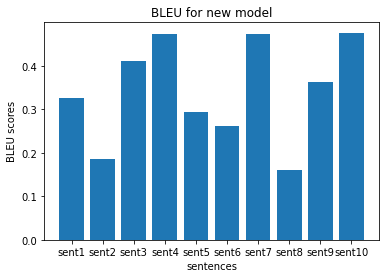

In [ ]:
import matplotlib.pyplot as plt

scores = [0.325508343464402,
          0.18665471083173696,
          0.41189087872817565,
          0.47393951711471854,
          0.2941299913461552,
          0.26259740246277147,
          0.47393951711471854,
          0.15948194035504248,
          0.36235915698708127,
          0.4759146769531603]

sentences = ['sent1', 'sent2', 'sent3','sent4','sent5','sent6','sent7','sent8','sent9','sent10' ]
plt.title("BLEU for new model")
plt.xlabel("sentences")
plt.ylabel("BLEU scores")
plt.bar(sentences,scores)